In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Case study: K2-24, putting it all together

In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

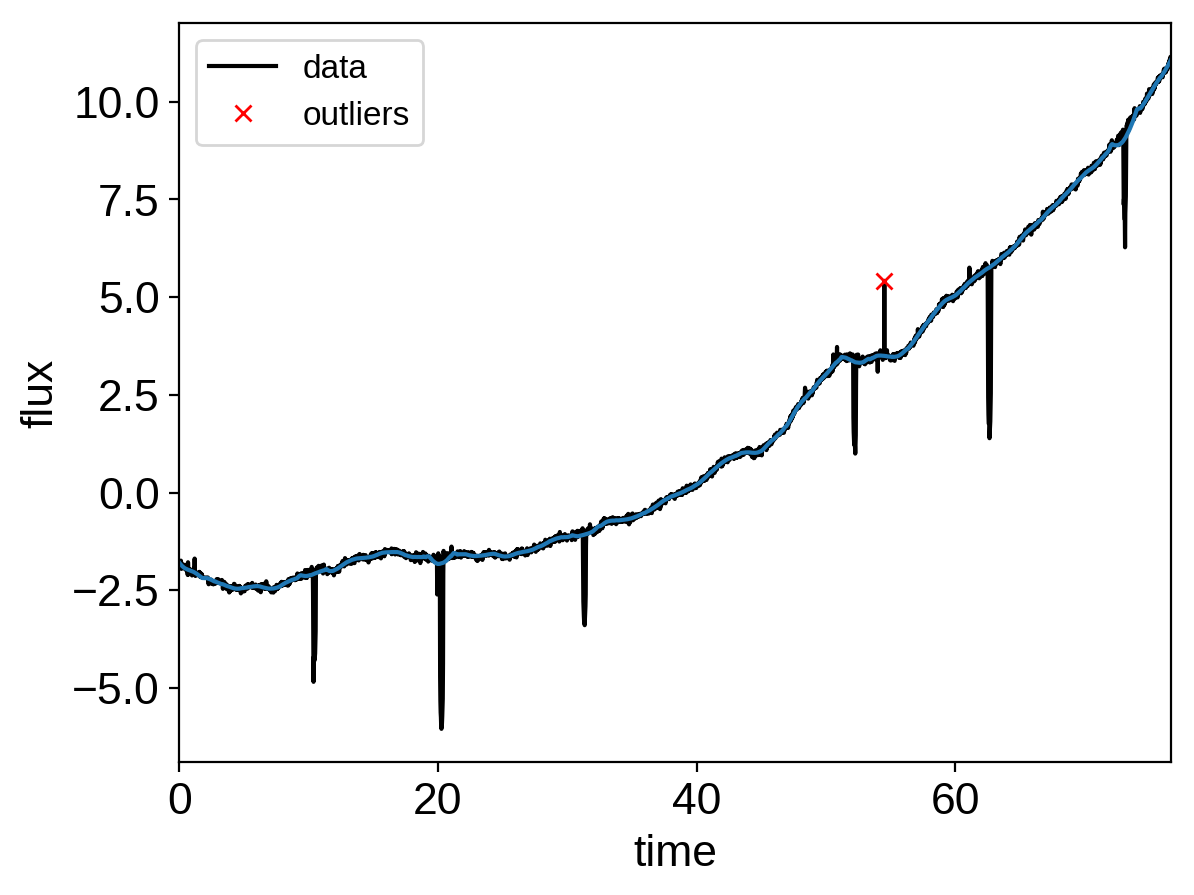

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid ** 2))
    m0 = np.abs(resid) < 3 * sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Only discard positive outliers
m = resid < 3 * sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

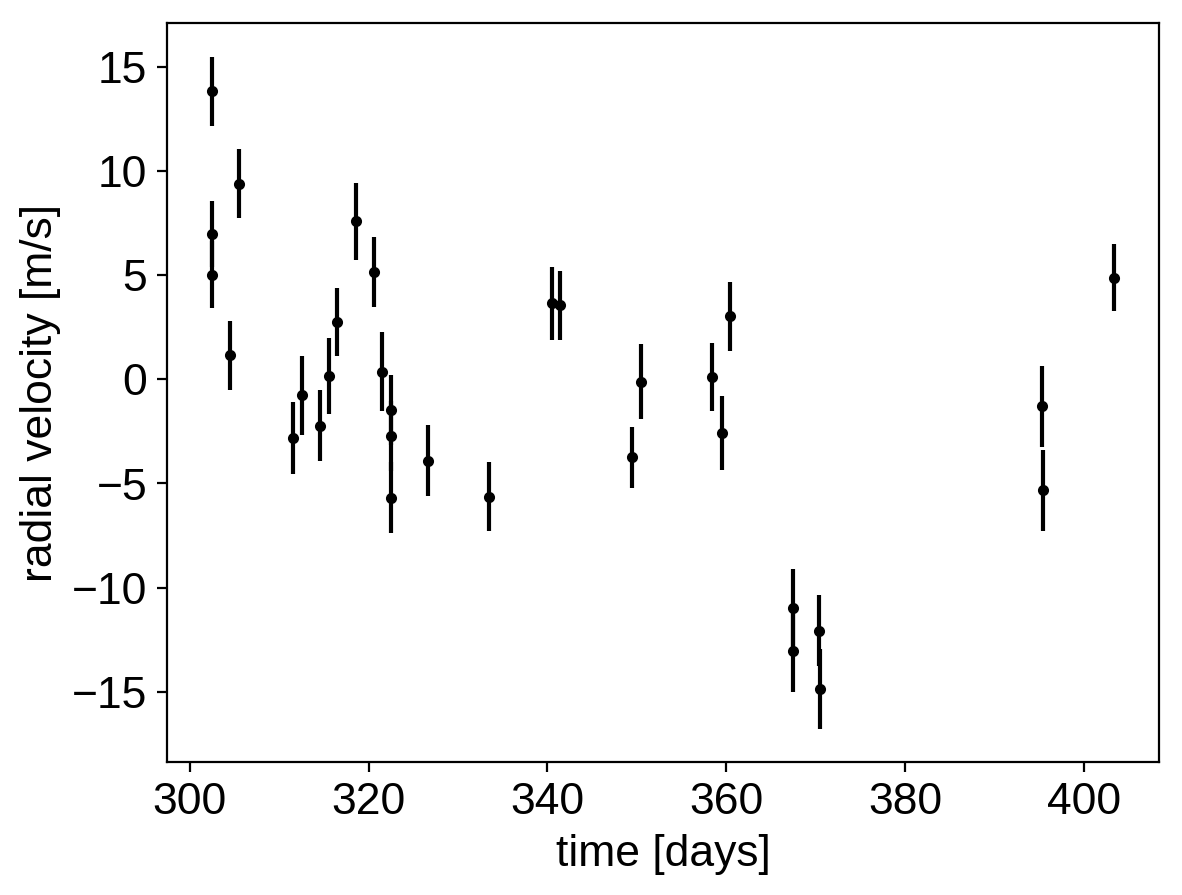

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.timeseries import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])

    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

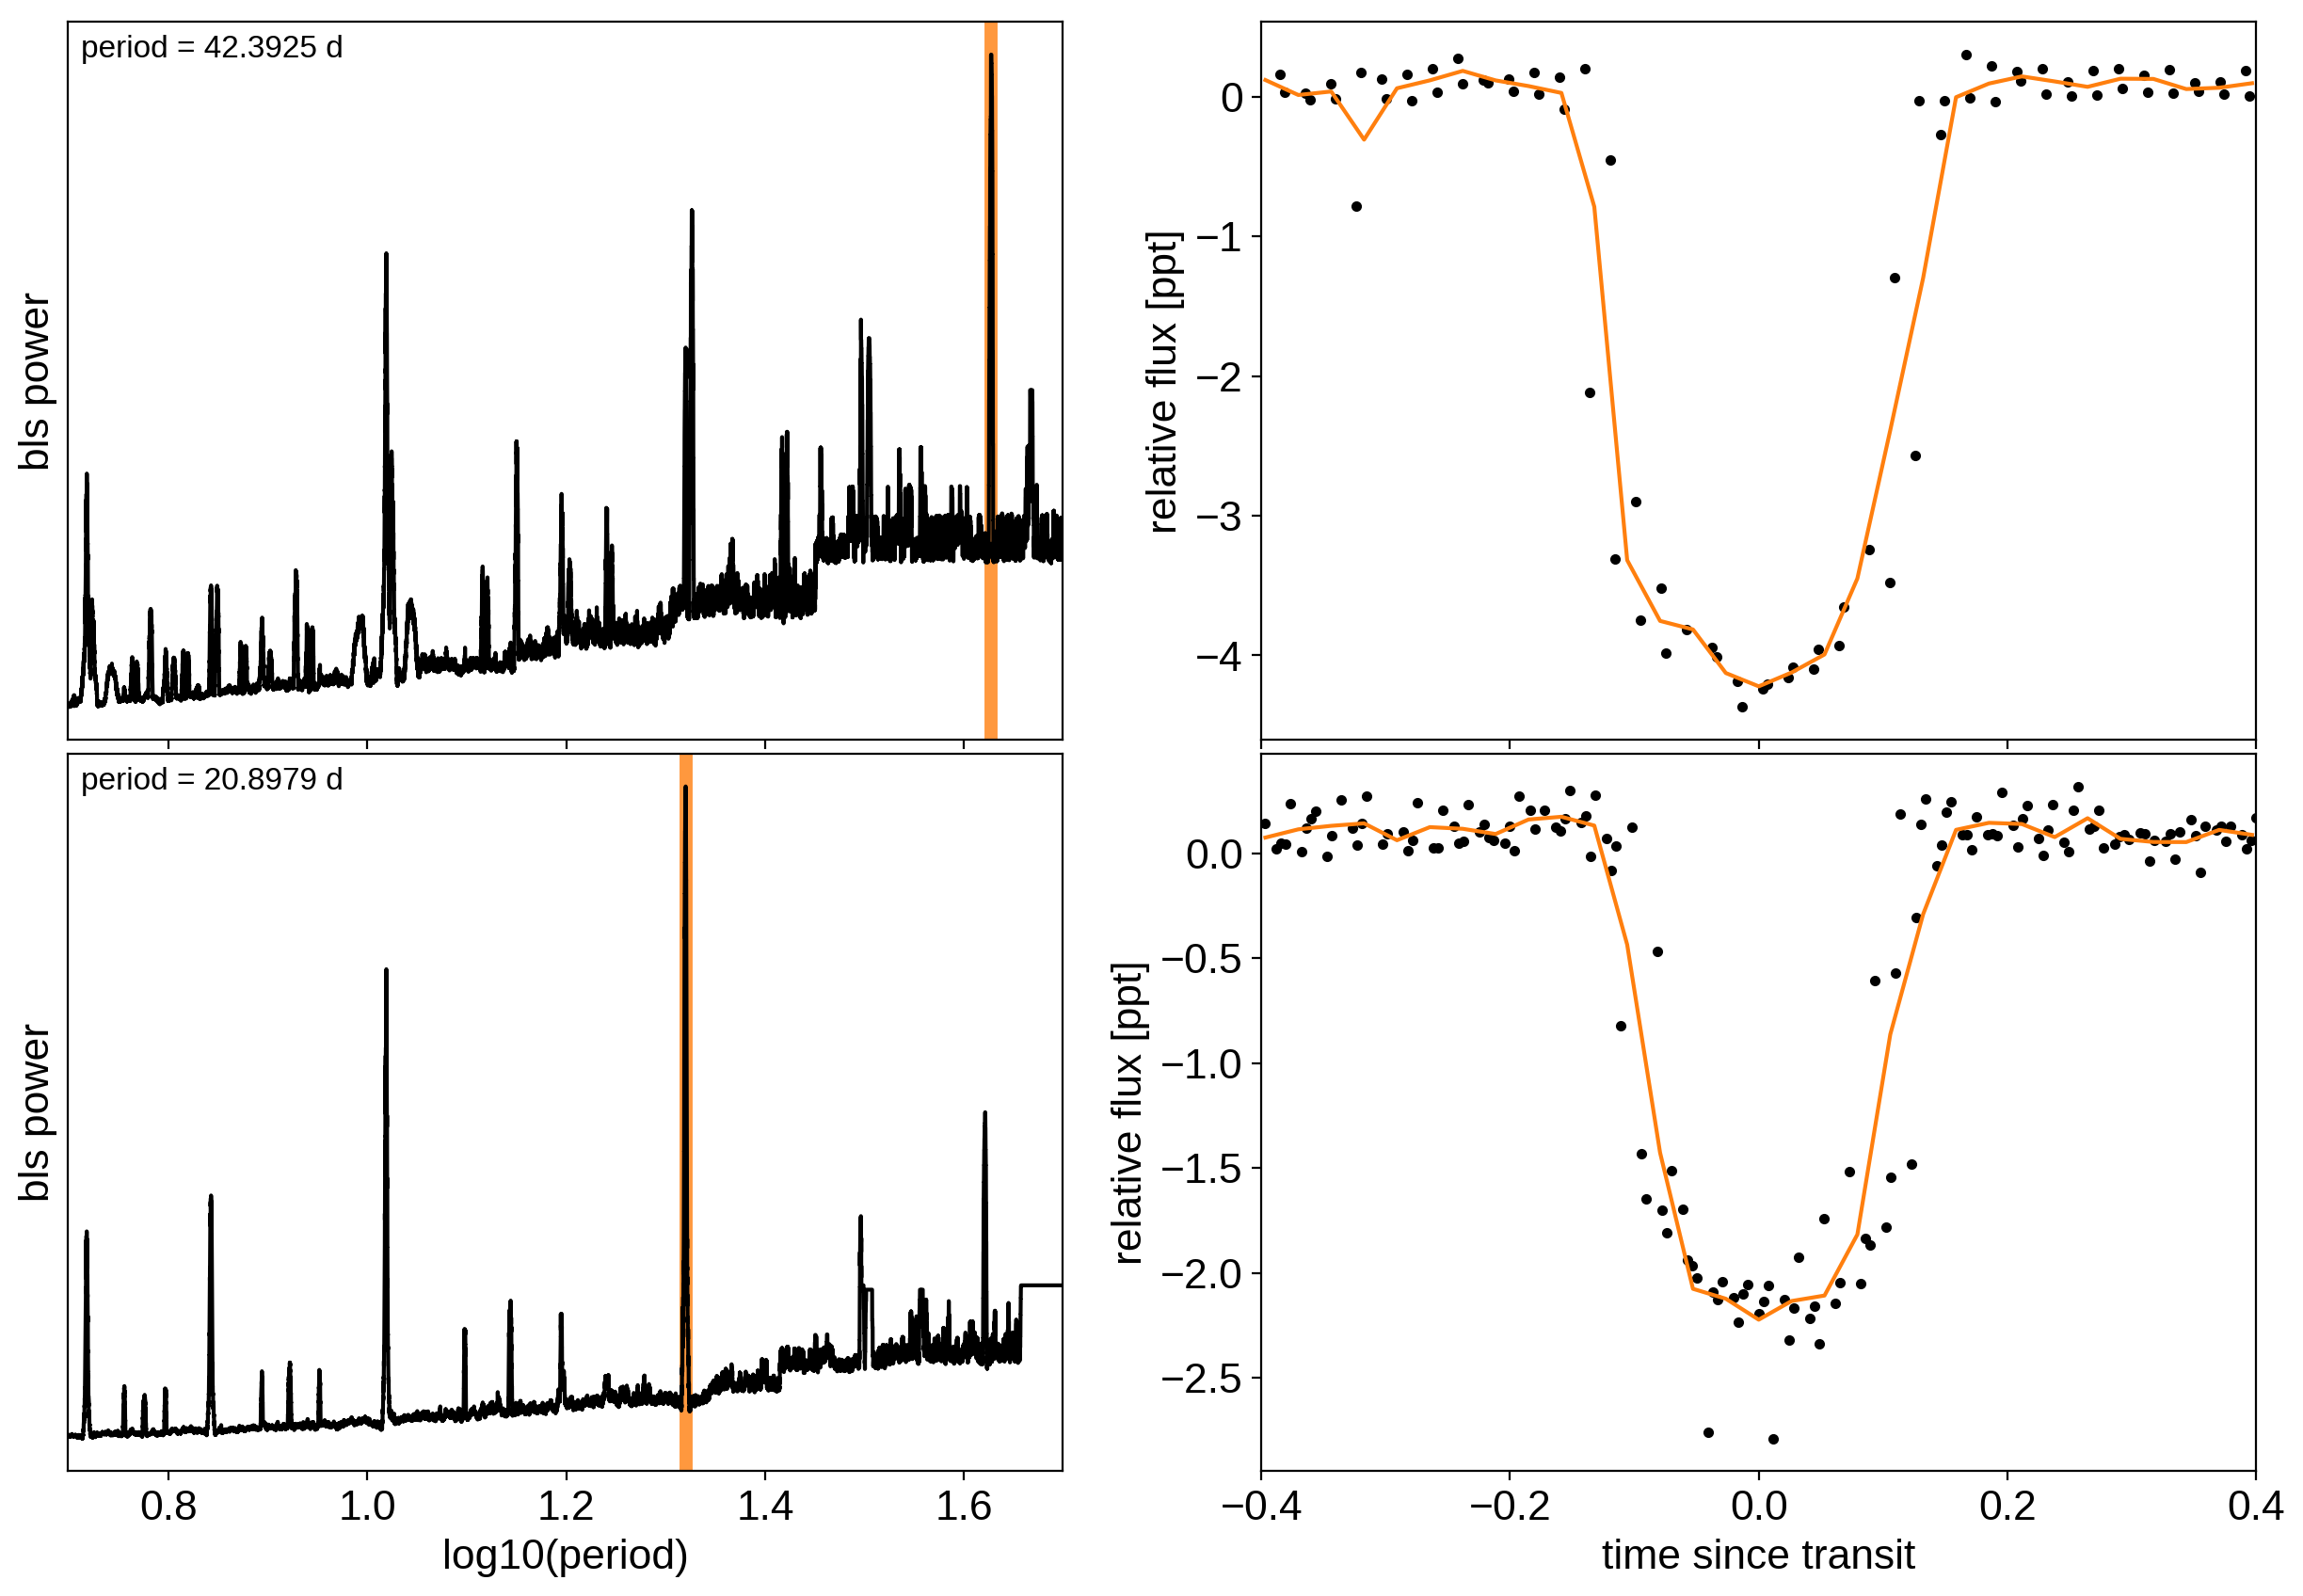

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate(
        "period = {0:.4f} d".format(periods[i]),
        (0, 1),
        xycoords="axes fraction",
        xytext=(5, -5),
        textcoords="offset points",
        va="top",
        ha="left",
        fontsize=12,
    )
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")

    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5 * p) % p - 0.5 * p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")

    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")

fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(
    periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0]
)
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal(
            "logr",
            mu=0.5 * np.log(1e-3 * np.array(depths)) + np.log(R_star_petigura[0]),
            sd=1.0,
            shape=2,
        )
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.distributions.ImpactParameter("b", ror=ror, shape=2)

        ecc = xo.distributions.eccentricity.vaneylen19(
            "ecc", multi=True, shape=2, testval=np.array([0.01, 0.01])
        )
        omega = xo.distributions.Angle("omega", shape=2)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=0.0, sd=10)
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y[mask])), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve using starry
        light_curves = (
            xo.LimbDarkLightCurve(u_star).get_light_curve(
                orbit=orbit, r=r_pl, t=x[mask], texp=texp
            )
            * 1e3
        )
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()))
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5 * (x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv ** 2 + tt.exp(2 * logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5 * (x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logSw4])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln


model0, map_soln0 = build_model()

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.290067e+03]

1it [00:00, 96.46it/s, logp=-8.290067e+03]

2it [00:00, 142.31it/s, logp=-8.290067e+03]

3it [00:00, 160.24it/s, logp=-5.392070e+06]

4it [00:00, 178.24it/s, logp=-8.289847e+03]

5it [00:00, 188.70it/s, logp=-8.289419e+03]

6it [00:00, 197.41it/s, logp=-8.288014e+03]

7it [00:00, 202.31it/s, logp=-8.284634e+03]

8it [00:00, 202.71it/s, logp=-8.279284e+03]

9it [00:00, 206.10it/s, logp=-8.276752e+03]

10it [00:00, 208.39it/s, logp=-8.276752e+03]

11it [00:00, 209.73it/s, logp=-8.276752e+03]

12it [00:11,  1.08it/s, logp=-8.276752e+03] 


message: Optimization terminated successfully.
logp: -8290.066560739391 -> -8276.751877588842


optimizing logp for variables: [logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.276752e+03]

1it [00:00, 98.20it/s, logp=-8.276752e+03]

2it [00:00, 127.80it/s, logp=-8.276752e+03]

3it [00:00, 143.78it/s, logp=-6.553614e+03]

4it [00:00, 150.73it/s, logp=-5.887021e+01]

5it [00:00, 156.20it/s, logp=-3.543119e+05]

6it [00:00, 160.66it/s, logp=1.118139e+02] 

7it [00:00, 164.26it/s, logp=1.763270e+03]

8it [00:00, 166.03it/s, logp=1.845136e+03]

9it [00:00, 167.46it/s, logp=1.987971e+03]

10it [00:00, 168.35it/s, logp=2.100900e+03]

11it [00:00, 170.83it/s, logp=2.109703e+03]

12it [00:00, 172.14it/s, logp=2.110024e+03]

13it [00:00, 172.60it/s, logp=2.110025e+03]

14it [00:00, 170.26it/s, logp=2.110025e+03]

15it [00:01,  9.52it/s, logp=2.110025e+03] 


message: Optimization terminated successfully.
logp: -8276.751877588842 -> 2110.02456128196


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.110025e+03]

1it [00:00, 61.82it/s, logp=2.110025e+03]

2it [00:00, 95.66it/s, logp=2.110025e+03]

3it [00:00, 112.24it/s, logp=-3.326931e+04]

4it [00:00, 129.94it/s, logp=2.597750e+03] 

5it [00:00, 136.31it/s, logp=9.498090e+01]

6it [00:00, 135.66it/s, logp=2.606232e+03]

7it [00:00, 140.66it/s, logp=2.617498e+03]

8it [00:00, 137.92it/s, logp=2.624864e+03]

9it [00:00, 135.57it/s, logp=2.626822e+03]

10it [00:00, 137.00it/s, logp=2.630170e+03]

11it [00:00, 141.18it/s, logp=2.634492e+03]

12it [00:00, 145.41it/s, logp=2.636907e+03]

13it [00:00, 147.79it/s, logp=2.638483e+03]

14it [00:00, 149.28it/s, logp=2.637089e+03]

15it [00:00, 151.60it/s, logp=2.639518e+03]

16it [00:00, 152.84it/s, logp=2.640645e+03]

17it [00:00, 160.98it/s, logp=2.640645e+03]

17it [00:00, 160.98it/s, logp=2.642629e+03]

18it [00:00, 160.98it/s, logp=2.645965e+03]

19it [00:00, 160.98it/s, logp=2.652071e+03]

20it [00:00, 160.98it/s, logp=2.648763e+03]

21it [00:00, 160.98it/s, logp=2.656808e+03]

22it [00:00, 160.98it/s, logp=2.663014e+03]

23it [00:00, 160.98it/s, logp=2.671619e+03]

24it [00:00, 160.98it/s, logp=2.678940e+03]

25it [00:00, 160.98it/s, logp=2.683125e+03]

26it [00:00, 160.98it/s, logp=2.686471e+03]

27it [00:00, 160.98it/s, logp=2.687700e+03]

28it [00:00, 160.98it/s, logp=2.688696e+03]

29it [00:00, 160.98it/s, logp=2.688988e+03]

30it [00:00, 160.98it/s, logp=2.689034e+03]

31it [00:00, 160.98it/s, logp=2.689040e+03]

32it [00:00, 160.98it/s, logp=2.689040e+03]

33it [00:00, 160.98it/s, logp=2.689040e+03]

34it [00:00, 160.98it/s, logp=2.689040e+03]

35it [00:00, 160.98it/s, logp=2.689040e+03]

36it [00:00, 167.90it/s, logp=2.689040e+03]

36it [00:00, 167.90it/s, logp=2.689040e+03]

37it [00:00, 167.90it/s, logp=2.689040e+03]

38it [00:00, 167.90it/s, logp=2.689040e+03]

39it [00:00, 167.90it/s, logp=2.689040e+03]

40it [00:00, 167.90it/s, logp=2.689040e+03]

41it [00:00, 167.90it/s, logp=2.689040e+03]

42it [00:00, 167.90it/s, logp=2.689040e+03]

43it [00:00, 167.90it/s, logp=2.689040e+03]

44it [00:00, 167.90it/s, logp=2.689040e+03]

45it [00:00, 167.90it/s, logp=2.689040e+03]

46it [00:00, 167.90it/s, logp=2.689040e+03]

47it [00:00, 167.90it/s, logp=2.689040e+03]

48it [00:00, 167.90it/s, logp=2.689040e+03]

49it [00:00, 167.90it/s, logp=2.689040e+03]

50it [00:00, 167.90it/s, logp=2.689040e+03]

51it [00:00, 167.90it/s, logp=2.689040e+03]

52it [00:00, 167.90it/s, logp=2.689040e+03]

53it [00:00, 165.58it/s, logp=2.689040e+03]

53it [00:00, 165.58it/s, logp=2.689040e+03]

54it [00:00, 165.58it/s, logp=2.689040e+03]

55it [00:00, 165.58it/s, logp=2.689040e+03]

56it [00:00, 165.58it/s, logp=2.689040e+03]

57it [00:00, 165.58it/s, logp=2.689040e+03]

58it [00:00, 165.58it/s, logp=2.689040e+03]

59it [00:00, 165.58it/s, logp=2.689040e+03]

60it [00:00, 165.58it/s, logp=2.689040e+03]

61it [00:00, 165.58it/s, logp=2.689040e+03]

62it [00:00, 165.58it/s, logp=2.689040e+03]

63it [00:00, 165.58it/s, logp=2.689040e+03]

64it [00:00, 165.58it/s, logp=2.689040e+03]

65it [00:00, 165.58it/s, logp=2.689040e+03]

66it [00:00, 165.58it/s, logp=2.689040e+03]

67it [00:00, 165.58it/s, logp=2.689040e+03]

68it [00:00, 165.58it/s, logp=2.689040e+03]

69it [00:00, 165.58it/s, logp=2.689040e+03]

70it [00:00, 165.58it/s, logp=2.689040e+03]

71it [00:00, 165.58it/s, logp=2.689040e+03]

72it [00:00, 165.58it/s, logp=2.689040e+03]

73it [00:00, 165.58it/s, logp=2.689040e+03]

74it [00:00, 165.58it/s, logp=2.689040e+03]

75it [00:00, 176.55it/s, logp=2.689040e+03]

75it [00:00, 176.55it/s, logp=2.689040e+03]

76it [00:00, 176.55it/s, logp=2.689040e+03]

77it [00:00, 176.55it/s, logp=2.689040e+03]

78it [00:00, 176.55it/s, logp=2.689040e+03]

79it [00:00, 176.55it/s, logp=2.689040e+03]

80it [00:00, 176.55it/s, logp=2.689040e+03]

81it [00:00, 176.55it/s, logp=2.689040e+03]

82it [00:00, 176.55it/s, logp=2.689040e+03]

83it [00:00, 176.55it/s, logp=2.689040e+03]

84it [00:00, 176.55it/s, logp=2.689040e+03]

85it [00:00, 176.55it/s, logp=2.689040e+03]

86it [00:00, 176.55it/s, logp=2.689040e+03]

87it [00:00, 176.55it/s, logp=2.689040e+03]

88it [00:00, 176.55it/s, logp=2.689040e+03]

89it [00:00, 176.55it/s, logp=2.689040e+03]

90it [00:00, 176.55it/s, logp=2.689040e+03]

91it [00:00, 176.55it/s, logp=2.689040e+03]

92it [00:00, 176.55it/s, logp=2.689040e+03]

93it [00:00, 176.55it/s, logp=2.689040e+03]

94it [00:00, 176.55it/s, logp=2.689040e+03]

95it [00:00, 176.55it/s, logp=2.689040e+03]

96it [00:00, 176.55it/s, logp=2.689040e+03]

97it [00:00, 186.81it/s, logp=2.689040e+03]

97it [00:00, 186.81it/s, logp=2.689040e+03]

98it [00:00, 186.81it/s, logp=2.689040e+03]

99it [00:00, 186.81it/s, logp=2.689040e+03]

100it [00:00, 186.81it/s, logp=2.689040e+03]

101it [00:00, 186.81it/s, logp=2.689040e+03]

102it [00:00, 186.81it/s, logp=2.689040e+03]

103it [00:00, 186.81it/s, logp=2.689040e+03]

104it [00:00, 186.81it/s, logp=2.689040e+03]

105it [00:02, 44.46it/s, logp=2.689040e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 2110.02456128196 -> 2689.0397283218103


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.689040e+03]

1it [00:00, 90.14it/s, logp=2.689040e+03]

2it [00:00, 104.86it/s, logp=2.689040e+03]

3it [00:00, 111.83it/s, logp=-5.044436e+03]

4it [00:00, 121.11it/s, logp=-1.040665e+03]

5it [00:00, 132.34it/s, logp=-7.647381e+02]

6it [00:00, 140.55it/s, logp=-8.705591e+02]

7it [00:00, 149.63it/s, logp=-5.334416e+02]

8it [00:00, 157.55it/s, logp=9.580323e+02] 

9it [00:00, 164.82it/s, logp=2.884188e+03]

10it [00:00, 170.66it/s, logp=-6.009377e+01]

11it [00:00, 176.50it/s, logp=2.882330e+03] 

12it [00:00, 183.05it/s, logp=2.886442e+03]

13it [00:00, 188.46it/s, logp=2.890979e+03]

14it [00:00, 194.23it/s, logp=2.908790e+03]

15it [00:00, 199.96it/s, logp=2.974219e+03]

16it [00:00, 205.21it/s, logp=3.120587e+03]

17it [00:00, 209.78it/s, logp=3.218439e+03]

18it [00:00, 214.15it/s, logp=3.240106e+03]

19it [00:00, 218.38it/s, logp=3.244828e+03]

20it [00:00, 222.35it/s, logp=3.244871e+03]

21it [00:00, 226.01it/s, logp=3.244872e+03]

22it [00:00, 229.39it/s, logp=3.244872e+03]

23it [00:00, 230.02it/s, logp=3.244872e+03]

24it [00:00, 238.19it/s, logp=3.244872e+03]

24it [00:00, 238.19it/s, logp=3.244872e+03]

25it [00:00, 238.19it/s, logp=3.244872e+03]

26it [00:00, 238.19it/s, logp=3.244872e+03]

27it [00:00, 238.19it/s, logp=3.244872e+03]

28it [00:00, 238.19it/s, logp=3.244872e+03]

29it [00:00, 238.19it/s, logp=3.244872e+03]

30it [00:00, 238.19it/s, logp=3.244872e+03]

31it [00:00, 238.19it/s, logp=3.244872e+03]

32it [00:00, 238.19it/s, logp=3.244872e+03]

33it [00:00, 238.19it/s, logp=3.244872e+03]

34it [00:00, 238.19it/s, logp=3.244872e+03]

35it [00:00, 238.19it/s, logp=3.244872e+03]

36it [00:00, 238.19it/s, logp=3.244872e+03]

37it [00:00, 238.19it/s, logp=3.244872e+03]

38it [00:00, 238.19it/s, logp=3.244872e+03]

39it [00:00, 238.19it/s, logp=3.244872e+03]

40it [00:00, 238.19it/s, logp=3.244872e+03]

41it [00:00, 238.19it/s, logp=3.244872e+03]

42it [00:00, 238.19it/s, logp=3.244872e+03]

43it [00:00, 238.19it/s, logp=3.244872e+03]

44it [00:00, 238.19it/s, logp=3.244872e+03]

45it [00:00, 238.19it/s, logp=3.244872e+03]

46it [00:00, 231.56it/s, logp=3.244872e+03]

46it [00:00, 231.56it/s, logp=3.244872e+03]

47it [00:00, 231.56it/s, logp=3.244872e+03]

48it [00:00, 231.56it/s, logp=3.244872e+03]

49it [00:00, 231.56it/s, logp=3.244872e+03]

50it [00:00, 231.56it/s, logp=3.244872e+03]

51it [00:00, 231.56it/s, logp=3.244872e+03]

52it [00:00, 231.56it/s, logp=3.244872e+03]

53it [00:00, 231.56it/s, logp=3.244872e+03]

54it [00:00, 231.56it/s, logp=3.244872e+03]

55it [00:00, 231.56it/s, logp=3.244872e+03]

56it [00:00, 231.56it/s, logp=3.244872e+03]

57it [00:00, 231.56it/s, logp=3.244872e+03]

58it [00:00, 231.56it/s, logp=3.244872e+03]

59it [00:00, 231.56it/s, logp=3.244872e+03]

60it [00:00, 231.56it/s, logp=3.244872e+03]

61it [00:00, 231.56it/s, logp=3.244872e+03]

62it [00:00, 231.56it/s, logp=3.244872e+03]

63it [00:00, 231.56it/s, logp=3.244872e+03]

64it [00:00, 231.56it/s, logp=3.244872e+03]

65it [00:00, 231.56it/s, logp=3.244872e+03]

66it [00:00, 231.56it/s, logp=3.244872e+03]

67it [00:00, 222.18it/s, logp=3.244872e+03]

67it [00:00, 222.18it/s, logp=3.244872e+03]

68it [00:00, 222.18it/s, logp=3.244872e+03]

69it [00:00, 222.18it/s, logp=3.244872e+03]

70it [00:00, 222.18it/s, logp=3.244872e+03]

71it [00:00, 222.18it/s, logp=3.244872e+03]

72it [00:00, 222.18it/s, logp=3.244872e+03]

73it [00:00, 222.18it/s, logp=3.244872e+03]

74it [00:00, 222.18it/s, logp=3.244872e+03]

75it [00:00, 222.18it/s, logp=3.244872e+03]

76it [00:00, 222.18it/s, logp=3.244872e+03]

77it [00:00, 222.18it/s, logp=3.244872e+03]

78it [00:00, 222.18it/s, logp=3.244872e+03]

79it [00:01, 42.17it/s, logp=3.244872e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 2689.039728321822 -> 3244.8715047912565


optimizing logp for variables: [logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.244872e+03]

1it [00:00, 125.62it/s, logp=3.244872e+03]

2it [00:00, 171.13it/s, logp=3.244872e+03]

3it [00:00, 182.80it/s, logp=3.744214e+03]

4it [00:00, 186.58it/s, logp=-4.251570e+03]

5it [00:00, 185.44it/s, logp=3.896383e+03] 

6it [00:00, 185.12it/s, logp=3.898724e+03]

7it [00:00, 190.86it/s, logp=3.899739e+03]

8it [00:00, 199.19it/s, logp=3.899740e+03]

9it [00:00, 204.96it/s, logp=3.899740e+03]

10it [00:00, 205.72it/s, logp=3.899740e+03]

11it [00:00, 193.46it/s, logp=3.899740e+03]

12it [00:00, 182.35it/s, logp=3.899740e+03]

13it [00:01,  7.02it/s, logp=3.899740e+03] 


message: Optimization terminated successfully.
logp: 3244.8715047912547 -> 3899.7404342927084


optimizing logp for variables: [logw0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.899740e+03]

1it [00:00, 75.58it/s, logp=3.899740e+03]

2it [00:00, 109.16it/s, logp=3.899740e+03]

3it [00:00, 127.17it/s, logp=4.002758e+03]

4it [00:00, 146.97it/s, logp=4.002965e+03]

5it [00:00, 161.50it/s, logp=4.003665e+03]

6it [00:00, 171.01it/s, logp=4.003689e+03]

7it [00:00, 179.29it/s, logp=4.004107e+03]

8it [00:00, 185.85it/s, logp=4.004134e+03]

9it [00:00, 192.12it/s, logp=4.004137e+03]

10it [00:00, 197.72it/s, logp=4.004137e+03]

11it [00:00, 202.93it/s, logp=4.004137e+03]

12it [00:01,  6.70it/s, logp=4.004137e+03] 


message: Optimization terminated successfully.
logp: 3899.7404342927084 -> 4004.1373334508944


optimizing logp for variables: [logSw4, logw0, logs2, trend, logs_rv, omega, ecc_frac, ecc_sigma_rayleigh, ecc_sigma_gauss, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.004137e+03]

1it [00:00, 79.37it/s, logp=4.004137e+03]

2it [00:00, 109.76it/s, logp=4.004137e+03]

3it [00:00, 129.14it/s, logp=-5.635527e+03]

4it [00:00, 142.91it/s, logp=-7.624740e+03]

5it [00:00, 148.66it/s, logp=-8.177933e+03]

6it [00:00, 151.07it/s, logp=-5.826551e+03]

7it [00:00, 151.84it/s, logp=4.004167e+03] 

8it [00:00, 151.69it/s, logp=4.003858e+03]

9it [00:00, 153.38it/s, logp=4.004169e+03]

10it [00:00, 155.41it/s, logp=4.004174e+03]

11it [00:00, 157.83it/s, logp=4.004194e+03]

12it [00:00, 157.10it/s, logp=4.004272e+03]

13it [00:00, 157.08it/s, logp=4.004579e+03]

14it [00:00, 156.58it/s, logp=4.005724e+03]

15it [00:00, 156.71it/s, logp=4.008609e+03]

16it [00:00, 158.16it/s, logp=4.014275e+03]

17it [00:00, 165.83it/s, logp=4.014275e+03]

17it [00:00, 165.83it/s, logp=4.033609e+03]

18it [00:00, 165.83it/s, logp=3.891646e+03]

19it [00:00, 165.83it/s, logp=4.036957e+03]

20it [00:00, 165.83it/s, logp=4.043156e+03]

21it [00:00, 165.83it/s, logp=4.054375e+03]

22it [00:00, 165.83it/s, logp=4.076318e+03]

23it [00:00, 165.83it/s, logp=4.137877e+03]

24it [00:00, 165.83it/s, logp=4.165133e+03]

25it [00:00, 165.83it/s, logp=4.193616e+03]

26it [00:00, 165.83it/s, logp=4.291726e+03]

27it [00:00, 165.83it/s, logp=3.966029e+03]

28it [00:00, 165.83it/s, logp=4.312287e+03]

29it [00:00, 165.83it/s, logp=4.339925e+03]

30it [00:00, 165.83it/s, logp=4.388734e+03]

31it [00:00, 165.83it/s, logp=4.292453e+03]

32it [00:00, 158.50it/s, logp=4.292453e+03]

32it [00:00, 158.50it/s, logp=4.408692e+03]

33it [00:00, 158.50it/s, logp=4.439598e+03]

34it [00:00, 158.50it/s, logp=4.486790e+03]

35it [00:00, 158.50it/s, logp=4.564494e+03]

36it [00:00, 158.50it/s, logp=3.428574e+03]

37it [00:00, 158.50it/s, logp=4.590813e+03]

38it [00:00, 158.50it/s, logp=4.629040e+03]

39it [00:00, 158.50it/s, logp=4.653332e+03]

40it [00:00, 158.50it/s, logp=4.658654e+03]

41it [00:00, 158.50it/s, logp=4.668362e+03]

42it [00:00, 158.50it/s, logp=4.684407e+03]

43it [00:00, 158.50it/s, logp=4.685529e+03]

44it [00:00, 158.50it/s, logp=4.693587e+03]

45it [00:00, 158.50it/s, logp=4.704038e+03]

46it [00:00, 158.50it/s, logp=4.710569e+03]

47it [00:00, 158.50it/s, logp=4.704997e+03]

48it [00:00, 158.50it/s, logp=4.713100e+03]

49it [00:00, 158.50it/s, logp=4.716394e+03]

50it [00:00, 163.36it/s, logp=4.716394e+03]

50it [00:00, 163.36it/s, logp=4.721233e+03]

51it [00:00, 163.36it/s, logp=4.725292e+03]

52it [00:00, 163.36it/s, logp=4.727717e+03]

53it [00:00, 163.36it/s, logp=4.731126e+03]

54it [00:00, 163.36it/s, logp=4.735418e+03]

55it [00:00, 163.36it/s, logp=4.737422e+03]

56it [00:00, 163.36it/s, logp=4.740264e+03]

57it [00:00, 163.36it/s, logp=4.743094e+03]

58it [00:00, 163.36it/s, logp=4.745239e+03]

59it [00:00, 163.36it/s, logp=4.747720e+03]

60it [00:00, 163.36it/s, logp=4.749903e+03]

61it [00:00, 163.36it/s, logp=4.752661e+03]

62it [00:00, 163.36it/s, logp=4.754165e+03]

63it [00:00, 163.36it/s, logp=4.756473e+03]

64it [00:00, 163.36it/s, logp=4.758252e+03]

65it [00:00, 163.36it/s, logp=4.759565e+03]

66it [00:00, 163.36it/s, logp=4.761043e+03]

67it [00:00, 163.36it/s, logp=4.762316e+03]

68it [00:00, 163.36it/s, logp=4.763149e+03]

69it [00:00, 163.36it/s, logp=4.763675e+03]

70it [00:00, 171.60it/s, logp=4.763675e+03]

70it [00:00, 171.60it/s, logp=4.764199e+03]

71it [00:00, 171.60it/s, logp=4.764591e+03]

72it [00:00, 171.60it/s, logp=4.764860e+03]

73it [00:00, 171.60it/s, logp=4.765143e+03]

74it [00:00, 171.60it/s, logp=4.765519e+03]

75it [00:00, 171.60it/s, logp=4.765829e+03]

76it [00:00, 171.60it/s, logp=4.766064e+03]

77it [00:00, 171.60it/s, logp=4.766296e+03]

78it [00:00, 171.60it/s, logp=4.766483e+03]

79it [00:00, 171.60it/s, logp=4.766716e+03]

80it [00:00, 171.60it/s, logp=4.767015e+03]

81it [00:00, 171.60it/s, logp=4.766993e+03]

82it [00:00, 171.60it/s, logp=4.767241e+03]

83it [00:00, 171.60it/s, logp=4.767269e+03]

84it [00:00, 171.60it/s, logp=4.767377e+03]

85it [00:00, 171.60it/s, logp=4.767608e+03]

86it [00:00, 171.60it/s, logp=4.767981e+03]

87it [00:00, 171.60it/s, logp=4.768290e+03]

88it [00:00, 171.60it/s, logp=4.768397e+03]

89it [00:00, 171.60it/s, logp=4.768574e+03]

90it [00:00, 171.60it/s, logp=4.768863e+03]

91it [00:00, 171.60it/s, logp=4.769281e+03]

92it [00:00, 183.34it/s, logp=4.769281e+03]

92it [00:00, 183.34it/s, logp=4.769501e+03]

93it [00:00, 183.34it/s, logp=4.769791e+03]

94it [00:00, 183.34it/s, logp=4.769873e+03]

95it [00:00, 183.34it/s, logp=4.770006e+03]

96it [00:00, 183.34it/s, logp=4.770144e+03]

97it [00:00, 183.34it/s, logp=4.770172e+03]

98it [00:00, 183.34it/s, logp=4.770224e+03]

99it [00:00, 183.34it/s, logp=4.770322e+03]

100it [00:00, 183.34it/s, logp=4.770503e+03]

101it [00:00, 183.34it/s, logp=4.770808e+03]

102it [00:00, 183.34it/s, logp=4.771117e+03]

103it [00:00, 183.34it/s, logp=4.771296e+03]

104it [00:00, 183.34it/s, logp=4.771365e+03]

105it [00:00, 183.34it/s, logp=4.771420e+03]

106it [00:00, 183.34it/s, logp=4.771510e+03]

107it [00:00, 183.34it/s, logp=4.771538e+03]

108it [00:00, 183.34it/s, logp=4.771570e+03]

109it [00:00, 183.34it/s, logp=4.771605e+03]

110it [00:00, 183.34it/s, logp=4.771622e+03]

111it [00:00, 183.34it/s, logp=4.771637e+03]

112it [00:00, 183.34it/s, logp=4.771651e+03]

113it [00:00, 190.22it/s, logp=4.771651e+03]

113it [00:00, 190.22it/s, logp=4.771674e+03]

114it [00:00, 190.22it/s, logp=4.771716e+03]

115it [00:00, 190.22it/s, logp=4.771785e+03]

116it [00:00, 190.22it/s, logp=4.771892e+03]

117it [00:00, 190.22it/s, logp=4.772071e+03]

118it [00:00, 190.22it/s, logp=4.772333e+03]

119it [00:00, 190.22it/s, logp=4.772731e+03]

120it [00:00, 190.22it/s, logp=4.773251e+03]

121it [00:00, 190.22it/s, logp=4.767950e+03]

122it [00:00, 190.22it/s, logp=4.773412e+03]

123it [00:00, 190.22it/s, logp=4.773709e+03]

124it [00:00, 190.22it/s, logp=4.774230e+03]

125it [00:00, 190.22it/s, logp=4.774836e+03]

126it [00:00, 190.22it/s, logp=4.772825e+03]

127it [00:00, 190.22it/s, logp=4.774991e+03]

128it [00:00, 190.22it/s, logp=4.774997e+03]

129it [00:00, 190.22it/s, logp=4.775036e+03]

130it [00:00, 190.22it/s, logp=4.775048e+03]

131it [00:00, 190.22it/s, logp=4.775053e+03]

132it [00:00, 190.22it/s, logp=4.775055e+03]

133it [00:00, 190.22it/s, logp=4.775059e+03]

134it [00:00, 190.22it/s, logp=4.775064e+03]

135it [00:00, 196.99it/s, logp=4.775064e+03]

135it [00:00, 196.99it/s, logp=4.775072e+03]

136it [00:00, 196.99it/s, logp=4.775077e+03]

137it [00:00, 196.99it/s, logp=4.775080e+03]

138it [00:00, 196.99it/s, logp=4.775084e+03]

139it [00:00, 196.99it/s, logp=4.775089e+03]

140it [00:00, 196.99it/s, logp=4.775096e+03]

141it [00:00, 196.99it/s, logp=4.775102e+03]

142it [00:00, 196.99it/s, logp=4.775106e+03]

143it [00:00, 196.99it/s, logp=4.775109e+03]

144it [00:00, 196.99it/s, logp=4.775110e+03]

145it [00:00, 196.99it/s, logp=4.775111e+03]

146it [00:00, 196.99it/s, logp=4.775112e+03]

147it [00:00, 196.99it/s, logp=4.775114e+03]

148it [00:00, 196.99it/s, logp=4.775117e+03]

149it [00:00, 196.99it/s, logp=4.775122e+03]

150it [00:00, 196.99it/s, logp=4.775125e+03]

151it [00:00, 196.99it/s, logp=4.775126e+03]

152it [00:00, 196.99it/s, logp=4.775128e+03]

153it [00:00, 196.99it/s, logp=4.775129e+03]

154it [00:00, 167.13it/s, logp=4.775129e+03]

154it [00:00, 167.13it/s, logp=4.775131e+03]

155it [00:00, 167.13it/s, logp=4.775132e+03]

156it [00:00, 167.13it/s, logp=4.775132e+03]

157it [00:00, 167.13it/s, logp=4.775132e+03]

158it [00:00, 167.13it/s, logp=4.775133e+03]

159it [00:00, 167.13it/s, logp=4.775133e+03]

160it [00:00, 167.13it/s, logp=4.775133e+03]

161it [00:00, 167.13it/s, logp=4.775134e+03]

162it [00:00, 167.13it/s, logp=4.775135e+03]

163it [00:00, 167.13it/s, logp=4.775138e+03]

164it [00:00, 167.13it/s, logp=4.775143e+03]

165it [00:00, 167.13it/s, logp=4.775151e+03]

166it [00:00, 167.13it/s, logp=4.775156e+03]

167it [00:00, 167.13it/s, logp=4.775157e+03]

168it [00:00, 167.13it/s, logp=4.775164e+03]

169it [00:00, 167.13it/s, logp=4.775156e+03]

170it [00:01, 167.13it/s, logp=4.775169e+03]

171it [00:01, 150.44it/s, logp=4.775169e+03]

171it [00:01, 150.44it/s, logp=4.775174e+03]

172it [00:01, 150.44it/s, logp=4.775177e+03]

173it [00:01, 150.44it/s, logp=4.775176e+03]

174it [00:01, 150.44it/s, logp=4.775179e+03]

175it [00:01, 150.44it/s, logp=4.775180e+03]

176it [00:01, 150.44it/s, logp=4.775182e+03]

177it [00:01, 150.44it/s, logp=4.775183e+03]

178it [00:01, 150.44it/s, logp=4.775185e+03]

179it [00:01, 150.44it/s, logp=4.775189e+03]

180it [00:01, 150.44it/s, logp=4.775192e+03]

181it [00:01, 150.44it/s, logp=4.775195e+03]

182it [00:01, 150.44it/s, logp=4.775196e+03]

183it [00:01, 150.44it/s, logp=4.775199e+03]

184it [00:01, 150.44it/s, logp=4.775202e+03]

185it [00:01, 150.44it/s, logp=4.775206e+03]

186it [00:01, 150.44it/s, logp=4.775214e+03]

187it [00:01, 142.32it/s, logp=4.775214e+03]

187it [00:01, 142.32it/s, logp=4.775225e+03]

188it [00:01, 142.32it/s, logp=4.775225e+03]

189it [00:01, 142.32it/s, logp=4.775229e+03]

190it [00:01, 142.32it/s, logp=4.775234e+03]

191it [00:01, 142.32it/s, logp=4.775237e+03]

192it [00:01, 142.32it/s, logp=4.775238e+03]

193it [00:01, 142.32it/s, logp=4.775238e+03]

194it [00:01, 142.32it/s, logp=4.775238e+03]

195it [00:01, 142.32it/s, logp=4.775238e+03]

196it [00:01, 142.32it/s, logp=4.775238e+03]

197it [00:01, 142.32it/s, logp=4.775238e+03]

198it [00:01, 142.32it/s, logp=4.775238e+03]

199it [00:01, 142.32it/s, logp=4.775238e+03]

200it [00:01, 142.32it/s, logp=4.775238e+03]

201it [00:01, 142.32it/s, logp=4.775239e+03]

202it [00:01, 137.17it/s, logp=4.775239e+03]

202it [00:01, 137.17it/s, logp=4.775239e+03]

203it [00:01, 137.17it/s, logp=4.775239e+03]

204it [00:01, 137.17it/s, logp=4.775239e+03]

205it [00:01, 137.17it/s, logp=4.775239e+03]

206it [00:01, 137.17it/s, logp=4.775239e+03]

207it [00:01, 137.17it/s, logp=4.775239e+03]

208it [00:01, 137.17it/s, logp=4.775240e+03]

209it [00:01, 137.17it/s, logp=4.775240e+03]

210it [00:01, 137.17it/s, logp=4.775242e+03]

211it [00:01, 137.17it/s, logp=4.775244e+03]

212it [00:01, 137.17it/s, logp=4.775252e+03]

213it [00:01, 137.17it/s, logp=4.775264e+03]

214it [00:01, 137.17it/s, logp=4.775266e+03]

215it [00:01, 137.17it/s, logp=4.775273e+03]

216it [00:01, 137.17it/s, logp=4.773561e+03]

217it [00:01, 137.17it/s, logp=4.775274e+03]

218it [00:01, 137.17it/s, logp=4.775276e+03]

219it [00:01, 144.03it/s, logp=4.775276e+03]

219it [00:01, 144.03it/s, logp=4.775280e+03]

220it [00:01, 144.03it/s, logp=4.775290e+03]

221it [00:01, 144.03it/s, logp=4.775311e+03]

222it [00:01, 144.03it/s, logp=4.775340e+03]

223it [00:01, 144.03it/s, logp=4.775372e+03]

224it [00:01, 144.03it/s, logp=4.775393e+03]

225it [00:01, 144.03it/s, logp=4.775393e+03]

226it [00:01, 144.03it/s, logp=4.775408e+03]

227it [00:01, 144.03it/s, logp=4.775408e+03]

228it [00:01, 144.03it/s, logp=4.775415e+03]

229it [00:01, 144.03it/s, logp=4.775415e+03]

230it [00:01, 144.03it/s, logp=4.775418e+03]

231it [00:01, 144.03it/s, logp=4.775420e+03]

232it [00:01, 144.03it/s, logp=4.775423e+03]

233it [00:01, 144.03it/s, logp=4.775428e+03]

234it [00:01, 144.03it/s, logp=4.775435e+03]

235it [00:01, 144.03it/s, logp=4.775446e+03]

236it [00:01, 144.03it/s, logp=4.775455e+03]

237it [00:01, 153.05it/s, logp=4.775455e+03]

237it [00:01, 153.05it/s, logp=4.775446e+03]

238it [00:01, 153.05it/s, logp=4.775460e+03]

239it [00:01, 153.05it/s, logp=4.775467e+03]

240it [00:01, 153.05it/s, logp=4.775475e+03]

241it [00:01, 153.05it/s, logp=4.775477e+03]

242it [00:01, 153.05it/s, logp=4.775479e+03]

243it [00:01, 153.05it/s, logp=4.775481e+03]

244it [00:01, 153.05it/s, logp=4.775484e+03]

245it [00:01, 153.05it/s, logp=4.775488e+03]

246it [00:01, 153.05it/s, logp=4.775488e+03]

247it [00:01, 153.05it/s, logp=4.775490e+03]

248it [00:01, 153.05it/s, logp=4.775492e+03]

249it [00:01, 153.05it/s, logp=4.775493e+03]

250it [00:01, 153.05it/s, logp=4.775493e+03]

251it [00:01, 153.05it/s, logp=4.775493e+03]

252it [00:01, 153.05it/s, logp=4.775493e+03]

253it [00:01, 153.05it/s, logp=4.775493e+03]

254it [00:01, 153.05it/s, logp=4.775493e+03]

255it [00:01, 153.05it/s, logp=4.775493e+03]

256it [00:01, 161.70it/s, logp=4.775493e+03]

256it [00:01, 161.70it/s, logp=4.775493e+03]

257it [00:01, 161.70it/s, logp=4.775493e+03]

258it [00:01, 161.70it/s, logp=4.775494e+03]

259it [00:01, 161.70it/s, logp=4.775494e+03]

260it [00:01, 161.70it/s, logp=4.775494e+03]

261it [00:01, 161.70it/s, logp=4.775494e+03]

262it [00:01, 161.70it/s, logp=4.775494e+03]

263it [00:01, 161.70it/s, logp=4.775494e+03]

264it [00:01, 161.70it/s, logp=4.775494e+03]

265it [00:01, 161.70it/s, logp=4.775494e+03]

266it [00:01, 161.70it/s, logp=4.775494e+03]

267it [00:01, 161.70it/s, logp=4.775494e+03]

268it [00:01, 161.70it/s, logp=4.775494e+03]

269it [00:01, 161.70it/s, logp=4.775494e+03]

270it [00:01, 161.70it/s, logp=4.775494e+03]

271it [00:01, 161.70it/s, logp=4.775494e+03]

272it [00:01, 161.70it/s, logp=4.775494e+03]

273it [00:01, 161.70it/s, logp=4.775494e+03]

274it [00:01, 161.70it/s, logp=4.775494e+03]

275it [00:01, 161.70it/s, logp=4.775494e+03]

276it [00:01, 161.70it/s, logp=4.775494e+03]

277it [00:01, 173.23it/s, logp=4.775494e+03]

277it [00:01, 173.23it/s, logp=4.775494e+03]

278it [00:01, 173.23it/s, logp=4.775494e+03]

279it [00:01, 173.23it/s, logp=4.775494e+03]

280it [00:01, 173.23it/s, logp=4.775494e+03]

281it [00:01, 173.23it/s, logp=4.775494e+03]

282it [00:01, 173.23it/s, logp=4.775494e+03]

283it [00:01, 173.23it/s, logp=4.775494e+03]

284it [00:01, 173.23it/s, logp=4.775494e+03]

285it [00:01, 173.23it/s, logp=4.775494e+03]

286it [00:01, 173.23it/s, logp=4.775494e+03]

287it [00:01, 173.23it/s, logp=4.775494e+03]

288it [00:01, 173.23it/s, logp=4.775494e+03]

289it [00:01, 173.23it/s, logp=4.775494e+03]

290it [00:01, 173.23it/s, logp=4.775494e+03]

291it [00:01, 173.23it/s, logp=4.775494e+03]

292it [00:01, 173.23it/s, logp=4.775494e+03]

293it [00:01, 173.23it/s, logp=4.775494e+03]

294it [00:01, 173.23it/s, logp=4.775494e+03]

295it [00:01, 173.23it/s, logp=4.775494e+03]

296it [00:01, 173.23it/s, logp=4.775494e+03]

297it [00:01, 173.23it/s, logp=4.775494e+03]

298it [00:01, 173.23it/s, logp=4.775494e+03]

299it [00:01, 184.73it/s, logp=4.775494e+03]

299it [00:01, 184.73it/s, logp=4.775494e+03]

300it [00:01, 184.73it/s, logp=4.775494e+03]

301it [00:01, 184.73it/s, logp=4.775494e+03]

302it [00:01, 184.73it/s, logp=4.775494e+03]

303it [00:01, 184.73it/s, logp=4.775494e+03]

304it [00:01, 184.73it/s, logp=4.775494e+03]

305it [00:01, 184.73it/s, logp=4.775494e+03]

306it [00:01, 184.73it/s, logp=4.775494e+03]

307it [00:01, 184.73it/s, logp=4.775494e+03]

308it [00:01, 184.73it/s, logp=4.775494e+03]

309it [00:01, 184.73it/s, logp=4.775494e+03]

310it [00:01, 184.73it/s, logp=4.775494e+03]

311it [00:01, 184.73it/s, logp=4.775494e+03]

312it [00:01, 184.73it/s, logp=4.775494e+03]

313it [00:01, 184.73it/s, logp=4.775494e+03]

314it [00:01, 184.73it/s, logp=4.775494e+03]

315it [00:01, 184.73it/s, logp=4.775494e+03]

316it [00:01, 184.73it/s, logp=4.775494e+03]

317it [00:01, 184.73it/s, logp=4.775494e+03]

318it [00:01, 184.73it/s, logp=4.775494e+03]

319it [00:01, 186.24it/s, logp=4.775494e+03]

319it [00:01, 186.24it/s, logp=4.775494e+03]

320it [00:01, 186.24it/s, logp=4.775494e+03]

321it [00:01, 186.24it/s, logp=4.775494e+03]

322it [00:01, 186.24it/s, logp=4.775494e+03]

323it [00:01, 186.24it/s, logp=4.775494e+03]

324it [00:01, 186.24it/s, logp=4.775494e+03]

325it [00:01, 186.24it/s, logp=4.775494e+03]

326it [00:01, 186.24it/s, logp=4.775494e+03]

327it [00:01, 186.24it/s, logp=4.775494e+03]

328it [00:01, 186.24it/s, logp=4.775494e+03]

329it [00:01, 186.24it/s, logp=4.775494e+03]

330it [00:01, 186.24it/s, logp=4.775494e+03]

331it [00:01, 186.24it/s, logp=4.775494e+03]

332it [00:01, 186.24it/s, logp=4.775494e+03]

333it [00:01, 186.24it/s, logp=4.775494e+03]

334it [00:01, 186.24it/s, logp=4.775494e+03]

335it [00:01, 186.24it/s, logp=4.775494e+03]

336it [00:01, 186.24it/s, logp=4.775494e+03]

337it [00:01, 186.24it/s, logp=4.775494e+03]

338it [00:01, 186.24it/s, logp=4.775494e+03]

339it [00:03, 89.50it/s, logp=4.775494e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 4004.137333450869 -> 4775.494114320922


Now let's plot the map radial velocity model.

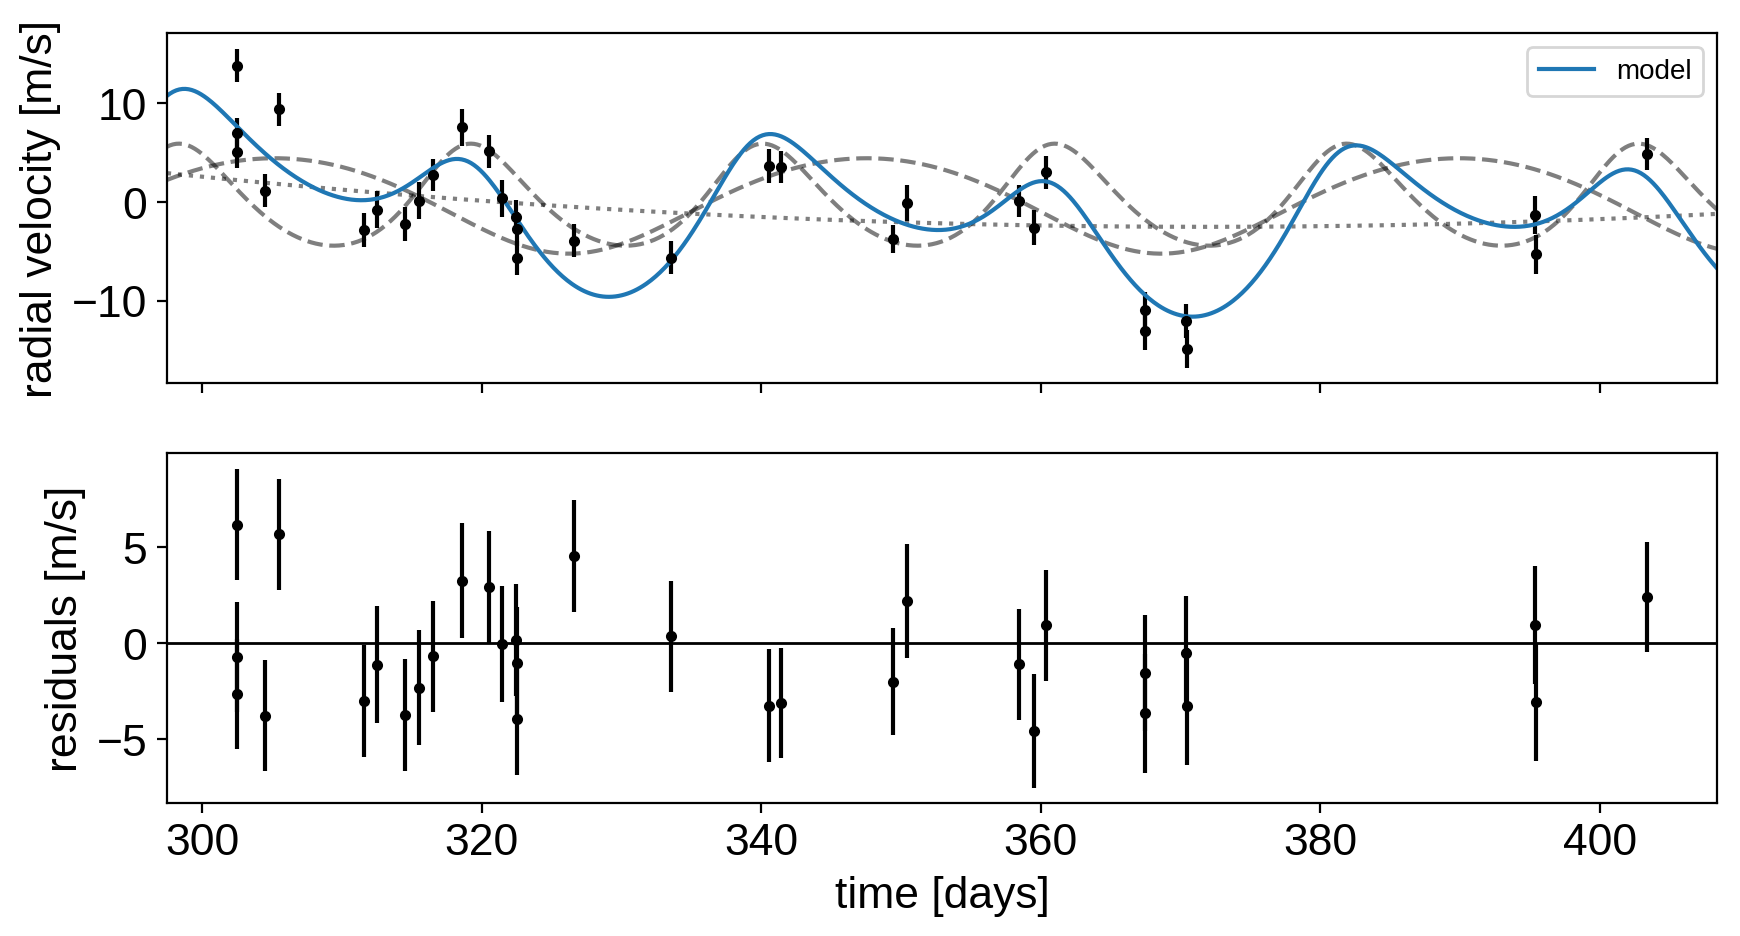

In [10]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")

    ax = axes[1]
    err = np.sqrt(yerr_rv ** 2 + np.exp(2 * soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")


plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

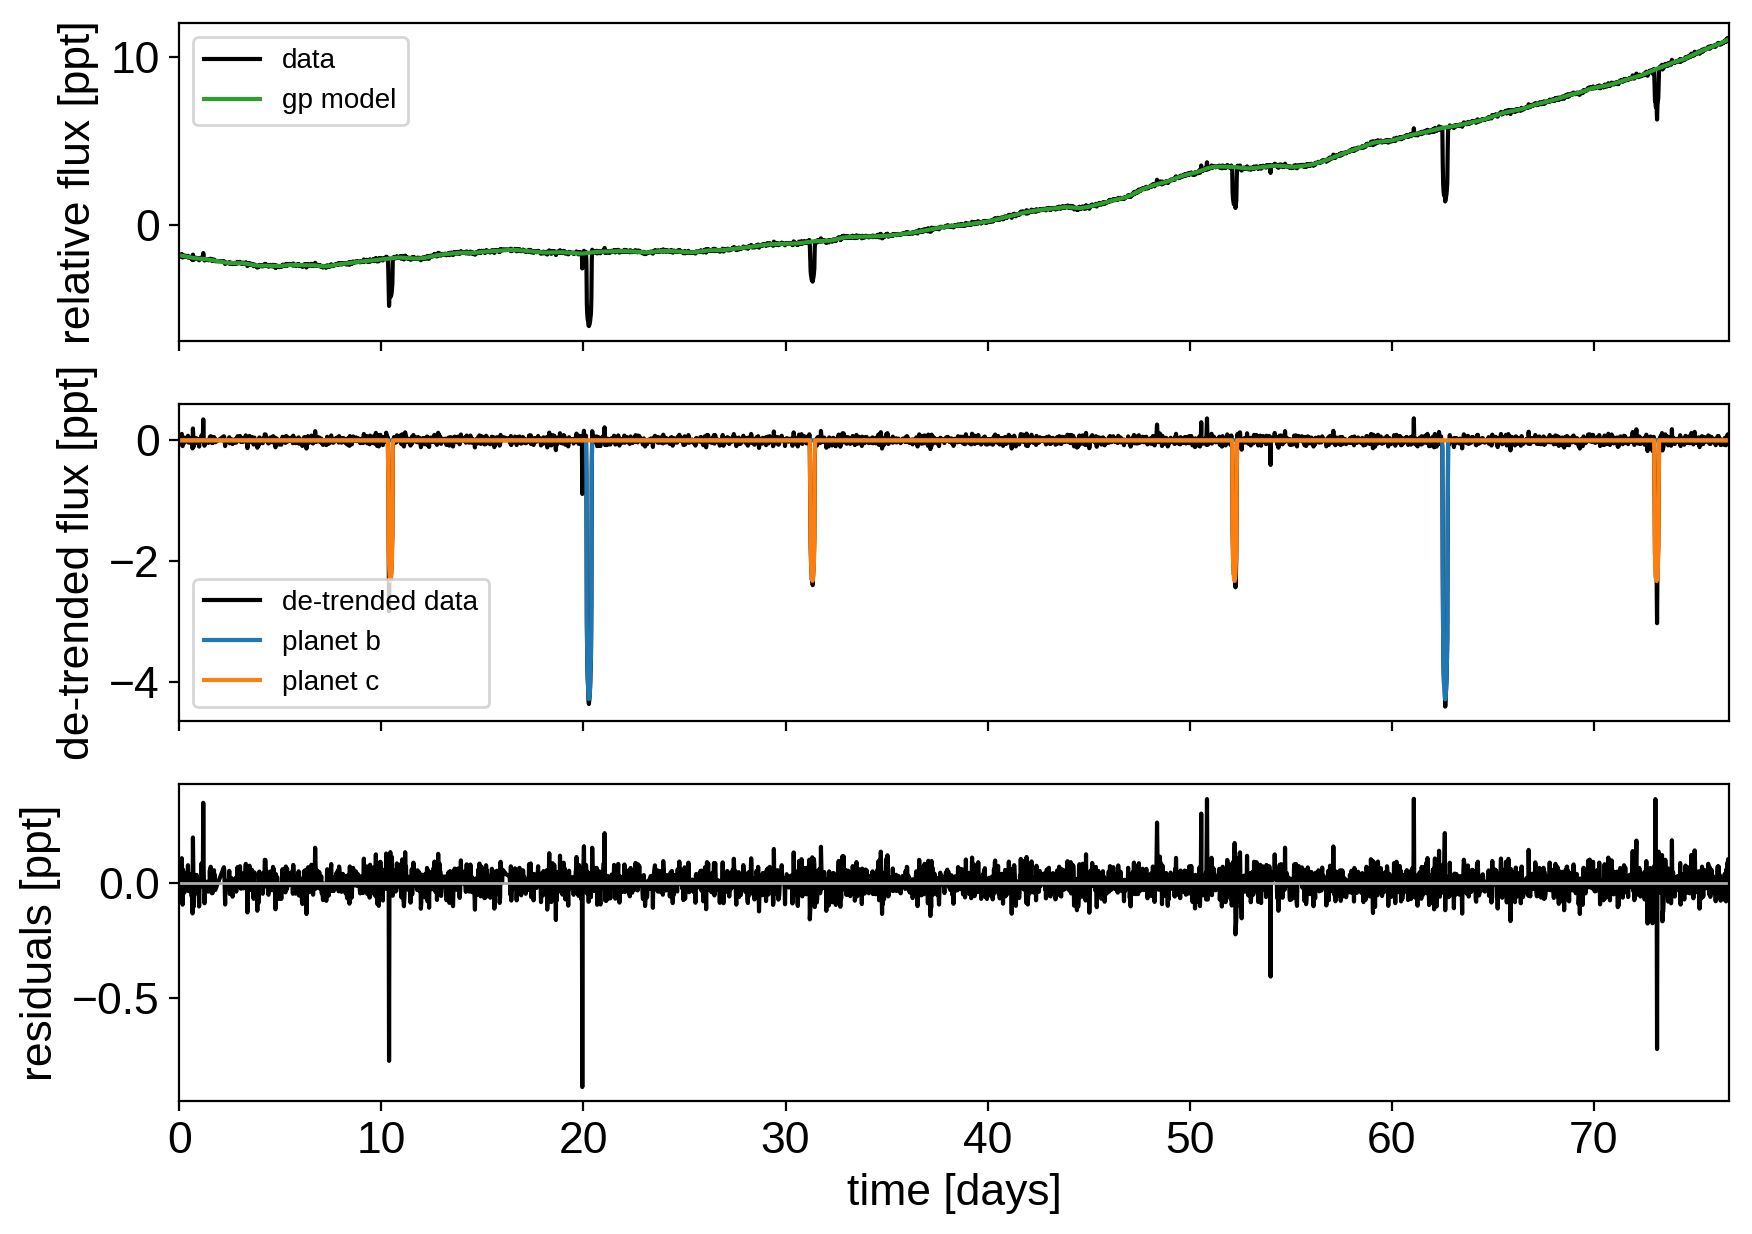

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

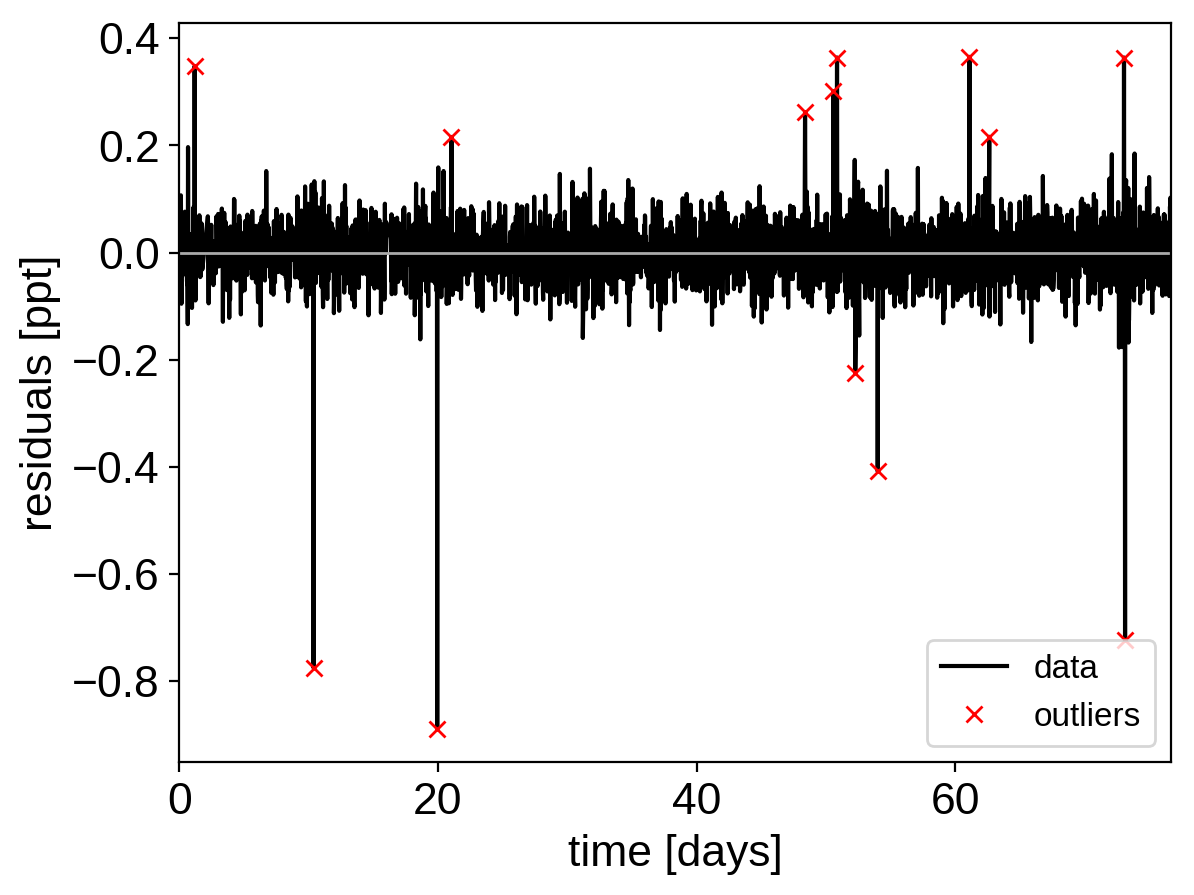

In [12]:
mod = (
    map_soln0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(map_soln0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.225381e+03]

1it [00:00, 176.50it/s, logp=5.225381e+03]

2it [00:00, 241.09it/s, logp=5.225381e+03]

3it [00:00, 270.91it/s, logp=5.213620e+03]

4it [00:00, 290.47it/s, logp=5.225381e+03]

5it [00:01,  3.03it/s, logp=5.225381e+03] 


message: Optimization terminated successfully.
logp: 5225.381218190808 -> 5225.381218190808


optimizing logp for variables: [logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.225381e+03]

1it [00:00, 145.79it/s, logp=5.225381e+03]

2it [00:00, 203.45it/s, logp=5.225381e+03]

3it [00:00, 233.63it/s, logp=4.837483e+03]

4it [00:00, 254.51it/s, logp=5.306928e+03]

5it [00:00, 266.05it/s, logp=5.307415e+03]

6it [00:00, 275.09it/s, logp=5.307429e+03]

7it [00:00, 282.52it/s, logp=5.307429e+03]

8it [00:00, 288.08it/s, logp=5.307429e+03]

9it [00:01,  6.40it/s, logp=5.307429e+03] 


message: Optimization terminated successfully.
logp: 5225.381218190808 -> 5307.42938442338


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.307429e+03]

1it [00:00, 168.33it/s, logp=5.307429e+03]

2it [00:00, 224.52it/s, logp=5.307429e+03]

3it [00:00, 247.59it/s, logp=-5.782804e+04]

4it [00:00, 266.39it/s, logp=5.311043e+03] 

5it [00:00, 278.48it/s, logp=5.248071e+03]

6it [00:00, 287.32it/s, logp=5.311239e+03]

7it [00:00, 292.00it/s, logp=5.311414e+03]

8it [00:00, 296.36it/s, logp=5.311688e+03]

9it [00:00, 297.91it/s, logp=5.312239e+03]

10it [00:00, 301.35it/s, logp=5.314205e+03]

11it [00:00, 301.96it/s, logp=5.286079e+03]

12it [00:00, 305.18it/s, logp=5.315289e+03]

13it [00:00, 305.97it/s, logp=5.297052e+03]

14it [00:00, 308.39it/s, logp=5.315596e+03]

15it [00:00, 297.02it/s, logp=5.316182e+03]

16it [00:00, 292.08it/s, logp=5.317200e+03]

17it [00:00, 288.00it/s, logp=5.318359e+03]

18it [00:00, 285.95it/s, logp=5.318392e+03]

19it [00:00, 285.27it/s, logp=5.318394e+03]

20it [00:00, 284.08it/s, logp=5.318396e+03]

21it [00:00, 282.44it/s, logp=5.318396e+03]

22it [00:00, 280.78it/s, logp=5.318396e+03]

23it [00:00, 277.62it/s, logp=5.318396e+03]

24it [00:00, 264.70it/s, logp=5.318396e+03]

25it [00:00, 255.71it/s, logp=5.318396e+03]

26it [00:01, 14.55it/s, logp=5.318396e+03] 


message: Optimization terminated successfully.
logp: 5307.42938442338 -> 5318.395979595314


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.318396e+03]

1it [00:00, 154.82it/s, logp=5.318396e+03]

2it [00:00, 209.65it/s, logp=5.318396e+03]

3it [00:00, 228.88it/s, logp=-9.262911e+04]

4it [00:00, 244.00it/s, logp=-6.820869e+04]

5it [00:00, 255.08it/s, logp=-7.469762e+04]

6it [00:00, 263.79it/s, logp=-3.109141e+04]

7it [00:00, 270.22it/s, logp=5.309007e+03] 

8it [00:00, 275.31it/s, logp=5.318812e+03]

9it [00:00, 278.87it/s, logp=5.195525e+03]

10it [00:00, 282.80it/s, logp=5.318813e+03]

11it [00:00, 285.58it/s, logp=5.318816e+03]

12it [00:00, 289.84it/s, logp=5.318826e+03]

13it [00:00, 292.56it/s, logp=5.318866e+03]

14it [00:00, 295.83it/s, logp=5.319015e+03]

15it [00:00, 297.27it/s, logp=5.318834e+03]

16it [00:00, 299.34it/s, logp=5.319086e+03]

17it [00:00, 300.91it/s, logp=5.319221e+03]

18it [00:00, 302.20it/s, logp=5.319460e+03]

19it [00:00, 303.54it/s, logp=5.319758e+03]

20it [00:00, 305.45it/s, logp=5.319775e+03]

21it [00:00, 306.82it/s, logp=5.319775e+03]

22it [00:00, 308.04it/s, logp=5.319775e+03]

23it [00:00, 310.03it/s, logp=5.319775e+03]

24it [00:00, 311.63it/s, logp=5.319775e+03]

25it [00:00, 312.34it/s, logp=5.319775e+03]

26it [00:00, 313.02it/s, logp=5.319775e+03]

27it [00:00, 313.70it/s, logp=5.319775e+03]

28it [00:00, 314.61it/s, logp=5.319775e+03]

29it [00:00, 315.66it/s, logp=5.319775e+03]

30it [00:00, 316.47it/s, logp=5.319775e+03]

31it [00:00, 317.41it/s, logp=5.319775e+03]

32it [00:00, 318.35it/s, logp=5.319775e+03]

33it [00:00, 325.86it/s, logp=5.319775e+03]

33it [00:00, 325.86it/s, logp=5.319775e+03]

34it [00:00, 325.86it/s, logp=5.319775e+03]

35it [00:00, 325.86it/s, logp=5.319775e+03]

36it [00:00, 325.86it/s, logp=5.319775e+03]

37it [00:00, 325.86it/s, logp=5.319775e+03]

38it [00:00, 325.86it/s, logp=5.319775e+03]

39it [00:00, 325.86it/s, logp=5.319775e+03]

40it [00:00, 325.86it/s, logp=5.319775e+03]

41it [00:00, 325.86it/s, logp=5.319775e+03]

42it [00:00, 325.86it/s, logp=5.319775e+03]

43it [00:00, 325.86it/s, logp=5.319775e+03]

44it [00:00, 325.86it/s, logp=5.319775e+03]

45it [00:00, 325.86it/s, logp=5.319775e+03]

46it [00:00, 325.86it/s, logp=5.319775e+03]

47it [00:00, 325.86it/s, logp=5.319775e+03]

48it [00:00, 325.86it/s, logp=5.319775e+03]

49it [00:00, 325.86it/s, logp=5.319775e+03]

50it [00:00, 325.86it/s, logp=5.319775e+03]

51it [00:00, 325.86it/s, logp=5.319775e+03]

52it [00:00, 325.86it/s, logp=5.319775e+03]

53it [00:00, 325.86it/s, logp=5.319775e+03]

54it [00:00, 325.86it/s, logp=5.319775e+03]

55it [00:00, 325.86it/s, logp=5.319775e+03]

56it [00:00, 325.86it/s, logp=5.319775e+03]

57it [00:00, 325.86it/s, logp=5.319775e+03]

58it [00:00, 325.86it/s, logp=5.319775e+03]

59it [00:00, 325.86it/s, logp=5.319775e+03]

60it [00:00, 302.13it/s, logp=5.319775e+03]

60it [00:00, 302.13it/s, logp=5.319775e+03]

61it [00:00, 302.13it/s, logp=5.319775e+03]

62it [00:00, 302.13it/s, logp=5.319775e+03]

63it [00:00, 302.13it/s, logp=5.319775e+03]

64it [00:00, 302.13it/s, logp=5.319775e+03]

65it [00:00, 302.13it/s, logp=5.319775e+03]

66it [00:00, 302.13it/s, logp=5.319775e+03]

67it [00:00, 302.13it/s, logp=5.319775e+03]

68it [00:00, 302.13it/s, logp=5.319775e+03]

69it [00:00, 302.13it/s, logp=5.319775e+03]

70it [00:00, 302.13it/s, logp=5.319775e+03]

71it [00:00, 302.13it/s, logp=5.319775e+03]

72it [00:00, 302.13it/s, logp=5.319775e+03]

73it [00:00, 302.13it/s, logp=5.319775e+03]

74it [00:00, 302.13it/s, logp=5.319775e+03]

75it [00:00, 220.40it/s, logp=5.319775e+03]

75it [00:00, 220.40it/s, logp=5.319775e+03]

76it [00:00, 220.40it/s, logp=5.319775e+03]

77it [00:00, 220.40it/s, logp=5.319775e+03]

78it [00:00, 220.40it/s, logp=5.319775e+03]

79it [00:00, 220.40it/s, logp=5.319775e+03]

80it [00:00, 220.40it/s, logp=5.319775e+03]

81it [00:00, 220.40it/s, logp=5.319775e+03]

82it [00:00, 220.40it/s, logp=5.319775e+03]

83it [00:00, 220.40it/s, logp=5.319775e+03]

84it [00:00, 220.40it/s, logp=5.319775e+03]

85it [00:00, 220.40it/s, logp=5.319775e+03]

86it [00:00, 220.40it/s, logp=5.319775e+03]

87it [00:00, 220.40it/s, logp=5.319775e+03]

88it [00:00, 220.40it/s, logp=5.319775e+03]

89it [00:00, 220.40it/s, logp=5.319775e+03]

90it [00:00, 220.40it/s, logp=5.319775e+03]

91it [00:00, 220.40it/s, logp=5.319775e+03]

92it [00:00, 220.40it/s, logp=5.319775e+03]

93it [00:00, 220.40it/s, logp=5.319775e+03]

94it [00:00, 220.40it/s, logp=5.319775e+03]

95it [00:00, 220.40it/s, logp=5.319775e+03]

96it [00:00, 220.40it/s, logp=5.319775e+03]

97it [00:00, 220.40it/s, logp=5.319775e+03]

98it [00:00, 220.40it/s, logp=5.319775e+03]

99it [00:00, 220.40it/s, logp=5.319775e+03]

100it [00:00, 227.98it/s, logp=5.319775e+03]

100it [00:00, 227.98it/s, logp=5.319775e+03]

101it [00:00, 227.98it/s, logp=5.319775e+03]

102it [00:00, 227.98it/s, logp=5.319775e+03]

103it [00:00, 227.98it/s, logp=5.319775e+03]

104it [00:00, 227.98it/s, logp=5.319775e+03]

105it [00:00, 227.98it/s, logp=5.319775e+03]

106it [00:00, 227.98it/s, logp=5.319775e+03]

107it [00:00, 227.98it/s, logp=5.319775e+03]

108it [00:00, 227.98it/s, logp=5.319775e+03]

109it [00:00, 227.98it/s, logp=5.319775e+03]

110it [00:00, 227.98it/s, logp=5.319775e+03]

111it [00:00, 227.98it/s, logp=5.319775e+03]

112it [00:00, 227.98it/s, logp=5.319775e+03]

113it [00:00, 227.98it/s, logp=5.319775e+03]

114it [00:00, 227.98it/s, logp=5.319775e+03]

115it [00:00, 227.98it/s, logp=5.319775e+03]

116it [00:00, 227.98it/s, logp=5.319775e+03]

117it [00:00, 227.98it/s, logp=5.319775e+03]

118it [00:00, 227.98it/s, logp=5.319775e+03]

119it [00:00, 227.98it/s, logp=5.319775e+03]

120it [00:00, 227.98it/s, logp=5.319775e+03]

121it [00:00, 227.98it/s, logp=5.319775e+03]

122it [00:00, 227.98it/s, logp=5.319775e+03]

123it [00:00, 227.98it/s, logp=5.319775e+03]

124it [00:00, 227.98it/s, logp=5.319775e+03]

125it [00:00, 227.98it/s, logp=5.319775e+03]

126it [00:00, 227.98it/s, logp=5.319775e+03]

127it [00:00, 227.98it/s, logp=5.319775e+03]

128it [00:00, 227.98it/s, logp=5.319775e+03]

129it [00:00, 227.98it/s, logp=5.319775e+03]

130it [00:00, 227.98it/s, logp=5.319775e+03]

131it [00:00, 227.98it/s, logp=5.319775e+03]

132it [00:00, 227.98it/s, logp=5.319775e+03]

133it [00:00, 227.98it/s, logp=5.319775e+03]

134it [00:00, 227.98it/s, logp=5.319775e+03]

135it [00:00, 253.71it/s, logp=5.319775e+03]

135it [00:00, 253.71it/s, logp=5.319775e+03]

136it [00:00, 253.71it/s, logp=5.319775e+03]

137it [00:00, 253.71it/s, logp=5.319775e+03]

138it [00:00, 253.71it/s, logp=5.319775e+03]

139it [00:00, 253.71it/s, logp=5.319775e+03]

140it [00:00, 253.71it/s, logp=5.319775e+03]

141it [00:00, 253.71it/s, logp=5.319775e+03]

142it [00:00, 253.71it/s, logp=5.319775e+03]

143it [00:00, 253.71it/s, logp=5.319775e+03]

144it [00:00, 253.71it/s, logp=5.319775e+03]

145it [00:00, 253.71it/s, logp=5.319775e+03]

146it [00:00, 253.71it/s, logp=5.319775e+03]

147it [00:00, 253.71it/s, logp=5.319775e+03]

148it [00:00, 253.71it/s, logp=5.319775e+03]

149it [00:00, 253.71it/s, logp=5.319775e+03]

150it [00:00, 253.71it/s, logp=5.319775e+03]

151it [00:00, 253.71it/s, logp=5.319775e+03]

152it [00:00, 253.71it/s, logp=5.319775e+03]

153it [00:00, 253.71it/s, logp=5.319775e+03]

154it [00:00, 253.71it/s, logp=5.319775e+03]

155it [00:00, 253.71it/s, logp=5.319775e+03]

156it [00:00, 253.71it/s, logp=5.319775e+03]

157it [00:00, 253.71it/s, logp=5.319775e+03]

158it [00:00, 253.71it/s, logp=5.319775e+03]

159it [00:00, 253.71it/s, logp=5.319775e+03]

160it [00:00, 253.71it/s, logp=5.319775e+03]

161it [00:00, 253.71it/s, logp=5.319775e+03]

162it [00:00, 258.17it/s, logp=5.319775e+03]

162it [00:00, 258.17it/s, logp=5.319775e+03]

163it [00:00, 258.17it/s, logp=5.319775e+03]

164it [00:00, 258.17it/s, logp=5.319775e+03]

165it [00:02, 67.34it/s, logp=5.319775e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5318.395979595323 -> 5319.775397150623


optimizing logp for variables: [logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.319775e+03]

1it [00:00, 158.57it/s, logp=5.319775e+03]

2it [00:00, 213.88it/s, logp=5.319775e+03]

3it [00:00, 241.51it/s, logp=4.623524e+03]

4it [00:00, 257.41it/s, logp=5.319857e+03]

5it [00:00, 268.19it/s, logp=5.320011e+03]

6it [00:00, 272.64it/s, logp=5.320272e+03]

7it [00:00, 276.85it/s, logp=5.320504e+03]

8it [00:00, 270.33it/s, logp=5.320504e+03]

9it [00:00, 264.94it/s, logp=5.320504e+03]

10it [00:01,  6.97it/s, logp=5.320504e+03]


message: Optimization terminated successfully.
logp: 5319.77539715063 -> 5320.5042723781


optimizing logp for variables: [logw0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.320504e+03]

1it [00:00, 72.40it/s, logp=5.320504e+03]

2it [00:00, 97.97it/s, logp=5.320504e+03]

3it [00:00, 106.61it/s, logp=5.285627e+03]

4it [00:00, 125.97it/s, logp=5.320392e+03]

5it [00:00, 142.42it/s, logp=5.320538e+03]

6it [00:00, 149.00it/s, logp=5.320538e+03]

7it [00:00, 157.65it/s, logp=5.320538e+03]

8it [00:00, 165.43it/s, logp=5.320538e+03]

9it [00:01,  6.15it/s, logp=5.320538e+03] 


message: Optimization terminated successfully.
logp: 5320.5042723781 -> 5320.538333858067


optimizing logp for variables: [logSw4, logw0, logs2, trend, logs_rv, omega, ecc_frac, ecc_sigma_rayleigh, ecc_sigma_gauss, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=5.320538e+03]

1it [00:00, 117.40it/s, logp=5.320538e+03]

2it [00:00, 156.15it/s, logp=5.320538e+03]

3it [00:00, 173.70it/s, logp=-1.202945e+05]

4it [00:00, 183.63it/s, logp=-1.245807e+04]

5it [00:00, 190.14it/s, logp=5.320538e+03] 

6it [00:00, 193.35it/s, logp=5.320516e+03]

7it [00:00, 198.56it/s, logp=5.320538e+03]

8it [00:00, 201.55it/s, logp=5.320538e+03]

9it [00:00, 206.33it/s, logp=5.320538e+03]

10it [00:00, 209.43it/s, logp=5.320538e+03]

11it [00:00, 212.29it/s, logp=5.320539e+03]

12it [00:00, 212.62it/s, logp=5.320539e+03]

13it [00:00, 214.90it/s, logp=5.320539e+03]

14it [00:00, 216.12it/s, logp=5.320542e+03]

15it [00:00, 215.95it/s, logp=5.320535e+03]

16it [00:00, 216.57it/s, logp=5.320543e+03]

17it [00:00, 215.84it/s, logp=5.320544e+03]

18it [00:00, 214.49it/s, logp=5.320541e+03]

19it [00:00, 216.34it/s, logp=5.320544e+03]

20it [00:00, 217.37it/s, logp=5.320545e+03]

21it [00:00, 218.36it/s, logp=5.320547e+03]

22it [00:00, 218.85it/s, logp=5.320551e+03]

23it [00:00, 227.07it/s, logp=5.320551e+03]

23it [00:00, 227.07it/s, logp=5.320561e+03]

24it [00:00, 227.07it/s, logp=5.320595e+03]

25it [00:00, 227.07it/s, logp=5.320649e+03]

26it [00:00, 227.07it/s, logp=5.320753e+03]

27it [00:00, 227.07it/s, logp=5.321065e+03]

28it [00:00, 227.07it/s, logp=5.311794e+03]

29it [00:00, 227.07it/s, logp=5.321082e+03]

30it [00:00, 227.07it/s, logp=5.321113e+03]

31it [00:00, 227.07it/s, logp=5.321165e+03]

32it [00:00, 227.07it/s, logp=5.321223e+03]

33it [00:00, 227.07it/s, logp=5.321335e+03]

34it [00:00, 227.07it/s, logp=5.321666e+03]

35it [00:00, 227.07it/s, logp=5.319433e+03]

36it [00:00, 227.07it/s, logp=5.321766e+03]

37it [00:00, 227.07it/s, logp=5.321606e+03]

38it [00:00, 227.07it/s, logp=5.321796e+03]

39it [00:00, 227.07it/s, logp=5.321844e+03]

40it [00:00, 227.07it/s, logp=5.321921e+03]

41it [00:00, 227.07it/s, logp=5.321863e+03]

42it [00:00, 227.07it/s, logp=5.321952e+03]

43it [00:00, 227.07it/s, logp=5.321997e+03]

44it [00:00, 227.07it/s, logp=5.322013e+03]

45it [00:00, 222.40it/s, logp=5.322013e+03]

45it [00:00, 222.40it/s, logp=5.322040e+03]

46it [00:00, 222.40it/s, logp=5.322054e+03]

47it [00:00, 222.40it/s, logp=5.322076e+03]

48it [00:00, 222.40it/s, logp=5.322090e+03]

49it [00:00, 222.40it/s, logp=5.321937e+03]

50it [00:00, 222.40it/s, logp=5.322091e+03]

51it [00:00, 222.40it/s, logp=5.322092e+03]

52it [00:00, 222.40it/s, logp=5.322095e+03]

53it [00:00, 222.40it/s, logp=5.322096e+03]

54it [00:00, 222.40it/s, logp=5.322097e+03]

55it [00:00, 222.40it/s, logp=5.322097e+03]

56it [00:00, 222.40it/s, logp=5.322098e+03]

57it [00:00, 222.40it/s, logp=5.322098e+03]

58it [00:00, 222.40it/s, logp=5.322098e+03]

59it [00:00, 222.40it/s, logp=5.322098e+03]

60it [00:00, 222.40it/s, logp=5.322098e+03]

61it [00:00, 222.40it/s, logp=5.322099e+03]

62it [00:00, 222.40it/s, logp=5.322099e+03]

63it [00:00, 222.40it/s, logp=5.322099e+03]

64it [00:00, 222.40it/s, logp=5.322099e+03]

65it [00:00, 222.40it/s, logp=5.322099e+03]

66it [00:00, 222.40it/s, logp=5.322099e+03]

67it [00:00, 221.09it/s, logp=5.322099e+03]

67it [00:00, 221.09it/s, logp=5.322099e+03]

68it [00:00, 221.09it/s, logp=5.322099e+03]

69it [00:00, 221.09it/s, logp=5.322099e+03]

70it [00:00, 221.09it/s, logp=5.322099e+03]

71it [00:00, 221.09it/s, logp=5.322099e+03]

72it [00:00, 221.09it/s, logp=5.322099e+03]

73it [00:00, 221.09it/s, logp=5.322099e+03]

74it [00:00, 221.09it/s, logp=5.322099e+03]

75it [00:00, 221.09it/s, logp=5.322099e+03]

76it [00:00, 221.09it/s, logp=5.322099e+03]

77it [00:00, 221.09it/s, logp=5.322099e+03]

78it [00:00, 221.09it/s, logp=5.322099e+03]

79it [00:00, 221.09it/s, logp=5.322099e+03]

80it [00:00, 221.09it/s, logp=5.322099e+03]

81it [00:00, 221.09it/s, logp=5.322099e+03]

82it [00:00, 221.09it/s, logp=5.322099e+03]

83it [00:00, 221.09it/s, logp=5.322099e+03]

84it [00:00, 221.09it/s, logp=5.322099e+03]

85it [00:00, 221.09it/s, logp=5.322099e+03]

86it [00:00, 221.09it/s, logp=5.322099e+03]

87it [00:00, 221.09it/s, logp=5.322099e+03]

88it [00:00, 221.09it/s, logp=5.322099e+03]

89it [00:00, 221.09it/s, logp=5.322099e+03]

90it [00:00, 221.80it/s, logp=5.322099e+03]

90it [00:00, 221.80it/s, logp=5.322099e+03]

91it [00:00, 221.80it/s, logp=5.322099e+03]

92it [00:00, 221.80it/s, logp=5.322099e+03]

93it [00:00, 221.80it/s, logp=5.322099e+03]

94it [00:00, 221.80it/s, logp=5.322099e+03]

95it [00:00, 221.80it/s, logp=5.322099e+03]

96it [00:00, 221.80it/s, logp=5.322099e+03]

97it [00:00, 221.80it/s, logp=5.322099e+03]

98it [00:00, 221.80it/s, logp=5.322099e+03]

99it [00:00, 221.80it/s, logp=5.322099e+03]

100it [00:00, 221.80it/s, logp=5.322099e+03]

101it [00:00, 221.80it/s, logp=5.322099e+03]

102it [00:00, 221.80it/s, logp=5.322099e+03]

103it [00:00, 221.80it/s, logp=5.322099e+03]

104it [00:00, 221.80it/s, logp=5.322099e+03]

105it [00:00, 221.80it/s, logp=5.322099e+03]

106it [00:00, 221.80it/s, logp=5.322099e+03]

107it [00:00, 221.80it/s, logp=5.322099e+03]

108it [00:00, 221.80it/s, logp=5.322099e+03]

109it [00:00, 221.80it/s, logp=5.322099e+03]

110it [00:00, 221.80it/s, logp=5.322099e+03]

111it [00:00, 221.80it/s, logp=5.322099e+03]

112it [00:00, 221.80it/s, logp=5.322099e+03]

113it [00:00, 223.43it/s, logp=5.322099e+03]

113it [00:00, 223.43it/s, logp=5.322099e+03]

114it [00:00, 223.43it/s, logp=5.322099e+03]

115it [00:00, 223.43it/s, logp=5.322099e+03]

116it [00:00, 223.43it/s, logp=5.322099e+03]

117it [00:00, 223.43it/s, logp=5.322099e+03]

118it [00:00, 223.43it/s, logp=5.322099e+03]

119it [00:00, 223.43it/s, logp=5.322099e+03]

120it [00:00, 223.43it/s, logp=5.322099e+03]

121it [00:00, 223.43it/s, logp=5.322099e+03]

122it [00:00, 223.43it/s, logp=5.322099e+03]

123it [00:00, 223.43it/s, logp=5.322099e+03]

124it [00:00, 223.43it/s, logp=5.322099e+03]

125it [00:00, 223.43it/s, logp=5.322099e+03]

126it [00:00, 223.43it/s, logp=5.322099e+03]

127it [00:00, 223.43it/s, logp=5.322099e+03]

128it [00:00, 223.43it/s, logp=5.322099e+03]

129it [00:00, 223.43it/s, logp=5.322099e+03]

130it [00:00, 223.43it/s, logp=5.322099e+03]

131it [00:00, 223.43it/s, logp=5.322099e+03]

132it [00:00, 223.43it/s, logp=5.322099e+03]

133it [00:00, 214.32it/s, logp=5.322099e+03]

133it [00:00, 214.32it/s, logp=5.322099e+03]

134it [00:00, 214.32it/s, logp=5.322099e+03]

135it [00:00, 214.32it/s, logp=5.322099e+03]

136it [00:00, 214.32it/s, logp=5.322099e+03]

137it [00:00, 214.32it/s, logp=5.322099e+03]

138it [00:00, 214.32it/s, logp=5.322099e+03]

139it [00:00, 214.32it/s, logp=5.322099e+03]

140it [00:00, 214.32it/s, logp=5.322099e+03]

141it [00:01, 73.40it/s, logp=5.322099e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: 5320.538333858038 -> 5322.099130377621


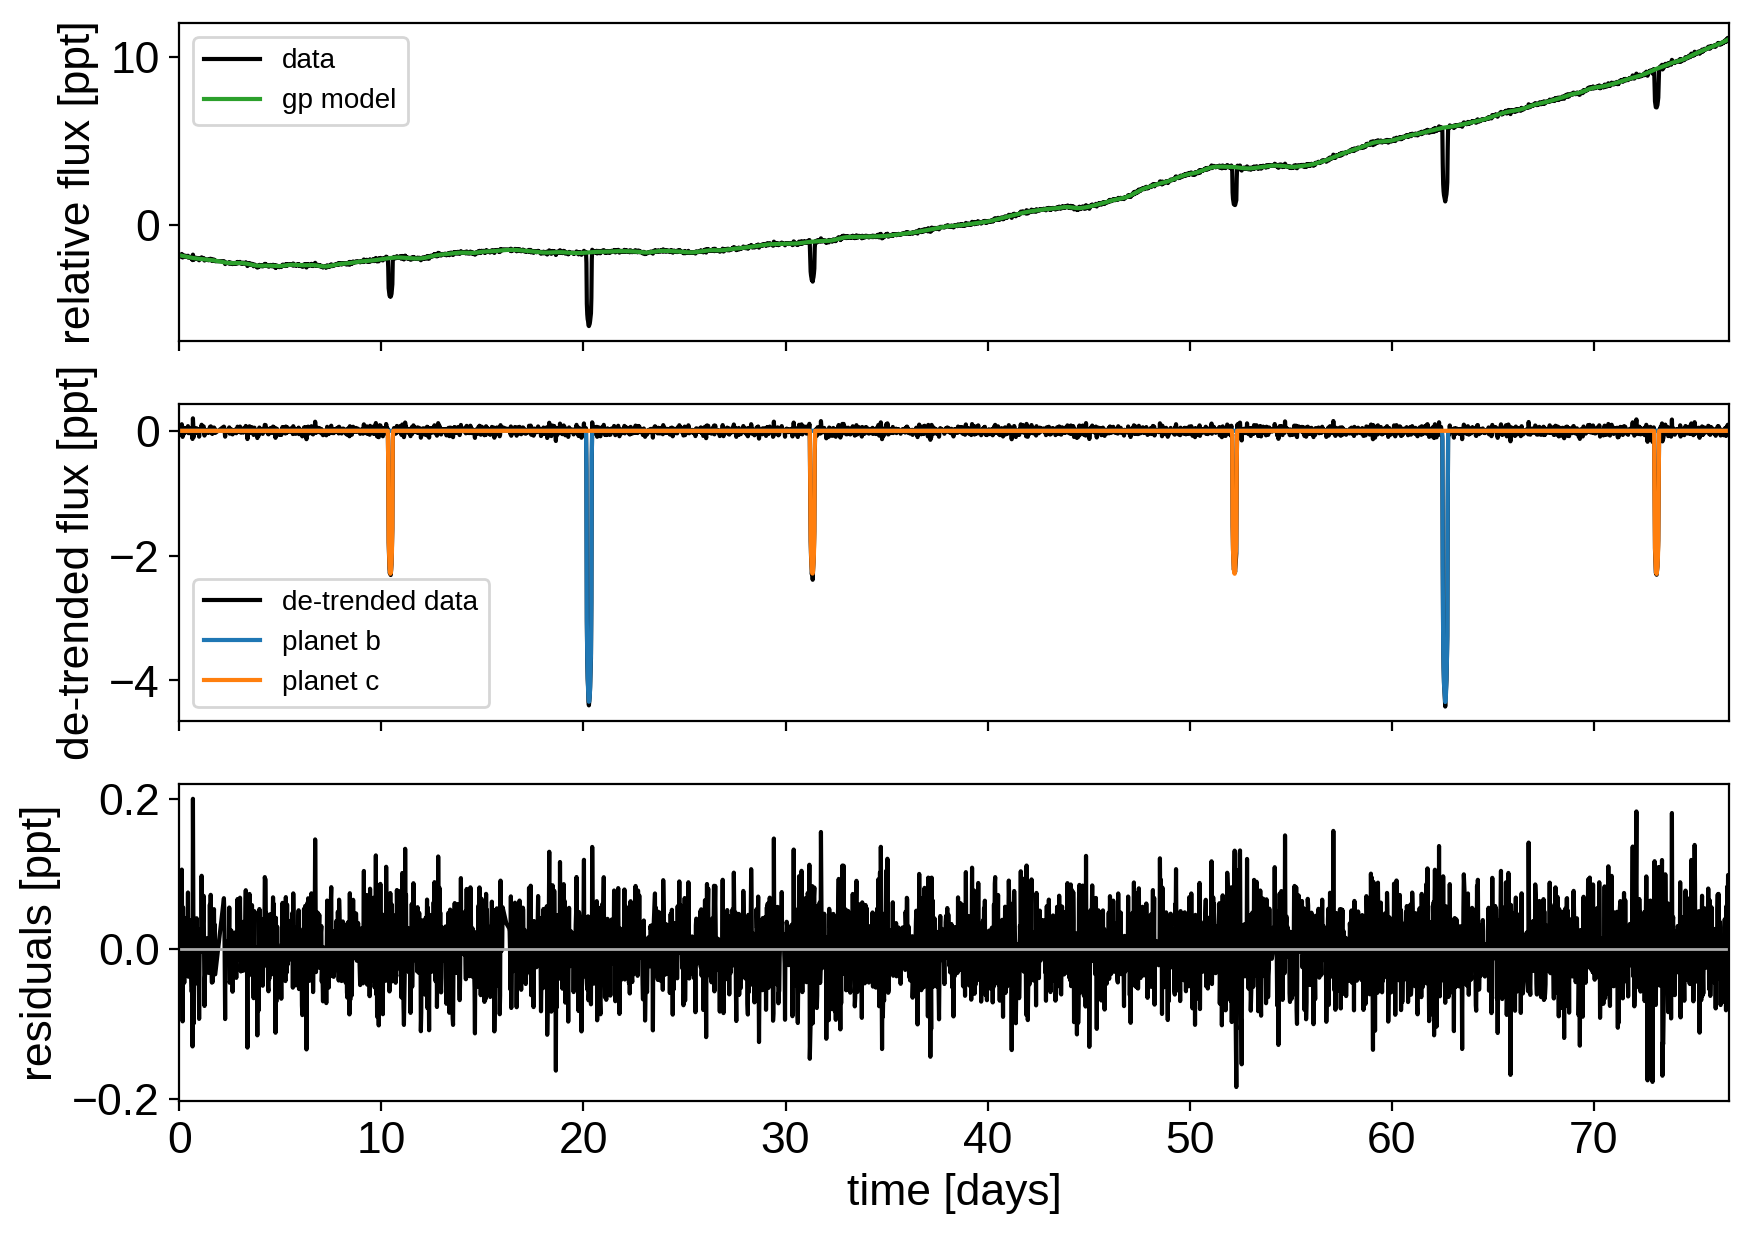

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [14]:
np.random.seed(123)
with model:
    trace = pm.sample(
        tune=6000,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logSw4, logw0, logs2, trend, logs_rv, omega, ecc_frac, ecc_sigma_rayleigh, ecc_sigma_gauss, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/36000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 18/36000 [00:00<03:20, 179.84draws/s]

Sampling 4 chains:   0%|          | 24/36000 [00:01<32:20, 18.54draws/s] 

Sampling 4 chains:   0%|          | 28/36000 [00:01<1:02:17,  9.63draws/s]

Sampling 4 chains:   0%|          | 31/36000 [00:02<1:19:52,  7.50draws/s]

Sampling 4 chains:   0%|          | 34/36000 [00:03<1:42:41,  5.84draws/s]

Sampling 4 chains:   0%|          | 36/36000 [00:03<1:51:06,  5.39draws/s]

Sampling 4 chains:   0%|          | 38/36000 [00:04<1:44:21,  5.74draws/s]

Sampling 4 chains:   0%|          | 40/36000 [00:04<1:58:59,  5.04draws/s]

Sampling 4 chains:   0%|          | 41/36000 [00:04<2:04:44,  4.80draws/s]

Sampling 4 chains:   0%|          | 43/36000 [00:05<2:17:00,  4.37draws/s]

Sampling 4 chains:   0%|          | 45/36000 [00:05<1:50:36,  5.42draws/s]

Sampling 4 chains:   0%|          | 46/36000 [00:05<1:37:16,  6.16draws/s]

Sampling 4 chains:   0%|          | 47/36000 [00:06<2:43:17,  3.67draws/s]

Sampling 4 chains:   0%|          | 50/36000 [00:06<2:07:00,  4.72draws/s]

Sampling 4 chains:   0%|          | 51/36000 [00:06<3:13:14,  3.10draws/s]

Sampling 4 chains:   0%|          | 53/36000 [00:07<2:26:08,  4.10draws/s]

Sampling 4 chains:   0%|          | 55/36000 [00:07<2:34:42,  3.87draws/s]

Sampling 4 chains:   0%|          | 57/36000 [00:07<2:07:35,  4.69draws/s]

Sampling 4 chains:   0%|          | 59/36000 [00:08<2:15:50,  4.41draws/s]

Sampling 4 chains:   0%|          | 61/36000 [00:08<1:53:44,  5.27draws/s]

Sampling 4 chains:   0%|          | 62/36000 [00:08<1:48:21,  5.53draws/s]

Sampling 4 chains:   0%|          | 63/36000 [00:09<2:19:50,  4.28draws/s]

Sampling 4 chains:   0%|          | 64/36000 [00:09<1:59:18,  5.02draws/s]

Sampling 4 chains:   0%|          | 65/36000 [00:09<1:46:38,  5.62draws/s]

Sampling 4 chains:   0%|          | 66/36000 [00:09<2:02:23,  4.89draws/s]

Sampling 4 chains:   0%|          | 67/36000 [00:09<2:12:45,  4.51draws/s]

Sampling 4 chains:   0%|          | 69/36000 [00:10<1:53:12,  5.29draws/s]

Sampling 4 chains:   0%|          | 70/36000 [00:10<2:03:03,  4.87draws/s]

Sampling 4 chains:   0%|          | 71/36000 [00:10<2:18:08,  4.33draws/s]

Sampling 4 chains:   0%|          | 72/36000 [00:10<2:00:18,  4.98draws/s]

Sampling 4 chains:   0%|          | 73/36000 [00:11<2:17:16,  4.36draws/s]

Sampling 4 chains:   0%|          | 75/36000 [00:11<2:03:37,  4.84draws/s]

Sampling 4 chains:   0%|          | 76/36000 [00:11<1:59:24,  5.01draws/s]

Sampling 4 chains:   0%|          | 77/36000 [00:11<2:07:26,  4.70draws/s]

Sampling 4 chains:   0%|          | 78/36000 [00:11<1:51:43,  5.36draws/s]

Sampling 4 chains:   0%|          | 79/36000 [00:12<1:55:06,  5.20draws/s]

Sampling 4 chains:   0%|          | 80/36000 [00:12<2:08:55,  4.64draws/s]

Sampling 4 chains:   0%|          | 81/36000 [00:12<1:50:07,  5.44draws/s]

Sampling 4 chains:   0%|          | 82/36000 [00:12<2:12:29,  4.52draws/s]

Sampling 4 chains:   0%|          | 84/36000 [00:13<2:09:46,  4.61draws/s]

Sampling 4 chains:   0%|          | 86/36000 [00:13<1:57:16,  5.10draws/s]

Sampling 4 chains:   0%|          | 87/36000 [00:13<1:58:02,  5.07draws/s]

Sampling 4 chains:   0%|          | 88/36000 [00:13<2:01:49,  4.91draws/s]

Sampling 4 chains:   0%|          | 90/36000 [00:14<1:52:58,  5.30draws/s]

Sampling 4 chains:   0%|          | 91/36000 [00:14<2:22:24,  4.20draws/s]

Sampling 4 chains:   0%|          | 92/36000 [00:14<1:58:00,  5.07draws/s]

Sampling 4 chains:   0%|          | 94/36000 [00:15<1:48:21,  5.52draws/s]

Sampling 4 chains:   0%|          | 95/36000 [00:15<2:35:38,  3.84draws/s]

Sampling 4 chains:   0%|          | 98/36000 [00:15<2:05:41,  4.76draws/s]

Sampling 4 chains:   0%|          | 99/36000 [00:16<3:00:46,  3.31draws/s]

Sampling 4 chains:   0%|          | 101/36000 [00:16<2:17:39,  4.35draws/s]

Sampling 4 chains:   0%|          | 103/36000 [00:17<2:35:35,  3.85draws/s]

Sampling 4 chains:   0%|          | 105/36000 [00:17<2:04:04,  4.82draws/s]

Sampling 4 chains:   0%|          | 107/36000 [00:17<2:30:04,  3.99draws/s]

Sampling 4 chains:   0%|          | 110/36000 [00:18<1:57:07,  5.11draws/s]

Sampling 4 chains:   0%|          | 111/36000 [00:18<3:03:05,  3.27draws/s]

Sampling 4 chains:   0%|          | 114/36000 [00:19<2:29:49,  3.99draws/s]

Sampling 4 chains:   0%|          | 115/36000 [00:19<2:58:38,  3.35draws/s]

Sampling 4 chains:   0%|          | 117/36000 [00:19<2:23:10,  4.18draws/s]

Sampling 4 chains:   0%|          | 118/36000 [00:19<2:30:51,  3.96draws/s]

Sampling 4 chains:   0%|          | 119/36000 [00:20<2:25:55,  4.10draws/s]

Sampling 4 chains:   0%|          | 120/36000 [00:20<2:01:59,  4.90draws/s]

Sampling 4 chains:   0%|          | 121/36000 [00:20<1:45:26,  5.67draws/s]

Sampling 4 chains:   0%|          | 122/36000 [00:20<2:29:26,  4.00draws/s]

Sampling 4 chains:   0%|          | 124/36000 [00:21<2:09:33,  4.62draws/s]

Sampling 4 chains:   0%|          | 127/36000 [00:21<2:01:38,  4.92draws/s]

Sampling 4 chains:   0%|          | 129/36000 [00:21<1:46:57,  5.59draws/s]

Sampling 4 chains:   0%|          | 131/36000 [00:22<1:58:29,  5.05draws/s]

Sampling 4 chains:   0%|          | 132/36000 [00:22<1:42:16,  5.85draws/s]

Sampling 4 chains:   0%|          | 133/36000 [00:22<1:36:22,  6.20draws/s]

Sampling 4 chains:   0%|          | 135/36000 [00:23<1:50:00,  5.43draws/s]

Sampling 4 chains:   0%|          | 136/36000 [00:23<1:48:41,  5.50draws/s]

Sampling 4 chains:   0%|          | 138/36000 [00:23<1:34:30,  6.32draws/s]

Sampling 4 chains:   0%|          | 139/36000 [00:23<2:07:31,  4.69draws/s]

Sampling 4 chains:   0%|          | 140/36000 [00:24<2:15:54,  4.40draws/s]

Sampling 4 chains:   0%|          | 142/36000 [00:24<1:55:28,  5.18draws/s]

Sampling 4 chains:   0%|          | 143/36000 [00:24<2:03:25,  4.84draws/s]

Sampling 4 chains:   0%|          | 144/36000 [00:24<2:10:36,  4.58draws/s]

Sampling 4 chains:   0%|          | 145/36000 [00:25<2:12:59,  4.49draws/s]

Sampling 4 chains:   0%|          | 147/36000 [00:25<1:54:17,  5.23draws/s]

Sampling 4 chains:   0%|          | 148/36000 [00:25<2:03:41,  4.83draws/s]

Sampling 4 chains:   0%|          | 149/36000 [00:25<2:26:40,  4.07draws/s]

Sampling 4 chains:   0%|          | 151/36000 [00:25<1:55:41,  5.16draws/s]

Sampling 4 chains:   0%|          | 152/36000 [00:26<2:07:33,  4.68draws/s]

Sampling 4 chains:   0%|          | 153/36000 [00:26<2:39:41,  3.74draws/s]

Sampling 4 chains:   0%|          | 156/36000 [00:26<2:12:10,  4.52draws/s]

Sampling 4 chains:   0%|          | 157/36000 [00:27<2:44:56,  3.62draws/s]

Sampling 4 chains:   0%|          | 159/36000 [00:27<2:10:31,  4.58draws/s]

Sampling 4 chains:   0%|          | 160/36000 [00:27<2:03:13,  4.85draws/s]

Sampling 4 chains:   0%|          | 161/36000 [00:28<2:48:42,  3.54draws/s]

Sampling 4 chains:   0%|          | 163/36000 [00:28<2:26:50,  4.07draws/s]

Sampling 4 chains:   0%|          | 165/36000 [00:29<2:33:19,  3.90draws/s]

Sampling 4 chains:   0%|          | 167/36000 [00:29<2:14:28,  4.44draws/s]

Sampling 4 chains:   0%|          | 168/36000 [00:29<2:45:04,  3.62draws/s]

Sampling 4 chains:   0%|          | 170/36000 [00:29<2:17:06,  4.36draws/s]

Sampling 4 chains:   0%|          | 171/36000 [00:30<2:33:08,  3.90draws/s]

Sampling 4 chains:   0%|          | 172/36000 [00:30<2:30:18,  3.97draws/s]

Sampling 4 chains:   0%|          | 173/36000 [00:30<2:21:37,  4.22draws/s]

Sampling 4 chains:   0%|          | 175/36000 [00:31<2:11:43,  4.53draws/s]

Sampling 4 chains:   0%|          | 176/36000 [00:31<2:09:31,  4.61draws/s]

Sampling 4 chains:   0%|          | 177/36000 [00:31<2:12:35,  4.50draws/s]

Sampling 4 chains:   0%|          | 179/36000 [00:31<1:56:06,  5.14draws/s]

Sampling 4 chains:   0%|          | 180/36000 [00:32<2:07:20,  4.69draws/s]

Sampling 4 chains:   1%|          | 181/36000 [00:32<2:30:11,  3.97draws/s]

Sampling 4 chains:   1%|          | 182/36000 [00:32<2:08:43,  4.64draws/s]

Sampling 4 chains:   1%|          | 184/36000 [00:32<1:55:55,  5.15draws/s]

Sampling 4 chains:   1%|          | 185/36000 [00:33<2:37:30,  3.79draws/s]

Sampling 4 chains:   1%|          | 187/36000 [00:33<2:04:03,  4.81draws/s]

Sampling 4 chains:   1%|          | 188/36000 [00:33<1:46:40,  5.60draws/s]

Sampling 4 chains:   1%|          | 189/36000 [00:34<3:00:48,  3.30draws/s]

Sampling 4 chains:   1%|          | 190/36000 [00:34<2:25:40,  4.10draws/s]

Sampling 4 chains:   1%|          | 193/36000 [00:34<2:22:21,  4.19draws/s]

Sampling 4 chains:   1%|          | 195/36000 [00:35<1:52:46,  5.29draws/s]

Sampling 4 chains:   1%|          | 196/36000 [00:35<1:45:29,  5.66draws/s]

Sampling 4 chains:   1%|          | 197/36000 [00:35<2:31:05,  3.95draws/s]

Sampling 4 chains:   1%|          | 199/36000 [00:35<2:08:49,  4.63draws/s]

Sampling 4 chains:   1%|          | 200/36000 [00:36<1:51:47,  5.34draws/s]

Sampling 4 chains:   1%|          | 201/36000 [00:36<2:14:19,  4.44draws/s]

Sampling 4 chains:   1%|          | 203/36000 [00:36<2:09:17,  4.61draws/s]

Sampling 4 chains:   1%|          | 205/36000 [00:37<1:57:03,  5.10draws/s]

Sampling 4 chains:   1%|          | 207/36000 [00:37<2:06:42,  4.71draws/s]

Sampling 4 chains:   1%|          | 209/36000 [00:37<1:44:24,  5.71draws/s]

Sampling 4 chains:   1%|          | 211/36000 [00:38<2:05:36,  4.75draws/s]

Sampling 4 chains:   1%|          | 213/36000 [00:38<1:43:14,  5.78draws/s]

Sampling 4 chains:   1%|          | 215/36000 [00:39<2:08:47,  4.63draws/s]

Sampling 4 chains:   1%|          | 218/36000 [00:39<1:39:01,  6.02draws/s]

Sampling 4 chains:   1%|          | 220/36000 [00:39<2:06:17,  4.72draws/s]

Sampling 4 chains:   1%|          | 222/36000 [00:39<1:38:03,  6.08draws/s]

Sampling 4 chains:   1%|          | 224/36000 [00:40<2:09:01,  4.62draws/s]

Sampling 4 chains:   1%|          | 226/36000 [00:40<1:40:34,  5.93draws/s]

Sampling 4 chains:   1%|          | 228/36000 [00:41<2:03:55,  4.81draws/s]

Sampling 4 chains:   1%|          | 229/36000 [00:41<1:51:27,  5.35draws/s]

Sampling 4 chains:   1%|          | 230/36000 [00:41<1:39:12,  6.01draws/s]

Sampling 4 chains:   1%|          | 231/36000 [00:42<2:24:13,  4.13draws/s]

Sampling 4 chains:   1%|          | 233/36000 [00:42<2:01:46,  4.90draws/s]

Sampling 4 chains:   1%|          | 234/36000 [00:42<1:44:03,  5.73draws/s]

Sampling 4 chains:   1%|          | 235/36000 [00:42<2:21:35,  4.21draws/s]

Sampling 4 chains:   1%|          | 237/36000 [00:43<2:02:55,  4.85draws/s]

Sampling 4 chains:   1%|          | 238/36000 [00:43<1:51:33,  5.34draws/s]

Sampling 4 chains:   1%|          | 239/36000 [00:43<2:25:55,  4.08draws/s]

Sampling 4 chains:   1%|          | 241/36000 [00:43<2:05:42,  4.74draws/s]

Sampling 4 chains:   1%|          | 243/36000 [00:44<2:09:23,  4.61draws/s]

Sampling 4 chains:   1%|          | 245/36000 [00:44<1:56:58,  5.09draws/s]

Sampling 4 chains:   1%|          | 247/36000 [00:44<1:57:17,  5.08draws/s]

Sampling 4 chains:   1%|          | 249/36000 [00:45<1:48:16,  5.50draws/s]

Sampling 4 chains:   1%|          | 250/36000 [00:45<1:40:40,  5.92draws/s]

Sampling 4 chains:   1%|          | 251/36000 [00:45<2:01:44,  4.89draws/s]

Sampling 4 chains:   1%|          | 253/36000 [00:45<1:50:28,  5.39draws/s]

Sampling 4 chains:   1%|          | 254/36000 [00:46<1:51:47,  5.33draws/s]

Sampling 4 chains:   1%|          | 255/36000 [00:46<1:55:30,  5.16draws/s]

Sampling 4 chains:   1%|          | 256/36000 [00:46<1:55:20,  5.17draws/s]

Sampling 4 chains:   1%|          | 257/36000 [00:46<1:48:02,  5.51draws/s]

Sampling 4 chains:   1%|          | 258/36000 [00:46<1:57:18,  5.08draws/s]

Sampling 4 chains:   1%|          | 259/36000 [00:47<1:49:28,  5.44draws/s]

Sampling 4 chains:   1%|          | 260/36000 [00:47<1:55:43,  5.15draws/s]

Sampling 4 chains:   1%|          | 261/36000 [00:47<1:48:14,  5.50draws/s]

Sampling 4 chains:   1%|          | 262/36000 [00:47<2:00:46,  4.93draws/s]

Sampling 4 chains:   1%|          | 264/36000 [00:48<2:00:04,  4.96draws/s]

Sampling 4 chains:   1%|          | 266/36000 [00:48<1:56:43,  5.10draws/s]

Sampling 4 chains:   1%|          | 268/36000 [00:48<1:56:06,  5.13draws/s]

Sampling 4 chains:   1%|          | 270/36000 [00:49<1:50:39,  5.38draws/s]

Sampling 4 chains:   1%|          | 272/36000 [00:49<1:53:59,  5.22draws/s]

Sampling 4 chains:   1%|          | 274/36000 [00:49<1:48:17,  5.50draws/s]

Sampling 4 chains:   1%|          | 275/36000 [00:50<1:39:03,  6.01draws/s]

Sampling 4 chains:   1%|          | 276/36000 [00:50<1:51:22,  5.35draws/s]

Sampling 4 chains:   1%|          | 277/36000 [00:50<1:52:48,  5.28draws/s]

Sampling 4 chains:   1%|          | 278/36000 [00:50<1:41:03,  5.89draws/s]

Sampling 4 chains:   1%|          | 279/36000 [00:50<1:57:09,  5.08draws/s]

Sampling 4 chains:   1%|          | 280/36000 [00:51<2:11:55,  4.51draws/s]

Sampling 4 chains:   1%|          | 281/36000 [00:51<1:55:11,  5.17draws/s]

Sampling 4 chains:   1%|          | 283/36000 [00:51<1:51:13,  5.35draws/s]

Sampling 4 chains:   1%|          | 284/36000 [00:51<2:21:55,  4.19draws/s]

Sampling 4 chains:   1%|          | 287/36000 [00:52<2:03:09,  4.83draws/s]

Sampling 4 chains:   1%|          | 288/36000 [00:52<2:25:25,  4.09draws/s]

Sampling 4 chains:   1%|          | 291/36000 [00:53<2:07:18,  4.68draws/s]

Sampling 4 chains:   1%|          | 292/36000 [00:53<2:14:17,  4.43draws/s]

Sampling 4 chains:   1%|          | 293/36000 [00:53<2:01:07,  4.91draws/s]

Sampling 4 chains:   1%|          | 295/36000 [00:53<1:58:14,  5.03draws/s]

Sampling 4 chains:   1%|          | 296/36000 [00:54<1:52:42,  5.28draws/s]

Sampling 4 chains:   1%|          | 297/36000 [00:54<1:55:36,  5.15draws/s]

Sampling 4 chains:   1%|          | 298/36000 [00:54<1:40:25,  5.92draws/s]

Sampling 4 chains:   1%|          | 299/36000 [00:54<2:00:50,  4.92draws/s]

Sampling 4 chains:   1%|          | 300/36000 [00:54<1:49:19,  5.44draws/s]

Sampling 4 chains:   1%|          | 301/36000 [00:55<2:05:02,  4.76draws/s]

Sampling 4 chains:   1%|          | 303/36000 [00:55<2:04:47,  4.77draws/s]

Sampling 4 chains:   1%|          | 305/36000 [00:55<1:51:25,  5.34draws/s]

Sampling 4 chains:   1%|          | 306/36000 [00:55<1:51:27,  5.34draws/s]

Sampling 4 chains:   1%|          | 307/36000 [00:56<1:59:13,  4.99draws/s]

Sampling 4 chains:   1%|          | 308/36000 [00:56<1:52:23,  5.29draws/s]

Sampling 4 chains:   1%|          | 310/36000 [00:56<1:59:48,  4.97draws/s]

Sampling 4 chains:   1%|          | 312/36000 [00:57<1:49:02,  5.45draws/s]

Sampling 4 chains:   1%|          | 314/36000 [00:57<1:59:18,  4.99draws/s]

Sampling 4 chains:   1%|          | 315/36000 [00:57<1:53:45,  5.23draws/s]

Sampling 4 chains:   1%|          | 317/36000 [00:58<1:44:53,  5.67draws/s]

Sampling 4 chains:   1%|          | 318/36000 [00:58<1:51:48,  5.32draws/s]

Sampling 4 chains:   1%|          | 319/36000 [00:58<1:49:30,  5.43draws/s]

Sampling 4 chains:   1%|          | 320/36000 [00:58<1:45:32,  5.63draws/s]

Sampling 4 chains:   1%|          | 321/36000 [00:58<2:06:48,  4.69draws/s]

Sampling 4 chains:   1%|          | 323/36000 [00:59<1:47:19,  5.54draws/s]

Sampling 4 chains:   1%|          | 324/36000 [00:59<2:28:33,  4.00draws/s]

Sampling 4 chains:   1%|          | 326/36000 [00:59<2:13:02,  4.47draws/s]

Sampling 4 chains:   1%|          | 328/36000 [01:00<2:15:44,  4.38draws/s]

Sampling 4 chains:   1%|          | 329/36000 [01:00<2:24:09,  4.12draws/s]

Sampling 4 chains:   1%|          | 331/36000 [01:00<1:59:07,  4.99draws/s]

Sampling 4 chains:   1%|          | 332/36000 [01:01<2:12:59,  4.47draws/s]

Sampling 4 chains:   1%|          | 333/36000 [01:01<2:13:32,  4.45draws/s]

Sampling 4 chains:   1%|          | 334/36000 [01:01<2:10:56,  4.54draws/s]

Sampling 4 chains:   1%|          | 335/36000 [01:01<1:59:42,  4.97draws/s]

Sampling 4 chains:   1%|          | 336/36000 [01:01<1:51:06,  5.35draws/s]

Sampling 4 chains:   1%|          | 337/36000 [01:02<1:54:53,  5.17draws/s]

Sampling 4 chains:   1%|          | 338/36000 [01:02<2:28:24,  4.00draws/s]

Sampling 4 chains:   1%|          | 339/36000 [01:02<2:09:36,  4.59draws/s]

Sampling 4 chains:   1%|          | 340/36000 [01:02<2:01:14,  4.90draws/s]

Sampling 4 chains:   1%|          | 342/36000 [01:03<2:22:13,  4.18draws/s]

Sampling 4 chains:   1%|          | 344/36000 [01:03<1:49:06,  5.45draws/s]

Sampling 4 chains:   1%|          | 346/36000 [01:04<2:23:41,  4.14draws/s]

Sampling 4 chains:   1%|          | 348/36000 [01:04<1:50:19,  5.39draws/s]

Sampling 4 chains:   1%|          | 350/36000 [01:05<2:15:51,  4.37draws/s]

Sampling 4 chains:   1%|          | 351/36000 [01:05<1:56:16,  5.11draws/s]

Sampling 4 chains:   1%|          | 353/36000 [01:05<1:42:31,  5.79draws/s]

Sampling 4 chains:   1%|          | 354/36000 [01:05<2:18:56,  4.28draws/s]

Sampling 4 chains:   1%|          | 355/36000 [01:05<2:03:09,  4.82draws/s]

Sampling 4 chains:   1%|          | 356/36000 [01:05<1:44:40,  5.68draws/s]

Sampling 4 chains:   1%|          | 357/36000 [01:06<2:34:32,  3.84draws/s]

Sampling 4 chains:   1%|          | 359/36000 [01:06<2:06:51,  4.68draws/s]

Sampling 4 chains:   1%|          | 360/36000 [01:06<2:00:38,  4.92draws/s]

Sampling 4 chains:   1%|          | 361/36000 [01:07<2:57:41,  3.34draws/s]

Sampling 4 chains:   1%|          | 364/36000 [01:07<2:25:02,  4.09draws/s]

Sampling 4 chains:   1%|          | 365/36000 [01:08<3:13:36,  3.07draws/s]

Sampling 4 chains:   1%|          | 368/36000 [01:08<2:40:13,  3.71draws/s]

Sampling 4 chains:   1%|          | 369/36000 [01:09<3:02:31,  3.25draws/s]

Sampling 4 chains:   1%|          | 370/36000 [01:09<2:41:51,  3.67draws/s]

Sampling 4 chains:   1%|          | 372/36000 [01:09<2:14:35,  4.41draws/s]

Sampling 4 chains:   1%|          | 373/36000 [01:09<2:33:12,  3.88draws/s]

Sampling 4 chains:   1%|          | 374/36000 [01:10<2:26:22,  4.06draws/s]

Sampling 4 chains:   1%|          | 375/36000 [01:10<2:04:53,  4.75draws/s]

Sampling 4 chains:   1%|          | 376/36000 [01:10<1:56:25,  5.10draws/s]

Sampling 4 chains:   1%|          | 377/36000 [01:10<2:15:52,  4.37draws/s]

Sampling 4 chains:   1%|          | 378/36000 [01:10<2:01:33,  4.88draws/s]

Sampling 4 chains:   1%|          | 379/36000 [01:10<2:01:46,  4.88draws/s]

Sampling 4 chains:   1%|          | 380/36000 [01:11<2:10:27,  4.55draws/s]

Sampling 4 chains:   1%|          | 381/36000 [01:11<1:56:25,  5.10draws/s]

Sampling 4 chains:   1%|          | 382/36000 [01:11<1:49:50,  5.40draws/s]

Sampling 4 chains:   1%|          | 383/36000 [01:11<2:26:53,  4.04draws/s]

Sampling 4 chains:   1%|          | 384/36000 [01:12<2:17:23,  4.32draws/s]

Sampling 4 chains:   1%|          | 386/36000 [01:12<1:51:14,  5.34draws/s]

Sampling 4 chains:   1%|          | 387/36000 [01:12<3:18:32,  2.99draws/s]

Sampling 4 chains:   1%|          | 390/36000 [01:13<2:31:33,  3.92draws/s]

Sampling 4 chains:   1%|          | 391/36000 [01:13<3:24:11,  2.91draws/s]

Sampling 4 chains:   1%|          | 392/36000 [01:13<2:49:26,  3.50draws/s]

Sampling 4 chains:   1%|          | 394/36000 [01:14<2:16:43,  4.34draws/s]

Sampling 4 chains:   1%|          | 395/36000 [01:14<2:42:58,  3.64draws/s]

Sampling 4 chains:   1%|          | 396/36000 [01:14<2:41:29,  3.67draws/s]

Sampling 4 chains:   1%|          | 398/36000 [01:14<2:16:27,  4.35draws/s]

Sampling 4 chains:   1%|          | 399/36000 [01:15<2:23:09,  4.14draws/s]

Sampling 4 chains:   1%|          | 400/36000 [01:15<2:26:42,  4.04draws/s]

Sampling 4 chains:   1%|          | 401/36000 [01:15<2:09:48,  4.57draws/s]

Sampling 4 chains:   1%|          | 402/36000 [01:15<2:11:38,  4.51draws/s]

Sampling 4 chains:   1%|          | 403/36000 [01:16<1:53:02,  5.25draws/s]

Sampling 4 chains:   1%|          | 404/36000 [01:16<2:25:14,  4.08draws/s]

Sampling 4 chains:   1%|          | 405/36000 [01:16<2:23:39,  4.13draws/s]

Sampling 4 chains:   1%|          | 407/36000 [01:16<1:58:28,  5.01draws/s]

Sampling 4 chains:   1%|          | 408/36000 [01:17<2:39:44,  3.71draws/s]

Sampling 4 chains:   1%|          | 409/36000 [01:17<2:24:35,  4.10draws/s]

Sampling 4 chains:   1%|          | 410/36000 [01:17<2:02:04,  4.86draws/s]

Sampling 4 chains:   1%|          | 412/36000 [01:18<2:14:06,  4.42draws/s]

Sampling 4 chains:   1%|          | 413/36000 [01:18<1:55:11,  5.15draws/s]

Sampling 4 chains:   1%|          | 414/36000 [01:18<2:22:05,  4.17draws/s]

Sampling 4 chains:   1%|          | 416/36000 [01:18<2:01:35,  4.88draws/s]

Sampling 4 chains:   1%|          | 417/36000 [01:18<1:46:57,  5.54draws/s]

Sampling 4 chains:   1%|          | 418/36000 [01:19<3:11:55,  3.09draws/s]

Sampling 4 chains:   1%|          | 422/36000 [01:20<2:47:51,  3.53draws/s]

Sampling 4 chains:   1%|          | 423/36000 [01:20<2:23:46,  4.12draws/s]

Sampling 4 chains:   1%|          | 425/36000 [01:20<1:54:21,  5.18draws/s]

Sampling 4 chains:   1%|          | 426/36000 [01:21<2:46:24,  3.56draws/s]

Sampling 4 chains:   1%|          | 427/36000 [01:21<2:29:39,  3.96draws/s]

Sampling 4 chains:   1%|          | 428/36000 [01:21<2:04:36,  4.76draws/s]

Sampling 4 chains:   1%|          | 429/36000 [01:21<2:19:16,  4.26draws/s]

Sampling 4 chains:   1%|          | 430/36000 [01:22<2:27:10,  4.03draws/s]

Sampling 4 chains:   1%|          | 432/36000 [01:22<2:12:39,  4.47draws/s]

Sampling 4 chains:   1%|          | 433/36000 [01:22<2:54:28,  3.40draws/s]

Sampling 4 chains:   1%|          | 436/36000 [01:23<2:36:03,  3.80draws/s]

Sampling 4 chains:   1%|          | 437/36000 [01:23<2:27:11,  4.03draws/s]

Sampling 4 chains:   1%|          | 439/36000 [01:23<1:53:32,  5.22draws/s]

Sampling 4 chains:   1%|          | 440/36000 [01:24<3:13:53,  3.06draws/s]

Sampling 4 chains:   1%|          | 444/36000 [01:25<2:49:04,  3.50draws/s]

Sampling 4 chains:   1%|          | 446/36000 [01:25<2:13:12,  4.45draws/s]

Sampling 4 chains:   1%|          | 448/36000 [01:25<2:24:33,  4.10draws/s]

Sampling 4 chains:   1%|▏         | 450/36000 [01:26<2:06:03,  4.70draws/s]

Sampling 4 chains:   1%|▏         | 451/36000 [01:26<1:48:03,  5.48draws/s]

Sampling 4 chains:   1%|▏         | 452/36000 [01:26<2:23:11,  4.14draws/s]

Sampling 4 chains:   1%|▏         | 454/36000 [01:26<2:08:58,  4.59draws/s]

Sampling 4 chains:   1%|▏         | 455/36000 [01:27<2:38:25,  3.74draws/s]

Sampling 4 chains:   1%|▏         | 457/36000 [01:27<2:07:01,  4.66draws/s]

Sampling 4 chains:   1%|▏         | 458/36000 [01:27<2:14:11,  4.41draws/s]

Sampling 4 chains:   1%|▏         | 459/36000 [01:28<2:32:50,  3.88draws/s]

Sampling 4 chains:   1%|▏         | 460/36000 [01:28<2:26:54,  4.03draws/s]

Sampling 4 chains:   1%|▏         | 461/36000 [01:28<2:15:45,  4.36draws/s]

Sampling 4 chains:   1%|▏         | 463/36000 [01:28<2:02:23,  4.84draws/s]

Sampling 4 chains:   1%|▏         | 464/36000 [01:29<2:18:44,  4.27draws/s]

Sampling 4 chains:   1%|▏         | 465/36000 [01:29<2:05:41,  4.71draws/s]

Sampling 4 chains:   1%|▏         | 466/36000 [01:29<2:23:06,  4.14draws/s]

Sampling 4 chains:   1%|▏         | 468/36000 [01:29<2:05:07,  4.73draws/s]

Sampling 4 chains:   1%|▏         | 469/36000 [01:29<1:51:17,  5.32draws/s]

Sampling 4 chains:   1%|▏         | 470/36000 [01:30<2:22:46,  4.15draws/s]

Sampling 4 chains:   1%|▏         | 471/36000 [01:30<2:04:29,  4.76draws/s]

Sampling 4 chains:   1%|▏         | 472/36000 [01:30<1:46:07,  5.58draws/s]

Sampling 4 chains:   1%|▏         | 473/36000 [01:30<1:37:30,  6.07draws/s]

Sampling 4 chains:   1%|▏         | 474/36000 [01:31<2:36:27,  3.78draws/s]

Sampling 4 chains:   1%|▏         | 475/36000 [01:31<2:17:13,  4.31draws/s]

Sampling 4 chains:   1%|▏         | 477/36000 [01:31<1:48:03,  5.48draws/s]

Sampling 4 chains:   1%|▏         | 478/36000 [01:32<2:42:16,  3.65draws/s]

Sampling 4 chains:   1%|▏         | 479/36000 [01:32<2:11:56,  4.49draws/s]

Sampling 4 chains:   1%|▏         | 480/36000 [01:32<1:53:51,  5.20draws/s]

Sampling 4 chains:   1%|▏         | 481/36000 [01:32<1:51:44,  5.30draws/s]

Sampling 4 chains:   1%|▏         | 482/36000 [01:32<2:31:58,  3.90draws/s]

Sampling 4 chains:   1%|▏         | 484/36000 [01:32<1:56:47,  5.07draws/s]

Sampling 4 chains:   1%|▏         | 485/36000 [01:33<2:31:59,  3.89draws/s]

Sampling 4 chains:   1%|▏         | 486/36000 [01:33<2:31:24,  3.91draws/s]

Sampling 4 chains:   1%|▏         | 488/36000 [01:33<2:16:00,  4.35draws/s]

Sampling 4 chains:   1%|▏         | 489/36000 [01:34<2:39:05,  3.72draws/s]

Sampling 4 chains:   1%|▏         | 491/36000 [01:34<2:04:35,  4.75draws/s]

Sampling 4 chains:   1%|▏         | 492/36000 [01:34<2:42:17,  3.65draws/s]

Sampling 4 chains:   1%|▏         | 493/36000 [01:35<2:41:30,  3.66draws/s]

Sampling 4 chains:   1%|▏         | 496/36000 [01:35<2:35:23,  3.81draws/s]

Sampling 4 chains:   1%|▏         | 498/36000 [01:35<1:58:40,  4.99draws/s]

Sampling 4 chains:   1%|▏         | 499/36000 [01:36<1:52:22,  5.26draws/s]

Sampling 4 chains:   1%|▏         | 500/36000 [01:36<2:49:19,  3.49draws/s]

Sampling 4 chains:   1%|▏         | 502/36000 [01:36<2:16:17,  4.34draws/s]

Sampling 4 chains:   1%|▏         | 503/36000 [01:37<2:50:17,  3.47draws/s]

Sampling 4 chains:   1%|▏         | 505/36000 [01:37<2:19:35,  4.24draws/s]

Sampling 4 chains:   1%|▏         | 506/36000 [01:37<2:23:02,  4.14draws/s]

Sampling 4 chains:   1%|▏         | 507/36000 [01:38<2:38:01,  3.74draws/s]

Sampling 4 chains:   1%|▏         | 508/36000 [01:38<2:18:52,  4.26draws/s]

Sampling 4 chains:   1%|▏         | 510/36000 [01:38<2:15:28,  4.37draws/s]

Sampling 4 chains:   1%|▏         | 511/36000 [01:38<1:56:12,  5.09draws/s]

Sampling 4 chains:   1%|▏         | 512/36000 [01:38<1:58:54,  4.97draws/s]

Sampling 4 chains:   1%|▏         | 514/36000 [01:39<2:13:31,  4.43draws/s]

Sampling 4 chains:   1%|▏         | 516/36000 [01:39<1:51:58,  5.28draws/s]

Sampling 4 chains:   1%|▏         | 517/36000 [01:39<1:39:06,  5.97draws/s]

Sampling 4 chains:   1%|▏         | 518/36000 [01:40<2:42:20,  3.64draws/s]

Sampling 4 chains:   1%|▏         | 520/36000 [01:40<2:07:28,  4.64draws/s]

Sampling 4 chains:   1%|▏         | 521/36000 [01:40<1:55:56,  5.10draws/s]

Sampling 4 chains:   1%|▏         | 522/36000 [01:41<2:50:41,  3.46draws/s]

Sampling 4 chains:   1%|▏         | 525/36000 [01:41<2:12:32,  4.46draws/s]

Sampling 4 chains:   1%|▏         | 526/36000 [01:41<3:08:12,  3.14draws/s]

Sampling 4 chains:   1%|▏         | 528/36000 [01:42<2:29:56,  3.94draws/s]

Sampling 4 chains:   1%|▏         | 530/36000 [01:42<2:39:30,  3.71draws/s]

Sampling 4 chains:   1%|▏         | 532/36000 [01:42<2:04:30,  4.75draws/s]

Sampling 4 chains:   1%|▏         | 533/36000 [01:43<2:09:25,  4.57draws/s]

Sampling 4 chains:   1%|▏         | 534/36000 [01:43<2:51:11,  3.45draws/s]

Sampling 4 chains:   1%|▏         | 536/36000 [01:43<2:13:03,  4.44draws/s]

Sampling 4 chains:   1%|▏         | 537/36000 [01:44<2:51:33,  3.45draws/s]

Sampling 4 chains:   1%|▏         | 538/36000 [01:44<2:35:54,  3.79draws/s]

Sampling 4 chains:   2%|▏         | 541/36000 [01:45<2:35:09,  3.81draws/s]

Sampling 4 chains:   2%|▏         | 545/36000 [01:45<2:21:10,  4.19draws/s]

Sampling 4 chains:   2%|▏         | 548/36000 [01:46<1:52:37,  5.25draws/s]

Sampling 4 chains:   2%|▏         | 549/36000 [01:46<2:51:06,  3.45draws/s]

Sampling 4 chains:   2%|▏         | 552/36000 [01:47<2:27:11,  4.01draws/s]

Sampling 4 chains:   2%|▏         | 553/36000 [01:47<2:55:38,  3.36draws/s]

Sampling 4 chains:   2%|▏         | 556/36000 [01:48<2:41:16,  3.66draws/s]

Sampling 4 chains:   2%|▏         | 557/36000 [01:48<2:21:04,  4.19draws/s]

Sampling 4 chains:   2%|▏         | 560/36000 [01:49<2:24:46,  4.08draws/s]

Sampling 4 chains:   2%|▏         | 561/36000 [01:49<2:05:01,  4.72draws/s]

Sampling 4 chains:   2%|▏         | 563/36000 [01:49<1:43:00,  5.73draws/s]

Sampling 4 chains:   2%|▏         | 564/36000 [01:50<2:54:31,  3.38draws/s]

Sampling 4 chains:   2%|▏         | 567/36000 [01:50<2:25:32,  4.06draws/s]

Sampling 4 chains:   2%|▏         | 568/36000 [01:50<3:07:08,  3.16draws/s]

Sampling 4 chains:   2%|▏         | 571/36000 [01:51<2:31:17,  3.90draws/s]

Sampling 4 chains:   2%|▏         | 572/36000 [01:51<2:59:39,  3.29draws/s]

Sampling 4 chains:   2%|▏         | 573/36000 [01:51<2:26:05,  4.04draws/s]

Sampling 4 chains:   2%|▏         | 574/36000 [01:52<2:26:12,  4.04draws/s]

Sampling 4 chains:   2%|▏         | 576/36000 [01:52<2:27:43,  4.00draws/s]

Sampling 4 chains:   2%|▏         | 578/36000 [01:52<2:17:40,  4.29draws/s]

Sampling 4 chains:   2%|▏         | 579/36000 [01:53<1:58:43,  4.97draws/s]

Sampling 4 chains:   2%|▏         | 580/36000 [01:53<2:04:57,  4.72draws/s]

Sampling 4 chains:   2%|▏         | 582/36000 [01:53<2:12:04,  4.47draws/s]

Sampling 4 chains:   2%|▏         | 583/36000 [01:54<2:14:06,  4.40draws/s]

Sampling 4 chains:   2%|▏         | 586/36000 [01:54<2:14:50,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 588/36000 [01:54<1:45:55,  5.57draws/s]

Sampling 4 chains:   2%|▏         | 589/36000 [01:55<1:49:44,  5.38draws/s]

Sampling 4 chains:   2%|▏         | 590/36000 [01:55<2:33:24,  3.85draws/s]

Sampling 4 chains:   2%|▏         | 591/36000 [01:55<2:08:22,  4.60draws/s]

Sampling 4 chains:   2%|▏         | 593/36000 [01:56<2:06:06,  4.68draws/s]

Sampling 4 chains:   2%|▏         | 594/36000 [01:56<2:17:49,  4.28draws/s]

Sampling 4 chains:   2%|▏         | 596/36000 [01:56<2:08:47,  4.58draws/s]

Sampling 4 chains:   2%|▏         | 597/36000 [01:57<2:33:04,  3.85draws/s]

Sampling 4 chains:   2%|▏         | 598/36000 [01:57<2:09:05,  4.57draws/s]

Sampling 4 chains:   2%|▏         | 600/36000 [01:57<2:07:32,  4.63draws/s]

Sampling 4 chains:   2%|▏         | 601/36000 [01:57<2:06:31,  4.66draws/s]

Sampling 4 chains:   2%|▏         | 602/36000 [01:58<2:16:15,  4.33draws/s]

Sampling 4 chains:   2%|▏         | 603/36000 [01:58<2:05:19,  4.71draws/s]

Sampling 4 chains:   2%|▏         | 604/36000 [01:58<2:14:54,  4.37draws/s]

Sampling 4 chains:   2%|▏         | 606/36000 [01:58<2:12:13,  4.46draws/s]

Sampling 4 chains:   2%|▏         | 607/36000 [01:59<2:35:03,  3.80draws/s]

Sampling 4 chains:   2%|▏         | 609/36000 [01:59<1:59:04,  4.95draws/s]

Sampling 4 chains:   2%|▏         | 610/36000 [01:59<2:19:21,  4.23draws/s]

Sampling 4 chains:   2%|▏         | 611/36000 [02:00<2:55:04,  3.37draws/s]

Sampling 4 chains:   2%|▏         | 612/36000 [02:00<2:23:04,  4.12draws/s]

Sampling 4 chains:   2%|▏         | 614/36000 [02:00<2:03:06,  4.79draws/s]

Sampling 4 chains:   2%|▏         | 615/36000 [02:00<2:41:28,  3.65draws/s]

Sampling 4 chains:   2%|▏         | 616/36000 [02:01<2:52:19,  3.42draws/s]

Sampling 4 chains:   2%|▏         | 619/36000 [02:01<2:31:30,  3.89draws/s]

Sampling 4 chains:   2%|▏         | 620/36000 [02:02<2:32:49,  3.86draws/s]

Sampling 4 chains:   2%|▏         | 621/36000 [02:02<2:13:53,  4.40draws/s]

Sampling 4 chains:   2%|▏         | 623/36000 [02:02<2:02:59,  4.79draws/s]

Sampling 4 chains:   2%|▏         | 624/36000 [02:02<2:12:33,  4.45draws/s]

Sampling 4 chains:   2%|▏         | 625/36000 [02:03<2:19:33,  4.22draws/s]

Sampling 4 chains:   2%|▏         | 626/36000 [02:03<1:58:21,  4.98draws/s]

Sampling 4 chains:   2%|▏         | 627/36000 [02:03<1:50:15,  5.35draws/s]

Sampling 4 chains:   2%|▏         | 628/36000 [02:03<1:59:42,  4.93draws/s]

Sampling 4 chains:   2%|▏         | 629/36000 [02:04<2:48:00,  3.51draws/s]

Sampling 4 chains:   2%|▏         | 631/36000 [02:04<2:07:17,  4.63draws/s]

Sampling 4 chains:   2%|▏         | 632/36000 [02:04<1:55:02,  5.12draws/s]

Sampling 4 chains:   2%|▏         | 633/36000 [02:04<3:06:28,  3.16draws/s]

Sampling 4 chains:   2%|▏         | 635/36000 [02:05<2:23:11,  4.12draws/s]

Sampling 4 chains:   2%|▏         | 636/36000 [02:05<2:07:32,  4.62draws/s]

Sampling 4 chains:   2%|▏         | 637/36000 [02:05<2:46:28,  3.54draws/s]

Sampling 4 chains:   2%|▏         | 639/36000 [02:06<2:41:02,  3.66draws/s]

Sampling 4 chains:   2%|▏         | 641/36000 [02:06<2:14:49,  4.37draws/s]

Sampling 4 chains:   2%|▏         | 643/36000 [02:07<2:33:26,  3.84draws/s]

Sampling 4 chains:   2%|▏         | 646/36000 [02:07<1:56:05,  5.08draws/s]

Sampling 4 chains:   2%|▏         | 647/36000 [02:07<3:22:50,  2.90draws/s]

Sampling 4 chains:   2%|▏         | 650/36000 [02:08<2:28:43,  3.96draws/s]

Sampling 4 chains:   2%|▏         | 652/36000 [02:08<2:50:56,  3.45draws/s]

Sampling 4 chains:   2%|▏         | 653/36000 [02:08<2:28:35,  3.96draws/s]

Sampling 4 chains:   2%|▏         | 654/36000 [02:09<2:10:59,  4.50draws/s]

Sampling 4 chains:   2%|▏         | 655/36000 [02:09<2:35:50,  3.78draws/s]

Sampling 4 chains:   2%|▏         | 657/36000 [02:09<2:29:14,  3.95draws/s]

Sampling 4 chains:   2%|▏         | 658/36000 [02:10<2:16:17,  4.32draws/s]

Sampling 4 chains:   2%|▏         | 660/36000 [02:10<1:56:02,  5.08draws/s]

Sampling 4 chains:   2%|▏         | 661/36000 [02:10<2:52:55,  3.41draws/s]

Sampling 4 chains:   2%|▏         | 662/36000 [02:10<2:24:44,  4.07draws/s]

Sampling 4 chains:   2%|▏         | 665/36000 [02:11<2:28:00,  3.98draws/s]

Sampling 4 chains:   2%|▏         | 667/36000 [02:11<1:52:30,  5.23draws/s]

Sampling 4 chains:   2%|▏         | 668/36000 [02:12<2:10:35,  4.51draws/s]

Sampling 4 chains:   2%|▏         | 669/36000 [02:12<2:36:41,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 670/36000 [02:12<2:10:39,  4.51draws/s]

Sampling 4 chains:   2%|▏         | 671/36000 [02:12<1:58:10,  4.98draws/s]

Sampling 4 chains:   2%|▏         | 672/36000 [02:13<2:01:16,  4.86draws/s]

Sampling 4 chains:   2%|▏         | 673/36000 [02:13<2:06:29,  4.65draws/s]

Sampling 4 chains:   2%|▏         | 674/36000 [02:13<1:48:51,  5.41draws/s]

Sampling 4 chains:   2%|▏         | 675/36000 [02:13<2:18:03,  4.26draws/s]

Sampling 4 chains:   2%|▏         | 676/36000 [02:13<1:54:22,  5.15draws/s]

Sampling 4 chains:   2%|▏         | 677/36000 [02:13<1:44:43,  5.62draws/s]

Sampling 4 chains:   2%|▏         | 679/36000 [02:14<2:05:48,  4.68draws/s]

Sampling 4 chains:   2%|▏         | 680/36000 [02:14<1:49:18,  5.39draws/s]

Sampling 4 chains:   2%|▏         | 682/36000 [02:14<1:31:24,  6.44draws/s]

Sampling 4 chains:   2%|▏         | 683/36000 [02:15<2:33:04,  3.85draws/s]

Sampling 4 chains:   2%|▏         | 685/36000 [02:15<2:18:04,  4.26draws/s]

Sampling 4 chains:   2%|▏         | 687/36000 [02:16<2:11:26,  4.48draws/s]

Sampling 4 chains:   2%|▏         | 689/36000 [02:16<2:26:14,  4.02draws/s]

Sampling 4 chains:   2%|▏         | 691/36000 [02:16<1:55:25,  5.10draws/s]

Sampling 4 chains:   2%|▏         | 692/36000 [02:17<1:51:20,  5.29draws/s]

Sampling 4 chains:   2%|▏         | 693/36000 [02:17<3:02:01,  3.23draws/s]

Sampling 4 chains:   2%|▏         | 695/36000 [02:17<2:16:28,  4.31draws/s]

Sampling 4 chains:   2%|▏         | 697/36000 [02:18<2:06:32,  4.65draws/s]

Sampling 4 chains:   2%|▏         | 698/36000 [02:18<2:41:41,  3.64draws/s]

Sampling 4 chains:   2%|▏         | 701/36000 [02:18<2:16:12,  4.32draws/s]

Sampling 4 chains:   2%|▏         | 702/36000 [02:19<2:37:51,  3.73draws/s]

Sampling 4 chains:   2%|▏         | 703/36000 [02:19<2:36:18,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 705/36000 [02:19<2:00:19,  4.89draws/s]

Sampling 4 chains:   2%|▏         | 706/36000 [02:19<2:29:45,  3.93draws/s]

Sampling 4 chains:   2%|▏         | 707/36000 [02:20<2:48:20,  3.49draws/s]

Sampling 4 chains:   2%|▏         | 710/36000 [02:20<2:07:59,  4.60draws/s]

Sampling 4 chains:   2%|▏         | 711/36000 [02:21<3:11:54,  3.06draws/s]

Sampling 4 chains:   2%|▏         | 713/36000 [02:21<2:32:47,  3.85draws/s]

Sampling 4 chains:   2%|▏         | 714/36000 [02:21<2:24:31,  4.07draws/s]

Sampling 4 chains:   2%|▏         | 715/36000 [02:21<2:41:34,  3.64draws/s]

Sampling 4 chains:   2%|▏         | 717/36000 [02:22<2:25:22,  4.04draws/s]

Sampling 4 chains:   2%|▏         | 718/36000 [02:22<2:19:32,  4.21draws/s]

Sampling 4 chains:   2%|▏         | 719/36000 [02:22<2:06:47,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 720/36000 [02:22<1:59:43,  4.91draws/s]

Sampling 4 chains:   2%|▏         | 721/36000 [02:23<2:26:40,  4.01draws/s]

Sampling 4 chains:   2%|▏         | 722/36000 [02:23<2:28:40,  3.95draws/s]

Sampling 4 chains:   2%|▏         | 723/36000 [02:23<2:05:01,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 725/36000 [02:23<1:43:06,  5.70draws/s]

Sampling 4 chains:   2%|▏         | 726/36000 [02:24<2:17:05,  4.29draws/s]

Sampling 4 chains:   2%|▏         | 727/36000 [02:24<2:02:32,  4.80draws/s]

Sampling 4 chains:   2%|▏         | 729/36000 [02:24<1:42:02,  5.76draws/s]

Sampling 4 chains:   2%|▏         | 731/36000 [02:24<1:27:05,  6.75draws/s]

Sampling 4 chains:   2%|▏         | 732/36000 [02:24<1:43:57,  5.65draws/s]

Sampling 4 chains:   2%|▏         | 733/36000 [02:25<1:44:03,  5.65draws/s]

Sampling 4 chains:   2%|▏         | 734/36000 [02:25<1:44:44,  5.61draws/s]

Sampling 4 chains:   2%|▏         | 735/36000 [02:25<1:39:44,  5.89draws/s]

Sampling 4 chains:   2%|▏         | 737/36000 [02:25<1:32:21,  6.36draws/s]

Sampling 4 chains:   2%|▏         | 738/36000 [02:25<1:54:01,  5.15draws/s]

Sampling 4 chains:   2%|▏         | 739/36000 [02:26<1:50:26,  5.32draws/s]

Sampling 4 chains:   2%|▏         | 740/36000 [02:26<2:08:29,  4.57draws/s]

Sampling 4 chains:   2%|▏         | 741/36000 [02:26<2:03:45,  4.75draws/s]

Sampling 4 chains:   2%|▏         | 743/36000 [02:27<2:15:33,  4.34draws/s]

Sampling 4 chains:   2%|▏         | 744/36000 [02:27<2:32:17,  3.86draws/s]

Sampling 4 chains:   2%|▏         | 746/36000 [02:28<2:46:44,  3.52draws/s]

Sampling 4 chains:   2%|▏         | 748/36000 [02:28<2:22:54,  4.11draws/s]

Sampling 4 chains:   2%|▏         | 750/36000 [02:29<2:42:27,  3.62draws/s]

Sampling 4 chains:   2%|▏         | 753/36000 [02:29<2:20:54,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 754/36000 [02:29<2:38:26,  3.71draws/s]

Sampling 4 chains:   2%|▏         | 756/36000 [02:30<2:48:15,  3.49draws/s]

Sampling 4 chains:   2%|▏         | 757/36000 [02:30<2:18:11,  4.25draws/s]

Sampling 4 chains:   2%|▏         | 758/36000 [02:30<2:22:44,  4.11draws/s]

Sampling 4 chains:   2%|▏         | 759/36000 [02:31<3:40:42,  2.66draws/s]

Sampling 4 chains:   2%|▏         | 760/36000 [02:31<3:25:47,  2.85draws/s]

Sampling 4 chains:   2%|▏         | 761/36000 [02:32<3:19:42,  2.94draws/s]

Sampling 4 chains:   2%|▏         | 762/36000 [02:32<2:44:34,  3.57draws/s]

Sampling 4 chains:   2%|▏         | 763/36000 [02:32<2:20:07,  4.19draws/s]

Sampling 4 chains:   2%|▏         | 764/36000 [02:32<2:39:41,  3.68draws/s]

Sampling 4 chains:   2%|▏         | 766/36000 [02:33<2:10:39,  4.49draws/s]

Sampling 4 chains:   2%|▏         | 767/36000 [02:33<2:31:36,  3.87draws/s]

Sampling 4 chains:   2%|▏         | 768/36000 [02:33<2:57:12,  3.31draws/s]

Sampling 4 chains:   2%|▏         | 769/36000 [02:34<3:09:07,  3.10draws/s]

Sampling 4 chains:   2%|▏         | 770/36000 [02:34<2:36:40,  3.75draws/s]

Sampling 4 chains:   2%|▏         | 771/36000 [02:34<2:47:22,  3.51draws/s]

Sampling 4 chains:   2%|▏         | 772/36000 [02:35<3:07:48,  3.13draws/s]

Sampling 4 chains:   2%|▏         | 773/36000 [02:35<2:47:20,  3.51draws/s]

Sampling 4 chains:   2%|▏         | 774/36000 [02:35<2:23:22,  4.09draws/s]

Sampling 4 chains:   2%|▏         | 775/36000 [02:35<2:16:30,  4.30draws/s]

Sampling 4 chains:   2%|▏         | 776/36000 [02:36<2:47:31,  3.50draws/s]

Sampling 4 chains:   2%|▏         | 777/36000 [02:36<2:31:41,  3.87draws/s]

Sampling 4 chains:   2%|▏         | 779/36000 [02:36<2:39:46,  3.67draws/s]

Sampling 4 chains:   2%|▏         | 780/36000 [02:37<2:39:15,  3.69draws/s]

Sampling 4 chains:   2%|▏         | 782/36000 [02:37<2:01:28,  4.83draws/s]

Sampling 4 chains:   2%|▏         | 784/36000 [02:37<2:30:13,  3.91draws/s]

Sampling 4 chains:   2%|▏         | 787/36000 [02:38<2:11:33,  4.46draws/s]

Sampling 4 chains:   2%|▏         | 788/36000 [02:38<2:35:18,  3.78draws/s]

Sampling 4 chains:   2%|▏         | 790/36000 [02:38<2:01:11,  4.84draws/s]

Sampling 4 chains:   2%|▏         | 792/36000 [02:39<2:19:29,  4.21draws/s]

Sampling 4 chains:   2%|▏         | 793/36000 [02:39<2:12:01,  4.44draws/s]

Sampling 4 chains:   2%|▏         | 797/36000 [02:39<1:40:08,  5.86draws/s]

Sampling 4 chains:   2%|▏         | 799/36000 [02:40<2:18:47,  4.23draws/s]

Sampling 4 chains:   2%|▏         | 801/36000 [02:41<2:19:48,  4.20draws/s]

Sampling 4 chains:   2%|▏         | 802/36000 [02:41<2:36:12,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 804/36000 [02:41<2:02:10,  4.80draws/s]

Sampling 4 chains:   2%|▏         | 805/36000 [02:41<2:28:18,  3.96draws/s]

Sampling 4 chains:   2%|▏         | 806/36000 [02:42<2:29:12,  3.93draws/s]

Sampling 4 chains:   2%|▏         | 808/36000 [02:42<2:04:47,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 809/36000 [02:42<2:33:46,  3.81draws/s]

Sampling 4 chains:   2%|▏         | 811/36000 [02:43<2:01:29,  4.83draws/s]

Sampling 4 chains:   2%|▏         | 813/36000 [02:43<1:59:20,  4.91draws/s]

Sampling 4 chains:   2%|▏         | 814/36000 [02:43<2:32:47,  3.84draws/s]

Sampling 4 chains:   2%|▏         | 816/36000 [02:43<2:04:44,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 818/36000 [02:44<1:42:41,  5.71draws/s]

Sampling 4 chains:   2%|▏         | 819/36000 [02:44<2:04:08,  4.72draws/s]

Sampling 4 chains:   2%|▏         | 821/36000 [02:44<1:47:11,  5.47draws/s]

Sampling 4 chains:   2%|▏         | 823/36000 [02:45<1:55:39,  5.07draws/s]

Sampling 4 chains:   2%|▏         | 825/36000 [02:45<1:34:58,  6.17draws/s]

Sampling 4 chains:   2%|▏         | 828/36000 [02:45<1:15:45,  7.74draws/s]

Sampling 4 chains:   2%|▏         | 830/36000 [02:46<1:45:40,  5.55draws/s]

Sampling 4 chains:   2%|▏         | 832/36000 [02:46<1:28:17,  6.64draws/s]

Sampling 4 chains:   2%|▏         | 834/36000 [02:46<2:00:39,  4.86draws/s]

Sampling 4 chains:   2%|▏         | 835/36000 [02:47<1:54:26,  5.12draws/s]

Sampling 4 chains:   2%|▏         | 836/36000 [02:47<1:42:12,  5.73draws/s]

Sampling 4 chains:   2%|▏         | 838/36000 [02:47<1:30:32,  6.47draws/s]

Sampling 4 chains:   2%|▏         | 840/36000 [02:47<1:30:46,  6.46draws/s]

Sampling 4 chains:   2%|▏         | 842/36000 [02:47<1:18:20,  7.48draws/s]

Sampling 4 chains:   2%|▏         | 843/36000 [02:48<1:25:09,  6.88draws/s]

Sampling 4 chains:   2%|▏         | 845/36000 [02:48<1:13:57,  7.92draws/s]

Sampling 4 chains:   2%|▏         | 846/36000 [02:48<1:20:17,  7.30draws/s]

Sampling 4 chains:   2%|▏         | 848/36000 [02:48<1:10:29,  8.31draws/s]

Sampling 4 chains:   2%|▏         | 850/36000 [02:49<1:47:44,  5.44draws/s]

Sampling 4 chains:   2%|▏         | 851/36000 [02:49<2:45:21,  3.54draws/s]

Sampling 4 chains:   2%|▏         | 853/36000 [02:49<2:07:32,  4.59draws/s]

Sampling 4 chains:   2%|▏         | 854/36000 [02:50<2:26:29,  4.00draws/s]

Sampling 4 chains:   2%|▏         | 855/36000 [02:50<2:11:08,  4.47draws/s]

Sampling 4 chains:   2%|▏         | 856/36000 [02:50<1:52:03,  5.23draws/s]

Sampling 4 chains:   2%|▏         | 858/36000 [02:50<1:36:48,  6.05draws/s]

Sampling 4 chains:   2%|▏         | 859/36000 [02:50<1:40:47,  5.81draws/s]

Sampling 4 chains:   2%|▏         | 860/36000 [02:51<1:39:56,  5.86draws/s]

Sampling 4 chains:   2%|▏         | 863/36000 [02:51<1:19:12,  7.39draws/s]

Sampling 4 chains:   2%|▏         | 865/36000 [02:51<1:10:15,  8.34draws/s]

Sampling 4 chains:   2%|▏         | 867/36000 [02:51<1:02:56,  9.30draws/s]

Sampling 4 chains:   2%|▏         | 869/36000 [02:52<1:27:27,  6.69draws/s]

Sampling 4 chains:   2%|▏         | 870/36000 [02:52<1:48:22,  5.40draws/s]

Sampling 4 chains:   2%|▏         | 871/36000 [02:52<1:53:14,  5.17draws/s]

Sampling 4 chains:   2%|▏         | 873/36000 [02:52<1:33:47,  6.24draws/s]

Sampling 4 chains:   2%|▏         | 875/36000 [02:52<1:20:18,  7.29draws/s]

Sampling 4 chains:   2%|▏         | 876/36000 [02:53<1:25:14,  6.87draws/s]

Sampling 4 chains:   2%|▏         | 877/36000 [02:53<1:27:26,  6.69draws/s]

Sampling 4 chains:   2%|▏         | 880/36000 [02:53<1:20:16,  7.29draws/s]

Sampling 4 chains:   2%|▏         | 882/36000 [02:53<1:26:04,  6.80draws/s]

Sampling 4 chains:   2%|▏         | 884/36000 [02:54<2:38:32,  3.69draws/s]

Sampling 4 chains:   2%|▏         | 885/36000 [02:55<2:24:54,  4.04draws/s]

Sampling 4 chains:   2%|▏         | 887/36000 [02:55<1:55:47,  5.05draws/s]

Sampling 4 chains:   2%|▏         | 888/36000 [02:55<2:12:04,  4.43draws/s]

Sampling 4 chains:   2%|▏         | 889/36000 [02:55<2:21:29,  4.14draws/s]

Sampling 4 chains:   2%|▏         | 890/36000 [02:56<2:38:58,  3.68draws/s]

Sampling 4 chains:   2%|▏         | 893/36000 [02:56<2:17:34,  4.25draws/s]

Sampling 4 chains:   2%|▏         | 894/36000 [02:56<2:01:34,  4.81draws/s]

Sampling 4 chains:   2%|▏         | 895/36000 [02:56<1:44:00,  5.63draws/s]

Sampling 4 chains:   2%|▏         | 898/36000 [02:57<2:10:36,  4.48draws/s]

Sampling 4 chains:   2%|▏         | 899/36000 [02:58<1:55:58,  5.04draws/s]

Sampling 4 chains:   3%|▎         | 901/36000 [02:58<1:40:24,  5.83draws/s]

Sampling 4 chains:   3%|▎         | 902/36000 [02:58<2:00:58,  4.84draws/s]

Sampling 4 chains:   3%|▎         | 904/36000 [02:58<1:56:38,  5.02draws/s]

Sampling 4 chains:   3%|▎         | 905/36000 [02:59<1:42:44,  5.69draws/s]

Sampling 4 chains:   3%|▎         | 906/36000 [02:59<2:36:53,  3.73draws/s]

Sampling 4 chains:   3%|▎         | 908/36000 [02:59<2:22:39,  4.10draws/s]

Sampling 4 chains:   3%|▎         | 909/36000 [03:00<2:27:31,  3.96draws/s]

Sampling 4 chains:   3%|▎         | 912/36000 [03:00<2:02:39,  4.77draws/s]

Sampling 4 chains:   3%|▎         | 914/36000 [03:00<1:40:54,  5.80draws/s]

Sampling 4 chains:   3%|▎         | 916/36000 [03:00<1:25:52,  6.81draws/s]

Sampling 4 chains:   3%|▎         | 917/36000 [03:00<1:18:28,  7.45draws/s]

Sampling 4 chains:   3%|▎         | 918/36000 [03:01<1:26:59,  6.72draws/s]

Sampling 4 chains:   3%|▎         | 919/36000 [03:01<1:27:40,  6.67draws/s]

Sampling 4 chains:   3%|▎         | 921/36000 [03:01<1:38:10,  5.95draws/s]

Sampling 4 chains:   3%|▎         | 923/36000 [03:02<1:39:14,  5.89draws/s]

Sampling 4 chains:   3%|▎         | 924/36000 [03:02<2:13:43,  4.37draws/s]

Sampling 4 chains:   3%|▎         | 926/36000 [03:02<1:54:42,  5.10draws/s]

Sampling 4 chains:   3%|▎         | 927/36000 [03:02<1:48:14,  5.40draws/s]

Sampling 4 chains:   3%|▎         | 929/36000 [03:03<1:45:32,  5.54draws/s]

Sampling 4 chains:   3%|▎         | 931/36000 [03:03<2:00:50,  4.84draws/s]

Sampling 4 chains:   3%|▎         | 932/36000 [03:03<1:47:21,  5.44draws/s]

Sampling 4 chains:   3%|▎         | 933/36000 [03:03<1:38:51,  5.91draws/s]

Sampling 4 chains:   3%|▎         | 936/36000 [03:04<1:16:45,  7.61draws/s]

Sampling 4 chains:   3%|▎         | 938/36000 [03:04<1:44:09,  5.61draws/s]

Sampling 4 chains:   3%|▎         | 940/36000 [03:04<1:31:07,  6.41draws/s]

Sampling 4 chains:   3%|▎         | 942/36000 [03:04<1:14:58,  7.79draws/s]

Sampling 4 chains:   3%|▎         | 944/36000 [03:05<1:19:26,  7.36draws/s]

Sampling 4 chains:   3%|▎         | 946/36000 [03:05<1:16:57,  7.59draws/s]

Sampling 4 chains:   3%|▎         | 948/36000 [03:05<1:23:08,  7.03draws/s]

Sampling 4 chains:   3%|▎         | 951/36000 [03:06<1:33:56,  6.22draws/s]

Sampling 4 chains:   3%|▎         | 953/36000 [03:06<1:16:32,  7.63draws/s]

Sampling 4 chains:   3%|▎         | 954/36000 [03:06<1:42:22,  5.71draws/s]

Sampling 4 chains:   3%|▎         | 955/36000 [03:07<1:39:46,  5.85draws/s]

Sampling 4 chains:   3%|▎         | 956/36000 [03:07<1:36:25,  6.06draws/s]

Sampling 4 chains:   3%|▎         | 957/36000 [03:07<1:48:13,  5.40draws/s]

Sampling 4 chains:   3%|▎         | 958/36000 [03:07<1:33:23,  6.25draws/s]

Sampling 4 chains:   3%|▎         | 960/36000 [03:07<1:20:07,  7.29draws/s]

Sampling 4 chains:   3%|▎         | 963/36000 [03:07<1:05:56,  8.86draws/s]

Sampling 4 chains:   3%|▎         | 966/36000 [03:08<59:02,  9.89draws/s]  

Sampling 4 chains:   3%|▎         | 968/36000 [03:08<1:00:06,  9.71draws/s]

Sampling 4 chains:   3%|▎         | 971/36000 [03:08<1:02:38,  9.32draws/s]

Sampling 4 chains:   3%|▎         | 973/36000 [03:08<58:03, 10.06draws/s]  

Sampling 4 chains:   3%|▎         | 975/36000 [03:09<58:43,  9.94draws/s]

Sampling 4 chains:   3%|▎         | 977/36000 [03:09<59:32,  9.80draws/s]

Sampling 4 chains:   3%|▎         | 979/36000 [03:09<1:06:59,  8.71draws/s]

Sampling 4 chains:   3%|▎         | 980/36000 [03:09<1:13:43,  7.92draws/s]

Sampling 4 chains:   3%|▎         | 982/36000 [03:10<1:29:31,  6.52draws/s]

Sampling 4 chains:   3%|▎         | 983/36000 [03:10<2:36:41,  3.72draws/s]

Sampling 4 chains:   3%|▎         | 985/36000 [03:10<2:00:59,  4.82draws/s]

Sampling 4 chains:   3%|▎         | 986/36000 [03:10<1:53:15,  5.15draws/s]

Sampling 4 chains:   3%|▎         | 988/36000 [03:11<1:32:41,  6.30draws/s]

Sampling 4 chains:   3%|▎         | 990/36000 [03:11<1:46:49,  5.46draws/s]

Sampling 4 chains:   3%|▎         | 991/36000 [03:11<1:36:50,  6.03draws/s]

Sampling 4 chains:   3%|▎         | 992/36000 [03:12<2:35:40,  3.75draws/s]

Sampling 4 chains:   3%|▎         | 993/36000 [03:12<2:21:46,  4.12draws/s]

Sampling 4 chains:   3%|▎         | 995/36000 [03:12<2:31:28,  3.85draws/s]

Sampling 4 chains:   3%|▎         | 996/36000 [03:13<2:07:58,  4.56draws/s]

Sampling 4 chains:   3%|▎         | 997/36000 [03:13<1:53:48,  5.13draws/s]

Sampling 4 chains:   3%|▎         | 998/36000 [03:13<2:10:22,  4.47draws/s]

Sampling 4 chains:   3%|▎         | 1000/36000 [03:13<2:06:38,  4.61draws/s]

Sampling 4 chains:   3%|▎         | 1003/36000 [03:14<1:42:47,  5.67draws/s]

Sampling 4 chains:   3%|▎         | 1005/36000 [03:14<1:35:08,  6.13draws/s]

Sampling 4 chains:   3%|▎         | 1006/36000 [03:14<1:30:06,  6.47draws/s]

Sampling 4 chains:   3%|▎         | 1007/36000 [03:14<2:09:17,  4.51draws/s]

Sampling 4 chains:   3%|▎         | 1008/36000 [03:15<2:23:57,  4.05draws/s]

Sampling 4 chains:   3%|▎         | 1010/36000 [03:15<1:50:42,  5.27draws/s]

Sampling 4 chains:   3%|▎         | 1011/36000 [03:15<1:47:20,  5.43draws/s]

Sampling 4 chains:   3%|▎         | 1012/36000 [03:15<1:32:40,  6.29draws/s]

Sampling 4 chains:   3%|▎         | 1014/36000 [03:15<1:17:33,  7.52draws/s]

Sampling 4 chains:   3%|▎         | 1016/36000 [03:16<1:50:06,  5.30draws/s]

Sampling 4 chains:   3%|▎         | 1018/36000 [03:16<1:30:08,  6.47draws/s]

Sampling 4 chains:   3%|▎         | 1020/36000 [03:16<1:37:29,  5.98draws/s]

Sampling 4 chains:   3%|▎         | 1021/36000 [03:17<1:52:04,  5.20draws/s]

Sampling 4 chains:   3%|▎         | 1023/36000 [03:17<1:32:09,  6.33draws/s]

Sampling 4 chains:   3%|▎         | 1024/36000 [03:17<2:12:15,  4.41draws/s]

Sampling 4 chains:   3%|▎         | 1025/36000 [03:18<2:34:22,  3.78draws/s]

Sampling 4 chains:   3%|▎         | 1027/36000 [03:18<2:06:14,  4.62draws/s]

Sampling 4 chains:   3%|▎         | 1028/36000 [03:18<2:08:42,  4.53draws/s]

Sampling 4 chains:   3%|▎         | 1030/36000 [03:18<2:04:47,  4.67draws/s]

Sampling 4 chains:   3%|▎         | 1031/36000 [03:19<2:36:16,  3.73draws/s]

Sampling 4 chains:   3%|▎         | 1032/36000 [03:19<2:23:56,  4.05draws/s]

Sampling 4 chains:   3%|▎         | 1033/36000 [03:19<2:15:27,  4.30draws/s]

Sampling 4 chains:   3%|▎         | 1034/36000 [03:20<2:19:20,  4.18draws/s]

Sampling 4 chains:   3%|▎         | 1036/36000 [03:20<2:14:29,  4.33draws/s]

Sampling 4 chains:   3%|▎         | 1037/36000 [03:20<2:05:57,  4.63draws/s]

Sampling 4 chains:   3%|▎         | 1039/36000 [03:20<1:39:03,  5.88draws/s]

Sampling 4 chains:   3%|▎         | 1040/36000 [03:20<1:29:37,  6.50draws/s]

Sampling 4 chains:   3%|▎         | 1041/36000 [03:21<1:36:18,  6.05draws/s]

Sampling 4 chains:   3%|▎         | 1042/36000 [03:21<2:17:26,  4.24draws/s]

Sampling 4 chains:   3%|▎         | 1044/36000 [03:21<1:54:21,  5.09draws/s]

Sampling 4 chains:   3%|▎         | 1045/36000 [03:21<2:00:15,  4.84draws/s]

Sampling 4 chains:   3%|▎         | 1046/36000 [03:22<1:54:23,  5.09draws/s]

Sampling 4 chains:   3%|▎         | 1048/36000 [03:22<1:52:11,  5.19draws/s]

Sampling 4 chains:   3%|▎         | 1049/36000 [03:22<1:53:56,  5.11draws/s]

Sampling 4 chains:   3%|▎         | 1051/36000 [03:22<1:32:15,  6.31draws/s]

Sampling 4 chains:   3%|▎         | 1053/36000 [03:23<1:39:50,  5.83draws/s]

Sampling 4 chains:   3%|▎         | 1055/36000 [03:23<1:35:49,  6.08draws/s]

Sampling 4 chains:   3%|▎         | 1056/36000 [03:23<1:26:49,  6.71draws/s]

Sampling 4 chains:   3%|▎         | 1057/36000 [03:24<2:11:34,  4.43draws/s]

Sampling 4 chains:   3%|▎         | 1058/36000 [03:24<1:53:13,  5.14draws/s]

Sampling 4 chains:   3%|▎         | 1059/36000 [03:24<2:12:42,  4.39draws/s]

Sampling 4 chains:   3%|▎         | 1061/36000 [03:24<2:18:21,  4.21draws/s]

Sampling 4 chains:   3%|▎         | 1063/36000 [03:25<2:05:18,  4.65draws/s]

Sampling 4 chains:   3%|▎         | 1064/36000 [03:25<2:28:12,  3.93draws/s]

Sampling 4 chains:   3%|▎         | 1066/36000 [03:25<2:03:30,  4.71draws/s]

Sampling 4 chains:   3%|▎         | 1068/36000 [03:26<1:42:04,  5.70draws/s]

Sampling 4 chains:   3%|▎         | 1069/36000 [03:26<2:14:16,  4.34draws/s]

Sampling 4 chains:   3%|▎         | 1070/36000 [03:26<2:33:51,  3.78draws/s]

Sampling 4 chains:   3%|▎         | 1071/36000 [03:27<2:50:07,  3.42draws/s]

Sampling 4 chains:   3%|▎         | 1072/36000 [03:27<2:58:42,  3.26draws/s]

Sampling 4 chains:   3%|▎         | 1074/36000 [03:27<2:36:00,  3.73draws/s]

Sampling 4 chains:   3%|▎         | 1076/36000 [03:27<2:00:15,  4.84draws/s]

Sampling 4 chains:   3%|▎         | 1077/36000 [03:28<2:02:36,  4.75draws/s]

Sampling 4 chains:   3%|▎         | 1078/36000 [03:28<2:07:36,  4.56draws/s]

Sampling 4 chains:   3%|▎         | 1080/36000 [03:28<1:51:23,  5.22draws/s]

Sampling 4 chains:   3%|▎         | 1081/36000 [03:28<1:38:29,  5.91draws/s]

Sampling 4 chains:   3%|▎         | 1083/36000 [03:28<1:27:19,  6.66draws/s]

Sampling 4 chains:   3%|▎         | 1084/36000 [03:29<1:55:36,  5.03draws/s]

Sampling 4 chains:   3%|▎         | 1086/36000 [03:29<1:48:20,  5.37draws/s]

Sampling 4 chains:   3%|▎         | 1088/36000 [03:29<1:32:36,  6.28draws/s]

Sampling 4 chains:   3%|▎         | 1089/36000 [03:29<1:34:19,  6.17draws/s]

Sampling 4 chains:   3%|▎         | 1091/36000 [03:30<1:26:53,  6.70draws/s]

Sampling 4 chains:   3%|▎         | 1092/36000 [03:30<1:50:38,  5.26draws/s]

Sampling 4 chains:   3%|▎         | 1093/36000 [03:30<1:55:42,  5.03draws/s]

Sampling 4 chains:   3%|▎         | 1094/36000 [03:30<1:48:28,  5.36draws/s]

Sampling 4 chains:   3%|▎         | 1095/36000 [03:31<1:48:31,  5.36draws/s]

Sampling 4 chains:   3%|▎         | 1099/36000 [03:31<1:27:50,  6.62draws/s]

Sampling 4 chains:   3%|▎         | 1101/36000 [03:31<1:31:01,  6.39draws/s]

Sampling 4 chains:   3%|▎         | 1102/36000 [03:31<1:33:15,  6.24draws/s]

Sampling 4 chains:   3%|▎         | 1103/36000 [03:32<2:02:11,  4.76draws/s]

Sampling 4 chains:   3%|▎         | 1105/36000 [03:32<1:49:31,  5.31draws/s]

Sampling 4 chains:   3%|▎         | 1107/36000 [03:32<1:32:55,  6.26draws/s]

Sampling 4 chains:   3%|▎         | 1108/36000 [03:32<1:43:18,  5.63draws/s]

Sampling 4 chains:   3%|▎         | 1109/36000 [03:33<2:09:20,  4.50draws/s]

Sampling 4 chains:   3%|▎         | 1110/36000 [03:33<1:51:04,  5.24draws/s]

Sampling 4 chains:   3%|▎         | 1112/36000 [03:33<1:55:36,  5.03draws/s]

Sampling 4 chains:   3%|▎         | 1113/36000 [03:33<1:38:23,  5.91draws/s]

Sampling 4 chains:   3%|▎         | 1114/36000 [03:34<2:06:22,  4.60draws/s]

Sampling 4 chains:   3%|▎         | 1117/36000 [03:34<1:51:11,  5.23draws/s]

Sampling 4 chains:   3%|▎         | 1118/36000 [03:34<2:23:41,  4.05draws/s]

Sampling 4 chains:   3%|▎         | 1121/36000 [03:35<1:52:05,  5.19draws/s]

Sampling 4 chains:   3%|▎         | 1122/36000 [03:35<2:06:00,  4.61draws/s]

Sampling 4 chains:   3%|▎         | 1123/36000 [03:35<1:50:55,  5.24draws/s]

Sampling 4 chains:   3%|▎         | 1124/36000 [03:35<2:03:37,  4.70draws/s]

Sampling 4 chains:   3%|▎         | 1125/36000 [03:35<1:54:14,  5.09draws/s]

Sampling 4 chains:   3%|▎         | 1126/36000 [03:36<2:02:14,  4.75draws/s]

Sampling 4 chains:   3%|▎         | 1128/36000 [03:36<1:43:07,  5.64draws/s]

Sampling 4 chains:   3%|▎         | 1130/36000 [03:36<1:35:57,  6.06draws/s]

Sampling 4 chains:   3%|▎         | 1132/36000 [03:37<1:39:35,  5.84draws/s]

Sampling 4 chains:   3%|▎         | 1134/36000 [03:37<1:28:57,  6.53draws/s]

Sampling 4 chains:   3%|▎         | 1135/36000 [03:37<1:25:35,  6.79draws/s]

Sampling 4 chains:   3%|▎         | 1136/36000 [03:37<1:58:54,  4.89draws/s]

Sampling 4 chains:   3%|▎         | 1138/36000 [03:38<1:53:20,  5.13draws/s]

Sampling 4 chains:   3%|▎         | 1140/36000 [03:38<1:46:21,  5.46draws/s]

Sampling 4 chains:   3%|▎         | 1142/36000 [03:38<1:31:28,  6.35draws/s]

Sampling 4 chains:   3%|▎         | 1144/36000 [03:38<1:17:57,  7.45draws/s]

Sampling 4 chains:   3%|▎         | 1145/36000 [03:38<1:23:16,  6.98draws/s]

Sampling 4 chains:   3%|▎         | 1146/36000 [03:39<1:30:07,  6.44draws/s]

Sampling 4 chains:   3%|▎         | 1147/36000 [03:39<1:29:37,  6.48draws/s]

Sampling 4 chains:   3%|▎         | 1149/36000 [03:39<1:21:42,  7.11draws/s]

Sampling 4 chains:   3%|▎         | 1150/36000 [03:39<2:14:31,  4.32draws/s]

Sampling 4 chains:   3%|▎         | 1152/36000 [03:40<1:56:02,  5.01draws/s]

Sampling 4 chains:   3%|▎         | 1154/36000 [03:40<1:33:48,  6.19draws/s]

Sampling 4 chains:   3%|▎         | 1155/36000 [03:40<3:03:58,  3.16draws/s]

Sampling 4 chains:   3%|▎         | 1156/36000 [03:41<3:08:37,  3.08draws/s]

Sampling 4 chains:   3%|▎         | 1158/36000 [03:41<2:28:23,  3.91draws/s]

Sampling 4 chains:   3%|▎         | 1159/36000 [03:41<2:06:23,  4.59draws/s]

Sampling 4 chains:   3%|▎         | 1160/36000 [03:41<2:28:13,  3.92draws/s]

Sampling 4 chains:   3%|▎         | 1162/36000 [03:42<2:00:41,  4.81draws/s]

Sampling 4 chains:   3%|▎         | 1163/36000 [03:42<2:14:37,  4.31draws/s]

Sampling 4 chains:   3%|▎         | 1164/36000 [03:42<2:07:32,  4.55draws/s]

Sampling 4 chains:   3%|▎         | 1165/36000 [03:42<2:00:23,  4.82draws/s]

Sampling 4 chains:   3%|▎         | 1168/36000 [03:43<1:52:52,  5.14draws/s]

Sampling 4 chains:   3%|▎         | 1170/36000 [03:43<1:40:40,  5.77draws/s]

Sampling 4 chains:   3%|▎         | 1171/36000 [03:43<1:41:57,  5.69draws/s]

Sampling 4 chains:   3%|▎         | 1173/36000 [03:43<1:28:38,  6.55draws/s]

Sampling 4 chains:   3%|▎         | 1174/36000 [03:44<1:39:20,  5.84draws/s]

Sampling 4 chains:   3%|▎         | 1175/36000 [03:44<1:35:15,  6.09draws/s]

Sampling 4 chains:   3%|▎         | 1177/36000 [03:44<1:20:21,  7.22draws/s]

Sampling 4 chains:   3%|▎         | 1179/36000 [03:44<1:25:27,  6.79draws/s]

Sampling 4 chains:   3%|▎         | 1180/36000 [03:44<1:28:05,  6.59draws/s]

Sampling 4 chains:   3%|▎         | 1182/36000 [03:45<1:18:53,  7.36draws/s]

Sampling 4 chains:   3%|▎         | 1183/36000 [03:45<1:19:15,  7.32draws/s]

Sampling 4 chains:   3%|▎         | 1184/36000 [03:45<1:58:12,  4.91draws/s]

Sampling 4 chains:   3%|▎         | 1186/36000 [03:45<1:49:12,  5.31draws/s]

Sampling 4 chains:   3%|▎         | 1187/36000 [03:46<1:58:26,  4.90draws/s]

Sampling 4 chains:   3%|▎         | 1188/36000 [03:46<2:03:42,  4.69draws/s]

Sampling 4 chains:   3%|▎         | 1189/36000 [03:46<1:58:34,  4.89draws/s]

Sampling 4 chains:   3%|▎         | 1190/36000 [03:46<1:47:07,  5.42draws/s]

Sampling 4 chains:   3%|▎         | 1192/36000 [03:47<1:40:07,  5.79draws/s]

Sampling 4 chains:   3%|▎         | 1193/36000 [03:47<1:28:01,  6.59draws/s]

Sampling 4 chains:   3%|▎         | 1195/36000 [03:47<1:10:33,  8.22draws/s]

Sampling 4 chains:   3%|▎         | 1197/36000 [03:47<1:28:24,  6.56draws/s]

Sampling 4 chains:   3%|▎         | 1199/36000 [03:47<1:14:04,  7.83draws/s]

Sampling 4 chains:   3%|▎         | 1201/36000 [03:48<1:15:17,  7.70draws/s]

Sampling 4 chains:   3%|▎         | 1203/36000 [03:48<1:06:15,  8.75draws/s]

Sampling 4 chains:   3%|▎         | 1205/36000 [03:48<1:10:07,  8.27draws/s]

Sampling 4 chains:   3%|▎         | 1206/36000 [03:48<1:24:00,  6.90draws/s]

Sampling 4 chains:   3%|▎         | 1208/36000 [03:48<1:18:19,  7.40draws/s]

Sampling 4 chains:   3%|▎         | 1209/36000 [03:49<1:13:10,  7.92draws/s]

Sampling 4 chains:   3%|▎         | 1210/36000 [03:49<1:17:09,  7.52draws/s]

Sampling 4 chains:   3%|▎         | 1212/36000 [03:49<1:08:04,  8.52draws/s]

Sampling 4 chains:   3%|▎         | 1213/36000 [03:49<1:26:12,  6.73draws/s]

Sampling 4 chains:   3%|▎         | 1215/36000 [03:49<1:18:59,  7.34draws/s]

Sampling 4 chains:   3%|▎         | 1216/36000 [03:49<1:17:00,  7.53draws/s]

Sampling 4 chains:   3%|▎         | 1219/36000 [03:50<1:03:45,  9.09draws/s]

Sampling 4 chains:   3%|▎         | 1221/36000 [03:50<1:03:19,  9.15draws/s]

Sampling 4 chains:   3%|▎         | 1223/36000 [03:50<55:57, 10.36draws/s]  

Sampling 4 chains:   3%|▎         | 1225/36000 [03:50<58:30,  9.91draws/s]

Sampling 4 chains:   3%|▎         | 1227/36000 [03:50<53:55, 10.75draws/s]

Sampling 4 chains:   3%|▎         | 1229/36000 [03:51<57:18, 10.11draws/s]

Sampling 4 chains:   3%|▎         | 1231/36000 [03:51<54:15, 10.68draws/s]

Sampling 4 chains:   3%|▎         | 1233/36000 [03:51<57:49, 10.02draws/s]

Sampling 4 chains:   3%|▎         | 1235/36000 [03:51<1:15:50,  7.64draws/s]

Sampling 4 chains:   3%|▎         | 1237/36000 [03:51<1:03:44,  9.09draws/s]

Sampling 4 chains:   3%|▎         | 1239/36000 [03:52<1:11:53,  8.06draws/s]

Sampling 4 chains:   3%|▎         | 1241/36000 [03:52<1:09:35,  8.32draws/s]

Sampling 4 chains:   3%|▎         | 1243/36000 [03:52<1:07:30,  8.58draws/s]

Sampling 4 chains:   3%|▎         | 1245/36000 [03:52<59:25,  9.75draws/s]  

Sampling 4 chains:   3%|▎         | 1248/36000 [03:53<54:25, 10.64draws/s]

Sampling 4 chains:   3%|▎         | 1251/36000 [03:53<56:27, 10.26draws/s]

Sampling 4 chains:   3%|▎         | 1254/36000 [03:53<46:20, 12.50draws/s]

Sampling 4 chains:   3%|▎         | 1256/36000 [03:53<55:16, 10.48draws/s]

Sampling 4 chains:   3%|▎         | 1258/36000 [03:53<55:48, 10.38draws/s]

Sampling 4 chains:   4%|▎         | 1260/36000 [03:54<1:08:11,  8.49draws/s]

Sampling 4 chains:   4%|▎         | 1262/36000 [03:54<1:24:30,  6.85draws/s]

Sampling 4 chains:   4%|▎         | 1264/36000 [03:54<1:20:48,  7.16draws/s]

Sampling 4 chains:   4%|▎         | 1266/36000 [03:55<1:05:44,  8.80draws/s]

Sampling 4 chains:   4%|▎         | 1268/36000 [03:55<1:05:48,  8.80draws/s]

Sampling 4 chains:   4%|▎         | 1270/36000 [03:55<1:04:28,  8.98draws/s]

Sampling 4 chains:   4%|▎         | 1272/36000 [03:55<1:09:52,  8.28draws/s]

Sampling 4 chains:   4%|▎         | 1273/36000 [03:55<1:10:03,  8.26draws/s]

Sampling 4 chains:   4%|▎         | 1275/36000 [03:56<58:13,  9.94draws/s]  

Sampling 4 chains:   4%|▎         | 1277/36000 [03:56<1:08:59,  8.39draws/s]

Sampling 4 chains:   4%|▎         | 1279/36000 [03:56<1:01:47,  9.37draws/s]

Sampling 4 chains:   4%|▎         | 1281/36000 [03:56<1:20:01,  7.23draws/s]

Sampling 4 chains:   4%|▎         | 1282/36000 [03:57<1:41:31,  5.70draws/s]

Sampling 4 chains:   4%|▎         | 1284/36000 [03:57<1:48:26,  5.34draws/s]

Sampling 4 chains:   4%|▎         | 1285/36000 [03:57<1:43:56,  5.57draws/s]

Sampling 4 chains:   4%|▎         | 1286/36000 [03:57<1:44:24,  5.54draws/s]

Sampling 4 chains:   4%|▎         | 1287/36000 [03:58<1:44:56,  5.51draws/s]

Sampling 4 chains:   4%|▎         | 1288/36000 [03:58<2:02:40,  4.72draws/s]

Sampling 4 chains:   4%|▎         | 1290/36000 [03:58<1:53:56,  5.08draws/s]

Sampling 4 chains:   4%|▎         | 1292/36000 [03:58<1:38:05,  5.90draws/s]

Sampling 4 chains:   4%|▎         | 1293/36000 [03:59<1:43:29,  5.59draws/s]

Sampling 4 chains:   4%|▎         | 1295/36000 [03:59<1:29:57,  6.43draws/s]

Sampling 4 chains:   4%|▎         | 1297/36000 [03:59<1:38:03,  5.90draws/s]

Sampling 4 chains:   4%|▎         | 1299/36000 [03:59<1:22:06,  7.04draws/s]

Sampling 4 chains:   4%|▎         | 1300/36000 [04:00<1:38:57,  5.84draws/s]

Sampling 4 chains:   4%|▎         | 1301/36000 [04:00<1:36:56,  5.97draws/s]

Sampling 4 chains:   4%|▎         | 1302/36000 [04:00<1:55:38,  5.00draws/s]

Sampling 4 chains:   4%|▎         | 1304/36000 [04:00<1:38:27,  5.87draws/s]

Sampling 4 chains:   4%|▎         | 1306/36000 [04:01<1:34:41,  6.11draws/s]

Sampling 4 chains:   4%|▎         | 1307/36000 [04:01<1:50:17,  5.24draws/s]

Sampling 4 chains:   4%|▎         | 1308/36000 [04:01<1:38:17,  5.88draws/s]

Sampling 4 chains:   4%|▎         | 1309/36000 [04:01<1:52:08,  5.16draws/s]

Sampling 4 chains:   4%|▎         | 1311/36000 [04:01<1:29:39,  6.45draws/s]

Sampling 4 chains:   4%|▎         | 1313/36000 [04:01<1:11:56,  8.04draws/s]

Sampling 4 chains:   4%|▎         | 1315/36000 [04:02<1:44:09,  5.55draws/s]

Sampling 4 chains:   4%|▎         | 1316/36000 [04:02<1:46:11,  5.44draws/s]

Sampling 4 chains:   4%|▎         | 1318/36000 [04:02<1:27:03,  6.64draws/s]

Sampling 4 chains:   4%|▎         | 1319/36000 [04:03<2:02:09,  4.73draws/s]

Sampling 4 chains:   4%|▎         | 1320/36000 [04:03<1:44:17,  5.54draws/s]

Sampling 4 chains:   4%|▎         | 1321/36000 [04:03<2:10:54,  4.42draws/s]

Sampling 4 chains:   4%|▎         | 1322/36000 [04:04<2:45:18,  3.50draws/s]

Sampling 4 chains:   4%|▎         | 1324/36000 [04:04<2:16:59,  4.22draws/s]

Sampling 4 chains:   4%|▎         | 1326/36000 [04:04<1:45:34,  5.47draws/s]

Sampling 4 chains:   4%|▎         | 1327/36000 [04:04<1:32:35,  6.24draws/s]

Sampling 4 chains:   4%|▎         | 1328/36000 [04:04<1:48:07,  5.34draws/s]

Sampling 4 chains:   4%|▎         | 1330/36000 [04:05<1:33:41,  6.17draws/s]

Sampling 4 chains:   4%|▎         | 1331/36000 [04:05<1:32:57,  6.22draws/s]

Sampling 4 chains:   4%|▎         | 1333/36000 [04:05<1:18:00,  7.41draws/s]

Sampling 4 chains:   4%|▎         | 1334/36000 [04:05<2:10:52,  4.41draws/s]

Sampling 4 chains:   4%|▎         | 1336/36000 [04:05<1:41:24,  5.70draws/s]

Sampling 4 chains:   4%|▎         | 1338/36000 [04:06<1:46:58,  5.40draws/s]

Sampling 4 chains:   4%|▎         | 1340/36000 [04:06<1:50:40,  5.22draws/s]

Sampling 4 chains:   4%|▎         | 1342/36000 [04:06<1:28:27,  6.53draws/s]

Sampling 4 chains:   4%|▎         | 1344/36000 [04:07<1:44:16,  5.54draws/s]

Sampling 4 chains:   4%|▎         | 1346/36000 [04:07<1:28:08,  6.55draws/s]

Sampling 4 chains:   4%|▎         | 1347/36000 [04:07<1:54:12,  5.06draws/s]

Sampling 4 chains:   4%|▎         | 1349/36000 [04:08<1:39:12,  5.82draws/s]

Sampling 4 chains:   4%|▍         | 1352/36000 [04:08<1:24:31,  6.83draws/s]

Sampling 4 chains:   4%|▍         | 1353/36000 [04:08<1:34:09,  6.13draws/s]

Sampling 4 chains:   4%|▍         | 1355/36000 [04:08<1:43:27,  5.58draws/s]

Sampling 4 chains:   4%|▍         | 1357/36000 [04:09<1:43:50,  5.56draws/s]

Sampling 4 chains:   4%|▍         | 1358/36000 [04:09<1:31:46,  6.29draws/s]

Sampling 4 chains:   4%|▍         | 1361/36000 [04:09<1:21:49,  7.06draws/s]

Sampling 4 chains:   4%|▍         | 1362/36000 [04:09<1:21:10,  7.11draws/s]

Sampling 4 chains:   4%|▍         | 1364/36000 [04:10<1:07:12,  8.59draws/s]

Sampling 4 chains:   4%|▍         | 1366/36000 [04:10<1:16:53,  7.51draws/s]

Sampling 4 chains:   4%|▍         | 1367/36000 [04:10<1:17:16,  7.47draws/s]

Sampling 4 chains:   4%|▍         | 1368/36000 [04:10<1:25:39,  6.74draws/s]

Sampling 4 chains:   4%|▍         | 1369/36000 [04:10<1:23:27,  6.92draws/s]

Sampling 4 chains:   4%|▍         | 1371/36000 [04:10<1:12:50,  7.92draws/s]

Sampling 4 chains:   4%|▍         | 1373/36000 [04:11<1:18:24,  7.36draws/s]

Sampling 4 chains:   4%|▍         | 1374/36000 [04:11<1:24:37,  6.82draws/s]

Sampling 4 chains:   4%|▍         | 1375/36000 [04:11<1:30:13,  6.40draws/s]

Sampling 4 chains:   4%|▍         | 1377/36000 [04:11<1:19:32,  7.26draws/s]

Sampling 4 chains:   4%|▍         | 1379/36000 [04:12<1:25:19,  6.76draws/s]

Sampling 4 chains:   4%|▍         | 1380/36000 [04:12<1:42:03,  5.65draws/s]

Sampling 4 chains:   4%|▍         | 1382/36000 [04:12<1:33:59,  6.14draws/s]

Sampling 4 chains:   4%|▍         | 1383/36000 [04:12<1:33:59,  6.14draws/s]

Sampling 4 chains:   4%|▍         | 1384/36000 [04:12<1:30:09,  6.40draws/s]

Sampling 4 chains:   4%|▍         | 1385/36000 [04:13<1:32:41,  6.22draws/s]

Sampling 4 chains:   4%|▍         | 1387/36000 [04:13<1:24:22,  6.84draws/s]

Sampling 4 chains:   4%|▍         | 1388/36000 [04:13<1:42:16,  5.64draws/s]

Sampling 4 chains:   4%|▍         | 1389/36000 [04:13<2:11:38,  4.38draws/s]

Sampling 4 chains:   4%|▍         | 1391/36000 [04:14<1:43:33,  5.57draws/s]

Sampling 4 chains:   4%|▍         | 1393/36000 [04:14<1:40:29,  5.74draws/s]

Sampling 4 chains:   4%|▍         | 1395/36000 [04:14<1:20:58,  7.12draws/s]

Sampling 4 chains:   4%|▍         | 1397/36000 [04:14<1:30:00,  6.41draws/s]

Sampling 4 chains:   4%|▍         | 1398/36000 [04:15<1:36:32,  5.97draws/s]

Sampling 4 chains:   4%|▍         | 1400/36000 [04:15<1:23:40,  6.89draws/s]

Sampling 4 chains:   4%|▍         | 1403/36000 [04:15<1:22:07,  7.02draws/s]

Sampling 4 chains:   4%|▍         | 1404/36000 [04:15<1:29:07,  6.47draws/s]

Sampling 4 chains:   4%|▍         | 1406/36000 [04:16<1:17:37,  7.43draws/s]

Sampling 4 chains:   4%|▍         | 1409/36000 [04:16<1:05:29,  8.80draws/s]

Sampling 4 chains:   4%|▍         | 1411/36000 [04:16<1:04:04,  9.00draws/s]

Sampling 4 chains:   4%|▍         | 1413/36000 [04:16<1:02:13,  9.26draws/s]

Sampling 4 chains:   4%|▍         | 1415/36000 [04:16<56:22, 10.22draws/s]  

Sampling 4 chains:   4%|▍         | 1417/36000 [04:17<1:07:13,  8.57draws/s]

Sampling 4 chains:   4%|▍         | 1419/36000 [04:17<1:08:16,  8.44draws/s]

Sampling 4 chains:   4%|▍         | 1422/36000 [04:17<1:02:00,  9.29draws/s]

Sampling 4 chains:   4%|▍         | 1424/36000 [04:18<1:24:42,  6.80draws/s]

Sampling 4 chains:   4%|▍         | 1425/36000 [04:18<1:30:28,  6.37draws/s]

Sampling 4 chains:   4%|▍         | 1426/36000 [04:18<1:47:20,  5.37draws/s]

Sampling 4 chains:   4%|▍         | 1427/36000 [04:18<1:33:01,  6.19draws/s]

Sampling 4 chains:   4%|▍         | 1428/36000 [04:18<1:38:20,  5.86draws/s]

Sampling 4 chains:   4%|▍         | 1429/36000 [04:19<1:50:00,  5.24draws/s]

Sampling 4 chains:   4%|▍         | 1430/36000 [04:19<1:35:22,  6.04draws/s]

Sampling 4 chains:   4%|▍         | 1431/36000 [04:19<1:31:27,  6.30draws/s]

Sampling 4 chains:   4%|▍         | 1433/36000 [04:19<1:25:22,  6.75draws/s]

Sampling 4 chains:   4%|▍         | 1434/36000 [04:19<1:20:24,  7.17draws/s]

Sampling 4 chains:   4%|▍         | 1436/36000 [04:19<1:11:00,  8.11draws/s]

Sampling 4 chains:   4%|▍         | 1437/36000 [04:20<1:37:36,  5.90draws/s]

Sampling 4 chains:   4%|▍         | 1438/36000 [04:20<1:43:33,  5.56draws/s]

Sampling 4 chains:   4%|▍         | 1439/36000 [04:20<2:34:25,  3.73draws/s]

Sampling 4 chains:   4%|▍         | 1440/36000 [04:21<2:34:09,  3.74draws/s]

Sampling 4 chains:   4%|▍         | 1441/36000 [04:21<2:09:09,  4.46draws/s]

Sampling 4 chains:   4%|▍         | 1443/36000 [04:21<1:45:39,  5.45draws/s]

Sampling 4 chains:   4%|▍         | 1444/36000 [04:21<1:49:43,  5.25draws/s]

Sampling 4 chains:   4%|▍         | 1445/36000 [04:21<1:59:05,  4.84draws/s]

Sampling 4 chains:   4%|▍         | 1446/36000 [04:22<3:23:36,  2.83draws/s]

Sampling 4 chains:   4%|▍         | 1448/36000 [04:23<3:01:55,  3.17draws/s]

Sampling 4 chains:   4%|▍         | 1450/36000 [04:23<2:28:26,  3.88draws/s]

Sampling 4 chains:   4%|▍         | 1451/36000 [04:23<2:49:05,  3.41draws/s]

Sampling 4 chains:   4%|▍         | 1452/36000 [04:23<2:25:41,  3.95draws/s]

Sampling 4 chains:   4%|▍         | 1453/36000 [04:23<1:59:21,  4.82draws/s]

Sampling 4 chains:   4%|▍         | 1455/36000 [04:24<2:07:13,  4.53draws/s]

Sampling 4 chains:   4%|▍         | 1456/36000 [04:24<2:03:13,  4.67draws/s]

Sampling 4 chains:   4%|▍         | 1457/36000 [04:24<2:10:07,  4.42draws/s]

Sampling 4 chains:   4%|▍         | 1459/36000 [04:25<2:07:38,  4.51draws/s]

Sampling 4 chains:   4%|▍         | 1460/36000 [04:25<2:15:50,  4.24draws/s]

Sampling 4 chains:   4%|▍         | 1461/36000 [04:25<2:16:32,  4.22draws/s]

Sampling 4 chains:   4%|▍         | 1462/36000 [04:25<2:01:15,  4.75draws/s]

Sampling 4 chains:   4%|▍         | 1463/36000 [04:26<1:48:25,  5.31draws/s]

Sampling 4 chains:   4%|▍         | 1464/36000 [04:26<2:20:06,  4.11draws/s]

Sampling 4 chains:   4%|▍         | 1466/36000 [04:26<2:01:16,  4.75draws/s]

Sampling 4 chains:   4%|▍         | 1468/36000 [04:26<1:49:40,  5.25draws/s]

Sampling 4 chains:   4%|▍         | 1469/36000 [04:27<1:55:36,  4.98draws/s]

Sampling 4 chains:   4%|▍         | 1470/36000 [04:27<2:41:57,  3.55draws/s]

Sampling 4 chains:   4%|▍         | 1472/36000 [04:27<2:16:15,  4.22draws/s]

Sampling 4 chains:   4%|▍         | 1474/36000 [04:28<1:54:00,  5.05draws/s]

Sampling 4 chains:   4%|▍         | 1476/36000 [04:28<1:40:57,  5.70draws/s]

Sampling 4 chains:   4%|▍         | 1477/36000 [04:28<1:56:40,  4.93draws/s]

Sampling 4 chains:   4%|▍         | 1478/36000 [04:28<1:44:28,  5.51draws/s]

Sampling 4 chains:   4%|▍         | 1480/36000 [04:29<1:38:14,  5.86draws/s]

Sampling 4 chains:   4%|▍         | 1484/36000 [04:29<1:28:04,  6.53draws/s]

Sampling 4 chains:   4%|▍         | 1485/36000 [04:29<1:20:24,  7.15draws/s]

Sampling 4 chains:   4%|▍         | 1486/36000 [04:29<1:41:02,  5.69draws/s]

Sampling 4 chains:   4%|▍         | 1487/36000 [04:30<1:28:37,  6.49draws/s]

Sampling 4 chains:   4%|▍         | 1489/36000 [04:30<1:14:11,  7.75draws/s]

Sampling 4 chains:   4%|▍         | 1490/36000 [04:30<1:50:09,  5.22draws/s]

Sampling 4 chains:   4%|▍         | 1491/36000 [04:30<1:40:07,  5.74draws/s]

Sampling 4 chains:   4%|▍         | 1493/36000 [04:30<1:36:14,  5.98draws/s]

Sampling 4 chains:   4%|▍         | 1497/36000 [04:31<1:19:43,  7.21draws/s]

Sampling 4 chains:   4%|▍         | 1499/36000 [04:31<1:07:46,  8.48draws/s]

Sampling 4 chains:   4%|▍         | 1501/36000 [04:31<56:50, 10.12draws/s]  

Sampling 4 chains:   4%|▍         | 1503/36000 [04:31<1:03:57,  8.99draws/s]

Sampling 4 chains:   4%|▍         | 1505/36000 [04:31<57:49,  9.94draws/s]  

Sampling 4 chains:   4%|▍         | 1507/36000 [04:32<1:05:44,  8.74draws/s]

Sampling 4 chains:   4%|▍         | 1509/36000 [04:32<1:17:12,  7.45draws/s]

Sampling 4 chains:   4%|▍         | 1510/36000 [04:32<1:21:18,  7.07draws/s]

Sampling 4 chains:   4%|▍         | 1513/36000 [04:33<1:13:53,  7.78draws/s]

Sampling 4 chains:   4%|▍         | 1514/36000 [04:33<1:34:57,  6.05draws/s]

Sampling 4 chains:   4%|▍         | 1517/36000 [04:33<1:14:10,  7.75draws/s]

Sampling 4 chains:   4%|▍         | 1519/36000 [04:33<1:25:58,  6.68draws/s]

Sampling 4 chains:   4%|▍         | 1521/36000 [04:34<1:21:57,  7.01draws/s]

Sampling 4 chains:   4%|▍         | 1522/36000 [04:34<1:23:14,  6.90draws/s]

Sampling 4 chains:   4%|▍         | 1523/36000 [04:34<1:21:53,  7.02draws/s]

Sampling 4 chains:   4%|▍         | 1524/36000 [04:34<1:15:54,  7.57draws/s]

Sampling 4 chains:   4%|▍         | 1526/36000 [04:34<1:08:21,  8.40draws/s]

Sampling 4 chains:   4%|▍         | 1527/36000 [04:34<1:23:07,  6.91draws/s]

Sampling 4 chains:   4%|▍         | 1529/36000 [04:35<1:26:17,  6.66draws/s]

Sampling 4 chains:   4%|▍         | 1530/36000 [04:35<1:20:13,  7.16draws/s]

Sampling 4 chains:   4%|▍         | 1532/36000 [04:35<1:11:40,  8.01draws/s]

Sampling 4 chains:   4%|▍         | 1533/36000 [04:35<1:24:02,  6.84draws/s]

Sampling 4 chains:   4%|▍         | 1535/36000 [04:35<1:15:19,  7.63draws/s]

Sampling 4 chains:   4%|▍         | 1537/36000 [04:36<1:15:19,  7.62draws/s]

Sampling 4 chains:   4%|▍         | 1538/36000 [04:36<1:17:08,  7.44draws/s]

Sampling 4 chains:   4%|▍         | 1540/36000 [04:36<1:03:49,  9.00draws/s]

Sampling 4 chains:   4%|▍         | 1542/36000 [04:36<1:22:54,  6.93draws/s]

Sampling 4 chains:   4%|▍         | 1544/36000 [04:37<1:19:41,  7.21draws/s]

Sampling 4 chains:   4%|▍         | 1545/36000 [04:37<1:33:28,  6.14draws/s]

Sampling 4 chains:   4%|▍         | 1547/36000 [04:37<1:18:42,  7.30draws/s]

Sampling 4 chains:   4%|▍         | 1548/36000 [04:37<1:56:17,  4.94draws/s]

Sampling 4 chains:   4%|▍         | 1551/36000 [04:38<1:35:26,  6.02draws/s]

Sampling 4 chains:   4%|▍         | 1553/36000 [04:38<1:27:26,  6.57draws/s]

Sampling 4 chains:   4%|▍         | 1555/36000 [04:38<1:24:53,  6.76draws/s]

Sampling 4 chains:   4%|▍         | 1558/36000 [04:38<1:08:32,  8.38draws/s]

Sampling 4 chains:   4%|▍         | 1560/36000 [04:38<1:13:11,  7.84draws/s]

Sampling 4 chains:   4%|▍         | 1562/36000 [04:39<1:11:17,  8.05draws/s]

Sampling 4 chains:   4%|▍         | 1564/36000 [04:39<1:09:14,  8.29draws/s]

Sampling 4 chains:   4%|▍         | 1566/36000 [04:39<1:07:42,  8.48draws/s]

Sampling 4 chains:   4%|▍         | 1569/36000 [04:39<1:03:34,  9.03draws/s]

Sampling 4 chains:   4%|▍         | 1570/36000 [04:40<1:21:30,  7.04draws/s]

Sampling 4 chains:   4%|▍         | 1572/36000 [04:40<1:18:19,  7.33draws/s]

Sampling 4 chains:   4%|▍         | 1574/36000 [04:40<1:05:21,  8.78draws/s]

Sampling 4 chains:   4%|▍         | 1576/36000 [04:40<1:02:22,  9.20draws/s]

Sampling 4 chains:   4%|▍         | 1578/36000 [04:40<58:01,  9.89draws/s]  

Sampling 4 chains:   4%|▍         | 1580/36000 [04:41<1:12:47,  7.88draws/s]

Sampling 4 chains:   4%|▍         | 1582/36000 [04:41<1:05:28,  8.76draws/s]

Sampling 4 chains:   4%|▍         | 1584/36000 [04:41<1:05:35,  8.74draws/s]

Sampling 4 chains:   4%|▍         | 1586/36000 [04:41<58:13,  9.85draws/s]  

Sampling 4 chains:   4%|▍         | 1588/36000 [04:42<1:00:31,  9.48draws/s]

Sampling 4 chains:   4%|▍         | 1590/36000 [04:42<1:12:00,  7.96draws/s]

Sampling 4 chains:   4%|▍         | 1592/36000 [04:42<1:12:21,  7.93draws/s]

Sampling 4 chains:   4%|▍         | 1593/36000 [04:42<1:07:55,  8.44draws/s]

Sampling 4 chains:   4%|▍         | 1595/36000 [04:42<1:01:00,  9.40draws/s]

Sampling 4 chains:   4%|▍         | 1597/36000 [04:43<1:42:14,  5.61draws/s]

Sampling 4 chains:   4%|▍         | 1598/36000 [04:43<1:32:41,  6.19draws/s]

Sampling 4 chains:   4%|▍         | 1599/36000 [04:43<1:25:33,  6.70draws/s]

Sampling 4 chains:   4%|▍         | 1600/36000 [04:44<1:34:47,  6.05draws/s]

Sampling 4 chains:   4%|▍         | 1601/36000 [04:44<1:52:41,  5.09draws/s]

Sampling 4 chains:   4%|▍         | 1602/36000 [04:44<1:46:33,  5.38draws/s]

Sampling 4 chains:   4%|▍         | 1603/36000 [04:44<1:46:12,  5.40draws/s]

Sampling 4 chains:   4%|▍         | 1605/36000 [04:44<1:29:01,  6.44draws/s]

Sampling 4 chains:   4%|▍         | 1607/36000 [04:45<1:29:50,  6.38draws/s]

Sampling 4 chains:   4%|▍         | 1608/36000 [04:45<1:24:40,  6.77draws/s]

Sampling 4 chains:   4%|▍         | 1609/36000 [04:45<1:56:43,  4.91draws/s]

Sampling 4 chains:   4%|▍         | 1612/36000 [04:46<1:45:22,  5.44draws/s]

Sampling 4 chains:   4%|▍         | 1615/36000 [04:46<1:24:57,  6.75draws/s]

Sampling 4 chains:   4%|▍         | 1616/36000 [04:46<1:32:11,  6.22draws/s]

Sampling 4 chains:   4%|▍         | 1617/36000 [04:46<1:31:51,  6.24draws/s]

Sampling 4 chains:   4%|▍         | 1620/36000 [04:46<1:11:42,  7.99draws/s]

Sampling 4 chains:   5%|▍         | 1622/36000 [04:47<1:20:09,  7.15draws/s]

Sampling 4 chains:   5%|▍         | 1624/36000 [04:47<1:36:59,  5.91draws/s]

Sampling 4 chains:   5%|▍         | 1626/36000 [04:47<1:42:01,  5.62draws/s]

Sampling 4 chains:   5%|▍         | 1627/36000 [04:48<1:32:38,  6.18draws/s]

Sampling 4 chains:   5%|▍         | 1629/36000 [04:48<1:27:55,  6.52draws/s]

Sampling 4 chains:   5%|▍         | 1630/36000 [04:48<1:39:53,  5.73draws/s]

Sampling 4 chains:   5%|▍         | 1632/36000 [04:48<1:22:33,  6.94draws/s]

Sampling 4 chains:   5%|▍         | 1633/36000 [04:48<1:29:03,  6.43draws/s]

Sampling 4 chains:   5%|▍         | 1634/36000 [04:49<1:33:56,  6.10draws/s]

Sampling 4 chains:   5%|▍         | 1635/36000 [04:49<1:52:27,  5.09draws/s]

Sampling 4 chains:   5%|▍         | 1636/36000 [04:49<1:56:09,  4.93draws/s]

Sampling 4 chains:   5%|▍         | 1637/36000 [04:49<1:57:49,  4.86draws/s]

Sampling 4 chains:   5%|▍         | 1638/36000 [04:49<2:05:55,  4.55draws/s]

Sampling 4 chains:   5%|▍         | 1639/36000 [04:50<2:59:32,  3.19draws/s]

Sampling 4 chains:   5%|▍         | 1640/36000 [04:50<3:04:11,  3.11draws/s]

Sampling 4 chains:   5%|▍         | 1642/36000 [04:51<2:23:09,  4.00draws/s]

Sampling 4 chains:   5%|▍         | 1643/36000 [04:51<2:22:29,  4.02draws/s]

Sampling 4 chains:   5%|▍         | 1644/36000 [04:51<2:10:56,  4.37draws/s]

Sampling 4 chains:   5%|▍         | 1645/36000 [04:51<2:08:44,  4.45draws/s]

Sampling 4 chains:   5%|▍         | 1646/36000 [04:51<2:04:37,  4.59draws/s]

Sampling 4 chains:   5%|▍         | 1648/36000 [04:52<1:41:55,  5.62draws/s]

Sampling 4 chains:   5%|▍         | 1650/36000 [04:52<2:31:47,  3.77draws/s]

Sampling 4 chains:   5%|▍         | 1651/36000 [04:53<3:39:11,  2.61draws/s]

Sampling 4 chains:   5%|▍         | 1653/36000 [04:53<3:03:52,  3.11draws/s]

Sampling 4 chains:   5%|▍         | 1655/36000 [04:54<3:08:25,  3.04draws/s]

Sampling 4 chains:   5%|▍         | 1657/36000 [04:54<2:37:45,  3.63draws/s]

Sampling 4 chains:   5%|▍         | 1658/36000 [04:55<3:35:55,  2.65draws/s]

Sampling 4 chains:   5%|▍         | 1660/36000 [04:55<2:42:17,  3.53draws/s]

Sampling 4 chains:   5%|▍         | 1661/36000 [04:55<2:37:32,  3.63draws/s]

Sampling 4 chains:   5%|▍         | 1663/36000 [04:56<2:07:36,  4.48draws/s]

Sampling 4 chains:   5%|▍         | 1664/36000 [04:56<2:08:45,  4.44draws/s]

Sampling 4 chains:   5%|▍         | 1666/36000 [04:56<2:00:08,  4.76draws/s]

Sampling 4 chains:   5%|▍         | 1668/36000 [04:57<2:02:12,  4.68draws/s]

Sampling 4 chains:   5%|▍         | 1670/36000 [04:57<1:44:23,  5.48draws/s]

Sampling 4 chains:   5%|▍         | 1671/36000 [04:57<1:47:30,  5.32draws/s]

Sampling 4 chains:   5%|▍         | 1672/36000 [04:57<1:36:59,  5.90draws/s]

Sampling 4 chains:   5%|▍         | 1673/36000 [04:58<1:55:41,  4.94draws/s]

Sampling 4 chains:   5%|▍         | 1675/36000 [04:58<1:49:16,  5.24draws/s]

Sampling 4 chains:   5%|▍         | 1677/36000 [04:58<1:34:30,  6.05draws/s]

Sampling 4 chains:   5%|▍         | 1678/36000 [04:58<1:50:32,  5.17draws/s]

Sampling 4 chains:   5%|▍         | 1680/36000 [04:59<1:42:11,  5.60draws/s]

Sampling 4 chains:   5%|▍         | 1682/36000 [04:59<1:38:01,  5.84draws/s]

Sampling 4 chains:   5%|▍         | 1683/36000 [04:59<2:10:14,  4.39draws/s]

Sampling 4 chains:   5%|▍         | 1685/36000 [04:59<1:41:55,  5.61draws/s]

Sampling 4 chains:   5%|▍         | 1687/36000 [05:00<1:31:17,  6.26draws/s]

Sampling 4 chains:   5%|▍         | 1689/36000 [05:00<1:19:33,  7.19draws/s]

Sampling 4 chains:   5%|▍         | 1691/36000 [05:00<1:15:07,  7.61draws/s]

Sampling 4 chains:   5%|▍         | 1692/36000 [05:00<1:31:15,  6.27draws/s]

Sampling 4 chains:   5%|▍         | 1694/36000 [05:00<1:14:33,  7.67draws/s]

Sampling 4 chains:   5%|▍         | 1696/36000 [05:01<1:16:47,  7.44draws/s]

Sampling 4 chains:   5%|▍         | 1697/36000 [05:01<1:13:28,  7.78draws/s]

Sampling 4 chains:   5%|▍         | 1699/36000 [05:01<1:13:42,  7.76draws/s]

Sampling 4 chains:   5%|▍         | 1701/36000 [05:01<1:09:46,  8.19draws/s]

Sampling 4 chains:   5%|▍         | 1704/36000 [05:01<1:00:14,  9.49draws/s]

Sampling 4 chains:   5%|▍         | 1706/36000 [05:02<1:18:49,  7.25draws/s]

Sampling 4 chains:   5%|▍         | 1708/36000 [05:02<1:25:45,  6.66draws/s]

Sampling 4 chains:   5%|▍         | 1711/36000 [05:02<1:07:54,  8.41draws/s]

Sampling 4 chains:   5%|▍         | 1713/36000 [05:03<1:42:32,  5.57draws/s]

Sampling 4 chains:   5%|▍         | 1714/36000 [05:03<1:49:27,  5.22draws/s]

Sampling 4 chains:   5%|▍         | 1716/36000 [05:03<1:30:08,  6.34draws/s]

Sampling 4 chains:   5%|▍         | 1718/36000 [05:04<1:30:02,  6.35draws/s]

Sampling 4 chains:   5%|▍         | 1721/36000 [05:04<1:08:55,  8.29draws/s]

Sampling 4 chains:   5%|▍         | 1723/36000 [05:04<1:20:04,  7.13draws/s]

Sampling 4 chains:   5%|▍         | 1725/36000 [05:05<1:28:50,  6.43draws/s]

Sampling 4 chains:   5%|▍         | 1728/36000 [05:05<1:13:07,  7.81draws/s]

Sampling 4 chains:   5%|▍         | 1730/36000 [05:05<1:23:59,  6.80draws/s]

Sampling 4 chains:   5%|▍         | 1733/36000 [05:05<1:09:42,  8.19draws/s]

Sampling 4 chains:   5%|▍         | 1735/36000 [05:06<1:02:47,  9.09draws/s]

Sampling 4 chains:   5%|▍         | 1737/36000 [05:06<1:22:22,  6.93draws/s]

Sampling 4 chains:   5%|▍         | 1738/36000 [05:06<1:16:42,  7.44draws/s]

Sampling 4 chains:   5%|▍         | 1739/36000 [05:06<1:27:41,  6.51draws/s]

Sampling 4 chains:   5%|▍         | 1741/36000 [05:06<1:16:54,  7.42draws/s]

Sampling 4 chains:   5%|▍         | 1742/36000 [05:07<1:13:34,  7.76draws/s]

Sampling 4 chains:   5%|▍         | 1743/36000 [05:07<1:16:22,  7.48draws/s]

Sampling 4 chains:   5%|▍         | 1745/36000 [05:07<1:13:34,  7.76draws/s]

Sampling 4 chains:   5%|▍         | 1746/36000 [05:07<1:17:05,  7.41draws/s]

Sampling 4 chains:   5%|▍         | 1747/36000 [05:07<1:32:24,  6.18draws/s]

Sampling 4 chains:   5%|▍         | 1748/36000 [05:07<1:27:58,  6.49draws/s]

Sampling 4 chains:   5%|▍         | 1750/36000 [05:08<1:27:49,  6.50draws/s]

Sampling 4 chains:   5%|▍         | 1751/36000 [05:08<1:45:55,  5.39draws/s]

Sampling 4 chains:   5%|▍         | 1752/36000 [05:08<1:38:27,  5.80draws/s]

Sampling 4 chains:   5%|▍         | 1754/36000 [05:08<1:20:53,  7.06draws/s]

Sampling 4 chains:   5%|▍         | 1755/36000 [05:09<1:35:23,  5.98draws/s]

Sampling 4 chains:   5%|▍         | 1756/36000 [05:09<1:33:50,  6.08draws/s]

Sampling 4 chains:   5%|▍         | 1757/36000 [05:09<1:39:19,  5.75draws/s]

Sampling 4 chains:   5%|▍         | 1758/36000 [05:09<1:30:04,  6.34draws/s]

Sampling 4 chains:   5%|▍         | 1759/36000 [05:09<1:31:19,  6.25draws/s]

Sampling 4 chains:   5%|▍         | 1761/36000 [05:09<1:21:02,  7.04draws/s]

Sampling 4 chains:   5%|▍         | 1762/36000 [05:10<1:18:06,  7.31draws/s]

Sampling 4 chains:   5%|▍         | 1763/36000 [05:10<1:18:43,  7.25draws/s]

Sampling 4 chains:   5%|▍         | 1765/36000 [05:10<1:13:53,  7.72draws/s]

Sampling 4 chains:   5%|▍         | 1766/36000 [05:10<1:19:49,  7.15draws/s]

Sampling 4 chains:   5%|▍         | 1767/36000 [05:10<2:00:02,  4.75draws/s]

Sampling 4 chains:   5%|▍         | 1770/36000 [05:11<1:35:46,  5.96draws/s]

Sampling 4 chains:   5%|▍         | 1771/36000 [05:11<2:10:28,  4.37draws/s]

Sampling 4 chains:   5%|▍         | 1772/36000 [05:11<2:00:26,  4.74draws/s]

Sampling 4 chains:   5%|▍         | 1774/36000 [05:11<1:39:59,  5.70draws/s]

Sampling 4 chains:   5%|▍         | 1775/36000 [05:12<1:37:20,  5.86draws/s]

Sampling 4 chains:   5%|▍         | 1776/36000 [05:12<2:05:25,  4.55draws/s]

Sampling 4 chains:   5%|▍         | 1778/36000 [05:12<1:42:58,  5.54draws/s]

Sampling 4 chains:   5%|▍         | 1780/36000 [05:12<1:36:56,  5.88draws/s]

Sampling 4 chains:   5%|▍         | 1781/36000 [05:12<1:37:47,  5.83draws/s]

Sampling 4 chains:   5%|▍         | 1783/36000 [05:13<1:26:43,  6.58draws/s]

Sampling 4 chains:   5%|▍         | 1785/36000 [05:13<1:24:04,  6.78draws/s]

Sampling 4 chains:   5%|▍         | 1786/36000 [05:13<1:49:07,  5.23draws/s]

Sampling 4 chains:   5%|▍         | 1787/36000 [05:13<1:44:01,  5.48draws/s]

Sampling 4 chains:   5%|▍         | 1789/36000 [05:14<1:37:31,  5.85draws/s]

Sampling 4 chains:   5%|▍         | 1791/36000 [05:14<1:26:00,  6.63draws/s]

Sampling 4 chains:   5%|▍         | 1793/36000 [05:14<1:18:15,  7.29draws/s]

Sampling 4 chains:   5%|▍         | 1795/36000 [05:14<1:21:41,  6.98draws/s]

Sampling 4 chains:   5%|▍         | 1798/36000 [05:15<1:08:43,  8.29draws/s]

Sampling 4 chains:   5%|▍         | 1799/36000 [05:15<1:33:21,  6.11draws/s]

Sampling 4 chains:   5%|▌         | 1802/36000 [05:15<1:16:09,  7.48draws/s]

Sampling 4 chains:   5%|▌         | 1804/36000 [05:15<1:23:06,  6.86draws/s]

Sampling 4 chains:   5%|▌         | 1805/36000 [05:16<1:29:55,  6.34draws/s]

Sampling 4 chains:   5%|▌         | 1807/36000 [05:16<1:12:21,  7.88draws/s]

Sampling 4 chains:   5%|▌         | 1809/36000 [05:16<1:22:36,  6.90draws/s]

Sampling 4 chains:   5%|▌         | 1811/36000 [05:16<1:09:32,  8.19draws/s]

Sampling 4 chains:   5%|▌         | 1813/36000 [05:17<1:16:00,  7.50draws/s]

Sampling 4 chains:   5%|▌         | 1815/36000 [05:17<1:09:53,  8.15draws/s]

Sampling 4 chains:   5%|▌         | 1817/36000 [05:17<1:01:14,  9.30draws/s]

Sampling 4 chains:   5%|▌         | 1819/36000 [05:17<1:04:53,  8.78draws/s]

Sampling 4 chains:   5%|▌         | 1821/36000 [05:17<59:20,  9.60draws/s]  

Sampling 4 chains:   5%|▌         | 1823/36000 [05:18<1:07:18,  8.46draws/s]

Sampling 4 chains:   5%|▌         | 1825/36000 [05:18<59:16,  9.61draws/s]  

Sampling 4 chains:   5%|▌         | 1827/36000 [05:18<1:10:28,  8.08draws/s]

Sampling 4 chains:   5%|▌         | 1829/36000 [05:18<1:00:09,  9.47draws/s]

Sampling 4 chains:   5%|▌         | 1831/36000 [05:19<1:16:02,  7.49draws/s]

Sampling 4 chains:   5%|▌         | 1834/36000 [05:19<1:16:36,  7.43draws/s]

Sampling 4 chains:   5%|▌         | 1835/36000 [05:19<1:11:21,  7.98draws/s]

Sampling 4 chains:   5%|▌         | 1837/36000 [05:19<1:12:58,  7.80draws/s]

Sampling 4 chains:   5%|▌         | 1838/36000 [05:20<1:24:16,  6.76draws/s]

Sampling 4 chains:   5%|▌         | 1841/36000 [05:20<1:17:19,  7.36draws/s]

Sampling 4 chains:   5%|▌         | 1843/36000 [05:20<1:08:22,  8.33draws/s]

Sampling 4 chains:   5%|▌         | 1844/36000 [05:20<1:04:56,  8.76draws/s]

Sampling 4 chains:   5%|▌         | 1845/36000 [05:20<1:12:06,  7.89draws/s]

Sampling 4 chains:   5%|▌         | 1846/36000 [05:21<1:20:32,  7.07draws/s]

Sampling 4 chains:   5%|▌         | 1848/36000 [05:21<1:07:38,  8.41draws/s]

Sampling 4 chains:   5%|▌         | 1850/36000 [05:21<1:24:07,  6.77draws/s]

Sampling 4 chains:   5%|▌         | 1853/36000 [05:21<1:20:41,  7.05draws/s]

Sampling 4 chains:   5%|▌         | 1855/36000 [05:22<1:15:46,  7.51draws/s]

Sampling 4 chains:   5%|▌         | 1856/36000 [05:22<1:21:21,  6.99draws/s]

Sampling 4 chains:   5%|▌         | 1858/36000 [05:22<1:12:00,  7.90draws/s]

Sampling 4 chains:   5%|▌         | 1860/36000 [05:22<1:06:49,  8.51draws/s]

Sampling 4 chains:   5%|▌         | 1861/36000 [05:22<1:16:53,  7.40draws/s]

Sampling 4 chains:   5%|▌         | 1864/36000 [05:23<1:03:15,  8.99draws/s]

Sampling 4 chains:   5%|▌         | 1866/36000 [05:23<1:10:18,  8.09draws/s]

Sampling 4 chains:   5%|▌         | 1868/36000 [05:23<1:03:25,  8.97draws/s]

Sampling 4 chains:   5%|▌         | 1870/36000 [05:23<1:10:59,  8.01draws/s]

Sampling 4 chains:   5%|▌         | 1872/36000 [05:24<1:04:53,  8.77draws/s]

Sampling 4 chains:   5%|▌         | 1874/36000 [05:24<1:06:58,  8.49draws/s]

Sampling 4 chains:   5%|▌         | 1877/36000 [05:24<58:12,  9.77draws/s]  

Sampling 4 chains:   5%|▌         | 1879/36000 [05:24<1:07:12,  8.46draws/s]

Sampling 4 chains:   5%|▌         | 1882/36000 [05:24<53:58, 10.53draws/s]  

Sampling 4 chains:   5%|▌         | 1884/36000 [05:25<1:27:01,  6.53draws/s]

Sampling 4 chains:   5%|▌         | 1886/36000 [05:25<1:12:42,  7.82draws/s]

Sampling 4 chains:   5%|▌         | 1888/36000 [05:26<1:30:07,  6.31draws/s]

Sampling 4 chains:   5%|▌         | 1890/36000 [05:26<1:22:08,  6.92draws/s]

Sampling 4 chains:   5%|▌         | 1892/36000 [05:26<1:16:27,  7.43draws/s]

Sampling 4 chains:   5%|▌         | 1893/36000 [05:26<1:21:14,  7.00draws/s]

Sampling 4 chains:   5%|▌         | 1895/36000 [05:26<1:05:32,  8.67draws/s]

Sampling 4 chains:   5%|▌         | 1897/36000 [05:27<1:14:15,  7.65draws/s]

Sampling 4 chains:   5%|▌         | 1899/36000 [05:27<1:16:52,  7.39draws/s]

Sampling 4 chains:   5%|▌         | 1900/36000 [05:27<1:25:30,  6.65draws/s]

Sampling 4 chains:   5%|▌         | 1901/36000 [05:27<1:44:52,  5.42draws/s]

Sampling 4 chains:   5%|▌         | 1904/36000 [05:28<1:26:15,  6.59draws/s]

Sampling 4 chains:   5%|▌         | 1905/36000 [05:28<1:32:06,  6.17draws/s]

Sampling 4 chains:   5%|▌         | 1908/36000 [05:28<1:19:06,  7.18draws/s]

Sampling 4 chains:   5%|▌         | 1909/36000 [05:28<1:28:45,  6.40draws/s]

Sampling 4 chains:   5%|▌         | 1911/36000 [05:28<1:13:54,  7.69draws/s]

Sampling 4 chains:   5%|▌         | 1912/36000 [05:29<1:13:01,  7.78draws/s]

Sampling 4 chains:   5%|▌         | 1913/36000 [05:29<1:09:30,  8.17draws/s]

Sampling 4 chains:   5%|▌         | 1915/36000 [05:29<1:08:19,  8.31draws/s]

Sampling 4 chains:   5%|▌         | 1916/36000 [05:29<1:07:05,  8.47draws/s]

Sampling 4 chains:   5%|▌         | 1917/36000 [05:29<1:11:06,  7.99draws/s]

Sampling 4 chains:   5%|▌         | 1918/36000 [05:29<1:31:05,  6.24draws/s]

Sampling 4 chains:   5%|▌         | 1921/36000 [05:30<1:15:51,  7.49draws/s]

Sampling 4 chains:   5%|▌         | 1922/36000 [05:30<1:10:42,  8.03draws/s]

Sampling 4 chains:   5%|▌         | 1923/36000 [05:30<1:14:28,  7.63draws/s]

Sampling 4 chains:   5%|▌         | 1924/36000 [05:30<1:27:52,  6.46draws/s]

Sampling 4 chains:   5%|▌         | 1926/36000 [05:30<1:16:49,  7.39draws/s]

Sampling 4 chains:   5%|▌         | 1928/36000 [05:30<1:05:46,  8.63draws/s]

Sampling 4 chains:   5%|▌         | 1930/36000 [05:31<1:10:06,  8.10draws/s]

Sampling 4 chains:   5%|▌         | 1931/36000 [05:31<1:13:19,  7.74draws/s]

Sampling 4 chains:   5%|▌         | 1933/36000 [05:31<1:06:32,  8.53draws/s]

Sampling 4 chains:   5%|▌         | 1935/36000 [05:31<57:10,  9.93draws/s]  

Sampling 4 chains:   5%|▌         | 1937/36000 [05:31<1:01:07,  9.29draws/s]

Sampling 4 chains:   5%|▌         | 1939/36000 [05:32<1:01:34,  9.22draws/s]

Sampling 4 chains:   5%|▌         | 1940/36000 [05:32<1:20:24,  7.06draws/s]

Sampling 4 chains:   5%|▌         | 1941/36000 [05:32<1:20:51,  7.02draws/s]

Sampling 4 chains:   5%|▌         | 1943/36000 [05:32<1:34:17,  6.02draws/s]

Sampling 4 chains:   5%|▌         | 1947/36000 [05:33<1:15:33,  7.51draws/s]

Sampling 4 chains:   5%|▌         | 1949/36000 [05:33<1:19:26,  7.14draws/s]

Sampling 4 chains:   5%|▌         | 1951/36000 [05:33<1:05:37,  8.65draws/s]

Sampling 4 chains:   5%|▌         | 1953/36000 [05:33<1:13:18,  7.74draws/s]

Sampling 4 chains:   5%|▌         | 1954/36000 [05:34<1:30:17,  6.28draws/s]

Sampling 4 chains:   5%|▌         | 1955/36000 [05:34<1:41:45,  5.58draws/s]

Sampling 4 chains:   5%|▌         | 1957/36000 [05:34<1:20:59,  7.01draws/s]

Sampling 4 chains:   5%|▌         | 1959/36000 [05:34<1:26:26,  6.56draws/s]

Sampling 4 chains:   5%|▌         | 1960/36000 [05:34<1:20:13,  7.07draws/s]

Sampling 4 chains:   5%|▌         | 1961/36000 [05:35<1:47:14,  5.29draws/s]

Sampling 4 chains:   5%|▌         | 1962/36000 [05:35<1:38:09,  5.78draws/s]

Sampling 4 chains:   5%|▌         | 1965/36000 [05:35<1:27:09,  6.51draws/s]

Sampling 4 chains:   5%|▌         | 1966/36000 [05:35<1:29:06,  6.37draws/s]

Sampling 4 chains:   5%|▌         | 1968/36000 [05:35<1:16:31,  7.41draws/s]

Sampling 4 chains:   5%|▌         | 1969/36000 [05:36<1:21:00,  7.00draws/s]

Sampling 4 chains:   5%|▌         | 1970/36000 [05:36<1:27:09,  6.51draws/s]

Sampling 4 chains:   5%|▌         | 1972/36000 [05:36<1:19:01,  7.18draws/s]

Sampling 4 chains:   5%|▌         | 1973/36000 [05:36<1:21:21,  6.97draws/s]

Sampling 4 chains:   5%|▌         | 1974/36000 [05:36<1:18:27,  7.23draws/s]

Sampling 4 chains:   5%|▌         | 1976/36000 [05:37<1:14:53,  7.57draws/s]

Sampling 4 chains:   5%|▌         | 1978/36000 [05:37<1:11:33,  7.92draws/s]

Sampling 4 chains:   6%|▌         | 1980/36000 [05:37<59:23,  9.55draws/s]  

Sampling 4 chains:   6%|▌         | 1982/36000 [05:37<54:28, 10.41draws/s]

Sampling 4 chains:   6%|▌         | 1984/36000 [05:37<1:04:13,  8.83draws/s]

Sampling 4 chains:   6%|▌         | 1986/36000 [05:37<53:58, 10.50draws/s]  

Sampling 4 chains:   6%|▌         | 1988/36000 [05:38<1:11:53,  7.88draws/s]

Sampling 4 chains:   6%|▌         | 1990/36000 [05:38<59:08,  9.58draws/s]  

Sampling 4 chains:   6%|▌         | 1992/36000 [05:38<1:12:44,  7.79draws/s]

Sampling 4 chains:   6%|▌         | 1995/36000 [05:39<1:03:51,  8.87draws/s]

Sampling 4 chains:   6%|▌         | 1997/36000 [05:39<1:03:51,  8.87draws/s]

Sampling 4 chains:   6%|▌         | 1999/36000 [05:39<1:02:42,  9.04draws/s]

Sampling 4 chains:   6%|▌         | 2001/36000 [05:39<1:12:57,  7.77draws/s]

Sampling 4 chains:   6%|▌         | 2002/36000 [05:39<1:12:57,  7.77draws/s]

Sampling 4 chains:   6%|▌         | 2004/36000 [05:40<1:20:10,  7.07draws/s]

Sampling 4 chains:   6%|▌         | 2005/36000 [05:40<1:14:13,  7.63draws/s]

Sampling 4 chains:   6%|▌         | 2007/36000 [05:40<1:10:19,  8.06draws/s]

Sampling 4 chains:   6%|▌         | 2008/36000 [05:40<1:12:45,  7.79draws/s]

Sampling 4 chains:   6%|▌         | 2009/36000 [05:40<1:08:13,  8.30draws/s]

Sampling 4 chains:   6%|▌         | 2010/36000 [05:41<1:30:22,  6.27draws/s]

Sampling 4 chains:   6%|▌         | 2011/36000 [05:41<1:43:58,  5.45draws/s]

Sampling 4 chains:   6%|▌         | 2012/36000 [05:41<1:36:07,  5.89draws/s]

Sampling 4 chains:   6%|▌         | 2013/36000 [05:41<1:56:08,  4.88draws/s]

Sampling 4 chains:   6%|▌         | 2015/36000 [05:41<1:32:04,  6.15draws/s]

Sampling 4 chains:   6%|▌         | 2016/36000 [05:42<1:35:50,  5.91draws/s]

Sampling 4 chains:   6%|▌         | 2017/36000 [05:42<1:29:50,  6.30draws/s]

Sampling 4 chains:   6%|▌         | 2018/36000 [05:42<1:24:57,  6.67draws/s]

Sampling 4 chains:   6%|▌         | 2020/36000 [05:42<1:21:55,  6.91draws/s]

Sampling 4 chains:   6%|▌         | 2023/36000 [05:42<1:13:27,  7.71draws/s]

Sampling 4 chains:   6%|▌         | 2025/36000 [05:43<1:07:37,  8.37draws/s]

Sampling 4 chains:   6%|▌         | 2026/36000 [05:43<1:35:12,  5.95draws/s]

Sampling 4 chains:   6%|▌         | 2028/36000 [05:43<1:16:40,  7.39draws/s]

Sampling 4 chains:   6%|▌         | 2030/36000 [05:43<1:35:50,  5.91draws/s]

Sampling 4 chains:   6%|▌         | 2031/36000 [05:44<1:24:46,  6.68draws/s]

Sampling 4 chains:   6%|▌         | 2032/36000 [05:44<1:38:52,  5.73draws/s]

Sampling 4 chains:   6%|▌         | 2034/36000 [05:44<1:17:44,  7.28draws/s]

Sampling 4 chains:   6%|▌         | 2036/36000 [05:44<1:28:18,  6.41draws/s]

Sampling 4 chains:   6%|▌         | 2039/36000 [05:45<1:21:39,  6.93draws/s]

Sampling 4 chains:   6%|▌         | 2041/36000 [05:45<1:06:04,  8.56draws/s]

Sampling 4 chains:   6%|▌         | 2043/36000 [05:45<1:06:59,  8.45draws/s]

Sampling 4 chains:   6%|▌         | 2045/36000 [05:45<1:02:10,  9.10draws/s]

Sampling 4 chains:   6%|▌         | 2047/36000 [05:46<1:10:41,  8.01draws/s]

Sampling 4 chains:   6%|▌         | 2048/36000 [05:46<1:06:57,  8.45draws/s]

Sampling 4 chains:   6%|▌         | 2050/36000 [05:46<1:21:23,  6.95draws/s]

Sampling 4 chains:   6%|▌         | 2054/36000 [05:46<1:11:41,  7.89draws/s]

Sampling 4 chains:   6%|▌         | 2056/36000 [05:47<1:06:37,  8.49draws/s]

Sampling 4 chains:   6%|▌         | 2058/36000 [05:47<58:24,  9.68draws/s]  

Sampling 4 chains:   6%|▌         | 2060/36000 [05:47<1:09:17,  8.16draws/s]

Sampling 4 chains:   6%|▌         | 2062/36000 [05:47<1:02:33,  9.04draws/s]

Sampling 4 chains:   6%|▌         | 2064/36000 [05:47<1:06:49,  8.46draws/s]

Sampling 4 chains:   6%|▌         | 2067/36000 [05:48<1:01:31,  9.19draws/s]

Sampling 4 chains:   6%|▌         | 2069/36000 [05:48<54:19, 10.41draws/s]  

Sampling 4 chains:   6%|▌         | 2071/36000 [05:48<1:02:06,  9.10draws/s]

Sampling 4 chains:   6%|▌         | 2073/36000 [05:48<54:13, 10.43draws/s]  

Sampling 4 chains:   6%|▌         | 2075/36000 [05:49<59:15,  9.54draws/s]

Sampling 4 chains:   6%|▌         | 2078/36000 [05:49<56:17, 10.04draws/s]

Sampling 4 chains:   6%|▌         | 2080/36000 [05:49<57:06,  9.90draws/s]

Sampling 4 chains:   6%|▌         | 2082/36000 [05:49<57:54,  9.76draws/s]

Sampling 4 chains:   6%|▌         | 2084/36000 [05:49<53:12, 10.63draws/s]

Sampling 4 chains:   6%|▌         | 2086/36000 [05:49<49:18, 11.46draws/s]

Sampling 4 chains:   6%|▌         | 2088/36000 [05:50<1:03:47,  8.86draws/s]

Sampling 4 chains:   6%|▌         | 2091/36000 [05:50<50:37, 11.16draws/s]  

Sampling 4 chains:   6%|▌         | 2093/36000 [05:50<1:03:48,  8.86draws/s]

Sampling 4 chains:   6%|▌         | 2095/36000 [05:51<1:06:18,  8.52draws/s]

Sampling 4 chains:   6%|▌         | 2097/36000 [05:51<1:04:24,  8.77draws/s]

Sampling 4 chains:   6%|▌         | 2099/36000 [05:51<56:54,  9.93draws/s]  

Sampling 4 chains:   6%|▌         | 2101/36000 [05:51<1:03:31,  8.89draws/s]

Sampling 4 chains:   6%|▌         | 2103/36000 [05:51<1:01:02,  9.25draws/s]

Sampling 4 chains:   6%|▌         | 2105/36000 [05:52<1:02:47,  9.00draws/s]

Sampling 4 chains:   6%|▌         | 2106/36000 [05:52<1:01:11,  9.23draws/s]

Sampling 4 chains:   6%|▌         | 2108/36000 [05:52<1:11:08,  7.94draws/s]

Sampling 4 chains:   6%|▌         | 2112/36000 [05:52<1:06:04,  8.55draws/s]

Sampling 4 chains:   6%|▌         | 2116/36000 [05:53<1:00:12,  9.38draws/s]

Sampling 4 chains:   6%|▌         | 2118/36000 [05:53<57:43,  9.78draws/s]  

Sampling 4 chains:   6%|▌         | 2120/36000 [05:53<52:35, 10.74draws/s]

Sampling 4 chains:   6%|▌         | 2122/36000 [05:53<1:05:08,  8.67draws/s]

Sampling 4 chains:   6%|▌         | 2124/36000 [05:54<1:14:29,  7.58draws/s]

Sampling 4 chains:   6%|▌         | 2127/36000 [05:54<1:00:39,  9.31draws/s]

Sampling 4 chains:   6%|▌         | 2129/36000 [05:54<1:02:30,  9.03draws/s]

Sampling 4 chains:   6%|▌         | 2131/36000 [05:54<57:09,  9.87draws/s]  

Sampling 4 chains:   6%|▌         | 2133/36000 [05:55<1:02:45,  9.00draws/s]

Sampling 4 chains:   6%|▌         | 2135/36000 [05:55<1:15:37,  7.46draws/s]

Sampling 4 chains:   6%|▌         | 2137/36000 [05:55<1:05:12,  8.65draws/s]

Sampling 4 chains:   6%|▌         | 2139/36000 [05:55<1:05:46,  8.58draws/s]

Sampling 4 chains:   6%|▌         | 2141/36000 [05:55<59:42,  9.45draws/s]  

Sampling 4 chains:   6%|▌         | 2143/36000 [05:56<1:03:19,  8.91draws/s]

Sampling 4 chains:   6%|▌         | 2144/36000 [05:56<1:09:09,  8.16draws/s]

Sampling 4 chains:   6%|▌         | 2146/36000 [05:56<1:04:47,  8.71draws/s]

Sampling 4 chains:   6%|▌         | 2148/36000 [05:56<59:20,  9.51draws/s]  

Sampling 4 chains:   6%|▌         | 2150/36000 [05:56<50:53, 11.08draws/s]

Sampling 4 chains:   6%|▌         | 2152/36000 [05:57<54:41, 10.32draws/s]

Sampling 4 chains:   6%|▌         | 2154/36000 [05:57<57:10,  9.87draws/s]

Sampling 4 chains:   6%|▌         | 2156/36000 [05:57<58:12,  9.69draws/s]

Sampling 4 chains:   6%|▌         | 2158/36000 [05:57<1:16:39,  7.36draws/s]

Sampling 4 chains:   6%|▌         | 2160/36000 [05:58<1:10:41,  7.98draws/s]

Sampling 4 chains:   6%|▌         | 2161/36000 [05:58<1:07:29,  8.36draws/s]

Sampling 4 chains:   6%|▌         | 2162/36000 [05:58<1:06:55,  8.43draws/s]

Sampling 4 chains:   6%|▌         | 2164/36000 [05:58<59:02,  9.55draws/s]  

Sampling 4 chains:   6%|▌         | 2166/36000 [05:58<1:16:50,  7.34draws/s]

Sampling 4 chains:   6%|▌         | 2170/36000 [05:59<1:11:58,  7.83draws/s]

Sampling 4 chains:   6%|▌         | 2173/36000 [05:59<1:02:59,  8.95draws/s]

Sampling 4 chains:   6%|▌         | 2175/36000 [05:59<1:14:44,  7.54draws/s]

Sampling 4 chains:   6%|▌         | 2176/36000 [06:00<1:10:53,  7.95draws/s]

Sampling 4 chains:   6%|▌         | 2177/36000 [06:00<1:27:26,  6.45draws/s]

Sampling 4 chains:   6%|▌         | 2178/36000 [06:00<1:28:53,  6.34draws/s]

Sampling 4 chains:   6%|▌         | 2180/36000 [06:00<1:27:41,  6.43draws/s]

Sampling 4 chains:   6%|▌         | 2182/36000 [06:00<1:16:20,  7.38draws/s]

Sampling 4 chains:   6%|▌         | 2183/36000 [06:01<1:47:58,  5.22draws/s]

Sampling 4 chains:   6%|▌         | 2186/36000 [06:01<1:40:05,  5.63draws/s]

Sampling 4 chains:   6%|▌         | 2189/36000 [06:01<1:26:17,  6.53draws/s]

Sampling 4 chains:   6%|▌         | 2190/36000 [06:02<1:23:21,  6.76draws/s]

Sampling 4 chains:   6%|▌         | 2192/36000 [06:02<1:22:49,  6.80draws/s]

Sampling 4 chains:   6%|▌         | 2193/36000 [06:02<1:16:20,  7.38draws/s]

Sampling 4 chains:   6%|▌         | 2196/36000 [06:02<1:06:35,  8.46draws/s]

Sampling 4 chains:   6%|▌         | 2197/36000 [06:02<1:04:57,  8.67draws/s]

Sampling 4 chains:   6%|▌         | 2199/36000 [06:03<1:07:19,  8.37draws/s]

Sampling 4 chains:   6%|▌         | 2200/36000 [06:03<1:30:40,  6.21draws/s]

Sampling 4 chains:   6%|▌         | 2202/36000 [06:03<1:13:20,  7.68draws/s]

Sampling 4 chains:   6%|▌         | 2204/36000 [06:03<1:16:19,  7.38draws/s]

Sampling 4 chains:   6%|▌         | 2207/36000 [06:04<1:13:46,  7.64draws/s]

Sampling 4 chains:   6%|▌         | 2209/36000 [06:04<1:31:41,  6.14draws/s]

Sampling 4 chains:   6%|▌         | 2212/36000 [06:04<1:16:00,  7.41draws/s]

Sampling 4 chains:   6%|▌         | 2214/36000 [06:05<1:11:28,  7.88draws/s]

Sampling 4 chains:   6%|▌         | 2215/36000 [06:05<1:23:53,  6.71draws/s]

Sampling 4 chains:   6%|▌         | 2216/36000 [06:05<1:20:44,  6.97draws/s]

Sampling 4 chains:   6%|▌         | 2218/36000 [06:05<1:05:57,  8.54draws/s]

Sampling 4 chains:   6%|▌         | 2220/36000 [06:05<1:04:31,  8.72draws/s]

Sampling 4 chains:   6%|▌         | 2222/36000 [06:05<58:20,  9.65draws/s]  

Sampling 4 chains:   6%|▌         | 2224/36000 [06:06<58:11,  9.67draws/s]

Sampling 4 chains:   6%|▌         | 2226/36000 [06:06<58:14,  9.67draws/s]

Sampling 4 chains:   6%|▌         | 2229/36000 [06:06<51:44, 10.88draws/s]

Sampling 4 chains:   6%|▌         | 2231/36000 [06:06<55:04, 10.22draws/s]

Sampling 4 chains:   6%|▌         | 2233/36000 [06:07<1:06:22,  8.48draws/s]

Sampling 4 chains:   6%|▌         | 2236/36000 [06:07<52:54, 10.64draws/s]  

Sampling 4 chains:   6%|▌         | 2238/36000 [06:07<1:03:10,  8.91draws/s]

Sampling 4 chains:   6%|▌         | 2240/36000 [06:07<53:17, 10.56draws/s]  

Sampling 4 chains:   6%|▌         | 2242/36000 [06:07<1:08:40,  8.19draws/s]

Sampling 4 chains:   6%|▌         | 2245/36000 [06:08<55:43, 10.10draws/s]  

Sampling 4 chains:   6%|▌         | 2247/36000 [06:08<52:49, 10.65draws/s]

Sampling 4 chains:   6%|▌         | 2249/36000 [06:08<1:07:42,  8.31draws/s]

Sampling 4 chains:   6%|▋         | 2251/36000 [06:08<1:11:57,  7.82draws/s]

Sampling 4 chains:   6%|▋         | 2253/36000 [06:09<1:15:36,  7.44draws/s]

Sampling 4 chains:   6%|▋         | 2256/36000 [06:09<1:17:12,  7.28draws/s]

Sampling 4 chains:   6%|▋         | 2259/36000 [06:10<1:16:18,  7.37draws/s]

Sampling 4 chains:   6%|▋         | 2262/36000 [06:10<1:04:49,  8.68draws/s]

Sampling 4 chains:   6%|▋         | 2264/36000 [06:10<1:02:54,  8.94draws/s]

Sampling 4 chains:   6%|▋         | 2266/36000 [06:10<57:22,  9.80draws/s]  

Sampling 4 chains:   6%|▋         | 2268/36000 [06:10<1:01:40,  9.12draws/s]

Sampling 4 chains:   6%|▋         | 2271/36000 [06:11<56:28,  9.95draws/s]  

Sampling 4 chains:   6%|▋         | 2273/36000 [06:11<58:45,  9.57draws/s]

Sampling 4 chains:   6%|▋         | 2275/36000 [06:11<1:00:23,  9.31draws/s]

Sampling 4 chains:   6%|▋         | 2276/36000 [06:11<1:04:24,  8.73draws/s]

Sampling 4 chains:   6%|▋         | 2279/36000 [06:12<1:07:15,  8.36draws/s]

Sampling 4 chains:   6%|▋         | 2283/36000 [06:12<52:44, 10.65draws/s]  

Sampling 4 chains:   6%|▋         | 2285/36000 [06:12<1:02:32,  8.98draws/s]

Sampling 4 chains:   6%|▋         | 2287/36000 [06:12<1:18:45,  7.13draws/s]

Sampling 4 chains:   6%|▋         | 2289/36000 [06:13<1:29:50,  6.25draws/s]

Sampling 4 chains:   6%|▋         | 2290/36000 [06:13<1:34:38,  5.94draws/s]

Sampling 4 chains:   6%|▋         | 2291/36000 [06:13<1:42:10,  5.50draws/s]

Sampling 4 chains:   6%|▋         | 2293/36000 [06:14<1:44:00,  5.40draws/s]

Sampling 4 chains:   6%|▋         | 2295/36000 [06:14<1:40:31,  5.59draws/s]

Sampling 4 chains:   6%|▋         | 2297/36000 [06:14<1:37:05,  5.79draws/s]

Sampling 4 chains:   6%|▋         | 2300/36000 [06:15<1:39:44,  5.63draws/s]

Sampling 4 chains:   6%|▋         | 2301/36000 [06:15<1:38:05,  5.73draws/s]

Sampling 4 chains:   6%|▋         | 2304/36000 [06:15<1:27:18,  6.43draws/s]

Sampling 4 chains:   6%|▋         | 2305/36000 [06:16<1:57:35,  4.78draws/s]

Sampling 4 chains:   6%|▋         | 2307/36000 [06:16<1:45:03,  5.35draws/s]

Sampling 4 chains:   6%|▋         | 2309/36000 [06:16<1:47:56,  5.20draws/s]

Sampling 4 chains:   6%|▋         | 2310/36000 [06:16<1:42:09,  5.50draws/s]

Sampling 4 chains:   6%|▋         | 2311/36000 [06:17<1:35:53,  5.86draws/s]

Sampling 4 chains:   6%|▋         | 2312/36000 [06:17<1:29:21,  6.28draws/s]

Sampling 4 chains:   6%|▋         | 2313/36000 [06:17<1:35:24,  5.88draws/s]

Sampling 4 chains:   6%|▋         | 2315/36000 [06:17<1:26:00,  6.53draws/s]

Sampling 4 chains:   6%|▋         | 2316/36000 [06:17<1:17:11,  7.27draws/s]

Sampling 4 chains:   6%|▋         | 2318/36000 [06:18<1:25:02,  6.60draws/s]

Sampling 4 chains:   6%|▋         | 2320/36000 [06:18<1:23:48,  6.70draws/s]

Sampling 4 chains:   6%|▋         | 2322/36000 [06:18<1:08:04,  8.25draws/s]

Sampling 4 chains:   6%|▋         | 2324/36000 [06:18<1:06:09,  8.48draws/s]

Sampling 4 chains:   6%|▋         | 2325/36000 [06:19<2:01:17,  4.63draws/s]

Sampling 4 chains:   6%|▋         | 2326/36000 [06:19<1:48:51,  5.16draws/s]

Sampling 4 chains:   6%|▋         | 2328/36000 [06:19<1:27:14,  6.43draws/s]

Sampling 4 chains:   6%|▋         | 2329/36000 [06:19<2:07:00,  4.42draws/s]

Sampling 4 chains:   6%|▋         | 2330/36000 [06:20<2:02:10,  4.59draws/s]

Sampling 4 chains:   6%|▋         | 2331/36000 [06:20<1:45:16,  5.33draws/s]

Sampling 4 chains:   6%|▋         | 2333/36000 [06:20<1:24:21,  6.65draws/s]

Sampling 4 chains:   6%|▋         | 2334/36000 [06:20<1:38:02,  5.72draws/s]

Sampling 4 chains:   6%|▋         | 2335/36000 [06:20<1:39:11,  5.66draws/s]

Sampling 4 chains:   6%|▋         | 2336/36000 [06:21<1:59:06,  4.71draws/s]

Sampling 4 chains:   6%|▋         | 2337/36000 [06:21<1:48:25,  5.17draws/s]

Sampling 4 chains:   6%|▋         | 2338/36000 [06:21<1:36:05,  5.84draws/s]

Sampling 4 chains:   6%|▋         | 2340/36000 [06:21<1:31:36,  6.12draws/s]

Sampling 4 chains:   7%|▋         | 2341/36000 [06:22<2:17:18,  4.09draws/s]

Sampling 4 chains:   7%|▋         | 2344/36000 [06:22<1:59:47,  4.68draws/s]

Sampling 4 chains:   7%|▋         | 2345/36000 [06:22<1:50:15,  5.09draws/s]

Sampling 4 chains:   7%|▋         | 2347/36000 [06:22<1:30:40,  6.19draws/s]

Sampling 4 chains:   7%|▋         | 2348/36000 [06:22<1:22:45,  6.78draws/s]

Sampling 4 chains:   7%|▋         | 2349/36000 [06:23<1:34:28,  5.94draws/s]

Sampling 4 chains:   7%|▋         | 2350/36000 [06:23<1:42:21,  5.48draws/s]

Sampling 4 chains:   7%|▋         | 2352/36000 [06:23<1:21:54,  6.85draws/s]

Sampling 4 chains:   7%|▋         | 2353/36000 [06:23<1:47:34,  5.21draws/s]

Sampling 4 chains:   7%|▋         | 2355/36000 [06:23<1:27:58,  6.37draws/s]

Sampling 4 chains:   7%|▋         | 2356/36000 [06:24<1:22:52,  6.77draws/s]

Sampling 4 chains:   7%|▋         | 2357/36000 [06:24<1:20:14,  6.99draws/s]

Sampling 4 chains:   7%|▋         | 2359/36000 [06:24<1:08:28,  8.19draws/s]

Sampling 4 chains:   7%|▋         | 2361/36000 [06:24<1:03:24,  8.84draws/s]

Sampling 4 chains:   7%|▋         | 2363/36000 [06:24<1:03:16,  8.86draws/s]

Sampling 4 chains:   7%|▋         | 2364/36000 [06:24<1:27:18,  6.42draws/s]

Sampling 4 chains:   7%|▋         | 2366/36000 [06:25<1:13:54,  7.58draws/s]

Sampling 4 chains:   7%|▋         | 2368/36000 [06:25<1:12:03,  7.78draws/s]

Sampling 4 chains:   7%|▋         | 2369/36000 [06:25<1:19:29,  7.05draws/s]

Sampling 4 chains:   7%|▋         | 2370/36000 [06:25<1:18:15,  7.16draws/s]

Sampling 4 chains:   7%|▋         | 2372/36000 [06:25<1:10:49,  7.91draws/s]

Sampling 4 chains:   7%|▋         | 2374/36000 [06:26<1:14:19,  7.54draws/s]

Sampling 4 chains:   7%|▋         | 2375/36000 [06:26<1:21:54,  6.84draws/s]

Sampling 4 chains:   7%|▋         | 2377/36000 [06:26<1:17:13,  7.26draws/s]

Sampling 4 chains:   7%|▋         | 2379/36000 [06:26<1:13:37,  7.61draws/s]

Sampling 4 chains:   7%|▋         | 2380/36000 [06:26<1:21:10,  6.90draws/s]

Sampling 4 chains:   7%|▋         | 2382/36000 [06:27<1:18:14,  7.16draws/s]

Sampling 4 chains:   7%|▋         | 2384/36000 [06:27<1:07:29,  8.30draws/s]

Sampling 4 chains:   7%|▋         | 2386/36000 [06:27<1:09:35,  8.05draws/s]

Sampling 4 chains:   7%|▋         | 2388/36000 [06:27<1:03:29,  8.82draws/s]

Sampling 4 chains:   7%|▋         | 2389/36000 [06:27<1:05:10,  8.60draws/s]

Sampling 4 chains:   7%|▋         | 2391/36000 [06:28<1:00:28,  9.26draws/s]

Sampling 4 chains:   7%|▋         | 2392/36000 [06:28<59:40,  9.39draws/s]  

Sampling 4 chains:   7%|▋         | 2394/36000 [06:28<56:23,  9.93draws/s]

Sampling 4 chains:   7%|▋         | 2396/36000 [06:28<1:11:38,  7.82draws/s]

Sampling 4 chains:   7%|▋         | 2398/36000 [06:28<1:04:51,  8.64draws/s]

Sampling 4 chains:   7%|▋         | 2400/36000 [06:29<1:00:14,  9.30draws/s]

Sampling 4 chains:   7%|▋         | 2402/36000 [06:29<53:16, 10.51draws/s]  

Sampling 4 chains:   7%|▋         | 2404/36000 [06:29<1:06:12,  8.46draws/s]

Sampling 4 chains:   7%|▋         | 2407/36000 [06:29<56:35,  9.89draws/s]  

Sampling 4 chains:   7%|▋         | 2409/36000 [06:29<57:29,  9.74draws/s]

Sampling 4 chains:   7%|▋         | 2411/36000 [06:30<51:38, 10.84draws/s]

Sampling 4 chains:   7%|▋         | 2413/36000 [06:30<58:34,  9.56draws/s]

Sampling 4 chains:   7%|▋         | 2415/36000 [06:30<56:45,  9.86draws/s]

Sampling 4 chains:   7%|▋         | 2417/36000 [06:30<56:35,  9.89draws/s]

Sampling 4 chains:   7%|▋         | 2419/36000 [06:31<1:00:15,  9.29draws/s]

Sampling 4 chains:   7%|▋         | 2421/36000 [06:31<59:26,  9.41draws/s]  

Sampling 4 chains:   7%|▋         | 2424/36000 [06:31<1:00:15,  9.29draws/s]

Sampling 4 chains:   7%|▋         | 2425/36000 [06:31<59:14,  9.45draws/s]  

Sampling 4 chains:   7%|▋         | 2426/36000 [06:31<59:59,  9.33draws/s]

Sampling 4 chains:   7%|▋         | 2428/36000 [06:31<51:46, 10.81draws/s]

Sampling 4 chains:   7%|▋         | 2430/36000 [06:32<54:12, 10.32draws/s]

Sampling 4 chains:   7%|▋         | 2432/36000 [06:32<49:47, 11.24draws/s]

Sampling 4 chains:   7%|▋         | 2434/36000 [06:32<1:00:53,  9.19draws/s]

Sampling 4 chains:   7%|▋         | 2436/36000 [06:32<1:00:49,  9.20draws/s]

Sampling 4 chains:   7%|▋         | 2437/36000 [06:32<1:02:32,  8.94draws/s]

Sampling 4 chains:   7%|▋         | 2439/36000 [06:33<54:17, 10.30draws/s]  

Sampling 4 chains:   7%|▋         | 2441/36000 [06:33<1:01:31,  9.09draws/s]

Sampling 4 chains:   7%|▋         | 2443/36000 [06:33<1:00:44,  9.21draws/s]

Sampling 4 chains:   7%|▋         | 2445/36000 [06:33<1:00:53,  9.18draws/s]

Sampling 4 chains:   7%|▋         | 2448/36000 [06:34<1:00:52,  9.19draws/s]

Sampling 4 chains:   7%|▋         | 2450/36000 [06:34<54:55, 10.18draws/s]  

Sampling 4 chains:   7%|▋         | 2452/36000 [06:34<53:24, 10.47draws/s]

Sampling 4 chains:   7%|▋         | 2454/36000 [06:34<1:02:14,  8.98draws/s]

Sampling 4 chains:   7%|▋         | 2457/36000 [06:34<57:26,  9.73draws/s]  

Sampling 4 chains:   7%|▋         | 2459/36000 [06:35<1:07:37,  8.27draws/s]

Sampling 4 chains:   7%|▋         | 2461/36000 [06:35<1:01:08,  9.14draws/s]

Sampling 4 chains:   7%|▋         | 2464/36000 [06:35<52:01, 10.74draws/s]  

Sampling 4 chains:   7%|▋         | 2466/36000 [06:35<1:02:36,  8.93draws/s]

Sampling 4 chains:   7%|▋         | 2468/36000 [06:36<52:21, 10.67draws/s]  

Sampling 4 chains:   7%|▋         | 2470/36000 [06:36<1:04:18,  8.69draws/s]

Sampling 4 chains:   7%|▋         | 2472/36000 [06:36<1:11:24,  7.83draws/s]

Sampling 4 chains:   7%|▋         | 2474/36000 [06:36<59:04,  9.46draws/s]  

Sampling 4 chains:   7%|▋         | 2476/36000 [06:36<51:30, 10.85draws/s]

Sampling 4 chains:   7%|▋         | 2478/36000 [06:37<47:33, 11.75draws/s]

Sampling 4 chains:   7%|▋         | 2480/36000 [06:37<46:36, 11.98draws/s]

Sampling 4 chains:   7%|▋         | 2482/36000 [06:37<42:33, 13.12draws/s]

Sampling 4 chains:   7%|▋         | 2484/36000 [06:37<43:33, 12.82draws/s]

Sampling 4 chains:   7%|▋         | 2486/36000 [06:37<49:46, 11.22draws/s]

Sampling 4 chains:   7%|▋         | 2489/36000 [06:37<49:21, 11.32draws/s]

Sampling 4 chains:   7%|▋         | 2491/36000 [06:38<47:52, 11.67draws/s]

Sampling 4 chains:   7%|▋         | 2493/36000 [06:38<55:55,  9.99draws/s]

Sampling 4 chains:   7%|▋         | 2496/36000 [06:38<44:52, 12.44draws/s]

Sampling 4 chains:   7%|▋         | 2498/36000 [06:38<56:27,  9.89draws/s]

Sampling 4 chains:   7%|▋         | 2501/36000 [06:39<57:08,  9.77draws/s]

Sampling 4 chains:   7%|▋         | 2504/36000 [06:39<46:24, 12.03draws/s]

Sampling 4 chains:   7%|▋         | 2506/36000 [06:39<50:10, 11.13draws/s]

Sampling 4 chains:   7%|▋         | 2508/36000 [06:39<1:04:14,  8.69draws/s]

Sampling 4 chains:   7%|▋         | 2511/36000 [06:40<1:01:45,  9.04draws/s]

Sampling 4 chains:   7%|▋         | 2514/36000 [06:40<49:21, 11.31draws/s]  

Sampling 4 chains:   7%|▋         | 2516/36000 [06:40<58:11,  9.59draws/s]

Sampling 4 chains:   7%|▋         | 2518/36000 [06:40<49:44, 11.22draws/s]

Sampling 4 chains:   7%|▋         | 2520/36000 [06:40<53:17, 10.47draws/s]

Sampling 4 chains:   7%|▋         | 2522/36000 [06:40<52:14, 10.68draws/s]

Sampling 4 chains:   7%|▋         | 2524/36000 [06:41<49:01, 11.38draws/s]

Sampling 4 chains:   7%|▋         | 2526/36000 [06:41<55:03, 10.13draws/s]

Sampling 4 chains:   7%|▋         | 2530/36000 [06:41<52:10, 10.69draws/s]

Sampling 4 chains:   7%|▋         | 2534/36000 [06:41<46:56, 11.88draws/s]

Sampling 4 chains:   7%|▋         | 2536/36000 [06:42<46:43, 11.94draws/s]

Sampling 4 chains:   7%|▋         | 2540/36000 [06:42<40:38, 13.72draws/s]

Sampling 4 chains:   7%|▋         | 2542/36000 [06:42<45:11, 12.34draws/s]

Sampling 4 chains:   7%|▋         | 2544/36000 [06:42<42:33, 13.10draws/s]

Sampling 4 chains:   7%|▋         | 2546/36000 [06:42<56:28,  9.87draws/s]

Sampling 4 chains:   7%|▋         | 2549/36000 [06:43<50:51, 10.96draws/s]

Sampling 4 chains:   7%|▋         | 2551/36000 [06:43<50:58, 10.94draws/s]

Sampling 4 chains:   7%|▋         | 2553/36000 [06:43<48:44, 11.44draws/s]

Sampling 4 chains:   7%|▋         | 2555/36000 [06:43<44:31, 12.52draws/s]

Sampling 4 chains:   7%|▋         | 2557/36000 [06:43<41:09, 13.54draws/s]

Sampling 4 chains:   7%|▋         | 2559/36000 [06:43<49:02, 11.37draws/s]

Sampling 4 chains:   7%|▋         | 2561/36000 [06:44<53:41, 10.38draws/s]

Sampling 4 chains:   7%|▋         | 2564/36000 [06:44<54:37, 10.20draws/s]

Sampling 4 chains:   7%|▋         | 2567/36000 [06:44<44:40, 12.47draws/s]

Sampling 4 chains:   7%|▋         | 2569/36000 [06:44<54:46, 10.17draws/s]

Sampling 4 chains:   7%|▋         | 2572/36000 [06:45<53:21, 10.44draws/s]

Sampling 4 chains:   7%|▋         | 2576/36000 [06:45<45:03, 12.36draws/s]

Sampling 4 chains:   7%|▋         | 2578/36000 [06:45<49:27, 11.26draws/s]

Sampling 4 chains:   7%|▋         | 2580/36000 [06:45<49:04, 11.35draws/s]

Sampling 4 chains:   7%|▋         | 2582/36000 [06:45<47:24, 11.75draws/s]

Sampling 4 chains:   7%|▋         | 2584/36000 [06:46<1:00:23,  9.22draws/s]

Sampling 4 chains:   7%|▋         | 2587/36000 [06:46<57:43,  9.65draws/s]  

Sampling 4 chains:   7%|▋         | 2591/36000 [06:46<56:25,  9.87draws/s]

Sampling 4 chains:   7%|▋         | 2595/36000 [06:47<53:27, 10.42draws/s]

Sampling 4 chains:   7%|▋         | 2599/36000 [06:47<50:44, 10.97draws/s]

Sampling 4 chains:   7%|▋         | 2602/36000 [06:47<44:35, 12.48draws/s]

Sampling 4 chains:   7%|▋         | 2604/36000 [06:47<45:52, 12.13draws/s]

Sampling 4 chains:   7%|▋         | 2606/36000 [06:48<50:23, 11.04draws/s]

Sampling 4 chains:   7%|▋         | 2608/36000 [06:48<44:22, 12.54draws/s]

Sampling 4 chains:   7%|▋         | 2611/36000 [06:48<47:15, 11.77draws/s]

Sampling 4 chains:   7%|▋         | 2614/36000 [06:48<43:58, 12.65draws/s]

Sampling 4 chains:   7%|▋         | 2616/36000 [06:48<41:20, 13.46draws/s]

Sampling 4 chains:   7%|▋         | 2618/36000 [06:48<37:17, 14.92draws/s]

Sampling 4 chains:   7%|▋         | 2620/36000 [06:49<44:47, 12.42draws/s]

Sampling 4 chains:   7%|▋         | 2622/36000 [06:49<39:49, 13.97draws/s]

Sampling 4 chains:   7%|▋         | 2624/36000 [06:49<46:47, 11.89draws/s]

Sampling 4 chains:   7%|▋         | 2626/36000 [06:49<41:19, 13.46draws/s]

Sampling 4 chains:   7%|▋         | 2628/36000 [06:49<52:28, 10.60draws/s]

Sampling 4 chains:   7%|▋         | 2631/36000 [06:50<48:11, 11.54draws/s]

Sampling 4 chains:   7%|▋         | 2633/36000 [06:50<43:54, 12.67draws/s]

Sampling 4 chains:   7%|▋         | 2637/36000 [06:50<44:21, 12.53draws/s]

Sampling 4 chains:   7%|▋         | 2639/36000 [06:50<42:21, 13.12draws/s]

Sampling 4 chains:   7%|▋         | 2641/36000 [06:50<49:19, 11.27draws/s]

Sampling 4 chains:   7%|▋         | 2643/36000 [06:51<44:26, 12.51draws/s]

Sampling 4 chains:   7%|▋         | 2645/36000 [06:51<51:32, 10.78draws/s]

Sampling 4 chains:   7%|▋         | 2647/36000 [06:51<52:07, 10.66draws/s]

Sampling 4 chains:   7%|▋         | 2649/36000 [06:51<51:00, 10.90draws/s]

Sampling 4 chains:   7%|▋         | 2651/36000 [06:51<49:14, 11.29draws/s]

Sampling 4 chains:   7%|▋         | 2653/36000 [06:52<55:50,  9.95draws/s]

Sampling 4 chains:   7%|▋         | 2656/36000 [06:52<47:25, 11.72draws/s]

Sampling 4 chains:   7%|▋         | 2658/36000 [06:52<54:13, 10.25draws/s]

Sampling 4 chains:   7%|▋         | 2661/36000 [06:52<55:41,  9.98draws/s]

Sampling 4 chains:   7%|▋         | 2664/36000 [06:53<57:01,  9.74draws/s]

Sampling 4 chains:   7%|▋         | 2667/36000 [06:53<47:14, 11.76draws/s]

Sampling 4 chains:   7%|▋         | 2669/36000 [06:53<50:52, 10.92draws/s]

Sampling 4 chains:   7%|▋         | 2671/36000 [06:53<1:02:56,  8.82draws/s]

Sampling 4 chains:   7%|▋         | 2673/36000 [06:53<1:03:09,  8.79draws/s]

Sampling 4 chains:   7%|▋         | 2676/36000 [06:54<1:05:52,  8.43draws/s]

Sampling 4 chains:   7%|▋         | 2680/36000 [06:54<1:00:12,  9.22draws/s]

Sampling 4 chains:   7%|▋         | 2683/36000 [06:55<1:00:21,  9.20draws/s]

Sampling 4 chains:   7%|▋         | 2686/36000 [06:55<48:41, 11.40draws/s]  

Sampling 4 chains:   7%|▋         | 2688/36000 [06:55<54:01, 10.28draws/s]

Sampling 4 chains:   7%|▋         | 2690/36000 [06:55<1:02:46,  8.84draws/s]

Sampling 4 chains:   7%|▋         | 2693/36000 [06:55<57:16,  9.69draws/s]  

Sampling 4 chains:   7%|▋         | 2695/36000 [06:56<49:43, 11.16draws/s]

Sampling 4 chains:   7%|▋         | 2697/36000 [06:56<59:23,  9.35draws/s]

Sampling 4 chains:   7%|▋         | 2699/36000 [06:56<56:04,  9.90draws/s]

Sampling 4 chains:   8%|▊         | 2701/36000 [06:56<55:18, 10.03draws/s]

Sampling 4 chains:   8%|▊         | 2703/36000 [06:57<1:03:12,  8.78draws/s]

Sampling 4 chains:   8%|▊         | 2705/36000 [06:57<57:38,  9.63draws/s]  

Sampling 4 chains:   8%|▊         | 2707/36000 [06:57<56:18,  9.85draws/s]

Sampling 4 chains:   8%|▊         | 2709/36000 [06:57<50:39, 10.95draws/s]

Sampling 4 chains:   8%|▊         | 2711/36000 [06:57<51:02, 10.87draws/s]

Sampling 4 chains:   8%|▊         | 2713/36000 [06:57<49:08, 11.29draws/s]

Sampling 4 chains:   8%|▊         | 2715/36000 [06:58<59:03,  9.39draws/s]

Sampling 4 chains:   8%|▊         | 2717/36000 [06:58<1:13:15,  7.57draws/s]

Sampling 4 chains:   8%|▊         | 2718/36000 [06:58<1:08:40,  8.08draws/s]

Sampling 4 chains:   8%|▊         | 2720/36000 [06:58<1:01:11,  9.06draws/s]

Sampling 4 chains:   8%|▊         | 2722/36000 [06:58<59:02,  9.39draws/s]  

Sampling 4 chains:   8%|▊         | 2724/36000 [06:59<1:08:30,  8.10draws/s]

Sampling 4 chains:   8%|▊         | 2727/36000 [06:59<1:06:43,  8.31draws/s]

Sampling 4 chains:   8%|▊         | 2729/36000 [06:59<56:43,  9.77draws/s]  

Sampling 4 chains:   8%|▊         | 2731/36000 [06:59<57:42,  9.61draws/s]

Sampling 4 chains:   8%|▊         | 2733/36000 [07:00<1:05:54,  8.41draws/s]

Sampling 4 chains:   8%|▊         | 2735/36000 [07:00<56:55,  9.74draws/s]  

Sampling 4 chains:   8%|▊         | 2737/36000 [07:00<59:24,  9.33draws/s]

Sampling 4 chains:   8%|▊         | 2739/36000 [07:00<1:03:40,  8.71draws/s]

Sampling 4 chains:   8%|▊         | 2742/36000 [07:01<56:15,  9.85draws/s]  

Sampling 4 chains:   8%|▊         | 2744/36000 [07:01<53:42, 10.32draws/s]

Sampling 4 chains:   8%|▊         | 2746/36000 [07:01<50:29, 10.98draws/s]

Sampling 4 chains:   8%|▊         | 2748/36000 [07:01<49:35, 11.18draws/s]

Sampling 4 chains:   8%|▊         | 2750/36000 [07:01<57:12,  9.69draws/s]

Sampling 4 chains:   8%|▊         | 2753/36000 [07:02<51:32, 10.75draws/s]

Sampling 4 chains:   8%|▊         | 2755/36000 [07:02<47:41, 11.62draws/s]

Sampling 4 chains:   8%|▊         | 2757/36000 [07:02<53:15, 10.40draws/s]

Sampling 4 chains:   8%|▊         | 2759/36000 [07:02<59:32,  9.30draws/s]

Sampling 4 chains:   8%|▊         | 2761/36000 [07:02<58:38,  9.45draws/s]

Sampling 4 chains:   8%|▊         | 2763/36000 [07:03<50:42, 10.92draws/s]

Sampling 4 chains:   8%|▊         | 2765/36000 [07:03<1:02:42,  8.83draws/s]

Sampling 4 chains:   8%|▊         | 2767/36000 [07:03<1:00:42,  9.12draws/s]

Sampling 4 chains:   8%|▊         | 2769/36000 [07:03<56:49,  9.75draws/s]  

Sampling 4 chains:   8%|▊         | 2771/36000 [07:03<48:53, 11.33draws/s]

Sampling 4 chains:   8%|▊         | 2773/36000 [07:04<51:54, 10.67draws/s]

Sampling 4 chains:   8%|▊         | 2775/36000 [07:04<49:16, 11.24draws/s]

Sampling 4 chains:   8%|▊         | 2777/36000 [07:04<58:03,  9.54draws/s]

Sampling 4 chains:   8%|▊         | 2780/36000 [07:04<52:09, 10.62draws/s]

Sampling 4 chains:   8%|▊         | 2782/36000 [07:04<49:14, 11.24draws/s]

Sampling 4 chains:   8%|▊         | 2784/36000 [07:05<47:55, 11.55draws/s]

Sampling 4 chains:   8%|▊         | 2786/36000 [07:05<43:31, 12.72draws/s]

Sampling 4 chains:   8%|▊         | 2788/36000 [07:05<47:44, 11.59draws/s]

Sampling 4 chains:   8%|▊         | 2790/36000 [07:05<59:49,  9.25draws/s]

Sampling 4 chains:   8%|▊         | 2793/36000 [07:05<48:28, 11.42draws/s]

Sampling 4 chains:   8%|▊         | 2795/36000 [07:06<1:00:42,  9.11draws/s]

Sampling 4 chains:   8%|▊         | 2797/36000 [07:06<55:58,  9.89draws/s]  

Sampling 4 chains:   8%|▊         | 2800/36000 [07:06<1:01:30,  9.00draws/s]

Sampling 4 chains:   8%|▊         | 2802/36000 [07:07<1:07:16,  8.22draws/s]

Sampling 4 chains:   8%|▊         | 2805/36000 [07:07<1:05:27,  8.45draws/s]

Sampling 4 chains:   8%|▊         | 2807/36000 [07:07<1:11:50,  7.70draws/s]

Sampling 4 chains:   8%|▊         | 2809/36000 [07:07<1:03:20,  8.73draws/s]

Sampling 4 chains:   8%|▊         | 2810/36000 [07:08<1:14:02,  7.47draws/s]

Sampling 4 chains:   8%|▊         | 2812/36000 [07:08<1:11:55,  7.69draws/s]

Sampling 4 chains:   8%|▊         | 2815/36000 [07:08<1:13:31,  7.52draws/s]

Sampling 4 chains:   8%|▊         | 2816/36000 [07:08<1:38:58,  5.59draws/s]

Sampling 4 chains:   8%|▊         | 2818/36000 [07:09<1:20:52,  6.84draws/s]

Sampling 4 chains:   8%|▊         | 2819/36000 [07:09<1:26:57,  6.36draws/s]

Sampling 4 chains:   8%|▊         | 2822/36000 [07:09<1:19:00,  7.00draws/s]

Sampling 4 chains:   8%|▊         | 2824/36000 [07:09<1:17:26,  7.14draws/s]

Sampling 4 chains:   8%|▊         | 2827/36000 [07:10<1:14:47,  7.39draws/s]

Sampling 4 chains:   8%|▊         | 2829/36000 [07:10<1:19:05,  6.99draws/s]

Sampling 4 chains:   8%|▊         | 2833/36000 [07:10<1:08:44,  8.04draws/s]

Sampling 4 chains:   8%|▊         | 2835/36000 [07:11<1:00:24,  9.15draws/s]

Sampling 4 chains:   8%|▊         | 2837/36000 [07:11<59:36,  9.27draws/s]  

Sampling 4 chains:   8%|▊         | 2839/36000 [07:11<1:09:04,  8.00draws/s]

Sampling 4 chains:   8%|▊         | 2841/36000 [07:11<1:14:55,  7.38draws/s]

Sampling 4 chains:   8%|▊         | 2843/36000 [07:12<1:11:50,  7.69draws/s]

Sampling 4 chains:   8%|▊         | 2844/36000 [07:12<1:15:54,  7.28draws/s]

Sampling 4 chains:   8%|▊         | 2845/36000 [07:12<1:36:08,  5.75draws/s]

Sampling 4 chains:   8%|▊         | 2848/36000 [07:12<1:25:22,  6.47draws/s]

Sampling 4 chains:   8%|▊         | 2849/36000 [07:13<1:24:43,  6.52draws/s]

Sampling 4 chains:   8%|▊         | 2850/36000 [07:13<1:31:03,  6.07draws/s]

Sampling 4 chains:   8%|▊         | 2852/36000 [07:13<1:28:32,  6.24draws/s]

Sampling 4 chains:   8%|▊         | 2855/36000 [07:13<1:19:39,  6.94draws/s]

Sampling 4 chains:   8%|▊         | 2859/36000 [07:14<1:09:06,  7.99draws/s]

Sampling 4 chains:   8%|▊         | 2862/36000 [07:14<1:06:15,  8.34draws/s]

Sampling 4 chains:   8%|▊         | 2865/36000 [07:14<1:03:44,  8.66draws/s]

Sampling 4 chains:   8%|▊         | 2869/36000 [07:15<58:38,  9.42draws/s]  

Sampling 4 chains:   8%|▊         | 2872/36000 [07:15<59:05,  9.34draws/s]

Sampling 4 chains:   8%|▊         | 2875/36000 [07:15<53:54, 10.24draws/s]

Sampling 4 chains:   8%|▊         | 2877/36000 [07:15<49:53, 11.06draws/s]

Sampling 4 chains:   8%|▊         | 2879/36000 [07:16<57:40,  9.57draws/s]

Sampling 4 chains:   8%|▊         | 2882/36000 [07:16<58:12,  9.48draws/s]

Sampling 4 chains:   8%|▊         | 2885/36000 [07:16<48:37, 11.35draws/s]

Sampling 4 chains:   8%|▊         | 2887/36000 [07:16<51:28, 10.72draws/s]

Sampling 4 chains:   8%|▊         | 2889/36000 [07:17<1:00:17,  9.15draws/s]

Sampling 4 chains:   8%|▊         | 2892/36000 [07:17<1:00:03,  9.19draws/s]

Sampling 4 chains:   8%|▊         | 2896/36000 [07:17<55:39,  9.91draws/s]  

Sampling 4 chains:   8%|▊         | 2899/36000 [07:18<56:39,  9.74draws/s]

Sampling 4 chains:   8%|▊         | 2902/36000 [07:18<56:10,  9.82draws/s]

Sampling 4 chains:   8%|▊         | 2905/36000 [07:18<46:15, 11.93draws/s]

Sampling 4 chains:   8%|▊         | 2907/36000 [07:18<50:39, 10.89draws/s]

Sampling 4 chains:   8%|▊         | 2910/36000 [07:18<48:10, 11.45draws/s]

Sampling 4 chains:   8%|▊         | 2912/36000 [07:19<59:33,  9.26draws/s]

Sampling 4 chains:   8%|▊         | 2914/36000 [07:19<50:01, 11.02draws/s]

Sampling 4 chains:   8%|▊         | 2916/36000 [07:19<55:40,  9.90draws/s]

Sampling 4 chains:   8%|▊         | 2918/36000 [07:19<48:35, 11.35draws/s]

Sampling 4 chains:   8%|▊         | 2920/36000 [07:19<57:33,  9.58draws/s]

Sampling 4 chains:   8%|▊         | 2922/36000 [07:20<51:12, 10.77draws/s]

Sampling 4 chains:   8%|▊         | 2924/36000 [07:20<51:52, 10.63draws/s]

Sampling 4 chains:   8%|▊         | 2926/36000 [07:20<1:03:04,  8.74draws/s]

Sampling 4 chains:   8%|▊         | 2928/36000 [07:20<57:34,  9.57draws/s]  

Sampling 4 chains:   8%|▊         | 2930/36000 [07:21<1:07:05,  8.22draws/s]

Sampling 4 chains:   8%|▊         | 2931/36000 [07:21<1:05:45,  8.38draws/s]

Sampling 4 chains:   8%|▊         | 2933/36000 [07:21<1:03:52,  8.63draws/s]

Sampling 4 chains:   8%|▊         | 2934/36000 [07:21<1:02:40,  8.79draws/s]

Sampling 4 chains:   8%|▊         | 2936/36000 [07:21<57:14,  9.63draws/s]  

Sampling 4 chains:   8%|▊         | 2938/36000 [07:21<52:58, 10.40draws/s]

Sampling 4 chains:   8%|▊         | 2940/36000 [07:22<55:30,  9.93draws/s]

Sampling 4 chains:   8%|▊         | 2942/36000 [07:22<1:01:23,  8.97draws/s]

Sampling 4 chains:   8%|▊         | 2944/36000 [07:22<1:03:56,  8.62draws/s]

Sampling 4 chains:   8%|▊         | 2946/36000 [07:22<54:33, 10.10draws/s]  

Sampling 4 chains:   8%|▊         | 2948/36000 [07:22<55:44,  9.88draws/s]

Sampling 4 chains:   8%|▊         | 2950/36000 [07:23<58:45,  9.37draws/s]

Sampling 4 chains:   8%|▊         | 2952/36000 [07:23<57:20,  9.61draws/s]

Sampling 4 chains:   8%|▊         | 2954/36000 [07:23<1:03:30,  8.67draws/s]

Sampling 4 chains:   8%|▊         | 2956/36000 [07:23<58:42,  9.38draws/s]  

Sampling 4 chains:   8%|▊         | 2958/36000 [07:24<1:15:47,  7.27draws/s]

Sampling 4 chains:   8%|▊         | 2960/36000 [07:24<1:12:28,  7.60draws/s]

Sampling 4 chains:   8%|▊         | 2963/36000 [07:24<1:00:20,  9.12draws/s]

Sampling 4 chains:   8%|▊         | 2965/36000 [07:24<1:02:16,  8.84draws/s]

Sampling 4 chains:   8%|▊         | 2967/36000 [07:25<57:00,  9.66draws/s]  

Sampling 4 chains:   8%|▊         | 2969/36000 [07:25<59:38,  9.23draws/s]

Sampling 4 chains:   8%|▊         | 2971/36000 [07:25<1:08:20,  8.05draws/s]

Sampling 4 chains:   8%|▊         | 2973/36000 [07:25<1:02:31,  8.80draws/s]

Sampling 4 chains:   8%|▊         | 2975/36000 [07:25<55:42,  9.88draws/s]  

Sampling 4 chains:   8%|▊         | 2977/36000 [07:26<1:05:58,  8.34draws/s]

Sampling 4 chains:   8%|▊         | 2978/36000 [07:26<1:02:46,  8.77draws/s]

Sampling 4 chains:   8%|▊         | 2980/36000 [07:26<1:02:46,  8.77draws/s]

Sampling 4 chains:   8%|▊         | 2982/36000 [07:26<57:48,  9.52draws/s]  

Sampling 4 chains:   8%|▊         | 2984/36000 [07:26<53:42, 10.25draws/s]

Sampling 4 chains:   8%|▊         | 2986/36000 [07:27<52:20, 10.51draws/s]

Sampling 4 chains:   8%|▊         | 2988/36000 [07:27<45:32, 12.08draws/s]

Sampling 4 chains:   8%|▊         | 2990/36000 [07:27<49:50, 11.04draws/s]

Sampling 4 chains:   8%|▊         | 2992/36000 [07:27<47:13, 11.65draws/s]

Sampling 4 chains:   8%|▊         | 2994/36000 [07:27<47:20, 11.62draws/s]

Sampling 4 chains:   8%|▊         | 2996/36000 [07:27<45:46, 12.02draws/s]

Sampling 4 chains:   8%|▊         | 2998/36000 [07:28<47:55, 11.48draws/s]

Sampling 4 chains:   8%|▊         | 3000/36000 [07:28<44:31, 12.35draws/s]

Sampling 4 chains:   8%|▊         | 3002/36000 [07:28<58:02,  9.47draws/s]

Sampling 4 chains:   8%|▊         | 3004/36000 [07:28<58:24,  9.41draws/s]

Sampling 4 chains:   8%|▊         | 3006/36000 [07:29<58:02,  9.47draws/s]

Sampling 4 chains:   8%|▊         | 3008/36000 [07:29<50:27, 10.90draws/s]

Sampling 4 chains:   8%|▊         | 3010/36000 [07:29<58:27,  9.40draws/s]

Sampling 4 chains:   8%|▊         | 3013/36000 [07:29<48:13, 11.40draws/s]

Sampling 4 chains:   8%|▊         | 3015/36000 [07:29<53:41, 10.24draws/s]

Sampling 4 chains:   8%|▊         | 3017/36000 [07:29<47:22, 11.60draws/s]

Sampling 4 chains:   8%|▊         | 3019/36000 [07:30<50:16, 10.93draws/s]

Sampling 4 chains:   8%|▊         | 3021/36000 [07:30<52:30, 10.47draws/s]

Sampling 4 chains:   8%|▊         | 3023/36000 [07:30<46:21, 11.86draws/s]

Sampling 4 chains:   8%|▊         | 3025/36000 [07:30<55:21,  9.93draws/s]

Sampling 4 chains:   8%|▊         | 3028/36000 [07:30<44:54, 12.24draws/s]

Sampling 4 chains:   8%|▊         | 3030/36000 [07:31<53:03, 10.36draws/s]

Sampling 4 chains:   8%|▊         | 3032/36000 [07:31<47:29, 11.57draws/s]

Sampling 4 chains:   8%|▊         | 3034/36000 [07:31<54:55, 10.00draws/s]

Sampling 4 chains:   8%|▊         | 3036/36000 [07:31<56:39,  9.70draws/s]

Sampling 4 chains:   8%|▊         | 3038/36000 [07:31<47:58, 11.45draws/s]

Sampling 4 chains:   8%|▊         | 3040/36000 [07:32<56:39,  9.70draws/s]

Sampling 4 chains:   8%|▊         | 3043/36000 [07:32<48:34, 11.31draws/s]

Sampling 4 chains:   8%|▊         | 3045/36000 [07:32<50:52, 10.80draws/s]

Sampling 4 chains:   8%|▊         | 3047/36000 [07:32<45:25, 12.09draws/s]

Sampling 4 chains:   8%|▊         | 3049/36000 [07:32<48:42, 11.28draws/s]

Sampling 4 chains:   8%|▊         | 3051/36000 [07:33<53:38, 10.24draws/s]

Sampling 4 chains:   8%|▊         | 3055/36000 [07:33<51:30, 10.66draws/s]

Sampling 4 chains:   8%|▊         | 3058/36000 [07:33<41:55, 13.10draws/s]

Sampling 4 chains:   8%|▊         | 3060/36000 [07:33<53:02, 10.35draws/s]

Sampling 4 chains:   9%|▊         | 3062/36000 [07:34<58:59,  9.31draws/s]

Sampling 4 chains:   9%|▊         | 3064/36000 [07:34<1:08:30,  8.01draws/s]

Sampling 4 chains:   9%|▊         | 3067/36000 [07:34<1:06:42,  8.23draws/s]

Sampling 4 chains:   9%|▊         | 3069/36000 [07:34<55:07,  9.96draws/s]  

Sampling 4 chains:   9%|▊         | 3071/36000 [07:35<57:02,  9.62draws/s]

Sampling 4 chains:   9%|▊         | 3073/36000 [07:35<57:54,  9.48draws/s]

Sampling 4 chains:   9%|▊         | 3075/36000 [07:35<49:37, 11.06draws/s]

Sampling 4 chains:   9%|▊         | 3077/36000 [07:35<1:01:37,  8.90draws/s]

Sampling 4 chains:   9%|▊         | 3079/36000 [07:35<1:01:25,  8.93draws/s]

Sampling 4 chains:   9%|▊         | 3081/36000 [07:35<52:05, 10.53draws/s]  

Sampling 4 chains:   9%|▊         | 3083/36000 [07:36<46:42, 11.75draws/s]

Sampling 4 chains:   9%|▊         | 3085/36000 [07:36<49:31, 11.08draws/s]

Sampling 4 chains:   9%|▊         | 3087/36000 [07:36<54:03, 10.15draws/s]

Sampling 4 chains:   9%|▊         | 3090/36000 [07:36<55:39,  9.85draws/s]

Sampling 4 chains:   9%|▊         | 3092/36000 [07:37<48:39, 11.27draws/s]

Sampling 4 chains:   9%|▊         | 3094/36000 [07:37<51:25, 10.67draws/s]

Sampling 4 chains:   9%|▊         | 3096/36000 [07:37<55:36,  9.86draws/s]

Sampling 4 chains:   9%|▊         | 3098/36000 [07:37<53:52, 10.18draws/s]

Sampling 4 chains:   9%|▊         | 3100/36000 [07:37<56:34,  9.69draws/s]

Sampling 4 chains:   9%|▊         | 3102/36000 [07:37<47:53, 11.45draws/s]

Sampling 4 chains:   9%|▊         | 3104/36000 [07:38<51:46, 10.59draws/s]

Sampling 4 chains:   9%|▊         | 3106/36000 [07:38<45:36, 12.02draws/s]

Sampling 4 chains:   9%|▊         | 3108/36000 [07:38<49:23, 11.10draws/s]

Sampling 4 chains:   9%|▊         | 3110/36000 [07:38<44:16, 12.38draws/s]

Sampling 4 chains:   9%|▊         | 3112/36000 [07:38<48:19, 11.34draws/s]

Sampling 4 chains:   9%|▊         | 3114/36000 [07:38<43:38, 12.56draws/s]

Sampling 4 chains:   9%|▊         | 3116/36000 [07:39<53:55, 10.16draws/s]

Sampling 4 chains:   9%|▊         | 3119/36000 [07:39<48:56, 11.20draws/s]

Sampling 4 chains:   9%|▊         | 3121/36000 [07:39<45:34, 12.02draws/s]

Sampling 4 chains:   9%|▊         | 3123/36000 [07:39<55:44,  9.83draws/s]

Sampling 4 chains:   9%|▊         | 3126/36000 [07:40<54:09, 10.12draws/s]

Sampling 4 chains:   9%|▊         | 3128/36000 [07:40<50:31, 10.85draws/s]

Sampling 4 chains:   9%|▊         | 3130/36000 [07:40<56:37,  9.68draws/s]

Sampling 4 chains:   9%|▊         | 3132/36000 [07:40<54:03, 10.13draws/s]

Sampling 4 chains:   9%|▊         | 3134/36000 [07:40<50:15, 10.90draws/s]

Sampling 4 chains:   9%|▊         | 3136/36000 [07:41<54:53,  9.98draws/s]

Sampling 4 chains:   9%|▊         | 3138/36000 [07:41<49:33, 11.05draws/s]

Sampling 4 chains:   9%|▊         | 3140/36000 [07:41<57:02,  9.60draws/s]

Sampling 4 chains:   9%|▊         | 3143/36000 [07:41<57:38,  9.50draws/s]

Sampling 4 chains:   9%|▊         | 3145/36000 [07:42<53:55, 10.16draws/s]

Sampling 4 chains:   9%|▊         | 3147/36000 [07:42<51:03, 10.72draws/s]

Sampling 4 chains:   9%|▊         | 3149/36000 [07:42<54:39, 10.02draws/s]

Sampling 4 chains:   9%|▉         | 3151/36000 [07:42<51:42, 10.59draws/s]

Sampling 4 chains:   9%|▉         | 3153/36000 [07:42<1:01:45,  8.87draws/s]

Sampling 4 chains:   9%|▉         | 3155/36000 [07:43<57:30,  9.52draws/s]  

Sampling 4 chains:   9%|▉         | 3157/36000 [07:43<1:13:49,  7.41draws/s]

Sampling 4 chains:   9%|▉         | 3159/36000 [07:43<1:14:46,  7.32draws/s]

Sampling 4 chains:   9%|▉         | 3160/36000 [07:44<1:52:30,  4.86draws/s]

Sampling 4 chains:   9%|▉         | 3163/36000 [07:44<1:32:15,  5.93draws/s]

Sampling 4 chains:   9%|▉         | 3165/36000 [07:44<1:25:05,  6.43draws/s]

Sampling 4 chains:   9%|▉         | 3167/36000 [07:44<1:12:20,  7.56draws/s]

Sampling 4 chains:   9%|▉         | 3168/36000 [07:44<1:08:06,  8.03draws/s]

Sampling 4 chains:   9%|▉         | 3169/36000 [07:45<1:18:57,  6.93draws/s]

Sampling 4 chains:   9%|▉         | 3170/36000 [07:45<1:17:48,  7.03draws/s]

Sampling 4 chains:   9%|▉         | 3171/36000 [07:45<1:28:49,  6.16draws/s]

Sampling 4 chains:   9%|▉         | 3173/36000 [07:45<1:12:03,  7.59draws/s]

Sampling 4 chains:   9%|▉         | 3174/36000 [07:45<1:23:17,  6.57draws/s]

Sampling 4 chains:   9%|▉         | 3175/36000 [07:45<1:19:25,  6.89draws/s]

Sampling 4 chains:   9%|▉         | 3177/36000 [07:45<1:05:24,  8.36draws/s]

Sampling 4 chains:   9%|▉         | 3179/36000 [07:46<1:03:00,  8.68draws/s]

Sampling 4 chains:   9%|▉         | 3181/36000 [07:46<54:08, 10.10draws/s]  

Sampling 4 chains:   9%|▉         | 3183/36000 [07:46<54:38, 10.01draws/s]

Sampling 4 chains:   9%|▉         | 3185/36000 [07:46<53:41, 10.19draws/s]

Sampling 4 chains:   9%|▉         | 3187/36000 [07:46<48:52, 11.19draws/s]

Sampling 4 chains:   9%|▉         | 3189/36000 [07:47<49:49, 10.97draws/s]

Sampling 4 chains:   9%|▉         | 3191/36000 [07:47<46:25, 11.78draws/s]

Sampling 4 chains:   9%|▉         | 3193/36000 [07:47<47:23, 11.54draws/s]

Sampling 4 chains:   9%|▉         | 3195/36000 [07:47<53:37, 10.20draws/s]

Sampling 4 chains:   9%|▉         | 3197/36000 [07:47<57:23,  9.52draws/s]

Sampling 4 chains:   9%|▉         | 3199/36000 [07:48<1:07:46,  8.07draws/s]

Sampling 4 chains:   9%|▉         | 3201/36000 [07:48<1:00:27,  9.04draws/s]

Sampling 4 chains:   9%|▉         | 3203/36000 [07:48<56:40,  9.65draws/s]  

Sampling 4 chains:   9%|▉         | 3205/36000 [07:48<51:57, 10.52draws/s]

Sampling 4 chains:   9%|▉         | 3207/36000 [07:49<1:02:52,  8.69draws/s]

Sampling 4 chains:   9%|▉         | 3208/36000 [07:49<1:15:05,  7.28draws/s]

Sampling 4 chains:   9%|▉         | 3211/36000 [07:49<59:57,  9.11draws/s]  

Sampling 4 chains:   9%|▉         | 3213/36000 [07:49<57:56,  9.43draws/s]

Sampling 4 chains:   9%|▉         | 3215/36000 [07:49<58:44,  9.30draws/s]

Sampling 4 chains:   9%|▉         | 3217/36000 [07:49<54:30, 10.02draws/s]

Sampling 4 chains:   9%|▉         | 3219/36000 [07:50<54:49,  9.96draws/s]

Sampling 4 chains:   9%|▉         | 3221/36000 [07:50<48:09, 11.35draws/s]

Sampling 4 chains:   9%|▉         | 3223/36000 [07:50<1:00:15,  9.06draws/s]

Sampling 4 chains:   9%|▉         | 3225/36000 [07:50<1:05:30,  8.34draws/s]

Sampling 4 chains:   9%|▉         | 3227/36000 [07:50<55:38,  9.82draws/s]  

Sampling 4 chains:   9%|▉         | 3229/36000 [07:51<56:21,  9.69draws/s]

Sampling 4 chains:   9%|▉         | 3231/36000 [07:51<49:47, 10.97draws/s]

Sampling 4 chains:   9%|▉         | 3233/36000 [07:51<51:32, 10.60draws/s]

Sampling 4 chains:   9%|▉         | 3235/36000 [07:51<1:00:33,  9.02draws/s]

Sampling 4 chains:   9%|▉         | 3237/36000 [07:51<54:50,  9.96draws/s]  

Sampling 4 chains:   9%|▉         | 3239/36000 [07:52<55:00,  9.93draws/s]

Sampling 4 chains:   9%|▉         | 3241/36000 [07:52<1:15:13,  7.26draws/s]

Sampling 4 chains:   9%|▉         | 3244/36000 [07:52<1:03:41,  8.57draws/s]

Sampling 4 chains:   9%|▉         | 3246/36000 [07:52<59:37,  9.15draws/s]  

Sampling 4 chains:   9%|▉         | 3248/36000 [07:53<53:24, 10.22draws/s]

Sampling 4 chains:   9%|▉         | 3250/36000 [07:53<52:00, 10.50draws/s]

Sampling 4 chains:   9%|▉         | 3252/36000 [07:53<58:11,  9.38draws/s]

Sampling 4 chains:   9%|▉         | 3254/36000 [07:53<58:46,  9.29draws/s]

Sampling 4 chains:   9%|▉         | 3255/36000 [07:53<57:49,  9.44draws/s]

Sampling 4 chains:   9%|▉         | 3258/36000 [07:54<49:22, 11.05draws/s]

Sampling 4 chains:   9%|▉         | 3260/36000 [07:54<52:05, 10.48draws/s]

Sampling 4 chains:   9%|▉         | 3263/36000 [07:54<42:27, 12.85draws/s]

Sampling 4 chains:   9%|▉         | 3265/36000 [07:54<49:07, 11.11draws/s]

Sampling 4 chains:   9%|▉         | 3267/36000 [07:54<46:38, 11.70draws/s]

Sampling 4 chains:   9%|▉         | 3269/36000 [07:54<44:02, 12.39draws/s]

Sampling 4 chains:   9%|▉         | 3272/36000 [07:55<37:29, 14.55draws/s]

Sampling 4 chains:   9%|▉         | 3274/36000 [07:55<43:33, 12.52draws/s]

Sampling 4 chains:   9%|▉         | 3276/36000 [07:55<44:25, 12.28draws/s]

Sampling 4 chains:   9%|▉         | 3278/36000 [07:55<43:58, 12.40draws/s]

Sampling 4 chains:   9%|▉         | 3280/36000 [07:55<43:20, 12.58draws/s]

Sampling 4 chains:   9%|▉         | 3282/36000 [07:56<53:15, 10.24draws/s]

Sampling 4 chains:   9%|▉         | 3284/36000 [07:56<54:59,  9.91draws/s]

Sampling 4 chains:   9%|▉         | 3286/36000 [07:56<47:27, 11.49draws/s]

Sampling 4 chains:   9%|▉         | 3288/36000 [07:56<1:00:03,  9.08draws/s]

Sampling 4 chains:   9%|▉         | 3290/36000 [07:56<1:00:47,  8.97draws/s]

Sampling 4 chains:   9%|▉         | 3292/36000 [07:57<54:38,  9.98draws/s]  

Sampling 4 chains:   9%|▉         | 3294/36000 [07:57<1:13:00,  7.47draws/s]

Sampling 4 chains:   9%|▉         | 3297/36000 [07:57<1:14:09,  7.35draws/s]

Sampling 4 chains:   9%|▉         | 3299/36000 [07:58<1:14:43,  7.29draws/s]

Sampling 4 chains:   9%|▉         | 3301/36000 [07:58<1:03:47,  8.54draws/s]

Sampling 4 chains:   9%|▉         | 3303/36000 [07:58<1:19:05,  6.89draws/s]

Sampling 4 chains:   9%|▉         | 3305/36000 [07:58<1:06:40,  8.17draws/s]

Sampling 4 chains:   9%|▉         | 3307/36000 [07:59<1:10:08,  7.77draws/s]

Sampling 4 chains:   9%|▉         | 3309/36000 [07:59<1:14:11,  7.34draws/s]

Sampling 4 chains:   9%|▉         | 3311/36000 [07:59<1:01:53,  8.80draws/s]

Sampling 4 chains:   9%|▉         | 3313/36000 [07:59<59:57,  9.09draws/s]  

Sampling 4 chains:   9%|▉         | 3315/36000 [08:00<1:08:33,  7.95draws/s]

Sampling 4 chains:   9%|▉         | 3317/36000 [08:00<57:45,  9.43draws/s]  

Sampling 4 chains:   9%|▉         | 3319/36000 [08:00<57:53,  9.41draws/s]

Sampling 4 chains:   9%|▉         | 3321/36000 [08:00<1:07:11,  8.11draws/s]

Sampling 4 chains:   9%|▉         | 3322/36000 [08:00<1:03:27,  8.58draws/s]

Sampling 4 chains:   9%|▉         | 3324/36000 [08:01<1:03:13,  8.61draws/s]

Sampling 4 chains:   9%|▉         | 3326/36000 [08:01<1:00:27,  9.01draws/s]

Sampling 4 chains:   9%|▉         | 3327/36000 [08:01<1:02:58,  8.65draws/s]

Sampling 4 chains:   9%|▉         | 3329/36000 [08:01<52:36, 10.35draws/s]  

Sampling 4 chains:   9%|▉         | 3331/36000 [08:01<1:01:43,  8.82draws/s]

Sampling 4 chains:   9%|▉         | 3333/36000 [08:02<1:07:20,  8.08draws/s]

Sampling 4 chains:   9%|▉         | 3336/36000 [08:02<1:01:35,  8.84draws/s]

Sampling 4 chains:   9%|▉         | 3337/36000 [08:02<59:48,  9.10draws/s]  

Sampling 4 chains:   9%|▉         | 3339/36000 [08:02<59:49,  9.10draws/s]

Sampling 4 chains:   9%|▉         | 3340/36000 [08:02<59:18,  9.18draws/s]

Sampling 4 chains:   9%|▉         | 3342/36000 [08:02<55:25,  9.82draws/s]

Sampling 4 chains:   9%|▉         | 3344/36000 [08:03<51:24, 10.59draws/s]

Sampling 4 chains:   9%|▉         | 3346/36000 [08:03<53:52, 10.10draws/s]

Sampling 4 chains:   9%|▉         | 3348/36000 [08:03<49:31, 10.99draws/s]

Sampling 4 chains:   9%|▉         | 3350/36000 [08:03<58:03,  9.37draws/s]

Sampling 4 chains:   9%|▉         | 3352/36000 [08:04<58:37,  9.28draws/s]

Sampling 4 chains:   9%|▉         | 3353/36000 [08:04<1:05:45,  8.28draws/s]

Sampling 4 chains:   9%|▉         | 3354/36000 [08:04<1:13:49,  7.37draws/s]

Sampling 4 chains:   9%|▉         | 3355/36000 [08:04<1:09:32,  7.82draws/s]

Sampling 4 chains:   9%|▉         | 3357/36000 [08:04<1:06:07,  8.23draws/s]

Sampling 4 chains:   9%|▉         | 3359/36000 [08:04<1:00:08,  9.05draws/s]

Sampling 4 chains:   9%|▉         | 3360/36000 [08:04<1:06:39,  8.16draws/s]

Sampling 4 chains:   9%|▉         | 3361/36000 [08:05<1:05:46,  8.27draws/s]

Sampling 4 chains:   9%|▉         | 3363/36000 [08:05<1:03:02,  8.63draws/s]

Sampling 4 chains:   9%|▉         | 3364/36000 [08:05<1:19:43,  6.82draws/s]

Sampling 4 chains:   9%|▉         | 3365/36000 [08:05<1:18:28,  6.93draws/s]

Sampling 4 chains:   9%|▉         | 3366/36000 [08:05<1:11:26,  7.61draws/s]

Sampling 4 chains:   9%|▉         | 3368/36000 [08:05<1:08:30,  7.94draws/s]

Sampling 4 chains:   9%|▉         | 3369/36000 [08:06<1:41:05,  5.38draws/s]

Sampling 4 chains:   9%|▉         | 3371/36000 [08:06<1:19:01,  6.88draws/s]

Sampling 4 chains:   9%|▉         | 3373/36000 [08:06<1:13:28,  7.40draws/s]

Sampling 4 chains:   9%|▉         | 3375/36000 [08:06<1:06:43,  8.15draws/s]

Sampling 4 chains:   9%|▉         | 3377/36000 [08:07<1:06:40,  8.15draws/s]

Sampling 4 chains:   9%|▉         | 3379/36000 [08:07<59:37,  9.12draws/s]  

Sampling 4 chains:   9%|▉         | 3381/36000 [08:07<1:01:56,  8.78draws/s]

Sampling 4 chains:   9%|▉         | 3382/36000 [08:07<1:06:53,  8.13draws/s]

Sampling 4 chains:   9%|▉         | 3385/36000 [08:07<56:30,  9.62draws/s]  

Sampling 4 chains:   9%|▉         | 3387/36000 [08:08<1:02:57,  8.63draws/s]

Sampling 4 chains:   9%|▉         | 3389/36000 [08:08<59:52,  9.08draws/s]  

Sampling 4 chains:   9%|▉         | 3391/36000 [08:08<55:27,  9.80draws/s]

Sampling 4 chains:   9%|▉         | 3393/36000 [08:08<51:58, 10.46draws/s]

Sampling 4 chains:   9%|▉         | 3395/36000 [08:08<50:07, 10.84draws/s]

Sampling 4 chains:   9%|▉         | 3397/36000 [08:08<48:54, 11.11draws/s]

Sampling 4 chains:   9%|▉         | 3399/36000 [08:09<1:00:40,  8.96draws/s]

Sampling 4 chains:   9%|▉         | 3401/36000 [08:09<50:40, 10.72draws/s]  

Sampling 4 chains:   9%|▉         | 3403/36000 [08:09<54:06, 10.04draws/s]

Sampling 4 chains:   9%|▉         | 3405/36000 [08:09<50:24, 10.78draws/s]

Sampling 4 chains:   9%|▉         | 3407/36000 [08:09<49:30, 10.97draws/s]

Sampling 4 chains:   9%|▉         | 3409/36000 [08:10<58:29,  9.29draws/s]

Sampling 4 chains:   9%|▉         | 3412/36000 [08:10<1:04:02,  8.48draws/s]

Sampling 4 chains:   9%|▉         | 3414/36000 [08:10<1:07:23,  8.06draws/s]

Sampling 4 chains:   9%|▉         | 3416/36000 [08:11<57:47,  9.40draws/s]  

Sampling 4 chains:   9%|▉         | 3418/36000 [08:11<56:52,  9.55draws/s]

Sampling 4 chains:  10%|▉         | 3420/36000 [08:11<1:07:04,  8.10draws/s]

Sampling 4 chains:  10%|▉         | 3422/36000 [08:11<56:11,  9.66draws/s]  

Sampling 4 chains:  10%|▉         | 3424/36000 [08:11<57:11,  9.49draws/s]

Sampling 4 chains:  10%|▉         | 3426/36000 [08:12<48:41, 11.15draws/s]

Sampling 4 chains:  10%|▉         | 3428/36000 [08:12<53:35, 10.13draws/s]

Sampling 4 chains:  10%|▉         | 3431/36000 [08:12<54:11, 10.02draws/s]

Sampling 4 chains:  10%|▉         | 3433/36000 [08:12<49:39, 10.93draws/s]

Sampling 4 chains:  10%|▉         | 3435/36000 [08:12<52:09, 10.41draws/s]

Sampling 4 chains:  10%|▉         | 3437/36000 [08:13<1:00:19,  9.00draws/s]

Sampling 4 chains:  10%|▉         | 3441/36000 [08:13<56:06,  9.67draws/s]  

Sampling 4 chains:  10%|▉         | 3443/36000 [08:13<50:06, 10.83draws/s]

Sampling 4 chains:  10%|▉         | 3445/36000 [08:13<51:08, 10.61draws/s]

Sampling 4 chains:  10%|▉         | 3447/36000 [08:14<54:19,  9.99draws/s]

Sampling 4 chains:  10%|▉         | 3449/36000 [08:14<51:06, 10.62draws/s]

Sampling 4 chains:  10%|▉         | 3451/36000 [08:14<55:10,  9.83draws/s]

Sampling 4 chains:  10%|▉         | 3454/36000 [08:14<51:53, 10.45draws/s]

Sampling 4 chains:  10%|▉         | 3456/36000 [08:14<49:47, 10.89draws/s]

Sampling 4 chains:  10%|▉         | 3458/36000 [08:15<48:03, 11.28draws/s]

Sampling 4 chains:  10%|▉         | 3460/36000 [08:15<44:35, 12.16draws/s]

Sampling 4 chains:  10%|▉         | 3462/36000 [08:15<44:04, 12.30draws/s]

Sampling 4 chains:  10%|▉         | 3464/36000 [08:15<40:01, 13.55draws/s]

Sampling 4 chains:  10%|▉         | 3467/36000 [08:15<45:04, 12.03draws/s]

Sampling 4 chains:  10%|▉         | 3469/36000 [08:15<39:47, 13.63draws/s]

Sampling 4 chains:  10%|▉         | 3471/36000 [08:16<52:49, 10.26draws/s]

Sampling 4 chains:  10%|▉         | 3474/36000 [08:16<50:03, 10.83draws/s]

Sampling 4 chains:  10%|▉         | 3476/36000 [08:16<46:09, 11.74draws/s]

Sampling 4 chains:  10%|▉         | 3478/36000 [08:16<48:01, 11.29draws/s]

Sampling 4 chains:  10%|▉         | 3480/36000 [08:16<44:49, 12.09draws/s]

Sampling 4 chains:  10%|▉         | 3482/36000 [08:17<55:24,  9.78draws/s]

Sampling 4 chains:  10%|▉         | 3484/36000 [08:17<56:17,  9.63draws/s]

Sampling 4 chains:  10%|▉         | 3486/36000 [08:17<48:50, 11.10draws/s]

Sampling 4 chains:  10%|▉         | 3488/36000 [08:17<51:04, 10.61draws/s]

Sampling 4 chains:  10%|▉         | 3490/36000 [08:17<47:06, 11.50draws/s]

Sampling 4 chains:  10%|▉         | 3492/36000 [08:18<48:01, 11.28draws/s]

Sampling 4 chains:  10%|▉         | 3494/36000 [08:18<46:54, 11.55draws/s]

Sampling 4 chains:  10%|▉         | 3496/36000 [08:18<56:16,  9.63draws/s]

Sampling 4 chains:  10%|▉         | 3498/36000 [08:18<53:36, 10.11draws/s]

Sampling 4 chains:  10%|▉         | 3500/36000 [08:18<50:14, 10.78draws/s]

Sampling 4 chains:  10%|▉         | 3502/36000 [08:19<48:35, 11.15draws/s]

Sampling 4 chains:  10%|▉         | 3504/36000 [08:19<49:10, 11.01draws/s]

Sampling 4 chains:  10%|▉         | 3506/36000 [08:19<45:39, 11.86draws/s]

Sampling 4 chains:  10%|▉         | 3508/36000 [08:19<55:13,  9.80draws/s]

Sampling 4 chains:  10%|▉         | 3510/36000 [08:19<57:50,  9.36draws/s]

Sampling 4 chains:  10%|▉         | 3512/36000 [08:20<58:06,  9.32draws/s]

Sampling 4 chains:  10%|▉         | 3515/36000 [08:20<46:26, 11.66draws/s]

Sampling 4 chains:  10%|▉         | 3517/36000 [08:20<58:58,  9.18draws/s]

Sampling 4 chains:  10%|▉         | 3519/36000 [08:20<1:05:04,  8.32draws/s]

Sampling 4 chains:  10%|▉         | 3522/36000 [08:21<1:03:18,  8.55draws/s]

Sampling 4 chains:  10%|▉         | 3524/36000 [08:21<1:06:56,  8.09draws/s]

Sampling 4 chains:  10%|▉         | 3528/36000 [08:21<1:03:11,  8.56draws/s]

Sampling 4 chains:  10%|▉         | 3531/36000 [08:22<1:00:08,  9.00draws/s]

Sampling 4 chains:  10%|▉         | 3533/36000 [08:22<1:08:18,  7.92draws/s]

Sampling 4 chains:  10%|▉         | 3536/36000 [08:22<1:05:22,  8.28draws/s]

Sampling 4 chains:  10%|▉         | 3538/36000 [08:23<1:12:00,  7.51draws/s]

Sampling 4 chains:  10%|▉         | 3541/36000 [08:23<57:46,  9.36draws/s]  

Sampling 4 chains:  10%|▉         | 3543/36000 [08:23<1:00:58,  8.87draws/s]

Sampling 4 chains:  10%|▉         | 3545/36000 [08:23<1:07:06,  8.06draws/s]

Sampling 4 chains:  10%|▉         | 3547/36000 [08:23<57:39,  9.38draws/s]  

Sampling 4 chains:  10%|▉         | 3549/36000 [08:24<1:06:44,  8.10draws/s]

Sampling 4 chains:  10%|▉         | 3550/36000 [08:24<1:18:19,  6.91draws/s]

Sampling 4 chains:  10%|▉         | 3553/36000 [08:24<1:14:44,  7.24draws/s]

Sampling 4 chains:  10%|▉         | 3555/36000 [08:25<1:15:46,  7.14draws/s]

Sampling 4 chains:  10%|▉         | 3558/36000 [08:25<1:10:38,  7.65draws/s]

Sampling 4 chains:  10%|▉         | 3560/36000 [08:25<1:15:48,  7.13draws/s]

Sampling 4 chains:  10%|▉         | 3563/36000 [08:25<1:00:18,  8.96draws/s]

Sampling 4 chains:  10%|▉         | 3565/36000 [08:26<1:01:27,  8.80draws/s]

Sampling 4 chains:  10%|▉         | 3567/36000 [08:26<1:05:58,  8.19draws/s]

Sampling 4 chains:  10%|▉         | 3570/36000 [08:26<1:03:58,  8.45draws/s]

Sampling 4 chains:  10%|▉         | 3574/36000 [08:27<58:03,  9.31draws/s]  

Sampling 4 chains:  10%|▉         | 3577/36000 [08:27<58:31,  9.23draws/s]

Sampling 4 chains:  10%|▉         | 3579/36000 [08:27<1:02:25,  8.66draws/s]

Sampling 4 chains:  10%|▉         | 3583/36000 [08:27<49:29, 10.92draws/s]  

Sampling 4 chains:  10%|▉         | 3585/36000 [08:28<55:52,  9.67draws/s]

Sampling 4 chains:  10%|▉         | 3588/36000 [08:28<46:41, 11.57draws/s]

Sampling 4 chains:  10%|▉         | 3590/36000 [08:28<59:12,  9.12draws/s]

Sampling 4 chains:  10%|▉         | 3592/36000 [08:28<55:46,  9.68draws/s]

Sampling 4 chains:  10%|▉         | 3594/36000 [08:28<51:17, 10.53draws/s]

Sampling 4 chains:  10%|▉         | 3596/36000 [08:29<1:02:21,  8.66draws/s]

Sampling 4 chains:  10%|▉         | 3598/36000 [08:29<57:36,  9.37draws/s]  

Sampling 4 chains:  10%|█         | 3600/36000 [08:29<56:31,  9.55draws/s]

Sampling 4 chains:  10%|█         | 3602/36000 [08:29<1:06:10,  8.16draws/s]

Sampling 4 chains:  10%|█         | 3603/36000 [08:30<1:05:25,  8.25draws/s]

Sampling 4 chains:  10%|█         | 3605/36000 [08:30<1:13:45,  7.32draws/s]

Sampling 4 chains:  10%|█         | 3607/36000 [08:30<1:02:54,  8.58draws/s]

Sampling 4 chains:  10%|█         | 3608/36000 [08:30<1:10:06,  7.70draws/s]

Sampling 4 chains:  10%|█         | 3609/36000 [08:30<1:16:40,  7.04draws/s]

Sampling 4 chains:  10%|█         | 3610/36000 [08:31<1:28:53,  6.07draws/s]

Sampling 4 chains:  10%|█         | 3612/36000 [08:31<1:10:57,  7.61draws/s]

Sampling 4 chains:  10%|█         | 3614/36000 [08:31<1:17:06,  7.00draws/s]

Sampling 4 chains:  10%|█         | 3615/36000 [08:31<1:32:03,  5.86draws/s]

Sampling 4 chains:  10%|█         | 3618/36000 [08:32<1:25:34,  6.31draws/s]

Sampling 4 chains:  10%|█         | 3620/36000 [08:32<1:21:00,  6.66draws/s]

Sampling 4 chains:  10%|█         | 3623/36000 [08:32<1:05:19,  8.26draws/s]

Sampling 4 chains:  10%|█         | 3625/36000 [08:33<1:26:03,  6.27draws/s]

Sampling 4 chains:  10%|█         | 3628/36000 [08:33<1:18:05,  6.91draws/s]

Sampling 4 chains:  10%|█         | 3630/36000 [08:33<1:22:46,  6.52draws/s]

Sampling 4 chains:  10%|█         | 3632/36000 [08:34<1:22:49,  6.51draws/s]

Sampling 4 chains:  10%|█         | 3634/36000 [08:34<1:06:33,  8.11draws/s]

Sampling 4 chains:  10%|█         | 3636/36000 [08:34<1:04:23,  8.38draws/s]

Sampling 4 chains:  10%|█         | 3638/36000 [08:34<53:46, 10.03draws/s]  

Sampling 4 chains:  10%|█         | 3640/36000 [08:34<56:07,  9.61draws/s]

Sampling 4 chains:  10%|█         | 3642/36000 [08:35<1:05:35,  8.22draws/s]

Sampling 4 chains:  10%|█         | 3644/36000 [08:35<54:45,  9.85draws/s]  

Sampling 4 chains:  10%|█         | 3646/36000 [08:35<1:05:16,  8.26draws/s]

Sampling 4 chains:  10%|█         | 3648/36000 [08:35<1:12:34,  7.43draws/s]

Sampling 4 chains:  10%|█         | 3650/36000 [08:35<1:06:45,  8.08draws/s]

Sampling 4 chains:  10%|█         | 3652/36000 [08:36<57:25,  9.39draws/s]  

Sampling 4 chains:  10%|█         | 3654/36000 [08:36<1:06:45,  8.07draws/s]

Sampling 4 chains:  10%|█         | 3656/36000 [08:36<1:05:55,  8.18draws/s]

Sampling 4 chains:  10%|█         | 3659/36000 [08:36<52:48, 10.21draws/s]  

Sampling 4 chains:  10%|█         | 3661/36000 [08:37<1:01:04,  8.83draws/s]

Sampling 4 chains:  10%|█         | 3663/36000 [08:37<1:01:57,  8.70draws/s]

Sampling 4 chains:  10%|█         | 3665/36000 [08:37<55:23,  9.73draws/s]  

Sampling 4 chains:  10%|█         | 3667/36000 [08:37<1:05:35,  8.22draws/s]

Sampling 4 chains:  10%|█         | 3668/36000 [08:37<1:03:44,  8.45draws/s]

Sampling 4 chains:  10%|█         | 3670/36000 [08:38<57:20,  9.40draws/s]  

Sampling 4 chains:  10%|█         | 3672/36000 [08:38<1:01:02,  8.83draws/s]

Sampling 4 chains:  10%|█         | 3674/36000 [08:38<53:41, 10.03draws/s]  

Sampling 4 chains:  10%|█         | 3676/36000 [08:38<58:36,  9.19draws/s]

Sampling 4 chains:  10%|█         | 3679/36000 [08:39<58:36,  9.19draws/s]

Sampling 4 chains:  10%|█         | 3681/36000 [08:39<50:03, 10.76draws/s]

Sampling 4 chains:  10%|█         | 3683/36000 [08:39<52:14, 10.31draws/s]

Sampling 4 chains:  10%|█         | 3685/36000 [08:39<49:45, 10.82draws/s]

Sampling 4 chains:  10%|█         | 3687/36000 [08:39<54:47,  9.83draws/s]

Sampling 4 chains:  10%|█         | 3689/36000 [08:39<49:26, 10.89draws/s]

Sampling 4 chains:  10%|█         | 3691/36000 [08:40<52:44, 10.21draws/s]

Sampling 4 chains:  10%|█         | 3693/36000 [08:40<57:45,  9.32draws/s]

Sampling 4 chains:  10%|█         | 3695/36000 [08:40<52:47, 10.20draws/s]

Sampling 4 chains:  10%|█         | 3698/36000 [08:40<51:08, 10.53draws/s]

Sampling 4 chains:  10%|█         | 3700/36000 [08:41<52:26, 10.27draws/s]

Sampling 4 chains:  10%|█         | 3702/36000 [08:41<55:40,  9.67draws/s]

Sampling 4 chains:  10%|█         | 3704/36000 [08:41<1:06:04,  8.15draws/s]

Sampling 4 chains:  10%|█         | 3708/36000 [08:41<1:01:09,  8.80draws/s]

Sampling 4 chains:  10%|█         | 3710/36000 [08:42<1:09:31,  7.74draws/s]

Sampling 4 chains:  10%|█         | 3713/36000 [08:42<1:06:46,  8.06draws/s]

Sampling 4 chains:  10%|█         | 3715/36000 [08:42<1:12:45,  7.40draws/s]

Sampling 4 chains:  10%|█         | 3717/36000 [08:43<1:10:28,  7.63draws/s]

Sampling 4 chains:  10%|█         | 3718/36000 [08:43<1:06:37,  8.08draws/s]

Sampling 4 chains:  10%|█         | 3720/36000 [08:43<1:10:44,  7.61draws/s]

Sampling 4 chains:  10%|█         | 3722/36000 [08:43<1:01:10,  8.79draws/s]

Sampling 4 chains:  10%|█         | 3723/36000 [08:43<1:17:04,  6.98draws/s]

Sampling 4 chains:  10%|█         | 3725/36000 [08:44<1:15:29,  7.13draws/s]

Sampling 4 chains:  10%|█         | 3728/36000 [08:44<59:27,  9.05draws/s]  

Sampling 4 chains:  10%|█         | 3730/36000 [08:44<1:03:34,  8.46draws/s]

Sampling 4 chains:  10%|█         | 3733/36000 [08:44<1:02:32,  8.60draws/s]

Sampling 4 chains:  10%|█         | 3735/36000 [08:45<1:11:06,  7.56draws/s]

Sampling 4 chains:  10%|█         | 3738/36000 [08:45<55:09,  9.75draws/s]  

Sampling 4 chains:  10%|█         | 3740/36000 [08:45<1:07:27,  7.97draws/s]

Sampling 4 chains:  10%|█         | 3742/36000 [08:46<1:18:48,  6.82draws/s]

Sampling 4 chains:  10%|█         | 3744/36000 [08:46<1:08:00,  7.91draws/s]

Sampling 4 chains:  10%|█         | 3746/36000 [08:46<1:18:19,  6.86draws/s]

Sampling 4 chains:  10%|█         | 3747/36000 [08:46<1:11:42,  7.50draws/s]

Sampling 4 chains:  10%|█         | 3748/36000 [08:47<1:40:31,  5.35draws/s]

Sampling 4 chains:  10%|█         | 3750/36000 [08:47<1:24:23,  6.37draws/s]

Sampling 4 chains:  10%|█         | 3751/36000 [08:47<1:23:55,  6.40draws/s]

Sampling 4 chains:  10%|█         | 3753/36000 [08:47<1:12:36,  7.40draws/s]

Sampling 4 chains:  10%|█         | 3755/36000 [08:47<1:03:32,  8.46draws/s]

Sampling 4 chains:  10%|█         | 3757/36000 [08:47<57:55,  9.28draws/s]  

Sampling 4 chains:  10%|█         | 3759/36000 [08:48<53:58,  9.96draws/s]

Sampling 4 chains:  10%|█         | 3761/36000 [08:48<1:04:30,  8.33draws/s]

Sampling 4 chains:  10%|█         | 3762/36000 [08:48<1:09:31,  7.73draws/s]

Sampling 4 chains:  10%|█         | 3764/36000 [08:48<1:01:08,  8.79draws/s]

Sampling 4 chains:  10%|█         | 3765/36000 [08:49<1:37:00,  5.54draws/s]

Sampling 4 chains:  10%|█         | 3767/36000 [08:49<1:21:05,  6.62draws/s]

Sampling 4 chains:  10%|█         | 3768/36000 [08:49<1:22:49,  6.49draws/s]

Sampling 4 chains:  10%|█         | 3769/36000 [08:49<1:14:47,  7.18draws/s]

Sampling 4 chains:  10%|█         | 3771/36000 [08:49<1:01:14,  8.77draws/s]

Sampling 4 chains:  10%|█         | 3773/36000 [08:49<1:06:21,  8.09draws/s]

Sampling 4 chains:  10%|█         | 3775/36000 [08:50<1:13:03,  7.35draws/s]

Sampling 4 chains:  10%|█         | 3777/36000 [08:50<1:04:00,  8.39draws/s]

Sampling 4 chains:  10%|█         | 3779/36000 [08:50<58:43,  9.14draws/s]  

Sampling 4 chains:  11%|█         | 3781/36000 [08:50<53:12, 10.09draws/s]

Sampling 4 chains:  11%|█         | 3783/36000 [08:50<55:27,  9.68draws/s]

Sampling 4 chains:  11%|█         | 3785/36000 [08:51<53:32, 10.03draws/s]

Sampling 4 chains:  11%|█         | 3788/36000 [08:51<52:07, 10.30draws/s]

Sampling 4 chains:  11%|█         | 3790/36000 [08:51<45:42, 11.74draws/s]

Sampling 4 chains:  11%|█         | 3792/36000 [08:51<57:12,  9.38draws/s]

Sampling 4 chains:  11%|█         | 3794/36000 [08:52<1:06:37,  8.06draws/s]

Sampling 4 chains:  11%|█         | 3797/36000 [08:52<55:19,  9.70draws/s]  

Sampling 4 chains:  11%|█         | 3799/36000 [08:52<54:10,  9.91draws/s]

Sampling 4 chains:  11%|█         | 3801/36000 [08:52<51:01, 10.52draws/s]

Sampling 4 chains:  11%|█         | 3803/36000 [08:52<46:20, 11.58draws/s]

Sampling 4 chains:  11%|█         | 3805/36000 [08:53<47:58, 11.19draws/s]

Sampling 4 chains:  11%|█         | 3807/36000 [08:53<51:53, 10.34draws/s]

Sampling 4 chains:  11%|█         | 3810/36000 [08:53<48:32, 11.05draws/s]

Sampling 4 chains:  11%|█         | 3812/36000 [08:53<49:34, 10.82draws/s]

Sampling 4 chains:  11%|█         | 3815/36000 [08:53<41:50, 12.82draws/s]

Sampling 4 chains:  11%|█         | 3817/36000 [08:53<44:27, 12.06draws/s]

Sampling 4 chains:  11%|█         | 3819/36000 [08:54<42:20, 12.67draws/s]

Sampling 4 chains:  11%|█         | 3822/36000 [08:54<38:06, 14.07draws/s]

Sampling 4 chains:  11%|█         | 3824/36000 [08:54<40:14, 13.33draws/s]

Sampling 4 chains:  11%|█         | 3826/36000 [08:54<42:21, 12.66draws/s]

Sampling 4 chains:  11%|█         | 3828/36000 [08:54<43:28, 12.34draws/s]

Sampling 4 chains:  11%|█         | 3830/36000 [08:55<49:40, 10.79draws/s]

Sampling 4 chains:  11%|█         | 3833/36000 [08:55<48:07, 11.14draws/s]

Sampling 4 chains:  11%|█         | 3835/36000 [08:55<46:16, 11.59draws/s]

Sampling 4 chains:  11%|█         | 3837/36000 [08:55<46:12, 11.60draws/s]

Sampling 4 chains:  11%|█         | 3839/36000 [08:55<44:42, 11.99draws/s]

Sampling 4 chains:  11%|█         | 3841/36000 [08:55<45:40, 11.73draws/s]

Sampling 4 chains:  11%|█         | 3843/36000 [08:56<45:23, 11.81draws/s]

Sampling 4 chains:  11%|█         | 3845/36000 [08:56<56:06,  9.55draws/s]

Sampling 4 chains:  11%|█         | 3847/36000 [08:56<1:05:13,  8.22draws/s]

Sampling 4 chains:  11%|█         | 3849/36000 [08:56<1:01:30,  8.71draws/s]

Sampling 4 chains:  11%|█         | 3850/36000 [08:57<1:03:09,  8.48draws/s]

Sampling 4 chains:  11%|█         | 3852/36000 [08:57<55:49,  9.60draws/s]  

Sampling 4 chains:  11%|█         | 3854/36000 [08:57<1:06:09,  8.10draws/s]

Sampling 4 chains:  11%|█         | 3858/36000 [08:57<58:41,  9.13draws/s]  

Sampling 4 chains:  11%|█         | 3860/36000 [08:58<58:15,  9.20draws/s]

Sampling 4 chains:  11%|█         | 3861/36000 [08:58<58:49,  9.11draws/s]

Sampling 4 chains:  11%|█         | 3864/36000 [08:58<48:00, 11.16draws/s]

Sampling 4 chains:  11%|█         | 3866/36000 [08:58<55:50,  9.59draws/s]

Sampling 4 chains:  11%|█         | 3869/36000 [08:58<48:02, 11.15draws/s]

Sampling 4 chains:  11%|█         | 3871/36000 [08:58<49:18, 10.86draws/s]

Sampling 4 chains:  11%|█         | 3873/36000 [08:59<58:49,  9.10draws/s]

Sampling 4 chains:  11%|█         | 3875/36000 [08:59<50:17, 10.65draws/s]

Sampling 4 chains:  11%|█         | 3877/36000 [08:59<59:46,  8.96draws/s]

Sampling 4 chains:  11%|█         | 3879/36000 [08:59<53:07, 10.08draws/s]

Sampling 4 chains:  11%|█         | 3881/36000 [09:00<55:28,  9.65draws/s]

Sampling 4 chains:  11%|█         | 3883/36000 [09:00<1:08:03,  7.86draws/s]

Sampling 4 chains:  11%|█         | 3884/36000 [09:00<1:31:24,  5.86draws/s]

Sampling 4 chains:  11%|█         | 3886/36000 [09:00<1:19:36,  6.72draws/s]

Sampling 4 chains:  11%|█         | 3888/36000 [09:01<1:06:55,  8.00draws/s]

Sampling 4 chains:  11%|█         | 3890/36000 [09:01<1:03:23,  8.44draws/s]

Sampling 4 chains:  11%|█         | 3892/36000 [09:01<1:06:42,  8.02draws/s]

Sampling 4 chains:  11%|█         | 3896/36000 [09:01<53:09, 10.07draws/s]  

Sampling 4 chains:  11%|█         | 3898/36000 [09:01<1:02:59,  8.49draws/s]

Sampling 4 chains:  11%|█         | 3900/36000 [09:02<1:01:56,  8.64draws/s]

Sampling 4 chains:  11%|█         | 3902/36000 [09:02<51:28, 10.39draws/s]  

Sampling 4 chains:  11%|█         | 3904/36000 [09:02<1:03:43,  8.39draws/s]

Sampling 4 chains:  11%|█         | 3906/36000 [09:02<1:01:15,  8.73draws/s]

Sampling 4 chains:  11%|█         | 3908/36000 [09:03<1:02:51,  8.51draws/s]

Sampling 4 chains:  11%|█         | 3911/36000 [09:03<53:54,  9.92draws/s]  

Sampling 4 chains:  11%|█         | 3913/36000 [09:03<56:53,  9.40draws/s]

Sampling 4 chains:  11%|█         | 3915/36000 [09:03<1:12:08,  7.41draws/s]

Sampling 4 chains:  11%|█         | 3917/36000 [09:04<1:10:18,  7.60draws/s]

Sampling 4 chains:  11%|█         | 3920/36000 [09:04<59:25,  9.00draws/s]  

Sampling 4 chains:  11%|█         | 3922/36000 [09:04<58:01,  9.21draws/s]

Sampling 4 chains:  11%|█         | 3924/36000 [09:04<53:41,  9.96draws/s]

Sampling 4 chains:  11%|█         | 3926/36000 [09:04<45:37, 11.72draws/s]

Sampling 4 chains:  11%|█         | 3928/36000 [09:05<50:00, 10.69draws/s]

Sampling 4 chains:  11%|█         | 3930/36000 [09:05<47:59, 11.14draws/s]

Sampling 4 chains:  11%|█         | 3933/36000 [09:05<48:06, 11.11draws/s]

Sampling 4 chains:  11%|█         | 3935/36000 [09:05<46:08, 11.58draws/s]

Sampling 4 chains:  11%|█         | 3937/36000 [09:06<1:00:56,  8.77draws/s]

Sampling 4 chains:  11%|█         | 3939/36000 [09:06<53:55,  9.91draws/s]  

Sampling 4 chains:  11%|█         | 3941/36000 [09:06<1:09:04,  7.74draws/s]

Sampling 4 chains:  11%|█         | 3942/36000 [09:06<1:12:06,  7.41draws/s]

Sampling 4 chains:  11%|█         | 3943/36000 [09:06<1:09:19,  7.71draws/s]

Sampling 4 chains:  11%|█         | 3945/36000 [09:06<59:56,  8.91draws/s]  

Sampling 4 chains:  11%|█         | 3947/36000 [09:07<1:17:24,  6.90draws/s]

Sampling 4 chains:  11%|█         | 3950/36000 [09:07<1:00:49,  8.78draws/s]

Sampling 4 chains:  11%|█         | 3952/36000 [09:07<1:08:40,  7.78draws/s]

Sampling 4 chains:  11%|█         | 3954/36000 [09:08<1:09:59,  7.63draws/s]

Sampling 4 chains:  11%|█         | 3956/36000 [09:08<1:14:53,  7.13draws/s]

Sampling 4 chains:  11%|█         | 3958/36000 [09:08<1:11:16,  7.49draws/s]

Sampling 4 chains:  11%|█         | 3960/36000 [09:08<1:01:52,  8.63draws/s]

Sampling 4 chains:  11%|█         | 3962/36000 [09:09<1:09:25,  7.69draws/s]

Sampling 4 chains:  11%|█         | 3963/36000 [09:09<1:33:20,  5.72draws/s]

Sampling 4 chains:  11%|█         | 3966/36000 [09:09<1:12:56,  7.32draws/s]

Sampling 4 chains:  11%|█         | 3968/36000 [09:09<1:19:11,  6.74draws/s]

Sampling 4 chains:  11%|█         | 3969/36000 [09:10<1:22:30,  6.47draws/s]

Sampling 4 chains:  11%|█         | 3971/36000 [09:10<1:09:06,  7.72draws/s]

Sampling 4 chains:  11%|█         | 3973/36000 [09:10<56:28,  9.45draws/s]  

Sampling 4 chains:  11%|█         | 3975/36000 [09:10<1:01:34,  8.67draws/s]

Sampling 4 chains:  11%|█         | 3977/36000 [09:10<1:05:41,  8.13draws/s]

Sampling 4 chains:  11%|█         | 3979/36000 [09:11<1:01:20,  8.70draws/s]

Sampling 4 chains:  11%|█         | 3981/36000 [09:11<56:38,  9.42draws/s]  

Sampling 4 chains:  11%|█         | 3983/36000 [09:11<59:12,  9.01draws/s]

Sampling 4 chains:  11%|█         | 3986/36000 [09:11<50:11, 10.63draws/s]

Sampling 4 chains:  11%|█         | 3988/36000 [09:11<46:57, 11.36draws/s]

Sampling 4 chains:  11%|█         | 3990/36000 [09:12<52:15, 10.21draws/s]

Sampling 4 chains:  11%|█         | 3992/36000 [09:12<53:40,  9.94draws/s]

Sampling 4 chains:  11%|█         | 3994/36000 [09:12<50:53, 10.48draws/s]

Sampling 4 chains:  11%|█         | 3996/36000 [09:12<57:55,  9.21draws/s]

Sampling 4 chains:  11%|█         | 3997/36000 [09:12<1:20:18,  6.64draws/s]

Sampling 4 chains:  11%|█         | 4000/36000 [09:13<1:16:47,  6.95draws/s]

Sampling 4 chains:  11%|█         | 4002/36000 [09:13<1:18:14,  6.82draws/s]

Sampling 4 chains:  11%|█         | 4005/36000 [09:13<1:00:39,  8.79draws/s]

Sampling 4 chains:  11%|█         | 4007/36000 [09:14<1:02:50,  8.49draws/s]

Sampling 4 chains:  11%|█         | 4009/36000 [09:14<1:08:29,  7.78draws/s]

Sampling 4 chains:  11%|█         | 4011/36000 [09:14<1:02:46,  8.49draws/s]

Sampling 4 chains:  11%|█         | 4013/36000 [09:14<55:35,  9.59draws/s]  

Sampling 4 chains:  11%|█         | 4015/36000 [09:14<1:04:02,  8.32draws/s]

Sampling 4 chains:  11%|█         | 4016/36000 [09:15<1:03:03,  8.45draws/s]

Sampling 4 chains:  11%|█         | 4017/36000 [09:15<1:17:31,  6.88draws/s]

Sampling 4 chains:  11%|█         | 4018/36000 [09:15<1:13:29,  7.25draws/s]

Sampling 4 chains:  11%|█         | 4020/36000 [09:15<1:00:16,  8.84draws/s]

Sampling 4 chains:  11%|█         | 4022/36000 [09:15<1:06:43,  7.99draws/s]

Sampling 4 chains:  11%|█         | 4023/36000 [09:15<1:04:29,  8.26draws/s]

Sampling 4 chains:  11%|█         | 4024/36000 [09:16<1:05:47,  8.10draws/s]

Sampling 4 chains:  11%|█         | 4026/36000 [09:16<1:01:36,  8.65draws/s]

Sampling 4 chains:  11%|█         | 4027/36000 [09:16<1:03:06,  8.44draws/s]

Sampling 4 chains:  11%|█         | 4030/36000 [09:16<1:02:04,  8.58draws/s]

Sampling 4 chains:  11%|█         | 4034/36000 [09:17<57:34,  9.25draws/s]  

Sampling 4 chains:  11%|█         | 4036/36000 [09:17<1:04:32,  8.25draws/s]

Sampling 4 chains:  11%|█         | 4039/36000 [09:17<58:39,  9.08draws/s]  

Sampling 4 chains:  11%|█         | 4042/36000 [09:17<48:28, 10.99draws/s]

Sampling 4 chains:  11%|█         | 4044/36000 [09:17<49:02, 10.86draws/s]

Sampling 4 chains:  11%|█         | 4046/36000 [09:18<1:00:39,  8.78draws/s]

Sampling 4 chains:  11%|█         | 4048/36000 [09:18<57:56,  9.19draws/s]  

Sampling 4 chains:  11%|█▏        | 4050/36000 [09:18<51:24, 10.36draws/s]

Sampling 4 chains:  11%|█▏        | 4052/36000 [09:18<1:02:15,  8.55draws/s]

Sampling 4 chains:  11%|█▏        | 4054/36000 [09:19<1:04:14,  8.29draws/s]

Sampling 4 chains:  11%|█▏        | 4056/36000 [09:19<1:00:11,  8.84draws/s]

Sampling 4 chains:  11%|█▏        | 4058/36000 [09:19<59:13,  8.99draws/s]  

Sampling 4 chains:  11%|█▏        | 4059/36000 [09:19<1:06:44,  7.98draws/s]

Sampling 4 chains:  11%|█▏        | 4061/36000 [09:19<1:00:14,  8.84draws/s]

Sampling 4 chains:  11%|█▏        | 4062/36000 [09:20<1:06:11,  8.04draws/s]

Sampling 4 chains:  11%|█▏        | 4063/36000 [09:20<1:15:03,  7.09draws/s]

Sampling 4 chains:  11%|█▏        | 4065/36000 [09:20<1:03:36,  8.37draws/s]

Sampling 4 chains:  11%|█▏        | 4066/36000 [09:20<1:01:56,  8.59draws/s]

Sampling 4 chains:  11%|█▏        | 4068/36000 [09:20<1:00:17,  8.83draws/s]

Sampling 4 chains:  11%|█▏        | 4069/36000 [09:20<1:00:46,  8.76draws/s]

Sampling 4 chains:  11%|█▏        | 4071/36000 [09:21<59:05,  9.00draws/s]  

Sampling 4 chains:  11%|█▏        | 4073/36000 [09:21<58:52,  9.04draws/s]

Sampling 4 chains:  11%|█▏        | 4074/36000 [09:21<58:06,  9.16draws/s]

Sampling 4 chains:  11%|█▏        | 4075/36000 [09:21<1:00:06,  8.85draws/s]

Sampling 4 chains:  11%|█▏        | 4076/36000 [09:21<59:02,  9.01draws/s]  

Sampling 4 chains:  11%|█▏        | 4078/36000 [09:21<58:59,  9.02draws/s]

Sampling 4 chains:  11%|█▏        | 4079/36000 [09:21<58:43,  9.06draws/s]

Sampling 4 chains:  11%|█▏        | 4082/36000 [09:22<52:45, 10.08draws/s]

Sampling 4 chains:  11%|█▏        | 4084/36000 [09:22<1:00:10,  8.84draws/s]

Sampling 4 chains:  11%|█▏        | 4085/36000 [09:22<1:05:33,  8.11draws/s]

Sampling 4 chains:  11%|█▏        | 4087/36000 [09:22<1:03:24,  8.39draws/s]

Sampling 4 chains:  11%|█▏        | 4089/36000 [09:22<53:05, 10.02draws/s]  

Sampling 4 chains:  11%|█▏        | 4091/36000 [09:23<54:45,  9.71draws/s]

Sampling 4 chains:  11%|█▏        | 4093/36000 [09:23<52:29, 10.13draws/s]

Sampling 4 chains:  11%|█▏        | 4095/36000 [09:23<1:02:24,  8.52draws/s]

Sampling 4 chains:  11%|█▏        | 4097/36000 [09:23<56:18,  9.44draws/s]  

Sampling 4 chains:  11%|█▏        | 4099/36000 [09:23<52:50, 10.06draws/s]

Sampling 4 chains:  11%|█▏        | 4101/36000 [09:24<1:02:45,  8.47draws/s]

Sampling 4 chains:  11%|█▏        | 4102/36000 [09:24<1:11:40,  7.42draws/s]

Sampling 4 chains:  11%|█▏        | 4103/36000 [09:24<1:08:35,  7.75draws/s]

Sampling 4 chains:  11%|█▏        | 4106/36000 [09:24<59:32,  8.93draws/s]  

Sampling 4 chains:  11%|█▏        | 4108/36000 [09:25<1:07:52,  7.83draws/s]

Sampling 4 chains:  11%|█▏        | 4109/36000 [09:25<1:05:58,  8.06draws/s]

Sampling 4 chains:  11%|█▏        | 4111/36000 [09:25<1:05:33,  8.11draws/s]

Sampling 4 chains:  11%|█▏        | 4113/36000 [09:25<55:29,  9.58draws/s]  

Sampling 4 chains:  11%|█▏        | 4115/36000 [09:25<55:37,  9.55draws/s]

Sampling 4 chains:  11%|█▏        | 4117/36000 [09:26<1:00:58,  8.71draws/s]

Sampling 4 chains:  11%|█▏        | 4119/36000 [09:26<1:03:30,  8.37draws/s]

Sampling 4 chains:  11%|█▏        | 4121/36000 [09:26<53:55,  9.85draws/s]  

Sampling 4 chains:  11%|█▏        | 4123/36000 [09:26<59:26,  8.94draws/s]

Sampling 4 chains:  11%|█▏        | 4126/36000 [09:26<50:20, 10.55draws/s]

Sampling 4 chains:  11%|█▏        | 4128/36000 [09:27<59:47,  8.88draws/s]

Sampling 4 chains:  11%|█▏        | 4130/36000 [09:27<56:24,  9.42draws/s]

Sampling 4 chains:  11%|█▏        | 4132/36000 [09:27<1:09:36,  7.63draws/s]

Sampling 4 chains:  11%|█▏        | 4134/36000 [09:27<57:54,  9.17draws/s]  

Sampling 4 chains:  11%|█▏        | 4136/36000 [09:28<57:14,  9.28draws/s]

Sampling 4 chains:  11%|█▏        | 4138/36000 [09:28<1:06:16,  8.01draws/s]

Sampling 4 chains:  12%|█▏        | 4140/36000 [09:28<55:16,  9.61draws/s]  

Sampling 4 chains:  12%|█▏        | 4142/36000 [09:28<1:06:35,  7.97draws/s]

Sampling 4 chains:  12%|█▏        | 4144/36000 [09:29<1:09:28,  7.64draws/s]

Sampling 4 chains:  12%|█▏        | 4146/36000 [09:29<1:06:59,  7.93draws/s]

Sampling 4 chains:  12%|█▏        | 4147/36000 [09:29<1:08:07,  7.79draws/s]

Sampling 4 chains:  12%|█▏        | 4148/36000 [09:29<1:12:04,  7.36draws/s]

Sampling 4 chains:  12%|█▏        | 4150/36000 [09:29<1:01:27,  8.64draws/s]

Sampling 4 chains:  12%|█▏        | 4151/36000 [09:30<1:12:45,  7.30draws/s]

Sampling 4 chains:  12%|█▏        | 4152/36000 [09:30<1:32:19,  5.75draws/s]

Sampling 4 chains:  12%|█▏        | 4154/36000 [09:30<1:18:46,  6.74draws/s]

Sampling 4 chains:  12%|█▏        | 4156/36000 [09:30<1:11:59,  7.37draws/s]

Sampling 4 chains:  12%|█▏        | 4157/36000 [09:30<1:08:47,  7.71draws/s]

Sampling 4 chains:  12%|█▏        | 4159/36000 [09:31<1:16:51,  6.90draws/s]

Sampling 4 chains:  12%|█▏        | 4162/36000 [09:31<1:02:49,  8.45draws/s]

Sampling 4 chains:  12%|█▏        | 4164/36000 [09:31<1:05:03,  8.16draws/s]

Sampling 4 chains:  12%|█▏        | 4166/36000 [09:31<1:03:02,  8.42draws/s]

Sampling 4 chains:  12%|█▏        | 4168/36000 [09:31<57:13,  9.27draws/s]  

Sampling 4 chains:  12%|█▏        | 4170/36000 [09:32<59:09,  8.97draws/s]

Sampling 4 chains:  12%|█▏        | 4172/36000 [09:32<1:01:49,  8.58draws/s]

Sampling 4 chains:  12%|█▏        | 4174/36000 [09:32<55:31,  9.55draws/s]  

Sampling 4 chains:  12%|█▏        | 4176/36000 [09:32<58:42,  9.03draws/s]

Sampling 4 chains:  12%|█▏        | 4179/36000 [09:33<54:48,  9.68draws/s]

Sampling 4 chains:  12%|█▏        | 4181/36000 [09:33<49:40, 10.68draws/s]

Sampling 4 chains:  12%|█▏        | 4183/36000 [09:33<54:56,  9.65draws/s]

Sampling 4 chains:  12%|█▏        | 4185/36000 [09:33<57:23,  9.24draws/s]

Sampling 4 chains:  12%|█▏        | 4188/36000 [09:33<49:22, 10.74draws/s]

Sampling 4 chains:  12%|█▏        | 4190/36000 [09:34<55:33,  9.54draws/s]

Sampling 4 chains:  12%|█▏        | 4192/36000 [09:34<56:15,  9.42draws/s]

Sampling 4 chains:  12%|█▏        | 4194/36000 [09:34<55:41,  9.52draws/s]

Sampling 4 chains:  12%|█▏        | 4196/36000 [09:34<48:22, 10.96draws/s]

Sampling 4 chains:  12%|█▏        | 4198/36000 [09:35<58:40,  9.03draws/s]

Sampling 4 chains:  12%|█▏        | 4201/36000 [09:35<58:45,  9.02draws/s]

Sampling 4 chains:  12%|█▏        | 4202/36000 [09:35<1:02:32,  8.47draws/s]

Sampling 4 chains:  12%|█▏        | 4203/36000 [09:35<1:13:33,  7.20draws/s]

Sampling 4 chains:  12%|█▏        | 4205/36000 [09:35<1:04:31,  8.21draws/s]

Sampling 4 chains:  12%|█▏        | 4208/36000 [09:36<55:39,  9.52draws/s]  

Sampling 4 chains:  12%|█▏        | 4210/36000 [09:36<50:35, 10.47draws/s]

Sampling 4 chains:  12%|█▏        | 4212/36000 [09:36<58:07,  9.11draws/s]

Sampling 4 chains:  12%|█▏        | 4214/36000 [09:36<1:02:32,  8.47draws/s]

Sampling 4 chains:  12%|█▏        | 4215/36000 [09:37<1:28:53,  5.96draws/s]

Sampling 4 chains:  12%|█▏        | 4217/36000 [09:37<1:20:42,  6.56draws/s]

Sampling 4 chains:  12%|█▏        | 4218/36000 [09:37<1:49:04,  4.86draws/s]

Sampling 4 chains:  12%|█▏        | 4220/36000 [09:37<1:30:18,  5.86draws/s]

Sampling 4 chains:  12%|█▏        | 4221/36000 [09:38<1:41:03,  5.24draws/s]

Sampling 4 chains:  12%|█▏        | 4224/36000 [09:38<1:27:53,  6.03draws/s]

Sampling 4 chains:  12%|█▏        | 4227/36000 [09:38<1:11:24,  7.42draws/s]

Sampling 4 chains:  12%|█▏        | 4229/36000 [09:38<1:07:21,  7.86draws/s]

Sampling 4 chains:  12%|█▏        | 4230/36000 [09:38<1:18:07,  6.78draws/s]

Sampling 4 chains:  12%|█▏        | 4233/36000 [09:39<1:01:36,  8.59draws/s]

Sampling 4 chains:  12%|█▏        | 4235/36000 [09:39<1:06:19,  7.98draws/s]

Sampling 4 chains:  12%|█▏        | 4237/36000 [09:39<1:09:24,  7.63draws/s]

Sampling 4 chains:  12%|█▏        | 4240/36000 [09:40<1:05:50,  8.04draws/s]

Sampling 4 chains:  12%|█▏        | 4243/36000 [09:40<57:07,  9.27draws/s]  

Sampling 4 chains:  12%|█▏        | 4245/36000 [09:40<56:24,  9.38draws/s]

Sampling 4 chains:  12%|█▏        | 4247/36000 [09:40<57:58,  9.13draws/s]

Sampling 4 chains:  12%|█▏        | 4250/36000 [09:41<1:01:51,  8.56draws/s]

Sampling 4 chains:  12%|█▏        | 4253/36000 [09:41<56:41,  9.33draws/s]  

Sampling 4 chains:  12%|█▏        | 4255/36000 [09:41<48:35, 10.89draws/s]

Sampling 4 chains:  12%|█▏        | 4257/36000 [09:41<1:00:24,  8.76draws/s]

Sampling 4 chains:  12%|█▏        | 4259/36000 [09:41<58:59,  8.97draws/s]  

Sampling 4 chains:  12%|█▏        | 4261/36000 [09:42<50:42, 10.43draws/s]

Sampling 4 chains:  12%|█▏        | 4263/36000 [09:42<52:25, 10.09draws/s]

Sampling 4 chains:  12%|█▏        | 4265/36000 [09:42<55:00,  9.61draws/s]

Sampling 4 chains:  12%|█▏        | 4267/36000 [09:42<53:24,  9.90draws/s]

Sampling 4 chains:  12%|█▏        | 4269/36000 [09:42<55:04,  9.60draws/s]

Sampling 4 chains:  12%|█▏        | 4271/36000 [09:43<52:24, 10.09draws/s]

Sampling 4 chains:  12%|█▏        | 4273/36000 [09:43<55:41,  9.49draws/s]

Sampling 4 chains:  12%|█▏        | 4276/36000 [09:43<52:08, 10.14draws/s]

Sampling 4 chains:  12%|█▏        | 4278/36000 [09:43<50:01, 10.57draws/s]

Sampling 4 chains:  12%|█▏        | 4280/36000 [09:44<1:02:18,  8.48draws/s]

Sampling 4 chains:  12%|█▏        | 4283/36000 [09:44<50:53, 10.39draws/s]  

Sampling 4 chains:  12%|█▏        | 4285/36000 [09:44<51:08, 10.34draws/s]

Sampling 4 chains:  12%|█▏        | 4287/36000 [09:44<1:02:08,  8.51draws/s]

Sampling 4 chains:  12%|█▏        | 4290/36000 [09:44<50:30, 10.46draws/s]  

Sampling 4 chains:  12%|█▏        | 4292/36000 [09:45<58:09,  9.09draws/s]

Sampling 4 chains:  12%|█▏        | 4294/36000 [09:45<1:00:52,  8.68draws/s]

Sampling 4 chains:  12%|█▏        | 4296/36000 [09:45<53:04,  9.96draws/s]  

Sampling 4 chains:  12%|█▏        | 4298/36000 [09:45<53:11,  9.93draws/s]

Sampling 4 chains:  12%|█▏        | 4300/36000 [09:46<1:02:24,  8.47draws/s]

Sampling 4 chains:  12%|█▏        | 4301/36000 [09:46<1:05:14,  8.10draws/s]

Sampling 4 chains:  12%|█▏        | 4302/36000 [09:46<1:18:26,  6.73draws/s]

Sampling 4 chains:  12%|█▏        | 4305/36000 [09:46<1:19:30,  6.64draws/s]

Sampling 4 chains:  12%|█▏        | 4307/36000 [09:47<1:11:31,  7.38draws/s]

Sampling 4 chains:  12%|█▏        | 4308/36000 [09:47<1:07:54,  7.78draws/s]

Sampling 4 chains:  12%|█▏        | 4310/36000 [09:47<1:00:44,  8.70draws/s]

Sampling 4 chains:  12%|█▏        | 4311/36000 [09:47<1:10:42,  7.47draws/s]

Sampling 4 chains:  12%|█▏        | 4312/36000 [09:47<1:22:06,  6.43draws/s]

Sampling 4 chains:  12%|█▏        | 4314/36000 [09:47<1:06:56,  7.89draws/s]

Sampling 4 chains:  12%|█▏        | 4316/36000 [09:48<1:03:39,  8.30draws/s]

Sampling 4 chains:  12%|█▏        | 4317/36000 [09:48<1:05:30,  8.06draws/s]

Sampling 4 chains:  12%|█▏        | 4318/36000 [09:48<1:19:11,  6.67draws/s]

Sampling 4 chains:  12%|█▏        | 4319/36000 [09:48<1:13:04,  7.22draws/s]

Sampling 4 chains:  12%|█▏        | 4321/36000 [09:48<1:02:26,  8.46draws/s]

Sampling 4 chains:  12%|█▏        | 4323/36000 [09:48<59:13,  8.92draws/s]  

Sampling 4 chains:  12%|█▏        | 4325/36000 [09:49<58:52,  8.97draws/s]

Sampling 4 chains:  12%|█▏        | 4327/36000 [09:49<49:34, 10.65draws/s]

Sampling 4 chains:  12%|█▏        | 4329/36000 [09:49<52:34, 10.04draws/s]

Sampling 4 chains:  12%|█▏        | 4331/36000 [09:49<46:15, 11.41draws/s]

Sampling 4 chains:  12%|█▏        | 4333/36000 [09:49<49:04, 10.75draws/s]

Sampling 4 chains:  12%|█▏        | 4335/36000 [09:50<51:17, 10.29draws/s]

Sampling 4 chains:  12%|█▏        | 4337/36000 [09:50<44:58, 11.73draws/s]

Sampling 4 chains:  12%|█▏        | 4339/36000 [09:50<49:15, 10.71draws/s]

Sampling 4 chains:  12%|█▏        | 4341/36000 [09:50<42:59, 12.27draws/s]

Sampling 4 chains:  12%|█▏        | 4343/36000 [09:50<57:10,  9.23draws/s]

Sampling 4 chains:  12%|█▏        | 4345/36000 [09:50<51:16, 10.29draws/s]

Sampling 4 chains:  12%|█▏        | 4347/36000 [09:51<50:34, 10.43draws/s]

Sampling 4 chains:  12%|█▏        | 4349/36000 [09:51<48:10, 10.95draws/s]

Sampling 4 chains:  12%|█▏        | 4351/36000 [09:51<59:41,  8.84draws/s]

Sampling 4 chains:  12%|█▏        | 4353/36000 [09:51<54:31,  9.67draws/s]

Sampling 4 chains:  12%|█▏        | 4355/36000 [09:52<1:03:59,  8.24draws/s]

Sampling 4 chains:  12%|█▏        | 4358/36000 [09:52<53:17,  9.90draws/s]  

Sampling 4 chains:  12%|█▏        | 4360/36000 [09:52<1:03:04,  8.36draws/s]

Sampling 4 chains:  12%|█▏        | 4363/36000 [09:52<59:39,  8.84draws/s]  

Sampling 4 chains:  12%|█▏        | 4367/36000 [09:53<54:20,  9.70draws/s]

Sampling 4 chains:  12%|█▏        | 4370/36000 [09:53<55:20,  9.53draws/s]

Sampling 4 chains:  12%|█▏        | 4373/36000 [09:53<48:58, 10.76draws/s]

Sampling 4 chains:  12%|█▏        | 4375/36000 [09:53<45:02, 11.70draws/s]

Sampling 4 chains:  12%|█▏        | 4377/36000 [09:54<54:21,  9.69draws/s]

Sampling 4 chains:  12%|█▏        | 4380/36000 [09:54<43:45, 12.05draws/s]

Sampling 4 chains:  12%|█▏        | 4382/36000 [09:54<50:33, 10.42draws/s]

Sampling 4 chains:  12%|█▏        | 4385/36000 [09:54<52:34, 10.02draws/s]

Sampling 4 chains:  12%|█▏        | 4387/36000 [09:55<57:07,  9.22draws/s]

Sampling 4 chains:  12%|█▏        | 4389/36000 [09:55<52:15, 10.08draws/s]

Sampling 4 chains:  12%|█▏        | 4391/36000 [09:55<54:28,  9.67draws/s]

Sampling 4 chains:  12%|█▏        | 4393/36000 [09:55<1:03:41,  8.27draws/s]

Sampling 4 chains:  12%|█▏        | 4395/36000 [09:55<52:55,  9.95draws/s]  

Sampling 4 chains:  12%|█▏        | 4397/36000 [09:56<1:03:11,  8.34draws/s]

Sampling 4 chains:  12%|█▏        | 4399/36000 [09:56<1:00:26,  8.71draws/s]

Sampling 4 chains:  12%|█▏        | 4401/36000 [09:56<52:07, 10.10draws/s]  

Sampling 4 chains:  12%|█▏        | 4403/36000 [09:56<1:02:33,  8.42draws/s]

Sampling 4 chains:  12%|█▏        | 4405/36000 [09:57<58:27,  9.01draws/s]  

Sampling 4 chains:  12%|█▏        | 4407/36000 [09:57<1:02:23,  8.44draws/s]

Sampling 4 chains:  12%|█▏        | 4410/36000 [09:57<1:03:08,  8.34draws/s]

Sampling 4 chains:  12%|█▏        | 4414/36000 [09:58<55:21,  9.51draws/s]  

Sampling 4 chains:  12%|█▏        | 4416/36000 [09:58<56:05,  9.38draws/s]

Sampling 4 chains:  12%|█▏        | 4418/36000 [09:58<50:28, 10.43draws/s]

Sampling 4 chains:  12%|█▏        | 4420/36000 [09:58<51:54, 10.14draws/s]

Sampling 4 chains:  12%|█▏        | 4423/36000 [09:58<53:38,  9.81draws/s]

Sampling 4 chains:  12%|█▏        | 4425/36000 [09:59<50:01, 10.52draws/s]

Sampling 4 chains:  12%|█▏        | 4427/36000 [09:59<48:34, 10.83draws/s]

Sampling 4 chains:  12%|█▏        | 4429/36000 [09:59<49:59, 10.52draws/s]

Sampling 4 chains:  12%|█▏        | 4431/36000 [09:59<49:51, 10.55draws/s]

Sampling 4 chains:  12%|█▏        | 4433/36000 [09:59<56:10,  9.36draws/s]

Sampling 4 chains:  12%|█▏        | 4436/36000 [10:00<56:43,  9.28draws/s]

Sampling 4 chains:  12%|█▏        | 4438/36000 [10:00<49:47, 10.56draws/s]

Sampling 4 chains:  12%|█▏        | 4440/36000 [10:00<50:41, 10.38draws/s]

Sampling 4 chains:  12%|█▏        | 4442/36000 [10:00<1:01:25,  8.56draws/s]

Sampling 4 chains:  12%|█▏        | 4444/36000 [10:01<1:02:18,  8.44draws/s]

Sampling 4 chains:  12%|█▏        | 4446/36000 [10:01<53:55,  9.75draws/s]  

Sampling 4 chains:  12%|█▏        | 4448/36000 [10:01<1:03:40,  8.26draws/s]

Sampling 4 chains:  12%|█▏        | 4449/36000 [10:01<1:16:10,  6.90draws/s]

Sampling 4 chains:  12%|█▏        | 4450/36000 [10:01<1:13:45,  7.13draws/s]

Sampling 4 chains:  12%|█▏        | 4451/36000 [10:02<1:13:46,  7.13draws/s]

Sampling 4 chains:  12%|█▏        | 4453/36000 [10:02<1:02:01,  8.48draws/s]

Sampling 4 chains:  12%|█▏        | 4454/36000 [10:02<1:14:31,  7.06draws/s]

Sampling 4 chains:  12%|█▏        | 4455/36000 [10:02<1:12:54,  7.21draws/s]

Sampling 4 chains:  12%|█▏        | 4457/36000 [10:02<1:01:38,  8.53draws/s]

Sampling 4 chains:  12%|█▏        | 4459/36000 [10:02<58:30,  8.98draws/s]  

Sampling 4 chains:  12%|█▏        | 4461/36000 [10:03<55:37,  9.45draws/s]

Sampling 4 chains:  12%|█▏        | 4463/36000 [10:03<1:10:56,  7.41draws/s]

Sampling 4 chains:  12%|█▏        | 4465/36000 [10:03<1:09:58,  7.51draws/s]

Sampling 4 chains:  12%|█▏        | 4466/36000 [10:03<1:11:22,  7.36draws/s]

Sampling 4 chains:  12%|█▏        | 4468/36000 [10:03<1:00:16,  8.72draws/s]

Sampling 4 chains:  12%|█▏        | 4470/36000 [10:04<1:08:16,  7.70draws/s]

Sampling 4 chains:  12%|█▏        | 4473/36000 [10:04<58:15,  9.02draws/s]  

Sampling 4 chains:  12%|█▏        | 4475/36000 [10:04<1:02:06,  8.46draws/s]

Sampling 4 chains:  12%|█▏        | 4477/36000 [10:05<1:13:45,  7.12draws/s]

Sampling 4 chains:  12%|█▏        | 4480/36000 [10:05<1:00:15,  8.72draws/s]

Sampling 4 chains:  12%|█▏        | 4482/36000 [10:05<1:13:43,  7.12draws/s]

Sampling 4 chains:  12%|█▏        | 4484/36000 [10:05<1:11:06,  7.39draws/s]

Sampling 4 chains:  12%|█▏        | 4485/36000 [10:06<1:16:16,  6.89draws/s]

Sampling 4 chains:  12%|█▏        | 4487/36000 [10:06<1:05:32,  8.01draws/s]

Sampling 4 chains:  12%|█▏        | 4488/36000 [10:06<1:03:24,  8.28draws/s]

Sampling 4 chains:  12%|█▏        | 4490/36000 [10:06<1:01:12,  8.58draws/s]

Sampling 4 chains:  12%|█▏        | 4491/36000 [10:06<1:05:41,  7.99draws/s]

Sampling 4 chains:  12%|█▏        | 4494/36000 [10:06<55:26,  9.47draws/s]  

Sampling 4 chains:  12%|█▏        | 4496/36000 [10:07<53:13,  9.86draws/s]

Sampling 4 chains:  12%|█▏        | 4498/36000 [10:07<1:02:46,  8.36draws/s]

Sampling 4 chains:  12%|█▏        | 4499/36000 [10:07<1:02:13,  8.44draws/s]

Sampling 4 chains:  13%|█▎        | 4501/36000 [10:07<55:00,  9.54draws/s]  

Sampling 4 chains:  13%|█▎        | 4503/36000 [10:07<54:21,  9.66draws/s]

Sampling 4 chains:  13%|█▎        | 4505/36000 [10:08<52:55,  9.92draws/s]

Sampling 4 chains:  13%|█▎        | 4507/36000 [10:08<1:02:50,  8.35draws/s]

Sampling 4 chains:  13%|█▎        | 4508/36000 [10:08<1:13:24,  7.15draws/s]

Sampling 4 chains:  13%|█▎        | 4510/36000 [10:08<1:03:08,  8.31draws/s]

Sampling 4 chains:  13%|█▎        | 4512/36000 [10:08<58:07,  9.03draws/s]  

Sampling 4 chains:  13%|█▎        | 4514/36000 [10:09<1:02:30,  8.40draws/s]

Sampling 4 chains:  13%|█▎        | 4517/36000 [10:09<54:44,  9.59draws/s]  

Sampling 4 chains:  13%|█▎        | 4519/36000 [10:09<1:04:19,  8.16draws/s]

Sampling 4 chains:  13%|█▎        | 4520/36000 [10:09<1:10:47,  7.41draws/s]

Sampling 4 chains:  13%|█▎        | 4522/36000 [10:10<1:02:58,  8.33draws/s]

Sampling 4 chains:  13%|█▎        | 4523/36000 [10:10<1:08:24,  7.67draws/s]

Sampling 4 chains:  13%|█▎        | 4524/36000 [10:10<1:15:50,  6.92draws/s]

Sampling 4 chains:  13%|█▎        | 4526/36000 [10:10<1:04:31,  8.13draws/s]

Sampling 4 chains:  13%|█▎        | 4528/36000 [10:10<59:48,  8.77draws/s]  

Sampling 4 chains:  13%|█▎        | 4529/36000 [10:10<1:03:27,  8.27draws/s]

Sampling 4 chains:  13%|█▎        | 4530/36000 [10:11<1:14:39,  7.03draws/s]

Sampling 4 chains:  13%|█▎        | 4531/36000 [10:11<1:12:16,  7.26draws/s]

Sampling 4 chains:  13%|█▎        | 4533/36000 [10:11<1:02:37,  8.37draws/s]

Sampling 4 chains:  13%|█▎        | 4535/36000 [10:11<57:00,  9.20draws/s]  

Sampling 4 chains:  13%|█▎        | 4537/36000 [10:11<1:03:25,  8.27draws/s]

Sampling 4 chains:  13%|█▎        | 4538/36000 [10:12<1:20:59,  6.47draws/s]

Sampling 4 chains:  13%|█▎        | 4541/36000 [10:12<1:02:04,  8.45draws/s]

Sampling 4 chains:  13%|█▎        | 4543/36000 [10:12<1:16:35,  6.84draws/s]

Sampling 4 chains:  13%|█▎        | 4545/36000 [10:12<1:10:59,  7.38draws/s]

Sampling 4 chains:  13%|█▎        | 4547/36000 [10:13<1:06:22,  7.90draws/s]

Sampling 4 chains:  13%|█▎        | 4549/36000 [10:13<1:12:30,  7.23draws/s]

Sampling 4 chains:  13%|█▎        | 4551/36000 [10:13<58:58,  8.89draws/s]  

Sampling 4 chains:  13%|█▎        | 4553/36000 [10:13<1:09:51,  7.50draws/s]

Sampling 4 chains:  13%|█▎        | 4555/36000 [10:14<1:05:56,  7.95draws/s]

Sampling 4 chains:  13%|█▎        | 4557/36000 [10:14<1:01:29,  8.52draws/s]

Sampling 4 chains:  13%|█▎        | 4558/36000 [10:14<59:54,  8.75draws/s]  

Sampling 4 chains:  13%|█▎        | 4560/36000 [10:14<1:07:32,  7.76draws/s]

Sampling 4 chains:  13%|█▎        | 4563/36000 [10:15<1:04:28,  8.13draws/s]

Sampling 4 chains:  13%|█▎        | 4566/36000 [10:15<1:02:17,  8.41draws/s]

Sampling 4 chains:  13%|█▎        | 4568/36000 [10:15<1:09:29,  7.54draws/s]

Sampling 4 chains:  13%|█▎        | 4570/36000 [10:15<1:02:14,  8.42draws/s]

Sampling 4 chains:  13%|█▎        | 4572/36000 [10:16<58:35,  8.94draws/s]  

Sampling 4 chains:  13%|█▎        | 4575/36000 [10:16<1:03:28,  8.25draws/s]

Sampling 4 chains:  13%|█▎        | 4576/36000 [10:16<1:20:23,  6.51draws/s]

Sampling 4 chains:  13%|█▎        | 4579/36000 [10:16<1:01:40,  8.49draws/s]

Sampling 4 chains:  13%|█▎        | 4581/36000 [10:17<1:08:54,  7.60draws/s]

Sampling 4 chains:  13%|█▎        | 4583/36000 [10:17<1:07:05,  7.80draws/s]

Sampling 4 chains:  13%|█▎        | 4585/36000 [10:17<59:09,  8.85draws/s]  

Sampling 4 chains:  13%|█▎        | 4587/36000 [10:17<1:01:52,  8.46draws/s]

Sampling 4 chains:  13%|█▎        | 4589/36000 [10:17<1:01:26,  8.52draws/s]

Sampling 4 chains:  13%|█▎        | 4592/36000 [10:18<1:00:02,  8.72draws/s]

Sampling 4 chains:  13%|█▎        | 4595/36000 [10:18<59:12,  8.84draws/s]  

Sampling 4 chains:  13%|█▎        | 4597/36000 [10:18<49:32, 10.56draws/s]

Sampling 4 chains:  13%|█▎        | 4599/36000 [10:18<51:34, 10.15draws/s]

Sampling 4 chains:  13%|█▎        | 4601/36000 [10:19<53:27,  9.79draws/s]

Sampling 4 chains:  13%|█▎        | 4603/36000 [10:19<52:24,  9.99draws/s]

Sampling 4 chains:  13%|█▎        | 4605/36000 [10:19<58:24,  8.96draws/s]

Sampling 4 chains:  13%|█▎        | 4606/36000 [10:19<1:04:22,  8.13draws/s]

Sampling 4 chains:  13%|█▎        | 4609/36000 [10:20<56:31,  9.26draws/s]  

Sampling 4 chains:  13%|█▎        | 4611/36000 [10:20<51:22, 10.18draws/s]

Sampling 4 chains:  13%|█▎        | 4613/36000 [10:20<1:00:25,  8.66draws/s]

Sampling 4 chains:  13%|█▎        | 4615/36000 [10:20<54:42,  9.56draws/s]  

Sampling 4 chains:  13%|█▎        | 4617/36000 [10:20<51:56, 10.07draws/s]

Sampling 4 chains:  13%|█▎        | 4619/36000 [10:21<55:44,  9.38draws/s]

Sampling 4 chains:  13%|█▎        | 4622/36000 [10:21<52:01, 10.05draws/s]

Sampling 4 chains:  13%|█▎        | 4624/36000 [10:21<50:31, 10.35draws/s]

Sampling 4 chains:  13%|█▎        | 4626/36000 [10:21<1:00:22,  8.66draws/s]

Sampling 4 chains:  13%|█▎        | 4627/36000 [10:21<58:10,  8.99draws/s]  

Sampling 4 chains:  13%|█▎        | 4629/36000 [10:22<58:40,  8.91draws/s]

Sampling 4 chains:  13%|█▎        | 4630/36000 [10:22<1:14:55,  6.98draws/s]

Sampling 4 chains:  13%|█▎        | 4631/36000 [10:22<1:08:16,  7.66draws/s]

Sampling 4 chains:  13%|█▎        | 4634/36000 [10:22<1:02:44,  8.33draws/s]

Sampling 4 chains:  13%|█▎        | 4636/36000 [10:23<1:13:08,  7.15draws/s]

Sampling 4 chains:  13%|█▎        | 4639/36000 [10:23<1:09:23,  7.53draws/s]

Sampling 4 chains:  13%|█▎        | 4642/36000 [10:23<1:04:55,  8.05draws/s]

Sampling 4 chains:  13%|█▎        | 4645/36000 [10:23<51:23, 10.17draws/s]  

Sampling 4 chains:  13%|█▎        | 4647/36000 [10:24<1:15:10,  6.95draws/s]

Sampling 4 chains:  13%|█▎        | 4650/36000 [10:24<1:00:55,  8.58draws/s]

Sampling 4 chains:  13%|█▎        | 4652/36000 [10:25<1:25:42,  6.10draws/s]

Sampling 4 chains:  13%|█▎        | 4654/36000 [10:25<1:08:17,  7.65draws/s]

Sampling 4 chains:  13%|█▎        | 4656/36000 [10:25<1:13:30,  7.11draws/s]

Sampling 4 chains:  13%|█▎        | 4658/36000 [10:25<1:10:00,  7.46draws/s]

Sampling 4 chains:  13%|█▎        | 4660/36000 [10:26<1:11:33,  7.30draws/s]

Sampling 4 chains:  13%|█▎        | 4661/36000 [10:26<1:11:21,  7.32draws/s]

Sampling 4 chains:  13%|█▎        | 4662/36000 [10:26<1:25:29,  6.11draws/s]

Sampling 4 chains:  13%|█▎        | 4665/36000 [10:26<1:05:09,  8.02draws/s]

Sampling 4 chains:  13%|█▎        | 4667/36000 [10:26<1:11:21,  7.32draws/s]

Sampling 4 chains:  13%|█▎        | 4669/36000 [10:27<1:10:03,  7.45draws/s]

Sampling 4 chains:  13%|█▎        | 4671/36000 [10:27<1:04:12,  8.13draws/s]

Sampling 4 chains:  13%|█▎        | 4673/36000 [10:27<1:01:37,  8.47draws/s]

Sampling 4 chains:  13%|█▎        | 4675/36000 [10:27<1:00:40,  8.60draws/s]

Sampling 4 chains:  13%|█▎        | 4677/36000 [10:27<50:57, 10.24draws/s]  

Sampling 4 chains:  13%|█▎        | 4679/36000 [10:28<59:51,  8.72draws/s]

Sampling 4 chains:  13%|█▎        | 4681/36000 [10:28<56:25,  9.25draws/s]

Sampling 4 chains:  13%|█▎        | 4683/36000 [10:28<52:25,  9.96draws/s]

Sampling 4 chains:  13%|█▎        | 4686/36000 [10:28<53:54,  9.68draws/s]

Sampling 4 chains:  13%|█▎        | 4688/36000 [10:29<52:18,  9.98draws/s]

Sampling 4 chains:  13%|█▎        | 4691/36000 [10:29<49:55, 10.45draws/s]

Sampling 4 chains:  13%|█▎        | 4693/36000 [10:29<48:16, 10.81draws/s]

Sampling 4 chains:  13%|█▎        | 4695/36000 [10:29<1:11:59,  7.25draws/s]

Sampling 4 chains:  13%|█▎        | 4697/36000 [10:30<58:20,  8.94draws/s]  

Sampling 4 chains:  13%|█▎        | 4699/36000 [10:30<53:28,  9.76draws/s]

Sampling 4 chains:  13%|█▎        | 4701/36000 [10:30<1:00:55,  8.56draws/s]

Sampling 4 chains:  13%|█▎        | 4704/36000 [10:30<49:57, 10.44draws/s]  

Sampling 4 chains:  13%|█▎        | 4706/36000 [10:30<52:09, 10.00draws/s]

Sampling 4 chains:  13%|█▎        | 4708/36000 [10:31<1:01:52,  8.43draws/s]

Sampling 4 chains:  13%|█▎        | 4710/36000 [10:31<51:15, 10.17draws/s]  

Sampling 4 chains:  13%|█▎        | 4713/36000 [10:31<47:57, 10.87draws/s]

Sampling 4 chains:  13%|█▎        | 4715/36000 [10:31<42:56, 12.14draws/s]

Sampling 4 chains:  13%|█▎        | 4717/36000 [10:31<53:28,  9.75draws/s]

Sampling 4 chains:  13%|█▎        | 4719/36000 [10:32<45:33, 11.44draws/s]

Sampling 4 chains:  13%|█▎        | 4721/36000 [10:32<49:08, 10.61draws/s]

Sampling 4 chains:  13%|█▎        | 4723/36000 [10:32<1:00:04,  8.68draws/s]

Sampling 4 chains:  13%|█▎        | 4725/36000 [10:32<51:36, 10.10draws/s]  

Sampling 4 chains:  13%|█▎        | 4727/36000 [10:33<59:51,  8.71draws/s]

Sampling 4 chains:  13%|█▎        | 4729/36000 [10:33<1:00:06,  8.67draws/s]

Sampling 4 chains:  13%|█▎        | 4731/36000 [10:33<52:28,  9.93draws/s]  

Sampling 4 chains:  13%|█▎        | 4733/36000 [10:33<59:35,  8.74draws/s]

Sampling 4 chains:  13%|█▎        | 4735/36000 [10:34<1:07:17,  7.74draws/s]

Sampling 4 chains:  13%|█▎        | 4738/36000 [10:34<58:32,  8.90draws/s]  

Sampling 4 chains:  13%|█▎        | 4740/36000 [10:34<1:06:27,  7.84draws/s]

Sampling 4 chains:  13%|█▎        | 4741/36000 [10:34<1:04:57,  8.02draws/s]

Sampling 4 chains:  13%|█▎        | 4742/36000 [10:34<1:21:49,  6.37draws/s]

Sampling 4 chains:  13%|█▎        | 4746/36000 [10:35<1:04:08,  8.12draws/s]

Sampling 4 chains:  13%|█▎        | 4748/36000 [10:35<1:10:46,  7.36draws/s]

Sampling 4 chains:  13%|█▎        | 4750/36000 [10:35<1:08:39,  7.59draws/s]

Sampling 4 chains:  13%|█▎        | 4752/36000 [10:35<57:25,  9.07draws/s]  

Sampling 4 chains:  13%|█▎        | 4754/36000 [10:35<56:10,  9.27draws/s]

Sampling 4 chains:  13%|█▎        | 4756/36000 [10:36<55:26,  9.39draws/s]

Sampling 4 chains:  13%|█▎        | 4758/36000 [10:36<1:00:58,  8.54draws/s]

Sampling 4 chains:  13%|█▎        | 4760/36000 [10:36<54:42,  9.52draws/s]  

Sampling 4 chains:  13%|█▎        | 4762/36000 [10:36<56:41,  9.18draws/s]

Sampling 4 chains:  13%|█▎        | 4763/36000 [10:37<1:02:28,  8.33draws/s]

Sampling 4 chains:  13%|█▎        | 4764/36000 [10:37<1:02:50,  8.28draws/s]

Sampling 4 chains:  13%|█▎        | 4766/36000 [10:37<57:03,  9.12draws/s]  

Sampling 4 chains:  13%|█▎        | 4768/36000 [10:37<53:20,  9.76draws/s]

Sampling 4 chains:  13%|█▎        | 4770/36000 [10:37<53:25,  9.74draws/s]

Sampling 4 chains:  13%|█▎        | 4772/36000 [10:37<46:32, 11.18draws/s]

Sampling 4 chains:  13%|█▎        | 4774/36000 [10:38<49:45, 10.46draws/s]

Sampling 4 chains:  13%|█▎        | 4776/36000 [10:38<48:42, 10.68draws/s]

Sampling 4 chains:  13%|█▎        | 4778/36000 [10:38<54:44,  9.51draws/s]

Sampling 4 chains:  13%|█▎        | 4780/36000 [10:38<51:08, 10.17draws/s]

Sampling 4 chains:  13%|█▎        | 4782/36000 [10:38<54:21,  9.57draws/s]

Sampling 4 chains:  13%|█▎        | 4784/36000 [10:39<1:09:47,  7.45draws/s]

Sampling 4 chains:  13%|█▎        | 4787/36000 [10:39<57:26,  9.06draws/s]  

Sampling 4 chains:  13%|█▎        | 4789/36000 [10:39<56:47,  9.16draws/s]

Sampling 4 chains:  13%|█▎        | 4792/36000 [10:39<51:46, 10.04draws/s]

Sampling 4 chains:  13%|█▎        | 4794/36000 [10:40<58:40,  8.86draws/s]

Sampling 4 chains:  13%|█▎        | 4796/36000 [10:40<51:51, 10.03draws/s]

Sampling 4 chains:  13%|█▎        | 4798/36000 [10:40<54:33,  9.53draws/s]

Sampling 4 chains:  13%|█▎        | 4801/36000 [10:40<50:09, 10.37draws/s]

Sampling 4 chains:  13%|█▎        | 4803/36000 [10:40<49:34, 10.49draws/s]

Sampling 4 chains:  13%|█▎        | 4806/36000 [10:41<43:27, 11.96draws/s]

Sampling 4 chains:  13%|█▎        | 4808/36000 [10:41<50:11, 10.36draws/s]

Sampling 4 chains:  13%|█▎        | 4811/36000 [10:41<46:59, 11.06draws/s]

Sampling 4 chains:  13%|█▎        | 4813/36000 [10:41<46:21, 11.21draws/s]

Sampling 4 chains:  13%|█▎        | 4815/36000 [10:42<52:38,  9.87draws/s]

Sampling 4 chains:  13%|█▎        | 4818/36000 [10:42<52:58,  9.81draws/s]

Sampling 4 chains:  13%|█▎        | 4822/36000 [10:42<50:29, 10.29draws/s]

Sampling 4 chains:  13%|█▎        | 4825/36000 [10:42<43:58, 11.81draws/s]

Sampling 4 chains:  13%|█▎        | 4827/36000 [10:43<54:47,  9.48draws/s]

Sampling 4 chains:  13%|█▎        | 4830/36000 [10:43<50:53, 10.21draws/s]

Sampling 4 chains:  13%|█▎        | 4832/36000 [10:43<45:02, 11.53draws/s]

Sampling 4 chains:  13%|█▎        | 4834/36000 [10:43<54:27,  9.54draws/s]

Sampling 4 chains:  13%|█▎        | 4837/36000 [10:44<52:25,  9.91draws/s]

Sampling 4 chains:  13%|█▎        | 4840/36000 [10:44<43:56, 11.82draws/s]

Sampling 4 chains:  13%|█▎        | 4842/36000 [10:44<56:21,  9.21draws/s]

Sampling 4 chains:  13%|█▎        | 4844/36000 [10:44<1:01:14,  8.48draws/s]

Sampling 4 chains:  13%|█▎        | 4847/36000 [10:44<49:40, 10.45draws/s]  

Sampling 4 chains:  13%|█▎        | 4849/36000 [10:45<56:59,  9.11draws/s]

Sampling 4 chains:  13%|█▎        | 4851/36000 [10:45<1:03:10,  8.22draws/s]

Sampling 4 chains:  13%|█▎        | 4853/36000 [10:45<1:06:39,  7.79draws/s]

Sampling 4 chains:  13%|█▎        | 4855/36000 [10:45<55:36,  9.33draws/s]  

Sampling 4 chains:  13%|█▎        | 4857/36000 [10:46<1:22:53,  6.26draws/s]

Sampling 4 chains:  13%|█▎        | 4858/36000 [10:46<1:22:04,  6.32draws/s]

Sampling 4 chains:  14%|█▎        | 4860/36000 [10:46<1:11:42,  7.24draws/s]

Sampling 4 chains:  14%|█▎        | 4862/36000 [10:47<1:16:08,  6.82draws/s]

Sampling 4 chains:  14%|█▎        | 4863/36000 [10:47<1:16:56,  6.74draws/s]

Sampling 4 chains:  14%|█▎        | 4864/36000 [10:47<1:21:52,  6.34draws/s]

Sampling 4 chains:  14%|█▎        | 4867/36000 [10:47<1:15:09,  6.90draws/s]

Sampling 4 chains:  14%|█▎        | 4868/36000 [10:48<1:17:10,  6.72draws/s]

Sampling 4 chains:  14%|█▎        | 4869/36000 [10:48<1:17:46,  6.67draws/s]

Sampling 4 chains:  14%|█▎        | 4871/36000 [10:48<1:07:59,  7.63draws/s]

Sampling 4 chains:  14%|█▎        | 4873/36000 [10:48<59:26,  8.73draws/s]  

Sampling 4 chains:  14%|█▎        | 4875/36000 [10:48<55:05,  9.42draws/s]

Sampling 4 chains:  14%|█▎        | 4877/36000 [10:48<53:17,  9.73draws/s]

Sampling 4 chains:  14%|█▎        | 4879/36000 [10:49<1:00:20,  8.60draws/s]

Sampling 4 chains:  14%|█▎        | 4881/36000 [10:49<54:32,  9.51draws/s]  

Sampling 4 chains:  14%|█▎        | 4883/36000 [10:49<1:04:00,  8.10draws/s]

Sampling 4 chains:  14%|█▎        | 4885/36000 [10:49<57:45,  8.98draws/s]  

Sampling 4 chains:  14%|█▎        | 4886/36000 [10:49<1:04:53,  7.99draws/s]

Sampling 4 chains:  14%|█▎        | 4888/36000 [10:50<54:42,  9.48draws/s]  

Sampling 4 chains:  14%|█▎        | 4890/36000 [10:50<55:26,  9.35draws/s]

Sampling 4 chains:  14%|█▎        | 4892/36000 [10:50<51:24, 10.09draws/s]

Sampling 4 chains:  14%|█▎        | 4894/36000 [10:50<59:06,  8.77draws/s]

Sampling 4 chains:  14%|█▎        | 4897/36000 [10:50<50:29, 10.27draws/s]

Sampling 4 chains:  14%|█▎        | 4899/36000 [10:51<49:26, 10.49draws/s]

Sampling 4 chains:  14%|█▎        | 4901/36000 [10:51<53:50,  9.63draws/s]

Sampling 4 chains:  14%|█▎        | 4903/36000 [10:51<1:09:16,  7.48draws/s]

Sampling 4 chains:  14%|█▎        | 4907/36000 [10:52<1:01:14,  8.46draws/s]

Sampling 4 chains:  14%|█▎        | 4909/36000 [10:52<52:43,  9.83draws/s]  

Sampling 4 chains:  14%|█▎        | 4911/36000 [10:52<53:04,  9.76draws/s]

Sampling 4 chains:  14%|█▎        | 4913/36000 [10:52<54:39,  9.48draws/s]

Sampling 4 chains:  14%|█▎        | 4915/36000 [10:52<46:29, 11.14draws/s]

Sampling 4 chains:  14%|█▎        | 4917/36000 [10:53<57:44,  8.97draws/s]

Sampling 4 chains:  14%|█▎        | 4920/36000 [10:53<57:46,  8.97draws/s]

Sampling 4 chains:  14%|█▎        | 4924/36000 [10:53<47:00, 11.02draws/s]

Sampling 4 chains:  14%|█▎        | 4926/36000 [10:53<58:42,  8.82draws/s]

Sampling 4 chains:  14%|█▎        | 4928/36000 [10:54<53:30,  9.68draws/s]

Sampling 4 chains:  14%|█▎        | 4931/36000 [10:54<53:05,  9.75draws/s]

Sampling 4 chains:  14%|█▎        | 4934/36000 [10:54<47:30, 10.90draws/s]

Sampling 4 chains:  14%|█▎        | 4936/36000 [10:54<46:13, 11.20draws/s]

Sampling 4 chains:  14%|█▎        | 4938/36000 [10:54<45:07, 11.47draws/s]

Sampling 4 chains:  14%|█▎        | 4940/36000 [10:55<44:03, 11.75draws/s]

Sampling 4 chains:  14%|█▎        | 4942/36000 [10:55<44:16, 11.69draws/s]

Sampling 4 chains:  14%|█▎        | 4944/36000 [10:55<1:03:52,  8.10draws/s]

Sampling 4 chains:  14%|█▎        | 4947/36000 [10:55<57:01,  9.08draws/s]  

Sampling 4 chains:  14%|█▎        | 4949/36000 [10:56<1:05:36,  7.89draws/s]

Sampling 4 chains:  14%|█▍        | 4950/36000 [10:56<1:05:44,  7.87draws/s]

Sampling 4 chains:  14%|█▍        | 4951/36000 [10:56<1:10:47,  7.31draws/s]

Sampling 4 chains:  14%|█▍        | 4953/36000 [10:56<1:02:29,  8.28draws/s]

Sampling 4 chains:  14%|█▍        | 4954/36000 [10:56<1:16:17,  6.78draws/s]

Sampling 4 chains:  14%|█▍        | 4956/36000 [10:57<1:03:50,  8.11draws/s]

Sampling 4 chains:  14%|█▍        | 4957/36000 [10:57<1:15:29,  6.85draws/s]

Sampling 4 chains:  14%|█▍        | 4958/36000 [10:57<1:09:46,  7.42draws/s]

Sampling 4 chains:  14%|█▍        | 4961/36000 [10:57<1:00:12,  8.59draws/s]

Sampling 4 chains:  14%|█▍        | 4963/36000 [10:57<1:07:32,  7.66draws/s]

Sampling 4 chains:  14%|█▍        | 4964/36000 [10:58<1:02:58,  8.21draws/s]

Sampling 4 chains:  14%|█▍        | 4967/36000 [10:58<55:59,  9.24draws/s]  

Sampling 4 chains:  14%|█▍        | 4969/36000 [10:58<1:05:10,  7.94draws/s]

Sampling 4 chains:  14%|█▍        | 4971/36000 [10:58<1:11:05,  7.27draws/s]

Sampling 4 chains:  14%|█▍        | 4973/36000 [10:59<58:49,  8.79draws/s]  

Sampling 4 chains:  14%|█▍        | 4975/36000 [10:59<1:02:57,  8.21draws/s]

Sampling 4 chains:  14%|█▍        | 4977/36000 [10:59<1:04:53,  7.97draws/s]

Sampling 4 chains:  14%|█▍        | 4978/36000 [10:59<1:01:24,  8.42draws/s]

Sampling 4 chains:  14%|█▍        | 4980/36000 [10:59<55:34,  9.30draws/s]  

Sampling 4 chains:  14%|█▍        | 4982/36000 [10:59<47:27, 10.89draws/s]

Sampling 4 chains:  14%|█▍        | 4984/36000 [11:00<55:15,  9.36draws/s]

Sampling 4 chains:  14%|█▍        | 4986/36000 [11:00<51:04, 10.12draws/s]

Sampling 4 chains:  14%|█▍        | 4988/36000 [11:00<52:58,  9.76draws/s]

Sampling 4 chains:  14%|█▍        | 4990/36000 [11:00<46:05, 11.21draws/s]

Sampling 4 chains:  14%|█▍        | 4992/36000 [11:01<58:56,  8.77draws/s]

Sampling 4 chains:  14%|█▍        | 4994/36000 [11:01<1:03:19,  8.16draws/s]

Sampling 4 chains:  14%|█▍        | 4995/36000 [11:01<1:07:18,  7.68draws/s]

Sampling 4 chains:  14%|█▍        | 4996/36000 [11:01<1:14:52,  6.90draws/s]

Sampling 4 chains:  14%|█▍        | 4998/36000 [11:01<1:01:48,  8.36draws/s]

Sampling 4 chains:  14%|█▍        | 5000/36000 [11:02<1:02:55,  8.21draws/s]

Sampling 4 chains:  14%|█▍        | 5001/36000 [11:02<59:41,  8.65draws/s]  

Sampling 4 chains:  14%|█▍        | 5002/36000 [11:02<1:09:40,  7.41draws/s]

Sampling 4 chains:  14%|█▍        | 5004/36000 [11:02<57:20,  9.01draws/s]  

Sampling 4 chains:  14%|█▍        | 5006/36000 [11:02<56:50,  9.09draws/s]

Sampling 4 chains:  14%|█▍        | 5008/36000 [11:02<58:09,  8.88draws/s]

Sampling 4 chains:  14%|█▍        | 5010/36000 [11:03<50:15, 10.28draws/s]

Sampling 4 chains:  14%|█▍        | 5012/36000 [11:03<51:11, 10.09draws/s]

Sampling 4 chains:  14%|█▍        | 5014/36000 [11:03<53:26,  9.66draws/s]

Sampling 4 chains:  14%|█▍        | 5016/36000 [11:03<54:20,  9.50draws/s]

Sampling 4 chains:  14%|█▍        | 5019/36000 [11:03<53:22,  9.67draws/s]

Sampling 4 chains:  14%|█▍        | 5021/36000 [11:04<47:59, 10.76draws/s]

Sampling 4 chains:  14%|█▍        | 5023/36000 [11:04<56:28,  9.14draws/s]

Sampling 4 chains:  14%|█▍        | 5025/36000 [11:04<1:00:21,  8.55draws/s]

Sampling 4 chains:  14%|█▍        | 5027/36000 [11:04<1:05:12,  7.92draws/s]

Sampling 4 chains:  14%|█▍        | 5030/36000 [11:05<1:04:27,  8.01draws/s]

Sampling 4 chains:  14%|█▍        | 5033/36000 [11:05<1:04:24,  8.01draws/s]

Sampling 4 chains:  14%|█▍        | 5035/36000 [11:05<54:50,  9.41draws/s]  

Sampling 4 chains:  14%|█▍        | 5037/36000 [11:06<54:27,  9.48draws/s]

Sampling 4 chains:  14%|█▍        | 5039/36000 [11:06<1:02:45,  8.22draws/s]

Sampling 4 chains:  14%|█▍        | 5041/36000 [11:06<1:06:37,  7.74draws/s]

Sampling 4 chains:  14%|█▍        | 5044/36000 [11:07<1:05:06,  7.92draws/s]

Sampling 4 chains:  14%|█▍        | 5046/36000 [11:07<55:15,  9.34draws/s]  

Sampling 4 chains:  14%|█▍        | 5048/36000 [11:07<54:57,  9.39draws/s]

Sampling 4 chains:  14%|█▍        | 5050/36000 [11:07<1:02:53,  8.20draws/s]

Sampling 4 chains:  14%|█▍        | 5052/36000 [11:07<1:01:19,  8.41draws/s]

Sampling 4 chains:  14%|█▍        | 5054/36000 [11:08<1:01:14,  8.42draws/s]

Sampling 4 chains:  14%|█▍        | 5055/36000 [11:08<1:11:46,  7.19draws/s]

Sampling 4 chains:  14%|█▍        | 5058/36000 [11:08<59:08,  8.72draws/s]  

Sampling 4 chains:  14%|█▍        | 5060/36000 [11:08<1:03:59,  8.06draws/s]

Sampling 4 chains:  14%|█▍        | 5061/36000 [11:08<1:12:31,  7.11draws/s]

Sampling 4 chains:  14%|█▍        | 5064/36000 [11:09<1:08:57,  7.48draws/s]

Sampling 4 chains:  14%|█▍        | 5066/36000 [11:09<1:11:08,  7.25draws/s]

Sampling 4 chains:  14%|█▍        | 5068/36000 [11:09<1:14:39,  6.90draws/s]

Sampling 4 chains:  14%|█▍        | 5072/36000 [11:10<1:06:32,  7.75draws/s]

Sampling 4 chains:  14%|█▍        | 5073/36000 [11:10<1:02:28,  8.25draws/s]

Sampling 4 chains:  14%|█▍        | 5075/36000 [11:10<57:11,  9.01draws/s]  

Sampling 4 chains:  14%|█▍        | 5077/36000 [11:10<1:04:25,  8.00draws/s]

Sampling 4 chains:  14%|█▍        | 5079/36000 [11:11<58:07,  8.87draws/s]  

Sampling 4 chains:  14%|█▍        | 5080/36000 [11:11<1:06:28,  7.75draws/s]

Sampling 4 chains:  14%|█▍        | 5083/36000 [11:11<54:55,  9.38draws/s]  

Sampling 4 chains:  14%|█▍        | 5085/36000 [11:11<55:00,  9.37draws/s]

Sampling 4 chains:  14%|█▍        | 5087/36000 [11:11<48:55, 10.53draws/s]

Sampling 4 chains:  14%|█▍        | 5089/36000 [11:11<53:05,  9.70draws/s]

Sampling 4 chains:  14%|█▍        | 5091/36000 [11:12<54:12,  9.50draws/s]

Sampling 4 chains:  14%|█▍        | 5093/36000 [11:12<46:26, 11.09draws/s]

Sampling 4 chains:  14%|█▍        | 5095/36000 [11:12<54:25,  9.46draws/s]

Sampling 4 chains:  14%|█▍        | 5097/36000 [11:12<58:15,  8.84draws/s]

Sampling 4 chains:  14%|█▍        | 5099/36000 [11:12<49:33, 10.39draws/s]

Sampling 4 chains:  14%|█▍        | 5101/36000 [11:13<56:56,  9.04draws/s]

Sampling 4 chains:  14%|█▍        | 5103/36000 [11:13<52:06,  9.88draws/s]

Sampling 4 chains:  14%|█▍        | 5106/36000 [11:13<45:28, 11.32draws/s]

Sampling 4 chains:  14%|█▍        | 5108/36000 [11:13<50:16, 10.24draws/s]

Sampling 4 chains:  14%|█▍        | 5111/36000 [11:14<48:51, 10.54draws/s]

Sampling 4 chains:  14%|█▍        | 5113/36000 [11:14<47:02, 10.94draws/s]

Sampling 4 chains:  14%|█▍        | 5115/36000 [11:14<49:54, 10.31draws/s]

Sampling 4 chains:  14%|█▍        | 5117/36000 [11:14<55:52,  9.21draws/s]

Sampling 4 chains:  14%|█▍        | 5118/36000 [11:14<1:03:12,  8.14draws/s]

Sampling 4 chains:  14%|█▍        | 5119/36000 [11:15<1:11:22,  7.21draws/s]

Sampling 4 chains:  14%|█▍        | 5122/36000 [11:15<57:37,  8.93draws/s]  

Sampling 4 chains:  14%|█▍        | 5124/36000 [11:15<58:04,  8.86draws/s]

Sampling 4 chains:  14%|█▍        | 5126/36000 [11:15<1:02:31,  8.23draws/s]

Sampling 4 chains:  14%|█▍        | 5127/36000 [11:15<1:05:21,  7.87draws/s]

Sampling 4 chains:  14%|█▍        | 5128/36000 [11:16<1:15:01,  6.86draws/s]

Sampling 4 chains:  14%|█▍        | 5130/36000 [11:16<1:03:09,  8.15draws/s]

Sampling 4 chains:  14%|█▍        | 5132/36000 [11:16<56:18,  9.14draws/s]  

Sampling 4 chains:  14%|█▍        | 5134/36000 [11:16<52:30,  9.80draws/s]

Sampling 4 chains:  14%|█▍        | 5136/36000 [11:16<51:27, 10.00draws/s]

Sampling 4 chains:  14%|█▍        | 5139/36000 [11:16<44:59, 11.43draws/s]

Sampling 4 chains:  14%|█▍        | 5141/36000 [11:17<56:59,  9.02draws/s]

Sampling 4 chains:  14%|█▍        | 5144/36000 [11:17<49:43, 10.34draws/s]

Sampling 4 chains:  14%|█▍        | 5146/36000 [11:17<47:03, 10.93draws/s]

Sampling 4 chains:  14%|█▍        | 5148/36000 [11:17<57:13,  8.99draws/s]

Sampling 4 chains:  14%|█▍        | 5150/36000 [11:18<53:31,  9.60draws/s]

Sampling 4 chains:  14%|█▍        | 5152/36000 [11:18<50:12, 10.24draws/s]

Sampling 4 chains:  14%|█▍        | 5154/36000 [11:18<59:22,  8.66draws/s]

Sampling 4 chains:  14%|█▍        | 5155/36000 [11:18<1:08:09,  7.54draws/s]

Sampling 4 chains:  14%|█▍        | 5156/36000 [11:18<1:11:04,  7.23draws/s]

Sampling 4 chains:  14%|█▍        | 5158/36000 [11:19<1:14:37,  6.89draws/s]

Sampling 4 chains:  14%|█▍        | 5160/36000 [11:19<1:02:14,  8.26draws/s]

Sampling 4 chains:  14%|█▍        | 5162/36000 [11:19<58:51,  8.73draws/s]  

Sampling 4 chains:  14%|█▍        | 5164/36000 [11:19<58:07,  8.84draws/s]

Sampling 4 chains:  14%|█▍        | 5165/36000 [11:19<57:30,  8.94draws/s]

Sampling 4 chains:  14%|█▍        | 5167/36000 [11:20<53:56,  9.53draws/s]

Sampling 4 chains:  14%|█▍        | 5169/36000 [11:20<49:43, 10.33draws/s]

Sampling 4 chains:  14%|█▍        | 5171/36000 [11:20<47:57, 10.71draws/s]

Sampling 4 chains:  14%|█▍        | 5173/36000 [11:20<51:24,  9.99draws/s]

Sampling 4 chains:  14%|█▍        | 5175/36000 [11:20<55:12,  9.31draws/s]

Sampling 4 chains:  14%|█▍        | 5177/36000 [11:21<52:00,  9.88draws/s]

Sampling 4 chains:  14%|█▍        | 5179/36000 [11:21<49:39, 10.35draws/s]

Sampling 4 chains:  14%|█▍        | 5181/36000 [11:21<54:08,  9.49draws/s]

Sampling 4 chains:  14%|█▍        | 5184/36000 [11:21<49:46, 10.32draws/s]

Sampling 4 chains:  14%|█▍        | 5186/36000 [11:21<47:48, 10.74draws/s]

Sampling 4 chains:  14%|█▍        | 5188/36000 [11:22<45:34, 11.27draws/s]

Sampling 4 chains:  14%|█▍        | 5190/36000 [11:22<44:49, 11.46draws/s]

Sampling 4 chains:  14%|█▍        | 5192/36000 [11:22<40:13, 12.77draws/s]

Sampling 4 chains:  14%|█▍        | 5194/36000 [11:22<44:20, 11.58draws/s]

Sampling 4 chains:  14%|█▍        | 5196/36000 [11:22<43:49, 11.72draws/s]

Sampling 4 chains:  14%|█▍        | 5198/36000 [11:22<43:11, 11.89draws/s]

Sampling 4 chains:  14%|█▍        | 5200/36000 [11:23<53:39,  9.57draws/s]

Sampling 4 chains:  14%|█▍        | 5203/36000 [11:23<47:13, 10.87draws/s]

Sampling 4 chains:  14%|█▍        | 5205/36000 [11:23<51:06, 10.04draws/s]

Sampling 4 chains:  14%|█▍        | 5207/36000 [11:23<55:45,  9.20draws/s]

Sampling 4 chains:  14%|█▍        | 5209/36000 [11:23<51:29,  9.97draws/s]

Sampling 4 chains:  14%|█▍        | 5211/36000 [11:24<49:18, 10.41draws/s]

Sampling 4 chains:  14%|█▍        | 5213/36000 [11:24<54:19,  9.44draws/s]

Sampling 4 chains:  14%|█▍        | 5216/36000 [11:24<49:18, 10.41draws/s]

Sampling 4 chains:  14%|█▍        | 5218/36000 [11:25<1:12:51,  7.04draws/s]

Sampling 4 chains:  14%|█▍        | 5220/36000 [11:25<1:01:03,  8.40draws/s]

Sampling 4 chains:  15%|█▍        | 5222/36000 [11:25<58:00,  8.84draws/s]  

Sampling 4 chains:  15%|█▍        | 5224/36000 [11:25<1:05:14,  7.86draws/s]

Sampling 4 chains:  15%|█▍        | 5226/36000 [11:25<57:02,  8.99draws/s]  

Sampling 4 chains:  15%|█▍        | 5228/36000 [11:26<1:04:52,  7.90draws/s]

Sampling 4 chains:  15%|█▍        | 5229/36000 [11:26<1:10:20,  7.29draws/s]

Sampling 4 chains:  15%|█▍        | 5232/36000 [11:26<54:59,  9.33draws/s]  

Sampling 4 chains:  15%|█▍        | 5234/36000 [11:26<57:21,  8.94draws/s]

Sampling 4 chains:  15%|█▍        | 5236/36000 [11:27<1:03:29,  8.08draws/s]

Sampling 4 chains:  15%|█▍        | 5238/36000 [11:27<1:08:22,  7.50draws/s]

Sampling 4 chains:  15%|█▍        | 5240/36000 [11:27<1:12:58,  7.02draws/s]

Sampling 4 chains:  15%|█▍        | 5243/36000 [11:28<1:10:15,  7.30draws/s]

Sampling 4 chains:  15%|█▍        | 5244/36000 [11:28<1:31:42,  5.59draws/s]

Sampling 4 chains:  15%|█▍        | 5246/36000 [11:28<1:23:38,  6.13draws/s]

Sampling 4 chains:  15%|█▍        | 5248/36000 [11:28<1:08:36,  7.47draws/s]

Sampling 4 chains:  15%|█▍        | 5249/36000 [11:29<1:29:20,  5.74draws/s]

Sampling 4 chains:  15%|█▍        | 5252/36000 [11:29<1:19:14,  6.47draws/s]

Sampling 4 chains:  15%|█▍        | 5255/36000 [11:29<1:12:14,  7.09draws/s]

Sampling 4 chains:  15%|█▍        | 5258/36000 [11:29<1:01:35,  8.32draws/s]

Sampling 4 chains:  15%|█▍        | 5260/36000 [11:30<1:16:26,  6.70draws/s]

Sampling 4 chains:  15%|█▍        | 5263/36000 [11:30<1:10:17,  7.29draws/s]

Sampling 4 chains:  15%|█▍        | 5266/36000 [11:30<1:05:59,  7.76draws/s]

Sampling 4 chains:  15%|█▍        | 5268/36000 [11:31<1:11:33,  7.16draws/s]

Sampling 4 chains:  15%|█▍        | 5270/36000 [11:31<1:11:06,  7.20draws/s]

Sampling 4 chains:  15%|█▍        | 5273/36000 [11:31<54:55,  9.32draws/s]  

Sampling 4 chains:  15%|█▍        | 5275/36000 [11:31<1:01:00,  8.39draws/s]

Sampling 4 chains:  15%|█▍        | 5277/36000 [11:32<1:07:27,  7.59draws/s]

Sampling 4 chains:  15%|█▍        | 5279/36000 [11:32<57:36,  8.89draws/s]  

Sampling 4 chains:  15%|█▍        | 5281/36000 [11:32<55:00,  9.31draws/s]

Sampling 4 chains:  15%|█▍        | 5283/36000 [11:32<1:03:36,  8.05draws/s]

Sampling 4 chains:  15%|█▍        | 5285/36000 [11:33<1:08:50,  7.44draws/s]

Sampling 4 chains:  15%|█▍        | 5288/36000 [11:33<1:05:28,  7.82draws/s]

Sampling 4 chains:  15%|█▍        | 5290/36000 [11:33<1:09:21,  7.38draws/s]

Sampling 4 chains:  15%|█▍        | 5292/36000 [11:34<1:04:40,  7.91draws/s]

Sampling 4 chains:  15%|█▍        | 5293/36000 [11:34<1:03:28,  8.06draws/s]

Sampling 4 chains:  15%|█▍        | 5296/36000 [11:34<1:01:51,  8.27draws/s]

Sampling 4 chains:  15%|█▍        | 5297/36000 [11:34<1:31:13,  5.61draws/s]

Sampling 4 chains:  15%|█▍        | 5301/36000 [11:35<1:16:56,  6.65draws/s]

Sampling 4 chains:  15%|█▍        | 5302/36000 [11:35<1:40:29,  5.09draws/s]

Sampling 4 chains:  15%|█▍        | 5305/36000 [11:35<1:24:19,  6.07draws/s]

Sampling 4 chains:  15%|█▍        | 5308/36000 [11:36<1:19:45,  6.41draws/s]

Sampling 4 chains:  15%|█▍        | 5310/36000 [11:36<1:18:06,  6.55draws/s]

Sampling 4 chains:  15%|█▍        | 5312/36000 [11:36<1:05:34,  7.80draws/s]

Sampling 4 chains:  15%|█▍        | 5313/36000 [11:36<1:21:22,  6.29draws/s]

Sampling 4 chains:  15%|█▍        | 5315/36000 [11:37<1:11:19,  7.17draws/s]

Sampling 4 chains:  15%|█▍        | 5317/36000 [11:37<1:00:53,  8.40draws/s]

Sampling 4 chains:  15%|█▍        | 5319/36000 [11:37<1:08:50,  7.43draws/s]

Sampling 4 chains:  15%|█▍        | 5320/36000 [11:37<1:26:14,  5.93draws/s]

Sampling 4 chains:  15%|█▍        | 5322/36000 [11:37<1:08:37,  7.45draws/s]

Sampling 4 chains:  15%|█▍        | 5324/36000 [11:38<1:10:40,  7.23draws/s]

Sampling 4 chains:  15%|█▍        | 5325/36000 [11:38<1:07:38,  7.56draws/s]

Sampling 4 chains:  15%|█▍        | 5326/36000 [11:38<1:07:03,  7.62draws/s]

Sampling 4 chains:  15%|█▍        | 5327/36000 [11:38<1:17:53,  6.56draws/s]

Sampling 4 chains:  15%|█▍        | 5329/36000 [11:38<1:10:38,  7.24draws/s]

Sampling 4 chains:  15%|█▍        | 5330/36000 [11:38<1:07:50,  7.54draws/s]

Sampling 4 chains:  15%|█▍        | 5331/36000 [11:39<1:05:14,  7.84draws/s]

Sampling 4 chains:  15%|█▍        | 5333/36000 [11:39<1:02:15,  8.21draws/s]

Sampling 4 chains:  15%|█▍        | 5334/36000 [11:39<1:15:55,  6.73draws/s]

Sampling 4 chains:  15%|█▍        | 5336/36000 [11:39<1:02:11,  8.22draws/s]

Sampling 4 chains:  15%|█▍        | 5338/36000 [11:39<59:48,  8.54draws/s]  

Sampling 4 chains:  15%|█▍        | 5340/36000 [11:40<1:07:20,  7.59draws/s]

Sampling 4 chains:  15%|█▍        | 5341/36000 [11:40<1:05:31,  7.80draws/s]

Sampling 4 chains:  15%|█▍        | 5343/36000 [11:40<56:08,  9.10draws/s]  

Sampling 4 chains:  15%|█▍        | 5345/36000 [11:40<1:06:56,  7.63draws/s]

Sampling 4 chains:  15%|█▍        | 5347/36000 [11:41<1:05:32,  7.79draws/s]

Sampling 4 chains:  15%|█▍        | 5349/36000 [11:41<53:55,  9.47draws/s]  

Sampling 4 chains:  15%|█▍        | 5351/36000 [11:41<50:25, 10.13draws/s]

Sampling 4 chains:  15%|█▍        | 5353/36000 [11:41<1:04:01,  7.98draws/s]

Sampling 4 chains:  15%|█▍        | 5356/36000 [11:41<59:16,  8.62draws/s]  

Sampling 4 chains:  15%|█▍        | 5358/36000 [11:42<53:38,  9.52draws/s]

Sampling 4 chains:  15%|█▍        | 5360/36000 [11:42<53:29,  9.55draws/s]

Sampling 4 chains:  15%|█▍        | 5362/36000 [11:42<1:02:12,  8.21draws/s]

Sampling 4 chains:  15%|█▍        | 5364/36000 [11:42<1:07:47,  7.53draws/s]

Sampling 4 chains:  15%|█▍        | 5368/36000 [11:43<1:00:21,  8.46draws/s]

Sampling 4 chains:  15%|█▍        | 5372/36000 [11:43<54:51,  9.30draws/s]  

Sampling 4 chains:  15%|█▍        | 5374/36000 [11:43<1:03:29,  8.04draws/s]

Sampling 4 chains:  15%|█▍        | 5376/36000 [11:44<1:04:13,  7.95draws/s]

Sampling 4 chains:  15%|█▍        | 5378/36000 [11:44<53:30,  9.54draws/s]  

Sampling 4 chains:  15%|█▍        | 5380/36000 [11:44<59:45,  8.54draws/s]

Sampling 4 chains:  15%|█▍        | 5383/36000 [11:44<58:49,  8.68draws/s]

Sampling 4 chains:  15%|█▍        | 5384/36000 [11:45<57:27,  8.88draws/s]

Sampling 4 chains:  15%|█▍        | 5385/36000 [11:45<1:09:41,  7.32draws/s]

Sampling 4 chains:  15%|█▍        | 5388/36000 [11:45<1:00:39,  8.41draws/s]

Sampling 4 chains:  15%|█▍        | 5389/36000 [11:45<1:02:02,  8.22draws/s]

Sampling 4 chains:  15%|█▍        | 5391/36000 [11:45<1:05:33,  7.78draws/s]

Sampling 4 chains:  15%|█▍        | 5395/36000 [11:46<59:52,  8.52draws/s]  

Sampling 4 chains:  15%|█▍        | 5398/36000 [11:46<58:31,  8.71draws/s]

Sampling 4 chains:  15%|█▌        | 5400/36000 [11:46<53:21,  9.56draws/s]

Sampling 4 chains:  15%|█▌        | 5402/36000 [11:46<51:13,  9.96draws/s]

Sampling 4 chains:  15%|█▌        | 5404/36000 [11:47<54:45,  9.31draws/s]

Sampling 4 chains:  15%|█▌        | 5407/36000 [11:47<48:39, 10.48draws/s]

Sampling 4 chains:  15%|█▌        | 5409/36000 [11:47<51:00,  9.99draws/s]

Sampling 4 chains:  15%|█▌        | 5411/36000 [11:47<52:56,  9.63draws/s]

Sampling 4 chains:  15%|█▌        | 5413/36000 [11:48<1:01:59,  8.22draws/s]

Sampling 4 chains:  15%|█▌        | 5416/36000 [11:48<48:59, 10.40draws/s]  

Sampling 4 chains:  15%|█▌        | 5418/36000 [11:48<59:37,  8.55draws/s]

Sampling 4 chains:  15%|█▌        | 5420/36000 [11:48<57:41,  8.83draws/s]

Sampling 4 chains:  15%|█▌        | 5422/36000 [11:48<49:39, 10.26draws/s]

Sampling 4 chains:  15%|█▌        | 5424/36000 [11:49<56:23,  9.04draws/s]

Sampling 4 chains:  15%|█▌        | 5426/36000 [11:49<58:15,  8.75draws/s]

Sampling 4 chains:  15%|█▌        | 5429/36000 [11:49<47:09, 10.80draws/s]

Sampling 4 chains:  15%|█▌        | 5431/36000 [11:49<57:24,  8.88draws/s]

Sampling 4 chains:  15%|█▌        | 5433/36000 [11:50<55:49,  9.13draws/s]

Sampling 4 chains:  15%|█▌        | 5435/36000 [11:50<49:55, 10.20draws/s]

Sampling 4 chains:  15%|█▌        | 5437/36000 [11:50<48:52, 10.42draws/s]

Sampling 4 chains:  15%|█▌        | 5439/36000 [11:50<46:37, 10.93draws/s]

Sampling 4 chains:  15%|█▌        | 5441/36000 [11:50<56:03,  9.08draws/s]

Sampling 4 chains:  15%|█▌        | 5443/36000 [11:51<57:15,  8.90draws/s]

Sampling 4 chains:  15%|█▌        | 5445/36000 [11:51<48:47, 10.44draws/s]

Sampling 4 chains:  15%|█▌        | 5447/36000 [11:51<58:03,  8.77draws/s]

Sampling 4 chains:  15%|█▌        | 5449/36000 [11:51<53:39,  9.49draws/s]

Sampling 4 chains:  15%|█▌        | 5451/36000 [11:51<51:09,  9.95draws/s]

Sampling 4 chains:  15%|█▌        | 5453/36000 [11:52<46:53, 10.86draws/s]

Sampling 4 chains:  15%|█▌        | 5455/36000 [11:52<46:52, 10.86draws/s]

Sampling 4 chains:  15%|█▌        | 5457/36000 [11:52<56:35,  9.00draws/s]

Sampling 4 chains:  15%|█▌        | 5459/36000 [11:52<51:41,  9.85draws/s]

Sampling 4 chains:  15%|█▌        | 5461/36000 [11:52<50:33, 10.07draws/s]

Sampling 4 chains:  15%|█▌        | 5463/36000 [11:53<59:15,  8.59draws/s]

Sampling 4 chains:  15%|█▌        | 5466/36000 [11:53<48:52, 10.41draws/s]

Sampling 4 chains:  15%|█▌        | 5468/36000 [11:53<54:36,  9.32draws/s]

Sampling 4 chains:  15%|█▌        | 5471/36000 [11:53<49:27, 10.29draws/s]

Sampling 4 chains:  15%|█▌        | 5473/36000 [11:53<44:26, 11.45draws/s]

Sampling 4 chains:  15%|█▌        | 5475/36000 [11:54<48:30, 10.49draws/s]

Sampling 4 chains:  15%|█▌        | 5477/36000 [11:54<53:55,  9.43draws/s]

Sampling 4 chains:  15%|█▌        | 5480/36000 [11:54<46:17, 10.99draws/s]

Sampling 4 chains:  15%|█▌        | 5482/36000 [11:54<49:42, 10.23draws/s]

Sampling 4 chains:  15%|█▌        | 5484/36000 [11:55<1:00:01,  8.47draws/s]

Sampling 4 chains:  15%|█▌        | 5486/36000 [11:55<51:08,  9.94draws/s]  

Sampling 4 chains:  15%|█▌        | 5488/36000 [11:55<51:50,  9.81draws/s]

Sampling 4 chains:  15%|█▌        | 5490/36000 [11:55<1:01:25,  8.28draws/s]

Sampling 4 chains:  15%|█▌        | 5492/36000 [11:56<1:03:26,  8.01draws/s]

Sampling 4 chains:  15%|█▌        | 5495/36000 [11:56<1:00:52,  8.35draws/s]

Sampling 4 chains:  15%|█▌        | 5497/36000 [11:56<55:05,  9.23draws/s]  

Sampling 4 chains:  15%|█▌        | 5499/36000 [11:56<57:36,  8.82draws/s]

Sampling 4 chains:  15%|█▌        | 5501/36000 [11:57<51:13,  9.92draws/s]

Sampling 4 chains:  15%|█▌        | 5503/36000 [11:57<50:03, 10.15draws/s]

Sampling 4 chains:  15%|█▌        | 5506/36000 [11:57<46:34, 10.91draws/s]

Sampling 4 chains:  15%|█▌        | 5508/36000 [11:57<46:57, 10.82draws/s]

Sampling 4 chains:  15%|█▌        | 5510/36000 [11:57<53:12,  9.55draws/s]

Sampling 4 chains:  15%|█▌        | 5512/36000 [11:58<50:39, 10.03draws/s]

Sampling 4 chains:  15%|█▌        | 5514/36000 [11:58<46:57, 10.82draws/s]

Sampling 4 chains:  15%|█▌        | 5516/36000 [11:58<45:28, 11.17draws/s]

Sampling 4 chains:  15%|█▌        | 5518/36000 [11:58<44:25, 11.44draws/s]

Sampling 4 chains:  15%|█▌        | 5520/36000 [11:58<43:17, 11.73draws/s]

Sampling 4 chains:  15%|█▌        | 5522/36000 [11:58<49:32, 10.25draws/s]

Sampling 4 chains:  15%|█▌        | 5524/36000 [11:59<43:59, 11.55draws/s]

Sampling 4 chains:  15%|█▌        | 5526/36000 [11:59<46:13, 10.99draws/s]

Sampling 4 chains:  15%|█▌        | 5528/36000 [11:59<56:52,  8.93draws/s]

Sampling 4 chains:  15%|█▌        | 5530/36000 [11:59<54:36,  9.30draws/s]

Sampling 4 chains:  15%|█▌        | 5532/36000 [11:59<48:43, 10.42draws/s]

Sampling 4 chains:  15%|█▌        | 5534/36000 [12:00<58:20,  8.70draws/s]

Sampling 4 chains:  15%|█▌        | 5535/36000 [12:00<1:03:47,  7.96draws/s]

Sampling 4 chains:  15%|█▌        | 5536/36000 [12:00<1:11:07,  7.14draws/s]

Sampling 4 chains:  15%|█▌        | 5539/36000 [12:00<57:38,  8.81draws/s]  

Sampling 4 chains:  15%|█▌        | 5541/36000 [12:00<54:52,  9.25draws/s]

Sampling 4 chains:  15%|█▌        | 5543/36000 [12:01<1:01:15,  8.29draws/s]

Sampling 4 chains:  15%|█▌        | 5545/36000 [12:01<56:00,  9.06draws/s]  

Sampling 4 chains:  15%|█▌        | 5547/36000 [12:01<50:41, 10.01draws/s]

Sampling 4 chains:  15%|█▌        | 5549/36000 [12:01<49:17, 10.30draws/s]

Sampling 4 chains:  15%|█▌        | 5551/36000 [12:01<48:16, 10.51draws/s]

Sampling 4 chains:  15%|█▌        | 5553/36000 [12:02<56:08,  9.04draws/s]

Sampling 4 chains:  15%|█▌        | 5555/36000 [12:02<49:49, 10.19draws/s]

Sampling 4 chains:  15%|█▌        | 5557/36000 [12:02<52:19,  9.70draws/s]

Sampling 4 chains:  15%|█▌        | 5559/36000 [12:02<57:36,  8.81draws/s]

Sampling 4 chains:  15%|█▌        | 5561/36000 [12:03<1:04:51,  7.82draws/s]

Sampling 4 chains:  15%|█▌        | 5564/36000 [12:03<55:29,  9.14draws/s]  

Sampling 4 chains:  15%|█▌        | 5566/36000 [12:03<1:03:43,  7.96draws/s]

Sampling 4 chains:  15%|█▌        | 5567/36000 [12:03<1:02:17,  8.14draws/s]

Sampling 4 chains:  15%|█▌        | 5569/36000 [12:04<59:51,  8.47draws/s]  

Sampling 4 chains:  15%|█▌        | 5570/36000 [12:04<1:12:55,  6.95draws/s]

Sampling 4 chains:  15%|█▌        | 5571/36000 [12:04<1:09:55,  7.25draws/s]

Sampling 4 chains:  15%|█▌        | 5572/36000 [12:04<1:04:44,  7.83draws/s]

Sampling 4 chains:  15%|█▌        | 5573/36000 [12:04<1:01:17,  8.27draws/s]

Sampling 4 chains:  15%|█▌        | 5574/36000 [12:04<1:30:12,  5.62draws/s]

Sampling 4 chains:  15%|█▌        | 5576/36000 [12:05<1:13:54,  6.86draws/s]

Sampling 4 chains:  15%|█▌        | 5578/36000 [12:05<1:07:55,  7.47draws/s]

Sampling 4 chains:  15%|█▌        | 5579/36000 [12:05<1:12:48,  6.96draws/s]

Sampling 4 chains:  16%|█▌        | 5581/36000 [12:05<1:12:13,  7.02draws/s]

Sampling 4 chains:  16%|█▌        | 5584/36000 [12:06<1:10:02,  7.24draws/s]

Sampling 4 chains:  16%|█▌        | 5586/36000 [12:06<1:09:58,  7.24draws/s]

Sampling 4 chains:  16%|█▌        | 5589/36000 [12:06<59:56,  8.45draws/s]  

Sampling 4 chains:  16%|█▌        | 5590/36000 [12:06<1:08:54,  7.36draws/s]

Sampling 4 chains:  16%|█▌        | 5591/36000 [12:06<1:13:24,  6.90draws/s]

Sampling 4 chains:  16%|█▌        | 5593/36000 [12:07<1:03:16,  8.01draws/s]

Sampling 4 chains:  16%|█▌        | 5594/36000 [12:07<1:11:18,  7.11draws/s]

Sampling 4 chains:  16%|█▌        | 5595/36000 [12:07<1:14:22,  6.81draws/s]

Sampling 4 chains:  16%|█▌        | 5596/36000 [12:07<1:17:58,  6.50draws/s]

Sampling 4 chains:  16%|█▌        | 5598/36000 [12:07<1:05:24,  7.75draws/s]

Sampling 4 chains:  16%|█▌        | 5599/36000 [12:07<1:14:52,  6.77draws/s]

Sampling 4 chains:  16%|█▌        | 5600/36000 [12:08<1:12:34,  6.98draws/s]

Sampling 4 chains:  16%|█▌        | 5601/36000 [12:08<1:21:02,  6.25draws/s]

Sampling 4 chains:  16%|█▌        | 5604/36000 [12:08<1:03:04,  8.03draws/s]

Sampling 4 chains:  16%|█▌        | 5606/36000 [12:08<1:08:46,  7.37draws/s]

Sampling 4 chains:  16%|█▌        | 5608/36000 [12:08<1:09:30,  7.29draws/s]

Sampling 4 chains:  16%|█▌        | 5610/36000 [12:09<56:23,  8.98draws/s]  

Sampling 4 chains:  16%|█▌        | 5612/36000 [12:09<1:00:01,  8.44draws/s]

Sampling 4 chains:  16%|█▌        | 5614/36000 [12:09<1:02:58,  8.04draws/s]

Sampling 4 chains:  16%|█▌        | 5616/36000 [12:09<53:36,  9.45draws/s]  

Sampling 4 chains:  16%|█▌        | 5618/36000 [12:09<55:40,  9.09draws/s]

Sampling 4 chains:  16%|█▌        | 5620/36000 [12:10<1:01:00,  8.30draws/s]

Sampling 4 chains:  16%|█▌        | 5622/36000 [12:10<52:59,  9.55draws/s]  

Sampling 4 chains:  16%|█▌        | 5624/36000 [12:10<1:01:20,  8.25draws/s]

Sampling 4 chains:  16%|█▌        | 5626/36000 [12:10<57:27,  8.81draws/s]  

Sampling 4 chains:  16%|█▌        | 5628/36000 [12:11<52:21,  9.67draws/s]

Sampling 4 chains:  16%|█▌        | 5630/36000 [12:11<48:57, 10.34draws/s]

Sampling 4 chains:  16%|█▌        | 5632/36000 [12:11<47:15, 10.71draws/s]

Sampling 4 chains:  16%|█▌        | 5634/36000 [12:11<45:24, 11.14draws/s]

Sampling 4 chains:  16%|█▌        | 5636/36000 [12:11<55:27,  9.13draws/s]

Sampling 4 chains:  16%|█▌        | 5639/36000 [12:12<48:02, 10.53draws/s]

Sampling 4 chains:  16%|█▌        | 5641/36000 [12:12<45:01, 11.24draws/s]

Sampling 4 chains:  16%|█▌        | 5643/36000 [12:12<52:30,  9.64draws/s]

Sampling 4 chains:  16%|█▌        | 5645/36000 [12:12<54:47,  9.23draws/s]

Sampling 4 chains:  16%|█▌        | 5648/36000 [12:12<44:54, 11.26draws/s]

Sampling 4 chains:  16%|█▌        | 5650/36000 [12:13<53:02,  9.54draws/s]

Sampling 4 chains:  16%|█▌        | 5653/36000 [12:13<45:25, 11.13draws/s]

Sampling 4 chains:  16%|█▌        | 5655/36000 [12:13<46:27, 10.89draws/s]

Sampling 4 chains:  16%|█▌        | 5657/36000 [12:13<42:07, 12.00draws/s]

Sampling 4 chains:  16%|█▌        | 5659/36000 [12:13<44:17, 11.42draws/s]

Sampling 4 chains:  16%|█▌        | 5661/36000 [12:13<44:27, 11.37draws/s]

Sampling 4 chains:  16%|█▌        | 5663/36000 [12:14<46:06, 10.97draws/s]

Sampling 4 chains:  16%|█▌        | 5665/36000 [12:14<53:07,  9.52draws/s]

Sampling 4 chains:  16%|█▌        | 5669/36000 [12:14<49:33, 10.20draws/s]

Sampling 4 chains:  16%|█▌        | 5673/36000 [12:14<42:01, 12.03draws/s]

Sampling 4 chains:  16%|█▌        | 5675/36000 [12:15<43:26, 11.63draws/s]

Sampling 4 chains:  16%|█▌        | 5677/36000 [12:15<41:40, 12.13draws/s]

Sampling 4 chains:  16%|█▌        | 5679/36000 [12:15<42:32, 11.88draws/s]

Sampling 4 chains:  16%|█▌        | 5681/36000 [12:15<47:43, 10.59draws/s]

Sampling 4 chains:  16%|█▌        | 5683/36000 [12:15<42:14, 11.96draws/s]

Sampling 4 chains:  16%|█▌        | 5685/36000 [12:16<49:11, 10.27draws/s]

Sampling 4 chains:  16%|█▌        | 5688/36000 [12:16<45:02, 11.22draws/s]

Sampling 4 chains:  16%|█▌        | 5690/36000 [12:16<44:00, 11.48draws/s]

Sampling 4 chains:  16%|█▌        | 5693/36000 [12:16<39:11, 12.89draws/s]

Sampling 4 chains:  16%|█▌        | 5695/36000 [12:16<40:11, 12.57draws/s]

Sampling 4 chains:  16%|█▌        | 5697/36000 [12:16<40:49, 12.37draws/s]

Sampling 4 chains:  16%|█▌        | 5700/36000 [12:17<37:00, 13.65draws/s]

Sampling 4 chains:  16%|█▌        | 5702/36000 [12:17<38:22, 13.16draws/s]

Sampling 4 chains:  16%|█▌        | 5704/36000 [12:17<35:54, 14.06draws/s]

Sampling 4 chains:  16%|█▌        | 5707/36000 [12:17<35:47, 14.11draws/s]

Sampling 4 chains:  16%|█▌        | 5709/36000 [12:17<34:39, 14.57draws/s]

Sampling 4 chains:  16%|█▌        | 5712/36000 [12:17<32:43, 15.43draws/s]

Sampling 4 chains:  16%|█▌        | 5714/36000 [12:18<39:05, 12.91draws/s]

Sampling 4 chains:  16%|█▌        | 5716/36000 [12:18<37:16, 13.54draws/s]

Sampling 4 chains:  16%|█▌        | 5718/36000 [12:18<36:45, 13.73draws/s]

Sampling 4 chains:  16%|█▌        | 5720/36000 [12:18<45:52, 11.00draws/s]

Sampling 4 chains:  16%|█▌        | 5722/36000 [12:18<40:58, 12.32draws/s]

Sampling 4 chains:  16%|█▌        | 5724/36000 [12:19<44:13, 11.41draws/s]

Sampling 4 chains:  16%|█▌        | 5726/36000 [12:19<40:22, 12.50draws/s]

Sampling 4 chains:  16%|█▌        | 5728/36000 [12:19<43:55, 11.48draws/s]

Sampling 4 chains:  16%|█▌        | 5730/36000 [12:19<54:41,  9.23draws/s]

Sampling 4 chains:  16%|█▌        | 5732/36000 [12:19<46:35, 10.83draws/s]

Sampling 4 chains:  16%|█▌        | 5734/36000 [12:19<48:22, 10.43draws/s]

Sampling 4 chains:  16%|█▌        | 5736/36000 [12:20<50:11, 10.05draws/s]

Sampling 4 chains:  16%|█▌        | 5738/36000 [12:20<50:16, 10.03draws/s]

Sampling 4 chains:  16%|█▌        | 5740/36000 [12:20<51:58,  9.70draws/s]

Sampling 4 chains:  16%|█▌        | 5742/36000 [12:20<44:30, 11.33draws/s]

Sampling 4 chains:  16%|█▌        | 5744/36000 [12:21<59:45,  8.44draws/s]

Sampling 4 chains:  16%|█▌        | 5746/36000 [12:21<1:02:42,  8.04draws/s]

Sampling 4 chains:  16%|█▌        | 5750/36000 [12:21<56:29,  8.92draws/s]  

Sampling 4 chains:  16%|█▌        | 5753/36000 [12:22<56:22,  8.94draws/s]

Sampling 4 chains:  16%|█▌        | 5756/36000 [12:22<52:50,  9.54draws/s]

Sampling 4 chains:  16%|█▌        | 5759/36000 [12:22<54:59,  9.17draws/s]

Sampling 4 chains:  16%|█▌        | 5762/36000 [12:22<54:55,  9.18draws/s]

Sampling 4 chains:  16%|█▌        | 5765/36000 [12:23<46:20, 10.88draws/s]

Sampling 4 chains:  16%|█▌        | 5767/36000 [12:23<49:01, 10.28draws/s]

Sampling 4 chains:  16%|█▌        | 5769/36000 [12:23<43:07, 11.68draws/s]

Sampling 4 chains:  16%|█▌        | 5771/36000 [12:23<46:04, 10.93draws/s]

Sampling 4 chains:  16%|█▌        | 5773/36000 [12:23<46:20, 10.87draws/s]

Sampling 4 chains:  16%|█▌        | 5775/36000 [12:23<40:28, 12.45draws/s]

Sampling 4 chains:  16%|█▌        | 5777/36000 [12:24<45:03, 11.18draws/s]

Sampling 4 chains:  16%|█▌        | 5779/36000 [12:24<42:20, 11.90draws/s]

Sampling 4 chains:  16%|█▌        | 5781/36000 [12:24<43:43, 11.52draws/s]

Sampling 4 chains:  16%|█▌        | 5783/36000 [12:24<49:29, 10.17draws/s]

Sampling 4 chains:  16%|█▌        | 5786/36000 [12:25<46:08, 10.91draws/s]

Sampling 4 chains:  16%|█▌        | 5789/36000 [12:25<47:13, 10.66draws/s]

Sampling 4 chains:  16%|█▌        | 5792/36000 [12:25<49:18, 10.21draws/s]

Sampling 4 chains:  16%|█▌        | 5796/36000 [12:25<46:44, 10.77draws/s]

Sampling 4 chains:  16%|█▌        | 5799/36000 [12:26<48:56, 10.28draws/s]

Sampling 4 chains:  16%|█▌        | 5802/36000 [12:26<45:54, 10.96draws/s]

Sampling 4 chains:  16%|█▌        | 5804/36000 [12:26<43:04, 11.68draws/s]

Sampling 4 chains:  16%|█▌        | 5806/36000 [12:26<51:07,  9.84draws/s]

Sampling 4 chains:  16%|█▌        | 5809/36000 [12:27<52:10,  9.64draws/s]

Sampling 4 chains:  16%|█▌        | 5813/36000 [12:27<48:48, 10.31draws/s]

Sampling 4 chains:  16%|█▌        | 5816/36000 [12:27<44:03, 11.42draws/s]

Sampling 4 chains:  16%|█▌        | 5818/36000 [12:27<44:11, 11.38draws/s]

Sampling 4 chains:  16%|█▌        | 5820/36000 [12:28<52:06,  9.65draws/s]

Sampling 4 chains:  16%|█▌        | 5822/36000 [12:28<48:53, 10.29draws/s]

Sampling 4 chains:  16%|█▌        | 5824/36000 [12:28<51:03,  9.85draws/s]

Sampling 4 chains:  16%|█▌        | 5826/36000 [12:28<43:30, 11.56draws/s]

Sampling 4 chains:  16%|█▌        | 5828/36000 [12:29<54:56,  9.15draws/s]

Sampling 4 chains:  16%|█▌        | 5830/36000 [12:29<58:29,  8.60draws/s]

Sampling 4 chains:  16%|█▌        | 5831/36000 [12:29<1:02:49,  8.00draws/s]

Sampling 4 chains:  16%|█▌        | 5832/36000 [12:29<1:03:40,  7.90draws/s]

Sampling 4 chains:  16%|█▌        | 5834/36000 [12:29<52:24,  9.59draws/s]  

Sampling 4 chains:  16%|█▌        | 5836/36000 [12:29<53:40,  9.37draws/s]

Sampling 4 chains:  16%|█▌        | 5839/36000 [12:30<54:11,  9.28draws/s]

Sampling 4 chains:  16%|█▌        | 5842/36000 [12:30<54:33,  9.21draws/s]

Sampling 4 chains:  16%|█▌        | 5845/36000 [12:30<44:59, 11.17draws/s]

Sampling 4 chains:  16%|█▌        | 5847/36000 [12:30<51:43,  9.71draws/s]

Sampling 4 chains:  16%|█▌        | 5849/36000 [12:31<55:20,  9.08draws/s]

Sampling 4 chains:  16%|█▋        | 5852/36000 [12:31<54:40,  9.19draws/s]

Sampling 4 chains:  16%|█▋        | 5855/36000 [12:31<55:22,  9.07draws/s]

Sampling 4 chains:  16%|█▋        | 5859/36000 [12:32<50:57,  9.86draws/s]

Sampling 4 chains:  16%|█▋        | 5862/36000 [12:32<46:52, 10.71draws/s]

Sampling 4 chains:  16%|█▋        | 5864/36000 [12:32<47:53, 10.49draws/s]

Sampling 4 chains:  16%|█▋        | 5866/36000 [12:32<47:21, 10.60draws/s]

Sampling 4 chains:  16%|█▋        | 5868/36000 [12:32<44:15, 11.35draws/s]

Sampling 4 chains:  16%|█▋        | 5870/36000 [12:33<48:49, 10.28draws/s]

Sampling 4 chains:  16%|█▋        | 5872/36000 [12:33<49:32, 10.13draws/s]

Sampling 4 chains:  16%|█▋        | 5874/36000 [12:33<51:44,  9.70draws/s]

Sampling 4 chains:  16%|█▋        | 5877/36000 [12:33<47:41, 10.53draws/s]

Sampling 4 chains:  16%|█▋        | 5879/36000 [12:34<47:47, 10.51draws/s]

Sampling 4 chains:  16%|█▋        | 5881/36000 [12:34<43:52, 11.44draws/s]

Sampling 4 chains:  16%|█▋        | 5883/36000 [12:34<51:03,  9.83draws/s]

Sampling 4 chains:  16%|█▋        | 5886/36000 [12:34<47:55, 10.47draws/s]

Sampling 4 chains:  16%|█▋        | 5888/36000 [12:34<44:10, 11.36draws/s]

Sampling 4 chains:  16%|█▋        | 5890/36000 [12:35<44:44, 11.22draws/s]

Sampling 4 chains:  16%|█▋        | 5892/36000 [12:35<42:20, 11.85draws/s]

Sampling 4 chains:  16%|█▋        | 5894/36000 [12:35<43:17, 11.59draws/s]

Sampling 4 chains:  16%|█▋        | 5896/36000 [12:35<41:27, 12.10draws/s]

Sampling 4 chains:  16%|█▋        | 5898/36000 [12:35<49:45, 10.08draws/s]

Sampling 4 chains:  16%|█▋        | 5900/36000 [12:36<57:07,  8.78draws/s]

Sampling 4 chains:  16%|█▋        | 5903/36000 [12:36<52:57,  9.47draws/s]

Sampling 4 chains:  16%|█▋        | 5905/36000 [12:36<1:01:03,  8.22draws/s]

Sampling 4 chains:  16%|█▋        | 5906/36000 [12:36<1:00:18,  8.32draws/s]

Sampling 4 chains:  16%|█▋        | 5908/36000 [12:36<53:32,  9.37draws/s]  

Sampling 4 chains:  16%|█▋        | 5910/36000 [12:37<53:51,  9.31draws/s]

Sampling 4 chains:  16%|█▋        | 5911/36000 [12:37<1:01:08,  8.20draws/s]

Sampling 4 chains:  16%|█▋        | 5912/36000 [12:37<1:02:41,  8.00draws/s]

Sampling 4 chains:  16%|█▋        | 5914/36000 [12:37<58:07,  8.63draws/s]  

Sampling 4 chains:  16%|█▋        | 5915/36000 [12:37<1:00:51,  8.24draws/s]

Sampling 4 chains:  16%|█▋        | 5918/36000 [12:38<1:01:15,  8.18draws/s]

Sampling 4 chains:  16%|█▋        | 5919/36000 [12:38<1:01:41,  8.13draws/s]

Sampling 4 chains:  16%|█▋        | 5920/36000 [12:38<1:19:23,  6.31draws/s]

Sampling 4 chains:  16%|█▋        | 5922/36000 [12:38<1:17:57,  6.43draws/s]

Sampling 4 chains:  16%|█▋        | 5925/36000 [12:39<1:10:57,  7.06draws/s]

Sampling 4 chains:  16%|█▋        | 5928/36000 [12:39<1:05:04,  7.70draws/s]

Sampling 4 chains:  16%|█▋        | 5932/36000 [12:39<1:00:45,  8.25draws/s]

Sampling 4 chains:  16%|█▋        | 5933/36000 [12:40<1:22:34,  6.07draws/s]

Sampling 4 chains:  16%|█▋        | 5936/36000 [12:40<1:06:45,  7.51draws/s]

Sampling 4 chains:  16%|█▋        | 5938/36000 [12:40<1:02:17,  8.04draws/s]

Sampling 4 chains:  16%|█▋        | 5939/36000 [12:40<1:24:26,  5.93draws/s]

Sampling 4 chains:  17%|█▋        | 5941/36000 [12:41<1:23:48,  5.98draws/s]

Sampling 4 chains:  17%|█▋        | 5944/36000 [12:41<1:15:03,  6.67draws/s]

Sampling 4 chains:  17%|█▋        | 5947/36000 [12:41<1:09:00,  7.26draws/s]

Sampling 4 chains:  17%|█▋        | 5948/36000 [12:41<1:23:05,  6.03draws/s]

Sampling 4 chains:  17%|█▋        | 5950/36000 [12:42<1:06:40,  7.51draws/s]

Sampling 4 chains:  17%|█▋        | 5952/36000 [12:42<1:10:22,  7.12draws/s]

Sampling 4 chains:  17%|█▋        | 5953/36000 [12:42<1:38:18,  5.09draws/s]

Sampling 4 chains:  17%|█▋        | 5956/36000 [12:43<1:24:23,  5.93draws/s]

Sampling 4 chains:  17%|█▋        | 5958/36000 [12:43<1:14:20,  6.74draws/s]

Sampling 4 chains:  17%|█▋        | 5959/36000 [12:43<1:12:03,  6.95draws/s]

Sampling 4 chains:  17%|█▋        | 5961/36000 [12:43<1:12:18,  6.92draws/s]

Sampling 4 chains:  17%|█▋        | 5963/36000 [12:44<1:16:59,  6.50draws/s]

Sampling 4 chains:  17%|█▋        | 5966/36000 [12:44<1:09:33,  7.20draws/s]

Sampling 4 chains:  17%|█▋        | 5968/36000 [12:44<1:02:00,  8.07draws/s]

Sampling 4 chains:  17%|█▋        | 5969/36000 [12:44<1:06:18,  7.55draws/s]

Sampling 4 chains:  17%|█▋        | 5972/36000 [12:44<59:45,  8.38draws/s]  

Sampling 4 chains:  17%|█▋        | 5974/36000 [12:45<50:15,  9.96draws/s]

Sampling 4 chains:  17%|█▋        | 5976/36000 [12:45<58:01,  8.62draws/s]

Sampling 4 chains:  17%|█▋        | 5979/36000 [12:45<55:13,  9.06draws/s]

Sampling 4 chains:  17%|█▋        | 5981/36000 [12:45<48:35, 10.30draws/s]

Sampling 4 chains:  17%|█▋        | 5983/36000 [12:46<56:03,  8.92draws/s]

Sampling 4 chains:  17%|█▋        | 5985/36000 [12:46<55:42,  8.98draws/s]

Sampling 4 chains:  17%|█▋        | 5987/36000 [12:46<1:03:58,  7.82draws/s]

Sampling 4 chains:  17%|█▋        | 5990/36000 [12:46<1:00:35,  8.25draws/s]

Sampling 4 chains:  17%|█▋        | 5992/36000 [12:47<49:55, 10.02draws/s]  

Sampling 4 chains:  17%|█▋        | 5994/36000 [12:47<51:44,  9.66draws/s]

Sampling 4 chains:  17%|█▋        | 5996/36000 [12:47<45:02, 11.10draws/s]

Sampling 4 chains:  17%|█▋        | 5998/36000 [12:47<53:02,  9.43draws/s]

Sampling 4 chains:  17%|█▋        | 6000/36000 [12:47<52:14,  9.57draws/s]

Sampling 4 chains:  17%|█▋        | 6002/36000 [12:48<1:04:14,  7.78draws/s]

Sampling 4 chains:  17%|█▋        | 6005/36000 [12:48<51:10,  9.77draws/s]  

Sampling 4 chains:  17%|█▋        | 6007/36000 [12:48<57:20,  8.72draws/s]

Sampling 4 chains:  17%|█▋        | 6010/36000 [12:48<56:31,  8.84draws/s]

Sampling 4 chains:  17%|█▋        | 6012/36000 [12:49<51:51,  9.64draws/s]

Sampling 4 chains:  17%|█▋        | 6014/36000 [12:49<48:38, 10.27draws/s]

Sampling 4 chains:  17%|█▋        | 6016/36000 [12:49<51:27,  9.71draws/s]

Sampling 4 chains:  17%|█▋        | 6019/36000 [12:49<43:35, 11.46draws/s]

Sampling 4 chains:  17%|█▋        | 6021/36000 [12:49<51:04,  9.78draws/s]

Sampling 4 chains:  17%|█▋        | 6024/36000 [12:50<51:59,  9.61draws/s]

Sampling 4 chains:  17%|█▋        | 6026/36000 [12:50<45:34, 10.96draws/s]

Sampling 4 chains:  17%|█▋        | 6028/36000 [12:50<47:07, 10.60draws/s]

Sampling 4 chains:  17%|█▋        | 6030/36000 [12:50<49:12, 10.15draws/s]

Sampling 4 chains:  17%|█▋        | 6032/36000 [12:50<42:32, 11.74draws/s]

Sampling 4 chains:  17%|█▋        | 6034/36000 [12:51<53:02,  9.42draws/s]

Sampling 4 chains:  17%|█▋        | 6036/36000 [12:51<54:28,  9.17draws/s]

Sampling 4 chains:  17%|█▋        | 6038/36000 [12:51<52:12,  9.57draws/s]

Sampling 4 chains:  17%|█▋        | 6040/36000 [12:51<46:43, 10.69draws/s]

Sampling 4 chains:  17%|█▋        | 6042/36000 [12:52<48:57, 10.20draws/s]

Sampling 4 chains:  17%|█▋        | 6044/36000 [12:52<51:16,  9.74draws/s]

Sampling 4 chains:  17%|█▋        | 6046/36000 [12:52<51:00,  9.79draws/s]

Sampling 4 chains:  17%|█▋        | 6048/36000 [12:52<45:22, 11.00draws/s]

Sampling 4 chains:  17%|█▋        | 6050/36000 [12:52<40:42, 12.26draws/s]

Sampling 4 chains:  17%|█▋        | 6052/36000 [12:52<46:54, 10.64draws/s]

Sampling 4 chains:  17%|█▋        | 6055/36000 [12:53<40:31, 12.31draws/s]

Sampling 4 chains:  17%|█▋        | 6057/36000 [12:53<47:25, 10.52draws/s]

Sampling 4 chains:  17%|█▋        | 6060/36000 [12:53<49:25, 10.10draws/s]

Sampling 4 chains:  17%|█▋        | 6063/36000 [12:53<40:30, 12.32draws/s]

Sampling 4 chains:  17%|█▋        | 6065/36000 [12:54<49:02, 10.17draws/s]

Sampling 4 chains:  17%|█▋        | 6067/36000 [12:54<45:28, 10.97draws/s]

Sampling 4 chains:  17%|█▋        | 6069/36000 [12:54<52:02,  9.59draws/s]

Sampling 4 chains:  17%|█▋        | 6071/36000 [12:54<49:41, 10.04draws/s]

Sampling 4 chains:  17%|█▋        | 6073/36000 [12:54<46:35, 10.71draws/s]

Sampling 4 chains:  17%|█▋        | 6075/36000 [12:55<48:40, 10.25draws/s]

Sampling 4 chains:  17%|█▋        | 6077/36000 [12:55<42:35, 11.71draws/s]

Sampling 4 chains:  17%|█▋        | 6079/36000 [12:55<45:38, 10.93draws/s]

Sampling 4 chains:  17%|█▋        | 6081/36000 [12:55<40:48, 12.22draws/s]

Sampling 4 chains:  17%|█▋        | 6083/36000 [12:55<44:01, 11.33draws/s]

Sampling 4 chains:  17%|█▋        | 6085/36000 [12:55<44:19, 11.25draws/s]

Sampling 4 chains:  17%|█▋        | 6087/36000 [12:56<41:54, 11.90draws/s]

Sampling 4 chains:  17%|█▋        | 6089/36000 [12:56<50:17,  9.91draws/s]

Sampling 4 chains:  17%|█▋        | 6092/36000 [12:56<43:58, 11.34draws/s]

Sampling 4 chains:  17%|█▋        | 6094/36000 [12:56<44:21, 11.24draws/s]

Sampling 4 chains:  17%|█▋        | 6096/36000 [12:56<42:16, 11.79draws/s]

Sampling 4 chains:  17%|█▋        | 6098/36000 [12:56<43:49, 11.37draws/s]

Sampling 4 chains:  17%|█▋        | 6101/36000 [12:57<45:22, 10.98draws/s]

Sampling 4 chains:  17%|█▋        | 6104/36000 [12:57<42:28, 11.73draws/s]

Sampling 4 chains:  17%|█▋        | 6106/36000 [12:57<40:07, 12.42draws/s]

Sampling 4 chains:  17%|█▋        | 6109/36000 [12:57<42:25, 11.74draws/s]

Sampling 4 chains:  17%|█▋        | 6112/36000 [12:58<35:37, 13.98draws/s]

Sampling 4 chains:  17%|█▋        | 6114/36000 [12:58<41:55, 11.88draws/s]

Sampling 4 chains:  17%|█▋        | 6117/36000 [12:58<45:46, 10.88draws/s]

Sampling 4 chains:  17%|█▋        | 6120/36000 [12:58<48:23, 10.29draws/s]

Sampling 4 chains:  17%|█▋        | 6124/36000 [12:59<46:04, 10.81draws/s]

Sampling 4 chains:  17%|█▋        | 6126/36000 [12:59<44:35, 11.17draws/s]

Sampling 4 chains:  17%|█▋        | 6128/36000 [12:59<50:22,  9.88draws/s]

Sampling 4 chains:  17%|█▋        | 6130/36000 [12:59<52:10,  9.54draws/s]

Sampling 4 chains:  17%|█▋        | 6132/36000 [13:00<1:00:54,  8.17draws/s]

Sampling 4 chains:  17%|█▋        | 6135/36000 [13:00<58:50,  8.46draws/s]  

Sampling 4 chains:  17%|█▋        | 6138/36000 [13:00<47:30, 10.48draws/s]

Sampling 4 chains:  17%|█▋        | 6140/36000 [13:01<1:04:42,  7.69draws/s]

Sampling 4 chains:  17%|█▋        | 6142/36000 [13:01<54:18,  9.16draws/s]  

Sampling 4 chains:  17%|█▋        | 6145/36000 [13:01<54:08,  9.19draws/s]

Sampling 4 chains:  17%|█▋        | 6147/36000 [13:01<52:19,  9.51draws/s]

Sampling 4 chains:  17%|█▋        | 6149/36000 [13:01<46:24, 10.72draws/s]

Sampling 4 chains:  17%|█▋        | 6151/36000 [13:02<55:51,  8.91draws/s]

Sampling 4 chains:  17%|█▋        | 6154/36000 [13:02<55:21,  8.99draws/s]

Sampling 4 chains:  17%|█▋        | 6157/36000 [13:02<54:42,  9.09draws/s]

Sampling 4 chains:  17%|█▋        | 6160/36000 [13:03<47:11, 10.54draws/s]

Sampling 4 chains:  17%|█▋        | 6162/36000 [13:03<44:04, 11.29draws/s]

Sampling 4 chains:  17%|█▋        | 6164/36000 [13:03<51:34,  9.64draws/s]

Sampling 4 chains:  17%|█▋        | 6167/36000 [13:03<43:38, 11.39draws/s]

Sampling 4 chains:  17%|█▋        | 6169/36000 [13:03<47:13, 10.53draws/s]

Sampling 4 chains:  17%|█▋        | 6171/36000 [13:03<41:25, 12.00draws/s]

Sampling 4 chains:  17%|█▋        | 6173/36000 [13:04<53:44,  9.25draws/s]

Sampling 4 chains:  17%|█▋        | 6175/36000 [13:04<52:04,  9.55draws/s]

Sampling 4 chains:  17%|█▋        | 6177/36000 [13:04<56:37,  8.78draws/s]

Sampling 4 chains:  17%|█▋        | 6179/36000 [13:04<54:23,  9.14draws/s]

Sampling 4 chains:  17%|█▋        | 6181/36000 [13:05<55:02,  9.03draws/s]

Sampling 4 chains:  17%|█▋        | 6183/36000 [13:05<59:41,  8.33draws/s]

Sampling 4 chains:  17%|█▋        | 6184/36000 [13:05<1:02:37,  7.93draws/s]

Sampling 4 chains:  17%|█▋        | 6186/36000 [13:05<56:47,  8.75draws/s]  

Sampling 4 chains:  17%|█▋        | 6188/36000 [13:05<52:05,  9.54draws/s]

Sampling 4 chains:  17%|█▋        | 6190/36000 [13:06<49:15, 10.09draws/s]

Sampling 4 chains:  17%|█▋        | 6192/36000 [13:06<57:47,  8.60draws/s]

Sampling 4 chains:  17%|█▋        | 6195/36000 [13:06<49:14, 10.09draws/s]

Sampling 4 chains:  17%|█▋        | 6197/36000 [13:06<46:41, 10.64draws/s]

Sampling 4 chains:  17%|█▋        | 6199/36000 [13:06<45:30, 10.91draws/s]

Sampling 4 chains:  17%|█▋        | 6201/36000 [13:07<43:46, 11.35draws/s]

Sampling 4 chains:  17%|█▋        | 6203/36000 [13:07<53:22,  9.30draws/s]

Sampling 4 chains:  17%|█▋        | 6206/36000 [13:07<53:34,  9.27draws/s]

Sampling 4 chains:  17%|█▋        | 6209/36000 [13:07<47:58, 10.35draws/s]

Sampling 4 chains:  17%|█▋        | 6211/36000 [13:08<42:26, 11.70draws/s]

Sampling 4 chains:  17%|█▋        | 6213/36000 [13:08<52:21,  9.48draws/s]

Sampling 4 chains:  17%|█▋        | 6217/36000 [13:08<49:16, 10.07draws/s]

Sampling 4 chains:  17%|█▋        | 6221/36000 [13:09<46:37, 10.65draws/s]

Sampling 4 chains:  17%|█▋        | 6224/36000 [13:09<42:02, 11.80draws/s]

Sampling 4 chains:  17%|█▋        | 6226/36000 [13:09<41:04, 12.08draws/s]

Sampling 4 chains:  17%|█▋        | 6228/36000 [13:09<48:50, 10.16draws/s]

Sampling 4 chains:  17%|█▋        | 6231/36000 [13:09<39:17, 12.63draws/s]

Sampling 4 chains:  17%|█▋        | 6233/36000 [13:10<48:40, 10.19draws/s]

Sampling 4 chains:  17%|█▋        | 6236/36000 [13:10<49:09, 10.09draws/s]

Sampling 4 chains:  17%|█▋        | 6239/36000 [13:10<42:12, 11.75draws/s]

Sampling 4 chains:  17%|█▋        | 6241/36000 [13:10<44:09, 11.23draws/s]

Sampling 4 chains:  17%|█▋        | 6243/36000 [13:10<47:51, 10.36draws/s]

Sampling 4 chains:  17%|█▋        | 6246/36000 [13:11<41:25, 11.97draws/s]

Sampling 4 chains:  17%|█▋        | 6248/36000 [13:11<48:38, 10.19draws/s]

Sampling 4 chains:  17%|█▋        | 6251/36000 [13:11<49:03, 10.11draws/s]

Sampling 4 chains:  17%|█▋        | 6254/36000 [13:11<40:19, 12.30draws/s]

Sampling 4 chains:  17%|█▋        | 6256/36000 [13:11<45:17, 10.94draws/s]

Sampling 4 chains:  17%|█▋        | 6258/36000 [13:12<46:24, 10.68draws/s]

Sampling 4 chains:  17%|█▋        | 6260/36000 [13:12<42:09, 11.76draws/s]

Sampling 4 chains:  17%|█▋        | 6262/36000 [13:12<41:39, 11.90draws/s]

Sampling 4 chains:  17%|█▋        | 6264/36000 [13:12<39:22, 12.59draws/s]

Sampling 4 chains:  17%|█▋        | 6266/36000 [13:12<35:05, 14.12draws/s]

Sampling 4 chains:  17%|█▋        | 6268/36000 [13:13<46:18, 10.70draws/s]

Sampling 4 chains:  17%|█▋        | 6271/36000 [13:13<44:59, 11.01draws/s]

Sampling 4 chains:  17%|█▋        | 6273/36000 [13:13<46:46, 10.59draws/s]

Sampling 4 chains:  17%|█▋        | 6275/36000 [13:13<46:37, 10.63draws/s]

Sampling 4 chains:  17%|█▋        | 6278/36000 [13:13<44:17, 11.18draws/s]

Sampling 4 chains:  17%|█▋        | 6280/36000 [13:14<44:43, 11.08draws/s]

Sampling 4 chains:  17%|█▋        | 6282/36000 [13:14<48:31, 10.21draws/s]

Sampling 4 chains:  17%|█▋        | 6285/36000 [13:14<46:32, 10.64draws/s]

Sampling 4 chains:  17%|█▋        | 6287/36000 [13:14<44:36, 11.10draws/s]

Sampling 4 chains:  17%|█▋        | 6289/36000 [13:14<48:44, 10.16draws/s]

Sampling 4 chains:  17%|█▋        | 6291/36000 [13:15<52:34,  9.42draws/s]

Sampling 4 chains:  17%|█▋        | 6293/36000 [13:15<49:20, 10.03draws/s]

Sampling 4 chains:  17%|█▋        | 6295/36000 [13:15<50:33,  9.79draws/s]

Sampling 4 chains:  17%|█▋        | 6297/36000 [13:15<43:27, 11.39draws/s]

Sampling 4 chains:  17%|█▋        | 6299/36000 [13:16<54:56,  9.01draws/s]

Sampling 4 chains:  18%|█▊        | 6301/36000 [13:16<56:01,  8.83draws/s]

Sampling 4 chains:  18%|█▊        | 6303/36000 [13:16<51:43,  9.57draws/s]

Sampling 4 chains:  18%|█▊        | 6305/36000 [13:16<54:49,  9.03draws/s]

Sampling 4 chains:  18%|█▊        | 6306/36000 [13:16<58:58,  8.39draws/s]

Sampling 4 chains:  18%|█▊        | 6308/36000 [13:16<48:47, 10.14draws/s]

Sampling 4 chains:  18%|█▊        | 6310/36000 [13:17<58:28,  8.46draws/s]

Sampling 4 chains:  18%|█▊        | 6313/36000 [13:17<52:02,  9.51draws/s]

Sampling 4 chains:  18%|█▊        | 6315/36000 [13:17<53:48,  9.20draws/s]

Sampling 4 chains:  18%|█▊        | 6317/36000 [13:17<52:08,  9.49draws/s]

Sampling 4 chains:  18%|█▊        | 6319/36000 [13:18<53:22,  9.27draws/s]

Sampling 4 chains:  18%|█▊        | 6323/36000 [13:18<49:15, 10.04draws/s]

Sampling 4 chains:  18%|█▊        | 6325/36000 [13:18<42:51, 11.54draws/s]

Sampling 4 chains:  18%|█▊        | 6327/36000 [13:18<53:39,  9.22draws/s]

Sampling 4 chains:  18%|█▊        | 6329/36000 [13:19<57:55,  8.54draws/s]

Sampling 4 chains:  18%|█▊        | 6331/36000 [13:19<59:21,  8.33draws/s]

Sampling 4 chains:  18%|█▊        | 6334/36000 [13:19<47:40, 10.37draws/s]

Sampling 4 chains:  18%|█▊        | 6336/36000 [13:19<54:38,  9.05draws/s]

Sampling 4 chains:  18%|█▊        | 6338/36000 [13:20<57:38,  8.58draws/s]

Sampling 4 chains:  18%|█▊        | 6340/36000 [13:20<49:28,  9.99draws/s]

Sampling 4 chains:  18%|█▊        | 6342/36000 [13:20<49:40,  9.95draws/s]

Sampling 4 chains:  18%|█▊        | 6344/36000 [13:20<44:04, 11.22draws/s]

Sampling 4 chains:  18%|█▊        | 6346/36000 [13:20<46:01, 10.74draws/s]

Sampling 4 chains:  18%|█▊        | 6348/36000 [13:20<47:38, 10.37draws/s]

Sampling 4 chains:  18%|█▊        | 6350/36000 [13:21<44:45, 11.04draws/s]

Sampling 4 chains:  18%|█▊        | 6352/36000 [13:21<44:15, 11.17draws/s]

Sampling 4 chains:  18%|█▊        | 6354/36000 [13:21<47:39, 10.37draws/s]

Sampling 4 chains:  18%|█▊        | 6356/36000 [13:21<43:26, 11.38draws/s]

Sampling 4 chains:  18%|█▊        | 6358/36000 [13:21<52:41,  9.38draws/s]

Sampling 4 chains:  18%|█▊        | 6361/36000 [13:22<48:18, 10.23draws/s]

Sampling 4 chains:  18%|█▊        | 6363/36000 [13:22<42:50, 11.53draws/s]

Sampling 4 chains:  18%|█▊        | 6365/36000 [13:22<52:32,  9.40draws/s]

Sampling 4 chains:  18%|█▊        | 6367/36000 [13:22<53:56,  9.16draws/s]

Sampling 4 chains:  18%|█▊        | 6369/36000 [13:22<46:17, 10.67draws/s]

Sampling 4 chains:  18%|█▊        | 6371/36000 [13:23<55:08,  8.96draws/s]

Sampling 4 chains:  18%|█▊        | 6373/36000 [13:23<1:02:57,  7.84draws/s]

Sampling 4 chains:  18%|█▊        | 6376/36000 [13:23<56:21,  8.76draws/s]  

Sampling 4 chains:  18%|█▊        | 6378/36000 [13:24<1:04:03,  7.71draws/s]

Sampling 4 chains:  18%|█▊        | 6380/36000 [13:24<1:08:53,  7.17draws/s]

Sampling 4 chains:  18%|█▊        | 6384/36000 [13:24<1:00:50,  8.11draws/s]

Sampling 4 chains:  18%|█▊        | 6387/36000 [13:25<59:12,  8.34draws/s]  

Sampling 4 chains:  18%|█▊        | 6389/36000 [13:25<53:36,  9.21draws/s]

Sampling 4 chains:  18%|█▊        | 6391/36000 [13:25<53:13,  9.27draws/s]

Sampling 4 chains:  18%|█▊        | 6393/36000 [13:25<58:35,  8.42draws/s]

Sampling 4 chains:  18%|█▊        | 6396/36000 [13:26<57:29,  8.58draws/s]

Sampling 4 chains:  18%|█▊        | 6398/36000 [13:26<1:04:49,  7.61draws/s]

Sampling 4 chains:  18%|█▊        | 6401/36000 [13:26<1:01:45,  7.99draws/s]

Sampling 4 chains:  18%|█▊        | 6403/36000 [13:27<57:38,  8.56draws/s]  

Sampling 4 chains:  18%|█▊        | 6404/36000 [13:27<1:00:26,  8.16draws/s]

Sampling 4 chains:  18%|█▊        | 6406/36000 [13:27<1:06:33,  7.41draws/s]

Sampling 4 chains:  18%|█▊        | 6408/36000 [13:27<1:10:28,  7.00draws/s]

Sampling 4 chains:  18%|█▊        | 6412/36000 [13:28<1:01:57,  7.96draws/s]

Sampling 4 chains:  18%|█▊        | 6414/36000 [13:28<1:06:13,  7.45draws/s]

Sampling 4 chains:  18%|█▊        | 6417/36000 [13:28<59:17,  8.32draws/s]  

Sampling 4 chains:  18%|█▊        | 6420/36000 [13:29<1:00:37,  8.13draws/s]

Sampling 4 chains:  18%|█▊        | 6423/36000 [13:29<59:44,  8.25draws/s]  

Sampling 4 chains:  18%|█▊        | 6425/36000 [13:29<49:20,  9.99draws/s]

Sampling 4 chains:  18%|█▊        | 6427/36000 [13:29<51:12,  9.62draws/s]

Sampling 4 chains:  18%|█▊        | 6429/36000 [13:30<1:00:05,  8.20draws/s]

Sampling 4 chains:  18%|█▊        | 6431/36000 [13:30<1:03:10,  7.80draws/s]

Sampling 4 chains:  18%|█▊        | 6435/36000 [13:30<52:05,  9.46draws/s]  

Sampling 4 chains:  18%|█▊        | 6437/36000 [13:30<49:35,  9.94draws/s]

Sampling 4 chains:  18%|█▊        | 6439/36000 [13:31<54:02,  9.12draws/s]

Sampling 4 chains:  18%|█▊        | 6442/36000 [13:31<56:38,  8.70draws/s]

Sampling 4 chains:  18%|█▊        | 6444/36000 [13:31<59:52,  8.23draws/s]

Sampling 4 chains:  18%|█▊        | 6446/36000 [13:31<54:30,  9.04draws/s]

Sampling 4 chains:  18%|█▊        | 6447/36000 [13:32<1:09:22,  7.10draws/s]

Sampling 4 chains:  18%|█▊        | 6449/36000 [13:32<1:08:20,  7.21draws/s]

Sampling 4 chains:  18%|█▊        | 6452/36000 [13:32<1:05:56,  7.47draws/s]

Sampling 4 chains:  18%|█▊        | 6455/36000 [13:33<59:59,  8.21draws/s]  

Sampling 4 chains:  18%|█▊        | 6456/36000 [13:33<57:57,  8.49draws/s]

Sampling 4 chains:  18%|█▊        | 6457/36000 [13:33<1:22:06,  6.00draws/s]

Sampling 4 chains:  18%|█▊        | 6459/36000 [13:33<1:10:33,  6.98draws/s]

Sampling 4 chains:  18%|█▊        | 6461/36000 [13:33<1:04:17,  7.66draws/s]

Sampling 4 chains:  18%|█▊        | 6462/36000 [13:33<1:17:43,  6.33draws/s]

Sampling 4 chains:  18%|█▊        | 6464/36000 [13:34<1:02:36,  7.86draws/s]

Sampling 4 chains:  18%|█▊        | 6466/36000 [13:34<1:07:02,  7.34draws/s]

Sampling 4 chains:  18%|█▊        | 6468/36000 [13:34<1:07:41,  7.27draws/s]

Sampling 4 chains:  18%|█▊        | 6470/36000 [13:34<58:03,  8.48draws/s]  

Sampling 4 chains:  18%|█▊        | 6472/36000 [13:35<59:07,  8.32draws/s]

Sampling 4 chains:  18%|█▊        | 6473/36000 [13:35<1:08:20,  7.20draws/s]

Sampling 4 chains:  18%|█▊        | 6475/36000 [13:35<56:58,  8.64draws/s]  

Sampling 4 chains:  18%|█▊        | 6477/36000 [13:35<1:01:18,  8.03draws/s]

Sampling 4 chains:  18%|█▊        | 6479/36000 [13:36<1:06:35,  7.39draws/s]

Sampling 4 chains:  18%|█▊        | 6482/36000 [13:36<1:03:39,  7.73draws/s]

Sampling 4 chains:  18%|█▊        | 6484/36000 [13:36<57:13,  8.60draws/s]  

Sampling 4 chains:  18%|█▊        | 6485/36000 [13:36<1:00:26,  8.14draws/s]

Sampling 4 chains:  18%|█▊        | 6487/36000 [13:37<1:06:45,  7.37draws/s]

Sampling 4 chains:  18%|█▊        | 6490/36000 [13:37<53:44,  9.15draws/s]  

Sampling 4 chains:  18%|█▊        | 6492/36000 [13:37<55:54,  8.80draws/s]

Sampling 4 chains:  18%|█▊        | 6494/36000 [13:37<59:17,  8.29draws/s]

Sampling 4 chains:  18%|█▊        | 6496/36000 [13:37<51:32,  9.54draws/s]

Sampling 4 chains:  18%|█▊        | 6498/36000 [13:38<54:51,  8.96draws/s]

Sampling 4 chains:  18%|█▊        | 6500/36000 [13:38<1:02:46,  7.83draws/s]

Sampling 4 chains:  18%|█▊        | 6501/36000 [13:38<1:20:54,  6.08draws/s]

Sampling 4 chains:  18%|█▊        | 6504/36000 [13:38<1:04:08,  7.66draws/s]

Sampling 4 chains:  18%|█▊        | 6506/36000 [13:39<1:03:24,  7.75draws/s]

Sampling 4 chains:  18%|█▊        | 6508/36000 [13:39<1:08:31,  7.17draws/s]

Sampling 4 chains:  18%|█▊        | 6510/36000 [13:39<1:06:14,  7.42draws/s]

Sampling 4 chains:  18%|█▊        | 6512/36000 [13:39<1:07:44,  7.26draws/s]

Sampling 4 chains:  18%|█▊        | 6513/36000 [13:40<1:08:11,  7.21draws/s]

Sampling 4 chains:  18%|█▊        | 6515/36000 [13:40<1:04:02,  7.67draws/s]

Sampling 4 chains:  18%|█▊        | 6517/36000 [13:40<53:02,  9.26draws/s]  

Sampling 4 chains:  18%|█▊        | 6519/36000 [13:40<1:01:49,  7.95draws/s]

Sampling 4 chains:  18%|█▊        | 6522/36000 [13:40<53:01,  9.27draws/s]  

Sampling 4 chains:  18%|█▊        | 6524/36000 [13:41<53:07,  9.25draws/s]

Sampling 4 chains:  18%|█▊        | 6526/36000 [13:41<55:16,  8.89draws/s]

Sampling 4 chains:  18%|█▊        | 6527/36000 [13:41<1:05:11,  7.54draws/s]

Sampling 4 chains:  18%|█▊        | 6529/36000 [13:41<56:47,  8.65draws/s]  

Sampling 4 chains:  18%|█▊        | 6531/36000 [13:41<52:15,  9.40draws/s]

Sampling 4 chains:  18%|█▊        | 6533/36000 [13:42<48:42, 10.08draws/s]

Sampling 4 chains:  18%|█▊        | 6535/36000 [13:42<1:03:36,  7.72draws/s]

Sampling 4 chains:  18%|█▊        | 6538/36000 [13:42<57:26,  8.55draws/s]  

Sampling 4 chains:  18%|█▊        | 6540/36000 [13:42<50:44,  9.68draws/s]

Sampling 4 chains:  18%|█▊        | 6542/36000 [13:43<49:37,  9.89draws/s]

Sampling 4 chains:  18%|█▊        | 6544/36000 [13:43<53:29,  9.18draws/s]

Sampling 4 chains:  18%|█▊        | 6546/36000 [13:43<47:23, 10.36draws/s]

Sampling 4 chains:  18%|█▊        | 6549/36000 [13:43<46:39, 10.52draws/s]

Sampling 4 chains:  18%|█▊        | 6551/36000 [13:43<40:51, 12.01draws/s]

Sampling 4 chains:  18%|█▊        | 6553/36000 [13:44<44:39, 10.99draws/s]

Sampling 4 chains:  18%|█▊        | 6555/36000 [13:44<38:49, 12.64draws/s]

Sampling 4 chains:  18%|█▊        | 6557/36000 [13:44<44:07, 11.12draws/s]

Sampling 4 chains:  18%|█▊        | 6560/36000 [13:44<47:15, 10.38draws/s]

Sampling 4 chains:  18%|█▊        | 6564/36000 [13:44<39:14, 12.50draws/s]

Sampling 4 chains:  18%|█▊        | 6566/36000 [13:45<45:16, 10.84draws/s]

Sampling 4 chains:  18%|█▊        | 6569/36000 [13:45<44:16, 11.08draws/s]

Sampling 4 chains:  18%|█▊        | 6572/36000 [13:45<42:56, 11.42draws/s]

Sampling 4 chains:  18%|█▊        | 6574/36000 [13:45<37:57, 12.92draws/s]

Sampling 4 chains:  18%|█▊        | 6576/36000 [13:46<50:02,  9.80draws/s]

Sampling 4 chains:  18%|█▊        | 6580/36000 [13:46<45:48, 10.70draws/s]

Sampling 4 chains:  18%|█▊        | 6583/36000 [13:46<38:27, 12.75draws/s]

Sampling 4 chains:  18%|█▊        | 6585/36000 [13:46<45:14, 10.83draws/s]

Sampling 4 chains:  18%|█▊        | 6587/36000 [13:46<45:06, 10.87draws/s]

Sampling 4 chains:  18%|█▊        | 6589/36000 [13:47<42:14, 11.61draws/s]

Sampling 4 chains:  18%|█▊        | 6591/36000 [13:47<49:42,  9.86draws/s]

Sampling 4 chains:  18%|█▊        | 6595/36000 [13:47<47:30, 10.32draws/s]

Sampling 4 chains:  18%|█▊        | 6599/36000 [13:47<43:58, 11.14draws/s]

Sampling 4 chains:  18%|█▊        | 6603/36000 [13:48<38:23, 12.76draws/s]

Sampling 4 chains:  18%|█▊        | 6605/36000 [13:48<41:44, 11.73draws/s]

Sampling 4 chains:  18%|█▊        | 6607/36000 [13:48<38:53, 12.60draws/s]

Sampling 4 chains:  18%|█▊        | 6609/36000 [13:48<40:48, 12.00draws/s]

Sampling 4 chains:  18%|█▊        | 6611/36000 [13:48<37:52, 12.93draws/s]

Sampling 4 chains:  18%|█▊        | 6613/36000 [13:49<41:19, 11.85draws/s]

Sampling 4 chains:  18%|█▊        | 6615/36000 [13:49<45:35, 10.74draws/s]

Sampling 4 chains:  18%|█▊        | 6618/36000 [13:49<36:52, 13.28draws/s]

Sampling 4 chains:  18%|█▊        | 6620/36000 [13:49<45:56, 10.66draws/s]

Sampling 4 chains:  18%|█▊        | 6623/36000 [13:49<47:44, 10.26draws/s]

Sampling 4 chains:  18%|█▊        | 6627/36000 [13:50<46:03, 10.63draws/s]

Sampling 4 chains:  18%|█▊        | 6631/36000 [13:50<44:26, 11.01draws/s]

Sampling 4 chains:  18%|█▊        | 6634/36000 [13:50<39:46, 12.31draws/s]

Sampling 4 chains:  18%|█▊        | 6636/36000 [13:50<40:01, 12.23draws/s]

Sampling 4 chains:  18%|█▊        | 6638/36000 [13:51<51:14,  9.55draws/s]

Sampling 4 chains:  18%|█▊        | 6641/36000 [13:51<51:45,  9.45draws/s]

Sampling 4 chains:  18%|█▊        | 6644/36000 [13:51<52:03,  9.40draws/s]

Sampling 4 chains:  18%|█▊        | 6647/36000 [13:52<42:02, 11.64draws/s]

Sampling 4 chains:  18%|█▊        | 6649/36000 [13:52<46:56, 10.42draws/s]

Sampling 4 chains:  18%|█▊        | 6651/36000 [13:52<46:27, 10.53draws/s]

Sampling 4 chains:  18%|█▊        | 6653/36000 [13:52<43:03, 11.36draws/s]

Sampling 4 chains:  18%|█▊        | 6655/36000 [13:52<50:33,  9.67draws/s]

Sampling 4 chains:  18%|█▊        | 6659/36000 [13:53<47:46, 10.24draws/s]

Sampling 4 chains:  19%|█▊        | 6662/36000 [13:53<49:24,  9.90draws/s]

Sampling 4 chains:  19%|█▊        | 6665/36000 [13:53<43:19, 11.28draws/s]

Sampling 4 chains:  19%|█▊        | 6667/36000 [13:53<44:38, 10.95draws/s]

Sampling 4 chains:  19%|█▊        | 6669/36000 [13:54<47:33, 10.28draws/s]

Sampling 4 chains:  19%|█▊        | 6671/36000 [13:54<41:09, 11.88draws/s]

Sampling 4 chains:  19%|█▊        | 6673/36000 [13:54<48:59,  9.98draws/s]

Sampling 4 chains:  19%|█▊        | 6677/36000 [13:54<46:10, 10.58draws/s]

Sampling 4 chains:  19%|█▊        | 6680/36000 [13:55<48:13, 10.13draws/s]

Sampling 4 chains:  19%|█▊        | 6683/36000 [13:55<44:40, 10.94draws/s]

Sampling 4 chains:  19%|█▊        | 6685/36000 [13:55<43:42, 11.18draws/s]

Sampling 4 chains:  19%|█▊        | 6687/36000 [13:55<49:31,  9.86draws/s]

Sampling 4 chains:  19%|█▊        | 6690/36000 [13:56<45:19, 10.78draws/s]

Sampling 4 chains:  19%|█▊        | 6692/36000 [13:56<46:16, 10.56draws/s]

Sampling 4 chains:  19%|█▊        | 6694/36000 [13:56<55:07,  8.86draws/s]

Sampling 4 chains:  19%|█▊        | 6695/36000 [13:56<55:15,  8.84draws/s]

Sampling 4 chains:  19%|█▊        | 6697/36000 [13:56<48:41, 10.03draws/s]

Sampling 4 chains:  19%|█▊        | 6699/36000 [13:57<57:43,  8.46draws/s]

Sampling 4 chains:  19%|█▊        | 6701/36000 [13:57<58:29,  8.35draws/s]

Sampling 4 chains:  19%|█▊        | 6703/36000 [13:57<50:42,  9.63draws/s]

Sampling 4 chains:  19%|█▊        | 6705/36000 [13:57<50:13,  9.72draws/s]

Sampling 4 chains:  19%|█▊        | 6707/36000 [13:57<46:41, 10.46draws/s]

Sampling 4 chains:  19%|█▊        | 6709/36000 [13:58<45:30, 10.73draws/s]

Sampling 4 chains:  19%|█▊        | 6711/36000 [13:58<42:57, 11.37draws/s]

Sampling 4 chains:  19%|█▊        | 6713/36000 [13:58<43:20, 11.26draws/s]

Sampling 4 chains:  19%|█▊        | 6715/36000 [13:58<40:41, 11.99draws/s]

Sampling 4 chains:  19%|█▊        | 6717/36000 [13:58<45:06, 10.82draws/s]

Sampling 4 chains:  19%|█▊        | 6719/36000 [13:58<43:05, 11.33draws/s]

Sampling 4 chains:  19%|█▊        | 6721/36000 [13:59<42:22, 11.52draws/s]

Sampling 4 chains:  19%|█▊        | 6723/36000 [13:59<50:50,  9.60draws/s]

Sampling 4 chains:  19%|█▊        | 6725/36000 [13:59<50:21,  9.69draws/s]

Sampling 4 chains:  19%|█▊        | 6727/36000 [13:59<44:11, 11.04draws/s]

Sampling 4 chains:  19%|█▊        | 6729/36000 [13:59<54:31,  8.95draws/s]

Sampling 4 chains:  19%|█▊        | 6732/36000 [14:00<48:16, 10.10draws/s]

Sampling 4 chains:  19%|█▊        | 6734/36000 [14:00<52:53,  9.22draws/s]

Sampling 4 chains:  19%|█▊        | 6736/36000 [14:00<54:10,  9.00draws/s]

Sampling 4 chains:  19%|█▊        | 6737/36000 [14:00<56:55,  8.57draws/s]

Sampling 4 chains:  19%|█▊        | 6739/36000 [14:00<49:34,  9.84draws/s]

Sampling 4 chains:  19%|█▊        | 6741/36000 [14:01<49:41,  9.81draws/s]

Sampling 4 chains:  19%|█▊        | 6743/36000 [14:01<59:17,  8.22draws/s]

Sampling 4 chains:  19%|█▊        | 6745/36000 [14:01<48:49,  9.99draws/s]

Sampling 4 chains:  19%|█▊        | 6747/36000 [14:02<1:14:28,  6.55draws/s]

Sampling 4 chains:  19%|█▉        | 6750/36000 [14:02<1:23:57,  5.81draws/s]

Sampling 4 chains:  19%|█▉        | 6754/36000 [14:03<1:11:11,  6.85draws/s]

Sampling 4 chains:  19%|█▉        | 6756/36000 [14:03<57:27,  8.48draws/s]  

Sampling 4 chains:  19%|█▉        | 6758/36000 [14:03<56:44,  8.59draws/s]

Sampling 4 chains:  19%|█▉        | 6760/36000 [14:03<1:01:54,  7.87draws/s]

Sampling 4 chains:  19%|█▉        | 6763/36000 [14:04<59:04,  8.25draws/s]  

Sampling 4 chains:  19%|█▉        | 6766/36000 [14:04<57:20,  8.50draws/s]

Sampling 4 chains:  19%|█▉        | 6770/36000 [14:04<53:35,  9.09draws/s]

Sampling 4 chains:  19%|█▉        | 6771/36000 [14:05<1:19:07,  6.16draws/s]

Sampling 4 chains:  19%|█▉        | 6774/36000 [14:05<1:10:02,  6.95draws/s]

Sampling 4 chains:  19%|█▉        | 6777/36000 [14:05<1:06:17,  7.35draws/s]

Sampling 4 chains:  19%|█▉        | 6780/36000 [14:06<1:02:23,  7.81draws/s]

Sampling 4 chains:  19%|█▉        | 6782/36000 [14:06<1:09:32,  7.00draws/s]

Sampling 4 chains:  19%|█▉        | 6784/36000 [14:06<1:06:09,  7.36draws/s]

Sampling 4 chains:  19%|█▉        | 6787/36000 [14:06<52:13,  9.32draws/s]  

Sampling 4 chains:  19%|█▉        | 6789/36000 [14:07<1:20:07,  6.08draws/s]

Sampling 4 chains:  19%|█▉        | 6791/36000 [14:07<1:05:19,  7.45draws/s]

Sampling 4 chains:  19%|█▉        | 6793/36000 [14:07<1:05:56,  7.38draws/s]

Sampling 4 chains:  19%|█▉        | 6795/36000 [14:08<1:10:09,  6.94draws/s]

Sampling 4 chains:  19%|█▉        | 6796/36000 [14:08<1:23:11,  5.85draws/s]

Sampling 4 chains:  19%|█▉        | 6799/36000 [14:08<1:14:35,  6.52draws/s]

Sampling 4 chains:  19%|█▉        | 6802/36000 [14:09<1:08:25,  7.11draws/s]

Sampling 4 chains:  19%|█▉        | 6804/36000 [14:09<1:01:23,  7.93draws/s]

Sampling 4 chains:  19%|█▉        | 6805/36000 [14:09<1:03:08,  7.71draws/s]

Sampling 4 chains:  19%|█▉        | 6807/36000 [14:09<1:05:12,  7.46draws/s]

Sampling 4 chains:  19%|█▉        | 6808/36000 [14:09<1:04:20,  7.56draws/s]

Sampling 4 chains:  19%|█▉        | 6809/36000 [14:09<1:18:51,  6.17draws/s]

Sampling 4 chains:  19%|█▉        | 6812/36000 [14:10<1:19:04,  6.15draws/s]

Sampling 4 chains:  19%|█▉        | 6813/36000 [14:10<1:17:50,  6.25draws/s]

Sampling 4 chains:  19%|█▉        | 6814/36000 [14:10<1:34:24,  5.15draws/s]

Sampling 4 chains:  19%|█▉        | 6815/36000 [14:11<1:30:34,  5.37draws/s]

Sampling 4 chains:  19%|█▉        | 6816/36000 [14:11<1:34:00,  5.17draws/s]

Sampling 4 chains:  19%|█▉        | 6819/36000 [14:11<1:11:43,  6.78draws/s]

Sampling 4 chains:  19%|█▉        | 6821/36000 [14:11<1:15:18,  6.46draws/s]

Sampling 4 chains:  19%|█▉        | 6822/36000 [14:11<1:20:13,  6.06draws/s]

Sampling 4 chains:  19%|█▉        | 6824/36000 [14:12<1:05:47,  7.39draws/s]

Sampling 4 chains:  19%|█▉        | 6826/36000 [14:12<55:39,  8.73draws/s]  

Sampling 4 chains:  19%|█▉        | 6828/36000 [14:12<52:18,  9.30draws/s]

Sampling 4 chains:  19%|█▉        | 6830/36000 [14:12<51:53,  9.37draws/s]

Sampling 4 chains:  19%|█▉        | 6832/36000 [14:12<45:13, 10.75draws/s]

Sampling 4 chains:  19%|█▉        | 6834/36000 [14:13<53:13,  9.13draws/s]

Sampling 4 chains:  19%|█▉        | 6836/36000 [14:13<51:58,  9.35draws/s]

Sampling 4 chains:  19%|█▉        | 6839/36000 [14:13<47:16, 10.28draws/s]

Sampling 4 chains:  19%|█▉        | 6841/36000 [14:13<44:25, 10.94draws/s]

Sampling 4 chains:  19%|█▉        | 6843/36000 [14:13<51:56,  9.35draws/s]

Sampling 4 chains:  19%|█▉        | 6846/36000 [14:14<52:37,  9.23draws/s]

Sampling 4 chains:  19%|█▉        | 6849/36000 [14:14<53:01,  9.16draws/s]

Sampling 4 chains:  19%|█▉        | 6852/36000 [14:14<45:19, 10.72draws/s]

Sampling 4 chains:  19%|█▉        | 6854/36000 [14:14<44:08, 11.01draws/s]

Sampling 4 chains:  19%|█▉        | 6856/36000 [14:15<54:33,  8.90draws/s]

Sampling 4 chains:  19%|█▉        | 6859/36000 [14:15<54:05,  8.98draws/s]

Sampling 4 chains:  19%|█▉        | 6862/36000 [14:15<53:44,  9.04draws/s]

Sampling 4 chains:  19%|█▉        | 6865/36000 [14:15<43:58, 11.04draws/s]

Sampling 4 chains:  19%|█▉        | 6867/36000 [14:16<45:33, 10.66draws/s]

Sampling 4 chains:  19%|█▉        | 6869/36000 [14:16<55:10,  8.80draws/s]

Sampling 4 chains:  19%|█▉        | 6871/36000 [14:16<1:02:09,  7.81draws/s]

Sampling 4 chains:  19%|█▉        | 6873/36000 [14:17<1:06:59,  7.25draws/s]

Sampling 4 chains:  19%|█▉        | 6877/36000 [14:17<58:54,  8.24draws/s]  

Sampling 4 chains:  19%|█▉        | 6879/36000 [14:17<1:04:15,  7.55draws/s]

Sampling 4 chains:  19%|█▉        | 6882/36000 [14:18<1:00:43,  7.99draws/s]

Sampling 4 chains:  19%|█▉        | 6885/36000 [14:18<58:10,  8.34draws/s]  

Sampling 4 chains:  19%|█▉        | 6888/36000 [14:18<56:30,  8.59draws/s]

Sampling 4 chains:  19%|█▉        | 6891/36000 [14:18<47:28, 10.22draws/s]

Sampling 4 chains:  19%|█▉        | 6893/36000 [14:19<46:23, 10.46draws/s]

Sampling 4 chains:  19%|█▉        | 6895/36000 [14:19<55:06,  8.80draws/s]

Sampling 4 chains:  19%|█▉        | 6898/36000 [14:19<54:27,  8.91draws/s]

Sampling 4 chains:  19%|█▉        | 6900/36000 [14:20<1:01:31,  7.88draws/s]

Sampling 4 chains:  19%|█▉        | 6903/36000 [14:20<49:33,  9.78draws/s]  

Sampling 4 chains:  19%|█▉        | 6905/36000 [14:20<49:36,  9.78draws/s]

Sampling 4 chains:  19%|█▉        | 6907/36000 [14:20<57:13,  8.47draws/s]

Sampling 4 chains:  19%|█▉        | 6910/36000 [14:21<55:53,  8.67draws/s]

Sampling 4 chains:  19%|█▉        | 6913/36000 [14:21<54:52,  8.84draws/s]

Sampling 4 chains:  19%|█▉        | 6916/36000 [14:21<43:58, 11.02draws/s]

Sampling 4 chains:  19%|█▉        | 6918/36000 [14:21<47:47, 10.14draws/s]

Sampling 4 chains:  19%|█▉        | 6920/36000 [14:22<55:08,  8.79draws/s]

Sampling 4 chains:  19%|█▉        | 6923/36000 [14:22<54:09,  8.95draws/s]

Sampling 4 chains:  19%|█▉        | 6925/36000 [14:22<1:02:00,  7.81draws/s]

Sampling 4 chains:  19%|█▉        | 6929/36000 [14:23<55:15,  8.77draws/s]  

Sampling 4 chains:  19%|█▉        | 6931/36000 [14:23<1:04:04,  7.56draws/s]

Sampling 4 chains:  19%|█▉        | 6933/36000 [14:23<1:03:26,  7.64draws/s]

Sampling 4 chains:  19%|█▉        | 6935/36000 [14:23<1:06:15,  7.31draws/s]

Sampling 4 chains:  19%|█▉        | 6937/36000 [14:24<55:06,  8.79draws/s]  

Sampling 4 chains:  19%|█▉        | 6939/36000 [14:24<53:16,  9.09draws/s]

Sampling 4 chains:  19%|█▉        | 6941/36000 [14:24<1:00:38,  7.99draws/s]

Sampling 4 chains:  19%|█▉        | 6942/36000 [14:24<57:08,  8.48draws/s]  

Sampling 4 chains:  19%|█▉        | 6944/36000 [14:24<55:41,  8.70draws/s]

Sampling 4 chains:  19%|█▉        | 6946/36000 [14:25<57:49,  8.37draws/s]

Sampling 4 chains:  19%|█▉        | 6947/36000 [14:25<1:03:48,  7.59draws/s]

Sampling 4 chains:  19%|█▉        | 6949/36000 [14:25<52:22,  9.25draws/s]  

Sampling 4 chains:  19%|█▉        | 6951/36000 [14:25<59:34,  8.13draws/s]

Sampling 4 chains:  19%|█▉        | 6953/36000 [14:25<1:00:01,  8.07draws/s]

Sampling 4 chains:  19%|█▉        | 6955/36000 [14:26<52:15,  9.26draws/s]  

Sampling 4 chains:  19%|█▉        | 6957/36000 [14:26<56:38,  8.55draws/s]

Sampling 4 chains:  19%|█▉        | 6959/36000 [14:26<52:21,  9.24draws/s]

Sampling 4 chains:  19%|█▉        | 6961/36000 [14:26<1:07:31,  7.17draws/s]

Sampling 4 chains:  19%|█▉        | 6964/36000 [14:27<1:01:12,  7.91draws/s]

Sampling 4 chains:  19%|█▉        | 6965/36000 [14:27<1:01:03,  7.92draws/s]

Sampling 4 chains:  19%|█▉        | 6967/36000 [14:27<1:04:41,  7.48draws/s]

Sampling 4 chains:  19%|█▉        | 6969/36000 [14:27<55:06,  8.78draws/s]  

Sampling 4 chains:  19%|█▉        | 6971/36000 [14:28<52:30,  9.21draws/s]

Sampling 4 chains:  19%|█▉        | 6973/36000 [14:28<1:01:32,  7.86draws/s]

Sampling 4 chains:  19%|█▉        | 6974/36000 [14:28<1:12:34,  6.67draws/s]

Sampling 4 chains:  19%|█▉        | 6975/36000 [14:28<1:06:45,  7.25draws/s]

Sampling 4 chains:  19%|█▉        | 6977/36000 [14:28<1:02:04,  7.79draws/s]

Sampling 4 chains:  19%|█▉        | 6978/36000 [14:29<1:01:36,  7.85draws/s]

Sampling 4 chains:  19%|█▉        | 6980/36000 [14:29<1:05:49,  7.35draws/s]

Sampling 4 chains:  19%|█▉        | 6981/36000 [14:29<1:16:48,  6.30draws/s]

Sampling 4 chains:  19%|█▉        | 6982/36000 [14:29<1:11:11,  6.79draws/s]

Sampling 4 chains:  19%|█▉        | 6984/36000 [14:29<1:11:56,  6.72draws/s]

Sampling 4 chains:  19%|█▉        | 6985/36000 [14:30<1:22:36,  5.85draws/s]

Sampling 4 chains:  19%|█▉        | 6986/36000 [14:30<1:14:01,  6.53draws/s]

Sampling 4 chains:  19%|█▉        | 6988/36000 [14:30<1:15:01,  6.44draws/s]

Sampling 4 chains:  19%|█▉        | 6989/36000 [14:30<1:18:51,  6.13draws/s]

Sampling 4 chains:  19%|█▉        | 6991/36000 [14:30<1:08:30,  7.06draws/s]

Sampling 4 chains:  19%|█▉        | 6992/36000 [14:31<1:04:18,  7.52draws/s]

Sampling 4 chains:  19%|█▉        | 6994/36000 [14:31<1:01:16,  7.89draws/s]

Sampling 4 chains:  19%|█▉        | 6995/36000 [14:31<1:07:36,  7.15draws/s]

Sampling 4 chains:  19%|█▉        | 6996/36000 [14:31<1:04:33,  7.49draws/s]

Sampling 4 chains:  19%|█▉        | 6998/36000 [14:31<55:06,  8.77draws/s]  

Sampling 4 chains:  19%|█▉        | 7000/36000 [14:32<1:07:05,  7.20draws/s]

Sampling 4 chains:  19%|█▉        | 7001/36000 [14:32<1:19:09,  6.11draws/s]

Sampling 4 chains:  19%|█▉        | 7005/36000 [14:32<1:07:18,  7.18draws/s]

Sampling 4 chains:  19%|█▉        | 7007/36000 [14:33<1:11:10,  6.79draws/s]

Sampling 4 chains:  19%|█▉        | 7010/36000 [14:33<1:03:08,  7.65draws/s]

Sampling 4 chains:  19%|█▉        | 7011/36000 [14:33<1:03:50,  7.57draws/s]

Sampling 4 chains:  19%|█▉        | 7012/36000 [14:33<1:19:34,  6.07draws/s]

Sampling 4 chains:  19%|█▉        | 7015/36000 [14:34<1:15:33,  6.39draws/s]

Sampling 4 chains:  19%|█▉        | 7018/36000 [14:34<1:04:13,  7.52draws/s]

Sampling 4 chains:  20%|█▉        | 7020/36000 [14:34<1:08:11,  7.08draws/s]

Sampling 4 chains:  20%|█▉        | 7021/36000 [14:34<1:34:12,  5.13draws/s]

Sampling 4 chains:  20%|█▉        | 7024/36000 [14:35<1:14:12,  6.51draws/s]

Sampling 4 chains:  20%|█▉        | 7025/36000 [14:35<1:14:27,  6.49draws/s]

Sampling 4 chains:  20%|█▉        | 7027/36000 [14:35<1:15:25,  6.40draws/s]

Sampling 4 chains:  20%|█▉        | 7028/36000 [14:35<1:18:28,  6.15draws/s]

Sampling 4 chains:  20%|█▉        | 7030/36000 [14:35<1:05:04,  7.42draws/s]

Sampling 4 chains:  20%|█▉        | 7032/36000 [14:36<59:09,  8.16draws/s]  

Sampling 4 chains:  20%|█▉        | 7033/36000 [14:36<1:01:16,  7.88draws/s]

Sampling 4 chains:  20%|█▉        | 7035/36000 [14:36<1:06:34,  7.25draws/s]

Sampling 4 chains:  20%|█▉        | 7037/36000 [14:36<54:17,  8.89draws/s]  

Sampling 4 chains:  20%|█▉        | 7039/36000 [14:36<53:43,  8.98draws/s]

Sampling 4 chains:  20%|█▉        | 7041/36000 [14:37<1:01:00,  7.91draws/s]

Sampling 4 chains:  20%|█▉        | 7042/36000 [14:37<1:09:45,  6.92draws/s]

Sampling 4 chains:  20%|█▉        | 7043/36000 [14:37<1:05:56,  7.32draws/s]

Sampling 4 chains:  20%|█▉        | 7046/36000 [14:37<1:02:37,  7.70draws/s]

Sampling 4 chains:  20%|█▉        | 7048/36000 [14:38<57:02,  8.46draws/s]  

Sampling 4 chains:  20%|█▉        | 7049/36000 [14:38<1:00:15,  8.01draws/s]

Sampling 4 chains:  20%|█▉        | 7051/36000 [14:38<53:27,  9.02draws/s]  

Sampling 4 chains:  20%|█▉        | 7052/36000 [14:38<1:01:00,  7.91draws/s]

Sampling 4 chains:  20%|█▉        | 7054/36000 [14:38<55:58,  8.62draws/s]  

Sampling 4 chains:  20%|█▉        | 7055/36000 [14:39<1:23:37,  5.77draws/s]

Sampling 4 chains:  20%|█▉        | 7056/36000 [14:39<1:19:35,  6.06draws/s]

Sampling 4 chains:  20%|█▉        | 7058/36000 [14:39<1:12:04,  6.69draws/s]

Sampling 4 chains:  20%|█▉        | 7061/36000 [14:39<59:27,  8.11draws/s]  

Sampling 4 chains:  20%|█▉        | 7063/36000 [14:39<58:16,  8.28draws/s]

Sampling 4 chains:  20%|█▉        | 7065/36000 [14:40<57:54,  8.33draws/s]

Sampling 4 chains:  20%|█▉        | 7067/36000 [14:40<1:09:55,  6.90draws/s]

Sampling 4 chains:  20%|█▉        | 7070/36000 [14:40<1:00:41,  7.94draws/s]

Sampling 4 chains:  20%|█▉        | 7072/36000 [14:41<1:05:53,  7.32draws/s]

Sampling 4 chains:  20%|█▉        | 7074/36000 [14:41<53:38,  8.99draws/s]  

Sampling 4 chains:  20%|█▉        | 7076/36000 [14:41<53:29,  9.01draws/s]

Sampling 4 chains:  20%|█▉        | 7078/36000 [14:41<45:20, 10.63draws/s]

Sampling 4 chains:  20%|█▉        | 7080/36000 [14:41<1:00:14,  8.00draws/s]

Sampling 4 chains:  20%|█▉        | 7082/36000 [14:41<52:56,  9.10draws/s]  

Sampling 4 chains:  20%|█▉        | 7084/36000 [14:42<57:56,  8.32draws/s]

Sampling 4 chains:  20%|█▉        | 7087/36000 [14:42<50:20,  9.57draws/s]

Sampling 4 chains:  20%|█▉        | 7089/36000 [14:42<49:32,  9.73draws/s]

Sampling 4 chains:  20%|█▉        | 7092/36000 [14:42<48:43,  9.89draws/s]

Sampling 4 chains:  20%|█▉        | 7096/36000 [14:43<42:30, 11.33draws/s]

Sampling 4 chains:  20%|█▉        | 7098/36000 [14:43<38:52, 12.39draws/s]

Sampling 4 chains:  20%|█▉        | 7100/36000 [14:43<48:49,  9.87draws/s]

Sampling 4 chains:  20%|█▉        | 7103/36000 [14:43<41:58, 11.47draws/s]

Sampling 4 chains:  20%|█▉        | 7105/36000 [14:44<1:05:11,  7.39draws/s]

Sampling 4 chains:  20%|█▉        | 7107/36000 [14:44<1:02:26,  7.71draws/s]

Sampling 4 chains:  20%|█▉        | 7109/36000 [14:44<1:13:44,  6.53draws/s]

Sampling 4 chains:  20%|█▉        | 7111/36000 [14:45<1:09:10,  6.96draws/s]

Sampling 4 chains:  20%|█▉        | 7113/36000 [14:45<56:22,  8.54draws/s]  

Sampling 4 chains:  20%|█▉        | 7115/36000 [14:45<1:22:42,  5.82draws/s]

Sampling 4 chains:  20%|█▉        | 7118/36000 [14:46<1:13:10,  6.58draws/s]

Sampling 4 chains:  20%|█▉        | 7121/36000 [14:46<1:07:48,  7.10draws/s]

Sampling 4 chains:  20%|█▉        | 7124/36000 [14:46<1:01:32,  7.82draws/s]

Sampling 4 chains:  20%|█▉        | 7127/36000 [14:47<58:30,  8.22draws/s]  

Sampling 4 chains:  20%|█▉        | 7129/36000 [14:47<54:57,  8.75draws/s]

Sampling 4 chains:  20%|█▉        | 7130/36000 [14:47<56:49,  8.47draws/s]

Sampling 4 chains:  20%|█▉        | 7132/36000 [14:47<1:02:52,  7.65draws/s]

Sampling 4 chains:  20%|█▉        | 7135/36000 [14:48<56:32,  8.51draws/s]  

Sampling 4 chains:  20%|█▉        | 7137/36000 [14:48<51:23,  9.36draws/s]

Sampling 4 chains:  20%|█▉        | 7139/36000 [14:48<59:56,  8.02draws/s]

Sampling 4 chains:  20%|█▉        | 7141/36000 [14:48<57:31,  8.36draws/s]

Sampling 4 chains:  20%|█▉        | 7143/36000 [14:48<55:50,  8.61draws/s]

Sampling 4 chains:  20%|█▉        | 7144/36000 [14:49<54:13,  8.87draws/s]

Sampling 4 chains:  20%|█▉        | 7145/36000 [14:49<55:39,  8.64draws/s]

Sampling 4 chains:  20%|█▉        | 7146/36000 [14:49<1:07:07,  7.16draws/s]

Sampling 4 chains:  20%|█▉        | 7147/36000 [14:49<1:06:11,  7.26draws/s]

Sampling 4 chains:  20%|█▉        | 7149/36000 [14:49<55:57,  8.59draws/s]  

Sampling 4 chains:  20%|█▉        | 7151/36000 [14:49<53:14,  9.03draws/s]

Sampling 4 chains:  20%|█▉        | 7152/36000 [14:50<1:02:11,  7.73draws/s]

Sampling 4 chains:  20%|█▉        | 7153/36000 [14:50<1:05:50,  7.30draws/s]

Sampling 4 chains:  20%|█▉        | 7155/36000 [14:50<58:00,  8.29draws/s]  

Sampling 4 chains:  20%|█▉        | 7156/36000 [14:50<1:04:02,  7.51draws/s]

Sampling 4 chains:  20%|█▉        | 7157/36000 [14:50<1:07:44,  7.10draws/s]

Sampling 4 chains:  20%|█▉        | 7158/36000 [14:50<1:11:37,  6.71draws/s]

Sampling 4 chains:  20%|█▉        | 7160/36000 [14:51<1:01:08,  7.86draws/s]

Sampling 4 chains:  20%|█▉        | 7161/36000 [14:51<1:03:13,  7.60draws/s]

Sampling 4 chains:  20%|█▉        | 7162/36000 [14:51<59:52,  8.03draws/s]  

Sampling 4 chains:  20%|█▉        | 7164/36000 [14:51<58:53,  8.16draws/s]

Sampling 4 chains:  20%|█▉        | 7166/36000 [14:51<1:04:19,  7.47draws/s]

Sampling 4 chains:  20%|█▉        | 7169/36000 [14:52<1:00:25,  7.95draws/s]

Sampling 4 chains:  20%|█▉        | 7172/36000 [14:52<57:42,  8.32draws/s]  

Sampling 4 chains:  20%|█▉        | 7174/36000 [14:52<47:44, 10.06draws/s]

Sampling 4 chains:  20%|█▉        | 7176/36000 [14:52<49:02,  9.80draws/s]

Sampling 4 chains:  20%|█▉        | 7178/36000 [14:52<41:58, 11.44draws/s]

Sampling 4 chains:  20%|█▉        | 7180/36000 [14:53<53:10,  9.03draws/s]

Sampling 4 chains:  20%|█▉        | 7182/36000 [14:53<52:16,  9.19draws/s]

Sampling 4 chains:  20%|█▉        | 7184/36000 [14:53<45:07, 10.64draws/s]

Sampling 4 chains:  20%|█▉        | 7186/36000 [14:53<50:29,  9.51draws/s]

Sampling 4 chains:  20%|█▉        | 7188/36000 [14:54<54:18,  8.84draws/s]

Sampling 4 chains:  20%|█▉        | 7190/36000 [14:54<45:21, 10.59draws/s]

Sampling 4 chains:  20%|█▉        | 7192/36000 [14:54<47:37, 10.08draws/s]

Sampling 4 chains:  20%|█▉        | 7194/36000 [14:54<56:40,  8.47draws/s]

Sampling 4 chains:  20%|█▉        | 7197/36000 [14:54<52:09,  9.20draws/s]

Sampling 4 chains:  20%|█▉        | 7199/36000 [14:55<48:16,  9.94draws/s]

Sampling 4 chains:  20%|██        | 7201/36000 [14:55<55:23,  8.66draws/s]

Sampling 4 chains:  20%|██        | 7203/36000 [14:55<56:31,  8.49draws/s]

Sampling 4 chains:  20%|██        | 7205/36000 [14:55<47:17, 10.15draws/s]

Sampling 4 chains:  20%|██        | 7207/36000 [14:56<54:16,  8.84draws/s]

Sampling 4 chains:  20%|██        | 7209/36000 [14:56<55:10,  8.70draws/s]

Sampling 4 chains:  20%|██        | 7211/36000 [14:56<47:08, 10.18draws/s]

Sampling 4 chains:  20%|██        | 7213/36000 [14:56<54:11,  8.85draws/s]

Sampling 4 chains:  20%|██        | 7215/36000 [14:56<54:22,  8.82draws/s]

Sampling 4 chains:  20%|██        | 7216/36000 [14:57<57:52,  8.29draws/s]

Sampling 4 chains:  20%|██        | 7218/36000 [14:57<53:23,  8.98draws/s]

Sampling 4 chains:  20%|██        | 7219/36000 [14:57<52:23,  9.16draws/s]

Sampling 4 chains:  20%|██        | 7222/36000 [14:57<47:02, 10.20draws/s]

Sampling 4 chains:  20%|██        | 7224/36000 [14:57<50:12,  9.55draws/s]

Sampling 4 chains:  20%|██        | 7226/36000 [14:58<49:22,  9.71draws/s]

Sampling 4 chains:  20%|██        | 7228/36000 [14:58<1:00:53,  7.87draws/s]

Sampling 4 chains:  20%|██        | 7229/36000 [14:58<1:05:52,  7.28draws/s]

Sampling 4 chains:  20%|██        | 7231/36000 [14:58<55:06,  8.70draws/s]  

Sampling 4 chains:  20%|██        | 7233/36000 [14:58<52:36,  9.11draws/s]

Sampling 4 chains:  20%|██        | 7235/36000 [14:59<49:06,  9.76draws/s]

Sampling 4 chains:  20%|██        | 7237/36000 [14:59<54:11,  8.85draws/s]

Sampling 4 chains:  20%|██        | 7238/36000 [14:59<1:05:28,  7.32draws/s]

Sampling 4 chains:  20%|██        | 7239/36000 [14:59<1:03:58,  7.49draws/s]

Sampling 4 chains:  20%|██        | 7242/36000 [14:59<54:06,  8.86draws/s]  

Sampling 4 chains:  20%|██        | 7244/36000 [15:00<1:00:34,  7.91draws/s]

Sampling 4 chains:  20%|██        | 7245/36000 [15:00<1:06:41,  7.19draws/s]

Sampling 4 chains:  20%|██        | 7247/36000 [15:00<57:19,  8.36draws/s]  

Sampling 4 chains:  20%|██        | 7248/36000 [15:00<59:20,  8.07draws/s]

Sampling 4 chains:  20%|██        | 7249/36000 [15:00<1:07:19,  7.12draws/s]

Sampling 4 chains:  20%|██        | 7251/36000 [15:00<1:00:37,  7.90draws/s]

Sampling 4 chains:  20%|██        | 7253/36000 [15:01<51:50,  9.24draws/s]  

Sampling 4 chains:  20%|██        | 7255/36000 [15:01<1:10:54,  6.76draws/s]

Sampling 4 chains:  20%|██        | 7258/36000 [15:01<57:03,  8.40draws/s]  

Sampling 4 chains:  20%|██        | 7260/36000 [15:02<1:12:04,  6.65draws/s]

Sampling 4 chains:  20%|██        | 7262/36000 [15:02<1:00:23,  7.93draws/s]

Sampling 4 chains:  20%|██        | 7264/36000 [15:02<1:09:32,  6.89draws/s]

Sampling 4 chains:  20%|██        | 7265/36000 [15:02<1:07:00,  7.15draws/s]

Sampling 4 chains:  20%|██        | 7266/36000 [15:02<1:01:25,  7.80draws/s]

Sampling 4 chains:  20%|██        | 7269/36000 [15:03<53:35,  8.93draws/s]  

Sampling 4 chains:  20%|██        | 7271/36000 [15:03<1:00:38,  7.90draws/s]

Sampling 4 chains:  20%|██        | 7272/36000 [15:03<57:08,  8.38draws/s]  

Sampling 4 chains:  20%|██        | 7274/36000 [15:03<49:32,  9.66draws/s]

Sampling 4 chains:  20%|██        | 7276/36000 [15:04<54:40,  8.76draws/s]

Sampling 4 chains:  20%|██        | 7277/36000 [15:04<58:09,  8.23draws/s]

Sampling 4 chains:  20%|██        | 7278/36000 [15:04<55:04,  8.69draws/s]

Sampling 4 chains:  20%|██        | 7280/36000 [15:04<59:17,  8.07draws/s]

Sampling 4 chains:  20%|██        | 7281/36000 [15:04<57:11,  8.37draws/s]

Sampling 4 chains:  20%|██        | 7282/36000 [15:04<1:00:46,  7.88draws/s]

Sampling 4 chains:  20%|██        | 7283/36000 [15:04<57:27,  8.33draws/s]  

Sampling 4 chains:  20%|██        | 7285/36000 [15:05<55:44,  8.59draws/s]

Sampling 4 chains:  20%|██        | 7287/36000 [15:05<51:18,  9.33draws/s]

Sampling 4 chains:  20%|██        | 7288/36000 [15:05<57:23,  8.34draws/s]

Sampling 4 chains:  20%|██        | 7289/36000 [15:05<55:51,  8.57draws/s]

Sampling 4 chains:  20%|██        | 7292/36000 [15:05<57:34,  8.31draws/s]

Sampling 4 chains:  20%|██        | 7293/36000 [15:06<1:02:05,  7.71draws/s]

Sampling 4 chains:  20%|██        | 7294/36000 [15:06<59:26,  8.05draws/s]  

Sampling 4 chains:  20%|██        | 7296/36000 [15:06<52:30,  9.11draws/s]

Sampling 4 chains:  20%|██        | 7297/36000 [15:06<1:10:37,  6.77draws/s]

Sampling 4 chains:  20%|██        | 7298/36000 [15:06<1:10:36,  6.77draws/s]

Sampling 4 chains:  20%|██        | 7300/36000 [15:06<57:26,  8.33draws/s]  

Sampling 4 chains:  20%|██        | 7302/36000 [15:07<1:18:56,  6.06draws/s]

Sampling 4 chains:  20%|██        | 7304/36000 [15:07<1:02:53,  7.60draws/s]

Sampling 4 chains:  20%|██        | 7306/36000 [15:07<1:07:06,  7.13draws/s]

Sampling 4 chains:  20%|██        | 7308/36000 [15:08<1:02:35,  7.64draws/s]

Sampling 4 chains:  20%|██        | 7309/36000 [15:08<59:24,  8.05draws/s]  

Sampling 4 chains:  20%|██        | 7311/36000 [15:08<57:19,  8.34draws/s]

Sampling 4 chains:  20%|██        | 7312/36000 [15:08<56:44,  8.43draws/s]

Sampling 4 chains:  20%|██        | 7313/36000 [15:08<1:02:46,  7.62draws/s]

Sampling 4 chains:  20%|██        | 7314/36000 [15:08<1:08:07,  7.02draws/s]

Sampling 4 chains:  20%|██        | 7316/36000 [15:08<1:02:37,  7.63draws/s]

Sampling 4 chains:  20%|██        | 7318/36000 [15:09<52:09,  9.16draws/s]  

Sampling 4 chains:  20%|██        | 7320/36000 [15:09<59:38,  8.01draws/s]

Sampling 4 chains:  20%|██        | 7322/36000 [15:09<57:02,  8.38draws/s]

Sampling 4 chains:  20%|██        | 7323/36000 [15:09<55:57,  8.54draws/s]

Sampling 4 chains:  20%|██        | 7326/36000 [15:09<49:17,  9.70draws/s]

Sampling 4 chains:  20%|██        | 7328/36000 [15:10<1:06:02,  7.24draws/s]

Sampling 4 chains:  20%|██        | 7331/36000 [15:10<1:01:25,  7.78draws/s]

Sampling 4 chains:  20%|██        | 7332/36000 [15:10<1:13:01,  6.54draws/s]

Sampling 4 chains:  20%|██        | 7333/36000 [15:11<1:07:13,  7.11draws/s]

Sampling 4 chains:  20%|██        | 7336/36000 [15:11<57:10,  8.36draws/s]  

Sampling 4 chains:  20%|██        | 7337/36000 [15:11<1:07:21,  7.09draws/s]

Sampling 4 chains:  20%|██        | 7338/36000 [15:11<1:05:44,  7.27draws/s]

Sampling 4 chains:  20%|██        | 7339/36000 [15:11<1:06:00,  7.24draws/s]

Sampling 4 chains:  20%|██        | 7342/36000 [15:12<1:03:37,  7.51draws/s]

Sampling 4 chains:  20%|██        | 7343/36000 [15:12<1:25:39,  5.58draws/s]

Sampling 4 chains:  20%|██        | 7346/36000 [15:12<1:15:33,  6.32draws/s]

Sampling 4 chains:  20%|██        | 7348/36000 [15:12<1:04:37,  7.39draws/s]

Sampling 4 chains:  20%|██        | 7349/36000 [15:13<1:08:43,  6.95draws/s]

Sampling 4 chains:  20%|██        | 7352/36000 [15:13<55:50,  8.55draws/s]  

Sampling 4 chains:  20%|██        | 7354/36000 [15:13<51:36,  9.25draws/s]

Sampling 4 chains:  20%|██        | 7356/36000 [15:13<58:29,  8.16draws/s]

Sampling 4 chains:  20%|██        | 7359/36000 [15:14<56:37,  8.43draws/s]

Sampling 4 chains:  20%|██        | 7360/36000 [15:14<57:42,  8.27draws/s]

Sampling 4 chains:  20%|██        | 7362/36000 [15:14<54:21,  8.78draws/s]

Sampling 4 chains:  20%|██        | 7364/36000 [15:14<53:41,  8.89draws/s]

Sampling 4 chains:  20%|██        | 7366/36000 [15:14<56:57,  8.38draws/s]

Sampling 4 chains:  20%|██        | 7368/36000 [15:14<51:21,  9.29draws/s]

Sampling 4 chains:  20%|██        | 7369/36000 [15:15<59:25,  8.03draws/s]

Sampling 4 chains:  20%|██        | 7371/36000 [15:15<51:32,  9.26draws/s]

Sampling 4 chains:  20%|██        | 7373/36000 [15:15<58:32,  8.15draws/s]

Sampling 4 chains:  20%|██        | 7375/36000 [15:15<1:04:33,  7.39draws/s]

Sampling 4 chains:  20%|██        | 7377/36000 [15:16<59:16,  8.05draws/s]  

Sampling 4 chains:  20%|██        | 7378/36000 [15:16<1:04:48,  7.36draws/s]

Sampling 4 chains:  20%|██        | 7379/36000 [15:16<1:03:24,  7.52draws/s]

Sampling 4 chains:  20%|██        | 7380/36000 [15:16<1:07:38,  7.05draws/s]

Sampling 4 chains:  21%|██        | 7381/36000 [15:16<1:16:42,  6.22draws/s]

Sampling 4 chains:  21%|██        | 7383/36000 [15:16<1:01:54,  7.70draws/s]

Sampling 4 chains:  21%|██        | 7385/36000 [15:17<1:06:10,  7.21draws/s]

Sampling 4 chains:  21%|██        | 7387/36000 [15:17<1:01:39,  7.73draws/s]

Sampling 4 chains:  21%|██        | 7388/36000 [15:17<58:13,  8.19draws/s]  

Sampling 4 chains:  21%|██        | 7390/36000 [15:17<51:56,  9.18draws/s]

Sampling 4 chains:  21%|██        | 7392/36000 [15:18<1:03:49,  7.47draws/s]

Sampling 4 chains:  21%|██        | 7395/36000 [15:18<51:36,  9.24draws/s]  

Sampling 4 chains:  21%|██        | 7397/36000 [15:18<1:18:35,  6.07draws/s]

Sampling 4 chains:  21%|██        | 7400/36000 [15:19<1:10:21,  6.78draws/s]

Sampling 4 chains:  21%|██        | 7401/36000 [15:19<1:24:16,  5.66draws/s]

Sampling 4 chains:  21%|██        | 7403/36000 [15:19<1:09:06,  6.90draws/s]

Sampling 4 chains:  21%|██        | 7404/36000 [15:19<1:14:57,  6.36draws/s]

Sampling 4 chains:  21%|██        | 7407/36000 [15:19<59:13,  8.05draws/s]  

Sampling 4 chains:  21%|██        | 7409/36000 [15:20<59:50,  7.96draws/s]

Sampling 4 chains:  21%|██        | 7411/36000 [15:20<1:00:11,  7.92draws/s]

Sampling 4 chains:  21%|██        | 7413/36000 [15:20<52:27,  9.08draws/s]  

Sampling 4 chains:  21%|██        | 7416/36000 [15:20<47:52,  9.95draws/s]

Sampling 4 chains:  21%|██        | 7418/36000 [15:20<51:31,  9.25draws/s]

Sampling 4 chains:  21%|██        | 7420/36000 [15:21<47:44,  9.98draws/s]

Sampling 4 chains:  21%|██        | 7422/36000 [15:21<49:19,  9.66draws/s]

Sampling 4 chains:  21%|██        | 7424/36000 [15:21<42:01, 11.33draws/s]

Sampling 4 chains:  21%|██        | 7426/36000 [15:21<44:48, 10.63draws/s]

Sampling 4 chains:  21%|██        | 7428/36000 [15:21<45:26, 10.48draws/s]

Sampling 4 chains:  21%|██        | 7430/36000 [15:22<48:45,  9.77draws/s]

Sampling 4 chains:  21%|██        | 7432/36000 [15:22<48:41,  9.78draws/s]

Sampling 4 chains:  21%|██        | 7434/36000 [15:22<55:28,  8.58draws/s]

Sampling 4 chains:  21%|██        | 7435/36000 [15:22<59:37,  7.98draws/s]

Sampling 4 chains:  21%|██        | 7437/36000 [15:23<1:05:08,  7.31draws/s]

Sampling 4 chains:  21%|██        | 7439/36000 [15:23<1:06:44,  7.13draws/s]

Sampling 4 chains:  21%|██        | 7441/36000 [15:23<54:36,  8.72draws/s]  

Sampling 4 chains:  21%|██        | 7443/36000 [15:23<1:01:36,  7.73draws/s]

Sampling 4 chains:  21%|██        | 7444/36000 [15:24<1:13:25,  6.48draws/s]

Sampling 4 chains:  21%|██        | 7446/36000 [15:24<1:04:02,  7.43draws/s]

Sampling 4 chains:  21%|██        | 7448/36000 [15:24<1:01:47,  7.70draws/s]

Sampling 4 chains:  21%|██        | 7450/36000 [15:24<1:11:48,  6.63draws/s]

Sampling 4 chains:  21%|██        | 7453/36000 [15:25<1:02:19,  7.63draws/s]

Sampling 4 chains:  21%|██        | 7455/36000 [15:25<51:42,  9.20draws/s]  

Sampling 4 chains:  21%|██        | 7457/36000 [15:25<57:05,  8.33draws/s]

Sampling 4 chains:  21%|██        | 7459/36000 [15:25<53:08,  8.95draws/s]

Sampling 4 chains:  21%|██        | 7461/36000 [15:25<46:59, 10.12draws/s]

Sampling 4 chains:  21%|██        | 7463/36000 [15:26<55:59,  8.49draws/s]

Sampling 4 chains:  21%|██        | 7465/36000 [15:26<1:02:19,  7.63draws/s]

Sampling 4 chains:  21%|██        | 7468/36000 [15:26<56:06,  8.48draws/s]  

Sampling 4 chains:  21%|██        | 7471/36000 [15:26<49:58,  9.52draws/s]

Sampling 4 chains:  21%|██        | 7473/36000 [15:27<47:06, 10.09draws/s]

Sampling 4 chains:  21%|██        | 7475/36000 [15:27<45:50, 10.37draws/s]

Sampling 4 chains:  21%|██        | 7477/36000 [15:27<42:02, 11.31draws/s]

Sampling 4 chains:  21%|██        | 7479/36000 [15:27<52:24,  9.07draws/s]

Sampling 4 chains:  21%|██        | 7481/36000 [15:28<56:03,  8.48draws/s]

Sampling 4 chains:  21%|██        | 7484/36000 [15:28<49:16,  9.65draws/s]

Sampling 4 chains:  21%|██        | 7486/36000 [15:28<46:02, 10.32draws/s]

Sampling 4 chains:  21%|██        | 7488/36000 [15:28<54:32,  8.71draws/s]

Sampling 4 chains:  21%|██        | 7490/36000 [15:29<55:34,  8.55draws/s]

Sampling 4 chains:  21%|██        | 7493/36000 [15:29<57:02,  8.33draws/s]

Sampling 4 chains:  21%|██        | 7497/36000 [15:29<52:00,  9.13draws/s]

Sampling 4 chains:  21%|██        | 7499/36000 [15:30<58:53,  8.07draws/s]

Sampling 4 chains:  21%|██        | 7502/36000 [15:30<49:37,  9.57draws/s]

Sampling 4 chains:  21%|██        | 7504/36000 [15:30<45:41, 10.39draws/s]

Sampling 4 chains:  21%|██        | 7506/36000 [15:30<49:26,  9.60draws/s]

Sampling 4 chains:  21%|██        | 7510/36000 [15:31<48:50,  9.72draws/s]

Sampling 4 chains:  21%|██        | 7512/36000 [15:31<56:38,  8.38draws/s]

Sampling 4 chains:  21%|██        | 7516/36000 [15:31<51:14,  9.27draws/s]

Sampling 4 chains:  21%|██        | 7519/36000 [15:31<51:48,  9.16draws/s]

Sampling 4 chains:  21%|██        | 7522/36000 [15:32<42:56, 11.05draws/s]

Sampling 4 chains:  21%|██        | 7524/36000 [15:32<43:38, 10.88draws/s]

Sampling 4 chains:  21%|██        | 7526/36000 [15:32<52:39,  9.01draws/s]

Sampling 4 chains:  21%|██        | 7529/36000 [15:32<49:41,  9.55draws/s]

Sampling 4 chains:  21%|██        | 7532/36000 [15:33<41:26, 11.45draws/s]

Sampling 4 chains:  21%|██        | 7534/36000 [15:33<47:15, 10.04draws/s]

Sampling 4 chains:  21%|██        | 7537/36000 [15:33<46:41, 10.16draws/s]

Sampling 4 chains:  21%|██        | 7539/36000 [15:33<40:35, 11.69draws/s]

Sampling 4 chains:  21%|██        | 7541/36000 [15:33<41:09, 11.52draws/s]

Sampling 4 chains:  21%|██        | 7543/36000 [15:34<39:04, 12.14draws/s]

Sampling 4 chains:  21%|██        | 7545/36000 [15:34<40:16, 11.77draws/s]

Sampling 4 chains:  21%|██        | 7547/36000 [15:34<38:22, 12.36draws/s]

Sampling 4 chains:  21%|██        | 7549/36000 [15:34<40:12, 11.79draws/s]

Sampling 4 chains:  21%|██        | 7551/36000 [15:34<37:52, 12.52draws/s]

Sampling 4 chains:  21%|██        | 7553/36000 [15:34<41:11, 11.51draws/s]

Sampling 4 chains:  21%|██        | 7555/36000 [15:35<37:12, 12.74draws/s]

Sampling 4 chains:  21%|██        | 7557/36000 [15:35<40:31, 11.70draws/s]

Sampling 4 chains:  21%|██        | 7559/36000 [15:35<40:23, 11.74draws/s]

Sampling 4 chains:  21%|██        | 7561/36000 [15:35<38:52, 12.19draws/s]

Sampling 4 chains:  21%|██        | 7563/36000 [15:35<43:27, 10.90draws/s]

Sampling 4 chains:  21%|██        | 7566/36000 [15:36<44:54, 10.55draws/s]

Sampling 4 chains:  21%|██        | 7569/36000 [15:36<36:38, 12.93draws/s]

Sampling 4 chains:  21%|██        | 7571/36000 [15:36<47:14, 10.03draws/s]

Sampling 4 chains:  21%|██        | 7575/36000 [15:36<44:17, 10.70draws/s]

Sampling 4 chains:  21%|██        | 7578/36000 [15:36<36:26, 13.00draws/s]

Sampling 4 chains:  21%|██        | 7580/36000 [15:37<39:51, 11.88draws/s]

Sampling 4 chains:  21%|██        | 7582/36000 [15:37<44:25, 10.66draws/s]

Sampling 4 chains:  21%|██        | 7585/36000 [15:37<37:03, 12.78draws/s]

Sampling 4 chains:  21%|██        | 7587/36000 [15:37<46:43, 10.13draws/s]

Sampling 4 chains:  21%|██        | 7590/36000 [15:37<44:04, 10.74draws/s]

Sampling 4 chains:  21%|██        | 7592/36000 [15:38<39:18, 12.05draws/s]

Sampling 4 chains:  21%|██        | 7594/36000 [15:38<42:16, 11.20draws/s]

Sampling 4 chains:  21%|██        | 7596/36000 [15:38<38:09, 12.40draws/s]

Sampling 4 chains:  21%|██        | 7598/36000 [15:38<41:31, 11.40draws/s]

Sampling 4 chains:  21%|██        | 7600/36000 [15:38<37:25, 12.65draws/s]

Sampling 4 chains:  21%|██        | 7602/36000 [15:38<40:59, 11.54draws/s]

Sampling 4 chains:  21%|██        | 7604/36000 [15:39<37:00, 12.79draws/s]

Sampling 4 chains:  21%|██        | 7606/36000 [15:39<44:25, 10.65draws/s]

Sampling 4 chains:  21%|██        | 7608/36000 [15:39<46:02, 10.28draws/s]

Sampling 4 chains:  21%|██        | 7610/36000 [15:39<39:50, 11.87draws/s]

Sampling 4 chains:  21%|██        | 7612/36000 [15:39<47:38,  9.93draws/s]

Sampling 4 chains:  21%|██        | 7614/36000 [15:40<41:20, 11.45draws/s]

Sampling 4 chains:  21%|██        | 7616/36000 [15:40<36:11, 13.07draws/s]

Sampling 4 chains:  21%|██        | 7618/36000 [15:40<35:58, 13.15draws/s]

Sampling 4 chains:  21%|██        | 7620/36000 [15:40<34:01, 13.90draws/s]

Sampling 4 chains:  21%|██        | 7622/36000 [15:40<37:41, 12.55draws/s]

Sampling 4 chains:  21%|██        | 7624/36000 [15:40<35:58, 13.15draws/s]

Sampling 4 chains:  21%|██        | 7626/36000 [15:40<38:16, 12.36draws/s]

Sampling 4 chains:  21%|██        | 7628/36000 [15:41<39:39, 11.92draws/s]

Sampling 4 chains:  21%|██        | 7630/36000 [15:41<50:52,  9.29draws/s]

Sampling 4 chains:  21%|██        | 7632/36000 [15:41<45:41, 10.35draws/s]

Sampling 4 chains:  21%|██        | 7634/36000 [15:41<53:13,  8.88draws/s]

Sampling 4 chains:  21%|██        | 7636/36000 [15:42<51:50,  9.12draws/s]

Sampling 4 chains:  21%|██        | 7638/36000 [15:42<54:23,  8.69draws/s]

Sampling 4 chains:  21%|██        | 7640/36000 [15:42<50:10,  9.42draws/s]

Sampling 4 chains:  21%|██        | 7642/36000 [15:42<54:14,  8.71draws/s]

Sampling 4 chains:  21%|██        | 7644/36000 [15:43<52:49,  8.95draws/s]

Sampling 4 chains:  21%|██        | 7646/36000 [15:43<48:20,  9.78draws/s]

Sampling 4 chains:  21%|██        | 7648/36000 [15:43<46:47, 10.10draws/s]

Sampling 4 chains:  21%|██▏       | 7650/36000 [15:43<54:42,  8.64draws/s]

Sampling 4 chains:  21%|██▏       | 7652/36000 [15:43<48:52,  9.67draws/s]

Sampling 4 chains:  21%|██▏       | 7654/36000 [15:44<47:50,  9.88draws/s]

Sampling 4 chains:  21%|██▏       | 7656/36000 [15:44<42:41, 11.06draws/s]

Sampling 4 chains:  21%|██▏       | 7658/36000 [15:44<1:06:21,  7.12draws/s]

Sampling 4 chains:  21%|██▏       | 7660/36000 [15:44<55:27,  8.52draws/s]  

Sampling 4 chains:  21%|██▏       | 7662/36000 [15:44<53:15,  8.87draws/s]

Sampling 4 chains:  21%|██▏       | 7664/36000 [15:45<1:00:29,  7.81draws/s]

Sampling 4 chains:  21%|██▏       | 7665/36000 [15:45<57:34,  8.20draws/s]  

Sampling 4 chains:  21%|██▏       | 7666/36000 [15:45<1:10:27,  6.70draws/s]

Sampling 4 chains:  21%|██▏       | 7668/36000 [15:45<1:12:16,  6.53draws/s]

Sampling 4 chains:  21%|██▏       | 7670/36000 [15:46<57:49,  8.17draws/s]  

Sampling 4 chains:  21%|██▏       | 7672/36000 [15:46<1:03:10,  7.47draws/s]

Sampling 4 chains:  21%|██▏       | 7673/36000 [15:46<1:03:21,  7.45draws/s]

Sampling 4 chains:  21%|██▏       | 7676/36000 [15:46<53:07,  8.89draws/s]  

Sampling 4 chains:  21%|██▏       | 7678/36000 [15:46<53:45,  8.78draws/s]

Sampling 4 chains:  21%|██▏       | 7680/36000 [15:47<59:54,  7.88draws/s]

Sampling 4 chains:  21%|██▏       | 7683/36000 [15:47<57:12,  8.25draws/s]

Sampling 4 chains:  21%|██▏       | 7686/36000 [15:47<55:08,  8.56draws/s]

Sampling 4 chains:  21%|██▏       | 7688/36000 [15:48<55:05,  8.57draws/s]

Sampling 4 chains:  21%|██▏       | 7690/36000 [15:48<46:38, 10.12draws/s]

Sampling 4 chains:  21%|██▏       | 7692/36000 [15:48<52:41,  8.96draws/s]

Sampling 4 chains:  21%|██▏       | 7695/36000 [15:48<41:38, 11.33draws/s]

Sampling 4 chains:  21%|██▏       | 7697/36000 [15:48<47:49,  9.86draws/s]

Sampling 4 chains:  21%|██▏       | 7699/36000 [15:49<54:33,  8.65draws/s]

Sampling 4 chains:  21%|██▏       | 7702/36000 [15:49<45:37, 10.34draws/s]

Sampling 4 chains:  21%|██▏       | 7704/36000 [15:49<48:00,  9.82draws/s]

Sampling 4 chains:  21%|██▏       | 7706/36000 [15:49<52:21,  9.01draws/s]

Sampling 4 chains:  21%|██▏       | 7708/36000 [15:50<57:18,  8.23draws/s]

Sampling 4 chains:  21%|██▏       | 7711/36000 [15:50<45:00, 10.48draws/s]

Sampling 4 chains:  21%|██▏       | 7713/36000 [15:50<53:56,  8.74draws/s]

Sampling 4 chains:  21%|██▏       | 7715/36000 [15:50<56:06,  8.40draws/s]

Sampling 4 chains:  21%|██▏       | 7718/36000 [15:51<56:36,  8.33draws/s]

Sampling 4 chains:  21%|██▏       | 7720/36000 [15:51<51:15,  9.19draws/s]

Sampling 4 chains:  21%|██▏       | 7722/36000 [15:51<46:19, 10.18draws/s]

Sampling 4 chains:  21%|██▏       | 7724/36000 [15:51<52:45,  8.93draws/s]

Sampling 4 chains:  21%|██▏       | 7726/36000 [15:51<51:37,  9.13draws/s]

Sampling 4 chains:  21%|██▏       | 7728/36000 [15:52<46:52, 10.05draws/s]

Sampling 4 chains:  21%|██▏       | 7730/36000 [15:52<45:24, 10.37draws/s]

Sampling 4 chains:  21%|██▏       | 7732/36000 [15:52<42:10, 11.17draws/s]

Sampling 4 chains:  21%|██▏       | 7734/36000 [15:52<54:21,  8.67draws/s]

Sampling 4 chains:  21%|██▏       | 7735/36000 [15:52<58:52,  8.00draws/s]

Sampling 4 chains:  21%|██▏       | 7737/36000 [15:53<50:55,  9.25draws/s]

Sampling 4 chains:  21%|██▏       | 7739/36000 [15:53<48:59,  9.61draws/s]

Sampling 4 chains:  22%|██▏       | 7741/36000 [15:53<57:13,  8.23draws/s]

Sampling 4 chains:  22%|██▏       | 7742/36000 [15:53<59:57,  7.85draws/s]

Sampling 4 chains:  22%|██▏       | 7745/36000 [15:53<50:46,  9.27draws/s]

Sampling 4 chains:  22%|██▏       | 7747/36000 [15:54<58:34,  8.04draws/s]

Sampling 4 chains:  22%|██▏       | 7748/36000 [15:54<1:00:58,  7.72draws/s]

Sampling 4 chains:  22%|██▏       | 7750/36000 [15:54<55:44,  8.45draws/s]  

Sampling 4 chains:  22%|██▏       | 7752/36000 [15:54<51:09,  9.20draws/s]

Sampling 4 chains:  22%|██▏       | 7754/36000 [15:55<56:38,  8.31draws/s]

Sampling 4 chains:  22%|██▏       | 7756/36000 [15:55<52:56,  8.89draws/s]

Sampling 4 chains:  22%|██▏       | 7757/36000 [15:55<1:00:01,  7.84draws/s]

Sampling 4 chains:  22%|██▏       | 7759/36000 [15:55<53:40,  8.77draws/s]  

Sampling 4 chains:  22%|██▏       | 7760/36000 [15:55<56:48,  8.29draws/s]

Sampling 4 chains:  22%|██▏       | 7762/36000 [15:55<53:39,  8.77draws/s]

Sampling 4 chains:  22%|██▏       | 7763/36000 [15:56<55:56,  8.41draws/s]

Sampling 4 chains:  22%|██▏       | 7765/36000 [15:56<53:12,  8.84draws/s]

Sampling 4 chains:  22%|██▏       | 7767/36000 [15:56<47:13,  9.96draws/s]

Sampling 4 chains:  22%|██▏       | 7769/36000 [15:56<55:13,  8.52draws/s]

Sampling 4 chains:  22%|██▏       | 7771/36000 [15:56<52:52,  8.90draws/s]

Sampling 4 chains:  22%|██▏       | 7772/36000 [15:57<55:33,  8.47draws/s]

Sampling 4 chains:  22%|██▏       | 7774/36000 [15:57<1:01:39,  7.63draws/s]

Sampling 4 chains:  22%|██▏       | 7776/36000 [15:57<57:26,  8.19draws/s]  

Sampling 4 chains:  22%|██▏       | 7777/36000 [15:57<57:32,  8.18draws/s]

Sampling 4 chains:  22%|██▏       | 7780/36000 [15:57<51:40,  9.10draws/s]

Sampling 4 chains:  22%|██▏       | 7781/36000 [15:58<1:17:15,  6.09draws/s]

Sampling 4 chains:  22%|██▏       | 7782/36000 [15:58<1:11:38,  6.56draws/s]

Sampling 4 chains:  22%|██▏       | 7784/36000 [15:58<1:04:30,  7.29draws/s]

Sampling 4 chains:  22%|██▏       | 7785/36000 [15:58<1:05:55,  7.13draws/s]

Sampling 4 chains:  22%|██▏       | 7787/36000 [15:58<59:04,  7.96draws/s]  

Sampling 4 chains:  22%|██▏       | 7788/36000 [15:58<59:08,  7.95draws/s]

Sampling 4 chains:  22%|██▏       | 7789/36000 [15:59<1:09:29,  6.77draws/s]

Sampling 4 chains:  22%|██▏       | 7790/36000 [15:59<1:06:49,  7.04draws/s]

Sampling 4 chains:  22%|██▏       | 7792/36000 [15:59<1:00:46,  7.74draws/s]

Sampling 4 chains:  22%|██▏       | 7794/36000 [15:59<51:50,  9.07draws/s]  

Sampling 4 chains:  22%|██▏       | 7796/36000 [15:59<54:57,  8.55draws/s]

Sampling 4 chains:  22%|██▏       | 7799/36000 [16:00<50:55,  9.23draws/s]

Sampling 4 chains:  22%|██▏       | 7801/36000 [16:00<58:36,  8.02draws/s]

Sampling 4 chains:  22%|██▏       | 7802/36000 [16:00<56:32,  8.31draws/s]

Sampling 4 chains:  22%|██▏       | 7805/36000 [16:00<49:43,  9.45draws/s]

Sampling 4 chains:  22%|██▏       | 7807/36000 [16:01<57:36,  8.16draws/s]

Sampling 4 chains:  22%|██▏       | 7808/36000 [16:01<54:59,  8.54draws/s]

Sampling 4 chains:  22%|██▏       | 7810/36000 [16:01<54:12,  8.67draws/s]

Sampling 4 chains:  22%|██▏       | 7812/36000 [16:01<46:42, 10.06draws/s]

Sampling 4 chains:  22%|██▏       | 7814/36000 [16:01<53:31,  8.78draws/s]

Sampling 4 chains:  22%|██▏       | 7816/36000 [16:02<54:33,  8.61draws/s]

Sampling 4 chains:  22%|██▏       | 7817/36000 [16:02<54:42,  8.59draws/s]

Sampling 4 chains:  22%|██▏       | 7820/36000 [16:02<51:52,  9.05draws/s]

Sampling 4 chains:  22%|██▏       | 7823/36000 [16:02<41:53, 11.21draws/s]

Sampling 4 chains:  22%|██▏       | 7825/36000 [16:02<50:12,  9.35draws/s]

Sampling 4 chains:  22%|██▏       | 7827/36000 [16:03<51:02,  9.20draws/s]

Sampling 4 chains:  22%|██▏       | 7829/36000 [16:03<43:03, 10.91draws/s]

Sampling 4 chains:  22%|██▏       | 7831/36000 [16:03<49:11,  9.54draws/s]

Sampling 4 chains:  22%|██▏       | 7833/36000 [16:03<52:20,  8.97draws/s]

Sampling 4 chains:  22%|██▏       | 7836/36000 [16:03<42:34, 11.03draws/s]

Sampling 4 chains:  22%|██▏       | 7838/36000 [16:04<52:42,  8.90draws/s]

Sampling 4 chains:  22%|██▏       | 7840/36000 [16:04<55:11,  8.50draws/s]

Sampling 4 chains:  22%|██▏       | 7842/36000 [16:04<1:06:29,  7.06draws/s]

Sampling 4 chains:  22%|██▏       | 7844/36000 [16:05<58:48,  7.98draws/s]  

Sampling 4 chains:  22%|██▏       | 7846/36000 [16:05<51:49,  9.06draws/s]

Sampling 4 chains:  22%|██▏       | 7848/36000 [16:05<53:32,  8.76draws/s]

Sampling 4 chains:  22%|██▏       | 7850/36000 [16:05<54:20,  8.63draws/s]

Sampling 4 chains:  22%|██▏       | 7852/36000 [16:05<49:43,  9.44draws/s]

Sampling 4 chains:  22%|██▏       | 7854/36000 [16:06<57:52,  8.11draws/s]

Sampling 4 chains:  22%|██▏       | 7856/36000 [16:06<50:19,  9.32draws/s]

Sampling 4 chains:  22%|██▏       | 7858/36000 [16:06<48:18,  9.71draws/s]

Sampling 4 chains:  22%|██▏       | 7860/36000 [16:06<56:34,  8.29draws/s]

Sampling 4 chains:  22%|██▏       | 7861/36000 [16:07<58:00,  8.08draws/s]

Sampling 4 chains:  22%|██▏       | 7864/36000 [16:07<49:39,  9.44draws/s]

Sampling 4 chains:  22%|██▏       | 7866/36000 [16:07<58:06,  8.07draws/s]

Sampling 4 chains:  22%|██▏       | 7867/36000 [16:07<57:15,  8.19draws/s]

Sampling 4 chains:  22%|██▏       | 7868/36000 [16:07<54:35,  8.59draws/s]

Sampling 4 chains:  22%|██▏       | 7869/36000 [16:07<54:21,  8.62draws/s]

Sampling 4 chains:  22%|██▏       | 7871/36000 [16:07<45:40, 10.26draws/s]

Sampling 4 chains:  22%|██▏       | 7873/36000 [16:08<47:22,  9.90draws/s]

Sampling 4 chains:  22%|██▏       | 7875/36000 [16:08<56:02,  8.37draws/s]

Sampling 4 chains:  22%|██▏       | 7877/36000 [16:08<50:29,  9.28draws/s]

Sampling 4 chains:  22%|██▏       | 7879/36000 [16:09<1:01:01,  7.68draws/s]

Sampling 4 chains:  22%|██▏       | 7881/36000 [16:09<58:09,  8.06draws/s]  

Sampling 4 chains:  22%|██▏       | 7882/36000 [16:09<55:36,  8.43draws/s]

Sampling 4 chains:  22%|██▏       | 7885/36000 [16:09<56:17,  8.32draws/s]

Sampling 4 chains:  22%|██▏       | 7886/36000 [16:09<1:02:58,  7.44draws/s]

Sampling 4 chains:  22%|██▏       | 7887/36000 [16:10<59:33,  7.87draws/s]  

Sampling 4 chains:  22%|██▏       | 7889/36000 [16:10<56:55,  8.23draws/s]

Sampling 4 chains:  22%|██▏       | 7891/36000 [16:10<47:41,  9.82draws/s]

Sampling 4 chains:  22%|██▏       | 7893/36000 [16:10<56:23,  8.31draws/s]

Sampling 4 chains:  22%|██▏       | 7895/36000 [16:10<54:00,  8.67draws/s]

Sampling 4 chains:  22%|██▏       | 7896/36000 [16:11<53:54,  8.69draws/s]

Sampling 4 chains:  22%|██▏       | 7899/36000 [16:11<49:16,  9.50draws/s]

Sampling 4 chains:  22%|██▏       | 7901/36000 [16:11<54:29,  8.59draws/s]

Sampling 4 chains:  22%|██▏       | 7903/36000 [16:11<46:27, 10.08draws/s]

Sampling 4 chains:  22%|██▏       | 7905/36000 [16:11<50:37,  9.25draws/s]

Sampling 4 chains:  22%|██▏       | 7907/36000 [16:12<53:46,  8.71draws/s]

Sampling 4 chains:  22%|██▏       | 7909/36000 [16:12<46:35, 10.05draws/s]

Sampling 4 chains:  22%|██▏       | 7911/36000 [16:12<50:55,  9.19draws/s]

Sampling 4 chains:  22%|██▏       | 7913/36000 [16:12<58:09,  8.05draws/s]

Sampling 4 chains:  22%|██▏       | 7915/36000 [16:13<58:42,  7.97draws/s]

Sampling 4 chains:  22%|██▏       | 7918/36000 [16:13<56:26,  8.29draws/s]

Sampling 4 chains:  22%|██▏       | 7920/36000 [16:13<49:46,  9.40draws/s]

Sampling 4 chains:  22%|██▏       | 7922/36000 [16:13<53:43,  8.71draws/s]

Sampling 4 chains:  22%|██▏       | 7924/36000 [16:14<55:34,  8.42draws/s]

Sampling 4 chains:  22%|██▏       | 7926/36000 [16:14<48:37,  9.62draws/s]

Sampling 4 chains:  22%|██▏       | 7928/36000 [16:14<47:06,  9.93draws/s]

Sampling 4 chains:  22%|██▏       | 7930/36000 [16:14<43:36, 10.73draws/s]

Sampling 4 chains:  22%|██▏       | 7932/36000 [16:14<47:40,  9.81draws/s]

Sampling 4 chains:  22%|██▏       | 7935/36000 [16:15<45:21, 10.31draws/s]

Sampling 4 chains:  22%|██▏       | 7937/36000 [16:15<42:41, 10.96draws/s]

Sampling 4 chains:  22%|██▏       | 7939/36000 [16:15<46:52,  9.98draws/s]

Sampling 4 chains:  22%|██▏       | 7941/36000 [16:15<41:28, 11.27draws/s]

Sampling 4 chains:  22%|██▏       | 7943/36000 [16:15<42:46, 10.93draws/s]

Sampling 4 chains:  22%|██▏       | 7945/36000 [16:16<52:12,  8.96draws/s]

Sampling 4 chains:  22%|██▏       | 7947/36000 [16:16<53:40,  8.71draws/s]

Sampling 4 chains:  22%|██▏       | 7950/36000 [16:16<52:21,  8.93draws/s]

Sampling 4 chains:  22%|██▏       | 7952/36000 [16:16<47:03,  9.94draws/s]

Sampling 4 chains:  22%|██▏       | 7954/36000 [16:17<45:28, 10.28draws/s]

Sampling 4 chains:  22%|██▏       | 7956/36000 [16:17<54:34,  8.56draws/s]

Sampling 4 chains:  22%|██▏       | 7957/36000 [16:17<58:42,  7.96draws/s]

Sampling 4 chains:  22%|██▏       | 7959/36000 [16:17<53:22,  8.76draws/s]

Sampling 4 chains:  22%|██▏       | 7961/36000 [16:17<53:40,  8.71draws/s]

Sampling 4 chains:  22%|██▏       | 7963/36000 [16:18<50:17,  9.29draws/s]

Sampling 4 chains:  22%|██▏       | 7965/36000 [16:18<48:49,  9.57draws/s]

Sampling 4 chains:  22%|██▏       | 7967/36000 [16:18<43:20, 10.78draws/s]

Sampling 4 chains:  22%|██▏       | 7969/36000 [16:18<50:15,  9.30draws/s]

Sampling 4 chains:  22%|██▏       | 7973/36000 [16:19<47:27,  9.84draws/s]

Sampling 4 chains:  22%|██▏       | 7976/36000 [16:19<48:16,  9.67draws/s]

Sampling 4 chains:  22%|██▏       | 7979/36000 [16:19<40:53, 11.42draws/s]

Sampling 4 chains:  22%|██▏       | 7981/36000 [16:20<1:03:16,  7.38draws/s]

Sampling 4 chains:  22%|██▏       | 7984/36000 [16:20<59:19,  7.87draws/s]  

Sampling 4 chains:  22%|██▏       | 7986/36000 [16:20<1:05:08,  7.17draws/s]

Sampling 4 chains:  22%|██▏       | 7989/36000 [16:21<1:00:19,  7.74draws/s]

Sampling 4 chains:  22%|██▏       | 7991/36000 [16:21<1:04:50,  7.20draws/s]

Sampling 4 chains:  22%|██▏       | 7993/36000 [16:21<52:38,  8.87draws/s]  

Sampling 4 chains:  22%|██▏       | 7995/36000 [16:21<53:15,  8.76draws/s]

Sampling 4 chains:  22%|██▏       | 7997/36000 [16:22<1:02:46,  7.44draws/s]

Sampling 4 chains:  22%|██▏       | 7998/36000 [16:22<1:13:32,  6.35draws/s]

Sampling 4 chains:  22%|██▏       | 8001/36000 [16:22<1:09:27,  6.72draws/s]

Sampling 4 chains:  22%|██▏       | 8004/36000 [16:22<1:04:31,  7.23draws/s]

Sampling 4 chains:  22%|██▏       | 8005/36000 [16:23<1:00:15,  7.74draws/s]

Sampling 4 chains:  22%|██▏       | 8006/36000 [16:23<1:09:38,  6.70draws/s]

Sampling 4 chains:  22%|██▏       | 8008/36000 [16:23<1:11:27,  6.53draws/s]

Sampling 4 chains:  22%|██▏       | 8010/36000 [16:23<1:10:22,  6.63draws/s]

Sampling 4 chains:  22%|██▏       | 8013/36000 [16:24<1:07:02,  6.96draws/s]

Sampling 4 chains:  22%|██▏       | 8014/36000 [16:24<1:33:56,  4.97draws/s]

Sampling 4 chains:  22%|██▏       | 8017/36000 [16:24<1:20:45,  5.77draws/s]

Sampling 4 chains:  22%|██▏       | 8019/36000 [16:25<1:19:19,  5.88draws/s]

Sampling 4 chains:  22%|██▏       | 8021/36000 [16:25<1:08:31,  6.81draws/s]

Sampling 4 chains:  22%|██▏       | 8022/36000 [16:25<1:07:52,  6.87draws/s]

Sampling 4 chains:  22%|██▏       | 8024/36000 [16:25<1:11:50,  6.49draws/s]

Sampling 4 chains:  22%|██▏       | 8025/36000 [16:26<1:42:37,  4.54draws/s]

Sampling 4 chains:  22%|██▏       | 8028/36000 [16:26<1:25:12,  5.47draws/s]

Sampling 4 chains:  22%|██▏       | 8030/36000 [16:27<1:30:38,  5.14draws/s]

Sampling 4 chains:  22%|██▏       | 8031/36000 [16:27<1:19:45,  5.84draws/s]

Sampling 4 chains:  22%|██▏       | 8033/36000 [16:27<1:05:34,  7.11draws/s]

Sampling 4 chains:  22%|██▏       | 8035/36000 [16:27<1:08:53,  6.76draws/s]

Sampling 4 chains:  22%|██▏       | 8036/36000 [16:27<1:29:21,  5.22draws/s]

Sampling 4 chains:  22%|██▏       | 8040/36000 [16:28<1:15:24,  6.18draws/s]

Sampling 4 chains:  22%|██▏       | 8042/36000 [16:28<1:13:19,  6.36draws/s]

Sampling 4 chains:  22%|██▏       | 8044/36000 [16:28<1:09:33,  6.70draws/s]

Sampling 4 chains:  22%|██▏       | 8045/36000 [16:28<1:04:24,  7.23draws/s]

Sampling 4 chains:  22%|██▏       | 8047/36000 [16:29<1:05:07,  7.15draws/s]

Sampling 4 chains:  22%|██▏       | 8050/36000 [16:29<1:03:08,  7.38draws/s]

Sampling 4 chains:  22%|██▏       | 8053/36000 [16:29<57:22,  8.12draws/s]  

Sampling 4 chains:  22%|██▏       | 8056/36000 [16:30<55:48,  8.34draws/s]

Sampling 4 chains:  22%|██▏       | 8059/36000 [16:30<53:08,  8.76draws/s]

Sampling 4 chains:  22%|██▏       | 8063/36000 [16:30<50:59,  9.13draws/s]

Sampling 4 chains:  22%|██▏       | 8065/36000 [16:31<56:23,  8.26draws/s]

Sampling 4 chains:  22%|██▏       | 8068/36000 [16:31<46:58,  9.91draws/s]

Sampling 4 chains:  22%|██▏       | 8070/36000 [16:31<47:36,  9.78draws/s]

Sampling 4 chains:  22%|██▏       | 8072/36000 [16:31<53:28,  8.70draws/s]

Sampling 4 chains:  22%|██▏       | 8075/36000 [16:32<53:58,  8.62draws/s]

Sampling 4 chains:  22%|██▏       | 8078/36000 [16:32<51:50,  8.98draws/s]

Sampling 4 chains:  22%|██▏       | 8081/36000 [16:32<41:52, 11.11draws/s]

Sampling 4 chains:  22%|██▏       | 8083/36000 [16:32<46:32, 10.00draws/s]

Sampling 4 chains:  22%|██▏       | 8085/36000 [16:33<46:07, 10.09draws/s]

Sampling 4 chains:  22%|██▏       | 8087/36000 [16:33<41:38, 11.17draws/s]

Sampling 4 chains:  22%|██▏       | 8089/36000 [16:33<48:26,  9.60draws/s]

Sampling 4 chains:  22%|██▏       | 8093/36000 [16:33<47:58,  9.69draws/s]

Sampling 4 chains:  22%|██▏       | 8095/36000 [16:34<53:11,  8.74draws/s]

Sampling 4 chains:  22%|██▏       | 8097/36000 [16:34<49:21,  9.42draws/s]

Sampling 4 chains:  22%|██▏       | 8099/36000 [16:34<48:31,  9.58draws/s]

Sampling 4 chains:  23%|██▎       | 8101/36000 [16:34<54:00,  8.61draws/s]

Sampling 4 chains:  23%|██▎       | 8103/36000 [16:35<1:01:25,  7.57draws/s]

Sampling 4 chains:  23%|██▎       | 8106/36000 [16:35<57:52,  8.03draws/s]  

Sampling 4 chains:  23%|██▎       | 8108/36000 [16:35<49:50,  9.33draws/s]

Sampling 4 chains:  23%|██▎       | 8110/36000 [16:35<52:03,  8.93draws/s]

Sampling 4 chains:  23%|██▎       | 8111/36000 [16:36<1:01:29,  7.56draws/s]

Sampling 4 chains:  23%|██▎       | 8112/36000 [16:36<57:00,  8.15draws/s]  

Sampling 4 chains:  23%|██▎       | 8115/36000 [16:36<55:10,  8.42draws/s]

Sampling 4 chains:  23%|██▎       | 8118/36000 [16:36<53:42,  8.65draws/s]

Sampling 4 chains:  23%|██▎       | 8121/36000 [16:36<42:39, 10.89draws/s]

Sampling 4 chains:  23%|██▎       | 8123/36000 [16:37<46:16, 10.04draws/s]

Sampling 4 chains:  23%|██▎       | 8125/36000 [16:37<53:35,  8.67draws/s]

Sampling 4 chains:  23%|██▎       | 8127/36000 [16:37<59:47,  7.77draws/s]

Sampling 4 chains:  23%|██▎       | 8131/36000 [16:38<53:40,  8.65draws/s]

Sampling 4 chains:  23%|██▎       | 8134/36000 [16:38<54:02,  8.59draws/s]

Sampling 4 chains:  23%|██▎       | 8136/36000 [16:38<49:24,  9.40draws/s]

Sampling 4 chains:  23%|██▎       | 8138/36000 [16:38<49:08,  9.45draws/s]

Sampling 4 chains:  23%|██▎       | 8140/36000 [16:39<51:25,  9.03draws/s]

Sampling 4 chains:  23%|██▎       | 8143/36000 [16:39<51:15,  9.06draws/s]

Sampling 4 chains:  23%|██▎       | 8147/36000 [16:39<47:18,  9.81draws/s]

Sampling 4 chains:  23%|██▎       | 8149/36000 [16:39<45:25, 10.22draws/s]

Sampling 4 chains:  23%|██▎       | 8151/36000 [16:40<45:05, 10.30draws/s]

Sampling 4 chains:  23%|██▎       | 8153/36000 [16:40<48:15,  9.62draws/s]

Sampling 4 chains:  23%|██▎       | 8155/36000 [16:40<43:48, 10.59draws/s]

Sampling 4 chains:  23%|██▎       | 8157/36000 [16:40<47:08,  9.85draws/s]

Sampling 4 chains:  23%|██▎       | 8160/36000 [16:41<44:48, 10.35draws/s]

Sampling 4 chains:  23%|██▎       | 8162/36000 [16:41<47:09,  9.84draws/s]

Sampling 4 chains:  23%|██▎       | 8164/36000 [16:41<45:25, 10.21draws/s]

Sampling 4 chains:  23%|██▎       | 8166/36000 [16:41<49:08,  9.44draws/s]

Sampling 4 chains:  23%|██▎       | 8169/36000 [16:41<49:35,  9.35draws/s]

Sampling 4 chains:  23%|██▎       | 8172/36000 [16:42<39:40, 11.69draws/s]

Sampling 4 chains:  23%|██▎       | 8174/36000 [16:42<48:54,  9.48draws/s]

Sampling 4 chains:  23%|██▎       | 8176/36000 [16:42<42:53, 10.81draws/s]

Sampling 4 chains:  23%|██▎       | 8178/36000 [16:42<44:24, 10.44draws/s]

Sampling 4 chains:  23%|██▎       | 8180/36000 [16:42<43:41, 10.61draws/s]

Sampling 4 chains:  23%|██▎       | 8182/36000 [16:43<46:47,  9.91draws/s]

Sampling 4 chains:  23%|██▎       | 8184/36000 [16:43<49:29,  9.37draws/s]

Sampling 4 chains:  23%|██▎       | 8187/36000 [16:43<54:24,  8.52draws/s]

Sampling 4 chains:  23%|██▎       | 8190/36000 [16:44<48:50,  9.49draws/s]

Sampling 4 chains:  23%|██▎       | 8192/36000 [16:44<56:55,  8.14draws/s]

Sampling 4 chains:  23%|██▎       | 8193/36000 [16:44<54:24,  8.52draws/s]

Sampling 4 chains:  23%|██▎       | 8195/36000 [16:44<52:46,  8.78draws/s]

Sampling 4 chains:  23%|██▎       | 8196/36000 [16:44<53:48,  8.61draws/s]

Sampling 4 chains:  23%|██▎       | 8197/36000 [16:45<1:08:05,  6.81draws/s]

Sampling 4 chains:  23%|██▎       | 8199/36000 [16:45<55:32,  8.34draws/s]  

Sampling 4 chains:  23%|██▎       | 8201/36000 [16:45<1:01:46,  7.50draws/s]

Sampling 4 chains:  23%|██▎       | 8203/36000 [16:45<58:03,  7.98draws/s]  

Sampling 4 chains:  23%|██▎       | 8204/36000 [16:45<56:42,  8.17draws/s]

Sampling 4 chains:  23%|██▎       | 8206/36000 [16:46<1:02:33,  7.41draws/s]

Sampling 4 chains:  23%|██▎       | 8207/36000 [16:46<1:13:51,  6.27draws/s]

Sampling 4 chains:  23%|██▎       | 8209/36000 [16:46<1:00:50,  7.61draws/s]

Sampling 4 chains:  23%|██▎       | 8211/36000 [16:46<1:05:58,  7.02draws/s]

Sampling 4 chains:  23%|██▎       | 8212/36000 [16:47<1:13:35,  6.29draws/s]

Sampling 4 chains:  23%|██▎       | 8213/36000 [16:47<1:10:12,  6.60draws/s]

Sampling 4 chains:  23%|██▎       | 8215/36000 [16:47<58:44,  7.88draws/s]  

Sampling 4 chains:  23%|██▎       | 8217/36000 [16:47<55:26,  8.35draws/s]

Sampling 4 chains:  23%|██▎       | 8218/36000 [16:47<1:03:36,  7.28draws/s]

Sampling 4 chains:  23%|██▎       | 8220/36000 [16:47<54:23,  8.51draws/s]  

Sampling 4 chains:  23%|██▎       | 8222/36000 [16:48<50:56,  9.09draws/s]

Sampling 4 chains:  23%|██▎       | 8224/36000 [16:48<58:36,  7.90draws/s]

Sampling 4 chains:  23%|██▎       | 8225/36000 [16:48<1:00:58,  7.59draws/s]

Sampling 4 chains:  23%|██▎       | 8228/36000 [16:48<51:29,  8.99draws/s]  

Sampling 4 chains:  23%|██▎       | 8230/36000 [16:48<46:06, 10.04draws/s]

Sampling 4 chains:  23%|██▎       | 8232/36000 [16:49<55:13,  8.38draws/s]

Sampling 4 chains:  23%|██▎       | 8233/36000 [16:49<1:05:01,  7.12draws/s]

Sampling 4 chains:  23%|██▎       | 8235/36000 [16:49<53:48,  8.60draws/s]  

Sampling 4 chains:  23%|██▎       | 8237/36000 [16:49<54:24,  8.50draws/s]

Sampling 4 chains:  23%|██▎       | 8239/36000 [16:49<45:17, 10.21draws/s]

Sampling 4 chains:  23%|██▎       | 8241/36000 [16:50<54:24,  8.50draws/s]

Sampling 4 chains:  23%|██▎       | 8243/36000 [16:50<53:15,  8.69draws/s]

Sampling 4 chains:  23%|██▎       | 8245/36000 [16:50<44:50, 10.32draws/s]

Sampling 4 chains:  23%|██▎       | 8247/36000 [16:50<52:21,  8.84draws/s]

Sampling 4 chains:  23%|██▎       | 8249/36000 [16:51<1:00:05,  7.70draws/s]

Sampling 4 chains:  23%|██▎       | 8251/36000 [16:51<57:52,  7.99draws/s]  

Sampling 4 chains:  23%|██▎       | 8253/36000 [16:51<1:11:02,  6.51draws/s]

Sampling 4 chains:  23%|██▎       | 8254/36000 [16:51<1:15:28,  6.13draws/s]

Sampling 4 chains:  23%|██▎       | 8256/36000 [16:52<1:00:07,  7.69draws/s]

Sampling 4 chains:  23%|██▎       | 8258/36000 [16:52<1:05:45,  7.03draws/s]

Sampling 4 chains:  23%|██▎       | 8260/36000 [16:52<1:01:33,  7.51draws/s]

Sampling 4 chains:  23%|██▎       | 8261/36000 [16:52<57:12,  8.08draws/s]  

Sampling 4 chains:  23%|██▎       | 8264/36000 [16:53<55:02,  8.40draws/s]

Sampling 4 chains:  23%|██▎       | 8266/36000 [16:53<53:51,  8.58draws/s]

Sampling 4 chains:  23%|██▎       | 8267/36000 [16:53<52:46,  8.76draws/s]

Sampling 4 chains:  23%|██▎       | 8269/36000 [16:53<51:39,  8.95draws/s]

Sampling 4 chains:  23%|██▎       | 8271/36000 [16:53<44:01, 10.50draws/s]

Sampling 4 chains:  23%|██▎       | 8273/36000 [16:53<45:15, 10.21draws/s]

Sampling 4 chains:  23%|██▎       | 8275/36000 [16:54<43:03, 10.73draws/s]

Sampling 4 chains:  23%|██▎       | 8277/36000 [16:54<52:59,  8.72draws/s]

Sampling 4 chains:  23%|██▎       | 8278/36000 [16:54<54:33,  8.47draws/s]

Sampling 4 chains:  23%|██▎       | 8280/36000 [16:54<48:41,  9.49draws/s]

Sampling 4 chains:  23%|██▎       | 8282/36000 [16:54<47:46,  9.67draws/s]

Sampling 4 chains:  23%|██▎       | 8284/36000 [16:55<46:14,  9.99draws/s]

Sampling 4 chains:  23%|██▎       | 8286/36000 [16:55<50:25,  9.16draws/s]

Sampling 4 chains:  23%|██▎       | 8289/36000 [16:55<50:13,  9.20draws/s]

Sampling 4 chains:  23%|██▎       | 8290/36000 [16:55<49:38,  9.30draws/s]

Sampling 4 chains:  23%|██▎       | 8293/36000 [16:55<42:16, 10.92draws/s]

Sampling 4 chains:  23%|██▎       | 8295/36000 [16:56<52:09,  8.85draws/s]

Sampling 4 chains:  23%|██▎       | 8297/36000 [16:56<58:47,  7.85draws/s]

Sampling 4 chains:  23%|██▎       | 8299/36000 [16:56<50:42,  9.10draws/s]

Sampling 4 chains:  23%|██▎       | 8301/36000 [16:57<1:06:13,  6.97draws/s]

Sampling 4 chains:  23%|██▎       | 8303/36000 [16:57<53:45,  8.59draws/s]  

Sampling 4 chains:  23%|██▎       | 8305/36000 [16:57<1:04:22,  7.17draws/s]

Sampling 4 chains:  23%|██▎       | 8306/36000 [16:57<1:07:10,  6.87draws/s]

Sampling 4 chains:  23%|██▎       | 8308/36000 [16:58<1:09:38,  6.63draws/s]

Sampling 4 chains:  23%|██▎       | 8310/36000 [16:58<1:14:06,  6.23draws/s]

Sampling 4 chains:  23%|██▎       | 8313/36000 [16:58<1:04:52,  7.11draws/s]

Sampling 4 chains:  23%|██▎       | 8314/36000 [16:59<1:37:09,  4.75draws/s]

Sampling 4 chains:  23%|██▎       | 8316/36000 [16:59<1:21:45,  5.64draws/s]

Sampling 4 chains:  23%|██▎       | 8318/36000 [16:59<1:24:40,  5.45draws/s]

Sampling 4 chains:  23%|██▎       | 8321/36000 [16:59<1:04:13,  7.18draws/s]

Sampling 4 chains:  23%|██▎       | 8323/36000 [17:00<1:09:05,  6.68draws/s]

Sampling 4 chains:  23%|██▎       | 8325/36000 [17:00<1:09:35,  6.63draws/s]

Sampling 4 chains:  23%|██▎       | 8326/36000 [17:00<1:16:06,  6.06draws/s]

Sampling 4 chains:  23%|██▎       | 8329/36000 [17:01<1:08:11,  6.76draws/s]

Sampling 4 chains:  23%|██▎       | 8331/36000 [17:01<56:59,  8.09draws/s]  

Sampling 4 chains:  23%|██▎       | 8333/36000 [17:01<1:07:21,  6.85draws/s]

Sampling 4 chains:  23%|██▎       | 8334/36000 [17:01<1:10:54,  6.50draws/s]

Sampling 4 chains:  23%|██▎       | 8336/36000 [17:02<1:08:43,  6.71draws/s]

Sampling 4 chains:  23%|██▎       | 8338/36000 [17:02<1:10:33,  6.53draws/s]

Sampling 4 chains:  23%|██▎       | 8340/36000 [17:02<59:02,  7.81draws/s]  

Sampling 4 chains:  23%|██▎       | 8341/36000 [17:02<1:06:53,  6.89draws/s]

Sampling 4 chains:  23%|██▎       | 8343/36000 [17:02<59:43,  7.72draws/s]  

Sampling 4 chains:  23%|██▎       | 8344/36000 [17:02<1:00:39,  7.60draws/s]

Sampling 4 chains:  23%|██▎       | 8345/36000 [17:03<1:03:13,  7.29draws/s]

Sampling 4 chains:  23%|██▎       | 8346/36000 [17:03<1:08:32,  6.73draws/s]

Sampling 4 chains:  23%|██▎       | 8348/36000 [17:03<1:10:27,  6.54draws/s]

Sampling 4 chains:  23%|██▎       | 8351/36000 [17:03<56:24,  8.17draws/s]  

Sampling 4 chains:  23%|██▎       | 8353/36000 [17:04<1:02:17,  7.40draws/s]

Sampling 4 chains:  23%|██▎       | 8354/36000 [17:04<1:06:42,  6.91draws/s]

Sampling 4 chains:  23%|██▎       | 8356/36000 [17:04<1:05:58,  6.98draws/s]

Sampling 4 chains:  23%|██▎       | 8359/36000 [17:04<55:44,  8.26draws/s]  

Sampling 4 chains:  23%|██▎       | 8360/36000 [17:04<1:00:55,  7.56draws/s]

Sampling 4 chains:  23%|██▎       | 8362/36000 [17:05<1:04:53,  7.10draws/s]

Sampling 4 chains:  23%|██▎       | 8363/36000 [17:05<1:07:49,  6.79draws/s]

Sampling 4 chains:  23%|██▎       | 8365/36000 [17:05<1:01:55,  7.44draws/s]

Sampling 4 chains:  23%|██▎       | 8366/36000 [17:05<59:19,  7.76draws/s]  

Sampling 4 chains:  23%|██▎       | 8367/36000 [17:05<55:51,  8.25draws/s]

Sampling 4 chains:  23%|██▎       | 8368/36000 [17:06<1:09:45,  6.60draws/s]

Sampling 4 chains:  23%|██▎       | 8370/36000 [17:06<1:03:04,  7.30draws/s]

Sampling 4 chains:  23%|██▎       | 8372/36000 [17:06<52:28,  8.77draws/s]  

Sampling 4 chains:  23%|██▎       | 8374/36000 [17:06<59:23,  7.75draws/s]

Sampling 4 chains:  23%|██▎       | 8375/36000 [17:06<1:09:08,  6.66draws/s]

Sampling 4 chains:  23%|██▎       | 8376/36000 [17:07<1:06:01,  6.97draws/s]

Sampling 4 chains:  23%|██▎       | 8378/36000 [17:07<57:25,  8.02draws/s]  

Sampling 4 chains:  23%|██▎       | 8379/36000 [17:07<1:00:45,  7.58draws/s]

Sampling 4 chains:  23%|██▎       | 8380/36000 [17:07<1:06:46,  6.89draws/s]

Sampling 4 chains:  23%|██▎       | 8383/36000 [17:07<1:01:34,  7.47draws/s]

Sampling 4 chains:  23%|██▎       | 8385/36000 [17:08<53:45,  8.56draws/s]  

Sampling 4 chains:  23%|██▎       | 8386/36000 [17:08<1:00:46,  7.57draws/s]

Sampling 4 chains:  23%|██▎       | 8387/36000 [17:08<1:01:47,  7.45draws/s]

Sampling 4 chains:  23%|██▎       | 8389/36000 [17:08<55:58,  8.22draws/s]  

Sampling 4 chains:  23%|██▎       | 8391/36000 [17:08<1:01:37,  7.47draws/s]

Sampling 4 chains:  23%|██▎       | 8394/36000 [17:08<49:58,  9.21draws/s]  

Sampling 4 chains:  23%|██▎       | 8396/36000 [17:09<54:34,  8.43draws/s]

Sampling 4 chains:  23%|██▎       | 8398/36000 [17:09<57:05,  8.06draws/s]

Sampling 4 chains:  23%|██▎       | 8400/36000 [17:09<46:52,  9.81draws/s]

Sampling 4 chains:  23%|██▎       | 8402/36000 [17:09<48:25,  9.50draws/s]

Sampling 4 chains:  23%|██▎       | 8404/36000 [17:10<51:18,  8.96draws/s]

Sampling 4 chains:  23%|██▎       | 8406/36000 [17:10<46:57,  9.79draws/s]

Sampling 4 chains:  23%|██▎       | 8408/36000 [17:10<49:28,  9.29draws/s]

Sampling 4 chains:  23%|██▎       | 8411/36000 [17:10<49:40,  9.26draws/s]

Sampling 4 chains:  23%|██▎       | 8413/36000 [17:10<42:02, 10.94draws/s]

Sampling 4 chains:  23%|██▎       | 8415/36000 [17:11<44:38, 10.30draws/s]

Sampling 4 chains:  23%|██▎       | 8417/36000 [17:11<46:34,  9.87draws/s]

Sampling 4 chains:  23%|██▎       | 8419/36000 [17:11<44:59, 10.22draws/s]

Sampling 4 chains:  23%|██▎       | 8421/36000 [17:11<49:12,  9.34draws/s]

Sampling 4 chains:  23%|██▎       | 8422/36000 [17:12<1:19:38,  5.77draws/s]

Sampling 4 chains:  23%|██▎       | 8425/36000 [17:12<1:00:51,  7.55draws/s]

Sampling 4 chains:  23%|██▎       | 8427/36000 [17:12<1:01:26,  7.48draws/s]

Sampling 4 chains:  23%|██▎       | 8429/36000 [17:12<50:40,  9.07draws/s]  

Sampling 4 chains:  23%|██▎       | 8431/36000 [17:12<50:01,  9.18draws/s]

Sampling 4 chains:  23%|██▎       | 8433/36000 [17:13<52:27,  8.76draws/s]

Sampling 4 chains:  23%|██▎       | 8435/36000 [17:13<46:31,  9.87draws/s]

Sampling 4 chains:  23%|██▎       | 8437/36000 [17:13<49:55,  9.20draws/s]

Sampling 4 chains:  23%|██▎       | 8440/36000 [17:13<48:38,  9.44draws/s]

Sampling 4 chains:  23%|██▎       | 8442/36000 [17:13<41:34, 11.05draws/s]

Sampling 4 chains:  23%|██▎       | 8444/36000 [17:14<44:08, 10.40draws/s]

Sampling 4 chains:  23%|██▎       | 8446/36000 [17:14<47:06,  9.75draws/s]

Sampling 4 chains:  23%|██▎       | 8448/36000 [17:14<46:53,  9.79draws/s]

Sampling 4 chains:  23%|██▎       | 8450/36000 [17:14<48:13,  9.52draws/s]

Sampling 4 chains:  23%|██▎       | 8452/36000 [17:15<55:26,  8.28draws/s]

Sampling 4 chains:  23%|██▎       | 8454/36000 [17:15<46:13,  9.93draws/s]

Sampling 4 chains:  23%|██▎       | 8456/36000 [17:15<47:28,  9.67draws/s]

Sampling 4 chains:  23%|██▎       | 8458/36000 [17:15<48:10,  9.53draws/s]

Sampling 4 chains:  24%|██▎       | 8460/36000 [17:15<41:14, 11.13draws/s]

Sampling 4 chains:  24%|██▎       | 8462/36000 [17:16<50:35,  9.07draws/s]

Sampling 4 chains:  24%|██▎       | 8465/36000 [17:16<49:35,  9.25draws/s]

Sampling 4 chains:  24%|██▎       | 8467/36000 [17:16<48:42,  9.42draws/s]

Sampling 4 chains:  24%|██▎       | 8469/36000 [17:16<44:14, 10.37draws/s]

Sampling 4 chains:  24%|██▎       | 8471/36000 [17:17<51:30,  8.91draws/s]

Sampling 4 chains:  24%|██▎       | 8472/36000 [17:17<1:12:07,  6.36draws/s]

Sampling 4 chains:  24%|██▎       | 8475/36000 [17:17<1:08:43,  6.68draws/s]

Sampling 4 chains:  24%|██▎       | 8476/36000 [17:17<1:28:04,  5.21draws/s]

Sampling 4 chains:  24%|██▎       | 8479/36000 [17:18<1:16:41,  5.98draws/s]

Sampling 4 chains:  24%|██▎       | 8482/36000 [17:18<1:02:54,  7.29draws/s]

Sampling 4 chains:  24%|██▎       | 8483/36000 [17:18<1:01:14,  7.49draws/s]

Sampling 4 chains:  24%|██▎       | 8485/36000 [17:18<50:27,  9.09draws/s]  

Sampling 4 chains:  24%|██▎       | 8487/36000 [17:18<48:22,  9.48draws/s]

Sampling 4 chains:  24%|██▎       | 8489/36000 [17:19<47:09,  9.72draws/s]

Sampling 4 chains:  24%|██▎       | 8491/36000 [17:19<53:41,  8.54draws/s]

Sampling 4 chains:  24%|██▎       | 8493/36000 [17:19<52:05,  8.80draws/s]

Sampling 4 chains:  24%|██▎       | 8494/36000 [17:19<1:01:14,  7.48draws/s]

Sampling 4 chains:  24%|██▎       | 8496/36000 [17:19<52:41,  8.70draws/s]  

Sampling 4 chains:  24%|██▎       | 8498/36000 [17:20<54:36,  8.39draws/s]

Sampling 4 chains:  24%|██▎       | 8500/36000 [17:20<1:00:50,  7.53draws/s]

Sampling 4 chains:  24%|██▎       | 8502/36000 [17:20<52:10,  8.78draws/s]  

Sampling 4 chains:  24%|██▎       | 8504/36000 [17:20<49:34,  9.24draws/s]

Sampling 4 chains:  24%|██▎       | 8506/36000 [17:21<1:00:26,  7.58draws/s]

Sampling 4 chains:  24%|██▎       | 8507/36000 [17:21<59:26,  7.71draws/s]  

Sampling 4 chains:  24%|██▎       | 8508/36000 [17:21<1:02:53,  7.29draws/s]

Sampling 4 chains:  24%|██▎       | 8510/36000 [17:21<1:09:25,  6.60draws/s]

Sampling 4 chains:  24%|██▎       | 8512/36000 [17:22<57:33,  7.96draws/s]  

Sampling 4 chains:  24%|██▎       | 8513/36000 [17:22<1:01:00,  7.51draws/s]

Sampling 4 chains:  24%|██▎       | 8515/36000 [17:22<1:00:00,  7.63draws/s]

Sampling 4 chains:  24%|██▎       | 8516/36000 [17:22<1:16:46,  5.97draws/s]

Sampling 4 chains:  24%|██▎       | 8517/36000 [17:22<1:13:13,  6.26draws/s]

Sampling 4 chains:  24%|██▎       | 8520/36000 [17:23<1:07:38,  6.77draws/s]

Sampling 4 chains:  24%|██▎       | 8521/36000 [17:23<1:03:40,  7.19draws/s]

Sampling 4 chains:  24%|██▎       | 8523/36000 [17:23<56:03,  8.17draws/s]  

Sampling 4 chains:  24%|██▎       | 8524/36000 [17:23<1:17:13,  5.93draws/s]

Sampling 4 chains:  24%|██▎       | 8526/36000 [17:24<1:11:42,  6.39draws/s]

Sampling 4 chains:  24%|██▎       | 8527/36000 [17:24<1:10:22,  6.51draws/s]

Sampling 4 chains:  24%|██▎       | 8530/36000 [17:24<1:10:25,  6.50draws/s]

Sampling 4 chains:  24%|██▎       | 8532/36000 [17:24<1:01:51,  7.40draws/s]

Sampling 4 chains:  24%|██▎       | 8534/36000 [17:25<1:00:46,  7.53draws/s]

Sampling 4 chains:  24%|██▎       | 8536/36000 [17:25<1:00:26,  7.57draws/s]

Sampling 4 chains:  24%|██▎       | 8537/36000 [17:25<1:03:13,  7.24draws/s]

Sampling 4 chains:  24%|██▎       | 8540/36000 [17:25<1:00:48,  7.53draws/s]

Sampling 4 chains:  24%|██▎       | 8542/36000 [17:25<51:40,  8.86draws/s]  

Sampling 4 chains:  24%|██▎       | 8543/36000 [17:26<57:01,  8.02draws/s]

Sampling 4 chains:  24%|██▎       | 8545/36000 [17:26<56:29,  8.10draws/s]

Sampling 4 chains:  24%|██▎       | 8547/36000 [17:26<48:09,  9.50draws/s]

Sampling 4 chains:  24%|██▎       | 8549/36000 [17:26<53:07,  8.61draws/s]

Sampling 4 chains:  24%|██▍       | 8552/36000 [17:26<45:07, 10.14draws/s]

Sampling 4 chains:  24%|██▍       | 8554/36000 [17:27<45:18, 10.10draws/s]

Sampling 4 chains:  24%|██▍       | 8556/36000 [17:27<51:24,  8.90draws/s]

Sampling 4 chains:  24%|██▍       | 8558/36000 [17:27<47:24,  9.65draws/s]

Sampling 4 chains:  24%|██▍       | 8560/36000 [17:27<46:48,  9.77draws/s]

Sampling 4 chains:  24%|██▍       | 8562/36000 [17:28<53:46,  8.50draws/s]

Sampling 4 chains:  24%|██▍       | 8564/36000 [17:28<47:26,  9.64draws/s]

Sampling 4 chains:  24%|██▍       | 8566/36000 [17:28<52:59,  8.63draws/s]

Sampling 4 chains:  24%|██▍       | 8568/36000 [17:28<51:02,  8.96draws/s]

Sampling 4 chains:  24%|██▍       | 8570/36000 [17:28<51:37,  8.86draws/s]

Sampling 4 chains:  24%|██▍       | 8571/36000 [17:29<54:56,  8.32draws/s]

Sampling 4 chains:  24%|██▍       | 8572/36000 [17:29<54:59,  8.31draws/s]

Sampling 4 chains:  24%|██▍       | 8573/36000 [17:29<1:00:19,  7.58draws/s]

Sampling 4 chains:  24%|██▍       | 8577/36000 [17:29<48:04,  9.51draws/s]  

Sampling 4 chains:  24%|██▍       | 8579/36000 [17:29<49:34,  9.22draws/s]

Sampling 4 chains:  24%|██▍       | 8582/36000 [17:30<49:36,  9.21draws/s]

Sampling 4 chains:  24%|██▍       | 8584/36000 [17:30<45:25, 10.06draws/s]

Sampling 4 chains:  24%|██▍       | 8586/36000 [17:30<44:36, 10.24draws/s]

Sampling 4 chains:  24%|██▍       | 8588/36000 [17:30<52:24,  8.72draws/s]

Sampling 4 chains:  24%|██▍       | 8590/36000 [17:31<54:29,  8.38draws/s]

Sampling 4 chains:  24%|██▍       | 8593/36000 [17:31<43:19, 10.54draws/s]

Sampling 4 chains:  24%|██▍       | 8595/36000 [17:31<1:01:41,  7.40draws/s]

Sampling 4 chains:  24%|██▍       | 8597/36000 [17:31<54:33,  8.37draws/s]  

Sampling 4 chains:  24%|██▍       | 8599/36000 [17:31<52:40,  8.67draws/s]

Sampling 4 chains:  24%|██▍       | 8601/36000 [17:32<50:19,  9.07draws/s]

Sampling 4 chains:  24%|██▍       | 8603/36000 [17:32<50:25,  9.06draws/s]

Sampling 4 chains:  24%|██▍       | 8605/36000 [17:32<42:34, 10.72draws/s]

Sampling 4 chains:  24%|██▍       | 8607/36000 [17:32<51:10,  8.92draws/s]

Sampling 4 chains:  24%|██▍       | 8609/36000 [17:33<48:58,  9.32draws/s]

Sampling 4 chains:  24%|██▍       | 8612/36000 [17:33<52:13,  8.74draws/s]

Sampling 4 chains:  24%|██▍       | 8615/36000 [17:33<48:37,  9.39draws/s]

Sampling 4 chains:  24%|██▍       | 8617/36000 [17:33<44:04, 10.36draws/s]

Sampling 4 chains:  24%|██▍       | 8619/36000 [17:34<53:09,  8.59draws/s]

Sampling 4 chains:  24%|██▍       | 8620/36000 [17:34<59:50,  7.63draws/s]

Sampling 4 chains:  24%|██▍       | 8623/36000 [17:34<1:00:34,  7.53draws/s]

Sampling 4 chains:  24%|██▍       | 8625/36000 [17:34<1:00:43,  7.51draws/s]

Sampling 4 chains:  24%|██▍       | 8627/36000 [17:35<51:30,  8.86draws/s]  

Sampling 4 chains:  24%|██▍       | 8629/36000 [17:35<53:37,  8.51draws/s]

Sampling 4 chains:  24%|██▍       | 8631/36000 [17:35<56:10,  8.12draws/s]

Sampling 4 chains:  24%|██▍       | 8633/36000 [17:35<53:17,  8.56draws/s]

Sampling 4 chains:  24%|██▍       | 8634/36000 [17:35<57:35,  7.92draws/s]

Sampling 4 chains:  24%|██▍       | 8636/36000 [17:36<52:37,  8.67draws/s]

Sampling 4 chains:  24%|██▍       | 8637/36000 [17:36<55:17,  8.25draws/s]

Sampling 4 chains:  24%|██▍       | 8638/36000 [17:36<1:05:02,  7.01draws/s]

Sampling 4 chains:  24%|██▍       | 8639/36000 [17:36<1:10:38,  6.46draws/s]

Sampling 4 chains:  24%|██▍       | 8640/36000 [17:36<1:08:59,  6.61draws/s]

Sampling 4 chains:  24%|██▍       | 8642/36000 [17:36<57:11,  7.97draws/s]  

Sampling 4 chains:  24%|██▍       | 8644/36000 [17:37<1:15:39,  6.03draws/s]

Sampling 4 chains:  24%|██▍       | 8645/36000 [17:37<1:11:13,  6.40draws/s]

Sampling 4 chains:  24%|██▍       | 8647/36000 [17:37<1:02:10,  7.33draws/s]

Sampling 4 chains:  24%|██▍       | 8648/36000 [17:37<1:10:58,  6.42draws/s]

Sampling 4 chains:  24%|██▍       | 8649/36000 [17:38<1:08:26,  6.66draws/s]

Sampling 4 chains:  24%|██▍       | 8650/36000 [17:38<1:06:24,  6.86draws/s]

Sampling 4 chains:  24%|██▍       | 8652/36000 [17:38<1:15:32,  6.03draws/s]

Sampling 4 chains:  24%|██▍       | 8653/36000 [17:38<1:11:34,  6.37draws/s]

Sampling 4 chains:  24%|██▍       | 8654/36000 [17:38<1:04:07,  7.11draws/s]

Sampling 4 chains:  24%|██▍       | 8656/36000 [17:39<1:01:51,  7.37draws/s]

Sampling 4 chains:  24%|██▍       | 8657/36000 [17:39<1:27:59,  5.18draws/s]

Sampling 4 chains:  24%|██▍       | 8660/36000 [17:39<1:07:47,  6.72draws/s]

Sampling 4 chains:  24%|██▍       | 8662/36000 [17:40<1:13:39,  6.19draws/s]

Sampling 4 chains:  24%|██▍       | 8663/36000 [17:40<1:21:20,  5.60draws/s]

Sampling 4 chains:  24%|██▍       | 8665/36000 [17:40<1:13:33,  6.19draws/s]

Sampling 4 chains:  24%|██▍       | 8666/36000 [17:40<1:35:46,  4.76draws/s]

Sampling 4 chains:  24%|██▍       | 8669/36000 [17:40<1:13:46,  6.17draws/s]

Sampling 4 chains:  24%|██▍       | 8671/36000 [17:41<1:25:37,  5.32draws/s]

Sampling 4 chains:  24%|██▍       | 8672/36000 [17:41<1:22:23,  5.53draws/s]

Sampling 4 chains:  24%|██▍       | 8674/36000 [17:41<1:08:13,  6.68draws/s]

Sampling 4 chains:  24%|██▍       | 8675/36000 [17:41<1:11:33,  6.36draws/s]

Sampling 4 chains:  24%|██▍       | 8676/36000 [17:42<1:23:01,  5.49draws/s]

Sampling 4 chains:  24%|██▍       | 8678/36000 [17:42<1:21:16,  5.60draws/s]

Sampling 4 chains:  24%|██▍       | 8681/36000 [17:42<1:11:31,  6.37draws/s]

Sampling 4 chains:  24%|██▍       | 8684/36000 [17:43<1:04:40,  7.04draws/s]

Sampling 4 chains:  24%|██▍       | 8686/36000 [17:43<1:01:33,  7.39draws/s]

Sampling 4 chains:  24%|██▍       | 8688/36000 [17:43<52:22,  8.69draws/s]  

Sampling 4 chains:  24%|██▍       | 8690/36000 [17:43<55:25,  8.21draws/s]

Sampling 4 chains:  24%|██▍       | 8692/36000 [17:44<1:04:54,  7.01draws/s]

Sampling 4 chains:  24%|██▍       | 8696/36000 [17:44<58:17,  7.81draws/s]  

Sampling 4 chains:  24%|██▍       | 8698/36000 [17:44<1:00:11,  7.56draws/s]

Sampling 4 chains:  24%|██▍       | 8701/36000 [17:45<57:19,  7.94draws/s]  

Sampling 4 chains:  24%|██▍       | 8704/36000 [17:45<54:34,  8.34draws/s]

Sampling 4 chains:  24%|██▍       | 8707/36000 [17:45<44:13, 10.28draws/s]

Sampling 4 chains:  24%|██▍       | 8709/36000 [17:45<53:14,  8.54draws/s]

Sampling 4 chains:  24%|██▍       | 8712/36000 [17:46<46:16,  9.83draws/s]

Sampling 4 chains:  24%|██▍       | 8714/36000 [17:46<48:42,  9.34draws/s]

Sampling 4 chains:  24%|██▍       | 8716/36000 [17:46<41:11, 11.04draws/s]

Sampling 4 chains:  24%|██▍       | 8718/36000 [17:46<51:09,  8.89draws/s]

Sampling 4 chains:  24%|██▍       | 8720/36000 [17:46<43:16, 10.51draws/s]

Sampling 4 chains:  24%|██▍       | 8722/36000 [17:47<45:17, 10.04draws/s]

Sampling 4 chains:  24%|██▍       | 8724/36000 [17:47<54:07,  8.40draws/s]

Sampling 4 chains:  24%|██▍       | 8726/36000 [17:47<52:38,  8.63draws/s]

Sampling 4 chains:  24%|██▍       | 8728/36000 [17:47<44:34, 10.20draws/s]

Sampling 4 chains:  24%|██▍       | 8730/36000 [17:48<53:48,  8.45draws/s]

Sampling 4 chains:  24%|██▍       | 8732/36000 [17:48<44:49, 10.14draws/s]

Sampling 4 chains:  24%|██▍       | 8734/36000 [17:48<46:43,  9.73draws/s]

Sampling 4 chains:  24%|██▍       | 8736/36000 [17:48<43:11, 10.52draws/s]

Sampling 4 chains:  24%|██▍       | 8738/36000 [17:48<42:01, 10.81draws/s]

Sampling 4 chains:  24%|██▍       | 8740/36000 [17:49<43:19, 10.49draws/s]

Sampling 4 chains:  24%|██▍       | 8742/36000 [17:49<38:43, 11.73draws/s]

Sampling 4 chains:  24%|██▍       | 8744/36000 [17:49<49:43,  9.14draws/s]

Sampling 4 chains:  24%|██▍       | 8746/36000 [17:49<41:56, 10.83draws/s]

Sampling 4 chains:  24%|██▍       | 8748/36000 [17:49<44:42, 10.16draws/s]

Sampling 4 chains:  24%|██▍       | 8750/36000 [17:50<47:07,  9.64draws/s]

Sampling 4 chains:  24%|██▍       | 8752/36000 [17:50<45:07, 10.07draws/s]

Sampling 4 chains:  24%|██▍       | 8754/36000 [17:50<41:46, 10.87draws/s]

Sampling 4 chains:  24%|██▍       | 8756/36000 [17:50<43:04, 10.54draws/s]

Sampling 4 chains:  24%|██▍       | 8758/36000 [17:50<45:51,  9.90draws/s]

Sampling 4 chains:  24%|██▍       | 8760/36000 [17:51<47:09,  9.63draws/s]

Sampling 4 chains:  24%|██▍       | 8762/36000 [17:51<40:37, 11.17draws/s]

Sampling 4 chains:  24%|██▍       | 8764/36000 [17:51<46:16,  9.81draws/s]

Sampling 4 chains:  24%|██▍       | 8767/36000 [17:51<39:17, 11.55draws/s]

Sampling 4 chains:  24%|██▍       | 8769/36000 [17:51<44:36, 10.17draws/s]

Sampling 4 chains:  24%|██▍       | 8772/36000 [17:52<46:17,  9.80draws/s]

Sampling 4 chains:  24%|██▍       | 8774/36000 [17:52<42:19, 10.72draws/s]

Sampling 4 chains:  24%|██▍       | 8776/36000 [17:52<42:05, 10.78draws/s]

Sampling 4 chains:  24%|██▍       | 8778/36000 [17:52<45:28,  9.98draws/s]

Sampling 4 chains:  24%|██▍       | 8780/36000 [17:52<42:49, 10.59draws/s]

Sampling 4 chains:  24%|██▍       | 8782/36000 [17:53<47:33,  9.54draws/s]

Sampling 4 chains:  24%|██▍       | 8785/36000 [17:53<48:35,  9.33draws/s]

Sampling 4 chains:  24%|██▍       | 8788/36000 [17:53<44:03, 10.30draws/s]

Sampling 4 chains:  24%|██▍       | 8790/36000 [17:53<42:28, 10.68draws/s]

Sampling 4 chains:  24%|██▍       | 8792/36000 [17:53<40:17, 11.25draws/s]

Sampling 4 chains:  24%|██▍       | 8794/36000 [17:54<39:39, 11.43draws/s]

Sampling 4 chains:  24%|██▍       | 8796/36000 [17:54<41:30, 10.92draws/s]

Sampling 4 chains:  24%|██▍       | 8798/36000 [17:54<48:24,  9.37draws/s]

Sampling 4 chains:  24%|██▍       | 8799/36000 [17:54<50:21,  9.00draws/s]

Sampling 4 chains:  24%|██▍       | 8802/36000 [17:54<44:33, 10.17draws/s]

Sampling 4 chains:  24%|██▍       | 8804/36000 [17:55<47:13,  9.60draws/s]

Sampling 4 chains:  24%|██▍       | 8806/36000 [17:55<47:52,  9.47draws/s]

Sampling 4 chains:  24%|██▍       | 8807/36000 [17:55<59:49,  7.58draws/s]

Sampling 4 chains:  24%|██▍       | 8809/36000 [17:55<1:03:47,  7.10draws/s]

Sampling 4 chains:  24%|██▍       | 8811/36000 [17:56<52:07,  8.69draws/s]  

Sampling 4 chains:  24%|██▍       | 8813/36000 [17:56<54:08,  8.37draws/s]

Sampling 4 chains:  24%|██▍       | 8814/36000 [17:56<1:22:58,  5.46draws/s]

Sampling 4 chains:  24%|██▍       | 8815/36000 [17:56<1:11:45,  6.31draws/s]

Sampling 4 chains:  24%|██▍       | 8816/36000 [17:56<1:11:08,  6.37draws/s]

Sampling 4 chains:  24%|██▍       | 8819/36000 [17:57<1:07:47,  6.68draws/s]

Sampling 4 chains:  25%|██▍       | 8821/36000 [17:57<55:03,  8.23draws/s]  

Sampling 4 chains:  25%|██▍       | 8823/36000 [17:57<53:03,  8.54draws/s]

Sampling 4 chains:  25%|██▍       | 8825/36000 [17:57<46:00,  9.85draws/s]

Sampling 4 chains:  25%|██▍       | 8827/36000 [17:58<53:42,  8.43draws/s]

Sampling 4 chains:  25%|██▍       | 8829/36000 [17:58<51:50,  8.73draws/s]

Sampling 4 chains:  25%|██▍       | 8830/36000 [17:58<52:30,  8.62draws/s]

Sampling 4 chains:  25%|██▍       | 8831/36000 [17:58<55:41,  8.13draws/s]

Sampling 4 chains:  25%|██▍       | 8834/36000 [17:58<57:02,  7.94draws/s]

Sampling 4 chains:  25%|██▍       | 8835/36000 [17:59<56:20,  8.04draws/s]

Sampling 4 chains:  25%|██▍       | 8836/36000 [17:59<56:32,  8.01draws/s]

Sampling 4 chains:  25%|██▍       | 8838/36000 [17:59<53:26,  8.47draws/s]

Sampling 4 chains:  25%|██▍       | 8840/36000 [17:59<45:34,  9.93draws/s]

Sampling 4 chains:  25%|██▍       | 8842/36000 [17:59<46:02,  9.83draws/s]

Sampling 4 chains:  25%|██▍       | 8844/36000 [17:59<46:30,  9.73draws/s]

Sampling 4 chains:  25%|██▍       | 8846/36000 [18:00<42:18, 10.70draws/s]

Sampling 4 chains:  25%|██▍       | 8848/36000 [18:00<44:05, 10.26draws/s]

Sampling 4 chains:  25%|██▍       | 8850/36000 [18:00<51:04,  8.86draws/s]

Sampling 4 chains:  25%|██▍       | 8851/36000 [18:00<53:37,  8.44draws/s]

Sampling 4 chains:  25%|██▍       | 8852/36000 [18:00<1:04:13,  7.04draws/s]

Sampling 4 chains:  25%|██▍       | 8853/36000 [18:01<1:01:23,  7.37draws/s]

Sampling 4 chains:  25%|██▍       | 8855/36000 [18:01<50:01,  9.04draws/s]  

Sampling 4 chains:  25%|██▍       | 8857/36000 [18:01<49:55,  9.06draws/s]

Sampling 4 chains:  25%|██▍       | 8859/36000 [18:01<49:07,  9.21draws/s]

Sampling 4 chains:  25%|██▍       | 8861/36000 [18:01<42:05, 10.75draws/s]

Sampling 4 chains:  25%|██▍       | 8863/36000 [18:01<44:15, 10.22draws/s]

Sampling 4 chains:  25%|██▍       | 8865/36000 [18:02<39:15, 11.52draws/s]

Sampling 4 chains:  25%|██▍       | 8867/36000 [18:02<49:36,  9.12draws/s]

Sampling 4 chains:  25%|██▍       | 8869/36000 [18:02<49:18,  9.17draws/s]

Sampling 4 chains:  25%|██▍       | 8871/36000 [18:02<42:14, 10.70draws/s]

Sampling 4 chains:  25%|██▍       | 8873/36000 [18:02<44:29, 10.16draws/s]

Sampling 4 chains:  25%|██▍       | 8875/36000 [18:03<47:48,  9.46draws/s]

Sampling 4 chains:  25%|██▍       | 8877/36000 [18:03<42:19, 10.68draws/s]

Sampling 4 chains:  25%|██▍       | 8879/36000 [18:03<50:23,  8.97draws/s]

Sampling 4 chains:  25%|██▍       | 8881/36000 [18:03<56:29,  8.00draws/s]

Sampling 4 chains:  25%|██▍       | 8883/36000 [18:04<54:45,  8.25draws/s]

Sampling 4 chains:  25%|██▍       | 8885/36000 [18:04<45:31,  9.93draws/s]

Sampling 4 chains:  25%|██▍       | 8887/36000 [18:04<49:49,  9.07draws/s]

Sampling 4 chains:  25%|██▍       | 8889/36000 [18:04<1:01:26,  7.35draws/s]

Sampling 4 chains:  25%|██▍       | 8892/36000 [18:05<55:07,  8.19draws/s]  

Sampling 4 chains:  25%|██▍       | 8893/36000 [18:05<1:31:30,  4.94draws/s]

Sampling 4 chains:  25%|██▍       | 8895/36000 [18:05<1:20:51,  5.59draws/s]

Sampling 4 chains:  25%|██▍       | 8897/36000 [18:05<1:04:36,  6.99draws/s]

Sampling 4 chains:  25%|██▍       | 8899/36000 [18:06<1:04:54,  6.96draws/s]

Sampling 4 chains:  25%|██▍       | 8900/36000 [18:06<1:45:10,  4.29draws/s]

Sampling 4 chains:  25%|██▍       | 8901/36000 [18:06<1:38:49,  4.57draws/s]

Sampling 4 chains:  25%|██▍       | 8903/36000 [18:06<1:17:35,  5.82draws/s]

Sampling 4 chains:  25%|██▍       | 8904/36000 [18:07<1:23:23,  5.42draws/s]

Sampling 4 chains:  25%|██▍       | 8905/36000 [18:07<1:39:10,  4.55draws/s]

Sampling 4 chains:  25%|██▍       | 8907/36000 [18:07<1:22:50,  5.45draws/s]

Sampling 4 chains:  25%|██▍       | 8908/36000 [18:07<1:20:16,  5.62draws/s]

Sampling 4 chains:  25%|██▍       | 8910/36000 [18:08<1:18:33,  5.75draws/s]

Sampling 4 chains:  25%|██▍       | 8912/36000 [18:08<1:05:55,  6.85draws/s]

Sampling 4 chains:  25%|██▍       | 8913/36000 [18:08<1:09:34,  6.49draws/s]

Sampling 4 chains:  25%|██▍       | 8915/36000 [18:08<1:04:46,  6.97draws/s]

Sampling 4 chains:  25%|██▍       | 8917/36000 [18:08<1:02:13,  7.25draws/s]

Sampling 4 chains:  25%|██▍       | 8918/36000 [18:09<1:04:51,  6.96draws/s]

Sampling 4 chains:  25%|██▍       | 8919/36000 [18:09<1:32:12,  4.89draws/s]

Sampling 4 chains:  25%|██▍       | 8920/36000 [18:09<1:18:52,  5.72draws/s]

Sampling 4 chains:  25%|██▍       | 8922/36000 [18:09<1:08:34,  6.58draws/s]

Sampling 4 chains:  25%|██▍       | 8923/36000 [18:09<1:12:31,  6.22draws/s]

Sampling 4 chains:  25%|██▍       | 8924/36000 [18:10<1:14:06,  6.09draws/s]

Sampling 4 chains:  25%|██▍       | 8925/36000 [18:10<1:13:21,  6.15draws/s]

Sampling 4 chains:  25%|██▍       | 8926/36000 [18:10<1:10:16,  6.42draws/s]

Sampling 4 chains:  25%|██▍       | 8929/36000 [18:10<57:56,  7.79draws/s]  

Sampling 4 chains:  25%|██▍       | 8930/36000 [18:10<1:02:30,  7.22draws/s]

Sampling 4 chains:  25%|██▍       | 8931/36000 [18:10<1:07:02,  6.73draws/s]

Sampling 4 chains:  25%|██▍       | 8932/36000 [18:11<1:03:53,  7.06draws/s]

Sampling 4 chains:  25%|██▍       | 8934/36000 [18:11<57:48,  7.80draws/s]  

Sampling 4 chains:  25%|██▍       | 8936/36000 [18:11<51:37,  8.74draws/s]

Sampling 4 chains:  25%|██▍       | 8937/36000 [18:11<1:06:46,  6.75draws/s]

Sampling 4 chains:  25%|██▍       | 8939/36000 [18:12<1:17:53,  5.79draws/s]

Sampling 4 chains:  25%|██▍       | 8940/36000 [18:12<1:29:02,  5.06draws/s]

Sampling 4 chains:  25%|██▍       | 8942/36000 [18:12<1:14:05,  6.09draws/s]

Sampling 4 chains:  25%|██▍       | 8943/36000 [18:12<1:18:44,  5.73draws/s]

Sampling 4 chains:  25%|██▍       | 8944/36000 [18:12<1:25:59,  5.24draws/s]

Sampling 4 chains:  25%|██▍       | 8948/36000 [18:13<1:15:06,  6.00draws/s]

Sampling 4 chains:  25%|██▍       | 8949/36000 [18:13<1:28:22,  5.10draws/s]

Sampling 4 chains:  25%|██▍       | 8951/36000 [18:13<1:09:02,  6.53draws/s]

Sampling 4 chains:  25%|██▍       | 8953/36000 [18:14<1:06:01,  6.83draws/s]

Sampling 4 chains:  25%|██▍       | 8954/36000 [18:14<1:17:03,  5.85draws/s]

Sampling 4 chains:  25%|██▍       | 8956/36000 [18:14<1:00:47,  7.41draws/s]

Sampling 4 chains:  25%|██▍       | 8958/36000 [18:14<1:04:24,  7.00draws/s]

Sampling 4 chains:  25%|██▍       | 8960/36000 [18:15<1:04:23,  7.00draws/s]

Sampling 4 chains:  25%|██▍       | 8962/36000 [18:15<52:22,  8.60draws/s]  

Sampling 4 chains:  25%|██▍       | 8964/36000 [18:15<55:31,  8.11draws/s]

Sampling 4 chains:  25%|██▍       | 8966/36000 [18:15<56:51,  7.92draws/s]

Sampling 4 chains:  25%|██▍       | 8967/36000 [18:15<54:48,  8.22draws/s]

Sampling 4 chains:  25%|██▍       | 8968/36000 [18:15<1:09:02,  6.53draws/s]

Sampling 4 chains:  25%|██▍       | 8970/36000 [18:16<1:09:38,  6.47draws/s]

Sampling 4 chains:  25%|██▍       | 8971/36000 [18:16<1:03:36,  7.08draws/s]

Sampling 4 chains:  25%|██▍       | 8972/36000 [18:16<1:23:53,  5.37draws/s]

Sampling 4 chains:  25%|██▍       | 8973/36000 [18:16<1:17:12,  5.83draws/s]

Sampling 4 chains:  25%|██▍       | 8974/36000 [18:16<1:08:54,  6.54draws/s]

Sampling 4 chains:  25%|██▍       | 8975/36000 [18:17<1:03:07,  7.14draws/s]

Sampling 4 chains:  25%|██▍       | 8976/36000 [18:17<1:11:21,  6.31draws/s]

Sampling 4 chains:  25%|██▍       | 8978/36000 [18:17<1:12:39,  6.20draws/s]

Sampling 4 chains:  25%|██▍       | 8981/36000 [18:17<56:05,  8.03draws/s]  

Sampling 4 chains:  25%|██▍       | 8983/36000 [18:18<1:05:19,  6.89draws/s]

Sampling 4 chains:  25%|██▍       | 8985/36000 [18:18<1:02:26,  7.21draws/s]

Sampling 4 chains:  25%|██▍       | 8986/36000 [18:18<1:07:46,  6.64draws/s]

Sampling 4 chains:  25%|██▍       | 8987/36000 [18:18<1:07:44,  6.65draws/s]

Sampling 4 chains:  25%|██▍       | 8988/36000 [18:18<1:17:59,  5.77draws/s]

Sampling 4 chains:  25%|██▍       | 8990/36000 [18:19<1:01:34,  7.31draws/s]

Sampling 4 chains:  25%|██▍       | 8992/36000 [18:19<58:08,  7.74draws/s]  

Sampling 4 chains:  25%|██▍       | 8994/36000 [18:19<49:30,  9.09draws/s]

Sampling 4 chains:  25%|██▍       | 8996/36000 [18:19<55:41,  8.08draws/s]

Sampling 4 chains:  25%|██▍       | 8998/36000 [18:19<53:20,  8.44draws/s]

Sampling 4 chains:  25%|██▍       | 8999/36000 [18:20<52:29,  8.57draws/s]

Sampling 4 chains:  25%|██▌       | 9001/36000 [18:20<59:50,  7.52draws/s]

Sampling 4 chains:  25%|██▌       | 9004/36000 [18:20<50:54,  8.84draws/s]

Sampling 4 chains:  25%|██▌       | 9006/36000 [18:20<56:55,  7.90draws/s]

Sampling 4 chains:  25%|██▌       | 9007/36000 [18:21<58:58,  7.63draws/s]

Sampling 4 chains:  25%|██▌       | 9009/36000 [18:21<54:25,  8.27draws/s]

Sampling 4 chains:  25%|██▌       | 9010/36000 [18:21<56:22,  7.98draws/s]

Sampling 4 chains:  25%|██▌       | 9011/36000 [18:21<1:01:29,  7.31draws/s]

Sampling 4 chains:  25%|██▌       | 9012/36000 [18:21<1:08:09,  6.60draws/s]

Sampling 4 chains:  25%|██▌       | 9013/36000 [18:21<1:07:13,  6.69draws/s]

Sampling 4 chains:  25%|██▌       | 9016/36000 [18:22<1:01:58,  7.26draws/s]

Sampling 4 chains:  25%|██▌       | 9018/36000 [18:22<52:50,  8.51draws/s]  

Sampling 4 chains:  25%|██▌       | 9019/36000 [18:22<1:02:35,  7.18draws/s]

Sampling 4 chains:  25%|██▌       | 9021/36000 [18:22<1:06:01,  6.81draws/s]

Sampling 4 chains:  25%|██▌       | 9023/36000 [18:23<1:03:36,  7.07draws/s]

Sampling 4 chains:  25%|██▌       | 9027/36000 [18:23<57:51,  7.77draws/s]  

Sampling 4 chains:  25%|██▌       | 9030/36000 [18:23<52:15,  8.60draws/s]

Sampling 4 chains:  25%|██▌       | 9033/36000 [18:23<44:10, 10.17draws/s]

Sampling 4 chains:  25%|██▌       | 9035/36000 [18:24<47:49,  9.40draws/s]

Sampling 4 chains:  25%|██▌       | 9037/36000 [18:24<54:00,  8.32draws/s]

Sampling 4 chains:  25%|██▌       | 9039/36000 [18:24<57:09,  7.86draws/s]

Sampling 4 chains:  25%|██▌       | 9042/36000 [18:25<56:25,  7.96draws/s]

Sampling 4 chains:  25%|██▌       | 9045/36000 [18:25<54:01,  8.32draws/s]

Sampling 4 chains:  25%|██▌       | 9047/36000 [18:25<49:07,  9.14draws/s]

Sampling 4 chains:  25%|██▌       | 9048/36000 [18:25<47:59,  9.36draws/s]

Sampling 4 chains:  25%|██▌       | 9051/36000 [18:26<48:09,  9.33draws/s]

Sampling 4 chains:  25%|██▌       | 9054/36000 [18:26<48:42,  9.22draws/s]

Sampling 4 chains:  25%|██▌       | 9058/36000 [18:26<48:30,  9.26draws/s]

Sampling 4 chains:  25%|██▌       | 9060/36000 [18:27<49:36,  9.05draws/s]

Sampling 4 chains:  25%|██▌       | 9063/36000 [18:27<46:46,  9.60draws/s]

Sampling 4 chains:  25%|██▌       | 9064/36000 [18:27<50:34,  8.88draws/s]

Sampling 4 chains:  25%|██▌       | 9066/36000 [18:27<52:49,  8.50draws/s]

Sampling 4 chains:  25%|██▌       | 9070/36000 [18:28<50:41,  8.85draws/s]

Sampling 4 chains:  25%|██▌       | 9072/36000 [18:28<51:45,  8.67draws/s]

Sampling 4 chains:  25%|██▌       | 9076/36000 [18:28<48:57,  9.17draws/s]

Sampling 4 chains:  25%|██▌       | 9078/36000 [18:28<43:17, 10.36draws/s]

Sampling 4 chains:  25%|██▌       | 9080/36000 [18:29<43:01, 10.43draws/s]

Sampling 4 chains:  25%|██▌       | 9082/36000 [18:29<46:10,  9.71draws/s]

Sampling 4 chains:  25%|██▌       | 9084/36000 [18:29<39:39, 11.31draws/s]

Sampling 4 chains:  25%|██▌       | 9086/36000 [18:29<45:27,  9.87draws/s]

Sampling 4 chains:  25%|██▌       | 9089/36000 [18:29<39:11, 11.45draws/s]

Sampling 4 chains:  25%|██▌       | 9091/36000 [18:30<44:51, 10.00draws/s]

Sampling 4 chains:  25%|██▌       | 9093/36000 [18:30<49:05,  9.13draws/s]

Sampling 4 chains:  25%|██▌       | 9095/36000 [18:30<56:42,  7.91draws/s]

Sampling 4 chains:  25%|██▌       | 9097/36000 [18:30<58:38,  7.65draws/s]

Sampling 4 chains:  25%|██▌       | 9099/36000 [18:31<48:53,  9.17draws/s]

Sampling 4 chains:  25%|██▌       | 9101/36000 [18:31<50:29,  8.88draws/s]

Sampling 4 chains:  25%|██▌       | 9103/36000 [18:31<55:08,  8.13draws/s]

Sampling 4 chains:  25%|██▌       | 9105/36000 [18:31<46:51,  9.56draws/s]

Sampling 4 chains:  25%|██▌       | 9107/36000 [18:31<48:27,  9.25draws/s]

Sampling 4 chains:  25%|██▌       | 9109/36000 [18:32<54:20,  8.25draws/s]

Sampling 4 chains:  25%|██▌       | 9112/36000 [18:32<43:27, 10.31draws/s]

Sampling 4 chains:  25%|██▌       | 9114/36000 [18:32<52:47,  8.49draws/s]

Sampling 4 chains:  25%|██▌       | 9116/36000 [18:32<50:41,  8.84draws/s]

Sampling 4 chains:  25%|██▌       | 9118/36000 [18:33<1:06:02,  6.78draws/s]

Sampling 4 chains:  25%|██▌       | 9119/36000 [18:33<1:10:48,  6.33draws/s]

Sampling 4 chains:  25%|██▌       | 9122/36000 [18:33<56:08,  7.98draws/s]  

Sampling 4 chains:  25%|██▌       | 9124/36000 [18:34<1:02:44,  7.14draws/s]

Sampling 4 chains:  25%|██▌       | 9125/36000 [18:34<1:02:31,  7.16draws/s]

Sampling 4 chains:  25%|██▌       | 9127/36000 [18:34<55:24,  8.08draws/s]  

Sampling 4 chains:  25%|██▌       | 9128/36000 [18:34<53:46,  8.33draws/s]

Sampling 4 chains:  25%|██▌       | 9130/36000 [18:34<52:10,  8.58draws/s]

Sampling 4 chains:  25%|██▌       | 9131/36000 [18:34<56:44,  7.89draws/s]

Sampling 4 chains:  25%|██▌       | 9134/36000 [18:35<47:40,  9.39draws/s]

Sampling 4 chains:  25%|██▌       | 9136/36000 [18:35<46:50,  9.56draws/s]

Sampling 4 chains:  25%|██▌       | 9138/36000 [18:35<41:45, 10.72draws/s]

Sampling 4 chains:  25%|██▌       | 9140/36000 [18:35<51:31,  8.69draws/s]

Sampling 4 chains:  25%|██▌       | 9142/36000 [18:35<44:49,  9.99draws/s]

Sampling 4 chains:  25%|██▌       | 9144/36000 [18:36<44:45, 10.00draws/s]

Sampling 4 chains:  25%|██▌       | 9146/36000 [18:36<41:58, 10.66draws/s]

Sampling 4 chains:  25%|██▌       | 9148/36000 [18:36<52:37,  8.50draws/s]

Sampling 4 chains:  25%|██▌       | 9150/36000 [18:36<47:58,  9.33draws/s]

Sampling 4 chains:  25%|██▌       | 9152/36000 [18:37<55:41,  8.04draws/s]

Sampling 4 chains:  25%|██▌       | 9155/36000 [18:37<45:36,  9.81draws/s]

Sampling 4 chains:  25%|██▌       | 9157/36000 [18:37<49:40,  9.01draws/s]

Sampling 4 chains:  25%|██▌       | 9159/36000 [18:37<52:32,  8.52draws/s]

Sampling 4 chains:  25%|██▌       | 9160/36000 [18:37<52:12,  8.57draws/s]

Sampling 4 chains:  25%|██▌       | 9161/36000 [18:38<1:12:14,  6.19draws/s]

Sampling 4 chains:  25%|██▌       | 9162/36000 [18:38<1:15:44,  5.91draws/s]

Sampling 4 chains:  25%|██▌       | 9163/36000 [18:38<1:07:02,  6.67draws/s]

Sampling 4 chains:  25%|██▌       | 9164/36000 [18:38<1:29:01,  5.02draws/s]

Sampling 4 chains:  25%|██▌       | 9167/36000 [18:39<1:18:20,  5.71draws/s]

Sampling 4 chains:  25%|██▌       | 9170/36000 [18:39<1:10:09,  6.37draws/s]

Sampling 4 chains:  25%|██▌       | 9171/36000 [18:39<1:08:45,  6.50draws/s]

Sampling 4 chains:  25%|██▌       | 9172/36000 [18:39<1:16:09,  5.87draws/s]

Sampling 4 chains:  25%|██▌       | 9174/36000 [18:39<1:10:04,  6.38draws/s]

Sampling 4 chains:  25%|██▌       | 9177/36000 [18:40<1:07:40,  6.61draws/s]

Sampling 4 chains:  26%|██▌       | 9180/36000 [18:40<1:02:08,  7.19draws/s]

Sampling 4 chains:  26%|██▌       | 9181/36000 [18:40<1:00:56,  7.34draws/s]

Sampling 4 chains:  26%|██▌       | 9182/36000 [18:41<1:09:06,  6.47draws/s]

Sampling 4 chains:  26%|██▌       | 9184/36000 [18:41<1:05:54,  6.78draws/s]

Sampling 4 chains:  26%|██▌       | 9187/36000 [18:41<1:03:53,  7.00draws/s]

Sampling 4 chains:  26%|██▌       | 9189/36000 [18:41<1:03:17,  7.06draws/s]

Sampling 4 chains:  26%|██▌       | 9191/36000 [18:42<59:32,  7.50draws/s]  

Sampling 4 chains:  26%|██▌       | 9192/36000 [18:42<1:02:15,  7.18draws/s]

Sampling 4 chains:  26%|██▌       | 9194/36000 [18:42<1:03:11,  7.07draws/s]

Sampling 4 chains:  26%|██▌       | 9197/36000 [18:42<54:15,  8.23draws/s]  

Sampling 4 chains:  26%|██▌       | 9198/36000 [18:43<52:26,  8.52draws/s]

Sampling 4 chains:  26%|██▌       | 9201/36000 [18:43<42:10, 10.59draws/s]

Sampling 4 chains:  26%|██▌       | 9203/36000 [18:43<51:35,  8.66draws/s]

Sampling 4 chains:  26%|██▌       | 9205/36000 [18:43<58:03,  7.69draws/s]

Sampling 4 chains:  26%|██▌       | 9208/36000 [18:44<55:16,  8.08draws/s]

Sampling 4 chains:  26%|██▌       | 9209/36000 [18:44<59:06,  7.55draws/s]

Sampling 4 chains:  26%|██▌       | 9211/36000 [18:44<52:58,  8.43draws/s]

Sampling 4 chains:  26%|██▌       | 9213/36000 [18:44<50:07,  8.91draws/s]

Sampling 4 chains:  26%|██▌       | 9215/36000 [18:45<1:06:17,  6.73draws/s]

Sampling 4 chains:  26%|██▌       | 9218/36000 [18:45<55:08,  8.10draws/s]  

Sampling 4 chains:  26%|██▌       | 9220/36000 [18:45<1:05:01,  6.86draws/s]

Sampling 4 chains:  26%|██▌       | 9222/36000 [18:45<1:02:31,  7.14draws/s]

Sampling 4 chains:  26%|██▌       | 9225/36000 [18:46<1:01:54,  7.21draws/s]

Sampling 4 chains:  26%|██▌       | 9227/36000 [18:46<51:30,  8.66draws/s]  

Sampling 4 chains:  26%|██▌       | 9229/36000 [18:46<50:12,  8.89draws/s]

Sampling 4 chains:  26%|██▌       | 9231/36000 [18:46<50:01,  8.92draws/s]

Sampling 4 chains:  26%|██▌       | 9232/36000 [18:47<49:51,  8.95draws/s]

Sampling 4 chains:  26%|██▌       | 9233/36000 [18:47<1:05:24,  6.82draws/s]

Sampling 4 chains:  26%|██▌       | 9235/36000 [18:47<52:54,  8.43draws/s]  

Sampling 4 chains:  26%|██▌       | 9237/36000 [18:47<59:21,  7.51draws/s]

Sampling 4 chains:  26%|██▌       | 9240/36000 [18:47<49:17,  9.05draws/s]

Sampling 4 chains:  26%|██▌       | 9242/36000 [18:48<57:45,  7.72draws/s]

Sampling 4 chains:  26%|██▌       | 9244/36000 [18:48<52:48,  8.45draws/s]

Sampling 4 chains:  26%|██▌       | 9246/36000 [18:48<53:28,  8.34draws/s]

Sampling 4 chains:  26%|██▌       | 9248/36000 [18:49<1:02:07,  7.18draws/s]

Sampling 4 chains:  26%|██▌       | 9251/36000 [18:49<50:36,  8.81draws/s]  

Sampling 4 chains:  26%|██▌       | 9253/36000 [18:49<57:23,  7.77draws/s]

Sampling 4 chains:  26%|██▌       | 9254/36000 [18:49<1:02:24,  7.14draws/s]

Sampling 4 chains:  26%|██▌       | 9256/36000 [18:49<54:03,  8.24draws/s]  

Sampling 4 chains:  26%|██▌       | 9257/36000 [18:49<1:00:49,  7.33draws/s]

Sampling 4 chains:  26%|██▌       | 9258/36000 [18:50<1:03:46,  6.99draws/s]

Sampling 4 chains:  26%|██▌       | 9259/36000 [18:50<1:10:41,  6.30draws/s]

Sampling 4 chains:  26%|██▌       | 9261/36000 [18:50<1:09:38,  6.40draws/s]

Sampling 4 chains:  26%|██▌       | 9262/36000 [18:50<1:06:40,  6.68draws/s]

Sampling 4 chains:  26%|██▌       | 9264/36000 [18:50<54:05,  8.24draws/s]  

Sampling 4 chains:  26%|██▌       | 9266/36000 [18:50<44:53,  9.93draws/s]

Sampling 4 chains:  26%|██▌       | 9268/36000 [18:51<1:02:39,  7.11draws/s]

Sampling 4 chains:  26%|██▌       | 9270/36000 [18:51<56:04,  7.94draws/s]  

Sampling 4 chains:  26%|██▌       | 9272/36000 [18:51<1:00:10,  7.40draws/s]

Sampling 4 chains:  26%|██▌       | 9273/36000 [18:52<1:03:20,  7.03draws/s]

Sampling 4 chains:  26%|██▌       | 9274/36000 [18:52<1:07:16,  6.62draws/s]

Sampling 4 chains:  26%|██▌       | 9276/36000 [18:52<1:08:35,  6.49draws/s]

Sampling 4 chains:  26%|██▌       | 9277/36000 [18:52<1:09:32,  6.40draws/s]

Sampling 4 chains:  26%|██▌       | 9278/36000 [18:52<1:12:25,  6.15draws/s]

Sampling 4 chains:  26%|██▌       | 9280/36000 [18:53<1:23:01,  5.36draws/s]

Sampling 4 chains:  26%|██▌       | 9282/36000 [18:53<1:09:38,  6.39draws/s]

Sampling 4 chains:  26%|██▌       | 9284/36000 [18:53<1:10:52,  6.28draws/s]

Sampling 4 chains:  26%|██▌       | 9285/36000 [18:54<1:09:07,  6.44draws/s]

Sampling 4 chains:  26%|██▌       | 9286/36000 [18:54<1:11:04,  6.26draws/s]

Sampling 4 chains:  26%|██▌       | 9289/36000 [18:54<1:11:09,  6.26draws/s]

Sampling 4 chains:  26%|██▌       | 9290/36000 [18:54<1:12:57,  6.10draws/s]

Sampling 4 chains:  26%|██▌       | 9292/36000 [18:55<1:07:23,  6.60draws/s]

Sampling 4 chains:  26%|██▌       | 9295/36000 [18:55<57:24,  7.75draws/s]  

Sampling 4 chains:  26%|██▌       | 9296/36000 [18:55<1:06:26,  6.70draws/s]

Sampling 4 chains:  26%|██▌       | 9297/36000 [18:55<1:26:30,  5.14draws/s]

Sampling 4 chains:  26%|██▌       | 9299/36000 [18:56<1:09:24,  6.41draws/s]

Sampling 4 chains:  26%|██▌       | 9301/36000 [18:56<1:03:51,  6.97draws/s]

Sampling 4 chains:  26%|██▌       | 9302/36000 [18:56<1:23:11,  5.35draws/s]

Sampling 4 chains:  26%|██▌       | 9303/36000 [18:56<1:19:28,  5.60draws/s]

Sampling 4 chains:  26%|██▌       | 9304/36000 [18:56<1:17:23,  5.75draws/s]

Sampling 4 chains:  26%|██▌       | 9307/36000 [18:57<1:08:26,  6.50draws/s]

Sampling 4 chains:  26%|██▌       | 9308/36000 [18:57<1:09:51,  6.37draws/s]

Sampling 4 chains:  26%|██▌       | 9309/36000 [18:57<1:09:46,  6.38draws/s]

Sampling 4 chains:  26%|██▌       | 9311/36000 [18:57<1:04:18,  6.92draws/s]

Sampling 4 chains:  26%|██▌       | 9312/36000 [18:57<1:20:21,  5.54draws/s]

Sampling 4 chains:  26%|██▌       | 9313/36000 [18:58<1:16:16,  5.83draws/s]

Sampling 4 chains:  26%|██▌       | 9315/36000 [18:58<1:19:28,  5.60draws/s]

Sampling 4 chains:  26%|██▌       | 9317/36000 [18:58<1:03:11,  7.04draws/s]

Sampling 4 chains:  26%|██▌       | 9318/36000 [18:58<1:03:58,  6.95draws/s]

Sampling 4 chains:  26%|██▌       | 9319/36000 [18:59<1:27:56,  5.06draws/s]

Sampling 4 chains:  26%|██▌       | 9321/36000 [18:59<1:13:12,  6.07draws/s]

Sampling 4 chains:  26%|██▌       | 9322/36000 [18:59<1:10:35,  6.30draws/s]

Sampling 4 chains:  26%|██▌       | 9324/36000 [18:59<1:11:29,  6.22draws/s]

Sampling 4 chains:  26%|██▌       | 9326/36000 [18:59<1:01:04,  7.28draws/s]

Sampling 4 chains:  26%|██▌       | 9327/36000 [19:00<1:03:40,  6.98draws/s]

Sampling 4 chains:  26%|██▌       | 9328/36000 [19:00<1:13:36,  6.04draws/s]

Sampling 4 chains:  26%|██▌       | 9329/36000 [19:00<1:05:45,  6.76draws/s]

Sampling 4 chains:  26%|██▌       | 9331/36000 [19:00<56:41,  7.84draws/s]  

Sampling 4 chains:  26%|██▌       | 9332/36000 [19:00<1:01:08,  7.27draws/s]

Sampling 4 chains:  26%|██▌       | 9334/36000 [19:01<1:09:23,  6.40draws/s]

Sampling 4 chains:  26%|██▌       | 9336/36000 [19:01<1:05:02,  6.83draws/s]

Sampling 4 chains:  26%|██▌       | 9337/36000 [19:01<1:14:11,  5.99draws/s]

Sampling 4 chains:  26%|██▌       | 9338/36000 [19:01<1:16:18,  5.82draws/s]

Sampling 4 chains:  26%|██▌       | 9340/36000 [19:02<1:09:31,  6.39draws/s]

Sampling 4 chains:  26%|██▌       | 9341/36000 [19:02<1:42:31,  4.33draws/s]

Sampling 4 chains:  26%|██▌       | 9344/36000 [19:02<1:22:31,  5.38draws/s]

Sampling 4 chains:  26%|██▌       | 9345/36000 [19:02<1:18:37,  5.65draws/s]

Sampling 4 chains:  26%|██▌       | 9346/36000 [19:03<1:28:33,  5.02draws/s]

Sampling 4 chains:  26%|██▌       | 9347/36000 [19:03<1:33:03,  4.77draws/s]

Sampling 4 chains:  26%|██▌       | 9349/36000 [19:03<1:15:53,  5.85draws/s]

Sampling 4 chains:  26%|██▌       | 9350/36000 [19:03<1:28:11,  5.04draws/s]

Sampling 4 chains:  26%|██▌       | 9352/36000 [19:03<1:16:34,  5.80draws/s]

Sampling 4 chains:  26%|██▌       | 9353/36000 [19:04<1:21:21,  5.46draws/s]

Sampling 4 chains:  26%|██▌       | 9354/36000 [19:04<1:12:10,  6.15draws/s]

Sampling 4 chains:  26%|██▌       | 9355/36000 [19:04<1:04:44,  6.86draws/s]

Sampling 4 chains:  26%|██▌       | 9357/36000 [19:04<1:07:16,  6.60draws/s]

Sampling 4 chains:  26%|██▌       | 9358/36000 [19:04<1:01:03,  7.27draws/s]

Sampling 4 chains:  26%|██▌       | 9359/36000 [19:04<1:06:44,  6.65draws/s]

Sampling 4 chains:  26%|██▌       | 9361/36000 [19:05<1:11:36,  6.20draws/s]

Sampling 4 chains:  26%|██▌       | 9363/36000 [19:05<1:14:07,  5.99draws/s]

Sampling 4 chains:  26%|██▌       | 9365/36000 [19:05<58:59,  7.52draws/s]  

Sampling 4 chains:  26%|██▌       | 9367/36000 [19:06<57:44,  7.69draws/s]

Sampling 4 chains:  26%|██▌       | 9368/36000 [19:06<1:19:44,  5.57draws/s]

Sampling 4 chains:  26%|██▌       | 9371/36000 [19:06<1:10:13,  6.32draws/s]

Sampling 4 chains:  26%|██▌       | 9372/36000 [19:07<1:31:30,  4.85draws/s]

Sampling 4 chains:  26%|██▌       | 9375/36000 [19:07<1:18:19,  5.67draws/s]

Sampling 4 chains:  26%|██▌       | 9376/36000 [19:07<1:24:37,  5.24draws/s]

Sampling 4 chains:  26%|██▌       | 9379/36000 [19:07<1:04:12,  6.91draws/s]

Sampling 4 chains:  26%|██▌       | 9381/36000 [19:08<1:26:05,  5.15draws/s]

Sampling 4 chains:  26%|██▌       | 9384/36000 [19:08<1:05:36,  6.76draws/s]

Sampling 4 chains:  26%|██▌       | 9386/36000 [19:08<1:14:53,  5.92draws/s]

Sampling 4 chains:  26%|██▌       | 9388/36000 [19:08<59:18,  7.48draws/s]  

Sampling 4 chains:  26%|██▌       | 9390/36000 [19:09<1:01:39,  7.19draws/s]

Sampling 4 chains:  26%|██▌       | 9392/36000 [19:09<1:05:16,  6.79draws/s]

Sampling 4 chains:  26%|██▌       | 9394/36000 [19:09<53:08,  8.34draws/s]  

Sampling 4 chains:  26%|██▌       | 9396/36000 [19:10<1:04:47,  6.84draws/s]

Sampling 4 chains:  26%|██▌       | 9398/36000 [19:10<56:50,  7.80draws/s]  

Sampling 4 chains:  26%|██▌       | 9400/36000 [19:10<57:38,  7.69draws/s]

Sampling 4 chains:  26%|██▌       | 9401/36000 [19:10<1:25:17,  5.20draws/s]

Sampling 4 chains:  26%|██▌       | 9404/36000 [19:11<1:13:29,  6.03draws/s]

Sampling 4 chains:  26%|██▌       | 9406/36000 [19:11<1:02:34,  7.08draws/s]

Sampling 4 chains:  26%|██▌       | 9407/36000 [19:11<1:06:47,  6.64draws/s]

Sampling 4 chains:  26%|██▌       | 9409/36000 [19:11<1:04:04,  6.92draws/s]

Sampling 4 chains:  26%|██▌       | 9411/36000 [19:11<52:23,  8.46draws/s]  

Sampling 4 chains:  26%|██▌       | 9413/36000 [19:12<54:55,  8.07draws/s]

Sampling 4 chains:  26%|██▌       | 9415/36000 [19:12<58:53,  7.52draws/s]

Sampling 4 chains:  26%|██▌       | 9417/36000 [19:12<50:19,  8.80draws/s]

Sampling 4 chains:  26%|██▌       | 9419/36000 [19:12<49:05,  9.03draws/s]

Sampling 4 chains:  26%|██▌       | 9421/36000 [19:13<55:23,  8.00draws/s]

Sampling 4 chains:  26%|██▌       | 9423/36000 [19:13<59:00,  7.51draws/s]

Sampling 4 chains:  26%|██▌       | 9426/36000 [19:13<56:31,  7.84draws/s]

Sampling 4 chains:  26%|██▌       | 9429/36000 [19:14<53:42,  8.24draws/s]

Sampling 4 chains:  26%|██▌       | 9431/36000 [19:14<49:38,  8.92draws/s]

Sampling 4 chains:  26%|██▌       | 9432/36000 [19:14<53:28,  8.28draws/s]

Sampling 4 chains:  26%|██▌       | 9434/36000 [19:14<56:07,  7.89draws/s]

Sampling 4 chains:  26%|██▌       | 9437/36000 [19:15<55:19,  8.00draws/s]

Sampling 4 chains:  26%|██▌       | 9440/36000 [19:15<53:03,  8.34draws/s]

Sampling 4 chains:  26%|██▌       | 9443/36000 [19:15<44:17,  9.99draws/s]

Sampling 4 chains:  26%|██▌       | 9445/36000 [19:16<1:00:31,  7.31draws/s]

Sampling 4 chains:  26%|██▌       | 9447/36000 [19:16<50:12,  8.81draws/s]  

Sampling 4 chains:  26%|██▌       | 9449/36000 [19:16<55:50,  7.92draws/s]

Sampling 4 chains:  26%|██▋       | 9451/36000 [19:16<55:40,  7.95draws/s]

Sampling 4 chains:  26%|██▋       | 9453/36000 [19:16<51:04,  8.66draws/s]

Sampling 4 chains:  26%|██▋       | 9454/36000 [19:17<1:31:15,  4.85draws/s]

Sampling 4 chains:  26%|██▋       | 9457/36000 [19:17<1:09:33,  6.36draws/s]

Sampling 4 chains:  26%|██▋       | 9459/36000 [19:17<1:04:31,  6.86draws/s]

Sampling 4 chains:  26%|██▋       | 9461/36000 [19:17<1:05:48,  6.72draws/s]

Sampling 4 chains:  26%|██▋       | 9463/36000 [19:18<54:13,  8.16draws/s]  

Sampling 4 chains:  26%|██▋       | 9465/36000 [19:18<57:52,  7.64draws/s]

Sampling 4 chains:  26%|██▋       | 9467/36000 [19:18<55:32,  7.96draws/s]

Sampling 4 chains:  26%|██▋       | 9468/36000 [19:18<1:20:07,  5.52draws/s]

Sampling 4 chains:  26%|██▋       | 9470/36000 [19:19<1:03:32,  6.96draws/s]

Sampling 4 chains:  26%|██▋       | 9472/36000 [19:19<1:03:59,  6.91draws/s]

Sampling 4 chains:  26%|██▋       | 9473/36000 [19:19<1:11:20,  6.20draws/s]

Sampling 4 chains:  26%|██▋       | 9475/36000 [19:19<1:00:47,  7.27draws/s]

Sampling 4 chains:  26%|██▋       | 9476/36000 [19:19<1:11:52,  6.15draws/s]

Sampling 4 chains:  26%|██▋       | 9478/36000 [19:20<1:12:26,  6.10draws/s]

Sampling 4 chains:  26%|██▋       | 9480/36000 [19:20<57:37,  7.67draws/s]  

Sampling 4 chains:  26%|██▋       | 9482/36000 [19:20<1:01:22,  7.20draws/s]

Sampling 4 chains:  26%|██▋       | 9484/36000 [19:20<57:47,  7.65draws/s]  

Sampling 4 chains:  26%|██▋       | 9485/36000 [19:21<1:20:03,  5.52draws/s]

Sampling 4 chains:  26%|██▋       | 9486/36000 [19:21<1:11:46,  6.16draws/s]

Sampling 4 chains:  26%|██▋       | 9487/36000 [19:21<1:20:38,  5.48draws/s]

Sampling 4 chains:  26%|██▋       | 9490/36000 [19:21<1:09:08,  6.39draws/s]

Sampling 4 chains:  26%|██▋       | 9491/36000 [19:21<1:06:31,  6.64draws/s]

Sampling 4 chains:  26%|██▋       | 9492/36000 [19:22<1:10:15,  6.29draws/s]

Sampling 4 chains:  26%|██▋       | 9495/36000 [19:22<55:48,  7.92draws/s]  

Sampling 4 chains:  26%|██▋       | 9497/36000 [19:22<1:00:42,  7.28draws/s]

Sampling 4 chains:  26%|██▋       | 9498/36000 [19:22<1:10:22,  6.28draws/s]

Sampling 4 chains:  26%|██▋       | 9499/36000 [19:22<1:04:43,  6.82draws/s]

Sampling 4 chains:  26%|██▋       | 9500/36000 [19:23<1:01:46,  7.15draws/s]

Sampling 4 chains:  26%|██▋       | 9502/36000 [19:23<56:36,  7.80draws/s]  

Sampling 4 chains:  26%|██▋       | 9503/36000 [19:23<1:00:34,  7.29draws/s]

Sampling 4 chains:  26%|██▋       | 9505/36000 [19:23<1:04:12,  6.88draws/s]

Sampling 4 chains:  26%|██▋       | 9506/36000 [19:23<1:07:22,  6.55draws/s]

Sampling 4 chains:  26%|██▋       | 9508/36000 [19:24<57:46,  7.64draws/s]  

Sampling 4 chains:  26%|██▋       | 9510/36000 [19:24<1:02:06,  7.11draws/s]

Sampling 4 chains:  26%|██▋       | 9511/36000 [19:24<1:04:40,  6.83draws/s]

Sampling 4 chains:  26%|██▋       | 9512/36000 [19:24<1:07:18,  6.56draws/s]

Sampling 4 chains:  26%|██▋       | 9515/36000 [19:25<1:01:37,  7.16draws/s]

Sampling 4 chains:  26%|██▋       | 9516/36000 [19:25<1:03:06,  6.99draws/s]

Sampling 4 chains:  26%|██▋       | 9518/36000 [19:25<56:01,  7.88draws/s]  

Sampling 4 chains:  26%|██▋       | 9519/36000 [19:25<1:13:41,  5.99draws/s]

Sampling 4 chains:  26%|██▋       | 9521/36000 [19:25<58:52,  7.50draws/s]  

Sampling 4 chains:  26%|██▋       | 9523/36000 [19:25<49:27,  8.92draws/s]

Sampling 4 chains:  26%|██▋       | 9525/36000 [19:26<1:01:20,  7.19draws/s]

Sampling 4 chains:  26%|██▋       | 9526/36000 [19:26<1:13:20,  6.02draws/s]

Sampling 4 chains:  26%|██▋       | 9528/36000 [19:26<1:06:08,  6.67draws/s]

Sampling 4 chains:  26%|██▋       | 9529/36000 [19:26<1:12:17,  6.10draws/s]

Sampling 4 chains:  26%|██▋       | 9530/36000 [19:27<1:21:44,  5.40draws/s]

Sampling 4 chains:  26%|██▋       | 9531/36000 [19:27<1:25:40,  5.15draws/s]

Sampling 4 chains:  26%|██▋       | 9533/36000 [19:27<1:07:29,  6.54draws/s]

Sampling 4 chains:  26%|██▋       | 9535/36000 [19:27<1:08:20,  6.45draws/s]

Sampling 4 chains:  26%|██▋       | 9536/36000 [19:28<1:19:25,  5.55draws/s]

Sampling 4 chains:  26%|██▋       | 9538/36000 [19:28<1:07:20,  6.55draws/s]

Sampling 4 chains:  26%|██▋       | 9539/36000 [19:28<1:47:18,  4.11draws/s]

Sampling 4 chains:  27%|██▋       | 9541/36000 [19:28<1:23:05,  5.31draws/s]

Sampling 4 chains:  27%|██▋       | 9543/36000 [19:29<1:13:51,  5.97draws/s]

Sampling 4 chains:  27%|██▋       | 9544/36000 [19:29<1:47:03,  4.12draws/s]

Sampling 4 chains:  27%|██▋       | 9547/36000 [19:29<1:25:19,  5.17draws/s]

Sampling 4 chains:  27%|██▋       | 9548/36000 [19:30<1:37:56,  4.50draws/s]

Sampling 4 chains:  27%|██▋       | 9549/36000 [19:30<1:25:44,  5.14draws/s]

Sampling 4 chains:  27%|██▋       | 9551/36000 [19:30<1:15:34,  5.83draws/s]

Sampling 4 chains:  27%|██▋       | 9552/36000 [19:30<1:14:15,  5.94draws/s]

Sampling 4 chains:  27%|██▋       | 9553/36000 [19:30<1:13:43,  5.98draws/s]

Sampling 4 chains:  27%|██▋       | 9555/36000 [19:30<1:02:44,  7.02draws/s]

Sampling 4 chains:  27%|██▋       | 9557/36000 [19:31<1:02:36,  7.04draws/s]

Sampling 4 chains:  27%|██▋       | 9559/36000 [19:31<54:37,  8.07draws/s]  

Sampling 4 chains:  27%|██▋       | 9561/36000 [19:31<49:20,  8.93draws/s]

Sampling 4 chains:  27%|██▋       | 9563/36000 [19:31<56:18,  7.83draws/s]

Sampling 4 chains:  27%|██▋       | 9565/36000 [19:32<53:10,  8.29draws/s]

Sampling 4 chains:  27%|██▋       | 9566/36000 [19:32<53:35,  8.22draws/s]

Sampling 4 chains:  27%|██▋       | 9569/36000 [19:32<52:07,  8.45draws/s]

Sampling 4 chains:  27%|██▋       | 9571/36000 [19:32<46:01,  9.57draws/s]

Sampling 4 chains:  27%|██▋       | 9573/36000 [19:32<44:39,  9.86draws/s]

Sampling 4 chains:  27%|██▋       | 9575/36000 [19:33<43:48, 10.05draws/s]

Sampling 4 chains:  27%|██▋       | 9577/36000 [19:33<39:51, 11.05draws/s]

Sampling 4 chains:  27%|██▋       | 9579/36000 [19:33<39:53, 11.04draws/s]

Sampling 4 chains:  27%|██▋       | 9581/36000 [19:33<37:53, 11.62draws/s]

Sampling 4 chains:  27%|██▋       | 9583/36000 [19:33<37:57, 11.60draws/s]

Sampling 4 chains:  27%|██▋       | 9585/36000 [19:33<37:01, 11.89draws/s]

Sampling 4 chains:  27%|██▋       | 9587/36000 [19:34<46:35,  9.45draws/s]

Sampling 4 chains:  27%|██▋       | 9589/36000 [19:34<54:19,  8.10draws/s]

Sampling 4 chains:  27%|██▋       | 9591/36000 [19:34<48:59,  8.98draws/s]

Sampling 4 chains:  27%|██▋       | 9592/36000 [19:34<57:40,  7.63draws/s]

Sampling 4 chains:  27%|██▋       | 9594/36000 [19:34<50:20,  8.74draws/s]

Sampling 4 chains:  27%|██▋       | 9596/36000 [19:35<46:54,  9.38draws/s]

Sampling 4 chains:  27%|██▋       | 9598/36000 [19:35<54:34,  8.06draws/s]

Sampling 4 chains:  27%|██▋       | 9599/36000 [19:35<58:31,  7.52draws/s]

Sampling 4 chains:  27%|██▋       | 9602/36000 [19:35<48:38,  9.04draws/s]

Sampling 4 chains:  27%|██▋       | 9604/36000 [19:36<55:59,  7.86draws/s]

Sampling 4 chains:  27%|██▋       | 9605/36000 [19:36<58:37,  7.50draws/s]

Sampling 4 chains:  27%|██▋       | 9607/36000 [19:36<53:17,  8.26draws/s]

Sampling 4 chains:  27%|██▋       | 9608/36000 [19:36<51:58,  8.46draws/s]

Sampling 4 chains:  27%|██▋       | 9609/36000 [19:36<1:05:23,  6.73draws/s]

Sampling 4 chains:  27%|██▋       | 9610/36000 [19:36<1:03:18,  6.95draws/s]

Sampling 4 chains:  27%|██▋       | 9612/36000 [19:37<57:35,  7.64draws/s]  

Sampling 4 chains:  27%|██▋       | 9613/36000 [19:37<56:54,  7.73draws/s]

Sampling 4 chains:  27%|██▋       | 9614/36000 [19:37<1:05:09,  6.75draws/s]

Sampling 4 chains:  27%|██▋       | 9616/36000 [19:37<56:29,  7.78draws/s]  

Sampling 4 chains:  27%|██▋       | 9617/36000 [19:37<1:03:13,  6.96draws/s]

Sampling 4 chains:  27%|██▋       | 9618/36000 [19:37<59:41,  7.37draws/s]  

Sampling 4 chains:  27%|██▋       | 9619/36000 [19:38<1:12:59,  6.02draws/s]

Sampling 4 chains:  27%|██▋       | 9621/36000 [19:38<58:38,  7.50draws/s]  

Sampling 4 chains:  27%|██▋       | 9623/36000 [19:38<1:00:56,  7.21draws/s]

Sampling 4 chains:  27%|██▋       | 9625/36000 [19:38<1:04:08,  6.85draws/s]

Sampling 4 chains:  27%|██▋       | 9628/36000 [19:39<59:12,  7.42draws/s]  

Sampling 4 chains:  27%|██▋       | 9632/36000 [19:39<52:13,  8.42draws/s]

Sampling 4 chains:  27%|██▋       | 9633/36000 [19:39<1:04:19,  6.83draws/s]

Sampling 4 chains:  27%|██▋       | 9634/36000 [19:39<1:00:42,  7.24draws/s]

Sampling 4 chains:  27%|██▋       | 9636/36000 [19:40<56:07,  7.83draws/s]  

Sampling 4 chains:  27%|██▋       | 9638/36000 [19:40<47:25,  9.26draws/s]

Sampling 4 chains:  27%|██▋       | 9640/36000 [19:40<54:55,  8.00draws/s]

Sampling 4 chains:  27%|██▋       | 9642/36000 [19:40<51:48,  8.48draws/s]

Sampling 4 chains:  27%|██▋       | 9643/36000 [19:40<53:15,  8.25draws/s]

Sampling 4 chains:  27%|██▋       | 9646/36000 [19:41<51:43,  8.49draws/s]

Sampling 4 chains:  27%|██▋       | 9648/36000 [19:41<49:20,  8.90draws/s]

Sampling 4 chains:  27%|██▋       | 9649/36000 [19:41<52:03,  8.44draws/s]

Sampling 4 chains:  27%|██▋       | 9650/36000 [19:41<1:06:03,  6.65draws/s]

Sampling 4 chains:  27%|██▋       | 9651/36000 [19:41<59:27,  7.39draws/s]  

Sampling 4 chains:  27%|██▋       | 9653/36000 [19:42<55:13,  7.95draws/s]

Sampling 4 chains:  27%|██▋       | 9654/36000 [19:42<55:18,  7.94draws/s]

Sampling 4 chains:  27%|██▋       | 9655/36000 [19:42<1:05:26,  6.71draws/s]

Sampling 4 chains:  27%|██▋       | 9656/36000 [19:42<1:00:08,  7.30draws/s]

Sampling 4 chains:  27%|██▋       | 9659/36000 [19:42<51:46,  8.48draws/s]  

Sampling 4 chains:  27%|██▋       | 9660/36000 [19:42<50:56,  8.62draws/s]

Sampling 4 chains:  27%|██▋       | 9661/36000 [19:43<1:18:30,  5.59draws/s]

Sampling 4 chains:  27%|██▋       | 9663/36000 [19:43<1:09:33,  6.31draws/s]

Sampling 4 chains:  27%|██▋       | 9665/36000 [19:43<56:10,  7.81draws/s]  

Sampling 4 chains:  27%|██▋       | 9667/36000 [19:43<1:01:07,  7.18draws/s]

Sampling 4 chains:  27%|██▋       | 9668/36000 [19:44<1:09:42,  6.30draws/s]

Sampling 4 chains:  27%|██▋       | 9669/36000 [19:44<1:05:05,  6.74draws/s]

Sampling 4 chains:  27%|██▋       | 9670/36000 [19:44<59:21,  7.39draws/s]  

Sampling 4 chains:  27%|██▋       | 9672/36000 [19:44<55:03,  7.97draws/s]

Sampling 4 chains:  27%|██▋       | 9674/36000 [19:44<52:27,  8.37draws/s]

Sampling 4 chains:  27%|██▋       | 9675/36000 [19:44<55:14,  7.94draws/s]

Sampling 4 chains:  27%|██▋       | 9676/36000 [19:44<1:03:21,  6.93draws/s]

Sampling 4 chains:  27%|██▋       | 9678/36000 [19:45<51:33,  8.51draws/s]  

Sampling 4 chains:  27%|██▋       | 9680/36000 [19:45<1:00:04,  7.30draws/s]

Sampling 4 chains:  27%|██▋       | 9682/36000 [19:45<53:44,  8.16draws/s]  

Sampling 4 chains:  27%|██▋       | 9683/36000 [19:45<52:27,  8.36draws/s]

Sampling 4 chains:  27%|██▋       | 9685/36000 [19:45<47:05,  9.31draws/s]

Sampling 4 chains:  27%|██▋       | 9687/36000 [19:46<58:06,  7.55draws/s]

Sampling 4 chains:  27%|██▋       | 9689/36000 [19:46<48:02,  9.13draws/s]

Sampling 4 chains:  27%|██▋       | 9691/36000 [19:46<47:32,  9.22draws/s]

Sampling 4 chains:  27%|██▋       | 9693/36000 [19:46<44:15,  9.91draws/s]

Sampling 4 chains:  27%|██▋       | 9695/36000 [19:47<48:55,  8.96draws/s]

Sampling 4 chains:  27%|██▋       | 9698/36000 [19:47<43:32, 10.07draws/s]

Sampling 4 chains:  27%|██▋       | 9700/36000 [19:47<50:23,  8.70draws/s]

Sampling 4 chains:  27%|██▋       | 9702/36000 [19:47<43:59,  9.96draws/s]

Sampling 4 chains:  27%|██▋       | 9704/36000 [19:47<45:31,  9.63draws/s]

Sampling 4 chains:  27%|██▋       | 9706/36000 [19:48<43:31, 10.07draws/s]

Sampling 4 chains:  27%|██▋       | 9708/36000 [19:48<46:42,  9.38draws/s]

Sampling 4 chains:  27%|██▋       | 9711/36000 [19:48<40:13, 10.89draws/s]

Sampling 4 chains:  27%|██▋       | 9713/36000 [19:48<38:11, 11.47draws/s]

Sampling 4 chains:  27%|██▋       | 9715/36000 [19:48<38:41, 11.32draws/s]

Sampling 4 chains:  27%|██▋       | 9717/36000 [19:49<48:57,  8.95draws/s]

Sampling 4 chains:  27%|██▋       | 9719/36000 [19:49<42:52, 10.22draws/s]

Sampling 4 chains:  27%|██▋       | 9721/36000 [19:49<46:17,  9.46draws/s]

Sampling 4 chains:  27%|██▋       | 9723/36000 [19:49<46:39,  9.39draws/s]

Sampling 4 chains:  27%|██▋       | 9725/36000 [19:49<44:42,  9.80draws/s]

Sampling 4 chains:  27%|██▋       | 9727/36000 [19:50<41:07, 10.65draws/s]

Sampling 4 chains:  27%|██▋       | 9729/36000 [19:50<42:28, 10.31draws/s]

Sampling 4 chains:  27%|██▋       | 9731/36000 [19:50<44:40,  9.80draws/s]

Sampling 4 chains:  27%|██▋       | 9733/36000 [19:50<38:00, 11.52draws/s]

Sampling 4 chains:  27%|██▋       | 9735/36000 [19:51<48:14,  9.08draws/s]

Sampling 4 chains:  27%|██▋       | 9737/36000 [19:51<48:49,  8.97draws/s]

Sampling 4 chains:  27%|██▋       | 9740/36000 [19:51<48:39,  9.00draws/s]

Sampling 4 chains:  27%|██▋       | 9743/36000 [19:51<50:35,  8.65draws/s]

Sampling 4 chains:  27%|██▋       | 9746/36000 [19:52<47:42,  9.17draws/s]

Sampling 4 chains:  27%|██▋       | 9748/36000 [19:52<44:52,  9.75draws/s]

Sampling 4 chains:  27%|██▋       | 9750/36000 [19:52<44:01,  9.94draws/s]

Sampling 4 chains:  27%|██▋       | 9752/36000 [19:52<45:28,  9.62draws/s]

Sampling 4 chains:  27%|██▋       | 9754/36000 [19:52<40:34, 10.78draws/s]

Sampling 4 chains:  27%|██▋       | 9756/36000 [19:53<46:57,  9.31draws/s]

Sampling 4 chains:  27%|██▋       | 9759/36000 [19:53<49:24,  8.85draws/s]

Sampling 4 chains:  27%|██▋       | 9761/36000 [19:53<51:43,  8.46draws/s]

Sampling 4 chains:  27%|██▋       | 9764/36000 [19:54<44:55,  9.73draws/s]

Sampling 4 chains:  27%|██▋       | 9766/36000 [19:54<44:17,  9.87draws/s]

Sampling 4 chains:  27%|██▋       | 9768/36000 [19:54<48:26,  9.03draws/s]

Sampling 4 chains:  27%|██▋       | 9770/36000 [19:54<55:18,  7.90draws/s]

Sampling 4 chains:  27%|██▋       | 9773/36000 [19:55<53:01,  8.24draws/s]

Sampling 4 chains:  27%|██▋       | 9776/36000 [19:55<42:55, 10.18draws/s]

Sampling 4 chains:  27%|██▋       | 9778/36000 [19:55<47:30,  9.20draws/s]

Sampling 4 chains:  27%|██▋       | 9780/36000 [19:55<52:46,  8.28draws/s]

Sampling 4 chains:  27%|██▋       | 9782/36000 [19:56<55:26,  7.88draws/s]

Sampling 4 chains:  27%|██▋       | 9784/36000 [19:56<1:00:13,  7.25draws/s]

Sampling 4 chains:  27%|██▋       | 9786/36000 [19:56<49:19,  8.86draws/s]  

Sampling 4 chains:  27%|██▋       | 9788/36000 [19:57<1:02:37,  6.98draws/s]

Sampling 4 chains:  27%|██▋       | 9789/36000 [19:57<1:00:43,  7.19draws/s]

Sampling 4 chains:  27%|██▋       | 9792/36000 [19:57<55:42,  7.84draws/s]  

Sampling 4 chains:  27%|██▋       | 9794/36000 [19:57<1:02:32,  6.98draws/s]

Sampling 4 chains:  27%|██▋       | 9798/36000 [19:58<1:00:23,  7.23draws/s]

Sampling 4 chains:  27%|██▋       | 9799/36000 [19:58<1:02:13,  7.02draws/s]

Sampling 4 chains:  27%|██▋       | 9802/36000 [19:58<55:37,  7.85draws/s]  

Sampling 4 chains:  27%|██▋       | 9804/36000 [19:58<45:49,  9.53draws/s]

Sampling 4 chains:  27%|██▋       | 9806/36000 [19:59<52:19,  8.34draws/s]

Sampling 4 chains:  27%|██▋       | 9809/36000 [19:59<49:48,  8.76draws/s]

Sampling 4 chains:  27%|██▋       | 9811/36000 [19:59<44:06,  9.90draws/s]

Sampling 4 chains:  27%|██▋       | 9813/36000 [19:59<44:03,  9.91draws/s]

Sampling 4 chains:  27%|██▋       | 9815/36000 [20:00<45:34,  9.58draws/s]

Sampling 4 chains:  27%|██▋       | 9817/36000 [20:00<40:58, 10.65draws/s]

Sampling 4 chains:  27%|██▋       | 9819/36000 [20:00<46:57,  9.29draws/s]

Sampling 4 chains:  27%|██▋       | 9822/36000 [20:00<44:07,  9.89draws/s]

Sampling 4 chains:  27%|██▋       | 9824/36000 [20:00<43:05, 10.12draws/s]

Sampling 4 chains:  27%|██▋       | 9826/36000 [20:01<42:55, 10.16draws/s]

Sampling 4 chains:  27%|██▋       | 9828/36000 [20:01<45:49,  9.52draws/s]

Sampling 4 chains:  27%|██▋       | 9829/36000 [20:01<52:17,  8.34draws/s]

Sampling 4 chains:  27%|██▋       | 9830/36000 [20:01<1:03:17,  6.89draws/s]

Sampling 4 chains:  27%|██▋       | 9833/36000 [20:01<49:52,  8.74draws/s]  

Sampling 4 chains:  27%|██▋       | 9835/36000 [20:02<58:58,  7.39draws/s]

Sampling 4 chains:  27%|██▋       | 9837/36000 [20:02<54:42,  7.97draws/s]

Sampling 4 chains:  27%|██▋       | 9839/36000 [20:02<53:02,  8.22draws/s]

Sampling 4 chains:  27%|██▋       | 9840/36000 [20:02<1:02:29,  6.98draws/s]

Sampling 4 chains:  27%|██▋       | 9841/36000 [20:02<1:07:37,  6.45draws/s]

Sampling 4 chains:  27%|██▋       | 9844/36000 [20:03<53:53,  8.09draws/s]  

Sampling 4 chains:  27%|██▋       | 9846/36000 [20:03<59:03,  7.38draws/s]

Sampling 4 chains:  27%|██▋       | 9848/36000 [20:03<53:27,  8.15draws/s]

Sampling 4 chains:  27%|██▋       | 9850/36000 [20:03<46:53,  9.29draws/s]

Sampling 4 chains:  27%|██▋       | 9852/36000 [20:03<44:47,  9.73draws/s]

Sampling 4 chains:  27%|██▋       | 9854/36000 [20:04<54:37,  7.98draws/s]

Sampling 4 chains:  27%|██▋       | 9855/36000 [20:04<53:19,  8.17draws/s]

Sampling 4 chains:  27%|██▋       | 9856/36000 [20:04<1:01:10,  7.12draws/s]

Sampling 4 chains:  27%|██▋       | 9858/36000 [20:04<51:33,  8.45draws/s]  

Sampling 4 chains:  27%|██▋       | 9860/36000 [20:04<48:50,  8.92draws/s]

Sampling 4 chains:  27%|██▋       | 9862/36000 [20:05<57:41,  7.55draws/s]

Sampling 4 chains:  27%|██▋       | 9863/36000 [20:05<56:41,  7.68draws/s]

Sampling 4 chains:  27%|██▋       | 9864/36000 [20:05<1:01:32,  7.08draws/s]

Sampling 4 chains:  27%|██▋       | 9866/36000 [20:05<1:04:38,  6.74draws/s]

Sampling 4 chains:  27%|██▋       | 9867/36000 [20:06<1:06:11,  6.58draws/s]

Sampling 4 chains:  27%|██▋       | 9868/36000 [20:06<1:08:54,  6.32draws/s]

Sampling 4 chains:  27%|██▋       | 9870/36000 [20:06<58:31,  7.44draws/s]  

Sampling 4 chains:  27%|██▋       | 9872/36000 [20:06<1:02:33,  6.96draws/s]

Sampling 4 chains:  27%|██▋       | 9873/36000 [20:06<1:05:35,  6.64draws/s]

Sampling 4 chains:  27%|██▋       | 9875/36000 [20:07<1:07:19,  6.47draws/s]

Sampling 4 chains:  27%|██▋       | 9878/36000 [20:07<54:27,  7.99draws/s]  

Sampling 4 chains:  27%|██▋       | 9880/36000 [20:07<48:37,  8.95draws/s]

Sampling 4 chains:  27%|██▋       | 9882/36000 [20:07<55:28,  7.85draws/s]

Sampling 4 chains:  27%|██▋       | 9883/36000 [20:08<1:00:50,  7.15draws/s]

Sampling 4 chains:  27%|██▋       | 9884/36000 [20:08<56:46,  7.67draws/s]  

Sampling 4 chains:  27%|██▋       | 9887/36000 [20:08<49:20,  8.82draws/s]

Sampling 4 chains:  27%|██▋       | 9889/36000 [20:08<45:16,  9.61draws/s]

Sampling 4 chains:  27%|██▋       | 9891/36000 [20:08<53:08,  8.19draws/s]

Sampling 4 chains:  27%|██▋       | 9892/36000 [20:09<55:17,  7.87draws/s]

Sampling 4 chains:  27%|██▋       | 9894/36000 [20:09<50:17,  8.65draws/s]

Sampling 4 chains:  27%|██▋       | 9896/36000 [20:09<46:33,  9.34draws/s]

Sampling 4 chains:  27%|██▋       | 9898/36000 [20:09<48:42,  8.93draws/s]

Sampling 4 chains:  27%|██▋       | 9899/36000 [20:09<1:04:57,  6.70draws/s]

Sampling 4 chains:  28%|██▊       | 9903/36000 [20:10<56:28,  7.70draws/s]  

Sampling 4 chains:  28%|██▊       | 9905/36000 [20:10<1:00:14,  7.22draws/s]

Sampling 4 chains:  28%|██▊       | 9907/36000 [20:10<48:43,  8.92draws/s]  

Sampling 4 chains:  28%|██▊       | 9909/36000 [20:10<49:36,  8.77draws/s]

Sampling 4 chains:  28%|██▊       | 9911/36000 [20:11<55:27,  7.84draws/s]

Sampling 4 chains:  28%|██▊       | 9913/36000 [20:11<45:45,  9.50draws/s]

Sampling 4 chains:  28%|██▊       | 9915/36000 [20:11<53:32,  8.12draws/s]

Sampling 4 chains:  28%|██▊       | 9917/36000 [20:11<52:43,  8.24draws/s]

Sampling 4 chains:  28%|██▊       | 9918/36000 [20:12<1:18:06,  5.57draws/s]

Sampling 4 chains:  28%|██▊       | 9919/36000 [20:12<1:08:50,  6.31draws/s]

Sampling 4 chains:  28%|██▊       | 9920/36000 [20:12<1:14:47,  5.81draws/s]

Sampling 4 chains:  28%|██▊       | 9922/36000 [20:12<1:00:34,  7.17draws/s]

Sampling 4 chains:  28%|██▊       | 9923/36000 [20:12<1:11:30,  6.08draws/s]

Sampling 4 chains:  28%|██▊       | 9924/36000 [20:12<1:03:50,  6.81draws/s]

Sampling 4 chains:  28%|██▊       | 9925/36000 [20:13<1:13:27,  5.92draws/s]

Sampling 4 chains:  28%|██▊       | 9926/36000 [20:13<1:05:34,  6.63draws/s]

Sampling 4 chains:  28%|██▊       | 9928/36000 [20:13<1:00:04,  7.23draws/s]

Sampling 4 chains:  28%|██▊       | 9930/36000 [20:13<49:17,  8.81draws/s]  

Sampling 4 chains:  28%|██▊       | 9932/36000 [20:13<55:55,  7.77draws/s]

Sampling 4 chains:  28%|██▊       | 9933/36000 [20:14<1:07:00,  6.48draws/s]

Sampling 4 chains:  28%|██▊       | 9936/36000 [20:14<1:06:13,  6.56draws/s]

Sampling 4 chains:  28%|██▊       | 9937/36000 [20:14<1:13:26,  5.91draws/s]

Sampling 4 chains:  28%|██▊       | 9940/36000 [20:15<1:03:23,  6.85draws/s]

Sampling 4 chains:  28%|██▊       | 9942/36000 [20:15<1:08:57,  6.30draws/s]

Sampling 4 chains:  28%|██▊       | 9946/36000 [20:15<59:11,  7.34draws/s]  

Sampling 4 chains:  28%|██▊       | 9947/36000 [20:15<59:57,  7.24draws/s]

Sampling 4 chains:  28%|██▊       | 9948/36000 [20:16<1:04:01,  6.78draws/s]

Sampling 4 chains:  28%|██▊       | 9949/36000 [20:16<58:11,  7.46draws/s]  

Sampling 4 chains:  28%|██▊       | 9950/36000 [20:16<1:09:37,  6.24draws/s]

Sampling 4 chains:  28%|██▊       | 9952/36000 [20:16<1:09:53,  6.21draws/s]

Sampling 4 chains:  28%|██▊       | 9954/36000 [20:16<56:03,  7.74draws/s]  

Sampling 4 chains:  28%|██▊       | 9956/36000 [20:17<54:50,  7.92draws/s]

Sampling 4 chains:  28%|██▊       | 9957/36000 [20:17<55:55,  7.76draws/s]

Sampling 4 chains:  28%|██▊       | 9958/36000 [20:17<1:16:20,  5.69draws/s]

Sampling 4 chains:  28%|██▊       | 9959/36000 [20:17<1:09:28,  6.25draws/s]

Sampling 4 chains:  28%|██▊       | 9960/36000 [20:17<1:03:29,  6.83draws/s]

Sampling 4 chains:  28%|██▊       | 9962/36000 [20:18<1:04:42,  6.71draws/s]

Sampling 4 chains:  28%|██▊       | 9964/36000 [20:18<54:31,  7.96draws/s]  

Sampling 4 chains:  28%|██▊       | 9965/36000 [20:18<1:17:26,  5.60draws/s]

Sampling 4 chains:  28%|██▊       | 9967/36000 [20:18<1:10:40,  6.14draws/s]

Sampling 4 chains:  28%|██▊       | 9969/36000 [20:18<56:29,  7.68draws/s]  

Sampling 4 chains:  28%|██▊       | 9971/36000 [20:19<53:44,  8.07draws/s]

Sampling 4 chains:  28%|██▊       | 9973/36000 [20:19<44:38,  9.72draws/s]

Sampling 4 chains:  28%|██▊       | 9975/36000 [20:19<52:31,  8.26draws/s]

Sampling 4 chains:  28%|██▊       | 9977/36000 [20:19<53:01,  8.18draws/s]

Sampling 4 chains:  28%|██▊       | 9980/36000 [20:20<50:19,  8.62draws/s]

Sampling 4 chains:  28%|██▊       | 9983/36000 [20:20<52:59,  8.18draws/s]

Sampling 4 chains:  28%|██▊       | 9985/36000 [20:20<46:24,  9.34draws/s]

Sampling 4 chains:  28%|██▊       | 9987/36000 [20:20<44:39,  9.71draws/s]

Sampling 4 chains:  28%|██▊       | 9989/36000 [20:21<47:09,  9.19draws/s]

Sampling 4 chains:  28%|██▊       | 9991/36000 [20:21<54:23,  7.97draws/s]

Sampling 4 chains:  28%|██▊       | 9995/36000 [20:21<51:03,  8.49draws/s]

Sampling 4 chains:  28%|██▊       | 9997/36000 [20:21<43:49,  9.89draws/s]

Sampling 4 chains:  28%|██▊       | 9999/36000 [20:22<43:27,  9.97draws/s]

Sampling 4 chains:  28%|██▊       | 10001/36000 [20:22<46:15,  9.37draws/s]

Sampling 4 chains:  28%|██▊       | 10004/36000 [20:22<36:54, 11.74draws/s]

Sampling 4 chains:  28%|██▊       | 10006/36000 [20:22<45:27,  9.53draws/s]

Sampling 4 chains:  28%|██▊       | 10008/36000 [20:23<49:04,  8.83draws/s]

Sampling 4 chains:  28%|██▊       | 10011/36000 [20:23<48:17,  8.97draws/s]

Sampling 4 chains:  28%|██▊       | 10014/36000 [20:23<45:49,  9.45draws/s]

Sampling 4 chains:  28%|██▊       | 10016/36000 [20:23<41:09, 10.52draws/s]

Sampling 4 chains:  28%|██▊       | 10018/36000 [20:24<45:52,  9.44draws/s]

Sampling 4 chains:  28%|██▊       | 10020/36000 [20:24<48:18,  8.96draws/s]

Sampling 4 chains:  28%|██▊       | 10021/36000 [20:24<51:57,  8.33draws/s]

Sampling 4 chains:  28%|██▊       | 10023/36000 [20:24<48:31,  8.92draws/s]

Sampling 4 chains:  28%|██▊       | 10025/36000 [20:24<43:05, 10.05draws/s]

Sampling 4 chains:  28%|██▊       | 10027/36000 [20:24<42:30, 10.18draws/s]

Sampling 4 chains:  28%|██▊       | 10029/36000 [20:25<51:09,  8.46draws/s]

Sampling 4 chains:  28%|██▊       | 10032/36000 [20:25<41:31, 10.42draws/s]

Sampling 4 chains:  28%|██▊       | 10034/36000 [20:25<50:17,  8.61draws/s]

Sampling 4 chains:  28%|██▊       | 10036/36000 [20:25<47:49,  9.05draws/s]

Sampling 4 chains:  28%|██▊       | 10038/36000 [20:26<53:07,  8.15draws/s]

Sampling 4 chains:  28%|██▊       | 10040/36000 [20:26<46:52,  9.23draws/s]

Sampling 4 chains:  28%|██▊       | 10042/36000 [20:26<50:24,  8.58draws/s]

Sampling 4 chains:  28%|██▊       | 10045/36000 [20:26<45:06,  9.59draws/s]

Sampling 4 chains:  28%|██▊       | 10047/36000 [20:27<41:25, 10.44draws/s]

Sampling 4 chains:  28%|██▊       | 10049/36000 [20:27<47:00,  9.20draws/s]

Sampling 4 chains:  28%|██▊       | 10052/36000 [20:27<44:15,  9.77draws/s]

Sampling 4 chains:  28%|██▊       | 10054/36000 [20:27<52:08,  8.29draws/s]

Sampling 4 chains:  28%|██▊       | 10056/36000 [20:28<43:52,  9.86draws/s]

Sampling 4 chains:  28%|██▊       | 10058/36000 [20:28<44:46,  9.66draws/s]

Sampling 4 chains:  28%|██▊       | 10060/36000 [20:28<55:59,  7.72draws/s]

Sampling 4 chains:  28%|██▊       | 10063/36000 [20:28<51:08,  8.45draws/s]

Sampling 4 chains:  28%|██▊       | 10064/36000 [20:29<55:35,  7.77draws/s]

Sampling 4 chains:  28%|██▊       | 10065/36000 [20:29<1:00:56,  7.09draws/s]

Sampling 4 chains:  28%|██▊       | 10068/36000 [20:29<56:45,  7.61draws/s]  

Sampling 4 chains:  28%|██▊       | 10069/36000 [20:29<1:22:04,  5.27draws/s]

Sampling 4 chains:  28%|██▊       | 10073/36000 [20:30<1:08:03,  6.35draws/s]

Sampling 4 chains:  28%|██▊       | 10075/36000 [20:30<1:08:42,  6.29draws/s]

Sampling 4 chains:  28%|██▊       | 10077/36000 [20:30<1:04:21,  6.71draws/s]

Sampling 4 chains:  28%|██▊       | 10079/36000 [20:30<55:28,  7.79draws/s]  

Sampling 4 chains:  28%|██▊       | 10080/36000 [20:31<1:10:32,  6.12draws/s]

Sampling 4 chains:  28%|██▊       | 10082/36000 [20:31<1:10:34,  6.12draws/s]

Sampling 4 chains:  28%|██▊       | 10085/36000 [20:31<54:57,  7.86draws/s]  

Sampling 4 chains:  28%|██▊       | 10087/36000 [20:31<55:51,  7.73draws/s]

Sampling 4 chains:  28%|██▊       | 10089/36000 [20:32<1:00:09,  7.18draws/s]

Sampling 4 chains:  28%|██▊       | 10091/36000 [20:32<59:06,  7.31draws/s]  

Sampling 4 chains:  28%|██▊       | 10095/36000 [20:32<52:02,  8.30draws/s]

Sampling 4 chains:  28%|██▊       | 10097/36000 [20:33<57:33,  7.50draws/s]

Sampling 4 chains:  28%|██▊       | 10100/36000 [20:33<48:47,  8.85draws/s]

Sampling 4 chains:  28%|██▊       | 10102/36000 [20:33<46:46,  9.23draws/s]

Sampling 4 chains:  28%|██▊       | 10104/36000 [20:33<47:24,  9.11draws/s]

Sampling 4 chains:  28%|██▊       | 10106/36000 [20:33<40:10, 10.74draws/s]

Sampling 4 chains:  28%|██▊       | 10108/36000 [20:34<48:24,  8.92draws/s]

Sampling 4 chains:  28%|██▊       | 10111/36000 [20:34<45:01,  9.58draws/s]

Sampling 4 chains:  28%|██▊       | 10114/36000 [20:34<45:32,  9.47draws/s]

Sampling 4 chains:  28%|██▊       | 10116/36000 [20:35<52:57,  8.14draws/s]

Sampling 4 chains:  28%|██▊       | 10119/36000 [20:35<51:14,  8.42draws/s]

Sampling 4 chains:  28%|██▊       | 10122/36000 [20:35<49:57,  8.63draws/s]

Sampling 4 chains:  28%|██▊       | 10124/36000 [20:35<44:30,  9.69draws/s]

Sampling 4 chains:  28%|██▊       | 10126/36000 [20:36<46:35,  9.26draws/s]

Sampling 4 chains:  28%|██▊       | 10129/36000 [20:36<47:58,  8.99draws/s]

Sampling 4 chains:  28%|██▊       | 10130/36000 [20:36<1:07:51,  6.35draws/s]

Sampling 4 chains:  28%|██▊       | 10131/36000 [20:36<1:04:06,  6.73draws/s]

Sampling 4 chains:  28%|██▊       | 10132/36000 [20:37<1:12:52,  5.92draws/s]

Sampling 4 chains:  28%|██▊       | 10134/36000 [20:37<58:12,  7.41draws/s]  

Sampling 4 chains:  28%|██▊       | 10136/36000 [20:37<1:01:54,  6.96draws/s]

Sampling 4 chains:  28%|██▊       | 10138/36000 [20:37<56:48,  7.59draws/s]  

Sampling 4 chains:  28%|██▊       | 10140/36000 [20:38<58:52,  7.32draws/s]

Sampling 4 chains:  28%|██▊       | 10142/36000 [20:38<50:28,  8.54draws/s]

Sampling 4 chains:  28%|██▊       | 10144/36000 [20:38<52:42,  8.18draws/s]

Sampling 4 chains:  28%|██▊       | 10146/36000 [20:38<1:01:26,  7.01draws/s]

Sampling 4 chains:  28%|██▊       | 10148/36000 [20:39<57:07,  7.54draws/s]  

Sampling 4 chains:  28%|██▊       | 10150/36000 [20:39<47:01,  9.16draws/s]

Sampling 4 chains:  28%|██▊       | 10152/36000 [20:39<1:08:22,  6.30draws/s]

Sampling 4 chains:  28%|██▊       | 10155/36000 [20:39<52:17,  8.24draws/s]  

Sampling 4 chains:  28%|██▊       | 10157/36000 [20:40<55:16,  7.79draws/s]

Sampling 4 chains:  28%|██▊       | 10159/36000 [20:40<1:00:01,  7.17draws/s]

Sampling 4 chains:  28%|██▊       | 10161/36000 [20:40<58:58,  7.30draws/s]  

Sampling 4 chains:  28%|██▊       | 10163/36000 [20:40<48:02,  8.96draws/s]

Sampling 4 chains:  28%|██▊       | 10165/36000 [20:41<1:09:22,  6.21draws/s]

Sampling 4 chains:  28%|██▊       | 10167/36000 [20:41<55:28,  7.76draws/s]  

Sampling 4 chains:  28%|██▊       | 10169/36000 [20:41<53:10,  8.10draws/s]

Sampling 4 chains:  28%|██▊       | 10171/36000 [20:41<44:24,  9.69draws/s]

Sampling 4 chains:  28%|██▊       | 10173/36000 [20:42<52:33,  8.19draws/s]

Sampling 4 chains:  28%|██▊       | 10175/36000 [20:42<50:36,  8.51draws/s]

Sampling 4 chains:  28%|██▊       | 10177/36000 [20:42<43:03,  9.99draws/s]

Sampling 4 chains:  28%|██▊       | 10179/36000 [20:42<48:06,  8.95draws/s]

Sampling 4 chains:  28%|██▊       | 10181/36000 [20:43<55:00,  7.82draws/s]

Sampling 4 chains:  28%|██▊       | 10184/36000 [20:43<49:08,  8.76draws/s]

Sampling 4 chains:  28%|██▊       | 10186/36000 [20:43<42:55, 10.02draws/s]

Sampling 4 chains:  28%|██▊       | 10188/36000 [20:43<1:03:59,  6.72draws/s]

Sampling 4 chains:  28%|██▊       | 10191/36000 [20:44<50:38,  8.49draws/s]  

Sampling 4 chains:  28%|██▊       | 10193/36000 [20:44<57:38,  7.46draws/s]

Sampling 4 chains:  28%|██▊       | 10195/36000 [20:44<57:09,  7.52draws/s]

Sampling 4 chains:  28%|██▊       | 10197/36000 [20:44<55:24,  7.76draws/s]

Sampling 4 chains:  28%|██▊       | 10199/36000 [20:45<48:32,  8.86draws/s]

Sampling 4 chains:  28%|██▊       | 10201/36000 [20:45<47:28,  9.06draws/s]

Sampling 4 chains:  28%|██▊       | 10203/36000 [20:45<52:28,  8.19draws/s]

Sampling 4 chains:  28%|██▊       | 10205/36000 [20:45<44:53,  9.58draws/s]

Sampling 4 chains:  28%|██▊       | 10207/36000 [20:45<44:19,  9.70draws/s]

Sampling 4 chains:  28%|██▊       | 10209/36000 [20:46<41:18, 10.41draws/s]

Sampling 4 chains:  28%|██▊       | 10211/36000 [20:46<50:11,  8.56draws/s]

Sampling 4 chains:  28%|██▊       | 10212/36000 [20:46<56:22,  7.62draws/s]

Sampling 4 chains:  28%|██▊       | 10215/36000 [20:46<53:30,  8.03draws/s]

Sampling 4 chains:  28%|██▊       | 10217/36000 [20:47<47:41,  9.01draws/s]

Sampling 4 chains:  28%|██▊       | 10218/36000 [20:47<1:07:11,  6.40draws/s]

Sampling 4 chains:  28%|██▊       | 10220/36000 [20:47<55:18,  7.77draws/s]  

Sampling 4 chains:  28%|██▊       | 10222/36000 [20:47<56:47,  7.56draws/s]

Sampling 4 chains:  28%|██▊       | 10224/36000 [20:47<48:40,  8.83draws/s]

Sampling 4 chains:  28%|██▊       | 10226/36000 [20:48<47:46,  8.99draws/s]

Sampling 4 chains:  28%|██▊       | 10228/36000 [20:48<49:20,  8.70draws/s]

Sampling 4 chains:  28%|██▊       | 10230/36000 [20:48<46:42,  9.19draws/s]

Sampling 4 chains:  28%|██▊       | 10231/36000 [20:48<59:13,  7.25draws/s]

Sampling 4 chains:  28%|██▊       | 10233/36000 [20:48<49:05,  8.75draws/s]

Sampling 4 chains:  28%|██▊       | 10235/36000 [20:49<48:21,  8.88draws/s]

Sampling 4 chains:  28%|██▊       | 10237/36000 [20:49<42:23, 10.13draws/s]

Sampling 4 chains:  28%|██▊       | 10239/36000 [20:49<42:20, 10.14draws/s]

Sampling 4 chains:  28%|██▊       | 10241/36000 [20:49<36:13, 11.85draws/s]

Sampling 4 chains:  28%|██▊       | 10243/36000 [20:49<40:00, 10.73draws/s]

Sampling 4 chains:  28%|██▊       | 10245/36000 [20:50<48:42,  8.81draws/s]

Sampling 4 chains:  28%|██▊       | 10247/36000 [20:50<40:57, 10.48draws/s]

Sampling 4 chains:  28%|██▊       | 10249/36000 [20:50<43:34,  9.85draws/s]

Sampling 4 chains:  28%|██▊       | 10251/36000 [20:50<51:17,  8.37draws/s]

Sampling 4 chains:  28%|██▊       | 10254/36000 [20:51<49:42,  8.63draws/s]

Sampling 4 chains:  28%|██▊       | 10256/36000 [20:51<55:23,  7.75draws/s]

Sampling 4 chains:  28%|██▊       | 10258/36000 [20:51<45:57,  9.34draws/s]

Sampling 4 chains:  28%|██▊       | 10260/36000 [20:51<47:03,  9.12draws/s]

Sampling 4 chains:  29%|██▊       | 10262/36000 [20:52<53:50,  7.97draws/s]

Sampling 4 chains:  29%|██▊       | 10264/36000 [20:52<56:50,  7.55draws/s]

Sampling 4 chains:  29%|██▊       | 10266/36000 [20:52<48:15,  8.89draws/s]

Sampling 4 chains:  29%|██▊       | 10268/36000 [20:52<45:58,  9.33draws/s]

Sampling 4 chains:  29%|██▊       | 10270/36000 [20:52<41:02, 10.45draws/s]

Sampling 4 chains:  29%|██▊       | 10272/36000 [20:53<42:36, 10.06draws/s]

Sampling 4 chains:  29%|██▊       | 10274/36000 [20:53<44:53,  9.55draws/s]

Sampling 4 chains:  29%|██▊       | 10276/36000 [20:53<39:20, 10.90draws/s]

Sampling 4 chains:  29%|██▊       | 10278/36000 [20:53<40:48, 10.50draws/s]

Sampling 4 chains:  29%|██▊       | 10280/36000 [20:53<41:47, 10.26draws/s]

Sampling 4 chains:  29%|██▊       | 10282/36000 [20:54<57:41,  7.43draws/s]

Sampling 4 chains:  29%|██▊       | 10285/36000 [20:54<49:42,  8.62draws/s]

Sampling 4 chains:  29%|██▊       | 10287/36000 [20:54<1:02:42,  6.83draws/s]

Sampling 4 chains:  29%|██▊       | 10288/36000 [20:54<56:55,  7.53draws/s]  

Sampling 4 chains:  29%|██▊       | 10289/36000 [20:55<54:44,  7.83draws/s]

Sampling 4 chains:  29%|██▊       | 10291/36000 [20:55<45:21,  9.45draws/s]

Sampling 4 chains:  29%|██▊       | 10293/36000 [20:55<45:34,  9.40draws/s]

Sampling 4 chains:  29%|██▊       | 10295/36000 [20:55<45:50,  9.35draws/s]

Sampling 4 chains:  29%|██▊       | 10297/36000 [20:55<42:37, 10.05draws/s]

Sampling 4 chains:  29%|██▊       | 10299/36000 [20:55<41:26, 10.34draws/s]

Sampling 4 chains:  29%|██▊       | 10301/36000 [20:56<44:02,  9.72draws/s]

Sampling 4 chains:  29%|██▊       | 10303/36000 [20:56<50:38,  8.46draws/s]

Sampling 4 chains:  29%|██▊       | 10305/36000 [20:56<56:40,  7.56draws/s]

Sampling 4 chains:  29%|██▊       | 10308/36000 [20:57<47:20,  9.04draws/s]

Sampling 4 chains:  29%|██▊       | 10310/36000 [20:57<1:04:54,  6.60draws/s]

Sampling 4 chains:  29%|██▊       | 10311/36000 [20:57<1:04:47,  6.61draws/s]

Sampling 4 chains:  29%|██▊       | 10312/36000 [20:57<1:03:01,  6.79draws/s]

Sampling 4 chains:  29%|██▊       | 10315/36000 [20:57<51:51,  8.26draws/s]  

Sampling 4 chains:  29%|██▊       | 10317/36000 [20:58<1:14:18,  5.76draws/s]

Sampling 4 chains:  29%|██▊       | 10319/36000 [20:58<1:01:13,  6.99draws/s]

Sampling 4 chains:  29%|██▊       | 10321/36000 [20:59<1:11:32,  5.98draws/s]

Sampling 4 chains:  29%|██▊       | 10323/36000 [20:59<1:15:49,  5.64draws/s]

Sampling 4 chains:  29%|██▊       | 10325/36000 [20:59<1:09:15,  6.18draws/s]

Sampling 4 chains:  29%|██▊       | 10328/36000 [21:00<1:05:50,  6.50draws/s]

Sampling 4 chains:  29%|██▊       | 10329/36000 [21:00<1:18:25,  5.46draws/s]

Sampling 4 chains:  29%|██▊       | 10332/36000 [21:00<1:08:59,  6.20draws/s]

Sampling 4 chains:  29%|██▊       | 10334/36000 [21:01<1:09:26,  6.16draws/s]

Sampling 4 chains:  29%|██▊       | 10336/36000 [21:01<1:09:37,  6.14draws/s]

Sampling 4 chains:  29%|██▊       | 10340/36000 [21:01<59:25,  7.20draws/s]  

Sampling 4 chains:  29%|██▊       | 10342/36000 [21:02<1:02:49,  6.81draws/s]

Sampling 4 chains:  29%|██▊       | 10345/36000 [21:02<54:42,  7.82draws/s]  

Sampling 4 chains:  29%|██▊       | 10347/36000 [21:02<45:17,  9.44draws/s]

Sampling 4 chains:  29%|██▊       | 10349/36000 [21:02<51:03,  8.37draws/s]

Sampling 4 chains:  29%|██▉       | 10352/36000 [21:03<49:57,  8.56draws/s]

Sampling 4 chains:  29%|██▉       | 10354/36000 [21:03<45:54,  9.31draws/s]

Sampling 4 chains:  29%|██▉       | 10356/36000 [21:03<43:26,  9.84draws/s]

Sampling 4 chains:  29%|██▉       | 10358/36000 [21:03<48:20,  8.84draws/s]

Sampling 4 chains:  29%|██▉       | 10362/36000 [21:04<45:47,  9.33draws/s]

Sampling 4 chains:  29%|██▉       | 10366/36000 [21:04<42:34, 10.04draws/s]

Sampling 4 chains:  29%|██▉       | 10369/36000 [21:04<44:10,  9.67draws/s]

Sampling 4 chains:  29%|██▉       | 10371/36000 [21:05<51:27,  8.30draws/s]

Sampling 4 chains:  29%|██▉       | 10375/36000 [21:05<46:31,  9.18draws/s]

Sampling 4 chains:  29%|██▉       | 10377/36000 [21:05<40:50, 10.46draws/s]

Sampling 4 chains:  29%|██▉       | 10379/36000 [21:05<41:57, 10.18draws/s]

Sampling 4 chains:  29%|██▉       | 10381/36000 [21:06<45:15,  9.43draws/s]

Sampling 4 chains:  29%|██▉       | 10385/36000 [21:06<44:25,  9.61draws/s]

Sampling 4 chains:  29%|██▉       | 10388/36000 [21:06<45:04,  9.47draws/s]

Sampling 4 chains:  29%|██▉       | 10390/36000 [21:06<43:33,  9.80draws/s]

Sampling 4 chains:  29%|██▉       | 10392/36000 [21:07<40:34, 10.52draws/s]

Sampling 4 chains:  29%|██▉       | 10394/36000 [21:07<48:18,  8.84draws/s]

Sampling 4 chains:  29%|██▉       | 10397/36000 [21:07<43:03,  9.91draws/s]

Sampling 4 chains:  29%|██▉       | 10399/36000 [21:07<38:48, 11.00draws/s]

Sampling 4 chains:  29%|██▉       | 10401/36000 [21:08<48:00,  8.89draws/s]

Sampling 4 chains:  29%|██▉       | 10404/36000 [21:08<46:56,  9.09draws/s]

Sampling 4 chains:  29%|██▉       | 10406/36000 [21:08<42:20, 10.07draws/s]

Sampling 4 chains:  29%|██▉       | 10408/36000 [21:08<42:15, 10.09draws/s]

Sampling 4 chains:  29%|██▉       | 10410/36000 [21:09<46:27,  9.18draws/s]

Sampling 4 chains:  29%|██▉       | 10413/36000 [21:09<48:43,  8.75draws/s]

Sampling 4 chains:  29%|██▉       | 10416/36000 [21:09<48:02,  8.88draws/s]

Sampling 4 chains:  29%|██▉       | 10418/36000 [21:09<47:28,  8.98draws/s]

Sampling 4 chains:  29%|██▉       | 10419/36000 [21:10<47:33,  8.96draws/s]

Sampling 4 chains:  29%|██▉       | 10421/36000 [21:10<53:59,  7.90draws/s]

Sampling 4 chains:  29%|██▉       | 10425/36000 [21:10<48:26,  8.80draws/s]

Sampling 4 chains:  29%|██▉       | 10426/36000 [21:10<52:59,  8.04draws/s]

Sampling 4 chains:  29%|██▉       | 10427/36000 [21:11<57:38,  7.39draws/s]

Sampling 4 chains:  29%|██▉       | 10430/36000 [21:11<52:57,  8.05draws/s]

Sampling 4 chains:  29%|██▉       | 10431/36000 [21:11<1:22:26,  5.17draws/s]

Sampling 4 chains:  29%|██▉       | 10435/36000 [21:11<1:00:57,  6.99draws/s]

Sampling 4 chains:  29%|██▉       | 10437/36000 [21:12<1:11:45,  5.94draws/s]

Sampling 4 chains:  29%|██▉       | 10439/36000 [21:12<1:00:52,  7.00draws/s]

Sampling 4 chains:  29%|██▉       | 10441/36000 [21:12<1:01:13,  6.96draws/s]

Sampling 4 chains:  29%|██▉       | 10443/36000 [21:12<1:02:36,  6.80draws/s]

Sampling 4 chains:  29%|██▉       | 10444/36000 [21:13<1:02:47,  6.78draws/s]

Sampling 4 chains:  29%|██▉       | 10445/36000 [21:13<1:13:20,  5.81draws/s]

Sampling 4 chains:  29%|██▉       | 10446/36000 [21:13<1:08:41,  6.20draws/s]

Sampling 4 chains:  29%|██▉       | 10448/36000 [21:13<57:18,  7.43draws/s]  

Sampling 4 chains:  29%|██▉       | 10449/36000 [21:14<1:28:00,  4.84draws/s]

Sampling 4 chains:  29%|██▉       | 10451/36000 [21:14<1:09:53,  6.09draws/s]

Sampling 4 chains:  29%|██▉       | 10452/36000 [21:14<1:08:57,  6.17draws/s]

Sampling 4 chains:  29%|██▉       | 10453/36000 [21:14<1:34:36,  4.50draws/s]

Sampling 4 chains:  29%|██▉       | 10454/36000 [21:14<1:23:20,  5.11draws/s]

Sampling 4 chains:  29%|██▉       | 10455/36000 [21:14<1:18:26,  5.43draws/s]

Sampling 4 chains:  29%|██▉       | 10457/36000 [21:15<1:18:09,  5.45draws/s]

Sampling 4 chains:  29%|██▉       | 10458/36000 [21:15<1:11:26,  5.96draws/s]

Sampling 4 chains:  29%|██▉       | 10459/36000 [21:15<1:11:11,  5.98draws/s]

Sampling 4 chains:  29%|██▉       | 10461/36000 [21:15<1:07:23,  6.32draws/s]

Sampling 4 chains:  29%|██▉       | 10462/36000 [21:16<1:13:40,  5.78draws/s]

Sampling 4 chains:  29%|██▉       | 10463/36000 [21:16<1:13:54,  5.76draws/s]

Sampling 4 chains:  29%|██▉       | 10466/36000 [21:16<1:12:03,  5.91draws/s]

Sampling 4 chains:  29%|██▉       | 10468/36000 [21:16<1:01:42,  6.90draws/s]

Sampling 4 chains:  29%|██▉       | 10470/36000 [21:17<1:05:25,  6.50draws/s]

Sampling 4 chains:  29%|██▉       | 10471/36000 [21:17<1:01:47,  6.89draws/s]

Sampling 4 chains:  29%|██▉       | 10472/36000 [21:17<1:05:41,  6.48draws/s]

Sampling 4 chains:  29%|██▉       | 10474/36000 [21:17<56:45,  7.49draws/s]  

Sampling 4 chains:  29%|██▉       | 10475/36000 [21:18<1:19:15,  5.37draws/s]

Sampling 4 chains:  29%|██▉       | 10476/36000 [21:18<1:14:48,  5.69draws/s]

Sampling 4 chains:  29%|██▉       | 10479/36000 [21:18<1:12:00,  5.91draws/s]

Sampling 4 chains:  29%|██▉       | 10481/36000 [21:18<1:04:11,  6.63draws/s]

Sampling 4 chains:  29%|██▉       | 10483/36000 [21:19<1:00:42,  7.01draws/s]

Sampling 4 chains:  29%|██▉       | 10484/36000 [21:19<1:11:58,  5.91draws/s]

Sampling 4 chains:  29%|██▉       | 10485/36000 [21:19<1:16:17,  5.57draws/s]

Sampling 4 chains:  29%|██▉       | 10488/36000 [21:20<1:12:37,  5.86draws/s]

Sampling 4 chains:  29%|██▉       | 10490/36000 [21:20<1:04:39,  6.57draws/s]

Sampling 4 chains:  29%|██▉       | 10492/36000 [21:20<1:03:40,  6.68draws/s]

Sampling 4 chains:  29%|██▉       | 10493/36000 [21:20<1:03:21,  6.71draws/s]

Sampling 4 chains:  29%|██▉       | 10494/36000 [21:20<1:12:57,  5.83draws/s]

Sampling 4 chains:  29%|██▉       | 10497/36000 [21:21<1:05:05,  6.53draws/s]

Sampling 4 chains:  29%|██▉       | 10499/36000 [21:21<59:38,  7.13draws/s]  

Sampling 4 chains:  29%|██▉       | 10500/36000 [21:21<1:02:15,  6.83draws/s]

Sampling 4 chains:  29%|██▉       | 10501/36000 [21:21<1:18:32,  5.41draws/s]

Sampling 4 chains:  29%|██▉       | 10504/36000 [21:22<1:16:57,  5.52draws/s]

Sampling 4 chains:  29%|██▉       | 10506/36000 [21:22<1:03:17,  6.71draws/s]

Sampling 4 chains:  29%|██▉       | 10507/36000 [21:22<1:23:21,  5.10draws/s]

Sampling 4 chains:  29%|██▉       | 10510/36000 [21:23<1:08:10,  6.23draws/s]

Sampling 4 chains:  29%|██▉       | 10511/36000 [21:23<1:17:00,  5.52draws/s]

Sampling 4 chains:  29%|██▉       | 10512/36000 [21:23<1:06:52,  6.35draws/s]

Sampling 4 chains:  29%|██▉       | 10513/36000 [21:23<1:01:23,  6.92draws/s]

Sampling 4 chains:  29%|██▉       | 10515/36000 [21:23<58:23,  7.27draws/s]  

Sampling 4 chains:  29%|██▉       | 10517/36000 [21:24<1:00:17,  7.04draws/s]

Sampling 4 chains:  29%|██▉       | 10518/36000 [21:24<56:30,  7.52draws/s]  

Sampling 4 chains:  29%|██▉       | 10521/36000 [21:24<53:21,  7.96draws/s]

Sampling 4 chains:  29%|██▉       | 10522/36000 [21:24<58:27,  7.26draws/s]

Sampling 4 chains:  29%|██▉       | 10524/36000 [21:24<51:01,  8.32draws/s]

Sampling 4 chains:  29%|██▉       | 10526/36000 [21:25<50:44,  8.37draws/s]

Sampling 4 chains:  29%|██▉       | 10529/36000 [21:25<53:28,  7.94draws/s]

Sampling 4 chains:  29%|██▉       | 10532/36000 [21:25<47:26,  8.95draws/s]

Sampling 4 chains:  29%|██▉       | 10534/36000 [21:25<42:04, 10.09draws/s]

Sampling 4 chains:  29%|██▉       | 10536/36000 [21:26<41:50, 10.14draws/s]

Sampling 4 chains:  29%|██▉       | 10538/36000 [21:26<55:49,  7.60draws/s]

Sampling 4 chains:  29%|██▉       | 10541/36000 [21:26<49:30,  8.57draws/s]

Sampling 4 chains:  29%|██▉       | 10543/36000 [21:26<50:02,  8.48draws/s]

Sampling 4 chains:  29%|██▉       | 10545/36000 [21:27<45:49,  9.26draws/s]

Sampling 4 chains:  29%|██▉       | 10547/36000 [21:27<50:25,  8.41draws/s]

Sampling 4 chains:  29%|██▉       | 10549/36000 [21:27<50:06,  8.47draws/s]

Sampling 4 chains:  29%|██▉       | 10551/36000 [21:27<43:50,  9.68draws/s]

Sampling 4 chains:  29%|██▉       | 10553/36000 [21:28<46:51,  9.05draws/s]

Sampling 4 chains:  29%|██▉       | 10556/36000 [21:28<46:37,  9.10draws/s]

Sampling 4 chains:  29%|██▉       | 10559/36000 [21:28<40:47, 10.39draws/s]

Sampling 4 chains:  29%|██▉       | 10561/36000 [21:28<42:19, 10.02draws/s]

Sampling 4 chains:  29%|██▉       | 10563/36000 [21:29<50:35,  8.38draws/s]

Sampling 4 chains:  29%|██▉       | 10564/36000 [21:29<49:52,  8.50draws/s]

Sampling 4 chains:  29%|██▉       | 10565/36000 [21:29<50:58,  8.31draws/s]

Sampling 4 chains:  29%|██▉       | 10567/36000 [21:29<56:49,  7.46draws/s]

Sampling 4 chains:  29%|██▉       | 10569/36000 [21:30<59:50,  7.08draws/s]

Sampling 4 chains:  29%|██▉       | 10570/36000 [21:30<55:06,  7.69draws/s]

Sampling 4 chains:  29%|██▉       | 10572/36000 [21:30<57:40,  7.35draws/s]

Sampling 4 chains:  29%|██▉       | 10573/36000 [21:30<1:04:50,  6.54draws/s]

Sampling 4 chains:  29%|██▉       | 10575/36000 [21:30<55:58,  7.57draws/s]  

Sampling 4 chains:  29%|██▉       | 10576/36000 [21:31<1:15:43,  5.60draws/s]

Sampling 4 chains:  29%|██▉       | 10579/36000 [21:31<1:04:17,  6.59draws/s]

Sampling 4 chains:  29%|██▉       | 10580/36000 [21:31<58:54,  7.19draws/s]  

Sampling 4 chains:  29%|██▉       | 10582/36000 [21:31<58:29,  7.24draws/s]

Sampling 4 chains:  29%|██▉       | 10584/36000 [21:31<59:04,  7.17draws/s]

Sampling 4 chains:  29%|██▉       | 10586/36000 [21:32<47:55,  8.84draws/s]

Sampling 4 chains:  29%|██▉       | 10588/36000 [21:32<56:32,  7.49draws/s]

Sampling 4 chains:  29%|██▉       | 10589/36000 [21:32<1:04:32,  6.56draws/s]

Sampling 4 chains:  29%|██▉       | 10590/36000 [21:32<58:14,  7.27draws/s]  

Sampling 4 chains:  29%|██▉       | 10591/36000 [21:32<1:01:15,  6.91draws/s]

Sampling 4 chains:  29%|██▉       | 10593/36000 [21:33<53:40,  7.89draws/s]  

Sampling 4 chains:  29%|██▉       | 10594/36000 [21:33<1:06:05,  6.41draws/s]

Sampling 4 chains:  29%|██▉       | 10596/36000 [21:33<53:02,  7.98draws/s]  

Sampling 4 chains:  29%|██▉       | 10598/36000 [21:33<1:03:51,  6.63draws/s]

Sampling 4 chains:  29%|██▉       | 10599/36000 [21:33<1:01:37,  6.87draws/s]

Sampling 4 chains:  29%|██▉       | 10601/36000 [21:34<49:49,  8.50draws/s]  

Sampling 4 chains:  29%|██▉       | 10603/36000 [21:34<1:09:53,  6.06draws/s]

Sampling 4 chains:  29%|██▉       | 10605/36000 [21:34<55:43,  7.60draws/s]  

Sampling 4 chains:  29%|██▉       | 10607/36000 [21:35<1:09:30,  6.09draws/s]

Sampling 4 chains:  29%|██▉       | 10610/36000 [21:35<56:07,  7.54draws/s]  

Sampling 4 chains:  29%|██▉       | 10612/36000 [21:35<57:07,  7.41draws/s]

Sampling 4 chains:  29%|██▉       | 10614/36000 [21:36<1:03:49,  6.63draws/s]

Sampling 4 chains:  29%|██▉       | 10616/36000 [21:36<58:21,  7.25draws/s]  

Sampling 4 chains:  29%|██▉       | 10617/36000 [21:36<1:22:41,  5.12draws/s]

Sampling 4 chains:  29%|██▉       | 10619/36000 [21:36<1:04:46,  6.53draws/s]

Sampling 4 chains:  30%|██▉       | 10621/36000 [21:37<1:07:38,  6.25draws/s]

Sampling 4 chains:  30%|██▉       | 10622/36000 [21:37<1:13:28,  5.76draws/s]

Sampling 4 chains:  30%|██▉       | 10624/36000 [21:37<1:07:26,  6.27draws/s]

Sampling 4 chains:  30%|██▉       | 10626/36000 [21:37<1:11:58,  5.88draws/s]

Sampling 4 chains:  30%|██▉       | 10630/36000 [21:38<1:02:02,  6.82draws/s]

Sampling 4 chains:  30%|██▉       | 10631/36000 [21:38<1:03:55,  6.61draws/s]

Sampling 4 chains:  30%|██▉       | 10632/36000 [21:38<1:00:42,  6.96draws/s]

Sampling 4 chains:  30%|██▉       | 10634/36000 [21:38<1:03:59,  6.61draws/s]

Sampling 4 chains:  30%|██▉       | 10636/36000 [21:39<52:07,  8.11draws/s]  

Sampling 4 chains:  30%|██▉       | 10638/36000 [21:39<59:09,  7.14draws/s]

Sampling 4 chains:  30%|██▉       | 10639/36000 [21:39<1:09:04,  6.12draws/s]

Sampling 4 chains:  30%|██▉       | 10640/36000 [21:39<1:02:25,  6.77draws/s]

Sampling 4 chains:  30%|██▉       | 10641/36000 [21:39<58:28,  7.23draws/s]  

Sampling 4 chains:  30%|██▉       | 10643/36000 [21:40<1:08:14,  6.19draws/s]

Sampling 4 chains:  30%|██▉       | 10645/36000 [21:40<54:37,  7.74draws/s]  

Sampling 4 chains:  30%|██▉       | 10647/36000 [21:40<59:55,  7.05draws/s]

Sampling 4 chains:  30%|██▉       | 10648/36000 [21:41<1:21:34,  5.18draws/s]

Sampling 4 chains:  30%|██▉       | 10649/36000 [21:41<1:13:06,  5.78draws/s]

Sampling 4 chains:  30%|██▉       | 10652/36000 [21:41<1:09:48,  6.05draws/s]

Sampling 4 chains:  30%|██▉       | 10654/36000 [21:41<1:04:59,  6.50draws/s]

Sampling 4 chains:  30%|██▉       | 10656/36000 [21:42<57:20,  7.37draws/s]  

Sampling 4 chains:  30%|██▉       | 10657/36000 [21:42<57:45,  7.31draws/s]

Sampling 4 chains:  30%|██▉       | 10658/36000 [21:42<1:00:12,  7.01draws/s]

Sampling 4 chains:  30%|██▉       | 10659/36000 [21:42<1:00:42,  6.96draws/s]

Sampling 4 chains:  30%|██▉       | 10661/36000 [21:42<1:04:39,  6.53draws/s]

Sampling 4 chains:  30%|██▉       | 10663/36000 [21:42<55:14,  7.64draws/s]  

Sampling 4 chains:  30%|██▉       | 10664/36000 [21:43<1:00:01,  7.04draws/s]

Sampling 4 chains:  30%|██▉       | 10666/36000 [21:43<55:10,  7.65draws/s]  

Sampling 4 chains:  30%|██▉       | 10667/36000 [21:43<1:27:03,  4.85draws/s]

Sampling 4 chains:  30%|██▉       | 10670/36000 [21:43<1:07:18,  6.27draws/s]

Sampling 4 chains:  30%|██▉       | 10672/36000 [21:44<1:19:24,  5.32draws/s]

Sampling 4 chains:  30%|██▉       | 10674/36000 [21:44<1:04:34,  6.54draws/s]

Sampling 4 chains:  30%|██▉       | 10676/36000 [21:44<57:22,  7.36draws/s]  

Sampling 4 chains:  30%|██▉       | 10678/36000 [21:45<1:07:00,  6.30draws/s]

Sampling 4 chains:  30%|██▉       | 10680/36000 [21:45<1:14:42,  5.65draws/s]

Sampling 4 chains:  30%|██▉       | 10681/36000 [21:45<1:13:57,  5.71draws/s]

Sampling 4 chains:  30%|██▉       | 10683/36000 [21:46<1:08:47,  6.13draws/s]

Sampling 4 chains:  30%|██▉       | 10685/36000 [21:46<1:12:44,  5.80draws/s]

Sampling 4 chains:  30%|██▉       | 10688/36000 [21:46<1:03:02,  6.69draws/s]

Sampling 4 chains:  30%|██▉       | 10690/36000 [21:46<56:50,  7.42draws/s]  

Sampling 4 chains:  30%|██▉       | 10691/36000 [21:47<1:07:49,  6.22draws/s]

Sampling 4 chains:  30%|██▉       | 10693/36000 [21:47<1:02:17,  6.77draws/s]

Sampling 4 chains:  30%|██▉       | 10695/36000 [21:47<56:39,  7.44draws/s]  

Sampling 4 chains:  30%|██▉       | 10696/36000 [21:47<1:09:46,  6.04draws/s]

Sampling 4 chains:  30%|██▉       | 10697/36000 [21:48<1:14:16,  5.68draws/s]

Sampling 4 chains:  30%|██▉       | 10700/36000 [21:48<57:21,  7.35draws/s]  

Sampling 4 chains:  30%|██▉       | 10702/36000 [21:48<59:59,  7.03draws/s]

Sampling 4 chains:  30%|██▉       | 10703/36000 [21:48<1:11:54,  5.86draws/s]

Sampling 4 chains:  30%|██▉       | 10704/36000 [21:48<1:03:42,  6.62draws/s]

Sampling 4 chains:  30%|██▉       | 10706/36000 [21:48<57:16,  7.36draws/s]  

Sampling 4 chains:  30%|██▉       | 10707/36000 [21:49<55:57,  7.53draws/s]

Sampling 4 chains:  30%|██▉       | 10708/36000 [21:49<1:05:44,  6.41draws/s]

Sampling 4 chains:  30%|██▉       | 10710/36000 [21:49<1:06:20,  6.35draws/s]

Sampling 4 chains:  30%|██▉       | 10711/36000 [21:49<1:01:10,  6.89draws/s]

Sampling 4 chains:  30%|██▉       | 10713/36000 [21:49<56:57,  7.40draws/s]  

Sampling 4 chains:  30%|██▉       | 10714/36000 [21:50<54:22,  7.75draws/s]

Sampling 4 chains:  30%|██▉       | 10715/36000 [21:50<51:01,  8.26draws/s]

Sampling 4 chains:  30%|██▉       | 10717/36000 [21:50<50:01,  8.42draws/s]

Sampling 4 chains:  30%|██▉       | 10718/36000 [21:50<1:01:32,  6.85draws/s]

Sampling 4 chains:  30%|██▉       | 10720/36000 [21:50<1:02:38,  6.73draws/s]

Sampling 4 chains:  30%|██▉       | 10721/36000 [21:51<1:00:04,  7.01draws/s]

Sampling 4 chains:  30%|██▉       | 10723/36000 [21:51<55:35,  7.58draws/s]  

Sampling 4 chains:  30%|██▉       | 10724/36000 [21:51<52:40,  8.00draws/s]

Sampling 4 chains:  30%|██▉       | 10725/36000 [21:51<52:31,  8.02draws/s]

Sampling 4 chains:  30%|██▉       | 10727/36000 [21:51<49:38,  8.49draws/s]

Sampling 4 chains:  30%|██▉       | 10728/36000 [21:51<59:49,  7.04draws/s]

Sampling 4 chains:  30%|██▉       | 10731/36000 [21:52<55:40,  7.57draws/s]

Sampling 4 chains:  30%|██▉       | 10732/36000 [21:52<55:13,  7.63draws/s]

Sampling 4 chains:  30%|██▉       | 10734/36000 [21:52<52:17,  8.05draws/s]

Sampling 4 chains:  30%|██▉       | 10735/36000 [21:52<50:10,  8.39draws/s]

Sampling 4 chains:  30%|██▉       | 10736/36000 [21:52<52:35,  8.01draws/s]

Sampling 4 chains:  30%|██▉       | 10738/36000 [21:53<1:01:36,  6.83draws/s]

Sampling 4 chains:  30%|██▉       | 10741/36000 [21:53<47:57,  8.78draws/s]  

Sampling 4 chains:  30%|██▉       | 10743/36000 [21:53<53:49,  7.82draws/s]

Sampling 4 chains:  30%|██▉       | 10745/36000 [21:53<51:49,  8.12draws/s]

Sampling 4 chains:  30%|██▉       | 10747/36000 [21:54<42:42,  9.86draws/s]

Sampling 4 chains:  30%|██▉       | 10749/36000 [21:54<44:25,  9.47draws/s]

Sampling 4 chains:  30%|██▉       | 10751/36000 [21:54<50:57,  8.26draws/s]

Sampling 4 chains:  30%|██▉       | 10753/36000 [21:54<42:18,  9.95draws/s]

Sampling 4 chains:  30%|██▉       | 10755/36000 [21:55<54:09,  7.77draws/s]

Sampling 4 chains:  30%|██▉       | 10757/36000 [21:55<49:19,  8.53draws/s]

Sampling 4 chains:  30%|██▉       | 10759/36000 [21:55<50:40,  8.30draws/s]

Sampling 4 chains:  30%|██▉       | 10761/36000 [21:55<45:00,  9.35draws/s]

Sampling 4 chains:  30%|██▉       | 10763/36000 [21:55<47:17,  8.89draws/s]

Sampling 4 chains:  30%|██▉       | 10765/36000 [21:56<51:37,  8.15draws/s]

Sampling 4 chains:  30%|██▉       | 10767/36000 [21:56<42:58,  9.78draws/s]

Sampling 4 chains:  30%|██▉       | 10769/36000 [21:56<43:51,  9.59draws/s]

Sampling 4 chains:  30%|██▉       | 10772/36000 [21:56<44:31,  9.44draws/s]

Sampling 4 chains:  30%|██▉       | 10774/36000 [21:56<38:07, 11.03draws/s]

Sampling 4 chains:  30%|██▉       | 10776/36000 [21:57<42:39,  9.85draws/s]

Sampling 4 chains:  30%|██▉       | 10778/36000 [21:57<48:23,  8.69draws/s]

Sampling 4 chains:  30%|██▉       | 10780/36000 [21:57<40:39, 10.34draws/s]

Sampling 4 chains:  30%|██▉       | 10782/36000 [21:57<44:21,  9.47draws/s]

Sampling 4 chains:  30%|██▉       | 10784/36000 [21:58<49:19,  8.52draws/s]

Sampling 4 chains:  30%|██▉       | 10786/36000 [21:58<41:50, 10.04draws/s]

Sampling 4 chains:  30%|██▉       | 10788/36000 [21:58<44:59,  9.34draws/s]

Sampling 4 chains:  30%|██▉       | 10790/36000 [21:58<49:07,  8.55draws/s]

Sampling 4 chains:  30%|██▉       | 10792/36000 [21:58<42:27,  9.90draws/s]

Sampling 4 chains:  30%|██▉       | 10794/36000 [21:59<45:28,  9.24draws/s]

Sampling 4 chains:  30%|██▉       | 10796/36000 [21:59<52:27,  8.01draws/s]

Sampling 4 chains:  30%|██▉       | 10798/36000 [21:59<46:50,  8.97draws/s]

Sampling 4 chains:  30%|███       | 10800/36000 [21:59<43:19,  9.70draws/s]

Sampling 4 chains:  30%|███       | 10802/36000 [22:00<50:56,  8.25draws/s]

Sampling 4 chains:  30%|███       | 10804/36000 [22:00<59:32,  7.05draws/s]

Sampling 4 chains:  30%|███       | 10806/36000 [22:00<54:48,  7.66draws/s]

Sampling 4 chains:  30%|███       | 10808/36000 [22:01<1:03:39,  6.60draws/s]

Sampling 4 chains:  30%|███       | 10810/36000 [22:01<59:58,  7.00draws/s]  

Sampling 4 chains:  30%|███       | 10812/36000 [22:01<1:02:27,  6.72draws/s]

Sampling 4 chains:  30%|███       | 10814/36000 [22:01<53:05,  7.91draws/s]  

Sampling 4 chains:  30%|███       | 10815/36000 [22:02<1:10:49,  5.93draws/s]

Sampling 4 chains:  30%|███       | 10816/36000 [22:02<1:10:20,  5.97draws/s]

Sampling 4 chains:  30%|███       | 10818/36000 [22:02<59:34,  7.05draws/s]  

Sampling 4 chains:  30%|███       | 10820/36000 [22:02<56:51,  7.38draws/s]

Sampling 4 chains:  30%|███       | 10822/36000 [22:03<1:00:24,  6.95draws/s]

Sampling 4 chains:  30%|███       | 10824/36000 [22:03<51:20,  8.17draws/s]  

Sampling 4 chains:  30%|███       | 10826/36000 [22:03<47:42,  8.79draws/s]

Sampling 4 chains:  30%|███       | 10828/36000 [22:03<53:59,  7.77draws/s]

Sampling 4 chains:  30%|███       | 10830/36000 [22:03<46:43,  8.98draws/s]

Sampling 4 chains:  30%|███       | 10832/36000 [22:04<46:21,  9.05draws/s]

Sampling 4 chains:  30%|███       | 10834/36000 [22:04<51:20,  8.17draws/s]

Sampling 4 chains:  30%|███       | 10836/36000 [22:04<44:37,  9.40draws/s]

Sampling 4 chains:  30%|███       | 10838/36000 [22:04<43:11,  9.71draws/s]

Sampling 4 chains:  30%|███       | 10840/36000 [22:04<50:49,  8.25draws/s]

Sampling 4 chains:  30%|███       | 10841/36000 [22:05<49:02,  8.55draws/s]

Sampling 4 chains:  30%|███       | 10843/36000 [22:05<48:05,  8.72draws/s]

Sampling 4 chains:  30%|███       | 10844/36000 [22:05<52:20,  8.01draws/s]

Sampling 4 chains:  30%|███       | 10845/36000 [22:05<51:37,  8.12draws/s]

Sampling 4 chains:  30%|███       | 10847/36000 [22:05<48:06,  8.71draws/s]

Sampling 4 chains:  30%|███       | 10848/36000 [22:05<56:56,  7.36draws/s]

Sampling 4 chains:  30%|███       | 10850/36000 [22:06<1:00:07,  6.97draws/s]

Sampling 4 chains:  30%|███       | 10852/36000 [22:06<51:32,  8.13draws/s]  

Sampling 4 chains:  30%|███       | 10854/36000 [22:06<47:27,  8.83draws/s]

Sampling 4 chains:  30%|███       | 10855/36000 [22:06<1:05:00,  6.45draws/s]

Sampling 4 chains:  30%|███       | 10856/36000 [22:07<1:08:53,  6.08draws/s]

Sampling 4 chains:  30%|███       | 10858/36000 [22:07<57:17,  7.31draws/s]  

Sampling 4 chains:  30%|███       | 10860/36000 [22:07<1:00:52,  6.88draws/s]

Sampling 4 chains:  30%|███       | 10861/36000 [22:07<1:10:41,  5.93draws/s]

Sampling 4 chains:  30%|███       | 10862/36000 [22:07<1:03:00,  6.65draws/s]

Sampling 4 chains:  30%|███       | 10865/36000 [22:08<57:52,  7.24draws/s]  

Sampling 4 chains:  30%|███       | 10866/36000 [22:08<1:08:33,  6.11draws/s]

Sampling 4 chains:  30%|███       | 10867/36000 [22:08<1:01:43,  6.79draws/s]

Sampling 4 chains:  30%|███       | 10869/36000 [22:08<57:09,  7.33draws/s]  

Sampling 4 chains:  30%|███       | 10871/36000 [22:08<47:01,  8.91draws/s]

Sampling 4 chains:  30%|███       | 10873/36000 [22:09<53:42,  7.80draws/s]

Sampling 4 chains:  30%|███       | 10875/36000 [22:09<51:11,  8.18draws/s]

Sampling 4 chains:  30%|███       | 10876/36000 [22:09<50:02,  8.37draws/s]

Sampling 4 chains:  30%|███       | 10878/36000 [22:09<55:41,  7.52draws/s]

Sampling 4 chains:  30%|███       | 10880/36000 [22:10<52:34,  7.96draws/s]

Sampling 4 chains:  30%|███       | 10882/36000 [22:10<45:51,  9.13draws/s]

Sampling 4 chains:  30%|███       | 10884/36000 [22:10<52:34,  7.96draws/s]

Sampling 4 chains:  30%|███       | 10885/36000 [22:10<59:38,  7.02draws/s]

Sampling 4 chains:  30%|███       | 10886/36000 [22:10<1:00:15,  6.95draws/s]

Sampling 4 chains:  30%|███       | 10887/36000 [22:10<58:17,  7.18draws/s]  

Sampling 4 chains:  30%|███       | 10889/36000 [22:11<49:50,  8.40draws/s]

Sampling 4 chains:  30%|███       | 10890/36000 [22:11<1:22:45,  5.06draws/s]

Sampling 4 chains:  30%|███       | 10891/36000 [22:11<1:21:08,  5.16draws/s]

Sampling 4 chains:  30%|███       | 10893/36000 [22:11<1:05:49,  6.36draws/s]

Sampling 4 chains:  30%|███       | 10895/36000 [22:12<1:02:33,  6.69draws/s]

Sampling 4 chains:  30%|███       | 10897/36000 [22:12<59:46,  7.00draws/s]  

Sampling 4 chains:  30%|███       | 10899/36000 [22:12<50:39,  8.26draws/s]

Sampling 4 chains:  30%|███       | 10901/36000 [22:12<50:30,  8.28draws/s]

Sampling 4 chains:  30%|███       | 10904/36000 [22:13<46:56,  8.91draws/s]

Sampling 4 chains:  30%|███       | 10905/36000 [22:13<50:32,  8.28draws/s]

Sampling 4 chains:  30%|███       | 10906/36000 [22:13<1:14:08,  5.64draws/s]

Sampling 4 chains:  30%|███       | 10907/36000 [22:13<1:09:24,  6.02draws/s]

Sampling 4 chains:  30%|███       | 10909/36000 [22:13<1:00:28,  6.91draws/s]

Sampling 4 chains:  30%|███       | 10910/36000 [22:14<1:23:05,  5.03draws/s]

Sampling 4 chains:  30%|███       | 10912/36000 [22:14<1:11:34,  5.84draws/s]

Sampling 4 chains:  30%|███       | 10913/36000 [22:14<1:04:04,  6.53draws/s]

Sampling 4 chains:  30%|███       | 10915/36000 [22:14<58:33,  7.14draws/s]  

Sampling 4 chains:  30%|███       | 10916/36000 [22:14<54:34,  7.66draws/s]

Sampling 4 chains:  30%|███       | 10918/36000 [22:15<58:48,  7.11draws/s]

Sampling 4 chains:  30%|███       | 10919/36000 [22:15<1:09:18,  6.03draws/s]

Sampling 4 chains:  30%|███       | 10921/36000 [22:15<55:02,  7.59draws/s]  

Sampling 4 chains:  30%|███       | 10923/36000 [22:15<58:48,  7.11draws/s]

Sampling 4 chains:  30%|███       | 10925/36000 [22:15<55:45,  7.50draws/s]

Sampling 4 chains:  30%|███       | 10926/36000 [22:16<51:57,  8.04draws/s]

Sampling 4 chains:  30%|███       | 10927/36000 [22:16<56:07,  7.44draws/s]

Sampling 4 chains:  30%|███       | 10930/36000 [22:16<45:53,  9.11draws/s]

Sampling 4 chains:  30%|███       | 10932/36000 [22:16<1:04:09,  6.51draws/s]

Sampling 4 chains:  30%|███       | 10934/36000 [22:17<53:53,  7.75draws/s]  

Sampling 4 chains:  30%|███       | 10936/36000 [22:17<49:20,  8.47draws/s]

Sampling 4 chains:  30%|███       | 10938/36000 [22:17<43:27,  9.61draws/s]

Sampling 4 chains:  30%|███       | 10940/36000 [22:17<42:12,  9.90draws/s]

Sampling 4 chains:  30%|███       | 10942/36000 [22:17<50:12,  8.32draws/s]

Sampling 4 chains:  30%|███       | 10944/36000 [22:18<43:48,  9.53draws/s]

Sampling 4 chains:  30%|███       | 10946/36000 [22:18<46:09,  9.05draws/s]

Sampling 4 chains:  30%|███       | 10948/36000 [22:18<41:43, 10.01draws/s]

Sampling 4 chains:  30%|███       | 10950/36000 [22:18<45:27,  9.18draws/s]

Sampling 4 chains:  30%|███       | 10952/36000 [22:18<47:35,  8.77draws/s]

Sampling 4 chains:  30%|███       | 10953/36000 [22:19<49:13,  8.48draws/s]

Sampling 4 chains:  30%|███       | 10954/36000 [22:19<59:19,  7.04draws/s]

Sampling 4 chains:  30%|███       | 10957/36000 [22:19<46:58,  8.89draws/s]

Sampling 4 chains:  30%|███       | 10959/36000 [22:19<53:19,  7.83draws/s]

Sampling 4 chains:  30%|███       | 10961/36000 [22:20<55:04,  7.58draws/s]

Sampling 4 chains:  30%|███       | 10963/36000 [22:20<49:52,  8.37draws/s]

Sampling 4 chains:  30%|███       | 10965/36000 [22:20<44:20,  9.41draws/s]

Sampling 4 chains:  30%|███       | 10967/36000 [22:20<46:31,  8.97draws/s]

Sampling 4 chains:  30%|███       | 10969/36000 [22:20<39:52, 10.46draws/s]

Sampling 4 chains:  30%|███       | 10971/36000 [22:21<46:08,  9.04draws/s]

Sampling 4 chains:  30%|███       | 10973/36000 [22:21<47:56,  8.70draws/s]

Sampling 4 chains:  30%|███       | 10975/36000 [22:21<40:41, 10.25draws/s]

Sampling 4 chains:  30%|███       | 10977/36000 [22:21<41:42, 10.00draws/s]

Sampling 4 chains:  30%|███       | 10979/36000 [22:21<36:20, 11.48draws/s]

Sampling 4 chains:  31%|███       | 10981/36000 [22:21<41:47,  9.98draws/s]

Sampling 4 chains:  31%|███       | 10983/36000 [22:22<38:44, 10.76draws/s]

Sampling 4 chains:  31%|███       | 10985/36000 [22:22<42:14,  9.87draws/s]

Sampling 4 chains:  31%|███       | 10987/36000 [22:22<45:28,  9.17draws/s]

Sampling 4 chains:  31%|███       | 10988/36000 [22:22<48:27,  8.60draws/s]

Sampling 4 chains:  31%|███       | 10989/36000 [22:22<47:29,  8.78draws/s]

Sampling 4 chains:  31%|███       | 10991/36000 [22:22<41:08, 10.13draws/s]

Sampling 4 chains:  31%|███       | 10993/36000 [22:23<47:24,  8.79draws/s]

Sampling 4 chains:  31%|███       | 10995/36000 [22:23<41:12, 10.11draws/s]

Sampling 4 chains:  31%|███       | 10997/36000 [22:23<43:12,  9.64draws/s]

Sampling 4 chains:  31%|███       | 11000/36000 [22:23<42:59,  9.69draws/s]

Sampling 4 chains:  31%|███       | 11002/36000 [22:24<37:37, 11.07draws/s]

Sampling 4 chains:  31%|███       | 11004/36000 [22:24<39:36, 10.52draws/s]

Sampling 4 chains:  31%|███       | 11006/36000 [22:24<34:58, 11.91draws/s]

Sampling 4 chains:  31%|███       | 11008/36000 [22:24<38:41, 10.77draws/s]

Sampling 4 chains:  31%|███       | 11010/36000 [22:24<33:29, 12.43draws/s]

Sampling 4 chains:  31%|███       | 11012/36000 [22:24<37:39, 11.06draws/s]

Sampling 4 chains:  31%|███       | 11014/36000 [22:25<33:19, 12.50draws/s]

Sampling 4 chains:  31%|███       | 11016/36000 [22:25<43:36,  9.55draws/s]

Sampling 4 chains:  31%|███       | 11018/36000 [22:25<44:36,  9.33draws/s]

Sampling 4 chains:  31%|███       | 11020/36000 [22:25<50:33,  8.23draws/s]

Sampling 4 chains:  31%|███       | 11022/36000 [22:26<48:22,  8.61draws/s]

Sampling 4 chains:  31%|███       | 11023/36000 [22:26<50:38,  8.22draws/s]

Sampling 4 chains:  31%|███       | 11025/36000 [22:26<41:43,  9.98draws/s]

Sampling 4 chains:  31%|███       | 11027/36000 [22:26<49:28,  8.41draws/s]

Sampling 4 chains:  31%|███       | 11029/36000 [22:26<49:01,  8.49draws/s]

Sampling 4 chains:  31%|███       | 11031/36000 [22:27<52:06,  7.99draws/s]

Sampling 4 chains:  31%|███       | 11033/36000 [22:27<44:42,  9.31draws/s]

Sampling 4 chains:  31%|███       | 11035/36000 [22:27<46:35,  8.93draws/s]

Sampling 4 chains:  31%|███       | 11037/36000 [22:27<42:36,  9.77draws/s]

Sampling 4 chains:  31%|███       | 11039/36000 [22:27<45:22,  9.17draws/s]

Sampling 4 chains:  31%|███       | 11040/36000 [22:28<55:44,  7.46draws/s]

Sampling 4 chains:  31%|███       | 11043/36000 [22:28<53:08,  7.83draws/s]

Sampling 4 chains:  31%|███       | 11044/36000 [22:28<49:43,  8.36draws/s]

Sampling 4 chains:  31%|███       | 11046/36000 [22:28<49:00,  8.49draws/s]

Sampling 4 chains:  31%|███       | 11048/36000 [22:28<41:56,  9.92draws/s]

Sampling 4 chains:  31%|███       | 11050/36000 [22:29<42:15,  9.84draws/s]

Sampling 4 chains:  31%|███       | 11052/36000 [22:29<50:04,  8.30draws/s]

Sampling 4 chains:  31%|███       | 11055/36000 [22:29<39:47, 10.45draws/s]

Sampling 4 chains:  31%|███       | 11057/36000 [22:29<48:41,  8.54draws/s]

Sampling 4 chains:  31%|███       | 11059/36000 [22:30<49:01,  8.48draws/s]

Sampling 4 chains:  31%|███       | 11061/36000 [22:30<46:56,  8.85draws/s]

Sampling 4 chains:  31%|███       | 11063/36000 [22:30<45:03,  9.22draws/s]

Sampling 4 chains:  31%|███       | 11065/36000 [22:30<46:59,  8.84draws/s]

Sampling 4 chains:  31%|███       | 11067/36000 [22:31<54:31,  7.62draws/s]

Sampling 4 chains:  31%|███       | 11069/36000 [22:31<45:42,  9.09draws/s]

Sampling 4 chains:  31%|███       | 11071/36000 [22:31<45:03,  9.22draws/s]

Sampling 4 chains:  31%|███       | 11073/36000 [22:31<52:09,  7.97draws/s]

Sampling 4 chains:  31%|███       | 11074/36000 [22:32<1:14:11,  5.60draws/s]

Sampling 4 chains:  31%|███       | 11077/36000 [22:32<56:05,  7.41draws/s]  

Sampling 4 chains:  31%|███       | 11079/36000 [22:32<59:50,  6.94draws/s]

Sampling 4 chains:  31%|███       | 11081/36000 [22:32<55:27,  7.49draws/s]

Sampling 4 chains:  31%|███       | 11083/36000 [22:32<45:34,  9.11draws/s]

Sampling 4 chains:  31%|███       | 11085/36000 [22:33<52:09,  7.96draws/s]

Sampling 4 chains:  31%|███       | 11087/36000 [22:33<50:29,  8.22draws/s]

Sampling 4 chains:  31%|███       | 11089/36000 [22:33<41:49,  9.93draws/s]

Sampling 4 chains:  31%|███       | 11091/36000 [22:33<49:41,  8.36draws/s]

Sampling 4 chains:  31%|███       | 11093/36000 [22:33<41:13, 10.07draws/s]

Sampling 4 chains:  31%|███       | 11095/36000 [22:34<43:22,  9.57draws/s]

Sampling 4 chains:  31%|███       | 11097/36000 [22:34<43:39,  9.51draws/s]

Sampling 4 chains:  31%|███       | 11099/36000 [22:34<37:50, 10.97draws/s]

Sampling 4 chains:  31%|███       | 11101/36000 [22:34<47:05,  8.81draws/s]

Sampling 4 chains:  31%|███       | 11103/36000 [22:35<52:17,  7.93draws/s]

Sampling 4 chains:  31%|███       | 11104/36000 [22:35<56:55,  7.29draws/s]

Sampling 4 chains:  31%|███       | 11107/36000 [22:35<46:42,  8.88draws/s]

Sampling 4 chains:  31%|███       | 11109/36000 [22:35<50:53,  8.15draws/s]

Sampling 4 chains:  31%|███       | 11111/36000 [22:36<49:12,  8.43draws/s]

Sampling 4 chains:  31%|███       | 11113/36000 [22:36<49:32,  8.37draws/s]

Sampling 4 chains:  31%|███       | 11115/36000 [22:36<42:06,  9.85draws/s]

Sampling 4 chains:  31%|███       | 11117/36000 [22:36<48:05,  8.62draws/s]

Sampling 4 chains:  31%|███       | 11120/36000 [22:37<46:24,  8.93draws/s]

Sampling 4 chains:  31%|███       | 11122/36000 [22:37<42:11,  9.83draws/s]

Sampling 4 chains:  31%|███       | 11124/36000 [22:37<41:40,  9.95draws/s]

Sampling 4 chains:  31%|███       | 11126/36000 [22:37<48:25,  8.56draws/s]

Sampling 4 chains:  31%|███       | 11128/36000 [22:37<43:21,  9.56draws/s]

Sampling 4 chains:  31%|███       | 11130/36000 [22:38<49:47,  8.32draws/s]

Sampling 4 chains:  31%|███       | 11131/36000 [22:38<57:14,  7.24draws/s]

Sampling 4 chains:  31%|███       | 11133/36000 [22:38<50:17,  8.24draws/s]

Sampling 4 chains:  31%|███       | 11134/36000 [22:38<1:02:23,  6.64draws/s]

Sampling 4 chains:  31%|███       | 11135/36000 [22:38<1:17:51,  5.32draws/s]

Sampling 4 chains:  31%|███       | 11138/36000 [22:39<1:01:13,  6.77draws/s]

Sampling 4 chains:  31%|███       | 11140/36000 [22:39<56:36,  7.32draws/s]  

Sampling 4 chains:  31%|███       | 11141/36000 [22:39<53:13,  7.78draws/s]

Sampling 4 chains:  31%|███       | 11142/36000 [22:39<57:12,  7.24draws/s]

Sampling 4 chains:  31%|███       | 11144/36000 [22:39<50:34,  8.19draws/s]

Sampling 4 chains:  31%|███       | 11145/36000 [22:39<54:51,  7.55draws/s]

Sampling 4 chains:  31%|███       | 11148/36000 [22:40<45:34,  9.09draws/s]

Sampling 4 chains:  31%|███       | 11150/36000 [22:40<45:42,  9.06draws/s]

Sampling 4 chains:  31%|███       | 11152/36000 [22:40<52:38,  7.87draws/s]

Sampling 4 chains:  31%|███       | 11153/36000 [22:40<49:30,  8.36draws/s]

Sampling 4 chains:  31%|███       | 11154/36000 [22:40<51:04,  8.11draws/s]

Sampling 4 chains:  31%|███       | 11156/36000 [22:41<47:41,  8.68draws/s]

Sampling 4 chains:  31%|███       | 11157/36000 [22:41<52:01,  7.96draws/s]

Sampling 4 chains:  31%|███       | 11159/36000 [22:41<47:09,  8.78draws/s]

Sampling 4 chains:  31%|███       | 11160/36000 [22:41<52:27,  7.89draws/s]

Sampling 4 chains:  31%|███       | 11162/36000 [22:41<47:11,  8.77draws/s]

Sampling 4 chains:  31%|███       | 11164/36000 [22:41<42:54,  9.65draws/s]

Sampling 4 chains:  31%|███       | 11166/36000 [22:42<40:21, 10.26draws/s]

Sampling 4 chains:  31%|███       | 11168/36000 [22:42<43:47,  9.45draws/s]

Sampling 4 chains:  31%|███       | 11170/36000 [22:42<45:40,  9.06draws/s]

Sampling 4 chains:  31%|███       | 11171/36000 [22:42<52:16,  7.91draws/s]

Sampling 4 chains:  31%|███       | 11174/36000 [22:42<43:25,  9.53draws/s]

Sampling 4 chains:  31%|███       | 11176/36000 [22:43<50:51,  8.14draws/s]

Sampling 4 chains:  31%|███       | 11177/36000 [22:43<55:38,  7.44draws/s]

Sampling 4 chains:  31%|███       | 11179/36000 [22:43<49:17,  8.39draws/s]

Sampling 4 chains:  31%|███       | 11181/36000 [22:43<44:29,  9.30draws/s]

Sampling 4 chains:  31%|███       | 11183/36000 [22:44<54:05,  7.65draws/s]

Sampling 4 chains:  31%|███       | 11184/36000 [22:44<51:33,  8.02draws/s]

Sampling 4 chains:  31%|███       | 11185/36000 [22:44<56:40,  7.30draws/s]

Sampling 4 chains:  31%|███       | 11187/36000 [22:44<48:46,  8.48draws/s]

Sampling 4 chains:  31%|███       | 11189/36000 [22:44<45:33,  9.08draws/s]

Sampling 4 chains:  31%|███       | 11191/36000 [22:44<41:32,  9.95draws/s]

Sampling 4 chains:  31%|███       | 11193/36000 [22:45<49:26,  8.36draws/s]

Sampling 4 chains:  31%|███       | 11194/36000 [22:45<56:28,  7.32draws/s]

Sampling 4 chains:  31%|███       | 11197/36000 [22:45<45:52,  9.01draws/s]

Sampling 4 chains:  31%|███       | 11199/36000 [22:45<43:28,  9.51draws/s]

Sampling 4 chains:  31%|███       | 11201/36000 [22:46<50:49,  8.13draws/s]

Sampling 4 chains:  31%|███       | 11202/36000 [22:46<53:23,  7.74draws/s]

Sampling 4 chains:  31%|███       | 11203/36000 [22:46<50:45,  8.14draws/s]

Sampling 4 chains:  31%|███       | 11206/36000 [22:46<44:37,  9.26draws/s]

Sampling 4 chains:  31%|███       | 11208/36000 [22:46<42:43,  9.67draws/s]

Sampling 4 chains:  31%|███       | 11210/36000 [22:47<50:08,  8.24draws/s]

Sampling 4 chains:  31%|███       | 11212/36000 [22:47<43:45,  9.44draws/s]

Sampling 4 chains:  31%|███       | 11214/36000 [22:47<42:28,  9.73draws/s]

Sampling 4 chains:  31%|███       | 11216/36000 [22:47<38:00, 10.87draws/s]

Sampling 4 chains:  31%|███       | 11218/36000 [22:47<38:51, 10.63draws/s]

Sampling 4 chains:  31%|███       | 11220/36000 [22:47<35:06, 11.76draws/s]

Sampling 4 chains:  31%|███       | 11222/36000 [22:48<38:48, 10.64draws/s]

Sampling 4 chains:  31%|███       | 11225/36000 [22:48<39:38, 10.41draws/s]

Sampling 4 chains:  31%|███       | 11228/36000 [22:48<41:19,  9.99draws/s]

Sampling 4 chains:  31%|███       | 11230/36000 [22:48<35:13, 11.72draws/s]

Sampling 4 chains:  31%|███       | 11232/36000 [22:48<36:22, 11.35draws/s]

Sampling 4 chains:  31%|███       | 11235/36000 [22:49<41:17, 10.00draws/s]

Sampling 4 chains:  31%|███       | 11238/36000 [22:49<36:24, 11.33draws/s]

Sampling 4 chains:  31%|███       | 11240/36000 [22:49<45:34,  9.06draws/s]

Sampling 4 chains:  31%|███       | 11242/36000 [22:49<41:03, 10.05draws/s]

Sampling 4 chains:  31%|███       | 11245/36000 [22:50<42:17,  9.75draws/s]

Sampling 4 chains:  31%|███       | 11248/36000 [22:50<43:04,  9.58draws/s]

Sampling 4 chains:  31%|███▏      | 11252/36000 [22:50<40:16, 10.24draws/s]

Sampling 4 chains:  31%|███▏      | 11254/36000 [22:51<44:21,  9.30draws/s]

Sampling 4 chains:  31%|███▏      | 11256/36000 [22:51<44:02,  9.36draws/s]

Sampling 4 chains:  31%|███▏      | 11257/36000 [22:51<45:20,  9.09draws/s]

Sampling 4 chains:  31%|███▏      | 11260/36000 [22:51<40:31, 10.18draws/s]

Sampling 4 chains:  31%|███▏      | 11262/36000 [22:52<48:45,  8.46draws/s]

Sampling 4 chains:  31%|███▏      | 11263/36000 [22:52<47:23,  8.70draws/s]

Sampling 4 chains:  31%|███▏      | 11265/36000 [22:52<51:20,  8.03draws/s]

Sampling 4 chains:  31%|███▏      | 11267/36000 [22:52<42:38,  9.67draws/s]

Sampling 4 chains:  31%|███▏      | 11269/36000 [22:52<45:45,  9.01draws/s]

Sampling 4 chains:  31%|███▏      | 11271/36000 [22:53<55:51,  7.38draws/s]

Sampling 4 chains:  31%|███▏      | 11272/36000 [22:53<54:58,  7.50draws/s]

Sampling 4 chains:  31%|███▏      | 11274/36000 [22:53<50:21,  8.18draws/s]

Sampling 4 chains:  31%|███▏      | 11275/36000 [22:53<1:10:35,  5.84draws/s]

Sampling 4 chains:  31%|███▏      | 11277/36000 [22:54<1:02:31,  6.59draws/s]

Sampling 4 chains:  31%|███▏      | 11278/36000 [22:54<1:02:20,  6.61draws/s]

Sampling 4 chains:  31%|███▏      | 11280/36000 [22:54<1:02:01,  6.64draws/s]

Sampling 4 chains:  31%|███▏      | 11282/36000 [22:54<55:06,  7.48draws/s]  

Sampling 4 chains:  31%|███▏      | 11284/36000 [22:55<58:46,  7.01draws/s]

Sampling 4 chains:  31%|███▏      | 11287/36000 [22:55<47:16,  8.71draws/s]

Sampling 4 chains:  31%|███▏      | 11289/36000 [22:55<53:24,  7.71draws/s]

Sampling 4 chains:  31%|███▏      | 11290/36000 [22:55<58:11,  7.08draws/s]

Sampling 4 chains:  31%|███▏      | 11292/36000 [22:56<1:01:00,  6.75draws/s]

Sampling 4 chains:  31%|███▏      | 11293/36000 [22:56<1:02:55,  6.54draws/s]

Sampling 4 chains:  31%|███▏      | 11294/36000 [22:56<1:03:17,  6.51draws/s]

Sampling 4 chains:  31%|███▏      | 11296/36000 [22:56<50:35,  8.14draws/s]  

Sampling 4 chains:  31%|███▏      | 11298/36000 [22:56<1:03:57,  6.44draws/s]

Sampling 4 chains:  31%|███▏      | 11299/36000 [22:57<59:02,  6.97draws/s]  

Sampling 4 chains:  31%|███▏      | 11301/36000 [22:57<1:10:09,  5.87draws/s]

Sampling 4 chains:  31%|███▏      | 11302/36000 [22:57<1:11:42,  5.74draws/s]

Sampling 4 chains:  31%|███▏      | 11304/36000 [22:57<57:55,  7.11draws/s]  

Sampling 4 chains:  31%|███▏      | 11305/36000 [22:57<1:05:34,  6.28draws/s]

Sampling 4 chains:  31%|███▏      | 11306/36000 [22:58<1:04:19,  6.40draws/s]

Sampling 4 chains:  31%|███▏      | 11307/36000 [22:58<1:13:37,  5.59draws/s]

Sampling 4 chains:  31%|███▏      | 11309/36000 [22:58<1:08:49,  5.98draws/s]

Sampling 4 chains:  31%|███▏      | 11312/36000 [22:58<53:58,  7.62draws/s]  

Sampling 4 chains:  31%|███▏      | 11314/36000 [22:59<52:18,  7.87draws/s]

Sampling 4 chains:  31%|███▏      | 11317/36000 [22:59<50:06,  8.21draws/s]

Sampling 4 chains:  31%|███▏      | 11319/36000 [22:59<47:19,  8.69draws/s]

Sampling 4 chains:  31%|███▏      | 11321/36000 [22:59<41:05, 10.01draws/s]

Sampling 4 chains:  31%|███▏      | 11323/36000 [22:59<46:16,  8.89draws/s]

Sampling 4 chains:  31%|███▏      | 11325/36000 [23:00<52:48,  7.79draws/s]

Sampling 4 chains:  31%|███▏      | 11326/36000 [23:00<51:33,  7.98draws/s]

Sampling 4 chains:  31%|███▏      | 11328/36000 [23:00<51:23,  8.00draws/s]

Sampling 4 chains:  31%|███▏      | 11330/36000 [23:00<54:03,  7.61draws/s]

Sampling 4 chains:  31%|███▏      | 11332/36000 [23:01<44:46,  9.18draws/s]

Sampling 4 chains:  31%|███▏      | 11334/36000 [23:01<46:26,  8.85draws/s]

Sampling 4 chains:  31%|███▏      | 11337/36000 [23:01<46:09,  8.90draws/s]

Sampling 4 chains:  31%|███▏      | 11339/36000 [23:01<50:28,  8.14draws/s]

Sampling 4 chains:  32%|███▏      | 11340/36000 [23:02<49:34,  8.29draws/s]

Sampling 4 chains:  32%|███▏      | 11341/36000 [23:02<52:15,  7.87draws/s]

Sampling 4 chains:  32%|███▏      | 11344/36000 [23:02<44:18,  9.27draws/s]

Sampling 4 chains:  32%|███▏      | 11346/36000 [23:02<45:44,  8.98draws/s]

Sampling 4 chains:  32%|███▏      | 11349/36000 [23:02<44:12,  9.29draws/s]

Sampling 4 chains:  32%|███▏      | 11351/36000 [23:03<41:03, 10.01draws/s]

Sampling 4 chains:  32%|███▏      | 11353/36000 [23:03<40:09, 10.23draws/s]

Sampling 4 chains:  32%|███▏      | 11355/36000 [23:03<39:30, 10.39draws/s]

Sampling 4 chains:  32%|███▏      | 11357/36000 [23:03<35:20, 11.62draws/s]

Sampling 4 chains:  32%|███▏      | 11359/36000 [23:03<45:16,  9.07draws/s]

Sampling 4 chains:  32%|███▏      | 11361/36000 [23:04<44:09,  9.30draws/s]

Sampling 4 chains:  32%|███▏      | 11363/36000 [23:04<48:42,  8.43draws/s]

Sampling 4 chains:  32%|███▏      | 11365/36000 [23:04<43:35,  9.42draws/s]

Sampling 4 chains:  32%|███▏      | 11367/36000 [23:04<48:37,  8.44draws/s]

Sampling 4 chains:  32%|███▏      | 11369/36000 [23:05<49:12,  8.34draws/s]

Sampling 4 chains:  32%|███▏      | 11370/36000 [23:05<48:10,  8.52draws/s]

Sampling 4 chains:  32%|███▏      | 11372/36000 [23:05<46:54,  8.75draws/s]

Sampling 4 chains:  32%|███▏      | 11373/36000 [23:05<48:55,  8.39draws/s]

Sampling 4 chains:  32%|███▏      | 11374/36000 [23:05<56:57,  7.21draws/s]

Sampling 4 chains:  32%|███▏      | 11376/36000 [23:05<47:07,  8.71draws/s]

Sampling 4 chains:  32%|███▏      | 11378/36000 [23:06<52:49,  7.77draws/s]

Sampling 4 chains:  32%|███▏      | 11380/36000 [23:06<52:04,  7.88draws/s]

Sampling 4 chains:  32%|███▏      | 11382/36000 [23:06<43:47,  9.37draws/s]

Sampling 4 chains:  32%|███▏      | 11384/36000 [23:06<43:33,  9.42draws/s]

Sampling 4 chains:  32%|███▏      | 11386/36000 [23:07<50:41,  8.09draws/s]

Sampling 4 chains:  32%|███▏      | 11388/36000 [23:07<43:20,  9.46draws/s]

Sampling 4 chains:  32%|███▏      | 11390/36000 [23:07<42:55,  9.56draws/s]

Sampling 4 chains:  32%|███▏      | 11392/36000 [23:07<37:47, 10.85draws/s]

Sampling 4 chains:  32%|███▏      | 11394/36000 [23:07<39:13, 10.45draws/s]

Sampling 4 chains:  32%|███▏      | 11396/36000 [23:07<35:01, 11.71draws/s]

Sampling 4 chains:  32%|███▏      | 11398/36000 [23:08<42:53,  9.56draws/s]

Sampling 4 chains:  32%|███▏      | 11400/36000 [23:08<44:52,  9.13draws/s]

Sampling 4 chains:  32%|███▏      | 11402/36000 [23:08<44:06,  9.29draws/s]

Sampling 4 chains:  32%|███▏      | 11404/36000 [23:08<38:41, 10.59draws/s]

Sampling 4 chains:  32%|███▏      | 11406/36000 [23:09<46:38,  8.79draws/s]

Sampling 4 chains:  32%|███▏      | 11408/36000 [23:09<40:14, 10.18draws/s]

Sampling 4 chains:  32%|███▏      | 11410/36000 [23:09<41:23,  9.90draws/s]

Sampling 4 chains:  32%|███▏      | 11412/36000 [23:09<48:36,  8.43draws/s]

Sampling 4 chains:  32%|███▏      | 11414/36000 [23:09<41:22,  9.90draws/s]

Sampling 4 chains:  32%|███▏      | 11416/36000 [23:10<41:35,  9.85draws/s]

Sampling 4 chains:  32%|███▏      | 11418/36000 [23:10<36:48, 11.13draws/s]

Sampling 4 chains:  32%|███▏      | 11420/36000 [23:10<38:38, 10.60draws/s]

Sampling 4 chains:  32%|███▏      | 11422/36000 [23:10<46:58,  8.72draws/s]

Sampling 4 chains:  32%|███▏      | 11424/36000 [23:10<40:03, 10.22draws/s]

Sampling 4 chains:  32%|███▏      | 11426/36000 [23:11<40:54, 10.01draws/s]

Sampling 4 chains:  32%|███▏      | 11428/36000 [23:11<36:31, 11.21draws/s]

Sampling 4 chains:  32%|███▏      | 11430/36000 [23:11<37:39, 10.87draws/s]

Sampling 4 chains:  32%|███▏      | 11432/36000 [23:11<34:17, 11.94draws/s]

Sampling 4 chains:  32%|███▏      | 11434/36000 [23:11<37:36, 10.89draws/s]

Sampling 4 chains:  32%|███▏      | 11436/36000 [23:11<32:43, 12.51draws/s]

Sampling 4 chains:  32%|███▏      | 11438/36000 [23:12<37:38, 10.88draws/s]

Sampling 4 chains:  32%|███▏      | 11441/36000 [23:12<38:03, 10.75draws/s]

Sampling 4 chains:  32%|███▏      | 11443/36000 [23:12<41:55,  9.76draws/s]

Sampling 4 chains:  32%|███▏      | 11445/36000 [23:12<36:40, 11.16draws/s]

Sampling 4 chains:  32%|███▏      | 11447/36000 [23:12<43:35,  9.39draws/s]

Sampling 4 chains:  32%|███▏      | 11449/36000 [23:13<38:17, 10.69draws/s]

Sampling 4 chains:  32%|███▏      | 11451/36000 [23:13<40:58,  9.99draws/s]

Sampling 4 chains:  32%|███▏      | 11453/36000 [23:13<35:00, 11.68draws/s]

Sampling 4 chains:  32%|███▏      | 11455/36000 [23:13<39:12, 10.43draws/s]

Sampling 4 chains:  32%|███▏      | 11458/36000 [23:13<38:59, 10.49draws/s]

Sampling 4 chains:  32%|███▏      | 11460/36000 [23:14<47:22,  8.63draws/s]

Sampling 4 chains:  32%|███▏      | 11462/36000 [23:14<41:31,  9.85draws/s]

Sampling 4 chains:  32%|███▏      | 11464/36000 [23:14<43:22,  9.43draws/s]

Sampling 4 chains:  32%|███▏      | 11467/36000 [23:14<42:00,  9.73draws/s]

Sampling 4 chains:  32%|███▏      | 11469/36000 [23:15<37:50, 10.81draws/s]

Sampling 4 chains:  32%|███▏      | 11471/36000 [23:15<37:48, 10.81draws/s]

Sampling 4 chains:  32%|███▏      | 11473/36000 [23:15<35:19, 11.57draws/s]

Sampling 4 chains:  32%|███▏      | 11475/36000 [23:15<35:57, 11.37draws/s]

Sampling 4 chains:  32%|███▏      | 11477/36000 [23:15<33:55, 12.05draws/s]

Sampling 4 chains:  32%|███▏      | 11479/36000 [23:16<39:39, 10.31draws/s]

Sampling 4 chains:  32%|███▏      | 11481/36000 [23:16<43:17,  9.44draws/s]

Sampling 4 chains:  32%|███▏      | 11483/36000 [23:16<39:13, 10.42draws/s]

Sampling 4 chains:  32%|███▏      | 11485/36000 [23:16<43:39,  9.36draws/s]

Sampling 4 chains:  32%|███▏      | 11487/36000 [23:16<43:21,  9.42draws/s]

Sampling 4 chains:  32%|███▏      | 11489/36000 [23:17<37:45, 10.82draws/s]

Sampling 4 chains:  32%|███▏      | 11491/36000 [23:17<46:14,  8.83draws/s]

Sampling 4 chains:  32%|███▏      | 11494/36000 [23:17<47:40,  8.57draws/s]

Sampling 4 chains:  32%|███▏      | 11497/36000 [23:17<40:47, 10.01draws/s]

Sampling 4 chains:  32%|███▏      | 11499/36000 [23:18<43:38,  9.36draws/s]

Sampling 4 chains:  32%|███▏      | 11501/36000 [23:18<50:45,  8.04draws/s]

Sampling 4 chains:  32%|███▏      | 11503/36000 [23:18<49:06,  8.31draws/s]

Sampling 4 chains:  32%|███▏      | 11505/36000 [23:18<41:03,  9.95draws/s]

Sampling 4 chains:  32%|███▏      | 11507/36000 [23:19<52:32,  7.77draws/s]

Sampling 4 chains:  32%|███▏      | 11508/36000 [23:19<1:03:47,  6.40draws/s]

Sampling 4 chains:  32%|███▏      | 11510/36000 [23:19<54:36,  7.48draws/s]  

Sampling 4 chains:  32%|███▏      | 11511/36000 [23:19<59:04,  6.91draws/s]

Sampling 4 chains:  32%|███▏      | 11514/36000 [23:20<53:13,  7.67draws/s]

Sampling 4 chains:  32%|███▏      | 11516/36000 [23:20<45:10,  9.03draws/s]

Sampling 4 chains:  32%|███▏      | 11518/36000 [23:20<49:10,  8.30draws/s]

Sampling 4 chains:  32%|███▏      | 11520/36000 [23:20<52:02,  7.84draws/s]

Sampling 4 chains:  32%|███▏      | 11523/36000 [23:20<43:24,  9.40draws/s]

Sampling 4 chains:  32%|███▏      | 11525/36000 [23:21<42:33,  9.59draws/s]

Sampling 4 chains:  32%|███▏      | 11527/36000 [23:21<49:56,  8.17draws/s]

Sampling 4 chains:  32%|███▏      | 11529/36000 [23:21<51:59,  7.84draws/s]

Sampling 4 chains:  32%|███▏      | 11532/36000 [23:22<48:36,  8.39draws/s]

Sampling 4 chains:  32%|███▏      | 11534/36000 [23:22<47:56,  8.51draws/s]

Sampling 4 chains:  32%|███▏      | 11535/36000 [23:22<48:58,  8.33draws/s]

Sampling 4 chains:  32%|███▏      | 11537/36000 [23:22<52:31,  7.76draws/s]

Sampling 4 chains:  32%|███▏      | 11540/36000 [23:22<50:05,  8.14draws/s]

Sampling 4 chains:  32%|███▏      | 11543/36000 [23:23<40:22, 10.09draws/s]

Sampling 4 chains:  32%|███▏      | 11545/36000 [23:23<45:44,  8.91draws/s]

Sampling 4 chains:  32%|███▏      | 11547/36000 [23:23<46:23,  8.78draws/s]

Sampling 4 chains:  32%|███▏      | 11549/36000 [23:23<54:14,  7.51draws/s]

Sampling 4 chains:  32%|███▏      | 11552/36000 [23:24<50:14,  8.11draws/s]

Sampling 4 chains:  32%|███▏      | 11554/36000 [23:24<44:34,  9.14draws/s]

Sampling 4 chains:  32%|███▏      | 11556/36000 [23:24<43:38,  9.33draws/s]

Sampling 4 chains:  32%|███▏      | 11558/36000 [23:24<45:31,  8.95draws/s]

Sampling 4 chains:  32%|███▏      | 11560/36000 [23:25<41:06,  9.91draws/s]

Sampling 4 chains:  32%|███▏      | 11562/36000 [23:25<44:42,  9.11draws/s]

Sampling 4 chains:  32%|███▏      | 11565/36000 [23:25<47:26,  8.58draws/s]

Sampling 4 chains:  32%|███▏      | 11566/36000 [23:25<1:00:56,  6.68draws/s]

Sampling 4 chains:  32%|███▏      | 11568/36000 [23:26<48:59,  8.31draws/s]  

Sampling 4 chains:  32%|███▏      | 11570/36000 [23:26<50:00,  8.14draws/s]

Sampling 4 chains:  32%|███▏      | 11572/36000 [23:26<52:51,  7.70draws/s]

Sampling 4 chains:  32%|███▏      | 11573/36000 [23:26<49:48,  8.17draws/s]

Sampling 4 chains:  32%|███▏      | 11574/36000 [23:26<1:05:20,  6.23draws/s]

Sampling 4 chains:  32%|███▏      | 11576/36000 [23:27<1:03:54,  6.37draws/s]

Sampling 4 chains:  32%|███▏      | 11578/36000 [23:27<51:07,  7.96draws/s]  

Sampling 4 chains:  32%|███▏      | 11580/36000 [23:27<51:07,  7.96draws/s]

Sampling 4 chains:  32%|███▏      | 11582/36000 [23:27<52:40,  7.73draws/s]

Sampling 4 chains:  32%|███▏      | 11585/36000 [23:28<42:14,  9.63draws/s]

Sampling 4 chains:  32%|███▏      | 11587/36000 [23:28<47:12,  8.62draws/s]

Sampling 4 chains:  32%|███▏      | 11589/36000 [23:28<48:52,  8.33draws/s]

Sampling 4 chains:  32%|███▏      | 11591/36000 [23:28<40:49,  9.97draws/s]

Sampling 4 chains:  32%|███▏      | 11593/36000 [23:28<48:17,  8.42draws/s]

Sampling 4 chains:  32%|███▏      | 11595/36000 [23:29<47:23,  8.58draws/s]

Sampling 4 chains:  32%|███▏      | 11597/36000 [23:29<54:58,  7.40draws/s]

Sampling 4 chains:  32%|███▏      | 11600/36000 [23:29<45:13,  8.99draws/s]

Sampling 4 chains:  32%|███▏      | 11602/36000 [23:29<47:07,  8.63draws/s]

Sampling 4 chains:  32%|███▏      | 11604/36000 [23:30<52:20,  7.77draws/s]

Sampling 4 chains:  32%|███▏      | 11607/36000 [23:30<45:44,  8.89draws/s]

Sampling 4 chains:  32%|███▏      | 11609/36000 [23:30<44:10,  9.20draws/s]

Sampling 4 chains:  32%|███▏      | 11611/36000 [23:31<48:08,  8.44draws/s]

Sampling 4 chains:  32%|███▏      | 11613/36000 [23:31<44:03,  9.22draws/s]

Sampling 4 chains:  32%|███▏      | 11615/36000 [23:31<45:33,  8.92draws/s]

Sampling 4 chains:  32%|███▏      | 11616/36000 [23:31<54:45,  7.42draws/s]

Sampling 4 chains:  32%|███▏      | 11617/36000 [23:31<1:05:20,  6.22draws/s]

Sampling 4 chains:  32%|███▏      | 11619/36000 [23:32<58:37,  6.93draws/s]  

Sampling 4 chains:  32%|███▏      | 11620/36000 [23:32<1:05:24,  6.21draws/s]

Sampling 4 chains:  32%|███▏      | 11622/36000 [23:32<53:21,  7.62draws/s]  

Sampling 4 chains:  32%|███▏      | 11623/36000 [23:32<51:14,  7.93draws/s]

Sampling 4 chains:  32%|███▏      | 11624/36000 [23:32<48:26,  8.39draws/s]

Sampling 4 chains:  32%|███▏      | 11626/36000 [23:32<40:29, 10.03draws/s]

Sampling 4 chains:  32%|███▏      | 11628/36000 [23:33<51:08,  7.94draws/s]

Sampling 4 chains:  32%|███▏      | 11630/36000 [23:33<46:29,  8.74draws/s]

Sampling 4 chains:  32%|███▏      | 11632/36000 [23:33<45:40,  8.89draws/s]

Sampling 4 chains:  32%|███▏      | 11635/36000 [23:33<36:35, 11.10draws/s]

Sampling 4 chains:  32%|███▏      | 11637/36000 [23:33<41:32,  9.77draws/s]

Sampling 4 chains:  32%|███▏      | 11639/36000 [23:33<36:23, 11.16draws/s]

Sampling 4 chains:  32%|███▏      | 11641/36000 [23:34<37:57, 10.70draws/s]

Sampling 4 chains:  32%|███▏      | 11643/36000 [23:34<43:22,  9.36draws/s]

Sampling 4 chains:  32%|███▏      | 11645/36000 [23:34<37:58, 10.69draws/s]

Sampling 4 chains:  32%|███▏      | 11647/36000 [23:34<42:07,  9.64draws/s]

Sampling 4 chains:  32%|███▏      | 11649/36000 [23:34<37:48, 10.73draws/s]

Sampling 4 chains:  32%|███▏      | 11651/36000 [23:35<57:42,  7.03draws/s]

Sampling 4 chains:  32%|███▏      | 11652/36000 [23:35<55:48,  7.27draws/s]

Sampling 4 chains:  32%|███▏      | 11654/36000 [23:35<47:33,  8.53draws/s]

Sampling 4 chains:  32%|███▏      | 11656/36000 [23:36<56:44,  7.15draws/s]

Sampling 4 chains:  32%|███▏      | 11657/36000 [23:36<53:20,  7.61draws/s]

Sampling 4 chains:  32%|███▏      | 11658/36000 [23:36<55:14,  7.34draws/s]

Sampling 4 chains:  32%|███▏      | 11660/36000 [23:36<1:02:30,  6.49draws/s]

Sampling 4 chains:  32%|███▏      | 11662/36000 [23:36<49:56,  8.12draws/s]  

Sampling 4 chains:  32%|███▏      | 11664/36000 [23:37<59:02,  6.87draws/s]

Sampling 4 chains:  32%|███▏      | 11666/36000 [23:37<51:06,  7.94draws/s]

Sampling 4 chains:  32%|███▏      | 11668/36000 [23:37<55:45,  7.27draws/s]

Sampling 4 chains:  32%|███▏      | 11669/36000 [23:38<1:09:38,  5.82draws/s]

Sampling 4 chains:  32%|███▏      | 11672/36000 [23:38<54:07,  7.49draws/s]  

Sampling 4 chains:  32%|███▏      | 11674/36000 [23:38<54:12,  7.48draws/s]

Sampling 4 chains:  32%|███▏      | 11676/36000 [23:38<1:00:48,  6.67draws/s]

Sampling 4 chains:  32%|███▏      | 11677/36000 [23:38<59:26,  6.82draws/s]  

Sampling 4 chains:  32%|███▏      | 11679/36000 [23:39<49:52,  8.13draws/s]

Sampling 4 chains:  32%|███▏      | 11681/36000 [23:39<54:45,  7.40draws/s]

Sampling 4 chains:  32%|███▏      | 11682/36000 [23:39<1:08:40,  5.90draws/s]

Sampling 4 chains:  32%|███▏      | 11684/36000 [23:39<55:06,  7.35draws/s]  

Sampling 4 chains:  32%|███▏      | 11686/36000 [23:39<51:23,  7.88draws/s]

Sampling 4 chains:  32%|███▏      | 11688/36000 [23:40<1:00:46,  6.67draws/s]

Sampling 4 chains:  32%|███▏      | 11690/36000 [23:40<55:30,  7.30draws/s]  

Sampling 4 chains:  32%|███▏      | 11692/36000 [23:40<45:37,  8.88draws/s]

Sampling 4 chains:  32%|███▏      | 11694/36000 [23:41<51:55,  7.80draws/s]

Sampling 4 chains:  32%|███▏      | 11696/36000 [23:41<56:19,  7.19draws/s]

Sampling 4 chains:  32%|███▏      | 11699/36000 [23:41<49:06,  8.25draws/s]

Sampling 4 chains:  33%|███▎      | 11701/36000 [23:41<50:24,  8.03draws/s]

Sampling 4 chains:  33%|███▎      | 11702/36000 [23:42<1:00:04,  6.74draws/s]

Sampling 4 chains:  33%|███▎      | 11703/36000 [23:42<1:04:47,  6.25draws/s]

Sampling 4 chains:  33%|███▎      | 11705/36000 [23:42<1:05:13,  6.21draws/s]

Sampling 4 chains:  33%|███▎      | 11706/36000 [23:42<1:02:17,  6.50draws/s]

Sampling 4 chains:  33%|███▎      | 11708/36000 [23:42<54:59,  7.36draws/s]  

Sampling 4 chains:  33%|███▎      | 11710/36000 [23:43<53:19,  7.59draws/s]

Sampling 4 chains:  33%|███▎      | 11711/36000 [23:43<1:04:03,  6.32draws/s]

Sampling 4 chains:  33%|███▎      | 11712/36000 [23:43<1:07:28,  6.00draws/s]

Sampling 4 chains:  33%|███▎      | 11714/36000 [23:44<1:15:33,  5.36draws/s]

Sampling 4 chains:  33%|███▎      | 11716/36000 [23:44<1:04:13,  6.30draws/s]

Sampling 4 chains:  33%|███▎      | 11718/36000 [23:44<1:04:53,  6.24draws/s]

Sampling 4 chains:  33%|███▎      | 11720/36000 [23:44<53:44,  7.53draws/s]  

Sampling 4 chains:  33%|███▎      | 11721/36000 [23:44<57:38,  7.02draws/s]

Sampling 4 chains:  33%|███▎      | 11723/36000 [23:44<46:33,  8.69draws/s]

Sampling 4 chains:  33%|███▎      | 11725/36000 [23:45<47:57,  8.44draws/s]

Sampling 4 chains:  33%|███▎      | 11727/36000 [23:45<41:49,  9.67draws/s]

Sampling 4 chains:  33%|███▎      | 11729/36000 [23:45<45:17,  8.93draws/s]

Sampling 4 chains:  33%|███▎      | 11732/36000 [23:45<47:33,  8.50draws/s]

Sampling 4 chains:  33%|███▎      | 11733/36000 [23:46<57:31,  7.03draws/s]

Sampling 4 chains:  33%|███▎      | 11735/36000 [23:46<47:55,  8.44draws/s]

Sampling 4 chains:  33%|███▎      | 11737/36000 [23:46<45:52,  8.81draws/s]

Sampling 4 chains:  33%|███▎      | 11739/36000 [23:46<52:20,  7.72draws/s]

Sampling 4 chains:  33%|███▎      | 11741/36000 [23:46<43:51,  9.22draws/s]

Sampling 4 chains:  33%|███▎      | 11743/36000 [23:47<50:21,  8.03draws/s]

Sampling 4 chains:  33%|███▎      | 11744/36000 [23:47<1:00:21,  6.70draws/s]

Sampling 4 chains:  33%|███▎      | 11746/36000 [23:47<49:08,  8.23draws/s]  

Sampling 4 chains:  33%|███▎      | 11748/36000 [23:47<47:54,  8.44draws/s]

Sampling 4 chains:  33%|███▎      | 11750/36000 [23:48<58:42,  6.88draws/s]

Sampling 4 chains:  33%|███▎      | 11751/36000 [23:48<1:08:41,  5.88draws/s]

Sampling 4 chains:  33%|███▎      | 11755/36000 [23:48<58:05,  6.96draws/s]  

Sampling 4 chains:  33%|███▎      | 11757/36000 [23:49<1:00:02,  6.73draws/s]

Sampling 4 chains:  33%|███▎      | 11759/36000 [23:49<50:49,  7.95draws/s]  

Sampling 4 chains:  33%|███▎      | 11760/36000 [23:49<57:54,  6.98draws/s]

Sampling 4 chains:  33%|███▎      | 11762/36000 [23:49<1:00:13,  6.71draws/s]

Sampling 4 chains:  33%|███▎      | 11764/36000 [23:50<59:18,  6.81draws/s]  

Sampling 4 chains:  33%|███▎      | 11766/36000 [23:50<49:26,  8.17draws/s]

Sampling 4 chains:  33%|███▎      | 11767/36000 [23:50<1:02:30,  6.46draws/s]

Sampling 4 chains:  33%|███▎      | 11770/36000 [23:50<56:39,  7.13draws/s]  

Sampling 4 chains:  33%|███▎      | 11772/36000 [23:50<46:31,  8.68draws/s]

Sampling 4 chains:  33%|███▎      | 11774/36000 [23:51<46:24,  8.70draws/s]

Sampling 4 chains:  33%|███▎      | 11776/36000 [23:51<52:31,  7.69draws/s]

Sampling 4 chains:  33%|███▎      | 11778/36000 [23:51<50:24,  8.01draws/s]

Sampling 4 chains:  33%|███▎      | 11780/36000 [23:51<41:22,  9.76draws/s]

Sampling 4 chains:  33%|███▎      | 11782/36000 [23:52<48:01,  8.41draws/s]

Sampling 4 chains:  33%|███▎      | 11784/36000 [23:52<51:01,  7.91draws/s]

Sampling 4 chains:  33%|███▎      | 11787/36000 [23:52<40:35,  9.94draws/s]

Sampling 4 chains:  33%|███▎      | 11789/36000 [23:52<42:43,  9.45draws/s]

Sampling 4 chains:  33%|███▎      | 11791/36000 [23:53<49:28,  8.16draws/s]

Sampling 4 chains:  33%|███▎      | 11794/36000 [23:53<47:29,  8.49draws/s]

Sampling 4 chains:  33%|███▎      | 11797/36000 [23:53<46:20,  8.71draws/s]

Sampling 4 chains:  33%|███▎      | 11801/36000 [23:53<42:10,  9.56draws/s]

Sampling 4 chains:  33%|███▎      | 11804/36000 [23:54<42:28,  9.49draws/s]

Sampling 4 chains:  33%|███▎      | 11808/36000 [23:54<39:29, 10.21draws/s]

Sampling 4 chains:  33%|███▎      | 11811/36000 [23:54<33:23, 12.07draws/s]

Sampling 4 chains:  33%|███▎      | 11813/36000 [23:55<40:40,  9.91draws/s]

Sampling 4 chains:  33%|███▎      | 11815/36000 [23:55<42:55,  9.39draws/s]

Sampling 4 chains:  33%|███▎      | 11817/36000 [23:55<46:29,  8.67draws/s]

Sampling 4 chains:  33%|███▎      | 11819/36000 [23:55<40:59,  9.83draws/s]

Sampling 4 chains:  33%|███▎      | 11821/36000 [23:55<43:18,  9.31draws/s]

Sampling 4 chains:  33%|███▎      | 11823/36000 [23:56<49:04,  8.21draws/s]

Sampling 4 chains:  33%|███▎      | 11825/36000 [23:56<40:42,  9.90draws/s]

Sampling 4 chains:  33%|███▎      | 11827/36000 [23:56<48:18,  8.34draws/s]

Sampling 4 chains:  33%|███▎      | 11829/36000 [23:56<46:53,  8.59draws/s]

Sampling 4 chains:  33%|███▎      | 11830/36000 [23:57<46:00,  8.75draws/s]

Sampling 4 chains:  33%|███▎      | 11831/36000 [23:57<47:50,  8.42draws/s]

Sampling 4 chains:  33%|███▎      | 11834/36000 [23:57<41:14,  9.77draws/s]

Sampling 4 chains:  33%|███▎      | 11836/36000 [23:57<42:13,  9.54draws/s]

Sampling 4 chains:  33%|███▎      | 11838/36000 [23:57<35:55, 11.21draws/s]

Sampling 4 chains:  33%|███▎      | 11840/36000 [23:57<43:06,  9.34draws/s]

Sampling 4 chains:  33%|███▎      | 11842/36000 [23:58<44:19,  9.08draws/s]

Sampling 4 chains:  33%|███▎      | 11844/36000 [23:58<38:19, 10.51draws/s]

Sampling 4 chains:  33%|███▎      | 11846/36000 [23:58<40:37,  9.91draws/s]

Sampling 4 chains:  33%|███▎      | 11848/36000 [23:58<46:07,  8.73draws/s]

Sampling 4 chains:  33%|███▎      | 11850/36000 [23:58<40:06, 10.04draws/s]

Sampling 4 chains:  33%|███▎      | 11852/36000 [23:59<47:56,  8.40draws/s]

Sampling 4 chains:  33%|███▎      | 11853/36000 [23:59<52:53,  7.61draws/s]

Sampling 4 chains:  33%|███▎      | 11856/36000 [23:59<43:44,  9.20draws/s]

Sampling 4 chains:  33%|███▎      | 11858/36000 [23:59<50:26,  7.98draws/s]

Sampling 4 chains:  33%|███▎      | 11859/36000 [24:00<57:51,  6.95draws/s]

Sampling 4 chains:  33%|███▎      | 11862/36000 [24:00<46:14,  8.70draws/s]

Sampling 4 chains:  33%|███▎      | 11864/36000 [24:00<50:51,  7.91draws/s]

Sampling 4 chains:  33%|███▎      | 11866/36000 [24:00<47:17,  8.51draws/s]

Sampling 4 chains:  33%|███▎      | 11868/36000 [24:00<45:38,  8.81draws/s]

Sampling 4 chains:  33%|███▎      | 11870/36000 [24:01<40:42,  9.88draws/s]

Sampling 4 chains:  33%|███▎      | 11872/36000 [24:01<43:40,  9.21draws/s]

Sampling 4 chains:  33%|███▎      | 11875/36000 [24:01<38:26, 10.46draws/s]

Sampling 4 chains:  33%|███▎      | 11877/36000 [24:01<39:05, 10.28draws/s]

Sampling 4 chains:  33%|███▎      | 11879/36000 [24:02<46:29,  8.65draws/s]

Sampling 4 chains:  33%|███▎      | 11881/36000 [24:02<39:42, 10.13draws/s]

Sampling 4 chains:  33%|███▎      | 11883/36000 [24:02<45:00,  8.93draws/s]

Sampling 4 chains:  33%|███▎      | 11885/36000 [24:02<45:49,  8.77draws/s]

Sampling 4 chains:  33%|███▎      | 11887/36000 [24:03<49:42,  8.09draws/s]

Sampling 4 chains:  33%|███▎      | 11889/36000 [24:03<44:15,  9.08draws/s]

Sampling 4 chains:  33%|███▎      | 11891/36000 [24:03<42:32,  9.44draws/s]

Sampling 4 chains:  33%|███▎      | 11893/36000 [24:03<37:52, 10.61draws/s]

Sampling 4 chains:  33%|███▎      | 11895/36000 [24:03<37:44, 10.65draws/s]

Sampling 4 chains:  33%|███▎      | 11897/36000 [24:04<44:30,  9.03draws/s]

Sampling 4 chains:  33%|███▎      | 11899/36000 [24:04<38:12, 10.51draws/s]

Sampling 4 chains:  33%|███▎      | 11901/36000 [24:04<38:50, 10.34draws/s]

Sampling 4 chains:  33%|███▎      | 11903/36000 [24:04<37:38, 10.67draws/s]

Sampling 4 chains:  33%|███▎      | 11905/36000 [24:04<36:59, 10.85draws/s]

Sampling 4 chains:  33%|███▎      | 11907/36000 [24:04<34:51, 11.52draws/s]

Sampling 4 chains:  33%|███▎      | 11909/36000 [24:05<34:49, 11.53draws/s]

Sampling 4 chains:  33%|███▎      | 11911/36000 [24:05<41:25,  9.69draws/s]

Sampling 4 chains:  33%|███▎      | 11913/36000 [24:05<37:48, 10.62draws/s]

Sampling 4 chains:  33%|███▎      | 11915/36000 [24:05<36:48, 10.91draws/s]

Sampling 4 chains:  33%|███▎      | 11917/36000 [24:05<37:37, 10.67draws/s]

Sampling 4 chains:  33%|███▎      | 11919/36000 [24:06<45:52,  8.75draws/s]

Sampling 4 chains:  33%|███▎      | 11920/36000 [24:06<45:43,  8.78draws/s]

Sampling 4 chains:  33%|███▎      | 11923/36000 [24:06<40:28,  9.91draws/s]

Sampling 4 chains:  33%|███▎      | 11925/36000 [24:06<37:30, 10.70draws/s]

Sampling 4 chains:  33%|███▎      | 11927/36000 [24:06<36:39, 10.94draws/s]

Sampling 4 chains:  33%|███▎      | 11929/36000 [24:06<34:47, 11.53draws/s]

Sampling 4 chains:  33%|███▎      | 11931/36000 [24:07<54:14,  7.40draws/s]

Sampling 4 chains:  33%|███▎      | 11933/36000 [24:07<44:15,  9.06draws/s]

Sampling 4 chains:  33%|███▎      | 11935/36000 [24:07<50:31,  7.94draws/s]

Sampling 4 chains:  33%|███▎      | 11937/36000 [24:08<48:43,  8.23draws/s]

Sampling 4 chains:  33%|███▎      | 11939/36000 [24:08<43:16,  9.27draws/s]

Sampling 4 chains:  33%|███▎      | 11941/36000 [24:08<46:38,  8.60draws/s]

Sampling 4 chains:  33%|███▎      | 11942/36000 [24:08<1:00:02,  6.68draws/s]

Sampling 4 chains:  33%|███▎      | 11944/36000 [24:08<50:38,  7.92draws/s]  

Sampling 4 chains:  33%|███▎      | 11945/36000 [24:09<57:22,  6.99draws/s]

Sampling 4 chains:  33%|███▎      | 11946/36000 [24:09<56:57,  7.04draws/s]

Sampling 4 chains:  33%|███▎      | 11947/36000 [24:09<1:02:05,  6.46draws/s]

Sampling 4 chains:  33%|███▎      | 11949/36000 [24:09<53:21,  7.51draws/s]  

Sampling 4 chains:  33%|███▎      | 11950/36000 [24:09<56:24,  7.11draws/s]

Sampling 4 chains:  33%|███▎      | 11952/36000 [24:10<58:51,  6.81draws/s]

Sampling 4 chains:  33%|███▎      | 11953/36000 [24:10<59:54,  6.69draws/s]

Sampling 4 chains:  33%|███▎      | 11954/36000 [24:10<56:45,  7.06draws/s]

Sampling 4 chains:  33%|███▎      | 11956/36000 [24:10<46:46,  8.57draws/s]

Sampling 4 chains:  33%|███▎      | 11958/36000 [24:10<50:35,  7.92draws/s]

Sampling 4 chains:  33%|███▎      | 11960/36000 [24:10<42:17,  9.47draws/s]

Sampling 4 chains:  33%|███▎      | 11962/36000 [24:11<43:37,  9.18draws/s]

Sampling 4 chains:  33%|███▎      | 11965/36000 [24:11<41:28,  9.66draws/s]

Sampling 4 chains:  33%|███▎      | 11967/36000 [24:11<48:45,  8.22draws/s]

Sampling 4 chains:  33%|███▎      | 11969/36000 [24:11<42:01,  9.53draws/s]

Sampling 4 chains:  33%|███▎      | 11971/36000 [24:11<41:11,  9.72draws/s]

Sampling 4 chains:  33%|███▎      | 11973/36000 [24:12<48:22,  8.28draws/s]

Sampling 4 chains:  33%|███▎      | 11975/36000 [24:12<40:43,  9.83draws/s]

Sampling 4 chains:  33%|███▎      | 11977/36000 [24:12<41:14,  9.71draws/s]

Sampling 4 chains:  33%|███▎      | 11979/36000 [24:12<48:54,  8.19draws/s]

Sampling 4 chains:  33%|███▎      | 11980/36000 [24:13<46:16,  8.65draws/s]

Sampling 4 chains:  33%|███▎      | 11981/36000 [24:13<58:57,  6.79draws/s]

Sampling 4 chains:  33%|███▎      | 11982/36000 [24:13<53:17,  7.51draws/s]

Sampling 4 chains:  33%|███▎      | 11984/36000 [24:13<49:52,  8.02draws/s]

Sampling 4 chains:  33%|███▎      | 11986/36000 [24:13<41:50,  9.57draws/s]

Sampling 4 chains:  33%|███▎      | 11988/36000 [24:14<48:45,  8.21draws/s]

Sampling 4 chains:  33%|███▎      | 11989/36000 [24:14<56:30,  7.08draws/s]

Sampling 4 chains:  33%|███▎      | 11992/36000 [24:14<44:48,  8.93draws/s]

Sampling 4 chains:  33%|███▎      | 11994/36000 [24:14<50:47,  7.88draws/s]

Sampling 4 chains:  33%|███▎      | 11996/36000 [24:14<52:51,  7.57draws/s]

Sampling 4 chains:  33%|███▎      | 11998/36000 [24:15<56:23,  7.09draws/s]

Sampling 4 chains:  33%|███▎      | 12000/36000 [24:15<51:06,  7.83draws/s]

Sampling 4 chains:  33%|███▎      | 12002/36000 [24:15<43:47,  9.14draws/s]

Sampling 4 chains:  33%|███▎      | 12004/36000 [24:15<42:19,  9.45draws/s]

Sampling 4 chains:  33%|███▎      | 12006/36000 [24:15<39:16, 10.18draws/s]

Sampling 4 chains:  33%|███▎      | 12008/36000 [24:16<45:18,  8.83draws/s]

Sampling 4 chains:  33%|███▎      | 12010/36000 [24:16<43:11,  9.26draws/s]

Sampling 4 chains:  33%|███▎      | 12012/36000 [24:16<39:49, 10.04draws/s]

Sampling 4 chains:  33%|███▎      | 12014/36000 [24:16<37:45, 10.59draws/s]

Sampling 4 chains:  33%|███▎      | 12016/36000 [24:16<36:01, 11.09draws/s]

Sampling 4 chains:  33%|███▎      | 12018/36000 [24:17<35:05, 11.39draws/s]

Sampling 4 chains:  33%|███▎      | 12020/36000 [24:17<36:50, 10.85draws/s]

Sampling 4 chains:  33%|███▎      | 12022/36000 [24:17<41:42,  9.58draws/s]

Sampling 4 chains:  33%|███▎      | 12024/36000 [24:17<40:01,  9.98draws/s]

Sampling 4 chains:  33%|███▎      | 12026/36000 [24:18<47:20,  8.44draws/s]

Sampling 4 chains:  33%|███▎      | 12028/36000 [24:18<42:14,  9.46draws/s]

Sampling 4 chains:  33%|███▎      | 12030/36000 [24:18<46:10,  8.65draws/s]

Sampling 4 chains:  33%|███▎      | 12032/36000 [24:18<45:29,  8.78draws/s]

Sampling 4 chains:  33%|███▎      | 12033/36000 [24:18<51:10,  7.80draws/s]

Sampling 4 chains:  33%|███▎      | 12036/36000 [24:19<42:25,  9.42draws/s]

Sampling 4 chains:  33%|███▎      | 12038/36000 [24:19<39:35, 10.09draws/s]

Sampling 4 chains:  33%|███▎      | 12040/36000 [24:19<46:52,  8.52draws/s]

Sampling 4 chains:  33%|███▎      | 12041/36000 [24:19<45:14,  8.83draws/s]

Sampling 4 chains:  33%|███▎      | 12043/36000 [24:19<45:08,  8.84draws/s]

Sampling 4 chains:  33%|███▎      | 12044/36000 [24:20<1:16:20,  5.23draws/s]

Sampling 4 chains:  33%|███▎      | 12046/36000 [24:20<59:26,  6.72draws/s]  

Sampling 4 chains:  33%|███▎      | 12048/36000 [24:20<55:15,  7.22draws/s]

Sampling 4 chains:  33%|███▎      | 12050/36000 [24:20<47:57,  8.32draws/s]

Sampling 4 chains:  33%|███▎      | 12052/36000 [24:21<57:45,  6.91draws/s]

Sampling 4 chains:  33%|███▎      | 12054/36000 [24:21<53:13,  7.50draws/s]

Sampling 4 chains:  33%|███▎      | 12055/36000 [24:21<1:02:29,  6.39draws/s]

Sampling 4 chains:  33%|███▎      | 12056/36000 [24:21<57:11,  6.98draws/s]  

Sampling 4 chains:  33%|███▎      | 12057/36000 [24:21<1:02:49,  6.35draws/s]

Sampling 4 chains:  33%|███▎      | 12059/36000 [24:22<51:59,  7.68draws/s]  

Sampling 4 chains:  34%|███▎      | 12060/36000 [24:22<1:00:32,  6.59draws/s]

Sampling 4 chains:  34%|███▎      | 12061/36000 [24:22<56:57,  7.01draws/s]  

Sampling 4 chains:  34%|███▎      | 12063/36000 [24:22<51:13,  7.79draws/s]

Sampling 4 chains:  34%|███▎      | 12064/36000 [24:22<1:14:29,  5.36draws/s]

Sampling 4 chains:  34%|███▎      | 12066/36000 [24:22<59:31,  6.70draws/s]  

Sampling 4 chains:  34%|███▎      | 12067/36000 [24:23<58:38,  6.80draws/s]

Sampling 4 chains:  34%|███▎      | 12070/36000 [24:23<48:09,  8.28draws/s]

Sampling 4 chains:  34%|███▎      | 12072/36000 [24:23<53:03,  7.52draws/s]

Sampling 4 chains:  34%|███▎      | 12073/36000 [24:23<59:01,  6.76draws/s]

Sampling 4 chains:  34%|███▎      | 12075/36000 [24:24<1:00:10,  6.63draws/s]

Sampling 4 chains:  34%|███▎      | 12077/36000 [24:24<50:35,  7.88draws/s]  

Sampling 4 chains:  34%|███▎      | 12079/36000 [24:24<48:14,  8.27draws/s]

Sampling 4 chains:  34%|███▎      | 12080/36000 [24:24<1:03:04,  6.32draws/s]

Sampling 4 chains:  34%|███▎      | 12083/36000 [24:24<51:12,  7.78draws/s]  

Sampling 4 chains:  34%|███▎      | 12085/36000 [24:25<55:20,  7.20draws/s]

Sampling 4 chains:  34%|███▎      | 12086/36000 [24:25<59:46,  6.67draws/s]

Sampling 4 chains:  34%|███▎      | 12088/36000 [24:25<48:12,  8.27draws/s]

Sampling 4 chains:  34%|███▎      | 12090/36000 [24:25<55:51,  7.13draws/s]

Sampling 4 chains:  34%|███▎      | 12092/36000 [24:26<48:52,  8.15draws/s]

Sampling 4 chains:  34%|███▎      | 12094/36000 [24:26<49:29,  8.05draws/s]

Sampling 4 chains:  34%|███▎      | 12096/36000 [24:26<49:00,  8.13draws/s]

Sampling 4 chains:  34%|███▎      | 12097/36000 [24:26<1:02:15,  6.40draws/s]

Sampling 4 chains:  34%|███▎      | 12098/36000 [24:26<1:10:17,  5.67draws/s]

Sampling 4 chains:  34%|███▎      | 12100/36000 [24:27<1:00:44,  6.56draws/s]

Sampling 4 chains:  34%|███▎      | 12101/36000 [24:27<1:10:46,  5.63draws/s]

Sampling 4 chains:  34%|███▎      | 12102/36000 [24:27<1:14:56,  5.32draws/s]

Sampling 4 chains:  34%|███▎      | 12103/36000 [24:27<1:16:44,  5.19draws/s]

Sampling 4 chains:  34%|███▎      | 12105/36000 [24:27<1:01:30,  6.47draws/s]

Sampling 4 chains:  34%|███▎      | 12106/36000 [24:28<1:19:27,  5.01draws/s]

Sampling 4 chains:  34%|███▎      | 12108/36000 [24:28<1:02:00,  6.42draws/s]

Sampling 4 chains:  34%|███▎      | 12110/36000 [24:28<1:14:45,  5.33draws/s]

Sampling 4 chains:  34%|███▎      | 12112/36000 [24:29<59:09,  6.73draws/s]  

Sampling 4 chains:  34%|███▎      | 12114/36000 [24:29<56:31,  7.04draws/s]

Sampling 4 chains:  34%|███▎      | 12116/36000 [24:29<55:31,  7.17draws/s]

Sampling 4 chains:  34%|███▎      | 12117/36000 [24:29<53:26,  7.45draws/s]

Sampling 4 chains:  34%|███▎      | 12118/36000 [24:29<1:03:25,  6.28draws/s]

Sampling 4 chains:  34%|███▎      | 12120/36000 [24:29<50:24,  7.89draws/s]  

Sampling 4 chains:  34%|███▎      | 12122/36000 [24:30<51:09,  7.78draws/s]

Sampling 4 chains:  34%|███▎      | 12124/36000 [24:30<54:47,  7.26draws/s]

Sampling 4 chains:  34%|███▎      | 12127/36000 [24:30<51:43,  7.69draws/s]

Sampling 4 chains:  34%|███▎      | 12130/36000 [24:31<45:10,  8.81draws/s]

Sampling 4 chains:  34%|███▎      | 12132/36000 [24:31<38:42, 10.28draws/s]

Sampling 4 chains:  34%|███▎      | 12134/36000 [24:31<45:24,  8.76draws/s]

Sampling 4 chains:  34%|███▎      | 12137/36000 [24:31<40:09,  9.90draws/s]

Sampling 4 chains:  34%|███▎      | 12139/36000 [24:32<43:54,  9.06draws/s]

Sampling 4 chains:  34%|███▎      | 12141/36000 [24:32<52:44,  7.54draws/s]

Sampling 4 chains:  34%|███▎      | 12142/36000 [24:32<52:54,  7.52draws/s]

Sampling 4 chains:  34%|███▎      | 12144/36000 [24:32<56:29,  7.04draws/s]

Sampling 4 chains:  34%|███▎      | 12146/36000 [24:33<50:02,  7.95draws/s]

Sampling 4 chains:  34%|███▎      | 12147/36000 [24:33<53:24,  7.44draws/s]

Sampling 4 chains:  34%|███▎      | 12149/36000 [24:33<47:15,  8.41draws/s]

Sampling 4 chains:  34%|███▍      | 12150/36000 [24:33<52:47,  7.53draws/s]

Sampling 4 chains:  34%|███▍      | 12151/36000 [24:33<58:18,  6.82draws/s]

Sampling 4 chains:  34%|███▍      | 12152/36000 [24:33<56:10,  7.07draws/s]

Sampling 4 chains:  34%|███▍      | 12154/36000 [24:33<49:10,  8.08draws/s]

Sampling 4 chains:  34%|███▍      | 12155/36000 [24:34<49:04,  8.10draws/s]

Sampling 4 chains:  34%|███▍      | 12157/36000 [24:34<46:11,  8.60draws/s]

Sampling 4 chains:  34%|███▍      | 12158/36000 [24:34<51:08,  7.77draws/s]

Sampling 4 chains:  34%|███▍      | 12161/36000 [24:34<48:30,  8.19draws/s]

Sampling 4 chains:  34%|███▍      | 12163/36000 [24:34<43:28,  9.14draws/s]

Sampling 4 chains:  34%|███▍      | 12165/36000 [24:35<40:01,  9.93draws/s]

Sampling 4 chains:  34%|███▍      | 12167/36000 [24:35<43:37,  9.11draws/s]

Sampling 4 chains:  34%|███▍      | 12168/36000 [24:35<43:24,  9.15draws/s]

Sampling 4 chains:  34%|███▍      | 12169/36000 [24:35<43:44,  9.08draws/s]

Sampling 4 chains:  34%|███▍      | 12170/36000 [24:35<49:03,  8.09draws/s]

Sampling 4 chains:  34%|███▍      | 12173/36000 [24:35<40:53,  9.71draws/s]

Sampling 4 chains:  34%|███▍      | 12175/36000 [24:36<41:41,  9.52draws/s]

Sampling 4 chains:  34%|███▍      | 12178/36000 [24:36<39:30, 10.05draws/s]

Sampling 4 chains:  34%|███▍      | 12180/36000 [24:36<36:45, 10.80draws/s]

Sampling 4 chains:  34%|███▍      | 12182/36000 [24:36<40:02,  9.91draws/s]

Sampling 4 chains:  34%|███▍      | 12184/36000 [24:37<42:00,  9.45draws/s]

Sampling 4 chains:  34%|███▍      | 12187/36000 [24:37<35:51, 11.07draws/s]

Sampling 4 chains:  34%|███▍      | 12189/36000 [24:37<54:23,  7.30draws/s]

Sampling 4 chains:  34%|███▍      | 12191/36000 [24:37<46:50,  8.47draws/s]

Sampling 4 chains:  34%|███▍      | 12193/36000 [24:38<48:23,  8.20draws/s]

Sampling 4 chains:  34%|███▍      | 12195/36000 [24:38<40:26,  9.81draws/s]

Sampling 4 chains:  34%|███▍      | 12197/36000 [24:38<41:08,  9.64draws/s]

Sampling 4 chains:  34%|███▍      | 12199/36000 [24:38<35:55, 11.04draws/s]

Sampling 4 chains:  34%|███▍      | 12201/36000 [24:38<40:13,  9.86draws/s]

Sampling 4 chains:  34%|███▍      | 12203/36000 [24:39<44:24,  8.93draws/s]

Sampling 4 chains:  34%|███▍      | 12205/36000 [24:39<38:32, 10.29draws/s]

Sampling 4 chains:  34%|███▍      | 12207/36000 [24:39<50:10,  7.90draws/s]

Sampling 4 chains:  34%|███▍      | 12208/36000 [24:39<51:11,  7.75draws/s]

Sampling 4 chains:  34%|███▍      | 12210/36000 [24:39<43:28,  9.12draws/s]

Sampling 4 chains:  34%|███▍      | 12212/36000 [24:40<42:09,  9.40draws/s]

Sampling 4 chains:  34%|███▍      | 12214/36000 [24:40<37:03, 10.70draws/s]

Sampling 4 chains:  34%|███▍      | 12216/36000 [24:40<37:50, 10.48draws/s]

Sampling 4 chains:  34%|███▍      | 12218/36000 [24:40<34:05, 11.63draws/s]

Sampling 4 chains:  34%|███▍      | 12220/36000 [24:40<35:44, 11.09draws/s]

Sampling 4 chains:  34%|███▍      | 12222/36000 [24:40<32:29, 12.20draws/s]

Sampling 4 chains:  34%|███▍      | 12224/36000 [24:41<34:43, 11.41draws/s]

Sampling 4 chains:  34%|███▍      | 12226/36000 [24:41<31:30, 12.57draws/s]

Sampling 4 chains:  34%|███▍      | 12228/36000 [24:41<41:26,  9.56draws/s]

Sampling 4 chains:  34%|███▍      | 12230/36000 [24:41<41:09,  9.62draws/s]

Sampling 4 chains:  34%|███▍      | 12232/36000 [24:41<47:57,  8.26draws/s]

Sampling 4 chains:  34%|███▍      | 12234/36000 [24:42<40:23,  9.81draws/s]

Sampling 4 chains:  34%|███▍      | 12236/36000 [24:42<40:56,  9.67draws/s]

Sampling 4 chains:  34%|███▍      | 12238/36000 [24:42<37:36, 10.53draws/s]

Sampling 4 chains:  34%|███▍      | 12240/36000 [24:42<36:38, 10.81draws/s]

Sampling 4 chains:  34%|███▍      | 12242/36000 [24:42<34:23, 11.51draws/s]

Sampling 4 chains:  34%|███▍      | 12244/36000 [24:42<34:30, 11.48draws/s]

Sampling 4 chains:  34%|███▍      | 12246/36000 [24:43<32:47, 12.07draws/s]

Sampling 4 chains:  34%|███▍      | 12249/36000 [24:43<29:10, 13.57draws/s]

Sampling 4 chains:  34%|███▍      | 12251/36000 [24:43<39:27, 10.03draws/s]

Sampling 4 chains:  34%|███▍      | 12253/36000 [24:43<37:59, 10.42draws/s]

Sampling 4 chains:  34%|███▍      | 12255/36000 [24:44<44:18,  8.93draws/s]

Sampling 4 chains:  34%|███▍      | 12258/36000 [24:44<37:17, 10.61draws/s]

Sampling 4 chains:  34%|███▍      | 12260/36000 [24:44<45:09,  8.76draws/s]

Sampling 4 chains:  34%|███▍      | 12262/36000 [24:44<43:24,  9.11draws/s]

Sampling 4 chains:  34%|███▍      | 12264/36000 [24:44<37:31, 10.54draws/s]

Sampling 4 chains:  34%|███▍      | 12266/36000 [24:45<42:24,  9.33draws/s]

Sampling 4 chains:  34%|███▍      | 12268/36000 [24:45<45:13,  8.75draws/s]

Sampling 4 chains:  34%|███▍      | 12271/36000 [24:45<35:57, 11.00draws/s]

Sampling 4 chains:  34%|███▍      | 12273/36000 [24:45<42:13,  9.36draws/s]

Sampling 4 chains:  34%|███▍      | 12275/36000 [24:46<44:30,  8.88draws/s]

Sampling 4 chains:  34%|███▍      | 12277/36000 [24:46<37:58, 10.41draws/s]

Sampling 4 chains:  34%|███▍      | 12279/36000 [24:46<48:59,  8.07draws/s]

Sampling 4 chains:  34%|███▍      | 12281/36000 [24:46<47:50,  8.26draws/s]

Sampling 4 chains:  34%|███▍      | 12283/36000 [24:46<42:30,  9.30draws/s]

Sampling 4 chains:  34%|███▍      | 12285/36000 [24:47<54:43,  7.22draws/s]

Sampling 4 chains:  34%|███▍      | 12288/36000 [24:47<51:25,  7.69draws/s]

Sampling 4 chains:  34%|███▍      | 12290/36000 [24:47<54:54,  7.20draws/s]

Sampling 4 chains:  34%|███▍      | 12294/36000 [24:48<45:17,  8.72draws/s]

Sampling 4 chains:  34%|███▍      | 12296/36000 [24:48<42:27,  9.31draws/s]

Sampling 4 chains:  34%|███▍      | 12298/36000 [24:48<43:49,  9.02draws/s]

Sampling 4 chains:  34%|███▍      | 12301/36000 [24:48<43:34,  9.06draws/s]

Sampling 4 chains:  34%|███▍      | 12304/36000 [24:49<43:28,  9.09draws/s]

Sampling 4 chains:  34%|███▍      | 12308/36000 [24:49<41:18,  9.56draws/s]

Sampling 4 chains:  34%|███▍      | 12311/36000 [24:49<40:09,  9.83draws/s]

Sampling 4 chains:  34%|███▍      | 12315/36000 [24:50<39:01, 10.12draws/s]

Sampling 4 chains:  34%|███▍      | 12318/36000 [24:50<37:58, 10.39draws/s]

Sampling 4 chains:  34%|███▍      | 12322/36000 [24:50<36:15, 10.89draws/s]

Sampling 4 chains:  34%|███▍      | 12325/36000 [24:51<38:22, 10.28draws/s]

Sampling 4 chains:  34%|███▍      | 12329/36000 [24:51<36:32, 10.79draws/s]

Sampling 4 chains:  34%|███▍      | 12332/36000 [24:51<38:30, 10.24draws/s]

Sampling 4 chains:  34%|███▍      | 12336/36000 [24:52<36:38, 10.77draws/s]

Sampling 4 chains:  34%|███▍      | 12339/36000 [24:52<38:33, 10.23draws/s]

Sampling 4 chains:  34%|███▍      | 12342/36000 [24:52<39:35,  9.96draws/s]

Sampling 4 chains:  34%|███▍      | 12345/36000 [24:53<40:15,  9.79draws/s]

Sampling 4 chains:  34%|███▍      | 12347/36000 [24:53<47:08,  8.36draws/s]

Sampling 4 chains:  34%|███▍      | 12350/36000 [24:53<45:31,  8.66draws/s]

Sampling 4 chains:  34%|███▍      | 12353/36000 [24:54<45:54,  8.58draws/s]

Sampling 4 chains:  34%|███▍      | 12355/36000 [24:54<48:40,  8.10draws/s]

Sampling 4 chains:  34%|███▍      | 12357/36000 [24:54<52:58,  7.44draws/s]

Sampling 4 chains:  34%|███▍      | 12360/36000 [24:55<49:41,  7.93draws/s]

Sampling 4 chains:  34%|███▍      | 12363/36000 [24:55<47:19,  8.32draws/s]

Sampling 4 chains:  34%|███▍      | 12366/36000 [24:55<45:44,  8.61draws/s]

Sampling 4 chains:  34%|███▍      | 12368/36000 [24:56<50:56,  7.73draws/s]

Sampling 4 chains:  34%|███▍      | 12370/36000 [24:56<41:37,  9.46draws/s]

Sampling 4 chains:  34%|███▍      | 12372/36000 [24:56<46:46,  8.42draws/s]

Sampling 4 chains:  34%|███▍      | 12374/36000 [24:56<51:01,  7.72draws/s]

Sampling 4 chains:  34%|███▍      | 12376/36000 [24:57<54:59,  7.16draws/s]

Sampling 4 chains:  34%|███▍      | 12379/36000 [24:57<45:18,  8.69draws/s]

Sampling 4 chains:  34%|███▍      | 12381/36000 [24:57<1:02:17,  6.32draws/s]

Sampling 4 chains:  34%|███▍      | 12382/36000 [24:58<1:17:26,  5.08draws/s]

Sampling 4 chains:  34%|███▍      | 12383/36000 [24:58<1:31:41,  4.29draws/s]

Sampling 4 chains:  34%|███▍      | 12385/36000 [24:58<1:23:43,  4.70draws/s]

Sampling 4 chains:  34%|███▍      | 12387/36000 [24:59<1:15:29,  5.21draws/s]

Sampling 4 chains:  34%|███▍      | 12390/36000 [24:59<1:07:03,  5.87draws/s]

Sampling 4 chains:  34%|███▍      | 12392/36000 [24:59<1:04:58,  6.06draws/s]

Sampling 4 chains:  34%|███▍      | 12395/36000 [24:59<52:40,  7.47draws/s]  

Sampling 4 chains:  34%|███▍      | 12396/36000 [24:59<52:47,  7.45draws/s]

Sampling 4 chains:  34%|███▍      | 12398/36000 [25:00<1:07:27,  5.83draws/s]

Sampling 4 chains:  34%|███▍      | 12399/36000 [25:00<1:01:41,  6.38draws/s]

Sampling 4 chains:  34%|███▍      | 12401/36000 [25:01<1:07:06,  5.86draws/s]

Sampling 4 chains:  34%|███▍      | 12402/36000 [25:01<1:01:09,  6.43draws/s]

Sampling 4 chains:  34%|███▍      | 12403/36000 [25:01<56:22,  6.98draws/s]  

Sampling 4 chains:  34%|███▍      | 12405/36000 [25:01<1:03:36,  6.18draws/s]

Sampling 4 chains:  34%|███▍      | 12406/36000 [25:01<59:45,  6.58draws/s]  

Sampling 4 chains:  34%|███▍      | 12407/36000 [25:01<54:31,  7.21draws/s]

Sampling 4 chains:  34%|███▍      | 12409/36000 [25:02<1:10:07,  5.61draws/s]

Sampling 4 chains:  34%|███▍      | 12411/36000 [25:02<59:35,  6.60draws/s]  

Sampling 4 chains:  34%|███▍      | 12412/36000 [25:02<1:22:01,  4.79draws/s]

Sampling 4 chains:  34%|███▍      | 12413/36000 [25:03<1:14:05,  5.31draws/s]

Sampling 4 chains:  34%|███▍      | 12415/36000 [25:03<1:01:31,  6.39draws/s]

Sampling 4 chains:  34%|███▍      | 12416/36000 [25:03<1:10:47,  5.55draws/s]

Sampling 4 chains:  34%|███▍      | 12417/36000 [25:03<1:01:41,  6.37draws/s]

Sampling 4 chains:  34%|███▍      | 12418/36000 [25:03<1:07:45,  5.80draws/s]

Sampling 4 chains:  34%|███▍      | 12419/36000 [25:03<59:39,  6.59draws/s]  

Sampling 4 chains:  34%|███▍      | 12420/36000 [25:04<1:21:06,  4.85draws/s]

Sampling 4 chains:  35%|███▍      | 12422/36000 [25:04<1:09:01,  5.69draws/s]

Sampling 4 chains:  35%|███▍      | 12423/36000 [25:04<1:01:05,  6.43draws/s]

Sampling 4 chains:  35%|███▍      | 12424/36000 [25:04<1:06:08,  5.94draws/s]

Sampling 4 chains:  35%|███▍      | 12426/36000 [25:04<53:48,  7.30draws/s]  

Sampling 4 chains:  35%|███▍      | 12428/36000 [25:05<52:00,  7.55draws/s]

Sampling 4 chains:  35%|███▍      | 12430/36000 [25:05<53:12,  7.38draws/s]

Sampling 4 chains:  35%|███▍      | 12431/36000 [25:05<51:59,  7.56draws/s]

Sampling 4 chains:  35%|███▍      | 12433/36000 [25:05<55:18,  7.10draws/s]

Sampling 4 chains:  35%|███▍      | 12434/36000 [25:06<1:01:40,  6.37draws/s]

Sampling 4 chains:  35%|███▍      | 12435/36000 [25:06<58:46,  6.68draws/s]  

Sampling 4 chains:  35%|███▍      | 12437/36000 [25:06<52:36,  7.47draws/s]

Sampling 4 chains:  35%|███▍      | 12438/36000 [25:06<52:27,  7.49draws/s]

Sampling 4 chains:  35%|███▍      | 12439/36000 [25:06<57:57,  6.77draws/s]

Sampling 4 chains:  35%|███▍      | 12441/36000 [25:06<52:29,  7.48draws/s]

Sampling 4 chains:  35%|███▍      | 12442/36000 [25:07<56:34,  6.94draws/s]

Sampling 4 chains:  35%|███▍      | 12444/36000 [25:07<45:43,  8.59draws/s]

Sampling 4 chains:  35%|███▍      | 12446/36000 [25:07<51:08,  7.68draws/s]

Sampling 4 chains:  35%|███▍      | 12448/36000 [25:07<49:01,  8.01draws/s]

Sampling 4 chains:  35%|███▍      | 12450/36000 [25:07<40:19,  9.73draws/s]

Sampling 4 chains:  35%|███▍      | 12452/36000 [25:08<47:23,  8.28draws/s]

Sampling 4 chains:  35%|███▍      | 12454/36000 [25:08<46:23,  8.46draws/s]

Sampling 4 chains:  35%|███▍      | 12456/36000 [25:08<47:22,  8.28draws/s]

Sampling 4 chains:  35%|███▍      | 12457/36000 [25:08<51:36,  7.60draws/s]

Sampling 4 chains:  35%|███▍      | 12459/36000 [25:09<49:11,  7.98draws/s]

Sampling 4 chains:  35%|███▍      | 12460/36000 [25:09<48:29,  8.09draws/s]

Sampling 4 chains:  35%|███▍      | 12461/36000 [25:09<51:55,  7.56draws/s]

Sampling 4 chains:  35%|███▍      | 12462/36000 [25:09<1:13:11,  5.36draws/s]

Sampling 4 chains:  35%|███▍      | 12464/36000 [25:09<1:01:58,  6.33draws/s]

Sampling 4 chains:  35%|███▍      | 12465/36000 [25:09<59:42,  6.57draws/s]  

Sampling 4 chains:  35%|███▍      | 12467/36000 [25:10<1:02:40,  6.26draws/s]

Sampling 4 chains:  35%|███▍      | 12468/36000 [25:10<1:01:51,  6.34draws/s]

Sampling 4 chains:  35%|███▍      | 12469/36000 [25:10<58:08,  6.74draws/s]  

Sampling 4 chains:  35%|███▍      | 12471/36000 [25:10<1:01:39,  6.36draws/s]

Sampling 4 chains:  35%|███▍      | 12472/36000 [25:11<1:02:38,  6.26draws/s]

Sampling 4 chains:  35%|███▍      | 12473/36000 [25:11<57:08,  6.86draws/s]  

Sampling 4 chains:  35%|███▍      | 12475/36000 [25:11<52:26,  7.48draws/s]

Sampling 4 chains:  35%|███▍      | 12476/36000 [25:11<53:43,  7.30draws/s]

Sampling 4 chains:  35%|███▍      | 12477/36000 [25:11<58:52,  6.66draws/s]

Sampling 4 chains:  35%|███▍      | 12479/36000 [25:11<49:28,  7.92draws/s]

Sampling 4 chains:  35%|███▍      | 12480/36000 [25:12<56:12,  6.97draws/s]

Sampling 4 chains:  35%|███▍      | 12481/36000 [25:12<55:13,  7.10draws/s]

Sampling 4 chains:  35%|███▍      | 12482/36000 [25:12<1:00:58,  6.43draws/s]

Sampling 4 chains:  35%|███▍      | 12484/36000 [25:12<50:32,  7.75draws/s]  

Sampling 4 chains:  35%|███▍      | 12485/36000 [25:12<57:59,  6.76draws/s]

Sampling 4 chains:  35%|███▍      | 12487/36000 [25:12<48:06,  8.14draws/s]

Sampling 4 chains:  35%|███▍      | 12489/36000 [25:13<50:01,  7.83draws/s]

Sampling 4 chains:  35%|███▍      | 12492/36000 [25:13<44:33,  8.79draws/s]

Sampling 4 chains:  35%|███▍      | 12494/36000 [25:13<39:30,  9.92draws/s]

Sampling 4 chains:  35%|███▍      | 12496/36000 [25:13<44:48,  8.74draws/s]

Sampling 4 chains:  35%|███▍      | 12498/36000 [25:14<50:03,  7.82draws/s]

Sampling 4 chains:  35%|███▍      | 12499/36000 [25:14<1:10:44,  5.54draws/s]

Sampling 4 chains:  35%|███▍      | 12501/36000 [25:14<1:08:42,  5.70draws/s]

Sampling 4 chains:  35%|███▍      | 12504/36000 [25:15<1:00:29,  6.47draws/s]

Sampling 4 chains:  35%|███▍      | 12506/36000 [25:15<1:01:12,  6.40draws/s]

Sampling 4 chains:  35%|███▍      | 12509/36000 [25:15<55:27,  7.06draws/s]  

Sampling 4 chains:  35%|███▍      | 12513/36000 [25:16<48:14,  8.11draws/s]

Sampling 4 chains:  35%|███▍      | 12516/36000 [25:16<46:14,  8.46draws/s]

Sampling 4 chains:  35%|███▍      | 12520/36000 [25:16<42:52,  9.13draws/s]

Sampling 4 chains:  35%|███▍      | 12521/36000 [25:16<1:03:23,  6.17draws/s]

Sampling 4 chains:  35%|███▍      | 12525/36000 [25:17<52:44,  7.42draws/s]  

Sampling 4 chains:  35%|███▍      | 12526/36000 [25:17<1:18:16,  5.00draws/s]

Sampling 4 chains:  35%|███▍      | 12529/36000 [25:17<1:00:11,  6.50draws/s]

Sampling 4 chains:  35%|███▍      | 12531/36000 [25:18<58:46,  6.65draws/s]  

Sampling 4 chains:  35%|███▍      | 12533/36000 [25:18<53:57,  7.25draws/s]

Sampling 4 chains:  35%|███▍      | 12536/36000 [25:18<41:55,  9.33draws/s]

Sampling 4 chains:  35%|███▍      | 12538/36000 [25:18<37:27, 10.44draws/s]

Sampling 4 chains:  35%|███▍      | 12540/36000 [25:18<53:34,  7.30draws/s]

Sampling 4 chains:  35%|███▍      | 12542/36000 [25:19<47:05,  8.30draws/s]

Sampling 4 chains:  35%|███▍      | 12544/36000 [25:19<42:22,  9.23draws/s]

Sampling 4 chains:  35%|███▍      | 12546/36000 [25:19<39:15,  9.96draws/s]

Sampling 4 chains:  35%|███▍      | 12548/36000 [25:19<46:26,  8.42draws/s]

Sampling 4 chains:  35%|███▍      | 12550/36000 [25:19<42:02,  9.30draws/s]

Sampling 4 chains:  35%|███▍      | 12552/36000 [25:20<38:44, 10.09draws/s]

Sampling 4 chains:  35%|███▍      | 12554/36000 [25:20<49:00,  7.97draws/s]

Sampling 4 chains:  35%|███▍      | 12555/36000 [25:20<47:11,  8.28draws/s]

Sampling 4 chains:  35%|███▍      | 12556/36000 [25:20<52:21,  7.46draws/s]

Sampling 4 chains:  35%|███▍      | 12558/36000 [25:21<54:58,  7.11draws/s]

Sampling 4 chains:  35%|███▍      | 12561/36000 [25:21<45:01,  8.68draws/s]

Sampling 4 chains:  35%|███▍      | 12563/36000 [25:21<58:52,  6.63draws/s]

Sampling 4 chains:  35%|███▍      | 12566/36000 [25:21<48:15,  8.09draws/s]

Sampling 4 chains:  35%|███▍      | 12568/36000 [25:22<46:27,  8.41draws/s]

Sampling 4 chains:  35%|███▍      | 12570/36000 [25:22<51:35,  7.57draws/s]

Sampling 4 chains:  35%|███▍      | 12571/36000 [25:22<48:04,  8.12draws/s]

Sampling 4 chains:  35%|███▍      | 12572/36000 [25:22<53:55,  7.24draws/s]

Sampling 4 chains:  35%|███▍      | 12574/36000 [25:22<54:02,  7.22draws/s]

Sampling 4 chains:  35%|███▍      | 12577/36000 [25:23<45:29,  8.58draws/s]

Sampling 4 chains:  35%|███▍      | 12579/36000 [25:23<45:00,  8.67draws/s]

Sampling 4 chains:  35%|███▍      | 12580/36000 [25:23<1:04:21,  6.06draws/s]

Sampling 4 chains:  35%|███▍      | 12582/36000 [25:23<53:09,  7.34draws/s]  

Sampling 4 chains:  35%|███▍      | 12583/36000 [25:24<59:07,  6.60draws/s]

Sampling 4 chains:  35%|███▍      | 12585/36000 [25:24<49:19,  7.91draws/s]

Sampling 4 chains:  35%|███▍      | 12587/36000 [25:24<45:40,  8.54draws/s]

Sampling 4 chains:  35%|███▍      | 12589/36000 [25:24<39:43,  9.82draws/s]

Sampling 4 chains:  35%|███▍      | 12591/36000 [25:24<41:17,  9.45draws/s]

Sampling 4 chains:  35%|███▍      | 12593/36000 [25:24<40:10,  9.71draws/s]

Sampling 4 chains:  35%|███▍      | 12595/36000 [25:25<41:17,  9.45draws/s]

Sampling 4 chains:  35%|███▍      | 12597/36000 [25:25<41:59,  9.29draws/s]

Sampling 4 chains:  35%|███▍      | 12599/36000 [25:25<42:39,  9.14draws/s]

Sampling 4 chains:  35%|███▌      | 12602/36000 [25:25<37:29, 10.40draws/s]

Sampling 4 chains:  35%|███▌      | 12604/36000 [25:26<45:21,  8.60draws/s]

Sampling 4 chains:  35%|███▌      | 12605/36000 [25:26<53:47,  7.25draws/s]

Sampling 4 chains:  35%|███▌      | 12607/36000 [25:26<45:30,  8.57draws/s]

Sampling 4 chains:  35%|███▌      | 12609/36000 [25:26<45:07,  8.64draws/s]

Sampling 4 chains:  35%|███▌      | 12611/36000 [25:26<45:09,  8.63draws/s]

Sampling 4 chains:  35%|███▌      | 12613/36000 [25:27<42:37,  9.14draws/s]

Sampling 4 chains:  35%|███▌      | 12614/36000 [25:27<52:58,  7.36draws/s]

Sampling 4 chains:  35%|███▌      | 12615/36000 [25:27<51:34,  7.56draws/s]

Sampling 4 chains:  35%|███▌      | 12616/36000 [25:27<52:20,  7.45draws/s]

Sampling 4 chains:  35%|███▌      | 12619/36000 [25:27<43:43,  8.91draws/s]

Sampling 4 chains:  35%|███▌      | 12621/36000 [25:28<49:22,  7.89draws/s]

Sampling 4 chains:  35%|███▌      | 12622/36000 [25:28<51:56,  7.50draws/s]

Sampling 4 chains:  35%|███▌      | 12624/36000 [25:28<46:17,  8.41draws/s]

Sampling 4 chains:  35%|███▌      | 12625/36000 [25:28<57:36,  6.76draws/s]

Sampling 4 chains:  35%|███▌      | 12627/36000 [25:28<55:30,  7.02draws/s]

Sampling 4 chains:  35%|███▌      | 12629/36000 [25:28<47:55,  8.13draws/s]

Sampling 4 chains:  35%|███▌      | 12630/36000 [25:29<1:00:46,  6.41draws/s]

Sampling 4 chains:  35%|███▌      | 12632/36000 [25:29<57:31,  6.77draws/s]  

Sampling 4 chains:  35%|███▌      | 12634/36000 [25:29<48:49,  7.98draws/s]

Sampling 4 chains:  35%|███▌      | 12635/36000 [25:29<1:03:11,  6.16draws/s]

Sampling 4 chains:  35%|███▌      | 12637/36000 [25:30<59:05,  6.59draws/s]  

Sampling 4 chains:  35%|███▌      | 12639/36000 [25:30<49:19,  7.89draws/s]

Sampling 4 chains:  35%|███▌      | 12640/36000 [25:30<1:04:24,  6.04draws/s]

Sampling 4 chains:  35%|███▌      | 12642/36000 [25:30<1:00:08,  6.47draws/s]

Sampling 4 chains:  35%|███▌      | 12644/36000 [25:31<1:04:55,  5.99draws/s]

Sampling 4 chains:  35%|███▌      | 12646/36000 [25:31<1:00:30,  6.43draws/s]

Sampling 4 chains:  35%|███▌      | 12648/36000 [25:31<50:59,  7.63draws/s]  

Sampling 4 chains:  35%|███▌      | 12649/36000 [25:31<1:04:05,  6.07draws/s]

Sampling 4 chains:  35%|███▌      | 12651/36000 [25:32<59:40,  6.52draws/s]  

Sampling 4 chains:  35%|███▌      | 12653/36000 [25:32<50:39,  7.68draws/s]

Sampling 4 chains:  35%|███▌      | 12654/36000 [25:32<1:02:44,  6.20draws/s]

Sampling 4 chains:  35%|███▌      | 12656/36000 [25:32<59:05,  6.58draws/s]  

Sampling 4 chains:  35%|███▌      | 12658/36000 [25:32<50:09,  7.76draws/s]

Sampling 4 chains:  35%|███▌      | 12659/36000 [25:33<1:02:57,  6.18draws/s]

Sampling 4 chains:  35%|███▌      | 12661/36000 [25:33<59:03,  6.59draws/s]  

Sampling 4 chains:  35%|███▌      | 12663/36000 [25:33<1:04:13,  6.06draws/s]

Sampling 4 chains:  35%|███▌      | 12665/36000 [25:33<59:27,  6.54draws/s]  

Sampling 4 chains:  35%|███▌      | 12667/36000 [25:34<50:15,  7.74draws/s]

Sampling 4 chains:  35%|███▌      | 12668/36000 [25:34<1:04:49,  6.00draws/s]

Sampling 4 chains:  35%|███▌      | 12670/36000 [25:34<59:26,  6.54draws/s]  

Sampling 4 chains:  35%|███▌      | 12672/36000 [25:35<1:05:30,  5.93draws/s]

Sampling 4 chains:  35%|███▌      | 12674/36000 [25:35<59:15,  6.56draws/s]  

Sampling 4 chains:  35%|███▌      | 12676/36000 [25:35<1:06:01,  5.89draws/s]

Sampling 4 chains:  35%|███▌      | 12678/36000 [25:35<59:05,  6.58draws/s]  

Sampling 4 chains:  35%|███▌      | 12680/36000 [25:36<50:48,  7.65draws/s]

Sampling 4 chains:  35%|███▌      | 12681/36000 [25:36<54:42,  7.10draws/s]

Sampling 4 chains:  35%|███▌      | 12682/36000 [25:36<50:11,  7.74draws/s]

Sampling 4 chains:  35%|███▌      | 12683/36000 [25:36<1:01:01,  6.37draws/s]

Sampling 4 chains:  35%|███▌      | 12685/36000 [25:36<51:48,  7.50draws/s]  

Sampling 4 chains:  35%|███▌      | 12686/36000 [25:36<56:00,  6.94draws/s]

Sampling 4 chains:  35%|███▌      | 12688/36000 [25:37<48:05,  8.08draws/s]

Sampling 4 chains:  35%|███▌      | 12689/36000 [25:37<53:44,  7.23draws/s]

Sampling 4 chains:  35%|███▌      | 12691/36000 [25:37<56:34,  6.87draws/s]

Sampling 4 chains:  35%|███▌      | 12693/36000 [25:37<48:08,  8.07draws/s]

Sampling 4 chains:  35%|███▌      | 12694/36000 [25:37<54:25,  7.14draws/s]

Sampling 4 chains:  35%|███▌      | 12696/36000 [25:38<56:46,  6.84draws/s]

Sampling 4 chains:  35%|███▌      | 12698/36000 [25:38<48:13,  8.05draws/s]

Sampling 4 chains:  35%|███▌      | 12699/36000 [25:38<54:08,  7.17draws/s]

Sampling 4 chains:  35%|███▌      | 12701/36000 [25:38<46:12,  8.40draws/s]

Sampling 4 chains:  35%|███▌      | 12703/36000 [25:38<48:45,  7.96draws/s]

Sampling 4 chains:  35%|███▌      | 12705/36000 [25:39<50:48,  7.64draws/s]

Sampling 4 chains:  35%|███▌      | 12708/36000 [25:39<49:27,  7.85draws/s]

Sampling 4 chains:  35%|███▌      | 12710/36000 [25:39<51:00,  7.61draws/s]

Sampling 4 chains:  35%|███▌      | 12713/36000 [25:40<51:29,  7.54draws/s]

Sampling 4 chains:  35%|███▌      | 12714/36000 [25:40<1:03:27,  6.12draws/s]

Sampling 4 chains:  35%|███▌      | 12718/36000 [25:40<53:53,  7.20draws/s]  

Sampling 4 chains:  35%|███▌      | 12721/36000 [25:41<51:41,  7.50draws/s]

Sampling 4 chains:  35%|███▌      | 12723/36000 [25:41<53:03,  7.31draws/s]

Sampling 4 chains:  35%|███▌      | 12726/36000 [25:41<50:57,  7.61draws/s]

Sampling 4 chains:  35%|███▌      | 12728/36000 [25:42<52:41,  7.36draws/s]

Sampling 4 chains:  35%|███▌      | 12732/36000 [25:42<46:19,  8.37draws/s]

Sampling 4 chains:  35%|███▌      | 12735/36000 [25:42<44:59,  8.62draws/s]

Sampling 4 chains:  35%|███▌      | 12738/36000 [25:43<45:01,  8.61draws/s]

Sampling 4 chains:  35%|███▌      | 12740/36000 [25:43<48:45,  7.95draws/s]

Sampling 4 chains:  35%|███▌      | 12743/36000 [25:43<46:45,  8.29draws/s]

Sampling 4 chains:  35%|███▌      | 12746/36000 [25:44<46:15,  8.38draws/s]

Sampling 4 chains:  35%|███▌      | 12749/36000 [25:44<43:59,  8.81draws/s]

Sampling 4 chains:  35%|███▌      | 12753/36000 [25:44<40:13,  9.63draws/s]

Sampling 4 chains:  35%|███▌      | 12755/36000 [25:45<48:05,  8.06draws/s]

Sampling 4 chains:  35%|███▌      | 12758/36000 [25:45<45:28,  8.52draws/s]

Sampling 4 chains:  35%|███▌      | 12762/36000 [25:45<41:27,  9.34draws/s]

Sampling 4 chains:  35%|███▌      | 12765/36000 [25:46<41:07,  9.42draws/s]

Sampling 4 chains:  35%|███▌      | 12769/36000 [25:46<38:03, 10.17draws/s]

Sampling 4 chains:  35%|███▌      | 12772/36000 [25:46<40:14,  9.62draws/s]

Sampling 4 chains:  35%|███▌      | 12774/36000 [25:46<44:53,  8.62draws/s]

Sampling 4 chains:  35%|███▌      | 12778/36000 [25:47<40:43,  9.50draws/s]

Sampling 4 chains:  36%|███▌      | 12780/36000 [25:47<47:18,  8.18draws/s]

Sampling 4 chains:  36%|███▌      | 12783/36000 [25:47<45:42,  8.46draws/s]

Sampling 4 chains:  36%|███▌      | 12786/36000 [25:48<36:07, 10.71draws/s]

Sampling 4 chains:  36%|███▌      | 12788/36000 [25:48<39:33,  9.78draws/s]

Sampling 4 chains:  36%|███▌      | 12790/36000 [25:48<45:12,  8.56draws/s]

Sampling 4 chains:  36%|███▌      | 12792/36000 [25:48<50:14,  7.70draws/s]

Sampling 4 chains:  36%|███▌      | 12794/36000 [25:49<53:57,  7.17draws/s]

Sampling 4 chains:  36%|███▌      | 12796/36000 [25:49<56:25,  6.85draws/s]

Sampling 4 chains:  36%|███▌      | 12799/36000 [25:49<52:02,  7.43draws/s]

Sampling 4 chains:  36%|███▌      | 12802/36000 [25:50<48:53,  7.91draws/s]

Sampling 4 chains:  36%|███▌      | 12805/36000 [25:50<50:27,  7.66draws/s]

Sampling 4 chains:  36%|███▌      | 12806/36000 [25:50<1:01:14,  6.31draws/s]

Sampling 4 chains:  36%|███▌      | 12808/36000 [25:51<53:15,  7.26draws/s]  

Sampling 4 chains:  36%|███▌      | 12809/36000 [25:51<1:04:32,  5.99draws/s]

Sampling 4 chains:  36%|███▌      | 12810/36000 [25:51<1:11:45,  5.39draws/s]

Sampling 4 chains:  36%|███▌      | 12812/36000 [25:51<1:00:57,  6.34draws/s]

Sampling 4 chains:  36%|███▌      | 12813/36000 [25:51<1:07:40,  5.71draws/s]

Sampling 4 chains:  36%|███▌      | 12814/36000 [25:52<1:15:10,  5.14draws/s]

Sampling 4 chains:  36%|███▌      | 12816/36000 [25:52<1:03:52,  6.05draws/s]

Sampling 4 chains:  36%|███▌      | 12817/36000 [25:52<1:00:04,  6.43draws/s]

Sampling 4 chains:  36%|███▌      | 12819/36000 [25:52<53:11,  7.26draws/s]  

Sampling 4 chains:  36%|███▌      | 12820/36000 [25:52<51:06,  7.56draws/s]

Sampling 4 chains:  36%|███▌      | 12822/36000 [25:52<47:40,  8.10draws/s]

Sampling 4 chains:  36%|███▌      | 12823/36000 [25:53<46:32,  8.30draws/s]

Sampling 4 chains:  36%|███▌      | 12825/36000 [25:53<51:11,  7.54draws/s]

Sampling 4 chains:  36%|███▌      | 12828/36000 [25:53<44:02,  8.77draws/s]

Sampling 4 chains:  36%|███▌      | 12829/36000 [25:53<42:47,  9.03draws/s]

Sampling 4 chains:  36%|███▌      | 12831/36000 [25:54<50:18,  7.68draws/s]

Sampling 4 chains:  36%|███▌      | 12833/36000 [25:54<46:04,  8.38draws/s]

Sampling 4 chains:  36%|███▌      | 12835/36000 [25:54<40:02,  9.64draws/s]

Sampling 4 chains:  36%|███▌      | 12837/36000 [25:54<48:49,  7.91draws/s]

Sampling 4 chains:  36%|███▌      | 12838/36000 [25:54<45:50,  8.42draws/s]

Sampling 4 chains:  36%|███▌      | 12839/36000 [25:55<47:31,  8.12draws/s]

Sampling 4 chains:  36%|███▌      | 12841/36000 [25:55<54:27,  7.09draws/s]

Sampling 4 chains:  36%|███▌      | 12843/36000 [25:55<46:19,  8.33draws/s]

Sampling 4 chains:  36%|███▌      | 12844/36000 [25:55<47:19,  8.16draws/s]

Sampling 4 chains:  36%|███▌      | 12846/36000 [25:56<57:07,  6.75draws/s]

Sampling 4 chains:  36%|███▌      | 12847/36000 [25:56<51:47,  7.45draws/s]

Sampling 4 chains:  36%|███▌      | 12848/36000 [25:56<50:49,  7.59draws/s]

Sampling 4 chains:  36%|███▌      | 12850/36000 [25:56<56:48,  6.79draws/s]

Sampling 4 chains:  36%|███▌      | 12852/36000 [25:56<48:40,  7.93draws/s]

Sampling 4 chains:  36%|███▌      | 12853/36000 [25:56<47:11,  8.17draws/s]

Sampling 4 chains:  36%|███▌      | 12854/36000 [25:57<1:08:46,  5.61draws/s]

Sampling 4 chains:  36%|███▌      | 12855/36000 [25:57<1:00:52,  6.34draws/s]

Sampling 4 chains:  36%|███▌      | 12856/36000 [25:57<56:33,  6.82draws/s]  

Sampling 4 chains:  36%|███▌      | 12858/36000 [25:57<45:33,  8.47draws/s]

Sampling 4 chains:  36%|███▌      | 12860/36000 [25:57<47:41,  8.09draws/s]

Sampling 4 chains:  36%|███▌      | 12862/36000 [25:58<49:09,  7.84draws/s]

Sampling 4 chains:  36%|███▌      | 12865/36000 [25:58<46:45,  8.25draws/s]

Sampling 4 chains:  36%|███▌      | 12866/36000 [25:58<54:46,  7.04draws/s]

Sampling 4 chains:  36%|███▌      | 12867/36000 [25:58<53:40,  7.18draws/s]

Sampling 4 chains:  36%|███▌      | 12870/36000 [25:59<49:55,  7.72draws/s]

Sampling 4 chains:  36%|███▌      | 12872/36000 [25:59<45:34,  8.46draws/s]

Sampling 4 chains:  36%|███▌      | 12873/36000 [25:59<59:03,  6.53draws/s]

Sampling 4 chains:  36%|███▌      | 12874/36000 [25:59<1:13:14,  5.26draws/s]

Sampling 4 chains:  36%|███▌      | 12875/36000 [25:59<1:06:12,  5.82draws/s]

Sampling 4 chains:  36%|███▌      | 12876/36000 [26:00<1:02:51,  6.13draws/s]

Sampling 4 chains:  36%|███▌      | 12878/36000 [26:00<1:02:37,  6.15draws/s]

Sampling 4 chains:  36%|███▌      | 12880/36000 [26:00<53:54,  7.15draws/s]  

Sampling 4 chains:  36%|███▌      | 12881/36000 [26:00<55:35,  6.93draws/s]

Sampling 4 chains:  36%|███▌      | 12884/36000 [26:01<51:29,  7.48draws/s]

Sampling 4 chains:  36%|███▌      | 12886/36000 [26:01<45:06,  8.54draws/s]

Sampling 4 chains:  36%|███▌      | 12887/36000 [26:01<51:08,  7.53draws/s]

Sampling 4 chains:  36%|███▌      | 12890/36000 [26:01<48:22,  7.96draws/s]

Sampling 4 chains:  36%|███▌      | 12891/36000 [26:01<49:48,  7.73draws/s]

Sampling 4 chains:  36%|███▌      | 12893/36000 [26:01<45:42,  8.42draws/s]

Sampling 4 chains:  36%|███▌      | 12895/36000 [26:02<42:48,  9.00draws/s]

Sampling 4 chains:  36%|███▌      | 12896/36000 [26:02<45:58,  8.38draws/s]

Sampling 4 chains:  36%|███▌      | 12898/36000 [26:02<39:06,  9.85draws/s]

Sampling 4 chains:  36%|███▌      | 12900/36000 [26:02<39:02,  9.86draws/s]

Sampling 4 chains:  36%|███▌      | 12902/36000 [26:02<45:43,  8.42draws/s]

Sampling 4 chains:  36%|███▌      | 12904/36000 [26:03<38:27, 10.01draws/s]

Sampling 4 chains:  36%|███▌      | 12906/36000 [26:03<38:59,  9.87draws/s]

Sampling 4 chains:  36%|███▌      | 12908/36000 [26:03<33:27, 11.50draws/s]

Sampling 4 chains:  36%|███▌      | 12910/36000 [26:03<35:54, 10.72draws/s]

Sampling 4 chains:  36%|███▌      | 12912/36000 [26:03<36:14, 10.62draws/s]

Sampling 4 chains:  36%|███▌      | 12914/36000 [26:03<33:26, 11.51draws/s]

Sampling 4 chains:  36%|███▌      | 12916/36000 [26:04<33:58, 11.32draws/s]

Sampling 4 chains:  36%|███▌      | 12918/36000 [26:04<31:55, 12.05draws/s]

Sampling 4 chains:  36%|███▌      | 12920/36000 [26:04<39:48,  9.66draws/s]

Sampling 4 chains:  36%|███▌      | 12923/36000 [26:04<35:33, 10.82draws/s]

Sampling 4 chains:  36%|███▌      | 12925/36000 [26:04<37:20, 10.30draws/s]

Sampling 4 chains:  36%|███▌      | 12927/36000 [26:05<32:15, 11.92draws/s]

Sampling 4 chains:  36%|███▌      | 12929/36000 [26:05<34:55, 11.01draws/s]

Sampling 4 chains:  36%|███▌      | 12931/36000 [26:05<30:54, 12.44draws/s]

Sampling 4 chains:  36%|███▌      | 12933/36000 [26:05<38:02, 10.11draws/s]

Sampling 4 chains:  36%|███▌      | 12935/36000 [26:05<37:07, 10.36draws/s]

Sampling 4 chains:  36%|███▌      | 12937/36000 [26:06<36:26, 10.55draws/s]

Sampling 4 chains:  36%|███▌      | 12939/36000 [26:06<41:59,  9.15draws/s]

Sampling 4 chains:  36%|███▌      | 12941/36000 [26:06<39:49,  9.65draws/s]

Sampling 4 chains:  36%|███▌      | 12943/36000 [26:06<38:03, 10.10draws/s]

Sampling 4 chains:  36%|███▌      | 12945/36000 [26:06<43:17,  8.88draws/s]

Sampling 4 chains:  36%|███▌      | 12947/36000 [26:07<41:36,  9.24draws/s]

Sampling 4 chains:  36%|███▌      | 12948/36000 [26:07<43:38,  8.80draws/s]

Sampling 4 chains:  36%|███▌      | 12949/36000 [26:07<51:46,  7.42draws/s]

Sampling 4 chains:  36%|███▌      | 12952/36000 [26:07<41:35,  9.24draws/s]

Sampling 4 chains:  36%|███▌      | 12954/36000 [26:08<58:02,  6.62draws/s]

Sampling 4 chains:  36%|███▌      | 12957/36000 [26:08<46:23,  8.28draws/s]

Sampling 4 chains:  36%|███▌      | 12959/36000 [26:08<51:05,  7.52draws/s]

Sampling 4 chains:  36%|███▌      | 12961/36000 [26:08<47:33,  8.07draws/s]

Sampling 4 chains:  36%|███▌      | 12963/36000 [26:09<51:09,  7.50draws/s]

Sampling 4 chains:  36%|███▌      | 12964/36000 [26:09<50:36,  7.59draws/s]

Sampling 4 chains:  36%|███▌      | 12965/36000 [26:09<55:16,  6.95draws/s]

Sampling 4 chains:  36%|███▌      | 12967/36000 [26:09<47:20,  8.11draws/s]

Sampling 4 chains:  36%|███▌      | 12968/36000 [26:09<51:51,  7.40draws/s]

Sampling 4 chains:  36%|███▌      | 12970/36000 [26:10<54:57,  6.98draws/s]

Sampling 4 chains:  36%|███▌      | 12973/36000 [26:10<50:53,  7.54draws/s]

Sampling 4 chains:  36%|███▌      | 12976/36000 [26:10<47:56,  8.01draws/s]

Sampling 4 chains:  36%|███▌      | 12979/36000 [26:11<45:53,  8.36draws/s]

Sampling 4 chains:  36%|███▌      | 12982/36000 [26:11<44:32,  8.61draws/s]

Sampling 4 chains:  36%|███▌      | 12984/36000 [26:11<49:50,  7.70draws/s]

Sampling 4 chains:  36%|███▌      | 12987/36000 [26:12<47:22,  8.10draws/s]

Sampling 4 chains:  36%|███▌      | 12990/36000 [26:12<45:35,  8.41draws/s]

Sampling 4 chains:  36%|███▌      | 12992/36000 [26:12<50:31,  7.59draws/s]

Sampling 4 chains:  36%|███▌      | 12996/36000 [26:12<44:33,  8.60draws/s]

Sampling 4 chains:  36%|███▌      | 12999/36000 [26:13<43:27,  8.82draws/s]

Sampling 4 chains:  36%|███▌      | 13001/36000 [26:13<49:48,  7.70draws/s]

Sampling 4 chains:  36%|███▌      | 13003/36000 [26:13<52:03,  7.36draws/s]

Sampling 4 chains:  36%|███▌      | 13006/36000 [26:14<48:47,  7.86draws/s]

Sampling 4 chains:  36%|███▌      | 13009/36000 [26:14<46:24,  8.26draws/s]

Sampling 4 chains:  36%|███▌      | 13012/36000 [26:14<44:42,  8.57draws/s]

Sampling 4 chains:  36%|███▌      | 13016/36000 [26:15<40:28,  9.47draws/s]

Sampling 4 chains:  36%|███▌      | 13019/36000 [26:15<40:41,  9.41draws/s]

Sampling 4 chains:  36%|███▌      | 13023/36000 [26:15<38:08, 10.04draws/s]

Sampling 4 chains:  36%|███▌      | 13025/36000 [26:16<44:12,  8.66draws/s]

Sampling 4 chains:  36%|███▌      | 13028/36000 [26:16<43:21,  8.83draws/s]

Sampling 4 chains:  36%|███▌      | 13031/36000 [26:16<42:38,  8.98draws/s]

Sampling 4 chains:  36%|███▌      | 13034/36000 [26:17<42:02,  9.11draws/s]

Sampling 4 chains:  36%|███▌      | 13036/36000 [26:17<47:09,  8.12draws/s]

Sampling 4 chains:  36%|███▌      | 13038/36000 [26:17<39:30,  9.69draws/s]

Sampling 4 chains:  36%|███▌      | 13040/36000 [26:17<39:58,  9.57draws/s]

Sampling 4 chains:  36%|███▌      | 13042/36000 [26:18<45:35,  8.39draws/s]

Sampling 4 chains:  36%|███▌      | 13045/36000 [26:18<44:14,  8.65draws/s]

Sampling 4 chains:  36%|███▌      | 13047/36000 [26:18<38:38,  9.90draws/s]

Sampling 4 chains:  36%|███▌      | 13049/36000 [26:18<38:09, 10.02draws/s]

Sampling 4 chains:  36%|███▋      | 13051/36000 [26:19<44:45,  8.55draws/s]

Sampling 4 chains:  36%|███▋      | 13053/36000 [26:19<37:23, 10.23draws/s]

Sampling 4 chains:  36%|███▋      | 13055/36000 [26:19<38:34,  9.91draws/s]

Sampling 4 chains:  36%|███▋      | 13057/36000 [26:19<33:18, 11.48draws/s]

Sampling 4 chains:  36%|███▋      | 13059/36000 [26:19<35:59, 10.63draws/s]

Sampling 4 chains:  36%|███▋      | 13061/36000 [26:20<43:42,  8.75draws/s]

Sampling 4 chains:  36%|███▋      | 13063/36000 [26:20<37:40, 10.15draws/s]

Sampling 4 chains:  36%|███▋      | 13065/36000 [26:20<45:00,  8.49draws/s]

Sampling 4 chains:  36%|███▋      | 13067/36000 [26:20<42:40,  8.96draws/s]

Sampling 4 chains:  36%|███▋      | 13069/36000 [26:20<47:25,  8.06draws/s]

Sampling 4 chains:  36%|███▋      | 13070/36000 [26:21<50:34,  7.56draws/s]

Sampling 4 chains:  36%|███▋      | 13071/36000 [26:21<55:21,  6.90draws/s]

Sampling 4 chains:  36%|███▋      | 13072/36000 [26:21<53:31,  7.14draws/s]

Sampling 4 chains:  36%|███▋      | 13073/36000 [26:21<58:35,  6.52draws/s]

Sampling 4 chains:  36%|███▋      | 13075/36000 [26:21<50:22,  7.58draws/s]

Sampling 4 chains:  36%|███▋      | 13076/36000 [26:21<52:23,  7.29draws/s]

Sampling 4 chains:  36%|███▋      | 13078/36000 [26:22<45:24,  8.41draws/s]

Sampling 4 chains:  36%|███▋      | 13080/36000 [26:22<40:56,  9.33draws/s]

Sampling 4 chains:  36%|███▋      | 13082/36000 [26:22<38:11, 10.00draws/s]

Sampling 4 chains:  36%|███▋      | 13084/36000 [26:22<46:39,  8.19draws/s]

Sampling 4 chains:  36%|███▋      | 13085/36000 [26:22<45:59,  8.30draws/s]

Sampling 4 chains:  36%|███▋      | 13087/36000 [26:23<44:15,  8.63draws/s]

Sampling 4 chains:  36%|███▋      | 13088/36000 [26:23<47:55,  7.97draws/s]

Sampling 4 chains:  36%|███▋      | 13089/36000 [26:23<51:09,  7.46draws/s]

Sampling 4 chains:  36%|███▋      | 13090/36000 [26:23<50:32,  7.55draws/s]

Sampling 4 chains:  36%|███▋      | 13092/36000 [26:23<46:32,  8.20draws/s]

Sampling 4 chains:  36%|███▋      | 13094/36000 [26:23<39:40,  9.62draws/s]

Sampling 4 chains:  36%|███▋      | 13096/36000 [26:24<40:49,  9.35draws/s]

Sampling 4 chains:  36%|███▋      | 13098/36000 [26:24<36:10, 10.55draws/s]

Sampling 4 chains:  36%|███▋      | 13100/36000 [26:24<41:27,  9.20draws/s]

Sampling 4 chains:  36%|███▋      | 13102/36000 [26:24<42:30,  8.98draws/s]

Sampling 4 chains:  36%|███▋      | 13104/36000 [26:24<36:40, 10.40draws/s]

Sampling 4 chains:  36%|███▋      | 13106/36000 [26:25<37:28, 10.18draws/s]

Sampling 4 chains:  36%|███▋      | 13108/36000 [26:25<44:40,  8.54draws/s]

Sampling 4 chains:  36%|███▋      | 13110/36000 [26:25<37:48, 10.09draws/s]

Sampling 4 chains:  36%|███▋      | 13112/36000 [26:25<37:59, 10.04draws/s]

Sampling 4 chains:  36%|███▋      | 13114/36000 [26:26<45:47,  8.33draws/s]

Sampling 4 chains:  36%|███▋      | 13115/36000 [26:26<44:01,  8.66draws/s]

Sampling 4 chains:  36%|███▋      | 13116/36000 [26:26<51:49,  7.36draws/s]

Sampling 4 chains:  36%|███▋      | 13118/36000 [26:26<42:57,  8.88draws/s]

Sampling 4 chains:  36%|███▋      | 13120/36000 [26:26<48:27,  7.87draws/s]

Sampling 4 chains:  36%|███▋      | 13121/36000 [26:26<57:40,  6.61draws/s]

Sampling 4 chains:  36%|███▋      | 13123/36000 [26:27<46:44,  8.16draws/s]

Sampling 4 chains:  36%|███▋      | 13125/36000 [26:27<50:55,  7.49draws/s]

Sampling 4 chains:  36%|███▋      | 13126/36000 [26:27<1:00:15,  6.33draws/s]

Sampling 4 chains:  36%|███▋      | 13128/36000 [26:27<48:06,  7.92draws/s]  

Sampling 4 chains:  36%|███▋      | 13130/36000 [26:28<52:05,  7.32draws/s]

Sampling 4 chains:  36%|███▋      | 13131/36000 [26:28<1:01:27,  6.20draws/s]

Sampling 4 chains:  36%|███▋      | 13133/36000 [26:28<48:54,  7.79draws/s]  

Sampling 4 chains:  36%|███▋      | 13135/36000 [26:28<52:24,  7.27draws/s]

Sampling 4 chains:  36%|███▋      | 13137/36000 [26:28<50:22,  7.56draws/s]

Sampling 4 chains:  36%|███▋      | 13139/36000 [26:29<49:00,  7.77draws/s]

Sampling 4 chains:  36%|███▋      | 13140/36000 [26:29<48:02,  7.93draws/s]

Sampling 4 chains:  37%|███▋      | 13142/36000 [26:29<48:51,  7.80draws/s]

Sampling 4 chains:  37%|███▋      | 13145/36000 [26:29<46:32,  8.18draws/s]

Sampling 4 chains:  37%|███▋      | 13149/36000 [26:30<44:17,  8.60draws/s]

Sampling 4 chains:  37%|███▋      | 13150/36000 [26:30<49:31,  7.69draws/s]

Sampling 4 chains:  37%|███▋      | 13153/36000 [26:30<39:51,  9.55draws/s]

Sampling 4 chains:  37%|███▋      | 13155/36000 [26:30<42:52,  8.88draws/s]

Sampling 4 chains:  37%|███▋      | 13157/36000 [26:31<47:49,  7.96draws/s]

Sampling 4 chains:  37%|███▋      | 13160/36000 [26:31<42:51,  8.88draws/s]

Sampling 4 chains:  37%|███▋      | 13162/36000 [26:31<39:12,  9.71draws/s]

Sampling 4 chains:  37%|███▋      | 13164/36000 [26:31<41:48,  9.10draws/s]

Sampling 4 chains:  37%|███▋      | 13167/36000 [26:32<41:32,  9.16draws/s]

Sampling 4 chains:  37%|███▋      | 13170/36000 [26:32<40:50,  9.32draws/s]

Sampling 4 chains:  37%|███▋      | 13174/36000 [26:32<38:04,  9.99draws/s]

Sampling 4 chains:  37%|███▋      | 13176/36000 [26:33<44:46,  8.50draws/s]

Sampling 4 chains:  37%|███▋      | 13180/36000 [26:33<40:37,  9.36draws/s]

Sampling 4 chains:  37%|███▋      | 13182/36000 [26:33<47:06,  8.07draws/s]

Sampling 4 chains:  37%|███▋      | 13185/36000 [26:34<44:52,  8.47draws/s]

Sampling 4 chains:  37%|███▋      | 13186/36000 [26:34<1:08:13,  5.57draws/s]

Sampling 4 chains:  37%|███▋      | 13190/36000 [26:34<56:50,  6.69draws/s]  

Sampling 4 chains:  37%|███▋      | 13192/36000 [26:34<57:55,  6.56draws/s]

Sampling 4 chains:  37%|███▋      | 13195/36000 [26:35<44:40,  8.51draws/s]

Sampling 4 chains:  37%|███▋      | 13197/36000 [26:35<45:07,  8.42draws/s]

Sampling 4 chains:  37%|███▋      | 13199/36000 [26:35<48:03,  7.91draws/s]

Sampling 4 chains:  37%|███▋      | 13202/36000 [26:35<45:52,  8.28draws/s]

Sampling 4 chains:  37%|███▋      | 13204/36000 [26:36<50:27,  7.53draws/s]

Sampling 4 chains:  37%|███▋      | 13207/36000 [26:36<47:30,  7.99draws/s]

Sampling 4 chains:  37%|███▋      | 13209/36000 [26:36<40:37,  9.35draws/s]

Sampling 4 chains:  37%|███▋      | 13211/36000 [26:36<41:14,  9.21draws/s]

Sampling 4 chains:  37%|███▋      | 13213/36000 [26:37<47:53,  7.93draws/s]

Sampling 4 chains:  37%|███▋      | 13215/36000 [26:37<40:15,  9.43draws/s]

Sampling 4 chains:  37%|███▋      | 13217/36000 [26:37<39:53,  9.52draws/s]

Sampling 4 chains:  37%|███▋      | 13219/36000 [26:37<34:37, 10.97draws/s]

Sampling 4 chains:  37%|███▋      | 13221/36000 [26:38<52:33,  7.22draws/s]

Sampling 4 chains:  37%|███▋      | 13223/36000 [26:38<43:38,  8.70draws/s]

Sampling 4 chains:  37%|███▋      | 13225/36000 [26:38<42:21,  8.96draws/s]

Sampling 4 chains:  37%|███▋      | 13227/36000 [26:38<50:13,  7.56draws/s]

Sampling 4 chains:  37%|███▋      | 13230/36000 [26:39<45:52,  8.27draws/s]

Sampling 4 chains:  37%|███▋      | 13232/36000 [26:39<39:17,  9.66draws/s]

Sampling 4 chains:  37%|███▋      | 13234/36000 [26:39<46:25,  8.17draws/s]

Sampling 4 chains:  37%|███▋      | 13235/36000 [26:39<53:09,  7.14draws/s]

Sampling 4 chains:  37%|███▋      | 13237/36000 [26:39<45:06,  8.41draws/s]

Sampling 4 chains:  37%|███▋      | 13239/36000 [26:40<42:02,  9.02draws/s]

Sampling 4 chains:  37%|███▋      | 13241/36000 [26:40<37:42, 10.06draws/s]

Sampling 4 chains:  37%|███▋      | 13243/36000 [26:40<44:25,  8.54draws/s]

Sampling 4 chains:  37%|███▋      | 13245/36000 [26:40<41:23,  9.16draws/s]

Sampling 4 chains:  37%|███▋      | 13247/36000 [26:40<37:48, 10.03draws/s]

Sampling 4 chains:  37%|███▋      | 13249/36000 [26:41<39:38,  9.57draws/s]

Sampling 4 chains:  37%|███▋      | 13252/36000 [26:41<31:35, 12.00draws/s]

Sampling 4 chains:  37%|███▋      | 13254/36000 [26:41<40:15,  9.42draws/s]

Sampling 4 chains:  37%|███▋      | 13256/36000 [26:41<44:42,  8.48draws/s]

Sampling 4 chains:  37%|███▋      | 13259/36000 [26:42<43:30,  8.71draws/s]

Sampling 4 chains:  37%|███▋      | 13261/36000 [26:42<45:39,  8.30draws/s]

Sampling 4 chains:  37%|███▋      | 13265/36000 [26:42<42:34,  8.90draws/s]

Sampling 4 chains:  37%|███▋      | 13267/36000 [26:43<45:07,  8.39draws/s]

Sampling 4 chains:  37%|███▋      | 13270/36000 [26:43<35:34, 10.65draws/s]

Sampling 4 chains:  37%|███▋      | 13272/36000 [26:43<43:27,  8.72draws/s]

Sampling 4 chains:  37%|███▋      | 13274/36000 [26:43<45:23,  8.34draws/s]

Sampling 4 chains:  37%|███▋      | 13277/36000 [26:44<43:51,  8.63draws/s]

Sampling 4 chains:  37%|███▋      | 13279/36000 [26:44<47:06,  8.04draws/s]

Sampling 4 chains:  37%|███▋      | 13282/36000 [26:44<37:02, 10.22draws/s]

Sampling 4 chains:  37%|███▋      | 13284/36000 [26:44<44:26,  8.52draws/s]

Sampling 4 chains:  37%|███▋      | 13286/36000 [26:45<43:26,  8.71draws/s]

Sampling 4 chains:  37%|███▋      | 13288/36000 [26:45<45:49,  8.26draws/s]

Sampling 4 chains:  37%|███▋      | 13290/36000 [26:45<50:40,  7.47draws/s]

Sampling 4 chains:  37%|███▋      | 13294/36000 [26:46<44:43,  8.46draws/s]

Sampling 4 chains:  37%|███▋      | 13297/36000 [26:46<45:07,  8.38draws/s]

Sampling 4 chains:  37%|███▋      | 13300/36000 [26:46<42:08,  8.98draws/s]

Sampling 4 chains:  37%|███▋      | 13301/36000 [26:46<1:06:10,  5.72draws/s]

Sampling 4 chains:  37%|███▋      | 13305/36000 [26:47<56:53,  6.65draws/s]  

Sampling 4 chains:  37%|███▋      | 13307/36000 [26:47<56:48,  6.66draws/s]

Sampling 4 chains:  37%|███▋      | 13309/36000 [26:47<59:06,  6.40draws/s]

Sampling 4 chains:  37%|███▋      | 13311/36000 [26:48<57:09,  6.62draws/s]

Sampling 4 chains:  37%|███▋      | 13315/36000 [26:48<50:24,  7.50draws/s]

Sampling 4 chains:  37%|███▋      | 13316/36000 [26:48<1:06:40,  5.67draws/s]

Sampling 4 chains:  37%|███▋      | 13320/36000 [26:49<56:51,  6.65draws/s]  

Sampling 4 chains:  37%|███▋      | 13323/36000 [26:49<50:36,  7.47draws/s]

Sampling 4 chains:  37%|███▋      | 13325/36000 [26:49<42:23,  8.91draws/s]

Sampling 4 chains:  37%|███▋      | 13327/36000 [26:50<59:02,  6.40draws/s]

Sampling 4 chains:  37%|███▋      | 13330/36000 [26:50<45:51,  8.24draws/s]

Sampling 4 chains:  37%|███▋      | 13332/36000 [26:50<46:08,  8.19draws/s]

Sampling 4 chains:  37%|███▋      | 13334/36000 [26:50<50:36,  7.47draws/s]

Sampling 4 chains:  37%|███▋      | 13336/36000 [26:51<51:10,  7.38draws/s]

Sampling 4 chains:  37%|███▋      | 13338/36000 [26:51<42:20,  8.92draws/s]

Sampling 4 chains:  37%|███▋      | 13340/36000 [26:51<43:44,  8.63draws/s]

Sampling 4 chains:  37%|███▋      | 13342/36000 [26:51<45:26,  8.31draws/s]

Sampling 4 chains:  37%|███▋      | 13346/36000 [26:51<36:23, 10.37draws/s]

Sampling 4 chains:  37%|███▋      | 13348/36000 [26:52<37:51,  9.97draws/s]

Sampling 4 chains:  37%|███▋      | 13350/36000 [26:52<42:31,  8.88draws/s]

Sampling 4 chains:  37%|███▋      | 13352/36000 [26:52<38:14,  9.87draws/s]

Sampling 4 chains:  37%|███▋      | 13354/36000 [26:52<38:55,  9.70draws/s]

Sampling 4 chains:  37%|███▋      | 13356/36000 [26:53<43:01,  8.77draws/s]

Sampling 4 chains:  37%|███▋      | 13358/36000 [26:53<39:05,  9.65draws/s]

Sampling 4 chains:  37%|███▋      | 13360/36000 [26:53<39:06,  9.65draws/s]

Sampling 4 chains:  37%|███▋      | 13362/36000 [26:53<43:03,  8.76draws/s]

Sampling 4 chains:  37%|███▋      | 13364/36000 [26:53<39:31,  9.55draws/s]

Sampling 4 chains:  37%|███▋      | 13366/36000 [26:54<52:30,  7.18draws/s]

Sampling 4 chains:  37%|███▋      | 13369/36000 [26:54<44:44,  8.43draws/s]

Sampling 4 chains:  37%|███▋      | 13371/36000 [26:54<39:29,  9.55draws/s]

Sampling 4 chains:  37%|███▋      | 13373/36000 [26:55<48:10,  7.83draws/s]

Sampling 4 chains:  37%|███▋      | 13374/36000 [26:55<49:26,  7.63draws/s]

Sampling 4 chains:  37%|███▋      | 13375/36000 [26:55<50:15,  7.50draws/s]

Sampling 4 chains:  37%|███▋      | 13376/36000 [26:55<1:07:53,  5.55draws/s]

Sampling 4 chains:  37%|███▋      | 13379/36000 [26:55<55:48,  6.76draws/s]  

Sampling 4 chains:  37%|███▋      | 13381/36000 [26:56<57:16,  6.58draws/s]

Sampling 4 chains:  37%|███▋      | 13383/36000 [26:56<47:29,  7.94draws/s]

Sampling 4 chains:  37%|███▋      | 13385/36000 [26:56<51:36,  7.30draws/s]

Sampling 4 chains:  37%|███▋      | 13386/36000 [26:56<57:27,  6.56draws/s]

Sampling 4 chains:  37%|███▋      | 13387/36000 [26:56<51:52,  7.26draws/s]

Sampling 4 chains:  37%|███▋      | 13389/36000 [26:57<54:38,  6.90draws/s]

Sampling 4 chains:  37%|███▋      | 13391/36000 [26:57<50:59,  7.39draws/s]

Sampling 4 chains:  37%|███▋      | 13392/36000 [26:57<49:50,  7.56draws/s]

Sampling 4 chains:  37%|███▋      | 13394/36000 [26:57<51:21,  7.34draws/s]

Sampling 4 chains:  37%|███▋      | 13396/36000 [26:58<49:17,  7.64draws/s]

Sampling 4 chains:  37%|███▋      | 13397/36000 [26:58<47:50,  7.87draws/s]

Sampling 4 chains:  37%|███▋      | 13399/36000 [26:58<49:52,  7.55draws/s]

Sampling 4 chains:  37%|███▋      | 13402/36000 [26:58<44:05,  8.54draws/s]

Sampling 4 chains:  37%|███▋      | 13403/36000 [26:58<42:43,  8.82draws/s]

Sampling 4 chains:  37%|███▋      | 13404/36000 [26:59<1:03:16,  5.95draws/s]

Sampling 4 chains:  37%|███▋      | 13407/36000 [26:59<53:45,  7.01draws/s]  

Sampling 4 chains:  37%|███▋      | 13409/36000 [26:59<56:07,  6.71draws/s]

Sampling 4 chains:  37%|███▋      | 13412/36000 [26:59<44:43,  8.42draws/s]

Sampling 4 chains:  37%|███▋      | 13414/36000 [27:00<1:00:06,  6.26draws/s]

Sampling 4 chains:  37%|███▋      | 13417/36000 [27:00<47:08,  7.98draws/s]  

Sampling 4 chains:  37%|███▋      | 13419/36000 [27:00<57:25,  6.55draws/s]

Sampling 4 chains:  37%|███▋      | 13421/36000 [27:01<47:26,  7.93draws/s]

Sampling 4 chains:  37%|███▋      | 13423/36000 [27:01<43:17,  8.69draws/s]

Sampling 4 chains:  37%|███▋      | 13425/36000 [27:01<48:29,  7.76draws/s]

Sampling 4 chains:  37%|███▋      | 13427/36000 [27:01<41:51,  8.99draws/s]

Sampling 4 chains:  37%|███▋      | 13429/36000 [27:02<52:51,  7.12draws/s]

Sampling 4 chains:  37%|███▋      | 13431/36000 [27:02<47:45,  7.87draws/s]

Sampling 4 chains:  37%|███▋      | 13433/36000 [27:02<59:10,  6.36draws/s]

Sampling 4 chains:  37%|███▋      | 13435/36000 [27:03<52:23,  7.18draws/s]

Sampling 4 chains:  37%|███▋      | 13437/36000 [27:03<55:05,  6.83draws/s]

Sampling 4 chains:  37%|███▋      | 13438/36000 [27:03<53:08,  7.08draws/s]

Sampling 4 chains:  37%|███▋      | 13440/36000 [27:03<48:16,  7.79draws/s]

Sampling 4 chains:  37%|███▋      | 13442/36000 [27:03<52:01,  7.23draws/s]

Sampling 4 chains:  37%|███▋      | 13444/36000 [27:04<43:13,  8.70draws/s]

Sampling 4 chains:  37%|███▋      | 13446/36000 [27:04<48:33,  7.74draws/s]

Sampling 4 chains:  37%|███▋      | 13447/36000 [27:04<56:16,  6.68draws/s]

Sampling 4 chains:  37%|███▋      | 13449/36000 [27:04<46:27,  8.09draws/s]

Sampling 4 chains:  37%|███▋      | 13451/36000 [27:04<44:12,  8.50draws/s]

Sampling 4 chains:  37%|███▋      | 13453/36000 [27:05<41:05,  9.15draws/s]

Sampling 4 chains:  37%|███▋      | 13455/36000 [27:05<43:19,  8.67draws/s]

Sampling 4 chains:  37%|███▋      | 13457/36000 [27:05<42:27,  8.85draws/s]

Sampling 4 chains:  37%|███▋      | 13458/36000 [27:05<42:07,  8.92draws/s]

Sampling 4 chains:  37%|███▋      | 13460/36000 [27:05<40:20,  9.31draws/s]

Sampling 4 chains:  37%|███▋      | 13461/36000 [27:06<43:17,  8.68draws/s]

Sampling 4 chains:  37%|███▋      | 13463/36000 [27:06<40:51,  9.19draws/s]

Sampling 4 chains:  37%|███▋      | 13465/36000 [27:06<36:26, 10.31draws/s]

Sampling 4 chains:  37%|███▋      | 13467/36000 [27:06<46:58,  8.00draws/s]

Sampling 4 chains:  37%|███▋      | 13468/36000 [27:06<46:10,  8.13draws/s]

Sampling 4 chains:  37%|███▋      | 13470/36000 [27:07<40:48,  9.20draws/s]

Sampling 4 chains:  37%|███▋      | 13472/36000 [27:07<49:47,  7.54draws/s]

Sampling 4 chains:  37%|███▋      | 13473/36000 [27:07<47:27,  7.91draws/s]

Sampling 4 chains:  37%|███▋      | 13475/36000 [27:07<42:22,  8.86draws/s]

Sampling 4 chains:  37%|███▋      | 13476/36000 [27:07<47:28,  7.91draws/s]

Sampling 4 chains:  37%|███▋      | 13477/36000 [27:08<52:13,  7.19draws/s]

Sampling 4 chains:  37%|███▋      | 13479/36000 [27:08<48:45,  7.70draws/s]

Sampling 4 chains:  37%|███▋      | 13480/36000 [27:08<46:16,  8.11draws/s]

Sampling 4 chains:  37%|███▋      | 13481/36000 [27:08<48:33,  7.73draws/s]

Sampling 4 chains:  37%|███▋      | 13482/36000 [27:08<54:24,  6.90draws/s]

Sampling 4 chains:  37%|███▋      | 13484/36000 [27:08<50:30,  7.43draws/s]

Sampling 4 chains:  37%|███▋      | 13485/36000 [27:08<47:10,  7.96draws/s]

Sampling 4 chains:  37%|███▋      | 13486/36000 [27:09<46:06,  8.14draws/s]

Sampling 4 chains:  37%|███▋      | 13487/36000 [27:09<55:53,  6.71draws/s]

Sampling 4 chains:  37%|███▋      | 13489/36000 [27:09<51:17,  7.31draws/s]

Sampling 4 chains:  37%|███▋      | 13490/36000 [27:09<48:15,  7.77draws/s]

Sampling 4 chains:  37%|███▋      | 13493/36000 [27:09<45:54,  8.17draws/s]

Sampling 4 chains:  37%|███▋      | 13495/36000 [27:10<44:14,  8.48draws/s]

Sampling 4 chains:  37%|███▋      | 13496/36000 [27:10<43:18,  8.66draws/s]

Sampling 4 chains:  37%|███▋      | 13499/36000 [27:10<42:32,  8.81draws/s]

Sampling 4 chains:  38%|███▊      | 13501/36000 [27:10<41:52,  8.96draws/s]

Sampling 4 chains:  38%|███▊      | 13502/36000 [27:10<41:47,  8.97draws/s]

Sampling 4 chains:  38%|███▊      | 13505/36000 [27:11<41:28,  9.04draws/s]

Sampling 4 chains:  38%|███▊      | 13506/36000 [27:11<52:58,  7.08draws/s]

Sampling 4 chains:  38%|███▊      | 13507/36000 [27:11<49:48,  7.53draws/s]

Sampling 4 chains:  38%|███▊      | 13510/36000 [27:11<47:00,  7.97draws/s]

Sampling 4 chains:  38%|███▊      | 13512/36000 [27:12<45:03,  8.32draws/s]

Sampling 4 chains:  38%|███▊      | 13513/36000 [27:12<43:33,  8.60draws/s]

Sampling 4 chains:  38%|███▊      | 13516/36000 [27:12<38:42,  9.68draws/s]

Sampling 4 chains:  38%|███▊      | 13518/36000 [27:12<45:26,  8.25draws/s]

Sampling 4 chains:  38%|███▊      | 13520/36000 [27:12<37:35,  9.97draws/s]

Sampling 4 chains:  38%|███▊      | 13522/36000 [27:13<38:51,  9.64draws/s]

Sampling 4 chains:  38%|███▊      | 13524/36000 [27:13<50:18,  7.45draws/s]

Sampling 4 chains:  38%|███▊      | 13526/36000 [27:13<48:44,  7.68draws/s]

Sampling 4 chains:  38%|███▊      | 13529/36000 [27:13<37:53,  9.89draws/s]

Sampling 4 chains:  38%|███▊      | 13531/36000 [27:14<43:18,  8.65draws/s]

Sampling 4 chains:  38%|███▊      | 13534/36000 [27:14<37:21, 10.02draws/s]

Sampling 4 chains:  38%|███▊      | 13537/36000 [27:14<31:17, 11.97draws/s]

Sampling 4 chains:  38%|███▊      | 13539/36000 [27:14<39:05,  9.58draws/s]

Sampling 4 chains:  38%|███▊      | 13541/36000 [27:15<42:44,  8.76draws/s]

Sampling 4 chains:  38%|███▊      | 13544/36000 [27:15<42:50,  8.74draws/s]

Sampling 4 chains:  38%|███▊      | 13546/36000 [27:15<47:05,  7.95draws/s]

Sampling 4 chains:  38%|███▊      | 13550/36000 [27:16<42:00,  8.91draws/s]

Sampling 4 chains:  38%|███▊      | 13553/36000 [27:16<41:22,  9.04draws/s]

Sampling 4 chains:  38%|███▊      | 13557/36000 [27:16<37:57,  9.86draws/s]

Sampling 4 chains:  38%|███▊      | 13560/36000 [27:17<39:29,  9.47draws/s]

Sampling 4 chains:  38%|███▊      | 13563/36000 [27:17<38:43,  9.66draws/s]

Sampling 4 chains:  38%|███▊      | 13566/36000 [27:17<39:53,  9.37draws/s]

Sampling 4 chains:  38%|███▊      | 13569/36000 [27:17<39:04,  9.57draws/s]

Sampling 4 chains:  38%|███▊      | 13572/36000 [27:18<40:10,  9.31draws/s]

Sampling 4 chains:  38%|███▊      | 13575/36000 [27:18<39:28,  9.47draws/s]

Sampling 4 chains:  38%|███▊      | 13578/36000 [27:18<40:09,  9.31draws/s]

Sampling 4 chains:  38%|███▊      | 13581/36000 [27:19<39:43,  9.40draws/s]

Sampling 4 chains:  38%|███▊      | 13584/36000 [27:19<39:59,  9.34draws/s]

Sampling 4 chains:  38%|███▊      | 13587/36000 [27:19<39:53,  9.36draws/s]

Sampling 4 chains:  38%|███▊      | 13590/36000 [27:20<39:45,  9.39draws/s]

Sampling 4 chains:  38%|███▊      | 13593/36000 [27:20<40:07,  9.31draws/s]

Sampling 4 chains:  38%|███▊      | 13596/36000 [27:20<36:16, 10.29draws/s]

Sampling 4 chains:  38%|███▊      | 13598/36000 [27:20<31:47, 11.75draws/s]

Sampling 4 chains:  38%|███▊      | 13600/36000 [27:21<38:01,  9.82draws/s]

Sampling 4 chains:  38%|███▊      | 13603/36000 [27:21<36:05, 10.34draws/s]

Sampling 4 chains:  38%|███▊      | 13605/36000 [27:21<37:13, 10.03draws/s]

Sampling 4 chains:  38%|███▊      | 13607/36000 [27:21<35:23, 10.55draws/s]

Sampling 4 chains:  38%|███▊      | 13609/36000 [27:21<33:25, 11.16draws/s]

Sampling 4 chains:  38%|███▊      | 13611/36000 [27:22<41:20,  9.03draws/s]

Sampling 4 chains:  38%|███▊      | 13613/36000 [27:22<41:30,  8.99draws/s]

Sampling 4 chains:  38%|███▊      | 13615/36000 [27:22<40:56,  9.11draws/s]

Sampling 4 chains:  38%|███▊      | 13616/36000 [27:22<51:14,  7.28draws/s]

Sampling 4 chains:  38%|███▊      | 13617/36000 [27:23<53:33,  6.97draws/s]

Sampling 4 chains:  38%|███▊      | 13619/36000 [27:23<46:29,  8.02draws/s]

Sampling 4 chains:  38%|███▊      | 13620/36000 [27:23<46:44,  7.98draws/s]

Sampling 4 chains:  38%|███▊      | 13621/36000 [27:23<45:29,  8.20draws/s]

Sampling 4 chains:  38%|███▊      | 13623/36000 [27:23<43:29,  8.57draws/s]

Sampling 4 chains:  38%|███▊      | 13625/36000 [27:23<41:10,  9.06draws/s]

Sampling 4 chains:  38%|███▊      | 13626/36000 [27:24<43:24,  8.59draws/s]

Sampling 4 chains:  38%|███▊      | 13628/36000 [27:24<36:36, 10.19draws/s]

Sampling 4 chains:  38%|███▊      | 13630/36000 [27:24<37:39,  9.90draws/s]

Sampling 4 chains:  38%|███▊      | 13632/36000 [27:24<45:12,  8.25draws/s]

Sampling 4 chains:  38%|███▊      | 13634/36000 [27:24<40:48,  9.14draws/s]

Sampling 4 chains:  38%|███▊      | 13636/36000 [27:25<46:33,  8.01draws/s]

Sampling 4 chains:  38%|███▊      | 13637/36000 [27:25<49:36,  7.51draws/s]

Sampling 4 chains:  38%|███▊      | 13638/36000 [27:25<53:43,  6.94draws/s]

Sampling 4 chains:  38%|███▊      | 13639/36000 [27:25<55:01,  6.77draws/s]

Sampling 4 chains:  38%|███▊      | 13640/36000 [27:25<50:28,  7.38draws/s]

Sampling 4 chains:  38%|███▊      | 13642/36000 [27:25<46:45,  7.97draws/s]

Sampling 4 chains:  38%|███▊      | 13644/36000 [27:26<42:44,  8.72draws/s]

Sampling 4 chains:  38%|███▊      | 13645/36000 [27:26<45:31,  8.18draws/s]

Sampling 4 chains:  38%|███▊      | 13647/36000 [27:26<39:01,  9.55draws/s]

Sampling 4 chains:  38%|███▊      | 13649/36000 [27:26<48:25,  7.69draws/s]

Sampling 4 chains:  38%|███▊      | 13650/36000 [27:26<48:57,  7.61draws/s]

Sampling 4 chains:  38%|███▊      | 13652/36000 [27:27<42:05,  8.85draws/s]

Sampling 4 chains:  38%|███▊      | 13654/36000 [27:27<41:39,  8.94draws/s]

Sampling 4 chains:  38%|███▊      | 13655/36000 [27:27<46:32,  8.00draws/s]

Sampling 4 chains:  38%|███▊      | 13656/36000 [27:27<46:49,  7.95draws/s]

Sampling 4 chains:  38%|███▊      | 13658/36000 [27:27<41:03,  9.07draws/s]

Sampling 4 chains:  38%|███▊      | 13660/36000 [27:27<41:04,  9.06draws/s]

Sampling 4 chains:  38%|███▊      | 13661/36000 [27:28<45:17,  8.22draws/s]

Sampling 4 chains:  38%|███▊      | 13662/36000 [27:28<1:03:19,  5.88draws/s]

Sampling 4 chains:  38%|███▊      | 13663/36000 [27:28<1:02:17,  5.98draws/s]

Sampling 4 chains:  38%|███▊      | 13665/36000 [27:28<54:52,  6.78draws/s]  

Sampling 4 chains:  38%|███▊      | 13666/36000 [27:28<51:38,  7.21draws/s]

Sampling 4 chains:  38%|███▊      | 13667/36000 [27:28<55:11,  6.74draws/s]

Sampling 4 chains:  38%|███▊      | 13668/36000 [27:29<55:16,  6.73draws/s]

Sampling 4 chains:  38%|███▊      | 13670/36000 [27:29<49:57,  7.45draws/s]

Sampling 4 chains:  38%|███▊      | 13671/36000 [27:29<48:16,  7.71draws/s]

Sampling 4 chains:  38%|███▊      | 13672/36000 [27:29<53:41,  6.93draws/s]

Sampling 4 chains:  38%|███▊      | 13673/36000 [27:29<1:01:37,  6.04draws/s]

Sampling 4 chains:  38%|███▊      | 13674/36000 [27:29<56:58,  6.53draws/s]  

Sampling 4 chains:  38%|███▊      | 13675/36000 [27:30<53:15,  6.99draws/s]

Sampling 4 chains:  38%|███▊      | 13677/36000 [27:30<47:45,  7.79draws/s]

Sampling 4 chains:  38%|███▊      | 13678/36000 [27:30<48:16,  7.71draws/s]

Sampling 4 chains:  38%|███▊      | 13680/36000 [27:30<45:05,  8.25draws/s]

Sampling 4 chains:  38%|███▊      | 13681/36000 [27:30<44:51,  8.29draws/s]

Sampling 4 chains:  38%|███▊      | 13683/36000 [27:30<42:21,  8.78draws/s]

Sampling 4 chains:  38%|███▊      | 13684/36000 [27:31<43:33,  8.54draws/s]

Sampling 4 chains:  38%|███▊      | 13686/36000 [27:31<41:46,  8.90draws/s]

Sampling 4 chains:  38%|███▊      | 13687/36000 [27:31<42:19,  8.79draws/s]

Sampling 4 chains:  38%|███▊      | 13688/36000 [27:31<40:47,  9.12draws/s]

Sampling 4 chains:  38%|███▊      | 13689/36000 [27:31<40:32,  9.17draws/s]

Sampling 4 chains:  38%|███▊      | 13690/36000 [27:31<40:51,  9.10draws/s]

Sampling 4 chains:  38%|███▊      | 13691/36000 [27:31<40:17,  9.23draws/s]

Sampling 4 chains:  38%|███▊      | 13693/36000 [27:32<40:14,  9.24draws/s]

Sampling 4 chains:  38%|███▊      | 13694/36000 [27:32<40:21,  9.21draws/s]

Sampling 4 chains:  38%|███▊      | 13695/36000 [27:32<40:09,  9.26draws/s]

Sampling 4 chains:  38%|███▊      | 13696/36000 [27:32<39:42,  9.36draws/s]

Sampling 4 chains:  38%|███▊      | 13697/36000 [27:32<40:25,  9.20draws/s]

Sampling 4 chains:  38%|███▊      | 13699/36000 [27:32<39:40,  9.37draws/s]

Sampling 4 chains:  38%|███▊      | 13700/36000 [27:32<41:12,  9.02draws/s]

Sampling 4 chains:  38%|███▊      | 13701/36000 [27:32<41:09,  9.03draws/s]

Sampling 4 chains:  38%|███▊      | 13702/36000 [27:33<52:38,  7.06draws/s]

Sampling 4 chains:  38%|███▊      | 13704/36000 [27:33<54:57,  6.76draws/s]

Sampling 4 chains:  38%|███▊      | 13706/36000 [27:33<44:51,  8.28draws/s]

Sampling 4 chains:  38%|███▊      | 13708/36000 [27:33<42:57,  8.65draws/s]

Sampling 4 chains:  38%|███▊      | 13710/36000 [27:33<39:57,  9.30draws/s]

Sampling 4 chains:  38%|███▊      | 13712/36000 [27:34<42:42,  8.70draws/s]

Sampling 4 chains:  38%|███▊      | 13714/36000 [27:34<41:29,  8.95draws/s]

Sampling 4 chains:  38%|███▊      | 13716/36000 [27:34<53:31,  6.94draws/s]

Sampling 4 chains:  38%|███▊      | 13718/36000 [27:35<52:30,  7.07draws/s]

Sampling 4 chains:  38%|███▊      | 13719/36000 [27:35<1:06:05,  5.62draws/s]

Sampling 4 chains:  38%|███▊      | 13720/36000 [27:35<59:09,  6.28draws/s]  

Sampling 4 chains:  38%|███▊      | 13722/36000 [27:35<56:08,  6.61draws/s]

Sampling 4 chains:  38%|███▊      | 13724/36000 [27:36<54:05,  6.86draws/s]

Sampling 4 chains:  38%|███▊      | 13725/36000 [27:36<51:34,  7.20draws/s]

Sampling 4 chains:  38%|███▊      | 13726/36000 [27:36<1:04:27,  5.76draws/s]

Sampling 4 chains:  38%|███▊      | 13728/36000 [27:36<1:00:09,  6.17draws/s]

Sampling 4 chains:  38%|███▊      | 13729/36000 [27:36<53:40,  6.91draws/s]  

Sampling 4 chains:  38%|███▊      | 13730/36000 [27:37<1:07:40,  5.48draws/s]

Sampling 4 chains:  38%|███▊      | 13732/36000 [27:37<56:28,  6.57draws/s]  

Sampling 4 chains:  38%|███▊      | 13733/36000 [27:37<51:51,  7.16draws/s]

Sampling 4 chains:  38%|███▊      | 13735/36000 [27:37<57:01,  6.51draws/s]

Sampling 4 chains:  38%|███▊      | 13736/36000 [27:37<1:11:02,  5.22draws/s]

Sampling 4 chains:  38%|███▊      | 13738/36000 [27:38<1:10:05,  5.29draws/s]

Sampling 4 chains:  38%|███▊      | 13740/36000 [27:38<55:52,  6.64draws/s]  

Sampling 4 chains:  38%|███▊      | 13741/36000 [27:38<56:26,  6.57draws/s]

Sampling 4 chains:  38%|███▊      | 13743/36000 [27:38<59:46,  6.21draws/s]

Sampling 4 chains:  38%|███▊      | 13744/36000 [27:39<55:10,  6.72draws/s]

Sampling 4 chains:  38%|███▊      | 13745/36000 [27:39<56:32,  6.56draws/s]

Sampling 4 chains:  38%|███▊      | 13747/36000 [27:39<59:43,  6.21draws/s]

Sampling 4 chains:  38%|███▊      | 13749/36000 [27:39<49:02,  7.56draws/s]

Sampling 4 chains:  38%|███▊      | 13750/36000 [27:39<51:05,  7.26draws/s]

Sampling 4 chains:  38%|███▊      | 13753/36000 [27:40<49:19,  7.52draws/s]

Sampling 4 chains:  38%|███▊      | 13754/36000 [27:40<49:48,  7.45draws/s]

Sampling 4 chains:  38%|███▊      | 13755/36000 [27:40<50:09,  7.39draws/s]

Sampling 4 chains:  38%|███▊      | 13757/36000 [27:40<55:23,  6.69draws/s]

Sampling 4 chains:  38%|███▊      | 13758/36000 [27:41<55:36,  6.67draws/s]

Sampling 4 chains:  38%|███▊      | 13759/36000 [27:41<53:22,  6.95draws/s]

Sampling 4 chains:  38%|███▊      | 13762/36000 [27:41<56:31,  6.56draws/s]

Sampling 4 chains:  38%|███▊      | 13763/36000 [27:41<53:36,  6.91draws/s]

Sampling 4 chains:  38%|███▊      | 13766/36000 [27:42<49:34,  7.47draws/s]

Sampling 4 chains:  38%|███▊      | 13768/36000 [27:42<45:47,  8.09draws/s]

Sampling 4 chains:  38%|███▊      | 13769/36000 [27:42<46:02,  8.05draws/s]

Sampling 4 chains:  38%|███▊      | 13770/36000 [27:42<1:06:34,  5.56draws/s]

Sampling 4 chains:  38%|███▊      | 13773/36000 [27:43<54:36,  6.78draws/s]  

Sampling 4 chains:  38%|███▊      | 13774/36000 [27:43<52:17,  7.08draws/s]

Sampling 4 chains:  38%|███▊      | 13776/36000 [27:43<52:52,  7.01draws/s]

Sampling 4 chains:  38%|███▊      | 13779/36000 [27:43<45:36,  8.12draws/s]

Sampling 4 chains:  38%|███▊      | 13781/36000 [27:43<38:52,  9.53draws/s]

Sampling 4 chains:  38%|███▊      | 13783/36000 [27:44<56:23,  6.57draws/s]

Sampling 4 chains:  38%|███▊      | 13785/36000 [27:44<45:23,  8.16draws/s]

Sampling 4 chains:  38%|███▊      | 13787/36000 [27:44<49:20,  7.50draws/s]

Sampling 4 chains:  38%|███▊      | 13789/36000 [27:45<49:28,  7.48draws/s]

Sampling 4 chains:  38%|███▊      | 13792/36000 [27:45<57:18,  6.46draws/s]

Sampling 4 chains:  38%|███▊      | 13795/36000 [27:45<44:39,  8.29draws/s]

Sampling 4 chains:  38%|███▊      | 13797/36000 [27:46<1:00:27,  6.12draws/s]

Sampling 4 chains:  38%|███▊      | 13800/36000 [27:46<47:00,  7.87draws/s]  

Sampling 4 chains:  38%|███▊      | 13802/36000 [27:46<45:53,  8.06draws/s]

Sampling 4 chains:  38%|███▊      | 13804/36000 [27:46<39:21,  9.40draws/s]

Sampling 4 chains:  38%|███▊      | 13806/36000 [27:46<37:50,  9.78draws/s]

Sampling 4 chains:  38%|███▊      | 13808/36000 [27:47<50:02,  7.39draws/s]

Sampling 4 chains:  38%|███▊      | 13810/36000 [27:47<45:26,  8.14draws/s]

Sampling 4 chains:  38%|███▊      | 13812/36000 [27:47<39:22,  9.39draws/s]

Sampling 4 chains:  38%|███▊      | 13814/36000 [27:47<38:51,  9.52draws/s]

Sampling 4 chains:  38%|███▊      | 13816/36000 [27:48<35:07, 10.52draws/s]

Sampling 4 chains:  38%|███▊      | 13818/36000 [27:48<41:21,  8.94draws/s]

Sampling 4 chains:  38%|███▊      | 13820/36000 [27:48<47:45,  7.74draws/s]

Sampling 4 chains:  38%|███▊      | 13821/36000 [27:48<51:56,  7.12draws/s]

Sampling 4 chains:  38%|███▊      | 13823/36000 [27:48<44:04,  8.39draws/s]

Sampling 4 chains:  38%|███▊      | 13824/36000 [27:49<1:06:33,  5.55draws/s]

Sampling 4 chains:  38%|███▊      | 13826/36000 [27:49<56:28,  6.54draws/s]  

Sampling 4 chains:  38%|███▊      | 13828/36000 [27:49<48:06,  7.68draws/s]

Sampling 4 chains:  38%|███▊      | 13830/36000 [27:49<51:07,  7.23draws/s]

Sampling 4 chains:  38%|███▊      | 13831/36000 [27:50<56:38,  6.52draws/s]

Sampling 4 chains:  38%|███▊      | 13832/36000 [27:50<54:49,  6.74draws/s]

Sampling 4 chains:  38%|███▊      | 13834/36000 [27:50<47:06,  7.84draws/s]

Sampling 4 chains:  38%|███▊      | 13835/36000 [27:50<51:29,  7.17draws/s]

Sampling 4 chains:  38%|███▊      | 13836/36000 [27:50<56:47,  6.50draws/s]

Sampling 4 chains:  38%|███▊      | 13837/36000 [27:50<53:35,  6.89draws/s]

Sampling 4 chains:  38%|███▊      | 13839/36000 [27:51<46:19,  7.97draws/s]

Sampling 4 chains:  38%|███▊      | 13840/36000 [27:51<50:06,  7.37draws/s]

Sampling 4 chains:  38%|███▊      | 13842/36000 [27:51<43:55,  8.41draws/s]

Sampling 4 chains:  38%|███▊      | 13844/36000 [27:51<39:39,  9.31draws/s]

Sampling 4 chains:  38%|███▊      | 13846/36000 [27:51<36:29, 10.12draws/s]

Sampling 4 chains:  38%|███▊      | 13848/36000 [27:52<46:22,  7.96draws/s]

Sampling 4 chains:  38%|███▊      | 13849/36000 [27:52<44:34,  8.28draws/s]

Sampling 4 chains:  38%|███▊      | 13851/36000 [27:52<39:26,  9.36draws/s]

Sampling 4 chains:  38%|███▊      | 13853/36000 [27:52<45:12,  8.17draws/s]

Sampling 4 chains:  38%|███▊      | 13855/36000 [27:52<41:30,  8.89draws/s]

Sampling 4 chains:  38%|███▊      | 13857/36000 [27:52<36:53, 10.01draws/s]

Sampling 4 chains:  38%|███▊      | 13859/36000 [27:53<37:45,  9.77draws/s]

Sampling 4 chains:  39%|███▊      | 13861/36000 [27:53<42:20,  8.71draws/s]

Sampling 4 chains:  39%|███▊      | 13863/36000 [27:53<37:13,  9.91draws/s]

Sampling 4 chains:  39%|███▊      | 13865/36000 [27:53<43:39,  8.45draws/s]

Sampling 4 chains:  39%|███▊      | 13866/36000 [27:54<50:53,  7.25draws/s]

Sampling 4 chains:  39%|███▊      | 13868/36000 [27:54<48:32,  7.60draws/s]

Sampling 4 chains:  39%|███▊      | 13870/36000 [27:54<41:27,  8.90draws/s]

Sampling 4 chains:  39%|███▊      | 13872/36000 [27:54<43:47,  8.42draws/s]

Sampling 4 chains:  39%|███▊      | 13874/36000 [27:54<37:59,  9.71draws/s]

Sampling 4 chains:  39%|███▊      | 13876/36000 [27:55<36:58,  9.97draws/s]

Sampling 4 chains:  39%|███▊      | 13878/36000 [27:55<33:09, 11.12draws/s]

Sampling 4 chains:  39%|███▊      | 13880/36000 [27:55<36:25, 10.12draws/s]

Sampling 4 chains:  39%|███▊      | 13882/36000 [27:55<43:18,  8.51draws/s]

Sampling 4 chains:  39%|███▊      | 13884/36000 [27:55<41:49,  8.81draws/s]

Sampling 4 chains:  39%|███▊      | 13886/36000 [27:56<35:35, 10.35draws/s]

Sampling 4 chains:  39%|███▊      | 13888/36000 [27:56<39:33,  9.32draws/s]

Sampling 4 chains:  39%|███▊      | 13890/36000 [27:56<34:22, 10.72draws/s]

Sampling 4 chains:  39%|███▊      | 13892/36000 [27:56<34:50, 10.57draws/s]

Sampling 4 chains:  39%|███▊      | 13894/36000 [27:56<31:13, 11.80draws/s]

Sampling 4 chains:  39%|███▊      | 13896/36000 [27:57<36:46, 10.02draws/s]

Sampling 4 chains:  39%|███▊      | 13898/36000 [27:57<37:17,  9.88draws/s]

Sampling 4 chains:  39%|███▊      | 13900/36000 [27:57<34:56, 10.54draws/s]

Sampling 4 chains:  39%|███▊      | 13902/36000 [27:57<33:41, 10.93draws/s]

Sampling 4 chains:  39%|███▊      | 13904/36000 [27:57<29:58, 12.28draws/s]

Sampling 4 chains:  39%|███▊      | 13906/36000 [27:57<32:37, 11.29draws/s]

Sampling 4 chains:  39%|███▊      | 13908/36000 [27:58<37:32,  9.81draws/s]

Sampling 4 chains:  39%|███▊      | 13911/36000 [27:58<32:38, 11.28draws/s]

Sampling 4 chains:  39%|███▊      | 13913/36000 [27:58<35:36, 10.34draws/s]

Sampling 4 chains:  39%|███▊      | 13915/36000 [27:58<37:57,  9.70draws/s]

Sampling 4 chains:  39%|███▊      | 13918/36000 [27:59<33:06, 11.12draws/s]

Sampling 4 chains:  39%|███▊      | 13920/36000 [27:59<35:54, 10.25draws/s]

Sampling 4 chains:  39%|███▊      | 13922/36000 [27:59<42:18,  8.70draws/s]

Sampling 4 chains:  39%|███▊      | 13924/36000 [27:59<35:35, 10.34draws/s]

Sampling 4 chains:  39%|███▊      | 13926/36000 [27:59<37:13,  9.88draws/s]

Sampling 4 chains:  39%|███▊      | 13928/36000 [28:00<39:11,  9.39draws/s]

Sampling 4 chains:  39%|███▊      | 13931/36000 [28:00<42:17,  8.70draws/s]

Sampling 4 chains:  39%|███▊      | 13933/36000 [28:00<41:47,  8.80draws/s]

Sampling 4 chains:  39%|███▊      | 13935/36000 [28:00<34:48, 10.57draws/s]

Sampling 4 chains:  39%|███▊      | 13938/36000 [28:01<32:25, 11.34draws/s]

Sampling 4 chains:  39%|███▊      | 13940/36000 [28:01<29:13, 12.58draws/s]

Sampling 4 chains:  39%|███▊      | 13942/36000 [28:01<31:26, 11.69draws/s]

Sampling 4 chains:  39%|███▊      | 13944/36000 [28:01<45:14,  8.13draws/s]

Sampling 4 chains:  39%|███▊      | 13947/36000 [28:02<39:24,  9.33draws/s]

Sampling 4 chains:  39%|███▊      | 13949/36000 [28:02<35:19, 10.40draws/s]

Sampling 4 chains:  39%|███▉      | 13951/36000 [28:02<46:17,  7.94draws/s]

Sampling 4 chains:  39%|███▉      | 13953/36000 [28:02<44:32,  8.25draws/s]

Sampling 4 chains:  39%|███▉      | 13955/36000 [28:02<41:55,  8.76draws/s]

Sampling 4 chains:  39%|███▉      | 13956/36000 [28:03<43:07,  8.52draws/s]

Sampling 4 chains:  39%|███▉      | 13959/36000 [28:03<37:15,  9.86draws/s]

Sampling 4 chains:  39%|███▉      | 13961/36000 [28:03<43:25,  8.46draws/s]

Sampling 4 chains:  39%|███▉      | 13962/36000 [28:03<45:17,  8.11draws/s]

Sampling 4 chains:  39%|███▉      | 13964/36000 [28:03<37:12,  9.87draws/s]

Sampling 4 chains:  39%|███▉      | 13966/36000 [28:04<41:12,  8.91draws/s]

Sampling 4 chains:  39%|███▉      | 13968/36000 [28:04<43:34,  8.43draws/s]

Sampling 4 chains:  39%|███▉      | 13970/36000 [28:04<36:08, 10.16draws/s]

Sampling 4 chains:  39%|███▉      | 13972/36000 [28:04<37:04,  9.90draws/s]

Sampling 4 chains:  39%|███▉      | 13974/36000 [28:04<31:52, 11.52draws/s]

Sampling 4 chains:  39%|███▉      | 13976/36000 [28:05<34:02, 10.78draws/s]

Sampling 4 chains:  39%|███▉      | 13978/36000 [28:05<29:44, 12.34draws/s]

Sampling 4 chains:  39%|███▉      | 13980/36000 [28:05<32:24, 11.32draws/s]

Sampling 4 chains:  39%|███▉      | 13982/36000 [28:05<40:15,  9.12draws/s]

Sampling 4 chains:  39%|███▉      | 13984/36000 [28:05<34:14, 10.71draws/s]

Sampling 4 chains:  39%|███▉      | 13986/36000 [28:05<35:37, 10.30draws/s]

Sampling 4 chains:  39%|███▉      | 13988/36000 [28:06<30:54, 11.87draws/s]

Sampling 4 chains:  39%|███▉      | 13990/36000 [28:06<33:21, 11.00draws/s]

Sampling 4 chains:  39%|███▉      | 13992/36000 [28:06<32:06, 11.42draws/s]

Sampling 4 chains:  39%|███▉      | 13994/36000 [28:06<36:07, 10.15draws/s]

Sampling 4 chains:  39%|███▉      | 13996/36000 [28:06<38:17,  9.58draws/s]

Sampling 4 chains:  39%|███▉      | 13999/36000 [28:07<32:18, 11.35draws/s]

Sampling 4 chains:  39%|███▉      | 14001/36000 [28:07<49:48,  7.36draws/s]

Sampling 4 chains:  39%|███▉      | 14004/36000 [28:07<46:36,  7.87draws/s]

Sampling 4 chains:  39%|███▉      | 14006/36000 [28:08<50:07,  7.31draws/s]

Sampling 4 chains:  39%|███▉      | 14008/36000 [28:08<43:03,  8.51draws/s]

Sampling 4 chains:  39%|███▉      | 14010/36000 [28:08<45:03,  8.13draws/s]

Sampling 4 chains:  39%|███▉      | 14013/36000 [28:08<43:25,  8.44draws/s]

Sampling 4 chains:  39%|███▉      | 14015/36000 [28:09<47:47,  7.67draws/s]

Sampling 4 chains:  39%|███▉      | 14019/36000 [28:09<42:36,  8.60draws/s]

Sampling 4 chains:  39%|███▉      | 14020/36000 [28:09<47:55,  7.64draws/s]

Sampling 4 chains:  39%|███▉      | 14021/36000 [28:09<49:15,  7.44draws/s]

Sampling 4 chains:  39%|███▉      | 14024/36000 [28:10<46:20,  7.90draws/s]

Sampling 4 chains:  39%|███▉      | 14027/36000 [28:10<38:38,  9.48draws/s]

Sampling 4 chains:  39%|███▉      | 14029/36000 [28:10<36:48,  9.95draws/s]

Sampling 4 chains:  39%|███▉      | 14031/36000 [28:10<33:36, 10.90draws/s]

Sampling 4 chains:  39%|███▉      | 14033/36000 [28:10<33:34, 10.90draws/s]

Sampling 4 chains:  39%|███▉      | 14035/36000 [28:11<31:02, 11.79draws/s]

Sampling 4 chains:  39%|███▉      | 14037/36000 [28:11<30:23, 12.05draws/s]

Sampling 4 chains:  39%|███▉      | 14039/36000 [28:11<36:12, 10.11draws/s]

Sampling 4 chains:  39%|███▉      | 14042/36000 [28:11<33:02, 11.07draws/s]

Sampling 4 chains:  39%|███▉      | 14044/36000 [28:11<32:07, 11.39draws/s]

Sampling 4 chains:  39%|███▉      | 14046/36000 [28:12<31:07, 11.76draws/s]

Sampling 4 chains:  39%|███▉      | 14048/36000 [28:12<27:45, 13.18draws/s]

Sampling 4 chains:  39%|███▉      | 14051/36000 [28:12<27:08, 13.48draws/s]

Sampling 4 chains:  39%|███▉      | 14053/36000 [28:12<28:10, 12.98draws/s]

Sampling 4 chains:  39%|███▉      | 14055/36000 [28:12<27:47, 13.16draws/s]

Sampling 4 chains:  39%|███▉      | 14057/36000 [28:12<28:53, 12.66draws/s]

Sampling 4 chains:  39%|███▉      | 14059/36000 [28:13<35:12, 10.39draws/s]

Sampling 4 chains:  39%|███▉      | 14062/36000 [28:13<31:26, 11.63draws/s]

Sampling 4 chains:  39%|███▉      | 14064/36000 [28:13<32:04, 11.40draws/s]

Sampling 4 chains:  39%|███▉      | 14066/36000 [28:13<37:29,  9.75draws/s]

Sampling 4 chains:  39%|███▉      | 14068/36000 [28:13<35:57, 10.17draws/s]

Sampling 4 chains:  39%|███▉      | 14070/36000 [28:14<35:40, 10.24draws/s]

Sampling 4 chains:  39%|███▉      | 14072/36000 [28:14<40:19,  9.06draws/s]

Sampling 4 chains:  39%|███▉      | 14075/36000 [28:14<34:26, 10.61draws/s]

Sampling 4 chains:  39%|███▉      | 14077/36000 [28:14<34:54, 10.47draws/s]

Sampling 4 chains:  39%|███▉      | 14079/36000 [28:15<40:08,  9.10draws/s]

Sampling 4 chains:  39%|███▉      | 14082/36000 [28:15<33:48, 10.80draws/s]

Sampling 4 chains:  39%|███▉      | 14084/36000 [28:15<34:45, 10.51draws/s]

Sampling 4 chains:  39%|███▉      | 14086/36000 [28:15<39:58,  9.14draws/s]

Sampling 4 chains:  39%|███▉      | 14089/36000 [28:15<33:31, 10.89draws/s]

Sampling 4 chains:  39%|███▉      | 14091/36000 [28:16<34:50, 10.48draws/s]

Sampling 4 chains:  39%|███▉      | 14093/36000 [28:16<30:33, 11.95draws/s]

Sampling 4 chains:  39%|███▉      | 14095/36000 [28:16<38:54,  9.38draws/s]

Sampling 4 chains:  39%|███▉      | 14097/36000 [28:16<38:46,  9.41draws/s]

Sampling 4 chains:  39%|███▉      | 14099/36000 [28:16<33:08, 11.01draws/s]

Sampling 4 chains:  39%|███▉      | 14101/36000 [28:17<34:45, 10.50draws/s]

Sampling 4 chains:  39%|███▉      | 14103/36000 [28:17<41:47,  8.73draws/s]

Sampling 4 chains:  39%|███▉      | 14105/36000 [28:17<34:57, 10.44draws/s]

Sampling 4 chains:  39%|███▉      | 14107/36000 [28:17<36:10, 10.08draws/s]

Sampling 4 chains:  39%|███▉      | 14109/36000 [28:17<43:02,  8.48draws/s]

Sampling 4 chains:  39%|███▉      | 14112/36000 [28:18<41:37,  8.76draws/s]

Sampling 4 chains:  39%|███▉      | 14115/36000 [28:18<37:52,  9.63draws/s]

Sampling 4 chains:  39%|███▉      | 14117/36000 [28:18<33:22, 10.93draws/s]

Sampling 4 chains:  39%|███▉      | 14119/36000 [28:18<34:02, 10.71draws/s]

Sampling 4 chains:  39%|███▉      | 14121/36000 [28:19<33:29, 10.89draws/s]

Sampling 4 chains:  39%|███▉      | 14123/36000 [28:19<36:27, 10.00draws/s]

Sampling 4 chains:  39%|███▉      | 14126/36000 [28:19<33:51, 10.77draws/s]

Sampling 4 chains:  39%|███▉      | 14128/36000 [28:19<33:07, 11.01draws/s]

Sampling 4 chains:  39%|███▉      | 14130/36000 [28:19<36:49,  9.90draws/s]

Sampling 4 chains:  39%|███▉      | 14133/36000 [28:20<33:50, 10.77draws/s]

Sampling 4 chains:  39%|███▉      | 14135/36000 [28:20<33:23, 10.91draws/s]

Sampling 4 chains:  39%|███▉      | 14137/36000 [28:20<36:52,  9.88draws/s]

Sampling 4 chains:  39%|███▉      | 14140/36000 [28:20<33:47, 10.78draws/s]

Sampling 4 chains:  39%|███▉      | 14142/36000 [28:21<41:02,  8.88draws/s]

Sampling 4 chains:  39%|███▉      | 14143/36000 [28:21<40:28,  9.00draws/s]

Sampling 4 chains:  39%|███▉      | 14146/36000 [28:21<36:02, 10.11draws/s]

Sampling 4 chains:  39%|███▉      | 14148/36000 [28:21<34:21, 10.60draws/s]

Sampling 4 chains:  39%|███▉      | 14150/36000 [28:21<38:30,  9.46draws/s]

Sampling 4 chains:  39%|███▉      | 14153/36000 [28:22<34:23, 10.59draws/s]

Sampling 4 chains:  39%|███▉      | 14155/36000 [28:22<32:37, 11.16draws/s]

Sampling 4 chains:  39%|███▉      | 14157/36000 [28:22<38:16,  9.51draws/s]

Sampling 4 chains:  39%|███▉      | 14160/36000 [28:22<34:02, 10.69draws/s]

Sampling 4 chains:  39%|███▉      | 14162/36000 [28:22<32:28, 11.21draws/s]

Sampling 4 chains:  39%|███▉      | 14164/36000 [28:23<39:57,  9.11draws/s]

Sampling 4 chains:  39%|███▉      | 14166/36000 [28:23<43:52,  8.29draws/s]

Sampling 4 chains:  39%|███▉      | 14169/36000 [28:23<42:28,  8.57draws/s]

Sampling 4 chains:  39%|███▉      | 14173/36000 [28:24<39:03,  9.31draws/s]

Sampling 4 chains:  39%|███▉      | 14175/36000 [28:24<41:28,  8.77draws/s]

Sampling 4 chains:  39%|███▉      | 14178/36000 [28:24<33:33, 10.84draws/s]

Sampling 4 chains:  39%|███▉      | 14180/36000 [28:24<37:09,  9.79draws/s]

Sampling 4 chains:  39%|███▉      | 14182/36000 [28:25<42:32,  8.55draws/s]

Sampling 4 chains:  39%|███▉      | 14185/36000 [28:25<39:56,  9.10draws/s]

Sampling 4 chains:  39%|███▉      | 14187/36000 [28:25<47:18,  7.69draws/s]

Sampling 4 chains:  39%|███▉      | 14190/36000 [28:25<43:06,  8.43draws/s]

Sampling 4 chains:  39%|███▉      | 14191/36000 [28:26<45:59,  7.90draws/s]

Sampling 4 chains:  39%|███▉      | 14192/36000 [28:26<50:32,  7.19draws/s]

Sampling 4 chains:  39%|███▉      | 14195/36000 [28:26<40:57,  8.87draws/s]

Sampling 4 chains:  39%|███▉      | 14197/36000 [28:26<46:31,  7.81draws/s]

Sampling 4 chains:  39%|███▉      | 14198/36000 [28:26<53:20,  6.81draws/s]

Sampling 4 chains:  39%|███▉      | 14199/36000 [28:27<50:01,  7.26draws/s]

Sampling 4 chains:  39%|███▉      | 14200/36000 [28:27<1:00:23,  6.02draws/s]

Sampling 4 chains:  39%|███▉      | 14201/36000 [28:27<53:56,  6.73draws/s]  

Sampling 4 chains:  39%|███▉      | 14202/36000 [28:27<57:20,  6.34draws/s]

Sampling 4 chains:  39%|███▉      | 14203/36000 [28:27<52:23,  6.93draws/s]

Sampling 4 chains:  39%|███▉      | 14205/36000 [28:27<49:59,  7.27draws/s]

Sampling 4 chains:  39%|███▉      | 14207/36000 [28:28<41:21,  8.78draws/s]

Sampling 4 chains:  39%|███▉      | 14209/36000 [28:28<40:13,  9.03draws/s]

Sampling 4 chains:  39%|███▉      | 14211/36000 [28:28<42:52,  8.47draws/s]

Sampling 4 chains:  39%|███▉      | 14213/36000 [28:28<36:06, 10.06draws/s]

Sampling 4 chains:  39%|███▉      | 14215/36000 [28:28<39:33,  9.18draws/s]

Sampling 4 chains:  39%|███▉      | 14217/36000 [28:29<34:09, 10.63draws/s]

Sampling 4 chains:  39%|███▉      | 14219/36000 [28:29<37:56,  9.57draws/s]

Sampling 4 chains:  40%|███▉      | 14221/36000 [28:29<41:21,  8.78draws/s]

Sampling 4 chains:  40%|███▉      | 14222/36000 [28:29<42:35,  8.52draws/s]

Sampling 4 chains:  40%|███▉      | 14223/36000 [28:29<51:19,  7.07draws/s]

Sampling 4 chains:  40%|███▉      | 14225/36000 [28:30<42:56,  8.45draws/s]

Sampling 4 chains:  40%|███▉      | 14227/36000 [28:30<40:39,  8.92draws/s]

Sampling 4 chains:  40%|███▉      | 14229/36000 [28:30<45:46,  7.93draws/s]

Sampling 4 chains:  40%|███▉      | 14231/36000 [28:30<39:29,  9.19draws/s]

Sampling 4 chains:  40%|███▉      | 14233/36000 [28:30<37:38,  9.64draws/s]

Sampling 4 chains:  40%|███▉      | 14235/36000 [28:30<33:37, 10.79draws/s]

Sampling 4 chains:  40%|███▉      | 14237/36000 [28:31<33:51, 10.71draws/s]

Sampling 4 chains:  40%|███▉      | 14239/36000 [28:31<30:39, 11.83draws/s]

Sampling 4 chains:  40%|███▉      | 14241/36000 [28:31<38:53,  9.33draws/s]

Sampling 4 chains:  40%|███▉      | 14243/36000 [28:31<37:55,  9.56draws/s]

Sampling 4 chains:  40%|███▉      | 14245/36000 [28:32<43:58,  8.25draws/s]

Sampling 4 chains:  40%|███▉      | 14247/36000 [28:32<37:48,  9.59draws/s]

Sampling 4 chains:  40%|███▉      | 14249/36000 [28:32<37:03,  9.78draws/s]

Sampling 4 chains:  40%|███▉      | 14251/36000 [28:32<43:38,  8.30draws/s]

Sampling 4 chains:  40%|███▉      | 14253/36000 [28:32<37:20,  9.70draws/s]

Sampling 4 chains:  40%|███▉      | 14255/36000 [28:33<36:54,  9.82draws/s]

Sampling 4 chains:  40%|███▉      | 14257/36000 [28:33<33:59, 10.66draws/s]

Sampling 4 chains:  40%|███▉      | 14259/36000 [28:33<33:10, 10.92draws/s]

Sampling 4 chains:  40%|███▉      | 14261/36000 [28:33<40:10,  9.02draws/s]

Sampling 4 chains:  40%|███▉      | 14263/36000 [28:33<35:52, 10.10draws/s]

Sampling 4 chains:  40%|███▉      | 14265/36000 [28:34<34:21, 10.54draws/s]

Sampling 4 chains:  40%|███▉      | 14267/36000 [28:34<40:56,  8.85draws/s]

Sampling 4 chains:  40%|███▉      | 14269/36000 [28:34<37:17,  9.71draws/s]

Sampling 4 chains:  40%|███▉      | 14271/36000 [28:34<34:52, 10.38draws/s]

Sampling 4 chains:  40%|███▉      | 14273/36000 [28:34<32:58, 10.98draws/s]

Sampling 4 chains:  40%|███▉      | 14275/36000 [28:35<32:17, 11.21draws/s]

Sampling 4 chains:  40%|███▉      | 14277/36000 [28:35<32:12, 11.24draws/s]

Sampling 4 chains:  40%|███▉      | 14279/36000 [28:35<30:22, 11.92draws/s]

Sampling 4 chains:  40%|███▉      | 14281/36000 [28:35<38:05,  9.50draws/s]

Sampling 4 chains:  40%|███▉      | 14283/36000 [28:35<34:58, 10.35draws/s]

Sampling 4 chains:  40%|███▉      | 14285/36000 [28:35<33:30, 10.80draws/s]

Sampling 4 chains:  40%|███▉      | 14287/36000 [28:36<31:32, 11.47draws/s]

Sampling 4 chains:  40%|███▉      | 14289/36000 [28:36<31:37, 11.44draws/s]

Sampling 4 chains:  40%|███▉      | 14291/36000 [28:36<32:42, 11.06draws/s]

Sampling 4 chains:  40%|███▉      | 14293/36000 [28:36<29:50, 12.13draws/s]

Sampling 4 chains:  40%|███▉      | 14295/36000 [28:36<38:23,  9.42draws/s]

Sampling 4 chains:  40%|███▉      | 14297/36000 [28:37<37:30,  9.64draws/s]

Sampling 4 chains:  40%|███▉      | 14299/36000 [28:37<33:09, 10.91draws/s]

Sampling 4 chains:  40%|███▉      | 14301/36000 [28:37<33:54, 10.67draws/s]

Sampling 4 chains:  40%|███▉      | 14304/36000 [28:37<37:29,  9.64draws/s]

Sampling 4 chains:  40%|███▉      | 14306/36000 [28:38<35:45, 10.11draws/s]

Sampling 4 chains:  40%|███▉      | 14308/36000 [28:38<32:59, 10.96draws/s]

Sampling 4 chains:  40%|███▉      | 14310/36000 [28:38<40:31,  8.92draws/s]

Sampling 4 chains:  40%|███▉      | 14312/36000 [28:38<37:10,  9.72draws/s]

Sampling 4 chains:  40%|███▉      | 14314/36000 [28:38<34:42, 10.41draws/s]

Sampling 4 chains:  40%|███▉      | 14316/36000 [28:39<42:24,  8.52draws/s]

Sampling 4 chains:  40%|███▉      | 14317/36000 [28:39<56:19,  6.42draws/s]

Sampling 4 chains:  40%|███▉      | 14319/36000 [28:39<50:17,  7.19draws/s]

Sampling 4 chains:  40%|███▉      | 14320/36000 [28:39<53:42,  6.73draws/s]

Sampling 4 chains:  40%|███▉      | 14322/36000 [28:39<45:29,  7.94draws/s]

Sampling 4 chains:  40%|███▉      | 14323/36000 [28:40<46:05,  7.84draws/s]

Sampling 4 chains:  40%|███▉      | 14326/36000 [28:40<38:55,  9.28draws/s]

Sampling 4 chains:  40%|███▉      | 14328/36000 [28:40<37:37,  9.60draws/s]

Sampling 4 chains:  40%|███▉      | 14330/36000 [28:40<34:02, 10.61draws/s]

Sampling 4 chains:  40%|███▉      | 14332/36000 [28:40<39:51,  9.06draws/s]

Sampling 4 chains:  40%|███▉      | 14334/36000 [28:41<44:29,  8.12draws/s]

Sampling 4 chains:  40%|███▉      | 14336/36000 [28:41<40:11,  8.98draws/s]

Sampling 4 chains:  40%|███▉      | 14338/36000 [28:41<36:02, 10.01draws/s]

Sampling 4 chains:  40%|███▉      | 14340/36000 [28:41<42:08,  8.57draws/s]

Sampling 4 chains:  40%|███▉      | 14342/36000 [28:41<39:25,  9.16draws/s]

Sampling 4 chains:  40%|███▉      | 14344/36000 [28:42<34:48, 10.37draws/s]

Sampling 4 chains:  40%|███▉      | 14346/36000 [28:42<35:48, 10.08draws/s]

Sampling 4 chains:  40%|███▉      | 14348/36000 [28:42<33:17, 10.84draws/s]

Sampling 4 chains:  40%|███▉      | 14350/36000 [28:42<32:31, 11.10draws/s]

Sampling 4 chains:  40%|███▉      | 14352/36000 [28:42<31:03, 11.62draws/s]

Sampling 4 chains:  40%|███▉      | 14354/36000 [28:43<36:24,  9.91draws/s]

Sampling 4 chains:  40%|███▉      | 14356/36000 [28:43<36:05,  9.99draws/s]

Sampling 4 chains:  40%|███▉      | 14358/36000 [28:43<31:41, 11.38draws/s]

Sampling 4 chains:  40%|███▉      | 14360/36000 [28:43<33:10, 10.87draws/s]

Sampling 4 chains:  40%|███▉      | 14362/36000 [28:43<29:23, 12.27draws/s]

Sampling 4 chains:  40%|███▉      | 14364/36000 [28:43<31:56, 11.29draws/s]

Sampling 4 chains:  40%|███▉      | 14366/36000 [28:44<27:59, 12.88draws/s]

Sampling 4 chains:  40%|███▉      | 14368/36000 [28:44<31:35, 11.41draws/s]

Sampling 4 chains:  40%|███▉      | 14370/36000 [28:44<30:44, 11.73draws/s]

Sampling 4 chains:  40%|███▉      | 14372/36000 [28:44<30:24, 11.85draws/s]

Sampling 4 chains:  40%|███▉      | 14374/36000 [28:44<29:43, 12.12draws/s]

Sampling 4 chains:  40%|███▉      | 14376/36000 [28:44<34:37, 10.41draws/s]

Sampling 4 chains:  40%|███▉      | 14378/36000 [28:45<36:13,  9.95draws/s]

Sampling 4 chains:  40%|███▉      | 14381/36000 [28:45<31:14, 11.54draws/s]

Sampling 4 chains:  40%|███▉      | 14383/36000 [28:45<30:12, 11.93draws/s]

Sampling 4 chains:  40%|███▉      | 14385/36000 [28:45<35:19, 10.20draws/s]

Sampling 4 chains:  40%|███▉      | 14388/36000 [28:45<32:37, 11.04draws/s]

Sampling 4 chains:  40%|███▉      | 14390/36000 [28:46<30:56, 11.64draws/s]

Sampling 4 chains:  40%|███▉      | 14394/36000 [28:46<26:19, 13.68draws/s]

Sampling 4 chains:  40%|███▉      | 14396/36000 [28:46<26:27, 13.61draws/s]

Sampling 4 chains:  40%|███▉      | 14398/36000 [28:46<27:59, 12.86draws/s]

Sampling 4 chains:  40%|████      | 14400/36000 [28:46<27:33, 13.07draws/s]

Sampling 4 chains:  40%|████      | 14402/36000 [28:47<33:06, 10.88draws/s]

Sampling 4 chains:  40%|████      | 14404/36000 [28:47<32:43, 11.00draws/s]

Sampling 4 chains:  40%|████      | 14406/36000 [28:47<30:39, 11.74draws/s]

Sampling 4 chains:  40%|████      | 14408/36000 [28:47<42:13,  8.52draws/s]

Sampling 4 chains:  40%|████      | 14410/36000 [28:47<39:38,  9.08draws/s]

Sampling 4 chains:  40%|████      | 14412/36000 [28:48<35:01, 10.27draws/s]

Sampling 4 chains:  40%|████      | 14414/36000 [28:48<38:08,  9.43draws/s]

Sampling 4 chains:  40%|████      | 14416/36000 [28:48<37:32,  9.58draws/s]

Sampling 4 chains:  40%|████      | 14418/36000 [28:48<32:36, 11.03draws/s]

Sampling 4 chains:  40%|████      | 14420/36000 [28:48<37:13,  9.66draws/s]

Sampling 4 chains:  40%|████      | 14422/36000 [28:49<32:46, 10.97draws/s]

Sampling 4 chains:  40%|████      | 14424/36000 [28:49<33:26, 10.75draws/s]

Sampling 4 chains:  40%|████      | 14426/36000 [28:49<40:37,  8.85draws/s]

Sampling 4 chains:  40%|████      | 14428/36000 [28:49<35:11, 10.21draws/s]

Sampling 4 chains:  40%|████      | 14430/36000 [28:50<52:43,  6.82draws/s]

Sampling 4 chains:  40%|████      | 14432/36000 [28:50<43:11,  8.32draws/s]

Sampling 4 chains:  40%|████      | 14434/36000 [28:50<47:37,  7.55draws/s]

Sampling 4 chains:  40%|████      | 14436/36000 [28:50<45:44,  7.86draws/s]

Sampling 4 chains:  40%|████      | 14438/36000 [28:51<45:37,  7.88draws/s]

Sampling 4 chains:  40%|████      | 14441/36000 [28:51<43:18,  8.30draws/s]

Sampling 4 chains:  40%|████      | 14444/36000 [28:51<41:54,  8.57draws/s]

Sampling 4 chains:  40%|████      | 14446/36000 [28:52<46:24,  7.74draws/s]

Sampling 4 chains:  40%|████      | 14450/36000 [28:52<41:08,  8.73draws/s]

Sampling 4 chains:  40%|████      | 14452/36000 [28:52<46:08,  7.78draws/s]

Sampling 4 chains:  40%|████      | 14455/36000 [28:53<43:44,  8.21draws/s]

Sampling 4 chains:  40%|████      | 14458/36000 [28:53<41:56,  8.56draws/s]

Sampling 4 chains:  40%|████      | 14462/36000 [28:53<38:00,  9.45draws/s]

Sampling 4 chains:  40%|████      | 14465/36000 [28:53<38:01,  9.44draws/s]

Sampling 4 chains:  40%|████      | 14468/36000 [28:54<37:59,  9.45draws/s]

Sampling 4 chains:  40%|████      | 14471/36000 [28:54<32:20, 11.09draws/s]

Sampling 4 chains:  40%|████      | 14473/36000 [28:54<33:51, 10.60draws/s]

Sampling 4 chains:  40%|████      | 14475/36000 [28:54<29:42, 12.07draws/s]

Sampling 4 chains:  40%|████      | 14477/36000 [28:55<34:15, 10.47draws/s]

Sampling 4 chains:  40%|████      | 14479/36000 [28:55<37:53,  9.46draws/s]

Sampling 4 chains:  40%|████      | 14481/36000 [28:55<33:44, 10.63draws/s]

Sampling 4 chains:  40%|████      | 14483/36000 [28:55<37:40,  9.52draws/s]

Sampling 4 chains:  40%|████      | 14485/36000 [28:55<39:07,  9.16draws/s]

Sampling 4 chains:  40%|████      | 14487/36000 [28:56<34:42, 10.33draws/s]

Sampling 4 chains:  40%|████      | 14489/36000 [28:56<38:30,  9.31draws/s]

Sampling 4 chains:  40%|████      | 14492/36000 [28:56<35:17, 10.16draws/s]

Sampling 4 chains:  40%|████      | 14494/36000 [28:56<46:45,  7.67draws/s]

Sampling 4 chains:  40%|████      | 14497/36000 [28:57<44:10,  8.11draws/s]

Sampling 4 chains:  40%|████      | 14498/36000 [28:57<54:27,  6.58draws/s]

Sampling 4 chains:  40%|████      | 14499/36000 [28:57<49:59,  7.17draws/s]

Sampling 4 chains:  40%|████      | 14502/36000 [28:57<46:28,  7.71draws/s]

Sampling 4 chains:  40%|████      | 14504/36000 [28:58<43:22,  8.26draws/s]

Sampling 4 chains:  40%|████      | 14505/36000 [28:58<42:19,  8.46draws/s]

Sampling 4 chains:  40%|████      | 14508/36000 [28:58<36:56,  9.70draws/s]

Sampling 4 chains:  40%|████      | 14510/36000 [28:58<32:52, 10.89draws/s]

Sampling 4 chains:  40%|████      | 14512/36000 [28:58<38:30,  9.30draws/s]

Sampling 4 chains:  40%|████      | 14515/36000 [28:59<34:47, 10.29draws/s]

Sampling 4 chains:  40%|████      | 14517/36000 [28:59<41:20,  8.66draws/s]

Sampling 4 chains:  40%|████      | 14519/36000 [28:59<36:59,  9.68draws/s]

Sampling 4 chains:  40%|████      | 14521/36000 [28:59<34:40, 10.33draws/s]

Sampling 4 chains:  40%|████      | 14523/36000 [28:59<32:37, 10.97draws/s]

Sampling 4 chains:  40%|████      | 14525/36000 [29:00<31:26, 11.39draws/s]

Sampling 4 chains:  40%|████      | 14527/36000 [29:00<30:39, 11.67draws/s]

Sampling 4 chains:  40%|████      | 14529/36000 [29:00<35:01, 10.22draws/s]

Sampling 4 chains:  40%|████      | 14531/36000 [29:00<36:07,  9.91draws/s]

Sampling 4 chains:  40%|████      | 14533/36000 [29:00<34:22, 10.41draws/s]

Sampling 4 chains:  40%|████      | 14535/36000 [29:00<32:09, 11.12draws/s]

Sampling 4 chains:  40%|████      | 14538/36000 [29:01<33:45, 10.60draws/s]

Sampling 4 chains:  40%|████      | 14541/36000 [29:01<30:23, 11.76draws/s]

Sampling 4 chains:  40%|████      | 14543/36000 [29:01<33:41, 10.61draws/s]

Sampling 4 chains:  40%|████      | 14545/36000 [29:02<40:08,  8.91draws/s]

Sampling 4 chains:  40%|████      | 14547/36000 [29:02<33:43, 10.60draws/s]

Sampling 4 chains:  40%|████      | 14549/36000 [29:02<35:44, 10.00draws/s]

Sampling 4 chains:  40%|████      | 14551/36000 [29:02<36:39,  9.75draws/s]

Sampling 4 chains:  40%|████      | 14553/36000 [29:02<31:13, 11.45draws/s]

Sampling 4 chains:  40%|████      | 14555/36000 [29:02<34:49, 10.26draws/s]

Sampling 4 chains:  40%|████      | 14557/36000 [29:03<34:32, 10.35draws/s]

Sampling 4 chains:  40%|████      | 14559/36000 [29:03<31:11, 11.46draws/s]

Sampling 4 chains:  40%|████      | 14561/36000 [29:03<39:03,  9.15draws/s]

Sampling 4 chains:  40%|████      | 14563/36000 [29:03<38:11,  9.36draws/s]

Sampling 4 chains:  40%|████      | 14565/36000 [29:03<33:02, 10.81draws/s]

Sampling 4 chains:  40%|████      | 14567/36000 [29:04<40:09,  8.89draws/s]

Sampling 4 chains:  40%|████      | 14569/36000 [29:04<39:10,  9.12draws/s]

Sampling 4 chains:  40%|████      | 14571/36000 [29:04<38:48,  9.20draws/s]

Sampling 4 chains:  40%|████      | 14573/36000 [29:04<38:45,  9.21draws/s]

Sampling 4 chains:  40%|████      | 14574/36000 [29:04<38:25,  9.29draws/s]

Sampling 4 chains:  40%|████      | 14575/36000 [29:05<38:47,  9.20draws/s]

Sampling 4 chains:  40%|████      | 14576/36000 [29:05<38:14,  9.34draws/s]

Sampling 4 chains:  40%|████      | 14577/36000 [29:05<39:57,  8.94draws/s]

Sampling 4 chains:  40%|████      | 14579/36000 [29:05<38:31,  9.27draws/s]

Sampling 4 chains:  40%|████      | 14580/36000 [29:05<38:37,  9.24draws/s]

Sampling 4 chains:  41%|████      | 14581/36000 [29:05<49:30,  7.21draws/s]

Sampling 4 chains:  41%|████      | 14582/36000 [29:05<47:15,  7.55draws/s]

Sampling 4 chains:  41%|████      | 14583/36000 [29:06<45:13,  7.89draws/s]

Sampling 4 chains:  41%|████      | 14585/36000 [29:06<42:20,  8.43draws/s]

Sampling 4 chains:  41%|████      | 14586/36000 [29:06<42:31,  8.39draws/s]

Sampling 4 chains:  41%|████      | 14588/36000 [29:06<40:28,  8.82draws/s]

Sampling 4 chains:  41%|████      | 14590/36000 [29:06<35:06, 10.17draws/s]

Sampling 4 chains:  41%|████      | 14592/36000 [29:06<35:19, 10.10draws/s]

Sampling 4 chains:  41%|████      | 14594/36000 [29:07<41:01,  8.70draws/s]

Sampling 4 chains:  41%|████      | 14595/36000 [29:07<43:42,  8.16draws/s]

Sampling 4 chains:  41%|████      | 14597/36000 [29:07<41:19,  8.63draws/s]

Sampling 4 chains:  41%|████      | 14598/36000 [29:07<50:46,  7.03draws/s]

Sampling 4 chains:  41%|████      | 14600/36000 [29:07<42:05,  8.47draws/s]

Sampling 4 chains:  41%|████      | 14602/36000 [29:07<36:14,  9.84draws/s]

Sampling 4 chains:  41%|████      | 14604/36000 [29:08<34:06, 10.46draws/s]

Sampling 4 chains:  41%|████      | 14606/36000 [29:08<35:47,  9.96draws/s]

Sampling 4 chains:  41%|████      | 14608/36000 [29:08<39:05,  9.12draws/s]

Sampling 4 chains:  41%|████      | 14610/36000 [29:08<35:30, 10.04draws/s]

Sampling 4 chains:  41%|████      | 14612/36000 [29:09<37:00,  9.63draws/s]

Sampling 4 chains:  41%|████      | 14614/36000 [29:09<40:06,  8.89draws/s]

Sampling 4 chains:  41%|████      | 14616/36000 [29:09<35:52,  9.94draws/s]

Sampling 4 chains:  41%|████      | 14618/36000 [29:09<37:26,  9.52draws/s]

Sampling 4 chains:  41%|████      | 14620/36000 [29:09<40:39,  8.76draws/s]

Sampling 4 chains:  41%|████      | 14622/36000 [29:10<36:06,  9.87draws/s]

Sampling 4 chains:  41%|████      | 14624/36000 [29:10<37:39,  9.46draws/s]

Sampling 4 chains:  41%|████      | 14626/36000 [29:10<41:15,  8.64draws/s]

Sampling 4 chains:  41%|████      | 14628/36000 [29:10<35:45,  9.96draws/s]

Sampling 4 chains:  41%|████      | 14630/36000 [29:10<37:35,  9.47draws/s]

Sampling 4 chains:  41%|████      | 14632/36000 [29:11<36:02,  9.88draws/s]

Sampling 4 chains:  41%|████      | 14634/36000 [29:11<36:50,  9.66draws/s]

Sampling 4 chains:  41%|████      | 14636/36000 [29:11<37:16,  9.55draws/s]

Sampling 4 chains:  41%|████      | 14637/36000 [29:11<37:14,  9.56draws/s]

Sampling 4 chains:  41%|████      | 14639/36000 [29:11<31:50, 11.18draws/s]

Sampling 4 chains:  41%|████      | 14641/36000 [29:11<33:38, 10.58draws/s]

Sampling 4 chains:  41%|████      | 14643/36000 [29:12<35:45,  9.95draws/s]

Sampling 4 chains:  41%|████      | 14645/36000 [29:12<33:17, 10.69draws/s]

Sampling 4 chains:  41%|████      | 14647/36000 [29:12<32:32, 10.94draws/s]

Sampling 4 chains:  41%|████      | 14649/36000 [29:12<30:39, 11.60draws/s]

Sampling 4 chains:  41%|████      | 14651/36000 [29:13<38:35,  9.22draws/s]

Sampling 4 chains:  41%|████      | 14653/36000 [29:13<36:48,  9.67draws/s]

Sampling 4 chains:  41%|████      | 14655/36000 [29:13<32:58, 10.79draws/s]

Sampling 4 chains:  41%|████      | 14657/36000 [29:13<40:05,  8.87draws/s]

Sampling 4 chains:  41%|████      | 14659/36000 [29:13<38:16,  9.29draws/s]

Sampling 4 chains:  41%|████      | 14661/36000 [29:13<35:26, 10.03draws/s]

Sampling 4 chains:  41%|████      | 14663/36000 [29:14<40:19,  8.82draws/s]

Sampling 4 chains:  41%|████      | 14666/36000 [29:14<36:15,  9.80draws/s]

Sampling 4 chains:  41%|████      | 14668/36000 [29:14<42:17,  8.41draws/s]

Sampling 4 chains:  41%|████      | 14670/36000 [29:14<37:10,  9.56draws/s]

Sampling 4 chains:  41%|████      | 14672/36000 [29:15<35:14, 10.09draws/s]

Sampling 4 chains:  41%|████      | 14674/36000 [29:15<41:29,  8.57draws/s]

Sampling 4 chains:  41%|████      | 14675/36000 [29:15<40:02,  8.88draws/s]

Sampling 4 chains:  41%|████      | 14678/36000 [29:15<35:46,  9.93draws/s]

Sampling 4 chains:  41%|████      | 14680/36000 [29:16<41:48,  8.50draws/s]

Sampling 4 chains:  41%|████      | 14681/36000 [29:16<40:30,  8.77draws/s]

Sampling 4 chains:  41%|████      | 14684/36000 [29:16<35:50,  9.91draws/s]

Sampling 4 chains:  41%|████      | 14686/36000 [29:16<49:13,  7.22draws/s]

Sampling 4 chains:  41%|████      | 14689/36000 [29:17<40:53,  8.69draws/s]

Sampling 4 chains:  41%|████      | 14691/36000 [29:17<54:09,  6.56draws/s]

Sampling 4 chains:  41%|████      | 14694/36000 [29:17<43:29,  8.16draws/s]

Sampling 4 chains:  41%|████      | 14696/36000 [29:17<41:59,  8.46draws/s]

Sampling 4 chains:  41%|████      | 14698/36000 [29:18<46:33,  7.63draws/s]

Sampling 4 chains:  41%|████      | 14700/36000 [29:18<46:38,  7.61draws/s]

Sampling 4 chains:  41%|████      | 14702/36000 [29:18<46:52,  7.57draws/s]

Sampling 4 chains:  41%|████      | 14703/36000 [29:18<44:39,  7.95draws/s]

Sampling 4 chains:  41%|████      | 14705/36000 [29:19<42:17,  8.39draws/s]

Sampling 4 chains:  41%|████      | 14706/36000 [29:19<43:11,  8.22draws/s]

Sampling 4 chains:  41%|████      | 14708/36000 [29:19<40:31,  8.76draws/s]

Sampling 4 chains:  41%|████      | 14709/36000 [29:19<40:36,  8.74draws/s]

Sampling 4 chains:  41%|████      | 14710/36000 [29:19<50:18,  7.05draws/s]

Sampling 4 chains:  41%|████      | 14711/36000 [29:19<49:53,  7.11draws/s]

Sampling 4 chains:  41%|████      | 14714/36000 [29:20<45:31,  7.79draws/s]

Sampling 4 chains:  41%|████      | 14716/36000 [29:20<50:21,  7.04draws/s]

Sampling 4 chains:  41%|████      | 14719/36000 [29:20<40:02,  8.86draws/s]

Sampling 4 chains:  41%|████      | 14721/36000 [29:20<38:33,  9.20draws/s]

Sampling 4 chains:  41%|████      | 14723/36000 [29:20<33:49, 10.48draws/s]

Sampling 4 chains:  41%|████      | 14725/36000 [29:21<34:48, 10.18draws/s]

Sampling 4 chains:  41%|████      | 14727/36000 [29:21<45:04,  7.87draws/s]

Sampling 4 chains:  41%|████      | 14729/36000 [29:21<44:33,  7.96draws/s]

Sampling 4 chains:  41%|████      | 14730/36000 [29:21<45:23,  7.81draws/s]

Sampling 4 chains:  41%|████      | 14731/36000 [29:22<48:26,  7.32draws/s]

Sampling 4 chains:  41%|████      | 14732/36000 [29:22<46:03,  7.70draws/s]

Sampling 4 chains:  41%|████      | 14734/36000 [29:22<42:45,  8.29draws/s]

Sampling 4 chains:  41%|████      | 14736/36000 [29:22<46:32,  7.61draws/s]

Sampling 4 chains:  41%|████      | 14738/36000 [29:22<39:41,  8.93draws/s]

Sampling 4 chains:  41%|████      | 14740/36000 [29:23<53:44,  6.59draws/s]

Sampling 4 chains:  41%|████      | 14742/36000 [29:23<45:17,  7.82draws/s]

Sampling 4 chains:  41%|████      | 14744/36000 [29:23<40:55,  8.66draws/s]

Sampling 4 chains:  41%|████      | 14746/36000 [29:23<45:38,  7.76draws/s]

Sampling 4 chains:  41%|████      | 14748/36000 [29:24<39:38,  8.94draws/s]

Sampling 4 chains:  41%|████      | 14750/36000 [29:24<36:45,  9.63draws/s]

Sampling 4 chains:  41%|████      | 14752/36000 [29:24<42:17,  8.37draws/s]

Sampling 4 chains:  41%|████      | 14754/36000 [29:24<38:02,  9.31draws/s]

Sampling 4 chains:  41%|████      | 14757/36000 [29:24<32:55, 10.76draws/s]

Sampling 4 chains:  41%|████      | 14759/36000 [29:25<39:44,  8.91draws/s]

Sampling 4 chains:  41%|████      | 14761/36000 [29:25<35:59,  9.84draws/s]

Sampling 4 chains:  41%|████      | 14763/36000 [29:25<33:58, 10.42draws/s]

Sampling 4 chains:  41%|████      | 14765/36000 [29:25<40:28,  8.74draws/s]

Sampling 4 chains:  41%|████      | 14766/36000 [29:26<43:36,  8.12draws/s]

Sampling 4 chains:  41%|████      | 14769/36000 [29:26<44:52,  7.89draws/s]

Sampling 4 chains:  41%|████      | 14771/36000 [29:26<43:27,  8.14draws/s]

Sampling 4 chains:  41%|████      | 14774/36000 [29:26<36:28,  9.70draws/s]

Sampling 4 chains:  41%|████      | 14776/36000 [29:27<50:03,  7.07draws/s]

Sampling 4 chains:  41%|████      | 14778/36000 [29:27<40:31,  8.73draws/s]

Sampling 4 chains:  41%|████      | 14780/36000 [29:27<45:37,  7.75draws/s]

Sampling 4 chains:  41%|████      | 14782/36000 [29:27<43:08,  8.20draws/s]

Sampling 4 chains:  41%|████      | 14784/36000 [29:28<36:07,  9.79draws/s]

Sampling 4 chains:  41%|████      | 14786/36000 [29:28<36:14,  9.76draws/s]

Sampling 4 chains:  41%|████      | 14788/36000 [29:28<33:42, 10.49draws/s]

Sampling 4 chains:  41%|████      | 14790/36000 [29:28<33:42, 10.49draws/s]

Sampling 4 chains:  41%|████      | 14792/36000 [29:28<37:51,  9.34draws/s]

Sampling 4 chains:  41%|████      | 14794/36000 [29:29<34:33, 10.23draws/s]

Sampling 4 chains:  41%|████      | 14796/36000 [29:29<35:58,  9.82draws/s]

Sampling 4 chains:  41%|████      | 14798/36000 [29:29<38:43,  9.12draws/s]

Sampling 4 chains:  41%|████      | 14800/36000 [29:29<36:16,  9.74draws/s]

Sampling 4 chains:  41%|████      | 14802/36000 [29:29<36:43,  9.62draws/s]

Sampling 4 chains:  41%|████      | 14803/36000 [29:30<37:40,  9.38draws/s]

Sampling 4 chains:  41%|████      | 14804/36000 [29:30<39:48,  8.88draws/s]

Sampling 4 chains:  41%|████      | 14806/36000 [29:30<38:13,  9.24draws/s]

Sampling 4 chains:  41%|████      | 14807/36000 [29:30<39:33,  8.93draws/s]

Sampling 4 chains:  41%|████      | 14809/36000 [29:30<38:21,  9.21draws/s]

Sampling 4 chains:  41%|████      | 14810/36000 [29:30<38:45,  9.11draws/s]

Sampling 4 chains:  41%|████      | 14812/36000 [29:30<38:16,  9.23draws/s]

Sampling 4 chains:  41%|████      | 14813/36000 [29:31<37:43,  9.36draws/s]

Sampling 4 chains:  41%|████      | 14814/36000 [29:31<37:28,  9.42draws/s]

Sampling 4 chains:  41%|████      | 14815/36000 [29:31<38:23,  9.20draws/s]

Sampling 4 chains:  41%|████      | 14817/36000 [29:31<34:53, 10.12draws/s]

Sampling 4 chains:  41%|████      | 14819/36000 [29:31<37:31,  9.41draws/s]

Sampling 4 chains:  41%|████      | 14820/36000 [29:31<39:45,  8.88draws/s]

Sampling 4 chains:  41%|████      | 14821/36000 [29:31<39:13,  9.00draws/s]

Sampling 4 chains:  41%|████      | 14823/36000 [29:32<35:28,  9.95draws/s]

Sampling 4 chains:  41%|████      | 14825/36000 [29:32<37:38,  9.38draws/s]

Sampling 4 chains:  41%|████      | 14827/36000 [29:32<34:14, 10.31draws/s]

Sampling 4 chains:  41%|████      | 14829/36000 [29:32<32:44, 10.77draws/s]

Sampling 4 chains:  41%|████      | 14831/36000 [29:32<36:09,  9.76draws/s]

Sampling 4 chains:  41%|████      | 14833/36000 [29:33<37:44,  9.35draws/s]

Sampling 4 chains:  41%|████      | 14835/36000 [29:33<34:07, 10.34draws/s]

Sampling 4 chains:  41%|████      | 14837/36000 [29:33<40:27,  8.72draws/s]

Sampling 4 chains:  41%|████      | 14838/36000 [29:33<48:48,  7.23draws/s]

Sampling 4 chains:  41%|████      | 14840/36000 [29:33<40:33,  8.70draws/s]

Sampling 4 chains:  41%|████      | 14842/36000 [29:34<39:22,  8.95draws/s]

Sampling 4 chains:  41%|████      | 14844/36000 [29:34<38:56,  9.06draws/s]

Sampling 4 chains:  41%|████      | 14846/36000 [29:34<36:53,  9.56draws/s]

Sampling 4 chains:  41%|████      | 14848/36000 [29:34<32:51, 10.73draws/s]

Sampling 4 chains:  41%|████▏     | 14850/36000 [29:34<33:47, 10.43draws/s]

Sampling 4 chains:  41%|████▏     | 14852/36000 [29:35<40:21,  8.73draws/s]

Sampling 4 chains:  41%|████▏     | 14853/36000 [29:35<39:37,  8.89draws/s]

Sampling 4 chains:  41%|████▏     | 14854/36000 [29:35<49:54,  7.06draws/s]

Sampling 4 chains:  41%|████▏     | 14856/36000 [29:35<47:20,  7.44draws/s]

Sampling 4 chains:  41%|████▏     | 14859/36000 [29:35<39:47,  8.85draws/s]

Sampling 4 chains:  41%|████▏     | 14861/36000 [29:36<40:01,  8.80draws/s]

Sampling 4 chains:  41%|████▏     | 14863/36000 [29:36<40:10,  8.77draws/s]

Sampling 4 chains:  41%|████▏     | 14865/36000 [29:36<37:41,  9.34draws/s]

Sampling 4 chains:  41%|████▏     | 14867/36000 [29:36<37:51,  9.30draws/s]

Sampling 4 chains:  41%|████▏     | 14869/36000 [29:36<31:53, 11.04draws/s]

Sampling 4 chains:  41%|████▏     | 14871/36000 [29:37<39:06,  9.01draws/s]

Sampling 4 chains:  41%|████▏     | 14873/36000 [29:37<38:40,  9.11draws/s]

Sampling 4 chains:  41%|████▏     | 14875/36000 [29:37<32:45, 10.75draws/s]

Sampling 4 chains:  41%|████▏     | 14877/36000 [29:37<39:53,  8.83draws/s]

Sampling 4 chains:  41%|████▏     | 14879/36000 [29:38<38:52,  9.05draws/s]

Sampling 4 chains:  41%|████▏     | 14881/36000 [29:38<33:09, 10.62draws/s]

Sampling 4 chains:  41%|████▏     | 14883/36000 [29:38<36:59,  9.51draws/s]

Sampling 4 chains:  41%|████▏     | 14885/36000 [29:38<38:23,  9.17draws/s]

Sampling 4 chains:  41%|████▏     | 14888/36000 [29:38<31:43, 11.09draws/s]

Sampling 4 chains:  41%|████▏     | 14890/36000 [29:39<49:17,  7.14draws/s]

Sampling 4 chains:  41%|████▏     | 14893/36000 [29:39<38:43,  9.09draws/s]

Sampling 4 chains:  41%|████▏     | 14895/36000 [29:39<38:11,  9.21draws/s]

Sampling 4 chains:  41%|████▏     | 14897/36000 [29:39<43:34,  8.07draws/s]

Sampling 4 chains:  41%|████▏     | 14899/36000 [29:40<47:27,  7.41draws/s]

Sampling 4 chains:  41%|████▏     | 14903/36000 [29:40<40:07,  8.76draws/s]

Sampling 4 chains:  41%|████▏     | 14905/36000 [29:40<35:32,  9.89draws/s]

Sampling 4 chains:  41%|████▏     | 14907/36000 [29:40<37:05,  9.48draws/s]

Sampling 4 chains:  41%|████▏     | 14910/36000 [29:41<34:44, 10.12draws/s]

Sampling 4 chains:  41%|████▏     | 14912/36000 [29:41<33:09, 10.60draws/s]

Sampling 4 chains:  41%|████▏     | 14914/36000 [29:41<36:15,  9.69draws/s]

Sampling 4 chains:  41%|████▏     | 14916/36000 [29:41<40:41,  8.63draws/s]

Sampling 4 chains:  41%|████▏     | 14917/36000 [29:41<39:26,  8.91draws/s]

Sampling 4 chains:  41%|████▏     | 14918/36000 [29:42<49:58,  7.03draws/s]

Sampling 4 chains:  41%|████▏     | 14920/36000 [29:42<47:29,  7.40draws/s]

Sampling 4 chains:  41%|████▏     | 14922/36000 [29:42<43:26,  8.09draws/s]

Sampling 4 chains:  41%|████▏     | 14923/36000 [29:42<51:49,  6.78draws/s]

Sampling 4 chains:  41%|████▏     | 14925/36000 [29:42<42:22,  8.29draws/s]

Sampling 4 chains:  41%|████▏     | 14927/36000 [29:43<40:13,  8.73draws/s]

Sampling 4 chains:  41%|████▏     | 14929/36000 [29:43<44:35,  7.88draws/s]

Sampling 4 chains:  41%|████▏     | 14930/36000 [29:43<44:02,  7.97draws/s]

Sampling 4 chains:  41%|████▏     | 14931/36000 [29:43<42:25,  8.28draws/s]

Sampling 4 chains:  41%|████▏     | 14932/36000 [29:43<47:51,  7.34draws/s]

Sampling 4 chains:  41%|████▏     | 14933/36000 [29:43<49:15,  7.13draws/s]

Sampling 4 chains:  41%|████▏     | 14935/36000 [29:44<43:53,  8.00draws/s]

Sampling 4 chains:  41%|████▏     | 14937/36000 [29:44<38:16,  9.17draws/s]

Sampling 4 chains:  41%|████▏     | 14939/36000 [29:44<36:22,  9.65draws/s]

Sampling 4 chains:  42%|████▏     | 14941/36000 [29:44<43:48,  8.01draws/s]

Sampling 4 chains:  42%|████▏     | 14942/36000 [29:44<41:43,  8.41draws/s]

Sampling 4 chains:  42%|████▏     | 14944/36000 [29:45<39:21,  8.92draws/s]

Sampling 4 chains:  42%|████▏     | 14946/36000 [29:45<36:39,  9.57draws/s]

Sampling 4 chains:  42%|████▏     | 14948/36000 [29:45<34:41, 10.11draws/s]

Sampling 4 chains:  42%|████▏     | 14950/36000 [29:45<31:50, 11.02draws/s]

Sampling 4 chains:  42%|████▏     | 14952/36000 [29:45<37:50,  9.27draws/s]

Sampling 4 chains:  42%|████▏     | 14954/36000 [29:46<36:01,  9.74draws/s]

Sampling 4 chains:  42%|████▏     | 14956/36000 [29:46<32:32, 10.78draws/s]

Sampling 4 chains:  42%|████▏     | 14958/36000 [29:46<40:11,  8.72draws/s]

Sampling 4 chains:  42%|████▏     | 14959/36000 [29:46<47:17,  7.41draws/s]

Sampling 4 chains:  42%|████▏     | 14961/36000 [29:46<40:00,  8.76draws/s]

Sampling 4 chains:  42%|████▏     | 14963/36000 [29:47<38:54,  9.01draws/s]

Sampling 4 chains:  42%|████▏     | 14965/36000 [29:47<33:20, 10.51draws/s]

Sampling 4 chains:  42%|████▏     | 14967/36000 [29:47<34:11, 10.25draws/s]

Sampling 4 chains:  42%|████▏     | 14969/36000 [29:47<29:55, 11.71draws/s]

Sampling 4 chains:  42%|████▏     | 14971/36000 [29:48<48:11,  7.27draws/s]

Sampling 4 chains:  42%|████▏     | 14973/36000 [29:48<39:26,  8.88draws/s]

Sampling 4 chains:  42%|████▏     | 14975/36000 [29:48<39:30,  8.87draws/s]

Sampling 4 chains:  42%|████▏     | 14977/36000 [29:48<44:40,  7.84draws/s]

Sampling 4 chains:  42%|████▏     | 14980/36000 [29:49<42:27,  8.25draws/s]

Sampling 4 chains:  42%|████▏     | 14982/36000 [29:49<46:38,  7.51draws/s]

Sampling 4 chains:  42%|████▏     | 14986/36000 [29:49<40:58,  8.55draws/s]

Sampling 4 chains:  42%|████▏     | 14989/36000 [29:49<39:56,  8.77draws/s]

Sampling 4 chains:  42%|████▏     | 14992/36000 [29:50<38:40,  9.05draws/s]

Sampling 4 chains:  42%|████▏     | 14994/36000 [29:50<44:17,  7.90draws/s]

Sampling 4 chains:  42%|████▏     | 14997/36000 [29:50<41:24,  8.45draws/s]

Sampling 4 chains:  42%|████▏     | 15000/36000 [29:51<39:59,  8.75draws/s]

Sampling 4 chains:  42%|████▏     | 15003/36000 [29:51<31:37, 11.06draws/s]

Sampling 4 chains:  42%|████▏     | 15005/36000 [29:51<33:58, 10.30draws/s]

Sampling 4 chains:  42%|████▏     | 15008/36000 [29:51<34:44, 10.07draws/s]

Sampling 4 chains:  42%|████▏     | 15011/36000 [29:52<35:21,  9.89draws/s]

Sampling 4 chains:  42%|████▏     | 15014/36000 [29:52<35:49,  9.76draws/s]

Sampling 4 chains:  42%|████▏     | 15018/36000 [29:52<33:21, 10.48draws/s]

Sampling 4 chains:  42%|████▏     | 15021/36000 [29:53<34:24, 10.16draws/s]

Sampling 4 chains:  42%|████▏     | 15025/36000 [29:53<32:27, 10.77draws/s]

Sampling 4 chains:  42%|████▏     | 15029/36000 [29:53<31:02, 11.26draws/s]

Sampling 4 chains:  42%|████▏     | 15033/36000 [29:54<30:02, 11.63draws/s]

Sampling 4 chains:  42%|████▏     | 15037/36000 [29:54<23:48, 14.68draws/s]

Sampling 4 chains:  42%|████▏     | 15039/36000 [29:54<29:21, 11.90draws/s]

Sampling 4 chains:  42%|████▏     | 15041/36000 [29:54<35:10,  9.93draws/s]

Sampling 4 chains:  42%|████▏     | 15043/36000 [29:54<35:33,  9.82draws/s]

Sampling 4 chains:  42%|████▏     | 15045/36000 [29:55<33:02, 10.57draws/s]

Sampling 4 chains:  42%|████▏     | 15047/36000 [29:55<31:39, 11.03draws/s]

Sampling 4 chains:  42%|████▏     | 15049/36000 [29:55<38:47,  9.00draws/s]

Sampling 4 chains:  42%|████▏     | 15051/36000 [29:55<35:47,  9.75draws/s]

Sampling 4 chains:  42%|████▏     | 15053/36000 [29:55<37:17,  9.36draws/s]

Sampling 4 chains:  42%|████▏     | 15055/36000 [29:56<38:36,  9.04draws/s]

Sampling 4 chains:  42%|████▏     | 15056/36000 [29:56<45:07,  7.74draws/s]

Sampling 4 chains:  42%|████▏     | 15059/36000 [29:56<47:49,  7.30draws/s]

Sampling 4 chains:  42%|████▏     | 15060/36000 [29:57<52:08,  6.69draws/s]

Sampling 4 chains:  42%|████▏     | 15063/36000 [29:57<41:30,  8.41draws/s]

Sampling 4 chains:  42%|████▏     | 15065/36000 [29:57<45:45,  7.62draws/s]

Sampling 4 chains:  42%|████▏     | 15066/36000 [29:57<50:51,  6.86draws/s]

Sampling 4 chains:  42%|████▏     | 15068/36000 [29:58<54:13,  6.43draws/s]

Sampling 4 chains:  42%|████▏     | 15069/36000 [29:58<48:29,  7.19draws/s]

Sampling 4 chains:  42%|████▏     | 15070/36000 [29:58<52:47,  6.61draws/s]

Sampling 4 chains:  42%|████▏     | 15072/36000 [29:58<44:04,  7.91draws/s]

Sampling 4 chains:  42%|████▏     | 15073/36000 [29:58<52:52,  6.60draws/s]

Sampling 4 chains:  42%|████▏     | 15074/36000 [29:58<47:52,  7.29draws/s]

Sampling 4 chains:  42%|████▏     | 15075/36000 [29:58<52:50,  6.60draws/s]

Sampling 4 chains:  42%|████▏     | 15078/36000 [29:59<48:20,  7.21draws/s]

Sampling 4 chains:  42%|████▏     | 15079/36000 [29:59<46:23,  7.52draws/s]

Sampling 4 chains:  42%|████▏     | 15080/36000 [29:59<52:35,  6.63draws/s]

Sampling 4 chains:  42%|████▏     | 15082/36000 [29:59<53:32,  6.51draws/s]

Sampling 4 chains:  42%|████▏     | 15084/36000 [30:00<44:19,  7.87draws/s]

Sampling 4 chains:  42%|████▏     | 15085/36000 [30:00<1:23:50,  4.16draws/s]

Sampling 4 chains:  42%|████▏     | 15087/36000 [30:00<1:05:27,  5.32draws/s]

Sampling 4 chains:  42%|████▏     | 15088/36000 [30:00<1:05:28,  5.32draws/s]

Sampling 4 chains:  42%|████▏     | 15090/36000 [30:01<1:01:38,  5.65draws/s]

Sampling 4 chains:  42%|████▏     | 15091/36000 [30:01<58:29,  5.96draws/s]  

Sampling 4 chains:  42%|████▏     | 15092/36000 [30:01<58:19,  5.97draws/s]

Sampling 4 chains:  42%|████▏     | 15095/36000 [30:01<51:41,  6.74draws/s]

Sampling 4 chains:  42%|████▏     | 15096/36000 [30:01<52:34,  6.63draws/s]

Sampling 4 chains:  42%|████▏     | 15097/36000 [30:02<53:08,  6.56draws/s]

Sampling 4 chains:  42%|████▏     | 15100/36000 [30:02<48:01,  7.25draws/s]

Sampling 4 chains:  42%|████▏     | 15101/36000 [30:02<51:06,  6.81draws/s]

Sampling 4 chains:  42%|████▏     | 15102/36000 [30:02<50:50,  6.85draws/s]

Sampling 4 chains:  42%|████▏     | 15105/36000 [30:03<46:30,  7.49draws/s]

Sampling 4 chains:  42%|████▏     | 15106/36000 [30:03<51:34,  6.75draws/s]

Sampling 4 chains:  42%|████▏     | 15107/36000 [30:03<49:48,  6.99draws/s]

Sampling 4 chains:  42%|████▏     | 15110/36000 [30:03<41:25,  8.40draws/s]

Sampling 4 chains:  42%|████▏     | 15111/36000 [30:03<41:48,  8.33draws/s]

Sampling 4 chains:  42%|████▏     | 15113/36000 [30:03<45:34,  7.64draws/s]

Sampling 4 chains:  42%|████▏     | 15114/36000 [30:04<43:11,  8.06draws/s]

Sampling 4 chains:  42%|████▏     | 15116/36000 [30:04<40:59,  8.49draws/s]

Sampling 4 chains:  42%|████▏     | 15118/36000 [30:04<34:57,  9.96draws/s]

Sampling 4 chains:  42%|████▏     | 15120/36000 [30:04<41:22,  8.41draws/s]

Sampling 4 chains:  42%|████▏     | 15122/36000 [30:04<38:26,  9.05draws/s]

Sampling 4 chains:  42%|████▏     | 15124/36000 [30:05<43:18,  8.03draws/s]

Sampling 4 chains:  42%|████▏     | 15126/36000 [30:05<38:12,  9.11draws/s]

Sampling 4 chains:  42%|████▏     | 15128/36000 [30:05<35:20,  9.85draws/s]

Sampling 4 chains:  42%|████▏     | 15130/36000 [30:05<33:14, 10.46draws/s]

Sampling 4 chains:  42%|████▏     | 15132/36000 [30:05<31:18, 11.11draws/s]

Sampling 4 chains:  42%|████▏     | 15134/36000 [30:06<38:14,  9.09draws/s]

Sampling 4 chains:  42%|████▏     | 15136/36000 [30:06<42:29,  8.19draws/s]

Sampling 4 chains:  42%|████▏     | 15138/36000 [30:06<43:46,  7.94draws/s]

Sampling 4 chains:  42%|████▏     | 15141/36000 [30:06<39:52,  8.72draws/s]

Sampling 4 chains:  42%|████▏     | 15143/36000 [30:07<33:50, 10.27draws/s]

Sampling 4 chains:  42%|████▏     | 15145/36000 [30:07<37:27,  9.28draws/s]

Sampling 4 chains:  42%|████▏     | 15148/36000 [30:07<35:41,  9.74draws/s]

Sampling 4 chains:  42%|████▏     | 15150/36000 [30:07<30:48, 11.28draws/s]

Sampling 4 chains:  42%|████▏     | 15152/36000 [30:08<35:19,  9.84draws/s]

Sampling 4 chains:  42%|████▏     | 15155/36000 [30:08<31:57, 10.87draws/s]

Sampling 4 chains:  42%|████▏     | 15157/36000 [30:08<38:42,  8.98draws/s]

Sampling 4 chains:  42%|████▏     | 15159/36000 [30:08<33:26, 10.39draws/s]

Sampling 4 chains:  42%|████▏     | 15161/36000 [30:08<39:59,  8.69draws/s]

Sampling 4 chains:  42%|████▏     | 15163/36000 [30:09<37:52,  9.17draws/s]

Sampling 4 chains:  42%|████▏     | 15165/36000 [30:09<36:21,  9.55draws/s]

Sampling 4 chains:  42%|████▏     | 15167/36000 [30:09<37:30,  9.26draws/s]

Sampling 4 chains:  42%|████▏     | 15170/36000 [30:09<37:29,  9.26draws/s]

Sampling 4 chains:  42%|████▏     | 15172/36000 [30:10<36:45,  9.44draws/s]

Sampling 4 chains:  42%|████▏     | 15173/36000 [30:10<38:01,  9.13draws/s]

Sampling 4 chains:  42%|████▏     | 15176/36000 [30:10<33:29, 10.36draws/s]

Sampling 4 chains:  42%|████▏     | 15178/36000 [30:10<31:53, 10.88draws/s]

Sampling 4 chains:  42%|████▏     | 15180/36000 [30:10<30:32, 11.36draws/s]

Sampling 4 chains:  42%|████▏     | 15182/36000 [30:10<31:57, 10.86draws/s]

Sampling 4 chains:  42%|████▏     | 15184/36000 [30:11<35:27,  9.79draws/s]

Sampling 4 chains:  42%|████▏     | 15187/36000 [30:11<31:16, 11.09draws/s]

Sampling 4 chains:  42%|████▏     | 15189/36000 [30:11<32:42, 10.61draws/s]

Sampling 4 chains:  42%|████▏     | 15191/36000 [30:11<38:08,  9.09draws/s]

Sampling 4 chains:  42%|████▏     | 15193/36000 [30:12<33:38, 10.31draws/s]

Sampling 4 chains:  42%|████▏     | 15195/36000 [30:12<35:08,  9.87draws/s]

Sampling 4 chains:  42%|████▏     | 15197/36000 [30:12<39:58,  8.67draws/s]

Sampling 4 chains:  42%|████▏     | 15199/36000 [30:12<33:56, 10.21draws/s]

Sampling 4 chains:  42%|████▏     | 15201/36000 [30:12<34:45,  9.97draws/s]

Sampling 4 chains:  42%|████▏     | 15203/36000 [30:13<39:39,  8.74draws/s]

Sampling 4 chains:  42%|████▏     | 15205/36000 [30:13<34:38, 10.01draws/s]

Sampling 4 chains:  42%|████▏     | 15207/36000 [30:13<35:17,  9.82draws/s]

Sampling 4 chains:  42%|████▏     | 15209/36000 [30:13<40:38,  8.53draws/s]

Sampling 4 chains:  42%|████▏     | 15212/36000 [30:13<32:26, 10.68draws/s]

Sampling 4 chains:  42%|████▏     | 15214/36000 [30:14<33:33, 10.32draws/s]

Sampling 4 chains:  42%|████▏     | 15216/36000 [30:14<43:17,  8.00draws/s]

Sampling 4 chains:  42%|████▏     | 15218/36000 [30:14<43:55,  7.88draws/s]

Sampling 4 chains:  42%|████▏     | 15219/36000 [30:15<1:02:15,  5.56draws/s]

Sampling 4 chains:  42%|████▏     | 15222/36000 [30:15<47:18,  7.32draws/s]  

Sampling 4 chains:  42%|████▏     | 15224/36000 [30:15<48:50,  7.09draws/s]

Sampling 4 chains:  42%|████▏     | 15226/36000 [30:15<50:58,  6.79draws/s]

Sampling 4 chains:  42%|████▏     | 15228/36000 [30:16<49:14,  7.03draws/s]

Sampling 4 chains:  42%|████▏     | 15231/36000 [30:16<44:04,  7.85draws/s]

Sampling 4 chains:  42%|████▏     | 15233/36000 [30:16<36:13,  9.56draws/s]

Sampling 4 chains:  42%|████▏     | 15235/36000 [30:16<39:02,  8.86draws/s]

Sampling 4 chains:  42%|████▏     | 15237/36000 [30:17<41:27,  8.35draws/s]

Sampling 4 chains:  42%|████▏     | 15239/36000 [30:17<34:20, 10.08draws/s]

Sampling 4 chains:  42%|████▏     | 15241/36000 [30:17<35:25,  9.77draws/s]

Sampling 4 chains:  42%|████▏     | 15243/36000 [30:17<30:02, 11.51draws/s]

Sampling 4 chains:  42%|████▏     | 15245/36000 [30:17<35:16,  9.81draws/s]

Sampling 4 chains:  42%|████▏     | 15247/36000 [30:17<38:34,  8.96draws/s]

Sampling 4 chains:  42%|████▏     | 15250/36000 [30:18<30:50, 11.22draws/s]

Sampling 4 chains:  42%|████▏     | 15252/36000 [30:18<37:05,  9.32draws/s]

Sampling 4 chains:  42%|████▏     | 15254/36000 [30:18<37:41,  9.17draws/s]

Sampling 4 chains:  42%|████▏     | 15257/36000 [30:18<30:09, 11.46draws/s]

Sampling 4 chains:  42%|████▏     | 15259/36000 [30:19<36:50,  9.38draws/s]

Sampling 4 chains:  42%|████▏     | 15261/36000 [30:19<37:47,  9.15draws/s]

Sampling 4 chains:  42%|████▏     | 15264/36000 [30:19<30:02, 11.50draws/s]

Sampling 4 chains:  42%|████▏     | 15266/36000 [30:19<37:14,  9.28draws/s]

Sampling 4 chains:  42%|████▏     | 15268/36000 [30:19<42:25,  8.14draws/s]

Sampling 4 chains:  42%|████▏     | 15270/36000 [30:20<45:37,  7.57draws/s]

Sampling 4 chains:  42%|████▏     | 15273/36000 [30:20<42:40,  8.09draws/s]

Sampling 4 chains:  42%|████▏     | 15276/36000 [30:21<44:09,  7.82draws/s]

Sampling 4 chains:  42%|████▏     | 15277/36000 [30:21<53:17,  6.48draws/s]

Sampling 4 chains:  42%|████▏     | 15280/36000 [30:21<40:59,  8.42draws/s]

Sampling 4 chains:  42%|████▏     | 15282/36000 [30:21<55:50,  6.18draws/s]

Sampling 4 chains:  42%|████▏     | 15285/36000 [30:21<42:49,  8.06draws/s]

Sampling 4 chains:  42%|████▏     | 15287/36000 [30:22<40:53,  8.44draws/s]

Sampling 4 chains:  42%|████▏     | 15289/36000 [30:22<48:43,  7.08draws/s]

Sampling 4 chains:  42%|████▏     | 15291/36000 [30:22<46:37,  7.40draws/s]

Sampling 4 chains:  42%|████▏     | 15293/36000 [30:22<38:42,  8.91draws/s]

Sampling 4 chains:  42%|████▏     | 15295/36000 [30:23<41:54,  8.23draws/s]

Sampling 4 chains:  42%|████▏     | 15297/36000 [30:23<40:56,  8.43draws/s]

Sampling 4 chains:  42%|████▏     | 15299/36000 [30:23<35:09,  9.81draws/s]

Sampling 4 chains:  43%|████▎     | 15301/36000 [30:23<41:30,  8.31draws/s]

Sampling 4 chains:  43%|████▎     | 15303/36000 [30:24<40:13,  8.58draws/s]

Sampling 4 chains:  43%|████▎     | 15305/36000 [30:24<43:08,  7.99draws/s]

Sampling 4 chains:  43%|████▎     | 15306/36000 [30:24<45:04,  7.65draws/s]

Sampling 4 chains:  43%|████▎     | 15307/36000 [30:24<49:39,  6.94draws/s]

Sampling 4 chains:  43%|████▎     | 15309/36000 [30:24<40:33,  8.50draws/s]

Sampling 4 chains:  43%|████▎     | 15311/36000 [30:25<39:00,  8.84draws/s]

Sampling 4 chains:  43%|████▎     | 15313/36000 [30:25<43:38,  7.90draws/s]

Sampling 4 chains:  43%|████▎     | 15315/36000 [30:25<36:44,  9.38draws/s]

Sampling 4 chains:  43%|████▎     | 15317/36000 [30:25<35:59,  9.58draws/s]

Sampling 4 chains:  43%|████▎     | 15319/36000 [30:25<41:19,  8.34draws/s]

Sampling 4 chains:  43%|████▎     | 15321/36000 [30:26<35:24,  9.73draws/s]

Sampling 4 chains:  43%|████▎     | 15323/36000 [30:26<34:42,  9.93draws/s]

Sampling 4 chains:  43%|████▎     | 15325/36000 [30:26<40:49,  8.44draws/s]

Sampling 4 chains:  43%|████▎     | 15327/36000 [30:26<35:21,  9.75draws/s]

Sampling 4 chains:  43%|████▎     | 15329/36000 [30:26<34:25, 10.01draws/s]

Sampling 4 chains:  43%|████▎     | 15331/36000 [30:27<34:01, 10.13draws/s]

Sampling 4 chains:  43%|████▎     | 15333/36000 [30:27<33:24, 10.31draws/s]

Sampling 4 chains:  43%|████▎     | 15335/36000 [30:27<30:37, 11.25draws/s]

Sampling 4 chains:  43%|████▎     | 15337/36000 [30:27<35:14,  9.77draws/s]

Sampling 4 chains:  43%|████▎     | 15339/36000 [30:27<33:30, 10.28draws/s]

Sampling 4 chains:  43%|████▎     | 15341/36000 [30:28<31:27, 10.95draws/s]

Sampling 4 chains:  43%|████▎     | 15343/36000 [30:28<30:24, 11.32draws/s]

Sampling 4 chains:  43%|████▎     | 15345/36000 [30:28<37:44,  9.12draws/s]

Sampling 4 chains:  43%|████▎     | 15347/36000 [30:28<34:50,  9.88draws/s]

Sampling 4 chains:  43%|████▎     | 15349/36000 [30:28<32:20, 10.64draws/s]

Sampling 4 chains:  43%|████▎     | 15351/36000 [30:29<31:06, 11.06draws/s]

Sampling 4 chains:  43%|████▎     | 15353/36000 [30:29<29:32, 11.65draws/s]

Sampling 4 chains:  43%|████▎     | 15355/36000 [30:29<32:45, 10.50draws/s]

Sampling 4 chains:  43%|████▎     | 15357/36000 [30:29<31:31, 10.92draws/s]

Sampling 4 chains:  43%|████▎     | 15359/36000 [30:29<33:58, 10.12draws/s]

Sampling 4 chains:  43%|████▎     | 15361/36000 [30:30<36:28,  9.43draws/s]

Sampling 4 chains:  43%|████▎     | 15363/36000 [30:30<34:18, 10.02draws/s]

Sampling 4 chains:  43%|████▎     | 15365/36000 [30:30<31:41, 10.85draws/s]

Sampling 4 chains:  43%|████▎     | 15367/36000 [30:30<33:57, 10.13draws/s]

Sampling 4 chains:  43%|████▎     | 15369/36000 [30:30<37:50,  9.09draws/s]

Sampling 4 chains:  43%|████▎     | 15371/36000 [30:30<33:42, 10.20draws/s]

Sampling 4 chains:  43%|████▎     | 15373/36000 [30:31<35:30,  9.68draws/s]

Sampling 4 chains:  43%|████▎     | 15375/36000 [30:31<31:59, 10.74draws/s]

Sampling 4 chains:  43%|████▎     | 15377/36000 [30:31<36:37,  9.38draws/s]

Sampling 4 chains:  43%|████▎     | 15379/36000 [30:31<42:08,  8.15draws/s]

Sampling 4 chains:  43%|████▎     | 15381/36000 [30:32<39:04,  8.79draws/s]

Sampling 4 chains:  43%|████▎     | 15383/36000 [30:32<34:19, 10.01draws/s]

Sampling 4 chains:  43%|████▎     | 15385/36000 [30:32<50:10,  6.85draws/s]

Sampling 4 chains:  43%|████▎     | 15387/36000 [30:32<41:47,  8.22draws/s]

Sampling 4 chains:  43%|████▎     | 15389/36000 [30:33<45:49,  7.50draws/s]

Sampling 4 chains:  43%|████▎     | 15390/36000 [30:33<52:23,  6.56draws/s]

Sampling 4 chains:  43%|████▎     | 15392/36000 [30:33<43:52,  7.83draws/s]

Sampling 4 chains:  43%|████▎     | 15394/36000 [30:33<47:09,  7.28draws/s]

Sampling 4 chains:  43%|████▎     | 15395/36000 [30:34<53:03,  6.47draws/s]

Sampling 4 chains:  43%|████▎     | 15397/36000 [30:34<43:29,  7.90draws/s]

Sampling 4 chains:  43%|████▎     | 15399/36000 [30:34<46:48,  7.33draws/s]

Sampling 4 chains:  43%|████▎     | 15400/36000 [30:34<53:56,  6.37draws/s]

Sampling 4 chains:  43%|████▎     | 15402/36000 [30:34<43:21,  7.92draws/s]

Sampling 4 chains:  43%|████▎     | 15404/36000 [30:35<46:42,  7.35draws/s]

Sampling 4 chains:  43%|████▎     | 15406/36000 [30:35<43:57,  7.81draws/s]

Sampling 4 chains:  43%|████▎     | 15409/36000 [30:35<34:41,  9.89draws/s]

Sampling 4 chains:  43%|████▎     | 15411/36000 [30:35<41:01,  8.36draws/s]

Sampling 4 chains:  43%|████▎     | 15413/36000 [30:36<40:07,  8.55draws/s]

Sampling 4 chains:  43%|████▎     | 15415/36000 [30:36<47:45,  7.18draws/s]

Sampling 4 chains:  43%|████▎     | 15417/36000 [30:36<46:17,  7.41draws/s]

Sampling 4 chains:  43%|████▎     | 15419/36000 [30:36<38:13,  8.98draws/s]

Sampling 4 chains:  43%|████▎     | 15421/36000 [30:37<43:05,  7.96draws/s]

Sampling 4 chains:  43%|████▎     | 15422/36000 [30:37<52:27,  6.54draws/s]

Sampling 4 chains:  43%|████▎     | 15424/36000 [30:37<42:11,  8.13draws/s]

Sampling 4 chains:  43%|████▎     | 15426/36000 [30:37<46:10,  7.43draws/s]

Sampling 4 chains:  43%|████▎     | 15427/36000 [30:37<53:37,  6.39draws/s]

Sampling 4 chains:  43%|████▎     | 15430/36000 [30:38<41:22,  8.28draws/s]

Sampling 4 chains:  43%|████▎     | 15432/36000 [30:38<45:32,  7.53draws/s]

Sampling 4 chains:  43%|████▎     | 15434/36000 [30:38<43:24,  7.90draws/s]

Sampling 4 chains:  43%|████▎     | 15437/36000 [30:39<44:29,  7.70draws/s]

Sampling 4 chains:  43%|████▎     | 15438/36000 [30:39<52:11,  6.57draws/s]

Sampling 4 chains:  43%|████▎     | 15440/36000 [30:39<42:36,  8.04draws/s]

Sampling 4 chains:  43%|████▎     | 15442/36000 [30:39<41:56,  8.17draws/s]

Sampling 4 chains:  43%|████▎     | 15444/36000 [30:39<44:09,  7.76draws/s]

Sampling 4 chains:  43%|████▎     | 15446/36000 [30:40<37:18,  9.18draws/s]

Sampling 4 chains:  43%|████▎     | 15448/36000 [30:40<37:11,  9.21draws/s]

Sampling 4 chains:  43%|████▎     | 15450/36000 [30:40<41:08,  8.32draws/s]

Sampling 4 chains:  43%|████▎     | 15452/36000 [30:40<35:42,  9.59draws/s]

Sampling 4 chains:  43%|████▎     | 15454/36000 [30:40<35:17,  9.70draws/s]

Sampling 4 chains:  43%|████▎     | 15456/36000 [30:41<40:22,  8.48draws/s]

Sampling 4 chains:  43%|████▎     | 15458/36000 [30:41<35:30,  9.64draws/s]

Sampling 4 chains:  43%|████▎     | 15460/36000 [30:41<36:51,  9.29draws/s]

Sampling 4 chains:  43%|████▎     | 15462/36000 [30:41<39:52,  8.58draws/s]

Sampling 4 chains:  43%|████▎     | 15463/36000 [30:41<42:10,  8.11draws/s]

Sampling 4 chains:  43%|████▎     | 15464/36000 [30:42<48:13,  7.10draws/s]

Sampling 4 chains:  43%|████▎     | 15466/36000 [30:42<40:57,  8.35draws/s]

Sampling 4 chains:  43%|████▎     | 15467/36000 [30:42<47:25,  7.22draws/s]

Sampling 4 chains:  43%|████▎     | 15468/36000 [30:42<47:35,  7.19draws/s]

Sampling 4 chains:  43%|████▎     | 15469/36000 [30:42<51:15,  6.68draws/s]

Sampling 4 chains:  43%|████▎     | 15472/36000 [30:42<40:58,  8.35draws/s]

Sampling 4 chains:  43%|████▎     | 15474/36000 [30:43<45:12,  7.57draws/s]

Sampling 4 chains:  43%|████▎     | 15475/36000 [30:43<47:08,  7.26draws/s]

Sampling 4 chains:  43%|████▎     | 15478/36000 [30:43<38:53,  8.80draws/s]

Sampling 4 chains:  43%|████▎     | 15480/36000 [30:43<43:57,  7.78draws/s]

Sampling 4 chains:  43%|████▎     | 15481/36000 [30:44<44:36,  7.66draws/s]

Sampling 4 chains:  43%|████▎     | 15483/36000 [30:44<36:53,  9.27draws/s]

Sampling 4 chains:  43%|████▎     | 15485/36000 [30:44<46:06,  7.42draws/s]

Sampling 4 chains:  43%|████▎     | 15486/36000 [30:44<45:29,  7.51draws/s]

Sampling 4 chains:  43%|████▎     | 15488/36000 [30:44<38:18,  8.92draws/s]

Sampling 4 chains:  43%|████▎     | 15490/36000 [30:45<45:36,  7.49draws/s]

Sampling 4 chains:  43%|████▎     | 15491/36000 [30:45<46:35,  7.34draws/s]

Sampling 4 chains:  43%|████▎     | 15493/36000 [30:45<39:57,  8.55draws/s]

Sampling 4 chains:  43%|████▎     | 15495/36000 [30:45<46:27,  7.36draws/s]

Sampling 4 chains:  43%|████▎     | 15496/36000 [30:45<46:15,  7.39draws/s]

Sampling 4 chains:  43%|████▎     | 15498/36000 [30:46<40:28,  8.44draws/s]

Sampling 4 chains:  43%|████▎     | 15499/36000 [30:46<52:40,  6.49draws/s]

Sampling 4 chains:  43%|████▎     | 15500/36000 [30:46<49:03,  6.96draws/s]

Sampling 4 chains:  43%|████▎     | 15501/36000 [30:46<46:54,  7.28draws/s]

Sampling 4 chains:  43%|████▎     | 15503/36000 [30:46<41:48,  8.17draws/s]

Sampling 4 chains:  43%|████▎     | 15505/36000 [30:46<36:34,  9.34draws/s]

Sampling 4 chains:  43%|████▎     | 15507/36000 [30:47<36:16,  9.42draws/s]

Sampling 4 chains:  43%|████▎     | 15509/36000 [30:47<35:36,  9.59draws/s]

Sampling 4 chains:  43%|████▎     | 15511/36000 [30:47<31:17, 10.91draws/s]

Sampling 4 chains:  43%|████▎     | 15513/36000 [30:47<31:54, 10.70draws/s]

Sampling 4 chains:  43%|████▎     | 15515/36000 [30:47<33:37, 10.15draws/s]

Sampling 4 chains:  43%|████▎     | 15517/36000 [30:48<35:09,  9.71draws/s]

Sampling 4 chains:  43%|████▎     | 15519/36000 [30:48<39:47,  8.58draws/s]

Sampling 4 chains:  43%|████▎     | 15521/36000 [30:48<33:21, 10.23draws/s]

Sampling 4 chains:  43%|████▎     | 15523/36000 [30:48<39:37,  8.61draws/s]

Sampling 4 chains:  43%|████▎     | 15525/36000 [30:48<39:06,  8.72draws/s]

Sampling 4 chains:  43%|████▎     | 15527/36000 [30:49<38:14,  8.92draws/s]

Sampling 4 chains:  43%|████▎     | 15528/36000 [30:49<38:15,  8.92draws/s]

Sampling 4 chains:  43%|████▎     | 15530/36000 [30:49<37:30,  9.10draws/s]

Sampling 4 chains:  43%|████▎     | 15531/36000 [30:49<40:15,  8.48draws/s]

Sampling 4 chains:  43%|████▎     | 15533/36000 [30:49<35:35,  9.58draws/s]

Sampling 4 chains:  43%|████▎     | 15535/36000 [30:49<34:05, 10.00draws/s]

Sampling 4 chains:  43%|████▎     | 15537/36000 [30:50<40:12,  8.48draws/s]

Sampling 4 chains:  43%|████▎     | 15539/36000 [30:50<35:02,  9.73draws/s]

Sampling 4 chains:  43%|████▎     | 15541/36000 [30:50<34:34,  9.86draws/s]

Sampling 4 chains:  43%|████▎     | 15543/36000 [30:50<39:30,  8.63draws/s]

Sampling 4 chains:  43%|████▎     | 15545/36000 [30:51<34:46,  9.80draws/s]

Sampling 4 chains:  43%|████▎     | 15547/36000 [30:51<34:07,  9.99draws/s]

Sampling 4 chains:  43%|████▎     | 15549/36000 [30:51<30:45, 11.08draws/s]

Sampling 4 chains:  43%|████▎     | 15551/36000 [30:51<31:37, 10.78draws/s]

Sampling 4 chains:  43%|████▎     | 15553/36000 [30:51<36:50,  9.25draws/s]

Sampling 4 chains:  43%|████▎     | 15556/36000 [30:52<31:18, 10.88draws/s]

Sampling 4 chains:  43%|████▎     | 15558/36000 [30:52<31:13, 10.91draws/s]

Sampling 4 chains:  43%|████▎     | 15560/36000 [30:52<28:52, 11.80draws/s]

Sampling 4 chains:  43%|████▎     | 15562/36000 [30:52<36:28,  9.34draws/s]

Sampling 4 chains:  43%|████▎     | 15564/36000 [30:52<35:13,  9.67draws/s]

Sampling 4 chains:  43%|████▎     | 15566/36000 [30:53<30:59, 10.99draws/s]

Sampling 4 chains:  43%|████▎     | 15568/36000 [30:53<44:20,  7.68draws/s]

Sampling 4 chains:  43%|████▎     | 15571/36000 [30:53<37:29,  9.08draws/s]

Sampling 4 chains:  43%|████▎     | 15573/36000 [30:53<33:18, 10.22draws/s]

Sampling 4 chains:  43%|████▎     | 15575/36000 [30:54<54:35,  6.23draws/s]

Sampling 4 chains:  43%|████▎     | 15577/36000 [30:54<43:35,  7.81draws/s]

Sampling 4 chains:  43%|████▎     | 15579/36000 [30:54<41:18,  8.24draws/s]

Sampling 4 chains:  43%|████▎     | 15581/36000 [30:54<35:04,  9.70draws/s]

Sampling 4 chains:  43%|████▎     | 15583/36000 [30:55<41:13,  8.26draws/s]

Sampling 4 chains:  43%|████▎     | 15585/36000 [30:55<54:02,  6.30draws/s]

Sampling 4 chains:  43%|████▎     | 15587/36000 [30:55<44:35,  7.63draws/s]

Sampling 4 chains:  43%|████▎     | 15589/36000 [30:55<40:32,  8.39draws/s]

Sampling 4 chains:  43%|████▎     | 15591/36000 [30:56<44:41,  7.61draws/s]

Sampling 4 chains:  43%|████▎     | 15593/36000 [30:56<39:41,  8.57draws/s]

Sampling 4 chains:  43%|████▎     | 15595/36000 [30:56<42:47,  7.95draws/s]

Sampling 4 chains:  43%|████▎     | 15597/36000 [30:56<40:07,  8.48draws/s]

Sampling 4 chains:  43%|████▎     | 15598/36000 [30:57<40:43,  8.35draws/s]

Sampling 4 chains:  43%|████▎     | 15599/36000 [30:57<1:01:05,  5.57draws/s]

Sampling 4 chains:  43%|████▎     | 15601/36000 [30:57<51:46,  6.57draws/s]  

Sampling 4 chains:  43%|████▎     | 15603/36000 [30:57<53:58,  6.30draws/s]

Sampling 4 chains:  43%|████▎     | 15604/36000 [30:58<50:09,  6.78draws/s]

Sampling 4 chains:  43%|████▎     | 15606/36000 [30:58<43:37,  7.79draws/s]

Sampling 4 chains:  43%|████▎     | 15607/36000 [30:58<1:02:31,  5.44draws/s]

Sampling 4 chains:  43%|████▎     | 15609/36000 [30:58<51:58,  6.54draws/s]  

Sampling 4 chains:  43%|████▎     | 15611/36000 [30:58<44:27,  7.64draws/s]

Sampling 4 chains:  43%|████▎     | 15613/36000 [30:59<39:38,  8.57draws/s]

Sampling 4 chains:  43%|████▎     | 15615/36000 [30:59<45:52,  7.41draws/s]

Sampling 4 chains:  43%|████▎     | 15616/36000 [30:59<43:18,  7.84draws/s]

Sampling 4 chains:  43%|████▎     | 15618/36000 [30:59<39:21,  8.63draws/s]

Sampling 4 chains:  43%|████▎     | 15619/36000 [30:59<41:09,  8.25draws/s]

Sampling 4 chains:  43%|████▎     | 15621/36000 [31:00<40:24,  8.40draws/s]

Sampling 4 chains:  43%|████▎     | 15622/36000 [31:00<43:43,  7.77draws/s]

Sampling 4 chains:  43%|████▎     | 15623/36000 [31:00<43:51,  7.74draws/s]

Sampling 4 chains:  43%|████▎     | 15624/36000 [31:00<43:18,  7.84draws/s]

Sampling 4 chains:  43%|████▎     | 15625/36000 [31:00<54:57,  6.18draws/s]

Sampling 4 chains:  43%|████▎     | 15627/36000 [31:00<46:17,  7.33draws/s]

Sampling 4 chains:  43%|████▎     | 15628/36000 [31:00<45:27,  7.47draws/s]

Sampling 4 chains:  43%|████▎     | 15629/36000 [31:01<1:04:16,  5.28draws/s]

Sampling 4 chains:  43%|████▎     | 15632/36000 [31:01<51:35,  6.58draws/s]  

Sampling 4 chains:  43%|████▎     | 15633/36000 [31:01<57:45,  5.88draws/s]

Sampling 4 chains:  43%|████▎     | 15634/36000 [31:01<51:49,  6.55draws/s]

Sampling 4 chains:  43%|████▎     | 15635/36000 [31:01<49:42,  6.83draws/s]

Sampling 4 chains:  43%|████▎     | 15638/36000 [31:02<41:11,  8.24draws/s]

Sampling 4 chains:  43%|████▎     | 15640/36000 [31:02<38:54,  8.72draws/s]

Sampling 4 chains:  43%|████▎     | 15642/36000 [31:02<40:43,  8.33draws/s]

Sampling 4 chains:  43%|████▎     | 15644/36000 [31:02<37:21,  9.08draws/s]

Sampling 4 chains:  43%|████▎     | 15646/36000 [31:02<35:58,  9.43draws/s]

Sampling 4 chains:  43%|████▎     | 15648/36000 [31:03<39:45,  8.53draws/s]

Sampling 4 chains:  43%|████▎     | 15650/36000 [31:03<36:14,  9.36draws/s]

Sampling 4 chains:  43%|████▎     | 15652/36000 [31:03<34:37,  9.79draws/s]

Sampling 4 chains:  43%|████▎     | 15654/36000 [31:03<31:24, 10.80draws/s]

Sampling 4 chains:  43%|████▎     | 15656/36000 [31:04<38:34,  8.79draws/s]

Sampling 4 chains:  43%|████▎     | 15657/36000 [31:04<43:07,  7.86draws/s]

Sampling 4 chains:  44%|████▎     | 15660/36000 [31:04<35:45,  9.48draws/s]

Sampling 4 chains:  44%|████▎     | 15662/36000 [31:04<49:23,  6.86draws/s]

Sampling 4 chains:  44%|████▎     | 15665/36000 [31:04<40:16,  8.42draws/s]

Sampling 4 chains:  44%|████▎     | 15667/36000 [31:05<36:19,  9.33draws/s]

Sampling 4 chains:  44%|████▎     | 15669/36000 [31:05<41:43,  8.12draws/s]

Sampling 4 chains:  44%|████▎     | 15671/36000 [31:05<37:31,  9.03draws/s]

Sampling 4 chains:  44%|████▎     | 15673/36000 [31:05<34:24,  9.85draws/s]

Sampling 4 chains:  44%|████▎     | 15675/36000 [31:06<38:30,  8.80draws/s]

Sampling 4 chains:  44%|████▎     | 15677/36000 [31:06<36:51,  9.19draws/s]

Sampling 4 chains:  44%|████▎     | 15679/36000 [31:06<34:03,  9.94draws/s]

Sampling 4 chains:  44%|████▎     | 15681/36000 [31:06<36:53,  9.18draws/s]

Sampling 4 chains:  44%|████▎     | 15683/36000 [31:06<30:58, 10.93draws/s]

Sampling 4 chains:  44%|████▎     | 15685/36000 [31:07<32:38, 10.37draws/s]

Sampling 4 chains:  44%|████▎     | 15687/36000 [31:07<33:44, 10.03draws/s]

Sampling 4 chains:  44%|████▎     | 15689/36000 [31:07<34:24,  9.84draws/s]

Sampling 4 chains:  44%|████▎     | 15691/36000 [31:07<34:26,  9.83draws/s]

Sampling 4 chains:  44%|████▎     | 15693/36000 [31:07<35:39,  9.49draws/s]

Sampling 4 chains:  44%|████▎     | 15695/36000 [31:08<33:57,  9.97draws/s]

Sampling 4 chains:  44%|████▎     | 15697/36000 [31:08<30:56, 10.94draws/s]

Sampling 4 chains:  44%|████▎     | 15699/36000 [31:08<37:47,  8.95draws/s]

Sampling 4 chains:  44%|████▎     | 15701/36000 [31:08<35:31,  9.52draws/s]

Sampling 4 chains:  44%|████▎     | 15703/36000 [31:08<32:11, 10.51draws/s]

Sampling 4 chains:  44%|████▎     | 15705/36000 [31:09<31:25, 10.76draws/s]

Sampling 4 chains:  44%|████▎     | 15707/36000 [31:09<33:10, 10.19draws/s]

Sampling 4 chains:  44%|████▎     | 15709/36000 [31:09<35:32,  9.51draws/s]

Sampling 4 chains:  44%|████▎     | 15711/36000 [31:09<33:33, 10.08draws/s]

Sampling 4 chains:  44%|████▎     | 15713/36000 [31:09<32:15, 10.48draws/s]

Sampling 4 chains:  44%|████▎     | 15715/36000 [31:10<37:36,  8.99draws/s]

Sampling 4 chains:  44%|████▎     | 15717/36000 [31:10<34:31,  9.79draws/s]

Sampling 4 chains:  44%|████▎     | 15719/36000 [31:10<33:03, 10.22draws/s]

Sampling 4 chains:  44%|████▎     | 15721/36000 [31:10<31:08, 10.85draws/s]

Sampling 4 chains:  44%|████▎     | 15723/36000 [31:10<28:51, 11.71draws/s]

Sampling 4 chains:  44%|████▎     | 15725/36000 [31:11<36:20,  9.30draws/s]

Sampling 4 chains:  44%|████▎     | 15727/36000 [31:11<34:12,  9.88draws/s]

Sampling 4 chains:  44%|████▎     | 15729/36000 [31:11<31:19, 10.78draws/s]

Sampling 4 chains:  44%|████▎     | 15731/36000 [31:11<38:20,  8.81draws/s]

Sampling 4 chains:  44%|████▎     | 15733/36000 [31:11<35:23,  9.55draws/s]

Sampling 4 chains:  44%|████▎     | 15735/36000 [31:12<32:07, 10.52draws/s]

Sampling 4 chains:  44%|████▎     | 15737/36000 [31:12<31:16, 10.80draws/s]

Sampling 4 chains:  44%|████▎     | 15739/36000 [31:12<28:57, 11.66draws/s]

Sampling 4 chains:  44%|████▎     | 15741/36000 [31:12<33:05, 10.20draws/s]

Sampling 4 chains:  44%|████▎     | 15743/36000 [31:12<35:18,  9.56draws/s]

Sampling 4 chains:  44%|████▎     | 15745/36000 [31:12<32:02, 10.53draws/s]

Sampling 4 chains:  44%|████▎     | 15747/36000 [31:13<31:48, 10.61draws/s]

Sampling 4 chains:  44%|████▎     | 15749/36000 [31:13<29:18, 11.52draws/s]

Sampling 4 chains:  44%|████▍     | 15751/36000 [31:13<34:02,  9.91draws/s]

Sampling 4 chains:  44%|████▍     | 15753/36000 [31:13<34:35,  9.76draws/s]

Sampling 4 chains:  44%|████▍     | 15755/36000 [31:13<29:39, 11.38draws/s]

Sampling 4 chains:  44%|████▍     | 15757/36000 [31:14<31:22, 10.76draws/s]

Sampling 4 chains:  44%|████▍     | 15759/36000 [31:14<27:37, 12.21draws/s]

Sampling 4 chains:  44%|████▍     | 15761/36000 [31:14<29:46, 11.33draws/s]

Sampling 4 chains:  44%|████▍     | 15763/36000 [31:14<36:56,  9.13draws/s]

Sampling 4 chains:  44%|████▍     | 15766/36000 [31:14<29:55, 11.27draws/s]

Sampling 4 chains:  44%|████▍     | 15768/36000 [31:15<39:13,  8.60draws/s]

Sampling 4 chains:  44%|████▍     | 15770/36000 [31:15<39:13,  8.59draws/s]

Sampling 4 chains:  44%|████▍     | 15773/36000 [31:15<35:32,  9.49draws/s]

Sampling 4 chains:  44%|████▍     | 15775/36000 [31:16<40:58,  8.23draws/s]

Sampling 4 chains:  44%|████▍     | 15777/36000 [31:16<35:49,  9.41draws/s]

Sampling 4 chains:  44%|████▍     | 15779/36000 [31:16<33:53,  9.94draws/s]

Sampling 4 chains:  44%|████▍     | 15781/36000 [31:16<39:26,  8.54draws/s]

Sampling 4 chains:  44%|████▍     | 15783/36000 [31:16<35:46,  9.42draws/s]

Sampling 4 chains:  44%|████▍     | 15785/36000 [31:16<32:59, 10.21draws/s]

Sampling 4 chains:  44%|████▍     | 15787/36000 [31:17<38:52,  8.67draws/s]

Sampling 4 chains:  44%|████▍     | 15788/36000 [31:17<38:08,  8.83draws/s]

Sampling 4 chains:  44%|████▍     | 15791/36000 [31:17<33:40, 10.00draws/s]

Sampling 4 chains:  44%|████▍     | 15793/36000 [31:17<33:57,  9.92draws/s]

Sampling 4 chains:  44%|████▍     | 15795/36000 [31:18<35:29,  9.49draws/s]

Sampling 4 chains:  44%|████▍     | 15797/36000 [31:18<34:47,  9.68draws/s]

Sampling 4 chains:  44%|████▍     | 15799/36000 [31:18<35:04,  9.60draws/s]

Sampling 4 chains:  44%|████▍     | 15800/36000 [31:18<34:59,  9.62draws/s]

Sampling 4 chains:  44%|████▍     | 15801/36000 [31:18<37:56,  8.87draws/s]

Sampling 4 chains:  44%|████▍     | 15803/36000 [31:18<35:56,  9.37draws/s]

Sampling 4 chains:  44%|████▍     | 15804/36000 [31:19<47:46,  7.05draws/s]

Sampling 4 chains:  44%|████▍     | 15807/36000 [31:19<41:19,  8.14draws/s]

Sampling 4 chains:  44%|████▍     | 15808/36000 [31:19<46:42,  7.20draws/s]

Sampling 4 chains:  44%|████▍     | 15809/36000 [31:19<55:46,  6.03draws/s]

Sampling 4 chains:  44%|████▍     | 15812/36000 [31:19<47:01,  7.16draws/s]

Sampling 4 chains:  44%|████▍     | 15813/36000 [31:20<50:13,  6.70draws/s]

Sampling 4 chains:  44%|████▍     | 15814/36000 [31:20<58:43,  5.73draws/s]

Sampling 4 chains:  44%|████▍     | 15817/36000 [31:20<49:13,  6.83draws/s]

Sampling 4 chains:  44%|████▍     | 15819/36000 [31:20<42:48,  7.86draws/s]

Sampling 4 chains:  44%|████▍     | 15820/36000 [31:20<53:30,  6.28draws/s]

Sampling 4 chains:  44%|████▍     | 15823/36000 [31:21<45:48,  7.34draws/s]

Sampling 4 chains:  44%|████▍     | 15824/36000 [31:21<47:31,  7.08draws/s]

Sampling 4 chains:  44%|████▍     | 15825/36000 [31:21<57:51,  5.81draws/s]

Sampling 4 chains:  44%|████▍     | 15828/36000 [31:21<49:04,  6.85draws/s]

Sampling 4 chains:  44%|████▍     | 15830/36000 [31:22<41:13,  8.16draws/s]

Sampling 4 chains:  44%|████▍     | 15832/36000 [31:22<41:30,  8.10draws/s]

Sampling 4 chains:  44%|████▍     | 15835/36000 [31:22<41:44,  8.05draws/s]

Sampling 4 chains:  44%|████▍     | 15836/36000 [31:22<49:20,  6.81draws/s]

Sampling 4 chains:  44%|████▍     | 15839/36000 [31:22<38:31,  8.72draws/s]

Sampling 4 chains:  44%|████▍     | 15841/36000 [31:23<42:55,  7.83draws/s]

Sampling 4 chains:  44%|████▍     | 15843/36000 [31:23<42:24,  7.92draws/s]

Sampling 4 chains:  44%|████▍     | 15846/36000 [31:23<40:18,  8.33draws/s]

Sampling 4 chains:  44%|████▍     | 15848/36000 [31:24<42:09,  7.97draws/s]

Sampling 4 chains:  44%|████▍     | 15850/36000 [31:24<34:47,  9.65draws/s]

Sampling 4 chains:  44%|████▍     | 15852/36000 [31:24<37:04,  9.06draws/s]

Sampling 4 chains:  44%|████▍     | 15854/36000 [31:24<40:28,  8.30draws/s]

Sampling 4 chains:  44%|████▍     | 15856/36000 [31:24<33:27, 10.03draws/s]

Sampling 4 chains:  44%|████▍     | 15858/36000 [31:25<36:02,  9.32draws/s]

Sampling 4 chains:  44%|████▍     | 15860/36000 [31:25<39:49,  8.43draws/s]

Sampling 4 chains:  44%|████▍     | 15863/36000 [31:25<31:33, 10.64draws/s]

Sampling 4 chains:  44%|████▍     | 15865/36000 [31:25<38:30,  8.72draws/s]

Sampling 4 chains:  44%|████▍     | 15867/36000 [31:26<37:43,  8.89draws/s]

Sampling 4 chains:  44%|████▍     | 15869/36000 [31:26<35:55,  9.34draws/s]

Sampling 4 chains:  44%|████▍     | 15871/36000 [31:26<37:24,  8.97draws/s]

Sampling 4 chains:  44%|████▍     | 15873/36000 [31:26<36:40,  9.14draws/s]

Sampling 4 chains:  44%|████▍     | 15875/36000 [31:26<31:34, 10.63draws/s]

Sampling 4 chains:  44%|████▍     | 15877/36000 [31:27<36:12,  9.26draws/s]

Sampling 4 chains:  44%|████▍     | 15879/36000 [31:27<37:23,  8.97draws/s]

Sampling 4 chains:  44%|████▍     | 15881/36000 [31:27<32:24, 10.34draws/s]

Sampling 4 chains:  44%|████▍     | 15883/36000 [31:27<39:00,  8.60draws/s]

Sampling 4 chains:  44%|████▍     | 15885/36000 [31:27<37:15,  9.00draws/s]

Sampling 4 chains:  44%|████▍     | 15887/36000 [31:28<45:08,  7.43draws/s]

Sampling 4 chains:  44%|████▍     | 15889/36000 [31:28<38:05,  8.80draws/s]

Sampling 4 chains:  44%|████▍     | 15891/36000 [31:28<35:57,  9.32draws/s]

Sampling 4 chains:  44%|████▍     | 15893/36000 [31:28<40:40,  8.24draws/s]

Sampling 4 chains:  44%|████▍     | 15895/36000 [31:29<42:15,  7.93draws/s]

Sampling 4 chains:  44%|████▍     | 15897/36000 [31:29<36:00,  9.31draws/s]

Sampling 4 chains:  44%|████▍     | 15899/36000 [31:29<36:17,  9.23draws/s]

Sampling 4 chains:  44%|████▍     | 15901/36000 [31:29<41:03,  8.16draws/s]

Sampling 4 chains:  44%|████▍     | 15902/36000 [31:30<40:31,  8.27draws/s]

Sampling 4 chains:  44%|████▍     | 15904/36000 [31:30<38:17,  8.75draws/s]

Sampling 4 chains:  44%|████▍     | 15905/36000 [31:30<39:21,  8.51draws/s]

Sampling 4 chains:  44%|████▍     | 15906/36000 [31:30<45:14,  7.40draws/s]

Sampling 4 chains:  44%|████▍     | 15908/36000 [31:30<39:07,  8.56draws/s]

Sampling 4 chains:  44%|████▍     | 15910/36000 [31:30<36:16,  9.23draws/s]

Sampling 4 chains:  44%|████▍     | 15912/36000 [31:31<40:40,  8.23draws/s]

Sampling 4 chains:  44%|████▍     | 15914/36000 [31:31<36:46,  9.10draws/s]

Sampling 4 chains:  44%|████▍     | 15916/36000 [31:31<34:24,  9.73draws/s]

Sampling 4 chains:  44%|████▍     | 15918/36000 [31:31<40:03,  8.36draws/s]

Sampling 4 chains:  44%|████▍     | 15919/36000 [31:31<43:43,  7.65draws/s]

Sampling 4 chains:  44%|████▍     | 15921/36000 [31:32<38:34,  8.68draws/s]

Sampling 4 chains:  44%|████▍     | 15923/36000 [31:32<51:28,  6.50draws/s]

Sampling 4 chains:  44%|████▍     | 15925/36000 [31:32<43:06,  7.76draws/s]

Sampling 4 chains:  44%|████▍     | 15927/36000 [31:33<47:00,  7.12draws/s]

Sampling 4 chains:  44%|████▍     | 15928/36000 [31:33<49:29,  6.76draws/s]

Sampling 4 chains:  44%|████▍     | 15931/36000 [31:33<39:51,  8.39draws/s]

Sampling 4 chains:  44%|████▍     | 15933/36000 [31:33<52:31,  6.37draws/s]

Sampling 4 chains:  44%|████▍     | 15936/36000 [31:34<47:31,  7.04draws/s]

Sampling 4 chains:  44%|████▍     | 15938/36000 [31:34<40:48,  8.19draws/s]

Sampling 4 chains:  44%|████▍     | 15940/36000 [31:34<44:40,  7.48draws/s]

Sampling 4 chains:  44%|████▍     | 15941/36000 [31:34<48:40,  6.87draws/s]

Sampling 4 chains:  44%|████▍     | 15943/36000 [31:35<41:31,  8.05draws/s]

Sampling 4 chains:  44%|████▍     | 15944/36000 [31:35<44:38,  7.49draws/s]

Sampling 4 chains:  44%|████▍     | 15946/36000 [31:35<39:38,  8.43draws/s]

Sampling 4 chains:  44%|████▍     | 15947/36000 [31:35<44:49,  7.46draws/s]

Sampling 4 chains:  44%|████▍     | 15949/36000 [31:35<39:07,  8.54draws/s]

Sampling 4 chains:  44%|████▍     | 15950/36000 [31:35<41:47,  7.99draws/s]

Sampling 4 chains:  44%|████▍     | 15953/36000 [31:36<35:03,  9.53draws/s]

Sampling 4 chains:  44%|████▍     | 15955/36000 [31:36<47:19,  7.06draws/s]

Sampling 4 chains:  44%|████▍     | 15959/36000 [31:36<41:46,  7.99draws/s]

Sampling 4 chains:  44%|████▍     | 15961/36000 [31:37<43:43,  7.64draws/s]

Sampling 4 chains:  44%|████▍     | 15964/36000 [31:37<42:17,  7.90draws/s]

Sampling 4 chains:  44%|████▍     | 15966/36000 [31:37<43:34,  7.66draws/s]

Sampling 4 chains:  44%|████▍     | 15970/36000 [31:38<39:30,  8.45draws/s]

Sampling 4 chains:  44%|████▍     | 15971/36000 [31:38<54:47,  6.09draws/s]

Sampling 4 chains:  44%|████▍     | 15975/36000 [31:38<47:26,  7.03draws/s]

Sampling 4 chains:  44%|████▍     | 15977/36000 [31:38<46:25,  7.19draws/s]

Sampling 4 chains:  44%|████▍     | 15981/36000 [31:39<41:50,  7.98draws/s]

Sampling 4 chains:  44%|████▍     | 15983/36000 [31:39<42:06,  7.92draws/s]

Sampling 4 chains:  44%|████▍     | 15987/36000 [31:39<37:23,  8.92draws/s]

Sampling 4 chains:  44%|████▍     | 15989/36000 [31:40<42:05,  7.92draws/s]

Sampling 4 chains:  44%|████▍     | 15992/36000 [31:40<33:01, 10.10draws/s]

Sampling 4 chains:  44%|████▍     | 15994/36000 [31:40<49:16,  6.77draws/s]

Sampling 4 chains:  44%|████▍     | 15997/36000 [31:41<38:37,  8.63draws/s]

Sampling 4 chains:  44%|████▍     | 15999/36000 [31:41<43:04,  7.74draws/s]

Sampling 4 chains:  44%|████▍     | 16001/36000 [31:41<43:35,  7.65draws/s]

Sampling 4 chains:  44%|████▍     | 16003/36000 [31:41<46:31,  7.16draws/s]

Sampling 4 chains:  44%|████▍     | 16005/36000 [31:42<43:52,  7.60draws/s]

Sampling 4 chains:  44%|████▍     | 16007/36000 [31:42<36:28,  9.14draws/s]

Sampling 4 chains:  44%|████▍     | 16009/36000 [31:42<43:08,  7.72draws/s]

Sampling 4 chains:  44%|████▍     | 16010/36000 [31:42<46:41,  7.14draws/s]

Sampling 4 chains:  44%|████▍     | 16011/36000 [31:42<43:03,  7.74draws/s]

Sampling 4 chains:  44%|████▍     | 16013/36000 [31:43<46:10,  7.21draws/s]

Sampling 4 chains:  44%|████▍     | 16015/36000 [31:43<42:27,  7.85draws/s]

Sampling 4 chains:  44%|████▍     | 16016/36000 [31:43<41:32,  8.02draws/s]

Sampling 4 chains:  44%|████▍     | 16018/36000 [31:43<39:06,  8.52draws/s]

Sampling 4 chains:  44%|████▍     | 16019/36000 [31:43<39:41,  8.39draws/s]

Sampling 4 chains:  45%|████▍     | 16022/36000 [31:44<38:28,  8.65draws/s]

Sampling 4 chains:  45%|████▍     | 16023/36000 [31:44<43:51,  7.59draws/s]

Sampling 4 chains:  45%|████▍     | 16024/36000 [31:44<46:02,  7.23draws/s]

Sampling 4 chains:  45%|████▍     | 16027/36000 [31:44<42:47,  7.78draws/s]

Sampling 4 chains:  45%|████▍     | 16029/36000 [31:44<37:24,  8.90draws/s]

Sampling 4 chains:  45%|████▍     | 16030/36000 [31:45<43:32,  7.64draws/s]

Sampling 4 chains:  45%|████▍     | 16033/36000 [31:45<41:04,  8.10draws/s]

Sampling 4 chains:  45%|████▍     | 16034/36000 [31:45<42:22,  7.85draws/s]

Sampling 4 chains:  45%|████▍     | 16035/36000 [31:45<48:22,  6.88draws/s]

Sampling 4 chains:  45%|████▍     | 16038/36000 [31:46<44:20,  7.50draws/s]

Sampling 4 chains:  45%|████▍     | 16040/36000 [31:46<37:15,  8.93draws/s]

Sampling 4 chains:  45%|████▍     | 16042/36000 [31:46<36:42,  9.06draws/s]

Sampling 4 chains:  45%|████▍     | 16044/36000 [31:46<44:50,  7.42draws/s]

Sampling 4 chains:  45%|████▍     | 16046/36000 [31:47<42:40,  7.79draws/s]

Sampling 4 chains:  45%|████▍     | 16049/36000 [31:47<33:58,  9.79draws/s]

Sampling 4 chains:  45%|████▍     | 16051/36000 [31:47<38:39,  8.60draws/s]

Sampling 4 chains:  45%|████▍     | 16053/36000 [31:47<39:19,  8.45draws/s]

Sampling 4 chains:  45%|████▍     | 16055/36000 [31:47<34:18,  9.69draws/s]

Sampling 4 chains:  45%|████▍     | 16057/36000 [31:48<33:20,  9.97draws/s]

Sampling 4 chains:  45%|████▍     | 16060/36000 [31:48<33:03, 10.06draws/s]

Sampling 4 chains:  45%|████▍     | 16062/36000 [31:48<28:27, 11.68draws/s]

Sampling 4 chains:  45%|████▍     | 16064/36000 [31:48<33:35,  9.89draws/s]

Sampling 4 chains:  45%|████▍     | 16067/36000 [31:48<32:55, 10.09draws/s]

Sampling 4 chains:  45%|████▍     | 16069/36000 [31:49<40:49,  8.14draws/s]

Sampling 4 chains:  45%|████▍     | 16072/36000 [31:49<37:57,  8.75draws/s]

Sampling 4 chains:  45%|████▍     | 16074/36000 [31:49<31:57, 10.39draws/s]

Sampling 4 chains:  45%|████▍     | 16076/36000 [31:49<35:32,  9.34draws/s]

Sampling 4 chains:  45%|████▍     | 16078/36000 [31:50<39:45,  8.35draws/s]

Sampling 4 chains:  45%|████▍     | 16080/36000 [31:50<44:02,  7.54draws/s]

Sampling 4 chains:  45%|████▍     | 16083/36000 [31:50<40:32,  8.19draws/s]

Sampling 4 chains:  45%|████▍     | 16086/36000 [31:51<42:56,  7.73draws/s]

Sampling 4 chains:  45%|████▍     | 16087/36000 [31:51<49:53,  6.65draws/s]

Sampling 4 chains:  45%|████▍     | 16090/36000 [31:51<45:39,  7.27draws/s]

Sampling 4 chains:  45%|████▍     | 16093/36000 [31:51<35:52,  9.25draws/s]

Sampling 4 chains:  45%|████▍     | 16095/36000 [31:52<51:31,  6.44draws/s]

Sampling 4 chains:  45%|████▍     | 16098/36000 [31:52<39:42,  8.35draws/s]

Sampling 4 chains:  45%|████▍     | 16100/36000 [31:52<41:09,  8.06draws/s]

Sampling 4 chains:  45%|████▍     | 16102/36000 [31:53<42:30,  7.80draws/s]

Sampling 4 chains:  45%|████▍     | 16104/36000 [31:53<45:24,  7.30draws/s]

Sampling 4 chains:  45%|████▍     | 16106/36000 [31:53<47:23,  7.00draws/s]

Sampling 4 chains:  45%|████▍     | 16108/36000 [31:53<38:46,  8.55draws/s]

Sampling 4 chains:  45%|████▍     | 16110/36000 [31:54<40:17,  8.23draws/s]

Sampling 4 chains:  45%|████▍     | 16112/36000 [31:54<40:47,  8.13draws/s]

Sampling 4 chains:  45%|████▍     | 16114/36000 [31:54<45:33,  7.27draws/s]

Sampling 4 chains:  45%|████▍     | 16117/36000 [31:55<41:38,  7.96draws/s]

Sampling 4 chains:  45%|████▍     | 16120/36000 [31:55<40:35,  8.16draws/s]

Sampling 4 chains:  45%|████▍     | 16121/36000 [31:55<38:26,  8.62draws/s]

Sampling 4 chains:  45%|████▍     | 16122/36000 [31:55<44:42,  7.41draws/s]

Sampling 4 chains:  45%|████▍     | 16125/36000 [31:56<43:19,  7.65draws/s]

Sampling 4 chains:  45%|████▍     | 16127/36000 [31:56<35:37,  9.30draws/s]

Sampling 4 chains:  45%|████▍     | 16129/36000 [31:56<35:41,  9.28draws/s]

Sampling 4 chains:  45%|████▍     | 16131/36000 [31:56<41:10,  8.04draws/s]

Sampling 4 chains:  45%|████▍     | 16133/36000 [31:56<34:05,  9.71draws/s]

Sampling 4 chains:  45%|████▍     | 16135/36000 [31:57<34:35,  9.57draws/s]

Sampling 4 chains:  45%|████▍     | 16137/36000 [31:57<45:20,  7.30draws/s]

Sampling 4 chains:  45%|████▍     | 16138/36000 [31:57<53:06,  6.23draws/s]

Sampling 4 chains:  45%|████▍     | 16140/36000 [31:57<49:03,  6.75draws/s]

Sampling 4 chains:  45%|████▍     | 16142/36000 [31:58<44:11,  7.49draws/s]

Sampling 4 chains:  45%|████▍     | 16143/36000 [31:58<42:47,  7.74draws/s]

Sampling 4 chains:  45%|████▍     | 16145/36000 [31:58<35:21,  9.36draws/s]

Sampling 4 chains:  45%|████▍     | 16147/36000 [31:58<45:34,  7.26draws/s]

Sampling 4 chains:  45%|████▍     | 16149/36000 [31:58<41:40,  7.94draws/s]

Sampling 4 chains:  45%|████▍     | 16151/36000 [31:59<35:34,  9.30draws/s]

Sampling 4 chains:  45%|████▍     | 16153/36000 [31:59<44:05,  7.50draws/s]

Sampling 4 chains:  45%|████▍     | 16154/36000 [31:59<43:12,  7.65draws/s]

Sampling 4 chains:  45%|████▍     | 16156/36000 [31:59<36:41,  9.02draws/s]

Sampling 4 chains:  45%|████▍     | 16158/36000 [31:59<35:12,  9.39draws/s]

Sampling 4 chains:  45%|████▍     | 16160/36000 [32:00<40:37,  8.14draws/s]

Sampling 4 chains:  45%|████▍     | 16162/36000 [32:00<34:51,  9.48draws/s]

Sampling 4 chains:  45%|████▍     | 16164/36000 [32:00<34:09,  9.68draws/s]

Sampling 4 chains:  45%|████▍     | 16166/36000 [32:00<32:53, 10.05draws/s]

Sampling 4 chains:  45%|████▍     | 16168/36000 [32:00<30:24, 10.87draws/s]

Sampling 4 chains:  45%|████▍     | 16170/36000 [32:01<37:02,  8.92draws/s]

Sampling 4 chains:  45%|████▍     | 16172/36000 [32:01<34:31,  9.57draws/s]

Sampling 4 chains:  45%|████▍     | 16174/36000 [32:01<31:40, 10.43draws/s]

Sampling 4 chains:  45%|████▍     | 16176/36000 [32:01<37:27,  8.82draws/s]

Sampling 4 chains:  45%|████▍     | 16177/36000 [32:01<39:35,  8.34draws/s]

Sampling 4 chains:  45%|████▍     | 16179/36000 [32:02<36:56,  8.94draws/s]

Sampling 4 chains:  45%|████▍     | 16181/36000 [32:02<41:54,  7.88draws/s]

Sampling 4 chains:  45%|████▍     | 16182/36000 [32:02<45:37,  7.24draws/s]

Sampling 4 chains:  45%|████▍     | 16183/36000 [32:02<47:37,  6.93draws/s]

Sampling 4 chains:  45%|████▍     | 16185/36000 [32:02<41:10,  8.02draws/s]

Sampling 4 chains:  45%|████▍     | 16186/36000 [32:03<45:18,  7.29draws/s]

Sampling 4 chains:  45%|████▍     | 16187/36000 [32:03<45:16,  7.29draws/s]

Sampling 4 chains:  45%|████▍     | 16189/36000 [32:03<40:39,  8.12draws/s]

Sampling 4 chains:  45%|████▍     | 16191/36000 [32:03<36:02,  9.16draws/s]

Sampling 4 chains:  45%|████▍     | 16193/36000 [32:03<41:08,  8.03draws/s]

Sampling 4 chains:  45%|████▍     | 16194/36000 [32:04<45:42,  7.22draws/s]

Sampling 4 chains:  45%|████▍     | 16196/36000 [32:04<39:07,  8.44draws/s]

Sampling 4 chains:  45%|████▍     | 16197/36000 [32:04<45:08,  7.31draws/s]

Sampling 4 chains:  45%|████▍     | 16198/36000 [32:04<44:50,  7.36draws/s]

Sampling 4 chains:  45%|████▌     | 16200/36000 [32:04<40:21,  8.18draws/s]

Sampling 4 chains:  45%|████▌     | 16202/36000 [32:04<34:48,  9.48draws/s]

Sampling 4 chains:  45%|████▌     | 16204/36000 [32:05<41:56,  7.87draws/s]

Sampling 4 chains:  45%|████▌     | 16205/36000 [32:05<44:50,  7.36draws/s]

Sampling 4 chains:  45%|████▌     | 16207/36000 [32:05<37:17,  8.85draws/s]

Sampling 4 chains:  45%|████▌     | 16209/36000 [32:05<36:46,  8.97draws/s]

Sampling 4 chains:  45%|████▌     | 16211/36000 [32:05<33:19,  9.90draws/s]

Sampling 4 chains:  45%|████▌     | 16213/36000 [32:06<36:24,  9.06draws/s]

Sampling 4 chains:  45%|████▌     | 16215/36000 [32:06<36:59,  8.92draws/s]

Sampling 4 chains:  45%|████▌     | 16217/36000 [32:06<33:17,  9.90draws/s]

Sampling 4 chains:  45%|████▌     | 16219/36000 [32:06<31:49, 10.36draws/s]

Sampling 4 chains:  45%|████▌     | 16221/36000 [32:06<37:06,  8.88draws/s]

Sampling 4 chains:  45%|████▌     | 16224/36000 [32:07<31:50, 10.35draws/s]

Sampling 4 chains:  45%|████▌     | 16226/36000 [32:07<33:48,  9.75draws/s]

Sampling 4 chains:  45%|████▌     | 16228/36000 [32:07<36:33,  9.01draws/s]

Sampling 4 chains:  45%|████▌     | 16230/36000 [32:07<33:29,  9.84draws/s]

Sampling 4 chains:  45%|████▌     | 16232/36000 [32:07<31:30, 10.46draws/s]

Sampling 4 chains:  45%|████▌     | 16234/36000 [32:08<37:47,  8.72draws/s]

Sampling 4 chains:  45%|████▌     | 16236/36000 [32:08<34:41,  9.49draws/s]

Sampling 4 chains:  45%|████▌     | 16238/36000 [32:08<31:57, 10.31draws/s]

Sampling 4 chains:  45%|████▌     | 16240/36000 [32:08<32:45, 10.05draws/s]

Sampling 4 chains:  45%|████▌     | 16242/36000 [32:09<37:11,  8.86draws/s]

Sampling 4 chains:  45%|████▌     | 16244/36000 [32:09<31:51, 10.34draws/s]

Sampling 4 chains:  45%|████▌     | 16246/36000 [32:09<33:50,  9.73draws/s]

Sampling 4 chains:  45%|████▌     | 16248/36000 [32:09<38:42,  8.51draws/s]

Sampling 4 chains:  45%|████▌     | 16250/36000 [32:09<32:28, 10.13draws/s]

Sampling 4 chains:  45%|████▌     | 16252/36000 [32:10<33:50,  9.72draws/s]

Sampling 4 chains:  45%|████▌     | 16254/36000 [32:10<30:08, 10.92draws/s]

Sampling 4 chains:  45%|████▌     | 16256/36000 [32:10<30:36, 10.75draws/s]

Sampling 4 chains:  45%|████▌     | 16258/36000 [32:10<27:41, 11.88draws/s]

Sampling 4 chains:  45%|████▌     | 16260/36000 [32:10<33:47,  9.73draws/s]

Sampling 4 chains:  45%|████▌     | 16262/36000 [32:11<34:33,  9.52draws/s]

Sampling 4 chains:  45%|████▌     | 16264/36000 [32:11<29:10, 11.28draws/s]

Sampling 4 chains:  45%|████▌     | 16266/36000 [32:11<31:11, 10.54draws/s]

Sampling 4 chains:  45%|████▌     | 16268/36000 [32:11<28:48, 11.42draws/s]

Sampling 4 chains:  45%|████▌     | 16270/36000 [32:11<29:49, 11.03draws/s]

Sampling 4 chains:  45%|████▌     | 16272/36000 [32:11<27:12, 12.08draws/s]

Sampling 4 chains:  45%|████▌     | 16274/36000 [32:12<32:58,  9.97draws/s]

Sampling 4 chains:  45%|████▌     | 16276/36000 [32:12<33:21,  9.85draws/s]

Sampling 4 chains:  45%|████▌     | 16278/36000 [32:12<28:48, 11.41draws/s]

Sampling 4 chains:  45%|████▌     | 16280/36000 [32:12<30:26, 10.80draws/s]

Sampling 4 chains:  45%|████▌     | 16282/36000 [32:12<29:21, 11.19draws/s]

Sampling 4 chains:  45%|████▌     | 16284/36000 [32:13<30:09, 10.89draws/s]

Sampling 4 chains:  45%|████▌     | 16286/36000 [32:13<27:13, 12.07draws/s]

Sampling 4 chains:  45%|████▌     | 16288/36000 [32:13<32:18, 10.17draws/s]

Sampling 4 chains:  45%|████▌     | 16290/36000 [32:13<32:07, 10.23draws/s]

Sampling 4 chains:  45%|████▌     | 16292/36000 [32:13<28:54, 11.36draws/s]

Sampling 4 chains:  45%|████▌     | 16295/36000 [32:14<30:52, 10.64draws/s]

Sampling 4 chains:  45%|████▌     | 16298/36000 [32:14<29:43, 11.05draws/s]

Sampling 4 chains:  45%|████▌     | 16301/36000 [32:14<25:01, 13.12draws/s]

Sampling 4 chains:  45%|████▌     | 16303/36000 [32:14<31:08, 10.54draws/s]

Sampling 4 chains:  45%|████▌     | 16305/36000 [32:14<34:05,  9.63draws/s]

Sampling 4 chains:  45%|████▌     | 16308/36000 [32:15<27:51, 11.78draws/s]

Sampling 4 chains:  45%|████▌     | 16310/36000 [32:15<35:08,  9.34draws/s]

Sampling 4 chains:  45%|████▌     | 16312/36000 [32:15<34:42,  9.46draws/s]

Sampling 4 chains:  45%|████▌     | 16314/36000 [32:15<30:08, 10.89draws/s]

Sampling 4 chains:  45%|████▌     | 16316/36000 [32:16<34:16,  9.57draws/s]

Sampling 4 chains:  45%|████▌     | 16318/36000 [32:16<30:51, 10.63draws/s]

Sampling 4 chains:  45%|████▌     | 16320/36000 [32:16<30:32, 10.74draws/s]

Sampling 4 chains:  45%|████▌     | 16322/36000 [32:16<27:50, 11.78draws/s]

Sampling 4 chains:  45%|████▌     | 16324/36000 [32:16<31:39, 10.36draws/s]

Sampling 4 chains:  45%|████▌     | 16326/36000 [32:16<32:38, 10.04draws/s]

Sampling 4 chains:  45%|████▌     | 16329/36000 [32:17<26:21, 12.44draws/s]

Sampling 4 chains:  45%|████▌     | 16331/36000 [32:17<31:51, 10.29draws/s]

Sampling 4 chains:  45%|████▌     | 16333/36000 [32:17<35:30,  9.23draws/s]

Sampling 4 chains:  45%|████▌     | 16336/36000 [32:17<28:14, 11.61draws/s]

Sampling 4 chains:  45%|████▌     | 16338/36000 [32:17<35:39,  9.19draws/s]

Sampling 4 chains:  45%|████▌     | 16340/36000 [32:18<37:35,  8.72draws/s]

Sampling 4 chains:  45%|████▌     | 16343/36000 [32:18<36:42,  8.93draws/s]

Sampling 4 chains:  45%|████▌     | 16346/36000 [32:18<35:12,  9.30draws/s]

Sampling 4 chains:  45%|████▌     | 16350/36000 [32:19<33:03,  9.91draws/s]

Sampling 4 chains:  45%|████▌     | 16352/36000 [32:19<37:57,  8.63draws/s]

Sampling 4 chains:  45%|████▌     | 16356/36000 [32:19<34:31,  9.48draws/s]

Sampling 4 chains:  45%|████▌     | 16360/36000 [32:20<32:07, 10.19draws/s]

Sampling 4 chains:  45%|████▌     | 16363/36000 [32:20<32:54,  9.95draws/s]

Sampling 4 chains:  45%|████▌     | 16367/36000 [32:20<30:43, 10.65draws/s]

Sampling 4 chains:  45%|████▌     | 16370/36000 [32:21<32:18, 10.12draws/s]

Sampling 4 chains:  45%|████▌     | 16373/36000 [32:21<32:20, 10.12draws/s]

Sampling 4 chains:  45%|████▌     | 16376/36000 [32:21<25:54, 12.62draws/s]

Sampling 4 chains:  45%|████▌     | 16378/36000 [32:21<30:53, 10.58draws/s]

Sampling 4 chains:  46%|████▌     | 16380/36000 [32:22<34:54,  9.37draws/s]

Sampling 4 chains:  46%|████▌     | 16383/36000 [32:22<28:05, 11.64draws/s]

Sampling 4 chains:  46%|████▌     | 16385/36000 [32:22<32:31, 10.05draws/s]

Sampling 4 chains:  46%|████▌     | 16387/36000 [32:22<33:11,  9.85draws/s]

Sampling 4 chains:  46%|████▌     | 16389/36000 [32:22<38:53,  8.41draws/s]

Sampling 4 chains:  46%|████▌     | 16391/36000 [32:23<32:30, 10.05draws/s]

Sampling 4 chains:  46%|████▌     | 16394/36000 [32:23<30:24, 10.74draws/s]

Sampling 4 chains:  46%|████▌     | 16396/36000 [32:23<28:10, 11.60draws/s]

Sampling 4 chains:  46%|████▌     | 16398/36000 [32:23<35:30,  9.20draws/s]

Sampling 4 chains:  46%|████▌     | 16400/36000 [32:24<38:04,  8.58draws/s]

Sampling 4 chains:  46%|████▌     | 16402/36000 [32:24<42:16,  7.73draws/s]

Sampling 4 chains:  46%|████▌     | 16405/36000 [32:24<36:00,  9.07draws/s]

Sampling 4 chains:  46%|████▌     | 16407/36000 [32:24<33:53,  9.64draws/s]

Sampling 4 chains:  46%|████▌     | 16409/36000 [32:24<36:57,  8.83draws/s]

Sampling 4 chains:  46%|████▌     | 16412/36000 [32:25<31:31, 10.36draws/s]

Sampling 4 chains:  46%|████▌     | 16414/36000 [32:25<31:54, 10.23draws/s]

Sampling 4 chains:  46%|████▌     | 16416/36000 [32:25<35:38,  9.16draws/s]

Sampling 4 chains:  46%|████▌     | 16419/36000 [32:25<35:16,  9.25draws/s]

Sampling 4 chains:  46%|████▌     | 16421/36000 [32:26<32:06, 10.16draws/s]

Sampling 4 chains:  46%|████▌     | 16423/36000 [32:26<30:49, 10.58draws/s]

Sampling 4 chains:  46%|████▌     | 16425/36000 [32:26<28:45, 11.34draws/s]

Sampling 4 chains:  46%|████▌     | 16427/36000 [32:26<31:40, 10.30draws/s]

Sampling 4 chains:  46%|████▌     | 16430/36000 [32:26<30:10, 10.81draws/s]

Sampling 4 chains:  46%|████▌     | 16432/36000 [32:27<26:48, 12.16draws/s]

Sampling 4 chains:  46%|████▌     | 16434/36000 [32:27<32:05, 10.16draws/s]

Sampling 4 chains:  46%|████▌     | 16437/36000 [32:27<30:09, 10.81draws/s]

Sampling 4 chains:  46%|████▌     | 16439/36000 [32:27<28:48, 11.32draws/s]

Sampling 4 chains:  46%|████▌     | 16441/36000 [32:27<34:19,  9.50draws/s]

Sampling 4 chains:  46%|████▌     | 16443/36000 [32:28<33:08,  9.83draws/s]

Sampling 4 chains:  46%|████▌     | 16445/36000 [32:28<42:57,  7.59draws/s]

Sampling 4 chains:  46%|████▌     | 16448/36000 [32:28<40:27,  8.05draws/s]

Sampling 4 chains:  46%|████▌     | 16449/36000 [32:29<50:06,  6.50draws/s]

Sampling 4 chains:  46%|████▌     | 16450/36000 [32:29<48:40,  6.69draws/s]

Sampling 4 chains:  46%|████▌     | 16452/36000 [32:29<47:45,  6.82draws/s]

Sampling 4 chains:  46%|████▌     | 16454/36000 [32:29<44:17,  7.36draws/s]

Sampling 4 chains:  46%|████▌     | 16455/36000 [32:29<44:21,  7.34draws/s]

Sampling 4 chains:  46%|████▌     | 16456/36000 [32:30<58:28,  5.57draws/s]

Sampling 4 chains:  46%|████▌     | 16459/36000 [32:30<48:16,  6.75draws/s]

Sampling 4 chains:  46%|████▌     | 16460/36000 [32:30<46:33,  6.99draws/s]

Sampling 4 chains:  46%|████▌     | 16462/36000 [32:30<42:05,  7.74draws/s]

Sampling 4 chains:  46%|████▌     | 16464/36000 [32:30<36:06,  9.02draws/s]

Sampling 4 chains:  46%|████▌     | 16466/36000 [32:31<50:12,  6.48draws/s]

Sampling 4 chains:  46%|████▌     | 16468/36000 [32:31<40:17,  8.08draws/s]

Sampling 4 chains:  46%|████▌     | 16470/36000 [32:31<39:00,  8.35draws/s]

Sampling 4 chains:  46%|████▌     | 16472/36000 [32:31<33:51,  9.61draws/s]

Sampling 4 chains:  46%|████▌     | 16474/36000 [32:32<36:14,  8.98draws/s]

Sampling 4 chains:  46%|████▌     | 16477/36000 [32:32<33:26,  9.73draws/s]

Sampling 4 chains:  46%|████▌     | 16479/36000 [32:32<30:10, 10.78draws/s]

Sampling 4 chains:  46%|████▌     | 16481/36000 [32:32<34:46,  9.35draws/s]

Sampling 4 chains:  46%|████▌     | 16483/36000 [32:32<35:41,  9.11draws/s]

Sampling 4 chains:  46%|████▌     | 16485/36000 [32:33<31:41, 10.26draws/s]

Sampling 4 chains:  46%|████▌     | 16487/36000 [32:33<34:05,  9.54draws/s]

Sampling 4 chains:  46%|████▌     | 16490/36000 [32:33<34:12,  9.50draws/s]

Sampling 4 chains:  46%|████▌     | 16493/36000 [32:34<34:29,  9.43draws/s]

Sampling 4 chains:  46%|████▌     | 16496/36000 [32:34<32:34,  9.98draws/s]

Sampling 4 chains:  46%|████▌     | 16498/36000 [32:34<29:57, 10.85draws/s]

Sampling 4 chains:  46%|████▌     | 16500/36000 [32:34<32:30,  9.99draws/s]

Sampling 4 chains:  46%|████▌     | 16503/36000 [32:34<31:28, 10.32draws/s]

Sampling 4 chains:  46%|████▌     | 16505/36000 [32:35<29:09, 11.15draws/s]

Sampling 4 chains:  46%|████▌     | 16507/36000 [32:35<31:16, 10.39draws/s]

Sampling 4 chains:  46%|████▌     | 16510/36000 [32:35<31:01, 10.47draws/s]

Sampling 4 chains:  46%|████▌     | 16512/36000 [32:35<28:33, 11.38draws/s]

Sampling 4 chains:  46%|████▌     | 16514/36000 [32:35<30:23, 10.69draws/s]

Sampling 4 chains:  46%|████▌     | 16516/36000 [32:36<26:42, 12.16draws/s]

Sampling 4 chains:  46%|████▌     | 16518/36000 [32:36<28:47, 11.28draws/s]

Sampling 4 chains:  46%|████▌     | 16520/36000 [32:36<25:56, 12.52draws/s]

Sampling 4 chains:  46%|████▌     | 16522/36000 [32:36<27:22, 11.86draws/s]

Sampling 4 chains:  46%|████▌     | 16524/36000 [32:36<33:43,  9.62draws/s]

Sampling 4 chains:  46%|████▌     | 16528/36000 [32:37<31:19, 10.36draws/s]

Sampling 4 chains:  46%|████▌     | 16531/36000 [32:37<32:18, 10.04draws/s]

Sampling 4 chains:  46%|████▌     | 16535/36000 [32:37<30:22, 10.68draws/s]

Sampling 4 chains:  46%|████▌     | 16538/36000 [32:38<31:42, 10.23draws/s]

Sampling 4 chains:  46%|████▌     | 16542/36000 [32:38<29:46, 10.89draws/s]

Sampling 4 chains:  46%|████▌     | 16546/36000 [32:38<28:30, 11.37draws/s]

Sampling 4 chains:  46%|████▌     | 16550/36000 [32:39<27:36, 11.74draws/s]

Sampling 4 chains:  46%|████▌     | 16554/36000 [32:39<26:58, 12.01draws/s]

Sampling 4 chains:  46%|████▌     | 16558/36000 [32:39<22:26, 14.44draws/s]

Sampling 4 chains:  46%|████▌     | 16560/36000 [32:39<26:14, 12.35draws/s]

Sampling 4 chains:  46%|████▌     | 16562/36000 [32:40<31:19, 10.34draws/s]

Sampling 4 chains:  46%|████▌     | 16565/36000 [32:40<26:45, 12.11draws/s]

Sampling 4 chains:  46%|████▌     | 16567/36000 [32:40<29:43, 10.90draws/s]

Sampling 4 chains:  46%|████▌     | 16570/36000 [32:40<28:59, 11.17draws/s]

Sampling 4 chains:  46%|████▌     | 16572/36000 [32:40<27:52, 11.62draws/s]

Sampling 4 chains:  46%|████▌     | 16574/36000 [32:41<30:51, 10.49draws/s]

Sampling 4 chains:  46%|████▌     | 16578/36000 [32:41<29:21, 11.02draws/s]

Sampling 4 chains:  46%|████▌     | 16582/36000 [32:41<28:18, 11.43draws/s]

Sampling 4 chains:  46%|████▌     | 16585/36000 [32:41<30:16, 10.69draws/s]

Sampling 4 chains:  46%|████▌     | 16589/36000 [32:42<28:57, 11.17draws/s]

Sampling 4 chains:  46%|████▌     | 16593/36000 [32:42<28:01, 11.54draws/s]

Sampling 4 chains:  46%|████▌     | 16597/36000 [32:42<27:28, 11.77draws/s]

Sampling 4 chains:  46%|████▌     | 16602/36000 [32:43<25:44, 12.56draws/s]

Sampling 4 chains:  46%|████▌     | 16605/36000 [32:43<27:58, 11.56draws/s]

Sampling 4 chains:  46%|████▌     | 16609/36000 [32:43<27:20, 11.82draws/s]

Sampling 4 chains:  46%|████▌     | 16613/36000 [32:44<25:00, 12.92draws/s]

Sampling 4 chains:  46%|████▌     | 16615/36000 [32:44<23:12, 13.92draws/s]

Sampling 4 chains:  46%|████▌     | 16617/36000 [32:44<26:24, 12.23draws/s]

Sampling 4 chains:  46%|████▌     | 16619/36000 [32:44<23:50, 13.55draws/s]

Sampling 4 chains:  46%|████▌     | 16621/36000 [32:44<27:15, 11.85draws/s]

Sampling 4 chains:  46%|████▌     | 16623/36000 [32:44<24:02, 13.43draws/s]

Sampling 4 chains:  46%|████▌     | 16625/36000 [32:45<27:43, 11.65draws/s]

Sampling 4 chains:  46%|████▌     | 16628/36000 [32:45<24:02, 13.43draws/s]

Sampling 4 chains:  46%|████▌     | 16630/36000 [32:45<29:15, 11.03draws/s]

Sampling 4 chains:  46%|████▌     | 16633/36000 [32:45<28:28, 11.34draws/s]

Sampling 4 chains:  46%|████▌     | 16636/36000 [32:45<24:16, 13.29draws/s]

Sampling 4 chains:  46%|████▌     | 16638/36000 [32:46<29:57, 10.77draws/s]

Sampling 4 chains:  46%|████▌     | 16640/36000 [32:46<32:54,  9.81draws/s]

Sampling 4 chains:  46%|████▌     | 16643/36000 [32:46<27:15, 11.83draws/s]

Sampling 4 chains:  46%|████▌     | 16645/36000 [32:46<31:22, 10.28draws/s]

Sampling 4 chains:  46%|████▌     | 16648/36000 [32:47<32:05, 10.05draws/s]

Sampling 4 chains:  46%|████▋     | 16651/36000 [32:47<31:16, 10.31draws/s]

Sampling 4 chains:  46%|████▋     | 16654/36000 [32:47<25:57, 12.42draws/s]

Sampling 4 chains:  46%|████▋     | 16656/36000 [32:47<30:09, 10.69draws/s]

Sampling 4 chains:  46%|████▋     | 16658/36000 [32:47<28:46, 11.21draws/s]

Sampling 4 chains:  46%|████▋     | 16660/36000 [32:48<26:47, 12.03draws/s]

Sampling 4 chains:  46%|████▋     | 16662/36000 [32:48<27:31, 11.71draws/s]

Sampling 4 chains:  46%|████▋     | 16664/36000 [32:48<25:51, 12.46draws/s]

Sampling 4 chains:  46%|████▋     | 16666/36000 [32:48<26:49, 12.02draws/s]

Sampling 4 chains:  46%|████▋     | 16668/36000 [32:48<25:24, 12.68draws/s]

Sampling 4 chains:  46%|████▋     | 16670/36000 [32:48<26:47, 12.03draws/s]

Sampling 4 chains:  46%|████▋     | 16672/36000 [32:49<25:27, 12.66draws/s]

Sampling 4 chains:  46%|████▋     | 16674/36000 [32:49<26:44, 12.05draws/s]

Sampling 4 chains:  46%|████▋     | 16676/36000 [32:49<25:11, 12.79draws/s]

Sampling 4 chains:  46%|████▋     | 16678/36000 [32:49<26:52, 11.98draws/s]

Sampling 4 chains:  46%|████▋     | 16680/36000 [32:49<25:11, 12.78draws/s]

Sampling 4 chains:  46%|████▋     | 16682/36000 [32:49<26:51, 11.99draws/s]

Sampling 4 chains:  46%|████▋     | 16684/36000 [32:50<25:14, 12.75draws/s]

Sampling 4 chains:  46%|████▋     | 16686/36000 [32:50<26:49, 12.00draws/s]

Sampling 4 chains:  46%|████▋     | 16688/36000 [32:50<25:15, 12.75draws/s]

Sampling 4 chains:  46%|████▋     | 16690/36000 [32:50<26:44, 12.03draws/s]

Sampling 4 chains:  46%|████▋     | 16692/36000 [32:50<27:13, 11.82draws/s]

Sampling 4 chains:  46%|████▋     | 16694/36000 [32:50<31:29, 10.22draws/s]

Sampling 4 chains:  46%|████▋     | 16697/36000 [32:51<28:50, 11.15draws/s]

Sampling 4 chains:  46%|████▋     | 16699/36000 [32:51<26:39, 12.06draws/s]

Sampling 4 chains:  46%|████▋     | 16701/36000 [32:51<27:53, 11.53draws/s]

Sampling 4 chains:  46%|████▋     | 16703/36000 [32:51<25:53, 12.42draws/s]

Sampling 4 chains:  46%|████▋     | 16705/36000 [32:51<27:24, 11.73draws/s]

Sampling 4 chains:  46%|████▋     | 16707/36000 [32:51<25:33, 12.58draws/s]

Sampling 4 chains:  46%|████▋     | 16709/36000 [32:52<31:55, 10.07draws/s]

Sampling 4 chains:  46%|████▋     | 16712/36000 [32:52<29:30, 10.89draws/s]

Sampling 4 chains:  46%|████▋     | 16714/36000 [32:52<36:15,  8.86draws/s]

Sampling 4 chains:  46%|████▋     | 16716/36000 [32:52<31:13, 10.29draws/s]

Sampling 4 chains:  46%|████▋     | 16718/36000 [32:53<31:35, 10.17draws/s]

Sampling 4 chains:  46%|████▋     | 16720/36000 [32:53<27:52, 11.53draws/s]

Sampling 4 chains:  46%|████▋     | 16722/36000 [32:53<33:18,  9.65draws/s]

Sampling 4 chains:  46%|████▋     | 16724/36000 [32:53<28:09, 11.41draws/s]

Sampling 4 chains:  46%|████▋     | 16726/36000 [32:53<30:11, 10.64draws/s]

Sampling 4 chains:  46%|████▋     | 16728/36000 [32:54<32:54,  9.76draws/s]

Sampling 4 chains:  46%|████▋     | 16730/36000 [32:54<28:47, 11.15draws/s]

Sampling 4 chains:  46%|████▋     | 16732/36000 [32:54<28:24, 11.30draws/s]

Sampling 4 chains:  46%|████▋     | 16734/36000 [32:54<27:02, 11.88draws/s]

Sampling 4 chains:  46%|████▋     | 16736/36000 [32:54<30:02, 10.69draws/s]

Sampling 4 chains:  46%|████▋     | 16739/36000 [32:54<26:32, 12.10draws/s]

Sampling 4 chains:  47%|████▋     | 16741/36000 [32:55<27:09, 11.82draws/s]

Sampling 4 chains:  47%|████▋     | 16743/36000 [32:55<33:08,  9.69draws/s]

Sampling 4 chains:  47%|████▋     | 16745/36000 [32:55<28:14, 11.37draws/s]

Sampling 4 chains:  47%|████▋     | 16747/36000 [32:55<30:13, 10.62draws/s]

Sampling 4 chains:  47%|████▋     | 16749/36000 [32:55<26:24, 12.15draws/s]

Sampling 4 chains:  47%|████▋     | 16751/36000 [32:56<29:39, 10.82draws/s]

Sampling 4 chains:  47%|████▋     | 16753/36000 [32:56<28:52, 11.11draws/s]

Sampling 4 chains:  47%|████▋     | 16755/36000 [32:56<27:31, 11.66draws/s]

Sampling 4 chains:  47%|████▋     | 16757/36000 [32:56<33:53,  9.46draws/s]

Sampling 4 chains:  47%|████▋     | 16759/36000 [32:56<28:36, 11.21draws/s]

Sampling 4 chains:  47%|████▋     | 16761/36000 [32:57<30:24, 10.54draws/s]

Sampling 4 chains:  47%|████▋     | 16764/36000 [32:57<31:53, 10.05draws/s]

Sampling 4 chains:  47%|████▋     | 16766/36000 [32:57<31:40, 10.12draws/s]

Sampling 4 chains:  47%|████▋     | 16768/36000 [32:57<28:10, 11.38draws/s]

Sampling 4 chains:  47%|████▋     | 16770/36000 [32:57<29:27, 10.88draws/s]

Sampling 4 chains:  47%|████▋     | 16772/36000 [32:58<30:38, 10.46draws/s]

Sampling 4 chains:  47%|████▋     | 16774/36000 [32:58<37:06,  8.64draws/s]

Sampling 4 chains:  47%|████▋     | 16775/36000 [32:58<37:17,  8.59draws/s]

Sampling 4 chains:  47%|████▋     | 16776/36000 [32:58<36:12,  8.85draws/s]

Sampling 4 chains:  47%|████▋     | 16777/36000 [32:58<35:36,  9.00draws/s]

Sampling 4 chains:  47%|████▋     | 16778/36000 [32:58<44:04,  7.27draws/s]

Sampling 4 chains:  47%|████▋     | 16780/36000 [32:59<36:58,  8.66draws/s]

Sampling 4 chains:  47%|████▋     | 16782/36000 [32:59<34:44,  9.22draws/s]

Sampling 4 chains:  47%|████▋     | 16784/36000 [32:59<36:12,  8.85draws/s]

Sampling 4 chains:  47%|████▋     | 16786/36000 [32:59<30:17, 10.57draws/s]

Sampling 4 chains:  47%|████▋     | 16788/36000 [32:59<31:53, 10.04draws/s]

Sampling 4 chains:  47%|████▋     | 16791/36000 [33:00<29:23, 10.89draws/s]

Sampling 4 chains:  47%|████▋     | 16793/36000 [33:00<28:21, 11.29draws/s]

Sampling 4 chains:  47%|████▋     | 16795/36000 [33:00<32:42,  9.78draws/s]

Sampling 4 chains:  47%|████▋     | 16797/36000 [33:00<33:11,  9.64draws/s]

Sampling 4 chains:  47%|████▋     | 16799/36000 [33:00<30:45, 10.41draws/s]

Sampling 4 chains:  47%|████▋     | 16801/36000 [33:01<34:47,  9.20draws/s]

Sampling 4 chains:  47%|████▋     | 16805/36000 [33:01<32:01,  9.99draws/s]

Sampling 4 chains:  47%|████▋     | 16808/36000 [33:01<32:46,  9.76draws/s]

Sampling 4 chains:  47%|████▋     | 16811/36000 [33:02<33:22,  9.58draws/s]

Sampling 4 chains:  47%|████▋     | 16814/36000 [33:02<33:40,  9.50draws/s]

Sampling 4 chains:  47%|████▋     | 16817/36000 [33:02<28:44, 11.12draws/s]

Sampling 4 chains:  47%|████▋     | 16819/36000 [33:02<35:39,  8.96draws/s]

Sampling 4 chains:  47%|████▋     | 16821/36000 [33:03<36:04,  8.86draws/s]

Sampling 4 chains:  47%|████▋     | 16823/36000 [33:03<31:55, 10.01draws/s]

Sampling 4 chains:  47%|████▋     | 16825/36000 [33:03<31:16, 10.22draws/s]

Sampling 4 chains:  47%|████▋     | 16827/36000 [33:03<28:40, 11.15draws/s]

Sampling 4 chains:  47%|████▋     | 16829/36000 [33:03<33:09,  9.63draws/s]

Sampling 4 chains:  47%|████▋     | 16831/36000 [33:04<34:24,  9.29draws/s]

Sampling 4 chains:  47%|████▋     | 16834/36000 [33:04<28:37, 11.16draws/s]

Sampling 4 chains:  47%|████▋     | 16836/36000 [33:04<32:05,  9.95draws/s]

Sampling 4 chains:  47%|████▋     | 16838/36000 [33:04<31:06, 10.27draws/s]

Sampling 4 chains:  47%|████▋     | 16840/36000 [33:04<28:14, 11.31draws/s]

Sampling 4 chains:  47%|████▋     | 16842/36000 [33:05<32:26,  9.84draws/s]

Sampling 4 chains:  47%|████▋     | 16844/36000 [33:05<29:47, 10.72draws/s]

Sampling 4 chains:  47%|████▋     | 16846/36000 [33:05<29:08, 10.95draws/s]

Sampling 4 chains:  47%|████▋     | 16848/36000 [33:05<32:47,  9.73draws/s]

Sampling 4 chains:  47%|████▋     | 16850/36000 [33:05<33:15,  9.60draws/s]

Sampling 4 chains:  47%|████▋     | 16852/36000 [33:06<31:32, 10.12draws/s]

Sampling 4 chains:  47%|████▋     | 16854/36000 [33:06<34:37,  9.22draws/s]

Sampling 4 chains:  47%|████▋     | 16856/36000 [33:06<34:35,  9.22draws/s]

Sampling 4 chains:  47%|████▋     | 16857/36000 [33:06<34:37,  9.21draws/s]

Sampling 4 chains:  47%|████▋     | 16860/36000 [33:06<31:05, 10.26draws/s]

Sampling 4 chains:  47%|████▋     | 16862/36000 [33:06<29:34, 10.78draws/s]

Sampling 4 chains:  47%|████▋     | 16864/36000 [33:07<33:16,  9.59draws/s]

Sampling 4 chains:  47%|████▋     | 16866/36000 [33:07<33:23,  9.55draws/s]

Sampling 4 chains:  47%|████▋     | 16867/36000 [33:07<33:47,  9.44draws/s]

Sampling 4 chains:  47%|████▋     | 16870/36000 [33:07<30:32, 10.44draws/s]

Sampling 4 chains:  47%|████▋     | 16872/36000 [33:07<28:55, 11.02draws/s]

Sampling 4 chains:  47%|████▋     | 16874/36000 [33:08<33:11,  9.61draws/s]

Sampling 4 chains:  47%|████▋     | 16877/36000 [33:08<29:24, 10.84draws/s]

Sampling 4 chains:  47%|████▋     | 16879/36000 [33:08<29:00, 10.98draws/s]

Sampling 4 chains:  47%|████▋     | 16881/36000 [33:08<33:29,  9.51draws/s]

Sampling 4 chains:  47%|████▋     | 16884/36000 [33:09<29:30, 10.79draws/s]

Sampling 4 chains:  47%|████▋     | 16886/36000 [33:09<29:11, 10.91draws/s]

Sampling 4 chains:  47%|████▋     | 16888/36000 [33:09<27:24, 11.62draws/s]

Sampling 4 chains:  47%|████▋     | 16890/36000 [33:09<27:47, 11.46draws/s]

Sampling 4 chains:  47%|████▋     | 16892/36000 [33:09<32:50,  9.69draws/s]

Sampling 4 chains:  47%|████▋     | 16894/36000 [33:10<31:40, 10.06draws/s]

Sampling 4 chains:  47%|████▋     | 16896/36000 [33:10<28:47, 11.06draws/s]

Sampling 4 chains:  47%|████▋     | 16898/36000 [33:10<27:36, 11.53draws/s]

Sampling 4 chains:  47%|████▋     | 16900/36000 [33:10<25:45, 12.36draws/s]

Sampling 4 chains:  47%|████▋     | 16902/36000 [33:10<26:58, 11.80draws/s]

Sampling 4 chains:  47%|████▋     | 16904/36000 [33:10<25:14, 12.61draws/s]

Sampling 4 chains:  47%|████▋     | 16906/36000 [33:10<25:27, 12.50draws/s]

Sampling 4 chains:  47%|████▋     | 16909/36000 [33:11<24:28, 13.00draws/s]

Sampling 4 chains:  47%|████▋     | 16911/36000 [33:11<25:35, 12.43draws/s]

Sampling 4 chains:  47%|████▋     | 16913/36000 [33:11<31:36, 10.06draws/s]

Sampling 4 chains:  47%|████▋     | 16915/36000 [33:11<36:11,  8.79draws/s]

Sampling 4 chains:  47%|████▋     | 16918/36000 [33:12<31:41, 10.04draws/s]

Sampling 4 chains:  47%|████▋     | 16920/36000 [33:12<29:29, 10.78draws/s]

Sampling 4 chains:  47%|████▋     | 16922/36000 [33:12<28:37, 11.10draws/s]

Sampling 4 chains:  47%|████▋     | 16924/36000 [33:12<27:34, 11.53draws/s]

Sampling 4 chains:  47%|████▋     | 16926/36000 [33:12<26:58, 11.79draws/s]

Sampling 4 chains:  47%|████▋     | 16928/36000 [33:12<26:46, 11.87draws/s]

Sampling 4 chains:  47%|████▋     | 16930/36000 [33:13<33:56,  9.36draws/s]

Sampling 4 chains:  47%|████▋     | 16932/36000 [33:13<30:44, 10.34draws/s]

Sampling 4 chains:  47%|████▋     | 16934/36000 [33:13<29:57, 10.61draws/s]

Sampling 4 chains:  47%|████▋     | 16936/36000 [33:13<27:43, 11.46draws/s]

Sampling 4 chains:  47%|████▋     | 16938/36000 [33:13<28:09, 11.28draws/s]

Sampling 4 chains:  47%|████▋     | 16940/36000 [33:14<33:05,  9.60draws/s]

Sampling 4 chains:  47%|████▋     | 16943/36000 [33:14<28:45, 11.04draws/s]

Sampling 4 chains:  47%|████▋     | 16945/36000 [33:14<29:12, 10.87draws/s]

Sampling 4 chains:  47%|████▋     | 16948/36000 [33:14<24:49, 12.79draws/s]

Sampling 4 chains:  47%|████▋     | 16950/36000 [33:14<28:43, 11.05draws/s]

Sampling 4 chains:  47%|████▋     | 16953/36000 [33:15<28:24, 11.18draws/s]

Sampling 4 chains:  47%|████▋     | 16955/36000 [33:15<25:51, 12.28draws/s]

Sampling 4 chains:  47%|████▋     | 16957/36000 [33:15<30:33, 10.39draws/s]

Sampling 4 chains:  47%|████▋     | 16960/36000 [33:15<29:22, 10.80draws/s]

Sampling 4 chains:  47%|████▋     | 16962/36000 [33:15<26:28, 11.99draws/s]

Sampling 4 chains:  47%|████▋     | 16964/36000 [33:16<27:51, 11.39draws/s]

Sampling 4 chains:  47%|████▋     | 16966/36000 [33:16<25:06, 12.63draws/s]

Sampling 4 chains:  47%|████▋     | 16968/36000 [33:16<32:28,  9.77draws/s]

Sampling 4 chains:  47%|████▋     | 16970/36000 [33:16<32:58,  9.62draws/s]

Sampling 4 chains:  47%|████▋     | 16972/36000 [33:16<27:50, 11.39draws/s]

Sampling 4 chains:  47%|████▋     | 16974/36000 [33:17<33:24,  9.49draws/s]

Sampling 4 chains:  47%|████▋     | 16977/36000 [33:17<31:16, 10.14draws/s]

Sampling 4 chains:  47%|████▋     | 16979/36000 [33:17<37:20,  8.49draws/s]

Sampling 4 chains:  47%|████▋     | 16982/36000 [33:17<30:32, 10.38draws/s]

Sampling 4 chains:  47%|████▋     | 16984/36000 [33:18<33:32,  9.45draws/s]

Sampling 4 chains:  47%|████▋     | 16986/36000 [33:18<38:28,  8.24draws/s]

Sampling 4 chains:  47%|████▋     | 16989/36000 [33:18<35:05,  9.03draws/s]

Sampling 4 chains:  47%|████▋     | 16992/36000 [33:19<34:49,  9.10draws/s]

Sampling 4 chains:  47%|████▋     | 16994/36000 [33:19<39:26,  8.03draws/s]

Sampling 4 chains:  47%|████▋     | 16997/36000 [33:19<37:53,  8.36draws/s]

Sampling 4 chains:  47%|████▋     | 16999/36000 [33:19<32:31,  9.73draws/s]

Sampling 4 chains:  47%|████▋     | 17001/36000 [33:20<33:26,  9.47draws/s]

Sampling 4 chains:  47%|████▋     | 17003/36000 [33:20<28:17, 11.19draws/s]

Sampling 4 chains:  47%|████▋     | 17005/36000 [33:20<29:55, 10.58draws/s]

Sampling 4 chains:  47%|████▋     | 17007/36000 [33:20<36:08,  8.76draws/s]

Sampling 4 chains:  47%|████▋     | 17009/36000 [33:20<30:46, 10.28draws/s]

Sampling 4 chains:  47%|████▋     | 17011/36000 [33:20<31:00, 10.21draws/s]

Sampling 4 chains:  47%|████▋     | 17013/36000 [33:21<36:09,  8.75draws/s]

Sampling 4 chains:  47%|████▋     | 17016/36000 [33:21<29:45, 10.63draws/s]

Sampling 4 chains:  47%|████▋     | 17018/36000 [33:21<30:01, 10.53draws/s]

Sampling 4 chains:  47%|████▋     | 17020/36000 [33:21<35:30,  8.91draws/s]

Sampling 4 chains:  47%|████▋     | 17022/36000 [33:22<40:04,  7.89draws/s]

Sampling 4 chains:  47%|████▋     | 17024/36000 [33:22<35:08,  9.00draws/s]

Sampling 4 chains:  47%|████▋     | 17026/36000 [33:22<37:37,  8.41draws/s]

Sampling 4 chains:  47%|████▋     | 17028/36000 [33:22<36:35,  8.64draws/s]

Sampling 4 chains:  47%|████▋     | 17030/36000 [33:23<40:58,  7.71draws/s]

Sampling 4 chains:  47%|████▋     | 17032/36000 [33:23<33:45,  9.37draws/s]

Sampling 4 chains:  47%|████▋     | 17034/36000 [33:23<34:08,  9.26draws/s]

Sampling 4 chains:  47%|████▋     | 17036/36000 [33:23<38:56,  8.11draws/s]

Sampling 4 chains:  47%|████▋     | 17038/36000 [33:23<32:34,  9.70draws/s]

Sampling 4 chains:  47%|████▋     | 17040/36000 [33:24<47:35,  6.64draws/s]

Sampling 4 chains:  47%|████▋     | 17042/36000 [33:24<39:00,  8.10draws/s]

Sampling 4 chains:  47%|████▋     | 17044/36000 [33:24<37:25,  8.44draws/s]

Sampling 4 chains:  47%|████▋     | 17046/36000 [33:25<40:41,  7.76draws/s]

Sampling 4 chains:  47%|████▋     | 17048/36000 [33:25<34:48,  9.07draws/s]

Sampling 4 chains:  47%|████▋     | 17050/36000 [33:25<34:17,  9.21draws/s]

Sampling 4 chains:  47%|████▋     | 17052/36000 [33:25<30:38, 10.30draws/s]

Sampling 4 chains:  47%|████▋     | 17054/36000 [33:25<28:54, 10.92draws/s]

Sampling 4 chains:  47%|████▋     | 17056/36000 [33:25<28:13, 11.19draws/s]

Sampling 4 chains:  47%|████▋     | 17058/36000 [33:26<26:50, 11.76draws/s]

Sampling 4 chains:  47%|████▋     | 17060/36000 [33:26<26:59, 11.70draws/s]

Sampling 4 chains:  47%|████▋     | 17063/36000 [33:26<28:51, 10.94draws/s]

Sampling 4 chains:  47%|████▋     | 17065/36000 [33:26<35:34,  8.87draws/s]

Sampling 4 chains:  47%|████▋     | 17068/36000 [33:27<35:58,  8.77draws/s]

Sampling 4 chains:  47%|████▋     | 17069/36000 [33:27<51:48,  6.09draws/s]

Sampling 4 chains:  47%|████▋     | 17073/36000 [33:27<43:40,  7.22draws/s]

Sampling 4 chains:  47%|████▋     | 17077/36000 [33:28<38:01,  8.30draws/s]

Sampling 4 chains:  47%|████▋     | 17081/36000 [33:28<34:05,  9.25draws/s]

Sampling 4 chains:  47%|████▋     | 17084/36000 [33:28<33:50,  9.32draws/s]

Sampling 4 chains:  47%|████▋     | 17088/36000 [33:29<31:13, 10.09draws/s]

Sampling 4 chains:  47%|████▋     | 17091/36000 [33:29<31:52,  9.89draws/s]

Sampling 4 chains:  47%|████▋     | 17095/36000 [33:29<29:49, 10.56draws/s]

Sampling 4 chains:  47%|████▋     | 17098/36000 [33:30<31:03, 10.14draws/s]

Sampling 4 chains:  48%|████▊     | 17102/36000 [33:30<29:17, 10.75draws/s]

Sampling 4 chains:  48%|████▊     | 17106/36000 [33:30<28:23, 11.09draws/s]

Sampling 4 chains:  48%|████▊     | 17108/36000 [33:31<34:13,  9.20draws/s]

Sampling 4 chains:  48%|████▊     | 17111/36000 [33:31<34:10,  9.21draws/s]

Sampling 4 chains:  48%|████▊     | 17113/36000 [33:31<39:14,  8.02draws/s]

Sampling 4 chains:  48%|████▊     | 17115/36000 [33:31<41:48,  7.53draws/s]

Sampling 4 chains:  48%|████▊     | 17118/36000 [33:32<39:16,  8.01draws/s]

Sampling 4 chains:  48%|████▊     | 17120/36000 [33:32<42:32,  7.40draws/s]

Sampling 4 chains:  48%|████▊     | 17123/36000 [33:32<34:49,  9.03draws/s]

Sampling 4 chains:  48%|████▊     | 17125/36000 [33:33<39:13,  8.02draws/s]

Sampling 4 chains:  48%|████▊     | 17126/36000 [33:33<52:56,  5.94draws/s]

Sampling 4 chains:  48%|████▊     | 17128/36000 [33:33<48:52,  6.44draws/s]

Sampling 4 chains:  48%|████▊     | 17130/36000 [33:33<39:55,  7.88draws/s]

Sampling 4 chains:  48%|████▊     | 17132/36000 [33:33<40:20,  7.79draws/s]

Sampling 4 chains:  48%|████▊     | 17134/36000 [33:34<45:34,  6.90draws/s]

Sampling 4 chains:  48%|████▊     | 17135/36000 [33:34<52:30,  5.99draws/s]

Sampling 4 chains:  48%|████▊     | 17139/36000 [33:34<46:00,  6.83draws/s]

Sampling 4 chains:  48%|████▊     | 17141/36000 [33:35<40:27,  7.77draws/s]

Sampling 4 chains:  48%|████▊     | 17143/36000 [33:35<34:59,  8.98draws/s]

Sampling 4 chains:  48%|████▊     | 17145/36000 [33:35<40:16,  7.80draws/s]

Sampling 4 chains:  48%|████▊     | 17147/36000 [33:35<39:51,  7.88draws/s]

Sampling 4 chains:  48%|████▊     | 17150/36000 [33:36<40:09,  7.82draws/s]

Sampling 4 chains:  48%|████▊     | 17152/36000 [33:36<35:36,  8.82draws/s]

Sampling 4 chains:  48%|████▊     | 17153/36000 [33:36<41:12,  7.62draws/s]

Sampling 4 chains:  48%|████▊     | 17154/36000 [33:36<42:29,  7.39draws/s]

Sampling 4 chains:  48%|████▊     | 17155/36000 [33:36<44:30,  7.06draws/s]

Sampling 4 chains:  48%|████▊     | 17157/36000 [33:37<43:32,  7.21draws/s]

Sampling 4 chains:  48%|████▊     | 17161/36000 [33:37<38:54,  8.07draws/s]

Sampling 4 chains:  48%|████▊     | 17163/36000 [33:37<40:33,  7.74draws/s]

Sampling 4 chains:  48%|████▊     | 17167/36000 [33:38<36:40,  8.56draws/s]

Sampling 4 chains:  48%|████▊     | 17168/36000 [33:38<52:52,  5.94draws/s]

Sampling 4 chains:  48%|████▊     | 17172/36000 [33:38<45:07,  6.95draws/s]

Sampling 4 chains:  48%|████▊     | 17174/36000 [33:39<46:17,  6.78draws/s]

Sampling 4 chains:  48%|████▊     | 17176/36000 [33:39<47:23,  6.62draws/s]

Sampling 4 chains:  48%|████▊     | 17178/36000 [33:39<47:18,  6.63draws/s]

Sampling 4 chains:  48%|████▊     | 17179/36000 [33:40<1:08:17,  4.59draws/s]

Sampling 4 chains:  48%|████▊     | 17181/36000 [33:40<1:01:07,  5.13draws/s]

Sampling 4 chains:  48%|████▊     | 17183/36000 [33:40<57:35,  5.45draws/s]  

Sampling 4 chains:  48%|████▊     | 17184/36000 [33:40<52:02,  6.03draws/s]

Sampling 4 chains:  48%|████▊     | 17185/36000 [33:41<54:01,  5.80draws/s]

Sampling 4 chains:  48%|████▊     | 17187/36000 [33:41<52:52,  5.93draws/s]

Sampling 4 chains:  48%|████▊     | 17189/36000 [33:41<43:46,  7.16draws/s]

Sampling 4 chains:  48%|████▊     | 17190/36000 [33:41<47:00,  6.67draws/s]

Sampling 4 chains:  48%|████▊     | 17192/36000 [33:41<47:57,  6.54draws/s]

Sampling 4 chains:  48%|████▊     | 17194/36000 [33:42<41:09,  7.61draws/s]

Sampling 4 chains:  48%|████▊     | 17195/36000 [33:42<43:55,  7.14draws/s]

Sampling 4 chains:  48%|████▊     | 17198/36000 [33:42<43:06,  7.27draws/s]

Sampling 4 chains:  48%|████▊     | 17200/36000 [33:42<41:24,  7.57draws/s]

Sampling 4 chains:  48%|████▊     | 17203/36000 [33:43<38:51,  8.06draws/s]

Sampling 4 chains:  48%|████▊     | 17205/36000 [33:43<36:31,  8.58draws/s]

Sampling 4 chains:  48%|████▊     | 17206/36000 [33:43<36:50,  8.50draws/s]

Sampling 4 chains:  48%|████▊     | 17209/36000 [33:43<35:50,  8.74draws/s]

Sampling 4 chains:  48%|████▊     | 17211/36000 [33:44<34:53,  8.97draws/s]

Sampling 4 chains:  48%|████▊     | 17212/36000 [33:44<35:02,  8.94draws/s]

Sampling 4 chains:  48%|████▊     | 17215/36000 [33:44<34:26,  9.09draws/s]

Sampling 4 chains:  48%|████▊     | 17217/36000 [33:44<34:20,  9.11draws/s]

Sampling 4 chains:  48%|████▊     | 17218/36000 [33:44<33:27,  9.36draws/s]

Sampling 4 chains:  48%|████▊     | 17221/36000 [33:45<33:02,  9.47draws/s]

Sampling 4 chains:  48%|████▊     | 17222/36000 [33:45<32:38,  9.59draws/s]

Sampling 4 chains:  48%|████▊     | 17223/36000 [33:45<35:56,  8.71draws/s]

Sampling 4 chains:  48%|████▊     | 17226/36000 [33:45<29:09, 10.73draws/s]

Sampling 4 chains:  48%|████▊     | 17228/36000 [33:45<33:11,  9.42draws/s]

Sampling 4 chains:  48%|████▊     | 17230/36000 [33:46<35:56,  8.71draws/s]

Sampling 4 chains:  48%|████▊     | 17233/36000 [33:46<35:17,  8.86draws/s]

Sampling 4 chains:  48%|████▊     | 17235/36000 [33:46<39:03,  8.01draws/s]

Sampling 4 chains:  48%|████▊     | 17238/36000 [33:46<30:48, 10.15draws/s]

Sampling 4 chains:  48%|████▊     | 17240/36000 [33:47<34:01,  9.19draws/s]

Sampling 4 chains:  48%|████▊     | 17242/36000 [33:47<37:26,  8.35draws/s]

Sampling 4 chains:  48%|████▊     | 17245/36000 [33:47<35:40,  8.76draws/s]

Sampling 4 chains:  48%|████▊     | 17248/36000 [33:47<34:36,  9.03draws/s]

Sampling 4 chains:  48%|████▊     | 17250/36000 [33:48<29:32, 10.58draws/s]

Sampling 4 chains:  48%|████▊     | 17252/36000 [33:48<31:12, 10.01draws/s]

Sampling 4 chains:  48%|████▊     | 17254/36000 [33:48<36:00,  8.68draws/s]

Sampling 4 chains:  48%|████▊     | 17257/36000 [33:48<28:49, 10.84draws/s]

Sampling 4 chains:  48%|████▊     | 17259/36000 [33:48<31:41,  9.86draws/s]

Sampling 4 chains:  48%|████▊     | 17261/36000 [33:49<34:51,  8.96draws/s]

Sampling 4 chains:  48%|████▊     | 17263/36000 [33:49<41:20,  7.55draws/s]

Sampling 4 chains:  48%|████▊     | 17266/36000 [33:49<37:11,  8.40draws/s]

Sampling 4 chains:  48%|████▊     | 17269/36000 [33:50<38:20,  8.14draws/s]

Sampling 4 chains:  48%|████▊     | 17271/36000 [33:50<37:53,  8.24draws/s]

Sampling 4 chains:  48%|████▊     | 17273/36000 [33:50<45:49,  6.81draws/s]

Sampling 4 chains:  48%|████▊     | 17275/36000 [33:51<42:35,  7.33draws/s]

Sampling 4 chains:  48%|████▊     | 17278/36000 [33:51<42:49,  7.28draws/s]

Sampling 4 chains:  48%|████▊     | 17280/36000 [33:51<40:28,  7.71draws/s]

Sampling 4 chains:  48%|████▊     | 17281/36000 [33:51<37:51,  8.24draws/s]

Sampling 4 chains:  48%|████▊     | 17282/36000 [33:52<56:37,  5.51draws/s]

Sampling 4 chains:  48%|████▊     | 17284/36000 [33:52<49:43,  6.27draws/s]

Sampling 4 chains:  48%|████▊     | 17285/36000 [33:52<46:08,  6.76draws/s]

Sampling 4 chains:  48%|████▊     | 17286/36000 [33:52<1:00:59,  5.11draws/s]

Sampling 4 chains:  48%|████▊     | 17288/36000 [33:53<52:34,  5.93draws/s]  

Sampling 4 chains:  48%|████▊     | 17289/36000 [33:53<49:46,  6.27draws/s]

Sampling 4 chains:  48%|████▊     | 17290/36000 [33:53<1:02:32,  4.99draws/s]

Sampling 4 chains:  48%|████▊     | 17292/36000 [33:53<53:20,  5.84draws/s]  

Sampling 4 chains:  48%|████▊     | 17293/36000 [33:53<51:24,  6.06draws/s]

Sampling 4 chains:  48%|████▊     | 17294/36000 [33:54<51:53,  6.01draws/s]

Sampling 4 chains:  48%|████▊     | 17295/36000 [33:54<47:43,  6.53draws/s]

Sampling 4 chains:  48%|████▊     | 17297/36000 [33:54<42:38,  7.31draws/s]

Sampling 4 chains:  48%|████▊     | 17298/36000 [33:54<41:28,  7.52draws/s]

Sampling 4 chains:  48%|████▊     | 17300/36000 [33:54<38:10,  8.17draws/s]

Sampling 4 chains:  48%|████▊     | 17301/36000 [33:54<38:33,  8.08draws/s]

Sampling 4 chains:  48%|████▊     | 17303/36000 [33:54<35:57,  8.67draws/s]

Sampling 4 chains:  48%|████▊     | 17304/36000 [33:55<40:46,  7.64draws/s]

Sampling 4 chains:  48%|████▊     | 17305/36000 [33:55<55:29,  5.61draws/s]

Sampling 4 chains:  48%|████▊     | 17308/36000 [33:55<44:32,  7.00draws/s]

Sampling 4 chains:  48%|████▊     | 17309/36000 [33:55<44:32,  6.99draws/s]

Sampling 4 chains:  48%|████▊     | 17310/36000 [33:55<47:45,  6.52draws/s]

Sampling 4 chains:  48%|████▊     | 17311/36000 [33:56<50:22,  6.18draws/s]

Sampling 4 chains:  48%|████▊     | 17313/36000 [33:56<48:53,  6.37draws/s]

Sampling 4 chains:  48%|████▊     | 17314/36000 [33:56<49:13,  6.33draws/s]

Sampling 4 chains:  48%|████▊     | 17315/36000 [33:56<52:25,  5.94draws/s]

Sampling 4 chains:  48%|████▊     | 17317/36000 [33:56<42:34,  7.31draws/s]

Sampling 4 chains:  48%|████▊     | 17318/36000 [33:57<45:22,  6.86draws/s]

Sampling 4 chains:  48%|████▊     | 17320/36000 [33:57<38:35,  8.07draws/s]

Sampling 4 chains:  48%|████▊     | 17321/36000 [33:57<43:52,  7.10draws/s]

Sampling 4 chains:  48%|████▊     | 17323/36000 [33:57<37:02,  8.40draws/s]

Sampling 4 chains:  48%|████▊     | 17325/36000 [33:57<36:43,  8.48draws/s]

Sampling 4 chains:  48%|████▊     | 17327/36000 [33:58<39:01,  7.97draws/s]

Sampling 4 chains:  48%|████▊     | 17330/36000 [33:58<30:52, 10.08draws/s]

Sampling 4 chains:  48%|████▊     | 17332/36000 [33:58<36:16,  8.58draws/s]

Sampling 4 chains:  48%|████▊     | 17334/36000 [33:58<37:05,  8.39draws/s]

Sampling 4 chains:  48%|████▊     | 17336/36000 [33:59<40:47,  7.63draws/s]

Sampling 4 chains:  48%|████▊     | 17339/36000 [33:59<38:04,  8.17draws/s]

Sampling 4 chains:  48%|████▊     | 17342/36000 [33:59<37:27,  8.30draws/s]

Sampling 4 chains:  48%|████▊     | 17345/36000 [33:59<35:32,  8.75draws/s]

Sampling 4 chains:  48%|████▊     | 17348/36000 [34:00<35:45,  8.69draws/s]

Sampling 4 chains:  48%|████▊     | 17350/36000 [34:00<38:39,  8.04draws/s]

Sampling 4 chains:  48%|████▊     | 17353/36000 [34:00<37:39,  8.25draws/s]

Sampling 4 chains:  48%|████▊     | 17356/36000 [34:01<35:35,  8.73draws/s]

Sampling 4 chains:  48%|████▊     | 17358/36000 [34:01<40:24,  7.69draws/s]

Sampling 4 chains:  48%|████▊     | 17361/36000 [34:01<37:59,  8.18draws/s]

Sampling 4 chains:  48%|████▊     | 17364/36000 [34:02<37:26,  8.30draws/s]

Sampling 4 chains:  48%|████▊     | 17366/36000 [34:02<40:15,  7.72draws/s]

Sampling 4 chains:  48%|████▊     | 17369/36000 [34:02<38:40,  8.03draws/s]

Sampling 4 chains:  48%|████▊     | 17371/36000 [34:03<41:34,  7.47draws/s]

Sampling 4 chains:  48%|████▊     | 17374/36000 [34:03<39:14,  7.91draws/s]

Sampling 4 chains:  48%|████▊     | 17376/36000 [34:03<42:21,  7.33draws/s]

Sampling 4 chains:  48%|████▊     | 17379/36000 [34:04<39:32,  7.85draws/s]

Sampling 4 chains:  48%|████▊     | 17382/36000 [34:04<37:35,  8.25draws/s]

Sampling 4 chains:  48%|████▊     | 17385/36000 [34:04<36:09,  8.58draws/s]

Sampling 4 chains:  48%|████▊     | 17388/36000 [34:05<34:57,  8.87draws/s]

Sampling 4 chains:  48%|████▊     | 17390/36000 [34:05<39:11,  7.91draws/s]

Sampling 4 chains:  48%|████▊     | 17393/36000 [34:05<37:07,  8.35draws/s]

Sampling 4 chains:  48%|████▊     | 17395/36000 [34:06<40:33,  7.65draws/s]

Sampling 4 chains:  48%|████▊     | 17398/36000 [34:06<31:31,  9.84draws/s]

Sampling 4 chains:  48%|████▊     | 17400/36000 [34:06<34:24,  9.01draws/s]

Sampling 4 chains:  48%|████▊     | 17402/36000 [34:06<42:06,  7.36draws/s]

Sampling 4 chains:  48%|████▊     | 17404/36000 [34:07<41:37,  7.45draws/s]

Sampling 4 chains:  48%|████▊     | 17405/36000 [34:07<54:22,  5.70draws/s]

Sampling 4 chains:  48%|████▊     | 17406/36000 [34:07<49:13,  6.30draws/s]

Sampling 4 chains:  48%|████▊     | 17407/36000 [34:07<52:41,  5.88draws/s]

Sampling 4 chains:  48%|████▊     | 17409/36000 [34:07<42:58,  7.21draws/s]

Sampling 4 chains:  48%|████▊     | 17410/36000 [34:07<47:24,  6.53draws/s]

Sampling 4 chains:  48%|████▊     | 17413/36000 [34:08<42:51,  7.23draws/s]

Sampling 4 chains:  48%|████▊     | 17415/36000 [34:08<36:48,  8.41draws/s]

Sampling 4 chains:  48%|████▊     | 17417/36000 [34:08<34:31,  8.97draws/s]

Sampling 4 chains:  48%|████▊     | 17419/36000 [34:08<38:20,  8.08draws/s]

Sampling 4 chains:  48%|████▊     | 17422/36000 [34:09<31:40,  9.78draws/s]

Sampling 4 chains:  48%|████▊     | 17424/36000 [34:09<33:43,  9.18draws/s]

Sampling 4 chains:  48%|████▊     | 17426/36000 [34:09<33:59,  9.11draws/s]

Sampling 4 chains:  48%|████▊     | 17428/36000 [34:09<40:15,  7.69draws/s]

Sampling 4 chains:  48%|████▊     | 17430/36000 [34:10<35:09,  8.80draws/s]

Sampling 4 chains:  48%|████▊     | 17432/36000 [34:10<32:31,  9.52draws/s]

Sampling 4 chains:  48%|████▊     | 17434/36000 [34:10<37:38,  8.22draws/s]

Sampling 4 chains:  48%|████▊     | 17436/36000 [34:10<33:50,  9.14draws/s]

Sampling 4 chains:  48%|████▊     | 17438/36000 [34:10<31:16,  9.89draws/s]

Sampling 4 chains:  48%|████▊     | 17440/36000 [34:11<36:55,  8.38draws/s]

Sampling 4 chains:  48%|████▊     | 17441/36000 [34:11<41:17,  7.49draws/s]

Sampling 4 chains:  48%|████▊     | 17443/36000 [34:11<36:07,  8.56draws/s]

Sampling 4 chains:  48%|████▊     | 17445/36000 [34:11<40:00,  7.73draws/s]

Sampling 4 chains:  48%|████▊     | 17446/36000 [34:12<44:51,  6.89draws/s]

Sampling 4 chains:  48%|████▊     | 17448/36000 [34:12<37:42,  8.20draws/s]

Sampling 4 chains:  48%|████▊     | 17450/36000 [34:12<38:21,  8.06draws/s]

Sampling 4 chains:  48%|████▊     | 17452/36000 [34:12<34:16,  9.02draws/s]

Sampling 4 chains:  48%|████▊     | 17454/36000 [34:12<31:32,  9.80draws/s]

Sampling 4 chains:  48%|████▊     | 17456/36000 [34:13<34:29,  8.96draws/s]

Sampling 4 chains:  48%|████▊     | 17459/36000 [34:13<27:44, 11.14draws/s]

Sampling 4 chains:  49%|████▊     | 17461/36000 [34:13<30:58,  9.97draws/s]

Sampling 4 chains:  49%|████▊     | 17464/36000 [34:13<31:30,  9.80draws/s]

Sampling 4 chains:  49%|████▊     | 17467/36000 [34:13<31:02,  9.95draws/s]

Sampling 4 chains:  49%|████▊     | 17470/36000 [34:14<25:08, 12.28draws/s]

Sampling 4 chains:  49%|████▊     | 17472/36000 [34:14<28:53, 10.69draws/s]

Sampling 4 chains:  49%|████▊     | 17474/36000 [34:14<33:12,  9.30draws/s]

Sampling 4 chains:  49%|████▊     | 17477/36000 [34:14<26:53, 11.48draws/s]

Sampling 4 chains:  49%|████▊     | 17479/36000 [34:14<29:41, 10.40draws/s]

Sampling 4 chains:  49%|████▊     | 17481/36000 [34:15<34:06,  9.05draws/s]

Sampling 4 chains:  49%|████▊     | 17484/36000 [34:15<27:41, 11.15draws/s]

Sampling 4 chains:  49%|████▊     | 17486/36000 [34:15<30:27, 10.13draws/s]

Sampling 4 chains:  49%|████▊     | 17488/36000 [34:15<31:19,  9.85draws/s]

Sampling 4 chains:  49%|████▊     | 17491/36000 [34:15<25:11, 12.24draws/s]

Sampling 4 chains:  49%|████▊     | 17493/36000 [34:16<31:03,  9.93draws/s]

Sampling 4 chains:  49%|████▊     | 17495/36000 [34:16<36:27,  8.46draws/s]

Sampling 4 chains:  49%|████▊     | 17498/36000 [34:16<33:26,  9.22draws/s]

Sampling 4 chains:  49%|████▊     | 17501/36000 [34:17<33:14,  9.27draws/s]

Sampling 4 chains:  49%|████▊     | 17505/36000 [34:17<30:37, 10.07draws/s]

Sampling 4 chains:  49%|████▊     | 17507/36000 [34:17<26:09, 11.79draws/s]

Sampling 4 chains:  49%|████▊     | 17509/36000 [34:17<30:34, 10.08draws/s]

Sampling 4 chains:  49%|████▊     | 17512/36000 [34:18<30:07, 10.23draws/s]

Sampling 4 chains:  49%|████▊     | 17514/36000 [34:18<25:49, 11.93draws/s]

Sampling 4 chains:  49%|████▊     | 17516/36000 [34:18<29:40, 10.38draws/s]

Sampling 4 chains:  49%|████▊     | 17519/36000 [34:18<29:49, 10.33draws/s]

Sampling 4 chains:  49%|████▊     | 17521/36000 [34:18<25:36, 12.03draws/s]

Sampling 4 chains:  49%|████▊     | 17523/36000 [34:19<28:57, 10.63draws/s]

Sampling 4 chains:  49%|████▊     | 17526/36000 [34:19<29:45, 10.35draws/s]

Sampling 4 chains:  49%|████▊     | 17528/36000 [34:19<25:31, 12.06draws/s]

Sampling 4 chains:  49%|████▊     | 17530/36000 [34:19<28:13, 10.91draws/s]

Sampling 4 chains:  49%|████▊     | 17532/36000 [34:19<24:27, 12.58draws/s]

Sampling 4 chains:  49%|████▊     | 17534/36000 [34:20<27:24, 11.23draws/s]

Sampling 4 chains:  49%|████▊     | 17536/36000 [34:20<26:25, 11.64draws/s]

Sampling 4 chains:  49%|████▊     | 17538/36000 [34:20<29:50, 10.31draws/s]

Sampling 4 chains:  49%|████▊     | 17541/36000 [34:20<24:13, 12.70draws/s]

Sampling 4 chains:  49%|████▊     | 17543/36000 [34:20<29:53, 10.29draws/s]

Sampling 4 chains:  49%|████▊     | 17545/36000 [34:21<34:08,  9.01draws/s]

Sampling 4 chains:  49%|████▊     | 17548/36000 [34:21<33:54,  9.07draws/s]

Sampling 4 chains:  49%|████▉     | 17550/36000 [34:21<37:19,  8.24draws/s]

Sampling 4 chains:  49%|████▉     | 17553/36000 [34:22<36:59,  8.31draws/s]

Sampling 4 chains:  49%|████▉     | 17555/36000 [34:22<39:32,  7.77draws/s]

Sampling 4 chains:  49%|████▉     | 17559/36000 [34:22<35:04,  8.76draws/s]

Sampling 4 chains:  49%|████▉     | 17562/36000 [34:23<34:32,  8.90draws/s]

Sampling 4 chains:  49%|████▉     | 17565/36000 [34:23<34:52,  8.81draws/s]

Sampling 4 chains:  49%|████▉     | 17567/36000 [34:23<38:24,  8.00draws/s]

Sampling 4 chains:  49%|████▉     | 17571/36000 [34:24<34:33,  8.89draws/s]

Sampling 4 chains:  49%|████▉     | 17573/36000 [34:24<38:32,  7.97draws/s]

Sampling 4 chains:  49%|████▉     | 17576/36000 [34:24<36:59,  8.30draws/s]

Sampling 4 chains:  49%|████▉     | 17578/36000 [34:24<40:31,  7.58draws/s]

Sampling 4 chains:  49%|████▉     | 17581/36000 [34:25<38:06,  8.05draws/s]

Sampling 4 chains:  49%|████▉     | 17584/36000 [34:25<36:29,  8.41draws/s]

Sampling 4 chains:  49%|████▉     | 17587/36000 [34:25<35:20,  8.68draws/s]

Sampling 4 chains:  49%|████▉     | 17591/36000 [34:26<31:56,  9.60draws/s]

Sampling 4 chains:  49%|████▉     | 17595/36000 [34:26<29:36, 10.36draws/s]

Sampling 4 chains:  49%|████▉     | 17598/36000 [34:26<30:25, 10.08draws/s]

Sampling 4 chains:  49%|████▉     | 17602/36000 [34:27<28:32, 10.74draws/s]

Sampling 4 chains:  49%|████▉     | 17605/36000 [34:27<29:48, 10.29draws/s]

Sampling 4 chains:  49%|████▉     | 17609/36000 [34:27<28:04, 10.92draws/s]

Sampling 4 chains:  49%|████▉     | 17612/36000 [34:28<29:22, 10.43draws/s]

Sampling 4 chains:  49%|████▉     | 17615/36000 [34:28<30:17, 10.11draws/s]

Sampling 4 chains:  49%|████▉     | 17619/36000 [34:28<26:50, 11.41draws/s]

Sampling 4 chains:  49%|████▉     | 17621/36000 [34:29<38:36,  7.93draws/s]

Sampling 4 chains:  49%|████▉     | 17624/36000 [34:29<33:07,  9.25draws/s]

Sampling 4 chains:  49%|████▉     | 17626/36000 [34:29<31:37,  9.68draws/s]

Sampling 4 chains:  49%|████▉     | 17628/36000 [34:29<36:04,  8.49draws/s]

Sampling 4 chains:  49%|████▉     | 17630/36000 [34:29<31:58,  9.58draws/s]

Sampling 4 chains:  49%|████▉     | 17632/36000 [34:30<41:53,  7.31draws/s]

Sampling 4 chains:  49%|████▉     | 17634/36000 [34:30<33:55,  9.02draws/s]

Sampling 4 chains:  49%|████▉     | 17636/36000 [34:30<34:06,  8.97draws/s]

Sampling 4 chains:  49%|████▉     | 17638/36000 [34:30<28:29, 10.74draws/s]

Sampling 4 chains:  49%|████▉     | 17640/36000 [34:31<34:50,  8.78draws/s]

Sampling 4 chains:  49%|████▉     | 17642/36000 [34:31<34:37,  8.84draws/s]

Sampling 4 chains:  49%|████▉     | 17645/36000 [34:31<34:05,  8.97draws/s]

Sampling 4 chains:  49%|████▉     | 17647/36000 [34:31<32:45,  9.34draws/s]

Sampling 4 chains:  49%|████▉     | 17649/36000 [34:32<32:47,  9.33draws/s]

Sampling 4 chains:  49%|████▉     | 17651/36000 [34:32<33:43,  9.07draws/s]

Sampling 4 chains:  49%|████▉     | 17653/36000 [34:32<32:11,  9.50draws/s]

Sampling 4 chains:  49%|████▉     | 17654/36000 [34:32<35:06,  8.71draws/s]

Sampling 4 chains:  49%|████▉     | 17657/36000 [34:32<34:20,  8.90draws/s]

Sampling 4 chains:  49%|████▉     | 17660/36000 [34:33<29:27, 10.37draws/s]

Sampling 4 chains:  49%|████▉     | 17662/36000 [34:33<31:18,  9.76draws/s]

Sampling 4 chains:  49%|████▉     | 17666/36000 [34:33<27:17, 11.20draws/s]

Sampling 4 chains:  49%|████▉     | 17668/36000 [34:33<27:03, 11.29draws/s]

Sampling 4 chains:  49%|████▉     | 17670/36000 [34:34<29:44, 10.27draws/s]

Sampling 4 chains:  49%|████▉     | 17673/36000 [34:34<28:03, 10.88draws/s]

Sampling 4 chains:  49%|████▉     | 17675/36000 [34:34<34:21,  8.89draws/s]

Sampling 4 chains:  49%|████▉     | 17677/36000 [34:34<31:38,  9.65draws/s]

Sampling 4 chains:  49%|████▉     | 17679/36000 [34:35<33:29,  9.12draws/s]

Sampling 4 chains:  49%|████▉     | 17680/36000 [34:35<44:58,  6.79draws/s]

Sampling 4 chains:  49%|████▉     | 17682/36000 [34:35<38:40,  7.90draws/s]

Sampling 4 chains:  49%|████▉     | 17684/36000 [34:35<34:40,  8.80draws/s]

Sampling 4 chains:  49%|████▉     | 17686/36000 [34:35<43:05,  7.08draws/s]

Sampling 4 chains:  49%|████▉     | 17689/36000 [34:36<37:01,  8.24draws/s]

Sampling 4 chains:  49%|████▉     | 17691/36000 [34:36<40:43,  7.49draws/s]

Sampling 4 chains:  49%|████▉     | 17692/36000 [34:36<37:44,  8.08draws/s]

Sampling 4 chains:  49%|████▉     | 17694/36000 [34:36<31:08,  9.80draws/s]

Sampling 4 chains:  49%|████▉     | 17696/36000 [34:37<41:41,  7.32draws/s]

Sampling 4 chains:  49%|████▉     | 17697/36000 [34:37<38:39,  7.89draws/s]

Sampling 4 chains:  49%|████▉     | 17699/36000 [34:37<31:40,  9.63draws/s]

Sampling 4 chains:  49%|████▉     | 17701/36000 [34:37<42:24,  7.19draws/s]

Sampling 4 chains:  49%|████▉     | 17703/36000 [34:37<35:27,  8.60draws/s]

Sampling 4 chains:  49%|████▉     | 17705/36000 [34:38<38:39,  7.89draws/s]

Sampling 4 chains:  49%|████▉     | 17707/36000 [34:38<41:53,  7.28draws/s]

Sampling 4 chains:  49%|████▉     | 17710/36000 [34:38<35:56,  8.48draws/s]

Sampling 4 chains:  49%|████▉     | 17712/36000 [34:39<40:03,  7.61draws/s]

Sampling 4 chains:  49%|████▉     | 17714/36000 [34:39<32:53,  9.26draws/s]

Sampling 4 chains:  49%|████▉     | 17716/36000 [34:39<37:50,  8.05draws/s]

Sampling 4 chains:  49%|████▉     | 17718/36000 [34:39<40:09,  7.59draws/s]

Sampling 4 chains:  49%|████▉     | 17720/36000 [34:39<34:17,  8.88draws/s]

Sampling 4 chains:  49%|████▉     | 17722/36000 [34:40<47:01,  6.48draws/s]

Sampling 4 chains:  49%|████▉     | 17724/36000 [34:40<39:29,  7.71draws/s]

Sampling 4 chains:  49%|████▉     | 17726/36000 [34:40<37:20,  8.16draws/s]

Sampling 4 chains:  49%|████▉     | 17728/36000 [34:41<38:36,  7.89draws/s]

Sampling 4 chains:  49%|████▉     | 17730/36000 [34:41<34:35,  8.80draws/s]

Sampling 4 chains:  49%|████▉     | 17732/36000 [34:41<42:07,  7.23draws/s]

Sampling 4 chains:  49%|████▉     | 17734/36000 [34:41<35:17,  8.63draws/s]

Sampling 4 chains:  49%|████▉     | 17736/36000 [34:41<33:20,  9.13draws/s]

Sampling 4 chains:  49%|████▉     | 17738/36000 [34:42<29:20, 10.37draws/s]

Sampling 4 chains:  49%|████▉     | 17740/36000 [34:42<32:07,  9.48draws/s]

Sampling 4 chains:  49%|████▉     | 17742/36000 [34:42<31:56,  9.53draws/s]

Sampling 4 chains:  49%|████▉     | 17744/36000 [34:42<30:42,  9.91draws/s]

Sampling 4 chains:  49%|████▉     | 17746/36000 [34:43<32:48,  9.28draws/s]

Sampling 4 chains:  49%|████▉     | 17748/36000 [34:43<32:58,  9.23draws/s]

Sampling 4 chains:  49%|████▉     | 17750/36000 [34:43<42:16,  7.19draws/s]

Sampling 4 chains:  49%|████▉     | 17752/36000 [34:43<40:00,  7.60draws/s]

Sampling 4 chains:  49%|████▉     | 17753/36000 [34:44<44:16,  6.87draws/s]

Sampling 4 chains:  49%|████▉     | 17754/36000 [34:44<51:53,  5.86draws/s]

Sampling 4 chains:  49%|████▉     | 17756/36000 [34:44<47:27,  6.41draws/s]

Sampling 4 chains:  49%|████▉     | 17758/36000 [34:44<40:55,  7.43draws/s]

Sampling 4 chains:  49%|████▉     | 17759/36000 [34:44<42:50,  7.10draws/s]

Sampling 4 chains:  49%|████▉     | 17762/36000 [34:45<39:42,  7.65draws/s]

Sampling 4 chains:  49%|████▉     | 17764/36000 [34:45<35:09,  8.65draws/s]

Sampling 4 chains:  49%|████▉     | 17765/36000 [34:45<42:20,  7.18draws/s]

Sampling 4 chains:  49%|████▉     | 17767/36000 [34:45<35:35,  8.54draws/s]

Sampling 4 chains:  49%|████▉     | 17769/36000 [34:45<33:43,  9.01draws/s]

Sampling 4 chains:  49%|████▉     | 17771/36000 [34:45<29:35, 10.27draws/s]

Sampling 4 chains:  49%|████▉     | 17773/36000 [34:46<29:45, 10.21draws/s]

Sampling 4 chains:  49%|████▉     | 17775/36000 [34:46<34:17,  8.86draws/s]

Sampling 4 chains:  49%|████▉     | 17778/36000 [34:46<28:43, 10.57draws/s]

Sampling 4 chains:  49%|████▉     | 17780/36000 [34:46<28:50, 10.53draws/s]

Sampling 4 chains:  49%|████▉     | 17782/36000 [34:47<34:12,  8.88draws/s]

Sampling 4 chains:  49%|████▉     | 17785/36000 [34:47<28:30, 10.65draws/s]

Sampling 4 chains:  49%|████▉     | 17787/36000 [34:47<28:15, 10.74draws/s]

Sampling 4 chains:  49%|████▉     | 17789/36000 [34:47<33:36,  9.03draws/s]

Sampling 4 chains:  49%|████▉     | 17791/36000 [34:47<30:50,  9.84draws/s]

Sampling 4 chains:  49%|████▉     | 17793/36000 [34:48<29:57, 10.13draws/s]

Sampling 4 chains:  49%|████▉     | 17795/36000 [34:48<34:12,  8.87draws/s]

Sampling 4 chains:  49%|████▉     | 17798/36000 [34:48<29:11, 10.39draws/s]

Sampling 4 chains:  49%|████▉     | 17800/36000 [34:48<35:13,  8.61draws/s]

Sampling 4 chains:  49%|████▉     | 17802/36000 [34:49<32:59,  9.19draws/s]

Sampling 4 chains:  49%|████▉     | 17804/36000 [34:49<35:16,  8.60draws/s]

Sampling 4 chains:  49%|████▉     | 17806/36000 [34:49<33:27,  9.06draws/s]

Sampling 4 chains:  49%|████▉     | 17807/36000 [34:49<37:06,  8.17draws/s]

Sampling 4 chains:  49%|████▉     | 17809/36000 [34:49<33:53,  8.95draws/s]

Sampling 4 chains:  49%|████▉     | 17810/36000 [34:49<34:19,  8.83draws/s]

Sampling 4 chains:  49%|████▉     | 17813/36000 [34:50<30:21,  9.98draws/s]

Sampling 4 chains:  49%|████▉     | 17815/36000 [34:50<29:43, 10.20draws/s]

Sampling 4 chains:  49%|████▉     | 17817/36000 [34:50<31:30,  9.62draws/s]

Sampling 4 chains:  50%|████▉     | 17820/36000 [34:50<25:13, 12.01draws/s]

Sampling 4 chains:  50%|████▉     | 17822/36000 [34:51<31:34,  9.60draws/s]

Sampling 4 chains:  50%|████▉     | 17824/36000 [34:51<32:16,  9.38draws/s]

Sampling 4 chains:  50%|████▉     | 17826/36000 [34:51<27:56, 10.84draws/s]

Sampling 4 chains:  50%|████▉     | 17828/36000 [34:51<33:25,  9.06draws/s]

Sampling 4 chains:  50%|████▉     | 17830/36000 [34:51<36:59,  8.19draws/s]

Sampling 4 chains:  50%|████▉     | 17833/36000 [34:52<36:13,  8.36draws/s]

Sampling 4 chains:  50%|████▉     | 17834/36000 [34:52<43:37,  6.94draws/s]

Sampling 4 chains:  50%|████▉     | 17835/36000 [34:52<40:07,  7.54draws/s]

Sampling 4 chains:  50%|████▉     | 17838/36000 [34:52<38:20,  7.89draws/s]

Sampling 4 chains:  50%|████▉     | 17840/36000 [34:53<35:15,  8.58draws/s]

Sampling 4 chains:  50%|████▉     | 17841/36000 [34:53<35:58,  8.41draws/s]

Sampling 4 chains:  50%|████▉     | 17844/36000 [34:53<30:57,  9.77draws/s]

Sampling 4 chains:  50%|████▉     | 17846/36000 [34:53<28:49, 10.50draws/s]

Sampling 4 chains:  50%|████▉     | 17848/36000 [34:53<34:19,  8.82draws/s]

Sampling 4 chains:  50%|████▉     | 17850/36000 [34:54<31:36,  9.57draws/s]

Sampling 4 chains:  50%|████▉     | 17852/36000 [34:54<29:11, 10.36draws/s]

Sampling 4 chains:  50%|████▉     | 17854/36000 [34:54<34:40,  8.72draws/s]

Sampling 4 chains:  50%|████▉     | 17857/36000 [34:54<29:11, 10.36draws/s]

Sampling 4 chains:  50%|████▉     | 17859/36000 [34:54<27:58, 10.81draws/s]

Sampling 4 chains:  50%|████▉     | 17861/36000 [34:55<33:57,  8.90draws/s]

Sampling 4 chains:  50%|████▉     | 17864/36000 [34:55<28:29, 10.61draws/s]

Sampling 4 chains:  50%|████▉     | 17866/36000 [34:55<27:50, 10.86draws/s]

Sampling 4 chains:  50%|████▉     | 17868/36000 [34:55<24:58, 12.10draws/s]

Sampling 4 chains:  50%|████▉     | 17870/36000 [34:55<26:26, 11.43draws/s]

Sampling 4 chains:  50%|████▉     | 17872/36000 [34:56<24:59, 12.09draws/s]

Sampling 4 chains:  50%|████▉     | 17874/36000 [34:56<25:41, 11.76draws/s]

Sampling 4 chains:  50%|████▉     | 17876/36000 [34:56<30:55,  9.77draws/s]

Sampling 4 chains:  50%|████▉     | 17878/36000 [34:56<29:15, 10.32draws/s]

Sampling 4 chains:  50%|████▉     | 17880/36000 [34:56<29:10, 10.35draws/s]

Sampling 4 chains:  50%|████▉     | 17882/36000 [34:57<33:17,  9.07draws/s]

Sampling 4 chains:  50%|████▉     | 17884/36000 [34:57<28:30, 10.59draws/s]

Sampling 4 chains:  50%|████▉     | 17886/36000 [34:57<29:26, 10.25draws/s]

Sampling 4 chains:  50%|████▉     | 17888/36000 [34:57<25:50, 11.68draws/s]

Sampling 4 chains:  50%|████▉     | 17890/36000 [34:57<32:47,  9.20draws/s]

Sampling 4 chains:  50%|████▉     | 17892/36000 [34:58<33:38,  8.97draws/s]

Sampling 4 chains:  50%|████▉     | 17896/36000 [34:58<32:44,  9.22draws/s]

Sampling 4 chains:  50%|████▉     | 17898/36000 [34:58<35:13,  8.56draws/s]

Sampling 4 chains:  50%|████▉     | 17902/36000 [34:59<31:57,  9.44draws/s]

Sampling 4 chains:  50%|████▉     | 17905/36000 [34:59<33:00,  9.13draws/s]

Sampling 4 chains:  50%|████▉     | 17908/36000 [34:59<32:09,  9.37draws/s]

Sampling 4 chains:  50%|████▉     | 17911/36000 [35:00<32:16,  9.34draws/s]

Sampling 4 chains:  50%|████▉     | 17915/36000 [35:00<30:22,  9.92draws/s]

Sampling 4 chains:  50%|████▉     | 17917/36000 [35:00<34:36,  8.71draws/s]

Sampling 4 chains:  50%|████▉     | 17921/36000 [35:01<31:37,  9.53draws/s]

Sampling 4 chains:  50%|████▉     | 17923/36000 [35:01<36:33,  8.24draws/s]

Sampling 4 chains:  50%|████▉     | 17926/36000 [35:01<30:21,  9.92draws/s]

Sampling 4 chains:  50%|████▉     | 17928/36000 [35:01<30:16,  9.95draws/s]

Sampling 4 chains:  50%|████▉     | 17930/36000 [35:02<33:51,  8.89draws/s]

Sampling 4 chains:  50%|████▉     | 17932/36000 [35:02<30:49,  9.77draws/s]

Sampling 4 chains:  50%|████▉     | 17934/36000 [35:02<31:06,  9.68draws/s]

Sampling 4 chains:  50%|████▉     | 17936/36000 [35:02<34:10,  8.81draws/s]

Sampling 4 chains:  50%|████▉     | 17937/36000 [35:02<36:43,  8.20draws/s]

Sampling 4 chains:  50%|████▉     | 17938/36000 [35:03<43:07,  6.98draws/s]

Sampling 4 chains:  50%|████▉     | 17940/36000 [35:03<35:45,  8.42draws/s]

Sampling 4 chains:  50%|████▉     | 17942/36000 [35:03<33:56,  8.87draws/s]

Sampling 4 chains:  50%|████▉     | 17944/36000 [35:03<40:00,  7.52draws/s]

Sampling 4 chains:  50%|████▉     | 17946/36000 [35:03<40:46,  7.38draws/s]

Sampling 4 chains:  50%|████▉     | 17947/36000 [35:04<38:49,  7.75draws/s]

Sampling 4 chains:  50%|████▉     | 17948/36000 [35:04<44:47,  6.72draws/s]

Sampling 4 chains:  50%|████▉     | 17951/36000 [35:04<40:43,  7.39draws/s]

Sampling 4 chains:  50%|████▉     | 17955/36000 [35:04<35:30,  8.47draws/s]

Sampling 4 chains:  50%|████▉     | 17958/36000 [35:05<34:24,  8.74draws/s]

Sampling 4 chains:  50%|████▉     | 17961/36000 [35:05<33:28,  8.98draws/s]

Sampling 4 chains:  50%|████▉     | 17964/36000 [35:05<32:50,  9.15draws/s]

Sampling 4 chains:  50%|████▉     | 17968/36000 [35:06<30:02, 10.00draws/s]

Sampling 4 chains:  50%|████▉     | 17970/36000 [35:06<35:12,  8.53draws/s]

Sampling 4 chains:  50%|████▉     | 17973/36000 [35:06<27:59, 10.74draws/s]

Sampling 4 chains:  50%|████▉     | 17975/36000 [35:06<34:09,  8.80draws/s]

Sampling 4 chains:  50%|████▉     | 17977/36000 [35:07<34:06,  8.81draws/s]

Sampling 4 chains:  50%|████▉     | 17980/36000 [35:07<33:28,  8.97draws/s]

Sampling 4 chains:  50%|████▉     | 17982/36000 [35:07<40:02,  7.50draws/s]

Sampling 4 chains:  50%|████▉     | 17984/36000 [35:08<38:27,  7.81draws/s]

Sampling 4 chains:  50%|████▉     | 17986/36000 [35:08<33:28,  8.97draws/s]

Sampling 4 chains:  50%|████▉     | 17988/36000 [35:08<35:21,  8.49draws/s]

Sampling 4 chains:  50%|████▉     | 17990/36000 [35:08<34:36,  8.67draws/s]

Sampling 4 chains:  50%|████▉     | 17992/36000 [35:08<31:24,  9.55draws/s]

Sampling 4 chains:  50%|████▉     | 17994/36000 [35:09<31:47,  9.44draws/s]

Sampling 4 chains:  50%|████▉     | 17996/36000 [35:09<27:03, 11.09draws/s]

Sampling 4 chains:  50%|████▉     | 17998/36000 [35:09<28:45, 10.43draws/s]

Sampling 4 chains:  50%|█████     | 18000/36000 [35:09<31:26,  9.54draws/s]

Sampling 4 chains:  50%|█████     | 18002/36000 [35:09<26:49, 11.18draws/s]

Sampling 4 chains:  50%|█████     | 18004/36000 [35:10<36:41,  8.17draws/s]

Sampling 4 chains:  50%|█████     | 18006/36000 [35:10<35:23,  8.48draws/s]

Sampling 4 chains:  50%|█████     | 18009/36000 [35:10<36:36,  8.19draws/s]

Sampling 4 chains:  50%|█████     | 18011/36000 [35:10<36:06,  8.30draws/s]

Sampling 4 chains:  50%|█████     | 18014/36000 [35:11<37:14,  8.05draws/s]

Sampling 4 chains:  50%|█████     | 18016/36000 [35:11<36:39,  8.18draws/s]

Sampling 4 chains:  50%|█████     | 18019/36000 [35:11<35:09,  8.52draws/s]

Sampling 4 chains:  50%|█████     | 18020/36000 [35:12<35:12,  8.51draws/s]

Sampling 4 chains:  50%|█████     | 18021/36000 [35:12<43:04,  6.96draws/s]

Sampling 4 chains:  50%|█████     | 18023/36000 [35:12<35:27,  8.45draws/s]

Sampling 4 chains:  50%|█████     | 18025/36000 [35:12<37:04,  8.08draws/s]

Sampling 4 chains:  50%|█████     | 18027/36000 [35:12<36:51,  8.13draws/s]

Sampling 4 chains:  50%|█████     | 18029/36000 [35:13<31:42,  9.44draws/s]

Sampling 4 chains:  50%|█████     | 18031/36000 [35:13<34:28,  8.69draws/s]

Sampling 4 chains:  50%|█████     | 18033/36000 [35:13<35:05,  8.53draws/s]

Sampling 4 chains:  50%|█████     | 18034/36000 [35:13<35:26,  8.45draws/s]

Sampling 4 chains:  50%|█████     | 18035/36000 [35:13<41:24,  7.23draws/s]

Sampling 4 chains:  50%|█████     | 18038/36000 [35:13<33:01,  9.06draws/s]

Sampling 4 chains:  50%|█████     | 18040/36000 [35:14<46:46,  6.40draws/s]

Sampling 4 chains:  50%|█████     | 18042/36000 [35:14<38:06,  7.85draws/s]

Sampling 4 chains:  50%|█████     | 18044/36000 [35:14<41:11,  7.26draws/s]

Sampling 4 chains:  50%|█████     | 18046/36000 [35:15<37:55,  7.89draws/s]

Sampling 4 chains:  50%|█████     | 18048/36000 [35:15<45:01,  6.65draws/s]

Sampling 4 chains:  50%|█████     | 18050/36000 [35:15<38:33,  7.76draws/s]

Sampling 4 chains:  50%|█████     | 18052/36000 [35:16<44:41,  6.69draws/s]

Sampling 4 chains:  50%|█████     | 18054/36000 [35:16<36:41,  8.15draws/s]

Sampling 4 chains:  50%|█████     | 18056/36000 [35:16<34:44,  8.61draws/s]

Sampling 4 chains:  50%|█████     | 18058/36000 [35:16<42:56,  6.96draws/s]

Sampling 4 chains:  50%|█████     | 18060/36000 [35:16<35:02,  8.53draws/s]

Sampling 4 chains:  50%|█████     | 18062/36000 [35:17<48:10,  6.21draws/s]

Sampling 4 chains:  50%|█████     | 18065/36000 [35:17<40:32,  7.37draws/s]

Sampling 4 chains:  50%|█████     | 18067/36000 [35:18<42:41,  7.00draws/s]

Sampling 4 chains:  50%|█████     | 18069/36000 [35:18<35:14,  8.48draws/s]

Sampling 4 chains:  50%|█████     | 18071/36000 [35:18<37:32,  7.96draws/s]

Sampling 4 chains:  50%|█████     | 18073/36000 [35:18<40:41,  7.34draws/s]

Sampling 4 chains:  50%|█████     | 18076/36000 [35:19<35:20,  8.45draws/s]

Sampling 4 chains:  50%|█████     | 18078/36000 [35:19<32:00,  9.33draws/s]

Sampling 4 chains:  50%|█████     | 18080/36000 [35:19<35:04,  8.52draws/s]

Sampling 4 chains:  50%|█████     | 18081/36000 [35:19<42:45,  6.98draws/s]

Sampling 4 chains:  50%|█████     | 18083/36000 [35:19<36:41,  8.14draws/s]

Sampling 4 chains:  50%|█████     | 18084/36000 [35:20<52:16,  5.71draws/s]

Sampling 4 chains:  50%|█████     | 18085/36000 [35:20<54:13,  5.51draws/s]

Sampling 4 chains:  50%|█████     | 18087/36000 [35:20<44:22,  6.73draws/s]

Sampling 4 chains:  50%|█████     | 18088/36000 [35:20<46:52,  6.37draws/s]

Sampling 4 chains:  50%|█████     | 18089/36000 [35:20<44:44,  6.67draws/s]

Sampling 4 chains:  50%|█████     | 18090/36000 [35:20<48:08,  6.20draws/s]

Sampling 4 chains:  50%|█████     | 18091/36000 [35:21<42:48,  6.97draws/s]

Sampling 4 chains:  50%|█████     | 18094/36000 [35:21<40:34,  7.35draws/s]

Sampling 4 chains:  50%|█████     | 18095/36000 [35:21<45:15,  6.59draws/s]

Sampling 4 chains:  50%|█████     | 18096/36000 [35:21<40:43,  7.33draws/s]

Sampling 4 chains:  50%|█████     | 18099/36000 [35:21<37:57,  7.86draws/s]

Sampling 4 chains:  50%|█████     | 18101/36000 [35:22<36:32,  8.16draws/s]

Sampling 4 chains:  50%|█████     | 18102/36000 [35:22<34:38,  8.61draws/s]

Sampling 4 chains:  50%|█████     | 18105/36000 [35:22<33:35,  8.88draws/s]

Sampling 4 chains:  50%|█████     | 18107/36000 [35:22<33:33,  8.89draws/s]

Sampling 4 chains:  50%|█████     | 18109/36000 [35:22<28:07, 10.60draws/s]

Sampling 4 chains:  50%|█████     | 18111/36000 [35:23<29:25, 10.14draws/s]

Sampling 4 chains:  50%|█████     | 18113/36000 [35:23<39:16,  7.59draws/s]

Sampling 4 chains:  50%|█████     | 18115/36000 [35:23<37:25,  7.96draws/s]

Sampling 4 chains:  50%|█████     | 18117/36000 [35:23<31:56,  9.33draws/s]

Sampling 4 chains:  50%|█████     | 18119/36000 [35:24<36:51,  8.09draws/s]

Sampling 4 chains:  50%|█████     | 18120/36000 [35:24<42:42,  6.98draws/s]

Sampling 4 chains:  50%|█████     | 18121/36000 [35:24<58:14,  5.12draws/s]

Sampling 4 chains:  50%|█████     | 18124/36000 [35:24<44:38,  6.67draws/s]

Sampling 4 chains:  50%|█████     | 18126/36000 [35:25<44:10,  6.74draws/s]

Sampling 4 chains:  50%|█████     | 18128/36000 [35:25<41:32,  7.17draws/s]

Sampling 4 chains:  50%|█████     | 18130/36000 [35:25<34:28,  8.64draws/s]

Sampling 4 chains:  50%|█████     | 18132/36000 [35:25<32:57,  9.03draws/s]

Sampling 4 chains:  50%|█████     | 18134/36000 [35:26<36:58,  8.05draws/s]

Sampling 4 chains:  50%|█████     | 18136/36000 [35:26<31:49,  9.36draws/s]

Sampling 4 chains:  50%|█████     | 18138/36000 [35:26<34:55,  8.52draws/s]

Sampling 4 chains:  50%|█████     | 18140/36000 [35:26<34:39,  8.59draws/s]

Sampling 4 chains:  50%|█████     | 18142/36000 [35:26<30:13,  9.84draws/s]

Sampling 4 chains:  50%|█████     | 18144/36000 [35:27<34:04,  8.73draws/s]

Sampling 4 chains:  50%|█████     | 18146/36000 [35:27<33:43,  8.82draws/s]

Sampling 4 chains:  50%|█████     | 18148/36000 [35:27<37:46,  7.87draws/s]

Sampling 4 chains:  50%|█████     | 18150/36000 [35:27<31:59,  9.30draws/s]

Sampling 4 chains:  50%|█████     | 18152/36000 [35:27<31:15,  9.52draws/s]

Sampling 4 chains:  50%|█████     | 18154/36000 [35:28<27:24, 10.85draws/s]

Sampling 4 chains:  50%|█████     | 18156/36000 [35:28<28:10, 10.56draws/s]

Sampling 4 chains:  50%|█████     | 18158/36000 [35:28<31:44,  9.37draws/s]

Sampling 4 chains:  50%|█████     | 18160/36000 [35:28<29:53,  9.94draws/s]

Sampling 4 chains:  50%|█████     | 18162/36000 [35:28<29:55,  9.93draws/s]

Sampling 4 chains:  50%|█████     | 18164/36000 [35:29<27:11, 10.93draws/s]

Sampling 4 chains:  50%|█████     | 18166/36000 [35:29<27:17, 10.89draws/s]

Sampling 4 chains:  50%|█████     | 18168/36000 [35:29<29:36, 10.04draws/s]

Sampling 4 chains:  50%|█████     | 18170/36000 [35:29<29:20, 10.13draws/s]

Sampling 4 chains:  50%|█████     | 18172/36000 [35:30<36:22,  8.17draws/s]

Sampling 4 chains:  50%|█████     | 18174/36000 [35:30<33:29,  8.87draws/s]

Sampling 4 chains:  50%|█████     | 18175/36000 [35:30<32:39,  9.10draws/s]

Sampling 4 chains:  50%|█████     | 18177/36000 [35:30<32:26,  9.16draws/s]

Sampling 4 chains:  50%|█████     | 18178/36000 [35:30<41:08,  7.22draws/s]

Sampling 4 chains:  50%|█████     | 18179/36000 [35:30<39:08,  7.59draws/s]

Sampling 4 chains:  50%|█████     | 18180/36000 [35:30<36:19,  8.18draws/s]

Sampling 4 chains:  51%|█████     | 18183/36000 [35:31<31:59,  9.28draws/s]

Sampling 4 chains:  51%|█████     | 18185/36000 [35:31<31:00,  9.58draws/s]

Sampling 4 chains:  51%|█████     | 18187/36000 [35:31<31:53,  9.31draws/s]

Sampling 4 chains:  51%|█████     | 18190/36000 [35:31<31:47,  9.34draws/s]

Sampling 4 chains:  51%|█████     | 18192/36000 [35:32<31:26,  9.44draws/s]

Sampling 4 chains:  51%|█████     | 18193/36000 [35:32<32:15,  9.20draws/s]

Sampling 4 chains:  51%|█████     | 18195/36000 [35:32<31:32,  9.41draws/s]

Sampling 4 chains:  51%|█████     | 18196/36000 [35:32<32:30,  9.13draws/s]

Sampling 4 chains:  51%|█████     | 18198/36000 [35:32<31:42,  9.36draws/s]

Sampling 4 chains:  51%|█████     | 18199/36000 [35:32<32:54,  9.01draws/s]

Sampling 4 chains:  51%|█████     | 18202/36000 [35:33<28:56, 10.25draws/s]

Sampling 4 chains:  51%|█████     | 18204/36000 [35:33<28:33, 10.38draws/s]

Sampling 4 chains:  51%|█████     | 18206/36000 [35:33<33:57,  8.73draws/s]

Sampling 4 chains:  51%|█████     | 18208/36000 [35:33<35:24,  8.38draws/s]

Sampling 4 chains:  51%|█████     | 18210/36000 [35:34<33:19,  8.90draws/s]

Sampling 4 chains:  51%|█████     | 18211/36000 [35:34<35:22,  8.38draws/s]

Sampling 4 chains:  51%|█████     | 18214/36000 [35:34<35:33,  8.34draws/s]

Sampling 4 chains:  51%|█████     | 18215/36000 [35:34<37:08,  7.98draws/s]

Sampling 4 chains:  51%|█████     | 18216/36000 [35:34<38:29,  7.70draws/s]

Sampling 4 chains:  51%|█████     | 18219/36000 [35:35<37:26,  7.91draws/s]

Sampling 4 chains:  51%|█████     | 18220/36000 [35:35<38:58,  7.60draws/s]

Sampling 4 chains:  51%|█████     | 18221/36000 [35:35<40:26,  7.33draws/s]

Sampling 4 chains:  51%|█████     | 18224/36000 [35:35<38:20,  7.73draws/s]

Sampling 4 chains:  51%|█████     | 18225/36000 [35:35<40:17,  7.35draws/s]

Sampling 4 chains:  51%|█████     | 18226/36000 [35:36<42:03,  7.04draws/s]

Sampling 4 chains:  51%|█████     | 18229/36000 [35:36<34:26,  8.60draws/s]

Sampling 4 chains:  51%|█████     | 18231/36000 [35:36<34:30,  8.58draws/s]

Sampling 4 chains:  51%|█████     | 18233/36000 [35:36<34:50,  8.50draws/s]

Sampling 4 chains:  51%|█████     | 18236/36000 [35:37<33:39,  8.80draws/s]

Sampling 4 chains:  51%|█████     | 18238/36000 [35:37<31:17,  9.46draws/s]

Sampling 4 chains:  51%|█████     | 18240/36000 [35:37<28:59, 10.21draws/s]

Sampling 4 chains:  51%|█████     | 18242/36000 [35:37<27:33, 10.74draws/s]

Sampling 4 chains:  51%|█████     | 18244/36000 [35:37<30:22,  9.74draws/s]

Sampling 4 chains:  51%|█████     | 18246/36000 [35:38<30:33,  9.69draws/s]

Sampling 4 chains:  51%|█████     | 18248/36000 [35:38<26:33, 11.14draws/s]

Sampling 4 chains:  51%|█████     | 18250/36000 [35:38<33:04,  8.94draws/s]

Sampling 4 chains:  51%|█████     | 18252/36000 [35:38<31:38,  9.35draws/s]

Sampling 4 chains:  51%|█████     | 18254/36000 [35:38<28:03, 10.54draws/s]

Sampling 4 chains:  51%|█████     | 18256/36000 [35:39<33:59,  8.70draws/s]

Sampling 4 chains:  51%|█████     | 18258/36000 [35:39<31:33,  9.37draws/s]

Sampling 4 chains:  51%|█████     | 18260/36000 [35:39<28:43, 10.30draws/s]

Sampling 4 chains:  51%|█████     | 18262/36000 [35:39<27:29, 10.76draws/s]

Sampling 4 chains:  51%|█████     | 18264/36000 [35:39<28:10, 10.49draws/s]

Sampling 4 chains:  51%|█████     | 18266/36000 [35:40<27:22, 10.79draws/s]

Sampling 4 chains:  51%|█████     | 18268/36000 [35:40<25:53, 11.41draws/s]

Sampling 4 chains:  51%|█████     | 18270/36000 [35:40<30:54,  9.56draws/s]

Sampling 4 chains:  51%|█████     | 18272/36000 [35:40<27:38, 10.69draws/s]

Sampling 4 chains:  51%|█████     | 18274/36000 [35:40<27:43, 10.65draws/s]

Sampling 4 chains:  51%|█████     | 18276/36000 [35:40<25:08, 11.75draws/s]

Sampling 4 chains:  51%|█████     | 18278/36000 [35:41<27:49, 10.61draws/s]

Sampling 4 chains:  51%|█████     | 18280/36000 [35:41<27:10, 10.87draws/s]

Sampling 4 chains:  51%|█████     | 18282/36000 [35:41<25:35, 11.54draws/s]

Sampling 4 chains:  51%|█████     | 18284/36000 [35:41<25:37, 11.53draws/s]

Sampling 4 chains:  51%|█████     | 18286/36000 [35:41<24:22, 12.12draws/s]

Sampling 4 chains:  51%|█████     | 18288/36000 [35:42<28:26, 10.38draws/s]

Sampling 4 chains:  51%|█████     | 18291/36000 [35:42<27:02, 10.91draws/s]

Sampling 4 chains:  51%|█████     | 18293/36000 [35:42<24:39, 11.97draws/s]

Sampling 4 chains:  51%|█████     | 18295/36000 [35:42<25:39, 11.50draws/s]

Sampling 4 chains:  51%|█████     | 18297/36000 [35:42<23:55, 12.33draws/s]

Sampling 4 chains:  51%|█████     | 18299/36000 [35:42<28:04, 10.51draws/s]

Sampling 4 chains:  51%|█████     | 18302/36000 [35:43<27:00, 10.92draws/s]

Sampling 4 chains:  51%|█████     | 18304/36000 [35:43<25:23, 11.61draws/s]

Sampling 4 chains:  51%|█████     | 18306/36000 [35:43<25:15, 11.68draws/s]

Sampling 4 chains:  51%|█████     | 18308/36000 [35:43<24:21, 12.10draws/s]

Sampling 4 chains:  51%|█████     | 18310/36000 [35:43<27:17, 10.80draws/s]

Sampling 4 chains:  51%|█████     | 18313/36000 [35:44<26:41, 11.04draws/s]

Sampling 4 chains:  51%|█████     | 18315/36000 [35:44<25:33, 11.53draws/s]

Sampling 4 chains:  51%|█████     | 18317/36000 [35:44<25:11, 11.70draws/s]

Sampling 4 chains:  51%|█████     | 18319/36000 [35:44<24:33, 12.00draws/s]

Sampling 4 chains:  51%|█████     | 18321/36000 [35:44<24:30, 12.02draws/s]

Sampling 4 chains:  51%|█████     | 18323/36000 [35:44<23:59, 12.28draws/s]

Sampling 4 chains:  51%|█████     | 18325/36000 [35:45<24:13, 12.16draws/s]

Sampling 4 chains:  51%|█████     | 18327/36000 [35:45<23:39, 12.45draws/s]

Sampling 4 chains:  51%|█████     | 18329/36000 [35:45<24:06, 12.21draws/s]

Sampling 4 chains:  51%|█████     | 18331/36000 [35:45<23:30, 12.53draws/s]

Sampling 4 chains:  51%|█████     | 18333/36000 [35:45<25:32, 11.53draws/s]

Sampling 4 chains:  51%|█████     | 18335/36000 [35:45<24:34, 11.98draws/s]

Sampling 4 chains:  51%|█████     | 18337/36000 [35:46<24:36, 11.96draws/s]

Sampling 4 chains:  51%|█████     | 18339/36000 [35:46<24:13, 12.15draws/s]

Sampling 4 chains:  51%|█████     | 18341/36000 [35:46<29:17, 10.05draws/s]

Sampling 4 chains:  51%|█████     | 18343/36000 [35:46<28:38, 10.27draws/s]

Sampling 4 chains:  51%|█████     | 18345/36000 [35:46<26:12, 11.23draws/s]

Sampling 4 chains:  51%|█████     | 18347/36000 [35:47<26:29, 11.10draws/s]

Sampling 4 chains:  51%|█████     | 18349/36000 [35:47<24:39, 11.93draws/s]

Sampling 4 chains:  51%|█████     | 18351/36000 [35:47<31:22,  9.37draws/s]

Sampling 4 chains:  51%|█████     | 18353/36000 [35:47<29:46,  9.88draws/s]

Sampling 4 chains:  51%|█████     | 18356/36000 [35:47<25:09, 11.69draws/s]

Sampling 4 chains:  51%|█████     | 18358/36000 [35:48<25:40, 11.45draws/s]

Sampling 4 chains:  51%|█████     | 18360/36000 [35:48<24:14, 12.13draws/s]

Sampling 4 chains:  51%|█████     | 18362/36000 [35:48<24:57, 11.78draws/s]

Sampling 4 chains:  51%|█████     | 18364/36000 [35:48<30:38,  9.59draws/s]

Sampling 4 chains:  51%|█████     | 18367/36000 [35:48<26:03, 11.28draws/s]

Sampling 4 chains:  51%|█████     | 18369/36000 [35:49<25:14, 11.64draws/s]

Sampling 4 chains:  51%|█████     | 18372/36000 [35:49<26:55, 10.91draws/s]

Sampling 4 chains:  51%|█████     | 18375/36000 [35:49<26:30, 11.08draws/s]

Sampling 4 chains:  51%|█████     | 18378/36000 [35:49<27:45, 10.58draws/s]

Sampling 4 chains:  51%|█████     | 18381/36000 [35:50<22:50, 12.86draws/s]

Sampling 4 chains:  51%|█████     | 18383/36000 [35:50<27:20, 10.74draws/s]

Sampling 4 chains:  51%|█████     | 18385/36000 [35:50<30:39,  9.58draws/s]

Sampling 4 chains:  51%|█████     | 18388/36000 [35:50<25:00, 11.74draws/s]

Sampling 4 chains:  51%|█████     | 18390/36000 [35:50<28:21, 10.35draws/s]

Sampling 4 chains:  51%|█████     | 18392/36000 [35:51<31:47,  9.23draws/s]

Sampling 4 chains:  51%|█████     | 18395/36000 [35:51<25:55, 11.32draws/s]

Sampling 4 chains:  51%|█████     | 18397/36000 [35:51<28:17, 10.37draws/s]

Sampling 4 chains:  51%|█████     | 18400/36000 [35:51<28:04, 10.45draws/s]

Sampling 4 chains:  51%|█████     | 18403/36000 [35:51<23:21, 12.56draws/s]

Sampling 4 chains:  51%|█████     | 18405/36000 [35:52<25:52, 11.33draws/s]

Sampling 4 chains:  51%|█████     | 18407/36000 [35:52<22:50, 12.84draws/s]

Sampling 4 chains:  51%|█████     | 18409/36000 [35:52<25:12, 11.63draws/s]

Sampling 4 chains:  51%|█████     | 18411/36000 [35:52<22:41, 12.92draws/s]

Sampling 4 chains:  51%|█████     | 18413/36000 [35:52<24:48, 11.81draws/s]

Sampling 4 chains:  51%|█████     | 18415/36000 [35:52<22:44, 12.89draws/s]

Sampling 4 chains:  51%|█████     | 18417/36000 [35:53<24:20, 12.04draws/s]

Sampling 4 chains:  51%|█████     | 18419/36000 [35:53<22:54, 12.79draws/s]

Sampling 4 chains:  51%|█████     | 18421/36000 [35:53<24:09, 12.13draws/s]

Sampling 4 chains:  51%|█████     | 18423/36000 [35:53<23:04, 12.69draws/s]

Sampling 4 chains:  51%|█████     | 18425/36000 [35:53<24:06, 12.15draws/s]

Sampling 4 chains:  51%|█████     | 18427/36000 [35:54<30:31,  9.59draws/s]

Sampling 4 chains:  51%|█████     | 18429/36000 [35:54<33:20,  8.78draws/s]

Sampling 4 chains:  51%|█████     | 18432/36000 [35:54<29:19,  9.98draws/s]

Sampling 4 chains:  51%|█████     | 18434/36000 [35:54<27:24, 10.68draws/s]

Sampling 4 chains:  51%|█████     | 18436/36000 [35:54<26:41, 10.97draws/s]

Sampling 4 chains:  51%|█████     | 18438/36000 [35:55<25:05, 11.66draws/s]

Sampling 4 chains:  51%|█████     | 18440/36000 [35:55<25:28, 11.49draws/s]

Sampling 4 chains:  51%|█████     | 18442/36000 [35:55<24:05, 12.15draws/s]

Sampling 4 chains:  51%|█████     | 18444/36000 [35:55<24:59, 11.71draws/s]

Sampling 4 chains:  51%|█████     | 18446/36000 [35:55<23:21, 12.53draws/s]

Sampling 4 chains:  51%|█████     | 18448/36000 [35:55<30:22,  9.63draws/s]

Sampling 4 chains:  51%|█████▏    | 18450/36000 [35:56<29:40,  9.86draws/s]

Sampling 4 chains:  51%|█████▏    | 18452/36000 [35:56<39:21,  7.43draws/s]

Sampling 4 chains:  51%|█████▏    | 18455/36000 [35:56<33:59,  8.60draws/s]

Sampling 4 chains:  51%|█████▏    | 18457/36000 [35:56<29:20,  9.96draws/s]

Sampling 4 chains:  51%|█████▏    | 18459/36000 [35:57<32:51,  8.90draws/s]

Sampling 4 chains:  51%|█████▏    | 18461/36000 [35:57<33:39,  8.68draws/s]

Sampling 4 chains:  51%|█████▏    | 18462/36000 [35:57<33:58,  8.60draws/s]

Sampling 4 chains:  51%|█████▏    | 18463/36000 [35:57<42:01,  6.95draws/s]

Sampling 4 chains:  51%|█████▏    | 18465/36000 [35:57<34:10,  8.55draws/s]

Sampling 4 chains:  51%|█████▏    | 18467/36000 [35:58<35:49,  8.16draws/s]

Sampling 4 chains:  51%|█████▏    | 18469/36000 [35:58<37:01,  7.89draws/s]

Sampling 4 chains:  51%|█████▏    | 18471/36000 [35:58<30:50,  9.47draws/s]

Sampling 4 chains:  51%|█████▏    | 18473/36000 [35:58<32:30,  8.99draws/s]

Sampling 4 chains:  51%|█████▏    | 18475/36000 [35:59<38:45,  7.54draws/s]

Sampling 4 chains:  51%|█████▏    | 18477/36000 [35:59<34:01,  8.58draws/s]

Sampling 4 chains:  51%|█████▏    | 18479/36000 [35:59<38:06,  7.66draws/s]

Sampling 4 chains:  51%|█████▏    | 18480/36000 [35:59<40:44,  7.17draws/s]

Sampling 4 chains:  51%|█████▏    | 18482/36000 [35:59<35:34,  8.21draws/s]

Sampling 4 chains:  51%|█████▏    | 18484/36000 [36:00<39:12,  7.44draws/s]

Sampling 4 chains:  51%|█████▏    | 18485/36000 [36:00<40:50,  7.15draws/s]

Sampling 4 chains:  51%|█████▏    | 18487/36000 [36:00<36:09,  8.07draws/s]

Sampling 4 chains:  51%|█████▏    | 18489/36000 [36:00<39:24,  7.41draws/s]

Sampling 4 chains:  51%|█████▏    | 18490/36000 [36:01<40:25,  7.22draws/s]

Sampling 4 chains:  51%|█████▏    | 18492/36000 [36:01<35:57,  8.12draws/s]

Sampling 4 chains:  51%|█████▏    | 18494/36000 [36:01<32:13,  9.05draws/s]

Sampling 4 chains:  51%|█████▏    | 18495/36000 [36:01<36:34,  7.98draws/s]

Sampling 4 chains:  51%|█████▏    | 18496/36000 [36:01<38:11,  7.64draws/s]

Sampling 4 chains:  51%|█████▏    | 18497/36000 [36:01<42:22,  6.89draws/s]

Sampling 4 chains:  51%|█████▏    | 18499/36000 [36:02<36:36,  7.97draws/s]

Sampling 4 chains:  51%|█████▏    | 18500/36000 [36:02<39:47,  7.33draws/s]

Sampling 4 chains:  51%|█████▏    | 18501/36000 [36:02<40:16,  7.24draws/s]

Sampling 4 chains:  51%|█████▏    | 18503/36000 [36:02<35:53,  8.12draws/s]

Sampling 4 chains:  51%|█████▏    | 18505/36000 [36:03<45:01,  6.48draws/s]

Sampling 4 chains:  51%|█████▏    | 18507/36000 [36:03<39:40,  7.35draws/s]

Sampling 4 chains:  51%|█████▏    | 18509/36000 [36:03<34:15,  8.51draws/s]

Sampling 4 chains:  51%|█████▏    | 18510/36000 [36:03<41:23,  7.04draws/s]

Sampling 4 chains:  51%|█████▏    | 18511/36000 [36:03<38:05,  7.65draws/s]

Sampling 4 chains:  51%|█████▏    | 18513/36000 [36:03<35:09,  8.29draws/s]

Sampling 4 chains:  51%|█████▏    | 18515/36000 [36:04<38:34,  7.55draws/s]

Sampling 4 chains:  51%|█████▏    | 18517/36000 [36:04<32:06,  9.07draws/s]

Sampling 4 chains:  51%|█████▏    | 18519/36000 [36:04<31:33,  9.23draws/s]

Sampling 4 chains:  51%|█████▏    | 18521/36000 [36:04<35:59,  8.10draws/s]

Sampling 4 chains:  51%|█████▏    | 18523/36000 [36:04<29:53,  9.75draws/s]

Sampling 4 chains:  51%|█████▏    | 18525/36000 [36:05<30:04,  9.69draws/s]

Sampling 4 chains:  51%|█████▏    | 18527/36000 [36:05<27:30, 10.59draws/s]

Sampling 4 chains:  51%|█████▏    | 18529/36000 [36:05<27:36, 10.54draws/s]

Sampling 4 chains:  51%|█████▏    | 18531/36000 [36:05<24:53, 11.70draws/s]

Sampling 4 chains:  51%|█████▏    | 18533/36000 [36:05<25:55, 11.23draws/s]

Sampling 4 chains:  51%|█████▏    | 18535/36000 [36:05<23:40, 12.29draws/s]

Sampling 4 chains:  51%|█████▏    | 18537/36000 [36:06<30:38,  9.50draws/s]

Sampling 4 chains:  51%|█████▏    | 18539/36000 [36:06<29:56,  9.72draws/s]

Sampling 4 chains:  52%|█████▏    | 18541/36000 [36:06<26:25, 11.01draws/s]

Sampling 4 chains:  52%|█████▏    | 18543/36000 [36:06<27:05, 10.74draws/s]

Sampling 4 chains:  52%|█████▏    | 18545/36000 [36:07<31:39,  9.19draws/s]

Sampling 4 chains:  52%|█████▏    | 18547/36000 [36:07<28:55, 10.06draws/s]

Sampling 4 chains:  52%|█████▏    | 18549/36000 [36:07<28:48, 10.10draws/s]

Sampling 4 chains:  52%|█████▏    | 18551/36000 [36:07<32:15,  9.02draws/s]

Sampling 4 chains:  52%|█████▏    | 18553/36000 [36:07<28:40, 10.14draws/s]

Sampling 4 chains:  52%|█████▏    | 18555/36000 [36:07<27:38, 10.52draws/s]

Sampling 4 chains:  52%|█████▏    | 18557/36000 [36:08<25:44, 11.29draws/s]

Sampling 4 chains:  52%|█████▏    | 18559/36000 [36:08<25:28, 11.41draws/s]

Sampling 4 chains:  52%|█████▏    | 18561/36000 [36:08<26:03, 11.15draws/s]

Sampling 4 chains:  52%|█████▏    | 18563/36000 [36:08<26:50, 10.83draws/s]

Sampling 4 chains:  52%|█████▏    | 18565/36000 [36:08<24:22, 11.92draws/s]

Sampling 4 chains:  52%|█████▏    | 18567/36000 [36:09<29:18,  9.92draws/s]

Sampling 4 chains:  52%|█████▏    | 18569/36000 [36:09<26:52, 10.81draws/s]

Sampling 4 chains:  52%|█████▏    | 18571/36000 [36:09<28:03, 10.35draws/s]

Sampling 4 chains:  52%|█████▏    | 18573/36000 [36:09<31:36,  9.19draws/s]

Sampling 4 chains:  52%|█████▏    | 18575/36000 [36:09<28:15, 10.28draws/s]

Sampling 4 chains:  52%|█████▏    | 18577/36000 [36:10<27:39, 10.50draws/s]

Sampling 4 chains:  52%|█████▏    | 18579/36000 [36:10<25:20, 11.46draws/s]

Sampling 4 chains:  52%|█████▏    | 18581/36000 [36:10<27:39, 10.50draws/s]

Sampling 4 chains:  52%|█████▏    | 18583/36000 [36:10<27:51, 10.42draws/s]

Sampling 4 chains:  52%|█████▏    | 18585/36000 [36:10<28:43, 10.11draws/s]

Sampling 4 chains:  52%|█████▏    | 18587/36000 [36:11<28:15, 10.27draws/s]

Sampling 4 chains:  52%|█████▏    | 18589/36000 [36:11<25:35, 11.34draws/s]

Sampling 4 chains:  52%|█████▏    | 18591/36000 [36:11<28:17, 10.25draws/s]

Sampling 4 chains:  52%|█████▏    | 18593/36000 [36:11<28:31, 10.17draws/s]

Sampling 4 chains:  52%|█████▏    | 18595/36000 [36:11<25:09, 11.53draws/s]

Sampling 4 chains:  52%|█████▏    | 18597/36000 [36:11<26:28, 10.96draws/s]

Sampling 4 chains:  52%|█████▏    | 18599/36000 [36:12<26:34, 10.91draws/s]

Sampling 4 chains:  52%|█████▏    | 18601/36000 [36:12<29:30,  9.83draws/s]

Sampling 4 chains:  52%|█████▏    | 18603/36000 [36:12<32:33,  8.91draws/s]

Sampling 4 chains:  52%|█████▏    | 18605/36000 [36:12<27:27, 10.56draws/s]

Sampling 4 chains:  52%|█████▏    | 18607/36000 [36:13<39:39,  7.31draws/s]

Sampling 4 chains:  52%|█████▏    | 18609/36000 [36:13<32:43,  8.86draws/s]

Sampling 4 chains:  52%|█████▏    | 18611/36000 [36:13<36:54,  7.85draws/s]

Sampling 4 chains:  52%|█████▏    | 18613/36000 [36:13<35:03,  8.27draws/s]

Sampling 4 chains:  52%|█████▏    | 18615/36000 [36:13<29:24,  9.85draws/s]

Sampling 4 chains:  52%|█████▏    | 18617/36000 [36:14<34:22,  8.43draws/s]

Sampling 4 chains:  52%|█████▏    | 18619/36000 [36:14<33:24,  8.67draws/s]

Sampling 4 chains:  52%|█████▏    | 18621/36000 [36:14<28:08, 10.30draws/s]

Sampling 4 chains:  52%|█████▏    | 18623/36000 [36:14<33:46,  8.58draws/s]

Sampling 4 chains:  52%|█████▏    | 18625/36000 [36:15<33:05,  8.75draws/s]

Sampling 4 chains:  52%|█████▏    | 18627/36000 [36:15<27:36, 10.49draws/s]

Sampling 4 chains:  52%|█████▏    | 18629/36000 [36:15<30:47,  9.40draws/s]

Sampling 4 chains:  52%|█████▏    | 18632/36000 [36:15<29:57,  9.66draws/s]

Sampling 4 chains:  52%|█████▏    | 18636/36000 [36:16<28:35, 10.12draws/s]

Sampling 4 chains:  52%|█████▏    | 18638/36000 [36:16<33:51,  8.55draws/s]

Sampling 4 chains:  52%|█████▏    | 18641/36000 [36:16<32:48,  8.82draws/s]

Sampling 4 chains:  52%|█████▏    | 18642/36000 [36:17<48:54,  5.91draws/s]

Sampling 4 chains:  52%|█████▏    | 18646/36000 [36:17<41:24,  6.98draws/s]

Sampling 4 chains:  52%|█████▏    | 18648/36000 [36:17<42:25,  6.82draws/s]

Sampling 4 chains:  52%|█████▏    | 18651/36000 [36:18<38:57,  7.42draws/s]

Sampling 4 chains:  52%|█████▏    | 18655/36000 [36:18<34:19,  8.42draws/s]

Sampling 4 chains:  52%|█████▏    | 18657/36000 [36:18<37:34,  7.69draws/s]

Sampling 4 chains:  52%|█████▏    | 18660/36000 [36:18<35:44,  8.08draws/s]

Sampling 4 chains:  52%|█████▏    | 18663/36000 [36:19<33:42,  8.57draws/s]

Sampling 4 chains:  52%|█████▏    | 18666/36000 [36:19<33:28,  8.63draws/s]

Sampling 4 chains:  52%|█████▏    | 18668/36000 [36:19<35:48,  8.07draws/s]

Sampling 4 chains:  52%|█████▏    | 18671/36000 [36:20<35:20,  8.17draws/s]

Sampling 4 chains:  52%|█████▏    | 18673/36000 [36:20<36:21,  7.94draws/s]

Sampling 4 chains:  52%|█████▏    | 18676/36000 [36:20<35:58,  8.03draws/s]

Sampling 4 chains:  52%|█████▏    | 18679/36000 [36:21<32:49,  8.79draws/s]

Sampling 4 chains:  52%|█████▏    | 18683/36000 [36:21<30:58,  9.32draws/s]

Sampling 4 chains:  52%|█████▏    | 18685/36000 [36:21<31:03,  9.29draws/s]

Sampling 4 chains:  52%|█████▏    | 18687/36000 [36:21<27:07, 10.64draws/s]

Sampling 4 chains:  52%|█████▏    | 18689/36000 [36:22<27:31, 10.48draws/s]

Sampling 4 chains:  52%|█████▏    | 18691/36000 [36:22<33:05,  8.72draws/s]

Sampling 4 chains:  52%|█████▏    | 18693/36000 [36:22<28:59,  9.95draws/s]

Sampling 4 chains:  52%|█████▏    | 18695/36000 [36:22<28:27, 10.14draws/s]

Sampling 4 chains:  52%|█████▏    | 18697/36000 [36:23<33:45,  8.54draws/s]

Sampling 4 chains:  52%|█████▏    | 18699/36000 [36:23<29:43,  9.70draws/s]

Sampling 4 chains:  52%|█████▏    | 18701/36000 [36:23<28:39, 10.06draws/s]

Sampling 4 chains:  52%|█████▏    | 18703/36000 [36:23<33:39,  8.56draws/s]

Sampling 4 chains:  52%|█████▏    | 18705/36000 [36:23<29:36,  9.73draws/s]

Sampling 4 chains:  52%|█████▏    | 18707/36000 [36:24<28:40, 10.05draws/s]

Sampling 4 chains:  52%|█████▏    | 18709/36000 [36:24<26:40, 10.80draws/s]

Sampling 4 chains:  52%|█████▏    | 18711/36000 [36:24<27:07, 10.62draws/s]

Sampling 4 chains:  52%|█████▏    | 18713/36000 [36:24<24:29, 11.76draws/s]

Sampling 4 chains:  52%|█████▏    | 18715/36000 [36:24<25:16, 11.40draws/s]

Sampling 4 chains:  52%|█████▏    | 18717/36000 [36:24<30:38,  9.40draws/s]

Sampling 4 chains:  52%|█████▏    | 18719/36000 [36:25<26:58, 10.68draws/s]

Sampling 4 chains:  52%|█████▏    | 18721/36000 [36:25<27:14, 10.57draws/s]

Sampling 4 chains:  52%|█████▏    | 18723/36000 [36:25<32:50,  8.77draws/s]

Sampling 4 chains:  52%|█████▏    | 18725/36000 [36:25<28:26, 10.12draws/s]

Sampling 4 chains:  52%|█████▏    | 18727/36000 [36:25<28:41, 10.04draws/s]

Sampling 4 chains:  52%|█████▏    | 18729/36000 [36:26<26:43, 10.77draws/s]

Sampling 4 chains:  52%|█████▏    | 18731/36000 [36:26<32:31,  8.85draws/s]

Sampling 4 chains:  52%|█████▏    | 18733/36000 [36:26<29:28,  9.77draws/s]

Sampling 4 chains:  52%|█████▏    | 18735/36000 [36:26<34:11,  8.42draws/s]

Sampling 4 chains:  52%|█████▏    | 18737/36000 [36:27<31:38,  9.09draws/s]

Sampling 4 chains:  52%|█████▏    | 18739/36000 [36:27<33:49,  8.50draws/s]

Sampling 4 chains:  52%|█████▏    | 18741/36000 [36:27<31:30,  9.13draws/s]

Sampling 4 chains:  52%|█████▏    | 18743/36000 [36:27<36:02,  7.98draws/s]

Sampling 4 chains:  52%|█████▏    | 18744/36000 [36:27<36:38,  7.85draws/s]

Sampling 4 chains:  52%|█████▏    | 18746/36000 [36:28<32:59,  8.72draws/s]

Sampling 4 chains:  52%|█████▏    | 18748/36000 [36:28<37:36,  7.65draws/s]

Sampling 4 chains:  52%|█████▏    | 18749/36000 [36:28<37:25,  7.68draws/s]

Sampling 4 chains:  52%|█████▏    | 18751/36000 [36:28<32:58,  8.72draws/s]

Sampling 4 chains:  52%|█████▏    | 18753/36000 [36:28<29:56,  9.60draws/s]

Sampling 4 chains:  52%|█████▏    | 18755/36000 [36:29<34:41,  8.29draws/s]

Sampling 4 chains:  52%|█████▏    | 18757/36000 [36:29<30:27,  9.44draws/s]

Sampling 4 chains:  52%|█████▏    | 18759/36000 [36:29<29:00,  9.91draws/s]

Sampling 4 chains:  52%|█████▏    | 18761/36000 [36:29<34:08,  8.42draws/s]

Sampling 4 chains:  52%|█████▏    | 18763/36000 [36:30<29:10,  9.84draws/s]

Sampling 4 chains:  52%|█████▏    | 18765/36000 [36:30<29:02,  9.89draws/s]

Sampling 4 chains:  52%|█████▏    | 18767/36000 [36:30<34:13,  8.39draws/s]

Sampling 4 chains:  52%|█████▏    | 18769/36000 [36:30<28:30, 10.07draws/s]

Sampling 4 chains:  52%|█████▏    | 18771/36000 [36:30<29:22,  9.77draws/s]

Sampling 4 chains:  52%|█████▏    | 18773/36000 [36:31<28:07, 10.21draws/s]

Sampling 4 chains:  52%|█████▏    | 18775/36000 [36:31<29:56,  9.59draws/s]

Sampling 4 chains:  52%|█████▏    | 18778/36000 [36:31<27:31, 10.43draws/s]

Sampling 4 chains:  52%|█████▏    | 18780/36000 [36:31<33:04,  8.68draws/s]

Sampling 4 chains:  52%|█████▏    | 18782/36000 [36:31<27:29, 10.44draws/s]

Sampling 4 chains:  52%|█████▏    | 18784/36000 [36:32<28:48,  9.96draws/s]

Sampling 4 chains:  52%|█████▏    | 18786/36000 [36:32<33:58,  8.44draws/s]

Sampling 4 chains:  52%|█████▏    | 18789/36000 [36:32<27:25, 10.46draws/s]

Sampling 4 chains:  52%|█████▏    | 18791/36000 [36:32<32:56,  8.71draws/s]

Sampling 4 chains:  52%|█████▏    | 18793/36000 [36:33<34:43,  8.26draws/s]

Sampling 4 chains:  52%|█████▏    | 18796/36000 [36:33<30:19,  9.45draws/s]

Sampling 4 chains:  52%|█████▏    | 18798/36000 [36:33<34:19,  8.35draws/s]

Sampling 4 chains:  52%|█████▏    | 18800/36000 [36:33<28:55,  9.91draws/s]

Sampling 4 chains:  52%|█████▏    | 18802/36000 [36:34<29:02,  9.87draws/s]

Sampling 4 chains:  52%|█████▏    | 18804/36000 [36:34<27:22, 10.47draws/s]

Sampling 4 chains:  52%|█████▏    | 18806/36000 [36:34<30:57,  9.25draws/s]

Sampling 4 chains:  52%|█████▏    | 18808/36000 [36:34<32:37,  8.78draws/s]

Sampling 4 chains:  52%|█████▏    | 18809/36000 [36:34<33:14,  8.62draws/s]

Sampling 4 chains:  52%|█████▏    | 18810/36000 [36:34<35:42,  8.02draws/s]

Sampling 4 chains:  52%|█████▏    | 18811/36000 [36:35<35:14,  8.13draws/s]

Sampling 4 chains:  52%|█████▏    | 18812/36000 [36:35<42:11,  6.79draws/s]

Sampling 4 chains:  52%|█████▏    | 18814/36000 [36:35<37:23,  7.66draws/s]

Sampling 4 chains:  52%|█████▏    | 18816/36000 [36:35<32:15,  8.88draws/s]

Sampling 4 chains:  52%|█████▏    | 18818/36000 [36:35<36:20,  7.88draws/s]

Sampling 4 chains:  52%|█████▏    | 18819/36000 [36:36<41:31,  6.90draws/s]

Sampling 4 chains:  52%|█████▏    | 18821/36000 [36:36<34:56,  8.19draws/s]

Sampling 4 chains:  52%|█████▏    | 18822/36000 [36:36<33:04,  8.66draws/s]

Sampling 4 chains:  52%|█████▏    | 18823/36000 [36:36<31:51,  8.99draws/s]

Sampling 4 chains:  52%|█████▏    | 18824/36000 [36:36<32:52,  8.71draws/s]

Sampling 4 chains:  52%|█████▏    | 18825/36000 [36:36<39:19,  7.28draws/s]

Sampling 4 chains:  52%|█████▏    | 18827/36000 [36:36<33:14,  8.61draws/s]

Sampling 4 chains:  52%|█████▏    | 18829/36000 [36:37<32:12,  8.89draws/s]

Sampling 4 chains:  52%|█████▏    | 18831/36000 [36:37<35:50,  7.98draws/s]

Sampling 4 chains:  52%|█████▏    | 18833/36000 [36:37<30:39,  9.33draws/s]

Sampling 4 chains:  52%|█████▏    | 18835/36000 [36:37<29:56,  9.56draws/s]

Sampling 4 chains:  52%|█████▏    | 18837/36000 [36:38<35:37,  8.03draws/s]

Sampling 4 chains:  52%|█████▏    | 18838/36000 [36:38<34:25,  8.31draws/s]

Sampling 4 chains:  52%|█████▏    | 18840/36000 [36:38<32:51,  8.71draws/s]

Sampling 4 chains:  52%|█████▏    | 18842/36000 [36:38<28:10, 10.15draws/s]

Sampling 4 chains:  52%|█████▏    | 18844/36000 [36:38<33:42,  8.48draws/s]

Sampling 4 chains:  52%|█████▏    | 18846/36000 [36:39<32:29,  8.80draws/s]

Sampling 4 chains:  52%|█████▏    | 18848/36000 [36:39<27:47, 10.28draws/s]

Sampling 4 chains:  52%|█████▏    | 18850/36000 [36:39<33:19,  8.58draws/s]

Sampling 4 chains:  52%|█████▏    | 18852/36000 [36:39<32:24,  8.82draws/s]

Sampling 4 chains:  52%|█████▏    | 18854/36000 [36:39<27:27, 10.41draws/s]

Sampling 4 chains:  52%|█████▏    | 18856/36000 [36:40<28:53,  9.89draws/s]

Sampling 4 chains:  52%|█████▏    | 18858/36000 [36:40<24:35, 11.62draws/s]

Sampling 4 chains:  52%|█████▏    | 18860/36000 [36:40<30:56,  9.23draws/s]

Sampling 4 chains:  52%|█████▏    | 18862/36000 [36:40<31:15,  9.14draws/s]

Sampling 4 chains:  52%|█████▏    | 18865/36000 [36:41<30:53,  9.25draws/s]

Sampling 4 chains:  52%|█████▏    | 18868/36000 [36:41<30:54,  9.24draws/s]

Sampling 4 chains:  52%|█████▏    | 18872/36000 [36:41<28:31, 10.01draws/s]

Sampling 4 chains:  52%|█████▏    | 18874/36000 [36:41<33:50,  8.43draws/s]

Sampling 4 chains:  52%|█████▏    | 18878/36000 [36:42<30:36,  9.32draws/s]

Sampling 4 chains:  52%|█████▏    | 18881/36000 [36:42<30:34,  9.33draws/s]

Sampling 4 chains:  52%|█████▏    | 18884/36000 [36:42<30:38,  9.31draws/s]

Sampling 4 chains:  52%|█████▏    | 18887/36000 [36:43<30:29,  9.35draws/s]

Sampling 4 chains:  52%|█████▏    | 18890/36000 [36:43<30:55,  9.22draws/s]

Sampling 4 chains:  52%|█████▏    | 18892/36000 [36:43<34:41,  8.22draws/s]

Sampling 4 chains:  52%|█████▏    | 18895/36000 [36:44<34:05,  8.36draws/s]

Sampling 4 chains:  52%|█████▏    | 18897/36000 [36:44<36:21,  7.84draws/s]

Sampling 4 chains:  52%|█████▏    | 18899/36000 [36:44<40:22,  7.06draws/s]

Sampling 4 chains:  53%|█████▎    | 18901/36000 [36:45<40:38,  7.01draws/s]

Sampling 4 chains:  53%|█████▎    | 18905/36000 [36:45<35:21,  8.06draws/s]

Sampling 4 chains:  53%|█████▎    | 18908/36000 [36:45<34:29,  8.26draws/s]

Sampling 4 chains:  53%|█████▎    | 18911/36000 [36:46<32:38,  8.73draws/s]

Sampling 4 chains:  53%|█████▎    | 18914/36000 [36:46<32:33,  8.75draws/s]

Sampling 4 chains:  53%|█████▎    | 18916/36000 [36:46<35:47,  7.95draws/s]

Sampling 4 chains:  53%|█████▎    | 18919/36000 [36:47<36:44,  7.75draws/s]

Sampling 4 chains:  53%|█████▎    | 18920/36000 [36:47<44:55,  6.34draws/s]

Sampling 4 chains:  53%|█████▎    | 18923/36000 [36:47<40:49,  6.97draws/s]

Sampling 4 chains:  53%|█████▎    | 18926/36000 [36:48<37:34,  7.57draws/s]

Sampling 4 chains:  53%|█████▎    | 18929/36000 [36:48<35:22,  8.04draws/s]

Sampling 4 chains:  53%|█████▎    | 18932/36000 [36:48<27:41, 10.27draws/s]

Sampling 4 chains:  53%|█████▎    | 18934/36000 [36:48<33:14,  8.56draws/s]

Sampling 4 chains:  53%|█████▎    | 18936/36000 [36:49<35:54,  7.92draws/s]

Sampling 4 chains:  53%|█████▎    | 18938/36000 [36:49<39:40,  7.17draws/s]

Sampling 4 chains:  53%|█████▎    | 18939/36000 [36:49<44:29,  6.39draws/s]

Sampling 4 chains:  53%|█████▎    | 18941/36000 [36:49<35:42,  7.96draws/s]

Sampling 4 chains:  53%|█████▎    | 18943/36000 [36:50<39:24,  7.21draws/s]

Sampling 4 chains:  53%|█████▎    | 18944/36000 [36:50<43:21,  6.56draws/s]

Sampling 4 chains:  53%|█████▎    | 18946/36000 [36:50<35:50,  7.93draws/s]

Sampling 4 chains:  53%|█████▎    | 18948/36000 [36:50<38:40,  7.35draws/s]

Sampling 4 chains:  53%|█████▎    | 18950/36000 [36:51<38:10,  7.44draws/s]

Sampling 4 chains:  53%|█████▎    | 18953/36000 [36:51<37:45,  7.52draws/s]

Sampling 4 chains:  53%|█████▎    | 18955/36000 [36:51<33:21,  8.52draws/s]

Sampling 4 chains:  53%|█████▎    | 18957/36000 [36:51<30:29,  9.32draws/s]

Sampling 4 chains:  53%|█████▎    | 18959/36000 [36:52<35:00,  8.11draws/s]

Sampling 4 chains:  53%|█████▎    | 18961/36000 [36:52<30:30,  9.31draws/s]

Sampling 4 chains:  53%|█████▎    | 18963/36000 [36:52<29:07,  9.75draws/s]

Sampling 4 chains:  53%|█████▎    | 18965/36000 [36:52<31:00,  9.15draws/s]

Sampling 4 chains:  53%|█████▎    | 18968/36000 [36:52<30:53,  9.19draws/s]

Sampling 4 chains:  53%|█████▎    | 18971/36000 [36:53<30:38,  9.26draws/s]

Sampling 4 chains:  53%|█████▎    | 18974/36000 [36:53<30:28,  9.31draws/s]

Sampling 4 chains:  53%|█████▎    | 18977/36000 [36:53<30:30,  9.30draws/s]

Sampling 4 chains:  53%|█████▎    | 18980/36000 [36:54<26:46, 10.59draws/s]

Sampling 4 chains:  53%|█████▎    | 18982/36000 [36:54<28:09, 10.08draws/s]

Sampling 4 chains:  53%|█████▎    | 18984/36000 [36:54<32:13,  8.80draws/s]

Sampling 4 chains:  53%|█████▎    | 18986/36000 [36:54<36:12,  7.83draws/s]

Sampling 4 chains:  53%|█████▎    | 18988/36000 [36:55<36:53,  7.69draws/s]

Sampling 4 chains:  53%|█████▎    | 18991/36000 [36:55<30:39,  9.25draws/s]

Sampling 4 chains:  53%|█████▎    | 18993/36000 [36:55<31:49,  8.91draws/s]

Sampling 4 chains:  53%|█████▎    | 18995/36000 [36:55<36:04,  7.86draws/s]

Sampling 4 chains:  53%|█████▎    | 18996/36000 [36:56<44:12,  6.41draws/s]

Sampling 4 chains:  53%|█████▎    | 18998/36000 [36:56<46:59,  6.03draws/s]

Sampling 4 chains:  53%|█████▎    | 19000/36000 [36:56<37:42,  7.52draws/s]

Sampling 4 chains:  53%|█████▎    | 19002/36000 [36:56<35:16,  8.03draws/s]

Sampling 4 chains:  53%|█████▎    | 19004/36000 [36:57<35:48,  7.91draws/s]

Sampling 4 chains:  53%|█████▎    | 19006/36000 [36:57<29:39,  9.55draws/s]

Sampling 4 chains:  53%|█████▎    | 19008/36000 [36:57<29:51,  9.48draws/s]

Sampling 4 chains:  53%|█████▎    | 19010/36000 [36:57<25:42, 11.02draws/s]

Sampling 4 chains:  53%|█████▎    | 19012/36000 [36:57<29:16,  9.67draws/s]

Sampling 4 chains:  53%|█████▎    | 19014/36000 [36:57<24:53, 11.37draws/s]

Sampling 4 chains:  53%|█████▎    | 19016/36000 [36:58<29:27,  9.61draws/s]

Sampling 4 chains:  53%|█████▎    | 19018/36000 [36:58<31:40,  8.93draws/s]

Sampling 4 chains:  53%|█████▎    | 19020/36000 [36:58<36:01,  7.86draws/s]

Sampling 4 chains:  53%|█████▎    | 19022/36000 [36:59<38:49,  7.29draws/s]

Sampling 4 chains:  53%|█████▎    | 19025/36000 [36:59<34:23,  8.23draws/s]

Sampling 4 chains:  53%|█████▎    | 19027/36000 [36:59<29:59,  9.43draws/s]

Sampling 4 chains:  53%|█████▎    | 19029/36000 [36:59<34:44,  8.14draws/s]

Sampling 4 chains:  53%|█████▎    | 19031/36000 [37:00<32:04,  8.82draws/s]

Sampling 4 chains:  53%|█████▎    | 19033/36000 [37:00<28:36,  9.89draws/s]

Sampling 4 chains:  53%|█████▎    | 19035/36000 [37:00<30:37,  9.23draws/s]

Sampling 4 chains:  53%|█████▎    | 19038/36000 [37:00<28:35,  9.89draws/s]

Sampling 4 chains:  53%|█████▎    | 19040/36000 [37:00<26:03, 10.85draws/s]

Sampling 4 chains:  53%|█████▎    | 19042/36000 [37:01<28:53,  9.78draws/s]

Sampling 4 chains:  53%|█████▎    | 19045/36000 [37:01<26:53, 10.51draws/s]

Sampling 4 chains:  53%|█████▎    | 19048/36000 [37:01<27:52, 10.13draws/s]

Sampling 4 chains:  53%|█████▎    | 19051/36000 [37:01<28:39,  9.86draws/s]

Sampling 4 chains:  53%|█████▎    | 19054/36000 [37:02<29:17,  9.64draws/s]

Sampling 4 chains:  53%|█████▎    | 19057/36000 [37:02<23:47, 11.87draws/s]

Sampling 4 chains:  53%|█████▎    | 19059/36000 [37:02<25:32, 11.06draws/s]

Sampling 4 chains:  53%|█████▎    | 19061/36000 [37:02<23:38, 11.95draws/s]

Sampling 4 chains:  53%|█████▎    | 19063/36000 [37:02<24:57, 11.31draws/s]

Sampling 4 chains:  53%|█████▎    | 19065/36000 [37:03<22:44, 12.41draws/s]

Sampling 4 chains:  53%|█████▎    | 19067/36000 [37:03<24:08, 11.69draws/s]

Sampling 4 chains:  53%|█████▎    | 19069/36000 [37:03<30:15,  9.32draws/s]

Sampling 4 chains:  53%|█████▎    | 19071/36000 [37:03<25:30, 11.06draws/s]

Sampling 4 chains:  53%|█████▎    | 19073/36000 [37:03<26:56, 10.47draws/s]

Sampling 4 chains:  53%|█████▎    | 19075/36000 [37:04<24:42, 11.42draws/s]

Sampling 4 chains:  53%|█████▎    | 19077/36000 [37:04<25:54, 10.89draws/s]

Sampling 4 chains:  53%|█████▎    | 19079/36000 [37:04<23:09, 12.18draws/s]

Sampling 4 chains:  53%|█████▎    | 19081/36000 [37:04<25:02, 11.26draws/s]

Sampling 4 chains:  53%|█████▎    | 19083/36000 [37:04<30:20,  9.29draws/s]

Sampling 4 chains:  53%|█████▎    | 19086/36000 [37:04<25:02, 11.26draws/s]

Sampling 4 chains:  53%|█████▎    | 19088/36000 [37:05<26:40, 10.56draws/s]

Sampling 4 chains:  53%|█████▎    | 19090/36000 [37:05<24:28, 11.51draws/s]

Sampling 4 chains:  53%|█████▎    | 19092/36000 [37:05<27:06, 10.39draws/s]

Sampling 4 chains:  53%|█████▎    | 19095/36000 [37:05<26:52, 10.48draws/s]

Sampling 4 chains:  53%|█████▎    | 19097/36000 [37:06<24:31, 11.49draws/s]

Sampling 4 chains:  53%|█████▎    | 19099/36000 [37:06<25:16, 11.14draws/s]

Sampling 4 chains:  53%|█████▎    | 19101/36000 [37:06<23:18, 12.08draws/s]

Sampling 4 chains:  53%|█████▎    | 19103/36000 [37:06<24:32, 11.47draws/s]

Sampling 4 chains:  53%|█████▎    | 19105/36000 [37:06<31:26,  8.96draws/s]

Sampling 4 chains:  53%|█████▎    | 19107/36000 [37:06<26:48, 10.51draws/s]

Sampling 4 chains:  53%|█████▎    | 19109/36000 [37:07<40:32,  6.94draws/s]

Sampling 4 chains:  53%|█████▎    | 19112/36000 [37:07<31:48,  8.85draws/s]

Sampling 4 chains:  53%|█████▎    | 19114/36000 [37:07<35:42,  7.88draws/s]

Sampling 4 chains:  53%|█████▎    | 19116/36000 [37:08<33:47,  8.33draws/s]

Sampling 4 chains:  53%|█████▎    | 19118/36000 [37:08<28:24,  9.91draws/s]

Sampling 4 chains:  53%|█████▎    | 19120/36000 [37:08<33:34,  8.38draws/s]

Sampling 4 chains:  53%|█████▎    | 19122/36000 [37:08<32:19,  8.70draws/s]

Sampling 4 chains:  53%|█████▎    | 19124/36000 [37:08<27:33, 10.21draws/s]

Sampling 4 chains:  53%|█████▎    | 19126/36000 [37:09<39:46,  7.07draws/s]

Sampling 4 chains:  53%|█████▎    | 19129/36000 [37:09<32:14,  8.72draws/s]

Sampling 4 chains:  53%|█████▎    | 19131/36000 [37:09<31:21,  8.97draws/s]

Sampling 4 chains:  53%|█████▎    | 19133/36000 [37:10<33:25,  8.41draws/s]

Sampling 4 chains:  53%|█████▎    | 19135/36000 [37:10<30:34,  9.19draws/s]

Sampling 4 chains:  53%|█████▎    | 19137/36000 [37:10<29:38,  9.48draws/s]

Sampling 4 chains:  53%|█████▎    | 19139/36000 [37:10<32:08,  8.74draws/s]

Sampling 4 chains:  53%|█████▎    | 19142/36000 [37:10<27:38, 10.17draws/s]

Sampling 4 chains:  53%|█████▎    | 19144/36000 [37:11<33:00,  8.51draws/s]

Sampling 4 chains:  53%|█████▎    | 19146/36000 [37:11<30:00,  9.36draws/s]

Sampling 4 chains:  53%|█████▎    | 19148/36000 [37:11<27:44, 10.12draws/s]

Sampling 4 chains:  53%|█████▎    | 19150/36000 [37:11<33:03,  8.49draws/s]

Sampling 4 chains:  53%|█████▎    | 19151/36000 [37:11<33:14,  8.45draws/s]

Sampling 4 chains:  53%|█████▎    | 19154/36000 [37:12<28:55,  9.70draws/s]

Sampling 4 chains:  53%|█████▎    | 19156/36000 [37:12<33:50,  8.30draws/s]

Sampling 4 chains:  53%|█████▎    | 19157/36000 [37:12<32:56,  8.52draws/s]

Sampling 4 chains:  53%|█████▎    | 19160/36000 [37:12<29:03,  9.66draws/s]

Sampling 4 chains:  53%|█████▎    | 19162/36000 [37:13<34:01,  8.25draws/s]

Sampling 4 chains:  53%|█████▎    | 19164/36000 [37:13<30:30,  9.20draws/s]

Sampling 4 chains:  53%|█████▎    | 19166/36000 [37:13<28:13,  9.94draws/s]

Sampling 4 chains:  53%|█████▎    | 19168/36000 [37:13<27:44, 10.11draws/s]

Sampling 4 chains:  53%|█████▎    | 19170/36000 [37:13<28:40,  9.78draws/s]

Sampling 4 chains:  53%|█████▎    | 19172/36000 [37:14<30:12,  9.29draws/s]

Sampling 4 chains:  53%|█████▎    | 19173/36000 [37:14<36:34,  7.67draws/s]

Sampling 4 chains:  53%|█████▎    | 19174/36000 [37:14<37:34,  7.46draws/s]

Sampling 4 chains:  53%|█████▎    | 19176/36000 [37:14<33:01,  8.49draws/s]

Sampling 4 chains:  53%|█████▎    | 19177/36000 [37:14<36:53,  7.60draws/s]

Sampling 4 chains:  53%|█████▎    | 19178/36000 [37:14<40:43,  6.88draws/s]

Sampling 4 chains:  53%|█████▎    | 19179/36000 [37:15<40:49,  6.87draws/s]

Sampling 4 chains:  53%|█████▎    | 19181/36000 [37:15<35:05,  7.99draws/s]

Sampling 4 chains:  53%|█████▎    | 19182/36000 [37:15<38:49,  7.22draws/s]

Sampling 4 chains:  53%|█████▎    | 19183/36000 [37:15<40:56,  6.85draws/s]

Sampling 4 chains:  53%|█████▎    | 19185/36000 [37:15<37:12,  7.53draws/s]

Sampling 4 chains:  53%|█████▎    | 19186/36000 [37:15<35:19,  7.93draws/s]

Sampling 4 chains:  53%|█████▎    | 19189/36000 [37:16<33:56,  8.25draws/s]

Sampling 4 chains:  53%|█████▎    | 19190/36000 [37:16<40:10,  6.97draws/s]

Sampling 4 chains:  53%|█████▎    | 19191/36000 [37:16<39:24,  7.11draws/s]

Sampling 4 chains:  53%|█████▎    | 19193/36000 [37:16<40:55,  6.84draws/s]

Sampling 4 chains:  53%|█████▎    | 19196/36000 [37:17<33:40,  8.32draws/s]

Sampling 4 chains:  53%|█████▎    | 19198/36000 [37:17<36:57,  7.58draws/s]

Sampling 4 chains:  53%|█████▎    | 19199/36000 [37:17<38:03,  7.36draws/s]

Sampling 4 chains:  53%|█████▎    | 19202/36000 [37:17<35:47,  7.82draws/s]

Sampling 4 chains:  53%|█████▎    | 19203/36000 [37:17<38:38,  7.24draws/s]

Sampling 4 chains:  53%|█████▎    | 19204/36000 [37:18<41:19,  6.77draws/s]

Sampling 4 chains:  53%|█████▎    | 19206/36000 [37:18<42:10,  6.64draws/s]

Sampling 4 chains:  53%|█████▎    | 19208/36000 [37:18<35:52,  7.80draws/s]

Sampling 4 chains:  53%|█████▎    | 19209/36000 [37:18<40:18,  6.94draws/s]

Sampling 4 chains:  53%|█████▎    | 19210/36000 [37:19<54:33,  5.13draws/s]

Sampling 4 chains:  53%|█████▎    | 19212/36000 [37:19<44:09,  6.34draws/s]

Sampling 4 chains:  53%|█████▎    | 19213/36000 [37:19<46:53,  5.97draws/s]

Sampling 4 chains:  53%|█████▎    | 19215/36000 [37:19<46:10,  6.06draws/s]

Sampling 4 chains:  53%|█████▎    | 19217/36000 [37:19<37:42,  7.42draws/s]

Sampling 4 chains:  53%|█████▎    | 19218/36000 [37:20<43:13,  6.47draws/s]

Sampling 4 chains:  53%|█████▎    | 19219/36000 [37:20<57:33,  4.86draws/s]

Sampling 4 chains:  53%|█████▎    | 19221/36000 [37:20<45:06,  6.20draws/s]

Sampling 4 chains:  53%|█████▎    | 19222/36000 [37:20<48:33,  5.76draws/s]

Sampling 4 chains:  53%|█████▎    | 19224/36000 [37:21<47:55,  5.83draws/s]

Sampling 4 chains:  53%|█████▎    | 19226/36000 [37:21<37:56,  7.37draws/s]

Sampling 4 chains:  53%|█████▎    | 19228/36000 [37:21<49:07,  5.69draws/s]

Sampling 4 chains:  53%|█████▎    | 19231/36000 [37:22<43:22,  6.44draws/s]

Sampling 4 chains:  53%|█████▎    | 19233/36000 [37:22<44:31,  6.28draws/s]

Sampling 4 chains:  53%|█████▎    | 19235/36000 [37:22<44:00,  6.35draws/s]

Sampling 4 chains:  53%|█████▎    | 19239/36000 [37:22<37:33,  7.44draws/s]

Sampling 4 chains:  53%|█████▎    | 19240/36000 [37:23<53:55,  5.18draws/s]

Sampling 4 chains:  53%|█████▎    | 19243/36000 [37:23<46:44,  5.98draws/s]

Sampling 4 chains:  53%|█████▎    | 19244/36000 [37:23<1:00:07,  4.64draws/s]

Sampling 4 chains:  53%|█████▎    | 19247/36000 [37:24<44:54,  6.22draws/s]  

Sampling 4 chains:  53%|█████▎    | 19249/36000 [37:24<43:28,  6.42draws/s]

Sampling 4 chains:  53%|█████▎    | 19251/36000 [37:24<41:13,  6.77draws/s]

Sampling 4 chains:  53%|█████▎    | 19253/36000 [37:24<43:40,  6.39draws/s]

Sampling 4 chains:  53%|█████▎    | 19255/36000 [37:25<42:36,  6.55draws/s]

Sampling 4 chains:  53%|█████▎    | 19257/36000 [37:25<43:14,  6.45draws/s]

Sampling 4 chains:  53%|█████▎    | 19259/36000 [37:25<35:04,  7.95draws/s]

Sampling 4 chains:  54%|█████▎    | 19261/36000 [37:26<46:20,  6.02draws/s]

Sampling 4 chains:  54%|█████▎    | 19263/36000 [37:26<37:33,  7.43draws/s]

Sampling 4 chains:  54%|█████▎    | 19265/36000 [37:26<37:08,  7.51draws/s]

Sampling 4 chains:  54%|█████▎    | 19266/36000 [37:26<48:01,  5.81draws/s]

Sampling 4 chains:  54%|█████▎    | 19269/36000 [37:26<37:00,  7.54draws/s]

Sampling 4 chains:  54%|█████▎    | 19271/36000 [37:27<47:15,  5.90draws/s]

Sampling 4 chains:  54%|█████▎    | 19274/36000 [37:27<36:31,  7.63draws/s]

Sampling 4 chains:  54%|█████▎    | 19276/36000 [37:27<36:41,  7.60draws/s]

Sampling 4 chains:  54%|█████▎    | 19278/36000 [37:28<37:53,  7.35draws/s]

Sampling 4 chains:  54%|█████▎    | 19281/36000 [37:28<34:38,  8.04draws/s]

Sampling 4 chains:  54%|█████▎    | 19284/36000 [37:28<27:35, 10.10draws/s]

Sampling 4 chains:  54%|█████▎    | 19286/36000 [37:28<30:44,  9.06draws/s]

Sampling 4 chains:  54%|█████▎    | 19288/36000 [37:29<32:04,  8.68draws/s]

Sampling 4 chains:  54%|█████▎    | 19290/36000 [37:29<27:25, 10.15draws/s]

Sampling 4 chains:  54%|█████▎    | 19292/36000 [37:29<30:52,  9.02draws/s]

Sampling 4 chains:  54%|█████▎    | 19295/36000 [37:29<28:33,  9.75draws/s]

Sampling 4 chains:  54%|█████▎    | 19297/36000 [37:29<24:47, 11.23draws/s]

Sampling 4 chains:  54%|█████▎    | 19299/36000 [37:30<26:05, 10.67draws/s]

Sampling 4 chains:  54%|█████▎    | 19301/36000 [37:30<22:48, 12.20draws/s]

Sampling 4 chains:  54%|█████▎    | 19303/36000 [37:30<28:12,  9.87draws/s]

Sampling 4 chains:  54%|█████▎    | 19306/36000 [37:30<26:28, 10.51draws/s]

Sampling 4 chains:  54%|█████▎    | 19309/36000 [37:30<22:05, 12.59draws/s]

Sampling 4 chains:  54%|█████▎    | 19311/36000 [37:31<37:06,  7.49draws/s]

Sampling 4 chains:  54%|█████▎    | 19314/36000 [37:31<29:36,  9.39draws/s]

Sampling 4 chains:  54%|█████▎    | 19316/36000 [37:31<32:33,  8.54draws/s]

Sampling 4 chains:  54%|█████▎    | 19319/36000 [37:32<29:17,  9.49draws/s]

Sampling 4 chains:  54%|█████▎    | 19322/36000 [37:32<30:51,  9.01draws/s]

Sampling 4 chains:  54%|█████▎    | 19325/36000 [37:32<28:55,  9.61draws/s]

Sampling 4 chains:  54%|█████▎    | 19327/36000 [37:33<36:18,  7.65draws/s]

Sampling 4 chains:  54%|█████▎    | 19330/36000 [37:33<32:20,  8.59draws/s]

Sampling 4 chains:  54%|█████▎    | 19333/36000 [37:33<33:28,  8.30draws/s]

Sampling 4 chains:  54%|█████▎    | 19336/36000 [37:33<30:04,  9.24draws/s]

Sampling 4 chains:  54%|█████▎    | 19338/36000 [37:34<27:15, 10.19draws/s]

Sampling 4 chains:  54%|█████▎    | 19340/36000 [37:34<29:49,  9.31draws/s]

Sampling 4 chains:  54%|█████▎    | 19343/36000 [37:34<27:19, 10.16draws/s]

Sampling 4 chains:  54%|█████▎    | 19346/36000 [37:34<23:33, 11.78draws/s]

Sampling 4 chains:  54%|█████▎    | 19348/36000 [37:34<26:48, 10.36draws/s]

Sampling 4 chains:  54%|█████▍    | 19350/36000 [37:35<31:57,  8.68draws/s]

Sampling 4 chains:  54%|█████▍    | 19353/36000 [37:35<28:49,  9.62draws/s]

Sampling 4 chains:  54%|█████▍    | 19355/36000 [37:35<25:11, 11.01draws/s]

Sampling 4 chains:  54%|█████▍    | 19357/36000 [37:35<25:55, 10.70draws/s]

Sampling 4 chains:  54%|█████▍    | 19359/36000 [37:35<23:10, 11.97draws/s]

Sampling 4 chains:  54%|█████▍    | 19361/36000 [37:36<27:59,  9.91draws/s]

Sampling 4 chains:  54%|█████▍    | 19364/36000 [37:36<23:58, 11.57draws/s]

Sampling 4 chains:  54%|█████▍    | 19366/36000 [37:36<25:33, 10.85draws/s]

Sampling 4 chains:  54%|█████▍    | 19368/36000 [37:36<22:24, 12.37draws/s]

Sampling 4 chains:  54%|█████▍    | 19370/36000 [37:36<26:34, 10.43draws/s]

Sampling 4 chains:  54%|█████▍    | 19372/36000 [37:37<24:13, 11.44draws/s]

Sampling 4 chains:  54%|█████▍    | 19374/36000 [37:37<24:42, 11.21draws/s]

Sampling 4 chains:  54%|█████▍    | 19376/36000 [37:37<30:39,  9.04draws/s]

Sampling 4 chains:  54%|█████▍    | 19378/36000 [37:37<26:42, 10.37draws/s]

Sampling 4 chains:  54%|█████▍    | 19380/36000 [37:37<26:56, 10.28draws/s]

Sampling 4 chains:  54%|█████▍    | 19382/36000 [37:38<30:47,  8.99draws/s]

Sampling 4 chains:  54%|█████▍    | 19385/36000 [37:38<25:47, 10.74draws/s]

Sampling 4 chains:  54%|█████▍    | 19387/36000 [37:38<26:41, 10.37draws/s]

Sampling 4 chains:  54%|█████▍    | 19389/36000 [37:38<32:01,  8.64draws/s]

Sampling 4 chains:  54%|█████▍    | 19392/36000 [37:39<25:28, 10.87draws/s]

Sampling 4 chains:  54%|█████▍    | 19394/36000 [37:39<26:44, 10.35draws/s]

Sampling 4 chains:  54%|█████▍    | 19396/36000 [37:39<24:13, 11.42draws/s]

Sampling 4 chains:  54%|█████▍    | 19398/36000 [37:39<29:03,  9.52draws/s]

Sampling 4 chains:  54%|█████▍    | 19400/36000 [37:39<29:36,  9.34draws/s]

Sampling 4 chains:  54%|█████▍    | 19402/36000 [37:39<24:52, 11.12draws/s]

Sampling 4 chains:  54%|█████▍    | 19404/36000 [37:40<26:41, 10.36draws/s]

Sampling 4 chains:  54%|█████▍    | 19406/36000 [37:40<22:53, 12.08draws/s]

Sampling 4 chains:  54%|█████▍    | 19408/36000 [37:40<25:12, 10.97draws/s]

Sampling 4 chains:  54%|█████▍    | 19411/36000 [37:40<20:30, 13.48draws/s]

Sampling 4 chains:  54%|█████▍    | 19413/36000 [37:40<23:39, 11.68draws/s]

Sampling 4 chains:  54%|█████▍    | 19416/36000 [37:41<25:16, 10.94draws/s]

Sampling 4 chains:  54%|█████▍    | 19418/36000 [37:41<21:50, 12.65draws/s]

Sampling 4 chains:  54%|█████▍    | 19420/36000 [37:41<24:36, 11.23draws/s]

Sampling 4 chains:  54%|█████▍    | 19422/36000 [37:41<30:02,  9.20draws/s]

Sampling 4 chains:  54%|█████▍    | 19425/36000 [37:41<24:02, 11.49draws/s]

Sampling 4 chains:  54%|█████▍    | 19427/36000 [37:42<26:22, 10.47draws/s]

Sampling 4 chains:  54%|█████▍    | 19429/36000 [37:42<30:16,  9.12draws/s]

Sampling 4 chains:  54%|█████▍    | 19431/36000 [37:42<25:39, 10.76draws/s]

Sampling 4 chains:  54%|█████▍    | 19433/36000 [37:42<26:39, 10.36draws/s]

Sampling 4 chains:  54%|█████▍    | 19435/36000 [37:42<23:30, 11.75draws/s]

Sampling 4 chains:  54%|█████▍    | 19437/36000 [37:43<26:59, 10.23draws/s]

Sampling 4 chains:  54%|█████▍    | 19440/36000 [37:43<26:11, 10.54draws/s]

Sampling 4 chains:  54%|█████▍    | 19442/36000 [37:43<23:53, 11.55draws/s]

Sampling 4 chains:  54%|█████▍    | 19444/36000 [37:43<25:19, 10.89draws/s]

Sampling 4 chains:  54%|█████▍    | 19446/36000 [37:43<23:08, 11.92draws/s]

Sampling 4 chains:  54%|█████▍    | 19448/36000 [37:44<24:11, 11.41draws/s]

Sampling 4 chains:  54%|█████▍    | 19450/36000 [37:44<22:19, 12.36draws/s]

Sampling 4 chains:  54%|█████▍    | 19452/36000 [37:44<23:39, 11.66draws/s]

Sampling 4 chains:  54%|█████▍    | 19454/36000 [37:44<21:54, 12.59draws/s]

Sampling 4 chains:  54%|█████▍    | 19456/36000 [37:44<23:23, 11.79draws/s]

Sampling 4 chains:  54%|█████▍    | 19458/36000 [37:44<21:45, 12.67draws/s]

Sampling 4 chains:  54%|█████▍    | 19460/36000 [37:45<23:14, 11.86draws/s]

Sampling 4 chains:  54%|█████▍    | 19462/36000 [37:45<21:40, 12.72draws/s]

Sampling 4 chains:  54%|█████▍    | 19464/36000 [37:45<23:00, 11.98draws/s]

Sampling 4 chains:  54%|█████▍    | 19466/36000 [37:45<21:49, 12.63draws/s]

Sampling 4 chains:  54%|█████▍    | 19468/36000 [37:45<28:17,  9.74draws/s]

Sampling 4 chains:  54%|█████▍    | 19470/36000 [37:45<25:41, 10.72draws/s]

Sampling 4 chains:  54%|█████▍    | 19472/36000 [37:46<25:47, 10.68draws/s]

Sampling 4 chains:  54%|█████▍    | 19474/36000 [37:46<25:24, 10.84draws/s]

Sampling 4 chains:  54%|█████▍    | 19476/36000 [37:46<23:48, 11.57draws/s]

Sampling 4 chains:  54%|█████▍    | 19478/36000 [37:46<30:08,  9.14draws/s]

Sampling 4 chains:  54%|█████▍    | 19480/36000 [37:46<28:08,  9.78draws/s]

Sampling 4 chains:  54%|█████▍    | 19482/36000 [37:47<26:09, 10.52draws/s]

Sampling 4 chains:  54%|█████▍    | 19484/36000 [37:47<30:36,  8.99draws/s]

Sampling 4 chains:  54%|█████▍    | 19486/36000 [37:47<26:22, 10.43draws/s]

Sampling 4 chains:  54%|█████▍    | 19488/36000 [37:47<26:36, 10.34draws/s]

Sampling 4 chains:  54%|█████▍    | 19490/36000 [37:47<23:43, 11.60draws/s]

Sampling 4 chains:  54%|█████▍    | 19492/36000 [37:48<26:33, 10.36draws/s]

Sampling 4 chains:  54%|█████▍    | 19494/36000 [37:48<24:52, 11.06draws/s]

Sampling 4 chains:  54%|█████▍    | 19496/36000 [37:48<30:49,  8.93draws/s]

Sampling 4 chains:  54%|█████▍    | 19498/36000 [37:48<31:04,  8.85draws/s]

Sampling 4 chains:  54%|█████▍    | 19500/36000 [37:48<29:24,  9.35draws/s]

Sampling 4 chains:  54%|█████▍    | 19502/36000 [37:49<33:39,  8.17draws/s]

Sampling 4 chains:  54%|█████▍    | 19504/36000 [37:49<29:29,  9.32draws/s]

Sampling 4 chains:  54%|█████▍    | 19506/36000 [37:49<27:43,  9.92draws/s]

Sampling 4 chains:  54%|█████▍    | 19508/36000 [37:49<25:37, 10.73draws/s]

Sampling 4 chains:  54%|█████▍    | 19510/36000 [37:50<29:13,  9.40draws/s]

Sampling 4 chains:  54%|█████▍    | 19512/36000 [37:50<29:08,  9.43draws/s]

Sampling 4 chains:  54%|█████▍    | 19514/36000 [37:50<26:38, 10.31draws/s]

Sampling 4 chains:  54%|█████▍    | 19516/36000 [37:50<32:24,  8.48draws/s]

Sampling 4 chains:  54%|█████▍    | 19517/36000 [37:50<34:43,  7.91draws/s]

Sampling 4 chains:  54%|█████▍    | 19519/36000 [37:51<29:39,  9.26draws/s]

Sampling 4 chains:  54%|█████▍    | 19521/36000 [37:51<29:28,  9.32draws/s]

Sampling 4 chains:  54%|█████▍    | 19523/36000 [37:51<32:54,  8.34draws/s]

Sampling 4 chains:  54%|█████▍    | 19525/36000 [37:51<28:59,  9.47draws/s]

Sampling 4 chains:  54%|█████▍    | 19527/36000 [37:51<28:50,  9.52draws/s]

Sampling 4 chains:  54%|█████▍    | 19529/36000 [37:52<25:06, 10.93draws/s]

Sampling 4 chains:  54%|█████▍    | 19531/36000 [37:52<26:01, 10.55draws/s]

Sampling 4 chains:  54%|█████▍    | 19533/36000 [37:52<23:09, 11.85draws/s]

Sampling 4 chains:  54%|█████▍    | 19535/36000 [37:52<24:35, 11.16draws/s]

Sampling 4 chains:  54%|█████▍    | 19537/36000 [37:52<29:09,  9.41draws/s]

Sampling 4 chains:  54%|█████▍    | 19539/36000 [37:52<26:34, 10.32draws/s]

Sampling 4 chains:  54%|█████▍    | 19541/36000 [37:53<26:50, 10.22draws/s]

Sampling 4 chains:  54%|█████▍    | 19543/36000 [37:53<23:55, 11.46draws/s]

Sampling 4 chains:  54%|█████▍    | 19545/36000 [37:53<28:34,  9.60draws/s]

Sampling 4 chains:  54%|█████▍    | 19547/36000 [37:53<28:04,  9.77draws/s]

Sampling 4 chains:  54%|█████▍    | 19549/36000 [37:53<24:29, 11.20draws/s]

Sampling 4 chains:  54%|█████▍    | 19551/36000 [37:54<25:16, 10.85draws/s]

Sampling 4 chains:  54%|█████▍    | 19553/36000 [37:54<25:02, 10.95draws/s]

Sampling 4 chains:  54%|█████▍    | 19555/36000 [37:54<24:54, 11.00draws/s]

Sampling 4 chains:  54%|█████▍    | 19557/36000 [37:54<23:16, 11.77draws/s]

Sampling 4 chains:  54%|█████▍    | 19559/36000 [37:54<29:25,  9.31draws/s]

Sampling 4 chains:  54%|█████▍    | 19561/36000 [37:55<28:01,  9.78draws/s]

Sampling 4 chains:  54%|█████▍    | 19563/36000 [37:55<25:24, 10.78draws/s]

Sampling 4 chains:  54%|█████▍    | 19565/36000 [37:55<28:09,  9.73draws/s]

Sampling 4 chains:  54%|█████▍    | 19567/36000 [37:55<27:47,  9.85draws/s]

Sampling 4 chains:  54%|█████▍    | 19569/36000 [37:55<24:30, 11.17draws/s]

Sampling 4 chains:  54%|█████▍    | 19571/36000 [37:56<27:31,  9.95draws/s]

Sampling 4 chains:  54%|█████▍    | 19573/36000 [37:56<29:57,  9.14draws/s]

Sampling 4 chains:  54%|█████▍    | 19574/36000 [37:56<31:11,  8.78draws/s]

Sampling 4 chains:  54%|█████▍    | 19576/36000 [37:56<28:18,  9.67draws/s]

Sampling 4 chains:  54%|█████▍    | 19579/36000 [37:56<26:59, 10.14draws/s]

Sampling 4 chains:  54%|█████▍    | 19581/36000 [37:57<32:09,  8.51draws/s]

Sampling 4 chains:  54%|█████▍    | 19584/36000 [37:57<26:31, 10.32draws/s]

Sampling 4 chains:  54%|█████▍    | 19586/36000 [37:57<29:36,  9.24draws/s]

Sampling 4 chains:  54%|█████▍    | 19588/36000 [37:57<31:01,  8.82draws/s]

Sampling 4 chains:  54%|█████▍    | 19590/36000 [37:57<26:58, 10.14draws/s]

Sampling 4 chains:  54%|█████▍    | 19592/36000 [37:58<29:51,  9.16draws/s]

Sampling 4 chains:  54%|█████▍    | 19594/36000 [37:58<30:51,  8.86draws/s]

Sampling 4 chains:  54%|█████▍    | 19596/36000 [37:58<27:01, 10.11draws/s]

Sampling 4 chains:  54%|█████▍    | 19598/36000 [37:58<29:39,  9.22draws/s]

Sampling 4 chains:  54%|█████▍    | 19600/36000 [37:59<30:36,  8.93draws/s]

Sampling 4 chains:  54%|█████▍    | 19602/36000 [37:59<35:21,  7.73draws/s]

Sampling 4 chains:  54%|█████▍    | 19603/36000 [37:59<35:28,  7.71draws/s]

Sampling 4 chains:  54%|█████▍    | 19604/36000 [37:59<38:32,  7.09draws/s]

Sampling 4 chains:  54%|█████▍    | 19607/36000 [38:00<36:38,  7.46draws/s]

Sampling 4 chains:  54%|█████▍    | 19608/36000 [38:00<35:39,  7.66draws/s]

Sampling 4 chains:  54%|█████▍    | 19609/36000 [38:00<38:07,  7.17draws/s]

Sampling 4 chains:  54%|█████▍    | 19612/36000 [38:00<31:09,  8.77draws/s]

Sampling 4 chains:  54%|█████▍    | 19614/36000 [38:00<32:10,  8.49draws/s]

Sampling 4 chains:  54%|█████▍    | 19616/36000 [38:01<31:41,  8.62draws/s]

Sampling 4 chains:  54%|█████▍    | 19619/36000 [38:01<33:22,  8.18draws/s]

Sampling 4 chains:  55%|█████▍    | 19621/36000 [38:01<32:19,  8.44draws/s]

Sampling 4 chains:  55%|█████▍    | 19623/36000 [38:01<30:04,  9.07draws/s]

Sampling 4 chains:  55%|█████▍    | 19624/36000 [38:01<32:12,  8.48draws/s]

Sampling 4 chains:  55%|█████▍    | 19626/36000 [38:02<26:45, 10.20draws/s]

Sampling 4 chains:  55%|█████▍    | 19628/36000 [38:02<31:50,  8.57draws/s]

Sampling 4 chains:  55%|█████▍    | 19630/36000 [38:02<31:10,  8.75draws/s]

Sampling 4 chains:  55%|█████▍    | 19632/36000 [38:02<26:02, 10.47draws/s]

Sampling 4 chains:  55%|█████▍    | 19634/36000 [38:02<27:06, 10.06draws/s]

Sampling 4 chains:  55%|█████▍    | 19636/36000 [38:03<27:21,  9.97draws/s]

Sampling 4 chains:  55%|█████▍    | 19638/36000 [38:03<28:11,  9.68draws/s]

Sampling 4 chains:  55%|█████▍    | 19640/36000 [38:03<28:15,  9.65draws/s]

Sampling 4 chains:  55%|█████▍    | 19642/36000 [38:03<32:25,  8.41draws/s]

Sampling 4 chains:  55%|█████▍    | 19643/36000 [38:04<31:59,  8.52draws/s]

Sampling 4 chains:  55%|█████▍    | 19645/36000 [38:04<27:01, 10.08draws/s]

Sampling 4 chains:  55%|█████▍    | 19647/36000 [38:04<28:26,  9.58draws/s]

Sampling 4 chains:  55%|█████▍    | 19649/36000 [38:04<26:47, 10.17draws/s]

Sampling 4 chains:  55%|█████▍    | 19651/36000 [38:04<25:18, 10.77draws/s]

Sampling 4 chains:  55%|█████▍    | 19653/36000 [38:04<29:34,  9.21draws/s]

Sampling 4 chains:  55%|█████▍    | 19655/36000 [38:05<24:51, 10.96draws/s]

Sampling 4 chains:  55%|█████▍    | 19657/36000 [38:05<26:09, 10.41draws/s]

Sampling 4 chains:  55%|█████▍    | 19659/36000 [38:05<22:39, 12.02draws/s]

Sampling 4 chains:  55%|█████▍    | 19661/36000 [38:05<29:03,  9.37draws/s]

Sampling 4 chains:  55%|█████▍    | 19663/36000 [38:05<28:57,  9.40draws/s]

Sampling 4 chains:  55%|█████▍    | 19665/36000 [38:06<24:53, 10.94draws/s]

Sampling 4 chains:  55%|█████▍    | 19667/36000 [38:06<30:39,  8.88draws/s]

Sampling 4 chains:  55%|█████▍    | 19669/36000 [38:06<32:30,  8.37draws/s]

Sampling 4 chains:  55%|█████▍    | 19671/36000 [38:06<33:08,  8.21draws/s]

Sampling 4 chains:  55%|█████▍    | 19673/36000 [38:07<28:05,  9.69draws/s]

Sampling 4 chains:  55%|█████▍    | 19675/36000 [38:07<27:58,  9.73draws/s]

Sampling 4 chains:  55%|█████▍    | 19677/36000 [38:07<24:32, 11.09draws/s]

Sampling 4 chains:  55%|█████▍    | 19679/36000 [38:07<28:31,  9.54draws/s]

Sampling 4 chains:  55%|█████▍    | 19681/36000 [38:07<30:02,  9.05draws/s]

Sampling 4 chains:  55%|█████▍    | 19683/36000 [38:07<25:56, 10.48draws/s]

Sampling 4 chains:  55%|█████▍    | 19685/36000 [38:08<26:26, 10.28draws/s]

Sampling 4 chains:  55%|█████▍    | 19687/36000 [38:08<24:45, 10.98draws/s]

Sampling 4 chains:  55%|█████▍    | 19689/36000 [38:08<27:56,  9.73draws/s]

Sampling 4 chains:  55%|█████▍    | 19691/36000 [38:08<32:00,  8.49draws/s]

Sampling 4 chains:  55%|█████▍    | 19694/36000 [38:09<29:08,  9.32draws/s]

Sampling 4 chains:  55%|█████▍    | 19696/36000 [38:09<33:22,  8.14draws/s]

Sampling 4 chains:  55%|█████▍    | 19698/36000 [38:09<29:09,  9.32draws/s]

Sampling 4 chains:  55%|█████▍    | 19700/36000 [38:09<30:55,  8.78draws/s]

Sampling 4 chains:  55%|█████▍    | 19703/36000 [38:10<28:17,  9.60draws/s]

Sampling 4 chains:  55%|█████▍    | 19705/36000 [38:10<32:48,  8.28draws/s]

Sampling 4 chains:  55%|█████▍    | 19707/36000 [38:10<27:56,  9.72draws/s]

Sampling 4 chains:  55%|█████▍    | 19709/36000 [38:10<27:33,  9.85draws/s]

Sampling 4 chains:  55%|█████▍    | 19711/36000 [38:11<32:31,  8.35draws/s]

Sampling 4 chains:  55%|█████▍    | 19713/36000 [38:11<27:16,  9.95draws/s]

Sampling 4 chains:  55%|█████▍    | 19715/36000 [38:11<27:44,  9.78draws/s]

Sampling 4 chains:  55%|█████▍    | 19717/36000 [38:11<32:37,  8.32draws/s]

Sampling 4 chains:  55%|█████▍    | 19720/36000 [38:11<26:22, 10.28draws/s]

Sampling 4 chains:  55%|█████▍    | 19722/36000 [38:12<31:39,  8.57draws/s]

Sampling 4 chains:  55%|█████▍    | 19724/36000 [38:12<29:57,  9.06draws/s]

Sampling 4 chains:  55%|█████▍    | 19726/36000 [38:12<26:34, 10.20draws/s]

Sampling 4 chains:  55%|█████▍    | 19728/36000 [38:12<26:14, 10.33draws/s]

Sampling 4 chains:  55%|█████▍    | 19730/36000 [38:13<31:29,  8.61draws/s]

Sampling 4 chains:  55%|█████▍    | 19732/36000 [38:13<28:01,  9.67draws/s]

Sampling 4 chains:  55%|█████▍    | 19734/36000 [38:13<26:45, 10.13draws/s]

Sampling 4 chains:  55%|█████▍    | 19736/36000 [38:13<31:54,  8.49draws/s]

Sampling 4 chains:  55%|█████▍    | 19738/36000 [38:13<28:09,  9.62draws/s]

Sampling 4 chains:  55%|█████▍    | 19740/36000 [38:13<27:04, 10.01draws/s]

Sampling 4 chains:  55%|█████▍    | 19742/36000 [38:14<32:05,  8.44draws/s]

Sampling 4 chains:  55%|█████▍    | 19744/36000 [38:14<28:14,  9.60draws/s]

Sampling 4 chains:  55%|█████▍    | 19746/36000 [38:14<27:12,  9.96draws/s]

Sampling 4 chains:  55%|█████▍    | 19748/36000 [38:14<32:04,  8.44draws/s]

Sampling 4 chains:  55%|█████▍    | 19750/36000 [38:15<28:18,  9.56draws/s]

Sampling 4 chains:  55%|█████▍    | 19752/36000 [38:15<27:01, 10.02draws/s]

Sampling 4 chains:  55%|█████▍    | 19754/36000 [38:15<31:46,  8.52draws/s]

Sampling 4 chains:  55%|█████▍    | 19755/36000 [38:15<30:25,  8.90draws/s]

Sampling 4 chains:  55%|█████▍    | 19757/36000 [38:15<27:15,  9.93draws/s]

Sampling 4 chains:  55%|█████▍    | 19759/36000 [38:16<32:00,  8.45draws/s]

Sampling 4 chains:  55%|█████▍    | 19761/36000 [38:16<29:40,  9.12draws/s]

Sampling 4 chains:  55%|█████▍    | 19763/36000 [38:16<36:29,  7.42draws/s]

Sampling 4 chains:  55%|█████▍    | 19765/36000 [38:16<31:42,  8.53draws/s]

Sampling 4 chains:  55%|█████▍    | 19766/36000 [38:16<30:46,  8.79draws/s]

Sampling 4 chains:  55%|█████▍    | 19768/36000 [38:17<30:15,  8.94draws/s]

Sampling 4 chains:  55%|█████▍    | 19769/36000 [38:17<40:56,  6.61draws/s]

Sampling 4 chains:  55%|█████▍    | 19771/36000 [38:17<36:15,  7.46draws/s]

Sampling 4 chains:  55%|█████▍    | 19773/36000 [38:17<34:10,  7.91draws/s]

Sampling 4 chains:  55%|█████▍    | 19774/36000 [38:17<32:33,  8.31draws/s]

Sampling 4 chains:  55%|█████▍    | 19776/36000 [38:18<28:03,  9.63draws/s]

Sampling 4 chains:  55%|█████▍    | 19778/36000 [38:18<30:28,  8.87draws/s]

Sampling 4 chains:  55%|█████▍    | 19779/36000 [38:18<33:02,  8.18draws/s]

Sampling 4 chains:  55%|█████▍    | 19781/36000 [38:18<30:32,  8.85draws/s]

Sampling 4 chains:  55%|█████▍    | 19783/36000 [38:18<26:56, 10.03draws/s]

Sampling 4 chains:  55%|█████▍    | 19785/36000 [38:19<26:32, 10.18draws/s]

Sampling 4 chains:  55%|█████▍    | 19787/36000 [38:19<31:50,  8.49draws/s]

Sampling 4 chains:  55%|█████▍    | 19789/36000 [38:19<27:06,  9.97draws/s]

Sampling 4 chains:  55%|█████▍    | 19791/36000 [38:19<27:18,  9.89draws/s]

Sampling 4 chains:  55%|█████▍    | 19793/36000 [38:19<28:17,  9.55draws/s]

Sampling 4 chains:  55%|█████▍    | 19795/36000 [38:20<24:29, 11.03draws/s]

Sampling 4 chains:  55%|█████▍    | 19797/36000 [38:20<25:40, 10.52draws/s]

Sampling 4 chains:  55%|█████▍    | 19799/36000 [38:20<26:12, 10.31draws/s]

Sampling 4 chains:  55%|█████▌    | 19801/36000 [38:20<27:27,  9.83draws/s]

Sampling 4 chains:  55%|█████▌    | 19804/36000 [38:20<25:12, 10.71draws/s]

Sampling 4 chains:  55%|█████▌    | 19806/36000 [38:20<21:57, 12.29draws/s]

Sampling 4 chains:  55%|█████▌    | 19808/36000 [38:21<24:10, 11.16draws/s]

Sampling 4 chains:  55%|█████▌    | 19810/36000 [38:21<21:14, 12.70draws/s]

Sampling 4 chains:  55%|█████▌    | 19812/36000 [38:21<23:43, 11.37draws/s]

Sampling 4 chains:  55%|█████▌    | 19814/36000 [38:21<24:40, 10.93draws/s]

Sampling 4 chains:  55%|█████▌    | 19816/36000 [38:21<25:56, 10.40draws/s]

Sampling 4 chains:  55%|█████▌    | 19818/36000 [38:22<27:47,  9.70draws/s]

Sampling 4 chains:  55%|█████▌    | 19820/36000 [38:22<24:02, 11.21draws/s]

Sampling 4 chains:  55%|█████▌    | 19822/36000 [38:22<25:22, 10.63draws/s]

Sampling 4 chains:  55%|█████▌    | 19824/36000 [38:22<22:19, 12.08draws/s]

Sampling 4 chains:  55%|█████▌    | 19826/36000 [38:22<24:01, 11.22draws/s]

Sampling 4 chains:  55%|█████▌    | 19828/36000 [38:22<21:34, 12.50draws/s]

Sampling 4 chains:  55%|█████▌    | 19830/36000 [38:23<26:21, 10.23draws/s]

Sampling 4 chains:  55%|█████▌    | 19833/36000 [38:23<25:07, 10.73draws/s]

Sampling 4 chains:  55%|█████▌    | 19835/36000 [38:23<24:19, 11.08draws/s]

Sampling 4 chains:  55%|█████▌    | 19837/36000 [38:23<25:52, 10.41draws/s]

Sampling 4 chains:  55%|█████▌    | 19839/36000 [38:24<28:16,  9.53draws/s]

Sampling 4 chains:  55%|█████▌    | 19841/36000 [38:24<24:20, 11.06draws/s]

Sampling 4 chains:  55%|█████▌    | 19843/36000 [38:24<25:18, 10.64draws/s]

Sampling 4 chains:  55%|█████▌    | 19845/36000 [38:24<22:10, 12.14draws/s]

Sampling 4 chains:  55%|█████▌    | 19847/36000 [38:24<24:03, 11.19draws/s]

Sampling 4 chains:  55%|█████▌    | 19849/36000 [38:24<21:13, 12.68draws/s]

Sampling 4 chains:  55%|█████▌    | 19851/36000 [38:25<23:34, 11.42draws/s]

Sampling 4 chains:  55%|█████▌    | 19853/36000 [38:25<20:47, 12.95draws/s]

Sampling 4 chains:  55%|█████▌    | 19855/36000 [38:25<23:23, 11.50draws/s]

Sampling 4 chains:  55%|█████▌    | 19857/36000 [38:25<20:35, 13.07draws/s]

Sampling 4 chains:  55%|█████▌    | 19859/36000 [38:25<23:16, 11.56draws/s]

Sampling 4 chains:  55%|█████▌    | 19861/36000 [38:25<20:28, 13.13draws/s]

Sampling 4 chains:  55%|█████▌    | 19863/36000 [38:26<23:08, 11.62draws/s]

Sampling 4 chains:  55%|█████▌    | 19865/36000 [38:26<20:26, 13.15draws/s]

Sampling 4 chains:  55%|█████▌    | 19867/36000 [38:26<23:06, 11.63draws/s]

Sampling 4 chains:  55%|█████▌    | 19869/36000 [38:26<22:34, 11.91draws/s]

Sampling 4 chains:  55%|█████▌    | 19871/36000 [38:26<22:35, 11.90draws/s]

Sampling 4 chains:  55%|█████▌    | 19873/36000 [38:26<21:58, 12.23draws/s]

Sampling 4 chains:  55%|█████▌    | 19875/36000 [38:27<22:07, 12.15draws/s]

Sampling 4 chains:  55%|█████▌    | 19877/36000 [38:27<27:55,  9.62draws/s]

Sampling 4 chains:  55%|█████▌    | 19880/36000 [38:27<22:59, 11.69draws/s]

Sampling 4 chains:  55%|█████▌    | 19882/36000 [38:27<23:50, 11.27draws/s]

Sampling 4 chains:  55%|█████▌    | 19884/36000 [38:27<23:30, 11.43draws/s]

Sampling 4 chains:  55%|█████▌    | 19886/36000 [38:27<23:47, 11.29draws/s]

Sampling 4 chains:  55%|█████▌    | 19888/36000 [38:28<22:22, 12.00draws/s]

Sampling 4 chains:  55%|█████▌    | 19890/36000 [38:28<23:00, 11.67draws/s]

Sampling 4 chains:  55%|█████▌    | 19892/36000 [38:28<21:49, 12.30draws/s]

Sampling 4 chains:  55%|█████▌    | 19894/36000 [38:28<22:31, 11.92draws/s]

Sampling 4 chains:  55%|█████▌    | 19896/36000 [38:28<26:36, 10.09draws/s]

Sampling 4 chains:  55%|█████▌    | 19898/36000 [38:29<25:13, 10.64draws/s]

Sampling 4 chains:  55%|█████▌    | 19900/36000 [38:29<23:46, 11.28draws/s]

Sampling 4 chains:  55%|█████▌    | 19902/36000 [38:29<23:29, 11.42draws/s]

Sampling 4 chains:  55%|█████▌    | 19904/36000 [38:29<22:23, 11.98draws/s]

Sampling 4 chains:  55%|█████▌    | 19906/36000 [38:29<23:50, 11.25draws/s]

Sampling 4 chains:  55%|█████▌    | 19908/36000 [38:29<24:22, 11.00draws/s]

Sampling 4 chains:  55%|█████▌    | 19910/36000 [38:30<23:33, 11.38draws/s]

Sampling 4 chains:  55%|█████▌    | 19912/36000 [38:30<27:38,  9.70draws/s]

Sampling 4 chains:  55%|█████▌    | 19916/36000 [38:30<23:33, 11.38draws/s]

Sampling 4 chains:  55%|█████▌    | 19918/36000 [38:30<21:25, 12.51draws/s]

Sampling 4 chains:  55%|█████▌    | 19920/36000 [38:30<22:41, 11.81draws/s]

Sampling 4 chains:  55%|█████▌    | 19922/36000 [38:31<22:28, 11.92draws/s]

Sampling 4 chains:  55%|█████▌    | 19924/36000 [38:31<27:25,  9.77draws/s]

Sampling 4 chains:  55%|█████▌    | 19926/36000 [38:31<25:59, 10.31draws/s]

Sampling 4 chains:  55%|█████▌    | 19928/36000 [38:31<30:35,  8.75draws/s]

Sampling 4 chains:  55%|█████▌    | 19929/36000 [38:31<34:45,  7.71draws/s]

Sampling 4 chains:  55%|█████▌    | 19931/36000 [38:32<30:56,  8.65draws/s]

Sampling 4 chains:  55%|█████▌    | 19932/36000 [38:32<34:29,  7.76draws/s]

Sampling 4 chains:  55%|█████▌    | 19934/36000 [38:32<30:24,  8.81draws/s]

Sampling 4 chains:  55%|█████▌    | 19935/36000 [38:32<36:08,  7.41draws/s]

Sampling 4 chains:  55%|█████▌    | 19937/36000 [38:32<30:47,  8.70draws/s]

Sampling 4 chains:  55%|█████▌    | 19939/36000 [38:33<34:42,  7.71draws/s]

Sampling 4 chains:  55%|█████▌    | 19940/36000 [38:33<38:52,  6.88draws/s]

Sampling 4 chains:  55%|█████▌    | 19941/36000 [38:33<37:03,  7.22draws/s]

Sampling 4 chains:  55%|█████▌    | 19943/36000 [38:33<33:49,  7.91draws/s]

Sampling 4 chains:  55%|█████▌    | 19945/36000 [38:33<29:43,  9.00draws/s]

Sampling 4 chains:  55%|█████▌    | 19947/36000 [38:33<28:21,  9.44draws/s]

Sampling 4 chains:  55%|█████▌    | 19949/36000 [38:34<25:16, 10.58draws/s]

Sampling 4 chains:  55%|█████▌    | 19951/36000 [38:34<25:17, 10.57draws/s]

Sampling 4 chains:  55%|█████▌    | 19953/36000 [38:34<30:43,  8.71draws/s]

Sampling 4 chains:  55%|█████▌    | 19955/36000 [38:34<26:38, 10.04draws/s]

Sampling 4 chains:  55%|█████▌    | 19957/36000 [38:35<31:29,  8.49draws/s]

Sampling 4 chains:  55%|█████▌    | 19958/36000 [38:35<35:00,  7.64draws/s]

Sampling 4 chains:  55%|█████▌    | 19960/36000 [38:35<28:55,  9.24draws/s]

Sampling 4 chains:  55%|█████▌    | 19962/36000 [38:35<28:54,  9.25draws/s]

Sampling 4 chains:  55%|█████▌    | 19964/36000 [38:35<34:52,  7.66draws/s]

Sampling 4 chains:  55%|█████▌    | 19966/36000 [38:36<29:11,  9.15draws/s]

Sampling 4 chains:  55%|█████▌    | 19968/36000 [38:36<28:44,  9.30draws/s]

Sampling 4 chains:  55%|█████▌    | 19970/36000 [38:36<33:50,  7.89draws/s]

Sampling 4 chains:  55%|█████▌    | 19972/36000 [38:36<34:06,  7.83draws/s]

Sampling 4 chains:  55%|█████▌    | 19974/36000 [38:37<36:36,  7.30draws/s]

Sampling 4 chains:  55%|█████▌    | 19977/36000 [38:37<29:48,  8.96draws/s]

Sampling 4 chains:  55%|█████▌    | 19979/36000 [38:37<29:50,  8.95draws/s]

Sampling 4 chains:  56%|█████▌    | 19981/36000 [38:37<33:42,  7.92draws/s]

Sampling 4 chains:  56%|█████▌    | 19983/36000 [38:38<34:05,  7.83draws/s]

Sampling 4 chains:  56%|█████▌    | 19984/36000 [38:38<51:42,  5.16draws/s]

Sampling 4 chains:  56%|█████▌    | 19986/36000 [38:38<41:35,  6.42draws/s]

Sampling 4 chains:  56%|█████▌    | 19987/36000 [38:38<41:34,  6.42draws/s]

Sampling 4 chains:  56%|█████▌    | 19988/36000 [38:39<54:43,  4.88draws/s]

Sampling 4 chains:  56%|█████▌    | 19991/36000 [38:39<42:47,  6.23draws/s]

Sampling 4 chains:  56%|█████▌    | 19993/36000 [38:39<36:50,  7.24draws/s]

Sampling 4 chains:  56%|█████▌    | 19995/36000 [38:39<38:38,  6.90draws/s]

Sampling 4 chains:  56%|█████▌    | 19997/36000 [38:39<33:07,  8.05draws/s]

Sampling 4 chains:  56%|█████▌    | 19999/36000 [38:40<29:48,  8.95draws/s]

Sampling 4 chains:  56%|█████▌    | 20001/36000 [38:40<33:48,  7.89draws/s]

Sampling 4 chains:  56%|█████▌    | 20003/36000 [38:40<30:01,  8.88draws/s]

Sampling 4 chains:  56%|█████▌    | 20005/36000 [38:41<39:55,  6.68draws/s]

Sampling 4 chains:  56%|█████▌    | 20007/36000 [38:41<34:50,  7.65draws/s]

Sampling 4 chains:  56%|█████▌    | 20008/36000 [38:41<37:36,  7.09draws/s]

Sampling 4 chains:  56%|█████▌    | 20010/36000 [38:41<37:58,  7.02draws/s]

Sampling 4 chains:  56%|█████▌    | 20012/36000 [38:41<33:55,  7.85draws/s]

Sampling 4 chains:  56%|█████▌    | 20013/36000 [38:42<37:38,  7.08draws/s]

Sampling 4 chains:  56%|█████▌    | 20015/36000 [38:42<37:17,  7.14draws/s]

Sampling 4 chains:  56%|█████▌    | 20017/36000 [38:42<34:11,  7.79draws/s]

Sampling 4 chains:  56%|█████▌    | 20019/36000 [38:42<28:24,  9.38draws/s]

Sampling 4 chains:  56%|█████▌    | 20021/36000 [38:42<32:23,  8.22draws/s]

Sampling 4 chains:  56%|█████▌    | 20022/36000 [38:43<34:02,  7.82draws/s]

Sampling 4 chains:  56%|█████▌    | 20024/36000 [38:43<30:25,  8.75draws/s]

Sampling 4 chains:  56%|█████▌    | 20025/36000 [38:43<47:14,  5.64draws/s]

Sampling 4 chains:  56%|█████▌    | 20026/36000 [38:43<45:42,  5.82draws/s]

Sampling 4 chains:  56%|█████▌    | 20028/36000 [38:43<38:15,  6.96draws/s]

Sampling 4 chains:  56%|█████▌    | 20030/36000 [38:44<39:29,  6.74draws/s]

Sampling 4 chains:  56%|█████▌    | 20032/36000 [38:44<34:44,  7.66draws/s]

Sampling 4 chains:  56%|█████▌    | 20034/36000 [38:44<29:56,  8.89draws/s]

Sampling 4 chains:  56%|█████▌    | 20036/36000 [38:44<34:20,  7.75draws/s]

Sampling 4 chains:  56%|█████▌    | 20037/36000 [38:44<37:49,  7.03draws/s]

Sampling 4 chains:  56%|█████▌    | 20039/36000 [38:45<32:24,  8.21draws/s]

Sampling 4 chains:  56%|█████▌    | 20040/36000 [38:45<45:48,  5.81draws/s]

Sampling 4 chains:  56%|█████▌    | 20042/36000 [38:45<40:52,  6.51draws/s]

Sampling 4 chains:  56%|█████▌    | 20045/36000 [38:45<32:02,  8.30draws/s]

Sampling 4 chains:  56%|█████▌    | 20047/36000 [38:46<34:59,  7.60draws/s]

Sampling 4 chains:  56%|█████▌    | 20049/36000 [38:46<35:24,  7.51draws/s]

Sampling 4 chains:  56%|█████▌    | 20051/36000 [38:46<37:21,  7.12draws/s]

Sampling 4 chains:  56%|█████▌    | 20053/36000 [38:46<36:07,  7.36draws/s]

Sampling 4 chains:  56%|█████▌    | 20055/36000 [38:47<29:31,  9.00draws/s]

Sampling 4 chains:  56%|█████▌    | 20057/36000 [38:47<34:25,  7.72draws/s]

Sampling 4 chains:  56%|█████▌    | 20058/36000 [38:47<39:22,  6.75draws/s]

Sampling 4 chains:  56%|█████▌    | 20060/36000 [38:47<32:30,  8.17draws/s]

Sampling 4 chains:  56%|█████▌    | 20062/36000 [38:48<35:18,  7.52draws/s]

Sampling 4 chains:  56%|█████▌    | 20063/36000 [38:48<40:25,  6.57draws/s]

Sampling 4 chains:  56%|█████▌    | 20066/36000 [38:48<31:23,  8.46draws/s]

Sampling 4 chains:  56%|█████▌    | 20068/36000 [38:48<30:55,  8.59draws/s]

Sampling 4 chains:  56%|█████▌    | 20070/36000 [38:48<33:57,  7.82draws/s]

Sampling 4 chains:  56%|█████▌    | 20072/36000 [38:48<27:54,  9.51draws/s]

Sampling 4 chains:  56%|█████▌    | 20074/36000 [38:49<32:05,  8.27draws/s]

Sampling 4 chains:  56%|█████▌    | 20076/36000 [38:49<33:03,  8.03draws/s]

Sampling 4 chains:  56%|█████▌    | 20077/36000 [38:49<42:46,  6.20draws/s]

Sampling 4 chains:  56%|█████▌    | 20080/36000 [38:49<33:00,  8.04draws/s]

Sampling 4 chains:  56%|█████▌    | 20082/36000 [38:50<43:29,  6.10draws/s]

Sampling 4 chains:  56%|█████▌    | 20084/36000 [38:50<34:57,  7.59draws/s]

Sampling 4 chains:  56%|█████▌    | 20086/36000 [38:50<36:57,  7.18draws/s]

Sampling 4 chains:  56%|█████▌    | 20088/36000 [38:51<36:02,  7.36draws/s]

Sampling 4 chains:  56%|█████▌    | 20091/36000 [38:51<33:42,  7.87draws/s]

Sampling 4 chains:  56%|█████▌    | 20093/36000 [38:51<32:40,  8.12draws/s]

Sampling 4 chains:  56%|█████▌    | 20094/36000 [38:51<30:56,  8.57draws/s]

Sampling 4 chains:  56%|█████▌    | 20096/36000 [38:51<29:52,  8.87draws/s]

Sampling 4 chains:  56%|█████▌    | 20098/36000 [38:52<27:13,  9.73draws/s]

Sampling 4 chains:  56%|█████▌    | 20100/36000 [38:52<29:21,  9.03draws/s]

Sampling 4 chains:  56%|█████▌    | 20103/36000 [38:52<25:58, 10.20draws/s]

Sampling 4 chains:  56%|█████▌    | 20105/36000 [38:52<30:36,  8.65draws/s]

Sampling 4 chains:  56%|█████▌    | 20106/36000 [38:53<30:38,  8.64draws/s]

Sampling 4 chains:  56%|█████▌    | 20109/36000 [38:53<26:37,  9.94draws/s]

Sampling 4 chains:  56%|█████▌    | 20111/36000 [38:53<30:58,  8.55draws/s]

Sampling 4 chains:  56%|█████▌    | 20112/36000 [38:53<32:06,  8.25draws/s]

Sampling 4 chains:  56%|█████▌    | 20114/36000 [38:53<26:32,  9.97draws/s]

Sampling 4 chains:  56%|█████▌    | 20116/36000 [38:54<29:04,  9.11draws/s]

Sampling 4 chains:  56%|█████▌    | 20118/36000 [38:54<30:55,  8.56draws/s]

Sampling 4 chains:  56%|█████▌    | 20122/36000 [38:54<28:52,  9.16draws/s]

Sampling 4 chains:  56%|█████▌    | 20124/36000 [38:54<30:55,  8.55draws/s]

Sampling 4 chains:  56%|█████▌    | 20127/36000 [38:55<29:59,  8.82draws/s]

Sampling 4 chains:  56%|█████▌    | 20130/36000 [38:55<29:50,  8.86draws/s]

Sampling 4 chains:  56%|█████▌    | 20133/36000 [38:55<28:44,  9.20draws/s]

Sampling 4 chains:  56%|█████▌    | 20136/36000 [38:56<28:59,  9.12draws/s]

Sampling 4 chains:  56%|█████▌    | 20138/36000 [38:56<32:06,  8.23draws/s]

Sampling 4 chains:  56%|█████▌    | 20141/36000 [38:56<31:13,  8.47draws/s]

Sampling 4 chains:  56%|█████▌    | 20143/36000 [38:57<34:00,  7.77draws/s]

Sampling 4 chains:  56%|█████▌    | 20146/36000 [38:57<32:09,  8.22draws/s]

Sampling 4 chains:  56%|█████▌    | 20148/36000 [38:57<34:55,  7.57draws/s]

Sampling 4 chains:  56%|█████▌    | 20152/36000 [38:58<30:36,  8.63draws/s]

Sampling 4 chains:  56%|█████▌    | 20153/36000 [38:58<45:58,  5.75draws/s]

Sampling 4 chains:  56%|█████▌    | 20157/36000 [38:58<38:24,  6.88draws/s]

Sampling 4 chains:  56%|█████▌    | 20158/36000 [38:59<51:58,  5.08draws/s]

Sampling 4 chains:  56%|█████▌    | 20162/36000 [38:59<43:32,  6.06draws/s]

Sampling 4 chains:  56%|█████▌    | 20163/36000 [38:59<50:53,  5.19draws/s]

Sampling 4 chains:  56%|█████▌    | 20167/36000 [38:59<41:42,  6.33draws/s]

Sampling 4 chains:  56%|█████▌    | 20168/36000 [39:00<54:08,  4.87draws/s]

Sampling 4 chains:  56%|█████▌    | 20171/36000 [39:00<40:48,  6.47draws/s]

Sampling 4 chains:  56%|█████▌    | 20173/36000 [39:00<49:13,  5.36draws/s]

Sampling 4 chains:  56%|█████▌    | 20176/36000 [39:01<37:42,  6.99draws/s]

Sampling 4 chains:  56%|█████▌    | 20178/36000 [39:01<46:18,  5.69draws/s]

Sampling 4 chains:  56%|█████▌    | 20180/36000 [39:01<36:45,  7.17draws/s]

Sampling 4 chains:  56%|█████▌    | 20182/36000 [39:01<38:24,  6.86draws/s]

Sampling 4 chains:  56%|█████▌    | 20184/36000 [39:02<35:28,  7.43draws/s]

Sampling 4 chains:  56%|█████▌    | 20186/36000 [39:02<30:13,  8.72draws/s]

Sampling 4 chains:  56%|█████▌    | 20188/36000 [39:02<32:08,  8.20draws/s]

Sampling 4 chains:  56%|█████▌    | 20190/36000 [39:02<30:45,  8.57draws/s]

Sampling 4 chains:  56%|█████▌    | 20192/36000 [39:02<27:40,  9.52draws/s]

Sampling 4 chains:  56%|█████▌    | 20194/36000 [39:03<29:58,  8.79draws/s]

Sampling 4 chains:  56%|█████▌    | 20196/36000 [39:03<28:05,  9.37draws/s]

Sampling 4 chains:  56%|█████▌    | 20198/36000 [39:03<32:44,  8.04draws/s]

Sampling 4 chains:  56%|█████▌    | 20199/36000 [39:03<32:46,  8.03draws/s]

Sampling 4 chains:  56%|█████▌    | 20201/36000 [39:04<29:32,  8.91draws/s]

Sampling 4 chains:  56%|█████▌    | 20202/36000 [39:04<32:36,  8.08draws/s]

Sampling 4 chains:  56%|█████▌    | 20203/36000 [39:04<35:44,  7.37draws/s]

Sampling 4 chains:  56%|█████▌    | 20205/36000 [39:04<31:01,  8.49draws/s]

Sampling 4 chains:  56%|█████▌    | 20207/36000 [39:04<28:37,  9.20draws/s]

Sampling 4 chains:  56%|█████▌    | 20209/36000 [39:04<28:23,  9.27draws/s]

Sampling 4 chains:  56%|█████▌    | 20212/36000 [39:05<26:30,  9.93draws/s]

Sampling 4 chains:  56%|█████▌    | 20214/36000 [39:05<24:42, 10.65draws/s]

Sampling 4 chains:  56%|█████▌    | 20216/36000 [39:05<26:30,  9.92draws/s]

Sampling 4 chains:  56%|█████▌    | 20219/36000 [39:05<25:11, 10.44draws/s]

Sampling 4 chains:  56%|█████▌    | 20221/36000 [39:05<23:02, 11.41draws/s]

Sampling 4 chains:  56%|█████▌    | 20223/36000 [39:06<26:23,  9.96draws/s]

Sampling 4 chains:  56%|█████▌    | 20225/36000 [39:06<27:51,  9.44draws/s]

Sampling 4 chains:  56%|█████▌    | 20227/36000 [39:06<24:34, 10.70draws/s]

Sampling 4 chains:  56%|█████▌    | 20229/36000 [39:06<28:04,  9.36draws/s]

Sampling 4 chains:  56%|█████▌    | 20232/36000 [39:07<25:30, 10.30draws/s]

Sampling 4 chains:  56%|█████▌    | 20234/36000 [39:07<22:52, 11.49draws/s]

Sampling 4 chains:  56%|█████▌    | 20236/36000 [39:07<23:33, 11.15draws/s]

Sampling 4 chains:  56%|█████▌    | 20238/36000 [39:07<21:31, 12.20draws/s]

Sampling 4 chains:  56%|█████▌    | 20240/36000 [39:07<26:43,  9.83draws/s]

Sampling 4 chains:  56%|█████▌    | 20243/36000 [39:07<24:20, 10.79draws/s]

Sampling 4 chains:  56%|█████▌    | 20245/36000 [39:08<21:42, 12.09draws/s]

Sampling 4 chains:  56%|█████▌    | 20247/36000 [39:08<27:00,  9.72draws/s]

Sampling 4 chains:  56%|█████▋    | 20250/36000 [39:08<24:48, 10.58draws/s]

Sampling 4 chains:  56%|█████▋    | 20252/36000 [39:08<21:46, 12.06draws/s]

Sampling 4 chains:  56%|█████▋    | 20254/36000 [39:09<26:38,  9.85draws/s]

Sampling 4 chains:  56%|█████▋    | 20257/36000 [39:09<24:27, 10.73draws/s]

Sampling 4 chains:  56%|█████▋    | 20259/36000 [39:09<21:46, 12.04draws/s]

Sampling 4 chains:  56%|█████▋    | 20261/36000 [39:09<21:22, 12.27draws/s]

Sampling 4 chains:  56%|█████▋    | 20263/36000 [39:09<21:50, 12.01draws/s]

Sampling 4 chains:  56%|█████▋    | 20265/36000 [39:09<25:39, 10.22draws/s]

Sampling 4 chains:  56%|█████▋    | 20267/36000 [39:10<30:10,  8.69draws/s]

Sampling 4 chains:  56%|█████▋    | 20270/36000 [39:10<30:20,  8.64draws/s]

Sampling 4 chains:  56%|█████▋    | 20273/36000 [39:10<28:20,  9.25draws/s]

Sampling 4 chains:  56%|█████▋    | 20277/36000 [39:11<25:53, 10.12draws/s]

Sampling 4 chains:  56%|█████▋    | 20280/36000 [39:11<26:14,  9.99draws/s]

Sampling 4 chains:  56%|█████▋    | 20282/36000 [39:11<30:31,  8.58draws/s]

Sampling 4 chains:  56%|█████▋    | 20285/36000 [39:11<24:08, 10.85draws/s]

Sampling 4 chains:  56%|█████▋    | 20287/36000 [39:12<24:59, 10.48draws/s]

Sampling 4 chains:  56%|█████▋    | 20289/36000 [39:12<29:47,  8.79draws/s]

Sampling 4 chains:  56%|█████▋    | 20291/36000 [39:12<25:24, 10.31draws/s]

Sampling 4 chains:  56%|█████▋    | 20293/36000 [39:12<25:28, 10.27draws/s]

Sampling 4 chains:  56%|█████▋    | 20295/36000 [39:12<26:39,  9.82draws/s]

Sampling 4 chains:  56%|█████▋    | 20297/36000 [39:13<25:58, 10.07draws/s]

Sampling 4 chains:  56%|█████▋    | 20299/36000 [39:13<23:20, 11.21draws/s]

Sampling 4 chains:  56%|█████▋    | 20301/36000 [39:13<25:01, 10.46draws/s]

Sampling 4 chains:  56%|█████▋    | 20303/36000 [39:13<24:25, 10.71draws/s]

Sampling 4 chains:  56%|█████▋    | 20305/36000 [39:13<22:42, 11.52draws/s]

Sampling 4 chains:  56%|█████▋    | 20307/36000 [39:14<22:31, 11.61draws/s]

Sampling 4 chains:  56%|█████▋    | 20309/36000 [39:14<25:02, 10.44draws/s]

Sampling 4 chains:  56%|█████▋    | 20311/36000 [39:14<24:56, 10.49draws/s]

Sampling 4 chains:  56%|█████▋    | 20313/36000 [39:14<22:23, 11.68draws/s]

Sampling 4 chains:  56%|█████▋    | 20315/36000 [39:14<25:07, 10.41draws/s]

Sampling 4 chains:  56%|█████▋    | 20317/36000 [39:14<23:13, 11.25draws/s]

Sampling 4 chains:  56%|█████▋    | 20319/36000 [39:15<23:08, 11.29draws/s]

Sampling 4 chains:  56%|█████▋    | 20321/36000 [39:15<21:32, 12.13draws/s]

Sampling 4 chains:  56%|█████▋    | 20323/36000 [39:15<22:19, 11.70draws/s]

Sampling 4 chains:  56%|█████▋    | 20325/36000 [39:15<20:46, 12.58draws/s]

Sampling 4 chains:  56%|█████▋    | 20327/36000 [39:15<24:24, 10.70draws/s]

Sampling 4 chains:  56%|█████▋    | 20329/36000 [39:16<25:15, 10.34draws/s]

Sampling 4 chains:  56%|█████▋    | 20331/36000 [39:16<24:05, 10.84draws/s]

Sampling 4 chains:  56%|█████▋    | 20333/36000 [39:16<29:08,  8.96draws/s]

Sampling 4 chains:  56%|█████▋    | 20334/36000 [39:16<28:25,  9.18draws/s]

Sampling 4 chains:  56%|█████▋    | 20336/36000 [39:16<24:28, 10.66draws/s]

Sampling 4 chains:  56%|█████▋    | 20338/36000 [39:17<27:48,  9.39draws/s]

Sampling 4 chains:  56%|█████▋    | 20340/36000 [39:17<30:51,  8.46draws/s]

Sampling 4 chains:  57%|█████▋    | 20342/36000 [39:17<35:13,  7.41draws/s]

Sampling 4 chains:  57%|█████▋    | 20344/36000 [39:17<36:13,  7.20draws/s]

Sampling 4 chains:  57%|█████▋    | 20347/36000 [39:18<30:52,  8.45draws/s]

Sampling 4 chains:  57%|█████▋    | 20348/36000 [39:18<30:12,  8.64draws/s]

Sampling 4 chains:  57%|█████▋    | 20350/36000 [39:18<29:10,  8.94draws/s]

Sampling 4 chains:  57%|█████▋    | 20351/36000 [39:18<29:16,  8.91draws/s]

Sampling 4 chains:  57%|█████▋    | 20353/36000 [39:18<28:15,  9.23draws/s]

Sampling 4 chains:  57%|█████▋    | 20354/36000 [39:18<29:16,  8.91draws/s]

Sampling 4 chains:  57%|█████▋    | 20357/36000 [39:19<25:28, 10.23draws/s]

Sampling 4 chains:  57%|█████▋    | 20359/36000 [39:19<35:11,  7.41draws/s]

Sampling 4 chains:  57%|█████▋    | 20363/36000 [39:19<31:11,  8.36draws/s]

Sampling 4 chains:  57%|█████▋    | 20365/36000 [39:20<33:45,  7.72draws/s]

Sampling 4 chains:  57%|█████▋    | 20368/36000 [39:20<31:59,  8.14draws/s]

Sampling 4 chains:  57%|█████▋    | 20371/36000 [39:20<30:40,  8.49draws/s]

Sampling 4 chains:  57%|█████▋    | 20374/36000 [39:21<29:43,  8.76draws/s]

Sampling 4 chains:  57%|█████▋    | 20377/36000 [39:21<24:25, 10.66draws/s]

Sampling 4 chains:  57%|█████▋    | 20379/36000 [39:21<24:58, 10.43draws/s]

Sampling 4 chains:  57%|█████▋    | 20381/36000 [39:21<29:34,  8.80draws/s]

Sampling 4 chains:  57%|█████▋    | 20383/36000 [39:21<25:21, 10.27draws/s]

Sampling 4 chains:  57%|█████▋    | 20385/36000 [39:22<26:07,  9.96draws/s]

Sampling 4 chains:  57%|█████▋    | 20387/36000 [39:22<30:02,  8.66draws/s]

Sampling 4 chains:  57%|█████▋    | 20390/36000 [39:22<29:22,  8.86draws/s]

Sampling 4 chains:  57%|█████▋    | 20391/36000 [39:22<29:20,  8.87draws/s]

Sampling 4 chains:  57%|█████▋    | 20392/36000 [39:23<35:54,  7.25draws/s]

Sampling 4 chains:  57%|█████▋    | 20395/36000 [39:23<28:19,  9.18draws/s]

Sampling 4 chains:  57%|█████▋    | 20397/36000 [39:23<29:12,  8.90draws/s]

Sampling 4 chains:  57%|█████▋    | 20399/36000 [39:23<30:31,  8.52draws/s]

Sampling 4 chains:  57%|█████▋    | 20402/36000 [39:23<24:53, 10.44draws/s]

Sampling 4 chains:  57%|█████▋    | 20404/36000 [39:24<27:11,  9.56draws/s]

Sampling 4 chains:  57%|█████▋    | 20406/36000 [39:24<24:10, 10.75draws/s]

Sampling 4 chains:  57%|█████▋    | 20408/36000 [39:24<29:12,  8.90draws/s]

Sampling 4 chains:  57%|█████▋    | 20410/36000 [39:24<30:36,  8.49draws/s]

Sampling 4 chains:  57%|█████▋    | 20412/36000 [39:24<27:33,  9.43draws/s]

Sampling 4 chains:  57%|█████▋    | 20414/36000 [39:25<35:33,  7.30draws/s]

Sampling 4 chains:  57%|█████▋    | 20416/36000 [39:25<29:33,  8.79draws/s]

Sampling 4 chains:  57%|█████▋    | 20418/36000 [39:25<30:44,  8.45draws/s]

Sampling 4 chains:  57%|█████▋    | 20420/36000 [39:25<26:40,  9.73draws/s]

Sampling 4 chains:  57%|█████▋    | 20422/36000 [39:26<25:47, 10.07draws/s]

Sampling 4 chains:  57%|█████▋    | 20424/36000 [39:26<22:57, 11.30draws/s]

Sampling 4 chains:  57%|█████▋    | 20426/36000 [39:26<26:19,  9.86draws/s]

Sampling 4 chains:  57%|█████▋    | 20428/36000 [39:26<27:46,  9.35draws/s]

Sampling 4 chains:  57%|█████▋    | 20430/36000 [39:26<24:05, 10.77draws/s]

Sampling 4 chains:  57%|█████▋    | 20432/36000 [39:27<27:48,  9.33draws/s]

Sampling 4 chains:  57%|█████▋    | 20434/36000 [39:27<25:23, 10.22draws/s]

Sampling 4 chains:  57%|█████▋    | 20437/36000 [39:27<26:06,  9.93draws/s]

Sampling 4 chains:  57%|█████▋    | 20439/36000 [39:27<30:42,  8.44draws/s]

Sampling 4 chains:  57%|█████▋    | 20442/36000 [39:28<29:44,  8.72draws/s]

Sampling 4 chains:  57%|█████▋    | 20443/36000 [39:28<33:24,  7.76draws/s]

Sampling 4 chains:  57%|█████▋    | 20444/36000 [39:28<35:46,  7.25draws/s]

Sampling 4 chains:  57%|█████▋    | 20447/36000 [39:28<34:27,  7.52draws/s]

Sampling 4 chains:  57%|█████▋    | 20449/36000 [39:29<34:44,  7.46draws/s]

Sampling 4 chains:  57%|█████▋    | 20451/36000 [39:29<29:39,  8.74draws/s]

Sampling 4 chains:  57%|█████▋    | 20452/36000 [39:29<37:36,  6.89draws/s]

Sampling 4 chains:  57%|█████▋    | 20453/36000 [39:29<48:34,  5.34draws/s]

Sampling 4 chains:  57%|█████▋    | 20455/36000 [39:29<38:47,  6.68draws/s]

Sampling 4 chains:  57%|█████▋    | 20456/36000 [39:30<42:48,  6.05draws/s]

Sampling 4 chains:  57%|█████▋    | 20458/36000 [39:30<42:29,  6.10draws/s]

Sampling 4 chains:  57%|█████▋    | 20460/36000 [39:30<33:51,  7.65draws/s]

Sampling 4 chains:  57%|█████▋    | 20462/36000 [39:30<32:13,  8.04draws/s]

Sampling 4 chains:  57%|█████▋    | 20464/36000 [39:31<36:27,  7.10draws/s]

Sampling 4 chains:  57%|█████▋    | 20466/36000 [39:31<35:57,  7.20draws/s]

Sampling 4 chains:  57%|█████▋    | 20469/36000 [39:31<33:34,  7.71draws/s]

Sampling 4 chains:  57%|█████▋    | 20472/36000 [39:31<30:20,  8.53draws/s]

Sampling 4 chains:  57%|█████▋    | 20474/36000 [39:32<26:08,  9.90draws/s]

Sampling 4 chains:  57%|█████▋    | 20476/36000 [39:32<28:13,  9.17draws/s]

Sampling 4 chains:  57%|█████▋    | 20479/36000 [39:32<26:11,  9.88draws/s]

Sampling 4 chains:  57%|█████▋    | 20481/36000 [39:32<33:20,  7.76draws/s]

Sampling 4 chains:  57%|█████▋    | 20484/36000 [39:33<29:27,  8.78draws/s]

Sampling 4 chains:  57%|█████▋    | 20486/36000 [39:33<36:28,  7.09draws/s]

Sampling 4 chains:  57%|█████▋    | 20489/36000 [39:33<31:23,  8.24draws/s]

Sampling 4 chains:  57%|█████▋    | 20490/36000 [39:34<33:44,  7.66draws/s]

Sampling 4 chains:  57%|█████▋    | 20491/36000 [39:34<43:42,  5.91draws/s]

Sampling 4 chains:  57%|█████▋    | 20493/36000 [39:34<39:04,  6.61draws/s]

Sampling 4 chains:  57%|█████▋    | 20495/36000 [39:34<31:18,  8.25draws/s]

Sampling 4 chains:  57%|█████▋    | 20497/36000 [39:34<30:13,  8.55draws/s]

Sampling 4 chains:  57%|█████▋    | 20499/36000 [39:35<37:22,  6.91draws/s]

Sampling 4 chains:  57%|█████▋    | 20501/36000 [39:35<34:16,  7.54draws/s]

Sampling 4 chains:  57%|█████▋    | 20502/36000 [39:35<32:32,  7.94draws/s]

Sampling 4 chains:  57%|█████▋    | 20503/36000 [39:35<38:43,  6.67draws/s]

Sampling 4 chains:  57%|█████▋    | 20505/36000 [39:35<31:28,  8.21draws/s]

Sampling 4 chains:  57%|█████▋    | 20507/36000 [39:36<29:47,  8.67draws/s]

Sampling 4 chains:  57%|█████▋    | 20509/36000 [39:36<33:03,  7.81draws/s]

Sampling 4 chains:  57%|█████▋    | 20511/36000 [39:36<28:03,  9.20draws/s]

Sampling 4 chains:  57%|█████▋    | 20513/36000 [39:36<23:50, 10.82draws/s]

Sampling 4 chains:  57%|█████▋    | 20515/36000 [39:36<28:55,  8.92draws/s]

Sampling 4 chains:  57%|█████▋    | 20517/36000 [39:37<28:48,  8.96draws/s]

Sampling 4 chains:  57%|█████▋    | 20519/36000 [39:37<28:58,  8.90draws/s]

Sampling 4 chains:  57%|█████▋    | 20521/36000 [39:37<32:25,  7.96draws/s]

Sampling 4 chains:  57%|█████▋    | 20523/36000 [39:37<28:55,  8.92draws/s]

Sampling 4 chains:  57%|█████▋    | 20524/36000 [39:38<32:09,  8.02draws/s]

Sampling 4 chains:  57%|█████▋    | 20525/36000 [39:38<30:43,  8.39draws/s]

Sampling 4 chains:  57%|█████▋    | 20527/36000 [39:38<29:49,  8.65draws/s]

Sampling 4 chains:  57%|█████▋    | 20528/36000 [39:38<29:37,  8.70draws/s]

Sampling 4 chains:  57%|█████▋    | 20531/36000 [39:38<25:56,  9.94draws/s]

Sampling 4 chains:  57%|█████▋    | 20533/36000 [39:38<30:09,  8.55draws/s]

Sampling 4 chains:  57%|█████▋    | 20534/36000 [39:39<31:06,  8.29draws/s]

Sampling 4 chains:  57%|█████▋    | 20537/36000 [39:39<30:07,  8.55draws/s]

Sampling 4 chains:  57%|█████▋    | 20539/36000 [39:39<27:34,  9.34draws/s]

Sampling 4 chains:  57%|█████▋    | 20540/36000 [39:39<31:19,  8.22draws/s]

Sampling 4 chains:  57%|█████▋    | 20543/36000 [39:40<30:14,  8.52draws/s]

Sampling 4 chains:  57%|█████▋    | 20546/36000 [39:40<24:58, 10.31draws/s]

Sampling 4 chains:  57%|█████▋    | 20548/36000 [39:40<29:45,  8.65draws/s]

Sampling 4 chains:  57%|█████▋    | 20550/36000 [39:40<29:13,  8.81draws/s]

Sampling 4 chains:  57%|█████▋    | 20553/36000 [39:41<28:32,  9.02draws/s]

Sampling 4 chains:  57%|█████▋    | 20554/36000 [39:41<27:51,  9.24draws/s]

Sampling 4 chains:  57%|█████▋    | 20555/36000 [39:41<34:02,  7.56draws/s]

Sampling 4 chains:  57%|█████▋    | 20558/36000 [39:41<27:15,  9.44draws/s]

Sampling 4 chains:  57%|█████▋    | 20560/36000 [39:41<27:10,  9.47draws/s]

Sampling 4 chains:  57%|█████▋    | 20562/36000 [39:42<43:18,  5.94draws/s]

Sampling 4 chains:  57%|█████▋    | 20564/36000 [39:42<34:44,  7.40draws/s]

Sampling 4 chains:  57%|█████▋    | 20566/36000 [39:42<44:40,  5.76draws/s]

Sampling 4 chains:  57%|█████▋    | 20569/36000 [39:43<33:57,  7.58draws/s]

Sampling 4 chains:  57%|█████▋    | 20571/36000 [39:43<44:27,  5.78draws/s]

Sampling 4 chains:  57%|█████▋    | 20574/36000 [39:43<39:11,  6.56draws/s]

Sampling 4 chains:  57%|█████▋    | 20577/36000 [39:44<35:34,  7.22draws/s]

Sampling 4 chains:  57%|█████▋    | 20580/36000 [39:44<33:10,  7.75draws/s]

Sampling 4 chains:  57%|█████▋    | 20584/36000 [39:44<29:20,  8.75draws/s]

Sampling 4 chains:  57%|█████▋    | 20587/36000 [39:45<28:50,  8.91draws/s]

Sampling 4 chains:  57%|█████▋    | 20589/36000 [39:45<24:04, 10.67draws/s]

Sampling 4 chains:  57%|█████▋    | 20591/36000 [39:45<26:17,  9.77draws/s]

Sampling 4 chains:  57%|█████▋    | 20593/36000 [39:45<30:47,  8.34draws/s]

Sampling 4 chains:  57%|█████▋    | 20596/36000 [39:46<24:56, 10.30draws/s]

Sampling 4 chains:  57%|█████▋    | 20598/36000 [39:46<26:40,  9.62draws/s]

Sampling 4 chains:  57%|█████▋    | 20600/36000 [39:46<30:37,  8.38draws/s]

Sampling 4 chains:  57%|█████▋    | 20603/36000 [39:46<29:34,  8.68draws/s]

Sampling 4 chains:  57%|█████▋    | 20605/36000 [39:47<31:58,  8.03draws/s]

Sampling 4 chains:  57%|█████▋    | 20608/36000 [39:47<25:25, 10.09draws/s]

Sampling 4 chains:  57%|█████▋    | 20610/36000 [39:47<26:28,  9.69draws/s]

Sampling 4 chains:  57%|█████▋    | 20612/36000 [39:47<30:08,  8.51draws/s]

Sampling 4 chains:  57%|█████▋    | 20616/36000 [39:48<27:18,  9.39draws/s]

Sampling 4 chains:  57%|█████▋    | 20619/36000 [39:48<25:38, 10.00draws/s]

Sampling 4 chains:  57%|█████▋    | 20622/36000 [39:48<21:43, 11.80draws/s]

Sampling 4 chains:  57%|█████▋    | 20624/36000 [39:48<27:38,  9.27draws/s]

Sampling 4 chains:  57%|█████▋    | 20626/36000 [39:49<28:04,  9.12draws/s]

Sampling 4 chains:  57%|█████▋    | 20629/36000 [39:49<23:13, 11.03draws/s]

Sampling 4 chains:  57%|█████▋    | 20631/36000 [39:49<28:29,  8.99draws/s]

Sampling 4 chains:  57%|█████▋    | 20633/36000 [39:49<27:55,  9.17draws/s]

Sampling 4 chains:  57%|█████▋    | 20635/36000 [39:49<23:52, 10.73draws/s]

Sampling 4 chains:  57%|█████▋    | 20637/36000 [39:50<24:47, 10.33draws/s]

Sampling 4 chains:  57%|█████▋    | 20639/36000 [39:50<32:32,  7.87draws/s]

Sampling 4 chains:  57%|█████▋    | 20641/36000 [39:50<32:17,  7.93draws/s]

Sampling 4 chains:  57%|█████▋    | 20643/36000 [39:50<32:39,  7.84draws/s]

Sampling 4 chains:  57%|█████▋    | 20644/36000 [39:51<33:25,  7.66draws/s]

Sampling 4 chains:  57%|█████▋    | 20646/36000 [39:51<32:49,  7.79draws/s]

Sampling 4 chains:  57%|█████▋    | 20649/36000 [39:51<31:12,  8.20draws/s]

Sampling 4 chains:  57%|█████▋    | 20653/36000 [39:52<29:10,  8.77draws/s]

Sampling 4 chains:  57%|█████▋    | 20656/36000 [39:52<27:01,  9.46draws/s]

Sampling 4 chains:  57%|█████▋    | 20659/36000 [39:52<28:34,  8.95draws/s]

Sampling 4 chains:  57%|█████▋    | 20662/36000 [39:52<26:43,  9.57draws/s]

Sampling 4 chains:  57%|█████▋    | 20665/36000 [39:53<28:09,  9.08draws/s]

Sampling 4 chains:  57%|█████▋    | 20668/36000 [39:53<26:24,  9.67draws/s]

Sampling 4 chains:  57%|█████▋    | 20670/36000 [39:53<32:24,  7.88draws/s]

Sampling 4 chains:  57%|█████▋    | 20673/36000 [39:54<29:43,  8.59draws/s]

Sampling 4 chains:  57%|█████▋    | 20675/36000 [39:54<24:40, 10.35draws/s]

Sampling 4 chains:  57%|█████▋    | 20677/36000 [39:54<28:32,  8.95draws/s]

Sampling 4 chains:  57%|█████▋    | 20679/36000 [39:54<30:31,  8.37draws/s]

Sampling 4 chains:  57%|█████▋    | 20681/36000 [39:55<33:21,  7.65draws/s]

Sampling 4 chains:  57%|█████▋    | 20683/36000 [39:55<34:35,  7.38draws/s]

Sampling 4 chains:  57%|█████▋    | 20685/36000 [39:55<28:25,  8.98draws/s]

Sampling 4 chains:  57%|█████▋    | 20687/36000 [39:55<28:30,  8.95draws/s]

Sampling 4 chains:  57%|█████▋    | 20689/36000 [39:56<36:10,  7.05draws/s]

Sampling 4 chains:  57%|█████▋    | 20690/36000 [39:56<33:04,  7.72draws/s]

Sampling 4 chains:  57%|█████▋    | 20691/36000 [39:56<31:04,  8.21draws/s]

Sampling 4 chains:  57%|█████▋    | 20692/36000 [39:56<30:54,  8.26draws/s]

Sampling 4 chains:  57%|█████▋    | 20694/36000 [39:56<31:59,  7.97draws/s]

Sampling 4 chains:  57%|█████▋    | 20695/36000 [39:56<32:23,  7.88draws/s]

Sampling 4 chains:  57%|█████▋    | 20696/36000 [39:57<32:10,  7.93draws/s]

Sampling 4 chains:  57%|█████▋    | 20698/36000 [39:57<26:59,  9.45draws/s]

Sampling 4 chains:  57%|█████▊    | 20700/36000 [39:57<29:22,  8.68draws/s]

Sampling 4 chains:  58%|█████▊    | 20701/36000 [39:57<40:16,  6.33draws/s]

Sampling 4 chains:  58%|█████▊    | 20703/36000 [39:57<32:35,  7.82draws/s]

Sampling 4 chains:  58%|█████▊    | 20705/36000 [39:58<36:30,  6.98draws/s]

Sampling 4 chains:  58%|█████▊    | 20706/36000 [39:58<38:49,  6.57draws/s]

Sampling 4 chains:  58%|█████▊    | 20708/36000 [39:58<31:30,  8.09draws/s]

Sampling 4 chains:  58%|█████▊    | 20710/36000 [39:58<35:05,  7.26draws/s]

Sampling 4 chains:  58%|█████▊    | 20711/36000 [39:59<39:20,  6.48draws/s]

Sampling 4 chains:  58%|█████▊    | 20713/36000 [39:59<31:45,  8.02draws/s]

Sampling 4 chains:  58%|█████▊    | 20715/36000 [39:59<31:52,  7.99draws/s]

Sampling 4 chains:  58%|█████▊    | 20717/36000 [39:59<33:13,  7.67draws/s]

Sampling 4 chains:  58%|█████▊    | 20719/36000 [39:59<27:19,  9.32draws/s]

Sampling 4 chains:  58%|█████▊    | 20721/36000 [40:00<28:11,  9.03draws/s]

Sampling 4 chains:  58%|█████▊    | 20723/36000 [40:00<31:16,  8.14draws/s]

Sampling 4 chains:  58%|█████▊    | 20726/36000 [40:00<24:50, 10.25draws/s]

Sampling 4 chains:  58%|█████▊    | 20728/36000 [40:00<28:21,  8.97draws/s]

Sampling 4 chains:  58%|█████▊    | 20730/36000 [40:01<29:38,  8.58draws/s]

Sampling 4 chains:  58%|█████▊    | 20732/36000 [40:01<24:49, 10.25draws/s]

Sampling 4 chains:  58%|█████▊    | 20734/36000 [40:01<25:04, 10.15draws/s]

Sampling 4 chains:  58%|█████▊    | 20736/36000 [40:01<32:15,  7.88draws/s]

Sampling 4 chains:  58%|█████▊    | 20738/36000 [40:01<26:37,  9.56draws/s]

Sampling 4 chains:  58%|█████▊    | 20740/36000 [40:02<26:43,  9.51draws/s]

Sampling 4 chains:  58%|█████▊    | 20742/36000 [40:02<30:54,  8.23draws/s]

Sampling 4 chains:  58%|█████▊    | 20744/36000 [40:02<25:49,  9.84draws/s]

Sampling 4 chains:  58%|█████▊    | 20746/36000 [40:02<25:57,  9.80draws/s]

Sampling 4 chains:  58%|█████▊    | 20748/36000 [40:02<30:04,  8.45draws/s]

Sampling 4 chains:  58%|█████▊    | 20750/36000 [40:03<25:38,  9.91draws/s]

Sampling 4 chains:  58%|█████▊    | 20752/36000 [40:03<30:15,  8.40draws/s]

Sampling 4 chains:  58%|█████▊    | 20754/36000 [40:03<28:33,  8.90draws/s]

Sampling 4 chains:  58%|█████▊    | 20756/36000 [40:03<24:46, 10.25draws/s]

Sampling 4 chains:  58%|█████▊    | 20758/36000 [40:04<34:56,  7.27draws/s]

Sampling 4 chains:  58%|█████▊    | 20760/36000 [40:04<30:19,  8.37draws/s]

Sampling 4 chains:  58%|█████▊    | 20762/36000 [40:04<27:43,  9.16draws/s]

Sampling 4 chains:  58%|█████▊    | 20764/36000 [40:04<25:53,  9.81draws/s]

Sampling 4 chains:  58%|█████▊    | 20766/36000 [40:05<29:59,  8.47draws/s]

Sampling 4 chains:  58%|█████▊    | 20768/36000 [40:05<27:11,  9.33draws/s]

Sampling 4 chains:  58%|█████▊    | 20770/36000 [40:05<25:23, 10.00draws/s]

Sampling 4 chains:  58%|█████▊    | 20772/36000 [40:05<24:06, 10.53draws/s]

Sampling 4 chains:  58%|█████▊    | 20774/36000 [40:05<23:01, 11.02draws/s]

Sampling 4 chains:  58%|█████▊    | 20776/36000 [40:05<22:05, 11.49draws/s]

Sampling 4 chains:  58%|█████▊    | 20778/36000 [40:06<27:19,  9.28draws/s]

Sampling 4 chains:  58%|█████▊    | 20780/36000 [40:06<25:26,  9.97draws/s]

Sampling 4 chains:  58%|█████▊    | 20782/36000 [40:06<23:34, 10.76draws/s]

Sampling 4 chains:  58%|█████▊    | 20784/36000 [40:06<22:55, 11.06draws/s]

Sampling 4 chains:  58%|█████▊    | 20786/36000 [40:06<22:12, 11.42draws/s]

Sampling 4 chains:  58%|█████▊    | 20788/36000 [40:06<21:40, 11.69draws/s]

Sampling 4 chains:  58%|█████▊    | 20790/36000 [40:07<21:21, 11.87draws/s]

Sampling 4 chains:  58%|█████▊    | 20792/36000 [40:07<26:05,  9.72draws/s]

Sampling 4 chains:  58%|█████▊    | 20794/36000 [40:07<24:50, 10.20draws/s]

Sampling 4 chains:  58%|█████▊    | 20796/36000 [40:07<24:07, 10.50draws/s]

Sampling 4 chains:  58%|█████▊    | 20798/36000 [40:08<27:27,  9.23draws/s]

Sampling 4 chains:  58%|█████▊    | 20800/36000 [40:08<25:57,  9.76draws/s]

Sampling 4 chains:  58%|█████▊    | 20802/36000 [40:08<23:17, 10.88draws/s]

Sampling 4 chains:  58%|█████▊    | 20804/36000 [40:08<23:22, 10.84draws/s]

Sampling 4 chains:  58%|█████▊    | 20806/36000 [40:08<23:09, 10.93draws/s]

Sampling 4 chains:  58%|█████▊    | 20808/36000 [40:08<22:54, 11.06draws/s]

Sampling 4 chains:  58%|█████▊    | 20810/36000 [40:09<20:54, 12.11draws/s]

Sampling 4 chains:  58%|█████▊    | 20812/36000 [40:09<25:13, 10.04draws/s]

Sampling 4 chains:  58%|█████▊    | 20815/36000 [40:09<23:33, 10.74draws/s]

Sampling 4 chains:  58%|█████▊    | 20817/36000 [40:09<21:32, 11.75draws/s]

Sampling 4 chains:  58%|█████▊    | 20819/36000 [40:09<26:40,  9.48draws/s]

Sampling 4 chains:  58%|█████▊    | 20821/36000 [40:10<26:23,  9.58draws/s]

Sampling 4 chains:  58%|█████▊    | 20823/36000 [40:10<22:57, 11.02draws/s]

Sampling 4 chains:  58%|█████▊    | 20825/36000 [40:10<26:31,  9.54draws/s]

Sampling 4 chains:  58%|█████▊    | 20828/36000 [40:10<24:58, 10.12draws/s]

Sampling 4 chains:  58%|█████▊    | 20830/36000 [40:10<21:47, 11.60draws/s]

Sampling 4 chains:  58%|█████▊    | 20832/36000 [40:11<25:13, 10.02draws/s]

Sampling 4 chains:  58%|█████▊    | 20835/36000 [40:11<24:24, 10.36draws/s]

Sampling 4 chains:  58%|█████▊    | 20837/36000 [40:11<21:05, 11.98draws/s]

Sampling 4 chains:  58%|█████▊    | 20839/36000 [40:11<24:32, 10.29draws/s]

Sampling 4 chains:  58%|█████▊    | 20842/36000 [40:12<24:10, 10.45draws/s]

Sampling 4 chains:  58%|█████▊    | 20844/36000 [40:12<20:45, 12.16draws/s]

Sampling 4 chains:  58%|█████▊    | 20846/36000 [40:12<23:53, 10.57draws/s]

Sampling 4 chains:  58%|█████▊    | 20848/36000 [40:12<20:37, 12.24draws/s]

Sampling 4 chains:  58%|█████▊    | 20850/36000 [40:12<22:34, 11.19draws/s]

Sampling 4 chains:  58%|█████▊    | 20852/36000 [40:13<27:38,  9.13draws/s]

Sampling 4 chains:  58%|█████▊    | 20854/36000 [40:13<23:47, 10.61draws/s]

Sampling 4 chains:  58%|█████▊    | 20856/36000 [40:13<24:23, 10.35draws/s]

Sampling 4 chains:  58%|█████▊    | 20858/36000 [40:13<28:52,  8.74draws/s]

Sampling 4 chains:  58%|█████▊    | 20860/36000 [40:13<25:02, 10.08draws/s]

Sampling 4 chains:  58%|█████▊    | 20862/36000 [40:14<25:22,  9.95draws/s]

Sampling 4 chains:  58%|█████▊    | 20864/36000 [40:14<22:16, 11.32draws/s]

Sampling 4 chains:  58%|█████▊    | 20866/36000 [40:14<25:49,  9.76draws/s]

Sampling 4 chains:  58%|█████▊    | 20868/36000 [40:14<26:25,  9.54draws/s]

Sampling 4 chains:  58%|█████▊    | 20870/36000 [40:14<22:17, 11.31draws/s]

Sampling 4 chains:  58%|█████▊    | 20872/36000 [40:14<23:40, 10.65draws/s]

Sampling 4 chains:  58%|█████▊    | 20874/36000 [40:15<22:47, 11.06draws/s]

Sampling 4 chains:  58%|█████▊    | 20876/36000 [40:15<24:03, 10.48draws/s]

Sampling 4 chains:  58%|█████▊    | 20878/36000 [40:15<20:59, 12.01draws/s]

Sampling 4 chains:  58%|█████▊    | 20880/36000 [40:15<24:16, 10.38draws/s]

Sampling 4 chains:  58%|█████▊    | 20882/36000 [40:15<24:29, 10.29draws/s]

Sampling 4 chains:  58%|█████▊    | 20884/36000 [40:16<24:19, 10.35draws/s]

Sampling 4 chains:  58%|█████▊    | 20886/36000 [40:16<29:17,  8.60draws/s]

Sampling 4 chains:  58%|█████▊    | 20887/36000 [40:16<28:56,  8.70draws/s]

Sampling 4 chains:  58%|█████▊    | 20889/36000 [40:16<25:13,  9.99draws/s]

Sampling 4 chains:  58%|█████▊    | 20891/36000 [40:16<29:36,  8.51draws/s]

Sampling 4 chains:  58%|█████▊    | 20893/36000 [40:17<27:18,  9.22draws/s]

Sampling 4 chains:  58%|█████▊    | 20895/36000 [40:17<24:35, 10.24draws/s]

Sampling 4 chains:  58%|█████▊    | 20897/36000 [40:17<23:39, 10.64draws/s]

Sampling 4 chains:  58%|█████▊    | 20899/36000 [40:17<22:10, 11.35draws/s]

Sampling 4 chains:  58%|█████▊    | 20901/36000 [40:17<27:27,  9.17draws/s]

Sampling 4 chains:  58%|█████▊    | 20904/36000 [40:18<26:55,  9.35draws/s]

Sampling 4 chains:  58%|█████▊    | 20907/36000 [40:18<21:33, 11.67draws/s]

Sampling 4 chains:  58%|█████▊    | 20909/36000 [40:18<27:23,  9.18draws/s]

Sampling 4 chains:  58%|█████▊    | 20911/36000 [40:18<27:20,  9.20draws/s]

Sampling 4 chains:  58%|█████▊    | 20913/36000 [40:19<29:12,  8.61draws/s]

Sampling 4 chains:  58%|█████▊    | 20915/36000 [40:19<32:40,  7.69draws/s]

Sampling 4 chains:  58%|█████▊    | 20918/36000 [40:19<30:55,  8.13draws/s]

Sampling 4 chains:  58%|█████▊    | 20920/36000 [40:20<30:44,  8.17draws/s]

Sampling 4 chains:  58%|█████▊    | 20921/36000 [40:20<31:18,  8.03draws/s]

Sampling 4 chains:  58%|█████▊    | 20923/36000 [40:20<29:08,  8.62draws/s]

Sampling 4 chains:  58%|█████▊    | 20924/36000 [40:20<28:50,  8.71draws/s]

Sampling 4 chains:  58%|█████▊    | 20926/36000 [40:20<28:05,  8.94draws/s]

Sampling 4 chains:  58%|█████▊    | 20927/36000 [40:20<28:20,  8.87draws/s]

Sampling 4 chains:  58%|█████▊    | 20929/36000 [40:21<27:41,  9.07draws/s]

Sampling 4 chains:  58%|█████▊    | 20930/36000 [40:21<27:19,  9.19draws/s]

Sampling 4 chains:  58%|█████▊    | 20931/36000 [40:21<35:34,  7.06draws/s]

Sampling 4 chains:  58%|█████▊    | 20932/36000 [40:21<32:31,  7.72draws/s]

Sampling 4 chains:  58%|█████▊    | 20934/36000 [40:21<30:56,  8.12draws/s]

Sampling 4 chains:  58%|█████▊    | 20935/36000 [40:21<29:20,  8.56draws/s]

Sampling 4 chains:  58%|█████▊    | 20936/36000 [40:21<37:08,  6.76draws/s]

Sampling 4 chains:  58%|█████▊    | 20938/36000 [40:22<31:25,  7.99draws/s]

Sampling 4 chains:  58%|█████▊    | 20939/36000 [40:22<35:29,  7.07draws/s]

Sampling 4 chains:  58%|█████▊    | 20941/36000 [40:22<28:36,  8.77draws/s]

Sampling 4 chains:  58%|█████▊    | 20943/36000 [40:22<33:42,  7.44draws/s]

Sampling 4 chains:  58%|█████▊    | 20945/36000 [40:23<33:24,  7.51draws/s]

Sampling 4 chains:  58%|█████▊    | 20947/36000 [40:23<29:20,  8.55draws/s]

Sampling 4 chains:  58%|█████▊    | 20949/36000 [40:23<32:36,  7.69draws/s]

Sampling 4 chains:  58%|█████▊    | 20950/36000 [40:23<34:31,  7.26draws/s]

Sampling 4 chains:  58%|█████▊    | 20952/36000 [40:23<30:15,  8.29draws/s]

Sampling 4 chains:  58%|█████▊    | 20953/36000 [40:24<38:51,  6.45draws/s]

Sampling 4 chains:  58%|█████▊    | 20954/36000 [40:24<45:00,  5.57draws/s]

Sampling 4 chains:  58%|█████▊    | 20957/36000 [40:24<35:43,  7.02draws/s]

Sampling 4 chains:  58%|█████▊    | 20959/36000 [40:24<42:31,  5.90draws/s]

Sampling 4 chains:  58%|█████▊    | 20962/36000 [40:25<34:13,  7.32draws/s]

Sampling 4 chains:  58%|█████▊    | 20964/36000 [40:25<41:06,  6.10draws/s]

Sampling 4 chains:  58%|█████▊    | 20966/36000 [40:25<32:41,  7.66draws/s]

Sampling 4 chains:  58%|█████▊    | 20968/36000 [40:25<31:37,  7.92draws/s]

Sampling 4 chains:  58%|█████▊    | 20970/36000 [40:26<37:39,  6.65draws/s]

Sampling 4 chains:  58%|█████▊    | 20972/36000 [40:26<34:30,  7.26draws/s]

Sampling 4 chains:  58%|█████▊    | 20973/36000 [40:26<32:06,  7.80draws/s]

Sampling 4 chains:  58%|█████▊    | 20975/36000 [40:26<29:29,  8.49draws/s]

Sampling 4 chains:  58%|█████▊    | 20977/36000 [40:27<32:29,  7.70draws/s]

Sampling 4 chains:  58%|█████▊    | 20978/36000 [40:27<38:13,  6.55draws/s]

Sampling 4 chains:  58%|█████▊    | 20979/36000 [40:27<37:09,  6.74draws/s]

Sampling 4 chains:  58%|█████▊    | 20980/36000 [40:27<35:06,  7.13draws/s]

Sampling 4 chains:  58%|█████▊    | 20982/36000 [40:27<30:33,  8.19draws/s]

Sampling 4 chains:  58%|█████▊    | 20984/36000 [40:27<27:40,  9.04draws/s]

Sampling 4 chains:  58%|█████▊    | 20985/36000 [40:28<34:11,  7.32draws/s]

Sampling 4 chains:  58%|█████▊    | 20986/36000 [40:28<37:59,  6.59draws/s]

Sampling 4 chains:  58%|█████▊    | 20988/36000 [40:28<36:38,  6.83draws/s]

Sampling 4 chains:  58%|█████▊    | 20989/36000 [40:28<39:35,  6.32draws/s]

Sampling 4 chains:  58%|█████▊    | 20990/36000 [40:28<42:03,  5.95draws/s]

Sampling 4 chains:  58%|█████▊    | 20992/36000 [40:29<34:19,  7.29draws/s]

Sampling 4 chains:  58%|█████▊    | 20993/36000 [40:29<38:16,  6.54draws/s]

Sampling 4 chains:  58%|█████▊    | 20995/36000 [40:29<38:43,  6.46draws/s]

Sampling 4 chains:  58%|█████▊    | 20997/36000 [40:29<31:45,  7.87draws/s]

Sampling 4 chains:  58%|█████▊    | 20999/36000 [40:29<29:47,  8.39draws/s]

Sampling 4 chains:  58%|█████▊    | 21001/36000 [40:30<32:54,  7.60draws/s]

Sampling 4 chains:  58%|█████▊    | 21003/36000 [40:30<27:32,  9.08draws/s]

Sampling 4 chains:  58%|█████▊    | 21005/36000 [40:30<26:54,  9.29draws/s]

Sampling 4 chains:  58%|█████▊    | 21007/36000 [40:30<30:56,  8.08draws/s]

Sampling 4 chains:  58%|█████▊    | 21009/36000 [40:31<31:45,  7.87draws/s]

Sampling 4 chains:  58%|█████▊    | 21011/36000 [40:31<28:11,  8.86draws/s]

Sampling 4 chains:  58%|█████▊    | 21012/36000 [40:31<35:55,  6.95draws/s]

Sampling 4 chains:  58%|█████▊    | 21014/36000 [40:31<35:21,  7.06draws/s]

Sampling 4 chains:  58%|█████▊    | 21017/36000 [40:31<28:27,  8.77draws/s]

Sampling 4 chains:  58%|█████▊    | 21019/36000 [40:32<37:52,  6.59draws/s]

Sampling 4 chains:  58%|█████▊    | 21022/36000 [40:32<30:25,  8.20draws/s]

Sampling 4 chains:  58%|█████▊    | 21024/36000 [40:33<39:07,  6.38draws/s]

Sampling 4 chains:  58%|█████▊    | 21027/36000 [40:33<31:15,  7.98draws/s]

Sampling 4 chains:  58%|█████▊    | 21029/36000 [40:33<30:56,  8.07draws/s]

Sampling 4 chains:  58%|█████▊    | 21031/36000 [40:33<32:15,  7.74draws/s]

Sampling 4 chains:  58%|█████▊    | 21033/36000 [40:33<30:02,  8.30draws/s]

Sampling 4 chains:  58%|█████▊    | 21035/36000 [40:34<32:57,  7.57draws/s]

Sampling 4 chains:  58%|█████▊    | 21036/36000 [40:34<31:18,  7.96draws/s]

Sampling 4 chains:  58%|█████▊    | 21038/36000 [40:34<33:33,  7.43draws/s]

Sampling 4 chains:  58%|█████▊    | 21039/36000 [40:34<39:52,  6.25draws/s]

Sampling 4 chains:  58%|█████▊    | 21040/36000 [40:35<35:27,  7.03draws/s]

Sampling 4 chains:  58%|█████▊    | 21043/36000 [40:35<32:46,  7.61draws/s]

Sampling 4 chains:  58%|█████▊    | 21045/36000 [40:35<31:05,  8.02draws/s]

Sampling 4 chains:  58%|█████▊    | 21047/36000 [40:35<28:07,  8.86draws/s]

Sampling 4 chains:  58%|█████▊    | 21048/36000 [40:35<38:03,  6.55draws/s]

Sampling 4 chains:  58%|█████▊    | 21051/36000 [40:36<32:07,  7.76draws/s]

Sampling 4 chains:  58%|█████▊    | 21052/36000 [40:36<36:09,  6.89draws/s]

Sampling 4 chains:  58%|█████▊    | 21053/36000 [40:36<42:27,  5.87draws/s]

Sampling 4 chains:  58%|█████▊    | 21056/36000 [40:36<35:12,  7.07draws/s]

Sampling 4 chains:  58%|█████▊    | 21057/36000 [40:37<39:02,  6.38draws/s]

Sampling 4 chains:  58%|█████▊    | 21058/36000 [40:37<43:38,  5.71draws/s]

Sampling 4 chains:  58%|█████▊    | 21060/36000 [40:37<38:54,  6.40draws/s]

Sampling 4 chains:  59%|█████▊    | 21061/36000 [40:37<42:03,  5.92draws/s]

Sampling 4 chains:  59%|█████▊    | 21062/36000 [40:37<45:38,  5.46draws/s]

Sampling 4 chains:  59%|█████▊    | 21064/36000 [40:37<35:52,  6.94draws/s]

Sampling 4 chains:  59%|█████▊    | 21065/36000 [40:38<34:00,  7.32draws/s]

Sampling 4 chains:  59%|█████▊    | 21067/36000 [40:38<35:41,  6.97draws/s]

Sampling 4 chains:  59%|█████▊    | 21068/36000 [40:38<54:25,  4.57draws/s]

Sampling 4 chains:  59%|█████▊    | 21070/36000 [40:39<46:57,  5.30draws/s]

Sampling 4 chains:  59%|█████▊    | 21071/36000 [40:39<41:55,  5.93draws/s]

Sampling 4 chains:  59%|█████▊    | 21072/36000 [40:39<44:16,  5.62draws/s]

Sampling 4 chains:  59%|█████▊    | 21074/36000 [40:39<35:43,  6.96draws/s]

Sampling 4 chains:  59%|█████▊    | 21076/36000 [40:39<32:20,  7.69draws/s]

Sampling 4 chains:  59%|█████▊    | 21077/36000 [40:39<32:11,  7.72draws/s]

Sampling 4 chains:  59%|█████▊    | 21079/36000 [40:40<29:48,  8.34draws/s]

Sampling 4 chains:  59%|█████▊    | 21081/36000 [40:40<25:41,  9.68draws/s]

Sampling 4 chains:  59%|█████▊    | 21083/36000 [40:40<29:58,  8.29draws/s]

Sampling 4 chains:  59%|█████▊    | 21085/36000 [40:40<28:23,  8.75draws/s]

Sampling 4 chains:  59%|█████▊    | 21087/36000 [40:40<24:24, 10.19draws/s]

Sampling 4 chains:  59%|█████▊    | 21089/36000 [40:40<24:28, 10.15draws/s]

Sampling 4 chains:  59%|█████▊    | 21091/36000 [40:41<29:05,  8.54draws/s]

Sampling 4 chains:  59%|█████▊    | 21093/36000 [40:41<25:08,  9.88draws/s]

Sampling 4 chains:  59%|█████▊    | 21095/36000 [40:41<24:47, 10.02draws/s]

Sampling 4 chains:  59%|█████▊    | 21097/36000 [40:41<24:41, 10.06draws/s]

Sampling 4 chains:  59%|█████▊    | 21099/36000 [40:41<22:35, 10.99draws/s]

Sampling 4 chains:  59%|█████▊    | 21101/36000 [40:42<22:34, 11.00draws/s]

Sampling 4 chains:  59%|█████▊    | 21103/36000 [40:42<25:18,  9.81draws/s]

Sampling 4 chains:  59%|█████▊    | 21105/36000 [40:42<24:49, 10.00draws/s]

Sampling 4 chains:  59%|█████▊    | 21107/36000 [40:42<22:30, 11.03draws/s]

Sampling 4 chains:  59%|█████▊    | 21109/36000 [40:42<22:47, 10.89draws/s]

Sampling 4 chains:  59%|█████▊    | 21111/36000 [40:43<27:41,  8.96draws/s]

Sampling 4 chains:  59%|█████▊    | 21113/36000 [40:43<24:59,  9.93draws/s]

Sampling 4 chains:  59%|█████▊    | 21115/36000 [40:43<24:59,  9.93draws/s]

Sampling 4 chains:  59%|█████▊    | 21117/36000 [40:43<29:29,  8.41draws/s]

Sampling 4 chains:  59%|█████▊    | 21118/36000 [40:44<29:55,  8.29draws/s]

Sampling 4 chains:  59%|█████▊    | 21120/36000 [40:44<32:57,  7.52draws/s]

Sampling 4 chains:  59%|█████▊    | 21121/36000 [40:44<33:22,  7.43draws/s]

Sampling 4 chains:  59%|█████▊    | 21123/36000 [40:44<30:22,  8.16draws/s]

Sampling 4 chains:  59%|█████▊    | 21125/36000 [40:44<26:01,  9.53draws/s]

Sampling 4 chains:  59%|█████▊    | 21127/36000 [40:45<25:26,  9.75draws/s]

Sampling 4 chains:  59%|█████▊    | 21129/36000 [40:45<29:43,  8.34draws/s]

Sampling 4 chains:  59%|█████▊    | 21131/36000 [40:45<28:05,  8.82draws/s]

Sampling 4 chains:  59%|█████▊    | 21132/36000 [40:45<29:08,  8.50draws/s]

Sampling 4 chains:  59%|█████▊    | 21134/36000 [40:45<24:24, 10.15draws/s]

Sampling 4 chains:  59%|█████▊    | 21136/36000 [40:45<25:32,  9.70draws/s]

Sampling 4 chains:  59%|█████▊    | 21138/36000 [40:46<29:09,  8.49draws/s]

Sampling 4 chains:  59%|█████▊    | 21140/36000 [40:46<24:23, 10.16draws/s]

Sampling 4 chains:  59%|█████▊    | 21142/36000 [40:46<25:04,  9.88draws/s]

Sampling 4 chains:  59%|█████▊    | 21144/36000 [40:46<21:22, 11.59draws/s]

Sampling 4 chains:  59%|█████▊    | 21146/36000 [40:46<24:22, 10.16draws/s]

Sampling 4 chains:  59%|█████▊    | 21148/36000 [40:47<23:16, 10.63draws/s]

Sampling 4 chains:  59%|█████▉    | 21150/36000 [40:47<24:14, 10.21draws/s]

Sampling 4 chains:  59%|█████▉    | 21152/36000 [40:47<25:11,  9.82draws/s]

Sampling 4 chains:  59%|█████▉    | 21155/36000 [40:47<25:29,  9.71draws/s]

Sampling 4 chains:  59%|█████▉    | 21157/36000 [40:48<25:30,  9.70draws/s]

Sampling 4 chains:  59%|█████▉    | 21159/36000 [40:48<23:54, 10.34draws/s]

Sampling 4 chains:  59%|█████▉    | 21161/36000 [40:48<26:34,  9.31draws/s]

Sampling 4 chains:  59%|█████▉    | 21164/36000 [40:48<23:49, 10.38draws/s]

Sampling 4 chains:  59%|█████▉    | 21166/36000 [40:48<23:04, 10.71draws/s]

Sampling 4 chains:  59%|█████▉    | 21168/36000 [40:49<25:27,  9.71draws/s]

Sampling 4 chains:  59%|█████▉    | 21171/36000 [40:49<23:12, 10.65draws/s]

Sampling 4 chains:  59%|█████▉    | 21173/36000 [40:49<22:48, 10.83draws/s]

Sampling 4 chains:  59%|█████▉    | 21175/36000 [40:49<24:59,  9.89draws/s]

Sampling 4 chains:  59%|█████▉    | 21178/36000 [40:50<23:08, 10.67draws/s]

Sampling 4 chains:  59%|█████▉    | 21180/36000 [40:50<22:47, 10.84draws/s]

Sampling 4 chains:  59%|█████▉    | 21182/36000 [40:50<27:31,  8.97draws/s]

Sampling 4 chains:  59%|█████▉    | 21184/36000 [40:50<25:00,  9.87draws/s]

Sampling 4 chains:  59%|█████▉    | 21186/36000 [40:50<24:20, 10.14draws/s]

Sampling 4 chains:  59%|█████▉    | 21188/36000 [40:51<28:05,  8.79draws/s]

Sampling 4 chains:  59%|█████▉    | 21190/36000 [40:51<25:32,  9.66draws/s]

Sampling 4 chains:  59%|█████▉    | 21192/36000 [40:51<23:51, 10.34draws/s]

Sampling 4 chains:  59%|█████▉    | 21194/36000 [40:51<28:17,  8.72draws/s]

Sampling 4 chains:  59%|█████▉    | 21196/36000 [40:51<25:52,  9.53draws/s]

Sampling 4 chains:  59%|█████▉    | 21198/36000 [40:52<23:45, 10.39draws/s]

Sampling 4 chains:  59%|█████▉    | 21200/36000 [40:52<28:12,  8.75draws/s]

Sampling 4 chains:  59%|█████▉    | 21202/36000 [40:52<26:00,  9.48draws/s]

Sampling 4 chains:  59%|█████▉    | 21205/36000 [40:52<23:19, 10.57draws/s]

Sampling 4 chains:  59%|█████▉    | 21207/36000 [40:53<28:13,  8.73draws/s]

Sampling 4 chains:  59%|█████▉    | 21208/36000 [40:53<27:43,  8.89draws/s]

Sampling 4 chains:  59%|█████▉    | 21211/36000 [40:53<24:45,  9.95draws/s]

Sampling 4 chains:  59%|█████▉    | 21213/36000 [40:53<32:33,  7.57draws/s]

Sampling 4 chains:  59%|█████▉    | 21216/36000 [40:54<28:27,  8.66draws/s]

Sampling 4 chains:  59%|█████▉    | 21218/36000 [40:54<31:43,  7.77draws/s]

Sampling 4 chains:  59%|█████▉    | 21220/36000 [40:54<26:39,  9.24draws/s]

Sampling 4 chains:  59%|█████▉    | 21222/36000 [40:54<26:11,  9.40draws/s]

Sampling 4 chains:  59%|█████▉    | 21224/36000 [40:55<30:14,  8.14draws/s]

Sampling 4 chains:  59%|█████▉    | 21226/36000 [40:55<25:36,  9.62draws/s]

Sampling 4 chains:  59%|█████▉    | 21228/36000 [40:55<25:25,  9.69draws/s]

Sampling 4 chains:  59%|█████▉    | 21230/36000 [40:55<22:14, 11.06draws/s]

Sampling 4 chains:  59%|█████▉    | 21232/36000 [40:55<24:58,  9.86draws/s]

Sampling 4 chains:  59%|█████▉    | 21234/36000 [40:56<26:34,  9.26draws/s]

Sampling 4 chains:  59%|█████▉    | 21236/36000 [40:56<23:41, 10.38draws/s]

Sampling 4 chains:  59%|█████▉    | 21238/36000 [40:56<24:22, 10.09draws/s]

Sampling 4 chains:  59%|█████▉    | 21240/36000 [40:56<21:23, 11.50draws/s]

Sampling 4 chains:  59%|█████▉    | 21242/36000 [40:56<22:37, 10.87draws/s]

Sampling 4 chains:  59%|█████▉    | 21244/36000 [40:56<21:47, 11.28draws/s]

Sampling 4 chains:  59%|█████▉    | 21246/36000 [40:57<24:59,  9.84draws/s]

Sampling 4 chains:  59%|█████▉    | 21248/36000 [40:57<25:45,  9.54draws/s]

Sampling 4 chains:  59%|█████▉    | 21250/36000 [40:57<23:19, 10.54draws/s]

Sampling 4 chains:  59%|█████▉    | 21252/36000 [40:57<26:10,  9.39draws/s]

Sampling 4 chains:  59%|█████▉    | 21254/36000 [40:57<27:06,  9.07draws/s]

Sampling 4 chains:  59%|█████▉    | 21256/36000 [40:58<23:40, 10.38draws/s]

Sampling 4 chains:  59%|█████▉    | 21258/36000 [40:58<28:15,  8.69draws/s]

Sampling 4 chains:  59%|█████▉    | 21259/36000 [40:58<34:44,  7.07draws/s]

Sampling 4 chains:  59%|█████▉    | 21261/36000 [40:59<38:35,  6.36draws/s]

Sampling 4 chains:  59%|█████▉    | 21264/36000 [40:59<33:14,  7.39draws/s]

Sampling 4 chains:  59%|█████▉    | 21267/36000 [40:59<33:12,  7.40draws/s]

Sampling 4 chains:  59%|█████▉    | 21269/36000 [40:59<32:14,  7.62draws/s]

Sampling 4 chains:  59%|█████▉    | 21272/36000 [41:00<32:21,  7.59draws/s]

Sampling 4 chains:  59%|█████▉    | 21273/36000 [41:00<40:52,  6.00draws/s]

Sampling 4 chains:  59%|█████▉    | 21276/36000 [41:00<36:34,  6.71draws/s]

Sampling 4 chains:  59%|█████▉    | 21279/36000 [41:01<33:31,  7.32draws/s]

Sampling 4 chains:  59%|█████▉    | 21282/36000 [41:01<31:17,  7.84draws/s]

Sampling 4 chains:  59%|█████▉    | 21285/36000 [41:01<29:43,  8.25draws/s]

Sampling 4 chains:  59%|█████▉    | 21289/36000 [41:02<27:04,  9.06draws/s]

Sampling 4 chains:  59%|█████▉    | 21292/36000 [41:02<23:55, 10.25draws/s]

Sampling 4 chains:  59%|█████▉    | 21294/36000 [41:02<28:34,  8.58draws/s]

Sampling 4 chains:  59%|█████▉    | 21295/36000 [41:02<27:34,  8.89draws/s]

Sampling 4 chains:  59%|█████▉    | 21297/36000 [41:03<27:21,  8.96draws/s]

Sampling 4 chains:  59%|█████▉    | 21298/36000 [41:03<42:46,  5.73draws/s]

Sampling 4 chains:  59%|█████▉    | 21299/36000 [41:03<37:22,  6.56draws/s]

Sampling 4 chains:  59%|█████▉    | 21301/36000 [41:03<34:17,  7.14draws/s]

Sampling 4 chains:  59%|█████▉    | 21303/36000 [41:03<27:45,  8.82draws/s]

Sampling 4 chains:  59%|█████▉    | 21305/36000 [41:04<39:11,  6.25draws/s]

Sampling 4 chains:  59%|█████▉    | 21307/36000 [41:04<42:16,  5.79draws/s]

Sampling 4 chains:  59%|█████▉    | 21309/36000 [41:04<38:17,  6.39draws/s]

Sampling 4 chains:  59%|█████▉    | 21311/36000 [41:05<41:25,  5.91draws/s]

Sampling 4 chains:  59%|█████▉    | 21313/36000 [41:05<37:58,  6.45draws/s]

Sampling 4 chains:  59%|█████▉    | 21315/36000 [41:05<38:18,  6.39draws/s]

Sampling 4 chains:  59%|█████▉    | 21318/36000 [41:06<34:41,  7.05draws/s]

Sampling 4 chains:  59%|█████▉    | 21320/36000 [41:06<36:12,  6.76draws/s]

Sampling 4 chains:  59%|█████▉    | 21323/36000 [41:06<33:12,  7.36draws/s]

Sampling 4 chains:  59%|█████▉    | 21327/36000 [41:07<29:08,  8.39draws/s]

Sampling 4 chains:  59%|█████▉    | 21330/36000 [41:07<28:22,  8.62draws/s]

Sampling 4 chains:  59%|█████▉    | 21333/36000 [41:07<28:44,  8.50draws/s]

Sampling 4 chains:  59%|█████▉    | 21335/36000 [41:08<30:08,  8.11draws/s]

Sampling 4 chains:  59%|█████▉    | 21338/36000 [41:08<28:46,  8.49draws/s]

Sampling 4 chains:  59%|█████▉    | 21342/36000 [41:08<26:08,  9.34draws/s]

Sampling 4 chains:  59%|█████▉    | 21344/36000 [41:09<29:11,  8.37draws/s]

Sampling 4 chains:  59%|█████▉    | 21347/36000 [41:09<23:08, 10.56draws/s]

Sampling 4 chains:  59%|█████▉    | 21349/36000 [41:09<28:04,  8.70draws/s]

Sampling 4 chains:  59%|█████▉    | 21351/36000 [41:09<28:16,  8.63draws/s]

Sampling 4 chains:  59%|█████▉    | 21353/36000 [41:10<31:37,  7.72draws/s]

Sampling 4 chains:  59%|█████▉    | 21356/36000 [41:10<28:32,  8.55draws/s]

Sampling 4 chains:  59%|█████▉    | 21359/36000 [41:10<29:19,  8.32draws/s]

Sampling 4 chains:  59%|█████▉    | 21362/36000 [41:11<26:28,  9.22draws/s]

Sampling 4 chains:  59%|█████▉    | 21365/36000 [41:11<25:21,  9.62draws/s]

Sampling 4 chains:  59%|█████▉    | 21367/36000 [41:11<30:34,  7.98draws/s]

Sampling 4 chains:  59%|█████▉    | 21368/36000 [41:11<29:00,  8.41draws/s]

Sampling 4 chains:  59%|█████▉    | 21370/36000 [41:11<26:11,  9.31draws/s]

Sampling 4 chains:  59%|█████▉    | 21372/36000 [41:12<31:18,  7.79draws/s]

Sampling 4 chains:  59%|█████▉    | 21374/36000 [41:12<29:22,  8.30draws/s]

Sampling 4 chains:  59%|█████▉    | 21376/36000 [41:12<24:54,  9.78draws/s]

Sampling 4 chains:  59%|█████▉    | 21378/36000 [41:12<29:04,  8.38draws/s]

Sampling 4 chains:  59%|█████▉    | 21380/36000 [41:13<30:24,  8.01draws/s]

Sampling 4 chains:  59%|█████▉    | 21382/36000 [41:13<30:37,  7.96draws/s]

Sampling 4 chains:  59%|█████▉    | 21383/36000 [41:13<28:54,  8.43draws/s]

Sampling 4 chains:  59%|█████▉    | 21385/36000 [41:13<28:19,  8.60draws/s]

Sampling 4 chains:  59%|█████▉    | 21388/36000 [41:13<22:26, 10.85draws/s]

Sampling 4 chains:  59%|█████▉    | 21390/36000 [41:14<26:50,  9.07draws/s]

Sampling 4 chains:  59%|█████▉    | 21392/36000 [41:14<27:25,  8.88draws/s]

Sampling 4 chains:  59%|█████▉    | 21394/36000 [41:14<23:01, 10.57draws/s]

Sampling 4 chains:  59%|█████▉    | 21396/36000 [41:14<26:37,  9.14draws/s]

Sampling 4 chains:  59%|█████▉    | 21398/36000 [41:15<27:52,  8.73draws/s]

Sampling 4 chains:  59%|█████▉    | 21401/36000 [41:15<22:06, 11.01draws/s]

Sampling 4 chains:  59%|█████▉    | 21403/36000 [41:15<27:19,  8.90draws/s]

Sampling 4 chains:  59%|█████▉    | 21405/36000 [41:15<28:56,  8.41draws/s]

Sampling 4 chains:  59%|█████▉    | 21407/36000 [41:16<30:36,  7.95draws/s]

Sampling 4 chains:  59%|█████▉    | 21409/36000 [41:16<26:44,  9.09draws/s]

Sampling 4 chains:  59%|█████▉    | 21411/36000 [41:16<26:00,  9.35draws/s]

Sampling 4 chains:  59%|█████▉    | 21413/36000 [41:16<22:48, 10.66draws/s]

Sampling 4 chains:  59%|█████▉    | 21415/36000 [41:16<27:53,  8.72draws/s]

Sampling 4 chains:  59%|█████▉    | 21417/36000 [41:17<26:05,  9.31draws/s]

Sampling 4 chains:  59%|█████▉    | 21419/36000 [41:17<23:30, 10.34draws/s]

Sampling 4 chains:  60%|█████▉    | 21421/36000 [41:17<22:50, 10.64draws/s]

Sampling 4 chains:  60%|█████▉    | 21423/36000 [41:17<21:22, 11.36draws/s]

Sampling 4 chains:  60%|█████▉    | 21425/36000 [41:17<22:04, 11.01draws/s]

Sampling 4 chains:  60%|█████▉    | 21427/36000 [41:17<25:48,  9.41draws/s]

Sampling 4 chains:  60%|█████▉    | 21429/36000 [41:18<29:52,  8.13draws/s]

Sampling 4 chains:  60%|█████▉    | 21432/36000 [41:18<23:37, 10.28draws/s]

Sampling 4 chains:  60%|█████▉    | 21434/36000 [41:18<24:22,  9.96draws/s]

Sampling 4 chains:  60%|█████▉    | 21436/36000 [41:18<20:56, 11.59draws/s]

Sampling 4 chains:  60%|█████▉    | 21438/36000 [41:18<22:13, 10.92draws/s]

Sampling 4 chains:  60%|█████▉    | 21440/36000 [41:19<23:23, 10.38draws/s]

Sampling 4 chains:  60%|█████▉    | 21442/36000 [41:19<21:35, 11.24draws/s]

Sampling 4 chains:  60%|█████▉    | 21444/36000 [41:19<25:14,  9.61draws/s]

Sampling 4 chains:  60%|█████▉    | 21446/36000 [41:19<22:17, 10.88draws/s]

Sampling 4 chains:  60%|█████▉    | 21448/36000 [41:19<24:29,  9.90draws/s]

Sampling 4 chains:  60%|█████▉    | 21450/36000 [41:20<23:07, 10.49draws/s]

Sampling 4 chains:  60%|█████▉    | 21452/36000 [41:20<27:49,  8.71draws/s]

Sampling 4 chains:  60%|█████▉    | 21453/36000 [41:20<31:23,  7.72draws/s]

Sampling 4 chains:  60%|█████▉    | 21456/36000 [41:20<25:49,  9.39draws/s]

Sampling 4 chains:  60%|█████▉    | 21458/36000 [41:21<29:40,  8.17draws/s]

Sampling 4 chains:  60%|█████▉    | 21460/36000 [41:21<29:45,  8.14draws/s]

Sampling 4 chains:  60%|█████▉    | 21462/36000 [41:21<29:22,  8.25draws/s]

Sampling 4 chains:  60%|█████▉    | 21463/36000 [41:21<31:50,  7.61draws/s]

Sampling 4 chains:  60%|█████▉    | 21464/36000 [41:21<35:11,  6.88draws/s]

Sampling 4 chains:  60%|█████▉    | 21466/36000 [41:22<35:48,  6.76draws/s]

Sampling 4 chains:  60%|█████▉    | 21469/36000 [41:22<28:53,  8.38draws/s]

Sampling 4 chains:  60%|█████▉    | 21471/36000 [41:22<26:57,  8.98draws/s]

Sampling 4 chains:  60%|█████▉    | 21473/36000 [41:22<29:37,  8.17draws/s]

Sampling 4 chains:  60%|█████▉    | 21476/36000 [41:22<24:38,  9.83draws/s]

Sampling 4 chains:  60%|█████▉    | 21478/36000 [41:23<24:22,  9.93draws/s]

Sampling 4 chains:  60%|█████▉    | 21480/36000 [41:23<21:38, 11.18draws/s]

Sampling 4 chains:  60%|█████▉    | 21482/36000 [41:23<24:06, 10.03draws/s]

Sampling 4 chains:  60%|█████▉    | 21484/36000 [41:23<25:10,  9.61draws/s]

Sampling 4 chains:  60%|█████▉    | 21487/36000 [41:24<25:22,  9.53draws/s]

Sampling 4 chains:  60%|█████▉    | 21489/36000 [41:24<23:35, 10.25draws/s]

Sampling 4 chains:  60%|█████▉    | 21491/36000 [41:24<24:27,  9.89draws/s]

Sampling 4 chains:  60%|█████▉    | 21493/36000 [41:24<20:46, 11.63draws/s]

Sampling 4 chains:  60%|█████▉    | 21495/36000 [41:24<26:07,  9.26draws/s]

Sampling 4 chains:  60%|█████▉    | 21497/36000 [41:25<26:36,  9.08draws/s]

Sampling 4 chains:  60%|█████▉    | 21499/36000 [41:25<27:40,  8.73draws/s]

Sampling 4 chains:  60%|█████▉    | 21501/36000 [41:25<23:47, 10.15draws/s]

Sampling 4 chains:  60%|█████▉    | 21503/36000 [41:25<23:51, 10.13draws/s]

Sampling 4 chains:  60%|█████▉    | 21505/36000 [41:25<21:15, 11.36draws/s]

Sampling 4 chains:  60%|█████▉    | 21507/36000 [41:26<21:57, 11.00draws/s]

Sampling 4 chains:  60%|█████▉    | 21509/36000 [41:26<20:00, 12.07draws/s]

Sampling 4 chains:  60%|█████▉    | 21511/36000 [41:26<21:01, 11.49draws/s]

Sampling 4 chains:  60%|█████▉    | 21513/36000 [41:26<19:23, 12.45draws/s]

Sampling 4 chains:  60%|█████▉    | 21515/36000 [41:26<20:21, 11.85draws/s]

Sampling 4 chains:  60%|█████▉    | 21517/36000 [41:26<19:04, 12.66draws/s]

Sampling 4 chains:  60%|█████▉    | 21519/36000 [41:26<20:08, 11.99draws/s]

Sampling 4 chains:  60%|█████▉    | 21521/36000 [41:27<19:04, 12.66draws/s]

Sampling 4 chains:  60%|█████▉    | 21523/36000 [41:27<23:22, 10.32draws/s]

Sampling 4 chains:  60%|█████▉    | 21525/36000 [41:27<24:31,  9.84draws/s]

Sampling 4 chains:  60%|█████▉    | 21527/36000 [41:27<23:34, 10.23draws/s]

Sampling 4 chains:  60%|█████▉    | 21529/36000 [41:27<21:38, 11.15draws/s]

Sampling 4 chains:  60%|█████▉    | 21531/36000 [41:28<26:33,  9.08draws/s]

Sampling 4 chains:  60%|█████▉    | 21533/36000 [41:28<24:17,  9.93draws/s]

Sampling 4 chains:  60%|█████▉    | 21535/36000 [41:28<28:22,  8.50draws/s]

Sampling 4 chains:  60%|█████▉    | 21538/36000 [41:28<23:43, 10.16draws/s]

Sampling 4 chains:  60%|█████▉    | 21540/36000 [41:29<23:11, 10.39draws/s]

Sampling 4 chains:  60%|█████▉    | 21542/36000 [41:29<28:05,  8.58draws/s]

Sampling 4 chains:  60%|█████▉    | 21544/36000 [41:29<24:18,  9.91draws/s]

Sampling 4 chains:  60%|█████▉    | 21546/36000 [41:29<24:14,  9.93draws/s]

Sampling 4 chains:  60%|█████▉    | 21548/36000 [41:29<22:02, 10.93draws/s]

Sampling 4 chains:  60%|█████▉    | 21550/36000 [41:30<22:11, 10.85draws/s]

Sampling 4 chains:  60%|█████▉    | 21552/36000 [41:30<20:31, 11.73draws/s]

Sampling 4 chains:  60%|█████▉    | 21554/36000 [41:30<21:07, 11.40draws/s]

Sampling 4 chains:  60%|█████▉    | 21556/36000 [41:30<19:48, 12.16draws/s]

Sampling 4 chains:  60%|█████▉    | 21558/36000 [41:30<20:35, 11.69draws/s]

Sampling 4 chains:  60%|█████▉    | 21560/36000 [41:31<25:24,  9.47draws/s]

Sampling 4 chains:  60%|█████▉    | 21562/36000 [41:31<21:39, 11.11draws/s]

Sampling 4 chains:  60%|█████▉    | 21564/36000 [41:31<23:52, 10.07draws/s]

Sampling 4 chains:  60%|█████▉    | 21566/36000 [41:31<27:04,  8.88draws/s]

Sampling 4 chains:  60%|█████▉    | 21568/36000 [41:31<22:42, 10.59draws/s]

Sampling 4 chains:  60%|█████▉    | 21570/36000 [41:31<23:45, 10.12draws/s]

Sampling 4 chains:  60%|█████▉    | 21572/36000 [41:32<20:15, 11.87draws/s]

Sampling 4 chains:  60%|█████▉    | 21574/36000 [41:32<24:04,  9.98draws/s]

Sampling 4 chains:  60%|█████▉    | 21576/36000 [41:32<21:30, 11.18draws/s]

Sampling 4 chains:  60%|█████▉    | 21578/36000 [41:32<20:01, 12.00draws/s]

Sampling 4 chains:  60%|█████▉    | 21580/36000 [41:33<31:55,  7.53draws/s]

Sampling 4 chains:  60%|█████▉    | 21582/36000 [41:33<27:14,  8.82draws/s]

Sampling 4 chains:  60%|█████▉    | 21584/36000 [41:33<25:55,  9.26draws/s]

Sampling 4 chains:  60%|█████▉    | 21586/36000 [41:33<25:30,  9.42draws/s]

Sampling 4 chains:  60%|█████▉    | 21588/36000 [41:33<26:17,  9.14draws/s]

Sampling 4 chains:  60%|█████▉    | 21590/36000 [41:34<26:02,  9.22draws/s]

Sampling 4 chains:  60%|█████▉    | 21591/36000 [41:34<25:34,  9.39draws/s]

Sampling 4 chains:  60%|█████▉    | 21593/36000 [41:34<29:42,  8.08draws/s]

Sampling 4 chains:  60%|█████▉    | 21595/36000 [41:34<28:43,  8.36draws/s]

Sampling 4 chains:  60%|█████▉    | 21596/36000 [41:34<27:41,  8.67draws/s]

Sampling 4 chains:  60%|█████▉    | 21598/36000 [41:35<31:00,  7.74draws/s]

Sampling 4 chains:  60%|██████    | 21601/36000 [41:35<26:54,  8.92draws/s]

Sampling 4 chains:  60%|██████    | 21602/36000 [41:35<27:01,  8.88draws/s]

Sampling 4 chains:  60%|██████    | 21603/36000 [41:35<34:00,  7.05draws/s]

Sampling 4 chains:  60%|██████    | 21604/36000 [41:35<31:11,  7.69draws/s]

Sampling 4 chains:  60%|██████    | 21607/36000 [41:36<27:05,  8.85draws/s]

Sampling 4 chains:  60%|██████    | 21609/36000 [41:36<23:14, 10.32draws/s]

Sampling 4 chains:  60%|██████    | 21611/36000 [41:36<23:39, 10.14draws/s]

Sampling 4 chains:  60%|██████    | 21613/36000 [41:36<20:42, 11.57draws/s]

Sampling 4 chains:  60%|██████    | 21615/36000 [41:36<21:57, 10.92draws/s]

Sampling 4 chains:  60%|██████    | 21617/36000 [41:36<19:51, 12.08draws/s]

Sampling 4 chains:  60%|██████    | 21619/36000 [41:37<24:53,  9.63draws/s]

Sampling 4 chains:  60%|██████    | 21621/36000 [41:37<25:07,  9.54draws/s]

Sampling 4 chains:  60%|██████    | 21623/36000 [41:37<21:28, 11.16draws/s]

Sampling 4 chains:  60%|██████    | 21625/36000 [41:37<22:47, 10.51draws/s]

Sampling 4 chains:  60%|██████    | 21627/36000 [41:37<19:38, 12.20draws/s]

Sampling 4 chains:  60%|██████    | 21629/36000 [41:37<21:43, 11.02draws/s]

Sampling 4 chains:  60%|██████    | 21632/36000 [41:38<17:53, 13.38draws/s]

Sampling 4 chains:  60%|██████    | 21634/36000 [41:38<23:07, 10.35draws/s]

Sampling 4 chains:  60%|██████    | 21636/36000 [41:38<24:58,  9.59draws/s]

Sampling 4 chains:  60%|██████    | 21638/36000 [41:38<21:15, 11.26draws/s]

Sampling 4 chains:  60%|██████    | 21640/36000 [41:39<24:59,  9.57draws/s]

Sampling 4 chains:  60%|██████    | 21643/36000 [41:39<23:39, 10.11draws/s]

Sampling 4 chains:  60%|██████    | 21646/36000 [41:39<19:06, 12.52draws/s]

Sampling 4 chains:  60%|██████    | 21648/36000 [41:39<23:12, 10.31draws/s]

Sampling 4 chains:  60%|██████    | 21651/36000 [41:39<22:35, 10.58draws/s]

Sampling 4 chains:  60%|██████    | 21654/36000 [41:40<18:25, 12.97draws/s]

Sampling 4 chains:  60%|██████    | 21656/36000 [41:40<22:18, 10.72draws/s]

Sampling 4 chains:  60%|██████    | 21658/36000 [41:40<23:48, 10.04draws/s]

Sampling 4 chains:  60%|██████    | 21661/36000 [41:40<19:06, 12.51draws/s]

Sampling 4 chains:  60%|██████    | 21663/36000 [41:40<23:09, 10.32draws/s]

Sampling 4 chains:  60%|██████    | 21666/36000 [41:41<22:49, 10.47draws/s]

Sampling 4 chains:  60%|██████    | 21669/36000 [41:41<24:39,  9.69draws/s]

Sampling 4 chains:  60%|██████    | 21672/36000 [41:41<23:53,  9.99draws/s]

Sampling 4 chains:  60%|██████    | 21676/36000 [41:42<22:27, 10.63draws/s]

Sampling 4 chains:  60%|██████    | 21680/36000 [41:42<22:04, 10.81draws/s]

Sampling 4 chains:  60%|██████    | 21683/36000 [41:42<22:06, 10.80draws/s]

Sampling 4 chains:  60%|██████    | 21687/36000 [41:43<21:38, 11.02draws/s]

Sampling 4 chains:  60%|██████    | 21690/36000 [41:43<22:09, 10.76draws/s]

Sampling 4 chains:  60%|██████    | 21694/36000 [41:43<21:09, 11.27draws/s]

Sampling 4 chains:  60%|██████    | 21698/36000 [41:44<20:30, 11.62draws/s]

Sampling 4 chains:  60%|██████    | 21702/36000 [41:44<20:11, 11.80draws/s]

Sampling 4 chains:  60%|██████    | 21706/36000 [41:44<19:54, 11.96draws/s]

Sampling 4 chains:  60%|██████    | 21709/36000 [41:44<21:29, 11.09draws/s]

Sampling 4 chains:  60%|██████    | 21712/36000 [41:45<22:33, 10.56draws/s]

Sampling 4 chains:  60%|██████    | 21715/36000 [41:45<23:19, 10.21draws/s]

Sampling 4 chains:  60%|██████    | 21718/36000 [41:45<23:53,  9.96draws/s]

Sampling 4 chains:  60%|██████    | 21721/36000 [41:46<24:23,  9.76draws/s]

Sampling 4 chains:  60%|██████    | 21725/36000 [41:46<22:40, 10.49draws/s]

Sampling 4 chains:  60%|██████    | 21729/36000 [41:46<21:26, 11.09draws/s]

Sampling 4 chains:  60%|██████    | 21732/36000 [41:47<22:27, 10.59draws/s]

Sampling 4 chains:  60%|██████    | 21736/36000 [41:47<21:24, 11.10draws/s]

Sampling 4 chains:  60%|██████    | 21739/36000 [41:47<22:31, 10.55draws/s]

Sampling 4 chains:  60%|██████    | 21743/36000 [41:48<21:23, 11.11draws/s]

Sampling 4 chains:  60%|██████    | 21746/36000 [41:48<22:20, 10.63draws/s]

Sampling 4 chains:  60%|██████    | 21748/36000 [41:48<19:14, 12.34draws/s]

Sampling 4 chains:  60%|██████    | 21750/36000 [41:48<21:12, 11.20draws/s]

Sampling 4 chains:  60%|██████    | 21752/36000 [41:49<25:59,  9.13draws/s]

Sampling 4 chains:  60%|██████    | 21755/36000 [41:49<21:16, 11.16draws/s]

Sampling 4 chains:  60%|██████    | 21757/36000 [41:49<24:32,  9.67draws/s]

Sampling 4 chains:  60%|██████    | 21759/36000 [41:49<26:20,  9.01draws/s]

Sampling 4 chains:  60%|██████    | 21761/36000 [41:49<22:56, 10.34draws/s]

Sampling 4 chains:  60%|██████    | 21763/36000 [41:50<23:00, 10.31draws/s]

Sampling 4 chains:  60%|██████    | 21765/36000 [41:50<20:37, 11.50draws/s]

Sampling 4 chains:  60%|██████    | 21767/36000 [41:50<21:24, 11.08draws/s]

Sampling 4 chains:  60%|██████    | 21769/36000 [41:50<25:04,  9.46draws/s]

Sampling 4 chains:  60%|██████    | 21771/36000 [41:50<21:45, 10.90draws/s]

Sampling 4 chains:  60%|██████    | 21773/36000 [41:51<22:10, 10.69draws/s]

Sampling 4 chains:  60%|██████    | 21775/36000 [41:51<20:10, 11.75draws/s]

Sampling 4 chains:  60%|██████    | 21777/36000 [41:51<20:47, 11.40draws/s]

Sampling 4 chains:  60%|██████    | 21779/36000 [41:51<21:11, 11.18draws/s]

Sampling 4 chains:  61%|██████    | 21781/36000 [41:51<19:34, 12.10draws/s]

Sampling 4 chains:  61%|██████    | 21783/36000 [41:52<28:21,  8.36draws/s]

Sampling 4 chains:  61%|██████    | 21785/36000 [41:52<24:27,  9.69draws/s]

Sampling 4 chains:  61%|██████    | 21787/36000 [41:52<24:01,  9.86draws/s]

Sampling 4 chains:  61%|██████    | 21789/36000 [41:52<28:16,  8.38draws/s]

Sampling 4 chains:  61%|██████    | 21791/36000 [41:52<24:10,  9.80draws/s]

Sampling 4 chains:  61%|██████    | 21793/36000 [41:52<20:32, 11.53draws/s]

Sampling 4 chains:  61%|██████    | 21796/36000 [41:53<18:07, 13.06draws/s]

Sampling 4 chains:  61%|██████    | 21798/36000 [41:53<24:00,  9.86draws/s]

Sampling 4 chains:  61%|██████    | 21800/36000 [41:53<22:32, 10.50draws/s]

Sampling 4 chains:  61%|██████    | 21802/36000 [41:53<21:33, 10.97draws/s]

Sampling 4 chains:  61%|██████    | 21804/36000 [41:54<28:05,  8.42draws/s]

Sampling 4 chains:  61%|██████    | 21806/36000 [41:54<24:53,  9.50draws/s]

Sampling 4 chains:  61%|██████    | 21808/36000 [41:54<23:34, 10.03draws/s]

Sampling 4 chains:  61%|██████    | 21810/36000 [41:54<26:33,  8.91draws/s]

Sampling 4 chains:  61%|██████    | 21812/36000 [41:54<24:54,  9.49draws/s]

Sampling 4 chains:  61%|██████    | 21814/36000 [41:55<23:42,  9.98draws/s]

Sampling 4 chains:  61%|██████    | 21816/36000 [41:55<21:36, 10.94draws/s]

Sampling 4 chains:  61%|██████    | 21818/36000 [41:55<31:59,  7.39draws/s]

Sampling 4 chains:  61%|██████    | 21820/36000 [41:55<27:58,  8.45draws/s]

Sampling 4 chains:  61%|██████    | 21822/36000 [41:55<25:32,  9.25draws/s]

Sampling 4 chains:  61%|██████    | 21824/36000 [41:56<23:07, 10.22draws/s]

Sampling 4 chains:  61%|██████    | 21826/36000 [41:56<22:59, 10.28draws/s]

Sampling 4 chains:  61%|██████    | 21828/36000 [41:56<21:43, 10.87draws/s]

Sampling 4 chains:  61%|██████    | 21830/36000 [41:56<21:01, 11.23draws/s]

Sampling 4 chains:  61%|██████    | 21832/36000 [41:56<25:48,  9.15draws/s]

Sampling 4 chains:  61%|██████    | 21834/36000 [41:57<24:16,  9.73draws/s]

Sampling 4 chains:  61%|██████    | 21836/36000 [41:57<22:29, 10.49draws/s]

Sampling 4 chains:  61%|██████    | 21838/36000 [41:57<27:01,  8.73draws/s]

Sampling 4 chains:  61%|██████    | 21839/36000 [41:57<31:05,  7.59draws/s]

Sampling 4 chains:  61%|██████    | 21840/36000 [41:57<32:13,  7.32draws/s]

Sampling 4 chains:  61%|██████    | 21842/36000 [41:58<26:17,  8.97draws/s]

Sampling 4 chains:  61%|██████    | 21844/36000 [41:58<32:31,  7.26draws/s]

Sampling 4 chains:  61%|██████    | 21845/36000 [41:58<32:34,  7.24draws/s]

Sampling 4 chains:  61%|██████    | 21848/36000 [41:58<30:14,  7.80draws/s]

Sampling 4 chains:  61%|██████    | 21851/36000 [41:59<25:43,  9.17draws/s]

Sampling 4 chains:  61%|██████    | 21853/36000 [41:59<25:44,  9.16draws/s]

Sampling 4 chains:  61%|██████    | 21855/36000 [41:59<26:31,  8.89draws/s]

Sampling 4 chains:  61%|██████    | 21856/36000 [41:59<31:47,  7.41draws/s]

Sampling 4 chains:  61%|██████    | 21857/36000 [41:59<30:36,  7.70draws/s]

Sampling 4 chains:  61%|██████    | 21860/36000 [42:00<28:56,  8.14draws/s]

Sampling 4 chains:  61%|██████    | 21863/36000 [42:00<25:16,  9.32draws/s]

Sampling 4 chains:  61%|██████    | 21865/36000 [42:00<22:29, 10.47draws/s]

Sampling 4 chains:  61%|██████    | 21867/36000 [42:00<27:15,  8.64draws/s]

Sampling 4 chains:  61%|██████    | 21869/36000 [42:01<25:53,  9.09draws/s]

Sampling 4 chains:  61%|██████    | 21871/36000 [42:01<22:41, 10.38draws/s]

Sampling 4 chains:  61%|██████    | 21873/36000 [42:01<28:21,  8.30draws/s]

Sampling 4 chains:  61%|██████    | 21874/36000 [42:01<31:22,  7.50draws/s]

Sampling 4 chains:  61%|██████    | 21876/36000 [42:01<26:30,  8.88draws/s]

Sampling 4 chains:  61%|██████    | 21878/36000 [42:02<28:24,  8.28draws/s]

Sampling 4 chains:  61%|██████    | 21880/36000 [42:02<28:28,  8.27draws/s]

Sampling 4 chains:  61%|██████    | 21882/36000 [42:02<23:59,  9.81draws/s]

Sampling 4 chains:  61%|██████    | 21884/36000 [42:02<24:21,  9.66draws/s]

Sampling 4 chains:  61%|██████    | 21886/36000 [42:02<20:55, 11.24draws/s]

Sampling 4 chains:  61%|██████    | 21888/36000 [42:03<24:38,  9.55draws/s]

Sampling 4 chains:  61%|██████    | 21890/36000 [42:03<26:18,  8.94draws/s]

Sampling 4 chains:  61%|██████    | 21893/36000 [42:03<21:15, 11.06draws/s]

Sampling 4 chains:  61%|██████    | 21895/36000 [42:03<24:15,  9.69draws/s]

Sampling 4 chains:  61%|██████    | 21897/36000 [42:03<24:32,  9.58draws/s]

Sampling 4 chains:  61%|██████    | 21899/36000 [42:04<22:03, 10.65draws/s]

Sampling 4 chains:  61%|██████    | 21901/36000 [42:04<25:37,  9.17draws/s]

Sampling 4 chains:  61%|██████    | 21903/36000 [42:04<29:17,  8.02draws/s]

Sampling 4 chains:  61%|██████    | 21905/36000 [42:04<27:49,  8.44draws/s]

Sampling 4 chains:  61%|██████    | 21907/36000 [42:04<23:12, 10.12draws/s]

Sampling 4 chains:  61%|██████    | 21909/36000 [42:05<27:22,  8.58draws/s]

Sampling 4 chains:  61%|██████    | 21911/36000 [42:05<28:10,  8.33draws/s]

Sampling 4 chains:  61%|██████    | 21914/36000 [42:05<28:32,  8.23draws/s]

Sampling 4 chains:  61%|██████    | 21916/36000 [42:06<26:59,  8.70draws/s]

Sampling 4 chains:  61%|██████    | 21918/36000 [42:06<23:10, 10.13draws/s]

Sampling 4 chains:  61%|██████    | 21920/36000 [42:06<28:23,  8.26draws/s]

Sampling 4 chains:  61%|██████    | 21921/36000 [42:06<31:22,  7.48draws/s]

Sampling 4 chains:  61%|██████    | 21923/36000 [42:06<26:45,  8.77draws/s]

Sampling 4 chains:  61%|██████    | 21925/36000 [42:07<29:51,  7.86draws/s]

Sampling 4 chains:  61%|██████    | 21927/36000 [42:07<27:04,  8.66draws/s]

Sampling 4 chains:  61%|██████    | 21929/36000 [42:07<23:28,  9.99draws/s]

Sampling 4 chains:  61%|██████    | 21931/36000 [42:07<23:06, 10.15draws/s]

Sampling 4 chains:  61%|██████    | 21933/36000 [42:08<31:01,  7.56draws/s]

Sampling 4 chains:  61%|██████    | 21936/36000 [42:08<26:37,  8.81draws/s]

Sampling 4 chains:  61%|██████    | 21938/36000 [42:08<23:27,  9.99draws/s]

Sampling 4 chains:  61%|██████    | 21940/36000 [42:08<29:40,  7.90draws/s]

Sampling 4 chains:  61%|██████    | 21941/36000 [42:08<28:55,  8.10draws/s]

Sampling 4 chains:  61%|██████    | 21942/36000 [42:09<29:21,  7.98draws/s]

Sampling 4 chains:  61%|██████    | 21945/36000 [42:09<29:48,  7.86draws/s]

Sampling 4 chains:  61%|██████    | 21947/36000 [42:09<29:31,  7.93draws/s]

Sampling 4 chains:  61%|██████    | 21950/36000 [42:09<24:33,  9.54draws/s]

Sampling 4 chains:  61%|██████    | 21952/36000 [42:10<22:49, 10.26draws/s]

Sampling 4 chains:  61%|██████    | 21954/36000 [42:10<30:06,  7.78draws/s]

Sampling 4 chains:  61%|██████    | 21956/36000 [42:10<25:49,  9.07draws/s]

Sampling 4 chains:  61%|██████    | 21958/36000 [42:10<24:38,  9.50draws/s]

Sampling 4 chains:  61%|██████    | 21960/36000 [42:11<25:48,  9.06draws/s]

Sampling 4 chains:  61%|██████    | 21962/36000 [42:11<23:02, 10.15draws/s]

Sampling 4 chains:  61%|██████    | 21964/36000 [42:11<22:25, 10.43draws/s]

Sampling 4 chains:  61%|██████    | 21966/36000 [42:11<20:30, 11.41draws/s]

Sampling 4 chains:  61%|██████    | 21968/36000 [42:11<20:47, 11.24draws/s]

Sampling 4 chains:  61%|██████    | 21970/36000 [42:11<19:11, 12.18draws/s]

Sampling 4 chains:  61%|██████    | 21972/36000 [42:12<22:56, 10.19draws/s]

Sampling 4 chains:  61%|██████    | 21974/36000 [42:12<24:29,  9.54draws/s]

Sampling 4 chains:  61%|██████    | 21976/36000 [42:12<21:20, 10.96draws/s]

Sampling 4 chains:  61%|██████    | 21978/36000 [42:12<24:57,  9.36draws/s]

Sampling 4 chains:  61%|██████    | 21980/36000 [42:12<25:37,  9.12draws/s]

Sampling 4 chains:  61%|██████    | 21982/36000 [42:13<21:44, 10.75draws/s]

Sampling 4 chains:  61%|██████    | 21984/36000 [42:13<22:41, 10.29draws/s]

Sampling 4 chains:  61%|██████    | 21986/36000 [42:13<21:33, 10.83draws/s]

Sampling 4 chains:  61%|██████    | 21988/36000 [42:13<23:50,  9.80draws/s]

Sampling 4 chains:  61%|██████    | 21991/36000 [42:13<20:39, 11.30draws/s]

Sampling 4 chains:  61%|██████    | 21993/36000 [42:14<19:53, 11.73draws/s]

Sampling 4 chains:  61%|██████    | 21995/36000 [42:14<19:59, 11.67draws/s]

Sampling 4 chains:  61%|██████    | 21997/36000 [42:14<19:02, 12.25draws/s]

Sampling 4 chains:  61%|██████    | 21999/36000 [42:14<19:46, 11.80draws/s]

Sampling 4 chains:  61%|██████    | 22001/36000 [42:14<18:41, 12.49draws/s]

Sampling 4 chains:  61%|██████    | 22003/36000 [42:14<23:58,  9.73draws/s]

Sampling 4 chains:  61%|██████    | 22006/36000 [42:15<24:08,  9.66draws/s]

Sampling 4 chains:  61%|██████    | 22008/36000 [42:15<24:22,  9.57draws/s]

Sampling 4 chains:  61%|██████    | 22010/36000 [42:15<28:26,  8.20draws/s]

Sampling 4 chains:  61%|██████    | 22012/36000 [42:15<23:48,  9.79draws/s]

Sampling 4 chains:  61%|██████    | 22014/36000 [42:16<22:39, 10.29draws/s]

Sampling 4 chains:  61%|██████    | 22016/36000 [42:16<22:44, 10.25draws/s]

Sampling 4 chains:  61%|██████    | 22018/36000 [42:16<25:23,  9.18draws/s]

Sampling 4 chains:  61%|██████    | 22020/36000 [42:16<24:14,  9.61draws/s]

Sampling 4 chains:  61%|██████    | 22022/36000 [42:16<23:16, 10.01draws/s]

Sampling 4 chains:  61%|██████    | 22024/36000 [42:17<25:52,  9.00draws/s]

Sampling 4 chains:  61%|██████    | 22026/36000 [42:17<24:33,  9.48draws/s]

Sampling 4 chains:  61%|██████    | 22027/36000 [42:17<24:49,  9.38draws/s]

Sampling 4 chains:  61%|██████    | 22030/36000 [42:17<22:15, 10.46draws/s]

Sampling 4 chains:  61%|██████    | 22032/36000 [42:17<21:41, 10.73draws/s]

Sampling 4 chains:  61%|██████    | 22034/36000 [42:18<23:57,  9.71draws/s]

Sampling 4 chains:  61%|██████    | 22037/36000 [42:18<21:54, 10.62draws/s]

Sampling 4 chains:  61%|██████    | 22039/36000 [42:18<20:59, 11.08draws/s]

Sampling 4 chains:  61%|██████    | 22041/36000 [42:18<23:21,  9.96draws/s]

Sampling 4 chains:  61%|██████    | 22044/36000 [42:19<21:48, 10.66draws/s]

Sampling 4 chains:  61%|██████    | 22046/36000 [42:19<26:30,  8.77draws/s]

Sampling 4 chains:  61%|██████    | 22048/36000 [42:19<22:40, 10.26draws/s]

Sampling 4 chains:  61%|██████▏   | 22050/36000 [42:19<23:08, 10.05draws/s]

Sampling 4 chains:  61%|██████▏   | 22052/36000 [42:19<20:58, 11.08draws/s]

Sampling 4 chains:  61%|██████▏   | 22054/36000 [42:20<22:53, 10.15draws/s]

Sampling 4 chains:  61%|██████▏   | 22056/36000 [42:20<25:33,  9.09draws/s]

Sampling 4 chains:  61%|██████▏   | 22057/36000 [42:20<25:43,  9.03draws/s]

Sampling 4 chains:  61%|██████▏   | 22059/36000 [42:20<25:20,  9.17draws/s]

Sampling 4 chains:  61%|██████▏   | 22061/36000 [42:20<21:39, 10.73draws/s]

Sampling 4 chains:  61%|██████▏   | 22063/36000 [42:20<22:32, 10.30draws/s]

Sampling 4 chains:  61%|██████▏   | 22065/36000 [42:21<27:09,  8.55draws/s]

Sampling 4 chains:  61%|██████▏   | 22067/36000 [42:21<22:54, 10.14draws/s]

Sampling 4 chains:  61%|██████▏   | 22069/36000 [42:21<27:01,  8.59draws/s]

Sampling 4 chains:  61%|██████▏   | 22071/36000 [42:21<26:29,  8.76draws/s]

Sampling 4 chains:  61%|██████▏   | 22074/36000 [42:22<25:57,  8.94draws/s]

Sampling 4 chains:  61%|██████▏   | 22077/36000 [42:22<20:51, 11.13draws/s]

Sampling 4 chains:  61%|██████▏   | 22079/36000 [42:22<21:58, 10.56draws/s]

Sampling 4 chains:  61%|██████▏   | 22081/36000 [42:22<19:13, 12.07draws/s]

Sampling 4 chains:  61%|██████▏   | 22083/36000 [42:22<21:45, 10.66draws/s]

Sampling 4 chains:  61%|██████▏   | 22085/36000 [42:23<20:57, 11.07draws/s]

Sampling 4 chains:  61%|██████▏   | 22087/36000 [42:23<22:47, 10.18draws/s]

Sampling 4 chains:  61%|██████▏   | 22089/36000 [42:23<23:23,  9.91draws/s]

Sampling 4 chains:  61%|██████▏   | 22091/36000 [42:23<20:10, 11.49draws/s]

Sampling 4 chains:  61%|██████▏   | 22093/36000 [42:23<21:40, 10.69draws/s]

Sampling 4 chains:  61%|██████▏   | 22095/36000 [42:23<18:50, 12.30draws/s]

Sampling 4 chains:  61%|██████▏   | 22097/36000 [42:24<24:16,  9.55draws/s]

Sampling 4 chains:  61%|██████▏   | 22099/36000 [42:24<24:35,  9.42draws/s]

Sampling 4 chains:  61%|██████▏   | 22101/36000 [42:24<20:47, 11.14draws/s]

Sampling 4 chains:  61%|██████▏   | 22103/36000 [42:24<25:45,  8.99draws/s]

Sampling 4 chains:  61%|██████▏   | 22105/36000 [42:25<25:39,  9.03draws/s]

Sampling 4 chains:  61%|██████▏   | 22107/36000 [42:25<21:36, 10.72draws/s]

Sampling 4 chains:  61%|██████▏   | 22109/36000 [42:25<23:00, 10.06draws/s]

Sampling 4 chains:  61%|██████▏   | 22111/36000 [42:25<21:53, 10.57draws/s]

Sampling 4 chains:  61%|██████▏   | 22113/36000 [42:25<20:45, 11.15draws/s]

Sampling 4 chains:  61%|██████▏   | 22115/36000 [42:25<20:12, 11.45draws/s]

Sampling 4 chains:  61%|██████▏   | 22117/36000 [42:26<19:43, 11.73draws/s]

Sampling 4 chains:  61%|██████▏   | 22119/36000 [42:26<19:25, 11.91draws/s]

Sampling 4 chains:  61%|██████▏   | 22121/36000 [42:26<19:12, 12.04draws/s]

Sampling 4 chains:  61%|██████▏   | 22123/36000 [42:26<18:57, 12.20draws/s]

Sampling 4 chains:  61%|██████▏   | 22125/36000 [42:26<19:03, 12.14draws/s]

Sampling 4 chains:  61%|██████▏   | 22128/36000 [42:26<16:52, 13.71draws/s]

Sampling 4 chains:  61%|██████▏   | 22130/36000 [42:27<20:46, 11.13draws/s]

Sampling 4 chains:  61%|██████▏   | 22132/36000 [42:27<21:43, 10.64draws/s]

Sampling 4 chains:  61%|██████▏   | 22134/36000 [42:27<19:21, 11.94draws/s]

Sampling 4 chains:  61%|██████▏   | 22136/36000 [42:27<20:29, 11.27draws/s]

Sampling 4 chains:  61%|██████▏   | 22138/36000 [42:27<18:44, 12.33draws/s]

Sampling 4 chains:  62%|██████▏   | 22140/36000 [42:28<19:42, 11.72draws/s]

Sampling 4 chains:  62%|██████▏   | 22142/36000 [42:28<18:16, 12.63draws/s]

Sampling 4 chains:  62%|██████▏   | 22144/36000 [42:28<19:23, 11.91draws/s]

Sampling 4 chains:  62%|██████▏   | 22146/36000 [42:28<18:08, 12.72draws/s]

Sampling 4 chains:  62%|██████▏   | 22148/36000 [42:28<23:47,  9.70draws/s]

Sampling 4 chains:  62%|██████▏   | 22150/36000 [42:29<27:40,  8.34draws/s]

Sampling 4 chains:  62%|██████▏   | 22153/36000 [42:29<23:34,  9.79draws/s]

Sampling 4 chains:  62%|██████▏   | 22155/36000 [42:29<23:01, 10.02draws/s]

Sampling 4 chains:  62%|██████▏   | 22157/36000 [42:29<20:36, 11.19draws/s]

Sampling 4 chains:  62%|██████▏   | 22159/36000 [42:29<21:02, 10.97draws/s]

Sampling 4 chains:  62%|██████▏   | 22161/36000 [42:29<19:08, 12.05draws/s]

Sampling 4 chains:  62%|██████▏   | 22163/36000 [42:30<24:14,  9.51draws/s]

Sampling 4 chains:  62%|██████▏   | 22165/36000 [42:30<22:54, 10.07draws/s]

Sampling 4 chains:  62%|██████▏   | 22167/36000 [42:30<21:10, 10.88draws/s]

Sampling 4 chains:  62%|██████▏   | 22169/36000 [42:30<21:48, 10.57draws/s]

Sampling 4 chains:  62%|██████▏   | 22171/36000 [42:30<19:35, 11.76draws/s]

Sampling 4 chains:  62%|██████▏   | 22173/36000 [42:31<20:26, 11.27draws/s]

Sampling 4 chains:  62%|██████▏   | 22175/36000 [42:31<18:45, 12.29draws/s]

Sampling 4 chains:  62%|██████▏   | 22177/36000 [42:31<23:54,  9.64draws/s]

Sampling 4 chains:  62%|██████▏   | 22179/36000 [42:31<23:11,  9.94draws/s]

Sampling 4 chains:  62%|██████▏   | 22181/36000 [42:31<20:43, 11.11draws/s]

Sampling 4 chains:  62%|██████▏   | 22183/36000 [42:32<21:22, 10.77draws/s]

Sampling 4 chains:  62%|██████▏   | 22185/36000 [42:32<19:27, 11.83draws/s]

Sampling 4 chains:  62%|██████▏   | 22187/36000 [42:32<20:21, 11.31draws/s]

Sampling 4 chains:  62%|██████▏   | 22189/36000 [42:32<18:41, 12.31draws/s]

Sampling 4 chains:  62%|██████▏   | 22191/36000 [42:32<19:49, 11.61draws/s]

Sampling 4 chains:  62%|██████▏   | 22193/36000 [42:32<18:11, 12.65draws/s]

Sampling 4 chains:  62%|██████▏   | 22195/36000 [42:33<23:14,  9.90draws/s]

Sampling 4 chains:  62%|██████▏   | 22197/36000 [42:33<23:24,  9.83draws/s]

Sampling 4 chains:  62%|██████▏   | 22199/36000 [42:33<20:17, 11.33draws/s]

Sampling 4 chains:  62%|██████▏   | 22201/36000 [42:33<21:20, 10.78draws/s]

Sampling 4 chains:  62%|██████▏   | 22203/36000 [42:33<18:44, 12.26draws/s]

Sampling 4 chains:  62%|██████▏   | 22205/36000 [42:33<20:17, 11.33draws/s]

Sampling 4 chains:  62%|██████▏   | 22207/36000 [42:34<17:59, 12.77draws/s]

Sampling 4 chains:  62%|██████▏   | 22209/36000 [42:34<19:38, 11.70draws/s]

Sampling 4 chains:  62%|██████▏   | 22211/36000 [42:34<24:44,  9.29draws/s]

Sampling 4 chains:  62%|██████▏   | 22213/36000 [42:34<21:11, 10.84draws/s]

Sampling 4 chains:  62%|██████▏   | 22215/36000 [42:34<18:55, 12.14draws/s]

Sampling 4 chains:  62%|██████▏   | 22217/36000 [42:35<24:02,  9.56draws/s]

Sampling 4 chains:  62%|██████▏   | 22219/36000 [42:35<22:21, 10.27draws/s]

Sampling 4 chains:  62%|██████▏   | 22222/36000 [42:35<22:55, 10.02draws/s]

Sampling 4 chains:  62%|██████▏   | 22224/36000 [42:35<26:18,  8.73draws/s]

Sampling 4 chains:  62%|██████▏   | 22227/36000 [42:36<24:46,  9.27draws/s]

Sampling 4 chains:  62%|██████▏   | 22230/36000 [42:36<24:37,  9.32draws/s]

Sampling 4 chains:  62%|██████▏   | 22232/36000 [42:36<21:59, 10.43draws/s]

Sampling 4 chains:  62%|██████▏   | 22234/36000 [42:36<23:32,  9.75draws/s]

Sampling 4 chains:  62%|██████▏   | 22237/36000 [42:37<22:29, 10.20draws/s]

Sampling 4 chains:  62%|██████▏   | 22239/36000 [42:37<26:45,  8.57draws/s]

Sampling 4 chains:  62%|██████▏   | 22242/36000 [42:37<26:02,  8.81draws/s]

Sampling 4 chains:  62%|██████▏   | 22244/36000 [42:37<23:22,  9.81draws/s]

Sampling 4 chains:  62%|██████▏   | 22246/36000 [42:38<24:50,  9.23draws/s]

Sampling 4 chains:  62%|██████▏   | 22249/36000 [42:38<24:03,  9.52draws/s]

Sampling 4 chains:  62%|██████▏   | 22252/36000 [42:38<19:22, 11.82draws/s]

Sampling 4 chains:  62%|██████▏   | 22254/36000 [42:38<22:21, 10.25draws/s]

Sampling 4 chains:  62%|██████▏   | 22256/36000 [42:39<24:53,  9.20draws/s]

Sampling 4 chains:  62%|██████▏   | 22259/36000 [42:39<25:17,  9.06draws/s]

Sampling 4 chains:  62%|██████▏   | 22261/36000 [42:39<27:36,  8.30draws/s]

Sampling 4 chains:  62%|██████▏   | 22264/36000 [42:39<22:04, 10.37draws/s]

Sampling 4 chains:  62%|██████▏   | 22266/36000 [42:40<26:32,  8.62draws/s]

Sampling 4 chains:  62%|██████▏   | 22268/36000 [42:40<25:43,  8.90draws/s]

Sampling 4 chains:  62%|██████▏   | 22270/36000 [42:40<21:56, 10.43draws/s]

Sampling 4 chains:  62%|██████▏   | 22272/36000 [42:40<25:01,  9.14draws/s]

Sampling 4 chains:  62%|██████▏   | 22274/36000 [42:41<28:32,  8.01draws/s]

Sampling 4 chains:  62%|██████▏   | 22276/36000 [42:41<27:40,  8.26draws/s]

Sampling 4 chains:  62%|██████▏   | 22279/36000 [42:41<22:10, 10.31draws/s]

Sampling 4 chains:  62%|██████▏   | 22281/36000 [42:41<26:34,  8.60draws/s]

Sampling 4 chains:  62%|██████▏   | 22283/36000 [42:42<27:54,  8.19draws/s]

Sampling 4 chains:  62%|██████▏   | 22285/36000 [42:42<27:49,  8.21draws/s]

Sampling 4 chains:  62%|██████▏   | 22286/36000 [42:42<28:20,  8.06draws/s]

Sampling 4 chains:  62%|██████▏   | 22287/36000 [42:42<37:39,  6.07draws/s]

Sampling 4 chains:  62%|██████▏   | 22289/36000 [42:42<34:59,  6.53draws/s]

Sampling 4 chains:  62%|██████▏   | 22290/36000 [42:43<33:12,  6.88draws/s]

Sampling 4 chains:  62%|██████▏   | 22291/36000 [42:43<36:40,  6.23draws/s]

Sampling 4 chains:  62%|██████▏   | 22293/36000 [42:43<30:16,  7.54draws/s]

Sampling 4 chains:  62%|██████▏   | 22294/36000 [42:43<34:02,  6.71draws/s]

Sampling 4 chains:  62%|██████▏   | 22295/36000 [42:43<32:32,  7.02draws/s]

Sampling 4 chains:  62%|██████▏   | 22296/36000 [42:43<33:52,  6.74draws/s]

Sampling 4 chains:  62%|██████▏   | 22298/36000 [42:44<29:38,  7.71draws/s]

Sampling 4 chains:  62%|██████▏   | 22299/36000 [42:44<32:57,  6.93draws/s]

Sampling 4 chains:  62%|██████▏   | 22300/36000 [42:44<31:40,  7.21draws/s]

Sampling 4 chains:  62%|██████▏   | 22302/36000 [42:44<27:26,  8.32draws/s]

Sampling 4 chains:  62%|██████▏   | 22304/36000 [42:44<25:39,  8.90draws/s]

Sampling 4 chains:  62%|██████▏   | 22305/36000 [42:44<26:43,  8.54draws/s]

Sampling 4 chains:  62%|██████▏   | 22307/36000 [42:45<24:27,  9.33draws/s]

Sampling 4 chains:  62%|██████▏   | 22309/36000 [42:45<32:42,  6.98draws/s]

Sampling 4 chains:  62%|██████▏   | 22311/36000 [42:45<28:57,  7.88draws/s]

Sampling 4 chains:  62%|██████▏   | 22313/36000 [42:45<31:06,  7.33draws/s]

Sampling 4 chains:  62%|██████▏   | 22314/36000 [42:46<30:48,  7.41draws/s]

Sampling 4 chains:  62%|██████▏   | 22316/36000 [42:46<28:43,  7.94draws/s]

Sampling 4 chains:  62%|██████▏   | 22317/36000 [42:46<30:39,  7.44draws/s]

Sampling 4 chains:  62%|██████▏   | 22318/36000 [42:46<31:09,  7.32draws/s]

Sampling 4 chains:  62%|██████▏   | 22320/36000 [42:46<26:04,  8.74draws/s]

Sampling 4 chains:  62%|██████▏   | 22322/36000 [42:47<30:27,  7.48draws/s]

Sampling 4 chains:  62%|██████▏   | 22323/36000 [42:47<33:52,  6.73draws/s]

Sampling 4 chains:  62%|██████▏   | 22325/36000 [42:47<28:05,  8.11draws/s]

Sampling 4 chains:  62%|██████▏   | 22327/36000 [42:47<29:02,  7.85draws/s]

Sampling 4 chains:  62%|██████▏   | 22329/36000 [42:47<27:03,  8.42draws/s]

Sampling 4 chains:  62%|██████▏   | 22331/36000 [42:47<22:58,  9.92draws/s]

Sampling 4 chains:  62%|██████▏   | 22333/36000 [42:48<26:48,  8.50draws/s]

Sampling 4 chains:  62%|██████▏   | 22335/36000 [42:48<25:43,  8.86draws/s]

Sampling 4 chains:  62%|██████▏   | 22337/36000 [42:48<23:05,  9.86draws/s]

Sampling 4 chains:  62%|██████▏   | 22339/36000 [42:48<23:15,  9.79draws/s]

Sampling 4 chains:  62%|██████▏   | 22341/36000 [42:49<25:15,  9.01draws/s]

Sampling 4 chains:  62%|██████▏   | 22344/36000 [42:49<24:51,  9.16draws/s]

Sampling 4 chains:  62%|██████▏   | 22347/36000 [42:49<19:54, 11.43draws/s]

Sampling 4 chains:  62%|██████▏   | 22349/36000 [42:49<24:35,  9.25draws/s]

Sampling 4 chains:  62%|██████▏   | 22351/36000 [42:50<25:20,  8.98draws/s]

Sampling 4 chains:  62%|██████▏   | 22354/36000 [42:50<24:55,  9.12draws/s]

Sampling 4 chains:  62%|██████▏   | 22357/36000 [42:50<23:51,  9.53draws/s]

Sampling 4 chains:  62%|██████▏   | 22359/36000 [42:50<20:36, 11.03draws/s]

Sampling 4 chains:  62%|██████▏   | 22361/36000 [42:51<22:42, 10.01draws/s]

Sampling 4 chains:  62%|██████▏   | 22364/36000 [42:51<23:03,  9.86draws/s]

Sampling 4 chains:  62%|██████▏   | 22366/36000 [42:51<25:33,  8.89draws/s]

Sampling 4 chains:  62%|██████▏   | 22369/36000 [42:51<20:31, 11.06draws/s]

Sampling 4 chains:  62%|██████▏   | 22371/36000 [42:52<24:05,  9.43draws/s]

Sampling 4 chains:  62%|██████▏   | 22373/36000 [42:52<24:35,  9.24draws/s]

Sampling 4 chains:  62%|██████▏   | 22375/36000 [42:52<21:11, 10.72draws/s]

Sampling 4 chains:  62%|██████▏   | 22377/36000 [42:52<24:53,  9.12draws/s]

Sampling 4 chains:  62%|██████▏   | 22379/36000 [42:52<24:38,  9.21draws/s]

Sampling 4 chains:  62%|██████▏   | 22381/36000 [42:53<20:55, 10.85draws/s]

Sampling 4 chains:  62%|██████▏   | 22383/36000 [42:53<23:24,  9.70draws/s]

Sampling 4 chains:  62%|██████▏   | 22386/36000 [42:53<22:19, 10.17draws/s]

Sampling 4 chains:  62%|██████▏   | 22388/36000 [42:53<19:47, 11.47draws/s]

Sampling 4 chains:  62%|██████▏   | 22390/36000 [42:53<22:34, 10.04draws/s]

Sampling 4 chains:  62%|██████▏   | 22393/36000 [42:54<21:22, 10.61draws/s]

Sampling 4 chains:  62%|██████▏   | 22395/36000 [42:54<19:41, 11.52draws/s]

Sampling 4 chains:  62%|██████▏   | 22397/36000 [42:54<22:18, 10.17draws/s]

Sampling 4 chains:  62%|██████▏   | 22400/36000 [42:54<21:01, 10.78draws/s]

Sampling 4 chains:  62%|██████▏   | 22402/36000 [42:54<19:47, 11.45draws/s]

Sampling 4 chains:  62%|██████▏   | 22404/36000 [42:55<22:19, 10.15draws/s]

Sampling 4 chains:  62%|██████▏   | 22407/36000 [42:55<20:37, 10.98draws/s]

Sampling 4 chains:  62%|██████▏   | 22409/36000 [42:55<19:45, 11.46draws/s]

Sampling 4 chains:  62%|██████▏   | 22411/36000 [42:55<19:08, 11.83draws/s]

Sampling 4 chains:  62%|██████▏   | 22413/36000 [42:55<18:54, 11.97draws/s]

Sampling 4 chains:  62%|██████▏   | 22415/36000 [42:56<21:56, 10.32draws/s]

Sampling 4 chains:  62%|██████▏   | 22418/36000 [42:56<20:12, 11.20draws/s]

Sampling 4 chains:  62%|██████▏   | 22420/36000 [42:56<19:42, 11.48draws/s]

Sampling 4 chains:  62%|██████▏   | 22422/36000 [42:56<18:51, 12.00draws/s]

Sampling 4 chains:  62%|██████▏   | 22424/36000 [42:56<20:02, 11.29draws/s]

Sampling 4 chains:  62%|██████▏   | 22426/36000 [42:57<28:14,  8.01draws/s]

Sampling 4 chains:  62%|██████▏   | 22427/36000 [42:57<28:28,  7.95draws/s]

Sampling 4 chains:  62%|██████▏   | 22429/36000 [42:57<25:08,  9.00draws/s]

Sampling 4 chains:  62%|██████▏   | 22431/36000 [42:57<24:34,  9.20draws/s]

Sampling 4 chains:  62%|██████▏   | 22433/36000 [42:58<25:16,  8.95draws/s]

Sampling 4 chains:  62%|██████▏   | 22436/36000 [42:58<25:58,  8.70draws/s]

Sampling 4 chains:  62%|██████▏   | 22439/36000 [42:58<21:43, 10.40draws/s]

Sampling 4 chains:  62%|██████▏   | 22441/36000 [42:58<21:49, 10.36draws/s]

Sampling 4 chains:  62%|██████▏   | 22443/36000 [42:58<21:02, 10.74draws/s]

Sampling 4 chains:  62%|██████▏   | 22445/36000 [42:59<19:43, 11.46draws/s]

Sampling 4 chains:  62%|██████▏   | 22447/36000 [42:59<23:45,  9.51draws/s]

Sampling 4 chains:  62%|██████▏   | 22449/36000 [42:59<21:10, 10.67draws/s]

Sampling 4 chains:  62%|██████▏   | 22451/36000 [42:59<21:32, 10.48draws/s]

Sampling 4 chains:  62%|██████▏   | 22453/36000 [42:59<20:16, 11.13draws/s]

Sampling 4 chains:  62%|██████▏   | 22455/36000 [43:00<23:34,  9.58draws/s]

Sampling 4 chains:  62%|██████▏   | 22457/36000 [43:00<22:17, 10.12draws/s]

Sampling 4 chains:  62%|██████▏   | 22459/36000 [43:00<26:23,  8.55draws/s]

Sampling 4 chains:  62%|██████▏   | 22461/36000 [43:00<23:13,  9.72draws/s]

Sampling 4 chains:  62%|██████▏   | 22463/36000 [43:01<25:57,  8.69draws/s]

Sampling 4 chains:  62%|██████▏   | 22465/36000 [43:01<25:18,  8.91draws/s]

Sampling 4 chains:  62%|██████▏   | 22466/36000 [43:01<25:17,  8.92draws/s]

Sampling 4 chains:  62%|██████▏   | 22468/36000 [43:01<24:42,  9.13draws/s]

Sampling 4 chains:  62%|██████▏   | 22469/36000 [43:01<24:59,  9.03draws/s]

Sampling 4 chains:  62%|██████▏   | 22472/36000 [43:01<24:42,  9.12draws/s]

Sampling 4 chains:  62%|██████▏   | 22475/36000 [43:02<24:32,  9.19draws/s]

Sampling 4 chains:  62%|██████▏   | 22478/36000 [43:02<24:17,  9.28draws/s]

Sampling 4 chains:  62%|██████▏   | 22481/36000 [43:02<24:15,  9.29draws/s]

Sampling 4 chains:  62%|██████▏   | 22484/36000 [43:03<23:53,  9.43draws/s]

Sampling 4 chains:  62%|██████▏   | 22487/36000 [43:03<24:03,  9.36draws/s]

Sampling 4 chains:  62%|██████▏   | 22490/36000 [43:03<23:32,  9.56draws/s]

Sampling 4 chains:  62%|██████▏   | 22494/36000 [43:04<22:10, 10.15draws/s]

Sampling 4 chains:  62%|██████▏   | 22496/36000 [43:04<25:12,  8.93draws/s]

Sampling 4 chains:  62%|██████▏   | 22499/36000 [43:04<24:39,  9.12draws/s]

Sampling 4 chains:  63%|██████▎   | 22502/36000 [43:05<25:03,  8.98draws/s]

Sampling 4 chains:  63%|██████▎   | 22504/36000 [43:05<27:12,  8.27draws/s]

Sampling 4 chains:  63%|██████▎   | 22507/36000 [43:05<24:27,  9.20draws/s]

Sampling 4 chains:  63%|██████▎   | 22508/36000 [43:05<24:53,  9.03draws/s]

Sampling 4 chains:  63%|██████▎   | 22509/36000 [43:05<30:49,  7.29draws/s]

Sampling 4 chains:  63%|██████▎   | 22511/36000 [43:06<25:31,  8.81draws/s]

Sampling 4 chains:  63%|██████▎   | 22513/36000 [43:06<29:41,  7.57draws/s]

Sampling 4 chains:  63%|██████▎   | 22514/36000 [43:06<31:46,  7.08draws/s]

Sampling 4 chains:  63%|██████▎   | 22516/36000 [43:06<26:15,  8.56draws/s]

Sampling 4 chains:  63%|██████▎   | 22518/36000 [43:07<27:46,  8.09draws/s]

Sampling 4 chains:  63%|██████▎   | 22520/36000 [43:07<27:28,  8.18draws/s]

Sampling 4 chains:  63%|██████▎   | 22521/36000 [43:07<26:58,  8.33draws/s]

Sampling 4 chains:  63%|██████▎   | 22523/36000 [43:07<25:31,  8.80draws/s]

Sampling 4 chains:  63%|██████▎   | 22525/36000 [43:07<23:43,  9.47draws/s]

Sampling 4 chains:  63%|██████▎   | 22527/36000 [43:08<25:26,  8.83draws/s]

Sampling 4 chains:  63%|██████▎   | 22529/36000 [43:08<24:31,  9.16draws/s]

Sampling 4 chains:  63%|██████▎   | 22530/36000 [43:08<29:44,  7.55draws/s]

Sampling 4 chains:  63%|██████▎   | 22531/36000 [43:08<33:39,  6.67draws/s]

Sampling 4 chains:  63%|██████▎   | 22533/36000 [43:08<32:09,  6.98draws/s]

Sampling 4 chains:  63%|██████▎   | 22535/36000 [43:09<28:58,  7.74draws/s]

Sampling 4 chains:  63%|██████▎   | 22536/36000 [43:09<35:12,  6.37draws/s]

Sampling 4 chains:  63%|██████▎   | 22537/36000 [43:09<39:06,  5.74draws/s]

Sampling 4 chains:  63%|██████▎   | 22539/36000 [43:09<34:08,  6.57draws/s]

Sampling 4 chains:  63%|██████▎   | 22540/36000 [43:09<31:43,  7.07draws/s]

Sampling 4 chains:  63%|██████▎   | 22543/36000 [43:09<26:42,  8.40draws/s]

Sampling 4 chains:  63%|██████▎   | 22544/36000 [43:10<26:02,  8.61draws/s]

Sampling 4 chains:  63%|██████▎   | 22545/36000 [43:10<39:36,  5.66draws/s]

Sampling 4 chains:  63%|██████▎   | 22549/36000 [43:11<38:25,  5.83draws/s]

Sampling 4 chains:  63%|██████▎   | 22553/36000 [43:11<37:29,  5.98draws/s]

Sampling 4 chains:  63%|██████▎   | 22556/36000 [43:12<34:28,  6.50draws/s]

Sampling 4 chains:  63%|██████▎   | 22557/36000 [43:12<41:18,  5.42draws/s]

Sampling 4 chains:  63%|██████▎   | 22560/36000 [43:12<35:46,  6.26draws/s]

Sampling 4 chains:  63%|██████▎   | 22562/36000 [43:12<36:34,  6.12draws/s]

Sampling 4 chains:  63%|██████▎   | 22564/36000 [43:13<34:46,  6.44draws/s]

Sampling 4 chains:  63%|██████▎   | 22567/36000 [43:13<32:30,  6.89draws/s]

Sampling 4 chains:  63%|██████▎   | 22570/36000 [43:13<28:36,  7.83draws/s]

Sampling 4 chains:  63%|██████▎   | 22572/36000 [43:14<32:46,  6.83draws/s]

Sampling 4 chains:  63%|██████▎   | 22575/36000 [43:14<28:21,  7.89draws/s]

Sampling 4 chains:  63%|██████▎   | 22576/36000 [43:14<26:52,  8.32draws/s]

Sampling 4 chains:  63%|██████▎   | 22577/36000 [43:14<38:39,  5.79draws/s]

Sampling 4 chains:  63%|██████▎   | 22580/36000 [43:15<32:02,  6.98draws/s]

Sampling 4 chains:  63%|██████▎   | 22582/36000 [43:15<36:15,  6.17draws/s]

Sampling 4 chains:  63%|██████▎   | 22585/36000 [43:15<30:12,  7.40draws/s]

Sampling 4 chains:  63%|██████▎   | 22586/36000 [43:15<27:51,  8.02draws/s]

Sampling 4 chains:  63%|██████▎   | 22587/36000 [43:16<39:45,  5.62draws/s]

Sampling 4 chains:  63%|██████▎   | 22590/36000 [43:16<33:02,  6.76draws/s]

Sampling 4 chains:  63%|██████▎   | 22591/36000 [43:16<49:43,  4.49draws/s]

Sampling 4 chains:  63%|██████▎   | 22594/36000 [43:16<39:55,  5.60draws/s]

Sampling 4 chains:  63%|██████▎   | 22595/36000 [43:17<54:29,  4.10draws/s]

Sampling 4 chains:  63%|██████▎   | 22598/36000 [43:17<43:14,  5.17draws/s]

Sampling 4 chains:  63%|██████▎   | 22599/36000 [43:18<56:48,  3.93draws/s]

Sampling 4 chains:  63%|██████▎   | 22602/36000 [43:18<44:51,  4.98draws/s]

Sampling 4 chains:  63%|██████▎   | 22603/36000 [43:18<57:35,  3.88draws/s]

Sampling 4 chains:  63%|██████▎   | 22605/36000 [43:18<44:09,  5.05draws/s]

Sampling 4 chains:  63%|██████▎   | 22607/36000 [43:19<41:31,  5.37draws/s]

Sampling 4 chains:  63%|██████▎   | 22608/36000 [43:19<41:47,  5.34draws/s]

Sampling 4 chains:  63%|██████▎   | 22610/36000 [43:19<37:08,  6.01draws/s]

Sampling 4 chains:  63%|██████▎   | 22611/36000 [43:19<33:27,  6.67draws/s]

Sampling 4 chains:  63%|██████▎   | 22612/36000 [43:19<30:19,  7.36draws/s]

Sampling 4 chains:  63%|██████▎   | 22613/36000 [43:19<32:33,  6.85draws/s]

Sampling 4 chains:  63%|██████▎   | 22614/36000 [43:20<33:04,  6.74draws/s]

Sampling 4 chains:  63%|██████▎   | 22616/36000 [43:20<30:12,  7.39draws/s]

Sampling 4 chains:  63%|██████▎   | 22617/36000 [43:20<28:29,  7.83draws/s]

Sampling 4 chains:  63%|██████▎   | 22619/36000 [43:20<25:17,  8.82draws/s]

Sampling 4 chains:  63%|██████▎   | 22621/36000 [43:20<25:39,  8.69draws/s]

Sampling 4 chains:  63%|██████▎   | 22623/36000 [43:20<22:15, 10.02draws/s]

Sampling 4 chains:  63%|██████▎   | 22625/36000 [43:21<21:48, 10.22draws/s]

Sampling 4 chains:  63%|██████▎   | 22627/36000 [43:21<30:11,  7.38draws/s]

Sampling 4 chains:  63%|██████▎   | 22628/36000 [43:21<29:41,  7.50draws/s]

Sampling 4 chains:  63%|██████▎   | 22629/36000 [43:21<33:37,  6.63draws/s]

Sampling 4 chains:  63%|██████▎   | 22630/36000 [43:22<35:31,  6.27draws/s]

Sampling 4 chains:  63%|██████▎   | 22632/36000 [43:22<33:56,  6.56draws/s]

Sampling 4 chains:  63%|██████▎   | 22633/36000 [43:22<35:37,  6.25draws/s]

Sampling 4 chains:  63%|██████▎   | 22634/36000 [43:22<36:46,  6.06draws/s]

Sampling 4 chains:  63%|██████▎   | 22636/36000 [43:22<30:30,  7.30draws/s]

Sampling 4 chains:  63%|██████▎   | 22637/36000 [43:22<30:32,  7.29draws/s]

Sampling 4 chains:  63%|██████▎   | 22639/36000 [43:23<33:13,  6.70draws/s]

Sampling 4 chains:  63%|██████▎   | 22641/36000 [43:23<28:07,  7.92draws/s]

Sampling 4 chains:  63%|██████▎   | 22642/36000 [43:23<28:55,  7.70draws/s]

Sampling 4 chains:  63%|██████▎   | 22645/36000 [43:23<27:52,  7.98draws/s]

Sampling 4 chains:  63%|██████▎   | 22646/36000 [43:24<29:50,  7.46draws/s]

Sampling 4 chains:  63%|██████▎   | 22647/36000 [43:24<30:44,  7.24draws/s]

Sampling 4 chains:  63%|██████▎   | 22650/36000 [43:24<25:17,  8.80draws/s]

Sampling 4 chains:  63%|██████▎   | 22652/36000 [43:24<22:51,  9.73draws/s]

Sampling 4 chains:  63%|██████▎   | 22654/36000 [43:25<32:09,  6.92draws/s]

Sampling 4 chains:  63%|██████▎   | 22655/36000 [43:25<32:14,  6.90draws/s]

Sampling 4 chains:  63%|██████▎   | 22658/36000 [43:25<26:25,  8.42draws/s]

Sampling 4 chains:  63%|██████▎   | 22660/36000 [43:25<33:34,  6.62draws/s]

Sampling 4 chains:  63%|██████▎   | 22663/36000 [43:25<27:30,  8.08draws/s]

Sampling 4 chains:  63%|██████▎   | 22665/36000 [43:26<29:51,  7.44draws/s]

Sampling 4 chains:  63%|██████▎   | 22666/36000 [43:26<29:27,  7.55draws/s]

Sampling 4 chains:  63%|██████▎   | 22669/36000 [43:26<24:47,  8.96draws/s]

Sampling 4 chains:  63%|██████▎   | 22671/36000 [43:26<23:34,  9.42draws/s]

Sampling 4 chains:  63%|██████▎   | 22673/36000 [43:27<25:00,  8.88draws/s]

Sampling 4 chains:  63%|██████▎   | 22676/36000 [43:27<24:27,  9.08draws/s]

Sampling 4 chains:  63%|██████▎   | 22677/36000 [43:27<30:04,  7.38draws/s]

Sampling 4 chains:  63%|██████▎   | 22678/36000 [43:27<28:53,  7.69draws/s]

Sampling 4 chains:  63%|██████▎   | 22681/36000 [43:27<24:37,  9.01draws/s]

Sampling 4 chains:  63%|██████▎   | 22683/36000 [43:28<23:00,  9.65draws/s]

Sampling 4 chains:  63%|██████▎   | 22685/36000 [43:28<20:47, 10.67draws/s]

Sampling 4 chains:  63%|██████▎   | 22687/36000 [43:28<20:51, 10.64draws/s]

Sampling 4 chains:  63%|██████▎   | 22689/36000 [43:28<24:43,  8.97draws/s]

Sampling 4 chains:  63%|██████▎   | 22691/36000 [43:28<21:57, 10.11draws/s]

Sampling 4 chains:  63%|██████▎   | 22693/36000 [43:28<21:08, 10.49draws/s]

Sampling 4 chains:  63%|██████▎   | 22695/36000 [43:29<23:09,  9.58draws/s]

Sampling 4 chains:  63%|██████▎   | 22698/36000 [43:29<20:46, 10.67draws/s]

Sampling 4 chains:  63%|██████▎   | 22700/36000 [43:29<20:06, 11.02draws/s]

Sampling 4 chains:  63%|██████▎   | 22702/36000 [43:29<22:31,  9.84draws/s]

Sampling 4 chains:  63%|██████▎   | 22704/36000 [43:30<23:00,  9.63draws/s]

Sampling 4 chains:  63%|██████▎   | 22706/36000 [43:30<20:58, 10.56draws/s]

Sampling 4 chains:  63%|██████▎   | 22708/36000 [43:30<23:20,  9.49draws/s]

Sampling 4 chains:  63%|██████▎   | 22710/36000 [43:30<24:04,  9.20draws/s]

Sampling 4 chains:  63%|██████▎   | 22712/36000 [43:30<21:15, 10.41draws/s]

Sampling 4 chains:  63%|██████▎   | 22714/36000 [43:31<25:25,  8.71draws/s]

Sampling 4 chains:  63%|██████▎   | 22716/36000 [43:31<23:56,  9.24draws/s]

Sampling 4 chains:  63%|██████▎   | 22718/36000 [43:31<21:01, 10.53draws/s]

Sampling 4 chains:  63%|██████▎   | 22720/36000 [43:31<23:22,  9.47draws/s]

Sampling 4 chains:  63%|██████▎   | 22722/36000 [43:31<24:48,  8.92draws/s]

Sampling 4 chains:  63%|██████▎   | 22723/36000 [43:32<25:14,  8.77draws/s]

Sampling 4 chains:  63%|██████▎   | 22725/36000 [43:32<26:13,  8.43draws/s]

Sampling 4 chains:  63%|██████▎   | 22727/36000 [43:32<27:05,  8.17draws/s]

Sampling 4 chains:  63%|██████▎   | 22729/36000 [43:32<22:55,  9.65draws/s]

Sampling 4 chains:  63%|██████▎   | 22731/36000 [43:33<24:09,  9.15draws/s]

Sampling 4 chains:  63%|██████▎   | 22733/36000 [43:33<25:49,  8.56draws/s]

Sampling 4 chains:  63%|██████▎   | 22734/36000 [43:33<25:53,  8.54draws/s]

Sampling 4 chains:  63%|██████▎   | 22736/36000 [43:33<23:20,  9.47draws/s]

Sampling 4 chains:  63%|██████▎   | 22739/36000 [43:33<23:15,  9.50draws/s]

Sampling 4 chains:  63%|██████▎   | 22741/36000 [43:34<22:04, 10.01draws/s]

Sampling 4 chains:  63%|██████▎   | 22743/36000 [43:34<21:50, 10.12draws/s]

Sampling 4 chains:  63%|██████▎   | 22745/36000 [43:34<23:55,  9.24draws/s]

Sampling 4 chains:  63%|██████▎   | 22746/36000 [43:34<29:06,  7.59draws/s]

Sampling 4 chains:  63%|██████▎   | 22747/36000 [43:34<28:50,  7.66draws/s]

Sampling 4 chains:  63%|██████▎   | 22750/36000 [43:34<24:28,  9.02draws/s]

Sampling 4 chains:  63%|██████▎   | 22752/36000 [43:35<23:12,  9.52draws/s]

Sampling 4 chains:  63%|██████▎   | 22754/36000 [43:35<24:36,  8.97draws/s]

Sampling 4 chains:  63%|██████▎   | 22756/36000 [43:35<23:58,  9.21draws/s]

Sampling 4 chains:  63%|██████▎   | 22757/36000 [43:35<24:10,  9.13draws/s]

Sampling 4 chains:  63%|██████▎   | 22760/36000 [43:36<23:50,  9.25draws/s]

Sampling 4 chains:  63%|██████▎   | 22762/36000 [43:36<23:47,  9.27draws/s]

Sampling 4 chains:  63%|██████▎   | 22764/36000 [43:36<21:50, 10.10draws/s]

Sampling 4 chains:  63%|██████▎   | 22766/36000 [43:36<23:56,  9.21draws/s]

Sampling 4 chains:  63%|██████▎   | 22768/36000 [43:36<24:01,  9.18draws/s]

Sampling 4 chains:  63%|██████▎   | 22770/36000 [43:37<21:22, 10.31draws/s]

Sampling 4 chains:  63%|██████▎   | 22772/36000 [43:37<20:55, 10.53draws/s]

Sampling 4 chains:  63%|██████▎   | 22774/36000 [43:37<18:55, 11.65draws/s]

Sampling 4 chains:  63%|██████▎   | 22776/36000 [43:37<23:28,  9.39draws/s]

Sampling 4 chains:  63%|██████▎   | 22778/36000 [43:37<23:00,  9.58draws/s]

Sampling 4 chains:  63%|██████▎   | 22780/36000 [43:38<29:06,  7.57draws/s]

Sampling 4 chains:  63%|██████▎   | 22783/36000 [43:38<25:40,  8.58draws/s]

Sampling 4 chains:  63%|██████▎   | 22785/36000 [43:38<23:46,  9.26draws/s]

Sampling 4 chains:  63%|██████▎   | 22787/36000 [43:38<23:35,  9.33draws/s]

Sampling 4 chains:  63%|██████▎   | 22789/36000 [43:39<24:50,  8.86draws/s]

Sampling 4 chains:  63%|██████▎   | 22792/36000 [43:39<21:14, 10.36draws/s]

Sampling 4 chains:  63%|██████▎   | 22794/36000 [43:39<21:52, 10.06draws/s]

Sampling 4 chains:  63%|██████▎   | 22796/36000 [43:39<25:21,  8.68draws/s]

Sampling 4 chains:  63%|██████▎   | 22797/36000 [43:39<25:56,  8.48draws/s]

Sampling 4 chains:  63%|██████▎   | 22798/36000 [43:40<31:10,  7.06draws/s]

Sampling 4 chains:  63%|██████▎   | 22799/36000 [43:40<39:18,  5.60draws/s]

Sampling 4 chains:  63%|██████▎   | 22802/36000 [43:40<31:15,  7.04draws/s]

Sampling 4 chains:  63%|██████▎   | 22804/36000 [43:40<26:51,  8.19draws/s]

Sampling 4 chains:  63%|██████▎   | 22806/36000 [43:40<24:22,  9.02draws/s]

Sampling 4 chains:  63%|██████▎   | 22808/36000 [43:41<23:07,  9.51draws/s]

Sampling 4 chains:  63%|██████▎   | 22810/36000 [43:41<21:21, 10.29draws/s]

Sampling 4 chains:  63%|██████▎   | 22812/36000 [43:41<20:06, 10.93draws/s]

Sampling 4 chains:  63%|██████▎   | 22814/36000 [43:41<19:15, 11.41draws/s]

Sampling 4 chains:  63%|██████▎   | 22816/36000 [43:41<23:23,  9.39draws/s]

Sampling 4 chains:  63%|██████▎   | 22818/36000 [43:42<21:33, 10.19draws/s]

Sampling 4 chains:  63%|██████▎   | 22820/36000 [43:42<20:49, 10.55draws/s]

Sampling 4 chains:  63%|██████▎   | 22822/36000 [43:42<24:36,  8.92draws/s]

Sampling 4 chains:  63%|██████▎   | 22824/36000 [43:42<22:27,  9.78draws/s]

Sampling 4 chains:  63%|██████▎   | 22826/36000 [43:42<21:05, 10.41draws/s]

Sampling 4 chains:  63%|██████▎   | 22828/36000 [43:43<25:02,  8.76draws/s]

Sampling 4 chains:  63%|██████▎   | 22830/36000 [43:43<22:31,  9.74draws/s]

Sampling 4 chains:  63%|██████▎   | 22832/36000 [43:43<21:07, 10.39draws/s]

Sampling 4 chains:  63%|██████▎   | 22834/36000 [43:43<19:44, 11.11draws/s]

Sampling 4 chains:  63%|██████▎   | 22836/36000 [43:43<19:24, 11.31draws/s]

Sampling 4 chains:  63%|██████▎   | 22838/36000 [43:43<19:09, 11.45draws/s]

Sampling 4 chains:  63%|██████▎   | 22840/36000 [43:44<18:17, 11.99draws/s]

Sampling 4 chains:  63%|██████▎   | 22842/36000 [43:44<22:58,  9.54draws/s]

Sampling 4 chains:  63%|██████▎   | 22844/36000 [43:44<21:59,  9.97draws/s]

Sampling 4 chains:  63%|██████▎   | 22846/36000 [43:44<19:41, 11.13draws/s]

Sampling 4 chains:  63%|██████▎   | 22849/36000 [43:44<17:10, 12.76draws/s]

Sampling 4 chains:  63%|██████▎   | 22851/36000 [43:45<17:43, 12.37draws/s]

Sampling 4 chains:  63%|██████▎   | 22853/36000 [43:45<22:11,  9.87draws/s]

Sampling 4 chains:  63%|██████▎   | 22855/36000 [43:45<25:50,  8.48draws/s]

Sampling 4 chains:  63%|██████▎   | 22857/36000 [43:45<23:20,  9.39draws/s]

Sampling 4 chains:  63%|██████▎   | 22859/36000 [43:46<23:43,  9.23draws/s]

Sampling 4 chains:  64%|██████▎   | 22861/36000 [43:46<24:43,  8.86draws/s]

Sampling 4 chains:  64%|██████▎   | 22864/36000 [43:46<20:47, 10.53draws/s]

Sampling 4 chains:  64%|██████▎   | 22866/36000 [43:46<19:48, 11.05draws/s]

Sampling 4 chains:  64%|██████▎   | 22868/36000 [43:46<18:57, 11.54draws/s]

Sampling 4 chains:  64%|██████▎   | 22870/36000 [43:46<18:34, 11.78draws/s]

Sampling 4 chains:  64%|██████▎   | 22872/36000 [43:47<20:25, 10.71draws/s]

Sampling 4 chains:  64%|██████▎   | 22874/36000 [43:47<19:38, 11.14draws/s]

Sampling 4 chains:  64%|██████▎   | 22876/36000 [43:47<18:54, 11.57draws/s]

Sampling 4 chains:  64%|██████▎   | 22878/36000 [43:47<20:58, 10.42draws/s]

Sampling 4 chains:  64%|██████▎   | 22880/36000 [43:47<22:40,  9.65draws/s]

Sampling 4 chains:  64%|██████▎   | 22882/36000 [43:48<20:49, 10.50draws/s]

Sampling 4 chains:  64%|██████▎   | 22884/36000 [43:48<22:06,  9.89draws/s]

Sampling 4 chains:  64%|██████▎   | 22886/36000 [43:48<23:52,  9.16draws/s]

Sampling 4 chains:  64%|██████▎   | 22888/36000 [43:48<21:26, 10.19draws/s]

Sampling 4 chains:  64%|██████▎   | 22890/36000 [43:48<22:26,  9.74draws/s]

Sampling 4 chains:  64%|██████▎   | 22892/36000 [43:49<20:57, 10.43draws/s]

Sampling 4 chains:  64%|██████▎   | 22894/36000 [43:49<19:40, 11.10draws/s]

Sampling 4 chains:  64%|██████▎   | 22896/36000 [43:49<19:05, 11.44draws/s]

Sampling 4 chains:  64%|██████▎   | 22898/36000 [43:49<21:22, 10.22draws/s]

Sampling 4 chains:  64%|██████▎   | 22900/36000 [43:49<21:02, 10.38draws/s]

Sampling 4 chains:  64%|██████▎   | 22902/36000 [43:49<18:54, 11.55draws/s]

Sampling 4 chains:  64%|██████▎   | 22904/36000 [43:50<20:24, 10.69draws/s]

Sampling 4 chains:  64%|██████▎   | 22906/36000 [43:50<19:42, 11.08draws/s]

Sampling 4 chains:  64%|██████▎   | 22908/36000 [43:50<18:37, 11.72draws/s]

Sampling 4 chains:  64%|██████▎   | 22910/36000 [43:50<18:32, 11.77draws/s]

Sampling 4 chains:  64%|██████▎   | 22912/36000 [43:50<20:22, 10.71draws/s]

Sampling 4 chains:  64%|██████▎   | 22914/36000 [43:51<21:22, 10.20draws/s]

Sampling 4 chains:  64%|██████▎   | 22917/36000 [43:51<17:39, 12.35draws/s]

Sampling 4 chains:  64%|██████▎   | 22919/36000 [43:51<21:46, 10.01draws/s]

Sampling 4 chains:  64%|██████▎   | 22921/36000 [43:51<21:07, 10.32draws/s]

Sampling 4 chains:  64%|██████▎   | 22923/36000 [43:51<19:16, 11.31draws/s]

Sampling 4 chains:  64%|██████▎   | 22925/36000 [43:52<19:13, 11.34draws/s]

Sampling 4 chains:  64%|██████▎   | 22927/36000 [43:52<19:11, 11.35draws/s]

Sampling 4 chains:  64%|██████▎   | 22929/36000 [43:52<19:46, 11.01draws/s]

Sampling 4 chains:  64%|██████▎   | 22931/36000 [43:52<18:00, 12.10draws/s]

Sampling 4 chains:  64%|██████▎   | 22933/36000 [43:52<21:41, 10.04draws/s]

Sampling 4 chains:  64%|██████▎   | 22935/36000 [43:52<20:47, 10.47draws/s]

Sampling 4 chains:  64%|██████▎   | 22937/36000 [43:53<20:43, 10.51draws/s]

Sampling 4 chains:  64%|██████▎   | 22939/36000 [43:53<23:24,  9.30draws/s]

Sampling 4 chains:  64%|██████▎   | 22941/36000 [43:53<21:53,  9.94draws/s]

Sampling 4 chains:  64%|██████▎   | 22943/36000 [43:53<20:07, 10.81draws/s]

Sampling 4 chains:  64%|██████▎   | 22945/36000 [43:53<19:28, 11.17draws/s]

Sampling 4 chains:  64%|██████▎   | 22947/36000 [43:54<23:53,  9.11draws/s]

Sampling 4 chains:  64%|██████▎   | 22949/36000 [43:54<21:36, 10.07draws/s]

Sampling 4 chains:  64%|██████▍   | 22951/36000 [43:54<20:32, 10.59draws/s]

Sampling 4 chains:  64%|██████▍   | 22953/36000 [43:54<19:09, 11.35draws/s]

Sampling 4 chains:  64%|██████▍   | 22955/36000 [43:54<18:53, 11.51draws/s]

Sampling 4 chains:  64%|██████▍   | 22957/36000 [43:55<23:33,  9.23draws/s]

Sampling 4 chains:  64%|██████▍   | 22959/36000 [43:55<21:12, 10.25draws/s]

Sampling 4 chains:  64%|██████▍   | 22961/36000 [43:55<20:22, 10.67draws/s]

Sampling 4 chains:  64%|██████▍   | 22963/36000 [43:55<20:34, 10.56draws/s]

Sampling 4 chains:  64%|██████▍   | 22965/36000 [43:55<22:00,  9.87draws/s]

Sampling 4 chains:  64%|██████▍   | 22968/36000 [43:56<19:48, 10.96draws/s]

Sampling 4 chains:  64%|██████▍   | 22970/36000 [43:56<20:11, 10.75draws/s]

Sampling 4 chains:  64%|██████▍   | 22972/36000 [43:56<21:57,  9.89draws/s]

Sampling 4 chains:  64%|██████▍   | 22975/36000 [43:56<19:36, 11.07draws/s]

Sampling 4 chains:  64%|██████▍   | 22977/36000 [43:56<20:13, 10.74draws/s]

Sampling 4 chains:  64%|██████▍   | 22979/36000 [43:57<22:02,  9.85draws/s]

Sampling 4 chains:  64%|██████▍   | 22982/36000 [43:57<19:36, 11.06draws/s]

Sampling 4 chains:  64%|██████▍   | 22984/36000 [43:57<20:31, 10.57draws/s]

Sampling 4 chains:  64%|██████▍   | 22986/36000 [43:57<22:22,  9.70draws/s]

Sampling 4 chains:  64%|██████▍   | 22989/36000 [43:58<19:39, 11.03draws/s]

Sampling 4 chains:  64%|██████▍   | 22991/36000 [43:58<24:04,  9.01draws/s]

Sampling 4 chains:  64%|██████▍   | 22993/36000 [43:58<21:38, 10.02draws/s]

Sampling 4 chains:  64%|██████▍   | 22995/36000 [43:58<20:28, 10.59draws/s]

Sampling 4 chains:  64%|██████▍   | 22997/36000 [43:58<24:25,  8.87draws/s]

Sampling 4 chains:  64%|██████▍   | 22999/36000 [43:59<22:16,  9.73draws/s]

Sampling 4 chains:  64%|██████▍   | 23001/36000 [43:59<20:38, 10.49draws/s]

Sampling 4 chains:  64%|██████▍   | 23003/36000 [43:59<19:48, 10.94draws/s]

Sampling 4 chains:  64%|██████▍   | 23005/36000 [43:59<18:46, 11.53draws/s]

Sampling 4 chains:  64%|██████▍   | 23007/36000 [43:59<23:23,  9.26draws/s]

Sampling 4 chains:  64%|██████▍   | 23009/36000 [44:00<24:01,  9.01draws/s]

Sampling 4 chains:  64%|██████▍   | 23012/36000 [44:00<23:37,  9.16draws/s]

Sampling 4 chains:  64%|██████▍   | 23015/36000 [44:00<22:10,  9.76draws/s]

Sampling 4 chains:  64%|██████▍   | 23018/36000 [44:00<18:09, 11.92draws/s]

Sampling 4 chains:  64%|██████▍   | 23020/36000 [44:01<20:55, 10.33draws/s]

Sampling 4 chains:  64%|██████▍   | 23022/36000 [44:01<24:51,  8.70draws/s]

Sampling 4 chains:  64%|██████▍   | 23025/36000 [44:01<23:15,  9.30draws/s]

Sampling 4 chains:  64%|██████▍   | 23028/36000 [44:01<18:26, 11.73draws/s]

Sampling 4 chains:  64%|██████▍   | 23030/36000 [44:02<21:14, 10.18draws/s]

Sampling 4 chains:  64%|██████▍   | 23032/36000 [44:02<24:00,  9.00draws/s]

Sampling 4 chains:  64%|██████▍   | 23034/36000 [44:02<27:52,  7.75draws/s]

Sampling 4 chains:  64%|██████▍   | 23037/36000 [44:02<25:54,  8.34draws/s]

Sampling 4 chains:  64%|██████▍   | 23039/36000 [44:03<28:29,  7.58draws/s]

Sampling 4 chains:  64%|██████▍   | 23043/36000 [44:03<25:08,  8.59draws/s]

Sampling 4 chains:  64%|██████▍   | 23047/36000 [44:03<22:50,  9.45draws/s]

Sampling 4 chains:  64%|██████▍   | 23049/36000 [44:04<26:15,  8.22draws/s]

Sampling 4 chains:  64%|██████▍   | 23051/36000 [44:04<28:29,  7.57draws/s]

Sampling 4 chains:  64%|██████▍   | 23053/36000 [44:04<30:10,  7.15draws/s]

Sampling 4 chains:  64%|██████▍   | 23056/36000 [44:05<27:54,  7.73draws/s]

Sampling 4 chains:  64%|██████▍   | 23058/36000 [44:05<30:29,  7.07draws/s]

Sampling 4 chains:  64%|██████▍   | 23061/36000 [44:05<27:29,  7.85draws/s]

Sampling 4 chains:  64%|██████▍   | 23062/36000 [44:06<39:26,  5.47draws/s]

Sampling 4 chains:  64%|██████▍   | 23066/36000 [44:06<32:42,  6.59draws/s]

Sampling 4 chains:  64%|██████▍   | 23068/36000 [44:06<33:01,  6.53draws/s]

Sampling 4 chains:  64%|██████▍   | 23072/36000 [44:07<28:58,  7.44draws/s]

Sampling 4 chains:  64%|██████▍   | 23074/36000 [44:07<23:58,  8.99draws/s]

Sampling 4 chains:  64%|██████▍   | 23076/36000 [44:07<23:58,  8.98draws/s]

Sampling 4 chains:  64%|██████▍   | 23078/36000 [44:07<26:26,  8.14draws/s]

Sampling 4 chains:  64%|██████▍   | 23080/36000 [44:07<21:58,  9.80draws/s]

Sampling 4 chains:  64%|██████▍   | 23082/36000 [44:08<23:12,  9.27draws/s]

Sampling 4 chains:  64%|██████▍   | 23084/36000 [44:08<26:04,  8.25draws/s]

Sampling 4 chains:  64%|██████▍   | 23086/36000 [44:08<27:46,  7.75draws/s]

Sampling 4 chains:  64%|██████▍   | 23089/36000 [44:09<32:59,  6.52draws/s]

Sampling 4 chains:  64%|██████▍   | 23092/36000 [44:09<30:13,  7.12draws/s]

Sampling 4 chains:  64%|██████▍   | 23094/36000 [44:09<30:53,  6.96draws/s]

Sampling 4 chains:  64%|██████▍   | 23098/36000 [44:10<26:42,  8.05draws/s]

Sampling 4 chains:  64%|██████▍   | 23100/36000 [44:10<28:39,  7.50draws/s]

Sampling 4 chains:  64%|██████▍   | 23103/36000 [44:10<26:58,  7.97draws/s]

Sampling 4 chains:  64%|██████▍   | 23105/36000 [44:11<28:34,  7.52draws/s]

Sampling 4 chains:  64%|██████▍   | 23108/36000 [44:11<26:43,  8.04draws/s]

Sampling 4 chains:  64%|██████▍   | 23111/36000 [44:11<25:47,  8.33draws/s]

Sampling 4 chains:  64%|██████▍   | 23113/36000 [44:12<27:40,  7.76draws/s]

Sampling 4 chains:  64%|██████▍   | 23116/36000 [44:12<26:07,  8.22draws/s]

Sampling 4 chains:  64%|██████▍   | 23119/36000 [44:12<25:35,  8.39draws/s]

Sampling 4 chains:  64%|██████▍   | 23121/36000 [44:13<27:17,  7.87draws/s]

Sampling 4 chains:  64%|██████▍   | 23124/36000 [44:13<26:31,  8.09draws/s]

Sampling 4 chains:  64%|██████▍   | 23126/36000 [44:13<27:39,  7.76draws/s]

Sampling 4 chains:  64%|██████▍   | 23129/36000 [44:13<23:44,  9.03draws/s]

Sampling 4 chains:  64%|██████▍   | 23130/36000 [44:14<25:40,  8.35draws/s]

Sampling 4 chains:  64%|██████▍   | 23133/36000 [44:14<21:44,  9.86draws/s]

Sampling 4 chains:  64%|██████▍   | 23135/36000 [44:14<30:00,  7.15draws/s]

Sampling 4 chains:  64%|██████▍   | 23138/36000 [44:14<24:32,  8.74draws/s]

Sampling 4 chains:  64%|██████▍   | 23140/36000 [44:15<22:36,  9.48draws/s]

Sampling 4 chains:  64%|██████▍   | 23142/36000 [44:15<25:35,  8.37draws/s]

Sampling 4 chains:  64%|██████▍   | 23144/36000 [44:15<23:13,  9.23draws/s]

Sampling 4 chains:  64%|██████▍   | 23146/36000 [44:15<21:47,  9.83draws/s]

Sampling 4 chains:  64%|██████▍   | 23148/36000 [44:15<24:33,  8.73draws/s]

Sampling 4 chains:  64%|██████▍   | 23150/36000 [44:16<22:43,  9.43draws/s]

Sampling 4 chains:  64%|██████▍   | 23152/36000 [44:16<26:00,  8.23draws/s]

Sampling 4 chains:  64%|██████▍   | 23153/36000 [44:16<26:38,  8.04draws/s]

Sampling 4 chains:  64%|██████▍   | 23155/36000 [44:16<24:39,  8.68draws/s]

Sampling 4 chains:  64%|██████▍   | 23156/36000 [44:16<24:47,  8.63draws/s]

Sampling 4 chains:  64%|██████▍   | 23158/36000 [44:17<23:40,  9.04draws/s]

Sampling 4 chains:  64%|██████▍   | 23159/36000 [44:17<27:13,  7.86draws/s]

Sampling 4 chains:  64%|██████▍   | 23160/36000 [44:17<28:36,  7.48draws/s]

Sampling 4 chains:  64%|██████▍   | 23161/36000 [44:17<26:39,  8.03draws/s]

Sampling 4 chains:  64%|██████▍   | 23164/36000 [44:17<23:11,  9.22draws/s]

Sampling 4 chains:  64%|██████▍   | 23166/36000 [44:18<26:15,  8.14draws/s]

Sampling 4 chains:  64%|██████▍   | 23167/36000 [44:18<29:17,  7.30draws/s]

Sampling 4 chains:  64%|██████▍   | 23169/36000 [44:18<25:00,  8.55draws/s]

Sampling 4 chains:  64%|██████▍   | 23171/36000 [44:18<27:29,  7.78draws/s]

Sampling 4 chains:  64%|██████▍   | 23173/36000 [44:18<25:00,  8.55draws/s]

Sampling 4 chains:  64%|██████▍   | 23175/36000 [44:18<21:43,  9.84draws/s]

Sampling 4 chains:  64%|██████▍   | 23177/36000 [44:19<21:38,  9.87draws/s]

Sampling 4 chains:  64%|██████▍   | 23179/36000 [44:19<24:52,  8.59draws/s]

Sampling 4 chains:  64%|██████▍   | 23181/36000 [44:19<21:30,  9.94draws/s]

Sampling 4 chains:  64%|██████▍   | 23183/36000 [44:19<25:08,  8.50draws/s]

Sampling 4 chains:  64%|██████▍   | 23185/36000 [44:20<23:42,  9.01draws/s]

Sampling 4 chains:  64%|██████▍   | 23187/36000 [44:20<20:36, 10.36draws/s]

Sampling 4 chains:  64%|██████▍   | 23189/36000 [44:20<27:16,  7.83draws/s]

Sampling 4 chains:  64%|██████▍   | 23190/36000 [44:20<26:06,  8.18draws/s]

Sampling 4 chains:  64%|██████▍   | 23192/36000 [44:20<22:05,  9.66draws/s]

Sampling 4 chains:  64%|██████▍   | 23194/36000 [44:21<21:54,  9.74draws/s]

Sampling 4 chains:  64%|██████▍   | 23196/36000 [44:21<21:49,  9.77draws/s]

Sampling 4 chains:  64%|██████▍   | 23198/36000 [44:21<22:34,  9.45draws/s]

Sampling 4 chains:  64%|██████▍   | 23200/36000 [44:21<21:52,  9.76draws/s]

Sampling 4 chains:  64%|██████▍   | 23202/36000 [44:21<19:17, 11.05draws/s]

Sampling 4 chains:  64%|██████▍   | 23204/36000 [44:22<23:37,  9.03draws/s]

Sampling 4 chains:  64%|██████▍   | 23206/36000 [44:22<22:33,  9.45draws/s]

Sampling 4 chains:  64%|██████▍   | 23208/36000 [44:22<22:09,  9.62draws/s]

Sampling 4 chains:  64%|██████▍   | 23210/36000 [44:22<22:25,  9.50draws/s]

Sampling 4 chains:  64%|██████▍   | 23211/36000 [44:22<30:04,  7.09draws/s]

Sampling 4 chains:  64%|██████▍   | 23213/36000 [44:23<31:16,  6.81draws/s]

Sampling 4 chains:  64%|██████▍   | 23216/36000 [44:23<28:48,  7.40draws/s]

Sampling 4 chains:  64%|██████▍   | 23218/36000 [44:23<30:14,  7.04draws/s]

Sampling 4 chains:  64%|██████▍   | 23220/36000 [44:24<31:23,  6.78draws/s]

Sampling 4 chains:  65%|██████▍   | 23222/36000 [44:24<32:11,  6.62draws/s]

Sampling 4 chains:  65%|██████▍   | 23224/36000 [44:24<32:39,  6.52draws/s]

Sampling 4 chains:  65%|██████▍   | 23226/36000 [44:25<32:58,  6.46draws/s]

Sampling 4 chains:  65%|██████▍   | 23229/36000 [44:25<29:11,  7.29draws/s]

Sampling 4 chains:  65%|██████▍   | 23232/36000 [44:25<27:45,  7.66draws/s]

Sampling 4 chains:  65%|██████▍   | 23235/36000 [44:26<25:41,  8.28draws/s]

Sampling 4 chains:  65%|██████▍   | 23237/36000 [44:26<28:11,  7.55draws/s]

Sampling 4 chains:  65%|██████▍   | 23241/36000 [44:26<23:48,  8.93draws/s]

Sampling 4 chains:  65%|██████▍   | 23243/36000 [44:27<26:38,  7.98draws/s]

Sampling 4 chains:  65%|██████▍   | 23246/36000 [44:27<21:17,  9.98draws/s]

Sampling 4 chains:  65%|██████▍   | 23248/36000 [44:27<23:15,  9.14draws/s]

Sampling 4 chains:  65%|██████▍   | 23251/36000 [44:27<21:27,  9.90draws/s]

Sampling 4 chains:  65%|██████▍   | 23253/36000 [44:28<27:37,  7.69draws/s]

Sampling 4 chains:  65%|██████▍   | 23256/36000 [44:28<24:15,  8.75draws/s]

Sampling 4 chains:  65%|██████▍   | 23259/36000 [44:28<23:36,  9.00draws/s]

Sampling 4 chains:  65%|██████▍   | 23261/36000 [44:28<20:17, 10.46draws/s]

Sampling 4 chains:  65%|██████▍   | 23263/36000 [44:29<23:48,  8.92draws/s]

Sampling 4 chains:  65%|██████▍   | 23265/36000 [44:29<23:07,  9.18draws/s]

Sampling 4 chains:  65%|██████▍   | 23267/36000 [44:29<19:56, 10.64draws/s]

Sampling 4 chains:  65%|██████▍   | 23269/36000 [44:29<23:57,  8.86draws/s]

Sampling 4 chains:  65%|██████▍   | 23271/36000 [44:29<25:52,  8.20draws/s]

Sampling 4 chains:  65%|██████▍   | 23272/36000 [44:30<32:00,  6.63draws/s]

Sampling 4 chains:  65%|██████▍   | 23274/36000 [44:30<26:14,  8.08draws/s]

Sampling 4 chains:  65%|██████▍   | 23277/36000 [44:30<22:33,  9.40draws/s]

Sampling 4 chains:  65%|██████▍   | 23279/36000 [44:30<20:17, 10.45draws/s]

Sampling 4 chains:  65%|██████▍   | 23281/36000 [44:30<22:41,  9.34draws/s]

Sampling 4 chains:  65%|██████▍   | 23284/36000 [44:31<22:32,  9.40draws/s]

Sampling 4 chains:  65%|██████▍   | 23286/36000 [44:31<22:47,  9.30draws/s]

Sampling 4 chains:  65%|██████▍   | 23288/36000 [44:31<19:39, 10.78draws/s]

Sampling 4 chains:  65%|██████▍   | 23290/36000 [44:31<22:57,  9.23draws/s]

Sampling 4 chains:  65%|██████▍   | 23292/36000 [44:32<22:56,  9.23draws/s]

Sampling 4 chains:  65%|██████▍   | 23294/36000 [44:32<19:56, 10.62draws/s]

Sampling 4 chains:  65%|██████▍   | 23296/36000 [44:32<19:56, 10.62draws/s]

Sampling 4 chains:  65%|██████▍   | 23298/36000 [44:32<17:58, 11.77draws/s]

Sampling 4 chains:  65%|██████▍   | 23300/36000 [44:32<18:41, 11.32draws/s]

Sampling 4 chains:  65%|██████▍   | 23302/36000 [44:32<17:10, 12.32draws/s]

Sampling 4 chains:  65%|██████▍   | 23304/36000 [44:32<18:03, 11.72draws/s]

Sampling 4 chains:  65%|██████▍   | 23306/36000 [44:33<16:37, 12.73draws/s]

Sampling 4 chains:  65%|██████▍   | 23308/36000 [44:33<17:39, 11.98draws/s]

Sampling 4 chains:  65%|██████▍   | 23310/36000 [44:33<16:23, 12.90draws/s]

Sampling 4 chains:  65%|██████▍   | 23312/36000 [44:33<17:29, 12.09draws/s]

Sampling 4 chains:  65%|██████▍   | 23314/36000 [44:33<18:37, 11.35draws/s]

Sampling 4 chains:  65%|██████▍   | 23316/36000 [44:34<20:10, 10.48draws/s]

Sampling 4 chains:  65%|██████▍   | 23318/36000 [44:34<20:35, 10.26draws/s]

Sampling 4 chains:  65%|██████▍   | 23320/36000 [44:34<20:54, 10.11draws/s]

Sampling 4 chains:  65%|██████▍   | 23322/36000 [44:34<21:48,  9.69draws/s]

Sampling 4 chains:  65%|██████▍   | 23325/36000 [44:34<19:28, 10.85draws/s]

Sampling 4 chains:  65%|██████▍   | 23327/36000 [44:35<20:07, 10.50draws/s]

Sampling 4 chains:  65%|██████▍   | 23329/36000 [44:35<21:08,  9.99draws/s]

Sampling 4 chains:  65%|██████▍   | 23331/36000 [44:35<21:10,  9.97draws/s]

Sampling 4 chains:  65%|██████▍   | 23333/36000 [44:35<21:37,  9.76draws/s]

Sampling 4 chains:  65%|██████▍   | 23335/36000 [44:35<21:40,  9.74draws/s]

Sampling 4 chains:  65%|██████▍   | 23337/36000 [44:36<18:45, 11.25draws/s]

Sampling 4 chains:  65%|██████▍   | 23339/36000 [44:36<19:55, 10.59draws/s]

Sampling 4 chains:  65%|██████▍   | 23341/36000 [44:36<20:06, 10.49draws/s]

Sampling 4 chains:  65%|██████▍   | 23343/36000 [44:36<17:57, 11.74draws/s]

Sampling 4 chains:  65%|██████▍   | 23345/36000 [44:36<18:33, 11.37draws/s]

Sampling 4 chains:  65%|██████▍   | 23347/36000 [44:36<17:03, 12.36draws/s]

Sampling 4 chains:  65%|██████▍   | 23349/36000 [44:37<17:51, 11.80draws/s]

Sampling 4 chains:  65%|██████▍   | 23351/36000 [44:37<22:27,  9.39draws/s]

Sampling 4 chains:  65%|██████▍   | 23353/36000 [44:37<19:54, 10.58draws/s]

Sampling 4 chains:  65%|██████▍   | 23355/36000 [44:38<29:36,  7.12draws/s]

Sampling 4 chains:  65%|██████▍   | 23356/36000 [44:38<27:49,  7.57draws/s]

Sampling 4 chains:  65%|██████▍   | 23357/36000 [44:38<29:06,  7.24draws/s]

Sampling 4 chains:  65%|██████▍   | 23359/36000 [44:38<25:30,  8.26draws/s]

Sampling 4 chains:  65%|██████▍   | 23362/36000 [44:38<24:36,  8.56draws/s]

Sampling 4 chains:  65%|██████▍   | 23364/36000 [44:38<23:33,  8.94draws/s]

Sampling 4 chains:  65%|██████▍   | 23365/36000 [44:39<23:26,  8.98draws/s]

Sampling 4 chains:  65%|██████▍   | 23368/36000 [44:39<20:43, 10.16draws/s]

Sampling 4 chains:  65%|██████▍   | 23370/36000 [44:39<18:25, 11.42draws/s]

Sampling 4 chains:  65%|██████▍   | 23372/36000 [44:39<18:53, 11.14draws/s]

Sampling 4 chains:  65%|██████▍   | 23374/36000 [44:39<17:39, 11.92draws/s]

Sampling 4 chains:  65%|██████▍   | 23376/36000 [44:40<21:14,  9.90draws/s]

Sampling 4 chains:  65%|██████▍   | 23379/36000 [44:40<19:16, 10.92draws/s]

Sampling 4 chains:  65%|██████▍   | 23381/36000 [44:40<17:53, 11.76draws/s]

Sampling 4 chains:  65%|██████▍   | 23383/36000 [44:40<18:01, 11.67draws/s]

Sampling 4 chains:  65%|██████▍   | 23385/36000 [44:40<16:57, 12.40draws/s]

Sampling 4 chains:  65%|██████▍   | 23387/36000 [44:40<17:30, 12.00draws/s]

Sampling 4 chains:  65%|██████▍   | 23389/36000 [44:41<22:05,  9.51draws/s]

Sampling 4 chains:  65%|██████▍   | 23391/36000 [44:41<19:38, 10.70draws/s]

Sampling 4 chains:  65%|██████▍   | 23393/36000 [44:41<23:30,  8.94draws/s]

Sampling 4 chains:  65%|██████▍   | 23395/36000 [44:41<22:08,  9.49draws/s]

Sampling 4 chains:  65%|██████▍   | 23397/36000 [44:41<19:41, 10.67draws/s]

Sampling 4 chains:  65%|██████▍   | 23399/36000 [44:42<19:33, 10.74draws/s]

Sampling 4 chains:  65%|██████▌   | 23401/36000 [44:42<19:06, 10.99draws/s]

Sampling 4 chains:  65%|██████▌   | 23403/36000 [44:42<21:42,  9.67draws/s]

Sampling 4 chains:  65%|██████▌   | 23405/36000 [44:42<20:32, 10.22draws/s]

Sampling 4 chains:  65%|██████▌   | 23407/36000 [44:42<20:52, 10.05draws/s]

Sampling 4 chains:  65%|██████▌   | 23409/36000 [44:43<18:48, 11.15draws/s]

Sampling 4 chains:  65%|██████▌   | 23411/36000 [44:43<19:05, 10.99draws/s]

Sampling 4 chains:  65%|██████▌   | 23413/36000 [44:43<17:26, 12.03draws/s]

Sampling 4 chains:  65%|██████▌   | 23415/36000 [44:43<18:13, 11.51draws/s]

Sampling 4 chains:  65%|██████▌   | 23417/36000 [44:43<20:17, 10.33draws/s]

Sampling 4 chains:  65%|██████▌   | 23419/36000 [44:43<19:28, 10.77draws/s]

Sampling 4 chains:  65%|██████▌   | 23421/36000 [44:44<18:18, 11.45draws/s]

Sampling 4 chains:  65%|██████▌   | 23423/36000 [44:44<18:12, 11.51draws/s]

Sampling 4 chains:  65%|██████▌   | 23425/36000 [44:44<17:12, 12.18draws/s]

Sampling 4 chains:  65%|██████▌   | 23427/36000 [44:44<17:36, 11.90draws/s]

Sampling 4 chains:  65%|██████▌   | 23429/36000 [44:44<22:59,  9.11draws/s]

Sampling 4 chains:  65%|██████▌   | 23431/36000 [44:45<22:42,  9.23draws/s]

Sampling 4 chains:  65%|██████▌   | 23433/36000 [44:45<19:11, 10.91draws/s]

Sampling 4 chains:  65%|██████▌   | 23435/36000 [44:45<20:09, 10.39draws/s]

Sampling 4 chains:  65%|██████▌   | 23437/36000 [44:45<17:23, 12.04draws/s]

Sampling 4 chains:  65%|██████▌   | 23439/36000 [44:45<19:29, 10.74draws/s]

Sampling 4 chains:  65%|██████▌   | 23441/36000 [44:45<19:17, 10.85draws/s]

Sampling 4 chains:  65%|██████▌   | 23443/36000 [44:46<17:46, 11.78draws/s]

Sampling 4 chains:  65%|██████▌   | 23445/36000 [44:46<18:06, 11.56draws/s]

Sampling 4 chains:  65%|██████▌   | 23447/36000 [44:46<16:57, 12.34draws/s]

Sampling 4 chains:  65%|██████▌   | 23449/36000 [44:46<21:04,  9.92draws/s]

Sampling 4 chains:  65%|██████▌   | 23452/36000 [44:46<18:57, 11.03draws/s]

Sampling 4 chains:  65%|██████▌   | 23454/36000 [44:47<17:21, 12.05draws/s]

Sampling 4 chains:  65%|██████▌   | 23456/36000 [44:47<18:01, 11.59draws/s]

Sampling 4 chains:  65%|██████▌   | 23458/36000 [44:47<19:30, 10.72draws/s]

Sampling 4 chains:  65%|██████▌   | 23460/36000 [44:47<20:42, 10.09draws/s]

Sampling 4 chains:  65%|██████▌   | 23462/36000 [44:48<24:20,  8.59draws/s]

Sampling 4 chains:  65%|██████▌   | 23463/36000 [44:48<23:37,  8.84draws/s]

Sampling 4 chains:  65%|██████▌   | 23465/36000 [44:48<23:31,  8.88draws/s]

Sampling 4 chains:  65%|██████▌   | 23467/36000 [44:48<22:10,  9.42draws/s]

Sampling 4 chains:  65%|██████▌   | 23468/36000 [44:48<22:52,  9.13draws/s]

Sampling 4 chains:  65%|██████▌   | 23470/36000 [44:48<19:41, 10.60draws/s]

Sampling 4 chains:  65%|██████▌   | 23472/36000 [44:48<20:47, 10.04draws/s]

Sampling 4 chains:  65%|██████▌   | 23474/36000 [44:49<24:37,  8.48draws/s]

Sampling 4 chains:  65%|██████▌   | 23476/36000 [44:49<26:00,  8.03draws/s]

Sampling 4 chains:  65%|██████▌   | 23478/36000 [44:49<21:45,  9.59draws/s]

Sampling 4 chains:  65%|██████▌   | 23481/36000 [44:49<19:24, 10.75draws/s]

Sampling 4 chains:  65%|██████▌   | 23483/36000 [44:50<17:54, 11.65draws/s]

Sampling 4 chains:  65%|██████▌   | 23486/36000 [44:50<17:20, 12.02draws/s]

Sampling 4 chains:  65%|██████▌   | 23488/36000 [44:50<15:20, 13.59draws/s]

Sampling 4 chains:  65%|██████▌   | 23490/36000 [44:50<17:40, 11.80draws/s]

Sampling 4 chains:  65%|██████▌   | 23493/36000 [44:50<14:52, 14.01draws/s]

Sampling 4 chains:  65%|██████▌   | 23495/36000 [44:51<20:09, 10.34draws/s]

Sampling 4 chains:  65%|██████▌   | 23497/36000 [44:51<22:34,  9.23draws/s]

Sampling 4 chains:  65%|██████▌   | 23499/36000 [44:51<20:01, 10.40draws/s]

Sampling 4 chains:  65%|██████▌   | 23501/36000 [44:51<21:01,  9.91draws/s]

Sampling 4 chains:  65%|██████▌   | 23503/36000 [44:51<22:54,  9.09draws/s]

Sampling 4 chains:  65%|██████▌   | 23506/36000 [44:52<19:09, 10.87draws/s]

Sampling 4 chains:  65%|██████▌   | 23508/36000 [44:52<19:35, 10.62draws/s]

Sampling 4 chains:  65%|██████▌   | 23510/36000 [44:52<17:28, 11.91draws/s]

Sampling 4 chains:  65%|██████▌   | 23512/36000 [44:52<18:24, 11.31draws/s]

Sampling 4 chains:  65%|██████▌   | 23514/36000 [44:52<21:27,  9.70draws/s]

Sampling 4 chains:  65%|██████▌   | 23517/36000 [44:53<18:15, 11.40draws/s]

Sampling 4 chains:  65%|██████▌   | 23519/36000 [44:53<19:17, 10.79draws/s]

Sampling 4 chains:  65%|██████▌   | 23521/36000 [44:53<21:29,  9.68draws/s]

Sampling 4 chains:  65%|██████▌   | 23524/36000 [44:53<18:38, 11.16draws/s]

Sampling 4 chains:  65%|██████▌   | 23526/36000 [44:53<19:22, 10.73draws/s]

Sampling 4 chains:  65%|██████▌   | 23528/36000 [44:53<17:10, 12.10draws/s]

Sampling 4 chains:  65%|██████▌   | 23530/36000 [44:54<18:17, 11.36draws/s]

Sampling 4 chains:  65%|██████▌   | 23532/36000 [44:54<20:21, 10.21draws/s]

Sampling 4 chains:  65%|██████▌   | 23535/36000 [44:54<18:22, 11.31draws/s]

Sampling 4 chains:  65%|██████▌   | 23537/36000 [44:54<18:41, 11.11draws/s]

Sampling 4 chains:  65%|██████▌   | 23539/36000 [44:54<17:08, 12.12draws/s]

Sampling 4 chains:  65%|██████▌   | 23541/36000 [44:55<17:58, 11.55draws/s]

Sampling 4 chains:  65%|██████▌   | 23543/36000 [44:55<16:31, 12.56draws/s]

Sampling 4 chains:  65%|██████▌   | 23545/36000 [44:55<17:06, 12.13draws/s]

Sampling 4 chains:  65%|██████▌   | 23547/36000 [44:55<16:21, 12.69draws/s]

Sampling 4 chains:  65%|██████▌   | 23549/36000 [44:55<16:45, 12.39draws/s]

Sampling 4 chains:  65%|██████▌   | 23551/36000 [44:55<16:16, 12.74draws/s]

Sampling 4 chains:  65%|██████▌   | 23553/36000 [44:56<21:20,  9.72draws/s]

Sampling 4 chains:  65%|██████▌   | 23555/36000 [44:56<20:06, 10.32draws/s]

Sampling 4 chains:  65%|██████▌   | 23557/36000 [44:56<18:45, 11.05draws/s]

Sampling 4 chains:  65%|██████▌   | 23559/36000 [44:56<18:16, 11.35draws/s]

Sampling 4 chains:  65%|██████▌   | 23561/36000 [44:56<17:31, 11.83draws/s]

Sampling 4 chains:  65%|██████▌   | 23563/36000 [44:57<17:23, 11.91draws/s]

Sampling 4 chains:  65%|██████▌   | 23565/36000 [44:57<17:06, 12.11draws/s]

Sampling 4 chains:  65%|██████▌   | 23567/36000 [44:57<16:59, 12.20draws/s]

Sampling 4 chains:  65%|██████▌   | 23569/36000 [44:57<17:00, 12.18draws/s]

Sampling 4 chains:  65%|██████▌   | 23571/36000 [44:57<16:37, 12.46draws/s]

Sampling 4 chains:  65%|██████▌   | 23573/36000 [44:57<16:53, 12.27draws/s]

Sampling 4 chains:  65%|██████▌   | 23575/36000 [44:57<16:14, 12.75draws/s]

Sampling 4 chains:  65%|██████▌   | 23577/36000 [44:58<21:01,  9.85draws/s]

Sampling 4 chains:  65%|██████▌   | 23579/36000 [44:58<19:36, 10.56draws/s]

Sampling 4 chains:  66%|██████▌   | 23582/36000 [44:58<16:58, 12.19draws/s]

Sampling 4 chains:  66%|██████▌   | 23584/36000 [44:58<21:37,  9.57draws/s]

Sampling 4 chains:  66%|██████▌   | 23586/36000 [44:59<21:02,  9.83draws/s]

Sampling 4 chains:  66%|██████▌   | 23588/36000 [44:59<18:36, 11.12draws/s]

Sampling 4 chains:  66%|██████▌   | 23590/36000 [44:59<22:45,  9.09draws/s]

Sampling 4 chains:  66%|██████▌   | 23592/36000 [44:59<21:05,  9.81draws/s]

Sampling 4 chains:  66%|██████▌   | 23594/36000 [44:59<19:21, 10.68draws/s]

Sampling 4 chains:  66%|██████▌   | 23596/36000 [45:00<19:01, 10.86draws/s]

Sampling 4 chains:  66%|██████▌   | 23598/36000 [45:00<21:08,  9.78draws/s]

Sampling 4 chains:  66%|██████▌   | 23600/36000 [45:00<18:02, 11.46draws/s]

Sampling 4 chains:  66%|██████▌   | 23602/36000 [45:00<19:02, 10.85draws/s]

Sampling 4 chains:  66%|██████▌   | 23604/36000 [45:00<19:45, 10.46draws/s]

Sampling 4 chains:  66%|██████▌   | 23606/36000 [45:00<19:30, 10.59draws/s]

Sampling 4 chains:  66%|██████▌   | 23608/36000 [45:01<17:46, 11.62draws/s]

Sampling 4 chains:  66%|██████▌   | 23610/36000 [45:01<22:16,  9.27draws/s]

Sampling 4 chains:  66%|██████▌   | 23612/36000 [45:01<21:16,  9.70draws/s]

Sampling 4 chains:  66%|██████▌   | 23614/36000 [45:01<22:20,  9.24draws/s]

Sampling 4 chains:  66%|██████▌   | 23616/36000 [45:02<22:04,  9.35draws/s]

Sampling 4 chains:  66%|██████▌   | 23617/36000 [45:02<27:03,  7.63draws/s]

Sampling 4 chains:  66%|██████▌   | 23619/36000 [45:02<22:53,  9.01draws/s]

Sampling 4 chains:  66%|██████▌   | 23621/36000 [45:02<25:43,  8.02draws/s]

Sampling 4 chains:  66%|██████▌   | 23622/36000 [45:02<24:54,  8.28draws/s]

Sampling 4 chains:  66%|██████▌   | 23624/36000 [45:02<21:41,  9.51draws/s]

Sampling 4 chains:  66%|██████▌   | 23626/36000 [45:03<23:21,  8.83draws/s]

Sampling 4 chains:  66%|██████▌   | 23627/36000 [45:03<30:32,  6.75draws/s]

Sampling 4 chains:  66%|██████▌   | 23629/36000 [45:03<26:08,  7.89draws/s]

Sampling 4 chains:  66%|██████▌   | 23631/36000 [45:03<23:14,  8.87draws/s]

Sampling 4 chains:  66%|██████▌   | 23633/36000 [45:03<22:35,  9.12draws/s]

Sampling 4 chains:  66%|██████▌   | 23635/36000 [45:04<22:20,  9.23draws/s]

Sampling 4 chains:  66%|██████▌   | 23637/36000 [45:04<18:48, 10.95draws/s]

Sampling 4 chains:  66%|██████▌   | 23639/36000 [45:04<21:41,  9.50draws/s]

Sampling 4 chains:  66%|██████▌   | 23641/36000 [45:04<19:42, 10.45draws/s]

Sampling 4 chains:  66%|██████▌   | 23643/36000 [45:04<23:29,  8.77draws/s]

Sampling 4 chains:  66%|██████▌   | 23645/36000 [45:05<21:55,  9.39draws/s]

Sampling 4 chains:  66%|██████▌   | 23647/36000 [45:05<19:32, 10.53draws/s]

Sampling 4 chains:  66%|██████▌   | 23649/36000 [45:05<23:08,  8.90draws/s]

Sampling 4 chains:  66%|██████▌   | 23651/36000 [45:05<22:12,  9.27draws/s]

Sampling 4 chains:  66%|██████▌   | 23653/36000 [45:05<19:09, 10.74draws/s]

Sampling 4 chains:  66%|██████▌   | 23655/36000 [45:06<19:34, 10.51draws/s]

Sampling 4 chains:  66%|██████▌   | 23657/36000 [45:06<23:20,  8.81draws/s]

Sampling 4 chains:  66%|██████▌   | 23659/36000 [45:06<19:40, 10.45draws/s]

Sampling 4 chains:  66%|██████▌   | 23661/36000 [45:06<20:06, 10.23draws/s]

Sampling 4 chains:  66%|██████▌   | 23663/36000 [45:06<17:25, 11.80draws/s]

Sampling 4 chains:  66%|██████▌   | 23665/36000 [45:07<19:19, 10.63draws/s]

Sampling 4 chains:  66%|██████▌   | 23667/36000 [45:07<22:26,  9.16draws/s]

Sampling 4 chains:  66%|██████▌   | 23669/36000 [45:07<25:18,  8.12draws/s]

Sampling 4 chains:  66%|██████▌   | 23671/36000 [45:07<20:58,  9.80draws/s]

Sampling 4 chains:  66%|██████▌   | 23673/36000 [45:08<22:33,  9.11draws/s]

Sampling 4 chains:  66%|██████▌   | 23675/36000 [45:08<22:44,  9.03draws/s]

Sampling 4 chains:  66%|██████▌   | 23677/36000 [45:08<20:29, 10.02draws/s]

Sampling 4 chains:  66%|██████▌   | 23679/36000 [45:08<20:52,  9.83draws/s]

Sampling 4 chains:  66%|██████▌   | 23681/36000 [45:08<23:08,  8.87draws/s]

Sampling 4 chains:  66%|██████▌   | 23683/36000 [45:09<20:21, 10.08draws/s]

Sampling 4 chains:  66%|██████▌   | 23685/36000 [45:09<20:57,  9.79draws/s]

Sampling 4 chains:  66%|██████▌   | 23688/36000 [45:09<20:24, 10.06draws/s]

Sampling 4 chains:  66%|██████▌   | 23690/36000 [45:09<18:34, 11.04draws/s]

Sampling 4 chains:  66%|██████▌   | 23692/36000 [45:09<19:43, 10.40draws/s]

Sampling 4 chains:  66%|██████▌   | 23694/36000 [45:10<22:41,  9.04draws/s]

Sampling 4 chains:  66%|██████▌   | 23696/36000 [45:10<25:41,  7.98draws/s]

Sampling 4 chains:  66%|██████▌   | 23699/36000 [45:10<20:34,  9.96draws/s]

Sampling 4 chains:  66%|██████▌   | 23701/36000 [45:10<20:56,  9.79draws/s]

Sampling 4 chains:  66%|██████▌   | 23703/36000 [45:11<23:47,  8.62draws/s]

Sampling 4 chains:  66%|██████▌   | 23705/36000 [45:11<20:26, 10.02draws/s]

Sampling 4 chains:  66%|██████▌   | 23707/36000 [45:11<20:19, 10.08draws/s]

Sampling 4 chains:  66%|██████▌   | 23710/36000 [45:11<22:17,  9.19draws/s]

Sampling 4 chains:  66%|██████▌   | 23712/36000 [45:12<23:08,  8.85draws/s]

Sampling 4 chains:  66%|██████▌   | 23714/36000 [45:12<25:40,  7.98draws/s]

Sampling 4 chains:  66%|██████▌   | 23717/36000 [45:12<24:24,  8.39draws/s]

Sampling 4 chains:  66%|██████▌   | 23720/36000 [45:13<23:35,  8.67draws/s]

Sampling 4 chains:  66%|██████▌   | 23724/36000 [45:13<21:22,  9.57draws/s]

Sampling 4 chains:  66%|██████▌   | 23726/36000 [45:13<24:36,  8.31draws/s]

Sampling 4 chains:  66%|██████▌   | 23730/36000 [45:13<22:01,  9.29draws/s]

Sampling 4 chains:  66%|██████▌   | 23732/36000 [45:14<25:17,  8.08draws/s]

Sampling 4 chains:  66%|██████▌   | 23735/36000 [45:14<22:02,  9.28draws/s]

Sampling 4 chains:  66%|██████▌   | 23737/36000 [45:14<18:39, 10.96draws/s]

Sampling 4 chains:  66%|██████▌   | 23739/36000 [45:14<22:42,  9.00draws/s]

Sampling 4 chains:  66%|██████▌   | 23741/36000 [45:15<22:17,  9.16draws/s]

Sampling 4 chains:  66%|██████▌   | 23743/36000 [45:15<18:48, 10.86draws/s]

Sampling 4 chains:  66%|██████▌   | 23745/36000 [45:15<29:03,  7.03draws/s]

Sampling 4 chains:  66%|██████▌   | 23747/36000 [45:16<27:15,  7.49draws/s]

Sampling 4 chains:  66%|██████▌   | 23749/36000 [45:16<25:09,  8.12draws/s]

Sampling 4 chains:  66%|██████▌   | 23750/36000 [45:16<29:59,  6.81draws/s]

Sampling 4 chains:  66%|██████▌   | 23752/36000 [45:16<24:31,  8.32draws/s]

Sampling 4 chains:  66%|██████▌   | 23754/36000 [45:16<23:18,  8.76draws/s]

Sampling 4 chains:  66%|██████▌   | 23756/36000 [45:16<23:55,  8.53draws/s]

Sampling 4 chains:  66%|██████▌   | 23758/36000 [45:17<21:11,  9.63draws/s]

Sampling 4 chains:  66%|██████▌   | 23760/36000 [45:17<22:08,  9.21draws/s]

Sampling 4 chains:  66%|██████▌   | 23762/36000 [45:17<19:08, 10.65draws/s]

Sampling 4 chains:  66%|██████▌   | 23764/36000 [45:17<19:30, 10.46draws/s]

Sampling 4 chains:  66%|██████▌   | 23766/36000 [45:17<17:10, 11.88draws/s]

Sampling 4 chains:  66%|██████▌   | 23768/36000 [45:18<21:41,  9.40draws/s]

Sampling 4 chains:  66%|██████▌   | 23770/36000 [45:18<21:07,  9.65draws/s]

Sampling 4 chains:  66%|██████▌   | 23772/36000 [45:18<18:34, 10.97draws/s]

Sampling 4 chains:  66%|██████▌   | 23774/36000 [45:18<22:44,  8.96draws/s]

Sampling 4 chains:  66%|██████▌   | 23776/36000 [45:18<21:34,  9.44draws/s]

Sampling 4 chains:  66%|██████▌   | 23778/36000 [45:19<19:09, 10.63draws/s]

Sampling 4 chains:  66%|██████▌   | 23780/36000 [45:19<23:06,  8.82draws/s]

Sampling 4 chains:  66%|██████▌   | 23782/36000 [45:19<21:42,  9.38draws/s]

Sampling 4 chains:  66%|██████▌   | 23784/36000 [45:19<19:25, 10.48draws/s]

Sampling 4 chains:  66%|██████▌   | 23786/36000 [45:19<21:13,  9.59draws/s]

Sampling 4 chains:  66%|██████▌   | 23788/36000 [45:20<24:28,  8.31draws/s]

Sampling 4 chains:  66%|██████▌   | 23790/36000 [45:20<24:09,  8.42draws/s]

Sampling 4 chains:  66%|██████▌   | 23793/36000 [45:20<19:59, 10.18draws/s]

Sampling 4 chains:  66%|██████▌   | 23795/36000 [45:20<23:40,  8.59draws/s]

Sampling 4 chains:  66%|██████▌   | 23797/36000 [45:21<21:48,  9.32draws/s]

Sampling 4 chains:  66%|██████▌   | 23799/36000 [45:21<19:41, 10.33draws/s]

Sampling 4 chains:  66%|██████▌   | 23801/36000 [45:21<25:51,  7.86draws/s]

Sampling 4 chains:  66%|██████▌   | 23803/36000 [45:21<22:52,  8.88draws/s]

Sampling 4 chains:  66%|██████▌   | 23805/36000 [45:22<25:35,  7.94draws/s]

Sampling 4 chains:  66%|██████▌   | 23808/36000 [45:22<23:00,  8.83draws/s]

Sampling 4 chains:  66%|██████▌   | 23810/36000 [45:22<20:50,  9.75draws/s]

Sampling 4 chains:  66%|██████▌   | 23812/36000 [45:22<21:24,  9.49draws/s]

Sampling 4 chains:  66%|██████▌   | 23814/36000 [45:23<22:46,  8.92draws/s]

Sampling 4 chains:  66%|██████▌   | 23817/36000 [45:23<19:10, 10.59draws/s]

Sampling 4 chains:  66%|██████▌   | 23819/36000 [45:23<19:59, 10.16draws/s]

Sampling 4 chains:  66%|██████▌   | 23821/36000 [45:23<21:47,  9.32draws/s]

Sampling 4 chains:  66%|██████▌   | 23823/36000 [45:23<20:20,  9.98draws/s]

Sampling 4 chains:  66%|██████▌   | 23825/36000 [45:23<17:49, 11.39draws/s]

Sampling 4 chains:  66%|██████▌   | 23827/36000 [45:24<18:34, 10.92draws/s]

Sampling 4 chains:  66%|██████▌   | 23829/36000 [45:24<17:30, 11.58draws/s]

Sampling 4 chains:  66%|██████▌   | 23831/36000 [45:24<18:36, 10.90draws/s]

Sampling 4 chains:  66%|██████▌   | 23833/36000 [45:24<22:35,  8.98draws/s]

Sampling 4 chains:  66%|██████▌   | 23836/36000 [45:25<21:29,  9.43draws/s]

Sampling 4 chains:  66%|██████▌   | 23838/36000 [45:25<19:02, 10.65draws/s]

Sampling 4 chains:  66%|██████▌   | 23840/36000 [45:25<19:53, 10.19draws/s]

Sampling 4 chains:  66%|██████▌   | 23843/36000 [45:25<20:11, 10.03draws/s]

Sampling 4 chains:  66%|██████▌   | 23845/36000 [45:26<22:59,  8.81draws/s]

Sampling 4 chains:  66%|██████▌   | 23848/36000 [45:26<18:36, 10.88draws/s]

Sampling 4 chains:  66%|██████▋   | 23850/36000 [45:26<19:22, 10.45draws/s]

Sampling 4 chains:  66%|██████▋   | 23852/36000 [45:26<23:07,  8.76draws/s]

Sampling 4 chains:  66%|██████▋   | 23854/36000 [45:26<19:23, 10.44draws/s]

Sampling 4 chains:  66%|██████▋   | 23856/36000 [45:27<19:59, 10.12draws/s]

Sampling 4 chains:  66%|██████▋   | 23858/36000 [45:27<23:34,  8.58draws/s]

Sampling 4 chains:  66%|██████▋   | 23860/36000 [45:27<19:35, 10.33draws/s]

Sampling 4 chains:  66%|██████▋   | 23862/36000 [45:27<23:13,  8.71draws/s]

Sampling 4 chains:  66%|██████▋   | 23864/36000 [45:27<22:32,  8.97draws/s]

Sampling 4 chains:  66%|██████▋   | 23866/36000 [45:28<18:58, 10.66draws/s]

Sampling 4 chains:  66%|██████▋   | 23868/36000 [45:28<18:05, 11.18draws/s]

Sampling 4 chains:  66%|██████▋   | 23870/36000 [45:28<17:22, 11.63draws/s]

Sampling 4 chains:  66%|██████▋   | 23872/36000 [45:28<18:45, 10.78draws/s]

Sampling 4 chains:  66%|██████▋   | 23874/36000 [45:28<18:35, 10.87draws/s]

Sampling 4 chains:  66%|██████▋   | 23876/36000 [45:29<20:00, 10.10draws/s]

Sampling 4 chains:  66%|██████▋   | 23878/36000 [45:29<22:53,  8.83draws/s]

Sampling 4 chains:  66%|██████▋   | 23879/36000 [45:29<22:28,  8.99draws/s]

Sampling 4 chains:  66%|██████▋   | 23880/36000 [45:29<24:34,  8.22draws/s]

Sampling 4 chains:  66%|██████▋   | 23882/36000 [45:29<22:17,  9.06draws/s]

Sampling 4 chains:  66%|██████▋   | 23883/36000 [45:29<24:59,  8.08draws/s]

Sampling 4 chains:  66%|██████▋   | 23885/36000 [45:30<22:26,  8.99draws/s]

Sampling 4 chains:  66%|██████▋   | 23886/36000 [45:30<27:52,  7.24draws/s]

Sampling 4 chains:  66%|██████▋   | 23888/36000 [45:30<22:56,  8.80draws/s]

Sampling 4 chains:  66%|██████▋   | 23890/36000 [45:30<22:22,  9.02draws/s]

Sampling 4 chains:  66%|██████▋   | 23892/36000 [45:30<23:53,  8.45draws/s]

Sampling 4 chains:  66%|██████▋   | 23894/36000 [45:30<21:21,  9.45draws/s]

Sampling 4 chains:  66%|██████▋   | 23896/36000 [45:31<21:26,  9.40draws/s]

Sampling 4 chains:  66%|██████▋   | 23898/36000 [45:31<18:04, 11.16draws/s]

Sampling 4 chains:  66%|██████▋   | 23900/36000 [45:31<19:37, 10.27draws/s]

Sampling 4 chains:  66%|██████▋   | 23902/36000 [45:31<21:23,  9.43draws/s]

Sampling 4 chains:  66%|██████▋   | 23905/36000 [45:31<18:01, 11.18draws/s]

Sampling 4 chains:  66%|██████▋   | 23907/36000 [45:32<22:10,  9.09draws/s]

Sampling 4 chains:  66%|██████▋   | 23909/36000 [45:32<22:21,  9.02draws/s]

Sampling 4 chains:  66%|██████▋   | 23912/36000 [45:32<20:54,  9.64draws/s]

Sampling 4 chains:  66%|██████▋   | 23914/36000 [45:32<18:55, 10.65draws/s]

Sampling 4 chains:  66%|██████▋   | 23916/36000 [45:33<20:07, 10.01draws/s]

Sampling 4 chains:  66%|██████▋   | 23919/36000 [45:33<19:28, 10.34draws/s]

Sampling 4 chains:  66%|██████▋   | 23921/36000 [45:33<23:07,  8.71draws/s]

Sampling 4 chains:  66%|██████▋   | 23924/36000 [45:33<19:01, 10.58draws/s]

Sampling 4 chains:  66%|██████▋   | 23926/36000 [45:34<20:14,  9.94draws/s]

Sampling 4 chains:  66%|██████▋   | 23928/36000 [45:34<22:20,  9.00draws/s]

Sampling 4 chains:  66%|██████▋   | 23930/36000 [45:34<19:36, 10.26draws/s]

Sampling 4 chains:  66%|██████▋   | 23932/36000 [45:34<20:38,  9.74draws/s]

Sampling 4 chains:  66%|██████▋   | 23934/36000 [45:34<22:47,  8.82draws/s]

Sampling 4 chains:  66%|██████▋   | 23936/36000 [45:35<19:29, 10.32draws/s]

Sampling 4 chains:  66%|██████▋   | 23938/36000 [45:35<19:41, 10.21draws/s]

Sampling 4 chains:  66%|██████▋   | 23940/36000 [45:35<17:24, 11.54draws/s]

Sampling 4 chains:  67%|██████▋   | 23942/36000 [45:35<20:33,  9.77draws/s]

Sampling 4 chains:  67%|██████▋   | 23945/36000 [45:35<19:18, 10.41draws/s]

Sampling 4 chains:  67%|██████▋   | 23947/36000 [45:36<16:44, 12.00draws/s]

Sampling 4 chains:  67%|██████▋   | 23949/36000 [45:36<19:55, 10.08draws/s]

Sampling 4 chains:  67%|██████▋   | 23952/36000 [45:36<19:05, 10.51draws/s]

Sampling 4 chains:  67%|██████▋   | 23955/36000 [45:36<19:41, 10.19draws/s]

Sampling 4 chains:  67%|██████▋   | 23958/36000 [45:37<21:09,  9.48draws/s]

Sampling 4 chains:  67%|██████▋   | 23960/36000 [45:37<22:43,  8.83draws/s]

Sampling 4 chains:  67%|██████▋   | 23964/36000 [45:37<21:28,  9.34draws/s]

Sampling 4 chains:  67%|██████▋   | 23966/36000 [45:38<23:02,  8.71draws/s]

Sampling 4 chains:  67%|██████▋   | 23969/36000 [45:38<18:11, 11.02draws/s]

Sampling 4 chains:  67%|██████▋   | 23971/36000 [45:38<20:28,  9.79draws/s]

Sampling 4 chains:  67%|██████▋   | 23973/36000 [45:38<22:22,  8.96draws/s]

Sampling 4 chains:  67%|██████▋   | 23976/36000 [45:38<17:55, 11.18draws/s]

Sampling 4 chains:  67%|██████▋   | 23978/36000 [45:39<20:00, 10.02draws/s]

Sampling 4 chains:  67%|██████▋   | 23980/36000 [45:39<22:10,  9.03draws/s]

Sampling 4 chains:  67%|██████▋   | 23983/36000 [45:39<17:42, 11.31draws/s]

Sampling 4 chains:  67%|██████▋   | 23985/36000 [45:39<20:47,  9.63draws/s]

Sampling 4 chains:  67%|██████▋   | 23987/36000 [45:40<21:58,  9.11draws/s]

Sampling 4 chains:  67%|██████▋   | 23990/36000 [45:40<21:47,  9.19draws/s]

Sampling 4 chains:  67%|██████▋   | 23992/36000 [45:40<18:25, 10.86draws/s]

Sampling 4 chains:  67%|██████▋   | 23994/36000 [45:40<20:04,  9.97draws/s]

Sampling 4 chains:  67%|██████▋   | 23996/36000 [45:41<22:56,  8.72draws/s]

Sampling 4 chains:  67%|██████▋   | 23999/36000 [45:41<18:08, 11.03draws/s]

Sampling 4 chains:  67%|██████▋   | 24001/36000 [45:41<17:37, 11.35draws/s]

Sampling 4 chains:  67%|██████▋   | 24003/36000 [45:41<16:53, 11.84draws/s]

Sampling 4 chains:  67%|██████▋   | 24005/36000 [45:41<18:18, 10.92draws/s]

Sampling 4 chains:  67%|██████▋   | 24007/36000 [45:41<18:10, 11.00draws/s]

Sampling 4 chains:  67%|██████▋   | 24009/36000 [45:41<16:55, 11.80draws/s]

Sampling 4 chains:  67%|██████▋   | 24011/36000 [45:42<17:07, 11.67draws/s]

Sampling 4 chains:  67%|██████▋   | 24013/36000 [45:42<16:15, 12.29draws/s]

Sampling 4 chains:  67%|██████▋   | 24015/36000 [45:42<16:29, 12.12draws/s]

Sampling 4 chains:  67%|██████▋   | 24017/36000 [45:42<15:59, 12.48draws/s]

Sampling 4 chains:  67%|██████▋   | 24019/36000 [45:42<19:01, 10.49draws/s]

Sampling 4 chains:  67%|██████▋   | 24021/36000 [45:43<22:48,  8.75draws/s]

Sampling 4 chains:  67%|██████▋   | 24023/36000 [45:43<22:05,  9.03draws/s]

Sampling 4 chains:  67%|██████▋   | 24024/36000 [45:43<22:09,  9.01draws/s]

Sampling 4 chains:  67%|██████▋   | 24026/36000 [45:43<20:47,  9.60draws/s]

Sampling 4 chains:  67%|██████▋   | 24028/36000 [45:43<18:44, 10.65draws/s]

Sampling 4 chains:  67%|██████▋   | 24030/36000 [45:44<22:33,  8.84draws/s]

Sampling 4 chains:  67%|██████▋   | 24032/36000 [45:44<21:15,  9.38draws/s]

Sampling 4 chains:  67%|██████▋   | 24034/36000 [45:44<18:50, 10.59draws/s]

Sampling 4 chains:  67%|██████▋   | 24036/36000 [45:44<18:59, 10.50draws/s]

Sampling 4 chains:  67%|██████▋   | 24038/36000 [45:44<18:33, 10.74draws/s]

Sampling 4 chains:  67%|██████▋   | 24040/36000 [45:45<20:44,  9.61draws/s]

Sampling 4 chains:  67%|██████▋   | 24042/36000 [45:45<20:19,  9.80draws/s]

Sampling 4 chains:  67%|██████▋   | 24044/36000 [45:45<19:36, 10.16draws/s]

Sampling 4 chains:  67%|██████▋   | 24046/36000 [45:45<18:10, 10.96draws/s]

Sampling 4 chains:  67%|██████▋   | 24048/36000 [45:45<18:44, 10.63draws/s]

Sampling 4 chains:  67%|██████▋   | 24050/36000 [45:46<25:19,  7.87draws/s]

Sampling 4 chains:  67%|██████▋   | 24052/36000 [45:46<23:06,  8.62draws/s]

Sampling 4 chains:  67%|██████▋   | 24054/36000 [45:46<20:08,  9.88draws/s]

Sampling 4 chains:  67%|██████▋   | 24056/36000 [45:46<21:00,  9.47draws/s]

Sampling 4 chains:  67%|██████▋   | 24058/36000 [45:46<18:18, 10.87draws/s]

Sampling 4 chains:  67%|██████▋   | 24060/36000 [45:47<22:19,  8.92draws/s]

Sampling 4 chains:  67%|██████▋   | 24062/36000 [45:47<21:23,  9.30draws/s]

Sampling 4 chains:  67%|██████▋   | 24064/36000 [45:47<22:15,  8.94draws/s]

Sampling 4 chains:  67%|██████▋   | 24066/36000 [45:47<19:58,  9.95draws/s]

Sampling 4 chains:  67%|██████▋   | 24068/36000 [45:47<20:28,  9.71draws/s]

Sampling 4 chains:  67%|██████▋   | 24070/36000 [45:48<23:48,  8.35draws/s]

Sampling 4 chains:  67%|██████▋   | 24072/36000 [45:48<21:11,  9.38draws/s]

Sampling 4 chains:  67%|██████▋   | 24074/36000 [45:48<28:58,  6.86draws/s]

Sampling 4 chains:  67%|██████▋   | 24077/36000 [45:49<23:28,  8.47draws/s]

Sampling 4 chains:  67%|██████▋   | 24079/36000 [45:49<22:10,  8.96draws/s]

Sampling 4 chains:  67%|██████▋   | 24081/36000 [45:49<25:48,  7.70draws/s]

Sampling 4 chains:  67%|██████▋   | 24083/36000 [45:49<21:04,  9.42draws/s]

Sampling 4 chains:  67%|██████▋   | 24085/36000 [45:49<21:18,  9.32draws/s]

Sampling 4 chains:  67%|██████▋   | 24087/36000 [45:50<27:10,  7.31draws/s]

Sampling 4 chains:  67%|██████▋   | 24089/36000 [45:50<24:09,  8.22draws/s]

Sampling 4 chains:  67%|██████▋   | 24091/36000 [45:50<26:06,  7.60draws/s]

Sampling 4 chains:  67%|██████▋   | 24093/36000 [45:51<22:54,  8.66draws/s]

Sampling 4 chains:  67%|██████▋   | 24095/36000 [45:51<22:05,  8.98draws/s]

Sampling 4 chains:  67%|██████▋   | 24097/36000 [45:51<23:13,  8.54draws/s]

Sampling 4 chains:  67%|██████▋   | 24099/36000 [45:51<21:21,  9.28draws/s]

Sampling 4 chains:  67%|██████▋   | 24101/36000 [45:51<19:09, 10.35draws/s]

Sampling 4 chains:  67%|██████▋   | 24103/36000 [45:51<18:39, 10.63draws/s]

Sampling 4 chains:  67%|██████▋   | 24105/36000 [45:52<18:42, 10.60draws/s]

Sampling 4 chains:  67%|██████▋   | 24107/36000 [45:52<17:23, 11.40draws/s]

Sampling 4 chains:  67%|██████▋   | 24109/36000 [45:52<17:06, 11.58draws/s]

Sampling 4 chains:  67%|██████▋   | 24111/36000 [45:52<19:58,  9.92draws/s]

Sampling 4 chains:  67%|██████▋   | 24113/36000 [45:52<20:04,  9.87draws/s]

Sampling 4 chains:  67%|██████▋   | 24115/36000 [45:53<18:30, 10.70draws/s]

Sampling 4 chains:  67%|██████▋   | 24117/36000 [45:53<21:12,  9.34draws/s]

Sampling 4 chains:  67%|██████▋   | 24119/36000 [45:53<20:25,  9.70draws/s]

Sampling 4 chains:  67%|██████▋   | 24121/36000 [45:53<18:57, 10.44draws/s]

Sampling 4 chains:  67%|██████▋   | 24123/36000 [45:53<18:06, 10.93draws/s]

Sampling 4 chains:  67%|██████▋   | 24125/36000 [45:54<22:06,  8.95draws/s]

Sampling 4 chains:  67%|██████▋   | 24127/36000 [45:54<19:27, 10.17draws/s]

Sampling 4 chains:  67%|██████▋   | 24129/36000 [45:54<28:25,  6.96draws/s]

Sampling 4 chains:  67%|██████▋   | 24131/36000 [45:54<23:26,  8.44draws/s]

Sampling 4 chains:  67%|██████▋   | 24133/36000 [45:55<22:26,  8.81draws/s]

Sampling 4 chains:  67%|██████▋   | 24135/36000 [45:55<18:58, 10.42draws/s]

Sampling 4 chains:  67%|██████▋   | 24137/36000 [45:55<19:39, 10.06draws/s]

Sampling 4 chains:  67%|██████▋   | 24139/36000 [45:55<23:11,  8.52draws/s]

Sampling 4 chains:  67%|██████▋   | 24142/36000 [45:56<21:15,  9.30draws/s]

Sampling 4 chains:  67%|██████▋   | 24144/36000 [45:56<19:24, 10.18draws/s]

Sampling 4 chains:  67%|██████▋   | 24146/36000 [45:56<22:48,  8.66draws/s]

Sampling 4 chains:  67%|██████▋   | 24147/36000 [45:56<25:12,  7.84draws/s]

Sampling 4 chains:  67%|██████▋   | 24149/36000 [45:56<21:29,  9.19draws/s]

Sampling 4 chains:  67%|██████▋   | 24151/36000 [45:57<29:43,  6.65draws/s]

Sampling 4 chains:  67%|██████▋   | 24153/36000 [45:57<25:10,  7.84draws/s]

Sampling 4 chains:  67%|██████▋   | 24155/36000 [45:57<22:28,  8.79draws/s]

Sampling 4 chains:  67%|██████▋   | 24157/36000 [45:57<20:35,  9.59draws/s]

Sampling 4 chains:  67%|██████▋   | 24159/36000 [45:58<27:58,  7.05draws/s]

Sampling 4 chains:  67%|██████▋   | 24160/36000 [45:58<29:42,  6.64draws/s]

Sampling 4 chains:  67%|██████▋   | 24162/36000 [45:58<30:04,  6.56draws/s]

Sampling 4 chains:  67%|██████▋   | 24163/36000 [45:58<29:02,  6.79draws/s]

Sampling 4 chains:  67%|██████▋   | 24164/36000 [45:58<27:41,  7.13draws/s]

Sampling 4 chains:  67%|██████▋   | 24166/36000 [45:59<30:19,  6.50draws/s]

Sampling 4 chains:  67%|██████▋   | 24167/36000 [45:59<28:57,  6.81draws/s]

Sampling 4 chains:  67%|██████▋   | 24168/36000 [45:59<28:04,  7.02draws/s]

Sampling 4 chains:  67%|██████▋   | 24172/36000 [45:59<22:21,  8.82draws/s]

Sampling 4 chains:  67%|██████▋   | 24174/36000 [45:59<21:10,  9.31draws/s]

Sampling 4 chains:  67%|██████▋   | 24176/36000 [46:00<23:28,  8.39draws/s]

Sampling 4 chains:  67%|██████▋   | 24178/36000 [46:00<20:52,  9.44draws/s]

Sampling 4 chains:  67%|██████▋   | 24180/36000 [46:00<20:15,  9.72draws/s]

Sampling 4 chains:  67%|██████▋   | 24182/36000 [46:00<24:03,  8.19draws/s]

Sampling 4 chains:  67%|██████▋   | 24183/36000 [46:01<23:04,  8.54draws/s]

Sampling 4 chains:  67%|██████▋   | 24184/36000 [46:01<25:49,  7.63draws/s]

Sampling 4 chains:  67%|██████▋   | 24187/36000 [46:01<21:03,  9.35draws/s]

Sampling 4 chains:  67%|██████▋   | 24189/36000 [46:01<21:08,  9.31draws/s]

Sampling 4 chains:  67%|██████▋   | 24191/36000 [46:01<22:18,  8.82draws/s]

Sampling 4 chains:  67%|██████▋   | 24194/36000 [46:01<18:40, 10.54draws/s]

Sampling 4 chains:  67%|██████▋   | 24196/36000 [46:02<18:38, 10.55draws/s]

Sampling 4 chains:  67%|██████▋   | 24198/36000 [46:02<23:38,  8.32draws/s]

Sampling 4 chains:  67%|██████▋   | 24200/36000 [46:02<23:29,  8.37draws/s]

Sampling 4 chains:  67%|██████▋   | 24202/36000 [46:02<20:42,  9.49draws/s]

Sampling 4 chains:  67%|██████▋   | 24204/36000 [46:03<22:00,  8.94draws/s]

Sampling 4 chains:  67%|██████▋   | 24206/36000 [46:03<23:13,  8.46draws/s]

Sampling 4 chains:  67%|██████▋   | 24208/36000 [46:03<19:13, 10.22draws/s]

Sampling 4 chains:  67%|██████▋   | 24210/36000 [46:03<21:17,  9.23draws/s]

Sampling 4 chains:  67%|██████▋   | 24212/36000 [46:04<22:46,  8.63draws/s]

Sampling 4 chains:  67%|██████▋   | 24214/36000 [46:04<24:13,  8.11draws/s]

Sampling 4 chains:  67%|██████▋   | 24217/36000 [46:04<23:09,  8.48draws/s]

Sampling 4 chains:  67%|██████▋   | 24220/36000 [46:04<22:26,  8.75draws/s]

Sampling 4 chains:  67%|██████▋   | 24222/36000 [46:05<25:51,  7.59draws/s]

Sampling 4 chains:  67%|██████▋   | 24224/36000 [46:05<26:36,  7.38draws/s]

Sampling 4 chains:  67%|██████▋   | 24227/36000 [46:05<24:54,  7.88draws/s]

Sampling 4 chains:  67%|██████▋   | 24231/36000 [46:06<22:05,  8.88draws/s]

Sampling 4 chains:  67%|██████▋   | 24233/36000 [46:06<25:18,  7.75draws/s]

Sampling 4 chains:  67%|██████▋   | 24236/36000 [46:06<23:36,  8.31draws/s]

Sampling 4 chains:  67%|██████▋   | 24238/36000 [46:06<19:36, 10.00draws/s]

Sampling 4 chains:  67%|██████▋   | 24240/36000 [46:07<20:20,  9.63draws/s]

Sampling 4 chains:  67%|██████▋   | 24243/36000 [46:07<20:09,  9.72draws/s]

Sampling 4 chains:  67%|██████▋   | 24246/36000 [46:07<16:21, 11.98draws/s]

Sampling 4 chains:  67%|██████▋   | 24248/36000 [46:07<17:44, 11.04draws/s]

Sampling 4 chains:  67%|██████▋   | 24250/36000 [46:07<15:31, 12.62draws/s]

Sampling 4 chains:  67%|██████▋   | 24252/36000 [46:08<16:59, 11.53draws/s]

Sampling 4 chains:  67%|██████▋   | 24254/36000 [46:08<15:11, 12.89draws/s]

Sampling 4 chains:  67%|██████▋   | 24256/36000 [46:08<16:40, 11.74draws/s]

Sampling 4 chains:  67%|██████▋   | 24258/36000 [46:08<14:59, 13.06draws/s]

Sampling 4 chains:  67%|██████▋   | 24260/36000 [46:08<16:32, 11.83draws/s]

Sampling 4 chains:  67%|██████▋   | 24262/36000 [46:08<15:04, 12.97draws/s]

Sampling 4 chains:  67%|██████▋   | 24264/36000 [46:09<16:29, 11.86draws/s]

Sampling 4 chains:  67%|██████▋   | 24266/36000 [46:09<20:51,  9.38draws/s]

Sampling 4 chains:  67%|██████▋   | 24268/36000 [46:09<18:17, 10.69draws/s]

Sampling 4 chains:  67%|██████▋   | 24270/36000 [46:09<18:22, 10.63draws/s]

Sampling 4 chains:  67%|██████▋   | 24272/36000 [46:10<22:14,  8.79draws/s]

Sampling 4 chains:  67%|██████▋   | 24274/36000 [46:10<24:16,  8.05draws/s]

Sampling 4 chains:  67%|██████▋   | 24277/36000 [46:10<20:01,  9.76draws/s]

Sampling 4 chains:  67%|██████▋   | 24279/36000 [46:10<19:18, 10.12draws/s]

Sampling 4 chains:  67%|██████▋   | 24281/36000 [46:11<22:41,  8.61draws/s]

Sampling 4 chains:  67%|██████▋   | 24283/36000 [46:11<20:07,  9.70draws/s]

Sampling 4 chains:  67%|██████▋   | 24285/36000 [46:11<19:04, 10.24draws/s]

Sampling 4 chains:  67%|██████▋   | 24287/36000 [46:11<21:55,  8.91draws/s]

Sampling 4 chains:  67%|██████▋   | 24289/36000 [46:11<25:06,  7.77draws/s]

Sampling 4 chains:  67%|██████▋   | 24291/36000 [46:12<22:16,  8.76draws/s]

Sampling 4 chains:  67%|██████▋   | 24292/36000 [46:12<23:21,  8.36draws/s]

Sampling 4 chains:  67%|██████▋   | 24294/36000 [46:12<25:35,  7.63draws/s]

Sampling 4 chains:  67%|██████▋   | 24297/36000 [46:12<21:36,  9.03draws/s]

Sampling 4 chains:  67%|██████▋   | 24299/36000 [46:12<19:14, 10.13draws/s]

Sampling 4 chains:  68%|██████▊   | 24301/36000 [46:13<18:44, 10.41draws/s]

Sampling 4 chains:  68%|██████▊   | 24303/36000 [46:13<18:17, 10.66draws/s]

Sampling 4 chains:  68%|██████▊   | 24305/36000 [46:13<20:23,  9.56draws/s]

Sampling 4 chains:  68%|██████▊   | 24307/36000 [46:13<20:14,  9.63draws/s]

Sampling 4 chains:  68%|██████▊   | 24309/36000 [46:13<17:33, 11.10draws/s]

Sampling 4 chains:  68%|██████▊   | 24311/36000 [46:14<18:15, 10.67draws/s]

Sampling 4 chains:  68%|██████▊   | 24313/36000 [46:14<15:58, 12.20draws/s]

Sampling 4 chains:  68%|██████▊   | 24315/36000 [46:14<17:12, 11.31draws/s]

Sampling 4 chains:  68%|██████▊   | 24317/36000 [46:14<15:12, 12.80draws/s]

Sampling 4 chains:  68%|██████▊   | 24319/36000 [46:14<16:52, 11.53draws/s]

Sampling 4 chains:  68%|██████▊   | 24321/36000 [46:15<21:18,  9.13draws/s]

Sampling 4 chains:  68%|██████▊   | 24323/36000 [46:15<17:52, 10.89draws/s]

Sampling 4 chains:  68%|██████▊   | 24325/36000 [46:15<21:36,  9.01draws/s]

Sampling 4 chains:  68%|██████▊   | 24327/36000 [46:15<21:50,  8.91draws/s]

Sampling 4 chains:  68%|██████▊   | 24329/36000 [46:15<24:39,  7.89draws/s]

Sampling 4 chains:  68%|██████▊   | 24332/36000 [46:16<20:10,  9.64draws/s]

Sampling 4 chains:  68%|██████▊   | 24334/36000 [46:16<21:08,  9.20draws/s]

Sampling 4 chains:  68%|██████▊   | 24336/36000 [46:16<22:06,  8.79draws/s]

Sampling 4 chains:  68%|██████▊   | 24339/36000 [46:16<21:41,  8.96draws/s]

Sampling 4 chains:  68%|██████▊   | 24342/36000 [46:17<21:22,  9.09draws/s]

Sampling 4 chains:  68%|██████▊   | 24345/36000 [46:17<20:38,  9.41draws/s]

Sampling 4 chains:  68%|██████▊   | 24349/36000 [46:17<19:05, 10.17draws/s]

Sampling 4 chains:  68%|██████▊   | 24353/36000 [46:18<18:24, 10.54draws/s]

Sampling 4 chains:  68%|██████▊   | 24355/36000 [46:18<22:08,  8.76draws/s]

Sampling 4 chains:  68%|██████▊   | 24359/36000 [46:18<20:08,  9.63draws/s]

Sampling 4 chains:  68%|██████▊   | 24362/36000 [46:19<20:19,  9.55draws/s]

Sampling 4 chains:  68%|██████▊   | 24365/36000 [46:19<20:25,  9.49draws/s]

Sampling 4 chains:  68%|██████▊   | 24368/36000 [46:19<20:34,  9.42draws/s]

Sampling 4 chains:  68%|██████▊   | 24370/36000 [46:20<23:44,  8.16draws/s]

Sampling 4 chains:  68%|██████▊   | 24373/36000 [46:20<22:49,  8.49draws/s]

Sampling 4 chains:  68%|██████▊   | 24377/36000 [46:20<20:34,  9.41draws/s]

Sampling 4 chains:  68%|██████▊   | 24380/36000 [46:21<20:23,  9.50draws/s]

Sampling 4 chains:  68%|██████▊   | 24384/36000 [46:21<18:47, 10.31draws/s]

Sampling 4 chains:  68%|██████▊   | 24388/36000 [46:21<17:39, 10.96draws/s]

Sampling 4 chains:  68%|██████▊   | 24391/36000 [46:22<18:24, 10.51draws/s]

Sampling 4 chains:  68%|██████▊   | 24394/36000 [46:22<18:59, 10.19draws/s]

Sampling 4 chains:  68%|██████▊   | 24397/36000 [46:22<19:26,  9.95draws/s]

Sampling 4 chains:  68%|██████▊   | 24401/36000 [46:22<18:11, 10.63draws/s]

Sampling 4 chains:  68%|██████▊   | 24404/36000 [46:23<18:43, 10.32draws/s]

Sampling 4 chains:  68%|██████▊   | 24408/36000 [46:23<17:45, 10.88draws/s]

Sampling 4 chains:  68%|██████▊   | 24410/36000 [46:23<21:32,  8.97draws/s]

Sampling 4 chains:  68%|██████▊   | 24413/36000 [46:24<21:07,  9.14draws/s]

Sampling 4 chains:  68%|██████▊   | 24416/36000 [46:24<20:39,  9.35draws/s]

Sampling 4 chains:  68%|██████▊   | 24419/36000 [46:24<20:29,  9.42draws/s]

Sampling 4 chains:  68%|██████▊   | 24423/36000 [46:25<19:03, 10.12draws/s]

Sampling 4 chains:  68%|██████▊   | 24425/36000 [46:25<22:15,  8.66draws/s]

Sampling 4 chains:  68%|██████▊   | 24428/36000 [46:25<21:35,  8.93draws/s]

Sampling 4 chains:  68%|██████▊   | 24430/36000 [46:26<23:56,  8.05draws/s]

Sampling 4 chains:  68%|██████▊   | 24433/36000 [46:26<18:50, 10.23draws/s]

Sampling 4 chains:  68%|██████▊   | 24435/36000 [46:26<19:31,  9.87draws/s]

Sampling 4 chains:  68%|██████▊   | 24437/36000 [46:26<22:35,  8.53draws/s]

Sampling 4 chains:  68%|██████▊   | 24440/36000 [46:26<18:01, 10.69draws/s]

Sampling 4 chains:  68%|██████▊   | 24442/36000 [46:27<19:10, 10.04draws/s]

Sampling 4 chains:  68%|██████▊   | 24444/36000 [46:27<21:42,  8.87draws/s]

Sampling 4 chains:  68%|██████▊   | 24447/36000 [46:27<17:29, 11.01draws/s]

Sampling 4 chains:  68%|██████▊   | 24449/36000 [46:27<18:45, 10.26draws/s]

Sampling 4 chains:  68%|██████▊   | 24452/36000 [46:28<18:40, 10.30draws/s]

Sampling 4 chains:  68%|██████▊   | 24455/36000 [46:28<15:29, 12.42draws/s]

Sampling 4 chains:  68%|██████▊   | 24457/36000 [46:28<17:04, 11.27draws/s]

Sampling 4 chains:  68%|██████▊   | 24459/36000 [46:28<21:09,  9.09draws/s]

Sampling 4 chains:  68%|██████▊   | 24461/36000 [46:28<17:54, 10.74draws/s]

Sampling 4 chains:  68%|██████▊   | 24463/36000 [46:28<18:34, 10.35draws/s]

Sampling 4 chains:  68%|██████▊   | 24465/36000 [46:29<22:08,  8.68draws/s]

Sampling 4 chains:  68%|██████▊   | 24467/36000 [46:29<18:40, 10.29draws/s]

Sampling 4 chains:  68%|██████▊   | 24469/36000 [46:29<18:54, 10.17draws/s]

Sampling 4 chains:  68%|██████▊   | 24471/36000 [46:29<16:32, 11.61draws/s]

Sampling 4 chains:  68%|██████▊   | 24473/36000 [46:29<16:31, 11.63draws/s]

Sampling 4 chains:  68%|██████▊   | 24475/36000 [46:30<15:49, 12.14draws/s]

Sampling 4 chains:  68%|██████▊   | 24477/36000 [46:30<15:57, 12.04draws/s]

Sampling 4 chains:  68%|██████▊   | 24479/36000 [46:30<15:33, 12.34draws/s]

Sampling 4 chains:  68%|██████▊   | 24481/36000 [46:30<17:38, 10.88draws/s]

Sampling 4 chains:  68%|██████▊   | 24483/36000 [46:30<21:29,  8.93draws/s]

Sampling 4 chains:  68%|██████▊   | 24485/36000 [46:31<22:02,  8.71draws/s]

Sampling 4 chains:  68%|██████▊   | 24487/36000 [46:31<20:06,  9.54draws/s]

Sampling 4 chains:  68%|██████▊   | 24489/36000 [46:31<18:28, 10.39draws/s]

Sampling 4 chains:  68%|██████▊   | 24491/36000 [46:31<17:44, 10.81draws/s]

Sampling 4 chains:  68%|██████▊   | 24493/36000 [46:31<16:42, 11.48draws/s]

Sampling 4 chains:  68%|██████▊   | 24495/36000 [46:32<20:48,  9.22draws/s]

Sampling 4 chains:  68%|██████▊   | 24497/36000 [46:32<19:25,  9.87draws/s]

Sampling 4 chains:  68%|██████▊   | 24499/36000 [46:32<17:47, 10.77draws/s]

Sampling 4 chains:  68%|██████▊   | 24501/36000 [46:32<17:10, 11.16draws/s]

Sampling 4 chains:  68%|██████▊   | 24503/36000 [46:32<21:16,  9.01draws/s]

Sampling 4 chains:  68%|██████▊   | 24505/36000 [46:33<19:22,  9.89draws/s]

Sampling 4 chains:  68%|██████▊   | 24507/36000 [46:33<18:15, 10.49draws/s]

Sampling 4 chains:  68%|██████▊   | 24509/36000 [46:33<21:47,  8.79draws/s]

Sampling 4 chains:  68%|██████▊   | 24510/36000 [46:33<24:11,  7.91draws/s]

Sampling 4 chains:  68%|██████▊   | 24513/36000 [46:33<19:56,  9.60draws/s]

Sampling 4 chains:  68%|██████▊   | 24515/36000 [46:34<18:54, 10.12draws/s]

Sampling 4 chains:  68%|██████▊   | 24517/36000 [46:34<22:23,  8.55draws/s]

Sampling 4 chains:  68%|██████▊   | 24519/36000 [46:34<24:12,  7.90draws/s]

Sampling 4 chains:  68%|██████▊   | 24520/36000 [46:34<26:01,  7.35draws/s]

Sampling 4 chains:  68%|██████▊   | 24521/36000 [46:34<28:36,  6.69draws/s]

Sampling 4 chains:  68%|██████▊   | 24523/36000 [46:35<23:54,  8.00draws/s]

Sampling 4 chains:  68%|██████▊   | 24524/36000 [46:35<25:31,  7.49draws/s]

Sampling 4 chains:  68%|██████▊   | 24526/36000 [46:35<27:47,  6.88draws/s]

Sampling 4 chains:  68%|██████▊   | 24528/36000 [46:35<23:15,  8.22draws/s]

Sampling 4 chains:  68%|██████▊   | 24529/36000 [46:35<27:00,  7.08draws/s]

Sampling 4 chains:  68%|██████▊   | 24531/36000 [46:36<22:36,  8.46draws/s]

Sampling 4 chains:  68%|██████▊   | 24533/36000 [46:36<21:21,  8.95draws/s]

Sampling 4 chains:  68%|██████▊   | 24535/36000 [46:36<22:06,  8.65draws/s]

Sampling 4 chains:  68%|██████▊   | 24537/36000 [46:36<24:28,  7.80draws/s]

Sampling 4 chains:  68%|██████▊   | 24541/36000 [46:37<21:37,  8.83draws/s]

Sampling 4 chains:  68%|██████▊   | 24544/36000 [46:37<20:05,  9.50draws/s]

Sampling 4 chains:  68%|██████▊   | 24547/36000 [46:37<17:05, 11.17draws/s]

Sampling 4 chains:  68%|██████▊   | 24549/36000 [46:37<20:31,  9.30draws/s]

Sampling 4 chains:  68%|██████▊   | 24551/36000 [46:38<20:49,  9.17draws/s]

Sampling 4 chains:  68%|██████▊   | 24554/36000 [46:38<20:34,  9.27draws/s]

Sampling 4 chains:  68%|██████▊   | 24557/36000 [46:38<16:35, 11.50draws/s]

Sampling 4 chains:  68%|██████▊   | 24559/36000 [46:38<20:09,  9.46draws/s]

Sampling 4 chains:  68%|██████▊   | 24561/36000 [46:39<20:24,  9.34draws/s]

Sampling 4 chains:  68%|██████▊   | 24563/36000 [46:39<17:27, 10.92draws/s]

Sampling 4 chains:  68%|██████▊   | 24565/36000 [46:39<18:05, 10.54draws/s]

Sampling 4 chains:  68%|██████▊   | 24567/36000 [46:39<15:45, 12.09draws/s]

Sampling 4 chains:  68%|██████▊   | 24569/36000 [46:39<17:03, 11.17draws/s]

Sampling 4 chains:  68%|██████▊   | 24571/36000 [46:39<15:04, 12.63draws/s]

Sampling 4 chains:  68%|██████▊   | 24573/36000 [46:39<16:24, 11.61draws/s]

Sampling 4 chains:  68%|██████▊   | 24575/36000 [46:40<19:38,  9.70draws/s]

Sampling 4 chains:  68%|██████▊   | 24577/36000 [46:40<17:20, 10.98draws/s]

Sampling 4 chains:  68%|██████▊   | 24579/36000 [46:40<18:28, 10.30draws/s]

Sampling 4 chains:  68%|██████▊   | 24581/36000 [46:40<16:07, 11.80draws/s]

Sampling 4 chains:  68%|██████▊   | 24583/36000 [46:40<17:06, 11.12draws/s]

Sampling 4 chains:  68%|██████▊   | 24585/36000 [46:41<19:37,  9.69draws/s]

Sampling 4 chains:  68%|██████▊   | 24587/36000 [46:41<18:00, 10.56draws/s]

Sampling 4 chains:  68%|██████▊   | 24589/36000 [46:41<21:39,  8.78draws/s]

Sampling 4 chains:  68%|██████▊   | 24591/36000 [46:41<19:43,  9.64draws/s]

Sampling 4 chains:  68%|██████▊   | 24593/36000 [46:42<22:43,  8.37draws/s]

Sampling 4 chains:  68%|██████▊   | 24595/36000 [46:42<20:26,  9.30draws/s]

Sampling 4 chains:  68%|██████▊   | 24597/36000 [46:42<18:45, 10.13draws/s]

Sampling 4 chains:  68%|██████▊   | 24599/36000 [46:42<18:21, 10.35draws/s]

Sampling 4 chains:  68%|██████▊   | 24601/36000 [46:42<18:10, 10.45draws/s]

Sampling 4 chains:  68%|██████▊   | 24603/36000 [46:42<16:29, 11.52draws/s]

Sampling 4 chains:  68%|██████▊   | 24605/36000 [46:43<16:48, 11.30draws/s]

Sampling 4 chains:  68%|██████▊   | 24607/36000 [46:43<15:40, 12.12draws/s]

Sampling 4 chains:  68%|██████▊   | 24609/36000 [46:43<19:27,  9.76draws/s]

Sampling 4 chains:  68%|██████▊   | 24611/36000 [46:43<17:36, 10.78draws/s]

Sampling 4 chains:  68%|██████▊   | 24613/36000 [46:43<17:26, 10.88draws/s]

Sampling 4 chains:  68%|██████▊   | 24615/36000 [46:44<16:09, 11.74draws/s]

Sampling 4 chains:  68%|██████▊   | 24617/36000 [46:44<19:52,  9.54draws/s]

Sampling 4 chains:  68%|██████▊   | 24619/36000 [46:44<19:24,  9.77draws/s]

Sampling 4 chains:  68%|██████▊   | 24621/36000 [46:44<17:10, 11.04draws/s]

Sampling 4 chains:  68%|██████▊   | 24623/36000 [46:44<20:58,  9.04draws/s]

Sampling 4 chains:  68%|██████▊   | 24626/36000 [46:45<18:22, 10.31draws/s]

Sampling 4 chains:  68%|██████▊   | 24628/36000 [46:45<21:52,  8.66draws/s]

Sampling 4 chains:  68%|██████▊   | 24630/36000 [46:45<20:40,  9.17draws/s]

Sampling 4 chains:  68%|██████▊   | 24632/36000 [46:45<18:10, 10.43draws/s]

Sampling 4 chains:  68%|██████▊   | 24634/36000 [46:46<18:52, 10.04draws/s]

Sampling 4 chains:  68%|██████▊   | 24636/36000 [46:46<21:09,  8.95draws/s]

Sampling 4 chains:  68%|██████▊   | 24638/36000 [46:46<18:38, 10.16draws/s]

Sampling 4 chains:  68%|██████▊   | 24640/36000 [46:46<16:06, 11.75draws/s]

Sampling 4 chains:  68%|██████▊   | 24642/36000 [46:46<17:13, 10.99draws/s]

Sampling 4 chains:  68%|██████▊   | 24644/36000 [46:46<18:06, 10.45draws/s]

Sampling 4 chains:  68%|██████▊   | 24646/36000 [46:47<18:37, 10.16draws/s]

Sampling 4 chains:  68%|██████▊   | 24648/36000 [46:47<19:12,  9.85draws/s]

Sampling 4 chains:  68%|██████▊   | 24650/36000 [46:47<17:38, 10.73draws/s]

Sampling 4 chains:  68%|██████▊   | 24652/36000 [46:47<19:45,  9.58draws/s]

Sampling 4 chains:  68%|██████▊   | 24655/36000 [46:48<18:00, 10.50draws/s]

Sampling 4 chains:  68%|██████▊   | 24657/36000 [46:48<16:37, 11.37draws/s]

Sampling 4 chains:  68%|██████▊   | 24659/36000 [46:48<19:12,  9.84draws/s]

Sampling 4 chains:  69%|██████▊   | 24661/36000 [46:48<19:54,  9.50draws/s]

Sampling 4 chains:  69%|██████▊   | 24663/36000 [46:48<17:41, 10.68draws/s]

Sampling 4 chains:  69%|██████▊   | 24665/36000 [46:49<20:02,  9.43draws/s]

Sampling 4 chains:  69%|██████▊   | 24668/36000 [46:49<18:16, 10.33draws/s]

Sampling 4 chains:  69%|██████▊   | 24670/36000 [46:49<16:33, 11.40draws/s]

Sampling 4 chains:  69%|██████▊   | 24672/36000 [46:49<19:20,  9.76draws/s]

Sampling 4 chains:  69%|██████▊   | 24675/36000 [46:49<17:49, 10.59draws/s]

Sampling 4 chains:  69%|██████▊   | 24677/36000 [46:50<16:05, 11.73draws/s]

Sampling 4 chains:  69%|██████▊   | 24679/36000 [46:50<19:59,  9.43draws/s]

Sampling 4 chains:  69%|██████▊   | 24681/36000 [46:50<19:36,  9.62draws/s]

Sampling 4 chains:  69%|██████▊   | 24683/36000 [46:50<17:09, 10.99draws/s]

Sampling 4 chains:  69%|██████▊   | 24685/36000 [46:50<20:52,  9.03draws/s]

Sampling 4 chains:  69%|██████▊   | 24687/36000 [46:51<22:38,  8.32draws/s]

Sampling 4 chains:  69%|██████▊   | 24690/36000 [46:51<22:18,  8.45draws/s]

Sampling 4 chains:  69%|██████▊   | 24691/36000 [46:51<27:15,  6.92draws/s]

Sampling 4 chains:  69%|██████▊   | 24693/36000 [46:51<22:15,  8.46draws/s]

Sampling 4 chains:  69%|██████▊   | 24695/36000 [46:52<21:20,  8.83draws/s]

Sampling 4 chains:  69%|██████▊   | 24697/36000 [46:52<18:04, 10.42draws/s]

Sampling 4 chains:  69%|██████▊   | 24699/36000 [46:52<18:25, 10.22draws/s]

Sampling 4 chains:  69%|██████▊   | 24701/36000 [46:52<16:08, 11.66draws/s]

Sampling 4 chains:  69%|██████▊   | 24703/36000 [46:52<20:09,  9.34draws/s]

Sampling 4 chains:  69%|██████▊   | 24705/36000 [46:53<19:58,  9.42draws/s]

Sampling 4 chains:  69%|██████▊   | 24707/36000 [46:53<22:43,  8.29draws/s]

Sampling 4 chains:  69%|██████▊   | 24709/36000 [46:53<19:02,  9.88draws/s]

Sampling 4 chains:  69%|██████▊   | 24711/36000 [46:53<18:59,  9.91draws/s]

Sampling 4 chains:  69%|██████▊   | 24713/36000 [46:53<16:47, 11.21draws/s]

Sampling 4 chains:  69%|██████▊   | 24715/36000 [46:54<20:12,  9.31draws/s]

Sampling 4 chains:  69%|██████▊   | 24717/36000 [46:54<19:58,  9.41draws/s]

Sampling 4 chains:  69%|██████▊   | 24719/36000 [46:54<17:27, 10.77draws/s]

Sampling 4 chains:  69%|██████▊   | 24721/36000 [46:54<20:33,  9.15draws/s]

Sampling 4 chains:  69%|██████▊   | 24723/36000 [46:54<20:31,  9.16draws/s]

Sampling 4 chains:  69%|██████▊   | 24725/36000 [46:55<23:16,  8.07draws/s]

Sampling 4 chains:  69%|██████▊   | 24727/36000 [46:55<19:10,  9.80draws/s]

Sampling 4 chains:  69%|██████▊   | 24729/36000 [46:55<19:25,  9.67draws/s]

Sampling 4 chains:  69%|██████▊   | 24731/36000 [46:55<22:34,  8.32draws/s]

Sampling 4 chains:  69%|██████▊   | 24733/36000 [46:56<18:40, 10.05draws/s]

Sampling 4 chains:  69%|██████▊   | 24735/36000 [46:56<19:15,  9.74draws/s]

Sampling 4 chains:  69%|██████▊   | 24738/36000 [46:56<19:35,  9.58draws/s]

Sampling 4 chains:  69%|██████▊   | 24741/36000 [46:56<15:37, 12.01draws/s]

Sampling 4 chains:  69%|██████▊   | 24743/36000 [46:56<18:37, 10.07draws/s]

Sampling 4 chains:  69%|██████▊   | 24745/36000 [46:57<20:23,  9.20draws/s]

Sampling 4 chains:  69%|██████▊   | 24748/36000 [46:57<17:59, 10.43draws/s]

Sampling 4 chains:  69%|██████▉   | 24750/36000 [46:57<17:58, 10.43draws/s]

Sampling 4 chains:  69%|██████▉   | 24752/36000 [46:57<20:28,  9.16draws/s]

Sampling 4 chains:  69%|██████▉   | 24755/36000 [46:58<17:23, 10.78draws/s]

Sampling 4 chains:  69%|██████▉   | 24757/36000 [46:58<17:24, 10.77draws/s]

Sampling 4 chains:  69%|██████▉   | 24759/36000 [46:58<19:36,  9.55draws/s]

Sampling 4 chains:  69%|██████▉   | 24761/36000 [46:58<18:55,  9.90draws/s]

Sampling 4 chains:  69%|██████▉   | 24763/36000 [46:58<18:22, 10.19draws/s]

Sampling 4 chains:  69%|██████▉   | 24765/36000 [46:59<16:39, 11.24draws/s]

Sampling 4 chains:  69%|██████▉   | 24767/36000 [46:59<23:29,  7.97draws/s]

Sampling 4 chains:  69%|██████▉   | 24769/36000 [46:59<19:45,  9.48draws/s]

Sampling 4 chains:  69%|██████▉   | 24771/36000 [46:59<21:28,  8.71draws/s]

Sampling 4 chains:  69%|██████▉   | 24773/36000 [46:59<19:11,  9.75draws/s]

Sampling 4 chains:  69%|██████▉   | 24775/36000 [47:00<18:09, 10.30draws/s]

Sampling 4 chains:  69%|██████▉   | 24777/36000 [47:00<16:54, 11.06draws/s]

Sampling 4 chains:  69%|██████▉   | 24779/36000 [47:00<22:46,  8.21draws/s]

Sampling 4 chains:  69%|██████▉   | 24781/36000 [47:00<20:23,  9.17draws/s]

Sampling 4 chains:  69%|██████▉   | 24783/36000 [47:00<18:46,  9.96draws/s]

Sampling 4 chains:  69%|██████▉   | 24785/36000 [47:01<20:07,  9.29draws/s]

Sampling 4 chains:  69%|██████▉   | 24787/36000 [47:01<18:39, 10.01draws/s]

Sampling 4 chains:  69%|██████▉   | 24789/36000 [47:01<17:22, 10.76draws/s]

Sampling 4 chains:  69%|██████▉   | 24791/36000 [47:01<18:43,  9.97draws/s]

Sampling 4 chains:  69%|██████▉   | 24793/36000 [47:01<17:19, 10.78draws/s]

Sampling 4 chains:  69%|██████▉   | 24795/36000 [47:02<19:10,  9.74draws/s]

Sampling 4 chains:  69%|██████▉   | 24797/36000 [47:02<17:52, 10.44draws/s]

Sampling 4 chains:  69%|██████▉   | 24799/36000 [47:02<16:51, 11.07draws/s]

Sampling 4 chains:  69%|██████▉   | 24801/36000 [47:02<16:20, 11.43draws/s]

Sampling 4 chains:  69%|██████▉   | 24803/36000 [47:02<17:28, 10.67draws/s]

Sampling 4 chains:  69%|██████▉   | 24805/36000 [47:03<17:08, 10.89draws/s]

Sampling 4 chains:  69%|██████▉   | 24807/36000 [47:03<15:52, 11.76draws/s]

Sampling 4 chains:  69%|██████▉   | 24809/36000 [47:03<18:13, 10.23draws/s]

Sampling 4 chains:  69%|██████▉   | 24811/36000 [47:03<17:14, 10.81draws/s]

Sampling 4 chains:  69%|██████▉   | 24813/36000 [47:03<16:30, 11.29draws/s]

Sampling 4 chains:  69%|██████▉   | 24815/36000 [47:03<16:01, 11.64draws/s]

Sampling 4 chains:  69%|██████▉   | 24817/36000 [47:04<15:41, 11.88draws/s]

Sampling 4 chains:  69%|██████▉   | 24819/36000 [47:04<15:25, 12.09draws/s]

Sampling 4 chains:  69%|██████▉   | 24821/36000 [47:04<16:31, 11.27draws/s]

Sampling 4 chains:  69%|██████▉   | 24823/36000 [47:04<17:00, 10.95draws/s]

Sampling 4 chains:  69%|██████▉   | 24825/36000 [47:04<15:14, 12.22draws/s]

Sampling 4 chains:  69%|██████▉   | 24827/36000 [47:05<18:22, 10.13draws/s]

Sampling 4 chains:  69%|██████▉   | 24829/36000 [47:05<17:21, 10.73draws/s]

Sampling 4 chains:  69%|██████▉   | 24832/36000 [47:05<18:38,  9.99draws/s]

Sampling 4 chains:  69%|██████▉   | 24834/36000 [47:05<19:47,  9.40draws/s]

Sampling 4 chains:  69%|██████▉   | 24836/36000 [47:06<19:42,  9.44draws/s]

Sampling 4 chains:  69%|██████▉   | 24837/36000 [47:06<19:58,  9.31draws/s]

Sampling 4 chains:  69%|██████▉   | 24839/36000 [47:06<19:48,  9.39draws/s]

Sampling 4 chains:  69%|██████▉   | 24840/36000 [47:06<19:52,  9.36draws/s]

Sampling 4 chains:  69%|██████▉   | 24842/36000 [47:06<19:46,  9.41draws/s]

Sampling 4 chains:  69%|██████▉   | 24843/36000 [47:06<19:34,  9.50draws/s]

Sampling 4 chains:  69%|██████▉   | 24845/36000 [47:06<17:45, 10.47draws/s]

Sampling 4 chains:  69%|██████▉   | 24847/36000 [47:07<16:54, 11.00draws/s]

Sampling 4 chains:  69%|██████▉   | 24850/36000 [47:07<15:57, 11.64draws/s]

Sampling 4 chains:  69%|██████▉   | 24852/36000 [47:07<14:56, 12.44draws/s]

Sampling 4 chains:  69%|██████▉   | 24854/36000 [47:07<18:18, 10.15draws/s]

Sampling 4 chains:  69%|██████▉   | 24856/36000 [47:07<18:58,  9.79draws/s]

Sampling 4 chains:  69%|██████▉   | 24859/36000 [47:08<15:10, 12.23draws/s]

Sampling 4 chains:  69%|██████▉   | 24861/36000 [47:08<19:21,  9.59draws/s]

Sampling 4 chains:  69%|██████▉   | 24863/36000 [47:08<21:00,  8.83draws/s]

Sampling 4 chains:  69%|██████▉   | 24866/36000 [47:08<19:38,  9.45draws/s]

Sampling 4 chains:  69%|██████▉   | 24868/36000 [47:09<22:31,  8.24draws/s]

Sampling 4 chains:  69%|██████▉   | 24872/36000 [47:09<20:45,  8.93draws/s]

Sampling 4 chains:  69%|██████▉   | 24874/36000 [47:09<22:04,  8.40draws/s]

Sampling 4 chains:  69%|██████▉   | 24877/36000 [47:10<21:20,  8.69draws/s]

Sampling 4 chains:  69%|██████▉   | 24880/36000 [47:10<20:50,  8.89draws/s]

Sampling 4 chains:  69%|██████▉   | 24883/36000 [47:10<21:12,  8.74draws/s]

Sampling 4 chains:  69%|██████▉   | 24885/36000 [47:11<22:32,  8.22draws/s]

Sampling 4 chains:  69%|██████▉   | 24888/36000 [47:11<21:41,  8.54draws/s]

Sampling 4 chains:  69%|██████▉   | 24892/36000 [47:11<19:35,  9.45draws/s]

Sampling 4 chains:  69%|██████▉   | 24896/36000 [47:12<18:04, 10.24draws/s]

Sampling 4 chains:  69%|██████▉   | 24899/36000 [47:12<18:31,  9.99draws/s]

Sampling 4 chains:  69%|██████▉   | 24902/36000 [47:12<19:18,  9.58draws/s]

Sampling 4 chains:  69%|██████▉   | 24905/36000 [47:12<18:52,  9.79draws/s]

Sampling 4 chains:  69%|██████▉   | 24908/36000 [47:13<19:02,  9.70draws/s]

Sampling 4 chains:  69%|██████▉   | 24912/36000 [47:13<17:57, 10.29draws/s]

Sampling 4 chains:  69%|██████▉   | 24914/36000 [47:13<21:08,  8.74draws/s]

Sampling 4 chains:  69%|██████▉   | 24917/36000 [47:14<20:26,  9.04draws/s]

Sampling 4 chains:  69%|██████▉   | 24921/36000 [47:14<18:43,  9.86draws/s]

Sampling 4 chains:  69%|██████▉   | 24923/36000 [47:14<21:35,  8.55draws/s]

Sampling 4 chains:  69%|██████▉   | 24927/36000 [47:15<19:30,  9.46draws/s]

Sampling 4 chains:  69%|██████▉   | 24930/36000 [47:15<19:23,  9.51draws/s]

Sampling 4 chains:  69%|██████▉   | 24932/36000 [47:15<22:06,  8.34draws/s]

Sampling 4 chains:  69%|██████▉   | 24936/36000 [47:16<19:42,  9.35draws/s]

Sampling 4 chains:  69%|██████▉   | 24940/36000 [47:16<18:07, 10.17draws/s]

Sampling 4 chains:  69%|██████▉   | 24943/36000 [47:16<18:50,  9.78draws/s]

Sampling 4 chains:  69%|██████▉   | 24946/36000 [47:17<18:33,  9.93draws/s]

Sampling 4 chains:  69%|██████▉   | 24950/36000 [47:17<17:20, 10.62draws/s]

Sampling 4 chains:  69%|██████▉   | 24953/36000 [47:17<18:22, 10.02draws/s]

Sampling 4 chains:  69%|██████▉   | 24956/36000 [47:18<24:33,  7.50draws/s]

Sampling 4 chains:  69%|██████▉   | 24959/36000 [47:18<23:01,  7.99draws/s]

Sampling 4 chains:  69%|██████▉   | 24962/36000 [47:18<21:59,  8.37draws/s]

Sampling 4 chains:  69%|██████▉   | 24965/36000 [47:19<21:12,  8.67draws/s]

Sampling 4 chains:  69%|██████▉   | 24968/36000 [47:19<20:39,  8.90draws/s]

Sampling 4 chains:  69%|██████▉   | 24972/36000 [47:19<18:48,  9.77draws/s]

Sampling 4 chains:  69%|██████▉   | 24976/36000 [47:20<17:31, 10.48draws/s]

Sampling 4 chains:  69%|██████▉   | 24978/36000 [47:20<21:02,  8.73draws/s]

Sampling 4 chains:  69%|██████▉   | 24981/36000 [47:20<20:30,  8.96draws/s]

Sampling 4 chains:  69%|██████▉   | 24983/36000 [47:21<23:02,  7.97draws/s]

Sampling 4 chains:  69%|██████▉   | 24985/36000 [47:21<24:51,  7.38draws/s]

Sampling 4 chains:  69%|██████▉   | 24987/36000 [47:21<25:44,  7.13draws/s]

Sampling 4 chains:  69%|██████▉   | 24991/36000 [47:22<22:34,  8.13draws/s]

Sampling 4 chains:  69%|██████▉   | 24992/36000 [47:22<32:02,  5.73draws/s]

Sampling 4 chains:  69%|██████▉   | 24996/36000 [47:22<27:08,  6.76draws/s]

Sampling 4 chains:  69%|██████▉   | 24998/36000 [47:23<26:46,  6.85draws/s]

Sampling 4 chains:  69%|██████▉   | 25001/36000 [47:23<20:37,  8.89draws/s]

Sampling 4 chains:  69%|██████▉   | 25003/36000 [47:23<21:14,  8.63draws/s]

Sampling 4 chains:  69%|██████▉   | 25005/36000 [47:23<23:17,  7.87draws/s]

Sampling 4 chains:  69%|██████▉   | 25008/36000 [47:24<22:23,  8.18draws/s]

Sampling 4 chains:  69%|██████▉   | 25010/36000 [47:24<23:49,  7.69draws/s]

Sampling 4 chains:  69%|██████▉   | 25013/36000 [47:24<22:25,  8.16draws/s]

Sampling 4 chains:  69%|██████▉   | 25015/36000 [47:24<23:24,  7.82draws/s]

Sampling 4 chains:  69%|██████▉   | 25018/36000 [47:25<18:55,  9.67draws/s]

Sampling 4 chains:  70%|██████▉   | 25020/36000 [47:25<22:02,  8.30draws/s]

Sampling 4 chains:  70%|██████▉   | 25022/36000 [47:25<20:57,  8.73draws/s]

Sampling 4 chains:  70%|██████▉   | 25024/36000 [47:25<17:50, 10.25draws/s]

Sampling 4 chains:  70%|██████▉   | 25026/36000 [47:25<18:43,  9.77draws/s]

Sampling 4 chains:  70%|██████▉   | 25028/36000 [47:26<19:54,  9.18draws/s]

Sampling 4 chains:  70%|██████▉   | 25030/36000 [47:26<18:40,  9.79draws/s]

Sampling 4 chains:  70%|██████▉   | 25032/36000 [47:26<18:09, 10.07draws/s]

Sampling 4 chains:  70%|██████▉   | 25034/36000 [47:26<16:25, 11.13draws/s]

Sampling 4 chains:  70%|██████▉   | 25036/36000 [47:26<17:09, 10.65draws/s]

Sampling 4 chains:  70%|██████▉   | 25038/36000 [47:27<18:26,  9.91draws/s]

Sampling 4 chains:  70%|██████▉   | 25041/36000 [47:27<18:39,  9.79draws/s]

Sampling 4 chains:  70%|██████▉   | 25044/36000 [47:27<16:46, 10.89draws/s]

Sampling 4 chains:  70%|██████▉   | 25046/36000 [47:27<16:14, 11.24draws/s]

Sampling 4 chains:  70%|██████▉   | 25048/36000 [47:28<19:59,  9.13draws/s]

Sampling 4 chains:  70%|██████▉   | 25050/36000 [47:28<18:23,  9.92draws/s]

Sampling 4 chains:  70%|██████▉   | 25052/36000 [47:28<17:10, 10.63draws/s]

Sampling 4 chains:  70%|██████▉   | 25054/36000 [47:28<16:29, 11.06draws/s]

Sampling 4 chains:  70%|██████▉   | 25056/36000 [47:28<15:38, 11.66draws/s]

Sampling 4 chains:  70%|██████▉   | 25058/36000 [47:29<19:25,  9.39draws/s]

Sampling 4 chains:  70%|██████▉   | 25060/36000 [47:29<18:22,  9.92draws/s]

Sampling 4 chains:  70%|██████▉   | 25062/36000 [47:29<16:43, 10.90draws/s]

Sampling 4 chains:  70%|██████▉   | 25064/36000 [47:29<18:33,  9.82draws/s]

Sampling 4 chains:  70%|██████▉   | 25066/36000 [47:29<16:06, 11.31draws/s]

Sampling 4 chains:  70%|██████▉   | 25068/36000 [47:29<16:50, 10.82draws/s]

Sampling 4 chains:  70%|██████▉   | 25070/36000 [47:30<20:26,  8.91draws/s]

Sampling 4 chains:  70%|██████▉   | 25072/36000 [47:30<17:27, 10.43draws/s]

Sampling 4 chains:  70%|██████▉   | 25074/36000 [47:30<20:53,  8.72draws/s]

Sampling 4 chains:  70%|██████▉   | 25076/36000 [47:30<21:49,  8.34draws/s]

Sampling 4 chains:  70%|██████▉   | 25078/36000 [47:31<20:02,  9.09draws/s]

Sampling 4 chains:  70%|██████▉   | 25080/36000 [47:31<17:49, 10.21draws/s]

Sampling 4 chains:  70%|██████▉   | 25082/36000 [47:31<19:18,  9.42draws/s]

Sampling 4 chains:  70%|██████▉   | 25084/36000 [47:31<20:11,  9.01draws/s]

Sampling 4 chains:  70%|██████▉   | 25085/36000 [47:31<21:09,  8.60draws/s]

Sampling 4 chains:  70%|██████▉   | 25087/36000 [47:32<21:32,  8.45draws/s]

Sampling 4 chains:  70%|██████▉   | 25088/36000 [47:32<23:11,  7.84draws/s]

Sampling 4 chains:  70%|██████▉   | 25089/36000 [47:32<22:27,  8.10draws/s]

Sampling 4 chains:  70%|██████▉   | 25090/36000 [47:32<22:04,  8.24draws/s]

Sampling 4 chains:  70%|██████▉   | 25092/36000 [47:32<21:53,  8.30draws/s]

Sampling 4 chains:  70%|██████▉   | 25094/36000 [47:32<20:00,  9.08draws/s]

Sampling 4 chains:  70%|██████▉   | 25095/36000 [47:33<20:18,  8.95draws/s]

Sampling 4 chains:  70%|██████▉   | 25096/36000 [47:33<19:42,  9.22draws/s]

Sampling 4 chains:  70%|██████▉   | 25097/36000 [47:33<19:24,  9.36draws/s]

Sampling 4 chains:  70%|██████▉   | 25099/36000 [47:33<16:54, 10.75draws/s]

Sampling 4 chains:  70%|██████▉   | 25101/36000 [47:33<18:21,  9.89draws/s]

Sampling 4 chains:  70%|██████▉   | 25103/36000 [47:33<20:38,  8.80draws/s]

Sampling 4 chains:  70%|██████▉   | 25104/36000 [47:34<20:19,  8.93draws/s]

Sampling 4 chains:  70%|██████▉   | 25105/36000 [47:34<27:56,  6.50draws/s]

Sampling 4 chains:  70%|██████▉   | 25106/36000 [47:34<27:56,  6.50draws/s]

Sampling 4 chains:  70%|██████▉   | 25107/36000 [47:34<26:43,  6.79draws/s]

Sampling 4 chains:  70%|██████▉   | 25110/36000 [47:35<27:00,  6.72draws/s]

Sampling 4 chains:  70%|██████▉   | 25111/36000 [47:35<28:36,  6.34draws/s]

Sampling 4 chains:  70%|██████▉   | 25114/36000 [47:35<22:34,  8.04draws/s]

Sampling 4 chains:  70%|██████▉   | 25116/36000 [47:35<21:19,  8.51draws/s]

Sampling 4 chains:  70%|██████▉   | 25118/36000 [47:35<18:06, 10.02draws/s]

Sampling 4 chains:  70%|██████▉   | 25120/36000 [47:35<18:53,  9.60draws/s]

Sampling 4 chains:  70%|██████▉   | 25122/36000 [47:36<20:31,  8.83draws/s]

Sampling 4 chains:  70%|██████▉   | 25124/36000 [47:36<17:59, 10.08draws/s]

Sampling 4 chains:  70%|██████▉   | 25126/36000 [47:36<20:01,  9.05draws/s]

Sampling 4 chains:  70%|██████▉   | 25128/36000 [47:36<23:37,  7.67draws/s]

Sampling 4 chains:  70%|██████▉   | 25129/36000 [47:37<26:44,  6.78draws/s]

Sampling 4 chains:  70%|██████▉   | 25131/36000 [47:37<22:11,  8.16draws/s]

Sampling 4 chains:  70%|██████▉   | 25133/36000 [47:37<21:21,  8.48draws/s]

Sampling 4 chains:  70%|██████▉   | 25135/36000 [47:37<25:16,  7.16draws/s]

Sampling 4 chains:  70%|██████▉   | 25137/36000 [47:38<23:44,  7.62draws/s]

Sampling 4 chains:  70%|██████▉   | 25140/36000 [47:38<22:22,  8.09draws/s]

Sampling 4 chains:  70%|██████▉   | 25142/36000 [47:38<24:01,  7.53draws/s]

Sampling 4 chains:  70%|██████▉   | 25145/36000 [47:38<18:56,  9.55draws/s]

Sampling 4 chains:  70%|██████▉   | 25147/36000 [47:39<21:54,  8.25draws/s]

Sampling 4 chains:  70%|██████▉   | 25149/36000 [47:39<20:58,  8.62draws/s]

Sampling 4 chains:  70%|██████▉   | 25151/36000 [47:39<17:42, 10.21draws/s]

Sampling 4 chains:  70%|██████▉   | 25153/36000 [47:39<17:56, 10.07draws/s]

Sampling 4 chains:  70%|██████▉   | 25155/36000 [47:39<21:07,  8.56draws/s]

Sampling 4 chains:  70%|██████▉   | 25157/36000 [47:40<17:50, 10.13draws/s]

Sampling 4 chains:  70%|██████▉   | 25159/36000 [47:40<17:58, 10.05draws/s]

Sampling 4 chains:  70%|██████▉   | 25161/36000 [47:40<21:06,  8.56draws/s]

Sampling 4 chains:  70%|██████▉   | 25163/36000 [47:40<17:56, 10.07draws/s]

Sampling 4 chains:  70%|██████▉   | 25165/36000 [47:41<21:08,  8.54draws/s]

Sampling 4 chains:  70%|██████▉   | 25167/36000 [47:41<18:57,  9.52draws/s]

Sampling 4 chains:  70%|██████▉   | 25170/36000 [47:41<16:13, 11.12draws/s]

Sampling 4 chains:  70%|██████▉   | 25172/36000 [47:41<15:54, 11.35draws/s]

Sampling 4 chains:  70%|██████▉   | 25174/36000 [47:41<15:04, 11.96draws/s]

Sampling 4 chains:  70%|██████▉   | 25176/36000 [47:41<15:07, 11.93draws/s]

Sampling 4 chains:  70%|██████▉   | 25178/36000 [47:41<14:29, 12.45draws/s]

Sampling 4 chains:  70%|██████▉   | 25180/36000 [47:42<15:54, 11.34draws/s]

Sampling 4 chains:  70%|██████▉   | 25182/36000 [47:42<18:22,  9.81draws/s]

Sampling 4 chains:  70%|██████▉   | 25185/36000 [47:42<15:29, 11.64draws/s]

Sampling 4 chains:  70%|██████▉   | 25187/36000 [47:42<15:46, 11.42draws/s]

Sampling 4 chains:  70%|██████▉   | 25189/36000 [47:43<19:04,  9.45draws/s]

Sampling 4 chains:  70%|██████▉   | 25191/36000 [47:43<17:29, 10.30draws/s]

Sampling 4 chains:  70%|██████▉   | 25193/36000 [47:43<17:30, 10.29draws/s]

Sampling 4 chains:  70%|██████▉   | 25195/36000 [47:43<15:29, 11.63draws/s]

Sampling 4 chains:  70%|██████▉   | 25197/36000 [47:44<23:32,  7.65draws/s]

Sampling 4 chains:  70%|███████   | 25200/36000 [47:44<19:13,  9.36draws/s]

Sampling 4 chains:  70%|███████   | 25202/36000 [47:44<19:33,  9.20draws/s]

Sampling 4 chains:  70%|███████   | 25204/36000 [47:44<20:25,  8.81draws/s]

Sampling 4 chains:  70%|███████   | 25207/36000 [47:44<17:04, 10.54draws/s]

Sampling 4 chains:  70%|███████   | 25209/36000 [47:45<20:21,  8.83draws/s]

Sampling 4 chains:  70%|███████   | 25211/36000 [47:45<20:26,  8.80draws/s]

Sampling 4 chains:  70%|███████   | 25214/36000 [47:45<18:42,  9.61draws/s]

Sampling 4 chains:  70%|███████   | 25217/36000 [47:45<20:08,  8.92draws/s]

Sampling 4 chains:  70%|███████   | 25220/36000 [47:46<18:23,  9.77draws/s]

Sampling 4 chains:  70%|███████   | 25223/36000 [47:46<15:28, 11.61draws/s]

Sampling 4 chains:  70%|███████   | 25225/36000 [47:46<17:49, 10.08draws/s]

Sampling 4 chains:  70%|███████   | 25227/36000 [47:46<18:35,  9.66draws/s]

Sampling 4 chains:  70%|███████   | 25229/36000 [47:46<16:28, 10.90draws/s]

Sampling 4 chains:  70%|███████   | 25231/36000 [47:47<18:51,  9.52draws/s]

Sampling 4 chains:  70%|███████   | 25233/36000 [47:47<19:21,  9.27draws/s]

Sampling 4 chains:  70%|███████   | 25235/36000 [47:47<16:46, 10.69draws/s]

Sampling 4 chains:  70%|███████   | 25237/36000 [47:47<18:08,  9.89draws/s]

Sampling 4 chains:  70%|███████   | 25240/36000 [47:48<18:21,  9.76draws/s]

Sampling 4 chains:  70%|███████   | 25243/36000 [47:48<17:40, 10.14draws/s]

Sampling 4 chains:  70%|███████   | 25245/36000 [47:48<15:30, 11.56draws/s]

Sampling 4 chains:  70%|███████   | 25247/36000 [47:48<19:04,  9.39draws/s]

Sampling 4 chains:  70%|███████   | 25249/36000 [47:49<18:48,  9.52draws/s]

Sampling 4 chains:  70%|███████   | 25251/36000 [47:49<16:09, 11.09draws/s]

Sampling 4 chains:  70%|███████   | 25253/36000 [47:49<19:43,  9.08draws/s]

Sampling 4 chains:  70%|███████   | 25255/36000 [47:49<19:08,  9.35draws/s]

Sampling 4 chains:  70%|███████   | 25257/36000 [47:49<16:28, 10.87draws/s]

Sampling 4 chains:  70%|███████   | 25259/36000 [47:50<20:05,  8.91draws/s]

Sampling 4 chains:  70%|███████   | 25261/36000 [47:50<19:22,  9.24draws/s]

Sampling 4 chains:  70%|███████   | 25263/36000 [47:50<16:54, 10.58draws/s]

Sampling 4 chains:  70%|███████   | 25265/36000 [47:50<16:53, 10.59draws/s]

Sampling 4 chains:  70%|███████   | 25267/36000 [47:50<19:28,  9.18draws/s]

Sampling 4 chains:  70%|███████   | 25269/36000 [47:51<17:08, 10.43draws/s]

Sampling 4 chains:  70%|███████   | 25271/36000 [47:51<16:14, 11.01draws/s]

Sampling 4 chains:  70%|███████   | 25274/36000 [47:51<14:44, 12.13draws/s]

Sampling 4 chains:  70%|███████   | 25276/36000 [47:51<15:17, 11.69draws/s]

Sampling 4 chains:  70%|███████   | 25278/36000 [47:51<17:46, 10.06draws/s]

Sampling 4 chains:  70%|███████   | 25280/36000 [47:51<17:12, 10.38draws/s]

Sampling 4 chains:  70%|███████   | 25282/36000 [47:52<17:05, 10.45draws/s]

Sampling 4 chains:  70%|███████   | 25284/36000 [47:52<15:33, 11.48draws/s]

Sampling 4 chains:  70%|███████   | 25286/36000 [47:52<15:41, 11.37draws/s]

Sampling 4 chains:  70%|███████   | 25288/36000 [47:52<14:40, 12.17draws/s]

Sampling 4 chains:  70%|███████   | 25290/36000 [47:52<15:07, 11.80draws/s]

Sampling 4 chains:  70%|███████   | 25292/36000 [47:52<14:10, 12.60draws/s]

Sampling 4 chains:  70%|███████   | 25294/36000 [47:53<14:53, 11.99draws/s]

Sampling 4 chains:  70%|███████   | 25296/36000 [47:53<18:08,  9.83draws/s]

Sampling 4 chains:  70%|███████   | 25298/36000 [47:53<17:01, 10.48draws/s]

Sampling 4 chains:  70%|███████   | 25300/36000 [47:53<16:43, 10.66draws/s]

Sampling 4 chains:  70%|███████   | 25302/36000 [47:53<15:25, 11.56draws/s]

Sampling 4 chains:  70%|███████   | 25304/36000 [47:54<15:30, 11.49draws/s]

Sampling 4 chains:  70%|███████   | 25306/36000 [47:54<19:07,  9.32draws/s]

Sampling 4 chains:  70%|███████   | 25308/36000 [47:54<16:32, 10.77draws/s]

Sampling 4 chains:  70%|███████   | 25310/36000 [47:54<17:01, 10.47draws/s]

Sampling 4 chains:  70%|███████   | 25312/36000 [47:54<14:43, 12.10draws/s]

Sampling 4 chains:  70%|███████   | 25315/36000 [47:55<15:48, 11.27draws/s]

Sampling 4 chains:  70%|███████   | 25318/36000 [47:55<13:24, 13.28draws/s]

Sampling 4 chains:  70%|███████   | 25320/36000 [47:55<14:17, 12.46draws/s]

Sampling 4 chains:  70%|███████   | 25322/36000 [47:55<13:34, 13.11draws/s]

Sampling 4 chains:  70%|███████   | 25324/36000 [47:55<13:44, 12.95draws/s]

Sampling 4 chains:  70%|███████   | 25326/36000 [47:55<12:47, 13.91draws/s]

Sampling 4 chains:  70%|███████   | 25328/36000 [47:56<16:45, 10.61draws/s]

Sampling 4 chains:  70%|███████   | 25330/36000 [47:56<18:10,  9.78draws/s]

Sampling 4 chains:  70%|███████   | 25332/36000 [47:56<18:04,  9.84draws/s]

Sampling 4 chains:  70%|███████   | 25334/36000 [47:56<17:54,  9.93draws/s]

Sampling 4 chains:  70%|███████   | 25336/36000 [47:56<15:38, 11.37draws/s]

Sampling 4 chains:  70%|███████   | 25338/36000 [47:57<14:15, 12.46draws/s]

Sampling 4 chains:  70%|███████   | 25340/36000 [47:57<14:55, 11.90draws/s]

Sampling 4 chains:  70%|███████   | 25342/36000 [47:57<16:03, 11.06draws/s]

Sampling 4 chains:  70%|███████   | 25344/36000 [47:57<16:08, 11.01draws/s]

Sampling 4 chains:  70%|███████   | 25346/36000 [47:57<14:54, 11.91draws/s]

Sampling 4 chains:  70%|███████   | 25348/36000 [47:57<15:07, 11.74draws/s]

Sampling 4 chains:  70%|███████   | 25350/36000 [47:58<18:56,  9.37draws/s]

Sampling 4 chains:  70%|███████   | 25352/36000 [47:58<17:10, 10.33draws/s]

Sampling 4 chains:  70%|███████   | 25354/36000 [47:58<16:32, 10.72draws/s]

Sampling 4 chains:  70%|███████   | 25356/36000 [47:58<17:54,  9.91draws/s]

Sampling 4 chains:  70%|███████   | 25358/36000 [47:58<16:02, 11.05draws/s]

Sampling 4 chains:  70%|███████   | 25360/36000 [47:59<16:15, 10.91draws/s]

Sampling 4 chains:  70%|███████   | 25362/36000 [47:59<19:47,  8.96draws/s]

Sampling 4 chains:  70%|███████   | 25363/36000 [47:59<26:23,  6.72draws/s]

Sampling 4 chains:  70%|███████   | 25365/36000 [47:59<22:51,  7.75draws/s]

Sampling 4 chains:  70%|███████   | 25367/36000 [47:59<20:17,  8.74draws/s]

Sampling 4 chains:  70%|███████   | 25369/36000 [48:00<17:13, 10.28draws/s]

Sampling 4 chains:  70%|███████   | 25371/36000 [48:00<17:37, 10.05draws/s]

Sampling 4 chains:  70%|███████   | 25373/36000 [48:00<15:11, 11.66draws/s]

Sampling 4 chains:  70%|███████   | 25375/36000 [48:00<16:15, 10.89draws/s]

Sampling 4 chains:  70%|███████   | 25377/36000 [48:00<14:07, 12.54draws/s]

Sampling 4 chains:  70%|███████   | 25379/36000 [48:01<17:33, 10.08draws/s]

Sampling 4 chains:  71%|███████   | 25382/36000 [48:01<16:37, 10.65draws/s]

Sampling 4 chains:  71%|███████   | 25385/36000 [48:01<14:23, 12.30draws/s]

Sampling 4 chains:  71%|███████   | 25387/36000 [48:01<16:52, 10.48draws/s]

Sampling 4 chains:  71%|███████   | 25389/36000 [48:01<17:59,  9.83draws/s]

Sampling 4 chains:  71%|███████   | 25392/36000 [48:02<15:19, 11.54draws/s]

Sampling 4 chains:  71%|███████   | 25394/36000 [48:02<19:13,  9.20draws/s]

Sampling 4 chains:  71%|███████   | 25396/36000 [48:02<19:30,  9.06draws/s]

Sampling 4 chains:  71%|███████   | 25399/36000 [48:02<19:12,  9.20draws/s]

Sampling 4 chains:  71%|███████   | 25401/36000 [48:03<21:50,  8.08draws/s]

Sampling 4 chains:  71%|███████   | 25404/36000 [48:03<17:07, 10.31draws/s]

Sampling 4 chains:  71%|███████   | 25406/36000 [48:03<18:01,  9.79draws/s]

Sampling 4 chains:  71%|███████   | 25408/36000 [48:03<20:51,  8.46draws/s]

Sampling 4 chains:  71%|███████   | 25410/36000 [48:03<17:22, 10.16draws/s]

Sampling 4 chains:  71%|███████   | 25412/36000 [48:04<17:51,  9.88draws/s]

Sampling 4 chains:  71%|███████   | 25414/36000 [48:04<20:33,  8.58draws/s]

Sampling 4 chains:  71%|███████   | 25416/36000 [48:04<17:45,  9.93draws/s]

Sampling 4 chains:  71%|███████   | 25418/36000 [48:04<20:55,  8.43draws/s]

Sampling 4 chains:  71%|███████   | 25420/36000 [48:05<19:56,  8.84draws/s]

Sampling 4 chains:  71%|███████   | 25422/36000 [48:05<17:12, 10.25draws/s]

Sampling 4 chains:  71%|███████   | 25424/36000 [48:05<17:21, 10.16draws/s]

Sampling 4 chains:  71%|███████   | 25426/36000 [48:05<20:35,  8.56draws/s]

Sampling 4 chains:  71%|███████   | 25428/36000 [48:06<24:03,  7.33draws/s]

Sampling 4 chains:  71%|███████   | 25430/36000 [48:06<23:14,  7.58draws/s]

Sampling 4 chains:  71%|███████   | 25432/36000 [48:06<24:38,  7.15draws/s]

Sampling 4 chains:  71%|███████   | 25435/36000 [48:06<19:49,  8.88draws/s]

Sampling 4 chains:  71%|███████   | 25437/36000 [48:07<26:07,  6.74draws/s]

Sampling 4 chains:  71%|███████   | 25439/36000 [48:07<26:24,  6.66draws/s]

Sampling 4 chains:  71%|███████   | 25442/36000 [48:07<20:55,  8.41draws/s]

Sampling 4 chains:  71%|███████   | 25444/36000 [48:08<21:29,  8.19draws/s]

Sampling 4 chains:  71%|███████   | 25446/36000 [48:08<21:32,  8.17draws/s]

Sampling 4 chains:  71%|███████   | 25449/36000 [48:08<20:31,  8.57draws/s]

Sampling 4 chains:  71%|███████   | 25452/36000 [48:08<17:02, 10.32draws/s]

Sampling 4 chains:  71%|███████   | 25454/36000 [48:09<18:35,  9.45draws/s]

Sampling 4 chains:  71%|███████   | 25456/36000 [48:09<20:43,  8.48draws/s]

Sampling 4 chains:  71%|███████   | 25458/36000 [48:09<17:16, 10.17draws/s]

Sampling 4 chains:  71%|███████   | 25460/36000 [48:09<17:34, 10.00draws/s]

Sampling 4 chains:  71%|███████   | 25462/36000 [48:09<15:27, 11.36draws/s]

Sampling 4 chains:  71%|███████   | 25464/36000 [48:09<15:53, 11.04draws/s]

Sampling 4 chains:  71%|███████   | 25466/36000 [48:10<14:37, 12.01draws/s]

Sampling 4 chains:  71%|███████   | 25468/36000 [48:10<16:17, 10.77draws/s]

Sampling 4 chains:  71%|███████   | 25470/36000 [48:10<18:17,  9.60draws/s]

Sampling 4 chains:  71%|███████   | 25472/36000 [48:10<16:51, 10.41draws/s]

Sampling 4 chains:  71%|███████   | 25474/36000 [48:10<15:55, 11.02draws/s]

Sampling 4 chains:  71%|███████   | 25476/36000 [48:11<15:33, 11.27draws/s]

Sampling 4 chains:  71%|███████   | 25478/36000 [48:11<16:41, 10.50draws/s]

Sampling 4 chains:  71%|███████   | 25480/36000 [48:11<17:51,  9.82draws/s]

Sampling 4 chains:  71%|███████   | 25482/36000 [48:11<17:41,  9.91draws/s]

Sampling 4 chains:  71%|███████   | 25484/36000 [48:11<15:22, 11.39draws/s]

Sampling 4 chains:  71%|███████   | 25486/36000 [48:12<16:14, 10.79draws/s]

Sampling 4 chains:  71%|███████   | 25488/36000 [48:12<19:53,  8.81draws/s]

Sampling 4 chains:  71%|███████   | 25491/36000 [48:12<17:14, 10.16draws/s]

Sampling 4 chains:  71%|███████   | 25493/36000 [48:12<17:09, 10.21draws/s]

Sampling 4 chains:  71%|███████   | 25495/36000 [48:13<20:39,  8.48draws/s]

Sampling 4 chains:  71%|███████   | 25496/36000 [48:13<20:24,  8.58draws/s]

Sampling 4 chains:  71%|███████   | 25497/36000 [48:13<21:41,  8.07draws/s]

Sampling 4 chains:  71%|███████   | 25499/36000 [48:13<19:55,  8.78draws/s]

Sampling 4 chains:  71%|███████   | 25500/36000 [48:13<21:42,  8.06draws/s]

Sampling 4 chains:  71%|███████   | 25502/36000 [48:13<19:42,  8.87draws/s]

Sampling 4 chains:  71%|███████   | 25503/36000 [48:13<22:46,  7.68draws/s]

Sampling 4 chains:  71%|███████   | 25504/36000 [48:14<23:43,  7.37draws/s]

Sampling 4 chains:  71%|███████   | 25505/36000 [48:14<24:34,  7.12draws/s]

Sampling 4 chains:  71%|███████   | 25507/36000 [48:14<21:35,  8.10draws/s]

Sampling 4 chains:  71%|███████   | 25508/36000 [48:14<23:56,  7.30draws/s]

Sampling 4 chains:  71%|███████   | 25509/36000 [48:14<24:48,  7.05draws/s]

Sampling 4 chains:  71%|███████   | 25510/36000 [48:14<25:26,  6.87draws/s]

Sampling 4 chains:  71%|███████   | 25513/36000 [48:15<20:39,  8.46draws/s]

Sampling 4 chains:  71%|███████   | 25515/36000 [48:15<18:46,  9.31draws/s]

Sampling 4 chains:  71%|███████   | 25517/36000 [48:15<17:08, 10.20draws/s]

Sampling 4 chains:  71%|███████   | 25519/36000 [48:15<16:50, 10.37draws/s]

Sampling 4 chains:  71%|███████   | 25521/36000 [48:15<19:42,  8.86draws/s]

Sampling 4 chains:  71%|███████   | 25523/36000 [48:16<17:35,  9.92draws/s]

Sampling 4 chains:  71%|███████   | 25525/36000 [48:16<17:00, 10.26draws/s]

Sampling 4 chains:  71%|███████   | 25527/36000 [48:16<15:37, 11.18draws/s]

Sampling 4 chains:  71%|███████   | 25529/36000 [48:16<15:55, 10.96draws/s]

Sampling 4 chains:  71%|███████   | 25531/36000 [48:16<19:20,  9.02draws/s]

Sampling 4 chains:  71%|███████   | 25533/36000 [48:16<16:53, 10.33draws/s]

Sampling 4 chains:  71%|███████   | 25535/36000 [48:17<16:49, 10.37draws/s]

Sampling 4 chains:  71%|███████   | 25537/36000 [48:17<20:03,  8.70draws/s]

Sampling 4 chains:  71%|███████   | 25538/36000 [48:17<20:31,  8.49draws/s]

Sampling 4 chains:  71%|███████   | 25539/36000 [48:17<20:44,  8.40draws/s]

Sampling 4 chains:  71%|███████   | 25542/36000 [48:17<17:56,  9.71draws/s]

Sampling 4 chains:  71%|███████   | 25544/36000 [48:18<17:57,  9.70draws/s]

Sampling 4 chains:  71%|███████   | 25546/36000 [48:18<18:11,  9.58draws/s]

Sampling 4 chains:  71%|███████   | 25548/36000 [48:18<23:28,  7.42draws/s]

Sampling 4 chains:  71%|███████   | 25550/36000 [48:18<19:36,  8.88draws/s]

Sampling 4 chains:  71%|███████   | 25552/36000 [48:19<18:58,  9.18draws/s]

Sampling 4 chains:  71%|███████   | 25554/36000 [48:19<16:19, 10.66draws/s]

Sampling 4 chains:  71%|███████   | 25556/36000 [48:19<17:23, 10.01draws/s]

Sampling 4 chains:  71%|███████   | 25558/36000 [48:19<16:06, 10.81draws/s]

Sampling 4 chains:  71%|███████   | 25560/36000 [48:19<15:50, 10.99draws/s]

Sampling 4 chains:  71%|███████   | 25562/36000 [48:20<18:46,  9.26draws/s]

Sampling 4 chains:  71%|███████   | 25564/36000 [48:20<17:23, 10.00draws/s]

Sampling 4 chains:  71%|███████   | 25566/36000 [48:20<19:06,  9.10draws/s]

Sampling 4 chains:  71%|███████   | 25568/36000 [48:20<18:59,  9.16draws/s]

Sampling 4 chains:  71%|███████   | 25569/36000 [48:20<18:56,  9.18draws/s]

Sampling 4 chains:  71%|███████   | 25571/36000 [48:21<19:47,  8.78draws/s]

Sampling 4 chains:  71%|███████   | 25572/36000 [48:21<28:58,  6.00draws/s]

Sampling 4 chains:  71%|███████   | 25574/36000 [48:21<22:57,  7.57draws/s]

Sampling 4 chains:  71%|███████   | 25576/36000 [48:21<21:50,  7.96draws/s]

Sampling 4 chains:  71%|███████   | 25578/36000 [48:21<18:13,  9.53draws/s]

Sampling 4 chains:  71%|███████   | 25580/36000 [48:22<19:14,  9.02draws/s]

Sampling 4 chains:  71%|███████   | 25582/36000 [48:22<20:56,  8.29draws/s]

Sampling 4 chains:  71%|███████   | 25584/36000 [48:22<23:01,  7.54draws/s]

Sampling 4 chains:  71%|███████   | 25587/36000 [48:23<22:46,  7.62draws/s]

Sampling 4 chains:  71%|███████   | 25589/36000 [48:23<22:34,  7.69draws/s]

Sampling 4 chains:  71%|███████   | 25592/36000 [48:23<21:17,  8.15draws/s]

Sampling 4 chains:  71%|███████   | 25594/36000 [48:23<23:11,  7.48draws/s]

Sampling 4 chains:  71%|███████   | 25598/36000 [48:24<20:54,  8.29draws/s]

Sampling 4 chains:  71%|███████   | 25600/36000 [48:24<21:31,  8.05draws/s]

Sampling 4 chains:  71%|███████   | 25603/36000 [48:24<20:28,  8.46draws/s]

Sampling 4 chains:  71%|███████   | 25606/36000 [48:25<19:46,  8.76draws/s]

Sampling 4 chains:  71%|███████   | 25610/36000 [48:25<18:33,  9.33draws/s]

Sampling 4 chains:  71%|███████   | 25612/36000 [48:25<19:50,  8.73draws/s]

Sampling 4 chains:  71%|███████   | 25615/36000 [48:25<15:39, 11.05draws/s]

Sampling 4 chains:  71%|███████   | 25617/36000 [48:26<17:49,  9.71draws/s]

Sampling 4 chains:  71%|███████   | 25620/36000 [48:26<17:08, 10.10draws/s]

Sampling 4 chains:  71%|███████   | 25623/36000 [48:26<17:31,  9.87draws/s]

Sampling 4 chains:  71%|███████   | 25627/36000 [48:27<16:23, 10.55draws/s]

Sampling 4 chains:  71%|███████   | 25629/36000 [48:27<20:23,  8.48draws/s]

Sampling 4 chains:  71%|███████   | 25632/36000 [48:27<19:20,  8.93draws/s]

Sampling 4 chains:  71%|███████   | 25636/36000 [48:28<17:40,  9.77draws/s]

Sampling 4 chains:  71%|███████   | 25639/36000 [48:28<17:54,  9.65draws/s]

Sampling 4 chains:  71%|███████   | 25643/36000 [48:28<16:30, 10.46draws/s]

Sampling 4 chains:  71%|███████   | 25646/36000 [48:28<16:59, 10.16draws/s]

Sampling 4 chains:  71%|███████   | 25648/36000 [48:29<19:56,  8.65draws/s]

Sampling 4 chains:  71%|███████▏  | 25652/36000 [48:29<17:58,  9.60draws/s]

Sampling 4 chains:  71%|███████▏  | 25654/36000 [48:29<22:32,  7.65draws/s]

Sampling 4 chains:  71%|███████▏  | 25656/36000 [48:30<22:11,  7.77draws/s]

Sampling 4 chains:  71%|███████▏  | 25660/36000 [48:30<19:34,  8.81draws/s]

Sampling 4 chains:  71%|███████▏  | 25663/36000 [48:30<19:09,  8.99draws/s]

Sampling 4 chains:  71%|███████▏  | 25667/36000 [48:31<17:26,  9.87draws/s]

Sampling 4 chains:  71%|███████▏  | 25670/36000 [48:31<18:43,  9.19draws/s]

Sampling 4 chains:  71%|███████▏  | 25672/36000 [48:31<19:45,  8.71draws/s]

Sampling 4 chains:  71%|███████▏  | 25675/36000 [48:32<20:30,  8.39draws/s]

Sampling 4 chains:  71%|███████▏  | 25678/36000 [48:32<18:37,  9.23draws/s]

Sampling 4 chains:  71%|███████▏  | 25681/36000 [48:32<19:41,  8.73draws/s]

Sampling 4 chains:  71%|███████▏  | 25683/36000 [48:33<19:55,  8.63draws/s]

Sampling 4 chains:  71%|███████▏  | 25685/36000 [48:33<16:41, 10.30draws/s]

Sampling 4 chains:  71%|███████▏  | 25687/36000 [48:33<17:05, 10.06draws/s]

Sampling 4 chains:  71%|███████▏  | 25689/36000 [48:33<14:51, 11.57draws/s]

Sampling 4 chains:  71%|███████▏  | 25691/36000 [48:33<18:03,  9.51draws/s]

Sampling 4 chains:  71%|███████▏  | 25694/36000 [48:34<16:29, 10.42draws/s]

Sampling 4 chains:  71%|███████▏  | 25696/36000 [48:34<14:40, 11.71draws/s]

Sampling 4 chains:  71%|███████▏  | 25698/36000 [48:34<15:17, 11.23draws/s]

Sampling 4 chains:  71%|███████▏  | 25700/36000 [48:34<13:56, 12.32draws/s]

Sampling 4 chains:  71%|███████▏  | 25702/36000 [48:34<17:30,  9.80draws/s]

Sampling 4 chains:  71%|███████▏  | 25705/36000 [48:34<15:43, 10.91draws/s]

Sampling 4 chains:  71%|███████▏  | 25707/36000 [48:35<14:26, 11.88draws/s]

Sampling 4 chains:  71%|███████▏  | 25709/36000 [48:35<14:50, 11.56draws/s]

Sampling 4 chains:  71%|███████▏  | 25711/36000 [48:35<13:50, 12.39draws/s]

Sampling 4 chains:  71%|███████▏  | 25713/36000 [48:35<18:00,  9.52draws/s]

Sampling 4 chains:  71%|███████▏  | 25715/36000 [48:35<17:10,  9.98draws/s]

Sampling 4 chains:  71%|███████▏  | 25717/36000 [48:36<15:45, 10.88draws/s]

Sampling 4 chains:  71%|███████▏  | 25719/36000 [48:36<19:11,  8.93draws/s]

Sampling 4 chains:  71%|███████▏  | 25722/36000 [48:36<16:24, 10.44draws/s]

Sampling 4 chains:  71%|███████▏  | 25724/36000 [48:36<15:11, 11.28draws/s]

Sampling 4 chains:  71%|███████▏  | 25727/36000 [48:36<14:48, 11.56draws/s]

Sampling 4 chains:  71%|███████▏  | 25729/36000 [48:37<18:31,  9.24draws/s]

Sampling 4 chains:  71%|███████▏  | 25732/36000 [48:37<15:28, 11.06draws/s]

Sampling 4 chains:  71%|███████▏  | 25734/36000 [48:37<17:03, 10.03draws/s]

Sampling 4 chains:  71%|███████▏  | 25736/36000 [48:37<18:38,  9.18draws/s]

Sampling 4 chains:  71%|███████▏  | 25738/36000 [48:38<16:49, 10.17draws/s]

Sampling 4 chains:  72%|███████▏  | 25740/36000 [48:38<17:39,  9.68draws/s]

Sampling 4 chains:  72%|███████▏  | 25742/36000 [48:38<18:30,  9.24draws/s]

Sampling 4 chains:  72%|███████▏  | 25745/36000 [48:38<15:58, 10.70draws/s]

Sampling 4 chains:  72%|███████▏  | 25747/36000 [48:38<16:43, 10.21draws/s]

Sampling 4 chains:  72%|███████▏  | 25749/36000 [48:39<19:04,  8.96draws/s]

Sampling 4 chains:  72%|███████▏  | 25751/36000 [48:39<17:00, 10.04draws/s]

Sampling 4 chains:  72%|███████▏  | 25753/36000 [48:39<16:34, 10.31draws/s]

Sampling 4 chains:  72%|███████▏  | 25755/36000 [48:39<15:14, 11.21draws/s]

Sampling 4 chains:  72%|███████▏  | 25757/36000 [48:39<15:54, 10.73draws/s]

Sampling 4 chains:  72%|███████▏  | 25759/36000 [48:40<17:21,  9.83draws/s]

Sampling 4 chains:  72%|███████▏  | 25762/36000 [48:40<17:31,  9.73draws/s]

Sampling 4 chains:  72%|███████▏  | 25765/36000 [48:40<15:48, 10.79draws/s]

Sampling 4 chains:  72%|███████▏  | 25767/36000 [48:40<15:25, 11.05draws/s]

Sampling 4 chains:  72%|███████▏  | 25769/36000 [48:41<17:14,  9.89draws/s]

Sampling 4 chains:  72%|███████▏  | 25771/36000 [48:41<20:09,  8.46draws/s]

Sampling 4 chains:  72%|███████▏  | 25774/36000 [48:41<17:59,  9.48draws/s]

Sampling 4 chains:  72%|███████▏  | 25776/36000 [48:41<16:58, 10.04draws/s]

Sampling 4 chains:  72%|███████▏  | 25778/36000 [48:41<15:52, 10.74draws/s]

Sampling 4 chains:  72%|███████▏  | 25780/36000 [48:42<15:35, 10.93draws/s]

Sampling 4 chains:  72%|███████▏  | 25782/36000 [48:42<18:58,  8.97draws/s]

Sampling 4 chains:  72%|███████▏  | 25783/36000 [48:42<21:25,  7.95draws/s]

Sampling 4 chains:  72%|███████▏  | 25785/36000 [48:42<19:09,  8.89draws/s]

Sampling 4 chains:  72%|███████▏  | 25787/36000 [48:42<18:51,  9.02draws/s]

Sampling 4 chains:  72%|███████▏  | 25788/36000 [48:43<18:42,  9.10draws/s]

Sampling 4 chains:  72%|███████▏  | 25790/36000 [48:43<17:09,  9.92draws/s]

Sampling 4 chains:  72%|███████▏  | 25792/36000 [48:43<16:20, 10.41draws/s]

Sampling 4 chains:  72%|███████▏  | 25794/36000 [48:43<19:26,  8.75draws/s]

Sampling 4 chains:  72%|███████▏  | 25796/36000 [48:43<17:53,  9.51draws/s]

Sampling 4 chains:  72%|███████▏  | 25798/36000 [48:44<16:27, 10.34draws/s]

Sampling 4 chains:  72%|███████▏  | 25800/36000 [48:44<15:53, 10.70draws/s]

Sampling 4 chains:  72%|███████▏  | 25802/36000 [48:44<14:50, 11.45draws/s]

Sampling 4 chains:  72%|███████▏  | 25804/36000 [48:44<14:53, 11.41draws/s]

Sampling 4 chains:  72%|███████▏  | 25806/36000 [48:44<14:01, 12.11draws/s]

Sampling 4 chains:  72%|███████▏  | 25808/36000 [48:44<14:23, 11.80draws/s]

Sampling 4 chains:  72%|███████▏  | 25810/36000 [48:45<13:52, 12.24draws/s]

Sampling 4 chains:  72%|███████▏  | 25812/36000 [48:45<14:25, 11.78draws/s]

Sampling 4 chains:  72%|███████▏  | 25814/36000 [48:45<13:35, 12.49draws/s]

Sampling 4 chains:  72%|███████▏  | 25816/36000 [48:45<17:07,  9.92draws/s]

Sampling 4 chains:  72%|███████▏  | 25818/36000 [48:45<17:04,  9.94draws/s]

Sampling 4 chains:  72%|███████▏  | 25820/36000 [48:45<15:02, 11.28draws/s]

Sampling 4 chains:  72%|███████▏  | 25822/36000 [48:46<18:45,  9.04draws/s]

Sampling 4 chains:  72%|███████▏  | 25824/36000 [48:46<17:53,  9.48draws/s]

Sampling 4 chains:  72%|███████▏  | 25826/36000 [48:46<21:00,  8.07draws/s]

Sampling 4 chains:  72%|███████▏  | 25827/36000 [48:46<20:42,  8.19draws/s]

Sampling 4 chains:  72%|███████▏  | 25829/36000 [48:47<19:01,  8.91draws/s]

Sampling 4 chains:  72%|███████▏  | 25830/36000 [48:47<20:38,  8.21draws/s]

Sampling 4 chains:  72%|███████▏  | 25832/36000 [48:47<19:40,  8.61draws/s]

Sampling 4 chains:  72%|███████▏  | 25833/36000 [48:47<19:40,  8.61draws/s]

Sampling 4 chains:  72%|███████▏  | 25835/36000 [48:47<21:58,  7.71draws/s]

Sampling 4 chains:  72%|███████▏  | 25837/36000 [48:48<19:28,  8.70draws/s]

Sampling 4 chains:  72%|███████▏  | 25839/36000 [48:48<17:43,  9.55draws/s]

Sampling 4 chains:  72%|███████▏  | 25841/36000 [48:48<16:22, 10.34draws/s]

Sampling 4 chains:  72%|███████▏  | 25843/36000 [48:48<15:39, 10.81draws/s]

Sampling 4 chains:  72%|███████▏  | 25845/36000 [48:48<14:49, 11.42draws/s]

Sampling 4 chains:  72%|███████▏  | 25847/36000 [48:48<14:52, 11.37draws/s]

Sampling 4 chains:  72%|███████▏  | 25849/36000 [48:49<18:21,  9.21draws/s]

Sampling 4 chains:  72%|███████▏  | 25851/36000 [48:49<16:31, 10.24draws/s]

Sampling 4 chains:  72%|███████▏  | 25853/36000 [48:49<19:28,  8.68draws/s]

Sampling 4 chains:  72%|███████▏  | 25855/36000 [48:49<18:05,  9.35draws/s]

Sampling 4 chains:  72%|███████▏  | 25857/36000 [48:49<16:13, 10.42draws/s]

Sampling 4 chains:  72%|███████▏  | 25859/36000 [48:50<21:44,  7.78draws/s]

Sampling 4 chains:  72%|███████▏  | 25861/36000 [48:50<20:43,  8.15draws/s]

Sampling 4 chains:  72%|███████▏  | 25862/36000 [48:50<23:36,  7.16draws/s]

Sampling 4 chains:  72%|███████▏  | 25864/36000 [48:50<19:59,  8.45draws/s]

Sampling 4 chains:  72%|███████▏  | 25866/36000 [48:51<19:08,  8.82draws/s]

Sampling 4 chains:  72%|███████▏  | 25868/36000 [48:51<21:35,  7.82draws/s]

Sampling 4 chains:  72%|███████▏  | 25869/36000 [48:51<20:22,  8.29draws/s]

Sampling 4 chains:  72%|███████▏  | 25870/36000 [48:51<20:16,  8.33draws/s]

Sampling 4 chains:  72%|███████▏  | 25873/36000 [48:51<17:31,  9.63draws/s]

Sampling 4 chains:  72%|███████▏  | 25875/36000 [48:52<17:56,  9.41draws/s]

Sampling 4 chains:  72%|███████▏  | 25877/36000 [48:52<18:08,  9.30draws/s]

Sampling 4 chains:  72%|███████▏  | 25879/36000 [48:52<17:31,  9.62draws/s]

Sampling 4 chains:  72%|███████▏  | 25881/36000 [48:52<20:16,  8.32draws/s]

Sampling 4 chains:  72%|███████▏  | 25882/36000 [48:52<21:05,  7.99draws/s]

Sampling 4 chains:  72%|███████▏  | 25884/36000 [48:53<17:20,  9.73draws/s]

Sampling 4 chains:  72%|███████▏  | 25886/36000 [48:53<17:40,  9.54draws/s]

Sampling 4 chains:  72%|███████▏  | 25888/36000 [48:53<15:00, 11.23draws/s]

Sampling 4 chains:  72%|███████▏  | 25890/36000 [48:53<17:21,  9.71draws/s]

Sampling 4 chains:  72%|███████▏  | 25892/36000 [48:53<20:12,  8.34draws/s]

Sampling 4 chains:  72%|███████▏  | 25894/36000 [48:54<17:01,  9.89draws/s]

Sampling 4 chains:  72%|███████▏  | 25896/36000 [48:54<17:10,  9.81draws/s]

Sampling 4 chains:  72%|███████▏  | 25898/36000 [48:54<14:50, 11.35draws/s]

Sampling 4 chains:  72%|███████▏  | 25900/36000 [48:54<15:41, 10.73draws/s]

Sampling 4 chains:  72%|███████▏  | 25902/36000 [48:54<17:37,  9.54draws/s]

Sampling 4 chains:  72%|███████▏  | 25905/36000 [48:55<17:39,  9.53draws/s]

Sampling 4 chains:  72%|███████▏  | 25907/36000 [48:55<15:05, 11.14draws/s]

Sampling 4 chains:  72%|███████▏  | 25909/36000 [48:55<17:25,  9.65draws/s]

Sampling 4 chains:  72%|███████▏  | 25911/36000 [48:55<18:43,  8.98draws/s]

Sampling 4 chains:  72%|███████▏  | 25913/36000 [48:56<21:10,  7.94draws/s]

Sampling 4 chains:  72%|███████▏  | 25916/36000 [48:56<16:49,  9.99draws/s]

Sampling 4 chains:  72%|███████▏  | 25918/36000 [48:56<18:48,  8.93draws/s]

Sampling 4 chains:  72%|███████▏  | 25920/36000 [48:56<20:52,  8.05draws/s]

Sampling 4 chains:  72%|███████▏  | 25923/36000 [48:57<18:52,  8.90draws/s]

Sampling 4 chains:  72%|███████▏  | 25927/36000 [48:57<17:17,  9.71draws/s]

Sampling 4 chains:  72%|███████▏  | 25929/36000 [48:57<20:15,  8.28draws/s]

Sampling 4 chains:  72%|███████▏  | 25932/36000 [48:58<19:39,  8.54draws/s]

Sampling 4 chains:  72%|███████▏  | 25934/36000 [48:58<21:53,  7.67draws/s]

Sampling 4 chains:  72%|███████▏  | 25938/36000 [48:58<17:21,  9.66draws/s]

Sampling 4 chains:  72%|███████▏  | 25940/36000 [48:58<17:35,  9.53draws/s]

Sampling 4 chains:  72%|███████▏  | 25942/36000 [48:59<20:03,  8.36draws/s]

Sampling 4 chains:  72%|███████▏  | 25945/36000 [48:59<16:01, 10.45draws/s]

Sampling 4 chains:  72%|███████▏  | 25947/36000 [48:59<19:18,  8.68draws/s]

Sampling 4 chains:  72%|███████▏  | 25949/36000 [48:59<18:14,  9.19draws/s]

Sampling 4 chains:  72%|███████▏  | 25951/36000 [48:59<16:03, 10.43draws/s]

Sampling 4 chains:  72%|███████▏  | 25953/36000 [49:00<17:38,  9.49draws/s]

Sampling 4 chains:  72%|███████▏  | 25955/36000 [49:00<15:13, 11.00draws/s]

Sampling 4 chains:  72%|███████▏  | 25957/36000 [49:00<17:29,  9.56draws/s]

Sampling 4 chains:  72%|███████▏  | 25959/36000 [49:00<18:53,  8.86draws/s]

Sampling 4 chains:  72%|███████▏  | 25961/36000 [49:00<15:46, 10.61draws/s]

Sampling 4 chains:  72%|███████▏  | 25963/36000 [49:01<17:51,  9.37draws/s]

Sampling 4 chains:  72%|███████▏  | 25965/36000 [49:01<16:43, 10.00draws/s]

Sampling 4 chains:  72%|███████▏  | 25967/36000 [49:01<16:41, 10.02draws/s]

Sampling 4 chains:  72%|███████▏  | 25969/36000 [49:01<18:28,  9.05draws/s]

Sampling 4 chains:  72%|███████▏  | 25971/36000 [49:01<17:05,  9.78draws/s]

Sampling 4 chains:  72%|███████▏  | 25973/36000 [49:02<15:51, 10.53draws/s]

Sampling 4 chains:  72%|███████▏  | 25975/36000 [49:02<19:10,  8.71draws/s]

Sampling 4 chains:  72%|███████▏  | 25977/36000 [49:02<17:29,  9.55draws/s]

Sampling 4 chains:  72%|███████▏  | 25979/36000 [49:02<16:11, 10.32draws/s]

Sampling 4 chains:  72%|███████▏  | 25981/36000 [49:02<15:24, 10.84draws/s]

Sampling 4 chains:  72%|███████▏  | 25983/36000 [49:03<18:45,  8.90draws/s]

Sampling 4 chains:  72%|███████▏  | 25984/36000 [49:03<20:49,  8.02draws/s]

Sampling 4 chains:  72%|███████▏  | 25988/36000 [49:03<19:05,  8.74draws/s]

Sampling 4 chains:  72%|███████▏  | 25990/36000 [49:03<16:14, 10.27draws/s]

Sampling 4 chains:  72%|███████▏  | 25992/36000 [49:04<16:33, 10.07draws/s]

Sampling 4 chains:  72%|███████▏  | 25994/36000 [49:04<14:24, 11.58draws/s]

Sampling 4 chains:  72%|███████▏  | 25996/36000 [49:04<15:19, 10.88draws/s]

Sampling 4 chains:  72%|███████▏  | 25998/36000 [49:04<18:48,  8.87draws/s]

Sampling 4 chains:  72%|███████▏  | 26000/36000 [49:04<21:07,  7.89draws/s]

Sampling 4 chains:  72%|███████▏  | 26002/36000 [49:05<17:19,  9.62draws/s]

Sampling 4 chains:  72%|███████▏  | 26004/36000 [49:05<17:05,  9.75draws/s]

Sampling 4 chains:  72%|███████▏  | 26006/36000 [49:05<14:58, 11.13draws/s]

Sampling 4 chains:  72%|███████▏  | 26008/36000 [49:05<15:59, 10.41draws/s]

Sampling 4 chains:  72%|███████▏  | 26010/36000 [49:05<17:57,  9.27draws/s]

Sampling 4 chains:  72%|███████▏  | 26013/36000 [49:06<15:01, 11.08draws/s]

Sampling 4 chains:  72%|███████▏  | 26015/36000 [49:06<16:00, 10.39draws/s]

Sampling 4 chains:  72%|███████▏  | 26017/36000 [49:06<19:06,  8.71draws/s]

Sampling 4 chains:  72%|███████▏  | 26020/36000 [49:06<18:11,  9.15draws/s]

Sampling 4 chains:  72%|███████▏  | 26022/36000 [49:06<15:55, 10.45draws/s]

Sampling 4 chains:  72%|███████▏  | 26024/36000 [49:07<16:47,  9.90draws/s]

Sampling 4 chains:  72%|███████▏  | 26027/36000 [49:07<16:31, 10.06draws/s]

Sampling 4 chains:  72%|███████▏  | 26029/36000 [49:07<20:32,  8.09draws/s]

Sampling 4 chains:  72%|███████▏  | 26031/36000 [49:08<21:27,  7.74draws/s]

Sampling 4 chains:  72%|███████▏  | 26033/36000 [49:08<22:59,  7.23draws/s]

Sampling 4 chains:  72%|███████▏  | 26036/36000 [49:08<17:53,  9.28draws/s]

Sampling 4 chains:  72%|███████▏  | 26038/36000 [49:08<18:47,  8.84draws/s]

Sampling 4 chains:  72%|███████▏  | 26041/36000 [49:09<17:40,  9.39draws/s]

Sampling 4 chains:  72%|███████▏  | 26043/36000 [49:09<15:08, 10.95draws/s]

Sampling 4 chains:  72%|███████▏  | 26045/36000 [49:09<16:48,  9.87draws/s]

Sampling 4 chains:  72%|███████▏  | 26048/36000 [49:09<16:58,  9.78draws/s]

Sampling 4 chains:  72%|███████▏  | 26050/36000 [49:10<20:48,  7.97draws/s]

Sampling 4 chains:  72%|███████▏  | 26052/36000 [49:10<20:59,  7.90draws/s]

Sampling 4 chains:  72%|███████▏  | 26055/36000 [49:10<21:07,  7.85draws/s]

Sampling 4 chains:  72%|███████▏  | 26057/36000 [49:11<21:06,  7.85draws/s]

Sampling 4 chains:  72%|███████▏  | 26059/36000 [49:11<22:43,  7.29draws/s]

Sampling 4 chains:  72%|███████▏  | 26063/36000 [49:11<19:46,  8.37draws/s]

Sampling 4 chains:  72%|███████▏  | 26067/36000 [49:11<17:44,  9.33draws/s]

Sampling 4 chains:  72%|███████▏  | 26071/36000 [49:12<16:19, 10.14draws/s]

Sampling 4 chains:  72%|███████▏  | 26073/36000 [49:12<19:08,  8.64draws/s]

Sampling 4 chains:  72%|███████▏  | 26076/36000 [49:12<15:13, 10.87draws/s]

Sampling 4 chains:  72%|███████▏  | 26078/36000 [49:12<16:25, 10.07draws/s]

Sampling 4 chains:  72%|███████▏  | 26080/36000 [49:13<18:40,  8.85draws/s]

Sampling 4 chains:  72%|███████▏  | 26082/36000 [49:13<20:54,  7.91draws/s]

Sampling 4 chains:  72%|███████▏  | 26084/36000 [49:13<17:45,  9.31draws/s]

Sampling 4 chains:  72%|███████▏  | 26086/36000 [49:13<18:10,  9.09draws/s]

Sampling 4 chains:  72%|███████▏  | 26089/36000 [49:14<17:22,  9.51draws/s]

Sampling 4 chains:  72%|███████▏  | 26092/36000 [49:14<14:13, 11.61draws/s]

Sampling 4 chains:  72%|███████▏  | 26094/36000 [49:14<15:58, 10.33draws/s]

Sampling 4 chains:  72%|███████▏  | 26096/36000 [49:14<18:25,  8.96draws/s]

Sampling 4 chains:  72%|███████▏  | 26098/36000 [49:14<15:35, 10.59draws/s]

Sampling 4 chains:  72%|███████▎  | 26100/36000 [49:15<17:00,  9.70draws/s]

Sampling 4 chains:  73%|███████▎  | 26102/36000 [49:15<18:40,  8.84draws/s]

Sampling 4 chains:  73%|███████▎  | 26104/36000 [49:15<16:02, 10.28draws/s]

Sampling 4 chains:  73%|███████▎  | 26106/36000 [49:15<16:07, 10.22draws/s]

Sampling 4 chains:  73%|███████▎  | 26108/36000 [49:16<18:39,  8.84draws/s]

Sampling 4 chains:  73%|███████▎  | 26110/36000 [49:16<16:36,  9.93draws/s]

Sampling 4 chains:  73%|███████▎  | 26112/36000 [49:16<16:16, 10.12draws/s]

Sampling 4 chains:  73%|███████▎  | 26114/36000 [49:16<14:45, 11.17draws/s]

Sampling 4 chains:  73%|███████▎  | 26116/36000 [49:16<16:08, 10.20draws/s]

Sampling 4 chains:  73%|███████▎  | 26118/36000 [49:17<21:30,  7.66draws/s]

Sampling 4 chains:  73%|███████▎  | 26119/36000 [49:17<22:47,  7.22draws/s]

Sampling 4 chains:  73%|███████▎  | 26122/36000 [49:17<21:11,  7.77draws/s]

Sampling 4 chains:  73%|███████▎  | 26123/36000 [49:17<23:21,  7.05draws/s]

Sampling 4 chains:  73%|███████▎  | 26124/36000 [49:18<23:42,  6.94draws/s]

Sampling 4 chains:  73%|███████▎  | 26127/36000 [49:18<20:31,  8.02draws/s]

Sampling 4 chains:  73%|███████▎  | 26128/36000 [49:18<21:18,  7.72draws/s]

Sampling 4 chains:  73%|███████▎  | 26129/36000 [49:18<20:55,  7.86draws/s]

Sampling 4 chains:  73%|███████▎  | 26131/36000 [49:18<18:05,  9.09draws/s]

Sampling 4 chains:  73%|███████▎  | 26133/36000 [49:18<17:16,  9.52draws/s]

Sampling 4 chains:  73%|███████▎  | 26135/36000 [49:19<17:00,  9.67draws/s]

Sampling 4 chains:  73%|███████▎  | 26137/36000 [49:19<16:00, 10.27draws/s]

Sampling 4 chains:  73%|███████▎  | 26139/36000 [49:19<15:05, 10.89draws/s]

Sampling 4 chains:  73%|███████▎  | 26141/36000 [49:19<14:29, 11.34draws/s]

Sampling 4 chains:  73%|███████▎  | 26143/36000 [49:19<14:03, 11.68draws/s]

Sampling 4 chains:  73%|███████▎  | 26145/36000 [49:19<13:40, 12.01draws/s]

Sampling 4 chains:  73%|███████▎  | 26147/36000 [49:20<13:41, 12.00draws/s]

Sampling 4 chains:  73%|███████▎  | 26149/36000 [49:20<20:42,  7.93draws/s]

Sampling 4 chains:  73%|███████▎  | 26151/36000 [49:20<19:12,  8.54draws/s]

Sampling 4 chains:  73%|███████▎  | 26153/36000 [49:21<23:56,  6.85draws/s]

Sampling 4 chains:  73%|███████▎  | 26155/36000 [49:21<19:40,  8.34draws/s]

Sampling 4 chains:  73%|███████▎  | 26157/36000 [49:21<18:30,  8.86draws/s]

Sampling 4 chains:  73%|███████▎  | 26159/36000 [49:21<15:59, 10.25draws/s]

Sampling 4 chains:  73%|███████▎  | 26161/36000 [49:21<15:53, 10.32draws/s]

Sampling 4 chains:  73%|███████▎  | 26163/36000 [49:21<16:48,  9.76draws/s]

Sampling 4 chains:  73%|███████▎  | 26165/36000 [49:22<19:35,  8.36draws/s]

Sampling 4 chains:  73%|███████▎  | 26167/36000 [49:22<17:41,  9.26draws/s]

Sampling 4 chains:  73%|███████▎  | 26169/36000 [49:22<16:19, 10.04draws/s]

Sampling 4 chains:  73%|███████▎  | 26171/36000 [49:22<15:32, 10.54draws/s]

Sampling 4 chains:  73%|███████▎  | 26173/36000 [49:22<14:41, 11.15draws/s]

Sampling 4 chains:  73%|███████▎  | 26175/36000 [49:23<18:15,  8.97draws/s]

Sampling 4 chains:  73%|███████▎  | 26177/36000 [49:23<17:05,  9.57draws/s]

Sampling 4 chains:  73%|███████▎  | 26179/36000 [49:23<16:51,  9.71draws/s]

Sampling 4 chains:  73%|███████▎  | 26181/36000 [49:23<15:27, 10.58draws/s]

Sampling 4 chains:  73%|███████▎  | 26183/36000 [49:23<14:57, 10.94draws/s]

Sampling 4 chains:  73%|███████▎  | 26185/36000 [49:24<17:18,  9.45draws/s]

Sampling 4 chains:  73%|███████▎  | 26187/36000 [49:24<16:19, 10.02draws/s]

Sampling 4 chains:  73%|███████▎  | 26189/36000 [49:24<15:11, 10.76draws/s]

Sampling 4 chains:  73%|███████▎  | 26191/36000 [49:24<14:54, 10.97draws/s]

Sampling 4 chains:  73%|███████▎  | 26193/36000 [49:24<14:09, 11.54draws/s]

Sampling 4 chains:  73%|███████▎  | 26195/36000 [49:25<17:54,  9.12draws/s]

Sampling 4 chains:  73%|███████▎  | 26197/36000 [49:25<16:51,  9.69draws/s]

Sampling 4 chains:  73%|███████▎  | 26199/36000 [49:25<15:26, 10.58draws/s]

Sampling 4 chains:  73%|███████▎  | 26201/36000 [49:25<15:09, 10.77draws/s]

Sampling 4 chains:  73%|███████▎  | 26203/36000 [49:25<18:19,  8.91draws/s]

Sampling 4 chains:  73%|███████▎  | 26205/36000 [49:26<16:36,  9.83draws/s]

Sampling 4 chains:  73%|███████▎  | 26207/36000 [49:26<19:24,  8.41draws/s]

Sampling 4 chains:  73%|███████▎  | 26209/36000 [49:26<17:39,  9.24draws/s]

Sampling 4 chains:  73%|███████▎  | 26211/36000 [49:26<16:20,  9.99draws/s]

Sampling 4 chains:  73%|███████▎  | 26213/36000 [49:27<19:02,  8.57draws/s]

Sampling 4 chains:  73%|███████▎  | 26215/36000 [49:27<17:29,  9.32draws/s]

Sampling 4 chains:  73%|███████▎  | 26217/36000 [49:27<16:19,  9.98draws/s]

Sampling 4 chains:  73%|███████▎  | 26219/36000 [49:27<18:46,  8.68draws/s]

Sampling 4 chains:  73%|███████▎  | 26221/36000 [49:27<17:23,  9.37draws/s]

Sampling 4 chains:  73%|███████▎  | 26223/36000 [49:28<20:03,  8.12draws/s]

Sampling 4 chains:  73%|███████▎  | 26225/36000 [49:28<17:27,  9.34draws/s]

Sampling 4 chains:  73%|███████▎  | 26227/36000 [49:28<16:37,  9.80draws/s]

Sampling 4 chains:  73%|███████▎  | 26229/36000 [49:28<15:47, 10.31draws/s]

Sampling 4 chains:  73%|███████▎  | 26231/36000 [49:28<15:06, 10.78draws/s]

Sampling 4 chains:  73%|███████▎  | 26233/36000 [49:29<14:22, 11.33draws/s]

Sampling 4 chains:  73%|███████▎  | 26235/36000 [49:29<17:04,  9.53draws/s]

Sampling 4 chains:  73%|███████▎  | 26237/36000 [49:29<15:57, 10.19draws/s]

Sampling 4 chains:  73%|███████▎  | 26239/36000 [49:29<15:55, 10.22draws/s]

Sampling 4 chains:  73%|███████▎  | 26241/36000 [49:29<15:07, 10.75draws/s]

Sampling 4 chains:  73%|███████▎  | 26243/36000 [49:30<14:31, 11.20draws/s]

Sampling 4 chains:  73%|███████▎  | 26245/36000 [49:30<16:40,  9.75draws/s]

Sampling 4 chains:  73%|███████▎  | 26248/36000 [49:30<15:15, 10.65draws/s]

Sampling 4 chains:  73%|███████▎  | 26251/36000 [49:30<13:20, 12.17draws/s]

Sampling 4 chains:  73%|███████▎  | 26253/36000 [49:30<15:31, 10.46draws/s]

Sampling 4 chains:  73%|███████▎  | 26255/36000 [49:31<16:38,  9.76draws/s]

Sampling 4 chains:  73%|███████▎  | 26258/36000 [49:31<14:06, 11.51draws/s]

Sampling 4 chains:  73%|███████▎  | 26260/36000 [49:31<15:24, 10.53draws/s]

Sampling 4 chains:  73%|███████▎  | 26263/36000 [49:31<15:53, 10.22draws/s]

Sampling 4 chains:  73%|███████▎  | 26265/36000 [49:31<13:39, 11.88draws/s]

Sampling 4 chains:  73%|███████▎  | 26267/36000 [49:32<15:18, 10.59draws/s]

Sampling 4 chains:  73%|███████▎  | 26269/36000 [49:32<17:14,  9.41draws/s]

Sampling 4 chains:  73%|███████▎  | 26271/36000 [49:32<15:22, 10.55draws/s]

Sampling 4 chains:  73%|███████▎  | 26273/36000 [49:32<15:47, 10.26draws/s]

Sampling 4 chains:  73%|███████▎  | 26275/36000 [49:32<13:55, 11.64draws/s]

Sampling 4 chains:  73%|███████▎  | 26277/36000 [49:33<17:36,  9.20draws/s]

Sampling 4 chains:  73%|███████▎  | 26279/36000 [49:33<17:08,  9.45draws/s]

Sampling 4 chains:  73%|███████▎  | 26281/36000 [49:33<15:03, 10.76draws/s]

Sampling 4 chains:  73%|███████▎  | 26283/36000 [49:34<22:58,  7.05draws/s]

Sampling 4 chains:  73%|███████▎  | 26285/36000 [49:34<19:21,  8.37draws/s]

Sampling 4 chains:  73%|███████▎  | 26287/36000 [49:34<18:28,  8.77draws/s]

Sampling 4 chains:  73%|███████▎  | 26289/36000 [49:34<20:20,  7.96draws/s]

Sampling 4 chains:  73%|███████▎  | 26292/36000 [49:34<16:29,  9.81draws/s]

Sampling 4 chains:  73%|███████▎  | 26294/36000 [49:35<23:42,  6.82draws/s]

Sampling 4 chains:  73%|███████▎  | 26297/36000 [49:35<21:47,  7.42draws/s]

Sampling 4 chains:  73%|███████▎  | 26300/36000 [49:35<17:36,  9.18draws/s]

Sampling 4 chains:  73%|███████▎  | 26302/36000 [49:36<16:52,  9.57draws/s]

Sampling 4 chains:  73%|███████▎  | 26304/36000 [49:36<15:07, 10.69draws/s]

Sampling 4 chains:  73%|███████▎  | 26306/36000 [49:36<15:03, 10.73draws/s]

Sampling 4 chains:  73%|███████▎  | 26308/36000 [49:36<19:10,  8.42draws/s]

Sampling 4 chains:  73%|███████▎  | 26310/36000 [49:36<20:16,  7.96draws/s]

Sampling 4 chains:  73%|███████▎  | 26311/36000 [49:37<21:11,  7.62draws/s]

Sampling 4 chains:  73%|███████▎  | 26312/36000 [49:37<23:04,  7.00draws/s]

Sampling 4 chains:  73%|███████▎  | 26315/36000 [49:37<18:38,  8.66draws/s]

Sampling 4 chains:  73%|███████▎  | 26317/36000 [49:37<17:11,  9.39draws/s]

Sampling 4 chains:  73%|███████▎  | 26319/36000 [49:37<15:46, 10.23draws/s]

Sampling 4 chains:  73%|███████▎  | 26321/36000 [49:37<15:03, 10.72draws/s]

Sampling 4 chains:  73%|███████▎  | 26323/36000 [49:38<14:19, 11.26draws/s]

Sampling 4 chains:  73%|███████▎  | 26325/36000 [49:38<13:54, 11.60draws/s]

Sampling 4 chains:  73%|███████▎  | 26328/36000 [49:38<14:51, 10.85draws/s]

Sampling 4 chains:  73%|███████▎  | 26331/36000 [49:38<15:15, 10.56draws/s]

Sampling 4 chains:  73%|███████▎  | 26334/36000 [49:39<15:46, 10.21draws/s]

Sampling 4 chains:  73%|███████▎  | 26337/36000 [49:39<12:45, 12.62draws/s]

Sampling 4 chains:  73%|███████▎  | 26339/36000 [49:39<14:40, 10.97draws/s]

Sampling 4 chains:  73%|███████▎  | 26341/36000 [49:39<17:17,  9.31draws/s]

Sampling 4 chains:  73%|███████▎  | 26343/36000 [49:39<15:00, 10.72draws/s]

Sampling 4 chains:  73%|███████▎  | 26345/36000 [49:40<16:03, 10.02draws/s]

Sampling 4 chains:  73%|███████▎  | 26347/36000 [49:40<19:31,  8.24draws/s]

Sampling 4 chains:  73%|███████▎  | 26349/36000 [49:40<19:47,  8.12draws/s]

Sampling 4 chains:  73%|███████▎  | 26352/36000 [49:41<18:56,  8.49draws/s]

Sampling 4 chains:  73%|███████▎  | 26355/36000 [49:41<15:36, 10.30draws/s]

Sampling 4 chains:  73%|███████▎  | 26357/36000 [49:41<16:14,  9.89draws/s]

Sampling 4 chains:  73%|███████▎  | 26359/36000 [49:41<17:54,  8.97draws/s]

Sampling 4 chains:  73%|███████▎  | 26362/36000 [49:42<17:38,  9.10draws/s]

Sampling 4 chains:  73%|███████▎  | 26364/36000 [49:42<16:24,  9.79draws/s]

Sampling 4 chains:  73%|███████▎  | 26366/36000 [49:42<16:22,  9.80draws/s]

Sampling 4 chains:  73%|███████▎  | 26368/36000 [49:42<14:25, 11.12draws/s]

Sampling 4 chains:  73%|███████▎  | 26370/36000 [49:42<14:55, 10.75draws/s]

Sampling 4 chains:  73%|███████▎  | 26372/36000 [49:42<13:25, 11.95draws/s]

Sampling 4 chains:  73%|███████▎  | 26374/36000 [49:43<14:14, 11.27draws/s]

Sampling 4 chains:  73%|███████▎  | 26376/36000 [49:43<15:55, 10.07draws/s]

Sampling 4 chains:  73%|███████▎  | 26378/36000 [49:43<13:59, 11.47draws/s]

Sampling 4 chains:  73%|███████▎  | 26380/36000 [49:43<14:25, 11.11draws/s]

Sampling 4 chains:  73%|███████▎  | 26383/36000 [49:43<13:25, 11.94draws/s]

Sampling 4 chains:  73%|███████▎  | 26385/36000 [49:43<12:14, 13.10draws/s]

Sampling 4 chains:  73%|███████▎  | 26387/36000 [49:44<13:31, 11.84draws/s]

Sampling 4 chains:  73%|███████▎  | 26389/36000 [49:44<14:12, 11.28draws/s]

Sampling 4 chains:  73%|███████▎  | 26391/36000 [49:44<15:00, 10.67draws/s]

Sampling 4 chains:  73%|███████▎  | 26393/36000 [49:44<13:04, 12.25draws/s]

Sampling 4 chains:  73%|███████▎  | 26395/36000 [49:44<15:14, 10.51draws/s]

Sampling 4 chains:  73%|███████▎  | 26397/36000 [49:45<15:43, 10.18draws/s]

Sampling 4 chains:  73%|███████▎  | 26399/36000 [49:45<15:06, 10.59draws/s]

Sampling 4 chains:  73%|███████▎  | 26401/36000 [49:45<15:30, 10.31draws/s]

Sampling 4 chains:  73%|███████▎  | 26403/36000 [49:45<13:37, 11.74draws/s]

Sampling 4 chains:  73%|███████▎  | 26405/36000 [49:45<14:24, 11.10draws/s]

Sampling 4 chains:  73%|███████▎  | 26407/36000 [49:45<12:56, 12.35draws/s]

Sampling 4 chains:  73%|███████▎  | 26409/36000 [49:46<16:44,  9.55draws/s]

Sampling 4 chains:  73%|███████▎  | 26411/36000 [49:46<16:16,  9.82draws/s]

Sampling 4 chains:  73%|███████▎  | 26413/36000 [49:46<14:32, 10.99draws/s]

Sampling 4 chains:  73%|███████▎  | 26415/36000 [49:46<14:39, 10.90draws/s]

Sampling 4 chains:  73%|███████▎  | 26417/36000 [49:46<13:30, 11.82draws/s]

Sampling 4 chains:  73%|███████▎  | 26419/36000 [49:47<16:08,  9.90draws/s]

Sampling 4 chains:  73%|███████▎  | 26421/36000 [49:47<16:25,  9.72draws/s]

Sampling 4 chains:  73%|███████▎  | 26423/36000 [49:47<14:02, 11.37draws/s]

Sampling 4 chains:  73%|███████▎  | 26425/36000 [49:47<14:59, 10.64draws/s]

Sampling 4 chains:  73%|███████▎  | 26427/36000 [49:48<18:06,  8.81draws/s]

Sampling 4 chains:  73%|███████▎  | 26429/36000 [49:48<15:27, 10.31draws/s]

Sampling 4 chains:  73%|███████▎  | 26431/36000 [49:48<18:26,  8.65draws/s]

Sampling 4 chains:  73%|███████▎  | 26433/36000 [49:48<17:48,  8.95draws/s]

Sampling 4 chains:  73%|███████▎  | 26435/36000 [49:48<15:48, 10.09draws/s]

Sampling 4 chains:  73%|███████▎  | 26437/36000 [49:49<18:41,  8.53draws/s]

Sampling 4 chains:  73%|███████▎  | 26438/36000 [49:49<22:10,  7.18draws/s]

Sampling 4 chains:  73%|███████▎  | 26439/36000 [49:49<21:26,  7.43draws/s]

Sampling 4 chains:  73%|███████▎  | 26441/36000 [49:49<18:43,  8.51draws/s]

Sampling 4 chains:  73%|███████▎  | 26443/36000 [49:49<17:09,  9.29draws/s]

Sampling 4 chains:  73%|███████▎  | 26445/36000 [49:50<19:39,  8.10draws/s]

Sampling 4 chains:  73%|███████▎  | 26446/36000 [49:50<20:36,  7.73draws/s]

Sampling 4 chains:  73%|███████▎  | 26448/36000 [49:50<18:35,  8.56draws/s]

Sampling 4 chains:  73%|███████▎  | 26450/36000 [49:50<16:22,  9.72draws/s]

Sampling 4 chains:  73%|███████▎  | 26452/36000 [49:50<16:00,  9.94draws/s]

Sampling 4 chains:  73%|███████▎  | 26454/36000 [49:50<15:56,  9.98draws/s]

Sampling 4 chains:  73%|███████▎  | 26456/36000 [49:51<14:10, 11.23draws/s]

Sampling 4 chains:  73%|███████▎  | 26458/36000 [49:51<17:39,  9.00draws/s]

Sampling 4 chains:  74%|███████▎  | 26460/36000 [49:51<17:03,  9.33draws/s]

Sampling 4 chains:  74%|███████▎  | 26462/36000 [49:51<14:58, 10.61draws/s]

Sampling 4 chains:  74%|███████▎  | 26464/36000 [49:52<17:39,  9.00draws/s]

Sampling 4 chains:  74%|███████▎  | 26466/36000 [49:52<15:24, 10.31draws/s]

Sampling 4 chains:  74%|███████▎  | 26468/36000 [49:52<15:25, 10.30draws/s]

Sampling 4 chains:  74%|███████▎  | 26470/36000 [49:52<15:34, 10.20draws/s]

Sampling 4 chains:  74%|███████▎  | 26472/36000 [49:52<14:25, 11.00draws/s]

Sampling 4 chains:  74%|███████▎  | 26474/36000 [49:53<17:10,  9.25draws/s]

Sampling 4 chains:  74%|███████▎  | 26476/36000 [49:53<16:51,  9.42draws/s]

Sampling 4 chains:  74%|███████▎  | 26478/36000 [49:53<15:27, 10.26draws/s]

Sampling 4 chains:  74%|███████▎  | 26480/36000 [49:53<17:37,  9.00draws/s]

Sampling 4 chains:  74%|███████▎  | 26482/36000 [49:53<17:17,  9.18draws/s]

Sampling 4 chains:  74%|███████▎  | 26483/36000 [49:53<17:30,  9.06draws/s]

Sampling 4 chains:  74%|███████▎  | 26484/36000 [49:54<22:13,  7.14draws/s]

Sampling 4 chains:  74%|███████▎  | 26485/36000 [49:54<20:53,  7.59draws/s]

Sampling 4 chains:  74%|███████▎  | 26487/36000 [49:54<17:08,  9.25draws/s]

Sampling 4 chains:  74%|███████▎  | 26489/36000 [49:54<14:31, 10.91draws/s]

Sampling 4 chains:  74%|███████▎  | 26491/36000 [49:54<15:22, 10.31draws/s]

Sampling 4 chains:  74%|███████▎  | 26493/36000 [49:54<16:43,  9.47draws/s]

Sampling 4 chains:  74%|███████▎  | 26496/36000 [49:55<14:36, 10.84draws/s]

Sampling 4 chains:  74%|███████▎  | 26498/36000 [49:55<15:13, 10.40draws/s]

Sampling 4 chains:  74%|███████▎  | 26500/36000 [49:55<16:36,  9.53draws/s]

Sampling 4 chains:  74%|███████▎  | 26503/36000 [49:55<16:46,  9.43draws/s]

Sampling 4 chains:  74%|███████▎  | 26506/36000 [49:56<14:44, 10.74draws/s]

Sampling 4 chains:  74%|███████▎  | 26508/36000 [49:56<15:02, 10.52draws/s]

Sampling 4 chains:  74%|███████▎  | 26510/36000 [49:56<16:33,  9.55draws/s]

Sampling 4 chains:  74%|███████▎  | 26513/36000 [49:56<14:39, 10.78draws/s]

Sampling 4 chains:  74%|███████▎  | 26515/36000 [49:56<14:37, 10.81draws/s]

Sampling 4 chains:  74%|███████▎  | 26517/36000 [49:57<16:28,  9.59draws/s]

Sampling 4 chains:  74%|███████▎  | 26520/36000 [49:57<16:34,  9.53draws/s]

Sampling 4 chains:  74%|███████▎  | 26523/36000 [49:57<14:44, 10.72draws/s]

Sampling 4 chains:  74%|███████▎  | 26525/36000 [49:57<13:42, 11.51draws/s]

Sampling 4 chains:  74%|███████▎  | 26527/36000 [49:58<13:54, 11.35draws/s]

Sampling 4 chains:  74%|███████▎  | 26529/36000 [49:58<17:23,  9.08draws/s]

Sampling 4 chains:  74%|███████▎  | 26531/36000 [49:58<15:13, 10.36draws/s]

Sampling 4 chains:  74%|███████▎  | 26533/36000 [49:58<15:21, 10.28draws/s]

Sampling 4 chains:  74%|███████▎  | 26535/36000 [49:58<14:25, 10.94draws/s]

Sampling 4 chains:  74%|███████▎  | 26537/36000 [49:59<16:50,  9.37draws/s]

Sampling 4 chains:  74%|███████▎  | 26539/36000 [49:59<19:11,  8.22draws/s]

Sampling 4 chains:  74%|███████▎  | 26542/36000 [49:59<17:00,  9.27draws/s]

Sampling 4 chains:  74%|███████▎  | 26544/36000 [49:59<14:18, 11.01draws/s]

Sampling 4 chains:  74%|███████▎  | 26546/36000 [50:00<15:18, 10.30draws/s]

Sampling 4 chains:  74%|███████▎  | 26549/36000 [50:00<12:49, 12.28draws/s]

Sampling 4 chains:  74%|███████▍  | 26551/36000 [50:00<15:28, 10.17draws/s]

Sampling 4 chains:  74%|███████▍  | 26554/36000 [50:00<15:46,  9.98draws/s]

Sampling 4 chains:  74%|███████▍  | 26557/36000 [50:01<14:43, 10.69draws/s]

Sampling 4 chains:  74%|███████▍  | 26559/36000 [50:01<13:26, 11.71draws/s]

Sampling 4 chains:  74%|███████▍  | 26561/36000 [50:01<15:41, 10.02draws/s]

Sampling 4 chains:  74%|███████▍  | 26564/36000 [50:01<14:51, 10.59draws/s]

Sampling 4 chains:  74%|███████▍  | 26567/36000 [50:01<12:27, 12.62draws/s]

Sampling 4 chains:  74%|███████▍  | 26569/36000 [50:02<14:35, 10.77draws/s]

Sampling 4 chains:  74%|███████▍  | 26572/36000 [50:02<15:56,  9.85draws/s]

Sampling 4 chains:  74%|███████▍  | 26574/36000 [50:02<16:33,  9.49draws/s]

Sampling 4 chains:  74%|███████▍  | 26577/36000 [50:02<13:27, 11.67draws/s]

Sampling 4 chains:  74%|███████▍  | 26579/36000 [50:03<16:24,  9.57draws/s]

Sampling 4 chains:  74%|███████▍  | 26581/36000 [50:03<16:52,  9.30draws/s]

Sampling 4 chains:  74%|███████▍  | 26584/36000 [50:03<13:36, 11.53draws/s]

Sampling 4 chains:  74%|███████▍  | 26586/36000 [50:03<14:28, 10.84draws/s]

Sampling 4 chains:  74%|███████▍  | 26588/36000 [50:03<15:22, 10.20draws/s]

Sampling 4 chains:  74%|███████▍  | 26591/36000 [50:04<13:57, 11.24draws/s]

Sampling 4 chains:  74%|███████▍  | 26593/36000 [50:04<14:28, 10.83draws/s]

Sampling 4 chains:  74%|███████▍  | 26596/36000 [50:04<12:01, 13.03draws/s]

Sampling 4 chains:  74%|███████▍  | 26598/36000 [50:04<14:37, 10.72draws/s]

Sampling 4 chains:  74%|███████▍  | 26600/36000 [50:04<15:48,  9.92draws/s]

Sampling 4 chains:  74%|███████▍  | 26603/36000 [50:04<13:11, 11.88draws/s]

Sampling 4 chains:  74%|███████▍  | 26605/36000 [50:05<15:30, 10.10draws/s]

Sampling 4 chains:  74%|███████▍  | 26607/36000 [50:05<18:26,  8.49draws/s]

Sampling 4 chains:  74%|███████▍  | 26609/36000 [50:05<17:52,  8.75draws/s]

Sampling 4 chains:  74%|███████▍  | 26611/36000 [50:05<15:12, 10.29draws/s]

Sampling 4 chains:  74%|███████▍  | 26613/36000 [50:06<18:14,  8.57draws/s]

Sampling 4 chains:  74%|███████▍  | 26615/36000 [50:06<19:30,  8.02draws/s]

Sampling 4 chains:  74%|███████▍  | 26617/36000 [50:06<18:28,  8.46draws/s]

Sampling 4 chains:  74%|███████▍  | 26619/36000 [50:07<20:22,  7.67draws/s]

Sampling 4 chains:  74%|███████▍  | 26620/36000 [50:07<20:30,  7.62draws/s]

Sampling 4 chains:  74%|███████▍  | 26622/36000 [50:07<18:42,  8.36draws/s]

Sampling 4 chains:  74%|███████▍  | 26624/36000 [50:07<16:56,  9.23draws/s]

Sampling 4 chains:  74%|███████▍  | 26626/36000 [50:07<15:30, 10.08draws/s]

Sampling 4 chains:  74%|███████▍  | 26628/36000 [50:07<18:19,  8.52draws/s]

Sampling 4 chains:  74%|███████▍  | 26630/36000 [50:08<16:58,  9.20draws/s]

Sampling 4 chains:  74%|███████▍  | 26632/36000 [50:08<15:14, 10.24draws/s]

Sampling 4 chains:  74%|███████▍  | 26634/36000 [50:08<14:53, 10.48draws/s]

Sampling 4 chains:  74%|███████▍  | 26636/36000 [50:08<13:51, 11.26draws/s]

Sampling 4 chains:  74%|███████▍  | 26638/36000 [50:08<14:38, 10.66draws/s]

Sampling 4 chains:  74%|███████▍  | 26640/36000 [50:09<16:49,  9.27draws/s]

Sampling 4 chains:  74%|███████▍  | 26641/36000 [50:09<18:11,  8.57draws/s]

Sampling 4 chains:  74%|███████▍  | 26643/36000 [50:09<17:00,  9.17draws/s]

Sampling 4 chains:  74%|███████▍  | 26645/36000 [50:09<15:03, 10.35draws/s]

Sampling 4 chains:  74%|███████▍  | 26647/36000 [50:09<17:47,  8.76draws/s]

Sampling 4 chains:  74%|███████▍  | 26649/36000 [50:10<16:56,  9.20draws/s]

Sampling 4 chains:  74%|███████▍  | 26651/36000 [50:10<19:20,  8.06draws/s]

Sampling 4 chains:  74%|███████▍  | 26653/36000 [50:10<16:24,  9.50draws/s]

Sampling 4 chains:  74%|███████▍  | 26655/36000 [50:10<16:07,  9.66draws/s]

Sampling 4 chains:  74%|███████▍  | 26657/36000 [50:10<14:01, 11.11draws/s]

Sampling 4 chains:  74%|███████▍  | 26659/36000 [50:11<14:37, 10.65draws/s]

Sampling 4 chains:  74%|███████▍  | 26661/36000 [50:11<12:51, 12.11draws/s]

Sampling 4 chains:  74%|███████▍  | 26663/36000 [50:11<13:59, 11.12draws/s]

Sampling 4 chains:  74%|███████▍  | 26665/36000 [50:11<12:13, 12.73draws/s]

Sampling 4 chains:  74%|███████▍  | 26667/36000 [50:11<13:43, 11.34draws/s]

Sampling 4 chains:  74%|███████▍  | 26669/36000 [50:12<18:24,  8.45draws/s]

Sampling 4 chains:  74%|███████▍  | 26672/36000 [50:12<16:35,  9.37draws/s]

Sampling 4 chains:  74%|███████▍  | 26674/36000 [50:12<14:07, 11.00draws/s]

Sampling 4 chains:  74%|███████▍  | 26676/36000 [50:12<15:36,  9.96draws/s]

Sampling 4 chains:  74%|███████▍  | 26679/36000 [50:12<15:53,  9.78draws/s]

Sampling 4 chains:  74%|███████▍  | 26681/36000 [50:13<18:39,  8.32draws/s]

Sampling 4 chains:  74%|███████▍  | 26684/36000 [50:13<17:26,  8.90draws/s]

Sampling 4 chains:  74%|███████▍  | 26686/36000 [50:13<19:34,  7.93draws/s]

Sampling 4 chains:  74%|███████▍  | 26689/36000 [50:14<15:16, 10.15draws/s]

Sampling 4 chains:  74%|███████▍  | 26691/36000 [50:14<16:57,  9.15draws/s]

Sampling 4 chains:  74%|███████▍  | 26693/36000 [50:14<17:52,  8.67draws/s]

Sampling 4 chains:  74%|███████▍  | 26695/36000 [50:14<14:56, 10.37draws/s]

Sampling 4 chains:  74%|███████▍  | 26697/36000 [50:14<16:49,  9.21draws/s]

Sampling 4 chains:  74%|███████▍  | 26699/36000 [50:15<17:45,  8.73draws/s]

Sampling 4 chains:  74%|███████▍  | 26701/36000 [50:15<14:46, 10.49draws/s]

Sampling 4 chains:  74%|███████▍  | 26703/36000 [50:15<15:26, 10.03draws/s]

Sampling 4 chains:  74%|███████▍  | 26706/36000 [50:15<12:51, 12.04draws/s]

Sampling 4 chains:  74%|███████▍  | 26708/36000 [50:15<13:40, 11.33draws/s]

Sampling 4 chains:  74%|███████▍  | 26710/36000 [50:15<12:27, 12.42draws/s]

Sampling 4 chains:  74%|███████▍  | 26712/36000 [50:16<16:12,  9.55draws/s]

Sampling 4 chains:  74%|███████▍  | 26714/36000 [50:16<15:47,  9.80draws/s]

Sampling 4 chains:  74%|███████▍  | 26716/36000 [50:16<14:11, 10.91draws/s]

Sampling 4 chains:  74%|███████▍  | 26718/36000 [50:16<15:53,  9.73draws/s]

Sampling 4 chains:  74%|███████▍  | 26720/36000 [50:17<16:31,  9.36draws/s]

Sampling 4 chains:  74%|███████▍  | 26723/36000 [50:17<13:58, 11.06draws/s]

Sampling 4 chains:  74%|███████▍  | 26725/36000 [50:17<13:48, 11.20draws/s]

Sampling 4 chains:  74%|███████▍  | 26727/36000 [50:17<13:09, 11.74draws/s]

Sampling 4 chains:  74%|███████▍  | 26729/36000 [50:17<14:35, 10.59draws/s]

Sampling 4 chains:  74%|███████▍  | 26731/36000 [50:18<15:39,  9.86draws/s]

Sampling 4 chains:  74%|███████▍  | 26734/36000 [50:18<13:44, 11.24draws/s]

Sampling 4 chains:  74%|███████▍  | 26736/36000 [50:18<13:15, 11.65draws/s]

Sampling 4 chains:  74%|███████▍  | 26738/36000 [50:18<15:50,  9.74draws/s]

Sampling 4 chains:  74%|███████▍  | 26741/36000 [50:18<16:06,  9.58draws/s]

Sampling 4 chains:  74%|███████▍  | 26745/36000 [50:19<15:01, 10.27draws/s]

Sampling 4 chains:  74%|███████▍  | 26749/36000 [50:19<14:12, 10.86draws/s]

Sampling 4 chains:  74%|███████▍  | 26752/36000 [50:19<15:01, 10.26draws/s]

Sampling 4 chains:  74%|███████▍  | 26755/36000 [50:20<15:13, 10.13draws/s]

Sampling 4 chains:  74%|███████▍  | 26759/36000 [50:20<12:57, 11.89draws/s]

Sampling 4 chains:  74%|███████▍  | 26761/36000 [50:20<16:24,  9.38draws/s]

Sampling 4 chains:  74%|███████▍  | 26763/36000 [50:20<14:37, 10.52draws/s]

Sampling 4 chains:  74%|███████▍  | 26765/36000 [50:21<17:17,  8.90draws/s]

Sampling 4 chains:  74%|███████▍  | 26768/36000 [50:21<15:04, 10.21draws/s]

Sampling 4 chains:  74%|███████▍  | 26770/36000 [50:21<14:14, 10.80draws/s]

Sampling 4 chains:  74%|███████▍  | 26772/36000 [50:21<16:53,  9.11draws/s]

Sampling 4 chains:  74%|███████▍  | 26774/36000 [50:22<15:56,  9.64draws/s]

Sampling 4 chains:  74%|███████▍  | 26776/36000 [50:22<14:40, 10.47draws/s]

Sampling 4 chains:  74%|███████▍  | 26778/36000 [50:22<17:20,  8.86draws/s]

Sampling 4 chains:  74%|███████▍  | 26780/36000 [50:22<16:21,  9.39draws/s]

Sampling 4 chains:  74%|███████▍  | 26782/36000 [50:22<14:50, 10.35draws/s]

Sampling 4 chains:  74%|███████▍  | 26784/36000 [50:23<14:22, 10.69draws/s]

Sampling 4 chains:  74%|███████▍  | 26786/36000 [50:23<13:47, 11.13draws/s]

Sampling 4 chains:  74%|███████▍  | 26788/36000 [50:23<16:44,  9.17draws/s]

Sampling 4 chains:  74%|███████▍  | 26790/36000 [50:23<19:08,  8.02draws/s]

Sampling 4 chains:  74%|███████▍  | 26792/36000 [50:24<20:22,  7.53draws/s]

Sampling 4 chains:  74%|███████▍  | 26795/36000 [50:24<19:06,  8.03draws/s]

Sampling 4 chains:  74%|███████▍  | 26799/36000 [50:24<17:01,  9.01draws/s]

Sampling 4 chains:  74%|███████▍  | 26802/36000 [50:25<16:43,  9.17draws/s]

Sampling 4 chains:  74%|███████▍  | 26805/36000 [50:25<17:08,  8.94draws/s]

Sampling 4 chains:  74%|███████▍  | 26806/36000 [50:25<26:35,  5.76draws/s]

Sampling 4 chains:  74%|███████▍  | 26809/36000 [50:26<22:41,  6.75draws/s]

Sampling 4 chains:  74%|███████▍  | 26812/36000 [50:26<21:20,  7.18draws/s]

Sampling 4 chains:  74%|███████▍  | 26815/36000 [50:26<19:05,  8.02draws/s]

Sampling 4 chains:  74%|███████▍  | 26818/36000 [50:26<18:13,  8.40draws/s]

Sampling 4 chains:  75%|███████▍  | 26822/36000 [50:27<16:19,  9.37draws/s]

Sampling 4 chains:  75%|███████▍  | 26826/36000 [50:27<15:39,  9.76draws/s]

Sampling 4 chains:  75%|███████▍  | 26829/36000 [50:27<14:56, 10.22draws/s]

Sampling 4 chains:  75%|███████▍  | 26831/36000 [50:28<12:58, 11.78draws/s]

Sampling 4 chains:  75%|███████▍  | 26833/36000 [50:28<15:10, 10.07draws/s]

Sampling 4 chains:  75%|███████▍  | 26835/36000 [50:28<16:28,  9.27draws/s]

Sampling 4 chains:  75%|███████▍  | 26837/36000 [50:28<14:17, 10.68draws/s]

Sampling 4 chains:  75%|███████▍  | 26839/36000 [50:28<15:54,  9.60draws/s]

Sampling 4 chains:  75%|███████▍  | 26841/36000 [50:29<17:06,  8.92draws/s]

Sampling 4 chains:  75%|███████▍  | 26843/36000 [50:29<14:44, 10.36draws/s]

Sampling 4 chains:  75%|███████▍  | 26845/36000 [50:29<17:40,  8.64draws/s]

Sampling 4 chains:  75%|███████▍  | 26847/36000 [50:29<16:45,  9.10draws/s]

Sampling 4 chains:  75%|███████▍  | 26849/36000 [50:29<14:41, 10.38draws/s]

Sampling 4 chains:  75%|███████▍  | 26851/36000 [50:30<17:42,  8.61draws/s]

Sampling 4 chains:  75%|███████▍  | 26853/36000 [50:30<16:32,  9.21draws/s]

Sampling 4 chains:  75%|███████▍  | 26855/36000 [50:30<18:46,  8.12draws/s]

Sampling 4 chains:  75%|███████▍  | 26857/36000 [50:30<16:29,  9.24draws/s]

Sampling 4 chains:  75%|███████▍  | 26859/36000 [50:31<16:14,  9.38draws/s]

Sampling 4 chains:  75%|███████▍  | 26861/36000 [50:31<17:50,  8.53draws/s]

Sampling 4 chains:  75%|███████▍  | 26863/36000 [50:31<15:57,  9.54draws/s]

Sampling 4 chains:  75%|███████▍  | 26865/36000 [50:31<14:58, 10.17draws/s]

Sampling 4 chains:  75%|███████▍  | 26867/36000 [50:31<14:02, 10.84draws/s]

Sampling 4 chains:  75%|███████▍  | 26869/36000 [50:32<13:35, 11.20draws/s]

Sampling 4 chains:  75%|███████▍  | 26871/36000 [50:32<13:05, 11.62draws/s]

Sampling 4 chains:  75%|███████▍  | 26873/36000 [50:32<16:27,  9.25draws/s]

Sampling 4 chains:  75%|███████▍  | 26875/36000 [50:32<15:04, 10.09draws/s]

Sampling 4 chains:  75%|███████▍  | 26877/36000 [50:32<17:47,  8.55draws/s]

Sampling 4 chains:  75%|███████▍  | 26879/36000 [50:33<16:19,  9.31draws/s]

Sampling 4 chains:  75%|███████▍  | 26881/36000 [50:33<14:46, 10.29draws/s]

Sampling 4 chains:  75%|███████▍  | 26883/36000 [50:33<14:18, 10.62draws/s]

Sampling 4 chains:  75%|███████▍  | 26885/36000 [50:33<14:30, 10.47draws/s]

Sampling 4 chains:  75%|███████▍  | 26887/36000 [50:33<14:18, 10.62draws/s]

Sampling 4 chains:  75%|███████▍  | 26889/36000 [50:33<13:09, 11.54draws/s]

Sampling 4 chains:  75%|███████▍  | 26891/36000 [50:34<16:26,  9.23draws/s]

Sampling 4 chains:  75%|███████▍  | 26893/36000 [50:34<14:32, 10.44draws/s]

Sampling 4 chains:  75%|███████▍  | 26895/36000 [50:34<14:14, 10.66draws/s]

Sampling 4 chains:  75%|███████▍  | 26897/36000 [50:34<13:11, 11.50draws/s]

Sampling 4 chains:  75%|███████▍  | 26899/36000 [50:35<15:29,  9.79draws/s]

Sampling 4 chains:  75%|███████▍  | 26901/36000 [50:35<13:23, 11.32draws/s]

Sampling 4 chains:  75%|███████▍  | 26903/36000 [50:35<15:18,  9.90draws/s]

Sampling 4 chains:  75%|███████▍  | 26905/36000 [50:35<16:29,  9.19draws/s]

Sampling 4 chains:  75%|███████▍  | 26907/36000 [50:35<14:31, 10.44draws/s]

Sampling 4 chains:  75%|███████▍  | 26909/36000 [50:36<16:07,  9.40draws/s]

Sampling 4 chains:  75%|███████▍  | 26911/36000 [50:36<16:47,  9.02draws/s]

Sampling 4 chains:  75%|███████▍  | 26913/36000 [50:36<15:08, 10.00draws/s]

Sampling 4 chains:  75%|███████▍  | 26915/36000 [50:36<14:25, 10.50draws/s]

Sampling 4 chains:  75%|███████▍  | 26917/36000 [50:36<17:15,  8.77draws/s]

Sampling 4 chains:  75%|███████▍  | 26919/36000 [50:37<15:42,  9.63draws/s]

Sampling 4 chains:  75%|███████▍  | 26921/36000 [50:37<18:21,  8.24draws/s]

Sampling 4 chains:  75%|███████▍  | 26924/36000 [50:37<15:06, 10.01draws/s]

Sampling 4 chains:  75%|███████▍  | 26926/36000 [50:37<14:27, 10.46draws/s]

Sampling 4 chains:  75%|███████▍  | 26928/36000 [50:37<13:28, 11.22draws/s]

Sampling 4 chains:  75%|███████▍  | 26930/36000 [50:38<16:23,  9.23draws/s]

Sampling 4 chains:  75%|███████▍  | 26933/36000 [50:38<14:23, 10.50draws/s]

Sampling 4 chains:  75%|███████▍  | 26935/36000 [50:38<13:10, 11.47draws/s]

Sampling 4 chains:  75%|███████▍  | 26937/36000 [50:38<13:31, 11.16draws/s]

Sampling 4 chains:  75%|███████▍  | 26939/36000 [50:38<12:23, 12.19draws/s]

Sampling 4 chains:  75%|███████▍  | 26941/36000 [50:39<13:06, 11.51draws/s]

Sampling 4 chains:  75%|███████▍  | 26943/36000 [50:39<11:59, 12.59draws/s]

Sampling 4 chains:  75%|███████▍  | 26945/36000 [50:39<15:25,  9.79draws/s]

Sampling 4 chains:  75%|███████▍  | 26948/36000 [50:39<13:59, 10.79draws/s]

Sampling 4 chains:  75%|███████▍  | 26950/36000 [50:39<12:17, 12.27draws/s]

Sampling 4 chains:  75%|███████▍  | 26952/36000 [50:40<15:30,  9.73draws/s]

Sampling 4 chains:  75%|███████▍  | 26954/36000 [50:40<16:03,  9.39draws/s]

Sampling 4 chains:  75%|███████▍  | 26956/36000 [50:40<15:28,  9.74draws/s]

Sampling 4 chains:  75%|███████▍  | 26958/36000 [50:40<15:49,  9.52draws/s]

Sampling 4 chains:  75%|███████▍  | 26960/36000 [50:41<18:01,  8.36draws/s]

Sampling 4 chains:  75%|███████▍  | 26962/36000 [50:41<15:16,  9.86draws/s]

Sampling 4 chains:  75%|███████▍  | 26964/36000 [50:41<15:23,  9.79draws/s]

Sampling 4 chains:  75%|███████▍  | 26966/36000 [50:41<16:20,  9.21draws/s]

Sampling 4 chains:  75%|███████▍  | 26969/36000 [50:41<14:20, 10.49draws/s]

Sampling 4 chains:  75%|███████▍  | 26971/36000 [50:41<14:24, 10.45draws/s]

Sampling 4 chains:  75%|███████▍  | 26973/36000 [50:42<15:50,  9.50draws/s]

Sampling 4 chains:  75%|███████▍  | 26976/36000 [50:42<14:01, 10.73draws/s]

Sampling 4 chains:  75%|███████▍  | 26978/36000 [50:42<13:49, 10.87draws/s]

Sampling 4 chains:  75%|███████▍  | 26980/36000 [50:42<15:47,  9.52draws/s]

Sampling 4 chains:  75%|███████▍  | 26983/36000 [50:43<14:02, 10.70draws/s]

Sampling 4 chains:  75%|███████▍  | 26985/36000 [50:43<13:31, 11.11draws/s]

Sampling 4 chains:  75%|███████▍  | 26987/36000 [50:43<13:07, 11.45draws/s]

Sampling 4 chains:  75%|███████▍  | 26989/36000 [50:43<12:45, 11.78draws/s]

Sampling 4 chains:  75%|███████▍  | 26991/36000 [50:43<12:41, 11.83draws/s]

Sampling 4 chains:  75%|███████▍  | 26993/36000 [50:43<12:40, 11.85draws/s]

Sampling 4 chains:  75%|███████▍  | 26995/36000 [50:44<15:04,  9.95draws/s]

Sampling 4 chains:  75%|███████▍  | 26998/36000 [50:44<13:38, 10.99draws/s]

Sampling 4 chains:  75%|███████▌  | 27000/36000 [50:44<13:08, 11.41draws/s]

Sampling 4 chains:  75%|███████▌  | 27002/36000 [50:44<15:19,  9.78draws/s]

Sampling 4 chains:  75%|███████▌  | 27004/36000 [50:45<15:31,  9.66draws/s]

Sampling 4 chains:  75%|███████▌  | 27006/36000 [50:45<18:11,  8.24draws/s]

Sampling 4 chains:  75%|███████▌  | 27007/36000 [50:45<17:16,  8.67draws/s]

Sampling 4 chains:  75%|███████▌  | 27009/36000 [50:45<17:01,  8.80draws/s]

Sampling 4 chains:  75%|███████▌  | 27011/36000 [50:45<15:12,  9.85draws/s]

Sampling 4 chains:  75%|███████▌  | 27013/36000 [50:46<16:31,  9.06draws/s]

Sampling 4 chains:  75%|███████▌  | 27016/36000 [50:46<15:04,  9.93draws/s]

Sampling 4 chains:  75%|███████▌  | 27018/36000 [50:46<13:37, 10.99draws/s]

Sampling 4 chains:  75%|███████▌  | 27020/36000 [50:46<15:54,  9.41draws/s]

Sampling 4 chains:  75%|███████▌  | 27022/36000 [50:46<16:08,  9.27draws/s]

Sampling 4 chains:  75%|███████▌  | 27024/36000 [50:47<18:35,  8.04draws/s]

Sampling 4 chains:  75%|███████▌  | 27027/36000 [50:47<14:50, 10.07draws/s]

Sampling 4 chains:  75%|███████▌  | 27029/36000 [50:47<16:26,  9.10draws/s]

Sampling 4 chains:  75%|███████▌  | 27032/36000 [50:48<16:12,  9.22draws/s]

Sampling 4 chains:  75%|███████▌  | 27034/36000 [50:48<17:14,  8.66draws/s]

Sampling 4 chains:  75%|███████▌  | 27037/36000 [50:48<13:38, 10.95draws/s]

Sampling 4 chains:  75%|███████▌  | 27039/36000 [50:48<15:37,  9.56draws/s]

Sampling 4 chains:  75%|███████▌  | 27041/36000 [50:48<17:57,  8.31draws/s]

Sampling 4 chains:  75%|███████▌  | 27044/36000 [50:49<16:40,  8.95draws/s]

Sampling 4 chains:  75%|███████▌  | 27047/36000 [50:49<16:25,  9.08draws/s]

Sampling 4 chains:  75%|███████▌  | 27051/36000 [50:49<15:26,  9.66draws/s]

Sampling 4 chains:  75%|███████▌  | 27053/36000 [50:50<17:16,  8.63draws/s]

Sampling 4 chains:  75%|███████▌  | 27057/36000 [50:50<15:38,  9.53draws/s]

Sampling 4 chains:  75%|███████▌  | 27061/36000 [50:50<14:30, 10.27draws/s]

Sampling 4 chains:  75%|███████▌  | 27063/36000 [50:51<17:24,  8.56draws/s]

Sampling 4 chains:  75%|███████▌  | 27067/36000 [50:51<16:36,  8.96draws/s]

Sampling 4 chains:  75%|███████▌  | 27069/36000 [50:51<17:00,  8.75draws/s]

Sampling 4 chains:  75%|███████▌  | 27072/36000 [50:52<16:42,  8.91draws/s]

Sampling 4 chains:  75%|███████▌  | 27075/36000 [50:52<16:25,  9.06draws/s]

Sampling 4 chains:  75%|███████▌  | 27077/36000 [50:52<18:27,  8.06draws/s]

Sampling 4 chains:  75%|███████▌  | 27080/36000 [50:52<14:26, 10.29draws/s]

Sampling 4 chains:  75%|███████▌  | 27082/36000 [50:53<15:16,  9.73draws/s]

Sampling 4 chains:  75%|███████▌  | 27084/36000 [50:53<17:51,  8.32draws/s]

Sampling 4 chains:  75%|███████▌  | 27087/36000 [50:53<16:49,  8.83draws/s]

Sampling 4 chains:  75%|███████▌  | 27089/36000 [50:54<18:46,  7.91draws/s]

Sampling 4 chains:  75%|███████▌  | 27090/36000 [50:54<19:03,  7.79draws/s]

Sampling 4 chains:  75%|███████▌  | 27091/36000 [50:54<21:40,  6.85draws/s]

Sampling 4 chains:  75%|███████▌  | 27094/36000 [50:54<20:30,  7.24draws/s]

Sampling 4 chains:  75%|███████▌  | 27096/36000 [50:54<16:35,  8.95draws/s]

Sampling 4 chains:  75%|███████▌  | 27098/36000 [50:55<17:40,  8.39draws/s]

Sampling 4 chains:  75%|███████▌  | 27100/36000 [50:55<19:23,  7.65draws/s]

Sampling 4 chains:  75%|███████▌  | 27102/36000 [50:55<18:20,  8.08draws/s]

Sampling 4 chains:  75%|███████▌  | 27104/36000 [50:55<15:11,  9.76draws/s]

Sampling 4 chains:  75%|███████▌  | 27106/36000 [50:55<15:19,  9.67draws/s]

Sampling 4 chains:  75%|███████▌  | 27108/36000 [50:56<14:40, 10.10draws/s]

Sampling 4 chains:  75%|███████▌  | 27110/36000 [50:56<17:33,  8.44draws/s]

Sampling 4 chains:  75%|███████▌  | 27111/36000 [50:56<21:06,  7.02draws/s]

Sampling 4 chains:  75%|███████▌  | 27113/36000 [50:56<20:20,  7.28draws/s]

Sampling 4 chains:  75%|███████▌  | 27115/36000 [50:56<16:50,  8.79draws/s]

Sampling 4 chains:  75%|███████▌  | 27117/36000 [50:57<18:54,  7.83draws/s]

Sampling 4 chains:  75%|███████▌  | 27118/36000 [50:57<22:04,  6.71draws/s]

Sampling 4 chains:  75%|███████▌  | 27120/36000 [50:57<18:06,  8.17draws/s]

Sampling 4 chains:  75%|███████▌  | 27122/36000 [50:57<17:05,  8.66draws/s]

Sampling 4 chains:  75%|███████▌  | 27124/36000 [50:58<20:53,  7.08draws/s]

Sampling 4 chains:  75%|███████▌  | 27126/36000 [50:58<17:57,  8.24draws/s]

Sampling 4 chains:  75%|███████▌  | 27128/36000 [50:58<16:26,  9.00draws/s]

Sampling 4 chains:  75%|███████▌  | 27130/36000 [50:58<14:54,  9.92draws/s]

Sampling 4 chains:  75%|███████▌  | 27132/36000 [50:58<14:12, 10.40draws/s]

Sampling 4 chains:  75%|███████▌  | 27134/36000 [50:59<17:33,  8.42draws/s]

Sampling 4 chains:  75%|███████▌  | 27135/36000 [50:59<18:24,  8.02draws/s]

Sampling 4 chains:  75%|███████▌  | 27137/36000 [50:59<16:33,  8.92draws/s]

Sampling 4 chains:  75%|███████▌  | 27139/36000 [50:59<15:06,  9.77draws/s]

Sampling 4 chains:  75%|███████▌  | 27141/36000 [50:59<14:07, 10.45draws/s]

Sampling 4 chains:  75%|███████▌  | 27143/36000 [51:00<14:26, 10.23draws/s]

Sampling 4 chains:  75%|███████▌  | 27145/36000 [51:00<12:47, 11.54draws/s]

Sampling 4 chains:  75%|███████▌  | 27147/36000 [51:00<13:19, 11.07draws/s]

Sampling 4 chains:  75%|███████▌  | 27149/36000 [51:00<15:55,  9.26draws/s]

Sampling 4 chains:  75%|███████▌  | 27151/36000 [51:00<14:03, 10.49draws/s]

Sampling 4 chains:  75%|███████▌  | 27153/36000 [51:01<14:26, 10.21draws/s]

Sampling 4 chains:  75%|███████▌  | 27155/36000 [51:01<17:00,  8.67draws/s]

Sampling 4 chains:  75%|███████▌  | 27156/36000 [51:01<17:17,  8.52draws/s]

Sampling 4 chains:  75%|███████▌  | 27158/36000 [51:01<16:34,  8.89draws/s]

Sampling 4 chains:  75%|███████▌  | 27159/36000 [51:01<16:57,  8.69draws/s]

Sampling 4 chains:  75%|███████▌  | 27161/36000 [51:01<16:20,  9.01draws/s]

Sampling 4 chains:  75%|███████▌  | 27162/36000 [51:02<16:39,  8.84draws/s]

Sampling 4 chains:  75%|███████▌  | 27163/36000 [51:02<20:26,  7.21draws/s]

Sampling 4 chains:  75%|███████▌  | 27165/36000 [51:02<16:59,  8.67draws/s]

Sampling 4 chains:  75%|███████▌  | 27167/36000 [51:02<18:58,  7.76draws/s]

Sampling 4 chains:  75%|███████▌  | 27168/36000 [51:02<21:41,  6.79draws/s]

Sampling 4 chains:  75%|███████▌  | 27170/36000 [51:03<18:06,  8.13draws/s]

Sampling 4 chains:  75%|███████▌  | 27172/36000 [51:03<16:45,  8.78draws/s]

Sampling 4 chains:  75%|███████▌  | 27174/36000 [51:03<18:40,  7.88draws/s]

Sampling 4 chains:  75%|███████▌  | 27175/36000 [51:03<19:20,  7.60draws/s]

Sampling 4 chains:  75%|███████▌  | 27177/36000 [51:03<17:18,  8.50draws/s]

Sampling 4 chains:  75%|███████▌  | 27179/36000 [51:04<15:27,  9.51draws/s]

Sampling 4 chains:  76%|███████▌  | 27181/36000 [51:04<18:52,  7.79draws/s]

Sampling 4 chains:  76%|███████▌  | 27182/36000 [51:04<18:07,  8.11draws/s]

Sampling 4 chains:  76%|███████▌  | 27184/36000 [51:04<16:19,  9.00draws/s]

Sampling 4 chains:  76%|███████▌  | 27186/36000 [51:04<14:37, 10.04draws/s]

Sampling 4 chains:  76%|███████▌  | 27188/36000 [51:04<14:08, 10.39draws/s]

Sampling 4 chains:  76%|███████▌  | 27190/36000 [51:05<16:56,  8.67draws/s]

Sampling 4 chains:  76%|███████▌  | 27192/36000 [51:05<14:43,  9.97draws/s]

Sampling 4 chains:  76%|███████▌  | 27194/36000 [51:05<19:52,  7.38draws/s]

Sampling 4 chains:  76%|███████▌  | 27195/36000 [51:05<19:55,  7.37draws/s]

Sampling 4 chains:  76%|███████▌  | 27197/36000 [51:06<17:57,  8.17draws/s]

Sampling 4 chains:  76%|███████▌  | 27199/36000 [51:06<16:44,  8.76draws/s]

Sampling 4 chains:  76%|███████▌  | 27200/36000 [51:06<20:51,  7.03draws/s]

Sampling 4 chains:  76%|███████▌  | 27202/36000 [51:06<17:03,  8.60draws/s]

Sampling 4 chains:  76%|███████▌  | 27204/36000 [51:06<16:30,  8.88draws/s]

Sampling 4 chains:  76%|███████▌  | 27206/36000 [51:07<13:58, 10.49draws/s]

Sampling 4 chains:  76%|███████▌  | 27208/36000 [51:07<14:22, 10.19draws/s]

Sampling 4 chains:  76%|███████▌  | 27210/36000 [51:07<15:17,  9.58draws/s]

Sampling 4 chains:  76%|███████▌  | 27212/36000 [51:07<14:54,  9.82draws/s]

Sampling 4 chains:  76%|███████▌  | 27214/36000 [51:07<17:25,  8.40draws/s]

Sampling 4 chains:  76%|███████▌  | 27215/36000 [51:08<18:09,  8.07draws/s]

Sampling 4 chains:  76%|███████▌  | 27217/36000 [51:08<15:57,  9.17draws/s]

Sampling 4 chains:  76%|███████▌  | 27219/36000 [51:08<14:53,  9.83draws/s]

Sampling 4 chains:  76%|███████▌  | 27221/36000 [51:08<13:46, 10.62draws/s]

Sampling 4 chains:  76%|███████▌  | 27223/36000 [51:08<15:08,  9.66draws/s]

Sampling 4 chains:  76%|███████▌  | 27225/36000 [51:09<17:41,  8.26draws/s]

Sampling 4 chains:  76%|███████▌  | 27228/36000 [51:09<17:01,  8.59draws/s]

Sampling 4 chains:  76%|███████▌  | 27230/36000 [51:09<17:15,  8.47draws/s]

Sampling 4 chains:  76%|███████▌  | 27232/36000 [51:09<15:18,  9.54draws/s]

Sampling 4 chains:  76%|███████▌  | 27234/36000 [51:10<16:08,  9.05draws/s]

Sampling 4 chains:  76%|███████▌  | 27237/36000 [51:10<14:57,  9.77draws/s]

Sampling 4 chains:  76%|███████▌  | 27239/36000 [51:10<13:25, 10.87draws/s]

Sampling 4 chains:  76%|███████▌  | 27241/36000 [51:10<14:51,  9.83draws/s]

Sampling 4 chains:  76%|███████▌  | 27244/36000 [51:11<15:00,  9.73draws/s]

Sampling 4 chains:  76%|███████▌  | 27246/36000 [51:11<17:31,  8.32draws/s]

Sampling 4 chains:  76%|███████▌  | 27249/36000 [51:11<16:52,  8.64draws/s]

Sampling 4 chains:  76%|███████▌  | 27252/36000 [51:11<15:45,  9.25draws/s]

Sampling 4 chains:  76%|███████▌  | 27253/36000 [51:12<15:35,  9.35draws/s]

Sampling 4 chains:  76%|███████▌  | 27254/36000 [51:12<21:55,  6.65draws/s]

Sampling 4 chains:  76%|███████▌  | 27256/36000 [51:12<17:44,  8.21draws/s]

Sampling 4 chains:  76%|███████▌  | 27258/36000 [51:12<16:58,  8.59draws/s]

Sampling 4 chains:  76%|███████▌  | 27260/36000 [51:12<14:25, 10.09draws/s]

Sampling 4 chains:  76%|███████▌  | 27262/36000 [51:12<14:34, 10.00draws/s]

Sampling 4 chains:  76%|███████▌  | 27264/36000 [51:13<12:50, 11.34draws/s]

Sampling 4 chains:  76%|███████▌  | 27266/36000 [51:13<13:23, 10.86draws/s]

Sampling 4 chains:  76%|███████▌  | 27268/36000 [51:13<12:02, 12.09draws/s]

Sampling 4 chains:  76%|███████▌  | 27270/36000 [51:13<14:02, 10.36draws/s]

Sampling 4 chains:  76%|███████▌  | 27272/36000 [51:13<15:24,  9.44draws/s]

Sampling 4 chains:  76%|███████▌  | 27274/36000 [51:14<13:50, 10.51draws/s]

Sampling 4 chains:  76%|███████▌  | 27276/36000 [51:14<13:59, 10.39draws/s]

Sampling 4 chains:  76%|███████▌  | 27278/36000 [51:14<12:36, 11.54draws/s]

Sampling 4 chains:  76%|███████▌  | 27280/36000 [51:14<19:44,  7.36draws/s]

Sampling 4 chains:  76%|███████▌  | 27283/36000 [51:15<15:53,  9.15draws/s]

Sampling 4 chains:  76%|███████▌  | 27285/36000 [51:15<15:49,  9.18draws/s]

Sampling 4 chains:  76%|███████▌  | 27287/36000 [51:15<17:08,  8.47draws/s]

Sampling 4 chains:  76%|███████▌  | 27290/36000 [51:15<14:12, 10.22draws/s]

Sampling 4 chains:  76%|███████▌  | 27292/36000 [51:15<16:51,  8.61draws/s]

Sampling 4 chains:  76%|███████▌  | 27294/36000 [51:16<16:02,  9.04draws/s]

Sampling 4 chains:  76%|███████▌  | 27296/36000 [51:16<13:56, 10.40draws/s]

Sampling 4 chains:  76%|███████▌  | 27298/36000 [51:16<20:27,  7.09draws/s]

Sampling 4 chains:  76%|███████▌  | 27301/36000 [51:16<16:28,  8.80draws/s]

Sampling 4 chains:  76%|███████▌  | 27303/36000 [51:17<18:29,  7.84draws/s]

Sampling 4 chains:  76%|███████▌  | 27305/36000 [51:17<17:00,  8.52draws/s]

Sampling 4 chains:  76%|███████▌  | 27307/36000 [51:17<14:49,  9.77draws/s]

Sampling 4 chains:  76%|███████▌  | 27309/36000 [51:17<17:21,  8.34draws/s]

Sampling 4 chains:  76%|███████▌  | 27311/36000 [51:18<15:58,  9.06draws/s]

Sampling 4 chains:  76%|███████▌  | 27313/36000 [51:18<14:25, 10.04draws/s]

Sampling 4 chains:  76%|███████▌  | 27315/36000 [51:18<16:54,  8.56draws/s]

Sampling 4 chains:  76%|███████▌  | 27317/36000 [51:18<15:25,  9.38draws/s]

Sampling 4 chains:  76%|███████▌  | 27319/36000 [51:18<14:09, 10.22draws/s]

Sampling 4 chains:  76%|███████▌  | 27321/36000 [51:19<13:26, 10.76draws/s]

Sampling 4 chains:  76%|███████▌  | 27323/36000 [51:19<12:48, 11.29draws/s]

Sampling 4 chains:  76%|███████▌  | 27325/36000 [51:19<12:25, 11.64draws/s]

Sampling 4 chains:  76%|███████▌  | 27327/36000 [51:19<12:31, 11.54draws/s]

Sampling 4 chains:  76%|███████▌  | 27329/36000 [51:19<13:33, 10.66draws/s]

Sampling 4 chains:  76%|███████▌  | 27331/36000 [51:19<14:36,  9.89draws/s]

Sampling 4 chains:  76%|███████▌  | 27333/36000 [51:20<14:15, 10.14draws/s]

Sampling 4 chains:  76%|███████▌  | 27335/36000 [51:20<14:59,  9.63draws/s]

Sampling 4 chains:  76%|███████▌  | 27338/36000 [51:20<13:39, 10.58draws/s]

Sampling 4 chains:  76%|███████▌  | 27340/36000 [51:21<18:44,  7.70draws/s]

Sampling 4 chains:  76%|███████▌  | 27343/36000 [51:21<16:10,  8.92draws/s]

Sampling 4 chains:  76%|███████▌  | 27345/36000 [51:21<14:41,  9.82draws/s]

Sampling 4 chains:  76%|███████▌  | 27347/36000 [51:21<13:51, 10.41draws/s]

Sampling 4 chains:  76%|███████▌  | 27349/36000 [51:21<16:28,  8.76draws/s]

Sampling 4 chains:  76%|███████▌  | 27350/36000 [51:22<17:17,  8.34draws/s]

Sampling 4 chains:  76%|███████▌  | 27353/36000 [51:22<14:41,  9.81draws/s]

Sampling 4 chains:  76%|███████▌  | 27355/36000 [51:22<17:00,  8.47draws/s]

Sampling 4 chains:  76%|███████▌  | 27356/36000 [51:22<18:47,  7.66draws/s]

Sampling 4 chains:  76%|███████▌  | 27359/36000 [51:22<15:19,  9.40draws/s]

Sampling 4 chains:  76%|███████▌  | 27361/36000 [51:23<14:37,  9.85draws/s]

Sampling 4 chains:  76%|███████▌  | 27363/36000 [51:23<16:51,  8.54draws/s]

Sampling 4 chains:  76%|███████▌  | 27365/36000 [51:23<14:50,  9.69draws/s]

Sampling 4 chains:  76%|███████▌  | 27367/36000 [51:23<14:45,  9.75draws/s]

Sampling 4 chains:  76%|███████▌  | 27369/36000 [51:23<12:45, 11.28draws/s]

Sampling 4 chains:  76%|███████▌  | 27371/36000 [51:23<13:33, 10.61draws/s]

Sampling 4 chains:  76%|███████▌  | 27373/36000 [51:24<17:43,  8.11draws/s]

Sampling 4 chains:  76%|███████▌  | 27375/36000 [51:24<16:47,  8.56draws/s]

Sampling 4 chains:  76%|███████▌  | 27377/36000 [51:24<14:17, 10.05draws/s]

Sampling 4 chains:  76%|███████▌  | 27379/36000 [51:24<14:05, 10.20draws/s]

Sampling 4 chains:  76%|███████▌  | 27381/36000 [51:25<13:45, 10.44draws/s]

Sampling 4 chains:  76%|███████▌  | 27383/36000 [51:25<15:23,  9.33draws/s]

Sampling 4 chains:  76%|███████▌  | 27385/36000 [51:25<14:30,  9.90draws/s]

Sampling 4 chains:  76%|███████▌  | 27387/36000 [51:25<13:24, 10.71draws/s]

Sampling 4 chains:  76%|███████▌  | 27389/36000 [51:25<16:19,  8.80draws/s]

Sampling 4 chains:  76%|███████▌  | 27390/36000 [51:26<18:07,  7.92draws/s]

Sampling 4 chains:  76%|███████▌  | 27391/36000 [51:26<19:03,  7.53draws/s]

Sampling 4 chains:  76%|███████▌  | 27393/36000 [51:26<20:41,  6.93draws/s]

Sampling 4 chains:  76%|███████▌  | 27396/36000 [51:26<16:32,  8.67draws/s]

Sampling 4 chains:  76%|███████▌  | 27398/36000 [51:26<15:05,  9.50draws/s]

Sampling 4 chains:  76%|███████▌  | 27400/36000 [51:27<13:54, 10.31draws/s]

Sampling 4 chains:  76%|███████▌  | 27402/36000 [51:27<13:21, 10.72draws/s]

Sampling 4 chains:  76%|███████▌  | 27404/36000 [51:27<12:33, 11.40draws/s]

Sampling 4 chains:  76%|███████▌  | 27406/36000 [51:27<14:19, 10.00draws/s]

Sampling 4 chains:  76%|███████▌  | 27408/36000 [51:27<16:28,  8.69draws/s]

Sampling 4 chains:  76%|███████▌  | 27410/36000 [51:28<18:27,  7.75draws/s]

Sampling 4 chains:  76%|███████▌  | 27414/36000 [51:28<15:40,  9.13draws/s]

Sampling 4 chains:  76%|███████▌  | 27416/36000 [51:28<13:42, 10.43draws/s]

Sampling 4 chains:  76%|███████▌  | 27418/36000 [51:28<15:02,  9.51draws/s]

Sampling 4 chains:  76%|███████▌  | 27421/36000 [51:29<15:08,  9.45draws/s]

Sampling 4 chains:  76%|███████▌  | 27424/36000 [51:29<14:25,  9.91draws/s]

Sampling 4 chains:  76%|███████▌  | 27427/36000 [51:29<11:42, 12.20draws/s]

Sampling 4 chains:  76%|███████▌  | 27429/36000 [51:29<14:41,  9.72draws/s]

Sampling 4 chains:  76%|███████▌  | 27431/36000 [51:30<15:18,  9.32draws/s]

Sampling 4 chains:  76%|███████▌  | 27435/36000 [51:30<14:34,  9.79draws/s]

Sampling 4 chains:  76%|███████▌  | 27438/36000 [51:30<14:15, 10.01draws/s]

Sampling 4 chains:  76%|███████▌  | 27441/36000 [51:31<14:39,  9.73draws/s]

Sampling 4 chains:  76%|███████▌  | 27445/36000 [51:31<14:06, 10.11draws/s]

Sampling 4 chains:  76%|███████▌  | 27447/36000 [51:31<16:22,  8.70draws/s]

Sampling 4 chains:  76%|███████▌  | 27449/36000 [51:32<18:21,  7.76draws/s]

Sampling 4 chains:  76%|███████▋  | 27453/36000 [51:32<16:12,  8.79draws/s]

Sampling 4 chains:  76%|███████▋  | 27457/36000 [51:32<14:40,  9.70draws/s]

Sampling 4 chains:  76%|███████▋  | 27459/36000 [51:33<17:12,  8.28draws/s]

Sampling 4 chains:  76%|███████▋  | 27462/36000 [51:33<16:27,  8.64draws/s]

Sampling 4 chains:  76%|███████▋  | 27464/36000 [51:33<18:18,  7.77draws/s]

Sampling 4 chains:  76%|███████▋  | 27468/36000 [51:34<16:07,  8.82draws/s]

Sampling 4 chains:  76%|███████▋  | 27470/36000 [51:34<18:00,  7.89draws/s]

Sampling 4 chains:  76%|███████▋  | 27473/36000 [51:34<14:05, 10.08draws/s]

Sampling 4 chains:  76%|███████▋  | 27475/36000 [51:34<14:56,  9.51draws/s]

Sampling 4 chains:  76%|███████▋  | 27478/36000 [51:34<14:23,  9.87draws/s]

Sampling 4 chains:  76%|███████▋  | 27480/36000 [51:35<12:43, 11.15draws/s]

Sampling 4 chains:  76%|███████▋  | 27482/36000 [51:35<12:54, 11.00draws/s]

Sampling 4 chains:  76%|███████▋  | 27484/36000 [51:35<12:01, 11.80draws/s]

Sampling 4 chains:  76%|███████▋  | 27486/36000 [51:35<15:29,  9.16draws/s]

Sampling 4 chains:  76%|███████▋  | 27488/36000 [51:35<15:26,  9.19draws/s]

Sampling 4 chains:  76%|███████▋  | 27490/36000 [51:36<13:07, 10.81draws/s]

Sampling 4 chains:  76%|███████▋  | 27492/36000 [51:36<13:43, 10.33draws/s]

Sampling 4 chains:  76%|███████▋  | 27494/36000 [51:36<11:58, 11.84draws/s]

Sampling 4 chains:  76%|███████▋  | 27496/36000 [51:36<12:52, 11.00draws/s]

Sampling 4 chains:  76%|███████▋  | 27498/36000 [51:36<12:25, 11.40draws/s]

Sampling 4 chains:  76%|███████▋  | 27500/36000 [51:37<14:05, 10.05draws/s]

Sampling 4 chains:  76%|███████▋  | 27503/36000 [51:37<11:47, 12.01draws/s]

Sampling 4 chains:  76%|███████▋  | 27505/36000 [51:37<13:26, 10.53draws/s]

Sampling 4 chains:  76%|███████▋  | 27507/36000 [51:37<14:58,  9.46draws/s]

Sampling 4 chains:  76%|███████▋  | 27509/36000 [51:37<12:50, 11.02draws/s]

Sampling 4 chains:  76%|███████▋  | 27511/36000 [51:37<13:52, 10.20draws/s]

Sampling 4 chains:  76%|███████▋  | 27513/36000 [51:38<16:35,  8.53draws/s]

Sampling 4 chains:  76%|███████▋  | 27516/36000 [51:38<16:00,  8.84draws/s]

Sampling 4 chains:  76%|███████▋  | 27520/36000 [51:38<14:05, 10.03draws/s]

Sampling 4 chains:  76%|███████▋  | 27523/36000 [51:39<11:32, 12.25draws/s]

Sampling 4 chains:  76%|███████▋  | 27525/36000 [51:39<13:35, 10.39draws/s]

Sampling 4 chains:  76%|███████▋  | 27527/36000 [51:39<16:25,  8.60draws/s]

Sampling 4 chains:  76%|███████▋  | 27529/36000 [51:39<18:13,  7.75draws/s]

Sampling 4 chains:  76%|███████▋  | 27532/36000 [51:40<16:27,  8.58draws/s]

Sampling 4 chains:  76%|███████▋  | 27535/36000 [51:40<16:50,  8.37draws/s]

Sampling 4 chains:  76%|███████▋  | 27538/36000 [51:40<15:34,  9.06draws/s]

Sampling 4 chains:  77%|███████▋  | 27541/36000 [51:41<16:06,  8.75draws/s]

Sampling 4 chains:  77%|███████▋  | 27544/36000 [51:41<15:08,  9.31draws/s]

Sampling 4 chains:  77%|███████▋  | 27547/36000 [51:41<15:06,  9.33draws/s]

Sampling 4 chains:  77%|███████▋  | 27551/36000 [51:42<13:57, 10.08draws/s]

Sampling 4 chains:  77%|███████▋  | 27555/36000 [51:42<13:31, 10.40draws/s]

Sampling 4 chains:  77%|███████▋  | 27557/36000 [51:42<15:30,  9.08draws/s]

Sampling 4 chains:  77%|███████▋  | 27561/36000 [51:43<14:13,  9.88draws/s]

Sampling 4 chains:  77%|███████▋  | 27564/36000 [51:43<14:28,  9.71draws/s]

Sampling 4 chains:  77%|███████▋  | 27568/36000 [51:43<13:30, 10.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27570/36000 [51:44<16:19,  8.61draws/s]

Sampling 4 chains:  77%|███████▋  | 27573/36000 [51:44<15:38,  8.98draws/s]

Sampling 4 chains:  77%|███████▋  | 27576/36000 [51:44<15:16,  9.19draws/s]

Sampling 4 chains:  77%|███████▋  | 27578/36000 [51:44<17:16,  8.12draws/s]

Sampling 4 chains:  77%|███████▋  | 27582/36000 [51:45<15:41,  8.94draws/s]

Sampling 4 chains:  77%|███████▋  | 27584/36000 [51:45<16:55,  8.29draws/s]

Sampling 4 chains:  77%|███████▋  | 27588/36000 [51:45<15:06,  9.28draws/s]

Sampling 4 chains:  77%|███████▋  | 27591/36000 [51:46<14:58,  9.36draws/s]

Sampling 4 chains:  77%|███████▋  | 27594/36000 [51:46<14:53,  9.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27598/36000 [51:46<13:46, 10.17draws/s]

Sampling 4 chains:  77%|███████▋  | 27601/36000 [51:47<14:03,  9.96draws/s]

Sampling 4 chains:  77%|███████▋  | 27604/36000 [51:47<14:13,  9.83draws/s]

Sampling 4 chains:  77%|███████▋  | 27608/36000 [51:47<13:19, 10.50draws/s]

Sampling 4 chains:  77%|███████▋  | 27610/36000 [51:47<11:25, 12.24draws/s]

Sampling 4 chains:  77%|███████▋  | 27612/36000 [51:48<14:44,  9.48draws/s]

Sampling 4 chains:  77%|███████▋  | 27614/36000 [51:48<14:45,  9.47draws/s]

Sampling 4 chains:  77%|███████▋  | 27616/36000 [51:48<12:40, 11.02draws/s]

Sampling 4 chains:  77%|███████▋  | 27618/36000 [51:48<13:16, 10.53draws/s]

Sampling 4 chains:  77%|███████▋  | 27620/36000 [51:48<11:40, 11.97draws/s]

Sampling 4 chains:  77%|███████▋  | 27622/36000 [51:49<12:59, 10.75draws/s]

Sampling 4 chains:  77%|███████▋  | 27624/36000 [51:49<15:20,  9.10draws/s]

Sampling 4 chains:  77%|███████▋  | 27626/36000 [51:49<13:06, 10.64draws/s]

Sampling 4 chains:  77%|███████▋  | 27628/36000 [51:49<13:29, 10.34draws/s]

Sampling 4 chains:  77%|███████▋  | 27630/36000 [51:50<16:02,  8.70draws/s]

Sampling 4 chains:  77%|███████▋  | 27632/36000 [51:50<17:56,  7.78draws/s]

Sampling 4 chains:  77%|███████▋  | 27634/36000 [51:50<14:47,  9.42draws/s]

Sampling 4 chains:  77%|███████▋  | 27636/36000 [51:50<14:50,  9.39draws/s]

Sampling 4 chains:  77%|███████▋  | 27638/36000 [51:51<17:03,  8.17draws/s]

Sampling 4 chains:  77%|███████▋  | 27640/36000 [51:51<14:23,  9.68draws/s]

Sampling 4 chains:  77%|███████▋  | 27642/36000 [51:51<14:25,  9.65draws/s]

Sampling 4 chains:  77%|███████▋  | 27644/36000 [51:51<13:04, 10.65draws/s]

Sampling 4 chains:  77%|███████▋  | 27646/36000 [51:51<12:53, 10.80draws/s]

Sampling 4 chains:  77%|███████▋  | 27648/36000 [51:51<12:02, 11.56draws/s]

Sampling 4 chains:  77%|███████▋  | 27650/36000 [51:52<14:39,  9.49draws/s]

Sampling 4 chains:  77%|███████▋  | 27652/36000 [51:52<14:00,  9.93draws/s]

Sampling 4 chains:  77%|███████▋  | 27654/36000 [51:52<12:53, 10.79draws/s]

Sampling 4 chains:  77%|███████▋  | 27656/36000 [51:52<12:33, 11.07draws/s]

Sampling 4 chains:  77%|███████▋  | 27658/36000 [51:52<12:03, 11.54draws/s]

Sampling 4 chains:  77%|███████▋  | 27660/36000 [51:53<15:08,  9.18draws/s]

Sampling 4 chains:  77%|███████▋  | 27662/36000 [51:53<13:50, 10.04draws/s]

Sampling 4 chains:  77%|███████▋  | 27664/36000 [51:53<13:10, 10.55draws/s]

Sampling 4 chains:  77%|███████▋  | 27666/36000 [51:53<12:45, 10.89draws/s]

Sampling 4 chains:  77%|███████▋  | 27668/36000 [51:53<12:09, 11.42draws/s]

Sampling 4 chains:  77%|███████▋  | 27670/36000 [51:53<11:59, 11.58draws/s]

Sampling 4 chains:  77%|███████▋  | 27672/36000 [51:54<11:40, 11.89draws/s]

Sampling 4 chains:  77%|███████▋  | 27674/36000 [51:54<11:37, 11.93draws/s]

Sampling 4 chains:  77%|███████▋  | 27676/36000 [51:54<14:07,  9.82draws/s]

Sampling 4 chains:  77%|███████▋  | 27678/36000 [51:54<13:25, 10.33draws/s]

Sampling 4 chains:  77%|███████▋  | 27680/36000 [51:55<18:47,  7.38draws/s]

Sampling 4 chains:  77%|███████▋  | 27682/36000 [51:55<16:55,  8.19draws/s]

Sampling 4 chains:  77%|███████▋  | 27684/36000 [51:55<14:40,  9.44draws/s]

Sampling 4 chains:  77%|███████▋  | 27686/36000 [51:55<14:28,  9.58draws/s]

Sampling 4 chains:  77%|███████▋  | 27688/36000 [51:55<16:20,  8.48draws/s]

Sampling 4 chains:  77%|███████▋  | 27690/36000 [51:56<14:34,  9.50draws/s]

Sampling 4 chains:  77%|███████▋  | 27692/36000 [51:56<16:23,  8.45draws/s]

Sampling 4 chains:  77%|███████▋  | 27695/36000 [51:56<14:08,  9.79draws/s]

Sampling 4 chains:  77%|███████▋  | 27697/36000 [51:56<12:53, 10.74draws/s]

Sampling 4 chains:  77%|███████▋  | 27699/36000 [51:56<13:07, 10.54draws/s]

Sampling 4 chains:  77%|███████▋  | 27701/36000 [51:57<11:54, 11.62draws/s]

Sampling 4 chains:  77%|███████▋  | 27703/36000 [51:57<12:10, 11.36draws/s]

Sampling 4 chains:  77%|███████▋  | 27705/36000 [51:57<11:43, 11.80draws/s]

Sampling 4 chains:  77%|███████▋  | 27707/36000 [51:57<11:37, 11.90draws/s]

Sampling 4 chains:  77%|███████▋  | 27709/36000 [51:57<10:46, 12.82draws/s]

Sampling 4 chains:  77%|███████▋  | 27711/36000 [51:57<11:33, 11.94draws/s]

Sampling 4 chains:  77%|███████▋  | 27713/36000 [51:58<14:48,  9.32draws/s]

Sampling 4 chains:  77%|███████▋  | 27715/36000 [51:58<16:46,  8.23draws/s]

Sampling 4 chains:  77%|███████▋  | 27717/36000 [51:58<14:20,  9.63draws/s]

Sampling 4 chains:  77%|███████▋  | 27719/36000 [51:58<14:09,  9.75draws/s]

Sampling 4 chains:  77%|███████▋  | 27721/36000 [51:58<12:25, 11.11draws/s]

Sampling 4 chains:  77%|███████▋  | 27723/36000 [51:59<12:52, 10.72draws/s]

Sampling 4 chains:  77%|███████▋  | 27725/36000 [51:59<11:35, 11.89draws/s]

Sampling 4 chains:  77%|███████▋  | 27727/36000 [51:59<12:18, 11.20draws/s]

Sampling 4 chains:  77%|███████▋  | 27729/36000 [51:59<16:03,  8.58draws/s]

Sampling 4 chains:  77%|███████▋  | 27732/36000 [52:00<14:20,  9.61draws/s]

Sampling 4 chains:  77%|███████▋  | 27734/36000 [52:00<13:20, 10.32draws/s]

Sampling 4 chains:  77%|███████▋  | 27736/36000 [52:00<16:02,  8.59draws/s]

Sampling 4 chains:  77%|███████▋  | 27739/36000 [52:00<13:15, 10.39draws/s]

Sampling 4 chains:  77%|███████▋  | 27741/36000 [52:00<13:02, 10.55draws/s]

Sampling 4 chains:  77%|███████▋  | 27743/36000 [52:01<11:57, 11.51draws/s]

Sampling 4 chains:  77%|███████▋  | 27746/36000 [52:01<10:50, 12.69draws/s]

Sampling 4 chains:  77%|███████▋  | 27749/36000 [52:01<10:29, 13.11draws/s]

Sampling 4 chains:  77%|███████▋  | 27751/36000 [52:01<11:35, 11.85draws/s]

Sampling 4 chains:  77%|███████▋  | 27753/36000 [52:01<12:49, 10.71draws/s]

Sampling 4 chains:  77%|███████▋  | 27756/36000 [52:02<11:48, 11.64draws/s]

Sampling 4 chains:  77%|███████▋  | 27758/36000 [52:02<11:30, 11.94draws/s]

Sampling 4 chains:  77%|███████▋  | 27760/36000 [52:02<13:46,  9.97draws/s]

Sampling 4 chains:  77%|███████▋  | 27763/36000 [52:02<12:21, 11.11draws/s]

Sampling 4 chains:  77%|███████▋  | 27765/36000 [52:02<13:19, 10.30draws/s]

Sampling 4 chains:  77%|███████▋  | 27767/36000 [52:03<13:48,  9.93draws/s]

Sampling 4 chains:  77%|███████▋  | 27769/36000 [52:03<11:53, 11.54draws/s]

Sampling 4 chains:  77%|███████▋  | 27771/36000 [52:03<14:07,  9.71draws/s]

Sampling 4 chains:  77%|███████▋  | 27773/36000 [52:03<15:06,  9.08draws/s]

Sampling 4 chains:  77%|███████▋  | 27775/36000 [52:03<12:53, 10.63draws/s]

Sampling 4 chains:  77%|███████▋  | 27777/36000 [52:04<13:20, 10.27draws/s]

Sampling 4 chains:  77%|███████▋  | 27779/36000 [52:04<11:41, 11.71draws/s]

Sampling 4 chains:  77%|███████▋  | 27781/36000 [52:04<12:24, 11.05draws/s]

Sampling 4 chains:  77%|███████▋  | 27783/36000 [52:04<12:32, 10.92draws/s]

Sampling 4 chains:  77%|███████▋  | 27785/36000 [52:04<14:02,  9.75draws/s]

Sampling 4 chains:  77%|███████▋  | 27787/36000 [52:05<15:47,  8.67draws/s]

Sampling 4 chains:  77%|███████▋  | 27789/36000 [52:05<15:47,  8.66draws/s]

Sampling 4 chains:  77%|███████▋  | 27790/36000 [52:05<16:13,  8.43draws/s]

Sampling 4 chains:  77%|███████▋  | 27792/36000 [52:05<15:25,  8.87draws/s]

Sampling 4 chains:  77%|███████▋  | 27794/36000 [52:05<13:18, 10.27draws/s]

Sampling 4 chains:  77%|███████▋  | 27796/36000 [52:06<13:25, 10.18draws/s]

Sampling 4 chains:  77%|███████▋  | 27798/36000 [52:06<15:53,  8.61draws/s]

Sampling 4 chains:  77%|███████▋  | 27799/36000 [52:06<15:45,  8.68draws/s]

Sampling 4 chains:  77%|███████▋  | 27802/36000 [52:06<13:49,  9.88draws/s]

Sampling 4 chains:  77%|███████▋  | 27804/36000 [52:06<16:09,  8.45draws/s]

Sampling 4 chains:  77%|███████▋  | 27805/36000 [52:07<16:19,  8.37draws/s]

Sampling 4 chains:  77%|███████▋  | 27808/36000 [52:07<14:03,  9.71draws/s]

Sampling 4 chains:  77%|███████▋  | 27810/36000 [52:07<12:55, 10.57draws/s]

Sampling 4 chains:  77%|███████▋  | 27812/36000 [52:07<15:22,  8.87draws/s]

Sampling 4 chains:  77%|███████▋  | 27814/36000 [52:07<14:11,  9.61draws/s]

Sampling 4 chains:  77%|███████▋  | 27816/36000 [52:08<16:26,  8.29draws/s]

Sampling 4 chains:  77%|███████▋  | 27817/36000 [52:08<17:30,  7.79draws/s]

Sampling 4 chains:  77%|███████▋  | 27820/36000 [52:08<16:30,  8.26draws/s]

Sampling 4 chains:  77%|███████▋  | 27821/36000 [52:08<18:37,  7.32draws/s]

Sampling 4 chains:  77%|███████▋  | 27822/36000 [52:09<20:23,  6.68draws/s]

Sampling 4 chains:  77%|███████▋  | 27824/36000 [52:09<17:15,  7.90draws/s]

Sampling 4 chains:  77%|███████▋  | 27825/36000 [52:09<17:25,  7.82draws/s]

Sampling 4 chains:  77%|███████▋  | 27828/36000 [52:09<14:48,  9.20draws/s]

Sampling 4 chains:  77%|███████▋  | 27830/36000 [52:09<16:47,  8.11draws/s]

Sampling 4 chains:  77%|███████▋  | 27831/36000 [52:09<16:51,  8.07draws/s]

Sampling 4 chains:  77%|███████▋  | 27833/36000 [52:10<15:47,  8.62draws/s]

Sampling 4 chains:  77%|███████▋  | 27834/36000 [52:10<16:06,  8.45draws/s]

Sampling 4 chains:  77%|███████▋  | 27837/36000 [52:10<13:55,  9.77draws/s]

Sampling 4 chains:  77%|███████▋  | 27839/36000 [52:10<13:46,  9.88draws/s]

Sampling 4 chains:  77%|███████▋  | 27841/36000 [52:10<14:28,  9.40draws/s]

Sampling 4 chains:  77%|███████▋  | 27844/36000 [52:11<12:57, 10.50draws/s]

Sampling 4 chains:  77%|███████▋  | 27846/36000 [52:11<13:20, 10.18draws/s]

Sampling 4 chains:  77%|███████▋  | 27848/36000 [52:11<13:46,  9.86draws/s]

Sampling 4 chains:  77%|███████▋  | 27850/36000 [52:11<11:48, 11.50draws/s]

Sampling 4 chains:  77%|███████▋  | 27852/36000 [52:11<12:33, 10.82draws/s]

Sampling 4 chains:  77%|███████▋  | 27854/36000 [52:11<11:06, 12.23draws/s]

Sampling 4 chains:  77%|███████▋  | 27856/36000 [52:12<11:53, 11.42draws/s]

Sampling 4 chains:  77%|███████▋  | 27858/36000 [52:12<10:46, 12.60draws/s]

Sampling 4 chains:  77%|███████▋  | 27860/36000 [52:12<11:32, 11.76draws/s]

Sampling 4 chains:  77%|███████▋  | 27862/36000 [52:12<10:30, 12.90draws/s]

Sampling 4 chains:  77%|███████▋  | 27864/36000 [52:12<14:22,  9.43draws/s]

Sampling 4 chains:  77%|███████▋  | 27866/36000 [52:13<16:34,  8.18draws/s]

Sampling 4 chains:  77%|███████▋  | 27867/36000 [52:13<18:14,  7.43draws/s]

Sampling 4 chains:  77%|███████▋  | 27868/36000 [52:13<18:25,  7.36draws/s]

Sampling 4 chains:  77%|███████▋  | 27871/36000 [52:13<15:16,  8.87draws/s]

Sampling 4 chains:  77%|███████▋  | 27873/36000 [52:13<13:53,  9.75draws/s]

Sampling 4 chains:  77%|███████▋  | 27877/36000 [52:14<11:21, 11.91draws/s]

Sampling 4 chains:  77%|███████▋  | 27879/36000 [52:14<10:54, 12.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27881/36000 [52:14<11:08, 12.15draws/s]

Sampling 4 chains:  77%|███████▋  | 27883/36000 [52:14<10:53, 12.43draws/s]

Sampling 4 chains:  77%|███████▋  | 27885/36000 [52:14<10:59, 12.31draws/s]

Sampling 4 chains:  77%|███████▋  | 27887/36000 [52:14<10:54, 12.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27889/36000 [52:15<10:53, 12.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27891/36000 [52:15<10:54, 12.40draws/s]

Sampling 4 chains:  77%|███████▋  | 27893/36000 [52:15<14:13,  9.49draws/s]

Sampling 4 chains:  77%|███████▋  | 27895/36000 [52:15<15:04,  8.96draws/s]

Sampling 4 chains:  77%|███████▋  | 27897/36000 [52:15<14:51,  9.09draws/s]

Sampling 4 chains:  77%|███████▋  | 27898/36000 [52:16<17:07,  7.89draws/s]

Sampling 4 chains:  78%|███████▊  | 27900/36000 [52:16<15:05,  8.95draws/s]

Sampling 4 chains:  78%|███████▊  | 27901/36000 [52:16<17:45,  7.60draws/s]

Sampling 4 chains:  78%|███████▊  | 27902/36000 [52:16<18:02,  7.48draws/s]

Sampling 4 chains:  78%|███████▊  | 27903/36000 [52:16<16:55,  7.97draws/s]

Sampling 4 chains:  78%|███████▊  | 27905/36000 [52:17<18:22,  7.34draws/s]

Sampling 4 chains:  78%|███████▊  | 27908/36000 [52:17<15:33,  8.67draws/s]

Sampling 4 chains:  78%|███████▊  | 27910/36000 [52:17<13:19, 10.11draws/s]

Sampling 4 chains:  78%|███████▊  | 27912/36000 [52:17<17:26,  7.73draws/s]

Sampling 4 chains:  78%|███████▊  | 27913/36000 [52:17<16:44,  8.05draws/s]

Sampling 4 chains:  78%|███████▊  | 27915/36000 [52:17<13:47,  9.78draws/s]

Sampling 4 chains:  78%|███████▊  | 27918/36000 [52:18<11:07, 12.10draws/s]

Sampling 4 chains:  78%|███████▊  | 27920/36000 [52:18<12:47, 10.53draws/s]

Sampling 4 chains:  78%|███████▊  | 27924/36000 [52:18<10:42, 12.56draws/s]

Sampling 4 chains:  78%|███████▊  | 27926/36000 [52:18<12:05, 11.12draws/s]

Sampling 4 chains:  78%|███████▊  | 27928/36000 [52:18<13:16, 10.14draws/s]

Sampling 4 chains:  78%|███████▊  | 27930/36000 [52:19<12:39, 10.62draws/s]

Sampling 4 chains:  78%|███████▊  | 27932/36000 [52:19<13:48,  9.73draws/s]

Sampling 4 chains:  78%|███████▊  | 27934/36000 [52:19<14:18,  9.40draws/s]

Sampling 4 chains:  78%|███████▊  | 27937/36000 [52:19<14:17,  9.40draws/s]

Sampling 4 chains:  78%|███████▊  | 27939/36000 [52:20<12:02, 11.16draws/s]

Sampling 4 chains:  78%|███████▊  | 27941/36000 [52:20<12:55, 10.40draws/s]

Sampling 4 chains:  78%|███████▊  | 27943/36000 [52:20<11:05, 12.11draws/s]

Sampling 4 chains:  78%|███████▊  | 27945/36000 [52:20<13:53,  9.66draws/s]

Sampling 4 chains:  78%|███████▊  | 27947/36000 [52:21<16:11,  8.29draws/s]

Sampling 4 chains:  78%|███████▊  | 27949/36000 [52:21<17:48,  7.53draws/s]

Sampling 4 chains:  78%|███████▊  | 27952/36000 [52:21<15:47,  8.49draws/s]

Sampling 4 chains:  78%|███████▊  | 27954/36000 [52:21<17:33,  7.64draws/s]

Sampling 4 chains:  78%|███████▊  | 27956/36000 [52:22<14:25,  9.29draws/s]

Sampling 4 chains:  78%|███████▊  | 27958/36000 [52:22<15:54,  8.42draws/s]

Sampling 4 chains:  78%|███████▊  | 27960/36000 [52:22<18:25,  7.27draws/s]

Sampling 4 chains:  78%|███████▊  | 27962/36000 [52:22<18:28,  7.25draws/s]

Sampling 4 chains:  78%|███████▊  | 27964/36000 [52:23<17:59,  7.44draws/s]

Sampling 4 chains:  78%|███████▊  | 27966/36000 [52:23<14:58,  8.94draws/s]

Sampling 4 chains:  78%|███████▊  | 27968/36000 [52:23<15:45,  8.50draws/s]

Sampling 4 chains:  78%|███████▊  | 27971/36000 [52:23<15:17,  8.75draws/s]

Sampling 4 chains:  78%|███████▊  | 27973/36000 [52:24<17:05,  7.83draws/s]

Sampling 4 chains:  78%|███████▊  | 27976/36000 [52:24<16:08,  8.29draws/s]

Sampling 4 chains:  78%|███████▊  | 27978/36000 [52:24<17:35,  7.60draws/s]

Sampling 4 chains:  78%|███████▊  | 27980/36000 [52:25<17:14,  7.75draws/s]

Sampling 4 chains:  78%|███████▊  | 27982/36000 [52:25<14:38,  9.13draws/s]

Sampling 4 chains:  78%|███████▊  | 27984/36000 [52:25<14:09,  9.43draws/s]

Sampling 4 chains:  78%|███████▊  | 27986/36000 [52:25<13:19, 10.03draws/s]

Sampling 4 chains:  78%|███████▊  | 27988/36000 [52:25<14:48,  9.01draws/s]

Sampling 4 chains:  78%|███████▊  | 27989/36000 [52:26<18:22,  7.26draws/s]

Sampling 4 chains:  78%|███████▊  | 27991/36000 [52:26<15:14,  8.76draws/s]

Sampling 4 chains:  78%|███████▊  | 27993/36000 [52:26<15:50,  8.43draws/s]

Sampling 4 chains:  78%|███████▊  | 27995/36000 [52:26<16:26,  8.11draws/s]

Sampling 4 chains:  78%|███████▊  | 27997/36000 [52:26<13:48,  9.66draws/s]

Sampling 4 chains:  78%|███████▊  | 27999/36000 [52:27<14:53,  8.96draws/s]

Sampling 4 chains:  78%|███████▊  | 28001/36000 [52:27<12:47, 10.42draws/s]

Sampling 4 chains:  78%|███████▊  | 28003/36000 [52:27<12:58, 10.27draws/s]

Sampling 4 chains:  78%|███████▊  | 28005/36000 [52:27<11:38, 11.45draws/s]

Sampling 4 chains:  78%|███████▊  | 28007/36000 [52:27<12:03, 11.05draws/s]

Sampling 4 chains:  78%|███████▊  | 28009/36000 [52:27<13:58,  9.53draws/s]

Sampling 4 chains:  78%|███████▊  | 28012/36000 [52:28<12:07, 10.98draws/s]

Sampling 4 chains:  78%|███████▊  | 28014/36000 [52:28<12:14, 10.87draws/s]

Sampling 4 chains:  78%|███████▊  | 28016/36000 [52:28<16:00,  8.31draws/s]

Sampling 4 chains:  78%|███████▊  | 28018/36000 [52:28<15:50,  8.40draws/s]

Sampling 4 chains:  78%|███████▊  | 28021/36000 [52:29<15:19,  8.67draws/s]

Sampling 4 chains:  78%|███████▊  | 28023/36000 [52:29<14:24,  9.22draws/s]

Sampling 4 chains:  78%|███████▊  | 28024/36000 [52:29<15:38,  8.50draws/s]

Sampling 4 chains:  78%|███████▊  | 28027/36000 [52:29<13:27,  9.88draws/s]

Sampling 4 chains:  78%|███████▊  | 28029/36000 [52:29<13:11, 10.07draws/s]

Sampling 4 chains:  78%|███████▊  | 28031/36000 [52:30<15:16,  8.69draws/s]

Sampling 4 chains:  78%|███████▊  | 28032/36000 [52:30<17:05,  7.77draws/s]

Sampling 4 chains:  78%|███████▊  | 28033/36000 [52:30<17:12,  7.72draws/s]

Sampling 4 chains:  78%|███████▊  | 28036/36000 [52:30<14:38,  9.06draws/s]

Sampling 4 chains:  78%|███████▊  | 28038/36000 [52:30<13:15, 10.01draws/s]

Sampling 4 chains:  78%|███████▊  | 28040/36000 [52:31<15:10,  8.74draws/s]

Sampling 4 chains:  78%|███████▊  | 28043/36000 [52:31<13:21,  9.93draws/s]

Sampling 4 chains:  78%|███████▊  | 28045/36000 [52:31<18:04,  7.34draws/s]

Sampling 4 chains:  78%|███████▊  | 28048/36000 [52:32<15:30,  8.55draws/s]

Sampling 4 chains:  78%|███████▊  | 28050/36000 [52:32<13:08, 10.08draws/s]

Sampling 4 chains:  78%|███████▊  | 28052/36000 [52:32<13:25,  9.87draws/s]

Sampling 4 chains:  78%|███████▊  | 28054/36000 [52:32<11:33, 11.46draws/s]

Sampling 4 chains:  78%|███████▊  | 28056/36000 [52:32<12:24, 10.67draws/s]

Sampling 4 chains:  78%|███████▊  | 28058/36000 [52:32<10:45, 12.31draws/s]

Sampling 4 chains:  78%|███████▊  | 28060/36000 [52:33<13:37,  9.71draws/s]

Sampling 4 chains:  78%|███████▊  | 28063/36000 [52:33<12:41, 10.42draws/s]

Sampling 4 chains:  78%|███████▊  | 28066/36000 [52:33<14:16,  9.26draws/s]

Sampling 4 chains:  78%|███████▊  | 28068/36000 [52:34<14:47,  8.93draws/s]

Sampling 4 chains:  78%|███████▊  | 28072/36000 [52:34<14:05,  9.38draws/s]

Sampling 4 chains:  78%|███████▊  | 28075/36000 [52:34<13:24,  9.85draws/s]

Sampling 4 chains:  78%|███████▊  | 28079/36000 [52:35<13:05, 10.08draws/s]

Sampling 4 chains:  78%|███████▊  | 28081/36000 [52:35<14:33,  9.07draws/s]

Sampling 4 chains:  78%|███████▊  | 28085/36000 [52:35<13:37,  9.68draws/s]

Sampling 4 chains:  78%|███████▊  | 28087/36000 [52:35<15:24,  8.56draws/s]

Sampling 4 chains:  78%|███████▊  | 28091/36000 [52:36<13:56,  9.46draws/s]

Sampling 4 chains:  78%|███████▊  | 28095/36000 [52:36<13:06, 10.06draws/s]

Sampling 4 chains:  78%|███████▊  | 28097/36000 [52:36<15:18,  8.60draws/s]

Sampling 4 chains:  78%|███████▊  | 28101/36000 [52:37<14:50,  8.87draws/s]

Sampling 4 chains:  78%|███████▊  | 28102/36000 [52:37<19:10,  6.86draws/s]

Sampling 4 chains:  78%|███████▊  | 28104/36000 [52:37<19:38,  6.70draws/s]

Sampling 4 chains:  78%|███████▊  | 28106/36000 [52:38<15:52,  8.28draws/s]

Sampling 4 chains:  78%|███████▊  | 28108/36000 [52:38<21:47,  6.04draws/s]

Sampling 4 chains:  78%|███████▊  | 28111/36000 [52:38<19:08,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 28113/36000 [52:38<15:50,  8.30draws/s]

Sampling 4 chains:  78%|███████▊  | 28115/36000 [52:39<15:29,  8.48draws/s]

Sampling 4 chains:  78%|███████▊  | 28118/36000 [52:39<14:39,  8.97draws/s]

Sampling 4 chains:  78%|███████▊  | 28121/36000 [52:39<11:53, 11.05draws/s]

Sampling 4 chains:  78%|███████▊  | 28123/36000 [52:39<12:41, 10.34draws/s]

Sampling 4 chains:  78%|███████▊  | 28126/36000 [52:40<13:03, 10.05draws/s]

Sampling 4 chains:  78%|███████▊  | 28128/36000 [52:40<14:47,  8.87draws/s]

Sampling 4 chains:  78%|███████▊  | 28130/36000 [52:40<12:47, 10.25draws/s]

Sampling 4 chains:  78%|███████▊  | 28132/36000 [52:40<13:14,  9.90draws/s]

Sampling 4 chains:  78%|███████▊  | 28134/36000 [52:40<11:17, 11.61draws/s]

Sampling 4 chains:  78%|███████▊  | 28136/36000 [52:41<13:13,  9.91draws/s]

Sampling 4 chains:  78%|███████▊  | 28138/36000 [52:41<13:52,  9.44draws/s]

Sampling 4 chains:  78%|███████▊  | 28140/36000 [52:41<12:16, 10.67draws/s]

Sampling 4 chains:  78%|███████▊  | 28142/36000 [52:41<12:37, 10.37draws/s]

Sampling 4 chains:  78%|███████▊  | 28144/36000 [52:42<15:03,  8.70draws/s]

Sampling 4 chains:  78%|███████▊  | 28146/36000 [52:42<12:49, 10.20draws/s]

Sampling 4 chains:  78%|███████▊  | 28148/36000 [52:42<18:19,  7.14draws/s]

Sampling 4 chains:  78%|███████▊  | 28151/36000 [52:42<14:47,  8.85draws/s]

Sampling 4 chains:  78%|███████▊  | 28153/36000 [52:42<14:13,  9.19draws/s]

Sampling 4 chains:  78%|███████▊  | 28155/36000 [52:43<14:37,  8.94draws/s]

Sampling 4 chains:  78%|███████▊  | 28158/36000 [52:43<13:01, 10.03draws/s]

Sampling 4 chains:  78%|███████▊  | 28160/36000 [52:43<15:32,  8.41draws/s]

Sampling 4 chains:  78%|███████▊  | 28162/36000 [52:43<14:13,  9.18draws/s]

Sampling 4 chains:  78%|███████▊  | 28164/36000 [52:44<16:14,  8.04draws/s]

Sampling 4 chains:  78%|███████▊  | 28165/36000 [52:44<17:17,  7.55draws/s]

Sampling 4 chains:  78%|███████▊  | 28167/36000 [52:44<15:22,  8.49draws/s]

Sampling 4 chains:  78%|███████▊  | 28168/36000 [52:44<16:55,  7.71draws/s]

Sampling 4 chains:  78%|███████▊  | 28169/36000 [52:44<17:32,  7.44draws/s]

Sampling 4 chains:  78%|███████▊  | 28171/36000 [52:45<17:04,  7.64draws/s]

Sampling 4 chains:  78%|███████▊  | 28174/36000 [52:45<15:16,  8.54draws/s]

Sampling 4 chains:  78%|███████▊  | 28175/36000 [52:45<16:23,  7.96draws/s]

Sampling 4 chains:  78%|███████▊  | 28177/36000 [52:45<16:04,  8.11draws/s]

Sampling 4 chains:  78%|███████▊  | 28180/36000 [52:46<14:44,  8.84draws/s]

Sampling 4 chains:  78%|███████▊  | 28181/36000 [52:46<15:46,  8.26draws/s]

Sampling 4 chains:  78%|███████▊  | 28183/36000 [52:46<15:17,  8.52draws/s]

Sampling 4 chains:  78%|███████▊  | 28184/36000 [52:46<14:45,  8.83draws/s]

Sampling 4 chains:  78%|███████▊  | 28186/36000 [52:46<14:04,  9.25draws/s]

Sampling 4 chains:  78%|███████▊  | 28188/36000 [52:46<12:25, 10.47draws/s]

Sampling 4 chains:  78%|███████▊  | 28190/36000 [52:46<10:40, 12.20draws/s]

Sampling 4 chains:  78%|███████▊  | 28192/36000 [52:47<11:48, 11.01draws/s]

Sampling 4 chains:  78%|███████▊  | 28194/36000 [52:47<12:03, 10.79draws/s]

Sampling 4 chains:  78%|███████▊  | 28196/36000 [52:47<10:55, 11.90draws/s]

Sampling 4 chains:  78%|███████▊  | 28198/36000 [52:47<11:34, 11.23draws/s]

Sampling 4 chains:  78%|███████▊  | 28200/36000 [52:47<10:29, 12.40draws/s]

Sampling 4 chains:  78%|███████▊  | 28202/36000 [52:47<11:08, 11.66draws/s]

Sampling 4 chains:  78%|███████▊  | 28204/36000 [52:48<10:18, 12.61draws/s]

Sampling 4 chains:  78%|███████▊  | 28206/36000 [52:48<10:55, 11.90draws/s]

Sampling 4 chains:  78%|███████▊  | 28208/36000 [52:48<11:23, 11.40draws/s]

Sampling 4 chains:  78%|███████▊  | 28210/36000 [52:48<13:03,  9.94draws/s]

Sampling 4 chains:  78%|███████▊  | 28212/36000 [52:48<12:39, 10.26draws/s]

Sampling 4 chains:  78%|███████▊  | 28214/36000 [52:49<12:54, 10.05draws/s]

Sampling 4 chains:  78%|███████▊  | 28216/36000 [52:49<14:01,  9.25draws/s]

Sampling 4 chains:  78%|███████▊  | 28218/36000 [52:49<13:05,  9.91draws/s]

Sampling 4 chains:  78%|███████▊  | 28220/36000 [52:49<13:35,  9.54draws/s]

Sampling 4 chains:  78%|███████▊  | 28221/36000 [52:49<13:57,  9.29draws/s]

Sampling 4 chains:  78%|███████▊  | 28222/36000 [52:50<14:57,  8.67draws/s]

Sampling 4 chains:  78%|███████▊  | 28224/36000 [52:50<13:28,  9.62draws/s]

Sampling 4 chains:  78%|███████▊  | 28226/36000 [52:50<12:42, 10.20draws/s]

Sampling 4 chains:  78%|███████▊  | 28228/36000 [52:50<15:04,  8.60draws/s]

Sampling 4 chains:  78%|███████▊  | 28230/36000 [52:50<13:23,  9.67draws/s]

Sampling 4 chains:  78%|███████▊  | 28232/36000 [52:50<12:45, 10.14draws/s]

Sampling 4 chains:  78%|███████▊  | 28234/36000 [52:51<15:11,  8.52draws/s]

Sampling 4 chains:  78%|███████▊  | 28236/36000 [52:51<13:21,  9.68draws/s]

Sampling 4 chains:  78%|███████▊  | 28238/36000 [52:51<12:52, 10.05draws/s]

Sampling 4 chains:  78%|███████▊  | 28240/36000 [52:51<15:16,  8.47draws/s]

Sampling 4 chains:  78%|███████▊  | 28242/36000 [52:52<13:17,  9.72draws/s]

Sampling 4 chains:  78%|███████▊  | 28244/36000 [52:52<12:57,  9.97draws/s]

Sampling 4 chains:  78%|███████▊  | 28246/36000 [52:52<11:34, 11.17draws/s]

Sampling 4 chains:  78%|███████▊  | 28248/36000 [52:52<13:44,  9.41draws/s]

Sampling 4 chains:  78%|███████▊  | 28251/36000 [52:52<12:27, 10.37draws/s]

Sampling 4 chains:  78%|███████▊  | 28253/36000 [52:53<11:02, 11.69draws/s]

Sampling 4 chains:  78%|███████▊  | 28255/36000 [52:53<13:43,  9.41draws/s]

Sampling 4 chains:  78%|███████▊  | 28257/36000 [52:53<13:29,  9.57draws/s]

Sampling 4 chains:  78%|███████▊  | 28259/36000 [52:53<11:53, 10.84draws/s]

Sampling 4 chains:  79%|███████▊  | 28261/36000 [52:53<14:18,  9.01draws/s]

Sampling 4 chains:  79%|███████▊  | 28263/36000 [52:54<16:11,  7.97draws/s]

Sampling 4 chains:  79%|███████▊  | 28266/36000 [52:54<13:38,  9.45draws/s]

Sampling 4 chains:  79%|███████▊  | 28268/36000 [52:54<13:56,  9.24draws/s]

Sampling 4 chains:  79%|███████▊  | 28270/36000 [52:54<14:47,  8.71draws/s]

Sampling 4 chains:  79%|███████▊  | 28272/36000 [52:55<13:02,  9.87draws/s]

Sampling 4 chains:  79%|███████▊  | 28274/36000 [52:55<12:44, 10.11draws/s]

Sampling 4 chains:  79%|███████▊  | 28276/36000 [52:55<15:10,  8.48draws/s]

Sampling 4 chains:  79%|███████▊  | 28278/36000 [52:55<13:03,  9.86draws/s]

Sampling 4 chains:  79%|███████▊  | 28280/36000 [52:56<17:41,  7.27draws/s]

Sampling 4 chains:  79%|███████▊  | 28282/36000 [52:56<14:35,  8.81draws/s]

Sampling 4 chains:  79%|███████▊  | 28284/36000 [52:56<15:31,  8.28draws/s]

Sampling 4 chains:  79%|███████▊  | 28286/36000 [52:56<15:34,  8.25draws/s]

Sampling 4 chains:  79%|███████▊  | 28287/36000 [52:57<17:26,  7.37draws/s]

Sampling 4 chains:  79%|███████▊  | 28288/36000 [52:57<20:58,  6.13draws/s]

Sampling 4 chains:  79%|███████▊  | 28291/36000 [52:57<17:40,  7.27draws/s]

Sampling 4 chains:  79%|███████▊  | 28293/36000 [52:57<15:39,  8.20draws/s]

Sampling 4 chains:  79%|███████▊  | 28294/36000 [52:57<16:39,  7.71draws/s]

Sampling 4 chains:  79%|███████▊  | 28296/36000 [52:57<14:33,  8.82draws/s]

Sampling 4 chains:  79%|███████▊  | 28298/36000 [52:58<15:21,  8.36draws/s]

Sampling 4 chains:  79%|███████▊  | 28301/36000 [52:58<13:27,  9.53draws/s]

Sampling 4 chains:  79%|███████▊  | 28303/36000 [52:58<12:49, 10.01draws/s]

Sampling 4 chains:  79%|███████▊  | 28305/36000 [52:58<13:56,  9.20draws/s]

Sampling 4 chains:  79%|███████▊  | 28308/36000 [52:59<13:52,  9.24draws/s]

Sampling 4 chains:  79%|███████▊  | 28310/36000 [52:59<13:35,  9.43draws/s]

Sampling 4 chains:  79%|███████▊  | 28311/36000 [52:59<14:08,  9.06draws/s]

Sampling 4 chains:  79%|███████▊  | 28313/36000 [52:59<13:38,  9.40draws/s]

Sampling 4 chains:  79%|███████▊  | 28314/36000 [52:59<14:25,  8.88draws/s]

Sampling 4 chains:  79%|███████▊  | 28317/36000 [52:59<12:24, 10.32draws/s]

Sampling 4 chains:  79%|███████▊  | 28319/36000 [53:00<17:25,  7.35draws/s]

Sampling 4 chains:  79%|███████▊  | 28322/36000 [53:00<14:18,  8.94draws/s]

Sampling 4 chains:  79%|███████▊  | 28324/36000 [53:00<14:00,  9.13draws/s]

Sampling 4 chains:  79%|███████▊  | 28326/36000 [53:01<14:57,  8.55draws/s]

Sampling 4 chains:  79%|███████▊  | 28329/36000 [53:01<12:18, 10.38draws/s]

Sampling 4 chains:  79%|███████▊  | 28331/36000 [53:01<12:58,  9.86draws/s]

Sampling 4 chains:  79%|███████▊  | 28333/36000 [53:01<15:10,  8.42draws/s]

Sampling 4 chains:  79%|███████▊  | 28335/36000 [53:02<16:00,  7.98draws/s]

Sampling 4 chains:  79%|███████▊  | 28337/36000 [53:02<13:38,  9.36draws/s]

Sampling 4 chains:  79%|███████▊  | 28339/36000 [53:02<13:58,  9.13draws/s]

Sampling 4 chains:  79%|███████▊  | 28341/36000 [53:02<15:22,  8.30draws/s]

Sampling 4 chains:  79%|███████▊  | 28344/36000 [53:02<12:12, 10.45draws/s]

Sampling 4 chains:  79%|███████▊  | 28346/36000 [53:03<13:02,  9.78draws/s]

Sampling 4 chains:  79%|███████▊  | 28349/36000 [53:03<12:55,  9.87draws/s]

Sampling 4 chains:  79%|███████▉  | 28353/36000 [53:03<12:06, 10.52draws/s]

Sampling 4 chains:  79%|███████▉  | 28355/36000 [53:04<14:39,  8.70draws/s]

Sampling 4 chains:  79%|███████▉  | 28357/36000 [53:04<16:22,  7.78draws/s]

Sampling 4 chains:  79%|███████▉  | 28360/36000 [53:04<16:30,  7.71draws/s]

Sampling 4 chains:  79%|███████▉  | 28362/36000 [53:04<16:11,  7.86draws/s]

Sampling 4 chains:  79%|███████▉  | 28366/36000 [53:05<14:22,  8.85draws/s]

Sampling 4 chains:  79%|███████▉  | 28370/36000 [53:05<13:08,  9.68draws/s]

Sampling 4 chains:  79%|███████▉  | 28372/36000 [53:05<15:15,  8.33draws/s]

Sampling 4 chains:  79%|███████▉  | 28375/36000 [53:06<14:45,  8.61draws/s]

Sampling 4 chains:  79%|███████▉  | 28379/36000 [53:06<13:28,  9.43draws/s]

Sampling 4 chains:  79%|███████▉  | 28381/36000 [53:06<15:13,  8.34draws/s]

Sampling 4 chains:  79%|███████▉  | 28384/36000 [53:07<14:41,  8.64draws/s]

Sampling 4 chains:  79%|███████▉  | 28387/36000 [53:07<11:36, 10.93draws/s]

Sampling 4 chains:  79%|███████▉  | 28389/36000 [53:07<13:13,  9.59draws/s]

Sampling 4 chains:  79%|███████▉  | 28391/36000 [53:07<14:17,  8.87draws/s]

Sampling 4 chains:  79%|███████▉  | 28394/36000 [53:08<14:23,  8.81draws/s]

Sampling 4 chains:  79%|███████▉  | 28396/36000 [53:08<15:30,  8.18draws/s]

Sampling 4 chains:  79%|███████▉  | 28399/36000 [53:08<15:22,  8.24draws/s]

Sampling 4 chains:  79%|███████▉  | 28401/36000 [53:09<16:03,  7.88draws/s]

Sampling 4 chains:  79%|███████▉  | 28404/36000 [53:09<15:50,  7.99draws/s]

Sampling 4 chains:  79%|███████▉  | 28407/36000 [53:09<14:32,  8.70draws/s]

Sampling 4 chains:  79%|███████▉  | 28410/36000 [53:10<14:13,  8.89draws/s]

Sampling 4 chains:  79%|███████▉  | 28412/36000 [53:10<12:32, 10.08draws/s]

Sampling 4 chains:  79%|███████▉  | 28414/36000 [53:10<12:58,  9.75draws/s]

Sampling 4 chains:  79%|███████▉  | 28416/36000 [53:10<15:28,  8.17draws/s]

Sampling 4 chains:  79%|███████▉  | 28418/36000 [53:11<15:47,  8.01draws/s]

Sampling 4 chains:  79%|███████▉  | 28420/36000 [53:11<17:02,  7.41draws/s]

Sampling 4 chains:  79%|███████▉  | 28422/36000 [53:11<14:51,  8.50draws/s]

Sampling 4 chains:  79%|███████▉  | 28423/36000 [53:11<16:41,  7.56draws/s]

Sampling 4 chains:  79%|███████▉  | 28426/36000 [53:11<15:42,  8.04draws/s]

Sampling 4 chains:  79%|███████▉  | 28429/36000 [53:12<12:58,  9.73draws/s]

Sampling 4 chains:  79%|███████▉  | 28431/36000 [53:12<12:29, 10.10draws/s]

Sampling 4 chains:  79%|███████▉  | 28433/36000 [53:12<14:37,  8.62draws/s]

Sampling 4 chains:  79%|███████▉  | 28435/36000 [53:12<13:05,  9.63draws/s]

Sampling 4 chains:  79%|███████▉  | 28437/36000 [53:12<12:18, 10.25draws/s]

Sampling 4 chains:  79%|███████▉  | 28439/36000 [53:13<14:17,  8.82draws/s]

Sampling 4 chains:  79%|███████▉  | 28441/36000 [53:13<15:59,  7.88draws/s]

Sampling 4 chains:  79%|███████▉  | 28443/36000 [53:13<14:32,  8.66draws/s]

Sampling 4 chains:  79%|███████▉  | 28444/36000 [53:13<15:33,  8.10draws/s]

Sampling 4 chains:  79%|███████▉  | 28446/36000 [53:13<12:49,  9.81draws/s]

Sampling 4 chains:  79%|███████▉  | 28448/36000 [53:14<13:07,  9.59draws/s]

Sampling 4 chains:  79%|███████▉  | 28450/36000 [53:14<11:09, 11.27draws/s]

Sampling 4 chains:  79%|███████▉  | 28452/36000 [53:14<12:03, 10.43draws/s]

Sampling 4 chains:  79%|███████▉  | 28454/36000 [53:14<11:41, 10.76draws/s]

Sampling 4 chains:  79%|███████▉  | 28456/36000 [53:14<12:57,  9.70draws/s]

Sampling 4 chains:  79%|███████▉  | 28458/36000 [53:15<12:57,  9.70draws/s]

Sampling 4 chains:  79%|███████▉  | 28460/36000 [53:15<11:14, 11.18draws/s]

Sampling 4 chains:  79%|███████▉  | 28462/36000 [53:15<11:36, 10.82draws/s]

Sampling 4 chains:  79%|███████▉  | 28464/36000 [53:15<10:29, 11.97draws/s]

Sampling 4 chains:  79%|███████▉  | 28466/36000 [53:15<11:17, 11.12draws/s]

Sampling 4 chains:  79%|███████▉  | 28468/36000 [53:15<11:15, 11.16draws/s]

Sampling 4 chains:  79%|███████▉  | 28470/36000 [53:16<10:33, 11.89draws/s]

Sampling 4 chains:  79%|███████▉  | 28472/36000 [53:16<13:18,  9.43draws/s]

Sampling 4 chains:  79%|███████▉  | 28474/36000 [53:16<12:37,  9.93draws/s]

Sampling 4 chains:  79%|███████▉  | 28476/36000 [53:16<11:28, 10.93draws/s]

Sampling 4 chains:  79%|███████▉  | 28478/36000 [53:16<11:25, 10.97draws/s]

Sampling 4 chains:  79%|███████▉  | 28480/36000 [53:17<13:05,  9.57draws/s]

Sampling 4 chains:  79%|███████▉  | 28482/36000 [53:17<12:01, 10.42draws/s]

Sampling 4 chains:  79%|███████▉  | 28484/36000 [53:17<11:38, 10.76draws/s]

Sampling 4 chains:  79%|███████▉  | 28486/36000 [53:17<10:50, 11.55draws/s]

Sampling 4 chains:  79%|███████▉  | 28488/36000 [53:18<13:33,  9.24draws/s]

Sampling 4 chains:  79%|███████▉  | 28491/36000 [53:18<12:29, 10.03draws/s]

Sampling 4 chains:  79%|███████▉  | 28493/36000 [53:18<16:02,  7.80draws/s]

Sampling 4 chains:  79%|███████▉  | 28496/36000 [53:18<14:25,  8.67draws/s]

Sampling 4 chains:  79%|███████▉  | 28499/36000 [53:18<11:22, 10.99draws/s]

Sampling 4 chains:  79%|███████▉  | 28501/36000 [53:19<13:33,  9.21draws/s]

Sampling 4 chains:  79%|███████▉  | 28503/36000 [53:19<14:09,  8.83draws/s]

Sampling 4 chains:  79%|███████▉  | 28506/36000 [53:19<11:09, 11.19draws/s]

Sampling 4 chains:  79%|███████▉  | 28508/36000 [53:19<13:08,  9.50draws/s]

Sampling 4 chains:  79%|███████▉  | 28510/36000 [53:20<14:07,  8.83draws/s]

Sampling 4 chains:  79%|███████▉  | 28514/36000 [53:20<13:03,  9.55draws/s]

Sampling 4 chains:  79%|███████▉  | 28517/36000 [53:20<12:52,  9.69draws/s]

Sampling 4 chains:  79%|███████▉  | 28519/36000 [53:20<10:52, 11.46draws/s]

Sampling 4 chains:  79%|███████▉  | 28521/36000 [53:21<11:45, 10.61draws/s]

Sampling 4 chains:  79%|███████▉  | 28523/36000 [53:21<12:39,  9.85draws/s]

Sampling 4 chains:  79%|███████▉  | 28525/36000 [53:21<12:21, 10.08draws/s]

Sampling 4 chains:  79%|███████▉  | 28527/36000 [53:21<12:54,  9.65draws/s]

Sampling 4 chains:  79%|███████▉  | 28529/36000 [53:22<13:14,  9.41draws/s]

Sampling 4 chains:  79%|███████▉  | 28531/36000 [53:22<12:57,  9.61draws/s]

Sampling 4 chains:  79%|███████▉  | 28533/36000 [53:22<13:00,  9.56draws/s]

Sampling 4 chains:  79%|███████▉  | 28535/36000 [53:22<11:13, 11.08draws/s]

Sampling 4 chains:  79%|███████▉  | 28537/36000 [53:22<11:36, 10.72draws/s]

Sampling 4 chains:  79%|███████▉  | 28539/36000 [53:22<12:37,  9.85draws/s]

Sampling 4 chains:  79%|███████▉  | 28542/36000 [53:23<11:16, 11.03draws/s]

Sampling 4 chains:  79%|███████▉  | 28544/36000 [53:23<11:29, 10.82draws/s]

Sampling 4 chains:  79%|███████▉  | 28546/36000 [53:23<12:48,  9.70draws/s]

Sampling 4 chains:  79%|███████▉  | 28549/36000 [53:23<12:55,  9.61draws/s]

Sampling 4 chains:  79%|███████▉  | 28551/36000 [53:24<12:29,  9.94draws/s]

Sampling 4 chains:  79%|███████▉  | 28553/36000 [53:24<12:19, 10.07draws/s]

Sampling 4 chains:  79%|███████▉  | 28555/36000 [53:24<11:00, 11.28draws/s]

Sampling 4 chains:  79%|███████▉  | 28557/36000 [53:24<11:17, 10.98draws/s]

Sampling 4 chains:  79%|███████▉  | 28559/36000 [53:24<10:20, 11.98draws/s]

Sampling 4 chains:  79%|███████▉  | 28561/36000 [53:25<13:16,  9.34draws/s]

Sampling 4 chains:  79%|███████▉  | 28563/36000 [53:25<13:55,  8.90draws/s]

Sampling 4 chains:  79%|███████▉  | 28565/36000 [53:25<13:32,  9.15draws/s]

Sampling 4 chains:  79%|███████▉  | 28567/36000 [53:25<13:03,  9.48draws/s]

Sampling 4 chains:  79%|███████▉  | 28569/36000 [53:25<12:14, 10.12draws/s]

Sampling 4 chains:  79%|███████▉  | 28573/36000 [53:26<09:59, 12.40draws/s]

Sampling 4 chains:  79%|███████▉  | 28575/36000 [53:26<09:24, 13.15draws/s]

Sampling 4 chains:  79%|███████▉  | 28577/36000 [53:26<09:57, 12.42draws/s]

Sampling 4 chains:  79%|███████▉  | 28580/36000 [53:26<10:18, 11.99draws/s]

Sampling 4 chains:  79%|███████▉  | 28582/36000 [53:26<10:38, 11.62draws/s]

Sampling 4 chains:  79%|███████▉  | 28584/36000 [53:27<11:11, 11.04draws/s]

Sampling 4 chains:  79%|███████▉  | 28586/36000 [53:27<12:41,  9.74draws/s]

Sampling 4 chains:  79%|███████▉  | 28588/36000 [53:27<13:47,  8.96draws/s]

Sampling 4 chains:  79%|███████▉  | 28590/36000 [53:27<11:44, 10.51draws/s]

Sampling 4 chains:  79%|███████▉  | 28592/36000 [53:28<14:14,  8.67draws/s]

Sampling 4 chains:  79%|███████▉  | 28594/36000 [53:28<14:53,  8.29draws/s]

Sampling 4 chains:  79%|███████▉  | 28596/36000 [53:28<15:01,  8.22draws/s]

Sampling 4 chains:  79%|███████▉  | 28598/36000 [53:28<12:59,  9.49draws/s]

Sampling 4 chains:  79%|███████▉  | 28600/36000 [53:28<13:59,  8.81draws/s]

Sampling 4 chains:  79%|███████▉  | 28602/36000 [53:29<12:50,  9.60draws/s]

Sampling 4 chains:  79%|███████▉  | 28604/36000 [53:29<11:54, 10.35draws/s]

Sampling 4 chains:  79%|███████▉  | 28606/36000 [53:29<11:13, 10.98draws/s]

Sampling 4 chains:  79%|███████▉  | 28608/36000 [53:29<11:59, 10.28draws/s]

Sampling 4 chains:  79%|███████▉  | 28610/36000 [53:29<11:21, 10.84draws/s]

Sampling 4 chains:  79%|███████▉  | 28612/36000 [53:29<11:00, 11.19draws/s]

Sampling 4 chains:  79%|███████▉  | 28614/36000 [53:30<10:27, 11.78draws/s]

Sampling 4 chains:  79%|███████▉  | 28616/36000 [53:30<10:31, 11.69draws/s]

Sampling 4 chains:  79%|███████▉  | 28618/36000 [53:30<14:44,  8.35draws/s]

Sampling 4 chains:  80%|███████▉  | 28620/36000 [53:30<13:43,  8.96draws/s]

Sampling 4 chains:  80%|███████▉  | 28622/36000 [53:30<12:08, 10.12draws/s]

Sampling 4 chains:  80%|███████▉  | 28624/36000 [53:31<12:44,  9.65draws/s]

Sampling 4 chains:  80%|███████▉  | 28626/36000 [53:31<14:00,  8.77draws/s]

Sampling 4 chains:  80%|███████▉  | 28628/36000 [53:31<12:10, 10.09draws/s]

Sampling 4 chains:  80%|███████▉  | 28630/36000 [53:31<12:48,  9.58draws/s]

Sampling 4 chains:  80%|███████▉  | 28632/36000 [53:31<11:08, 11.03draws/s]

Sampling 4 chains:  80%|███████▉  | 28634/36000 [53:32<13:03,  9.40draws/s]

Sampling 4 chains:  80%|███████▉  | 28636/36000 [53:32<12:54,  9.50draws/s]

Sampling 4 chains:  80%|███████▉  | 28638/36000 [53:32<11:10, 10.98draws/s]

Sampling 4 chains:  80%|███████▉  | 28640/36000 [53:32<11:35, 10.58draws/s]

Sampling 4 chains:  80%|███████▉  | 28642/36000 [53:32<10:12, 12.02draws/s]

Sampling 4 chains:  80%|███████▉  | 28644/36000 [53:33<11:03, 11.09draws/s]

Sampling 4 chains:  80%|███████▉  | 28646/36000 [53:33<09:43, 12.61draws/s]

Sampling 4 chains:  80%|███████▉  | 28648/36000 [53:33<10:45, 11.38draws/s]

Sampling 4 chains:  80%|███████▉  | 28650/36000 [53:33<09:25, 12.99draws/s]

Sampling 4 chains:  80%|███████▉  | 28652/36000 [53:33<10:40, 11.48draws/s]

Sampling 4 chains:  80%|███████▉  | 28655/36000 [53:33<08:45, 13.96draws/s]

Sampling 4 chains:  80%|███████▉  | 28657/36000 [53:34<10:49, 11.30draws/s]

Sampling 4 chains:  80%|███████▉  | 28659/36000 [53:34<10:10, 12.03draws/s]

Sampling 4 chains:  80%|███████▉  | 28661/36000 [53:34<09:51, 12.41draws/s]

Sampling 4 chains:  80%|███████▉  | 28665/36000 [53:34<09:50, 12.42draws/s]

Sampling 4 chains:  80%|███████▉  | 28669/36000 [53:35<09:50, 12.41draws/s]

Sampling 4 chains:  80%|███████▉  | 28672/36000 [53:35<08:07, 15.04draws/s]

Sampling 4 chains:  80%|███████▉  | 28674/36000 [53:35<10:46, 11.33draws/s]

Sampling 4 chains:  80%|███████▉  | 28677/36000 [53:35<11:32, 10.58draws/s]

Sampling 4 chains:  80%|███████▉  | 28679/36000 [53:36<12:55,  9.44draws/s]

Sampling 4 chains:  80%|███████▉  | 28683/36000 [53:36<12:22,  9.85draws/s]

Sampling 4 chains:  80%|███████▉  | 28685/36000 [53:36<13:44,  8.87draws/s]

Sampling 4 chains:  80%|███████▉  | 28689/36000 [53:37<12:34,  9.69draws/s]

Sampling 4 chains:  80%|███████▉  | 28692/36000 [53:37<12:36,  9.67draws/s]

Sampling 4 chains:  80%|███████▉  | 28694/36000 [53:37<14:32,  8.38draws/s]

Sampling 4 chains:  80%|███████▉  | 28697/36000 [53:37<13:56,  8.73draws/s]

Sampling 4 chains:  80%|███████▉  | 28700/36000 [53:38<10:59, 11.07draws/s]

Sampling 4 chains:  80%|███████▉  | 28702/36000 [53:38<13:31,  9.00draws/s]

Sampling 4 chains:  80%|███████▉  | 28704/36000 [53:38<13:51,  8.78draws/s]

Sampling 4 chains:  80%|███████▉  | 28706/36000 [53:38<15:17,  7.95draws/s]

Sampling 4 chains:  80%|███████▉  | 28707/36000 [53:39<21:24,  5.68draws/s]

Sampling 4 chains:  80%|███████▉  | 28709/36000 [53:39<17:17,  7.03draws/s]

Sampling 4 chains:  80%|███████▉  | 28711/36000 [53:39<16:00,  7.59draws/s]

Sampling 4 chains:  80%|███████▉  | 28713/36000 [53:39<13:13,  9.18draws/s]

Sampling 4 chains:  80%|███████▉  | 28715/36000 [53:40<18:29,  6.57draws/s]

Sampling 4 chains:  80%|███████▉  | 28718/36000 [53:40<14:29,  8.38draws/s]

Sampling 4 chains:  80%|███████▉  | 28720/36000 [53:40<15:58,  7.60draws/s]

Sampling 4 chains:  80%|███████▉  | 28722/36000 [53:40<14:48,  8.20draws/s]

Sampling 4 chains:  80%|███████▉  | 28724/36000 [53:40<12:41,  9.56draws/s]

Sampling 4 chains:  80%|███████▉  | 28726/36000 [53:41<12:25,  9.75draws/s]

Sampling 4 chains:  80%|███████▉  | 28728/36000 [53:41<14:31,  8.35draws/s]

Sampling 4 chains:  80%|███████▉  | 28730/36000 [53:41<15:56,  7.60draws/s]

Sampling 4 chains:  80%|███████▉  | 28733/36000 [53:41<12:48,  9.46draws/s]

Sampling 4 chains:  80%|███████▉  | 28735/36000 [53:42<12:24,  9.76draws/s]

Sampling 4 chains:  80%|███████▉  | 28737/36000 [53:42<16:14,  7.45draws/s]

Sampling 4 chains:  80%|███████▉  | 28739/36000 [53:42<15:09,  7.99draws/s]

Sampling 4 chains:  80%|███████▉  | 28741/36000 [53:42<12:49,  9.43draws/s]

Sampling 4 chains:  80%|███████▉  | 28743/36000 [53:43<12:45,  9.48draws/s]

Sampling 4 chains:  80%|███████▉  | 28745/36000 [53:43<14:45,  8.19draws/s]

Sampling 4 chains:  80%|███████▉  | 28746/36000 [53:43<14:53,  8.12draws/s]

Sampling 4 chains:  80%|███████▉  | 28748/36000 [53:43<13:32,  8.93draws/s]

Sampling 4 chains:  80%|███████▉  | 28750/36000 [53:43<15:12,  7.94draws/s]

Sampling 4 chains:  80%|███████▉  | 28752/36000 [53:44<13:35,  8.88draws/s]

Sampling 4 chains:  80%|███████▉  | 28754/36000 [53:44<12:57,  9.32draws/s]

Sampling 4 chains:  80%|███████▉  | 28756/36000 [53:44<14:10,  8.52draws/s]

Sampling 4 chains:  80%|███████▉  | 28758/36000 [53:44<13:06,  9.21draws/s]

Sampling 4 chains:  80%|███████▉  | 28760/36000 [53:44<11:42, 10.30draws/s]

Sampling 4 chains:  80%|███████▉  | 28762/36000 [53:45<13:56,  8.65draws/s]

Sampling 4 chains:  80%|███████▉  | 28764/36000 [53:45<13:09,  9.17draws/s]

Sampling 4 chains:  80%|███████▉  | 28765/36000 [53:45<14:02,  8.59draws/s]

Sampling 4 chains:  80%|███████▉  | 28767/36000 [53:45<13:19,  9.05draws/s]

Sampling 4 chains:  80%|███████▉  | 28769/36000 [53:45<12:07,  9.94draws/s]

Sampling 4 chains:  80%|███████▉  | 28771/36000 [53:46<12:03, 10.00draws/s]

Sampling 4 chains:  80%|███████▉  | 28773/36000 [53:46<10:37, 11.34draws/s]

Sampling 4 chains:  80%|███████▉  | 28775/36000 [53:46<12:39,  9.52draws/s]

Sampling 4 chains:  80%|███████▉  | 28777/36000 [53:46<13:05,  9.20draws/s]

Sampling 4 chains:  80%|███████▉  | 28779/36000 [53:46<11:15, 10.69draws/s]

Sampling 4 chains:  80%|███████▉  | 28781/36000 [53:47<11:48, 10.19draws/s]

Sampling 4 chains:  80%|███████▉  | 28783/36000 [53:47<10:09, 11.84draws/s]

Sampling 4 chains:  80%|███████▉  | 28785/36000 [53:47<12:49,  9.37draws/s]

Sampling 4 chains:  80%|███████▉  | 28787/36000 [53:47<12:58,  9.27draws/s]

Sampling 4 chains:  80%|███████▉  | 28790/36000 [53:47<11:35, 10.37draws/s]

Sampling 4 chains:  80%|███████▉  | 28792/36000 [53:48<11:09, 10.77draws/s]

Sampling 4 chains:  80%|███████▉  | 28794/36000 [53:48<10:34, 11.35draws/s]

Sampling 4 chains:  80%|███████▉  | 28796/36000 [53:48<10:57, 10.96draws/s]

Sampling 4 chains:  80%|███████▉  | 28798/36000 [53:48<13:13,  9.08draws/s]

Sampling 4 chains:  80%|████████  | 28800/36000 [53:49<14:15,  8.42draws/s]

Sampling 4 chains:  80%|████████  | 28801/36000 [53:49<15:55,  7.53draws/s]

Sampling 4 chains:  80%|████████  | 28803/36000 [53:49<14:19,  8.38draws/s]

Sampling 4 chains:  80%|████████  | 28804/36000 [53:49<15:16,  7.85draws/s]

Sampling 4 chains:  80%|████████  | 28805/36000 [53:49<15:36,  7.68draws/s]

Sampling 4 chains:  80%|████████  | 28806/36000 [53:49<16:07,  7.43draws/s]

Sampling 4 chains:  80%|████████  | 28809/36000 [53:49<13:05,  9.16draws/s]

Sampling 4 chains:  80%|████████  | 28811/36000 [53:50<12:21,  9.70draws/s]

Sampling 4 chains:  80%|████████  | 28813/36000 [53:50<12:01,  9.96draws/s]

Sampling 4 chains:  80%|████████  | 28815/36000 [53:50<11:35, 10.33draws/s]

Sampling 4 chains:  80%|████████  | 28817/36000 [53:50<12:56,  9.25draws/s]

Sampling 4 chains:  80%|████████  | 28819/36000 [53:50<12:33,  9.52draws/s]

Sampling 4 chains:  80%|████████  | 28821/36000 [53:51<11:40, 10.25draws/s]

Sampling 4 chains:  80%|████████  | 28823/36000 [53:51<10:20, 11.58draws/s]

Sampling 4 chains:  80%|████████  | 28825/36000 [53:51<10:02, 11.90draws/s]

Sampling 4 chains:  80%|████████  | 28827/36000 [53:51<09:55, 12.05draws/s]

Sampling 4 chains:  80%|████████  | 28829/36000 [53:51<12:35,  9.50draws/s]

Sampling 4 chains:  80%|████████  | 28831/36000 [53:52<11:37, 10.27draws/s]

Sampling 4 chains:  80%|████████  | 28833/36000 [53:52<11:04, 10.78draws/s]

Sampling 4 chains:  80%|████████  | 28835/36000 [53:52<10:28, 11.40draws/s]

Sampling 4 chains:  80%|████████  | 28837/36000 [53:52<10:22, 11.50draws/s]

Sampling 4 chains:  80%|████████  | 28839/36000 [53:52<09:52, 12.09draws/s]

Sampling 4 chains:  80%|████████  | 28841/36000 [53:52<11:49, 10.09draws/s]

Sampling 4 chains:  80%|████████  | 28843/36000 [53:53<12:12,  9.77draws/s]

Sampling 4 chains:  80%|████████  | 28845/36000 [53:53<10:46, 11.07draws/s]

Sampling 4 chains:  80%|████████  | 28847/36000 [53:53<12:56,  9.21draws/s]

Sampling 4 chains:  80%|████████  | 28849/36000 [53:53<12:42,  9.37draws/s]

Sampling 4 chains:  80%|████████  | 28851/36000 [53:53<11:00, 10.82draws/s]

Sampling 4 chains:  80%|████████  | 28853/36000 [53:54<16:09,  7.37draws/s]

Sampling 4 chains:  80%|████████  | 28854/36000 [53:54<16:15,  7.33draws/s]

Sampling 4 chains:  80%|████████  | 28856/36000 [53:54<14:44,  8.08draws/s]

Sampling 4 chains:  80%|████████  | 28858/36000 [53:54<12:35,  9.46draws/s]

Sampling 4 chains:  80%|████████  | 28860/36000 [53:55<14:23,  8.27draws/s]

Sampling 4 chains:  80%|████████  | 28862/36000 [53:55<14:16,  8.34draws/s]

Sampling 4 chains:  80%|████████  | 28864/36000 [53:55<12:05,  9.83draws/s]

Sampling 4 chains:  80%|████████  | 28866/36000 [53:55<13:29,  8.82draws/s]

Sampling 4 chains:  80%|████████  | 28868/36000 [53:56<13:46,  8.63draws/s]

Sampling 4 chains:  80%|████████  | 28869/36000 [53:56<13:30,  8.80draws/s]

Sampling 4 chains:  80%|████████  | 28870/36000 [53:56<17:03,  6.97draws/s]

Sampling 4 chains:  80%|████████  | 28872/36000 [53:56<16:43,  7.10draws/s]

Sampling 4 chains:  80%|████████  | 28874/36000 [53:56<13:41,  8.67draws/s]

Sampling 4 chains:  80%|████████  | 28876/36000 [53:57<14:06,  8.41draws/s]

Sampling 4 chains:  80%|████████  | 28877/36000 [53:57<13:32,  8.77draws/s]

Sampling 4 chains:  80%|████████  | 28878/36000 [53:57<15:49,  7.50draws/s]

Sampling 4 chains:  80%|████████  | 28881/36000 [53:57<12:44,  9.31draws/s]

Sampling 4 chains:  80%|████████  | 28883/36000 [53:57<12:47,  9.27draws/s]

Sampling 4 chains:  80%|████████  | 28885/36000 [53:57<10:43, 11.05draws/s]

Sampling 4 chains:  80%|████████  | 28887/36000 [53:58<13:15,  8.94draws/s]

Sampling 4 chains:  80%|████████  | 28889/36000 [53:58<13:14,  8.95draws/s]

Sampling 4 chains:  80%|████████  | 28891/36000 [53:58<11:04, 10.70draws/s]

Sampling 4 chains:  80%|████████  | 28893/36000 [53:58<12:14,  9.68draws/s]

Sampling 4 chains:  80%|████████  | 28895/36000 [53:58<13:13,  8.95draws/s]

Sampling 4 chains:  80%|████████  | 28898/36000 [53:59<11:13, 10.55draws/s]

Sampling 4 chains:  80%|████████  | 28900/36000 [53:59<11:21, 10.42draws/s]

Sampling 4 chains:  80%|████████  | 28902/36000 [53:59<12:55,  9.15draws/s]

Sampling 4 chains:  80%|████████  | 28905/36000 [53:59<10:59, 10.75draws/s]

Sampling 4 chains:  80%|████████  | 28907/36000 [54:00<13:21,  8.85draws/s]

Sampling 4 chains:  80%|████████  | 28909/36000 [54:00<12:13,  9.66draws/s]

Sampling 4 chains:  80%|████████  | 28911/36000 [54:00<14:00,  8.43draws/s]

Sampling 4 chains:  80%|████████  | 28914/36000 [54:00<11:48, 10.00draws/s]

Sampling 4 chains:  80%|████████  | 28916/36000 [54:00<13:47,  8.56draws/s]

Sampling 4 chains:  80%|████████  | 28918/36000 [54:01<12:36,  9.36draws/s]

Sampling 4 chains:  80%|████████  | 28920/36000 [54:01<11:32, 10.22draws/s]

Sampling 4 chains:  80%|████████  | 28922/36000 [54:01<10:59, 10.73draws/s]

Sampling 4 chains:  80%|████████  | 28924/36000 [54:01<10:24, 11.33draws/s]

Sampling 4 chains:  80%|████████  | 28926/36000 [54:01<10:10, 11.58draws/s]

Sampling 4 chains:  80%|████████  | 28928/36000 [54:01<09:54, 11.90draws/s]

Sampling 4 chains:  80%|████████  | 28930/36000 [54:02<09:45, 12.08draws/s]

Sampling 4 chains:  80%|████████  | 28932/36000 [54:02<12:14,  9.63draws/s]

Sampling 4 chains:  80%|████████  | 28935/36000 [54:02<10:35, 11.11draws/s]

Sampling 4 chains:  80%|████████  | 28937/36000 [54:02<10:12, 11.54draws/s]

Sampling 4 chains:  80%|████████  | 28939/36000 [54:03<12:30,  9.41draws/s]

Sampling 4 chains:  80%|████████  | 28942/36000 [54:03<10:47, 10.90draws/s]

Sampling 4 chains:  80%|████████  | 28944/36000 [54:03<10:22, 11.34draws/s]

Sampling 4 chains:  80%|████████  | 28946/36000 [54:03<12:53,  9.12draws/s]

Sampling 4 chains:  80%|████████  | 28948/36000 [54:03<11:47,  9.97draws/s]

Sampling 4 chains:  80%|████████  | 28950/36000 [54:04<11:10, 10.51draws/s]

Sampling 4 chains:  80%|████████  | 28952/36000 [54:04<13:19,  8.82draws/s]

Sampling 4 chains:  80%|████████  | 28954/36000 [54:04<14:21,  8.17draws/s]

Sampling 4 chains:  80%|████████  | 28955/36000 [54:04<16:31,  7.11draws/s]

Sampling 4 chains:  80%|████████  | 28957/36000 [54:05<15:41,  7.48draws/s]

Sampling 4 chains:  80%|████████  | 28959/36000 [54:05<14:05,  8.33draws/s]

Sampling 4 chains:  80%|████████  | 28961/36000 [54:05<13:49,  8.49draws/s]

Sampling 4 chains:  80%|████████  | 28963/36000 [54:05<11:47,  9.94draws/s]

Sampling 4 chains:  80%|████████  | 28965/36000 [54:05<11:48,  9.93draws/s]

Sampling 4 chains:  80%|████████  | 28967/36000 [54:06<12:33,  9.34draws/s]

Sampling 4 chains:  80%|████████  | 28970/36000 [54:06<10:52, 10.78draws/s]

Sampling 4 chains:  80%|████████  | 28972/36000 [54:06<11:28, 10.21draws/s]

Sampling 4 chains:  80%|████████  | 28975/36000 [54:06<11:49,  9.90draws/s]

Sampling 4 chains:  80%|████████  | 28978/36000 [54:06<11:14, 10.41draws/s]

Sampling 4 chains:  80%|████████  | 28980/36000 [54:07<10:34, 11.06draws/s]

Sampling 4 chains:  81%|████████  | 28982/36000 [54:07<11:24, 10.25draws/s]

Sampling 4 chains:  81%|████████  | 28984/36000 [54:07<12:36,  9.27draws/s]

Sampling 4 chains:  81%|████████  | 28986/36000 [54:07<11:13, 10.41draws/s]

Sampling 4 chains:  81%|████████  | 28988/36000 [54:08<11:56,  9.79draws/s]

Sampling 4 chains:  81%|████████  | 28991/36000 [54:08<12:02,  9.71draws/s]

Sampling 4 chains:  81%|████████  | 28993/36000 [54:08<13:13,  8.83draws/s]

Sampling 4 chains:  81%|████████  | 28995/36000 [54:08<11:16, 10.36draws/s]

Sampling 4 chains:  81%|████████  | 28997/36000 [54:08<12:04,  9.66draws/s]

Sampling 4 chains:  81%|████████  | 29000/36000 [54:09<12:10,  9.58draws/s]

Sampling 4 chains:  81%|████████  | 29003/36000 [54:09<11:53,  9.81draws/s]

Sampling 4 chains:  81%|████████  | 29006/36000 [54:09<12:04,  9.66draws/s]

Sampling 4 chains:  81%|████████  | 29010/36000 [54:10<11:15, 10.35draws/s]

Sampling 4 chains:  81%|████████  | 29014/36000 [54:10<10:40, 10.91draws/s]

Sampling 4 chains:  81%|████████  | 29017/36000 [54:10<11:15, 10.34draws/s]

Sampling 4 chains:  81%|████████  | 29020/36000 [54:11<11:26, 10.17draws/s]

Sampling 4 chains:  81%|████████  | 29024/36000 [54:11<10:45, 10.81draws/s]

Sampling 4 chains:  81%|████████  | 29027/36000 [54:11<11:11, 10.38draws/s]

Sampling 4 chains:  81%|████████  | 29030/36000 [54:12<11:31, 10.07draws/s]

Sampling 4 chains:  81%|████████  | 29034/36000 [54:12<10:51, 10.69draws/s]

Sampling 4 chains:  81%|████████  | 29036/36000 [54:12<13:07,  8.85draws/s]

Sampling 4 chains:  81%|████████  | 29039/36000 [54:13<12:51,  9.02draws/s]

Sampling 4 chains:  81%|████████  | 29042/36000 [54:13<12:37,  9.19draws/s]

Sampling 4 chains:  81%|████████  | 29045/36000 [54:13<12:45,  9.08draws/s]

Sampling 4 chains:  81%|████████  | 29048/36000 [54:14<12:23,  9.35draws/s]

Sampling 4 chains:  81%|████████  | 29051/36000 [54:14<10:41, 10.84draws/s]

Sampling 4 chains:  81%|████████  | 29053/36000 [54:14<10:34, 10.96draws/s]

Sampling 4 chains:  81%|████████  | 29055/36000 [54:14<09:52, 11.72draws/s]

Sampling 4 chains:  81%|████████  | 29057/36000 [54:14<12:27,  9.29draws/s]

Sampling 4 chains:  81%|████████  | 29059/36000 [54:15<11:49,  9.78draws/s]

Sampling 4 chains:  81%|████████  | 29061/36000 [54:15<10:49, 10.68draws/s]

Sampling 4 chains:  81%|████████  | 29063/36000 [54:15<10:32, 10.96draws/s]

Sampling 4 chains:  81%|████████  | 29065/36000 [54:15<12:08,  9.52draws/s]

Sampling 4 chains:  81%|████████  | 29068/36000 [54:15<10:15, 11.26draws/s]

Sampling 4 chains:  81%|████████  | 29070/36000 [54:16<13:23,  8.62draws/s]

Sampling 4 chains:  81%|████████  | 29072/36000 [54:16<12:51,  8.98draws/s]

Sampling 4 chains:  81%|████████  | 29074/36000 [54:16<13:36,  8.48draws/s]

Sampling 4 chains:  81%|████████  | 29076/36000 [54:16<11:40,  9.88draws/s]

Sampling 4 chains:  81%|████████  | 29078/36000 [54:16<11:29, 10.04draws/s]

Sampling 4 chains:  81%|████████  | 29080/36000 [54:17<10:15, 11.24draws/s]

Sampling 4 chains:  81%|████████  | 29082/36000 [54:17<10:28, 11.01draws/s]

Sampling 4 chains:  81%|████████  | 29084/36000 [54:17<12:46,  9.03draws/s]

Sampling 4 chains:  81%|████████  | 29086/36000 [54:17<11:08, 10.35draws/s]

Sampling 4 chains:  81%|████████  | 29088/36000 [54:17<13:16,  8.68draws/s]

Sampling 4 chains:  81%|████████  | 29090/36000 [54:18<12:26,  9.26draws/s]

Sampling 4 chains:  81%|████████  | 29092/36000 [54:18<11:04, 10.39draws/s]

Sampling 4 chains:  81%|████████  | 29094/36000 [54:18<13:15,  8.68draws/s]

Sampling 4 chains:  81%|████████  | 29096/36000 [54:18<12:15,  9.39draws/s]

Sampling 4 chains:  81%|████████  | 29098/36000 [54:18<11:06, 10.36draws/s]

Sampling 4 chains:  81%|████████  | 29100/36000 [54:19<10:44, 10.70draws/s]

Sampling 4 chains:  81%|████████  | 29102/36000 [54:19<10:02, 11.45draws/s]

Sampling 4 chains:  81%|████████  | 29104/36000 [54:19<12:14,  9.39draws/s]

Sampling 4 chains:  81%|████████  | 29106/36000 [54:19<11:39,  9.86draws/s]

Sampling 4 chains:  81%|████████  | 29108/36000 [54:20<13:35,  8.46draws/s]

Sampling 4 chains:  81%|████████  | 29110/36000 [54:20<12:09,  9.44draws/s]

Sampling 4 chains:  81%|████████  | 29112/36000 [54:20<11:12, 10.24draws/s]

Sampling 4 chains:  81%|████████  | 29114/36000 [54:20<10:46, 10.65draws/s]

Sampling 4 chains:  81%|████████  | 29116/36000 [54:20<09:57, 11.52draws/s]

Sampling 4 chains:  81%|████████  | 29118/36000 [54:20<10:16, 11.17draws/s]

Sampling 4 chains:  81%|████████  | 29120/36000 [54:21<12:37,  9.08draws/s]

Sampling 4 chains:  81%|████████  | 29122/36000 [54:21<10:46, 10.63draws/s]

Sampling 4 chains:  81%|████████  | 29124/36000 [54:21<12:55,  8.87draws/s]

Sampling 4 chains:  81%|████████  | 29126/36000 [54:21<12:44,  8.99draws/s]

Sampling 4 chains:  81%|████████  | 29129/36000 [54:22<11:28,  9.98draws/s]

Sampling 4 chains:  81%|████████  | 29131/36000 [54:22<09:50, 11.64draws/s]

Sampling 4 chains:  81%|████████  | 29133/36000 [54:22<10:39, 10.74draws/s]

Sampling 4 chains:  81%|████████  | 29135/36000 [54:22<09:14, 12.38draws/s]

Sampling 4 chains:  81%|████████  | 29137/36000 [54:22<10:16, 11.13draws/s]

Sampling 4 chains:  81%|████████  | 29139/36000 [54:22<08:59, 12.71draws/s]

Sampling 4 chains:  81%|████████  | 29141/36000 [54:23<10:00, 11.43draws/s]

Sampling 4 chains:  81%|████████  | 29143/36000 [54:23<12:28,  9.16draws/s]

Sampling 4 chains:  81%|████████  | 29145/36000 [54:23<11:23, 10.03draws/s]

Sampling 4 chains:  81%|████████  | 29147/36000 [54:23<12:14,  9.32draws/s]

Sampling 4 chains:  81%|████████  | 29150/36000 [54:23<11:11, 10.20draws/s]

Sampling 4 chains:  81%|████████  | 29152/36000 [54:24<10:27, 10.92draws/s]

Sampling 4 chains:  81%|████████  | 29154/36000 [54:24<11:43,  9.73draws/s]

Sampling 4 chains:  81%|████████  | 29157/36000 [54:24<10:46, 10.58draws/s]

Sampling 4 chains:  81%|████████  | 29159/36000 [54:24<09:56, 11.47draws/s]

Sampling 4 chains:  81%|████████  | 29162/36000 [54:25<11:00, 10.36draws/s]

Sampling 4 chains:  81%|████████  | 29164/36000 [54:25<12:26,  9.16draws/s]

Sampling 4 chains:  81%|████████  | 29167/36000 [54:25<10:50, 10.51draws/s]

Sampling 4 chains:  81%|████████  | 29169/36000 [54:25<10:08, 11.23draws/s]

Sampling 4 chains:  81%|████████  | 29171/36000 [54:25<10:06, 11.25draws/s]

Sampling 4 chains:  81%|████████  | 29173/36000 [54:26<09:08, 12.45draws/s]

Sampling 4 chains:  81%|████████  | 29175/36000 [54:26<10:45, 10.57draws/s]

Sampling 4 chains:  81%|████████  | 29177/36000 [54:26<09:16, 12.25draws/s]

Sampling 4 chains:  81%|████████  | 29179/36000 [54:26<11:09, 10.19draws/s]

Sampling 4 chains:  81%|████████  | 29181/36000 [54:26<12:13,  9.30draws/s]

Sampling 4 chains:  81%|████████  | 29183/36000 [54:27<10:24, 10.92draws/s]

Sampling 4 chains:  81%|████████  | 29185/36000 [54:27<10:56, 10.39draws/s]

Sampling 4 chains:  81%|████████  | 29187/36000 [54:27<15:01,  7.56draws/s]

Sampling 4 chains:  81%|████████  | 29190/36000 [54:27<14:09,  8.02draws/s]

Sampling 4 chains:  81%|████████  | 29193/36000 [54:28<13:37,  8.33draws/s]

Sampling 4 chains:  81%|████████  | 29196/36000 [54:28<12:33,  9.03draws/s]

Sampling 4 chains:  81%|████████  | 29198/36000 [54:28<15:16,  7.42draws/s]

Sampling 4 chains:  81%|████████  | 29201/36000 [54:29<13:40,  8.29draws/s]

Sampling 4 chains:  81%|████████  | 29203/36000 [54:29<12:01,  9.43draws/s]

Sampling 4 chains:  81%|████████  | 29205/36000 [54:29<12:34,  9.01draws/s]

Sampling 4 chains:  81%|████████  | 29206/36000 [54:29<17:50,  6.34draws/s]

Sampling 4 chains:  81%|████████  | 29208/36000 [54:30<14:54,  7.59draws/s]

Sampling 4 chains:  81%|████████  | 29209/36000 [54:30<16:33,  6.84draws/s]

Sampling 4 chains:  81%|████████  | 29212/36000 [54:30<13:13,  8.56draws/s]

Sampling 4 chains:  81%|████████  | 29214/36000 [54:30<17:36,  6.42draws/s]

Sampling 4 chains:  81%|████████  | 29217/36000 [54:31<15:58,  7.08draws/s]

Sampling 4 chains:  81%|████████  | 29219/36000 [54:31<13:40,  8.27draws/s]

Sampling 4 chains:  81%|████████  | 29221/36000 [54:31<12:33,  9.00draws/s]

Sampling 4 chains:  81%|████████  | 29223/36000 [54:31<11:15, 10.03draws/s]

Sampling 4 chains:  81%|████████  | 29225/36000 [54:31<10:49, 10.44draws/s]

Sampling 4 chains:  81%|████████  | 29227/36000 [54:32<13:03,  8.65draws/s]

Sampling 4 chains:  81%|████████  | 29229/36000 [54:32<13:35,  8.30draws/s]

Sampling 4 chains:  81%|████████  | 29231/36000 [54:32<11:57,  9.44draws/s]

Sampling 4 chains:  81%|████████  | 29233/36000 [54:32<12:18,  9.17draws/s]

Sampling 4 chains:  81%|████████  | 29235/36000 [54:33<13:28,  8.36draws/s]

Sampling 4 chains:  81%|████████  | 29237/36000 [54:33<11:27,  9.83draws/s]

Sampling 4 chains:  81%|████████  | 29239/36000 [54:33<11:52,  9.49draws/s]

Sampling 4 chains:  81%|████████  | 29241/36000 [54:33<13:30,  8.34draws/s]

Sampling 4 chains:  81%|████████  | 29242/36000 [54:33<13:11,  8.54draws/s]

Sampling 4 chains:  81%|████████  | 29244/36000 [54:34<14:39,  7.68draws/s]

Sampling 4 chains:  81%|████████  | 29245/36000 [54:34<17:43,  6.35draws/s]

Sampling 4 chains:  81%|████████  | 29248/36000 [54:34<14:15,  7.89draws/s]

Sampling 4 chains:  81%|████████▏ | 29250/36000 [54:34<14:16,  7.88draws/s]

Sampling 4 chains:  81%|████████▏ | 29252/36000 [54:35<13:46,  8.17draws/s]

Sampling 4 chains:  81%|████████▏ | 29254/36000 [54:35<12:26,  9.04draws/s]

Sampling 4 chains:  81%|████████▏ | 29256/36000 [54:35<12:54,  8.71draws/s]

Sampling 4 chains:  81%|████████▏ | 29258/36000 [54:35<12:54,  8.71draws/s]

Sampling 4 chains:  81%|████████▏ | 29261/36000 [54:35<12:37,  8.89draws/s]

Sampling 4 chains:  81%|████████▏ | 29264/36000 [54:36<10:43, 10.46draws/s]

Sampling 4 chains:  81%|████████▏ | 29266/36000 [54:36<12:56,  8.67draws/s]

Sampling 4 chains:  81%|████████▏ | 29268/36000 [54:36<12:59,  8.64draws/s]

Sampling 4 chains:  81%|████████▏ | 29270/36000 [54:37<14:43,  7.62draws/s]

Sampling 4 chains:  81%|████████▏ | 29272/36000 [54:37<14:16,  7.86draws/s]

Sampling 4 chains:  81%|████████▏ | 29274/36000 [54:37<12:36,  8.89draws/s]

Sampling 4 chains:  81%|████████▏ | 29275/36000 [54:37<17:08,  6.54draws/s]

Sampling 4 chains:  81%|████████▏ | 29277/36000 [54:37<16:05,  6.97draws/s]

Sampling 4 chains:  81%|████████▏ | 29280/36000 [54:38<13:01,  8.60draws/s]

Sampling 4 chains:  81%|████████▏ | 29282/36000 [54:38<13:04,  8.56draws/s]

Sampling 4 chains:  81%|████████▏ | 29285/36000 [54:38<12:00,  9.32draws/s]

Sampling 4 chains:  81%|████████▏ | 29288/36000 [54:38<10:06, 11.07draws/s]

Sampling 4 chains:  81%|████████▏ | 29290/36000 [54:38<11:04, 10.10draws/s]

Sampling 4 chains:  81%|████████▏ | 29292/36000 [54:39<12:04,  9.26draws/s]

Sampling 4 chains:  81%|████████▏ | 29295/36000 [54:39<10:02, 11.12draws/s]

Sampling 4 chains:  81%|████████▏ | 29297/36000 [54:39<11:05, 10.08draws/s]

Sampling 4 chains:  81%|████████▏ | 29299/36000 [54:39<12:11,  9.16draws/s]

Sampling 4 chains:  81%|████████▏ | 29301/36000 [54:39<10:42, 10.42draws/s]

Sampling 4 chains:  81%|████████▏ | 29303/36000 [54:40<11:14,  9.92draws/s]

Sampling 4 chains:  81%|████████▏ | 29305/36000 [54:40<10:24, 10.72draws/s]

Sampling 4 chains:  81%|████████▏ | 29307/36000 [54:40<11:25,  9.76draws/s]

Sampling 4 chains:  81%|████████▏ | 29310/36000 [54:40<10:53, 10.24draws/s]

Sampling 4 chains:  81%|████████▏ | 29313/36000 [54:41<09:09, 12.17draws/s]

Sampling 4 chains:  81%|████████▏ | 29315/36000 [54:41<10:43, 10.38draws/s]

Sampling 4 chains:  81%|████████▏ | 29317/36000 [54:41<11:34,  9.62draws/s]

Sampling 4 chains:  81%|████████▏ | 29320/36000 [54:41<09:39, 11.53draws/s]

Sampling 4 chains:  81%|████████▏ | 29322/36000 [54:41<10:48, 10.30draws/s]

Sampling 4 chains:  81%|████████▏ | 29324/36000 [54:42<13:00,  8.55draws/s]

Sampling 4 chains:  81%|████████▏ | 29327/36000 [54:42<11:55,  9.32draws/s]

Sampling 4 chains:  81%|████████▏ | 29330/36000 [54:42<12:46,  8.70draws/s]

Sampling 4 chains:  81%|████████▏ | 29333/36000 [54:43<11:35,  9.58draws/s]

Sampling 4 chains:  81%|████████▏ | 29335/36000 [54:43<10:28, 10.61draws/s]

Sampling 4 chains:  81%|████████▏ | 29337/36000 [54:43<11:49,  9.40draws/s]

Sampling 4 chains:  82%|████████▏ | 29340/36000 [54:43<11:51,  9.36draws/s]

Sampling 4 chains:  82%|████████▏ | 29343/36000 [54:44<10:48, 10.27draws/s]

Sampling 4 chains:  82%|████████▏ | 29345/36000 [54:44<09:44, 11.38draws/s]

Sampling 4 chains:  82%|████████▏ | 29347/36000 [54:44<11:38,  9.52draws/s]

Sampling 4 chains:  82%|████████▏ | 29350/36000 [54:44<10:34, 10.49draws/s]

Sampling 4 chains:  82%|████████▏ | 29352/36000 [54:44<09:48, 11.30draws/s]

Sampling 4 chains:  82%|████████▏ | 29354/36000 [54:45<09:45, 11.35draws/s]

Sampling 4 chains:  82%|████████▏ | 29356/36000 [54:45<09:20, 11.85draws/s]

Sampling 4 chains:  82%|████████▏ | 29358/36000 [54:45<09:20, 11.84draws/s]

Sampling 4 chains:  82%|████████▏ | 29360/36000 [54:45<09:15, 11.95draws/s]

Sampling 4 chains:  82%|████████▏ | 29362/36000 [54:45<11:51,  9.33draws/s]

Sampling 4 chains:  82%|████████▏ | 29364/36000 [54:46<13:31,  8.18draws/s]

Sampling 4 chains:  82%|████████▏ | 29366/36000 [54:46<12:01,  9.19draws/s]

Sampling 4 chains:  82%|████████▏ | 29368/36000 [54:46<11:14,  9.83draws/s]

Sampling 4 chains:  82%|████████▏ | 29370/36000 [54:46<10:18, 10.72draws/s]

Sampling 4 chains:  82%|████████▏ | 29372/36000 [54:46<10:09, 10.87draws/s]

Sampling 4 chains:  82%|████████▏ | 29374/36000 [54:46<09:28, 11.65draws/s]

Sampling 4 chains:  82%|████████▏ | 29376/36000 [54:47<09:36, 11.48draws/s]

Sampling 4 chains:  82%|████████▏ | 29378/36000 [54:47<09:00, 12.24draws/s]

Sampling 4 chains:  82%|████████▏ | 29380/36000 [54:47<09:23, 11.74draws/s]

Sampling 4 chains:  82%|████████▏ | 29382/36000 [54:47<09:53, 11.15draws/s]

Sampling 4 chains:  82%|████████▏ | 29384/36000 [54:47<09:18, 11.85draws/s]

Sampling 4 chains:  82%|████████▏ | 29386/36000 [54:47<09:24, 11.71draws/s]

Sampling 4 chains:  82%|████████▏ | 29388/36000 [54:48<09:03, 12.16draws/s]

Sampling 4 chains:  82%|████████▏ | 29390/36000 [54:48<09:12, 11.97draws/s]

Sampling 4 chains:  82%|████████▏ | 29392/36000 [54:48<08:55, 12.35draws/s]

Sampling 4 chains:  82%|████████▏ | 29394/36000 [54:48<11:36,  9.49draws/s]

Sampling 4 chains:  82%|████████▏ | 29396/36000 [54:48<09:49, 11.20draws/s]

Sampling 4 chains:  82%|████████▏ | 29398/36000 [54:49<12:10,  9.04draws/s]

Sampling 4 chains:  82%|████████▏ | 29400/36000 [54:49<12:09,  9.04draws/s]

Sampling 4 chains:  82%|████████▏ | 29402/36000 [54:49<13:51,  7.94draws/s]

Sampling 4 chains:  82%|████████▏ | 29405/36000 [54:50<12:41,  8.66draws/s]

Sampling 4 chains:  82%|████████▏ | 29407/36000 [54:50<10:54, 10.07draws/s]

Sampling 4 chains:  82%|████████▏ | 29409/36000 [54:50<12:58,  8.46draws/s]

Sampling 4 chains:  82%|████████▏ | 29411/36000 [54:50<14:24,  7.62draws/s]

Sampling 4 chains:  82%|████████▏ | 29413/36000 [54:51<13:47,  7.96draws/s]

Sampling 4 chains:  82%|████████▏ | 29416/36000 [54:51<13:10,  8.33draws/s]

Sampling 4 chains:  82%|████████▏ | 29418/36000 [54:51<10:56, 10.03draws/s]

Sampling 4 chains:  82%|████████▏ | 29420/36000 [54:51<11:18,  9.69draws/s]

Sampling 4 chains:  82%|████████▏ | 29422/36000 [54:51<13:02,  8.40draws/s]

Sampling 4 chains:  82%|████████▏ | 29425/36000 [54:52<12:42,  8.62draws/s]

Sampling 4 chains:  82%|████████▏ | 29428/36000 [54:52<12:17,  8.91draws/s]

Sampling 4 chains:  82%|████████▏ | 29430/36000 [54:52<10:19, 10.61draws/s]

Sampling 4 chains:  82%|████████▏ | 29432/36000 [54:52<11:01,  9.92draws/s]

Sampling 4 chains:  82%|████████▏ | 29435/36000 [54:53<11:02,  9.91draws/s]

Sampling 4 chains:  82%|████████▏ | 29437/36000 [54:53<12:53,  8.48draws/s]

Sampling 4 chains:  82%|████████▏ | 29440/36000 [54:53<10:07, 10.80draws/s]

Sampling 4 chains:  82%|████████▏ | 29442/36000 [54:53<10:56,  9.98draws/s]

Sampling 4 chains:  82%|████████▏ | 29444/36000 [54:54<12:55,  8.46draws/s]

Sampling 4 chains:  82%|████████▏ | 29447/36000 [54:54<12:17,  8.88draws/s]

Sampling 4 chains:  82%|████████▏ | 29449/36000 [54:54<13:48,  7.91draws/s]

Sampling 4 chains:  82%|████████▏ | 29453/36000 [54:55<12:15,  8.90draws/s]

Sampling 4 chains:  82%|████████▏ | 29455/36000 [54:55<13:51,  7.87draws/s]

Sampling 4 chains:  82%|████████▏ | 29458/36000 [54:55<10:48, 10.08draws/s]

Sampling 4 chains:  82%|████████▏ | 29460/36000 [54:55<11:53,  9.17draws/s]

Sampling 4 chains:  82%|████████▏ | 29462/36000 [54:56<12:50,  8.48draws/s]

Sampling 4 chains:  82%|████████▏ | 29465/36000 [54:56<10:06, 10.77draws/s]

Sampling 4 chains:  82%|████████▏ | 29467/36000 [54:56<11:13,  9.70draws/s]

Sampling 4 chains:  82%|████████▏ | 29469/36000 [54:56<12:33,  8.66draws/s]

Sampling 4 chains:  82%|████████▏ | 29472/36000 [54:57<12:21,  8.80draws/s]

Sampling 4 chains:  82%|████████▏ | 29474/36000 [54:57<13:50,  7.86draws/s]

Sampling 4 chains:  82%|████████▏ | 29477/36000 [54:57<13:14,  8.21draws/s]

Sampling 4 chains:  82%|████████▏ | 29479/36000 [54:58<14:18,  7.60draws/s]

Sampling 4 chains:  82%|████████▏ | 29481/36000 [54:58<15:31,  7.00draws/s]

Sampling 4 chains:  82%|████████▏ | 29484/36000 [54:58<14:01,  7.74draws/s]

Sampling 4 chains:  82%|████████▏ | 29487/36000 [54:58<11:02,  9.83draws/s]

Sampling 4 chains:  82%|████████▏ | 29489/36000 [54:59<11:46,  9.21draws/s]

Sampling 4 chains:  82%|████████▏ | 29491/36000 [54:59<12:37,  8.59draws/s]

Sampling 4 chains:  82%|████████▏ | 29493/36000 [54:59<10:49, 10.02draws/s]

Sampling 4 chains:  82%|████████▏ | 29495/36000 [54:59<11:35,  9.35draws/s]

Sampling 4 chains:  82%|████████▏ | 29497/36000 [54:59<13:20,  8.12draws/s]

Sampling 4 chains:  82%|████████▏ | 29500/36000 [55:00<12:11,  8.88draws/s]

Sampling 4 chains:  82%|████████▏ | 29502/36000 [55:00<13:40,  7.92draws/s]

Sampling 4 chains:  82%|████████▏ | 29505/36000 [55:00<11:05,  9.76draws/s]

Sampling 4 chains:  82%|████████▏ | 29507/36000 [55:00<12:01,  9.00draws/s]

Sampling 4 chains:  82%|████████▏ | 29509/36000 [55:01<12:10,  8.88draws/s]

Sampling 4 chains:  82%|████████▏ | 29511/36000 [55:01<13:38,  7.93draws/s]

Sampling 4 chains:  82%|████████▏ | 29514/36000 [55:01<11:14,  9.62draws/s]

Sampling 4 chains:  82%|████████▏ | 29516/36000 [55:01<10:24, 10.37draws/s]

Sampling 4 chains:  82%|████████▏ | 29519/36000 [55:01<08:22, 12.90draws/s]

Sampling 4 chains:  82%|████████▏ | 29521/36000 [55:02<10:52,  9.93draws/s]

Sampling 4 chains:  82%|████████▏ | 29523/36000 [55:02<09:14, 11.69draws/s]

Sampling 4 chains:  82%|████████▏ | 29529/36000 [55:02<07:23, 14.59draws/s]

Sampling 4 chains:  82%|████████▏ | 29533/36000 [55:02<06:12, 17.36draws/s]

Sampling 4 chains:  82%|████████▏ | 29539/36000 [55:02<05:01, 21.41draws/s]

Sampling 4 chains:  82%|████████▏ | 29543/36000 [55:03<08:35, 12.53draws/s]

Sampling 4 chains:  82%|████████▏ | 29546/36000 [55:03<07:07, 15.10draws/s]

Sampling 4 chains:  82%|████████▏ | 29549/36000 [55:03<06:41, 16.09draws/s]

Sampling 4 chains:  82%|████████▏ | 29552/36000 [55:03<07:06, 15.11draws/s]

Sampling 4 chains:  82%|████████▏ | 29555/36000 [55:04<07:56, 13.52draws/s]

Sampling 4 chains:  82%|████████▏ | 29557/36000 [55:04<07:25, 14.46draws/s]

Sampling 4 chains:  82%|████████▏ | 29559/36000 [55:04<08:29, 12.64draws/s]

Sampling 4 chains:  82%|████████▏ | 29561/36000 [55:04<10:07, 10.60draws/s]

Sampling 4 chains:  82%|████████▏ | 29564/36000 [55:05<10:52,  9.86draws/s]

Sampling 4 chains:  82%|████████▏ | 29566/36000 [55:05<12:08,  8.84draws/s]

Sampling 4 chains:  82%|████████▏ | 29569/36000 [55:05<12:40,  8.46draws/s]

Sampling 4 chains:  82%|████████▏ | 29570/36000 [55:05<13:03,  8.20draws/s]

Sampling 4 chains:  82%|████████▏ | 29571/36000 [55:06<12:50,  8.35draws/s]

Sampling 4 chains:  82%|████████▏ | 29574/36000 [55:06<12:50,  8.34draws/s]

Sampling 4 chains:  82%|████████▏ | 29575/36000 [55:06<14:32,  7.36draws/s]

Sampling 4 chains:  82%|████████▏ | 29576/36000 [55:06<13:35,  7.87draws/s]

Sampling 4 chains:  82%|████████▏ | 29579/36000 [55:06<12:58,  8.24draws/s]

Sampling 4 chains:  82%|████████▏ | 29581/36000 [55:07<12:35,  8.50draws/s]

Sampling 4 chains:  82%|████████▏ | 29582/36000 [55:07<12:12,  8.77draws/s]

Sampling 4 chains:  82%|████████▏ | 29584/36000 [55:07<12:02,  8.88draws/s]

Sampling 4 chains:  82%|████████▏ | 29585/36000 [55:07<11:45,  9.09draws/s]

Sampling 4 chains:  82%|████████▏ | 29587/36000 [55:07<11:46,  9.07draws/s]

Sampling 4 chains:  82%|████████▏ | 29588/36000 [55:07<11:32,  9.26draws/s]

Sampling 4 chains:  82%|████████▏ | 29590/36000 [55:08<13:14,  8.07draws/s]

Sampling 4 chains:  82%|████████▏ | 29593/36000 [55:08<11:35,  9.22draws/s]

Sampling 4 chains:  82%|████████▏ | 29595/36000 [55:08<10:11, 10.47draws/s]

Sampling 4 chains:  82%|████████▏ | 29597/36000 [55:08<11:50,  9.01draws/s]

Sampling 4 chains:  82%|████████▏ | 29599/36000 [55:09<11:49,  9.02draws/s]

Sampling 4 chains:  82%|████████▏ | 29600/36000 [55:09<11:29,  9.28draws/s]

Sampling 4 chains:  82%|████████▏ | 29603/36000 [55:09<10:25, 10.23draws/s]

Sampling 4 chains:  82%|████████▏ | 29605/36000 [55:09<09:08, 11.66draws/s]

Sampling 4 chains:  82%|████████▏ | 29607/36000 [55:09<11:32,  9.24draws/s]

Sampling 4 chains:  82%|████████▏ | 29609/36000 [55:10<11:24,  9.34draws/s]

Sampling 4 chains:  82%|████████▏ | 29611/36000 [55:10<09:47, 10.88draws/s]

Sampling 4 chains:  82%|████████▏ | 29613/36000 [55:10<12:06,  8.79draws/s]

Sampling 4 chains:  82%|████████▏ | 29615/36000 [55:10<13:27,  7.91draws/s]

Sampling 4 chains:  82%|████████▏ | 29617/36000 [55:11<12:42,  8.38draws/s]

Sampling 4 chains:  82%|████████▏ | 29618/36000 [55:11<12:41,  8.39draws/s]

Sampling 4 chains:  82%|████████▏ | 29620/36000 [55:11<14:03,  7.57draws/s]

Sampling 4 chains:  82%|████████▏ | 29622/36000 [55:11<13:05,  8.12draws/s]

Sampling 4 chains:  82%|████████▏ | 29623/36000 [55:11<12:57,  8.20draws/s]

Sampling 4 chains:  82%|████████▏ | 29626/36000 [55:12<11:14,  9.44draws/s]

Sampling 4 chains:  82%|████████▏ | 29628/36000 [55:12<09:45, 10.87draws/s]

Sampling 4 chains:  82%|████████▏ | 29630/36000 [55:12<10:09, 10.46draws/s]

Sampling 4 chains:  82%|████████▏ | 29632/36000 [55:12<08:55, 11.88draws/s]

Sampling 4 chains:  82%|████████▏ | 29634/36000 [55:12<10:22, 10.23draws/s]

Sampling 4 chains:  82%|████████▏ | 29636/36000 [55:13<13:11,  8.04draws/s]

Sampling 4 chains:  82%|████████▏ | 29637/36000 [55:13<16:14,  6.53draws/s]

Sampling 4 chains:  82%|████████▏ | 29640/36000 [55:13<12:45,  8.31draws/s]

Sampling 4 chains:  82%|████████▏ | 29642/36000 [55:13<12:34,  8.43draws/s]

Sampling 4 chains:  82%|████████▏ | 29644/36000 [55:13<10:33, 10.03draws/s]

Sampling 4 chains:  82%|████████▏ | 29646/36000 [55:14<10:43,  9.87draws/s]

Sampling 4 chains:  82%|████████▏ | 29648/36000 [55:14<09:20, 11.33draws/s]

Sampling 4 chains:  82%|████████▏ | 29650/36000 [55:14<10:35,  9.99draws/s]

Sampling 4 chains:  82%|████████▏ | 29653/36000 [55:14<10:32, 10.03draws/s]

Sampling 4 chains:  82%|████████▏ | 29656/36000 [55:14<08:29, 12.46draws/s]

Sampling 4 chains:  82%|████████▏ | 29658/36000 [55:15<10:16, 10.28draws/s]

Sampling 4 chains:  82%|████████▏ | 29661/36000 [55:15<10:15, 10.30draws/s]

Sampling 4 chains:  82%|████████▏ | 29664/36000 [55:15<08:23, 12.57draws/s]

Sampling 4 chains:  82%|████████▏ | 29666/36000 [55:15<10:43,  9.85draws/s]

Sampling 4 chains:  82%|████████▏ | 29668/36000 [55:16<11:48,  8.94draws/s]

Sampling 4 chains:  82%|████████▏ | 29671/36000 [55:16<11:05,  9.50draws/s]

Sampling 4 chains:  82%|████████▏ | 29673/36000 [55:16<09:33, 11.04draws/s]

Sampling 4 chains:  82%|████████▏ | 29675/36000 [55:16<12:11,  8.65draws/s]

Sampling 4 chains:  82%|████████▏ | 29677/36000 [55:17<12:29,  8.43draws/s]

Sampling 4 chains:  82%|████████▏ | 29680/36000 [55:17<12:10,  8.65draws/s]

Sampling 4 chains:  82%|████████▏ | 29683/36000 [55:17<11:04,  9.50draws/s]

Sampling 4 chains:  82%|████████▏ | 29685/36000 [55:17<09:50, 10.70draws/s]

Sampling 4 chains:  82%|████████▏ | 29687/36000 [55:18<11:15,  9.35draws/s]

Sampling 4 chains:  82%|████████▏ | 29689/36000 [55:18<11:31,  9.12draws/s]

Sampling 4 chains:  82%|████████▏ | 29691/36000 [55:18<10:15, 10.24draws/s]

Sampling 4 chains:  82%|████████▏ | 29693/36000 [55:18<11:30,  9.13draws/s]

Sampling 4 chains:  82%|████████▏ | 29695/36000 [55:18<11:38,  9.03draws/s]

Sampling 4 chains:  82%|████████▏ | 29697/36000 [55:19<10:32,  9.97draws/s]

Sampling 4 chains:  82%|████████▏ | 29699/36000 [55:19<12:32,  8.38draws/s]

Sampling 4 chains:  83%|████████▎ | 29701/36000 [55:19<11:19,  9.27draws/s]

Sampling 4 chains:  83%|████████▎ | 29703/36000 [55:19<10:32,  9.96draws/s]

Sampling 4 chains:  83%|████████▎ | 29705/36000 [55:19<11:29,  9.14draws/s]

Sampling 4 chains:  83%|████████▎ | 29707/36000 [55:20<10:02, 10.44draws/s]

Sampling 4 chains:  83%|████████▎ | 29709/36000 [55:20<10:01, 10.46draws/s]

Sampling 4 chains:  83%|████████▎ | 29711/36000 [55:20<09:08, 11.48draws/s]

Sampling 4 chains:  83%|████████▎ | 29713/36000 [55:20<11:30,  9.10draws/s]

Sampling 4 chains:  83%|████████▎ | 29715/36000 [55:20<10:54,  9.60draws/s]

Sampling 4 chains:  83%|████████▎ | 29717/36000 [55:21<09:53, 10.59draws/s]

Sampling 4 chains:  83%|████████▎ | 29719/36000 [55:21<11:31,  9.08draws/s]

Sampling 4 chains:  83%|████████▎ | 29721/36000 [55:21<09:39, 10.84draws/s]

Sampling 4 chains:  83%|████████▎ | 29723/36000 [55:21<10:16, 10.19draws/s]

Sampling 4 chains:  83%|████████▎ | 29725/36000 [55:21<12:14,  8.54draws/s]

Sampling 4 chains:  83%|████████▎ | 29727/36000 [55:22<12:01,  8.70draws/s]

Sampling 4 chains:  83%|████████▎ | 29728/36000 [55:22<11:38,  8.98draws/s]

Sampling 4 chains:  83%|████████▎ | 29731/36000 [55:22<10:30,  9.94draws/s]

Sampling 4 chains:  83%|████████▎ | 29733/36000 [55:22<09:31, 10.96draws/s]

Sampling 4 chains:  83%|████████▎ | 29735/36000 [55:22<11:09,  9.36draws/s]

Sampling 4 chains:  83%|████████▎ | 29737/36000 [55:23<11:24,  9.15draws/s]

Sampling 4 chains:  83%|████████▎ | 29739/36000 [55:23<10:04, 10.35draws/s]

Sampling 4 chains:  83%|████████▎ | 29741/36000 [55:23<12:08,  8.59draws/s]

Sampling 4 chains:  83%|████████▎ | 29743/36000 [55:23<11:27,  9.10draws/s]

Sampling 4 chains:  83%|████████▎ | 29745/36000 [55:24<10:37,  9.81draws/s]

Sampling 4 chains:  83%|████████▎ | 29747/36000 [55:24<11:20,  9.19draws/s]

Sampling 4 chains:  83%|████████▎ | 29749/36000 [55:24<13:03,  7.97draws/s]

Sampling 4 chains:  83%|████████▎ | 29751/36000 [55:24<12:53,  8.08draws/s]

Sampling 4 chains:  83%|████████▎ | 29753/36000 [55:24<10:59,  9.47draws/s]

Sampling 4 chains:  83%|████████▎ | 29756/36000 [55:25<10:39,  9.77draws/s]

Sampling 4 chains:  83%|████████▎ | 29759/36000 [55:25<10:49,  9.61draws/s]

Sampling 4 chains:  83%|████████▎ | 29763/36000 [55:25<10:05, 10.30draws/s]

Sampling 4 chains:  83%|████████▎ | 29767/36000 [55:26<09:34, 10.86draws/s]

Sampling 4 chains:  83%|████████▎ | 29770/36000 [55:26<08:18, 12.50draws/s]

Sampling 4 chains:  83%|████████▎ | 29772/36000 [55:26<11:29,  9.03draws/s]

Sampling 4 chains:  83%|████████▎ | 29774/36000 [55:26<10:46,  9.63draws/s]

Sampling 4 chains:  83%|████████▎ | 29776/36000 [55:27<11:38,  8.91draws/s]

Sampling 4 chains:  83%|████████▎ | 29778/36000 [55:27<11:33,  8.97draws/s]

Sampling 4 chains:  83%|████████▎ | 29779/36000 [55:27<11:19,  9.16draws/s]

Sampling 4 chains:  83%|████████▎ | 29782/36000 [55:27<11:50,  8.75draws/s]

Sampling 4 chains:  83%|████████▎ | 29784/36000 [55:28<11:00,  9.42draws/s]

Sampling 4 chains:  83%|████████▎ | 29786/36000 [55:28<09:58, 10.39draws/s]

Sampling 4 chains:  83%|████████▎ | 29788/36000 [55:28<09:49, 10.54draws/s]

Sampling 4 chains:  83%|████████▎ | 29790/36000 [55:28<09:01, 11.47draws/s]

Sampling 4 chains:  83%|████████▎ | 29792/36000 [55:28<10:32,  9.81draws/s]

Sampling 4 chains:  83%|████████▎ | 29795/36000 [55:29<09:57, 10.38draws/s]

Sampling 4 chains:  83%|████████▎ | 29797/36000 [55:29<13:12,  7.83draws/s]

Sampling 4 chains:  83%|████████▎ | 29800/36000 [55:29<11:49,  8.73draws/s]

Sampling 4 chains:  83%|████████▎ | 29802/36000 [55:30<14:28,  7.13draws/s]

Sampling 4 chains:  83%|████████▎ | 29805/36000 [55:30<12:46,  8.08draws/s]

Sampling 4 chains:  83%|████████▎ | 29807/36000 [55:30<10:31,  9.81draws/s]

Sampling 4 chains:  83%|████████▎ | 29809/36000 [55:30<10:52,  9.49draws/s]

Sampling 4 chains:  83%|████████▎ | 29811/36000 [55:30<09:23, 10.98draws/s]

Sampling 4 chains:  83%|████████▎ | 29813/36000 [55:31<10:57,  9.41draws/s]

Sampling 4 chains:  83%|████████▎ | 29816/36000 [55:31<10:20,  9.97draws/s]

Sampling 4 chains:  83%|████████▎ | 29819/36000 [55:31<08:19, 12.38draws/s]

Sampling 4 chains:  83%|████████▎ | 29821/36000 [55:31<14:11,  7.26draws/s]

Sampling 4 chains:  83%|████████▎ | 29823/36000 [55:32<14:56,  6.89draws/s]

Sampling 4 chains:  83%|████████▎ | 29826/36000 [55:32<11:31,  8.93draws/s]

Sampling 4 chains:  83%|████████▎ | 29828/36000 [55:32<12:42,  8.10draws/s]

Sampling 4 chains:  83%|████████▎ | 29830/36000 [55:32<12:43,  8.08draws/s]

Sampling 4 chains:  83%|████████▎ | 29834/36000 [55:33<11:25,  9.00draws/s]

Sampling 4 chains:  83%|████████▎ | 29837/36000 [55:33<11:48,  8.70draws/s]

Sampling 4 chains:  83%|████████▎ | 29840/36000 [55:33<11:07,  9.23draws/s]

Sampling 4 chains:  83%|████████▎ | 29843/36000 [55:34<11:08,  9.21draws/s]

Sampling 4 chains:  83%|████████▎ | 29845/36000 [55:34<12:51,  7.98draws/s]

Sampling 4 chains:  83%|████████▎ | 29848/36000 [55:34<12:27,  8.23draws/s]

Sampling 4 chains:  83%|████████▎ | 29851/36000 [55:35<12:00,  8.53draws/s]

Sampling 4 chains:  83%|████████▎ | 29854/36000 [55:35<11:45,  8.72draws/s]

Sampling 4 chains:  83%|████████▎ | 29858/36000 [55:35<10:42,  9.56draws/s]

Sampling 4 chains:  83%|████████▎ | 29860/36000 [55:36<12:28,  8.20draws/s]

Sampling 4 chains:  83%|████████▎ | 29864/36000 [55:36<11:11,  9.14draws/s]

Sampling 4 chains:  83%|████████▎ | 29868/36000 [55:36<10:23,  9.84draws/s]

Sampling 4 chains:  83%|████████▎ | 29870/36000 [55:37<11:57,  8.54draws/s]

Sampling 4 chains:  83%|████████▎ | 29874/36000 [55:37<11:00,  9.28draws/s]

Sampling 4 chains:  83%|████████▎ | 29876/36000 [55:37<12:15,  8.33draws/s]

Sampling 4 chains:  83%|████████▎ | 29880/36000 [55:38<11:16,  9.05draws/s]

Sampling 4 chains:  83%|████████▎ | 29882/36000 [55:38<12:20,  8.26draws/s]

Sampling 4 chains:  83%|████████▎ | 29886/36000 [55:38<11:04,  9.20draws/s]

Sampling 4 chains:  83%|████████▎ | 29890/36000 [55:39<10:32,  9.66draws/s]

Sampling 4 chains:  83%|████████▎ | 29892/36000 [55:39<11:28,  8.87draws/s]

Sampling 4 chains:  83%|████████▎ | 29895/36000 [55:39<09:05, 11.19draws/s]

Sampling 4 chains:  83%|████████▎ | 29897/36000 [55:39<10:41,  9.52draws/s]

Sampling 4 chains:  83%|████████▎ | 29899/36000 [55:40<11:19,  8.98draws/s]

Sampling 4 chains:  83%|████████▎ | 29901/36000 [55:40<09:36, 10.59draws/s]

Sampling 4 chains:  83%|████████▎ | 29903/36000 [55:40<10:59,  9.24draws/s]

Sampling 4 chains:  83%|████████▎ | 29905/36000 [55:40<11:28,  8.86draws/s]

Sampling 4 chains:  83%|████████▎ | 29907/36000 [55:40<10:30,  9.66draws/s]

Sampling 4 chains:  83%|████████▎ | 29909/36000 [55:41<10:55,  9.29draws/s]

Sampling 4 chains:  83%|████████▎ | 29911/36000 [55:41<11:35,  8.76draws/s]

Sampling 4 chains:  83%|████████▎ | 29912/36000 [55:41<11:14,  9.02draws/s]

Sampling 4 chains:  83%|████████▎ | 29914/36000 [55:41<11:00,  9.21draws/s]

Sampling 4 chains:  83%|████████▎ | 29915/36000 [55:41<11:16,  9.00draws/s]

Sampling 4 chains:  83%|████████▎ | 29918/36000 [55:42<09:58, 10.16draws/s]

Sampling 4 chains:  83%|████████▎ | 29920/36000 [55:42<08:58, 11.28draws/s]

Sampling 4 chains:  83%|████████▎ | 29922/36000 [55:42<09:11, 11.02draws/s]

Sampling 4 chains:  83%|████████▎ | 29924/36000 [55:42<08:30, 11.91draws/s]

Sampling 4 chains:  83%|████████▎ | 29926/36000 [55:42<08:44, 11.58draws/s]

Sampling 4 chains:  83%|████████▎ | 29928/36000 [55:42<08:14, 12.28draws/s]

Sampling 4 chains:  83%|████████▎ | 29930/36000 [55:43<10:39,  9.50draws/s]

Sampling 4 chains:  83%|████████▎ | 29932/36000 [55:43<10:11,  9.92draws/s]

Sampling 4 chains:  83%|████████▎ | 29934/36000 [55:43<09:18, 10.87draws/s]

Sampling 4 chains:  83%|████████▎ | 29936/36000 [55:43<11:24,  8.86draws/s]

Sampling 4 chains:  83%|████████▎ | 29938/36000 [55:43<10:34,  9.55draws/s]

Sampling 4 chains:  83%|████████▎ | 29940/36000 [55:44<12:17,  8.22draws/s]

Sampling 4 chains:  83%|████████▎ | 29941/36000 [55:44<13:02,  7.74draws/s]

Sampling 4 chains:  83%|████████▎ | 29943/36000 [55:44<13:57,  7.23draws/s]

Sampling 4 chains:  83%|████████▎ | 29944/36000 [55:44<15:07,  6.67draws/s]

Sampling 4 chains:  83%|████████▎ | 29945/36000 [55:45<14:49,  6.81draws/s]

Sampling 4 chains:  83%|████████▎ | 29948/36000 [55:45<13:54,  7.25draws/s]

Sampling 4 chains:  83%|████████▎ | 29949/36000 [55:45<14:16,  7.07draws/s]

Sampling 4 chains:  83%|████████▎ | 29950/36000 [55:45<14:14,  7.08draws/s]

Sampling 4 chains:  83%|████████▎ | 29953/36000 [55:46<13:34,  7.42draws/s]

Sampling 4 chains:  83%|████████▎ | 29954/36000 [55:46<13:46,  7.32draws/s]

Sampling 4 chains:  83%|████████▎ | 29955/36000 [55:46<13:54,  7.24draws/s]

Sampling 4 chains:  83%|████████▎ | 29958/36000 [55:46<13:00,  7.74draws/s]

Sampling 4 chains:  83%|████████▎ | 29959/36000 [55:46<14:27,  6.96draws/s]

Sampling 4 chains:  83%|████████▎ | 29961/36000 [55:46<12:33,  8.02draws/s]

Sampling 4 chains:  83%|████████▎ | 29963/36000 [55:47<12:29,  8.06draws/s]

Sampling 4 chains:  83%|████████▎ | 29964/36000 [55:47<11:59,  8.39draws/s]

Sampling 4 chains:  83%|████████▎ | 29965/36000 [55:47<12:13,  8.23draws/s]

Sampling 4 chains:  83%|████████▎ | 29967/36000 [55:47<10:57,  9.18draws/s]

Sampling 4 chains:  83%|████████▎ | 29969/36000 [55:47<11:29,  8.74draws/s]

Sampling 4 chains:  83%|████████▎ | 29971/36000 [55:48<11:28,  8.76draws/s]

Sampling 4 chains:  83%|████████▎ | 29973/36000 [55:48<10:33,  9.52draws/s]

Sampling 4 chains:  83%|████████▎ | 29975/36000 [55:48<09:41, 10.37draws/s]

Sampling 4 chains:  83%|████████▎ | 29977/36000 [55:48<11:34,  8.68draws/s]

Sampling 4 chains:  83%|████████▎ | 29978/36000 [55:48<11:12,  8.96draws/s]

Sampling 4 chains:  83%|████████▎ | 29980/36000 [55:48<09:38, 10.40draws/s]

Sampling 4 chains:  83%|████████▎ | 29982/36000 [55:49<09:50, 10.19draws/s]

Sampling 4 chains:  83%|████████▎ | 29984/36000 [55:49<08:42, 11.52draws/s]

Sampling 4 chains:  83%|████████▎ | 29986/36000 [55:49<10:58,  9.13draws/s]

Sampling 4 chains:  83%|████████▎ | 29988/36000 [55:49<12:33,  7.97draws/s]

Sampling 4 chains:  83%|████████▎ | 29990/36000 [55:50<11:48,  8.48draws/s]

Sampling 4 chains:  83%|████████▎ | 29992/36000 [55:50<10:08,  9.88draws/s]

Sampling 4 chains:  83%|████████▎ | 29995/36000 [55:50<09:38, 10.37draws/s]

Sampling 4 chains:  83%|████████▎ | 29997/36000 [55:50<08:20, 11.99draws/s]

Sampling 4 chains:  83%|████████▎ | 29999/36000 [55:50<10:39,  9.38draws/s]

Sampling 4 chains:  83%|████████▎ | 30001/36000 [55:51<10:44,  9.31draws/s]

Sampling 4 chains:  83%|████████▎ | 30003/36000 [55:51<09:05, 11.00draws/s]

Sampling 4 chains:  83%|████████▎ | 30005/36000 [55:51<11:02,  9.04draws/s]

Sampling 4 chains:  83%|████████▎ | 30007/36000 [55:51<11:06,  9.00draws/s]

Sampling 4 chains:  83%|████████▎ | 30010/36000 [55:51<08:50, 11.30draws/s]

Sampling 4 chains:  83%|████████▎ | 30012/36000 [55:52<11:01,  9.05draws/s]

Sampling 4 chains:  83%|████████▎ | 30014/36000 [55:52<12:04,  8.26draws/s]

Sampling 4 chains:  83%|████████▎ | 30017/36000 [55:52<10:52,  9.16draws/s]

Sampling 4 chains:  83%|████████▎ | 30020/36000 [55:52<08:44, 11.41draws/s]

Sampling 4 chains:  83%|████████▎ | 30022/36000 [55:53<10:29,  9.49draws/s]

Sampling 4 chains:  83%|████████▎ | 30024/36000 [55:53<09:10, 10.85draws/s]

Sampling 4 chains:  83%|████████▎ | 30026/36000 [55:53<09:26, 10.55draws/s]

Sampling 4 chains:  83%|████████▎ | 30028/36000 [55:53<08:23, 11.86draws/s]

Sampling 4 chains:  83%|████████▎ | 30030/36000 [55:53<08:55, 11.15draws/s]

Sampling 4 chains:  83%|████████▎ | 30033/36000 [55:53<07:24, 13.41draws/s]

Sampling 4 chains:  83%|████████▎ | 30035/36000 [55:54<08:38, 11.51draws/s]

Sampling 4 chains:  83%|████████▎ | 30037/36000 [55:54<10:30,  9.45draws/s]

Sampling 4 chains:  83%|████████▎ | 30040/36000 [55:54<08:29, 11.71draws/s]

Sampling 4 chains:  83%|████████▎ | 30042/36000 [55:54<09:28, 10.48draws/s]

Sampling 4 chains:  83%|████████▎ | 30044/36000 [55:55<11:02,  8.99draws/s]

Sampling 4 chains:  83%|████████▎ | 30047/36000 [55:55<08:47, 11.29draws/s]

Sampling 4 chains:  83%|████████▎ | 30049/36000 [55:55<09:48, 10.12draws/s]

Sampling 4 chains:  83%|████████▎ | 30051/36000 [55:55<11:15,  8.81draws/s]

Sampling 4 chains:  83%|████████▎ | 30054/36000 [55:55<08:54, 11.12draws/s]

Sampling 4 chains:  83%|████████▎ | 30056/36000 [55:56<09:36, 10.32draws/s]

Sampling 4 chains:  83%|████████▎ | 30058/36000 [55:56<11:22,  8.71draws/s]

Sampling 4 chains:  84%|████████▎ | 30061/36000 [55:56<08:58, 11.02draws/s]

Sampling 4 chains:  84%|████████▎ | 30063/36000 [55:56<12:11,  8.12draws/s]

Sampling 4 chains:  84%|████████▎ | 30065/36000 [55:57<10:46,  9.19draws/s]

Sampling 4 chains:  84%|████████▎ | 30067/36000 [55:57<12:39,  7.81draws/s]

Sampling 4 chains:  84%|████████▎ | 30069/36000 [55:57<12:53,  7.67draws/s]

Sampling 4 chains:  84%|████████▎ | 30072/36000 [55:58<12:09,  8.13draws/s]

Sampling 4 chains:  84%|████████▎ | 30074/36000 [55:58<11:21,  8.69draws/s]

Sampling 4 chains:  84%|████████▎ | 30075/36000 [55:58<11:39,  8.47draws/s]

Sampling 4 chains:  84%|████████▎ | 30078/36000 [55:58<12:00,  8.22draws/s]

Sampling 4 chains:  84%|████████▎ | 30079/36000 [55:58<12:04,  8.17draws/s]

Sampling 4 chains:  84%|████████▎ | 30080/36000 [55:58<12:08,  8.13draws/s]

Sampling 4 chains:  84%|████████▎ | 30083/36000 [55:59<10:24,  9.48draws/s]

Sampling 4 chains:  84%|████████▎ | 30085/36000 [55:59<10:09,  9.70draws/s]

Sampling 4 chains:  84%|████████▎ | 30087/36000 [55:59<10:44,  9.17draws/s]

Sampling 4 chains:  84%|████████▎ | 30090/36000 [55:59<10:41,  9.21draws/s]

Sampling 4 chains:  84%|████████▎ | 30093/36000 [56:00<09:28, 10.40draws/s]

Sampling 4 chains:  84%|████████▎ | 30095/36000 [56:00<09:40, 10.18draws/s]

Sampling 4 chains:  84%|████████▎ | 30097/36000 [56:00<08:26, 11.65draws/s]

Sampling 4 chains:  84%|████████▎ | 30099/36000 [56:00<09:06, 10.80draws/s]

Sampling 4 chains:  84%|████████▎ | 30101/36000 [56:00<09:41, 10.15draws/s]

Sampling 4 chains:  84%|████████▎ | 30104/36000 [56:01<09:56,  9.89draws/s]

Sampling 4 chains:  84%|████████▎ | 30106/36000 [56:01<08:28, 11.60draws/s]

Sampling 4 chains:  84%|████████▎ | 30108/36000 [56:01<10:36,  9.25draws/s]

Sampling 4 chains:  84%|████████▎ | 30110/36000 [56:01<08:57, 10.96draws/s]

Sampling 4 chains:  84%|████████▎ | 30112/36000 [56:01<09:30, 10.31draws/s]

Sampling 4 chains:  84%|████████▎ | 30114/36000 [56:02<08:09, 12.02draws/s]

Sampling 4 chains:  84%|████████▎ | 30116/36000 [56:02<09:04, 10.81draws/s]

Sampling 4 chains:  84%|████████▎ | 30118/36000 [56:02<09:19, 10.51draws/s]

Sampling 4 chains:  84%|████████▎ | 30120/36000 [56:02<08:19, 11.78draws/s]

Sampling 4 chains:  84%|████████▎ | 30122/36000 [56:02<10:34,  9.26draws/s]

Sampling 4 chains:  84%|████████▎ | 30124/36000 [56:03<10:11,  9.61draws/s]

Sampling 4 chains:  84%|████████▎ | 30126/36000 [56:03<09:02, 10.82draws/s]

Sampling 4 chains:  84%|████████▎ | 30128/36000 [56:03<11:04,  8.83draws/s]

Sampling 4 chains:  84%|████████▎ | 30130/36000 [56:03<10:29,  9.32draws/s]

Sampling 4 chains:  84%|████████▎ | 30132/36000 [56:03<09:21, 10.46draws/s]

Sampling 4 chains:  84%|████████▎ | 30134/36000 [56:04<11:14,  8.70draws/s]

Sampling 4 chains:  84%|████████▎ | 30136/36000 [56:04<10:28,  9.33draws/s]

Sampling 4 chains:  84%|████████▎ | 30138/36000 [56:04<09:26, 10.35draws/s]

Sampling 4 chains:  84%|████████▎ | 30140/36000 [56:04<10:01,  9.73draws/s]

Sampling 4 chains:  84%|████████▎ | 30143/36000 [56:05<09:34, 10.20draws/s]

Sampling 4 chains:  84%|████████▎ | 30145/36000 [56:05<08:51, 11.02draws/s]

Sampling 4 chains:  84%|████████▎ | 30148/36000 [56:05<08:13, 11.85draws/s]

Sampling 4 chains:  84%|████████▍ | 30150/36000 [56:05<07:31, 12.97draws/s]

Sampling 4 chains:  84%|████████▍ | 30152/36000 [56:05<08:12, 11.87draws/s]

Sampling 4 chains:  84%|████████▍ | 30154/36000 [56:06<10:27,  9.32draws/s]

Sampling 4 chains:  84%|████████▍ | 30156/36000 [56:06<09:11, 10.61draws/s]

Sampling 4 chains:  84%|████████▍ | 30158/36000 [56:06<09:18, 10.47draws/s]

Sampling 4 chains:  84%|████████▍ | 30160/36000 [56:06<08:21, 11.64draws/s]

Sampling 4 chains:  84%|████████▍ | 30162/36000 [56:06<08:44, 11.12draws/s]

Sampling 4 chains:  84%|████████▍ | 30164/36000 [56:06<07:55, 12.27draws/s]

Sampling 4 chains:  84%|████████▍ | 30166/36000 [56:07<08:28, 11.47draws/s]

Sampling 4 chains:  84%|████████▍ | 30168/36000 [56:07<07:36, 12.78draws/s]

Sampling 4 chains:  84%|████████▍ | 30170/36000 [56:07<08:22, 11.61draws/s]

Sampling 4 chains:  84%|████████▍ | 30172/36000 [56:07<10:31,  9.22draws/s]

Sampling 4 chains:  84%|████████▍ | 30174/36000 [56:07<08:52, 10.94draws/s]

Sampling 4 chains:  84%|████████▍ | 30176/36000 [56:07<09:23, 10.33draws/s]

Sampling 4 chains:  84%|████████▍ | 30178/36000 [56:08<11:21,  8.54draws/s]

Sampling 4 chains:  84%|████████▍ | 30180/36000 [56:08<11:15,  8.62draws/s]

Sampling 4 chains:  84%|████████▍ | 30183/36000 [56:08<09:44,  9.95draws/s]

Sampling 4 chains:  84%|████████▍ | 30185/36000 [56:08<10:08,  9.56draws/s]

Sampling 4 chains:  84%|████████▍ | 30187/36000 [56:09<10:16,  9.43draws/s]

Sampling 4 chains:  84%|████████▍ | 30189/36000 [56:09<08:44, 11.08draws/s]

Sampling 4 chains:  84%|████████▍ | 30191/36000 [56:09<09:12, 10.52draws/s]

Sampling 4 chains:  84%|████████▍ | 30193/36000 [56:09<08:02, 12.04draws/s]

Sampling 4 chains:  84%|████████▍ | 30195/36000 [56:09<10:18,  9.38draws/s]

Sampling 4 chains:  84%|████████▍ | 30197/36000 [56:10<10:13,  9.46draws/s]

Sampling 4 chains:  84%|████████▍ | 30199/36000 [56:10<08:51, 10.92draws/s]

Sampling 4 chains:  84%|████████▍ | 30201/36000 [56:10<09:07, 10.58draws/s]

Sampling 4 chains:  84%|████████▍ | 30203/36000 [56:10<08:10, 11.82draws/s]

Sampling 4 chains:  84%|████████▍ | 30205/36000 [56:10<08:35, 11.24draws/s]

Sampling 4 chains:  84%|████████▍ | 30207/36000 [56:10<07:50, 12.32draws/s]

Sampling 4 chains:  84%|████████▍ | 30209/36000 [56:11<08:19, 11.60draws/s]

Sampling 4 chains:  84%|████████▍ | 30211/36000 [56:11<07:38, 12.62draws/s]

Sampling 4 chains:  84%|████████▍ | 30213/36000 [56:11<09:40,  9.97draws/s]

Sampling 4 chains:  84%|████████▍ | 30215/36000 [56:11<09:36, 10.03draws/s]

Sampling 4 chains:  84%|████████▍ | 30217/36000 [56:11<08:33, 11.27draws/s]

Sampling 4 chains:  84%|████████▍ | 30219/36000 [56:12<08:53, 10.83draws/s]

Sampling 4 chains:  84%|████████▍ | 30221/36000 [56:12<08:22, 11.51draws/s]

Sampling 4 chains:  84%|████████▍ | 30223/36000 [56:12<09:13, 10.43draws/s]

Sampling 4 chains:  84%|████████▍ | 30225/36000 [56:12<10:24,  9.24draws/s]

Sampling 4 chains:  84%|████████▍ | 30226/36000 [56:12<10:26,  9.22draws/s]

Sampling 4 chains:  84%|████████▍ | 30228/36000 [56:13<10:26,  9.21draws/s]

Sampling 4 chains:  84%|████████▍ | 30230/36000 [56:13<08:50, 10.88draws/s]

Sampling 4 chains:  84%|████████▍ | 30232/36000 [56:13<09:20, 10.28draws/s]

Sampling 4 chains:  84%|████████▍ | 30234/36000 [56:13<08:00, 12.00draws/s]

Sampling 4 chains:  84%|████████▍ | 30236/36000 [56:13<08:50, 10.87draws/s]

Sampling 4 chains:  84%|████████▍ | 30239/36000 [56:13<07:35, 12.66draws/s]

Sampling 4 chains:  84%|████████▍ | 30241/36000 [56:14<09:56,  9.66draws/s]

Sampling 4 chains:  84%|████████▍ | 30243/36000 [56:14<09:37,  9.98draws/s]

Sampling 4 chains:  84%|████████▍ | 30245/36000 [56:14<08:44, 10.97draws/s]

Sampling 4 chains:  84%|████████▍ | 30247/36000 [56:14<08:48, 10.89draws/s]

Sampling 4 chains:  84%|████████▍ | 30249/36000 [56:14<08:10, 11.73draws/s]

Sampling 4 chains:  84%|████████▍ | 30251/36000 [56:15<10:25,  9.19draws/s]

Sampling 4 chains:  84%|████████▍ | 30253/36000 [56:15<09:55,  9.66draws/s]

Sampling 4 chains:  84%|████████▍ | 30255/36000 [56:15<11:36,  8.25draws/s]

Sampling 4 chains:  84%|████████▍ | 30257/36000 [56:15<10:09,  9.42draws/s]

Sampling 4 chains:  84%|████████▍ | 30259/36000 [56:16<11:39,  8.21draws/s]

Sampling 4 chains:  84%|████████▍ | 30261/36000 [56:16<10:54,  8.77draws/s]

Sampling 4 chains:  84%|████████▍ | 30263/36000 [56:16<09:34,  9.99draws/s]

Sampling 4 chains:  84%|████████▍ | 30265/36000 [56:16<11:11,  8.55draws/s]

Sampling 4 chains:  84%|████████▍ | 30267/36000 [56:16<10:41,  8.93draws/s]

Sampling 4 chains:  84%|████████▍ | 30269/36000 [56:17<09:14, 10.34draws/s]

Sampling 4 chains:  84%|████████▍ | 30271/36000 [56:17<09:21, 10.20draws/s]

Sampling 4 chains:  84%|████████▍ | 30273/36000 [56:17<08:26, 11.30draws/s]

Sampling 4 chains:  84%|████████▍ | 30275/36000 [56:17<09:41,  9.85draws/s]

Sampling 4 chains:  84%|████████▍ | 30278/36000 [56:17<09:50,  9.68draws/s]

Sampling 4 chains:  84%|████████▍ | 30280/36000 [56:18<10:30,  9.08draws/s]

Sampling 4 chains:  84%|████████▍ | 30282/36000 [56:18<08:51, 10.76draws/s]

Sampling 4 chains:  84%|████████▍ | 30284/36000 [56:18<10:20,  9.21draws/s]

Sampling 4 chains:  84%|████████▍ | 30288/36000 [56:19<10:00,  9.52draws/s]

Sampling 4 chains:  84%|████████▍ | 30290/36000 [56:19<10:41,  8.90draws/s]

Sampling 4 chains:  84%|████████▍ | 30293/36000 [56:19<10:33,  9.01draws/s]

Sampling 4 chains:  84%|████████▍ | 30297/36000 [56:19<09:41,  9.81draws/s]

Sampling 4 chains:  84%|████████▍ | 30301/36000 [56:20<09:04, 10.48draws/s]

Sampling 4 chains:  84%|████████▍ | 30304/36000 [56:20<09:32,  9.95draws/s]

Sampling 4 chains:  84%|████████▍ | 30307/36000 [56:20<09:33,  9.93draws/s]

Sampling 4 chains:  84%|████████▍ | 30310/36000 [56:21<09:44,  9.74draws/s]

Sampling 4 chains:  84%|████████▍ | 30314/36000 [56:21<09:44,  9.72draws/s]

Sampling 4 chains:  84%|████████▍ | 30315/36000 [56:21<13:28,  7.03draws/s]

Sampling 4 chains:  84%|████████▍ | 30318/36000 [56:21<10:23,  9.12draws/s]

Sampling 4 chains:  84%|████████▍ | 30320/36000 [56:22<11:46,  8.04draws/s]

Sampling 4 chains:  84%|████████▍ | 30322/36000 [56:22<11:26,  8.27draws/s]

Sampling 4 chains:  84%|████████▍ | 30325/36000 [56:22<08:59, 10.52draws/s]

Sampling 4 chains:  84%|████████▍ | 30327/36000 [56:22<09:27, 10.00draws/s]

Sampling 4 chains:  84%|████████▍ | 30329/36000 [56:22<08:02, 11.75draws/s]

Sampling 4 chains:  84%|████████▍ | 30331/36000 [56:23<08:47, 10.75draws/s]

Sampling 4 chains:  84%|████████▍ | 30333/36000 [56:23<07:35, 12.43draws/s]

Sampling 4 chains:  84%|████████▍ | 30335/36000 [56:23<09:48,  9.62draws/s]

Sampling 4 chains:  84%|████████▍ | 30337/36000 [56:23<09:57,  9.47draws/s]

Sampling 4 chains:  84%|████████▍ | 30339/36000 [56:23<08:27, 11.15draws/s]

Sampling 4 chains:  84%|████████▍ | 30341/36000 [56:24<10:29,  8.98draws/s]

Sampling 4 chains:  84%|████████▍ | 30343/36000 [56:24<10:21,  9.10draws/s]

Sampling 4 chains:  84%|████████▍ | 30345/36000 [56:24<08:47, 10.71draws/s]

Sampling 4 chains:  84%|████████▍ | 30347/36000 [56:24<09:18, 10.12draws/s]

Sampling 4 chains:  84%|████████▍ | 30349/36000 [56:24<08:06, 11.62draws/s]

Sampling 4 chains:  84%|████████▍ | 30351/36000 [56:25<10:04,  9.34draws/s]

Sampling 4 chains:  84%|████████▍ | 30353/36000 [56:25<09:55,  9.49draws/s]

Sampling 4 chains:  84%|████████▍ | 30355/36000 [56:25<08:51, 10.63draws/s]

Sampling 4 chains:  84%|████████▍ | 30357/36000 [56:25<10:29,  8.97draws/s]

Sampling 4 chains:  84%|████████▍ | 30359/36000 [56:26<10:06,  9.29draws/s]

Sampling 4 chains:  84%|████████▍ | 30361/36000 [56:26<08:48, 10.67draws/s]

Sampling 4 chains:  84%|████████▍ | 30363/36000 [56:26<08:55, 10.54draws/s]

Sampling 4 chains:  84%|████████▍ | 30365/36000 [56:26<08:04, 11.64draws/s]

Sampling 4 chains:  84%|████████▍ | 30367/36000 [56:26<08:17, 11.32draws/s]

Sampling 4 chains:  84%|████████▍ | 30369/36000 [56:26<07:43, 12.14draws/s]

Sampling 4 chains:  84%|████████▍ | 30371/36000 [56:26<07:56, 11.80draws/s]

Sampling 4 chains:  84%|████████▍ | 30373/36000 [56:27<07:36, 12.33draws/s]

Sampling 4 chains:  84%|████████▍ | 30375/36000 [56:27<07:48, 12.01draws/s]

Sampling 4 chains:  84%|████████▍ | 30377/36000 [56:27<07:32, 12.43draws/s]

Sampling 4 chains:  84%|████████▍ | 30379/36000 [56:27<09:49,  9.54draws/s]

Sampling 4 chains:  84%|████████▍ | 30381/36000 [56:27<09:17, 10.09draws/s]

Sampling 4 chains:  84%|████████▍ | 30383/36000 [56:28<08:37, 10.84draws/s]

Sampling 4 chains:  84%|████████▍ | 30385/36000 [56:28<08:05, 11.57draws/s]

Sampling 4 chains:  84%|████████▍ | 30387/36000 [56:28<08:10, 11.45draws/s]

Sampling 4 chains:  84%|████████▍ | 30389/36000 [56:28<08:00, 11.68draws/s]

Sampling 4 chains:  84%|████████▍ | 30391/36000 [56:28<09:49,  9.51draws/s]

Sampling 4 chains:  84%|████████▍ | 30394/36000 [56:29<08:34, 10.90draws/s]

Sampling 4 chains:  84%|████████▍ | 30396/36000 [56:29<08:18, 11.25draws/s]

Sampling 4 chains:  84%|████████▍ | 30398/36000 [56:29<08:33, 10.91draws/s]

Sampling 4 chains:  84%|████████▍ | 30400/36000 [56:29<07:31, 12.41draws/s]

Sampling 4 chains:  84%|████████▍ | 30402/36000 [56:29<07:05, 13.15draws/s]

Sampling 4 chains:  84%|████████▍ | 30404/36000 [56:29<07:29, 12.44draws/s]

Sampling 4 chains:  84%|████████▍ | 30408/36000 [56:30<07:29, 12.45draws/s]

Sampling 4 chains:  84%|████████▍ | 30410/36000 [56:30<09:45,  9.55draws/s]

Sampling 4 chains:  84%|████████▍ | 30412/36000 [56:30<11:18,  8.23draws/s]

Sampling 4 chains:  84%|████████▍ | 30414/36000 [56:31<12:21,  7.53draws/s]

Sampling 4 chains:  84%|████████▍ | 30417/36000 [56:31<10:15,  9.07draws/s]

Sampling 4 chains:  84%|████████▍ | 30419/36000 [56:31<09:39,  9.63draws/s]

Sampling 4 chains:  85%|████████▍ | 30421/36000 [56:31<11:14,  8.27draws/s]

Sampling 4 chains:  85%|████████▍ | 30422/36000 [56:31<11:35,  8.02draws/s]

Sampling 4 chains:  85%|████████▍ | 30423/36000 [56:32<17:04,  5.44draws/s]

Sampling 4 chains:  85%|████████▍ | 30424/36000 [56:32<16:19,  5.69draws/s]

Sampling 4 chains:  85%|████████▍ | 30426/36000 [56:32<15:32,  5.98draws/s]

Sampling 4 chains:  85%|████████▍ | 30428/36000 [56:32<13:30,  6.87draws/s]

Sampling 4 chains:  85%|████████▍ | 30429/36000 [56:33<13:55,  6.67draws/s]

Sampling 4 chains:  85%|████████▍ | 30430/36000 [56:33<14:10,  6.55draws/s]

Sampling 4 chains:  85%|████████▍ | 30431/36000 [56:33<13:28,  6.89draws/s]

Sampling 4 chains:  85%|████████▍ | 30434/36000 [56:33<12:25,  7.47draws/s]

Sampling 4 chains:  85%|████████▍ | 30437/36000 [56:33<10:28,  8.85draws/s]

Sampling 4 chains:  85%|████████▍ | 30439/36000 [56:34<11:49,  7.84draws/s]

Sampling 4 chains:  85%|████████▍ | 30440/36000 [56:34<12:57,  7.15draws/s]

Sampling 4 chains:  85%|████████▍ | 30442/36000 [56:34<11:10,  8.29draws/s]

Sampling 4 chains:  85%|████████▍ | 30443/36000 [56:34<11:29,  8.06draws/s]

Sampling 4 chains:  85%|████████▍ | 30446/36000 [56:34<11:25,  8.10draws/s]

Sampling 4 chains:  85%|████████▍ | 30448/36000 [56:35<09:55,  9.33draws/s]

Sampling 4 chains:  85%|████████▍ | 30450/36000 [56:35<10:00,  9.24draws/s]

Sampling 4 chains:  85%|████████▍ | 30452/36000 [56:35<10:17,  8.98draws/s]

Sampling 4 chains:  85%|████████▍ | 30455/36000 [56:35<10:10,  9.09draws/s]

Sampling 4 chains:  85%|████████▍ | 30458/36000 [56:36<08:47, 10.50draws/s]

Sampling 4 chains:  85%|████████▍ | 30460/36000 [56:36<09:22,  9.85draws/s]

Sampling 4 chains:  85%|████████▍ | 30462/36000 [56:36<09:39,  9.55draws/s]

Sampling 4 chains:  85%|████████▍ | 30464/36000 [56:36<11:12,  8.24draws/s]

Sampling 4 chains:  85%|████████▍ | 30466/36000 [56:36<09:14,  9.97draws/s]

Sampling 4 chains:  85%|████████▍ | 30468/36000 [56:37<09:29,  9.71draws/s]

Sampling 4 chains:  85%|████████▍ | 30470/36000 [56:37<08:07, 11.34draws/s]

Sampling 4 chains:  85%|████████▍ | 30472/36000 [56:37<08:39, 10.63draws/s]

Sampling 4 chains:  85%|████████▍ | 30474/36000 [56:37<07:35, 12.13draws/s]

Sampling 4 chains:  85%|████████▍ | 30476/36000 [56:37<09:48,  9.38draws/s]

Sampling 4 chains:  85%|████████▍ | 30478/36000 [56:38<09:45,  9.44draws/s]

Sampling 4 chains:  85%|████████▍ | 30480/36000 [56:38<09:13,  9.98draws/s]

Sampling 4 chains:  85%|████████▍ | 30482/36000 [56:38<10:51,  8.47draws/s]

Sampling 4 chains:  85%|████████▍ | 30483/36000 [56:38<11:47,  7.80draws/s]

Sampling 4 chains:  85%|████████▍ | 30485/36000 [56:38<09:48,  9.37draws/s]

Sampling 4 chains:  85%|████████▍ | 30487/36000 [56:39<09:45,  9.41draws/s]

Sampling 4 chains:  85%|████████▍ | 30489/36000 [56:39<09:10, 10.01draws/s]

Sampling 4 chains:  85%|████████▍ | 30491/36000 [56:39<09:38,  9.53draws/s]

Sampling 4 chains:  85%|████████▍ | 30493/36000 [56:39<11:13,  8.17draws/s]

Sampling 4 chains:  85%|████████▍ | 30496/36000 [56:40<10:00,  9.16draws/s]

Sampling 4 chains:  85%|████████▍ | 30498/36000 [56:40<08:40, 10.56draws/s]

Sampling 4 chains:  85%|████████▍ | 30500/36000 [56:40<08:48, 10.41draws/s]

Sampling 4 chains:  85%|████████▍ | 30502/36000 [56:40<07:53, 11.61draws/s]

Sampling 4 chains:  85%|████████▍ | 30504/36000 [56:40<09:31,  9.62draws/s]

Sampling 4 chains:  85%|████████▍ | 30507/36000 [56:41<09:35,  9.54draws/s]

Sampling 4 chains:  85%|████████▍ | 30509/36000 [56:41<11:10,  8.19draws/s]

Sampling 4 chains:  85%|████████▍ | 30512/36000 [56:41<09:36,  9.52draws/s]

Sampling 4 chains:  85%|████████▍ | 30514/36000 [56:41<08:30, 10.75draws/s]

Sampling 4 chains:  85%|████████▍ | 30516/36000 [56:42<08:58, 10.19draws/s]

Sampling 4 chains:  85%|████████▍ | 30518/36000 [56:42<07:44, 11.80draws/s]

Sampling 4 chains:  85%|████████▍ | 30520/36000 [56:42<08:36, 10.61draws/s]

Sampling 4 chains:  85%|████████▍ | 30522/36000 [56:42<08:08, 11.21draws/s]

Sampling 4 chains:  85%|████████▍ | 30524/36000 [56:42<08:00, 11.39draws/s]

Sampling 4 chains:  85%|████████▍ | 30526/36000 [56:42<09:41,  9.41draws/s]

Sampling 4 chains:  85%|████████▍ | 30528/36000 [56:43<08:27, 10.78draws/s]

Sampling 4 chains:  85%|████████▍ | 30530/36000 [56:43<09:04, 10.05draws/s]

Sampling 4 chains:  85%|████████▍ | 30532/36000 [56:43<10:49,  8.42draws/s]

Sampling 4 chains:  85%|████████▍ | 30534/36000 [56:43<09:28,  9.62draws/s]

Sampling 4 chains:  85%|████████▍ | 30536/36000 [56:43<09:11,  9.91draws/s]

Sampling 4 chains:  85%|████████▍ | 30538/36000 [56:44<08:16, 10.99draws/s]

Sampling 4 chains:  85%|████████▍ | 30540/36000 [56:44<08:21, 10.89draws/s]

Sampling 4 chains:  85%|████████▍ | 30542/36000 [56:44<10:15,  8.86draws/s]

Sampling 4 chains:  85%|████████▍ | 30544/36000 [56:44<08:56, 10.18draws/s]

Sampling 4 chains:  85%|████████▍ | 30546/36000 [56:44<08:57, 10.16draws/s]

Sampling 4 chains:  85%|████████▍ | 30548/36000 [56:45<07:57, 11.42draws/s]

Sampling 4 chains:  85%|████████▍ | 30550/36000 [56:45<08:17, 10.95draws/s]

Sampling 4 chains:  85%|████████▍ | 30552/36000 [56:45<11:37,  7.81draws/s]

Sampling 4 chains:  85%|████████▍ | 30554/36000 [56:45<10:14,  8.86draws/s]

Sampling 4 chains:  85%|████████▍ | 30556/36000 [56:46<11:32,  7.87draws/s]

Sampling 4 chains:  85%|████████▍ | 30558/36000 [56:46<10:25,  8.70draws/s]

Sampling 4 chains:  85%|████████▍ | 30560/36000 [56:46<09:19,  9.72draws/s]

Sampling 4 chains:  85%|████████▍ | 30562/36000 [56:46<11:53,  7.63draws/s]

Sampling 4 chains:  85%|████████▍ | 30564/36000 [56:47<09:44,  9.30draws/s]

Sampling 4 chains:  85%|████████▍ | 30566/36000 [56:47<09:49,  9.22draws/s]

Sampling 4 chains:  85%|████████▍ | 30568/36000 [56:47<10:09,  8.91draws/s]

Sampling 4 chains:  85%|████████▍ | 30570/36000 [56:47<09:34,  9.45draws/s]

Sampling 4 chains:  85%|████████▍ | 30572/36000 [56:47<09:47,  9.24draws/s]

Sampling 4 chains:  85%|████████▍ | 30574/36000 [56:48<10:04,  8.98draws/s]

Sampling 4 chains:  85%|████████▍ | 30576/36000 [56:48<09:27,  9.56draws/s]

Sampling 4 chains:  85%|████████▍ | 30578/36000 [56:48<09:50,  9.17draws/s]

Sampling 4 chains:  85%|████████▍ | 30580/36000 [56:48<09:59,  9.04draws/s]

Sampling 4 chains:  85%|████████▍ | 30583/36000 [56:49<09:54,  9.11draws/s]

Sampling 4 chains:  85%|████████▍ | 30585/36000 [56:49<08:18, 10.87draws/s]

Sampling 4 chains:  85%|████████▍ | 30587/36000 [56:49<09:09,  9.85draws/s]

Sampling 4 chains:  85%|████████▍ | 30589/36000 [56:49<08:21, 10.80draws/s]

Sampling 4 chains:  85%|████████▍ | 30591/36000 [56:49<08:17, 10.88draws/s]

Sampling 4 chains:  85%|████████▍ | 30593/36000 [56:50<10:11,  8.84draws/s]

Sampling 4 chains:  85%|████████▍ | 30595/36000 [56:50<10:58,  8.21draws/s]

Sampling 4 chains:  85%|████████▍ | 30597/36000 [56:50<09:16,  9.71draws/s]

Sampling 4 chains:  85%|████████▍ | 30599/36000 [56:50<09:11,  9.80draws/s]

Sampling 4 chains:  85%|████████▌ | 30601/36000 [56:50<08:51, 10.16draws/s]

Sampling 4 chains:  85%|████████▌ | 30603/36000 [56:51<08:47, 10.24draws/s]

Sampling 4 chains:  85%|████████▌ | 30605/36000 [56:51<10:31,  8.55draws/s]

Sampling 4 chains:  85%|████████▌ | 30608/36000 [56:51<08:29, 10.58draws/s]

Sampling 4 chains:  85%|████████▌ | 30610/36000 [56:51<07:53, 11.39draws/s]

Sampling 4 chains:  85%|████████▌ | 30612/36000 [56:51<07:53, 11.38draws/s]

Sampling 4 chains:  85%|████████▌ | 30614/36000 [56:52<09:11,  9.77draws/s]

Sampling 4 chains:  85%|████████▌ | 30617/36000 [56:52<08:10, 10.97draws/s]

Sampling 4 chains:  85%|████████▌ | 30619/36000 [56:52<07:31, 11.91draws/s]

Sampling 4 chains:  85%|████████▌ | 30621/36000 [56:52<07:47, 11.50draws/s]

Sampling 4 chains:  85%|████████▌ | 30623/36000 [56:52<07:12, 12.44draws/s]

Sampling 4 chains:  85%|████████▌ | 30625/36000 [56:52<07:38, 11.71draws/s]

Sampling 4 chains:  85%|████████▌ | 30627/36000 [56:53<07:07, 12.56draws/s]

Sampling 4 chains:  85%|████████▌ | 30629/36000 [56:53<07:34, 11.83draws/s]

Sampling 4 chains:  85%|████████▌ | 30632/36000 [56:53<08:10, 10.94draws/s]

Sampling 4 chains:  85%|████████▌ | 30634/36000 [56:53<07:20, 12.17draws/s]

Sampling 4 chains:  85%|████████▌ | 30636/36000 [56:53<08:26, 10.58draws/s]

Sampling 4 chains:  85%|████████▌ | 30639/36000 [56:54<08:19, 10.73draws/s]

Sampling 4 chains:  85%|████████▌ | 30641/36000 [56:54<07:36, 11.74draws/s]

Sampling 4 chains:  85%|████████▌ | 30643/36000 [56:54<08:28, 10.53draws/s]

Sampling 4 chains:  85%|████████▌ | 30646/36000 [56:54<08:18, 10.74draws/s]

Sampling 4 chains:  85%|████████▌ | 30649/36000 [56:55<08:39, 10.31draws/s]

Sampling 4 chains:  85%|████████▌ | 30652/36000 [56:55<07:21, 12.11draws/s]

Sampling 4 chains:  85%|████████▌ | 30654/36000 [56:55<08:20, 10.67draws/s]

Sampling 4 chains:  85%|████████▌ | 30656/36000 [56:55<10:07,  8.80draws/s]

Sampling 4 chains:  85%|████████▌ | 30659/36000 [56:56<09:21,  9.52draws/s]

Sampling 4 chains:  85%|████████▌ | 30662/36000 [56:56<07:54, 11.24draws/s]

Sampling 4 chains:  85%|████████▌ | 30664/36000 [56:56<09:48,  9.07draws/s]

Sampling 4 chains:  85%|████████▌ | 30666/36000 [56:56<10:03,  8.84draws/s]

Sampling 4 chains:  85%|████████▌ | 30669/36000 [56:57<10:37,  8.37draws/s]

Sampling 4 chains:  85%|████████▌ | 30670/36000 [56:57<10:10,  8.73draws/s]

Sampling 4 chains:  85%|████████▌ | 30672/36000 [56:57<08:53,  9.99draws/s]

Sampling 4 chains:  85%|████████▌ | 30674/36000 [56:57<08:47, 10.10draws/s]

Sampling 4 chains:  85%|████████▌ | 30676/36000 [56:57<09:01,  9.84draws/s]

Sampling 4 chains:  85%|████████▌ | 30678/36000 [56:58<08:25, 10.52draws/s]

Sampling 4 chains:  85%|████████▌ | 30680/36000 [56:58<08:04, 10.99draws/s]

Sampling 4 chains:  85%|████████▌ | 30682/36000 [56:58<09:57,  8.91draws/s]

Sampling 4 chains:  85%|████████▌ | 30683/36000 [56:58<10:06,  8.76draws/s]

Sampling 4 chains:  85%|████████▌ | 30685/36000 [56:58<08:27, 10.47draws/s]

Sampling 4 chains:  85%|████████▌ | 30687/36000 [56:59<08:51, 10.00draws/s]

Sampling 4 chains:  85%|████████▌ | 30689/36000 [56:59<08:51,  9.99draws/s]

Sampling 4 chains:  85%|████████▌ | 30691/36000 [56:59<10:31,  8.41draws/s]

Sampling 4 chains:  85%|████████▌ | 30692/36000 [56:59<10:39,  8.30draws/s]

Sampling 4 chains:  85%|████████▌ | 30695/36000 [56:59<09:13,  9.58draws/s]

Sampling 4 chains:  85%|████████▌ | 30697/36000 [57:00<10:43,  8.25draws/s]

Sampling 4 chains:  85%|████████▌ | 30698/36000 [57:00<10:33,  8.38draws/s]

Sampling 4 chains:  85%|████████▌ | 30701/36000 [57:00<09:12,  9.59draws/s]

Sampling 4 chains:  85%|████████▌ | 30703/36000 [57:00<10:45,  8.21draws/s]

Sampling 4 chains:  85%|████████▌ | 30704/36000 [57:00<10:21,  8.51draws/s]

Sampling 4 chains:  85%|████████▌ | 30707/36000 [57:01<09:08,  9.66draws/s]

Sampling 4 chains:  85%|████████▌ | 30709/36000 [57:01<08:53,  9.93draws/s]

Sampling 4 chains:  85%|████████▌ | 30711/36000 [57:01<09:23,  9.39draws/s]

Sampling 4 chains:  85%|████████▌ | 30714/36000 [57:01<08:28, 10.40draws/s]

Sampling 4 chains:  85%|████████▌ | 30716/36000 [57:02<10:12,  8.63draws/s]

Sampling 4 chains:  85%|████████▌ | 30718/36000 [57:02<08:34, 10.26draws/s]

Sampling 4 chains:  85%|████████▌ | 30720/36000 [57:02<08:47, 10.01draws/s]

Sampling 4 chains:  85%|████████▌ | 30722/36000 [57:02<08:25, 10.44draws/s]

Sampling 4 chains:  85%|████████▌ | 30724/36000 [57:02<08:57,  9.81draws/s]

Sampling 4 chains:  85%|████████▌ | 30726/36000 [57:03<09:25,  9.33draws/s]

Sampling 4 chains:  85%|████████▌ | 30727/36000 [57:03<09:39,  9.09draws/s]

Sampling 4 chains:  85%|████████▌ | 30729/36000 [57:03<09:30,  9.24draws/s]

Sampling 4 chains:  85%|████████▌ | 30731/36000 [57:03<08:10, 10.74draws/s]

Sampling 4 chains:  85%|████████▌ | 30733/36000 [57:03<08:27, 10.38draws/s]

Sampling 4 chains:  85%|████████▌ | 30735/36000 [57:03<07:27, 11.76draws/s]

Sampling 4 chains:  85%|████████▌ | 30737/36000 [57:04<08:31, 10.29draws/s]

Sampling 4 chains:  85%|████████▌ | 30739/36000 [57:04<07:21, 11.93draws/s]

Sampling 4 chains:  85%|████████▌ | 30741/36000 [57:04<07:52, 11.13draws/s]

Sampling 4 chains:  85%|████████▌ | 30743/36000 [57:04<08:49,  9.92draws/s]

Sampling 4 chains:  85%|████████▌ | 30745/36000 [57:04<08:15, 10.60draws/s]

Sampling 4 chains:  85%|████████▌ | 30747/36000 [57:05<08:41, 10.08draws/s]

Sampling 4 chains:  85%|████████▌ | 30749/36000 [57:05<07:35, 11.53draws/s]

Sampling 4 chains:  85%|████████▌ | 30751/36000 [57:05<08:02, 10.88draws/s]

Sampling 4 chains:  85%|████████▌ | 30753/36000 [57:05<09:05,  9.62draws/s]

Sampling 4 chains:  85%|████████▌ | 30755/36000 [57:05<08:33, 10.21draws/s]

Sampling 4 chains:  85%|████████▌ | 30757/36000 [57:05<08:42, 10.03draws/s]

Sampling 4 chains:  85%|████████▌ | 30759/36000 [57:06<07:34, 11.54draws/s]

Sampling 4 chains:  85%|████████▌ | 30761/36000 [57:06<08:00, 10.89draws/s]

Sampling 4 chains:  85%|████████▌ | 30763/36000 [57:06<07:06, 12.28draws/s]

Sampling 4 chains:  85%|████████▌ | 30765/36000 [57:06<07:41, 11.34draws/s]

Sampling 4 chains:  85%|████████▌ | 30767/36000 [57:06<06:54, 12.62draws/s]

Sampling 4 chains:  85%|████████▌ | 30769/36000 [57:06<07:30, 11.62draws/s]

Sampling 4 chains:  85%|████████▌ | 30771/36000 [57:07<06:49, 12.78draws/s]

Sampling 4 chains:  85%|████████▌ | 30773/36000 [57:07<07:24, 11.76draws/s]

Sampling 4 chains:  85%|████████▌ | 30775/36000 [57:07<09:24,  9.26draws/s]

Sampling 4 chains:  85%|████████▌ | 30777/36000 [57:07<08:09, 10.66draws/s]

Sampling 4 chains:  85%|████████▌ | 30779/36000 [57:07<08:20, 10.44draws/s]

Sampling 4 chains:  86%|████████▌ | 30781/36000 [57:08<07:25, 11.71draws/s]

Sampling 4 chains:  86%|████████▌ | 30783/36000 [57:08<09:24,  9.24draws/s]

Sampling 4 chains:  86%|████████▌ | 30785/36000 [57:08<09:08,  9.51draws/s]

Sampling 4 chains:  86%|████████▌ | 30787/36000 [57:08<08:02, 10.80draws/s]

Sampling 4 chains:  86%|████████▌ | 30789/36000 [57:08<08:09, 10.64draws/s]

Sampling 4 chains:  86%|████████▌ | 30791/36000 [57:09<07:21, 11.81draws/s]

Sampling 4 chains:  86%|████████▌ | 30793/36000 [57:09<10:42,  8.10draws/s]

Sampling 4 chains:  86%|████████▌ | 30795/36000 [57:09<09:36,  9.03draws/s]

Sampling 4 chains:  86%|████████▌ | 30797/36000 [57:09<09:56,  8.72draws/s]

Sampling 4 chains:  86%|████████▌ | 30799/36000 [57:09<08:44,  9.91draws/s]

Sampling 4 chains:  86%|████████▌ | 30801/36000 [57:10<08:30, 10.18draws/s]

Sampling 4 chains:  86%|████████▌ | 30803/36000 [57:10<08:22, 10.33draws/s]

Sampling 4 chains:  86%|████████▌ | 30805/36000 [57:10<08:28, 10.21draws/s]

Sampling 4 chains:  86%|████████▌ | 30807/36000 [57:10<09:14,  9.37draws/s]

Sampling 4 chains:  86%|████████▌ | 30809/36000 [57:10<08:17, 10.44draws/s]

Sampling 4 chains:  86%|████████▌ | 30811/36000 [57:11<08:57,  9.66draws/s]

Sampling 4 chains:  86%|████████▌ | 30813/36000 [57:11<09:36,  8.99draws/s]

Sampling 4 chains:  86%|████████▌ | 30814/36000 [57:11<10:25,  8.29draws/s]

Sampling 4 chains:  86%|████████▌ | 30816/36000 [57:11<09:36,  8.99draws/s]

Sampling 4 chains:  86%|████████▌ | 30818/36000 [57:11<08:35, 10.05draws/s]

Sampling 4 chains:  86%|████████▌ | 30820/36000 [57:12<08:17, 10.41draws/s]

Sampling 4 chains:  86%|████████▌ | 30822/36000 [57:12<07:42, 11.18draws/s]

Sampling 4 chains:  86%|████████▌ | 30824/36000 [57:12<07:39, 11.26draws/s]

Sampling 4 chains:  86%|████████▌ | 30826/36000 [57:12<09:31,  9.06draws/s]

Sampling 4 chains:  86%|████████▌ | 30828/36000 [57:12<09:21,  9.22draws/s]

Sampling 4 chains:  86%|████████▌ | 30829/36000 [57:13<09:30,  9.06draws/s]

Sampling 4 chains:  86%|████████▌ | 30831/36000 [57:13<08:12, 10.50draws/s]

Sampling 4 chains:  86%|████████▌ | 30833/36000 [57:13<08:21, 10.31draws/s]

Sampling 4 chains:  86%|████████▌ | 30835/36000 [57:13<07:24, 11.61draws/s]

Sampling 4 chains:  86%|████████▌ | 30837/36000 [57:13<07:46, 11.08draws/s]

Sampling 4 chains:  86%|████████▌ | 30839/36000 [57:13<08:13, 10.46draws/s]

Sampling 4 chains:  86%|████████▌ | 30841/36000 [57:14<07:43, 11.13draws/s]

Sampling 4 chains:  86%|████████▌ | 30843/36000 [57:14<08:56,  9.61draws/s]

Sampling 4 chains:  86%|████████▌ | 30845/36000 [57:14<07:48, 11.00draws/s]

Sampling 4 chains:  86%|████████▌ | 30847/36000 [57:14<08:03, 10.66draws/s]

Sampling 4 chains:  86%|████████▌ | 30849/36000 [57:14<08:33, 10.03draws/s]

Sampling 4 chains:  86%|████████▌ | 30851/36000 [57:15<08:53,  9.66draws/s]

Sampling 4 chains:  86%|████████▌ | 30853/36000 [57:15<08:41,  9.88draws/s]

Sampling 4 chains:  86%|████████▌ | 30855/36000 [57:15<07:45, 11.06draws/s]

Sampling 4 chains:  86%|████████▌ | 30857/36000 [57:15<07:51, 10.92draws/s]

Sampling 4 chains:  86%|████████▌ | 30859/36000 [57:15<07:15, 11.80draws/s]

Sampling 4 chains:  86%|████████▌ | 30861/36000 [57:15<07:25, 11.54draws/s]

Sampling 4 chains:  86%|████████▌ | 30863/36000 [57:16<08:17, 10.33draws/s]

Sampling 4 chains:  86%|████████▌ | 30865/36000 [57:16<07:13, 11.83draws/s]

Sampling 4 chains:  86%|████████▌ | 30867/36000 [57:16<07:47, 10.97draws/s]

Sampling 4 chains:  86%|████████▌ | 30869/36000 [57:16<08:23, 10.20draws/s]

Sampling 4 chains:  86%|████████▌ | 30871/36000 [57:16<08:01, 10.66draws/s]

Sampling 4 chains:  86%|████████▌ | 30873/36000 [57:17<07:37, 11.20draws/s]

Sampling 4 chains:  86%|████████▌ | 30875/36000 [57:17<07:27, 11.46draws/s]

Sampling 4 chains:  86%|████████▌ | 30877/36000 [57:17<08:19, 10.26draws/s]

Sampling 4 chains:  86%|████████▌ | 30880/36000 [57:17<07:53, 10.82draws/s]

Sampling 4 chains:  86%|████████▌ | 30882/36000 [57:17<07:37, 11.18draws/s]

Sampling 4 chains:  86%|████████▌ | 30884/36000 [57:18<09:33,  8.93draws/s]

Sampling 4 chains:  86%|████████▌ | 30885/36000 [57:18<10:27,  8.15draws/s]

Sampling 4 chains:  86%|████████▌ | 30886/36000 [57:18<11:20,  7.51draws/s]

Sampling 4 chains:  86%|████████▌ | 30888/36000 [57:18<10:02,  8.48draws/s]

Sampling 4 chains:  86%|████████▌ | 30889/36000 [57:18<11:05,  7.68draws/s]

Sampling 4 chains:  86%|████████▌ | 30892/36000 [57:19<09:07,  9.33draws/s]

Sampling 4 chains:  86%|████████▌ | 30894/36000 [57:19<08:31,  9.98draws/s]

Sampling 4 chains:  86%|████████▌ | 30896/36000 [57:19<10:04,  8.45draws/s]

Sampling 4 chains:  86%|████████▌ | 30898/36000 [57:19<08:57,  9.50draws/s]

Sampling 4 chains:  86%|████████▌ | 30900/36000 [57:19<08:41,  9.78draws/s]

Sampling 4 chains:  86%|████████▌ | 30902/36000 [57:20<09:58,  8.52draws/s]

Sampling 4 chains:  86%|████████▌ | 30904/36000 [57:20<08:53,  9.56draws/s]

Sampling 4 chains:  86%|████████▌ | 30906/36000 [57:20<10:18,  8.23draws/s]

Sampling 4 chains:  86%|████████▌ | 30907/36000 [57:20<11:23,  7.45draws/s]

Sampling 4 chains:  86%|████████▌ | 30909/36000 [57:21<12:04,  7.03draws/s]

Sampling 4 chains:  86%|████████▌ | 30912/36000 [57:21<09:49,  8.63draws/s]

Sampling 4 chains:  86%|████████▌ | 30914/36000 [57:21<09:30,  8.92draws/s]

Sampling 4 chains:  86%|████████▌ | 30916/36000 [57:21<10:05,  8.39draws/s]

Sampling 4 chains:  86%|████████▌ | 30919/36000 [57:21<08:27, 10.01draws/s]

Sampling 4 chains:  86%|████████▌ | 30921/36000 [57:22<07:59, 10.58draws/s]

Sampling 4 chains:  86%|████████▌ | 30923/36000 [57:22<07:30, 11.26draws/s]

Sampling 4 chains:  86%|████████▌ | 30925/36000 [57:22<08:04, 10.48draws/s]

Sampling 4 chains:  86%|████████▌ | 30927/36000 [57:22<09:03,  9.34draws/s]

Sampling 4 chains:  86%|████████▌ | 30929/36000 [57:23<10:20,  8.17draws/s]

Sampling 4 chains:  86%|████████▌ | 30931/36000 [57:23<09:15,  9.12draws/s]

Sampling 4 chains:  86%|████████▌ | 30933/36000 [57:23<08:32,  9.90draws/s]

Sampling 4 chains:  86%|████████▌ | 30935/36000 [57:23<08:01, 10.52draws/s]

Sampling 4 chains:  86%|████████▌ | 30937/36000 [57:23<09:43,  8.68draws/s]

Sampling 4 chains:  86%|████████▌ | 30938/36000 [57:23<10:29,  8.05draws/s]

Sampling 4 chains:  86%|████████▌ | 30940/36000 [57:24<11:22,  7.41draws/s]

Sampling 4 chains:  86%|████████▌ | 30942/36000 [57:24<10:15,  8.21draws/s]

Sampling 4 chains:  86%|████████▌ | 30943/36000 [57:24<10:59,  7.67draws/s]

Sampling 4 chains:  86%|████████▌ | 30945/36000 [57:24<09:52,  8.53draws/s]

Sampling 4 chains:  86%|████████▌ | 30946/36000 [57:24<10:11,  8.27draws/s]

Sampling 4 chains:  86%|████████▌ | 30949/36000 [57:25<08:46,  9.60draws/s]

Sampling 4 chains:  86%|████████▌ | 30951/36000 [57:25<08:07, 10.35draws/s]

Sampling 4 chains:  86%|████████▌ | 30953/36000 [57:25<09:15,  9.09draws/s]

Sampling 4 chains:  86%|████████▌ | 30956/36000 [57:25<08:12, 10.25draws/s]

Sampling 4 chains:  86%|████████▌ | 30958/36000 [57:25<07:44, 10.86draws/s]

Sampling 4 chains:  86%|████████▌ | 30960/36000 [57:26<08:54,  9.44draws/s]

Sampling 4 chains:  86%|████████▌ | 30962/36000 [57:26<08:55,  9.40draws/s]

Sampling 4 chains:  86%|████████▌ | 30964/36000 [57:26<07:58, 10.52draws/s]

Sampling 4 chains:  86%|████████▌ | 30966/36000 [57:26<07:56, 10.57draws/s]

Sampling 4 chains:  86%|████████▌ | 30968/36000 [57:27<09:37,  8.71draws/s]

Sampling 4 chains:  86%|████████▌ | 30970/36000 [57:27<08:20, 10.04draws/s]

Sampling 4 chains:  86%|████████▌ | 30972/36000 [57:27<08:17, 10.11draws/s]

Sampling 4 chains:  86%|████████▌ | 30974/36000 [57:27<07:19, 11.43draws/s]

Sampling 4 chains:  86%|████████▌ | 30976/36000 [57:27<08:51,  9.45draws/s]

Sampling 4 chains:  86%|████████▌ | 30978/36000 [57:28<08:54,  9.40draws/s]

Sampling 4 chains:  86%|████████▌ | 30980/36000 [57:28<08:18, 10.06draws/s]

Sampling 4 chains:  86%|████████▌ | 30982/36000 [57:28<09:07,  9.16draws/s]

Sampling 4 chains:  86%|████████▌ | 30985/36000 [57:28<08:07, 10.29draws/s]

Sampling 4 chains:  86%|████████▌ | 30987/36000 [57:29<11:09,  7.49draws/s]

Sampling 4 chains:  86%|████████▌ | 30989/36000 [57:29<10:26,  8.00draws/s]

Sampling 4 chains:  86%|████████▌ | 30990/36000 [57:29<10:04,  8.29draws/s]

Sampling 4 chains:  86%|████████▌ | 30993/36000 [57:29<08:49,  9.45draws/s]

Sampling 4 chains:  86%|████████▌ | 30995/36000 [57:29<10:14,  8.14draws/s]

Sampling 4 chains:  86%|████████▌ | 30996/36000 [57:30<09:46,  8.53draws/s]

Sampling 4 chains:  86%|████████▌ | 30999/36000 [57:30<08:41,  9.60draws/s]

Sampling 4 chains:  86%|████████▌ | 31001/36000 [57:30<08:05, 10.29draws/s]

Sampling 4 chains:  86%|████████▌ | 31003/36000 [57:30<08:52,  9.39draws/s]

Sampling 4 chains:  86%|████████▌ | 31006/36000 [57:30<08:09, 10.21draws/s]

Sampling 4 chains:  86%|████████▌ | 31009/36000 [57:31<06:58, 11.93draws/s]

Sampling 4 chains:  86%|████████▌ | 31011/36000 [57:31<08:07, 10.23draws/s]

Sampling 4 chains:  86%|████████▌ | 31013/36000 [57:31<09:37,  8.64draws/s]

Sampling 4 chains:  86%|████████▌ | 31015/36000 [57:31<09:47,  8.49draws/s]

Sampling 4 chains:  86%|████████▌ | 31018/36000 [57:32<08:02, 10.34draws/s]

Sampling 4 chains:  86%|████████▌ | 31020/36000 [57:32<08:46,  9.46draws/s]

Sampling 4 chains:  86%|████████▌ | 31023/36000 [57:32<08:13, 10.08draws/s]

Sampling 4 chains:  86%|████████▌ | 31026/36000 [57:32<06:52, 12.05draws/s]

Sampling 4 chains:  86%|████████▌ | 31028/36000 [57:32<08:04, 10.26draws/s]

Sampling 4 chains:  86%|████████▌ | 31030/36000 [57:33<09:33,  8.67draws/s]

Sampling 4 chains:  86%|████████▌ | 31033/36000 [57:33<08:51,  9.35draws/s]

Sampling 4 chains:  86%|████████▌ | 31035/36000 [57:33<10:55,  7.57draws/s]

Sampling 4 chains:  86%|████████▌ | 31037/36000 [57:34<11:36,  7.12draws/s]

Sampling 4 chains:  86%|████████▌ | 31038/36000 [57:34<14:52,  5.56draws/s]

Sampling 4 chains:  86%|████████▌ | 31041/36000 [57:34<11:23,  7.26draws/s]

Sampling 4 chains:  86%|████████▌ | 31043/36000 [57:34<11:06,  7.44draws/s]

Sampling 4 chains:  86%|████████▌ | 31046/36000 [57:35<10:03,  8.21draws/s]

Sampling 4 chains:  86%|████████▌ | 31048/36000 [57:35<11:18,  7.30draws/s]

Sampling 4 chains:  86%|████████▋ | 31051/36000 [57:35<10:25,  7.91draws/s]

Sampling 4 chains:  86%|████████▋ | 31054/36000 [57:36<09:57,  8.28draws/s]

Sampling 4 chains:  86%|████████▋ | 31057/36000 [57:36<09:39,  8.53draws/s]

Sampling 4 chains:  86%|████████▋ | 31060/36000 [57:36<09:26,  8.73draws/s]

Sampling 4 chains:  86%|████████▋ | 31063/36000 [57:37<09:16,  8.87draws/s]

Sampling 4 chains:  86%|████████▋ | 31066/36000 [57:37<07:40, 10.73draws/s]

Sampling 4 chains:  86%|████████▋ | 31068/36000 [57:37<07:48, 10.52draws/s]

Sampling 4 chains:  86%|████████▋ | 31070/36000 [57:37<07:01, 11.69draws/s]

Sampling 4 chains:  86%|████████▋ | 31072/36000 [57:37<07:18, 11.25draws/s]

Sampling 4 chains:  86%|████████▋ | 31074/36000 [57:38<09:03,  9.06draws/s]

Sampling 4 chains:  86%|████████▋ | 31076/36000 [57:38<10:07,  8.11draws/s]

Sampling 4 chains:  86%|████████▋ | 31078/36000 [57:38<08:56,  9.17draws/s]

Sampling 4 chains:  86%|████████▋ | 31080/36000 [57:38<10:15,  7.99draws/s]

Sampling 4 chains:  86%|████████▋ | 31081/36000 [57:39<11:06,  7.38draws/s]

Sampling 4 chains:  86%|████████▋ | 31084/36000 [57:39<09:08,  8.97draws/s]

Sampling 4 chains:  86%|████████▋ | 31086/36000 [57:39<08:29,  9.64draws/s]

Sampling 4 chains:  86%|████████▋ | 31088/36000 [57:39<09:54,  8.26draws/s]

Sampling 4 chains:  86%|████████▋ | 31090/36000 [57:39<08:47,  9.30draws/s]

Sampling 4 chains:  86%|████████▋ | 31092/36000 [57:40<08:19,  9.83draws/s]

Sampling 4 chains:  86%|████████▋ | 31094/36000 [57:40<09:20,  8.76draws/s]

Sampling 4 chains:  86%|████████▋ | 31097/36000 [57:40<09:30,  8.60draws/s]

Sampling 4 chains:  86%|████████▋ | 31098/36000 [57:40<13:29,  6.06draws/s]

Sampling 4 chains:  86%|████████▋ | 31101/36000 [57:41<10:59,  7.43draws/s]

Sampling 4 chains:  86%|████████▋ | 31103/36000 [57:41<09:53,  8.25draws/s]

Sampling 4 chains:  86%|████████▋ | 31105/36000 [57:41<08:54,  9.15draws/s]

Sampling 4 chains:  86%|████████▋ | 31107/36000 [57:41<07:49, 10.41draws/s]

Sampling 4 chains:  86%|████████▋ | 31109/36000 [57:41<07:52, 10.35draws/s]

Sampling 4 chains:  86%|████████▋ | 31111/36000 [57:42<09:14,  8.82draws/s]

Sampling 4 chains:  86%|████████▋ | 31113/36000 [57:42<07:52, 10.34draws/s]

Sampling 4 chains:  86%|████████▋ | 31115/36000 [57:42<07:06, 11.46draws/s]

Sampling 4 chains:  86%|████████▋ | 31117/36000 [57:42<07:16, 11.19draws/s]

Sampling 4 chains:  86%|████████▋ | 31119/36000 [57:42<07:42, 10.55draws/s]

Sampling 4 chains:  86%|████████▋ | 31121/36000 [57:43<08:27,  9.62draws/s]

Sampling 4 chains:  86%|████████▋ | 31123/36000 [57:43<08:04, 10.07draws/s]

Sampling 4 chains:  86%|████████▋ | 31125/36000 [57:43<08:19,  9.76draws/s]

Sampling 4 chains:  86%|████████▋ | 31127/36000 [57:43<07:27, 10.89draws/s]

Sampling 4 chains:  86%|████████▋ | 31129/36000 [57:43<07:31, 10.78draws/s]

Sampling 4 chains:  86%|████████▋ | 31131/36000 [57:44<09:13,  8.79draws/s]

Sampling 4 chains:  86%|████████▋ | 31133/36000 [57:44<08:02, 10.08draws/s]

Sampling 4 chains:  86%|████████▋ | 31135/36000 [57:44<09:06,  8.91draws/s]

Sampling 4 chains:  86%|████████▋ | 31137/36000 [57:44<08:14,  9.84draws/s]

Sampling 4 chains:  86%|████████▋ | 31139/36000 [57:44<07:49, 10.34draws/s]

Sampling 4 chains:  87%|████████▋ | 31141/36000 [57:44<07:17, 11.12draws/s]

Sampling 4 chains:  87%|████████▋ | 31143/36000 [57:45<08:57,  9.04draws/s]

Sampling 4 chains:  87%|████████▋ | 31145/36000 [57:45<08:27,  9.57draws/s]

Sampling 4 chains:  87%|████████▋ | 31147/36000 [57:45<09:49,  8.23draws/s]

Sampling 4 chains:  87%|████████▋ | 31149/36000 [57:45<08:33,  9.45draws/s]

Sampling 4 chains:  87%|████████▋ | 31151/36000 [57:46<08:32,  9.45draws/s]

Sampling 4 chains:  87%|████████▋ | 31153/36000 [57:46<09:32,  8.46draws/s]

Sampling 4 chains:  87%|████████▋ | 31155/36000 [57:46<08:24,  9.60draws/s]

Sampling 4 chains:  87%|████████▋ | 31157/36000 [57:46<08:23,  9.62draws/s]

Sampling 4 chains:  87%|████████▋ | 31159/36000 [57:47<09:45,  8.27draws/s]

Sampling 4 chains:  87%|████████▋ | 31160/36000 [57:47<09:45,  8.26draws/s]

Sampling 4 chains:  87%|████████▋ | 31162/36000 [57:47<09:16,  8.70draws/s]

Sampling 4 chains:  87%|████████▋ | 31163/36000 [57:47<09:26,  8.55draws/s]

Sampling 4 chains:  87%|████████▋ | 31165/36000 [57:47<08:33,  9.41draws/s]

Sampling 4 chains:  87%|████████▋ | 31167/36000 [57:47<07:57, 10.13draws/s]

Sampling 4 chains:  87%|████████▋ | 31169/36000 [57:48<07:51, 10.24draws/s]

Sampling 4 chains:  87%|████████▋ | 31171/36000 [57:48<08:14,  9.76draws/s]

Sampling 4 chains:  87%|████████▋ | 31174/36000 [57:48<07:37, 10.55draws/s]

Sampling 4 chains:  87%|████████▋ | 31176/36000 [57:48<07:31, 10.70draws/s]

Sampling 4 chains:  87%|████████▋ | 31178/36000 [57:48<08:02,  9.99draws/s]

Sampling 4 chains:  87%|████████▋ | 31181/36000 [57:49<07:28, 10.75draws/s]

Sampling 4 chains:  87%|████████▋ | 31183/36000 [57:49<07:24, 10.84draws/s]

Sampling 4 chains:  87%|████████▋ | 31185/36000 [57:49<08:04,  9.95draws/s]

Sampling 4 chains:  87%|████████▋ | 31188/36000 [57:49<07:24, 10.83draws/s]

Sampling 4 chains:  87%|████████▋ | 31190/36000 [57:49<06:56, 11.54draws/s]

Sampling 4 chains:  87%|████████▋ | 31192/36000 [57:50<08:17,  9.66draws/s]

Sampling 4 chains:  87%|████████▋ | 31194/36000 [57:50<08:19,  9.63draws/s]

Sampling 4 chains:  87%|████████▋ | 31196/36000 [57:50<07:36, 10.53draws/s]

Sampling 4 chains:  87%|████████▋ | 31198/36000 [57:50<07:24, 10.81draws/s]

Sampling 4 chains:  87%|████████▋ | 31200/36000 [57:50<07:23, 10.83draws/s]

Sampling 4 chains:  87%|████████▋ | 31202/36000 [57:51<08:19,  9.60draws/s]

Sampling 4 chains:  87%|████████▋ | 31205/36000 [57:51<08:25,  9.49draws/s]

Sampling 4 chains:  87%|████████▋ | 31207/36000 [57:51<08:13,  9.72draws/s]

Sampling 4 chains:  87%|████████▋ | 31208/36000 [57:51<08:53,  8.98draws/s]

Sampling 4 chains:  87%|████████▋ | 31210/36000 [57:52<08:31,  9.36draws/s]

Sampling 4 chains:  87%|████████▋ | 31211/36000 [57:52<09:10,  8.70draws/s]

Sampling 4 chains:  87%|████████▋ | 31213/36000 [57:52<10:13,  7.81draws/s]

Sampling 4 chains:  87%|████████▋ | 31216/36000 [57:52<08:40,  9.19draws/s]

Sampling 4 chains:  87%|████████▋ | 31218/36000 [57:52<08:09,  9.77draws/s]

Sampling 4 chains:  87%|████████▋ | 31220/36000 [57:53<08:58,  8.88draws/s]

Sampling 4 chains:  87%|████████▋ | 31222/36000 [57:53<08:42,  9.15draws/s]

Sampling 4 chains:  87%|████████▋ | 31223/36000 [57:53<08:54,  8.94draws/s]

Sampling 4 chains:  87%|████████▋ | 31226/36000 [57:53<07:53, 10.09draws/s]

Sampling 4 chains:  87%|████████▋ | 31228/36000 [57:53<09:24,  8.46draws/s]

Sampling 4 chains:  87%|████████▋ | 31229/36000 [57:54<09:09,  8.69draws/s]

Sampling 4 chains:  87%|████████▋ | 31231/36000 [57:54<09:00,  8.82draws/s]

Sampling 4 chains:  87%|████████▋ | 31232/36000 [57:54<09:33,  8.31draws/s]

Sampling 4 chains:  87%|████████▋ | 31234/36000 [57:54<08:56,  8.88draws/s]

Sampling 4 chains:  87%|████████▋ | 31236/36000 [57:54<07:49, 10.14draws/s]

Sampling 4 chains:  87%|████████▋ | 31238/36000 [57:54<07:47, 10.19draws/s]

Sampling 4 chains:  87%|████████▋ | 31240/36000 [57:55<06:57, 11.40draws/s]

Sampling 4 chains:  87%|████████▋ | 31242/36000 [57:55<07:13, 10.99draws/s]

Sampling 4 chains:  87%|████████▋ | 31244/36000 [57:55<06:28, 12.24draws/s]

Sampling 4 chains:  87%|████████▋ | 31246/36000 [57:55<07:55,  9.99draws/s]

Sampling 4 chains:  87%|████████▋ | 31249/36000 [57:55<07:29, 10.56draws/s]

Sampling 4 chains:  87%|████████▋ | 31251/36000 [57:56<06:33, 12.08draws/s]

Sampling 4 chains:  87%|████████▋ | 31253/36000 [57:56<08:18,  9.53draws/s]

Sampling 4 chains:  87%|████████▋ | 31255/36000 [57:56<07:35, 10.42draws/s]

Sampling 4 chains:  87%|████████▋ | 31257/36000 [57:56<07:19, 10.79draws/s]

Sampling 4 chains:  87%|████████▋ | 31259/36000 [57:56<07:48, 10.12draws/s]

Sampling 4 chains:  87%|████████▋ | 31261/36000 [57:57<06:50, 11.53draws/s]

Sampling 4 chains:  87%|████████▋ | 31263/36000 [57:57<07:15, 10.87draws/s]

Sampling 4 chains:  87%|████████▋ | 31265/36000 [57:57<08:23,  9.41draws/s]

Sampling 4 chains:  87%|████████▋ | 31268/36000 [57:57<06:53, 11.44draws/s]

Sampling 4 chains:  87%|████████▋ | 31270/36000 [57:57<07:37, 10.35draws/s]

Sampling 4 chains:  87%|████████▋ | 31272/36000 [57:58<08:53,  8.86draws/s]

Sampling 4 chains:  87%|████████▋ | 31275/36000 [57:58<07:06, 11.08draws/s]

Sampling 4 chains:  87%|████████▋ | 31277/36000 [57:58<08:46,  8.98draws/s]

Sampling 4 chains:  87%|████████▋ | 31279/36000 [57:58<08:05,  9.71draws/s]

Sampling 4 chains:  87%|████████▋ | 31281/36000 [57:58<06:58, 11.29draws/s]

Sampling 4 chains:  87%|████████▋ | 31283/36000 [57:59<09:11,  8.55draws/s]

Sampling 4 chains:  87%|████████▋ | 31285/36000 [57:59<09:15,  8.49draws/s]

Sampling 4 chains:  87%|████████▋ | 31288/36000 [57:59<08:29,  9.24draws/s]

Sampling 4 chains:  87%|████████▋ | 31291/36000 [57:59<07:05, 11.06draws/s]

Sampling 4 chains:  87%|████████▋ | 31293/36000 [58:00<07:50, 10.01draws/s]

Sampling 4 chains:  87%|████████▋ | 31295/36000 [58:00<08:27,  9.28draws/s]

Sampling 4 chains:  87%|████████▋ | 31298/36000 [58:00<08:27,  9.27draws/s]

Sampling 4 chains:  87%|████████▋ | 31300/36000 [58:00<07:37, 10.28draws/s]

Sampling 4 chains:  87%|████████▋ | 31302/36000 [58:01<08:17,  9.45draws/s]

Sampling 4 chains:  87%|████████▋ | 31304/36000 [58:01<08:45,  8.94draws/s]

Sampling 4 chains:  87%|████████▋ | 31306/36000 [58:01<09:55,  7.89draws/s]

Sampling 4 chains:  87%|████████▋ | 31309/36000 [58:01<08:03,  9.70draws/s]

Sampling 4 chains:  87%|████████▋ | 31311/36000 [58:02<08:41,  8.98draws/s]

Sampling 4 chains:  87%|████████▋ | 31313/36000 [58:02<09:23,  8.32draws/s]

Sampling 4 chains:  87%|████████▋ | 31316/36000 [58:02<08:46,  8.89draws/s]

Sampling 4 chains:  87%|████████▋ | 31319/36000 [58:02<07:13, 10.80draws/s]

Sampling 4 chains:  87%|████████▋ | 31321/36000 [58:03<08:13,  9.48draws/s]

Sampling 4 chains:  87%|████████▋ | 31323/36000 [58:03<08:35,  9.08draws/s]

Sampling 4 chains:  87%|████████▋ | 31326/36000 [58:03<07:01, 11.08draws/s]

Sampling 4 chains:  87%|████████▋ | 31328/36000 [58:03<07:16, 10.70draws/s]

Sampling 4 chains:  87%|████████▋ | 31330/36000 [58:03<06:29, 11.98draws/s]

Sampling 4 chains:  87%|████████▋ | 31332/36000 [58:03<06:54, 11.27draws/s]

Sampling 4 chains:  87%|████████▋ | 31334/36000 [58:04<06:13, 12.51draws/s]

Sampling 4 chains:  87%|████████▋ | 31336/36000 [58:04<06:40, 11.63draws/s]

Sampling 4 chains:  87%|████████▋ | 31338/36000 [58:04<07:35, 10.23draws/s]

Sampling 4 chains:  87%|████████▋ | 31341/36000 [58:04<07:48,  9.95draws/s]

Sampling 4 chains:  87%|████████▋ | 31343/36000 [58:05<07:16, 10.67draws/s]

Sampling 4 chains:  87%|████████▋ | 31345/36000 [58:05<07:56,  9.76draws/s]

Sampling 4 chains:  87%|████████▋ | 31347/36000 [58:05<06:56, 11.16draws/s]

Sampling 4 chains:  87%|████████▋ | 31349/36000 [58:05<08:36,  9.01draws/s]

Sampling 4 chains:  87%|████████▋ | 31351/36000 [58:05<09:14,  8.38draws/s]

Sampling 4 chains:  87%|████████▋ | 31353/36000 [58:06<08:54,  8.70draws/s]

Sampling 4 chains:  87%|████████▋ | 31355/36000 [58:06<07:29, 10.33draws/s]

Sampling 4 chains:  87%|████████▋ | 31357/36000 [58:06<08:15,  9.36draws/s]

Sampling 4 chains:  87%|████████▋ | 31359/36000 [58:06<07:07, 10.84draws/s]

Sampling 4 chains:  87%|████████▋ | 31361/36000 [58:06<07:23, 10.45draws/s]

Sampling 4 chains:  87%|████████▋ | 31363/36000 [58:07<06:31, 11.83draws/s]

Sampling 4 chains:  87%|████████▋ | 31365/36000 [58:07<06:59, 11.06draws/s]

Sampling 4 chains:  87%|████████▋ | 31367/36000 [58:07<07:29, 10.30draws/s]

Sampling 4 chains:  87%|████████▋ | 31370/36000 [58:07<06:52, 11.22draws/s]

Sampling 4 chains:  87%|████████▋ | 31372/36000 [58:07<07:16, 10.61draws/s]

Sampling 4 chains:  87%|████████▋ | 31374/36000 [58:07<06:21, 12.14draws/s]

Sampling 4 chains:  87%|████████▋ | 31376/36000 [58:08<06:57, 11.08draws/s]

Sampling 4 chains:  87%|████████▋ | 31378/36000 [58:08<06:05, 12.65draws/s]

Sampling 4 chains:  87%|████████▋ | 31380/36000 [58:08<07:33, 10.18draws/s]

Sampling 4 chains:  87%|████████▋ | 31382/36000 [58:08<08:18,  9.27draws/s]

Sampling 4 chains:  87%|████████▋ | 31384/36000 [58:09<10:18,  7.46draws/s]

Sampling 4 chains:  87%|████████▋ | 31386/36000 [58:09<08:57,  8.59draws/s]

Sampling 4 chains:  87%|████████▋ | 31388/36000 [58:09<08:17,  9.27draws/s]

Sampling 4 chains:  87%|████████▋ | 31390/36000 [58:09<08:47,  8.74draws/s]

Sampling 4 chains:  87%|████████▋ | 31393/36000 [58:10<07:43,  9.95draws/s]

Sampling 4 chains:  87%|████████▋ | 31395/36000 [58:10<09:02,  8.48draws/s]

Sampling 4 chains:  87%|████████▋ | 31396/36000 [58:10<09:16,  8.27draws/s]

Sampling 4 chains:  87%|████████▋ | 31399/36000 [58:10<08:59,  8.52draws/s]

Sampling 4 chains:  87%|████████▋ | 31401/36000 [58:10<08:19,  9.20draws/s]

Sampling 4 chains:  87%|████████▋ | 31402/36000 [58:11<09:15,  8.27draws/s]

Sampling 4 chains:  87%|████████▋ | 31405/36000 [58:11<08:57,  8.55draws/s]

Sampling 4 chains:  87%|████████▋ | 31408/36000 [58:11<07:28, 10.25draws/s]

Sampling 4 chains:  87%|████████▋ | 31410/36000 [58:11<07:40,  9.97draws/s]

Sampling 4 chains:  87%|████████▋ | 31412/36000 [58:11<06:37, 11.55draws/s]

Sampling 4 chains:  87%|████████▋ | 31414/36000 [58:12<07:03, 10.82draws/s]

Sampling 4 chains:  87%|████████▋ | 31416/36000 [58:12<06:12, 12.32draws/s]

Sampling 4 chains:  87%|████████▋ | 31418/36000 [58:12<06:47, 11.25draws/s]

Sampling 4 chains:  87%|████████▋ | 31420/36000 [58:12<05:59, 12.74draws/s]

Sampling 4 chains:  87%|████████▋ | 31422/36000 [58:12<06:39, 11.47draws/s]

Sampling 4 chains:  87%|████████▋ | 31424/36000 [58:13<07:52,  9.69draws/s]

Sampling 4 chains:  87%|████████▋ | 31427/36000 [58:13<07:58,  9.56draws/s]

Sampling 4 chains:  87%|████████▋ | 31429/36000 [58:13<07:07, 10.70draws/s]

Sampling 4 chains:  87%|████████▋ | 31431/36000 [58:13<07:09, 10.65draws/s]

Sampling 4 chains:  87%|████████▋ | 31433/36000 [58:14<09:09,  8.32draws/s]

Sampling 4 chains:  87%|████████▋ | 31435/36000 [58:14<09:42,  7.84draws/s]

Sampling 4 chains:  87%|████████▋ | 31437/36000 [58:14<10:19,  7.36draws/s]

Sampling 4 chains:  87%|████████▋ | 31440/36000 [58:14<08:13,  9.23draws/s]

Sampling 4 chains:  87%|████████▋ | 31442/36000 [58:15<08:10,  9.29draws/s]

Sampling 4 chains:  87%|████████▋ | 31444/36000 [58:15<09:24,  8.07draws/s]

Sampling 4 chains:  87%|████████▋ | 31446/36000 [58:15<07:46,  9.77draws/s]

Sampling 4 chains:  87%|████████▋ | 31448/36000 [58:15<07:56,  9.55draws/s]

Sampling 4 chains:  87%|████████▋ | 31450/36000 [58:15<09:00,  8.42draws/s]

Sampling 4 chains:  87%|████████▋ | 31453/36000 [58:16<07:10, 10.56draws/s]

Sampling 4 chains:  87%|████████▋ | 31455/36000 [58:16<07:49,  9.69draws/s]

Sampling 4 chains:  87%|████████▋ | 31457/36000 [58:16<08:52,  8.54draws/s]

Sampling 4 chains:  87%|████████▋ | 31460/36000 [58:16<08:32,  8.86draws/s]

Sampling 4 chains:  87%|████████▋ | 31463/36000 [58:17<06:47, 11.14draws/s]

Sampling 4 chains:  87%|████████▋ | 31465/36000 [58:17<07:18, 10.33draws/s]

Sampling 4 chains:  87%|████████▋ | 31468/36000 [58:17<07:32, 10.02draws/s]

Sampling 4 chains:  87%|████████▋ | 31471/36000 [58:17<07:41,  9.81draws/s]

Sampling 4 chains:  87%|████████▋ | 31475/36000 [58:18<07:43,  9.76draws/s]

Sampling 4 chains:  87%|████████▋ | 31477/36000 [58:18<08:18,  9.07draws/s]

Sampling 4 chains:  87%|████████▋ | 31478/36000 [58:18<12:19,  6.12draws/s]

Sampling 4 chains:  87%|████████▋ | 31482/36000 [58:19<10:26,  7.21draws/s]

Sampling 4 chains:  87%|████████▋ | 31484/36000 [58:19<10:59,  6.85draws/s]

Sampling 4 chains:  87%|████████▋ | 31488/36000 [58:19<09:30,  7.90draws/s]

Sampling 4 chains:  87%|████████▋ | 31491/36000 [58:20<09:05,  8.27draws/s]

Sampling 4 chains:  87%|████████▋ | 31495/36000 [58:20<08:11,  9.17draws/s]

Sampling 4 chains:  87%|████████▋ | 31498/36000 [58:20<08:09,  9.19draws/s]

Sampling 4 chains:  88%|████████▊ | 31500/36000 [58:21<09:20,  8.03draws/s]

Sampling 4 chains:  88%|████████▊ | 31503/36000 [58:21<08:56,  8.38draws/s]

Sampling 4 chains:  88%|████████▊ | 31507/36000 [58:21<08:03,  9.29draws/s]

Sampling 4 chains:  88%|████████▊ | 31510/36000 [58:22<07:31,  9.95draws/s]

Sampling 4 chains:  88%|████████▊ | 31512/36000 [58:22<06:31, 11.46draws/s]

Sampling 4 chains:  88%|████████▊ | 31514/36000 [58:22<06:57, 10.73draws/s]

Sampling 4 chains:  88%|████████▊ | 31516/36000 [58:22<06:08, 12.17draws/s]

Sampling 4 chains:  88%|████████▊ | 31518/36000 [58:22<07:23, 10.11draws/s]

Sampling 4 chains:  88%|████████▊ | 31521/36000 [58:23<07:07, 10.48draws/s]

Sampling 4 chains:  88%|████████▊ | 31523/36000 [58:23<08:35,  8.68draws/s]

Sampling 4 chains:  88%|████████▊ | 31525/36000 [58:23<07:18, 10.22draws/s]

Sampling 4 chains:  88%|████████▊ | 31527/36000 [58:23<07:25, 10.03draws/s]

Sampling 4 chains:  88%|████████▊ | 31529/36000 [58:23<06:32, 11.40draws/s]

Sampling 4 chains:  88%|████████▊ | 31531/36000 [58:24<08:04,  9.22draws/s]

Sampling 4 chains:  88%|████████▊ | 31533/36000 [58:24<08:01,  9.27draws/s]

Sampling 4 chains:  88%|████████▊ | 31535/36000 [58:24<06:48, 10.92draws/s]

Sampling 4 chains:  88%|████████▊ | 31537/36000 [58:24<07:51,  9.47draws/s]

Sampling 4 chains:  88%|████████▊ | 31539/36000 [58:24<06:37, 11.22draws/s]

Sampling 4 chains:  88%|████████▊ | 31541/36000 [58:25<07:52,  9.45draws/s]

Sampling 4 chains:  88%|████████▊ | 31543/36000 [58:25<08:17,  8.97draws/s]

Sampling 4 chains:  88%|████████▊ | 31546/36000 [58:25<06:35, 11.26draws/s]

Sampling 4 chains:  88%|████████▊ | 31548/36000 [58:25<07:30,  9.88draws/s]

Sampling 4 chains:  88%|████████▊ | 31551/36000 [58:26<08:08,  9.11draws/s]

Sampling 4 chains:  88%|████████▊ | 31553/36000 [58:26<08:26,  8.78draws/s]

Sampling 4 chains:  88%|████████▊ | 31556/36000 [58:26<07:59,  9.27draws/s]

Sampling 4 chains:  88%|████████▊ | 31558/36000 [58:26<06:57, 10.65draws/s]

Sampling 4 chains:  88%|████████▊ | 31560/36000 [58:26<07:30,  9.86draws/s]

Sampling 4 chains:  88%|████████▊ | 31563/36000 [58:27<07:37,  9.69draws/s]

Sampling 4 chains:  88%|████████▊ | 31566/36000 [58:27<07:22, 10.02draws/s]

Sampling 4 chains:  88%|████████▊ | 31568/36000 [58:27<06:41, 11.04draws/s]

Sampling 4 chains:  88%|████████▊ | 31570/36000 [58:28<07:51,  9.39draws/s]

Sampling 4 chains:  88%|████████▊ | 31572/36000 [58:28<07:53,  9.35draws/s]

Sampling 4 chains:  88%|████████▊ | 31574/36000 [58:28<06:43, 10.98draws/s]

Sampling 4 chains:  88%|████████▊ | 31576/36000 [58:28<07:30,  9.82draws/s]

Sampling 4 chains:  88%|████████▊ | 31578/36000 [58:28<06:27, 11.42draws/s]

Sampling 4 chains:  88%|████████▊ | 31580/36000 [58:28<06:52, 10.72draws/s]

Sampling 4 chains:  88%|████████▊ | 31582/36000 [58:29<05:59, 12.30draws/s]

Sampling 4 chains:  88%|████████▊ | 31584/36000 [58:29<06:32, 11.25draws/s]

Sampling 4 chains:  88%|████████▊ | 31586/36000 [58:29<06:18, 11.66draws/s]

Sampling 4 chains:  88%|████████▊ | 31588/36000 [58:29<07:51,  9.36draws/s]

Sampling 4 chains:  88%|████████▊ | 31590/36000 [58:29<07:23,  9.95draws/s]

Sampling 4 chains:  88%|████████▊ | 31592/36000 [58:30<06:47, 10.82draws/s]

Sampling 4 chains:  88%|████████▊ | 31594/36000 [58:30<08:12,  8.95draws/s]

Sampling 4 chains:  88%|████████▊ | 31596/36000 [58:30<07:41,  9.54draws/s]

Sampling 4 chains:  88%|████████▊ | 31598/36000 [58:30<07:09, 10.25draws/s]

Sampling 4 chains:  88%|████████▊ | 31600/36000 [58:30<08:35,  8.54draws/s]

Sampling 4 chains:  88%|████████▊ | 31602/36000 [58:31<07:42,  9.50draws/s]

Sampling 4 chains:  88%|████████▊ | 31604/36000 [58:31<07:16, 10.08draws/s]

Sampling 4 chains:  88%|████████▊ | 31606/36000 [58:31<08:11,  8.95draws/s]

Sampling 4 chains:  88%|████████▊ | 31609/36000 [58:31<07:07, 10.27draws/s]

Sampling 4 chains:  88%|████████▊ | 31611/36000 [58:31<06:54, 10.59draws/s]

Sampling 4 chains:  88%|████████▊ | 31613/36000 [58:32<06:24, 11.40draws/s]

Sampling 4 chains:  88%|████████▊ | 31615/36000 [58:32<06:27, 11.31draws/s]

Sampling 4 chains:  88%|████████▊ | 31617/36000 [58:32<07:32,  9.68draws/s]

Sampling 4 chains:  88%|████████▊ | 31620/36000 [58:32<06:37, 11.02draws/s]

Sampling 4 chains:  88%|████████▊ | 31622/36000 [58:32<06:40, 10.93draws/s]

Sampling 4 chains:  88%|████████▊ | 31624/36000 [58:33<06:08, 11.89draws/s]

Sampling 4 chains:  88%|████████▊ | 31626/36000 [58:33<06:20, 11.48draws/s]

Sampling 4 chains:  88%|████████▊ | 31628/36000 [58:33<05:53, 12.35draws/s]

Sampling 4 chains:  88%|████████▊ | 31630/36000 [58:33<06:24, 11.36draws/s]

Sampling 4 chains:  88%|████████▊ | 31632/36000 [58:33<07:17,  9.97draws/s]

Sampling 4 chains:  88%|████████▊ | 31634/36000 [58:34<10:33,  6.89draws/s]

Sampling 4 chains:  88%|████████▊ | 31635/36000 [58:34<10:33,  6.89draws/s]

Sampling 4 chains:  88%|████████▊ | 31638/36000 [58:34<08:40,  8.38draws/s]

Sampling 4 chains:  88%|████████▊ | 31640/36000 [58:34<08:00,  9.07draws/s]

Sampling 4 chains:  88%|████████▊ | 31642/36000 [58:35<07:10, 10.12draws/s]

Sampling 4 chains:  88%|████████▊ | 31644/36000 [58:35<06:56, 10.46draws/s]

Sampling 4 chains:  88%|████████▊ | 31646/36000 [58:35<08:21,  8.69draws/s]

Sampling 4 chains:  88%|████████▊ | 31648/36000 [58:35<07:26,  9.74draws/s]

Sampling 4 chains:  88%|████████▊ | 31650/36000 [58:35<07:23,  9.81draws/s]

Sampling 4 chains:  88%|████████▊ | 31652/36000 [58:36<08:36,  8.42draws/s]

Sampling 4 chains:  88%|████████▊ | 31653/36000 [58:36<08:49,  8.20draws/s]

Sampling 4 chains:  88%|████████▊ | 31654/36000 [58:36<08:50,  8.19draws/s]

Sampling 4 chains:  88%|████████▊ | 31657/36000 [58:36<08:52,  8.16draws/s]

Sampling 4 chains:  88%|████████▊ | 31659/36000 [58:36<07:51,  9.21draws/s]

Sampling 4 chains:  88%|████████▊ | 31660/36000 [58:37<09:14,  7.83draws/s]

Sampling 4 chains:  88%|████████▊ | 31662/36000 [58:37<09:21,  7.73draws/s]

Sampling 4 chains:  88%|████████▊ | 31664/36000 [58:37<08:46,  8.24draws/s]

Sampling 4 chains:  88%|████████▊ | 31665/36000 [58:37<09:52,  7.32draws/s]

Sampling 4 chains:  88%|████████▊ | 31667/36000 [58:38<09:46,  7.39draws/s]

Sampling 4 chains:  88%|████████▊ | 31670/36000 [58:38<08:20,  8.65draws/s]

Sampling 4 chains:  88%|████████▊ | 31672/36000 [58:38<07:38,  9.44draws/s]

Sampling 4 chains:  88%|████████▊ | 31674/36000 [58:38<07:18,  9.86draws/s]

Sampling 4 chains:  88%|████████▊ | 31676/36000 [58:38<06:47, 10.61draws/s]

Sampling 4 chains:  88%|████████▊ | 31678/36000 [58:38<06:34, 10.96draws/s]

Sampling 4 chains:  88%|████████▊ | 31680/36000 [58:39<06:17, 11.44draws/s]

Sampling 4 chains:  88%|████████▊ | 31682/36000 [58:39<06:10, 11.64draws/s]

Sampling 4 chains:  88%|████████▊ | 31684/36000 [58:39<06:02, 11.90draws/s]

Sampling 4 chains:  88%|████████▊ | 31686/36000 [58:39<05:53, 12.22draws/s]

Sampling 4 chains:  88%|████████▊ | 31688/36000 [58:39<05:48, 12.39draws/s]

Sampling 4 chains:  88%|████████▊ | 31690/36000 [58:39<05:52, 12.21draws/s]

Sampling 4 chains:  88%|████████▊ | 31692/36000 [58:40<05:52, 12.22draws/s]

Sampling 4 chains:  88%|████████▊ | 31694/36000 [58:40<05:46, 12.41draws/s]

Sampling 4 chains:  88%|████████▊ | 31696/36000 [58:40<07:19,  9.79draws/s]

Sampling 4 chains:  88%|████████▊ | 31698/36000 [58:40<06:57, 10.31draws/s]

Sampling 4 chains:  88%|████████▊ | 31700/36000 [58:40<06:29, 11.03draws/s]

Sampling 4 chains:  88%|████████▊ | 31702/36000 [58:41<08:08,  8.80draws/s]

Sampling 4 chains:  88%|████████▊ | 31703/36000 [58:41<08:51,  8.08draws/s]

Sampling 4 chains:  88%|████████▊ | 31705/36000 [58:41<07:54,  9.05draws/s]

Sampling 4 chains:  88%|████████▊ | 31707/36000 [58:41<07:15,  9.86draws/s]

Sampling 4 chains:  88%|████████▊ | 31709/36000 [58:41<06:46, 10.57draws/s]

Sampling 4 chains:  88%|████████▊ | 31711/36000 [58:41<06:32, 10.93draws/s]

Sampling 4 chains:  88%|████████▊ | 31713/36000 [58:42<06:12, 11.51draws/s]

Sampling 4 chains:  88%|████████▊ | 31715/36000 [58:42<06:10, 11.57draws/s]

Sampling 4 chains:  88%|████████▊ | 31717/36000 [58:42<06:05, 11.72draws/s]

Sampling 4 chains:  88%|████████▊ | 31719/36000 [58:42<07:42,  9.27draws/s]

Sampling 4 chains:  88%|████████▊ | 31721/36000 [58:42<07:32,  9.46draws/s]

Sampling 4 chains:  88%|████████▊ | 31723/36000 [58:43<08:16,  8.62draws/s]

Sampling 4 chains:  88%|████████▊ | 31725/36000 [58:43<07:22,  9.65draws/s]

Sampling 4 chains:  88%|████████▊ | 31727/36000 [58:43<07:03, 10.10draws/s]

Sampling 4 chains:  88%|████████▊ | 31729/36000 [58:43<06:28, 10.98draws/s]

Sampling 4 chains:  88%|████████▊ | 31731/36000 [58:43<06:28, 10.99draws/s]

Sampling 4 chains:  88%|████████▊ | 31733/36000 [58:44<06:01, 11.80draws/s]

Sampling 4 chains:  88%|████████▊ | 31735/36000 [58:44<06:39, 10.69draws/s]

Sampling 4 chains:  88%|████████▊ | 31737/36000 [58:44<07:39,  9.28draws/s]

Sampling 4 chains:  88%|████████▊ | 31739/36000 [58:44<06:47, 10.44draws/s]

Sampling 4 chains:  88%|████████▊ | 31741/36000 [58:44<07:15,  9.78draws/s]

Sampling 4 chains:  88%|████████▊ | 31743/36000 [58:45<08:04,  8.79draws/s]

Sampling 4 chains:  88%|████████▊ | 31745/36000 [58:45<06:58, 10.18draws/s]

Sampling 4 chains:  88%|████████▊ | 31747/36000 [58:45<07:00, 10.12draws/s]

Sampling 4 chains:  88%|████████▊ | 31749/36000 [58:45<08:21,  8.48draws/s]

Sampling 4 chains:  88%|████████▊ | 31751/36000 [58:45<07:03, 10.03draws/s]

Sampling 4 chains:  88%|████████▊ | 31753/36000 [58:46<07:11,  9.85draws/s]

Sampling 4 chains:  88%|████████▊ | 31755/36000 [58:46<08:28,  8.35draws/s]

Sampling 4 chains:  88%|████████▊ | 31757/36000 [58:46<07:03, 10.02draws/s]

Sampling 4 chains:  88%|████████▊ | 31759/36000 [58:46<07:13,  9.78draws/s]

Sampling 4 chains:  88%|████████▊ | 31761/36000 [58:46<06:17, 11.24draws/s]

Sampling 4 chains:  88%|████████▊ | 31763/36000 [58:47<07:07,  9.91draws/s]

Sampling 4 chains:  88%|████████▊ | 31765/36000 [58:47<07:53,  8.94draws/s]

Sampling 4 chains:  88%|████████▊ | 31768/36000 [58:47<06:17, 11.21draws/s]

Sampling 4 chains:  88%|████████▊ | 31770/36000 [58:47<07:12,  9.77draws/s]

Sampling 4 chains:  88%|████████▊ | 31772/36000 [58:48<07:57,  8.85draws/s]

Sampling 4 chains:  88%|████████▊ | 31775/36000 [58:48<07:51,  8.96draws/s]

Sampling 4 chains:  88%|████████▊ | 31778/36000 [58:48<06:12, 11.35draws/s]

Sampling 4 chains:  88%|████████▊ | 31780/36000 [58:48<07:17,  9.64draws/s]

Sampling 4 chains:  88%|████████▊ | 31782/36000 [58:49<07:56,  8.86draws/s]

Sampling 4 chains:  88%|████████▊ | 31784/36000 [58:49<07:53,  8.91draws/s]

Sampling 4 chains:  88%|████████▊ | 31786/36000 [58:49<07:07,  9.86draws/s]

Sampling 4 chains:  88%|████████▊ | 31788/36000 [58:49<06:48, 10.31draws/s]

Sampling 4 chains:  88%|████████▊ | 31790/36000 [58:49<08:12,  8.55draws/s]

Sampling 4 chains:  88%|████████▊ | 31791/36000 [58:50<08:29,  8.27draws/s]

Sampling 4 chains:  88%|████████▊ | 31793/36000 [58:50<08:00,  8.76draws/s]

Sampling 4 chains:  88%|████████▊ | 31794/36000 [58:50<08:11,  8.56draws/s]

Sampling 4 chains:  88%|████████▊ | 31797/36000 [58:50<07:07,  9.83draws/s]

Sampling 4 chains:  88%|████████▊ | 31799/36000 [58:50<08:22,  8.36draws/s]

Sampling 4 chains:  88%|████████▊ | 31800/36000 [58:51<08:16,  8.46draws/s]

Sampling 4 chains:  88%|████████▊ | 31803/36000 [58:51<07:16,  9.62draws/s]

Sampling 4 chains:  88%|████████▊ | 31805/36000 [58:51<08:30,  8.21draws/s]

Sampling 4 chains:  88%|████████▊ | 31807/36000 [58:51<07:28,  9.36draws/s]

Sampling 4 chains:  88%|████████▊ | 31809/36000 [58:51<07:08,  9.79draws/s]

Sampling 4 chains:  88%|████████▊ | 31811/36000 [58:52<06:31, 10.71draws/s]

Sampling 4 chains:  88%|████████▊ | 31813/36000 [58:52<07:22,  9.46draws/s]

Sampling 4 chains:  88%|████████▊ | 31815/36000 [58:52<07:37,  9.14draws/s]

Sampling 4 chains:  88%|████████▊ | 31817/36000 [58:52<06:31, 10.68draws/s]

Sampling 4 chains:  88%|████████▊ | 31819/36000 [58:52<06:48, 10.24draws/s]

Sampling 4 chains:  88%|████████▊ | 31821/36000 [58:52<05:53, 11.82draws/s]

Sampling 4 chains:  88%|████████▊ | 31823/36000 [58:53<06:24, 10.87draws/s]

Sampling 4 chains:  88%|████████▊ | 31825/36000 [58:53<05:59, 11.62draws/s]

Sampling 4 chains:  88%|████████▊ | 31827/36000 [58:53<06:52, 10.12draws/s]

Sampling 4 chains:  88%|████████▊ | 31829/36000 [58:53<08:11,  8.48draws/s]

Sampling 4 chains:  88%|████████▊ | 31832/36000 [58:54<07:29,  9.27draws/s]

Sampling 4 chains:  88%|████████▊ | 31835/36000 [58:54<06:15, 11.10draws/s]

Sampling 4 chains:  88%|████████▊ | 31837/36000 [58:54<06:54, 10.03draws/s]

Sampling 4 chains:  88%|████████▊ | 31840/36000 [58:54<06:39, 10.42draws/s]

Sampling 4 chains:  88%|████████▊ | 31842/36000 [58:54<06:07, 11.31draws/s]

Sampling 4 chains:  88%|████████▊ | 31844/36000 [58:55<06:43, 10.31draws/s]

Sampling 4 chains:  88%|████████▊ | 31846/36000 [58:55<07:31,  9.20draws/s]

Sampling 4 chains:  88%|████████▊ | 31848/36000 [58:55<06:42, 10.32draws/s]

Sampling 4 chains:  88%|████████▊ | 31850/36000 [58:55<07:02,  9.83draws/s]

Sampling 4 chains:  88%|████████▊ | 31853/36000 [58:56<06:53, 10.03draws/s]

Sampling 4 chains:  88%|████████▊ | 31855/36000 [58:56<06:15, 11.04draws/s]

Sampling 4 chains:  88%|████████▊ | 31857/36000 [58:56<06:34, 10.51draws/s]

Sampling 4 chains:  88%|████████▊ | 31860/36000 [58:56<05:23, 12.82draws/s]

Sampling 4 chains:  89%|████████▊ | 31862/36000 [58:56<06:19, 10.90draws/s]

Sampling 4 chains:  89%|████████▊ | 31864/36000 [58:57<07:08,  9.65draws/s]

Sampling 4 chains:  89%|████████▊ | 31867/36000 [58:57<05:58, 11.52draws/s]

Sampling 4 chains:  89%|████████▊ | 31869/36000 [58:57<06:39, 10.33draws/s]

Sampling 4 chains:  89%|████████▊ | 31872/36000 [58:57<05:24, 12.72draws/s]

Sampling 4 chains:  89%|████████▊ | 31874/36000 [58:57<05:57, 11.54draws/s]

Sampling 4 chains:  89%|████████▊ | 31878/36000 [58:58<05:53, 11.66draws/s]

Sampling 4 chains:  89%|████████▊ | 31881/36000 [58:58<06:12, 11.07draws/s]

Sampling 4 chains:  89%|████████▊ | 31885/36000 [58:58<05:58, 11.49draws/s]

Sampling 4 chains:  89%|████████▊ | 31888/36000 [58:59<06:22, 10.75draws/s]

Sampling 4 chains:  89%|████████▊ | 31892/36000 [58:59<06:21, 10.77draws/s]

Sampling 4 chains:  89%|████████▊ | 31894/36000 [58:59<07:13,  9.47draws/s]

Sampling 4 chains:  89%|████████▊ | 31897/36000 [59:00<07:36,  9.00draws/s]

Sampling 4 chains:  89%|████████▊ | 31899/36000 [59:00<08:04,  8.47draws/s]

Sampling 4 chains:  89%|████████▊ | 31903/36000 [59:00<07:17,  9.36draws/s]

Sampling 4 chains:  89%|████████▊ | 31907/36000 [59:01<07:03,  9.67draws/s]

Sampling 4 chains:  89%|████████▊ | 31909/36000 [59:01<07:38,  8.93draws/s]

Sampling 4 chains:  89%|████████▊ | 31912/36000 [59:01<06:02, 11.27draws/s]

Sampling 4 chains:  89%|████████▊ | 31914/36000 [59:01<06:44, 10.10draws/s]

Sampling 4 chains:  89%|████████▊ | 31917/36000 [59:01<06:47, 10.02draws/s]

Sampling 4 chains:  89%|████████▊ | 31920/36000 [59:02<06:57,  9.78draws/s]

Sampling 4 chains:  89%|████████▊ | 31924/36000 [59:02<06:48,  9.97draws/s]

Sampling 4 chains:  89%|████████▊ | 31926/36000 [59:02<07:24,  9.17draws/s]

Sampling 4 chains:  89%|████████▊ | 31929/36000 [59:03<07:19,  9.27draws/s]

Sampling 4 chains:  89%|████████▊ | 31931/36000 [59:03<06:15, 10.83draws/s]

Sampling 4 chains:  89%|████████▊ | 31933/36000 [59:03<06:35, 10.28draws/s]

Sampling 4 chains:  89%|████████▊ | 31935/36000 [59:03<05:43, 11.84draws/s]

Sampling 4 chains:  89%|████████▊ | 31937/36000 [59:03<06:40, 10.14draws/s]

Sampling 4 chains:  89%|████████▊ | 31939/36000 [59:04<07:25,  9.11draws/s]

Sampling 4 chains:  89%|████████▊ | 31941/36000 [59:04<08:17,  8.17draws/s]

Sampling 4 chains:  89%|████████▊ | 31944/36000 [59:04<06:43, 10.06draws/s]

Sampling 4 chains:  89%|████████▊ | 31946/36000 [59:04<06:45, 10.00draws/s]

Sampling 4 chains:  89%|████████▊ | 31948/36000 [59:05<08:25,  8.01draws/s]

Sampling 4 chains:  89%|████████▉ | 31950/36000 [59:05<08:26,  8.00draws/s]

Sampling 4 chains:  89%|████████▉ | 31953/36000 [59:05<06:58,  9.68draws/s]

Sampling 4 chains:  89%|████████▉ | 31955/36000 [59:05<06:45,  9.98draws/s]

Sampling 4 chains:  89%|████████▉ | 31957/36000 [59:06<07:45,  8.69draws/s]

Sampling 4 chains:  89%|████████▉ | 31959/36000 [59:06<07:01,  9.58draws/s]

Sampling 4 chains:  89%|████████▉ | 31961/36000 [59:06<08:09,  8.25draws/s]

Sampling 4 chains:  89%|████████▉ | 31962/36000 [59:06<09:00,  7.47draws/s]

Sampling 4 chains:  89%|████████▉ | 31963/36000 [59:06<09:27,  7.11draws/s]

Sampling 4 chains:  89%|████████▉ | 31964/36000 [59:07<10:23,  6.48draws/s]

Sampling 4 chains:  89%|████████▉ | 31965/36000 [59:07<10:00,  6.72draws/s]

Sampling 4 chains:  89%|████████▉ | 31966/36000 [59:07<10:20,  6.50draws/s]

Sampling 4 chains:  89%|████████▉ | 31968/36000 [59:07<08:48,  7.63draws/s]

Sampling 4 chains:  89%|████████▉ | 31969/36000 [59:07<09:30,  7.07draws/s]

Sampling 4 chains:  89%|████████▉ | 31971/36000 [59:07<08:14,  8.15draws/s]

Sampling 4 chains:  89%|████████▉ | 31972/36000 [59:08<09:05,  7.39draws/s]

Sampling 4 chains:  89%|████████▉ | 31974/36000 [59:08<07:24,  9.06draws/s]

Sampling 4 chains:  89%|████████▉ | 31976/36000 [59:08<08:25,  7.96draws/s]

Sampling 4 chains:  89%|████████▉ | 31978/36000 [59:08<08:02,  8.34draws/s]

Sampling 4 chains:  89%|████████▉ | 31980/36000 [59:08<07:21,  9.11draws/s]

Sampling 4 chains:  89%|████████▉ | 31982/36000 [59:09<07:42,  8.69draws/s]

Sampling 4 chains:  89%|████████▉ | 31984/36000 [59:09<07:30,  8.92draws/s]

Sampling 4 chains:  89%|████████▉ | 31986/36000 [59:09<07:08,  9.37draws/s]

Sampling 4 chains:  89%|████████▉ | 31987/36000 [59:09<09:49,  6.81draws/s]

Sampling 4 chains:  89%|████████▉ | 31989/36000 [59:09<08:56,  7.48draws/s]

Sampling 4 chains:  89%|████████▉ | 31991/36000 [59:10<07:23,  9.05draws/s]

Sampling 4 chains:  89%|████████▉ | 31993/36000 [59:10<07:12,  9.26draws/s]

Sampling 4 chains:  89%|████████▉ | 31995/36000 [59:10<07:12,  9.27draws/s]

Sampling 4 chains:  89%|████████▉ | 31997/36000 [59:10<06:31, 10.21draws/s]

Sampling 4 chains:  89%|████████▉ | 31999/36000 [59:10<07:20,  9.09draws/s]

Sampling 4 chains:  89%|████████▉ | 32001/36000 [59:11<06:11, 10.76draws/s]

Sampling 4 chains:  89%|████████▉ | 32003/36000 [59:11<06:29, 10.25draws/s]

Sampling 4 chains:  89%|████████▉ | 32005/36000 [59:11<08:14,  8.07draws/s]

Sampling 4 chains:  89%|████████▉ | 32007/36000 [59:11<07:37,  8.72draws/s]

Sampling 4 chains:  89%|████████▉ | 32009/36000 [59:11<06:41,  9.94draws/s]

Sampling 4 chains:  89%|████████▉ | 32011/36000 [59:12<06:33, 10.14draws/s]

Sampling 4 chains:  89%|████████▉ | 32013/36000 [59:12<06:32, 10.15draws/s]

Sampling 4 chains:  89%|████████▉ | 32015/36000 [59:12<06:37, 10.03draws/s]

Sampling 4 chains:  89%|████████▉ | 32017/36000 [59:12<05:48, 11.42draws/s]

Sampling 4 chains:  89%|████████▉ | 32019/36000 [59:12<06:38,  9.98draws/s]

Sampling 4 chains:  89%|████████▉ | 32021/36000 [59:13<06:28, 10.23draws/s]

Sampling 4 chains:  89%|████████▉ | 32023/36000 [59:13<05:54, 11.22draws/s]

Sampling 4 chains:  89%|████████▉ | 32025/36000 [59:13<06:37, 10.01draws/s]

Sampling 4 chains:  89%|████████▉ | 32027/36000 [59:13<05:52, 11.26draws/s]

Sampling 4 chains:  89%|████████▉ | 32029/36000 [59:13<06:44,  9.81draws/s]

Sampling 4 chains:  89%|████████▉ | 32031/36000 [59:14<06:35, 10.03draws/s]

Sampling 4 chains:  89%|████████▉ | 32033/36000 [59:14<06:32, 10.10draws/s]

Sampling 4 chains:  89%|████████▉ | 32035/36000 [59:14<06:18, 10.47draws/s]

Sampling 4 chains:  89%|████████▉ | 32037/36000 [59:14<05:54, 11.19draws/s]

Sampling 4 chains:  89%|████████▉ | 32039/36000 [59:14<06:35, 10.02draws/s]

Sampling 4 chains:  89%|████████▉ | 32042/36000 [59:15<06:07, 10.77draws/s]

Sampling 4 chains:  89%|████████▉ | 32044/36000 [59:15<08:56,  7.37draws/s]

Sampling 4 chains:  89%|████████▉ | 32046/36000 [59:15<07:52,  8.37draws/s]

Sampling 4 chains:  89%|████████▉ | 32048/36000 [59:15<07:07,  9.25draws/s]

Sampling 4 chains:  89%|████████▉ | 32050/36000 [59:16<08:11,  8.04draws/s]

Sampling 4 chains:  89%|████████▉ | 32052/36000 [59:16<07:16,  9.04draws/s]

Sampling 4 chains:  89%|████████▉ | 32054/36000 [59:16<06:44,  9.75draws/s]

Sampling 4 chains:  89%|████████▉ | 32056/36000 [59:16<07:58,  8.24draws/s]

Sampling 4 chains:  89%|████████▉ | 32057/36000 [59:16<08:15,  7.95draws/s]

Sampling 4 chains:  89%|████████▉ | 32058/36000 [59:17<09:23,  6.99draws/s]

Sampling 4 chains:  89%|████████▉ | 32060/36000 [59:17<08:56,  7.34draws/s]

Sampling 4 chains:  89%|████████▉ | 32063/36000 [59:17<07:40,  8.54draws/s]

Sampling 4 chains:  89%|████████▉ | 32064/36000 [59:17<09:02,  7.25draws/s]

Sampling 4 chains:  89%|████████▉ | 32066/36000 [59:18<08:37,  7.60draws/s]

Sampling 4 chains:  89%|████████▉ | 32069/36000 [59:18<07:27,  8.78draws/s]

Sampling 4 chains:  89%|████████▉ | 32071/36000 [59:18<07:05,  9.24draws/s]

Sampling 4 chains:  89%|████████▉ | 32073/36000 [59:18<08:04,  8.11draws/s]

Sampling 4 chains:  89%|████████▉ | 32075/36000 [59:19<07:53,  8.30draws/s]

Sampling 4 chains:  89%|████████▉ | 32077/36000 [59:19<06:30, 10.04draws/s]

Sampling 4 chains:  89%|████████▉ | 32079/36000 [59:19<06:05, 10.73draws/s]

Sampling 4 chains:  89%|████████▉ | 32081/36000 [59:19<05:47, 11.29draws/s]

Sampling 4 chains:  89%|████████▉ | 32083/36000 [59:19<06:15, 10.43draws/s]

Sampling 4 chains:  89%|████████▉ | 32085/36000 [59:19<05:42, 11.43draws/s]

Sampling 4 chains:  89%|████████▉ | 32087/36000 [59:20<08:55,  7.31draws/s]

Sampling 4 chains:  89%|████████▉ | 32089/36000 [59:20<07:36,  8.58draws/s]

Sampling 4 chains:  89%|████████▉ | 32091/36000 [59:20<07:55,  8.22draws/s]

Sampling 4 chains:  89%|████████▉ | 32093/36000 [59:21<08:37,  7.55draws/s]

Sampling 4 chains:  89%|████████▉ | 32094/36000 [59:21<08:25,  7.73draws/s]

Sampling 4 chains:  89%|████████▉ | 32095/36000 [59:21<09:41,  6.71draws/s]

Sampling 4 chains:  89%|████████▉ | 32097/36000 [59:21<08:01,  8.10draws/s]

Sampling 4 chains:  89%|████████▉ | 32099/36000 [59:21<07:30,  8.66draws/s]

Sampling 4 chains:  89%|████████▉ | 32101/36000 [59:21<08:21,  7.77draws/s]

Sampling 4 chains:  89%|████████▉ | 32103/36000 [59:22<07:07,  9.12draws/s]

Sampling 4 chains:  89%|████████▉ | 32105/36000 [59:22<06:49,  9.51draws/s]

Sampling 4 chains:  89%|████████▉ | 32107/36000 [59:22<08:16,  7.83draws/s]

Sampling 4 chains:  89%|████████▉ | 32109/36000 [59:22<07:43,  8.39draws/s]

Sampling 4 chains:  89%|████████▉ | 32111/36000 [59:22<06:36,  9.81draws/s]

Sampling 4 chains:  89%|████████▉ | 32113/36000 [59:23<06:33,  9.87draws/s]

Sampling 4 chains:  89%|████████▉ | 32115/36000 [59:23<05:47, 11.17draws/s]

Sampling 4 chains:  89%|████████▉ | 32117/36000 [59:23<07:10,  9.02draws/s]

Sampling 4 chains:  89%|████████▉ | 32119/36000 [59:23<06:54,  9.36draws/s]

Sampling 4 chains:  89%|████████▉ | 32121/36000 [59:23<06:05, 10.60draws/s]

Sampling 4 chains:  89%|████████▉ | 32123/36000 [59:24<07:21,  8.79draws/s]

Sampling 4 chains:  89%|████████▉ | 32125/36000 [59:24<06:59,  9.23draws/s]

Sampling 4 chains:  89%|████████▉ | 32127/36000 [59:24<06:14, 10.34draws/s]

Sampling 4 chains:  89%|████████▉ | 32129/36000 [59:24<06:59,  9.23draws/s]

Sampling 4 chains:  89%|████████▉ | 32132/36000 [59:25<06:57,  9.26draws/s]

Sampling 4 chains:  89%|████████▉ | 32134/36000 [59:25<06:25, 10.03draws/s]

Sampling 4 chains:  89%|████████▉ | 32137/36000 [59:25<05:41, 11.30draws/s]

Sampling 4 chains:  89%|████████▉ | 32140/36000 [59:25<06:18, 10.20draws/s]

Sampling 4 chains:  89%|████████▉ | 32142/36000 [59:26<05:57, 10.79draws/s]

Sampling 4 chains:  89%|████████▉ | 32144/36000 [59:26<05:44, 11.19draws/s]

Sampling 4 chains:  89%|████████▉ | 32146/36000 [59:26<05:31, 11.62draws/s]

Sampling 4 chains:  89%|████████▉ | 32148/36000 [59:26<05:28, 11.71draws/s]

Sampling 4 chains:  89%|████████▉ | 32150/36000 [59:26<05:17, 12.13draws/s]

Sampling 4 chains:  89%|████████▉ | 32152/36000 [59:26<05:28, 11.72draws/s]

Sampling 4 chains:  89%|████████▉ | 32154/36000 [59:27<06:19, 10.14draws/s]

Sampling 4 chains:  89%|████████▉ | 32156/36000 [59:27<07:30,  8.53draws/s]

Sampling 4 chains:  89%|████████▉ | 32159/36000 [59:27<06:30,  9.83draws/s]

Sampling 4 chains:  89%|████████▉ | 32161/36000 [59:27<06:14, 10.26draws/s]

Sampling 4 chains:  89%|████████▉ | 32163/36000 [59:27<05:45, 11.10draws/s]

Sampling 4 chains:  89%|████████▉ | 32165/36000 [59:28<05:55, 10.80draws/s]

Sampling 4 chains:  89%|████████▉ | 32167/36000 [59:28<06:29,  9.85draws/s]

Sampling 4 chains:  89%|████████▉ | 32170/36000 [59:28<07:51,  8.13draws/s]

Sampling 4 chains:  89%|████████▉ | 32171/36000 [59:29<07:46,  8.21draws/s]

Sampling 4 chains:  89%|████████▉ | 32174/36000 [59:29<06:43,  9.48draws/s]

Sampling 4 chains:  89%|████████▉ | 32176/36000 [59:29<06:41,  9.52draws/s]

Sampling 4 chains:  89%|████████▉ | 32178/36000 [59:29<06:54,  9.23draws/s]

Sampling 4 chains:  89%|████████▉ | 32180/36000 [59:29<06:43,  9.47draws/s]

Sampling 4 chains:  89%|████████▉ | 32181/36000 [59:30<07:43,  8.24draws/s]

Sampling 4 chains:  89%|████████▉ | 32183/36000 [59:30<06:58,  9.13draws/s]

Sampling 4 chains:  89%|████████▉ | 32184/36000 [59:30<07:13,  8.80draws/s]

Sampling 4 chains:  89%|████████▉ | 32186/36000 [59:30<06:55,  9.17draws/s]

Sampling 4 chains:  89%|████████▉ | 32187/36000 [59:30<07:12,  8.82draws/s]

Sampling 4 chains:  89%|████████▉ | 32190/36000 [59:30<06:17, 10.10draws/s]

Sampling 4 chains:  89%|████████▉ | 32192/36000 [59:31<05:57, 10.65draws/s]

Sampling 4 chains:  89%|████████▉ | 32194/36000 [59:31<05:39, 11.22draws/s]

Sampling 4 chains:  89%|████████▉ | 32196/36000 [59:31<06:34,  9.65draws/s]

Sampling 4 chains:  89%|████████▉ | 32199/36000 [59:31<05:39, 11.21draws/s]

Sampling 4 chains:  89%|████████▉ | 32201/36000 [59:32<08:54,  7.11draws/s]

Sampling 4 chains:  89%|████████▉ | 32203/36000 [59:32<08:48,  7.19draws/s]

Sampling 4 chains:  89%|████████▉ | 32206/36000 [59:32<07:13,  8.74draws/s]

Sampling 4 chains:  89%|████████▉ | 32208/36000 [59:33<09:28,  6.67draws/s]

Sampling 4 chains:  89%|████████▉ | 32211/36000 [59:33<07:42,  8.19draws/s]

Sampling 4 chains:  89%|████████▉ | 32213/36000 [59:33<08:23,  7.53draws/s]

Sampling 4 chains:  89%|████████▉ | 32215/36000 [59:33<07:58,  7.91draws/s]

Sampling 4 chains:  89%|████████▉ | 32216/36000 [59:34<11:45,  5.36draws/s]

Sampling 4 chains:  89%|████████▉ | 32218/36000 [59:34<10:36,  5.94draws/s]

Sampling 4 chains:  90%|████████▉ | 32221/36000 [59:34<08:22,  7.52draws/s]

Sampling 4 chains:  90%|████████▉ | 32223/36000 [59:34<08:11,  7.69draws/s]

Sampling 4 chains:  90%|████████▉ | 32225/36000 [59:34<08:01,  7.84draws/s]

Sampling 4 chains:  90%|████████▉ | 32227/36000 [59:35<09:07,  6.89draws/s]

Sampling 4 chains:  90%|████████▉ | 32230/36000 [59:35<08:04,  7.78draws/s]

Sampling 4 chains:  90%|████████▉ | 32233/36000 [59:35<07:40,  8.19draws/s]

Sampling 4 chains:  90%|████████▉ | 32235/36000 [59:36<06:28,  9.70draws/s]

Sampling 4 chains:  90%|████████▉ | 32237/36000 [59:36<06:54,  9.08draws/s]

Sampling 4 chains:  90%|████████▉ | 32239/36000 [59:36<07:26,  8.42draws/s]

Sampling 4 chains:  90%|████████▉ | 32243/36000 [59:36<06:54,  9.06draws/s]

Sampling 4 chains:  90%|████████▉ | 32245/36000 [59:37<07:31,  8.32draws/s]

Sampling 4 chains:  90%|████████▉ | 32249/36000 [59:37<06:47,  9.21draws/s]

Sampling 4 chains:  90%|████████▉ | 32252/36000 [59:37<06:47,  9.20draws/s]

Sampling 4 chains:  90%|████████▉ | 32255/36000 [59:38<06:55,  9.01draws/s]

Sampling 4 chains:  90%|████████▉ | 32258/36000 [59:38<06:43,  9.28draws/s]

Sampling 4 chains:  90%|████████▉ | 32261/36000 [59:38<06:44,  9.24draws/s]

Sampling 4 chains:  90%|████████▉ | 32265/36000 [59:39<06:14,  9.98draws/s]

Sampling 4 chains:  90%|████████▉ | 32269/36000 [59:39<05:52, 10.58draws/s]

Sampling 4 chains:  90%|████████▉ | 32272/36000 [59:39<06:07, 10.15draws/s]

Sampling 4 chains:  90%|████████▉ | 32275/36000 [59:40<06:18,  9.85draws/s]

Sampling 4 chains:  90%|████████▉ | 32278/36000 [59:40<06:20,  9.77draws/s]

Sampling 4 chains:  90%|████████▉ | 32282/36000 [59:40<05:30, 11.24draws/s]

Sampling 4 chains:  90%|████████▉ | 32284/36000 [59:40<05:23, 11.50draws/s]

Sampling 4 chains:  90%|████████▉ | 32286/36000 [59:41<06:18,  9.81draws/s]

Sampling 4 chains:  90%|████████▉ | 32288/36000 [59:41<06:14,  9.91draws/s]

Sampling 4 chains:  90%|████████▉ | 32290/36000 [59:41<08:25,  7.34draws/s]

Sampling 4 chains:  90%|████████▉ | 32293/36000 [59:41<07:08,  8.64draws/s]

Sampling 4 chains:  90%|████████▉ | 32295/36000 [59:42<06:40,  9.25draws/s]

Sampling 4 chains:  90%|████████▉ | 32297/36000 [59:42<07:40,  8.05draws/s]

Sampling 4 chains:  90%|████████▉ | 32298/36000 [59:42<07:52,  7.84draws/s]

Sampling 4 chains:  90%|████████▉ | 32299/36000 [59:42<07:40,  8.03draws/s]

Sampling 4 chains:  90%|████████▉ | 32302/36000 [59:42<06:37,  9.31draws/s]

Sampling 4 chains:  90%|████████▉ | 32304/36000 [59:43<06:26,  9.57draws/s]

Sampling 4 chains:  90%|████████▉ | 32306/36000 [59:43<06:42,  9.17draws/s]

Sampling 4 chains:  90%|████████▉ | 32309/36000 [59:43<06:49,  9.01draws/s]

Sampling 4 chains:  90%|████████▉ | 32311/36000 [59:43<06:05, 10.09draws/s]

Sampling 4 chains:  90%|████████▉ | 32313/36000 [59:44<05:53, 10.43draws/s]

Sampling 4 chains:  90%|████████▉ | 32315/36000 [59:44<05:26, 11.30draws/s]

Sampling 4 chains:  90%|████████▉ | 32317/36000 [59:44<05:25, 11.32draws/s]

Sampling 4 chains:  90%|████████▉ | 32319/36000 [59:44<05:06, 12.02draws/s]

Sampling 4 chains:  90%|████████▉ | 32321/36000 [59:44<06:32,  9.37draws/s]

Sampling 4 chains:  90%|████████▉ | 32323/36000 [59:45<06:57,  8.81draws/s]

Sampling 4 chains:  90%|████████▉ | 32325/36000 [59:45<06:42,  9.13draws/s]

Sampling 4 chains:  90%|████████▉ | 32327/36000 [59:45<05:50, 10.48draws/s]

Sampling 4 chains:  90%|████████▉ | 32329/36000 [59:45<07:04,  8.64draws/s]

Sampling 4 chains:  90%|████████▉ | 32331/36000 [59:45<06:39,  9.18draws/s]

Sampling 4 chains:  90%|████████▉ | 32333/36000 [59:46<06:23,  9.56draws/s]

Sampling 4 chains:  90%|████████▉ | 32335/36000 [59:46<06:56,  8.80draws/s]

Sampling 4 chains:  90%|████████▉ | 32337/36000 [59:46<06:27,  9.44draws/s]

Sampling 4 chains:  90%|████████▉ | 32339/36000 [59:46<05:54, 10.32draws/s]

Sampling 4 chains:  90%|████████▉ | 32341/36000 [59:46<06:01, 10.11draws/s]

Sampling 4 chains:  90%|████████▉ | 32343/36000 [59:47<06:45,  9.02draws/s]

Sampling 4 chains:  90%|████████▉ | 32345/36000 [59:47<06:14,  9.76draws/s]

Sampling 4 chains:  90%|████████▉ | 32347/36000 [59:47<07:19,  8.31draws/s]

Sampling 4 chains:  90%|████████▉ | 32349/36000 [59:47<06:26,  9.46draws/s]

Sampling 4 chains:  90%|████████▉ | 32351/36000 [59:48<06:09,  9.89draws/s]

Sampling 4 chains:  90%|████████▉ | 32353/36000 [59:48<06:10,  9.83draws/s]

Sampling 4 chains:  90%|████████▉ | 32355/36000 [59:48<06:35,  9.22draws/s]

Sampling 4 chains:  90%|████████▉ | 32357/36000 [59:48<06:24,  9.47draws/s]

Sampling 4 chains:  90%|████████▉ | 32359/36000 [59:48<06:17,  9.64draws/s]

Sampling 4 chains:  90%|████████▉ | 32360/36000 [59:48<06:43,  9.03draws/s]

Sampling 4 chains:  90%|████████▉ | 32362/36000 [59:49<05:44, 10.56draws/s]

Sampling 4 chains:  90%|████████▉ | 32364/36000 [59:49<06:12,  9.77draws/s]

Sampling 4 chains:  90%|████████▉ | 32366/36000 [59:49<05:45, 10.51draws/s]

Sampling 4 chains:  90%|████████▉ | 32368/36000 [59:49<06:11,  9.77draws/s]

Sampling 4 chains:  90%|████████▉ | 32371/36000 [59:49<05:50, 10.34draws/s]

Sampling 4 chains:  90%|████████▉ | 32373/36000 [59:50<06:51,  8.81draws/s]

Sampling 4 chains:  90%|████████▉ | 32375/36000 [59:50<06:17,  9.61draws/s]

Sampling 4 chains:  90%|████████▉ | 32377/36000 [59:50<05:46, 10.45draws/s]

Sampling 4 chains:  90%|████████▉ | 32379/36000 [59:50<05:34, 10.83draws/s]

Sampling 4 chains:  90%|████████▉ | 32381/36000 [59:50<05:26, 11.09draws/s]

Sampling 4 chains:  90%|████████▉ | 32383/36000 [59:51<05:15, 11.46draws/s]

Sampling 4 chains:  90%|████████▉ | 32385/36000 [59:51<06:32,  9.21draws/s]

Sampling 4 chains:  90%|████████▉ | 32387/36000 [59:51<07:31,  8.01draws/s]

Sampling 4 chains:  90%|████████▉ | 32389/36000 [59:51<06:34,  9.16draws/s]

Sampling 4 chains:  90%|████████▉ | 32391/36000 [59:52<07:30,  8.00draws/s]

Sampling 4 chains:  90%|████████▉ | 32393/36000 [59:52<06:53,  8.73draws/s]

Sampling 4 chains:  90%|████████▉ | 32395/36000 [59:52<07:49,  7.67draws/s]

Sampling 4 chains:  90%|████████▉ | 32396/36000 [59:52<07:48,  7.69draws/s]

Sampling 4 chains:  90%|████████▉ | 32399/36000 [59:53<06:38,  9.03draws/s]

Sampling 4 chains:  90%|█████████ | 32401/36000 [59:53<05:49, 10.31draws/s]

Sampling 4 chains:  90%|█████████ | 32403/36000 [59:53<06:53,  8.69draws/s]

Sampling 4 chains:  90%|█████████ | 32405/36000 [59:53<06:41,  8.95draws/s]

Sampling 4 chains:  90%|█████████ | 32407/36000 [59:53<06:40,  8.98draws/s]

Sampling 4 chains:  90%|█████████ | 32408/36000 [59:54<06:32,  9.14draws/s]

Sampling 4 chains:  90%|█████████ | 32409/36000 [59:54<06:27,  9.26draws/s]

Sampling 4 chains:  90%|█████████ | 32411/36000 [59:54<05:34, 10.73draws/s]

Sampling 4 chains:  90%|█████████ | 32413/36000 [59:54<05:44, 10.40draws/s]

Sampling 4 chains:  90%|█████████ | 32415/36000 [59:54<05:06, 11.71draws/s]

Sampling 4 chains:  90%|█████████ | 32417/36000 [59:54<05:24, 11.05draws/s]

Sampling 4 chains:  90%|█████████ | 32419/36000 [59:55<05:41, 10.50draws/s]

Sampling 4 chains:  90%|█████████ | 32421/36000 [59:55<06:05,  9.78draws/s]

Sampling 4 chains:  90%|█████████ | 32423/36000 [59:55<07:10,  8.31draws/s]

Sampling 4 chains:  90%|█████████ | 32425/36000 [59:55<06:42,  8.88draws/s]

Sampling 4 chains:  90%|█████████ | 32427/36000 [59:55<05:55, 10.06draws/s]

Sampling 4 chains:  90%|█████████ | 32429/36000 [59:56<05:46, 10.29draws/s]

Sampling 4 chains:  90%|█████████ | 32431/36000 [59:56<05:56, 10.02draws/s]

Sampling 4 chains:  90%|█████████ | 32433/36000 [59:56<06:26,  9.22draws/s]

Sampling 4 chains:  90%|█████████ | 32435/36000 [59:56<06:00,  9.88draws/s]

Sampling 4 chains:  90%|█████████ | 32437/36000 [59:56<06:11,  9.60draws/s]

Sampling 4 chains:  90%|█████████ | 32438/36000 [59:57<06:07,  9.70draws/s]

Sampling 4 chains:  90%|█████████ | 32440/36000 [59:57<05:43, 10.37draws/s]

Sampling 4 chains:  90%|█████████ | 32442/36000 [59:57<05:25, 10.92draws/s]

Sampling 4 chains:  90%|█████████ | 32444/36000 [59:57<05:16, 11.25draws/s]

Sampling 4 chains:  90%|█████████ | 32446/36000 [59:57<05:13, 11.35draws/s]

Sampling 4 chains:  90%|█████████ | 32448/36000 [59:57<05:26, 10.89draws/s]

Sampling 4 chains:  90%|█████████ | 32450/36000 [59:58<06:40,  8.86draws/s]

Sampling 4 chains:  90%|█████████ | 32451/36000 [59:58<06:30,  9.08draws/s]

Sampling 4 chains:  90%|█████████ | 32454/36000 [59:58<06:32,  9.04draws/s]

Sampling 4 chains:  90%|█████████ | 32456/36000 [59:58<06:26,  9.18draws/s]

Sampling 4 chains:  90%|█████████ | 32458/36000 [59:59<05:51, 10.09draws/s]

Sampling 4 chains:  90%|█████████ | 32460/36000 [59:59<06:57,  8.47draws/s]

Sampling 4 chains:  90%|█████████ | 32461/36000 [59:59<07:53,  7.48draws/s]

Sampling 4 chains:  90%|█████████ | 32463/36000 [59:59<06:24,  9.19draws/s]

Sampling 4 chains:  90%|█████████ | 32465/36000 [59:59<06:27,  9.12draws/s]

Sampling 4 chains:  90%|█████████ | 32467/36000 [1:00:00<07:22,  7.99draws/s]

Sampling 4 chains:  90%|█████████ | 32470/36000 [1:00:00<06:05,  9.67draws/s]

Sampling 4 chains:  90%|█████████ | 32472/36000 [1:00:00<09:21,  6.28draws/s]

Sampling 4 chains:  90%|█████████ | 32475/36000 [1:00:01<07:55,  7.41draws/s]

Sampling 4 chains:  90%|█████████ | 32478/36000 [1:00:01<06:30,  9.02draws/s]

Sampling 4 chains:  90%|█████████ | 32480/36000 [1:00:01<06:38,  8.83draws/s]

Sampling 4 chains:  90%|█████████ | 32482/36000 [1:00:01<08:14,  7.11draws/s]

Sampling 4 chains:  90%|█████████ | 32483/36000 [1:00:02<08:35,  6.82draws/s]

Sampling 4 chains:  90%|█████████ | 32486/36000 [1:00:02<07:54,  7.40draws/s]

Sampling 4 chains:  90%|█████████ | 32488/36000 [1:00:02<06:56,  8.44draws/s]

Sampling 4 chains:  90%|█████████ | 32489/36000 [1:00:02<07:43,  7.57draws/s]

Sampling 4 chains:  90%|█████████ | 32492/36000 [1:00:03<07:18,  8.01draws/s]

Sampling 4 chains:  90%|█████████ | 32494/36000 [1:00:03<06:31,  8.96draws/s]

Sampling 4 chains:  90%|█████████ | 32495/36000 [1:00:03<07:25,  7.87draws/s]

Sampling 4 chains:  90%|█████████ | 32496/36000 [1:00:03<08:03,  7.25draws/s]

Sampling 4 chains:  90%|█████████ | 32497/36000 [1:00:03<08:28,  6.89draws/s]

Sampling 4 chains:  90%|█████████ | 32500/36000 [1:00:03<06:52,  8.48draws/s]

Sampling 4 chains:  90%|█████████ | 32502/36000 [1:00:04<06:33,  8.89draws/s]

Sampling 4 chains:  90%|█████████ | 32504/36000 [1:00:04<05:41, 10.23draws/s]

Sampling 4 chains:  90%|█████████ | 32506/36000 [1:00:04<05:55,  9.83draws/s]

Sampling 4 chains:  90%|█████████ | 32508/36000 [1:00:04<06:26,  9.04draws/s]

Sampling 4 chains:  90%|█████████ | 32511/36000 [1:00:05<06:22,  9.11draws/s]

Sampling 4 chains:  90%|█████████ | 32513/36000 [1:00:05<05:54,  9.84draws/s]

Sampling 4 chains:  90%|█████████ | 32515/36000 [1:00:05<05:42, 10.16draws/s]

Sampling 4 chains:  90%|█████████ | 32517/36000 [1:00:05<05:13, 11.11draws/s]

Sampling 4 chains:  90%|█████████ | 32519/36000 [1:00:05<05:12, 11.14draws/s]

Sampling 4 chains:  90%|█████████ | 32521/36000 [1:00:05<05:27, 10.63draws/s]

Sampling 4 chains:  90%|█████████ | 32523/36000 [1:00:06<07:33,  7.67draws/s]

Sampling 4 chains:  90%|█████████ | 32525/36000 [1:00:06<06:35,  8.78draws/s]

Sampling 4 chains:  90%|█████████ | 32527/36000 [1:00:06<06:19,  9.15draws/s]

Sampling 4 chains:  90%|█████████ | 32529/36000 [1:00:06<06:08,  9.41draws/s]

Sampling 4 chains:  90%|█████████ | 32531/36000 [1:00:07<05:21, 10.78draws/s]

Sampling 4 chains:  90%|█████████ | 32533/36000 [1:00:07<05:29, 10.53draws/s]

Sampling 4 chains:  90%|█████████ | 32535/36000 [1:00:07<06:38,  8.68draws/s]

Sampling 4 chains:  90%|█████████ | 32537/36000 [1:00:07<05:40, 10.16draws/s]

Sampling 4 chains:  90%|█████████ | 32539/36000 [1:00:07<05:45, 10.01draws/s]

Sampling 4 chains:  90%|█████████ | 32541/36000 [1:00:08<06:15,  9.20draws/s]

Sampling 4 chains:  90%|█████████ | 32543/36000 [1:00:08<05:33, 10.36draws/s]

Sampling 4 chains:  90%|█████████ | 32545/36000 [1:00:08<05:31, 10.41draws/s]

Sampling 4 chains:  90%|█████████ | 32547/36000 [1:00:08<04:59, 11.51draws/s]

Sampling 4 chains:  90%|█████████ | 32549/36000 [1:00:08<05:10, 11.12draws/s]

Sampling 4 chains:  90%|█████████ | 32552/36000 [1:00:08<04:20, 13.23draws/s]

Sampling 4 chains:  90%|█████████ | 32554/36000 [1:00:09<04:48, 11.94draws/s]

Sampling 4 chains:  90%|█████████ | 32556/36000 [1:00:09<06:06,  9.40draws/s]

Sampling 4 chains:  90%|█████████ | 32559/36000 [1:00:09<06:07,  9.37draws/s]

Sampling 4 chains:  90%|█████████ | 32562/36000 [1:00:09<04:57, 11.57draws/s]

Sampling 4 chains:  90%|█████████ | 32564/36000 [1:00:10<05:18, 10.79draws/s]

Sampling 4 chains:  90%|█████████ | 32566/36000 [1:00:10<04:38, 12.34draws/s]

Sampling 4 chains:  90%|█████████ | 32568/36000 [1:00:10<05:06, 11.20draws/s]

Sampling 4 chains:  90%|█████████ | 32570/36000 [1:00:10<06:12,  9.21draws/s]

Sampling 4 chains:  90%|█████████ | 32573/36000 [1:00:11<06:10,  9.24draws/s]

Sampling 4 chains:  90%|█████████ | 32576/36000 [1:00:11<04:59, 11.43draws/s]

Sampling 4 chains:  90%|█████████ | 32578/36000 [1:00:11<06:00,  9.49draws/s]

Sampling 4 chains:  90%|█████████ | 32580/36000 [1:00:11<06:26,  8.84draws/s]

Sampling 4 chains:  91%|█████████ | 32583/36000 [1:00:11<06:08,  9.27draws/s]

Sampling 4 chains:  91%|█████████ | 32586/36000 [1:00:12<04:59, 11.42draws/s]

Sampling 4 chains:  91%|█████████ | 32588/36000 [1:00:12<05:34, 10.20draws/s]

Sampling 4 chains:  91%|█████████ | 32591/36000 [1:00:12<05:28, 10.39draws/s]

Sampling 4 chains:  91%|█████████ | 32593/36000 [1:00:12<04:41, 12.09draws/s]

Sampling 4 chains:  91%|█████████ | 32595/36000 [1:00:12<05:09, 10.99draws/s]

Sampling 4 chains:  91%|█████████ | 32597/36000 [1:00:13<04:29, 12.63draws/s]

Sampling 4 chains:  91%|█████████ | 32599/36000 [1:00:13<05:28, 10.37draws/s]

Sampling 4 chains:  91%|█████████ | 32602/36000 [1:00:13<05:20, 10.59draws/s]

Sampling 4 chains:  91%|█████████ | 32604/36000 [1:00:13<04:38, 12.21draws/s]

Sampling 4 chains:  91%|█████████ | 32606/36000 [1:00:13<05:27, 10.36draws/s]

Sampling 4 chains:  91%|█████████ | 32609/36000 [1:00:14<05:13, 10.83draws/s]

Sampling 4 chains:  91%|█████████ | 32611/36000 [1:00:14<04:48, 11.75draws/s]

Sampling 4 chains:  91%|█████████ | 32613/36000 [1:00:14<06:05,  9.26draws/s]

Sampling 4 chains:  91%|█████████ | 32616/36000 [1:00:14<05:21, 10.54draws/s]

Sampling 4 chains:  91%|█████████ | 32618/36000 [1:00:15<05:28, 10.29draws/s]

Sampling 4 chains:  91%|█████████ | 32620/36000 [1:00:15<05:52,  9.59draws/s]

Sampling 4 chains:  91%|█████████ | 32623/36000 [1:00:15<05:14, 10.73draws/s]

Sampling 4 chains:  91%|█████████ | 32625/36000 [1:00:15<06:25,  8.75draws/s]

Sampling 4 chains:  91%|█████████ | 32627/36000 [1:00:15<05:33, 10.12draws/s]

Sampling 4 chains:  91%|█████████ | 32629/36000 [1:00:16<05:34, 10.07draws/s]

Sampling 4 chains:  91%|█████████ | 32631/36000 [1:00:16<06:39,  8.44draws/s]

Sampling 4 chains:  91%|█████████ | 32632/36000 [1:00:16<06:36,  8.49draws/s]

Sampling 4 chains:  91%|█████████ | 32634/36000 [1:00:16<06:23,  8.78draws/s]

Sampling 4 chains:  91%|█████████ | 32635/36000 [1:00:16<06:13,  9.00draws/s]

Sampling 4 chains:  91%|█████████ | 32637/36000 [1:00:17<06:13,  8.99draws/s]

Sampling 4 chains:  91%|█████████ | 32638/36000 [1:00:17<06:05,  9.20draws/s]

Sampling 4 chains:  91%|█████████ | 32640/36000 [1:00:17<06:07,  9.13draws/s]

Sampling 4 chains:  91%|█████████ | 32641/36000 [1:00:17<06:00,  9.31draws/s]

Sampling 4 chains:  91%|█████████ | 32644/36000 [1:00:17<05:26, 10.28draws/s]

Sampling 4 chains:  91%|█████████ | 32647/36000 [1:00:17<04:23, 12.71draws/s]

Sampling 4 chains:  91%|█████████ | 32649/36000 [1:00:18<05:22, 10.39draws/s]

Sampling 4 chains:  91%|█████████ | 32652/36000 [1:00:18<05:17, 10.55draws/s]

Sampling 4 chains:  91%|█████████ | 32656/36000 [1:00:18<05:03, 11.01draws/s]

Sampling 4 chains:  91%|█████████ | 32658/36000 [1:00:19<06:16,  8.88draws/s]

Sampling 4 chains:  91%|█████████ | 32662/36000 [1:00:19<05:44,  9.68draws/s]

Sampling 4 chains:  91%|█████████ | 32666/36000 [1:00:19<05:22, 10.35draws/s]

Sampling 4 chains:  91%|█████████ | 32670/36000 [1:00:20<05:05, 10.88draws/s]

Sampling 4 chains:  91%|█████████ | 32673/36000 [1:00:20<05:21, 10.36draws/s]

Sampling 4 chains:  91%|█████████ | 32676/36000 [1:00:20<05:30, 10.05draws/s]

Sampling 4 chains:  91%|█████████ | 32680/36000 [1:00:21<05:10, 10.68draws/s]

Sampling 4 chains:  91%|█████████ | 32684/36000 [1:00:21<04:56, 11.17draws/s]

Sampling 4 chains:  91%|█████████ | 32687/36000 [1:00:21<05:14, 10.52draws/s]

Sampling 4 chains:  91%|█████████ | 32690/36000 [1:00:21<05:03, 10.92draws/s]

Sampling 4 chains:  91%|█████████ | 32692/36000 [1:00:22<04:22, 12.59draws/s]

Sampling 4 chains:  91%|█████████ | 32694/36000 [1:00:22<03:58, 13.85draws/s]

Sampling 4 chains:  91%|█████████ | 32696/36000 [1:00:22<04:17, 12.85draws/s]

Sampling 4 chains:  91%|█████████ | 32698/36000 [1:00:22<04:08, 13.28draws/s]

Sampling 4 chains:  91%|█████████ | 32700/36000 [1:00:22<04:25, 12.44draws/s]

Sampling 4 chains:  91%|█████████ | 32702/36000 [1:00:22<05:04, 10.84draws/s]

Sampling 4 chains:  91%|█████████ | 32704/36000 [1:00:23<06:12,  8.86draws/s]

Sampling 4 chains:  91%|█████████ | 32706/36000 [1:00:23<06:58,  7.88draws/s]

Sampling 4 chains:  91%|█████████ | 32709/36000 [1:00:23<06:37,  8.28draws/s]

Sampling 4 chains:  91%|█████████ | 32712/36000 [1:00:23<05:12, 10.52draws/s]

Sampling 4 chains:  91%|█████████ | 32714/36000 [1:00:24<05:28,  9.99draws/s]

Sampling 4 chains:  91%|█████████ | 32716/36000 [1:00:24<06:22,  8.58draws/s]

Sampling 4 chains:  91%|█████████ | 32719/36000 [1:00:24<06:13,  8.79draws/s]

Sampling 4 chains:  91%|█████████ | 32723/36000 [1:00:25<05:39,  9.65draws/s]

Sampling 4 chains:  91%|█████████ | 32726/36000 [1:00:25<05:41,  9.59draws/s]

Sampling 4 chains:  91%|█████████ | 32730/36000 [1:00:25<05:15, 10.36draws/s]

Sampling 4 chains:  91%|█████████ | 32734/36000 [1:00:25<04:20, 12.55draws/s]

Sampling 4 chains:  91%|█████████ | 32736/36000 [1:00:26<04:40, 11.63draws/s]

Sampling 4 chains:  91%|█████████ | 32738/36000 [1:00:26<05:47,  9.39draws/s]

Sampling 4 chains:  91%|█████████ | 32740/36000 [1:00:26<05:02, 10.78draws/s]

Sampling 4 chains:  91%|█████████ | 32742/36000 [1:00:26<05:16, 10.29draws/s]

Sampling 4 chains:  91%|█████████ | 32744/36000 [1:00:26<04:33, 11.90draws/s]

Sampling 4 chains:  91%|█████████ | 32746/36000 [1:00:27<04:54, 11.05draws/s]

Sampling 4 chains:  91%|█████████ | 32748/36000 [1:00:27<04:33, 11.89draws/s]

Sampling 4 chains:  91%|█████████ | 32750/36000 [1:00:27<05:02, 10.73draws/s]

Sampling 4 chains:  91%|█████████ | 32753/36000 [1:00:27<04:58, 10.88draws/s]

Sampling 4 chains:  91%|█████████ | 32755/36000 [1:00:27<04:39, 11.61draws/s]

Sampling 4 chains:  91%|█████████ | 32757/36000 [1:00:28<05:06, 10.59draws/s]

Sampling 4 chains:  91%|█████████ | 32760/36000 [1:00:28<04:54, 11.01draws/s]

Sampling 4 chains:  91%|█████████ | 32763/36000 [1:00:28<04:07, 13.06draws/s]

Sampling 4 chains:  91%|█████████ | 32765/36000 [1:00:28<07:04,  7.62draws/s]

Sampling 4 chains:  91%|█████████ | 32769/36000 [1:00:29<05:24,  9.95draws/s]

Sampling 4 chains:  91%|█████████ | 32771/36000 [1:00:29<05:34,  9.64draws/s]

Sampling 4 chains:  91%|█████████ | 32773/36000 [1:00:29<04:45, 11.29draws/s]

Sampling 4 chains:  91%|█████████ | 32775/36000 [1:00:29<05:04, 10.59draws/s]

Sampling 4 chains:  91%|█████████ | 32777/36000 [1:00:29<06:08,  8.75draws/s]

Sampling 4 chains:  91%|█████████ | 32780/36000 [1:00:30<05:27,  9.85draws/s]

Sampling 4 chains:  91%|█████████ | 32782/36000 [1:00:30<04:58, 10.77draws/s]

Sampling 4 chains:  91%|█████████ | 32784/36000 [1:00:30<04:56, 10.86draws/s]

Sampling 4 chains:  91%|█████████ | 32786/36000 [1:00:30<06:03,  8.84draws/s]

Sampling 4 chains:  91%|█████████ | 32788/36000 [1:00:30<05:21,  9.98draws/s]

Sampling 4 chains:  91%|█████████ | 32791/36000 [1:00:31<04:44, 11.27draws/s]

Sampling 4 chains:  91%|█████████ | 32793/36000 [1:00:31<04:50, 11.04draws/s]

Sampling 4 chains:  91%|█████████ | 32795/36000 [1:00:31<05:33,  9.62draws/s]

Sampling 4 chains:  91%|█████████ | 32798/36000 [1:00:31<04:54, 10.87draws/s]

Sampling 4 chains:  91%|█████████ | 32800/36000 [1:00:31<04:46, 11.17draws/s]

Sampling 4 chains:  91%|█████████ | 32802/36000 [1:00:32<04:38, 11.50draws/s]

Sampling 4 chains:  91%|█████████ | 32804/36000 [1:00:32<04:31, 11.79draws/s]

Sampling 4 chains:  91%|█████████ | 32806/36000 [1:00:32<04:28, 11.88draws/s]

Sampling 4 chains:  91%|█████████ | 32808/36000 [1:00:32<04:06, 12.94draws/s]

Sampling 4 chains:  91%|█████████ | 32810/36000 [1:00:32<05:43,  9.29draws/s]

Sampling 4 chains:  91%|█████████ | 32812/36000 [1:00:33<05:27,  9.74draws/s]

Sampling 4 chains:  91%|█████████ | 32814/36000 [1:00:33<06:20,  8.37draws/s]

Sampling 4 chains:  91%|█████████ | 32816/36000 [1:00:33<05:19,  9.95draws/s]

Sampling 4 chains:  91%|█████████ | 32818/36000 [1:00:33<05:26,  9.75draws/s]

Sampling 4 chains:  91%|█████████ | 32820/36000 [1:00:33<04:40, 11.33draws/s]

Sampling 4 chains:  91%|█████████ | 32822/36000 [1:00:34<05:01, 10.54draws/s]

Sampling 4 chains:  91%|█████████ | 32824/36000 [1:00:34<04:31, 11.70draws/s]

Sampling 4 chains:  91%|█████████ | 32826/36000 [1:00:34<04:45, 11.12draws/s]

Sampling 4 chains:  91%|█████████ | 32828/36000 [1:00:34<04:16, 12.36draws/s]

Sampling 4 chains:  91%|█████████ | 32830/36000 [1:00:34<04:37, 11.41draws/s]

Sampling 4 chains:  91%|█████████ | 32832/36000 [1:00:34<04:08, 12.76draws/s]

Sampling 4 chains:  91%|█████████ | 32834/36000 [1:00:35<07:01,  7.50draws/s]

Sampling 4 chains:  91%|█████████ | 32837/36000 [1:00:35<05:32,  9.51draws/s]

Sampling 4 chains:  91%|█████████ | 32839/36000 [1:00:35<05:37,  9.36draws/s]

Sampling 4 chains:  91%|█████████ | 32841/36000 [1:00:36<06:30,  8.09draws/s]

Sampling 4 chains:  91%|█████████ | 32844/36000 [1:00:36<06:15,  8.40draws/s]

Sampling 4 chains:  91%|█████████ | 32846/36000 [1:00:36<06:57,  7.56draws/s]

Sampling 4 chains:  91%|█████████ | 32849/36000 [1:00:37<06:25,  8.18draws/s]

Sampling 4 chains:  91%|█████████▏| 32852/36000 [1:00:37<06:11,  8.47draws/s]

Sampling 4 chains:  91%|█████████▏| 32855/36000 [1:00:37<06:01,  8.69draws/s]

Sampling 4 chains:  91%|█████████▏| 32858/36000 [1:00:37<05:55,  8.84draws/s]

Sampling 4 chains:  91%|█████████▏| 32862/36000 [1:00:38<05:25,  9.65draws/s]

Sampling 4 chains:  91%|█████████▏| 32864/36000 [1:00:38<06:20,  8.24draws/s]

Sampling 4 chains:  91%|█████████▏| 32868/36000 [1:00:38<05:42,  9.15draws/s]

Sampling 4 chains:  91%|█████████▏| 32872/36000 [1:00:39<05:25,  9.62draws/s]

Sampling 4 chains:  91%|█████████▏| 32875/36000 [1:00:39<05:14,  9.95draws/s]

Sampling 4 chains:  91%|█████████▏| 32879/36000 [1:00:39<04:55, 10.55draws/s]

Sampling 4 chains:  91%|█████████▏| 32882/36000 [1:00:40<05:08, 10.11draws/s]

Sampling 4 chains:  91%|█████████▏| 32886/36000 [1:00:40<04:51, 10.68draws/s]

Sampling 4 chains:  91%|█████████▏| 32890/36000 [1:00:40<04:39, 11.14draws/s]

Sampling 4 chains:  91%|█████████▏| 32893/36000 [1:00:41<04:53, 10.59draws/s]

Sampling 4 chains:  91%|█████████▏| 32897/36000 [1:00:41<04:43, 10.96draws/s]

Sampling 4 chains:  91%|█████████▏| 32900/36000 [1:00:41<04:51, 10.63draws/s]

Sampling 4 chains:  91%|█████████▏| 32903/36000 [1:00:42<05:03, 10.21draws/s]

Sampling 4 chains:  91%|█████████▏| 32907/36000 [1:00:42<04:46, 10.79draws/s]

Sampling 4 chains:  91%|█████████▏| 32910/36000 [1:00:42<04:59, 10.32draws/s]

Sampling 4 chains:  91%|█████████▏| 32914/36000 [1:00:43<04:51, 10.59draws/s]

Sampling 4 chains:  91%|█████████▏| 32916/36000 [1:00:43<05:35,  9.19draws/s]

Sampling 4 chains:  91%|█████████▏| 32919/36000 [1:00:43<04:27, 11.52draws/s]

Sampling 4 chains:  91%|█████████▏| 32921/36000 [1:00:43<05:37,  9.12draws/s]

Sampling 4 chains:  91%|█████████▏| 32923/36000 [1:00:44<05:54,  8.68draws/s]

Sampling 4 chains:  91%|█████████▏| 32926/36000 [1:00:44<05:31,  9.29draws/s]

Sampling 4 chains:  91%|█████████▏| 32928/36000 [1:00:44<06:18,  8.12draws/s]

Sampling 4 chains:  91%|█████████▏| 32931/36000 [1:00:44<05:03, 10.10draws/s]

Sampling 4 chains:  91%|█████████▏| 32933/36000 [1:00:45<05:28,  9.34draws/s]

Sampling 4 chains:  91%|█████████▏| 32935/36000 [1:00:45<05:47,  8.81draws/s]

Sampling 4 chains:  91%|█████████▏| 32938/36000 [1:00:45<05:41,  8.96draws/s]

Sampling 4 chains:  92%|█████████▏| 32941/36000 [1:00:45<04:45, 10.72draws/s]

Sampling 4 chains:  92%|█████████▏| 32943/36000 [1:00:46<07:00,  7.26draws/s]

Sampling 4 chains:  92%|█████████▏| 32946/36000 [1:00:46<05:46,  8.82draws/s]

Sampling 4 chains:  92%|█████████▏| 32948/36000 [1:00:46<06:33,  7.76draws/s]

Sampling 4 chains:  92%|█████████▏| 32950/36000 [1:00:47<05:59,  8.49draws/s]

Sampling 4 chains:  92%|█████████▏| 32952/36000 [1:00:47<06:20,  8.02draws/s]

Sampling 4 chains:  92%|█████████▏| 32954/36000 [1:00:47<05:18,  9.57draws/s]

Sampling 4 chains:  92%|█████████▏| 32956/36000 [1:00:47<05:17,  9.59draws/s]

Sampling 4 chains:  92%|█████████▏| 32958/36000 [1:00:47<06:07,  8.27draws/s]

Sampling 4 chains:  92%|█████████▏| 32960/36000 [1:00:48<05:09,  9.82draws/s]

Sampling 4 chains:  92%|█████████▏| 32962/36000 [1:00:48<05:10,  9.78draws/s]

Sampling 4 chains:  92%|█████████▏| 32964/36000 [1:00:48<05:17,  9.56draws/s]

Sampling 4 chains:  92%|█████████▏| 32966/36000 [1:00:48<05:16,  9.58draws/s]

Sampling 4 chains:  92%|█████████▏| 32968/36000 [1:00:48<05:17,  9.55draws/s]

Sampling 4 chains:  92%|█████████▏| 32970/36000 [1:00:49<04:36, 10.95draws/s]

Sampling 4 chains:  92%|█████████▏| 32972/36000 [1:00:49<05:39,  8.93draws/s]

Sampling 4 chains:  92%|█████████▏| 32974/36000 [1:00:49<05:29,  9.17draws/s]

Sampling 4 chains:  92%|█████████▏| 32976/36000 [1:00:49<04:46, 10.56draws/s]

Sampling 4 chains:  92%|█████████▏| 32978/36000 [1:00:49<04:51, 10.37draws/s]

Sampling 4 chains:  92%|█████████▏| 32980/36000 [1:00:50<05:15,  9.56draws/s]

Sampling 4 chains:  92%|█████████▏| 32982/36000 [1:00:50<05:14,  9.61draws/s]

Sampling 4 chains:  92%|█████████▏| 32984/36000 [1:00:50<05:06,  9.83draws/s]

Sampling 4 chains:  92%|█████████▏| 32986/36000 [1:00:50<05:28,  9.19draws/s]

Sampling 4 chains:  92%|█████████▏| 32988/36000 [1:00:50<05:07,  9.79draws/s]

Sampling 4 chains:  92%|█████████▏| 32990/36000 [1:00:51<04:44, 10.59draws/s]

Sampling 4 chains:  92%|█████████▏| 32992/36000 [1:00:51<04:34, 10.97draws/s]

Sampling 4 chains:  92%|█████████▏| 32994/36000 [1:00:51<04:22, 11.43draws/s]

Sampling 4 chains:  92%|█████████▏| 32997/36000 [1:00:51<04:41, 10.67draws/s]

Sampling 4 chains:  92%|█████████▏| 33000/36000 [1:00:51<04:04, 12.27draws/s]

Sampling 4 chains:  92%|█████████▏| 33002/36000 [1:00:52<04:33, 10.95draws/s]

Sampling 4 chains:  92%|█████████▏| 33004/36000 [1:00:52<05:32,  9.02draws/s]

Sampling 4 chains:  92%|█████████▏| 33006/36000 [1:00:52<04:37, 10.77draws/s]

Sampling 4 chains:  92%|█████████▏| 33008/36000 [1:00:52<04:54, 10.17draws/s]

Sampling 4 chains:  92%|█████████▏| 33010/36000 [1:00:53<05:34,  8.94draws/s]

Sampling 4 chains:  92%|█████████▏| 33012/36000 [1:00:53<04:52, 10.23draws/s]

Sampling 4 chains:  92%|█████████▏| 33014/36000 [1:00:53<05:08,  9.68draws/s]

Sampling 4 chains:  92%|█████████▏| 33016/36000 [1:00:53<06:00,  8.28draws/s]

Sampling 4 chains:  92%|█████████▏| 33019/36000 [1:00:54<05:39,  8.78draws/s]

Sampling 4 chains:  92%|█████████▏| 33022/36000 [1:00:54<04:31, 10.98draws/s]

Sampling 4 chains:  92%|█████████▏| 33024/36000 [1:00:54<05:03,  9.82draws/s]

Sampling 4 chains:  92%|█████████▏| 33026/36000 [1:00:54<05:49,  8.50draws/s]

Sampling 4 chains:  92%|█████████▏| 33029/36000 [1:00:55<05:36,  8.82draws/s]

Sampling 4 chains:  92%|█████████▏| 33031/36000 [1:00:55<06:20,  7.80draws/s]

Sampling 4 chains:  92%|█████████▏| 33034/36000 [1:00:55<06:02,  8.19draws/s]

Sampling 4 chains:  92%|█████████▏| 33036/36000 [1:00:55<06:39,  7.42draws/s]

Sampling 4 chains:  92%|█████████▏| 33039/36000 [1:00:56<06:10,  7.98draws/s]

Sampling 4 chains:  92%|█████████▏| 33042/36000 [1:00:56<05:53,  8.36draws/s]

Sampling 4 chains:  92%|█████████▏| 33046/36000 [1:00:56<05:17,  9.30draws/s]

Sampling 4 chains:  92%|█████████▏| 33049/36000 [1:00:57<05:16,  9.33draws/s]

Sampling 4 chains:  92%|█████████▏| 33053/36000 [1:00:57<04:52, 10.09draws/s]

Sampling 4 chains:  92%|█████████▏| 33057/36000 [1:00:57<04:34, 10.72draws/s]

Sampling 4 chains:  92%|█████████▏| 33061/36000 [1:00:58<04:21, 11.23draws/s]

Sampling 4 chains:  92%|█████████▏| 33064/36000 [1:00:58<04:35, 10.64draws/s]

Sampling 4 chains:  92%|█████████▏| 33068/36000 [1:00:58<04:22, 11.18draws/s]

Sampling 4 chains:  92%|█████████▏| 33070/36000 [1:00:59<06:04,  8.04draws/s]

Sampling 4 chains:  92%|█████████▏| 33073/36000 [1:00:59<05:19,  9.16draws/s]

Sampling 4 chains:  92%|█████████▏| 33075/36000 [1:00:59<04:30, 10.82draws/s]

Sampling 4 chains:  92%|█████████▏| 33077/36000 [1:00:59<05:29,  8.88draws/s]

Sampling 4 chains:  92%|█████████▏| 33080/36000 [1:01:00<04:52,  9.97draws/s]

Sampling 4 chains:  92%|█████████▏| 33082/36000 [1:01:00<04:13, 11.52draws/s]

Sampling 4 chains:  92%|█████████▏| 33084/36000 [1:01:00<05:17,  9.18draws/s]

Sampling 4 chains:  92%|█████████▏| 33087/36000 [1:01:00<04:43, 10.27draws/s]

Sampling 4 chains:  92%|█████████▏| 33089/36000 [1:01:00<04:09, 11.66draws/s]

Sampling 4 chains:  92%|█████████▏| 33091/36000 [1:01:01<05:14,  9.26draws/s]

Sampling 4 chains:  92%|█████████▏| 33093/36000 [1:01:01<06:00,  8.07draws/s]

Sampling 4 chains:  92%|█████████▏| 33096/36000 [1:01:01<05:10,  9.36draws/s]

Sampling 4 chains:  92%|█████████▏| 33098/36000 [1:01:02<06:48,  7.10draws/s]

Sampling 4 chains:  92%|█████████▏| 33100/36000 [1:01:02<06:14,  7.75draws/s]

Sampling 4 chains:  92%|█████████▏| 33101/36000 [1:01:02<06:03,  7.97draws/s]

Sampling 4 chains:  92%|█████████▏| 33103/36000 [1:01:02<05:41,  8.49draws/s]

Sampling 4 chains:  92%|█████████▏| 33104/36000 [1:01:02<06:09,  7.84draws/s]

Sampling 4 chains:  92%|█████████▏| 33105/36000 [1:01:03<06:45,  7.14draws/s]

Sampling 4 chains:  92%|█████████▏| 33106/36000 [1:01:03<06:27,  7.48draws/s]

Sampling 4 chains:  92%|█████████▏| 33109/36000 [1:01:03<05:28,  8.81draws/s]

Sampling 4 chains:  92%|█████████▏| 33111/36000 [1:01:03<04:49,  9.99draws/s]

Sampling 4 chains:  92%|█████████▏| 33113/36000 [1:01:03<04:41, 10.26draws/s]

Sampling 4 chains:  92%|█████████▏| 33115/36000 [1:01:03<04:18, 11.17draws/s]

Sampling 4 chains:  92%|█████████▏| 33117/36000 [1:01:04<05:11,  9.24draws/s]

Sampling 4 chains:  92%|█████████▏| 33120/36000 [1:01:04<04:33, 10.53draws/s]

Sampling 4 chains:  92%|█████████▏| 33122/36000 [1:01:04<05:30,  8.71draws/s]

Sampling 4 chains:  92%|█████████▏| 33124/36000 [1:01:04<04:57,  9.66draws/s]

Sampling 4 chains:  92%|█████████▏| 33126/36000 [1:01:04<04:40, 10.25draws/s]

Sampling 4 chains:  92%|█████████▏| 33128/36000 [1:01:05<04:23, 10.90draws/s]

Sampling 4 chains:  92%|█████████▏| 33130/36000 [1:01:05<04:15, 11.24draws/s]

Sampling 4 chains:  92%|█████████▏| 33132/36000 [1:01:05<04:07, 11.57draws/s]

Sampling 4 chains:  92%|█████████▏| 33135/36000 [1:01:05<04:13, 11.28draws/s]

Sampling 4 chains:  92%|█████████▏| 33137/36000 [1:01:06<05:34,  8.55draws/s]

Sampling 4 chains:  92%|█████████▏| 33140/36000 [1:01:06<05:13,  9.13draws/s]

Sampling 4 chains:  92%|█████████▏| 33143/36000 [1:01:06<05:11,  9.18draws/s]

Sampling 4 chains:  92%|█████████▏| 33146/36000 [1:01:06<04:10, 11.39draws/s]

Sampling 4 chains:  92%|█████████▏| 33148/36000 [1:01:07<04:55,  9.66draws/s]

Sampling 4 chains:  92%|█████████▏| 33150/36000 [1:01:07<05:36,  8.47draws/s]

Sampling 4 chains:  92%|█████████▏| 33153/36000 [1:01:07<05:11,  9.14draws/s]

Sampling 4 chains:  92%|█████████▏| 33155/36000 [1:01:07<04:22, 10.86draws/s]

Sampling 4 chains:  92%|█████████▏| 33157/36000 [1:01:08<05:03,  9.37draws/s]

Sampling 4 chains:  92%|█████████▏| 33159/36000 [1:01:08<05:51,  8.09draws/s]

Sampling 4 chains:  92%|█████████▏| 33162/36000 [1:01:08<05:18,  8.92draws/s]

Sampling 4 chains:  92%|█████████▏| 33165/36000 [1:01:08<04:27, 10.60draws/s]

Sampling 4 chains:  92%|█████████▏| 33167/36000 [1:01:08<04:54,  9.62draws/s]

Sampling 4 chains:  92%|█████████▏| 33169/36000 [1:01:09<05:00,  9.41draws/s]

Sampling 4 chains:  92%|█████████▏| 33172/36000 [1:01:09<04:59,  9.45draws/s]

Sampling 4 chains:  92%|█████████▏| 33174/36000 [1:01:09<04:45,  9.88draws/s]

Sampling 4 chains:  92%|█████████▏| 33176/36000 [1:01:10<05:36,  8.38draws/s]

Sampling 4 chains:  92%|█████████▏| 33177/36000 [1:01:10<05:47,  8.13draws/s]

Sampling 4 chains:  92%|█████████▏| 33180/36000 [1:01:10<04:58,  9.46draws/s]

Sampling 4 chains:  92%|█████████▏| 33182/36000 [1:01:10<06:36,  7.10draws/s]

Sampling 4 chains:  92%|█████████▏| 33184/36000 [1:01:10<05:22,  8.72draws/s]

Sampling 4 chains:  92%|█████████▏| 33186/36000 [1:01:11<04:58,  9.42draws/s]

Sampling 4 chains:  92%|█████████▏| 33188/36000 [1:01:11<05:47,  8.09draws/s]

Sampling 4 chains:  92%|█████████▏| 33191/36000 [1:01:11<04:44,  9.87draws/s]

Sampling 4 chains:  92%|█████████▏| 33193/36000 [1:01:11<05:35,  8.36draws/s]

Sampling 4 chains:  92%|█████████▏| 33195/36000 [1:01:12<05:20,  8.76draws/s]

Sampling 4 chains:  92%|█████████▏| 33197/36000 [1:01:12<04:34, 10.22draws/s]

Sampling 4 chains:  92%|█████████▏| 33199/36000 [1:01:12<05:29,  8.51draws/s]

Sampling 4 chains:  92%|█████████▏| 33201/36000 [1:01:12<05:13,  8.94draws/s]

Sampling 4 chains:  92%|█████████▏| 33203/36000 [1:01:12<04:33, 10.23draws/s]

Sampling 4 chains:  92%|█████████▏| 33205/36000 [1:01:13<04:50,  9.62draws/s]

Sampling 4 chains:  92%|█████████▏| 33207/36000 [1:01:13<04:12, 11.04draws/s]

Sampling 4 chains:  92%|█████████▏| 33209/36000 [1:01:13<04:21, 10.66draws/s]

Sampling 4 chains:  92%|█████████▏| 33211/36000 [1:01:13<03:55, 11.83draws/s]

Sampling 4 chains:  92%|█████████▏| 33213/36000 [1:01:13<04:06, 11.32draws/s]

Sampling 4 chains:  92%|█████████▏| 33215/36000 [1:01:14<05:03,  9.18draws/s]

Sampling 4 chains:  92%|█████████▏| 33217/36000 [1:01:14<05:30,  8.42draws/s]

Sampling 4 chains:  92%|█████████▏| 33219/36000 [1:01:14<04:53,  9.48draws/s]

Sampling 4 chains:  92%|█████████▏| 33221/36000 [1:01:14<04:49,  9.60draws/s]

Sampling 4 chains:  92%|█████████▏| 33223/36000 [1:01:14<04:12, 10.99draws/s]

Sampling 4 chains:  92%|█████████▏| 33225/36000 [1:01:15<04:18, 10.72draws/s]

Sampling 4 chains:  92%|█████████▏| 33227/36000 [1:01:15<05:02,  9.15draws/s]

Sampling 4 chains:  92%|█████████▏| 33230/36000 [1:01:15<04:14, 10.90draws/s]

Sampling 4 chains:  92%|█████████▏| 33232/36000 [1:01:15<04:20, 10.63draws/s]

Sampling 4 chains:  92%|█████████▏| 33234/36000 [1:01:15<03:52, 11.90draws/s]

Sampling 4 chains:  92%|█████████▏| 33236/36000 [1:01:15<04:04, 11.29draws/s]

Sampling 4 chains:  92%|█████████▏| 33238/36000 [1:01:16<04:50,  9.50draws/s]

Sampling 4 chains:  92%|█████████▏| 33241/36000 [1:01:16<04:06, 11.19draws/s]

Sampling 4 chains:  92%|█████████▏| 33243/36000 [1:01:16<04:12, 10.93draws/s]

Sampling 4 chains:  92%|█████████▏| 33245/36000 [1:01:16<03:51, 11.91draws/s]

Sampling 4 chains:  92%|█████████▏| 33247/36000 [1:01:16<04:22, 10.48draws/s]

Sampling 4 chains:  92%|█████████▏| 33249/36000 [1:01:17<04:42,  9.75draws/s]

Sampling 4 chains:  92%|█████████▏| 33251/36000 [1:01:17<04:26, 10.31draws/s]

Sampling 4 chains:  92%|█████████▏| 33253/36000 [1:01:17<04:19, 10.59draws/s]

Sampling 4 chains:  92%|█████████▏| 33255/36000 [1:01:17<04:02, 11.30draws/s]

Sampling 4 chains:  92%|█████████▏| 33257/36000 [1:01:17<04:33, 10.05draws/s]

Sampling 4 chains:  92%|█████████▏| 33259/36000 [1:01:18<04:40,  9.77draws/s]

Sampling 4 chains:  92%|█████████▏| 33261/36000 [1:01:18<04:02, 11.32draws/s]

Sampling 4 chains:  92%|█████████▏| 33263/36000 [1:01:18<05:02,  9.05draws/s]

Sampling 4 chains:  92%|█████████▏| 33265/36000 [1:01:18<04:54,  9.30draws/s]

Sampling 4 chains:  92%|█████████▏| 33267/36000 [1:01:18<04:16, 10.65draws/s]

Sampling 4 chains:  92%|█████████▏| 33269/36000 [1:01:19<04:33,  9.98draws/s]

Sampling 4 chains:  92%|█████████▏| 33271/36000 [1:01:19<05:07,  8.87draws/s]

Sampling 4 chains:  92%|█████████▏| 33274/36000 [1:01:19<04:13, 10.74draws/s]

Sampling 4 chains:  92%|█████████▏| 33276/36000 [1:01:19<04:13, 10.76draws/s]

Sampling 4 chains:  92%|█████████▏| 33278/36000 [1:01:20<05:03,  8.97draws/s]

Sampling 4 chains:  92%|█████████▏| 33281/36000 [1:01:20<04:15, 10.64draws/s]

Sampling 4 chains:  92%|█████████▏| 33283/36000 [1:01:20<04:12, 10.74draws/s]

Sampling 4 chains:  92%|█████████▏| 33285/36000 [1:01:20<03:56, 11.48draws/s]

Sampling 4 chains:  92%|█████████▏| 33287/36000 [1:01:20<04:58,  9.10draws/s]

Sampling 4 chains:  92%|█████████▏| 33289/36000 [1:01:21<04:37,  9.77draws/s]

Sampling 4 chains:  92%|█████████▏| 33291/36000 [1:01:21<04:17, 10.51draws/s]

Sampling 4 chains:  92%|█████████▏| 33293/36000 [1:01:21<04:06, 10.97draws/s]

Sampling 4 chains:  92%|█████████▏| 33295/36000 [1:01:21<05:03,  8.91draws/s]

Sampling 4 chains:  92%|█████████▏| 33297/36000 [1:01:21<04:39,  9.67draws/s]

Sampling 4 chains:  92%|█████████▏| 33299/36000 [1:01:22<04:27, 10.09draws/s]

Sampling 4 chains:  93%|█████████▎| 33301/36000 [1:01:22<05:08,  8.74draws/s]

Sampling 4 chains:  93%|█████████▎| 33302/36000 [1:01:22<05:58,  7.53draws/s]

Sampling 4 chains:  93%|█████████▎| 33303/36000 [1:01:22<05:37,  8.00draws/s]

Sampling 4 chains:  93%|█████████▎| 33306/36000 [1:01:22<04:55,  9.11draws/s]

Sampling 4 chains:  93%|█████████▎| 33308/36000 [1:01:23<04:28, 10.03draws/s]

Sampling 4 chains:  93%|█████████▎| 33310/36000 [1:01:23<04:53,  9.18draws/s]

Sampling 4 chains:  93%|█████████▎| 33312/36000 [1:01:23<05:02,  8.89draws/s]

Sampling 4 chains:  93%|█████████▎| 33313/36000 [1:01:23<05:22,  8.33draws/s]

Sampling 4 chains:  93%|█████████▎| 33315/36000 [1:01:23<05:28,  8.19draws/s]

Sampling 4 chains:  93%|█████████▎| 33317/36000 [1:01:24<05:33,  8.03draws/s]

Sampling 4 chains:  93%|█████████▎| 33318/36000 [1:01:24<05:33,  8.05draws/s]

Sampling 4 chains:  93%|█████████▎| 33320/36000 [1:01:24<05:15,  8.49draws/s]

Sampling 4 chains:  93%|█████████▎| 33322/36000 [1:01:24<04:33,  9.80draws/s]

Sampling 4 chains:  93%|█████████▎| 33324/36000 [1:01:24<05:21,  8.32draws/s]

Sampling 4 chains:  93%|█████████▎| 33325/36000 [1:01:25<06:24,  6.96draws/s]

Sampling 4 chains:  93%|█████████▎| 33327/36000 [1:01:25<05:17,  8.41draws/s]

Sampling 4 chains:  93%|█████████▎| 33329/36000 [1:01:25<05:15,  8.45draws/s]

Sampling 4 chains:  93%|█████████▎| 33332/36000 [1:01:25<05:00,  8.87draws/s]

Sampling 4 chains:  93%|█████████▎| 33335/36000 [1:01:26<04:56,  8.98draws/s]

Sampling 4 chains:  93%|█████████▎| 33336/36000 [1:01:26<04:52,  9.11draws/s]

Sampling 4 chains:  93%|█████████▎| 33337/36000 [1:01:26<04:53,  9.09draws/s]

Sampling 4 chains:  93%|█████████▎| 33338/36000 [1:01:26<04:51,  9.14draws/s]

Sampling 4 chains:  93%|█████████▎| 33341/36000 [1:01:26<04:20, 10.20draws/s]

Sampling 4 chains:  93%|█████████▎| 33343/36000 [1:01:27<05:11,  8.52draws/s]

Sampling 4 chains:  93%|█████████▎| 33344/36000 [1:01:27<05:03,  8.75draws/s]

Sampling 4 chains:  93%|█████████▎| 33347/36000 [1:01:27<04:16, 10.35draws/s]

Sampling 4 chains:  93%|█████████▎| 33349/36000 [1:01:27<04:29,  9.84draws/s]

Sampling 4 chains:  93%|█████████▎| 33351/36000 [1:01:27<04:08, 10.65draws/s]

Sampling 4 chains:  93%|█████████▎| 33353/36000 [1:01:27<04:01, 10.95draws/s]

Sampling 4 chains:  93%|█████████▎| 33355/36000 [1:01:27<03:50, 11.47draws/s]

Sampling 4 chains:  93%|█████████▎| 33357/36000 [1:01:28<03:47, 11.60draws/s]

Sampling 4 chains:  93%|█████████▎| 33359/36000 [1:01:28<03:42, 11.88draws/s]

Sampling 4 chains:  93%|█████████▎| 33361/36000 [1:01:28<04:44,  9.26draws/s]

Sampling 4 chains:  93%|█████████▎| 33363/36000 [1:01:28<04:22, 10.03draws/s]

Sampling 4 chains:  93%|█████████▎| 33365/36000 [1:01:28<04:09, 10.56draws/s]

Sampling 4 chains:  93%|█████████▎| 33367/36000 [1:01:29<05:02,  8.71draws/s]

Sampling 4 chains:  93%|█████████▎| 33369/36000 [1:01:29<04:32,  9.65draws/s]

Sampling 4 chains:  93%|█████████▎| 33371/36000 [1:01:29<04:18, 10.17draws/s]

Sampling 4 chains:  93%|█████████▎| 33373/36000 [1:01:29<04:00, 10.94draws/s]

Sampling 4 chains:  93%|█████████▎| 33375/36000 [1:01:30<04:22, 10.00draws/s]

Sampling 4 chains:  93%|█████████▎| 33377/36000 [1:01:30<04:27,  9.81draws/s]

Sampling 4 chains:  93%|█████████▎| 33379/36000 [1:01:30<03:50, 11.38draws/s]

Sampling 4 chains:  93%|█████████▎| 33381/36000 [1:01:30<04:06, 10.62draws/s]

Sampling 4 chains:  93%|█████████▎| 33383/36000 [1:01:30<03:32, 12.30draws/s]

Sampling 4 chains:  93%|█████████▎| 33385/36000 [1:01:30<03:57, 11.02draws/s]

Sampling 4 chains:  93%|█████████▎| 33387/36000 [1:01:31<03:55, 11.07draws/s]

Sampling 4 chains:  93%|█████████▎| 33389/36000 [1:01:31<04:45,  9.14draws/s]

Sampling 4 chains:  93%|█████████▎| 33391/36000 [1:01:31<04:56,  8.81draws/s]

Sampling 4 chains:  93%|█████████▎| 33393/36000 [1:01:31<05:02,  8.61draws/s]

Sampling 4 chains:  93%|█████████▎| 33394/36000 [1:01:32<07:44,  5.61draws/s]

Sampling 4 chains:  93%|█████████▎| 33396/36000 [1:01:32<06:29,  6.69draws/s]

Sampling 4 chains:  93%|█████████▎| 33398/36000 [1:01:32<05:34,  7.77draws/s]

Sampling 4 chains:  93%|█████████▎| 33399/36000 [1:01:32<06:04,  7.14draws/s]

Sampling 4 chains:  93%|█████████▎| 33400/36000 [1:01:32<06:16,  6.91draws/s]

Sampling 4 chains:  93%|█████████▎| 33402/36000 [1:01:32<05:24,  8.01draws/s]

Sampling 4 chains:  93%|█████████▎| 33404/36000 [1:01:33<04:51,  8.90draws/s]

Sampling 4 chains:  93%|█████████▎| 33406/36000 [1:01:33<04:23,  9.83draws/s]

Sampling 4 chains:  93%|█████████▎| 33408/36000 [1:01:33<04:11, 10.31draws/s]

Sampling 4 chains:  93%|█████████▎| 33410/36000 [1:01:33<05:00,  8.61draws/s]

Sampling 4 chains:  93%|█████████▎| 33412/36000 [1:01:33<04:39,  9.26draws/s]

Sampling 4 chains:  93%|█████████▎| 33414/36000 [1:01:34<04:30,  9.56draws/s]

Sampling 4 chains:  93%|█████████▎| 33416/36000 [1:01:34<04:00, 10.74draws/s]

Sampling 4 chains:  93%|█████████▎| 33418/36000 [1:01:34<04:54,  8.77draws/s]

Sampling 4 chains:  93%|█████████▎| 33420/36000 [1:01:34<04:33,  9.42draws/s]

Sampling 4 chains:  93%|█████████▎| 33422/36000 [1:01:34<04:02, 10.62draws/s]

Sampling 4 chains:  93%|█████████▎| 33424/36000 [1:01:35<04:43,  9.07draws/s]

Sampling 4 chains:  93%|█████████▎| 33426/36000 [1:01:35<04:38,  9.24draws/s]

Sampling 4 chains:  93%|█████████▎| 33428/36000 [1:01:35<04:14, 10.09draws/s]

Sampling 4 chains:  93%|█████████▎| 33430/36000 [1:01:35<05:00,  8.56draws/s]

Sampling 4 chains:  93%|█████████▎| 33432/36000 [1:01:36<05:19,  8.03draws/s]

Sampling 4 chains:  93%|█████████▎| 33435/36000 [1:01:36<04:36,  9.29draws/s]

Sampling 4 chains:  93%|█████████▎| 33437/36000 [1:01:36<04:13, 10.13draws/s]

Sampling 4 chains:  93%|█████████▎| 33439/36000 [1:01:36<04:00, 10.66draws/s]

Sampling 4 chains:  93%|█████████▎| 33441/36000 [1:01:36<03:51, 11.06draws/s]

Sampling 4 chains:  93%|█████████▎| 33443/36000 [1:01:37<04:45,  8.95draws/s]

Sampling 4 chains:  93%|█████████▎| 33445/36000 [1:01:37<04:17,  9.91draws/s]

Sampling 4 chains:  93%|█████████▎| 33447/36000 [1:01:37<04:06, 10.37draws/s]

Sampling 4 chains:  93%|█████████▎| 33449/36000 [1:01:37<03:49, 11.10draws/s]

Sampling 4 chains:  93%|█████████▎| 33451/36000 [1:01:38<05:51,  7.26draws/s]

Sampling 4 chains:  93%|█████████▎| 33452/36000 [1:01:38<05:50,  7.28draws/s]

Sampling 4 chains:  93%|█████████▎| 33454/36000 [1:01:38<04:54,  8.65draws/s]

Sampling 4 chains:  93%|█████████▎| 33456/36000 [1:01:38<04:45,  8.90draws/s]

Sampling 4 chains:  93%|█████████▎| 33458/36000 [1:01:38<04:28,  9.48draws/s]

Sampling 4 chains:  93%|█████████▎| 33460/36000 [1:01:38<04:02, 10.47draws/s]

Sampling 4 chains:  93%|█████████▎| 33462/36000 [1:01:39<04:52,  8.67draws/s]

Sampling 4 chains:  93%|█████████▎| 33463/36000 [1:01:39<04:46,  8.86draws/s]

Sampling 4 chains:  93%|█████████▎| 33465/36000 [1:01:39<04:30,  9.39draws/s]

Sampling 4 chains:  93%|█████████▎| 33467/36000 [1:01:39<04:00, 10.55draws/s]

Sampling 4 chains:  93%|█████████▎| 33469/36000 [1:01:39<04:13,  9.99draws/s]

Sampling 4 chains:  93%|█████████▎| 33471/36000 [1:01:40<04:05, 10.30draws/s]

Sampling 4 chains:  93%|█████████▎| 33473/36000 [1:01:40<03:47, 11.12draws/s]

Sampling 4 chains:  93%|█████████▎| 33475/36000 [1:01:40<04:41,  8.96draws/s]

Sampling 4 chains:  93%|█████████▎| 33477/36000 [1:01:40<04:25,  9.49draws/s]

Sampling 4 chains:  93%|█████████▎| 33479/36000 [1:01:41<04:26,  9.45draws/s]

Sampling 4 chains:  93%|█████████▎| 33481/36000 [1:01:41<05:02,  8.33draws/s]

Sampling 4 chains:  93%|█████████▎| 33483/36000 [1:01:41<04:22,  9.60draws/s]

Sampling 4 chains:  93%|█████████▎| 33485/36000 [1:01:41<04:23,  9.55draws/s]

Sampling 4 chains:  93%|█████████▎| 33487/36000 [1:01:41<04:13,  9.90draws/s]

Sampling 4 chains:  93%|█████████▎| 33489/36000 [1:01:41<03:51, 10.87draws/s]

Sampling 4 chains:  93%|█████████▎| 33491/36000 [1:01:42<03:49, 10.94draws/s]

Sampling 4 chains:  93%|█████████▎| 33493/36000 [1:01:42<03:34, 11.68draws/s]

Sampling 4 chains:  93%|█████████▎| 33495/36000 [1:01:42<03:37, 11.54draws/s]

Sampling 4 chains:  93%|█████████▎| 33497/36000 [1:01:42<03:27, 12.08draws/s]

Sampling 4 chains:  93%|█████████▎| 33499/36000 [1:01:42<04:25,  9.41draws/s]

Sampling 4 chains:  93%|█████████▎| 33501/36000 [1:01:43<04:10,  9.99draws/s]

Sampling 4 chains:  93%|█████████▎| 33503/36000 [1:01:43<03:52, 10.73draws/s]

Sampling 4 chains:  93%|█████████▎| 33505/36000 [1:01:43<03:45, 11.05draws/s]

Sampling 4 chains:  93%|█████████▎| 33507/36000 [1:01:43<04:20,  9.58draws/s]

Sampling 4 chains:  93%|█████████▎| 33509/36000 [1:01:43<03:45, 11.04draws/s]

Sampling 4 chains:  93%|█████████▎| 33511/36000 [1:01:44<03:54, 10.61draws/s]

Sampling 4 chains:  93%|█████████▎| 33513/36000 [1:01:44<03:25, 12.12draws/s]

Sampling 4 chains:  93%|█████████▎| 33515/36000 [1:01:44<04:22,  9.47draws/s]

Sampling 4 chains:  93%|█████████▎| 33517/36000 [1:01:44<04:24,  9.38draws/s]

Sampling 4 chains:  93%|█████████▎| 33519/36000 [1:01:44<04:24,  9.37draws/s]

Sampling 4 chains:  93%|█████████▎| 33521/36000 [1:01:45<04:23,  9.41draws/s]

Sampling 4 chains:  93%|█████████▎| 33523/36000 [1:01:45<04:27,  9.25draws/s]

Sampling 4 chains:  93%|█████████▎| 33526/36000 [1:01:45<03:59, 10.35draws/s]

Sampling 4 chains:  93%|█████████▎| 33528/36000 [1:01:45<04:03, 10.15draws/s]

Sampling 4 chains:  93%|█████████▎| 33530/36000 [1:01:45<04:12,  9.80draws/s]

Sampling 4 chains:  93%|█████████▎| 33533/36000 [1:01:46<03:49, 10.76draws/s]

Sampling 4 chains:  93%|█████████▎| 33535/36000 [1:01:46<03:54, 10.51draws/s]

Sampling 4 chains:  93%|█████████▎| 33537/36000 [1:01:46<04:17,  9.58draws/s]

Sampling 4 chains:  93%|█████████▎| 33539/36000 [1:01:46<04:49,  8.51draws/s]

Sampling 4 chains:  93%|█████████▎| 33541/36000 [1:01:47<04:01, 10.17draws/s]

Sampling 4 chains:  93%|█████████▎| 33543/36000 [1:01:47<04:41,  8.73draws/s]

Sampling 4 chains:  93%|█████████▎| 33545/36000 [1:01:47<03:57, 10.33draws/s]

Sampling 4 chains:  93%|█████████▎| 33547/36000 [1:01:47<04:10,  9.79draws/s]

Sampling 4 chains:  93%|█████████▎| 33549/36000 [1:01:47<03:32, 11.53draws/s]

Sampling 4 chains:  93%|█████████▎| 33551/36000 [1:01:48<03:50, 10.62draws/s]

Sampling 4 chains:  93%|█████████▎| 33553/36000 [1:01:48<05:12,  7.82draws/s]

Sampling 4 chains:  93%|█████████▎| 33555/36000 [1:01:48<04:25,  9.23draws/s]

Sampling 4 chains:  93%|█████████▎| 33557/36000 [1:01:48<04:17,  9.50draws/s]

Sampling 4 chains:  93%|█████████▎| 33559/36000 [1:01:49<05:02,  8.07draws/s]

Sampling 4 chains:  93%|█████████▎| 33560/36000 [1:01:49<04:51,  8.38draws/s]

Sampling 4 chains:  93%|█████████▎| 33561/36000 [1:01:49<04:48,  8.45draws/s]

Sampling 4 chains:  93%|█████████▎| 33563/36000 [1:01:49<03:59, 10.19draws/s]

Sampling 4 chains:  93%|█████████▎| 33565/36000 [1:01:49<05:17,  7.68draws/s]

Sampling 4 chains:  93%|█████████▎| 33567/36000 [1:01:50<04:58,  8.16draws/s]

Sampling 4 chains:  93%|█████████▎| 33569/36000 [1:01:50<04:07,  9.82draws/s]

Sampling 4 chains:  93%|█████████▎| 33571/36000 [1:01:50<04:24,  9.18draws/s]

Sampling 4 chains:  93%|█████████▎| 33573/36000 [1:01:50<04:45,  8.51draws/s]

Sampling 4 chains:  93%|█████████▎| 33575/36000 [1:01:50<04:54,  8.23draws/s]

Sampling 4 chains:  93%|█████████▎| 33576/36000 [1:01:51<04:47,  8.44draws/s]

Sampling 4 chains:  93%|█████████▎| 33578/36000 [1:01:51<04:37,  8.73draws/s]

Sampling 4 chains:  93%|█████████▎| 33580/36000 [1:01:51<04:14,  9.50draws/s]

Sampling 4 chains:  93%|█████████▎| 33582/36000 [1:01:51<04:09,  9.70draws/s]

Sampling 4 chains:  93%|█████████▎| 33584/36000 [1:01:51<04:36,  8.72draws/s]

Sampling 4 chains:  93%|█████████▎| 33586/36000 [1:01:52<03:51, 10.41draws/s]

Sampling 4 chains:  93%|█████████▎| 33588/36000 [1:01:52<04:01,  9.98draws/s]

Sampling 4 chains:  93%|█████████▎| 33590/36000 [1:01:52<04:46,  8.42draws/s]

Sampling 4 chains:  93%|█████████▎| 33592/36000 [1:01:52<03:56, 10.17draws/s]

Sampling 4 chains:  93%|█████████▎| 33594/36000 [1:01:52<04:06,  9.76draws/s]

Sampling 4 chains:  93%|█████████▎| 33596/36000 [1:01:53<04:55,  8.13draws/s]

Sampling 4 chains:  93%|█████████▎| 33598/36000 [1:01:53<04:09,  9.62draws/s]

Sampling 4 chains:  93%|█████████▎| 33600/36000 [1:01:53<04:06,  9.72draws/s]

Sampling 4 chains:  93%|█████████▎| 33602/36000 [1:01:53<05:18,  7.53draws/s]

Sampling 4 chains:  93%|█████████▎| 33604/36000 [1:01:54<05:05,  7.85draws/s]

Sampling 4 chains:  93%|█████████▎| 33606/36000 [1:01:54<05:30,  7.25draws/s]

Sampling 4 chains:  93%|█████████▎| 33609/36000 [1:01:54<04:19,  9.20draws/s]

Sampling 4 chains:  93%|█████████▎| 33611/36000 [1:01:54<04:16,  9.31draws/s]

Sampling 4 chains:  93%|█████████▎| 33613/36000 [1:01:54<03:39, 10.89draws/s]

Sampling 4 chains:  93%|█████████▎| 33615/36000 [1:01:55<03:49, 10.41draws/s]

Sampling 4 chains:  93%|█████████▎| 33617/36000 [1:01:55<04:32,  8.74draws/s]

Sampling 4 chains:  93%|█████████▎| 33620/36000 [1:01:55<04:26,  8.93draws/s]

Sampling 4 chains:  93%|█████████▎| 33622/36000 [1:01:56<05:00,  7.92draws/s]

Sampling 4 chains:  93%|█████████▎| 33624/36000 [1:01:56<04:06,  9.65draws/s]

Sampling 4 chains:  93%|█████████▎| 33626/36000 [1:01:56<04:48,  8.22draws/s]

Sampling 4 chains:  93%|█████████▎| 33628/36000 [1:01:56<04:34,  8.63draws/s]

Sampling 4 chains:  93%|█████████▎| 33630/36000 [1:01:56<03:55, 10.07draws/s]

Sampling 4 chains:  93%|█████████▎| 33632/36000 [1:01:57<04:07,  9.55draws/s]

Sampling 4 chains:  93%|█████████▎| 33635/36000 [1:01:57<04:00,  9.83draws/s]

Sampling 4 chains:  93%|█████████▎| 33637/36000 [1:01:57<04:42,  8.37draws/s]

Sampling 4 chains:  93%|█████████▎| 33639/36000 [1:01:57<03:58,  9.91draws/s]

Sampling 4 chains:  93%|█████████▎| 33641/36000 [1:01:58<04:00,  9.83draws/s]

Sampling 4 chains:  93%|█████████▎| 33643/36000 [1:01:58<03:27, 11.34draws/s]

Sampling 4 chains:  93%|█████████▎| 33645/36000 [1:01:58<03:39, 10.73draws/s]

Sampling 4 chains:  93%|█████████▎| 33647/36000 [1:01:58<03:13, 12.19draws/s]

Sampling 4 chains:  93%|█████████▎| 33649/36000 [1:01:58<03:29, 11.23draws/s]

Sampling 4 chains:  93%|█████████▎| 33651/36000 [1:01:58<03:15, 12.02draws/s]

Sampling 4 chains:  93%|█████████▎| 33653/36000 [1:01:59<03:34, 10.92draws/s]

Sampling 4 chains:  93%|█████████▎| 33655/36000 [1:01:59<03:07, 12.51draws/s]

Sampling 4 chains:  93%|█████████▎| 33657/36000 [1:01:59<03:28, 11.23draws/s]

Sampling 4 chains:  93%|█████████▎| 33659/36000 [1:01:59<04:03,  9.60draws/s]

Sampling 4 chains:  94%|█████████▎| 33661/36000 [1:01:59<03:29, 11.14draws/s]

Sampling 4 chains:  94%|█████████▎| 33663/36000 [1:02:00<03:57,  9.83draws/s]

Sampling 4 chains:  94%|█████████▎| 33665/36000 [1:02:00<03:22, 11.54draws/s]

Sampling 4 chains:  94%|█████████▎| 33667/36000 [1:02:00<03:39, 10.64draws/s]

Sampling 4 chains:  94%|█████████▎| 33670/36000 [1:02:00<03:36, 10.76draws/s]

Sampling 4 chains:  94%|█████████▎| 33672/36000 [1:02:00<04:24,  8.82draws/s]

Sampling 4 chains:  94%|█████████▎| 33674/36000 [1:02:01<03:40, 10.56draws/s]

Sampling 4 chains:  94%|█████████▎| 33676/36000 [1:02:01<04:12,  9.19draws/s]

Sampling 4 chains:  94%|█████████▎| 33678/36000 [1:02:01<04:27,  8.68draws/s]

Sampling 4 chains:  94%|█████████▎| 33681/36000 [1:02:01<03:38, 10.60draws/s]

Sampling 4 chains:  94%|█████████▎| 33683/36000 [1:02:01<03:54,  9.87draws/s]

Sampling 4 chains:  94%|█████████▎| 33686/36000 [1:02:02<03:47, 10.17draws/s]

Sampling 4 chains:  94%|█████████▎| 33688/36000 [1:02:02<03:27, 11.17draws/s]

Sampling 4 chains:  94%|█████████▎| 33690/36000 [1:02:02<03:47, 10.14draws/s]

Sampling 4 chains:  94%|█████████▎| 33693/36000 [1:02:02<03:54,  9.85draws/s]

Sampling 4 chains:  94%|█████████▎| 33695/36000 [1:02:03<04:14,  9.07draws/s]

Sampling 4 chains:  94%|█████████▎| 33698/36000 [1:02:03<03:33, 10.81draws/s]

Sampling 4 chains:  94%|█████████▎| 33700/36000 [1:02:03<03:49, 10.04draws/s]

Sampling 4 chains:  94%|█████████▎| 33702/36000 [1:02:03<04:36,  8.30draws/s]

Sampling 4 chains:  94%|█████████▎| 33704/36000 [1:02:04<04:37,  8.28draws/s]

Sampling 4 chains:  94%|█████████▎| 33707/36000 [1:02:04<04:27,  8.56draws/s]

Sampling 4 chains:  94%|█████████▎| 33709/36000 [1:02:04<04:04,  9.36draws/s]

Sampling 4 chains:  94%|█████████▎| 33711/36000 [1:02:04<04:11,  9.12draws/s]

Sampling 4 chains:  94%|█████████▎| 33713/36000 [1:02:05<04:20,  8.79draws/s]

Sampling 4 chains:  94%|█████████▎| 33715/36000 [1:02:05<04:01,  9.46draws/s]

Sampling 4 chains:  94%|█████████▎| 33716/36000 [1:02:05<04:31,  8.41draws/s]

Sampling 4 chains:  94%|█████████▎| 33719/36000 [1:02:05<03:50,  9.91draws/s]

Sampling 4 chains:  94%|█████████▎| 33721/36000 [1:02:05<03:52,  9.81draws/s]

Sampling 4 chains:  94%|█████████▎| 33723/36000 [1:02:06<04:32,  8.35draws/s]

Sampling 4 chains:  94%|█████████▎| 33725/36000 [1:02:06<03:50,  9.87draws/s]

Sampling 4 chains:  94%|█████████▎| 33727/36000 [1:02:06<04:32,  8.35draws/s]

Sampling 4 chains:  94%|█████████▎| 33729/36000 [1:02:06<04:18,  8.79draws/s]

Sampling 4 chains:  94%|█████████▎| 33731/36000 [1:02:06<03:43, 10.14draws/s]

Sampling 4 chains:  94%|█████████▎| 33733/36000 [1:02:07<03:42, 10.18draws/s]

Sampling 4 chains:  94%|█████████▎| 33735/36000 [1:02:07<03:19, 11.33draws/s]

Sampling 4 chains:  94%|█████████▎| 33737/36000 [1:02:07<03:28, 10.85draws/s]

Sampling 4 chains:  94%|█████████▎| 33739/36000 [1:02:07<03:42, 10.17draws/s]

Sampling 4 chains:  94%|█████████▎| 33741/36000 [1:02:07<03:09, 11.93draws/s]

Sampling 4 chains:  94%|█████████▎| 33743/36000 [1:02:08<03:55,  9.59draws/s]

Sampling 4 chains:  94%|█████████▎| 33745/36000 [1:02:08<03:39, 10.28draws/s]

Sampling 4 chains:  94%|█████████▎| 33747/36000 [1:02:08<03:36, 10.42draws/s]

Sampling 4 chains:  94%|█████████▎| 33749/36000 [1:02:08<03:17, 11.39draws/s]

Sampling 4 chains:  94%|█████████▍| 33751/36000 [1:02:08<03:21, 11.17draws/s]

Sampling 4 chains:  94%|█████████▍| 33753/36000 [1:02:08<03:31, 10.63draws/s]

Sampling 4 chains:  94%|█████████▍| 33755/36000 [1:02:09<03:49,  9.79draws/s]

Sampling 4 chains:  94%|█████████▍| 33757/36000 [1:02:09<04:29,  8.31draws/s]

Sampling 4 chains:  94%|█████████▍| 33759/36000 [1:02:09<04:14,  8.80draws/s]

Sampling 4 chains:  94%|█████████▍| 33760/36000 [1:02:09<04:25,  8.42draws/s]

Sampling 4 chains:  94%|█████████▍| 33761/36000 [1:02:09<04:43,  7.89draws/s]

Sampling 4 chains:  94%|█████████▍| 33762/36000 [1:02:10<06:07,  6.09draws/s]

Sampling 4 chains:  94%|█████████▍| 33764/36000 [1:02:10<04:56,  7.55draws/s]

Sampling 4 chains:  94%|█████████▍| 33766/36000 [1:02:10<04:36,  8.09draws/s]

Sampling 4 chains:  94%|█████████▍| 33768/36000 [1:02:10<03:51,  9.63draws/s]

Sampling 4 chains:  94%|█████████▍| 33770/36000 [1:02:10<03:51,  9.64draws/s]

Sampling 4 chains:  94%|█████████▍| 33772/36000 [1:02:10<03:19, 11.15draws/s]

Sampling 4 chains:  94%|█████████▍| 33774/36000 [1:02:11<03:28, 10.68draws/s]

Sampling 4 chains:  94%|█████████▍| 33776/36000 [1:02:11<04:12,  8.81draws/s]

Sampling 4 chains:  94%|█████████▍| 33778/36000 [1:02:11<03:35, 10.29draws/s]

Sampling 4 chains:  94%|█████████▍| 33780/36000 [1:02:11<03:39, 10.11draws/s]

Sampling 4 chains:  94%|█████████▍| 33782/36000 [1:02:12<04:04,  9.08draws/s]

Sampling 4 chains:  94%|█████████▍| 33784/36000 [1:02:12<03:46,  9.78draws/s]

Sampling 4 chains:  94%|█████████▍| 33786/36000 [1:02:12<04:08,  8.90draws/s]

Sampling 4 chains:  94%|█████████▍| 33788/36000 [1:02:12<04:03,  9.08draws/s]

Sampling 4 chains:  94%|█████████▍| 33789/36000 [1:02:12<04:04,  9.04draws/s]

Sampling 4 chains:  94%|█████████▍| 33791/36000 [1:02:13<04:14,  8.68draws/s]

Sampling 4 chains:  94%|█████████▍| 33793/36000 [1:02:13<03:39, 10.08draws/s]

Sampling 4 chains:  94%|█████████▍| 33795/36000 [1:02:13<04:20,  8.47draws/s]

Sampling 4 chains:  94%|█████████▍| 33796/36000 [1:02:13<04:54,  7.48draws/s]

Sampling 4 chains:  94%|█████████▍| 33799/36000 [1:02:13<03:59,  9.18draws/s]

Sampling 4 chains:  94%|█████████▍| 33801/36000 [1:02:14<05:31,  6.64draws/s]

Sampling 4 chains:  94%|█████████▍| 33804/36000 [1:02:14<04:24,  8.30draws/s]

Sampling 4 chains:  94%|█████████▍| 33806/36000 [1:02:14<04:51,  7.52draws/s]

Sampling 4 chains:  94%|█████████▍| 33808/36000 [1:02:15<04:23,  8.31draws/s]

Sampling 4 chains:  94%|█████████▍| 33810/36000 [1:02:15<03:50,  9.48draws/s]

Sampling 4 chains:  94%|█████████▍| 33812/36000 [1:02:15<04:27,  8.17draws/s]

Sampling 4 chains:  94%|█████████▍| 33814/36000 [1:02:15<04:06,  8.87draws/s]

Sampling 4 chains:  94%|█████████▍| 33816/36000 [1:02:15<03:39,  9.97draws/s]

Sampling 4 chains:  94%|█████████▍| 33818/36000 [1:02:16<03:33, 10.24draws/s]

Sampling 4 chains:  94%|█████████▍| 33820/36000 [1:02:16<04:13,  8.61draws/s]

Sampling 4 chains:  94%|█████████▍| 33823/36000 [1:02:16<03:29, 10.42draws/s]

Sampling 4 chains:  94%|█████████▍| 33825/36000 [1:02:16<03:26, 10.56draws/s]

Sampling 4 chains:  94%|█████████▍| 33827/36000 [1:02:16<04:07,  8.76draws/s]

Sampling 4 chains:  94%|█████████▍| 33830/36000 [1:02:17<04:03,  8.90draws/s]

Sampling 4 chains:  94%|█████████▍| 33832/36000 [1:02:17<03:39,  9.90draws/s]

Sampling 4 chains:  94%|█████████▍| 33834/36000 [1:02:17<03:30, 10.29draws/s]

Sampling 4 chains:  94%|█████████▍| 33837/36000 [1:02:17<02:59, 12.05draws/s]

Sampling 4 chains:  94%|█████████▍| 33839/36000 [1:02:17<03:01, 11.88draws/s]

Sampling 4 chains:  94%|█████████▍| 33841/36000 [1:02:18<02:56, 12.25draws/s]

Sampling 4 chains:  94%|█████████▍| 33843/36000 [1:02:18<02:58, 12.11draws/s]

Sampling 4 chains:  94%|█████████▍| 33845/36000 [1:02:18<02:53, 12.39draws/s]

Sampling 4 chains:  94%|█████████▍| 33847/36000 [1:02:18<02:52, 12.47draws/s]

Sampling 4 chains:  94%|█████████▍| 33849/36000 [1:02:18<02:53, 12.42draws/s]

Sampling 4 chains:  94%|█████████▍| 33851/36000 [1:02:18<02:52, 12.47draws/s]

Sampling 4 chains:  94%|█████████▍| 33853/36000 [1:02:19<03:47,  9.42draws/s]

Sampling 4 chains:  94%|█████████▍| 33855/36000 [1:02:19<04:03,  8.81draws/s]

Sampling 4 chains:  94%|█████████▍| 33856/36000 [1:02:19<05:03,  7.06draws/s]

Sampling 4 chains:  94%|█████████▍| 33857/36000 [1:02:19<04:46,  7.47draws/s]

Sampling 4 chains:  94%|█████████▍| 33860/36000 [1:02:20<04:04,  8.75draws/s]

Sampling 4 chains:  94%|█████████▍| 33862/36000 [1:02:20<03:42,  9.60draws/s]

Sampling 4 chains:  94%|█████████▍| 33864/36000 [1:02:20<03:28, 10.26draws/s]

Sampling 4 chains:  94%|█████████▍| 33866/36000 [1:02:20<03:19, 10.68draws/s]

Sampling 4 chains:  94%|█████████▍| 33868/36000 [1:02:20<03:43,  9.55draws/s]

Sampling 4 chains:  94%|█████████▍| 33871/36000 [1:02:21<03:44,  9.48draws/s]

Sampling 4 chains:  94%|█████████▍| 33873/36000 [1:02:21<03:46,  9.38draws/s]

Sampling 4 chains:  94%|█████████▍| 33874/36000 [1:02:21<03:43,  9.51draws/s]

Sampling 4 chains:  94%|█████████▍| 33876/36000 [1:02:21<03:46,  9.37draws/s]

Sampling 4 chains:  94%|█████████▍| 33878/36000 [1:02:21<03:25, 10.30draws/s]

Sampling 4 chains:  94%|█████████▍| 33880/36000 [1:02:22<03:50,  9.19draws/s]

Sampling 4 chains:  94%|█████████▍| 33883/36000 [1:02:22<03:28, 10.14draws/s]

Sampling 4 chains:  94%|█████████▍| 33885/36000 [1:02:22<03:12, 11.00draws/s]

Sampling 4 chains:  94%|█████████▍| 33887/36000 [1:02:22<03:41,  9.53draws/s]

Sampling 4 chains:  94%|█████████▍| 33889/36000 [1:02:22<03:45,  9.35draws/s]

Sampling 4 chains:  94%|█████████▍| 33891/36000 [1:02:23<03:22, 10.41draws/s]

Sampling 4 chains:  94%|█████████▍| 33893/36000 [1:02:23<03:49,  9.16draws/s]

Sampling 4 chains:  94%|█████████▍| 33897/36000 [1:02:23<03:32,  9.92draws/s]

Sampling 4 chains:  94%|█████████▍| 33901/36000 [1:02:24<03:19, 10.52draws/s]

Sampling 4 chains:  94%|█████████▍| 33905/36000 [1:02:24<03:10, 10.98draws/s]

Sampling 4 chains:  94%|█████████▍| 33907/36000 [1:02:24<03:55,  8.88draws/s]

Sampling 4 chains:  94%|█████████▍| 33911/36000 [1:02:25<03:35,  9.69draws/s]

Sampling 4 chains:  94%|█████████▍| 33915/36000 [1:02:25<03:21, 10.34draws/s]

Sampling 4 chains:  94%|█████████▍| 33919/36000 [1:02:25<03:12, 10.81draws/s]

Sampling 4 chains:  94%|█████████▍| 33921/36000 [1:02:25<03:51,  8.96draws/s]

Sampling 4 chains:  94%|█████████▍| 33925/36000 [1:02:26<03:31,  9.81draws/s]

Sampling 4 chains:  94%|█████████▍| 33929/36000 [1:02:26<03:28,  9.94draws/s]

Sampling 4 chains:  94%|█████████▍| 33931/36000 [1:02:26<03:44,  9.23draws/s]

Sampling 4 chains:  94%|█████████▍| 33934/36000 [1:02:27<03:42,  9.30draws/s]

Sampling 4 chains:  94%|█████████▍| 33938/36000 [1:02:27<03:24, 10.09draws/s]

Sampling 4 chains:  94%|█████████▍| 33941/36000 [1:02:27<03:29,  9.85draws/s]

Sampling 4 chains:  94%|█████████▍| 33945/36000 [1:02:28<03:15, 10.52draws/s]

Sampling 4 chains:  94%|█████████▍| 33948/36000 [1:02:28<03:23, 10.10draws/s]

Sampling 4 chains:  94%|█████████▍| 33950/36000 [1:02:28<03:55,  8.69draws/s]

Sampling 4 chains:  94%|█████████▍| 33953/36000 [1:02:28<03:07, 10.93draws/s]

Sampling 4 chains:  94%|█████████▍| 33955/36000 [1:02:29<03:20, 10.18draws/s]

Sampling 4 chains:  94%|█████████▍| 33958/36000 [1:02:29<03:22, 10.09draws/s]

Sampling 4 chains:  94%|█████████▍| 33960/36000 [1:02:29<02:57, 11.47draws/s]

Sampling 4 chains:  94%|█████████▍| 33962/36000 [1:02:29<03:11, 10.66draws/s]

Sampling 4 chains:  94%|█████████▍| 33964/36000 [1:02:29<02:46, 12.25draws/s]

Sampling 4 chains:  94%|█████████▍| 33966/36000 [1:02:30<03:12, 10.56draws/s]

Sampling 4 chains:  94%|█████████▍| 33968/36000 [1:02:30<03:40,  9.20draws/s]

Sampling 4 chains:  94%|█████████▍| 33971/36000 [1:02:30<03:35,  9.40draws/s]

Sampling 4 chains:  94%|█████████▍| 33974/36000 [1:02:31<03:35,  9.39draws/s]

Sampling 4 chains:  94%|█████████▍| 33978/36000 [1:02:31<03:21, 10.04draws/s]

Sampling 4 chains:  94%|█████████▍| 33981/36000 [1:02:31<03:22,  9.99draws/s]

Sampling 4 chains:  94%|█████████▍| 33985/36000 [1:02:32<03:12, 10.49draws/s]

Sampling 4 chains:  94%|█████████▍| 33988/36000 [1:02:32<03:14, 10.35draws/s]

Sampling 4 chains:  94%|█████████▍| 33991/36000 [1:02:32<03:20, 10.02draws/s]

Sampling 4 chains:  94%|█████████▍| 33993/36000 [1:02:32<02:50, 11.77draws/s]

Sampling 4 chains:  94%|█████████▍| 33995/36000 [1:02:33<03:30,  9.52draws/s]

Sampling 4 chains:  94%|█████████▍| 33997/36000 [1:02:33<03:38,  9.16draws/s]

Sampling 4 chains:  94%|█████████▍| 34000/36000 [1:02:33<02:54, 11.45draws/s]

Sampling 4 chains:  94%|█████████▍| 34002/36000 [1:02:33<03:05, 10.78draws/s]

Sampling 4 chains:  94%|█████████▍| 34004/36000 [1:02:33<03:04, 10.79draws/s]

Sampling 4 chains:  94%|█████████▍| 34006/36000 [1:02:33<02:50, 11.69draws/s]

Sampling 4 chains:  94%|█████████▍| 34008/36000 [1:02:34<03:17, 10.10draws/s]

Sampling 4 chains:  94%|█████████▍| 34010/36000 [1:02:34<03:54,  8.47draws/s]

Sampling 4 chains:  94%|█████████▍| 34013/36000 [1:02:34<03:20,  9.89draws/s]

Sampling 4 chains:  94%|█████████▍| 34015/36000 [1:02:34<03:14, 10.19draws/s]

Sampling 4 chains:  94%|█████████▍| 34017/36000 [1:02:35<03:40,  8.97draws/s]

Sampling 4 chains:  94%|█████████▍| 34020/36000 [1:02:35<03:10, 10.39draws/s]

Sampling 4 chains:  95%|█████████▍| 34022/36000 [1:02:35<03:49,  8.63draws/s]

Sampling 4 chains:  95%|█████████▍| 34024/36000 [1:02:35<03:30,  9.37draws/s]

Sampling 4 chains:  95%|█████████▍| 34026/36000 [1:02:36<03:12, 10.24draws/s]

Sampling 4 chains:  95%|█████████▍| 34028/36000 [1:02:36<03:04, 10.68draws/s]

Sampling 4 chains:  95%|█████████▍| 34030/36000 [1:02:36<02:55, 11.23draws/s]

Sampling 4 chains:  95%|█████████▍| 34032/36000 [1:02:36<02:50, 11.55draws/s]

Sampling 4 chains:  95%|█████████▍| 34034/36000 [1:02:36<02:47, 11.74draws/s]

Sampling 4 chains:  95%|█████████▍| 34036/36000 [1:02:36<02:43, 12.02draws/s]

Sampling 4 chains:  95%|█████████▍| 34038/36000 [1:02:37<02:43, 12.02draws/s]

Sampling 4 chains:  95%|█████████▍| 34040/36000 [1:02:37<02:43, 12.02draws/s]

Sampling 4 chains:  95%|█████████▍| 34042/36000 [1:02:37<03:22,  9.65draws/s]

Sampling 4 chains:  95%|█████████▍| 34045/36000 [1:02:37<03:25,  9.52draws/s]

Sampling 4 chains:  95%|█████████▍| 34049/36000 [1:02:38<03:10, 10.24draws/s]

Sampling 4 chains:  95%|█████████▍| 34052/36000 [1:02:38<03:15,  9.96draws/s]

Sampling 4 chains:  95%|█████████▍| 34056/36000 [1:02:38<03:03, 10.57draws/s]

Sampling 4 chains:  95%|█████████▍| 34058/36000 [1:02:39<03:43,  8.70draws/s]

Sampling 4 chains:  95%|█████████▍| 34062/36000 [1:02:39<03:22,  9.57draws/s]

Sampling 4 chains:  95%|█████████▍| 34066/36000 [1:02:39<03:08, 10.27draws/s]

Sampling 4 chains:  95%|█████████▍| 34070/36000 [1:02:40<02:58, 10.84draws/s]

Sampling 4 chains:  95%|█████████▍| 34074/36000 [1:02:40<02:51, 11.26draws/s]

Sampling 4 chains:  95%|█████████▍| 34077/36000 [1:02:40<03:01, 10.61draws/s]

Sampling 4 chains:  95%|█████████▍| 34081/36000 [1:02:41<02:53, 11.09draws/s]

Sampling 4 chains:  95%|█████████▍| 34084/36000 [1:02:41<03:02, 10.51draws/s]

Sampling 4 chains:  95%|█████████▍| 34087/36000 [1:02:41<03:08, 10.14draws/s]

Sampling 4 chains:  95%|█████████▍| 34091/36000 [1:02:41<02:57, 10.73draws/s]

Sampling 4 chains:  95%|█████████▍| 34094/36000 [1:02:42<03:06, 10.22draws/s]

Sampling 4 chains:  95%|█████████▍| 34096/36000 [1:02:42<03:40,  8.63draws/s]

Sampling 4 chains:  95%|█████████▍| 34099/36000 [1:02:42<03:36,  8.80draws/s]

Sampling 4 chains:  95%|█████████▍| 34102/36000 [1:02:43<03:30,  9.01draws/s]

Sampling 4 chains:  95%|█████████▍| 34104/36000 [1:02:43<03:58,  7.96draws/s]

Sampling 4 chains:  95%|█████████▍| 34108/36000 [1:02:43<03:33,  8.87draws/s]

Sampling 4 chains:  95%|█████████▍| 34111/36000 [1:02:44<03:27,  9.10draws/s]

Sampling 4 chains:  95%|█████████▍| 34115/36000 [1:02:44<03:13,  9.73draws/s]

Sampling 4 chains:  95%|█████████▍| 34117/36000 [1:02:44<03:37,  8.64draws/s]

Sampling 4 chains:  95%|█████████▍| 34119/36000 [1:02:45<04:11,  7.49draws/s]

Sampling 4 chains:  95%|█████████▍| 34123/36000 [1:02:45<03:41,  8.49draws/s]

Sampling 4 chains:  95%|█████████▍| 34125/36000 [1:02:45<04:05,  7.64draws/s]

Sampling 4 chains:  95%|█████████▍| 34129/36000 [1:02:46<03:36,  8.65draws/s]

Sampling 4 chains:  95%|█████████▍| 34132/36000 [1:02:46<03:33,  8.77draws/s]

Sampling 4 chains:  95%|█████████▍| 34134/36000 [1:02:46<03:55,  7.92draws/s]

Sampling 4 chains:  95%|█████████▍| 34138/36000 [1:02:47<03:28,  8.91draws/s]

Sampling 4 chains:  95%|█████████▍| 34140/36000 [1:02:47<02:54, 10.65draws/s]

Sampling 4 chains:  95%|█████████▍| 34142/36000 [1:02:47<03:09,  9.79draws/s]

Sampling 4 chains:  95%|█████████▍| 34144/36000 [1:02:47<03:35,  8.63draws/s]

Sampling 4 chains:  95%|█████████▍| 34147/36000 [1:02:47<02:50, 10.88draws/s]

Sampling 4 chains:  95%|█████████▍| 34149/36000 [1:02:48<03:00, 10.25draws/s]

Sampling 4 chains:  95%|█████████▍| 34151/36000 [1:02:48<02:34, 11.99draws/s]

Sampling 4 chains:  95%|█████████▍| 34153/36000 [1:02:48<04:14,  7.25draws/s]

Sampling 4 chains:  95%|█████████▍| 34156/36000 [1:02:48<03:19,  9.25draws/s]

Sampling 4 chains:  95%|█████████▍| 34158/36000 [1:02:49<03:18,  9.28draws/s]

Sampling 4 chains:  95%|█████████▍| 34160/36000 [1:02:49<02:50, 10.80draws/s]

Sampling 4 chains:  95%|█████████▍| 34162/36000 [1:02:49<03:03, 10.03draws/s]

Sampling 4 chains:  95%|█████████▍| 34164/36000 [1:02:49<03:25,  8.91draws/s]

Sampling 4 chains:  95%|█████████▍| 34167/36000 [1:02:49<02:49, 10.83draws/s]

Sampling 4 chains:  95%|█████████▍| 34169/36000 [1:02:50<03:27,  8.83draws/s]

Sampling 4 chains:  95%|█████████▍| 34171/36000 [1:02:50<03:17,  9.25draws/s]

Sampling 4 chains:  95%|█████████▍| 34173/36000 [1:02:50<02:54, 10.46draws/s]

Sampling 4 chains:  95%|█████████▍| 34175/36000 [1:02:50<03:03,  9.95draws/s]

Sampling 4 chains:  95%|█████████▍| 34177/36000 [1:02:50<02:58, 10.22draws/s]

Sampling 4 chains:  95%|█████████▍| 34179/36000 [1:02:51<02:42, 11.17draws/s]

Sampling 4 chains:  95%|█████████▍| 34181/36000 [1:02:51<03:08,  9.67draws/s]

Sampling 4 chains:  95%|█████████▍| 34184/36000 [1:02:51<02:55, 10.36draws/s]

Sampling 4 chains:  95%|█████████▍| 34186/36000 [1:02:51<02:39, 11.40draws/s]

Sampling 4 chains:  95%|█████████▍| 34188/36000 [1:02:51<03:03,  9.87draws/s]

Sampling 4 chains:  95%|█████████▍| 34191/36000 [1:02:52<02:53, 10.41draws/s]

Sampling 4 chains:  95%|█████████▍| 34194/36000 [1:02:52<02:24, 12.46draws/s]

Sampling 4 chains:  95%|█████████▍| 34196/36000 [1:02:52<02:58, 10.13draws/s]

Sampling 4 chains:  95%|█████████▍| 34198/36000 [1:02:52<02:37, 11.42draws/s]

Sampling 4 chains:  95%|█████████▌| 34200/36000 [1:02:52<02:49, 10.65draws/s]

Sampling 4 chains:  95%|█████████▌| 34202/36000 [1:02:53<02:58, 10.08draws/s]

Sampling 4 chains:  95%|█████████▌| 34205/36000 [1:02:53<02:25, 12.31draws/s]

Sampling 4 chains:  95%|█████████▌| 34207/36000 [1:02:53<02:37, 11.36draws/s]

Sampling 4 chains:  95%|█████████▌| 34210/36000 [1:02:53<02:11, 13.65draws/s]

Sampling 4 chains:  95%|█████████▌| 34212/36000 [1:02:53<02:27, 12.11draws/s]

Sampling 4 chains:  95%|█████████▌| 34214/36000 [1:02:53<02:14, 13.25draws/s]

Sampling 4 chains:  95%|█████████▌| 34216/36000 [1:02:54<02:29, 11.94draws/s]

Sampling 4 chains:  95%|█████████▌| 34219/36000 [1:02:54<02:05, 14.14draws/s]

Sampling 4 chains:  95%|█████████▌| 34221/36000 [1:02:54<02:43, 10.87draws/s]

Sampling 4 chains:  95%|█████████▌| 34223/36000 [1:02:54<03:01,  9.81draws/s]

Sampling 4 chains:  95%|█████████▌| 34226/36000 [1:02:54<02:27, 12.03draws/s]

Sampling 4 chains:  95%|█████████▌| 34228/36000 [1:02:55<02:57,  9.97draws/s]

Sampling 4 chains:  95%|█████████▌| 34230/36000 [1:02:55<03:10,  9.29draws/s]

Sampling 4 chains:  95%|█████████▌| 34232/36000 [1:02:55<02:42, 10.88draws/s]

Sampling 4 chains:  95%|█████████▌| 34234/36000 [1:02:55<03:09,  9.33draws/s]

Sampling 4 chains:  95%|█████████▌| 34236/36000 [1:02:56<03:19,  8.82draws/s]

Sampling 4 chains:  95%|█████████▌| 34238/36000 [1:02:56<03:46,  7.78draws/s]

Sampling 4 chains:  95%|█████████▌| 34242/36000 [1:02:56<03:20,  8.75draws/s]

Sampling 4 chains:  95%|█████████▌| 34244/36000 [1:02:56<03:15,  8.96draws/s]

Sampling 4 chains:  95%|█████████▌| 34245/36000 [1:02:57<03:16,  8.92draws/s]

Sampling 4 chains:  95%|█████████▌| 34248/36000 [1:02:57<03:50,  7.61draws/s]

Sampling 4 chains:  95%|█████████▌| 34249/36000 [1:02:57<03:40,  7.94draws/s]

Sampling 4 chains:  95%|█████████▌| 34252/36000 [1:02:58<03:34,  8.16draws/s]

Sampling 4 chains:  95%|█████████▌| 34254/36000 [1:02:58<03:18,  8.80draws/s]

Sampling 4 chains:  95%|█████████▌| 34255/36000 [1:02:58<03:28,  8.35draws/s]

Sampling 4 chains:  95%|█████████▌| 34257/36000 [1:02:58<03:15,  8.91draws/s]

Sampling 4 chains:  95%|█████████▌| 34258/36000 [1:02:58<03:17,  8.82draws/s]

Sampling 4 chains:  95%|█████████▌| 34261/36000 [1:02:59<03:16,  8.86draws/s]

Sampling 4 chains:  95%|█████████▌| 34263/36000 [1:02:59<03:07,  9.25draws/s]

Sampling 4 chains:  95%|█████████▌| 34264/36000 [1:02:59<03:15,  8.89draws/s]

Sampling 4 chains:  95%|█████████▌| 34267/36000 [1:02:59<02:51, 10.12draws/s]

Sampling 4 chains:  95%|█████████▌| 34269/36000 [1:02:59<03:23,  8.52draws/s]

Sampling 4 chains:  95%|█████████▌| 34270/36000 [1:02:59<03:22,  8.55draws/s]

Sampling 4 chains:  95%|█████████▌| 34273/36000 [1:03:00<02:56,  9.78draws/s]

Sampling 4 chains:  95%|█████████▌| 34275/36000 [1:03:00<03:55,  7.32draws/s]

Sampling 4 chains:  95%|█████████▌| 34277/36000 [1:03:00<03:37,  7.91draws/s]

Sampling 4 chains:  95%|█████████▌| 34278/36000 [1:03:00<03:32,  8.12draws/s]

Sampling 4 chains:  95%|█████████▌| 34281/36000 [1:03:01<03:03,  9.38draws/s]

Sampling 4 chains:  95%|█████████▌| 34283/36000 [1:03:01<02:49, 10.13draws/s]

Sampling 4 chains:  95%|█████████▌| 34285/36000 [1:03:01<03:09,  9.03draws/s]

Sampling 4 chains:  95%|█████████▌| 34288/36000 [1:03:01<02:47, 10.22draws/s]

Sampling 4 chains:  95%|█████████▌| 34290/36000 [1:03:01<02:39, 10.75draws/s]

Sampling 4 chains:  95%|█████████▌| 34292/36000 [1:03:02<03:12,  8.88draws/s]

Sampling 4 chains:  95%|█████████▌| 34294/36000 [1:03:02<03:25,  8.29draws/s]

Sampling 4 chains:  95%|█████████▌| 34296/36000 [1:03:02<03:46,  7.52draws/s]

Sampling 4 chains:  95%|█████████▌| 34298/36000 [1:03:03<03:24,  8.33draws/s]

Sampling 4 chains:  95%|█████████▌| 34299/36000 [1:03:03<03:36,  7.86draws/s]

Sampling 4 chains:  95%|█████████▌| 34302/36000 [1:03:03<03:01,  9.38draws/s]

Sampling 4 chains:  95%|█████████▌| 34304/36000 [1:03:03<02:56,  9.62draws/s]

Sampling 4 chains:  95%|█████████▌| 34306/36000 [1:03:03<03:12,  8.81draws/s]

Sampling 4 chains:  95%|█████████▌| 34308/36000 [1:03:03<02:56,  9.59draws/s]

Sampling 4 chains:  95%|█████████▌| 34310/36000 [1:03:04<02:54,  9.68draws/s]

Sampling 4 chains:  95%|█████████▌| 34312/36000 [1:03:04<03:12,  8.78draws/s]

Sampling 4 chains:  95%|█████████▌| 34315/36000 [1:03:04<02:40, 10.50draws/s]

Sampling 4 chains:  95%|█████████▌| 34317/36000 [1:03:04<02:50,  9.87draws/s]

Sampling 4 chains:  95%|█████████▌| 34319/36000 [1:03:05<03:03,  9.17draws/s]

Sampling 4 chains:  95%|█████████▌| 34321/36000 [1:03:05<03:28,  8.05draws/s]

Sampling 4 chains:  95%|█████████▌| 34324/36000 [1:03:05<02:50,  9.82draws/s]

Sampling 4 chains:  95%|█████████▌| 34326/36000 [1:03:05<02:54,  9.58draws/s]

Sampling 4 chains:  95%|█████████▌| 34329/36000 [1:03:06<02:48,  9.94draws/s]

Sampling 4 chains:  95%|█████████▌| 34331/36000 [1:03:06<02:31, 11.02draws/s]

Sampling 4 chains:  95%|█████████▌| 34333/36000 [1:03:06<02:55,  9.50draws/s]

Sampling 4 chains:  95%|█████████▌| 34335/36000 [1:03:06<03:12,  8.66draws/s]

Sampling 4 chains:  95%|█████████▌| 34336/36000 [1:03:07<04:30,  6.15draws/s]

Sampling 4 chains:  95%|█████████▌| 34337/36000 [1:03:07<03:59,  6.95draws/s]

Sampling 4 chains:  95%|█████████▌| 34338/36000 [1:03:07<04:38,  5.97draws/s]

Sampling 4 chains:  95%|█████████▌| 34339/36000 [1:03:07<04:06,  6.75draws/s]

Sampling 4 chains:  95%|█████████▌| 34341/36000 [1:03:07<03:46,  7.32draws/s]

Sampling 4 chains:  95%|█████████▌| 34343/36000 [1:03:07<03:04,  8.97draws/s]

Sampling 4 chains:  95%|█████████▌| 34345/36000 [1:03:08<03:16,  8.41draws/s]

Sampling 4 chains:  95%|█████████▌| 34348/36000 [1:03:08<02:41, 10.26draws/s]

Sampling 4 chains:  95%|█████████▌| 34350/36000 [1:03:08<02:50,  9.65draws/s]

Sampling 4 chains:  95%|█████████▌| 34352/36000 [1:03:08<03:39,  7.52draws/s]

Sampling 4 chains:  95%|█████████▌| 34353/36000 [1:03:09<04:06,  6.69draws/s]

Sampling 4 chains:  95%|█████████▌| 34356/36000 [1:03:09<03:13,  8.48draws/s]

Sampling 4 chains:  95%|█████████▌| 34358/36000 [1:03:09<03:16,  8.35draws/s]

Sampling 4 chains:  95%|█████████▌| 34360/36000 [1:03:09<03:33,  7.68draws/s]

Sampling 4 chains:  95%|█████████▌| 34363/36000 [1:03:10<03:15,  8.38draws/s]

Sampling 4 chains:  95%|█████████▌| 34366/36000 [1:03:10<02:37, 10.40draws/s]

Sampling 4 chains:  95%|█████████▌| 34368/36000 [1:03:10<02:47,  9.74draws/s]

Sampling 4 chains:  95%|█████████▌| 34371/36000 [1:03:10<02:26, 11.09draws/s]

Sampling 4 chains:  95%|█████████▌| 34373/36000 [1:03:10<02:21, 11.53draws/s]

Sampling 4 chains:  95%|█████████▌| 34375/36000 [1:03:11<02:52,  9.41draws/s]

Sampling 4 chains:  95%|█████████▌| 34377/36000 [1:03:11<03:18,  8.16draws/s]

Sampling 4 chains:  96%|█████████▌| 34380/36000 [1:03:11<02:48,  9.61draws/s]

Sampling 4 chains:  96%|█████████▌| 34382/36000 [1:03:11<02:38, 10.21draws/s]

Sampling 4 chains:  96%|█████████▌| 34384/36000 [1:03:11<02:29, 10.81draws/s]

Sampling 4 chains:  96%|█████████▌| 34386/36000 [1:03:12<02:30, 10.74draws/s]

Sampling 4 chains:  96%|█████████▌| 34388/36000 [1:03:12<03:01,  8.86draws/s]

Sampling 4 chains:  96%|█████████▌| 34390/36000 [1:03:12<02:41,  9.98draws/s]

Sampling 4 chains:  96%|█████████▌| 34392/36000 [1:03:12<02:35, 10.35draws/s]

Sampling 4 chains:  96%|█████████▌| 34394/36000 [1:03:12<03:04,  8.68draws/s]

Sampling 4 chains:  96%|█████████▌| 34396/36000 [1:03:13<02:46,  9.65draws/s]

Sampling 4 chains:  96%|█████████▌| 34398/36000 [1:03:13<02:37, 10.16draws/s]

Sampling 4 chains:  96%|█████████▌| 34400/36000 [1:03:13<02:26, 10.92draws/s]

Sampling 4 chains:  96%|█████████▌| 34402/36000 [1:03:13<02:23, 11.17draws/s]

Sampling 4 chains:  96%|█████████▌| 34404/36000 [1:03:13<02:26, 10.93draws/s]

Sampling 4 chains:  96%|█████████▌| 34406/36000 [1:03:13<02:13, 11.96draws/s]

Sampling 4 chains:  96%|█████████▌| 34408/36000 [1:03:14<02:19, 11.41draws/s]

Sampling 4 chains:  96%|█████████▌| 34411/36000 [1:03:14<01:58, 13.44draws/s]

Sampling 4 chains:  96%|█████████▌| 34413/36000 [1:03:14<02:28, 10.70draws/s]

Sampling 4 chains:  96%|█████████▌| 34416/36000 [1:03:14<02:30, 10.51draws/s]

Sampling 4 chains:  96%|█████████▌| 34421/36000 [1:03:15<02:01, 13.04draws/s]

Sampling 4 chains:  96%|█████████▌| 34424/36000 [1:03:15<01:43, 15.18draws/s]

Sampling 4 chains:  96%|█████████▌| 34427/36000 [1:03:15<01:29, 17.62draws/s]

Sampling 4 chains:  96%|█████████▌| 34431/36000 [1:03:15<01:15, 20.86draws/s]

Sampling 4 chains:  96%|█████████▌| 34434/36000 [1:03:15<01:26, 18.20draws/s]

Sampling 4 chains:  96%|█████████▌| 34437/36000 [1:03:15<01:50, 14.17draws/s]

Sampling 4 chains:  96%|█████████▌| 34439/36000 [1:03:16<02:13, 11.72draws/s]

Sampling 4 chains:  96%|█████████▌| 34442/36000 [1:03:16<01:49, 14.24draws/s]

Sampling 4 chains:  96%|█████████▌| 34444/36000 [1:03:16<02:16, 11.40draws/s]

Sampling 4 chains:  96%|█████████▌| 34446/36000 [1:03:16<02:50,  9.09draws/s]

Sampling 4 chains:  96%|█████████▌| 34449/36000 [1:03:17<02:41,  9.61draws/s]

Sampling 4 chains:  96%|█████████▌| 34452/36000 [1:03:17<02:50,  9.06draws/s]

Sampling 4 chains:  96%|█████████▌| 34454/36000 [1:03:17<03:00,  8.57draws/s]

Sampling 4 chains:  96%|█████████▌| 34457/36000 [1:03:17<02:21, 10.90draws/s]

Sampling 4 chains:  96%|█████████▌| 34459/36000 [1:03:18<02:53,  8.89draws/s]

Sampling 4 chains:  96%|█████████▌| 34461/36000 [1:03:18<03:07,  8.19draws/s]

Sampling 4 chains:  96%|█████████▌| 34464/36000 [1:03:19<03:37,  7.07draws/s]

Sampling 4 chains:  96%|█████████▌| 34467/36000 [1:03:19<03:35,  7.13draws/s]

Sampling 4 chains:  96%|█████████▌| 34469/36000 [1:03:19<03:20,  7.63draws/s]

Sampling 4 chains:  96%|█████████▌| 34470/36000 [1:03:19<03:08,  8.12draws/s]

Sampling 4 chains:  96%|█████████▌| 34472/36000 [1:03:19<03:00,  8.45draws/s]

Sampling 4 chains:  96%|█████████▌| 34474/36000 [1:03:20<03:19,  7.65draws/s]

Sampling 4 chains:  96%|█████████▌| 34475/36000 [1:03:20<03:05,  8.23draws/s]

Sampling 4 chains:  96%|█████████▌| 34477/36000 [1:03:20<02:59,  8.49draws/s]

Sampling 4 chains:  96%|█████████▌| 34478/36000 [1:03:20<02:51,  8.85draws/s]

Sampling 4 chains:  96%|█████████▌| 34481/36000 [1:03:20<02:32,  9.94draws/s]

Sampling 4 chains:  96%|█████████▌| 34483/36000 [1:03:21<02:17, 11.04draws/s]

Sampling 4 chains:  96%|█████████▌| 34485/36000 [1:03:21<02:18, 10.94draws/s]

Sampling 4 chains:  96%|█████████▌| 34487/36000 [1:03:21<02:07, 11.86draws/s]

Sampling 4 chains:  96%|█████████▌| 34489/36000 [1:03:21<02:36,  9.65draws/s]

Sampling 4 chains:  96%|█████████▌| 34491/36000 [1:03:21<02:30, 10.01draws/s]

Sampling 4 chains:  96%|█████████▌| 34493/36000 [1:03:21<02:17, 11.00draws/s]

Sampling 4 chains:  96%|█████████▌| 34495/36000 [1:03:22<02:23, 10.45draws/s]

Sampling 4 chains:  96%|█████████▌| 34497/36000 [1:03:22<02:11, 11.44draws/s]

Sampling 4 chains:  96%|█████████▌| 34499/36000 [1:03:22<02:01, 12.34draws/s]

Sampling 4 chains:  96%|█████████▌| 34501/36000 [1:03:22<02:32,  9.84draws/s]

Sampling 4 chains:  96%|█████████▌| 34503/36000 [1:03:22<02:35,  9.61draws/s]

Sampling 4 chains:  96%|█████████▌| 34505/36000 [1:03:23<02:12, 11.24draws/s]

Sampling 4 chains:  96%|█████████▌| 34507/36000 [1:03:23<02:21, 10.53draws/s]

Sampling 4 chains:  96%|█████████▌| 34509/36000 [1:03:23<02:42,  9.15draws/s]

Sampling 4 chains:  96%|█████████▌| 34511/36000 [1:03:23<02:21, 10.50draws/s]

Sampling 4 chains:  96%|█████████▌| 34513/36000 [1:03:23<02:22, 10.40draws/s]

Sampling 4 chains:  96%|█████████▌| 34515/36000 [1:03:24<02:07, 11.65draws/s]

Sampling 4 chains:  96%|█████████▌| 34517/36000 [1:03:24<02:22, 10.39draws/s]

Sampling 4 chains:  96%|█████████▌| 34519/36000 [1:03:24<02:41,  9.16draws/s]

Sampling 4 chains:  96%|█████████▌| 34521/36000 [1:03:24<02:20, 10.51draws/s]

Sampling 4 chains:  96%|█████████▌| 34523/36000 [1:03:25<02:57,  8.33draws/s]

Sampling 4 chains:  96%|█████████▌| 34525/36000 [1:03:25<02:51,  8.62draws/s]

Sampling 4 chains:  96%|█████████▌| 34526/36000 [1:03:25<02:49,  8.71draws/s]

Sampling 4 chains:  96%|█████████▌| 34527/36000 [1:03:25<03:07,  7.85draws/s]

Sampling 4 chains:  96%|█████████▌| 34529/36000 [1:03:25<02:39,  9.24draws/s]

Sampling 4 chains:  96%|█████████▌| 34531/36000 [1:03:25<02:33,  9.54draws/s]

Sampling 4 chains:  96%|█████████▌| 34533/36000 [1:03:26<02:25, 10.11draws/s]

Sampling 4 chains:  96%|█████████▌| 34535/36000 [1:03:26<03:25,  7.14draws/s]

Sampling 4 chains:  96%|█████████▌| 34537/36000 [1:03:26<02:51,  8.52draws/s]

Sampling 4 chains:  96%|█████████▌| 34539/36000 [1:03:26<02:35,  9.43draws/s]

Sampling 4 chains:  96%|█████████▌| 34541/36000 [1:03:27<02:59,  8.12draws/s]

Sampling 4 chains:  96%|█████████▌| 34543/36000 [1:03:27<02:38,  9.18draws/s]

Sampling 4 chains:  96%|█████████▌| 34545/36000 [1:03:27<02:29,  9.76draws/s]

Sampling 4 chains:  96%|█████████▌| 34547/36000 [1:03:27<02:16, 10.61draws/s]

Sampling 4 chains:  96%|█████████▌| 34549/36000 [1:03:27<02:19, 10.42draws/s]

Sampling 4 chains:  96%|█████████▌| 34551/36000 [1:03:28<02:46,  8.69draws/s]

Sampling 4 chains:  96%|█████████▌| 34552/36000 [1:03:28<02:47,  8.66draws/s]

Sampling 4 chains:  96%|█████████▌| 34553/36000 [1:03:28<04:41,  5.13draws/s]

Sampling 4 chains:  96%|█████████▌| 34554/36000 [1:03:28<04:22,  5.50draws/s]

Sampling 4 chains:  96%|█████████▌| 34555/36000 [1:03:28<03:51,  6.25draws/s]

Sampling 4 chains:  96%|█████████▌| 34557/36000 [1:03:29<03:28,  6.94draws/s]

Sampling 4 chains:  96%|█████████▌| 34559/36000 [1:03:29<03:53,  6.16draws/s]

Sampling 4 chains:  96%|█████████▌| 34561/36000 [1:03:29<03:54,  6.14draws/s]

Sampling 4 chains:  96%|█████████▌| 34562/36000 [1:03:30<05:01,  4.77draws/s]

Sampling 4 chains:  96%|█████████▌| 34563/36000 [1:03:30<05:08,  4.66draws/s]

Sampling 4 chains:  96%|█████████▌| 34565/36000 [1:03:30<04:44,  5.05draws/s]

Sampling 4 chains:  96%|█████████▌| 34566/36000 [1:03:31<06:20,  3.77draws/s]

Sampling 4 chains:  96%|█████████▌| 34567/36000 [1:03:31<05:58,  4.00draws/s]

Sampling 4 chains:  96%|█████████▌| 34568/36000 [1:03:31<04:57,  4.81draws/s]

Sampling 4 chains:  96%|█████████▌| 34570/36000 [1:03:31<04:43,  5.04draws/s]

Sampling 4 chains:  96%|█████████▌| 34571/36000 [1:03:31<04:31,  5.27draws/s]

Sampling 4 chains:  96%|█████████▌| 34572/36000 [1:03:32<04:04,  5.83draws/s]

Sampling 4 chains:  96%|█████████▌| 34574/36000 [1:03:32<03:30,  6.77draws/s]

Sampling 4 chains:  96%|█████████▌| 34575/36000 [1:03:32<04:42,  5.05draws/s]

Sampling 4 chains:  96%|█████████▌| 34576/36000 [1:03:32<04:27,  5.31draws/s]

Sampling 4 chains:  96%|█████████▌| 34577/36000 [1:03:32<04:13,  5.62draws/s]

Sampling 4 chains:  96%|█████████▌| 34578/36000 [1:03:33<04:07,  5.74draws/s]

Sampling 4 chains:  96%|█████████▌| 34579/36000 [1:03:33<05:05,  4.65draws/s]

Sampling 4 chains:  96%|█████████▌| 34580/36000 [1:03:33<04:41,  5.04draws/s]

Sampling 4 chains:  96%|█████████▌| 34581/36000 [1:03:33<04:29,  5.27draws/s]

Sampling 4 chains:  96%|█████████▌| 34582/36000 [1:03:34<06:26,  3.66draws/s]

Sampling 4 chains:  96%|█████████▌| 34583/36000 [1:03:34<05:40,  4.17draws/s]

Sampling 4 chains:  96%|█████████▌| 34585/36000 [1:03:34<04:30,  5.22draws/s]

Sampling 4 chains:  96%|█████████▌| 34586/36000 [1:03:34<04:24,  5.34draws/s]

Sampling 4 chains:  96%|█████████▌| 34587/36000 [1:03:34<04:56,  4.76draws/s]

Sampling 4 chains:  96%|█████████▌| 34589/36000 [1:03:35<04:06,  5.73draws/s]

Sampling 4 chains:  96%|█████████▌| 34590/36000 [1:03:35<03:46,  6.21draws/s]

Sampling 4 chains:  96%|█████████▌| 34592/36000 [1:03:35<03:17,  7.14draws/s]

Sampling 4 chains:  96%|█████████▌| 34593/36000 [1:03:35<03:13,  7.28draws/s]

Sampling 4 chains:  96%|█████████▌| 34595/36000 [1:03:35<02:54,  8.06draws/s]

Sampling 4 chains:  96%|█████████▌| 34596/36000 [1:03:35<03:26,  6.80draws/s]

Sampling 4 chains:  96%|█████████▌| 34597/36000 [1:03:36<04:11,  5.57draws/s]

Sampling 4 chains:  96%|█████████▌| 34599/36000 [1:03:36<03:34,  6.53draws/s]

Sampling 4 chains:  96%|█████████▌| 34600/36000 [1:03:36<03:55,  5.95draws/s]

Sampling 4 chains:  96%|█████████▌| 34601/36000 [1:03:36<03:32,  6.59draws/s]

Sampling 4 chains:  96%|█████████▌| 34602/36000 [1:03:36<03:26,  6.77draws/s]

Sampling 4 chains:  96%|█████████▌| 34604/36000 [1:03:37<03:02,  7.65draws/s]

Sampling 4 chains:  96%|█████████▌| 34605/36000 [1:03:37<03:06,  7.46draws/s]

Sampling 4 chains:  96%|█████████▌| 34607/36000 [1:03:37<02:48,  8.29draws/s]

Sampling 4 chains:  96%|█████████▌| 34608/36000 [1:03:37<03:29,  6.66draws/s]

Sampling 4 chains:  96%|█████████▌| 34609/36000 [1:03:37<04:05,  5.66draws/s]

Sampling 4 chains:  96%|█████████▌| 34611/36000 [1:03:37<03:30,  6.59draws/s]

Sampling 4 chains:  96%|█████████▌| 34612/36000 [1:03:38<04:01,  5.74draws/s]

Sampling 4 chains:  96%|█████████▌| 34614/36000 [1:03:38<03:36,  6.39draws/s]

Sampling 4 chains:  96%|█████████▌| 34615/36000 [1:03:38<03:42,  6.24draws/s]

Sampling 4 chains:  96%|█████████▌| 34617/36000 [1:03:38<03:04,  7.49draws/s]

Sampling 4 chains:  96%|█████████▌| 34618/36000 [1:03:38<03:23,  6.80draws/s]

Sampling 4 chains:  96%|█████████▌| 34620/36000 [1:03:39<03:28,  6.60draws/s]

Sampling 4 chains:  96%|█████████▌| 34622/36000 [1:03:39<02:53,  7.92draws/s]

Sampling 4 chains:  96%|█████████▌| 34623/36000 [1:03:39<03:23,  6.77draws/s]

Sampling 4 chains:  96%|█████████▌| 34624/36000 [1:03:39<03:10,  7.21draws/s]

Sampling 4 chains:  96%|█████████▌| 34625/36000 [1:03:39<03:32,  6.47draws/s]

Sampling 4 chains:  96%|█████████▌| 34627/36000 [1:03:40<02:54,  7.85draws/s]

Sampling 4 chains:  96%|█████████▌| 34629/36000 [1:03:40<02:42,  8.46draws/s]

Sampling 4 chains:  96%|█████████▌| 34631/36000 [1:03:40<02:25,  9.42draws/s]

Sampling 4 chains:  96%|█████████▌| 34633/36000 [1:03:40<02:39,  8.55draws/s]

Sampling 4 chains:  96%|█████████▌| 34635/36000 [1:03:40<02:33,  8.88draws/s]

Sampling 4 chains:  96%|█████████▌| 34636/36000 [1:03:40<02:34,  8.82draws/s]

Sampling 4 chains:  96%|█████████▌| 34639/36000 [1:03:41<02:31,  8.98draws/s]

Sampling 4 chains:  96%|█████████▌| 34642/36000 [1:03:41<02:33,  8.85draws/s]

Sampling 4 chains:  96%|█████████▌| 34644/36000 [1:03:41<02:43,  8.29draws/s]

Sampling 4 chains:  96%|█████████▌| 34647/36000 [1:03:42<02:37,  8.62draws/s]

Sampling 4 chains:  96%|█████████▌| 34649/36000 [1:03:42<03:02,  7.41draws/s]

Sampling 4 chains:  96%|█████████▋| 34651/36000 [1:03:42<03:02,  7.38draws/s]

Sampling 4 chains:  96%|█████████▋| 34653/36000 [1:03:43<03:11,  7.03draws/s]

Sampling 4 chains:  96%|█████████▋| 34656/36000 [1:03:43<03:03,  7.32draws/s]

Sampling 4 chains:  96%|█████████▋| 34658/36000 [1:03:43<03:00,  7.42draws/s]

Sampling 4 chains:  96%|█████████▋| 34661/36000 [1:03:44<02:57,  7.55draws/s]

Sampling 4 chains:  96%|█████████▋| 34663/36000 [1:03:44<02:55,  7.63draws/s]

Sampling 4 chains:  96%|█████████▋| 34665/36000 [1:03:44<03:06,  7.16draws/s]

Sampling 4 chains:  96%|█████████▋| 34668/36000 [1:03:45<02:53,  7.68draws/s]

Sampling 4 chains:  96%|█████████▋| 34670/36000 [1:03:45<03:18,  6.70draws/s]

Sampling 4 chains:  96%|█████████▋| 34672/36000 [1:03:45<03:08,  7.06draws/s]

Sampling 4 chains:  96%|█████████▋| 34675/36000 [1:03:46<03:06,  7.10draws/s]

Sampling 4 chains:  96%|█████████▋| 34676/36000 [1:03:46<03:38,  6.05draws/s]

Sampling 4 chains:  96%|█████████▋| 34678/36000 [1:03:46<02:53,  7.60draws/s]

Sampling 4 chains:  96%|█████████▋| 34680/36000 [1:03:46<03:00,  7.32draws/s]

Sampling 4 chains:  96%|█████████▋| 34682/36000 [1:03:47<02:53,  7.57draws/s]

Sampling 4 chains:  96%|█████████▋| 34684/36000 [1:03:47<02:22,  9.21draws/s]

Sampling 4 chains:  96%|█████████▋| 34686/36000 [1:03:47<02:36,  8.40draws/s]

Sampling 4 chains:  96%|█████████▋| 34688/36000 [1:03:47<02:50,  7.69draws/s]

Sampling 4 chains:  96%|█████████▋| 34690/36000 [1:03:47<02:48,  7.79draws/s]

Sampling 4 chains:  96%|█████████▋| 34692/36000 [1:03:48<02:21,  9.24draws/s]

Sampling 4 chains:  96%|█████████▋| 34694/36000 [1:03:48<02:30,  8.67draws/s]

Sampling 4 chains:  96%|█████████▋| 34696/36000 [1:03:48<02:47,  7.80draws/s]

Sampling 4 chains:  96%|█████████▋| 34698/36000 [1:03:48<02:43,  7.97draws/s]

Sampling 4 chains:  96%|█████████▋| 34700/36000 [1:03:49<02:55,  7.42draws/s]

Sampling 4 chains:  96%|█████████▋| 34702/36000 [1:03:49<02:32,  8.49draws/s]

Sampling 4 chains:  96%|█████████▋| 34703/36000 [1:03:49<03:22,  6.39draws/s]

Sampling 4 chains:  96%|█████████▋| 34705/36000 [1:03:49<03:06,  6.95draws/s]

Sampling 4 chains:  96%|█████████▋| 34707/36000 [1:03:50<03:30,  6.14draws/s]

Sampling 4 chains:  96%|█████████▋| 34709/36000 [1:03:50<03:09,  6.83draws/s]

Sampling 4 chains:  96%|█████████▋| 34710/36000 [1:03:50<03:22,  6.38draws/s]

Sampling 4 chains:  96%|█████████▋| 34712/36000 [1:03:51<03:47,  5.67draws/s]

Sampling 4 chains:  96%|█████████▋| 34713/36000 [1:03:51<03:57,  5.43draws/s]

Sampling 4 chains:  96%|█████████▋| 34715/36000 [1:03:51<03:08,  6.81draws/s]

Sampling 4 chains:  96%|█████████▋| 34716/36000 [1:03:51<05:47,  3.69draws/s]

Sampling 4 chains:  96%|█████████▋| 34718/36000 [1:03:52<05:16,  4.05draws/s]

Sampling 4 chains:  96%|█████████▋| 34719/36000 [1:03:52<05:12,  4.10draws/s]

Sampling 4 chains:  96%|█████████▋| 34720/36000 [1:03:52<05:11,  4.11draws/s]

Sampling 4 chains:  96%|█████████▋| 34721/36000 [1:03:53<04:36,  4.62draws/s]

Sampling 4 chains:  96%|█████████▋| 34722/36000 [1:03:53<04:42,  4.52draws/s]

Sampling 4 chains:  96%|█████████▋| 34724/36000 [1:03:53<04:15,  5.00draws/s]

Sampling 4 chains:  96%|█████████▋| 34727/36000 [1:03:53<03:38,  5.82draws/s]

Sampling 4 chains:  96%|█████████▋| 34730/36000 [1:03:54<03:14,  6.54draws/s]

Sampling 4 chains:  96%|█████████▋| 34732/36000 [1:03:54<03:13,  6.54draws/s]

Sampling 4 chains:  96%|█████████▋| 34735/36000 [1:03:54<02:55,  7.20draws/s]

Sampling 4 chains:  96%|█████████▋| 34738/36000 [1:03:55<02:43,  7.74draws/s]

Sampling 4 chains:  96%|█████████▋| 34740/36000 [1:03:55<02:54,  7.24draws/s]

Sampling 4 chains:  97%|█████████▋| 34743/36000 [1:03:55<02:41,  7.78draws/s]

Sampling 4 chains:  97%|█████████▋| 34746/36000 [1:03:56<02:32,  8.22draws/s]

Sampling 4 chains:  97%|█████████▋| 34748/36000 [1:03:56<02:46,  7.50draws/s]

Sampling 4 chains:  97%|█████████▋| 34751/36000 [1:03:56<02:36,  7.99draws/s]

Sampling 4 chains:  97%|█████████▋| 34753/36000 [1:03:57<02:54,  7.17draws/s]

Sampling 4 chains:  97%|█████████▋| 34755/36000 [1:03:57<02:56,  7.06draws/s]

Sampling 4 chains:  97%|█████████▋| 34757/36000 [1:03:57<03:03,  6.77draws/s]

Sampling 4 chains:  97%|█████████▋| 34760/36000 [1:03:57<02:47,  7.39draws/s]

Sampling 4 chains:  97%|█████████▋| 34762/36000 [1:03:58<02:56,  7.02draws/s]

Sampling 4 chains:  97%|█████████▋| 34765/36000 [1:03:58<02:46,  7.44draws/s]

Sampling 4 chains:  97%|█████████▋| 34767/36000 [1:03:58<02:48,  7.30draws/s]

Sampling 4 chains:  97%|█████████▋| 34768/36000 [1:03:59<03:55,  5.24draws/s]

Sampling 4 chains:  97%|█████████▋| 34770/36000 [1:03:59<03:43,  5.51draws/s]

Sampling 4 chains:  97%|█████████▋| 34772/36000 [1:03:59<03:33,  5.75draws/s]

Sampling 4 chains:  97%|█████████▋| 34775/36000 [1:04:00<03:07,  6.52draws/s]

Sampling 4 chains:  97%|█████████▋| 34777/36000 [1:04:00<03:10,  6.44draws/s]

Sampling 4 chains:  97%|█████████▋| 34780/36000 [1:04:00<02:50,  7.14draws/s]

Sampling 4 chains:  97%|█████████▋| 34782/36000 [1:04:01<02:57,  6.88draws/s]

Sampling 4 chains:  97%|█████████▋| 34785/36000 [1:04:01<02:42,  7.49draws/s]

Sampling 4 chains:  97%|█████████▋| 34787/36000 [1:04:01<02:50,  7.11draws/s]

Sampling 4 chains:  97%|█████████▋| 34790/36000 [1:04:02<02:37,  7.67draws/s]

Sampling 4 chains:  97%|█████████▋| 34792/36000 [1:04:02<03:02,  6.60draws/s]

Sampling 4 chains:  97%|█████████▋| 34794/36000 [1:04:02<02:51,  7.04draws/s]

Sampling 4 chains:  97%|█████████▋| 34797/36000 [1:04:03<02:37,  7.62draws/s]

Sampling 4 chains:  97%|█████████▋| 34800/36000 [1:04:03<02:29,  8.05draws/s]

Sampling 4 chains:  97%|█████████▋| 34803/36000 [1:04:03<02:30,  7.96draws/s]

Sampling 4 chains:  97%|█████████▋| 34805/36000 [1:04:04<02:29,  7.98draws/s]

Sampling 4 chains:  97%|█████████▋| 34807/36000 [1:04:04<02:02,  9.72draws/s]

Sampling 4 chains:  97%|█████████▋| 34809/36000 [1:04:04<02:32,  7.83draws/s]

Sampling 4 chains:  97%|█████████▋| 34810/36000 [1:04:04<03:09,  6.28draws/s]

Sampling 4 chains:  97%|█████████▋| 34812/36000 [1:04:04<02:30,  7.89draws/s]

Sampling 4 chains:  97%|█████████▋| 34814/36000 [1:04:05<02:29,  7.91draws/s]

Sampling 4 chains:  97%|█████████▋| 34816/36000 [1:04:05<02:42,  7.28draws/s]

Sampling 4 chains:  97%|█████████▋| 34817/36000 [1:04:05<03:31,  5.59draws/s]

Sampling 4 chains:  97%|█████████▋| 34819/36000 [1:04:06<03:24,  5.78draws/s]

Sampling 4 chains:  97%|█████████▋| 34820/36000 [1:04:06<04:16,  4.60draws/s]

Sampling 4 chains:  97%|█████████▋| 34822/36000 [1:04:06<03:55,  5.01draws/s]

Sampling 4 chains:  97%|█████████▋| 34824/36000 [1:04:07<04:35,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 34826/36000 [1:04:07<04:08,  4.72draws/s]

Sampling 4 chains:  97%|█████████▋| 34828/36000 [1:04:08<04:05,  4.78draws/s]

Sampling 4 chains:  97%|█████████▋| 34829/36000 [1:04:08<04:14,  4.60draws/s]

Sampling 4 chains:  97%|█████████▋| 34831/36000 [1:04:08<04:09,  4.68draws/s]

Sampling 4 chains:  97%|█████████▋| 34832/36000 [1:04:08<04:14,  4.59draws/s]

Sampling 4 chains:  97%|█████████▋| 34834/36000 [1:04:09<04:09,  4.67draws/s]

Sampling 4 chains:  97%|█████████▋| 34835/36000 [1:04:09<04:12,  4.62draws/s]

Sampling 4 chains:  97%|█████████▋| 34836/36000 [1:04:09<03:31,  5.50draws/s]

Sampling 4 chains:  97%|█████████▋| 34837/36000 [1:04:09<03:43,  5.20draws/s]

Sampling 4 chains:  97%|█████████▋| 34838/36000 [1:04:10<04:27,  4.35draws/s]

Sampling 4 chains:  97%|█████████▋| 34839/36000 [1:04:10<03:45,  5.15draws/s]

Sampling 4 chains:  97%|█████████▋| 34840/36000 [1:04:10<04:30,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 34841/36000 [1:04:10<04:21,  4.44draws/s]

Sampling 4 chains:  97%|█████████▋| 34842/36000 [1:04:10<03:44,  5.16draws/s]

Sampling 4 chains:  97%|█████████▋| 34843/36000 [1:04:11<04:31,  4.25draws/s]

Sampling 4 chains:  97%|█████████▋| 34844/36000 [1:04:11<04:15,  4.52draws/s]

Sampling 4 chains:  97%|█████████▋| 34845/36000 [1:04:11<03:45,  5.12draws/s]

Sampling 4 chains:  97%|█████████▋| 34846/36000 [1:04:11<04:28,  4.30draws/s]

Sampling 4 chains:  97%|█████████▋| 34847/36000 [1:04:12<04:11,  4.59draws/s]

Sampling 4 chains:  97%|█████████▋| 34848/36000 [1:04:12<03:43,  5.15draws/s]

Sampling 4 chains:  97%|█████████▋| 34849/36000 [1:04:12<04:26,  4.32draws/s]

Sampling 4 chains:  97%|█████████▋| 34850/36000 [1:04:12<04:08,  4.62draws/s]

Sampling 4 chains:  97%|█████████▋| 34851/36000 [1:04:13<04:43,  4.05draws/s]

Sampling 4 chains:  97%|█████████▋| 34852/36000 [1:04:13<05:07,  3.73draws/s]

Sampling 4 chains:  97%|█████████▋| 34853/36000 [1:04:13<04:21,  4.38draws/s]

Sampling 4 chains:  97%|█████████▋| 34854/36000 [1:04:13<04:05,  4.66draws/s]

Sampling 4 chains:  97%|█████████▋| 34855/36000 [1:04:13<03:36,  5.28draws/s]

Sampling 4 chains:  97%|█████████▋| 34856/36000 [1:04:14<05:26,  3.50draws/s]

Sampling 4 chains:  97%|█████████▋| 34857/36000 [1:04:14<04:31,  4.21draws/s]

Sampling 4 chains:  97%|█████████▋| 34858/36000 [1:04:14<04:16,  4.45draws/s]

Sampling 4 chains:  97%|█████████▋| 34859/36000 [1:04:14<03:43,  5.10draws/s]

Sampling 4 chains:  97%|█████████▋| 34860/36000 [1:04:15<04:25,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 34861/36000 [1:04:15<04:07,  4.59draws/s]

Sampling 4 chains:  97%|█████████▋| 34863/36000 [1:04:15<03:48,  4.98draws/s]

Sampling 4 chains:  97%|█████████▋| 34864/36000 [1:04:15<04:29,  4.22draws/s]

Sampling 4 chains:  97%|█████████▋| 34866/36000 [1:04:16<04:02,  4.68draws/s]

Sampling 4 chains:  97%|█████████▋| 34868/36000 [1:04:16<03:45,  5.02draws/s]

Sampling 4 chains:  97%|█████████▋| 34869/36000 [1:04:16<04:23,  4.30draws/s]

Sampling 4 chains:  97%|█████████▋| 34870/36000 [1:04:17<06:41,  2.82draws/s]

Sampling 4 chains:  97%|█████████▋| 34872/36000 [1:04:17<05:34,  3.38draws/s]

Sampling 4 chains:  97%|█████████▋| 34874/36000 [1:04:18<04:47,  3.92draws/s]

Sampling 4 chains:  97%|█████████▋| 34876/36000 [1:04:18<04:17,  4.36draws/s]

Sampling 4 chains:  97%|█████████▋| 34877/36000 [1:04:18<04:40,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 34879/36000 [1:04:19<04:14,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 34880/36000 [1:04:19<04:34,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 34882/36000 [1:04:19<04:12,  4.43draws/s]

Sampling 4 chains:  97%|█████████▋| 34883/36000 [1:04:20<04:26,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 34885/36000 [1:04:20<04:08,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 34886/36000 [1:04:20<04:21,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 34888/36000 [1:04:21<04:05,  4.54draws/s]

Sampling 4 chains:  97%|█████████▋| 34889/36000 [1:04:21<04:18,  4.30draws/s]

Sampling 4 chains:  97%|█████████▋| 34891/36000 [1:04:21<03:54,  4.74draws/s]

Sampling 4 chains:  97%|█████████▋| 34893/36000 [1:04:22<03:47,  4.86draws/s]

Sampling 4 chains:  97%|█████████▋| 34894/36000 [1:04:22<04:02,  4.57draws/s]

Sampling 4 chains:  97%|█████████▋| 34895/36000 [1:04:22<04:35,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 34897/36000 [1:04:22<04:17,  4.28draws/s]

Sampling 4 chains:  97%|█████████▋| 34898/36000 [1:04:23<04:19,  4.25draws/s]

Sampling 4 chains:  97%|█████████▋| 34900/36000 [1:04:23<04:07,  4.45draws/s]

Sampling 4 chains:  97%|█████████▋| 34901/36000 [1:04:23<04:08,  4.42draws/s]

Sampling 4 chains:  97%|█████████▋| 34902/36000 [1:04:24<04:39,  3.93draws/s]

Sampling 4 chains:  97%|█████████▋| 34904/36000 [1:04:24<04:07,  4.43draws/s]

Sampling 4 chains:  97%|█████████▋| 34905/36000 [1:04:24<03:26,  5.30draws/s]

Sampling 4 chains:  97%|█████████▋| 34906/36000 [1:04:24<03:34,  5.09draws/s]

Sampling 4 chains:  97%|█████████▋| 34907/36000 [1:04:24<03:05,  5.88draws/s]

Sampling 4 chains:  97%|█████████▋| 34908/36000 [1:04:25<05:00,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 34909/36000 [1:04:25<04:11,  4.33draws/s]

Sampling 4 chains:  97%|█████████▋| 34910/36000 [1:04:25<03:58,  4.57draws/s]

Sampling 4 chains:  97%|█████████▋| 34911/36000 [1:04:25<03:30,  5.18draws/s]

Sampling 4 chains:  97%|█████████▋| 34912/36000 [1:04:26<04:13,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 34913/36000 [1:04:26<03:54,  4.63draws/s]

Sampling 4 chains:  97%|█████████▋| 34914/36000 [1:04:26<03:32,  5.12draws/s]

Sampling 4 chains:  97%|█████████▋| 34915/36000 [1:04:26<03:24,  5.30draws/s]

Sampling 4 chains:  97%|█████████▋| 34916/36000 [1:04:26<03:12,  5.63draws/s]

Sampling 4 chains:  97%|█████████▋| 34917/36000 [1:04:27<03:09,  5.73draws/s]

Sampling 4 chains:  97%|█████████▋| 34918/36000 [1:04:27<03:03,  5.90draws/s]

Sampling 4 chains:  97%|█████████▋| 34919/36000 [1:04:27<03:54,  4.61draws/s]

Sampling 4 chains:  97%|█████████▋| 34920/36000 [1:04:27<03:35,  5.02draws/s]

Sampling 4 chains:  97%|█████████▋| 34921/36000 [1:04:27<03:25,  5.25draws/s]

Sampling 4 chains:  97%|█████████▋| 34922/36000 [1:04:27<03:12,  5.59draws/s]

Sampling 4 chains:  97%|█████████▋| 34923/36000 [1:04:28<03:57,  4.53draws/s]

Sampling 4 chains:  97%|█████████▋| 34925/36000 [1:04:28<03:36,  4.97draws/s]

Sampling 4 chains:  97%|█████████▋| 34927/36000 [1:04:29<03:37,  4.93draws/s]

Sampling 4 chains:  97%|█████████▋| 34928/36000 [1:04:29<03:41,  4.84draws/s]

Sampling 4 chains:  97%|█████████▋| 34929/36000 [1:04:29<03:08,  5.67draws/s]

Sampling 4 chains:  97%|█████████▋| 34930/36000 [1:04:29<03:19,  5.37draws/s]

Sampling 4 chains:  97%|█████████▋| 34931/36000 [1:04:29<02:55,  6.09draws/s]

Sampling 4 chains:  97%|█████████▋| 34932/36000 [1:04:29<03:46,  4.73draws/s]

Sampling 4 chains:  97%|█████████▋| 34933/36000 [1:04:30<03:41,  4.82draws/s]

Sampling 4 chains:  97%|█████████▋| 34934/36000 [1:04:30<05:00,  3.55draws/s]

Sampling 4 chains:  97%|█████████▋| 34935/36000 [1:04:30<04:29,  3.95draws/s]

Sampling 4 chains:  97%|█████████▋| 34936/36000 [1:04:30<03:53,  4.56draws/s]

Sampling 4 chains:  97%|█████████▋| 34937/36000 [1:04:31<04:26,  3.98draws/s]

Sampling 4 chains:  97%|█████████▋| 34938/36000 [1:04:31<04:01,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 34939/36000 [1:04:31<05:16,  3.35draws/s]

Sampling 4 chains:  97%|█████████▋| 34940/36000 [1:04:32<04:32,  3.89draws/s]

Sampling 4 chains:  97%|█████████▋| 34941/36000 [1:04:32<05:42,  3.09draws/s]

Sampling 4 chains:  97%|█████████▋| 34942/36000 [1:04:32<04:46,  3.69draws/s]

Sampling 4 chains:  97%|█████████▋| 34943/36000 [1:04:32<04:14,  4.15draws/s]

Sampling 4 chains:  97%|█████████▋| 34944/36000 [1:04:33<03:42,  4.74draws/s]

Sampling 4 chains:  97%|█████████▋| 34945/36000 [1:04:33<03:32,  4.98draws/s]

Sampling 4 chains:  97%|█████████▋| 34946/36000 [1:04:33<03:11,  5.51draws/s]

Sampling 4 chains:  97%|█████████▋| 34947/36000 [1:04:33<03:10,  5.52draws/s]

Sampling 4 chains:  97%|█████████▋| 34948/36000 [1:04:33<02:55,  5.98draws/s]

Sampling 4 chains:  97%|█████████▋| 34949/36000 [1:04:33<03:42,  4.73draws/s]

Sampling 4 chains:  97%|█████████▋| 34950/36000 [1:04:34<03:34,  4.90draws/s]

Sampling 4 chains:  97%|█████████▋| 34951/36000 [1:04:34<04:10,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 34952/36000 [1:04:34<03:34,  4.89draws/s]

Sampling 4 chains:  97%|█████████▋| 34953/36000 [1:04:34<03:31,  4.95draws/s]

Sampling 4 chains:  97%|█████████▋| 34954/36000 [1:04:35<04:08,  4.22draws/s]

Sampling 4 chains:  97%|█████████▋| 34955/36000 [1:04:35<03:30,  4.96draws/s]

Sampling 4 chains:  97%|█████████▋| 34956/36000 [1:04:35<05:09,  3.38draws/s]

Sampling 4 chains:  97%|█████████▋| 34957/36000 [1:04:35<04:12,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 34958/36000 [1:04:36<03:59,  4.35draws/s]

Sampling 4 chains:  97%|█████████▋| 34959/36000 [1:04:36<03:23,  5.12draws/s]

Sampling 4 chains:  97%|█████████▋| 34960/36000 [1:04:36<03:26,  5.05draws/s]

Sampling 4 chains:  97%|█████████▋| 34961/36000 [1:04:36<02:59,  5.80draws/s]

Sampling 4 chains:  97%|█████████▋| 34962/36000 [1:04:36<03:09,  5.48draws/s]

Sampling 4 chains:  97%|█████████▋| 34963/36000 [1:04:36<02:46,  6.23draws/s]

Sampling 4 chains:  97%|█████████▋| 34964/36000 [1:04:37<03:01,  5.70draws/s]

Sampling 4 chains:  97%|█████████▋| 34965/36000 [1:04:37<03:46,  4.58draws/s]

Sampling 4 chains:  97%|█████████▋| 34966/36000 [1:04:37<03:09,  5.47draws/s]

Sampling 4 chains:  97%|█████████▋| 34967/36000 [1:04:37<03:19,  5.17draws/s]

Sampling 4 chains:  97%|█████████▋| 34968/36000 [1:04:37<03:57,  4.34draws/s]

Sampling 4 chains:  97%|█████████▋| 34970/36000 [1:04:38<03:34,  4.80draws/s]

Sampling 4 chains:  97%|█████████▋| 34972/36000 [1:04:38<03:18,  5.17draws/s]

Sampling 4 chains:  97%|█████████▋| 34974/36000 [1:04:38<03:07,  5.46draws/s]

Sampling 4 chains:  97%|█████████▋| 34976/36000 [1:04:39<02:59,  5.70draws/s]

Sampling 4 chains:  97%|█████████▋| 34977/36000 [1:04:39<04:07,  4.14draws/s]

Sampling 4 chains:  97%|█████████▋| 34978/36000 [1:04:39<04:07,  4.14draws/s]

Sampling 4 chains:  97%|█████████▋| 34980/36000 [1:04:40<03:40,  4.62draws/s]

Sampling 4 chains:  97%|█████████▋| 34981/36000 [1:04:40<04:11,  4.05draws/s]

Sampling 4 chains:  97%|█████████▋| 34983/36000 [1:04:40<03:44,  4.54draws/s]

Sampling 4 chains:  97%|█████████▋| 34985/36000 [1:04:41<03:24,  4.97draws/s]

Sampling 4 chains:  97%|█████████▋| 34986/36000 [1:04:41<03:58,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 34988/36000 [1:04:42<04:22,  3.86draws/s]

Sampling 4 chains:  97%|█████████▋| 34990/36000 [1:04:42<03:51,  4.37draws/s]

Sampling 4 chains:  97%|█████████▋| 34992/36000 [1:04:42<03:29,  4.81draws/s]

Sampling 4 chains:  97%|█████████▋| 34993/36000 [1:04:43<04:10,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 34994/36000 [1:04:43<04:21,  3.85draws/s]

Sampling 4 chains:  97%|█████████▋| 34996/36000 [1:04:43<03:54,  4.28draws/s]

Sampling 4 chains:  97%|█████████▋| 34997/36000 [1:04:43<04:11,  3.99draws/s]

Sampling 4 chains:  97%|█████████▋| 34998/36000 [1:04:44<04:31,  3.69draws/s]

Sampling 4 chains:  97%|█████████▋| 35000/36000 [1:04:44<03:57,  4.21draws/s]

Sampling 4 chains:  97%|█████████▋| 35002/36000 [1:04:44<03:33,  4.67draws/s]

Sampling 4 chains:  97%|█████████▋| 35004/36000 [1:04:45<03:16,  5.06draws/s]

Sampling 4 chains:  97%|█████████▋| 35005/36000 [1:04:45<03:54,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 35007/36000 [1:04:45<03:32,  4.68draws/s]

Sampling 4 chains:  97%|█████████▋| 35009/36000 [1:04:46<03:15,  5.07draws/s]

Sampling 4 chains:  97%|█████████▋| 35011/36000 [1:04:46<03:03,  5.40draws/s]

Sampling 4 chains:  97%|█████████▋| 35013/36000 [1:04:46<02:58,  5.54draws/s]

Sampling 4 chains:  97%|█████████▋| 35014/36000 [1:04:47<03:29,  4.71draws/s]

Sampling 4 chains:  97%|█████████▋| 35016/36000 [1:04:47<03:20,  4.92draws/s]

Sampling 4 chains:  97%|█████████▋| 35017/36000 [1:04:47<03:40,  4.46draws/s]

Sampling 4 chains:  97%|█████████▋| 35019/36000 [1:04:48<03:29,  4.69draws/s]

Sampling 4 chains:  97%|█████████▋| 35020/36000 [1:04:48<03:42,  4.41draws/s]

Sampling 4 chains:  97%|█████████▋| 35022/36000 [1:04:48<03:31,  4.62draws/s]

Sampling 4 chains:  97%|█████████▋| 35023/36000 [1:04:49<03:42,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 35025/36000 [1:04:49<03:22,  4.82draws/s]

Sampling 4 chains:  97%|█████████▋| 35027/36000 [1:04:49<03:16,  4.96draws/s]

Sampling 4 chains:  97%|█████████▋| 35028/36000 [1:04:50<03:32,  4.58draws/s]

Sampling 4 chains:  97%|█████████▋| 35030/36000 [1:04:50<03:14,  4.99draws/s]

Sampling 4 chains:  97%|█████████▋| 35032/36000 [1:04:50<03:47,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 35033/36000 [1:04:51<04:12,  3.83draws/s]

Sampling 4 chains:  97%|█████████▋| 35034/36000 [1:04:51<04:44,  3.40draws/s]

Sampling 4 chains:  97%|█████████▋| 35035/36000 [1:04:51<04:36,  3.49draws/s]

Sampling 4 chains:  97%|█████████▋| 35037/36000 [1:04:52<04:05,  3.93draws/s]

Sampling 4 chains:  97%|█████████▋| 35038/36000 [1:04:52<04:10,  3.83draws/s]

Sampling 4 chains:  97%|█████████▋| 35040/36000 [1:04:52<03:41,  4.33draws/s]

Sampling 4 chains:  97%|█████████▋| 35042/36000 [1:04:53<03:21,  4.76draws/s]

Sampling 4 chains:  97%|█████████▋| 35044/36000 [1:04:53<03:05,  5.14draws/s]

Sampling 4 chains:  97%|█████████▋| 35046/36000 [1:04:54<03:40,  4.33draws/s]

Sampling 4 chains:  97%|█████████▋| 35047/36000 [1:04:54<05:30,  2.88draws/s]

Sampling 4 chains:  97%|█████████▋| 35049/36000 [1:04:55<05:21,  2.96draws/s]

Sampling 4 chains:  97%|█████████▋| 35050/36000 [1:04:55<04:16,  3.71draws/s]

Sampling 4 chains:  97%|█████████▋| 35051/36000 [1:04:55<03:57,  4.00draws/s]

Sampling 4 chains:  97%|█████████▋| 35052/36000 [1:04:55<03:20,  4.74draws/s]

Sampling 4 chains:  97%|█████████▋| 35053/36000 [1:04:56<03:16,  4.81draws/s]

Sampling 4 chains:  97%|█████████▋| 35054/36000 [1:04:56<02:53,  5.45draws/s]

Sampling 4 chains:  97%|█████████▋| 35055/36000 [1:04:56<02:56,  5.36draws/s]

Sampling 4 chains:  97%|█████████▋| 35056/36000 [1:04:56<02:40,  5.89draws/s]

Sampling 4 chains:  97%|█████████▋| 35057/36000 [1:04:56<02:44,  5.73draws/s]

Sampling 4 chains:  97%|█████████▋| 35058/36000 [1:04:57<04:00,  3.91draws/s]

Sampling 4 chains:  97%|█████████▋| 35059/36000 [1:04:57<03:40,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 35060/36000 [1:04:57<03:12,  4.89draws/s]

Sampling 4 chains:  97%|█████████▋| 35061/36000 [1:04:57<03:44,  4.18draws/s]

Sampling 4 chains:  97%|█████████▋| 35062/36000 [1:04:57<03:26,  4.54draws/s]

Sampling 4 chains:  97%|█████████▋| 35063/36000 [1:04:58<03:06,  5.01draws/s]

Sampling 4 chains:  97%|█████████▋| 35064/36000 [1:04:58<03:42,  4.22draws/s]

Sampling 4 chains:  97%|█████████▋| 35065/36000 [1:04:58<03:21,  4.65draws/s]

Sampling 4 chains:  97%|█████████▋| 35066/36000 [1:04:58<03:05,  5.02draws/s]

Sampling 4 chains:  97%|█████████▋| 35067/36000 [1:04:58<02:53,  5.36draws/s]

Sampling 4 chains:  97%|█████████▋| 35068/36000 [1:04:59<02:48,  5.54draws/s]

Sampling 4 chains:  97%|█████████▋| 35069/36000 [1:04:59<02:40,  5.81draws/s]

Sampling 4 chains:  97%|█████████▋| 35070/36000 [1:04:59<02:39,  5.82draws/s]

Sampling 4 chains:  97%|█████████▋| 35071/36000 [1:04:59<03:21,  4.60draws/s]

Sampling 4 chains:  97%|█████████▋| 35072/36000 [1:04:59<02:57,  5.23draws/s]

Sampling 4 chains:  97%|█████████▋| 35073/36000 [1:05:00<02:57,  5.21draws/s]

Sampling 4 chains:  97%|█████████▋| 35074/36000 [1:05:00<02:36,  5.91draws/s]

Sampling 4 chains:  97%|█████████▋| 35075/36000 [1:05:00<02:47,  5.53draws/s]

Sampling 4 chains:  97%|█████████▋| 35076/36000 [1:05:00<02:25,  6.34draws/s]

Sampling 4 chains:  97%|█████████▋| 35077/36000 [1:05:00<02:42,  5.68draws/s]

Sampling 4 chains:  97%|█████████▋| 35078/36000 [1:05:01<03:46,  4.07draws/s]

Sampling 4 chains:  97%|█████████▋| 35080/36000 [1:05:01<03:09,  4.85draws/s]

Sampling 4 chains:  97%|█████████▋| 35081/36000 [1:05:01<02:55,  5.24draws/s]

Sampling 4 chains:  97%|█████████▋| 35082/36000 [1:05:01<03:22,  4.54draws/s]

Sampling 4 chains:  97%|█████████▋| 35083/36000 [1:05:01<03:14,  4.72draws/s]

Sampling 4 chains:  97%|█████████▋| 35084/36000 [1:05:02<02:50,  5.38draws/s]

Sampling 4 chains:  97%|█████████▋| 35085/36000 [1:05:02<02:52,  5.29draws/s]

Sampling 4 chains:  97%|█████████▋| 35086/36000 [1:05:02<02:34,  5.91draws/s]

Sampling 4 chains:  97%|█████████▋| 35087/36000 [1:05:02<02:42,  5.63draws/s]

Sampling 4 chains:  97%|█████████▋| 35088/36000 [1:05:02<02:26,  6.24draws/s]

Sampling 4 chains:  97%|█████████▋| 35089/36000 [1:05:02<02:37,  5.79draws/s]

Sampling 4 chains:  97%|█████████▋| 35090/36000 [1:05:03<02:21,  6.43draws/s]

Sampling 4 chains:  97%|█████████▋| 35091/36000 [1:05:03<02:36,  5.82draws/s]

Sampling 4 chains:  97%|█████████▋| 35092/36000 [1:05:03<02:18,  6.54draws/s]

Sampling 4 chains:  97%|█████████▋| 35093/36000 [1:05:03<02:35,  5.85draws/s]

Sampling 4 chains:  97%|█████████▋| 35094/36000 [1:05:03<02:16,  6.62draws/s]

Sampling 4 chains:  97%|█████████▋| 35095/36000 [1:05:04<03:59,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 35096/36000 [1:05:04<03:16,  4.61draws/s]

Sampling 4 chains:  97%|█████████▋| 35097/36000 [1:05:04<03:17,  4.58draws/s]

Sampling 4 chains:  97%|█████████▋| 35098/36000 [1:05:04<03:45,  4.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35100/36000 [1:05:05<03:20,  4.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35102/36000 [1:05:05<03:04,  4.87draws/s]

Sampling 4 chains:  98%|█████████▊| 35103/36000 [1:05:05<03:58,  3.75draws/s]

Sampling 4 chains:  98%|█████████▊| 35104/36000 [1:05:06<03:52,  3.86draws/s]

Sampling 4 chains:  98%|█████████▊| 35105/36000 [1:05:06<04:29,  3.32draws/s]

Sampling 4 chains:  98%|█████████▊| 35106/36000 [1:05:06<04:16,  3.49draws/s]

Sampling 4 chains:  98%|█████████▊| 35107/36000 [1:05:07<04:43,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 35108/36000 [1:05:07<04:26,  3.34draws/s]

Sampling 4 chains:  98%|█████████▊| 35110/36000 [1:05:07<03:56,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 35111/36000 [1:05:08<03:54,  3.79draws/s]

Sampling 4 chains:  98%|█████████▊| 35113/36000 [1:05:08<03:35,  4.12draws/s]

Sampling 4 chains:  98%|█████████▊| 35114/36000 [1:05:08<03:37,  4.07draws/s]

Sampling 4 chains:  98%|█████████▊| 35115/36000 [1:05:09<03:56,  3.74draws/s]

Sampling 4 chains:  98%|█████████▊| 35117/36000 [1:05:09<03:35,  4.10draws/s]

Sampling 4 chains:  98%|█████████▊| 35118/36000 [1:05:09<03:39,  4.02draws/s]

Sampling 4 chains:  98%|█████████▊| 35119/36000 [1:05:10<04:11,  3.50draws/s]

Sampling 4 chains:  98%|█████████▊| 35120/36000 [1:05:10<04:06,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 35122/36000 [1:05:10<03:19,  4.40draws/s]

Sampling 4 chains:  98%|█████████▊| 35123/36000 [1:05:10<02:49,  5.18draws/s]

Sampling 4 chains:  98%|█████████▊| 35124/36000 [1:05:10<02:52,  5.09draws/s]

Sampling 4 chains:  98%|█████████▊| 35125/36000 [1:05:10<02:31,  5.76draws/s]

Sampling 4 chains:  98%|█████████▊| 35126/36000 [1:05:11<02:37,  5.55draws/s]

Sampling 4 chains:  98%|█████████▊| 35127/36000 [1:05:11<03:14,  4.50draws/s]

Sampling 4 chains:  98%|█████████▊| 35128/36000 [1:05:11<02:48,  5.19draws/s]

Sampling 4 chains:  98%|█████████▊| 35129/36000 [1:05:11<03:22,  4.30draws/s]

Sampling 4 chains:  98%|█████████▊| 35130/36000 [1:05:12<03:11,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 35131/36000 [1:05:12<02:48,  5.16draws/s]

Sampling 4 chains:  98%|█████████▊| 35132/36000 [1:05:12<03:20,  4.32draws/s]

Sampling 4 chains:  98%|█████████▊| 35133/36000 [1:05:12<03:09,  4.58draws/s]

Sampling 4 chains:  98%|█████████▊| 35134/36000 [1:05:13<04:10,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 35135/36000 [1:05:13<03:41,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 35136/36000 [1:05:13<03:12,  4.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35137/36000 [1:05:14<04:22,  3.29draws/s]

Sampling 4 chains:  98%|█████████▊| 35138/36000 [1:05:14<03:42,  3.88draws/s]

Sampling 4 chains:  98%|█████████▊| 35139/36000 [1:05:14<03:19,  4.32draws/s]

Sampling 4 chains:  98%|█████████▊| 35140/36000 [1:05:14<02:59,  4.80draws/s]

Sampling 4 chains:  98%|█████████▊| 35141/36000 [1:05:15<04:10,  3.43draws/s]

Sampling 4 chains:  98%|█████████▊| 35142/36000 [1:05:15<03:36,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 35143/36000 [1:05:15<04:34,  3.12draws/s]

Sampling 4 chains:  98%|█████████▊| 35144/36000 [1:05:15<03:54,  3.64draws/s]

Sampling 4 chains:  98%|█████████▊| 35145/36000 [1:05:16<04:44,  3.01draws/s]

Sampling 4 chains:  98%|█████████▊| 35146/36000 [1:05:16<04:03,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 35147/36000 [1:05:16<04:12,  3.38draws/s]

Sampling 4 chains:  98%|█████████▊| 35148/36000 [1:05:16<03:31,  4.03draws/s]

Sampling 4 chains:  98%|█████████▊| 35149/36000 [1:05:17<03:14,  4.37draws/s]

Sampling 4 chains:  98%|█████████▊| 35150/36000 [1:05:17<02:51,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35151/36000 [1:05:17<02:47,  5.08draws/s]

Sampling 4 chains:  98%|█████████▊| 35152/36000 [1:05:17<03:18,  4.28draws/s]

Sampling 4 chains:  98%|█████████▊| 35153/36000 [1:05:17<02:50,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35154/36000 [1:05:18<02:49,  4.99draws/s]

Sampling 4 chains:  98%|█████████▊| 35155/36000 [1:05:18<03:47,  3.71draws/s]

Sampling 4 chains:  98%|█████████▊| 35156/36000 [1:05:18<03:33,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 35158/36000 [1:05:19<03:09,  4.44draws/s]

Sampling 4 chains:  98%|█████████▊| 35159/36000 [1:05:19<03:33,  3.93draws/s]

Sampling 4 chains:  98%|█████████▊| 35161/36000 [1:05:19<03:09,  4.42draws/s]

Sampling 4 chains:  98%|█████████▊| 35163/36000 [1:05:20<02:53,  4.81draws/s]

Sampling 4 chains:  98%|█████████▊| 35164/36000 [1:05:20<03:23,  4.10draws/s]

Sampling 4 chains:  98%|█████████▊| 35166/36000 [1:05:20<03:02,  4.57draws/s]

Sampling 4 chains:  98%|█████████▊| 35167/36000 [1:05:20<03:28,  3.99draws/s]

Sampling 4 chains:  98%|█████████▊| 35169/36000 [1:05:21<03:05,  4.47draws/s]

Sampling 4 chains:  98%|█████████▊| 35170/36000 [1:05:21<03:29,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35172/36000 [1:05:21<03:05,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 35173/36000 [1:05:22<03:29,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 35175/36000 [1:05:22<03:06,  4.43draws/s]

Sampling 4 chains:  98%|█████████▊| 35176/36000 [1:05:22<03:29,  3.93draws/s]

Sampling 4 chains:  98%|█████████▊| 35178/36000 [1:05:23<03:06,  4.42draws/s]

Sampling 4 chains:  98%|█████████▊| 35179/36000 [1:05:23<03:27,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35181/36000 [1:05:23<03:03,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 35183/36000 [1:05:24<02:48,  4.85draws/s]

Sampling 4 chains:  98%|█████████▊| 35184/36000 [1:05:24<03:12,  4.24draws/s]

Sampling 4 chains:  98%|█████████▊| 35186/36000 [1:05:24<02:52,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 35188/36000 [1:05:25<02:39,  5.09draws/s]

Sampling 4 chains:  98%|█████████▊| 35190/36000 [1:05:25<02:29,  5.41draws/s]

Sampling 4 chains:  98%|█████████▊| 35192/36000 [1:05:25<02:22,  5.67draws/s]

Sampling 4 chains:  98%|█████████▊| 35194/36000 [1:05:26<02:17,  5.86draws/s]

Sampling 4 chains:  98%|█████████▊| 35196/36000 [1:05:26<02:15,  5.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35197/36000 [1:05:26<02:47,  4.79draws/s]

Sampling 4 chains:  98%|█████████▊| 35199/36000 [1:05:27<02:35,  5.16draws/s]

Sampling 4 chains:  98%|█████████▊| 35201/36000 [1:05:27<02:29,  5.35draws/s]

Sampling 4 chains:  98%|█████████▊| 35202/36000 [1:05:27<02:53,  4.59draws/s]

Sampling 4 chains:  98%|█████████▊| 35204/36000 [1:05:28<02:43,  4.87draws/s]

Sampling 4 chains:  98%|█████████▊| 35205/36000 [1:05:28<03:01,  4.38draws/s]

Sampling 4 chains:  98%|█████████▊| 35207/36000 [1:05:28<02:49,  4.68draws/s]

Sampling 4 chains:  98%|█████████▊| 35208/36000 [1:05:28<03:03,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 35210/36000 [1:05:29<02:46,  4.75draws/s]

Sampling 4 chains:  98%|█████████▊| 35212/36000 [1:05:29<02:33,  5.13draws/s]

Sampling 4 chains:  98%|█████████▊| 35214/36000 [1:05:29<02:24,  5.43draws/s]

Sampling 4 chains:  98%|█████████▊| 35215/36000 [1:05:30<02:56,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 35217/36000 [1:05:30<02:40,  4.87draws/s]

Sampling 4 chains:  98%|█████████▊| 35219/36000 [1:05:30<02:37,  4.95draws/s]

Sampling 4 chains:  98%|█████████▊| 35220/36000 [1:05:31<02:48,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 35222/36000 [1:05:31<02:34,  5.02draws/s]

Sampling 4 chains:  98%|█████████▊| 35224/36000 [1:05:31<02:35,  5.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35225/36000 [1:05:32<02:41,  4.80draws/s]

Sampling 4 chains:  98%|█████████▊| 35227/36000 [1:05:32<02:41,  4.79draws/s]

Sampling 4 chains:  98%|█████████▊| 35228/36000 [1:05:32<02:39,  4.85draws/s]

Sampling 4 chains:  98%|█████████▊| 35229/36000 [1:05:32<02:19,  5.53draws/s]

Sampling 4 chains:  98%|█████████▊| 35230/36000 [1:05:33<02:51,  4.49draws/s]

Sampling 4 chains:  98%|█████████▊| 35231/36000 [1:05:33<02:42,  4.73draws/s]

Sampling 4 chains:  98%|█████████▊| 35232/36000 [1:05:33<03:39,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 35233/36000 [1:05:33<03:10,  4.04draws/s]

Sampling 4 chains:  98%|█████████▊| 35234/36000 [1:05:34<02:49,  4.51draws/s]

Sampling 4 chains:  98%|█████████▊| 35235/36000 [1:05:34<03:12,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35236/36000 [1:05:34<02:46,  4.59draws/s]

Sampling 4 chains:  98%|█████████▊| 35237/36000 [1:05:34<02:38,  4.83draws/s]

Sampling 4 chains:  98%|█████████▊| 35238/36000 [1:05:35<03:03,  4.15draws/s]

Sampling 4 chains:  98%|█████████▊| 35239/36000 [1:05:35<02:34,  4.94draws/s]

Sampling 4 chains:  98%|█████████▊| 35240/36000 [1:05:35<02:34,  4.91draws/s]

Sampling 4 chains:  98%|█████████▊| 35241/36000 [1:05:35<03:21,  3.77draws/s]

Sampling 4 chains:  98%|█████████▊| 35242/36000 [1:05:36<03:11,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 35243/36000 [1:05:36<03:27,  3.65draws/s]

Sampling 4 chains:  98%|█████████▊| 35245/36000 [1:05:36<03:00,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 35246/36000 [1:05:37<03:30,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 35247/36000 [1:05:37<03:27,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 35249/36000 [1:05:38<03:41,  3.39draws/s]

Sampling 4 chains:  98%|█████████▊| 35250/36000 [1:05:38<03:47,  3.30draws/s]

Sampling 4 chains:  98%|█████████▊| 35251/36000 [1:05:38<03:36,  3.46draws/s]

Sampling 4 chains:  98%|█████████▊| 35252/36000 [1:05:38<03:44,  3.34draws/s]

Sampling 4 chains:  98%|█████████▊| 35255/36000 [1:05:39<03:03,  4.05draws/s]

Sampling 4 chains:  98%|█████████▊| 35257/36000 [1:05:39<02:43,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 35259/36000 [1:05:39<02:29,  4.95draws/s]

Sampling 4 chains:  98%|█████████▊| 35261/36000 [1:05:40<02:20,  5.27draws/s]

Sampling 4 chains:  98%|█████████▊| 35263/36000 [1:05:40<02:13,  5.53draws/s]

Sampling 4 chains:  98%|█████████▊| 35265/36000 [1:05:40<02:15,  5.44draws/s]

Sampling 4 chains:  98%|█████████▊| 35266/36000 [1:05:41<02:31,  4.83draws/s]

Sampling 4 chains:  98%|█████████▊| 35268/36000 [1:05:41<02:20,  5.19draws/s]

Sampling 4 chains:  98%|█████████▊| 35270/36000 [1:05:41<02:12,  5.49draws/s]

Sampling 4 chains:  98%|█████████▊| 35272/36000 [1:05:42<02:13,  5.43draws/s]

Sampling 4 chains:  98%|█████████▊| 35273/36000 [1:05:42<02:29,  4.87draws/s]

Sampling 4 chains:  98%|█████████▊| 35275/36000 [1:05:42<02:26,  4.95draws/s]

Sampling 4 chains:  98%|█████████▊| 35276/36000 [1:05:43<02:34,  4.69draws/s]

Sampling 4 chains:  98%|█████████▊| 35278/36000 [1:05:43<02:31,  4.77draws/s]

Sampling 4 chains:  98%|█████████▊| 35279/36000 [1:05:43<02:36,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 35281/36000 [1:05:44<02:23,  5.02draws/s]

Sampling 4 chains:  98%|█████████▊| 35282/36000 [1:05:44<02:01,  5.89draws/s]

Sampling 4 chains:  98%|█████████▊| 35283/36000 [1:05:44<02:12,  5.41draws/s]

Sampling 4 chains:  98%|█████████▊| 35284/36000 [1:05:44<01:55,  6.20draws/s]

Sampling 4 chains:  98%|█████████▊| 35285/36000 [1:05:44<02:29,  4.77draws/s]

Sampling 4 chains:  98%|█████████▊| 35286/36000 [1:05:45<02:28,  4.81draws/s]

Sampling 4 chains:  98%|█████████▊| 35287/36000 [1:05:45<02:09,  5.51draws/s]

Sampling 4 chains:  98%|█████████▊| 35288/36000 [1:05:45<02:38,  4.49draws/s]

Sampling 4 chains:  98%|█████████▊| 35289/36000 [1:05:45<02:30,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 35290/36000 [1:05:45<02:14,  5.27draws/s]

Sampling 4 chains:  98%|█████████▊| 35291/36000 [1:05:45<02:12,  5.33draws/s]

Sampling 4 chains:  98%|█████████▊| 35292/36000 [1:05:46<02:03,  5.73draws/s]

Sampling 4 chains:  98%|█████████▊| 35293/36000 [1:05:46<02:02,  5.75draws/s]

Sampling 4 chains:  98%|█████████▊| 35294/36000 [1:05:46<01:58,  5.95draws/s]

Sampling 4 chains:  98%|█████████▊| 35295/36000 [1:05:46<02:31,  4.65draws/s]

Sampling 4 chains:  98%|█████████▊| 35296/36000 [1:05:46<02:18,  5.08draws/s]

Sampling 4 chains:  98%|█████████▊| 35297/36000 [1:05:47<02:12,  5.31draws/s]

Sampling 4 chains:  98%|█████████▊| 35298/36000 [1:05:47<02:40,  4.38draws/s]

Sampling 4 chains:  98%|█████████▊| 35299/36000 [1:05:47<02:22,  4.91draws/s]

Sampling 4 chains:  98%|█████████▊| 35300/36000 [1:05:47<02:17,  5.09draws/s]

Sampling 4 chains:  98%|█████████▊| 35301/36000 [1:05:47<02:05,  5.57draws/s]

Sampling 4 chains:  98%|█████████▊| 35302/36000 [1:05:48<02:06,  5.52draws/s]

Sampling 4 chains:  98%|█████████▊| 35303/36000 [1:05:48<01:55,  6.06draws/s]

Sampling 4 chains:  98%|█████████▊| 35304/36000 [1:05:48<02:01,  5.73draws/s]

Sampling 4 chains:  98%|█████████▊| 35305/36000 [1:05:48<02:31,  4.58draws/s]

Sampling 4 chains:  98%|█████████▊| 35306/36000 [1:05:48<02:08,  5.38draws/s]

Sampling 4 chains:  98%|█████████▊| 35307/36000 [1:05:49<02:13,  5.18draws/s]

Sampling 4 chains:  98%|█████████▊| 35308/36000 [1:05:49<02:39,  4.34draws/s]

Sampling 4 chains:  98%|█████████▊| 35310/36000 [1:05:49<02:34,  4.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35311/36000 [1:05:49<02:33,  4.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35312/36000 [1:05:50<03:11,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 35313/36000 [1:05:50<03:01,  3.79draws/s]

Sampling 4 chains:  98%|█████████▊| 35314/36000 [1:05:50<03:01,  3.78draws/s]

Sampling 4 chains:  98%|█████████▊| 35315/36000 [1:05:51<02:35,  4.40draws/s]

Sampling 4 chains:  98%|█████████▊| 35316/36000 [1:05:51<02:53,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 35317/36000 [1:05:51<02:38,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 35319/36000 [1:05:51<02:22,  4.77draws/s]

Sampling 4 chains:  98%|█████████▊| 35320/36000 [1:05:52<02:43,  4.15draws/s]

Sampling 4 chains:  98%|█████████▊| 35322/36000 [1:05:52<02:26,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 35323/36000 [1:05:52<02:48,  4.03draws/s]

Sampling 4 chains:  98%|█████████▊| 35325/36000 [1:05:53<02:29,  4.51draws/s]

Sampling 4 chains:  98%|█████████▊| 35327/36000 [1:05:53<02:16,  4.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35328/36000 [1:05:53<02:40,  4.19draws/s]

Sampling 4 chains:  98%|█████████▊| 35330/36000 [1:05:54<02:23,  4.66draws/s]

Sampling 4 chains:  98%|█████████▊| 35331/36000 [1:05:54<02:44,  4.07draws/s]

Sampling 4 chains:  98%|█████████▊| 35333/36000 [1:05:54<02:26,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 35334/36000 [1:05:55<02:51,  3.89draws/s]

Sampling 4 chains:  98%|█████████▊| 35335/36000 [1:05:55<03:00,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 35336/36000 [1:05:55<03:10,  3.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35338/36000 [1:05:55<02:45,  4.01draws/s]

Sampling 4 chains:  98%|█████████▊| 35340/36000 [1:05:56<02:26,  4.49draws/s]

Sampling 4 chains:  98%|█████████▊| 35342/36000 [1:05:56<02:13,  4.92draws/s]

Sampling 4 chains:  98%|█████████▊| 35343/36000 [1:05:56<02:38,  4.13draws/s]

Sampling 4 chains:  98%|█████████▊| 35344/36000 [1:05:57<02:50,  3.85draws/s]

Sampling 4 chains:  98%|█████████▊| 35346/36000 [1:05:57<02:32,  4.29draws/s]

Sampling 4 chains:  98%|█████████▊| 35347/36000 [1:05:57<02:43,  4.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35349/36000 [1:05:58<02:13,  4.88draws/s]

Sampling 4 chains:  98%|█████████▊| 35350/36000 [1:05:58<02:37,  4.14draws/s]

Sampling 4 chains:  98%|█████████▊| 35351/36000 [1:05:58<02:12,  4.91draws/s]

Sampling 4 chains:  98%|█████████▊| 35352/36000 [1:05:58<02:13,  4.87draws/s]

Sampling 4 chains:  98%|█████████▊| 35353/36000 [1:05:59<02:35,  4.16draws/s]

Sampling 4 chains:  98%|█████████▊| 35354/36000 [1:05:59<02:09,  4.98draws/s]

Sampling 4 chains:  98%|█████████▊| 35355/36000 [1:05:59<02:12,  4.86draws/s]

Sampling 4 chains:  98%|█████████▊| 35356/36000 [1:05:59<01:52,  5.70draws/s]

Sampling 4 chains:  98%|█████████▊| 35357/36000 [1:05:59<02:00,  5.32draws/s]

Sampling 4 chains:  98%|█████████▊| 35359/36000 [1:06:00<01:55,  5.55draws/s]

Sampling 4 chains:  98%|█████████▊| 35360/36000 [1:06:00<02:23,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 35362/36000 [1:06:00<02:10,  4.88draws/s]

Sampling 4 chains:  98%|█████████▊| 35363/36000 [1:06:01<02:33,  4.16draws/s]

Sampling 4 chains:  98%|█████████▊| 35365/36000 [1:06:01<02:17,  4.61draws/s]

Sampling 4 chains:  98%|█████████▊| 35366/36000 [1:06:01<02:37,  4.04draws/s]

Sampling 4 chains:  98%|█████████▊| 35368/36000 [1:06:01<02:20,  4.51draws/s]

Sampling 4 chains:  98%|█████████▊| 35369/36000 [1:06:02<02:38,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35371/36000 [1:06:02<02:21,  4.45draws/s]

Sampling 4 chains:  98%|█████████▊| 35373/36000 [1:06:02<02:08,  4.86draws/s]

Sampling 4 chains:  98%|█████████▊| 35375/36000 [1:06:03<01:59,  5.21draws/s]

Sampling 4 chains:  98%|█████████▊| 35376/36000 [1:06:03<02:24,  4.33draws/s]

Sampling 4 chains:  98%|█████████▊| 35378/36000 [1:06:03<02:10,  4.76draws/s]

Sampling 4 chains:  98%|█████████▊| 35380/36000 [1:06:04<02:01,  5.12draws/s]

Sampling 4 chains:  98%|█████████▊| 35381/36000 [1:06:04<02:24,  4.27draws/s]

Sampling 4 chains:  98%|█████████▊| 35383/36000 [1:06:04<02:11,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 35385/36000 [1:06:05<02:00,  5.09draws/s]

Sampling 4 chains:  98%|█████████▊| 35386/36000 [1:06:05<02:22,  4.30draws/s]

Sampling 4 chains:  98%|█████████▊| 35388/36000 [1:06:06<02:37,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 35390/36000 [1:06:06<02:46,  3.66draws/s]

Sampling 4 chains:  98%|█████████▊| 35392/36000 [1:06:07<02:26,  4.14draws/s]

Sampling 4 chains:  98%|█████████▊| 35393/36000 [1:06:07<02:35,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 35395/36000 [1:06:07<02:17,  4.41draws/s]

Sampling 4 chains:  98%|█████████▊| 35397/36000 [1:06:08<02:04,  4.85draws/s]

Sampling 4 chains:  98%|█████████▊| 35399/36000 [1:06:08<01:59,  5.03draws/s]

Sampling 4 chains:  98%|█████████▊| 35400/36000 [1:06:08<02:11,  4.58draws/s]

Sampling 4 chains:  98%|█████████▊| 35402/36000 [1:06:08<01:59,  4.99draws/s]

Sampling 4 chains:  98%|█████████▊| 35404/36000 [1:06:09<01:51,  5.32draws/s]

Sampling 4 chains:  98%|█████████▊| 35406/36000 [1:06:09<01:53,  5.24draws/s]

Sampling 4 chains:  98%|█████████▊| 35407/36000 [1:06:09<02:01,  4.86draws/s]

Sampling 4 chains:  98%|█████████▊| 35409/36000 [1:06:10<02:00,  4.89draws/s]

Sampling 4 chains:  98%|█████████▊| 35410/36000 [1:06:10<02:06,  4.68draws/s]

Sampling 4 chains:  98%|█████████▊| 35412/36000 [1:06:10<01:55,  5.08draws/s]

Sampling 4 chains:  98%|█████████▊| 35414/36000 [1:06:11<01:48,  5.41draws/s]

Sampling 4 chains:  98%|█████████▊| 35415/36000 [1:06:11<01:33,  6.23draws/s]

Sampling 4 chains:  98%|█████████▊| 35416/36000 [1:06:11<02:02,  4.76draws/s]

Sampling 4 chains:  98%|█████████▊| 35417/36000 [1:06:11<02:01,  4.80draws/s]

Sampling 4 chains:  98%|█████████▊| 35418/36000 [1:06:12<02:42,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 35419/36000 [1:06:12<02:26,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35420/36000 [1:06:12<02:06,  4.60draws/s]

Sampling 4 chains:  98%|█████████▊| 35421/36000 [1:06:12<02:24,  4.01draws/s]

Sampling 4 chains:  98%|█████████▊| 35422/36000 [1:06:13<02:10,  4.44draws/s]

Sampling 4 chains:  98%|█████████▊| 35423/36000 [1:06:13<01:58,  4.87draws/s]

Sampling 4 chains:  98%|█████████▊| 35424/36000 [1:06:13<02:19,  4.14draws/s]

Sampling 4 chains:  98%|█████████▊| 35425/36000 [1:06:13<02:03,  4.66draws/s]

Sampling 4 chains:  98%|█████████▊| 35426/36000 [1:06:13<01:56,  4.93draws/s]

Sampling 4 chains:  98%|█████████▊| 35427/36000 [1:06:14<01:46,  5.38draws/s]

Sampling 4 chains:  98%|█████████▊| 35428/36000 [1:06:14<01:45,  5.42draws/s]

Sampling 4 chains:  98%|█████████▊| 35429/36000 [1:06:14<01:38,  5.81draws/s]

Sampling 4 chains:  98%|█████████▊| 35430/36000 [1:06:14<02:03,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 35431/36000 [1:06:14<01:56,  4.90draws/s]

Sampling 4 chains:  98%|█████████▊| 35432/36000 [1:06:14<01:45,  5.37draws/s]

Sampling 4 chains:  98%|█████████▊| 35433/36000 [1:06:15<02:08,  4.42draws/s]

Sampling 4 chains:  98%|█████████▊| 35434/36000 [1:06:15<01:59,  4.74draws/s]

Sampling 4 chains:  98%|█████████▊| 35435/36000 [1:06:15<02:17,  4.10draws/s]

Sampling 4 chains:  98%|█████████▊| 35436/36000 [1:06:15<02:01,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 35437/36000 [1:06:16<02:47,  3.35draws/s]

Sampling 4 chains:  98%|█████████▊| 35438/36000 [1:06:16<02:22,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 35439/36000 [1:06:16<02:32,  3.67draws/s]

Sampling 4 chains:  98%|█████████▊| 35440/36000 [1:06:17<02:15,  4.14draws/s]

Sampling 4 chains:  98%|█████████▊| 35441/36000 [1:06:17<01:59,  4.68draws/s]

Sampling 4 chains:  98%|█████████▊| 35442/36000 [1:06:17<01:52,  4.96draws/s]

Sampling 4 chains:  98%|█████████▊| 35443/36000 [1:06:17<02:12,  4.20draws/s]

Sampling 4 chains:  98%|█████████▊| 35444/36000 [1:06:17<01:55,  4.80draws/s]

Sampling 4 chains:  98%|█████████▊| 35445/36000 [1:06:18<01:51,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35446/36000 [1:06:18<01:59,  4.64draws/s]

Sampling 4 chains:  98%|█████████▊| 35448/36000 [1:06:18<01:49,  5.04draws/s]

Sampling 4 chains:  98%|█████████▊| 35450/36000 [1:06:18<01:42,  5.36draws/s]

Sampling 4 chains:  98%|█████████▊| 35452/36000 [1:06:19<01:44,  5.24draws/s]

Sampling 4 chains:  98%|█████████▊| 35453/36000 [1:06:19<01:51,  4.90draws/s]

Sampling 4 chains:  98%|█████████▊| 35455/36000 [1:06:19<01:51,  4.90draws/s]

Sampling 4 chains:  98%|█████████▊| 35456/36000 [1:06:20<01:55,  4.72draws/s]

Sampling 4 chains:  98%|█████████▊| 35458/36000 [1:06:20<02:12,  4.10draws/s]

Sampling 4 chains:  98%|█████████▊| 35460/36000 [1:06:21<02:06,  4.28draws/s]

Sampling 4 chains:  99%|█████████▊| 35461/36000 [1:06:21<02:01,  4.42draws/s]

Sampling 4 chains:  99%|█████████▊| 35462/36000 [1:06:21<01:43,  5.18draws/s]

Sampling 4 chains:  99%|█████████▊| 35463/36000 [1:06:21<01:44,  5.15draws/s]

Sampling 4 chains:  99%|█████████▊| 35464/36000 [1:06:22<02:28,  3.61draws/s]

Sampling 4 chains:  99%|█████████▊| 35465/36000 [1:06:22<02:09,  4.15draws/s]

Sampling 4 chains:  99%|█████████▊| 35466/36000 [1:06:23<03:10,  2.81draws/s]

Sampling 4 chains:  99%|█████████▊| 35467/36000 [1:06:23<03:52,  2.30draws/s]

Sampling 4 chains:  99%|█████████▊| 35468/36000 [1:06:23<03:31,  2.51draws/s]

Sampling 4 chains:  99%|█████████▊| 35469/36000 [1:06:24<03:17,  2.69draws/s]

Sampling 4 chains:  99%|█████████▊| 35470/36000 [1:06:24<03:57,  2.23draws/s]

Sampling 4 chains:  99%|█████████▊| 35471/36000 [1:06:25<03:36,  2.45draws/s]

Sampling 4 chains:  99%|█████████▊| 35472/36000 [1:06:25<04:10,  2.11draws/s]

Sampling 4 chains:  99%|█████████▊| 35473/36000 [1:06:26<04:34,  1.92draws/s]

Sampling 4 chains:  99%|█████████▊| 35474/36000 [1:06:26<04:01,  2.18draws/s]

Sampling 4 chains:  99%|█████████▊| 35475/36000 [1:06:27<03:37,  2.41draws/s]

Sampling 4 chains:  99%|█████████▊| 35476/36000 [1:06:27<04:11,  2.09draws/s]

Sampling 4 chains:  99%|█████████▊| 35477/36000 [1:06:28<04:35,  1.90draws/s]

Sampling 4 chains:  99%|█████████▊| 35478/36000 [1:06:29<04:52,  1.78draws/s]

Sampling 4 chains:  99%|█████████▊| 35479/36000 [1:06:29<04:14,  2.05draws/s]

Sampling 4 chains:  99%|█████████▊| 35480/36000 [1:06:29<03:46,  2.30draws/s]

Sampling 4 chains:  99%|█████████▊| 35481/36000 [1:06:30<04:16,  2.02draws/s]

Sampling 4 chains:  99%|█████████▊| 35482/36000 [1:06:30<03:49,  2.26draws/s]

Sampling 4 chains:  99%|█████████▊| 35483/36000 [1:06:31<04:18,  2.00draws/s]

Sampling 4 chains:  99%|█████████▊| 35484/36000 [1:06:31<04:37,  1.86draws/s]

Sampling 4 chains:  99%|█████████▊| 35485/36000 [1:06:32<03:37,  2.37draws/s]

Sampling 4 chains:  99%|█████████▊| 35486/36000 [1:06:32<04:07,  2.07draws/s]

Sampling 4 chains:  99%|█████████▊| 35487/36000 [1:06:32<03:40,  2.32draws/s]

Sampling 4 chains:  99%|█████████▊| 35488/36000 [1:06:33<04:10,  2.04draws/s]

Sampling 4 chains:  99%|█████████▊| 35489/36000 [1:06:34<04:31,  1.88draws/s]

Sampling 4 chains:  99%|█████████▊| 35490/36000 [1:06:34<04:45,  1.79draws/s]

Sampling 4 chains:  99%|█████████▊| 35491/36000 [1:06:35<04:50,  1.75draws/s]

Sampling 4 chains:  99%|█████████▊| 35492/36000 [1:06:35<04:11,  2.02draws/s]

Sampling 4 chains:  99%|█████████▊| 35493/36000 [1:06:36<03:43,  2.27draws/s]

Sampling 4 chains:  99%|█████████▊| 35494/36000 [1:06:36<03:23,  2.48draws/s]

Sampling 4 chains:  99%|█████████▊| 35495/36000 [1:06:37<03:58,  2.12draws/s]

Sampling 4 chains:  99%|█████████▊| 35496/36000 [1:06:37<04:21,  1.93draws/s]

Sampling 4 chains:  99%|█████████▊| 35497/36000 [1:06:38<04:37,  1.82draws/s]

Sampling 4 chains:  99%|█████████▊| 35498/36000 [1:06:38<04:47,  1.75draws/s]

Sampling 4 chains:  99%|█████████▊| 35499/36000 [1:06:39<04:08,  2.02draws/s]

Sampling 4 chains:  99%|█████████▊| 35500/36000 [1:06:39<04:29,  1.86draws/s]

Sampling 4 chains:  99%|█████████▊| 35501/36000 [1:06:40<04:42,  1.77draws/s]

Sampling 4 chains:  99%|█████████▊| 35502/36000 [1:06:41<04:52,  1.70draws/s]

Sampling 4 chains:  99%|█████████▊| 35503/36000 [1:06:41<04:11,  1.98draws/s]

Sampling 4 chains:  99%|█████████▊| 35504/36000 [1:06:41<03:42,  2.23draws/s]

Sampling 4 chains:  99%|█████████▊| 35505/36000 [1:06:42<04:09,  1.98draws/s]

Sampling 4 chains:  99%|█████████▊| 35506/36000 [1:06:42<03:40,  2.24draws/s]

Sampling 4 chains:  99%|█████████▊| 35507/36000 [1:06:43<04:08,  1.98draws/s]

Sampling 4 chains:  99%|█████████▊| 35508/36000 [1:06:43<04:25,  1.85draws/s]

Sampling 4 chains:  99%|█████████▊| 35509/36000 [1:06:44<04:37,  1.77draws/s]

Sampling 4 chains:  99%|█████████▊| 35510/36000 [1:06:44<04:00,  2.04draws/s]

Sampling 4 chains:  99%|█████████▊| 35511/36000 [1:06:45<03:34,  2.28draws/s]

Sampling 4 chains:  99%|█████████▊| 35512/36000 [1:06:45<03:15,  2.50draws/s]

Sampling 4 chains:  99%|█████████▊| 35513/36000 [1:06:45<03:02,  2.67draws/s]

Sampling 4 chains:  99%|█████████▊| 35514/36000 [1:06:46<03:38,  2.22draws/s]

Sampling 4 chains:  99%|█████████▊| 35515/36000 [1:06:47<05:02,  1.60draws/s]

Sampling 4 chains:  99%|█████████▊| 35516/36000 [1:06:48<05:03,  1.60draws/s]

Sampling 4 chains:  99%|█████████▊| 35517/36000 [1:06:48<05:03,  1.59draws/s]

Sampling 4 chains:  99%|█████████▊| 35518/36000 [1:06:49<05:03,  1.59draws/s]

Sampling 4 chains:  99%|█████████▊| 35519/36000 [1:06:50<05:04,  1.58draws/s]

Sampling 4 chains:  99%|█████████▊| 35520/36000 [1:06:50<04:17,  1.87draws/s]

Sampling 4 chains:  99%|█████████▊| 35521/36000 [1:06:50<04:29,  1.78draws/s]

Sampling 4 chains:  99%|█████████▊| 35522/36000 [1:06:51<03:52,  2.06draws/s]

Sampling 4 chains:  99%|█████████▊| 35523/36000 [1:06:51<04:13,  1.88draws/s]

Sampling 4 chains:  99%|█████████▊| 35524/36000 [1:06:52<04:27,  1.78draws/s]

Sampling 4 chains:  99%|█████████▊| 35525/36000 [1:06:53<04:37,  1.71draws/s]

Sampling 4 chains:  99%|█████████▊| 35526/36000 [1:06:53<04:43,  1.67draws/s]

Sampling 4 chains:  99%|█████████▊| 35527/36000 [1:06:54<04:47,  1.65draws/s]

Sampling 4 chains:  99%|█████████▊| 35528/36000 [1:06:55<04:50,  1.62draws/s]

Sampling 4 chains:  99%|█████████▊| 35529/36000 [1:06:55<04:51,  1.62draws/s]

Sampling 4 chains:  99%|█████████▊| 35530/36000 [1:06:55<03:57,  1.98draws/s]

Sampling 4 chains:  99%|█████████▊| 35531/36000 [1:06:56<04:14,  1.84draws/s]

Sampling 4 chains:  99%|█████████▊| 35532/36000 [1:06:56<03:52,  2.01draws/s]

Sampling 4 chains:  99%|█████████▊| 35533/36000 [1:06:57<03:26,  2.26draws/s]

Sampling 4 chains:  99%|█████████▊| 35534/36000 [1:06:57<03:08,  2.47draws/s]

Sampling 4 chains:  99%|█████████▊| 35535/36000 [1:06:58<03:39,  2.12draws/s]

Sampling 4 chains:  99%|█████████▊| 35536/36000 [1:06:58<04:00,  1.93draws/s]

Sampling 4 chains:  99%|█████████▊| 35537/36000 [1:06:59<04:15,  1.81draws/s]

Sampling 4 chains:  99%|█████████▊| 35538/36000 [1:06:59<03:42,  2.08draws/s]

Sampling 4 chains:  99%|█████████▊| 35539/36000 [1:07:00<04:03,  1.89draws/s]

Sampling 4 chains:  99%|█████████▊| 35540/36000 [1:07:01<04:17,  1.79draws/s]

Sampling 4 chains:  99%|█████████▊| 35541/36000 [1:07:01<03:42,  2.06draws/s]

Sampling 4 chains:  99%|█████████▊| 35542/36000 [1:07:01<04:02,  1.89draws/s]

Sampling 4 chains:  99%|█████████▊| 35543/36000 [1:07:02<04:16,  1.78draws/s]

Sampling 4 chains:  99%|█████████▊| 35544/36000 [1:07:03<04:26,  1.71draws/s]

Sampling 4 chains:  99%|█████████▊| 35545/36000 [1:07:03<04:30,  1.68draws/s]

Sampling 4 chains:  99%|█████████▊| 35546/36000 [1:07:04<04:35,  1.65draws/s]

Sampling 4 chains:  99%|█████████▊| 35547/36000 [1:07:04<03:55,  1.93draws/s]

Sampling 4 chains:  99%|█████████▊| 35548/36000 [1:07:05<03:27,  2.18draws/s]

Sampling 4 chains:  99%|█████████▊| 35549/36000 [1:07:05<03:48,  1.98draws/s]

Sampling 4 chains:  99%|█████████▉| 35550/36000 [1:07:06<03:21,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 35551/36000 [1:07:06<03:02,  2.46draws/s]

Sampling 4 chains:  99%|█████████▉| 35552/36000 [1:07:07<03:31,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 35553/36000 [1:07:07<03:09,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 35554/36000 [1:07:07<02:55,  2.55draws/s]

Sampling 4 chains:  99%|█████████▉| 35555/36000 [1:07:07<02:44,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35556/36000 [1:07:08<02:36,  2.83draws/s]

Sampling 4 chains:  99%|█████████▉| 35557/36000 [1:07:08<02:31,  2.93draws/s]

Sampling 4 chains:  99%|█████████▉| 35558/36000 [1:07:09<03:09,  2.33draws/s]

Sampling 4 chains:  99%|█████████▉| 35559/36000 [1:07:09<02:53,  2.54draws/s]

Sampling 4 chains:  99%|█████████▉| 35560/36000 [1:07:09<02:42,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35561/36000 [1:07:10<02:35,  2.83draws/s]

Sampling 4 chains:  99%|█████████▉| 35562/36000 [1:07:10<03:10,  2.30draws/s]

Sampling 4 chains:  99%|█████████▉| 35563/36000 [1:07:11<02:53,  2.52draws/s]

Sampling 4 chains:  99%|█████████▉| 35564/36000 [1:07:11<03:22,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 35565/36000 [1:07:12<03:02,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35566/36000 [1:07:12<02:49,  2.57draws/s]

Sampling 4 chains:  99%|█████████▉| 35567/36000 [1:07:12<03:19,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 35568/36000 [1:07:13<03:00,  2.40draws/s]

Sampling 4 chains:  99%|█████████▉| 35569/36000 [1:07:13<02:46,  2.59draws/s]

Sampling 4 chains:  99%|█████████▉| 35570/36000 [1:07:13<02:36,  2.75draws/s]

Sampling 4 chains:  99%|█████████▉| 35571/36000 [1:07:14<03:09,  2.26draws/s]

Sampling 4 chains:  99%|█████████▉| 35572/36000 [1:07:15<03:32,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 35573/36000 [1:07:15<03:47,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 35574/36000 [1:07:16<03:19,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 35575/36000 [1:07:16<03:39,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 35576/36000 [1:07:17<03:54,  1.81draws/s]

Sampling 4 chains:  99%|█████████▉| 35577/36000 [1:07:18<04:03,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 35578/36000 [1:07:18<04:09,  1.69draws/s]

Sampling 4 chains:  99%|█████████▉| 35579/36000 [1:07:19<04:14,  1.66draws/s]

Sampling 4 chains:  99%|█████████▉| 35580/36000 [1:07:19<04:17,  1.63draws/s]

Sampling 4 chains:  99%|█████████▉| 35581/36000 [1:07:20<03:39,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35582/36000 [1:07:20<03:12,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 35583/36000 [1:07:21<03:33,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 35584/36000 [1:07:21<03:08,  2.21draws/s]

Sampling 4 chains:  99%|█████████▉| 35585/36000 [1:07:21<02:50,  2.43draws/s]

Sampling 4 chains:  99%|█████████▉| 35586/36000 [1:07:22<02:38,  2.62draws/s]

Sampling 4 chains:  99%|█████████▉| 35587/36000 [1:07:22<02:29,  2.77draws/s]

Sampling 4 chains:  99%|█████████▉| 35588/36000 [1:07:23<03:02,  2.26draws/s]

Sampling 4 chains:  99%|█████████▉| 35589/36000 [1:07:23<03:25,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35590/36000 [1:07:24<03:02,  2.25draws/s]

Sampling 4 chains:  99%|█████████▉| 35591/36000 [1:07:24<03:26,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 35592/36000 [1:07:24<03:02,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 35593/36000 [1:07:25<03:23,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35594/36000 [1:07:25<03:01,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 35595/36000 [1:07:26<03:22,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35596/36000 [1:07:26<02:59,  2.25draws/s]

Sampling 4 chains:  99%|█████████▉| 35597/36000 [1:07:27<03:20,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 35598/36000 [1:07:28<03:36,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 35599/36000 [1:07:28<03:47,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35600/36000 [1:07:29<03:54,  1.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35601/36000 [1:07:29<03:21,  1.98draws/s]

Sampling 4 chains:  99%|█████████▉| 35602/36000 [1:07:30<03:35,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 35603/36000 [1:07:30<03:08,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35604/36000 [1:07:31<03:27,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35605/36000 [1:07:31<03:02,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 35606/36000 [1:07:32<03:24,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35607/36000 [1:07:32<03:01,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 35608/36000 [1:07:32<02:43,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35609/36000 [1:07:33<03:08,  2.07draws/s]

Sampling 4 chains:  99%|█████████▉| 35610/36000 [1:07:33<02:48,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 35611/36000 [1:07:34<03:10,  2.04draws/s]

Sampling 4 chains:  99%|█████████▉| 35612/36000 [1:07:35<03:25,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 35613/36000 [1:07:35<03:37,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 35614/36000 [1:07:36<03:44,  1.72draws/s]

Sampling 4 chains:  99%|█████████▉| 35615/36000 [1:07:36<03:12,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35616/36000 [1:07:36<02:51,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 35617/36000 [1:07:37<02:36,  2.45draws/s]

Sampling 4 chains:  99%|█████████▉| 35618/36000 [1:07:37<02:25,  2.62draws/s]

Sampling 4 chains:  99%|█████████▉| 35619/36000 [1:07:37<02:17,  2.77draws/s]

Sampling 4 chains:  99%|█████████▉| 35621/36000 [1:07:38<01:55,  3.27draws/s]

Sampling 4 chains:  99%|█████████▉| 35622/36000 [1:07:38<01:55,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 35623/36000 [1:07:39<02:31,  2.49draws/s]

Sampling 4 chains:  99%|█████████▉| 35624/36000 [1:07:39<02:20,  2.68draws/s]

Sampling 4 chains:  99%|█████████▉| 35625/36000 [1:07:39<02:13,  2.82draws/s]

Sampling 4 chains:  99%|█████████▉| 35626/36000 [1:07:40<02:42,  2.30draws/s]

Sampling 4 chains:  99%|█████████▉| 35627/36000 [1:07:40<02:28,  2.51draws/s]

Sampling 4 chains:  99%|█████████▉| 35628/36000 [1:07:41<02:54,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 35629/36000 [1:07:41<02:36,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 35630/36000 [1:07:42<02:24,  2.56draws/s]

Sampling 4 chains:  99%|█████████▉| 35631/36000 [1:07:42<02:50,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 35632/36000 [1:07:42<02:33,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35633/36000 [1:07:43<02:22,  2.58draws/s]

Sampling 4 chains:  99%|█████████▉| 35634/36000 [1:07:43<02:47,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 35635/36000 [1:07:44<02:31,  2.41draws/s]

Sampling 4 chains:  99%|█████████▉| 35636/36000 [1:07:44<02:55,  2.07draws/s]

Sampling 4 chains:  99%|█████████▉| 35637/36000 [1:07:45<03:11,  1.90draws/s]

Sampling 4 chains:  99%|█████████▉| 35638/36000 [1:07:46<03:20,  1.80draws/s]

Sampling 4 chains:  99%|█████████▉| 35639/36000 [1:07:46<02:53,  2.07draws/s]

Sampling 4 chains:  99%|█████████▉| 35640/36000 [1:07:47<03:09,  1.90draws/s]

Sampling 4 chains:  99%|█████████▉| 35641/36000 [1:07:47<03:19,  1.80draws/s]

Sampling 4 chains:  99%|█████████▉| 35642/36000 [1:07:48<02:53,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 35643/36000 [1:07:48<02:35,  2.30draws/s]

Sampling 4 chains:  99%|█████████▉| 35644/36000 [1:07:48<02:22,  2.49draws/s]

Sampling 4 chains:  99%|█████████▉| 35645/36000 [1:07:48<02:13,  2.66draws/s]

Sampling 4 chains:  99%|█████████▉| 35646/36000 [1:07:49<02:06,  2.79draws/s]

Sampling 4 chains:  99%|█████████▉| 35647/36000 [1:07:49<02:35,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 35648/36000 [1:07:50<02:55,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35649/36000 [1:07:50<02:35,  2.25draws/s]

Sampling 4 chains:  99%|█████████▉| 35650/36000 [1:07:51<02:56,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 35651/36000 [1:07:52<03:09,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 35652/36000 [1:07:52<03:17,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35653/36000 [1:07:53<03:23,  1.71draws/s]

Sampling 4 chains:  99%|█████████▉| 35654/36000 [1:07:53<02:55,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 35655/36000 [1:07:54<02:35,  2.22draws/s]

Sampling 4 chains:  99%|█████████▉| 35656/36000 [1:07:54<02:21,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 35657/36000 [1:07:54<02:44,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 35658/36000 [1:07:55<02:59,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35659/36000 [1:07:56<03:08,  1.81draws/s]

Sampling 4 chains:  99%|█████████▉| 35660/36000 [1:07:56<02:44,  2.07draws/s]

Sampling 4 chains:  99%|█████████▉| 35661/36000 [1:07:56<02:26,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 35662/36000 [1:07:57<02:14,  2.51draws/s]

Sampling 4 chains:  99%|█████████▉| 35663/36000 [1:07:57<02:38,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 35664/36000 [1:07:58<02:54,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 35665/36000 [1:07:58<02:33,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 35666/36000 [1:07:59<02:50,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 35667/36000 [1:07:59<02:30,  2.22draws/s]

Sampling 4 chains:  99%|█████████▉| 35668/36000 [1:08:00<02:16,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 35669/36000 [1:08:00<02:06,  2.62draws/s]

Sampling 4 chains:  99%|█████████▉| 35670/36000 [1:08:00<02:30,  2.19draws/s]

Sampling 4 chains:  99%|█████████▉| 35671/36000 [1:08:01<02:47,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 35672/36000 [1:08:02<02:58,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 35673/36000 [1:08:02<02:35,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 35674/36000 [1:08:03<02:49,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35675/36000 [1:08:03<02:28,  2.19draws/s]

Sampling 4 chains:  99%|█████████▉| 35676/36000 [1:08:04<02:44,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 35677/36000 [1:08:04<02:25,  2.23draws/s]

Sampling 4 chains:  99%|█████████▉| 35678/36000 [1:08:05<02:42,  1.98draws/s]

Sampling 4 chains:  99%|█████████▉| 35679/36000 [1:08:05<02:53,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 35680/36000 [1:08:06<03:01,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35681/36000 [1:08:06<03:07,  1.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35682/36000 [1:08:07<03:11,  1.66draws/s]

Sampling 4 chains:  99%|█████████▉| 35683/36000 [1:08:07<02:43,  1.94draws/s]

Sampling 4 chains:  99%|█████████▉| 35684/36000 [1:08:08<02:23,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 35685/36000 [1:08:08<02:09,  2.42draws/s]

Sampling 4 chains:  99%|█████████▉| 35686/36000 [1:08:08<02:00,  2.61draws/s]

Sampling 4 chains:  99%|█████████▉| 35687/36000 [1:08:09<01:53,  2.75draws/s]

Sampling 4 chains:  99%|█████████▉| 35688/36000 [1:08:09<02:17,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 35689/36000 [1:08:10<02:04,  2.50draws/s]

Sampling 4 chains:  99%|█████████▉| 35690/36000 [1:08:10<02:25,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 35691/36000 [1:08:11<02:11,  2.36draws/s]

Sampling 4 chains:  99%|█████████▉| 35692/36000 [1:08:11<02:29,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 35693/36000 [1:08:12<02:43,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 35694/36000 [1:08:12<02:51,  1.79draws/s]

Sampling 4 chains:  99%|█████████▉| 35695/36000 [1:08:13<02:28,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 35696/36000 [1:08:13<02:12,  2.30draws/s]

Sampling 4 chains:  99%|█████████▉| 35697/36000 [1:08:14<02:29,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 35698/36000 [1:08:14<02:40,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 35699/36000 [1:08:15<02:19,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 35700/36000 [1:08:15<02:33,  1.95draws/s]

Sampling 4 chains:  99%|█████████▉| 35701/36000 [1:08:16<02:43,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 35702/36000 [1:08:17<02:50,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 35703/36000 [1:08:17<02:54,  1.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35704/36000 [1:08:18<03:24,  1.44draws/s]

Sampling 4 chains:  99%|█████████▉| 35705/36000 [1:08:18<02:50,  1.73draws/s]

Sampling 4 chains:  99%|█████████▉| 35706/36000 [1:08:19<02:27,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35707/36000 [1:08:19<02:10,  2.25draws/s]

Sampling 4 chains:  99%|█████████▉| 35708/36000 [1:08:19<01:58,  2.46draws/s]

Sampling 4 chains:  99%|█████████▉| 35709/36000 [1:08:20<02:18,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35710/36000 [1:08:21<02:31,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35711/36000 [1:08:21<02:12,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 35712/36000 [1:08:22<02:27,  1.95draws/s]

Sampling 4 chains:  99%|█████████▉| 35713/36000 [1:08:22<02:10,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 35714/36000 [1:08:22<02:25,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 35715/36000 [1:08:23<02:35,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 35716/36000 [1:08:23<02:15,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 35717/36000 [1:08:24<02:01,  2.32draws/s]

Sampling 4 chains:  99%|█████████▉| 35718/36000 [1:08:24<01:52,  2.51draws/s]

Sampling 4 chains:  99%|█████████▉| 35719/36000 [1:08:24<01:45,  2.68draws/s]

Sampling 4 chains:  99%|█████████▉| 35720/36000 [1:08:25<02:06,  2.21draws/s]

Sampling 4 chains:  99%|█████████▉| 35721/36000 [1:08:26<02:21,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 35722/36000 [1:08:26<02:31,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 35723/36000 [1:08:27<02:38,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 35724/36000 [1:08:27<02:16,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 35725/36000 [1:08:28<02:19,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 35726/36000 [1:08:28<02:03,  2.22draws/s]

Sampling 4 chains:  99%|█████████▉| 35727/36000 [1:08:29<02:18,  1.98draws/s]

Sampling 4 chains:  99%|█████████▉| 35728/36000 [1:08:29<02:02,  2.22draws/s]

Sampling 4 chains:  99%|█████████▉| 35729/36000 [1:08:30<02:16,  1.98draws/s]

Sampling 4 chains:  99%|█████████▉| 35730/36000 [1:08:30<02:26,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 35731/36000 [1:08:31<02:32,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35732/36000 [1:08:32<02:37,  1.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35733/36000 [1:08:32<02:40,  1.67draws/s]

Sampling 4 chains:  99%|█████████▉| 35734/36000 [1:08:33<02:16,  1.94draws/s]

Sampling 4 chains:  99%|█████████▉| 35735/36000 [1:08:33<02:00,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 35736/36000 [1:08:33<01:49,  2.41draws/s]

Sampling 4 chains:  99%|█████████▉| 35737/36000 [1:08:34<02:06,  2.08draws/s]

Sampling 4 chains:  99%|█████████▉| 35738/36000 [1:08:34<01:53,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 35739/36000 [1:08:34<01:43,  2.52draws/s]

Sampling 4 chains:  99%|█████████▉| 35740/36000 [1:08:35<02:01,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 35741/36000 [1:08:35<01:49,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 35742/36000 [1:08:36<02:04,  2.07draws/s]

Sampling 4 chains:  99%|█████████▉| 35743/36000 [1:08:36<01:51,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 35744/36000 [1:08:37<01:41,  2.51draws/s]

Sampling 4 chains:  99%|█████████▉| 35745/36000 [1:08:37<01:35,  2.67draws/s]

Sampling 4 chains:  99%|█████████▉| 35746/36000 [1:08:37<01:30,  2.79draws/s]

Sampling 4 chains:  99%|█████████▉| 35747/36000 [1:08:38<01:27,  2.90draws/s]

Sampling 4 chains:  99%|█████████▉| 35748/36000 [1:08:38<01:24,  2.98draws/s]

Sampling 4 chains:  99%|█████████▉| 35749/36000 [1:08:38<01:22,  3.04draws/s]

Sampling 4 chains:  99%|█████████▉| 35750/36000 [1:08:39<01:44,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35751/36000 [1:08:39<01:59,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 35752/36000 [1:08:40<02:10,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35753/36000 [1:08:41<02:17,  1.80draws/s]

Sampling 4 chains:  99%|█████████▉| 35754/36000 [1:08:41<02:23,  1.72draws/s]

Sampling 4 chains:  99%|█████████▉| 35755/36000 [1:08:42<02:27,  1.66draws/s]

Sampling 4 chains:  99%|█████████▉| 35756/36000 [1:08:42<02:06,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35757/36000 [1:08:43<02:15,  1.80draws/s]

Sampling 4 chains:  99%|█████████▉| 35758/36000 [1:08:44<02:21,  1.71draws/s]

Sampling 4 chains:  99%|█████████▉| 35759/36000 [1:08:44<02:01,  1.98draws/s]

Sampling 4 chains:  99%|█████████▉| 35760/36000 [1:08:45<02:10,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 35761/36000 [1:08:46<03:00,  1.32draws/s]

Sampling 4 chains:  99%|█████████▉| 35762/36000 [1:08:47<02:51,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35763/36000 [1:08:47<02:22,  1.67draws/s]

Sampling 4 chains:  99%|█████████▉| 35764/36000 [1:08:47<02:23,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 35765/36000 [1:08:48<02:02,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35766/36000 [1:08:48<01:47,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 35767/36000 [1:08:48<01:37,  2.40draws/s]

Sampling 4 chains:  99%|█████████▉| 35768/36000 [1:08:49<01:29,  2.60draws/s]

Sampling 4 chains:  99%|█████████▉| 35769/36000 [1:08:49<01:24,  2.74draws/s]

Sampling 4 chains:  99%|█████████▉| 35770/36000 [1:08:49<01:20,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 35771/36000 [1:08:50<01:39,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 35772/36000 [1:08:50<01:30,  2.52draws/s]

Sampling 4 chains:  99%|█████████▉| 35773/36000 [1:08:51<01:24,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 35774/36000 [1:08:51<01:40,  2.25draws/s]

Sampling 4 chains:  99%|█████████▉| 35775/36000 [1:08:52<01:30,  2.48draws/s]

Sampling 4 chains:  99%|█████████▉| 35776/36000 [1:08:52<01:44,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 35777/36000 [1:08:52<01:34,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 35778/36000 [1:08:53<01:39,  2.23draws/s]

Sampling 4 chains:  99%|█████████▉| 35779/36000 [1:08:54<01:50,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35780/36000 [1:08:54<01:57,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 35781/36000 [1:08:55<01:42,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 35782/36000 [1:08:55<01:31,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 35783/36000 [1:08:55<01:44,  2.08draws/s]

Sampling 4 chains:  99%|█████████▉| 35784/36000 [1:08:56<02:14,  1.60draws/s]

Sampling 4 chains:  99%|█████████▉| 35785/36000 [1:08:57<01:54,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 35786/36000 [1:08:57<01:59,  1.79draws/s]

Sampling 4 chains:  99%|█████████▉| 35787/36000 [1:08:58<02:03,  1.72draws/s]

Sampling 4 chains:  99%|█████████▉| 35788/36000 [1:08:58<01:46,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35789/36000 [1:08:59<01:53,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 35790/36000 [1:08:59<01:38,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 35791/36000 [1:09:00<01:28,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 35792/36000 [1:09:00<01:21,  2.56draws/s]

Sampling 4 chains:  99%|█████████▉| 35793/36000 [1:09:00<01:36,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 35794/36000 [1:09:01<01:26,  2.38draws/s]

Sampling 4 chains:  99%|█████████▉| 35795/36000 [1:09:01<01:19,  2.57draws/s]

Sampling 4 chains:  99%|█████████▉| 35796/36000 [1:09:01<01:15,  2.72draws/s]

Sampling 4 chains:  99%|█████████▉| 35797/36000 [1:09:02<01:30,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 35798/36000 [1:09:02<01:22,  2.45draws/s]

Sampling 4 chains:  99%|█████████▉| 35799/36000 [1:09:03<01:35,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 35800/36000 [1:09:04<01:44,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 35801/36000 [1:09:04<01:31,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 35802/36000 [1:09:04<01:22,  2.41draws/s]

Sampling 4 chains:  99%|█████████▉| 35803/36000 [1:09:05<01:34,  2.08draws/s]

Sampling 4 chains:  99%|█████████▉| 35804/36000 [1:09:06<01:43,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 35805/36000 [1:09:06<01:30,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 35806/36000 [1:09:06<01:21,  2.38draws/s]

Sampling 4 chains:  99%|█████████▉| 35807/36000 [1:09:06<01:15,  2.56draws/s]

Sampling 4 chains:  99%|█████████▉| 35808/36000 [1:09:07<01:10,  2.71draws/s]

Sampling 4 chains:  99%|█████████▉| 35809/36000 [1:09:07<01:07,  2.84draws/s]

Sampling 4 chains:  99%|█████████▉| 35810/36000 [1:09:08<01:23,  2.29draws/s]

Sampling 4 chains:  99%|█████████▉| 35811/36000 [1:09:08<01:33,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 35812/36000 [1:09:09<01:23,  2.26draws/s]

Sampling 4 chains:  99%|█████████▉| 35813/36000 [1:09:09<01:15,  2.47draws/s]

Sampling 4 chains:  99%|█████████▉| 35814/36000 [1:09:10<01:28,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35815/36000 [1:09:10<01:36,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 35816/36000 [1:09:11<01:24,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 35817/36000 [1:09:11<01:16,  2.40draws/s]

Sampling 4 chains:  99%|█████████▉| 35818/36000 [1:09:11<01:10,  2.59draws/s]

Sampling 4 chains:  99%|█████████▉| 35819/36000 [1:09:12<01:06,  2.74draws/s]

Sampling 4 chains: 100%|█████████▉| 35820/36000 [1:09:12<01:20,  2.25draws/s]

Sampling 4 chains: 100%|█████████▉| 35821/36000 [1:09:13<01:29,  1.99draws/s]

Sampling 4 chains: 100%|█████████▉| 35822/36000 [1:09:13<01:19,  2.25draws/s]

Sampling 4 chains: 100%|█████████▉| 35823/36000 [1:09:13<01:11,  2.46draws/s]

Sampling 4 chains: 100%|█████████▉| 35824/36000 [1:09:14<01:23,  2.11draws/s]

Sampling 4 chains: 100%|█████████▉| 35825/36000 [1:09:14<01:14,  2.35draws/s]

Sampling 4 chains: 100%|█████████▉| 35826/36000 [1:09:15<01:08,  2.54draws/s]

Sampling 4 chains: 100%|█████████▉| 35827/36000 [1:09:15<01:04,  2.70draws/s]

Sampling 4 chains: 100%|█████████▉| 35828/36000 [1:09:15<01:01,  2.82draws/s]

Sampling 4 chains: 100%|█████████▉| 35829/36000 [1:09:16<00:58,  2.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35830/36000 [1:09:16<00:56,  2.99draws/s]

Sampling 4 chains: 100%|█████████▉| 35831/36000 [1:09:16<00:55,  3.04draws/s]

Sampling 4 chains: 100%|█████████▉| 35832/36000 [1:09:17<00:54,  3.08draws/s]

Sampling 4 chains: 100%|█████████▉| 35833/36000 [1:09:17<00:53,  3.09draws/s]

Sampling 4 chains: 100%|█████████▉| 35834/36000 [1:09:18<01:09,  2.40draws/s]

Sampling 4 chains: 100%|█████████▉| 35835/36000 [1:09:18<01:03,  2.58draws/s]

Sampling 4 chains: 100%|█████████▉| 35836/36000 [1:09:19<01:16,  2.16draws/s]

Sampling 4 chains: 100%|█████████▉| 35837/36000 [1:09:19<01:08,  2.38draws/s]

Sampling 4 chains: 100%|█████████▉| 35838/36000 [1:09:19<01:03,  2.57draws/s]

Sampling 4 chains: 100%|█████████▉| 35839/36000 [1:09:19<00:59,  2.71draws/s]

Sampling 4 chains: 100%|█████████▉| 35840/36000 [1:09:20<00:56,  2.83draws/s]

Sampling 4 chains: 100%|█████████▉| 35841/36000 [1:09:20<00:54,  2.93draws/s]

Sampling 4 chains: 100%|█████████▉| 35842/36000 [1:09:20<00:52,  3.01draws/s]

Sampling 4 chains: 100%|█████████▉| 35843/36000 [1:09:21<01:06,  2.38draws/s]

Sampling 4 chains: 100%|█████████▉| 35844/36000 [1:09:21<01:00,  2.57draws/s]

Sampling 4 chains: 100%|█████████▉| 35845/36000 [1:09:22<01:11,  2.16draws/s]

Sampling 4 chains: 100%|█████████▉| 35846/36000 [1:09:22<01:04,  2.37draws/s]

Sampling 4 chains: 100%|█████████▉| 35847/36000 [1:09:23<01:00,  2.55draws/s]

Sampling 4 chains: 100%|█████████▉| 35848/36000 [1:09:23<00:56,  2.70draws/s]

Sampling 4 chains: 100%|█████████▉| 35849/36000 [1:09:23<00:53,  2.81draws/s]

Sampling 4 chains: 100%|█████████▉| 35850/36000 [1:09:24<01:05,  2.27draws/s]

Sampling 4 chains: 100%|█████████▉| 35851/36000 [1:09:24<00:59,  2.49draws/s]

Sampling 4 chains: 100%|█████████▉| 35852/36000 [1:09:25<01:09,  2.12draws/s]

Sampling 4 chains: 100%|█████████▉| 35853/36000 [1:09:25<01:02,  2.35draws/s]

Sampling 4 chains: 100%|█████████▉| 35854/36000 [1:09:26<01:11,  2.05draws/s]

Sampling 4 chains: 100%|█████████▉| 35855/36000 [1:09:26<01:03,  2.28draws/s]

Sampling 4 chains: 100%|█████████▉| 35856/36000 [1:09:27<01:11,  2.01draws/s]

Sampling 4 chains: 100%|█████████▉| 35857/36000 [1:09:27<01:03,  2.25draws/s]

Sampling 4 chains: 100%|█████████▉| 35858/36000 [1:09:27<00:57,  2.46draws/s]

Sampling 4 chains: 100%|█████████▉| 35859/36000 [1:09:28<00:53,  2.63draws/s]

Sampling 4 chains: 100%|█████████▉| 35860/36000 [1:09:28<01:03,  2.19draws/s]

Sampling 4 chains: 100%|█████████▉| 35861/36000 [1:09:29<00:57,  2.40draws/s]

Sampling 4 chains: 100%|█████████▉| 35862/36000 [1:09:29<01:06,  2.08draws/s]

Sampling 4 chains: 100%|█████████▉| 35863/36000 [1:09:30<00:58,  2.32draws/s]

Sampling 4 chains: 100%|█████████▉| 35864/36000 [1:09:30<00:53,  2.52draws/s]

Sampling 4 chains: 100%|█████████▉| 35865/36000 [1:09:30<00:50,  2.67draws/s]

Sampling 4 chains: 100%|█████████▉| 35866/36000 [1:09:31<01:00,  2.21draws/s]

Sampling 4 chains: 100%|█████████▉| 35867/36000 [1:09:32<01:07,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 35868/36000 [1:09:32<00:59,  2.22draws/s]

Sampling 4 chains: 100%|█████████▉| 35869/36000 [1:09:32<00:53,  2.43draws/s]

Sampling 4 chains: 100%|█████████▉| 35870/36000 [1:09:33<01:01,  2.10draws/s]

Sampling 4 chains: 100%|█████████▉| 35871/36000 [1:09:33<00:55,  2.33draws/s]

Sampling 4 chains: 100%|█████████▉| 35872/36000 [1:09:33<00:44,  2.86draws/s]

Sampling 4 chains: 100%|█████████▉| 35873/36000 [1:09:34<00:43,  2.95draws/s]

Sampling 4 chains: 100%|█████████▉| 35876/36000 [1:09:34<00:38,  3.24draws/s]

Sampling 4 chains: 100%|█████████▉| 35877/36000 [1:09:35<00:38,  3.21draws/s]

Sampling 4 chains: 100%|█████████▉| 35878/36000 [1:09:35<00:38,  3.19draws/s]

Sampling 4 chains: 100%|█████████▉| 35879/36000 [1:09:36<00:47,  2.53draws/s]

Sampling 4 chains: 100%|█████████▉| 35880/36000 [1:09:36<00:44,  2.69draws/s]

Sampling 4 chains: 100%|█████████▉| 35881/36000 [1:09:37<00:53,  2.22draws/s]

Sampling 4 chains: 100%|█████████▉| 35882/36000 [1:09:37<00:48,  2.44draws/s]

Sampling 4 chains: 100%|█████████▉| 35883/36000 [1:09:37<00:44,  2.62draws/s]

Sampling 4 chains: 100%|█████████▉| 35884/36000 [1:09:37<00:42,  2.73draws/s]

Sampling 4 chains: 100%|█████████▉| 35885/36000 [1:09:38<00:51,  2.25draws/s]

Sampling 4 chains: 100%|█████████▉| 35886/36000 [1:09:38<00:46,  2.47draws/s]

Sampling 4 chains: 100%|█████████▉| 35887/36000 [1:09:39<00:42,  2.64draws/s]

Sampling 4 chains: 100%|█████████▉| 35888/36000 [1:09:39<00:40,  2.77draws/s]

Sampling 4 chains: 100%|█████████▉| 35889/36000 [1:09:39<00:38,  2.87draws/s]

Sampling 4 chains: 100%|█████████▉| 35890/36000 [1:09:40<00:37,  2.94draws/s]

Sampling 4 chains: 100%|█████████▉| 35891/36000 [1:09:40<00:46,  2.33draws/s]

Sampling 4 chains: 100%|█████████▉| 35892/36000 [1:09:41<00:42,  2.53draws/s]

Sampling 4 chains: 100%|█████████▉| 35893/36000 [1:09:41<00:39,  2.69draws/s]

Sampling 4 chains: 100%|█████████▉| 35894/36000 [1:09:41<00:37,  2.82draws/s]

Sampling 4 chains: 100%|█████████▉| 35895/36000 [1:09:42<00:46,  2.28draws/s]

Sampling 4 chains: 100%|█████████▉| 35896/36000 [1:09:43<00:51,  2.01draws/s]

Sampling 4 chains: 100%|█████████▉| 35897/36000 [1:09:43<00:55,  1.86draws/s]

Sampling 4 chains: 100%|█████████▉| 35898/36000 [1:09:44<00:57,  1.77draws/s]

Sampling 4 chains: 100%|█████████▉| 35899/36000 [1:09:44<00:59,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 35900/36000 [1:09:45<00:50,  1.96draws/s]

Sampling 4 chains: 100%|█████████▉| 35901/36000 [1:09:45<00:54,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 35902/36000 [1:09:46<00:56,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 35903/36000 [1:09:47<00:57,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 35904/36000 [1:09:47<00:57,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 35905/36000 [1:09:48<00:58,  1.63draws/s]

Sampling 4 chains: 100%|█████████▉| 35906/36000 [1:09:48<00:49,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 35907/36000 [1:09:49<00:51,  1.79draws/s]

Sampling 4 chains: 100%|█████████▉| 35908/36000 [1:09:50<00:53,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 35909/36000 [1:09:50<00:54,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 35910/36000 [1:09:51<00:54,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 35911/36000 [1:09:51<00:54,  1.63draws/s]

Sampling 4 chains: 100%|█████████▉| 35912/36000 [1:09:52<00:46,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 35913/36000 [1:09:52<00:48,  1.79draws/s]

Sampling 4 chains: 100%|█████████▉| 35914/36000 [1:09:53<00:49,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 35915/36000 [1:09:54<00:50,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 35916/36000 [1:09:54<00:51,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 35917/36000 [1:09:55<00:43,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35918/36000 [1:09:55<00:37,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 35919/36000 [1:09:56<00:41,  1.96draws/s]

Sampling 4 chains: 100%|█████████▉| 35920/36000 [1:09:56<00:36,  2.21draws/s]

Sampling 4 chains: 100%|█████████▉| 35921/36000 [1:09:56<00:40,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 35922/36000 [1:09:57<00:35,  2.22draws/s]

Sampling 4 chains: 100%|█████████▉| 35923/36000 [1:09:57<00:31,  2.43draws/s]

Sampling 4 chains: 100%|█████████▉| 35924/36000 [1:09:58<00:36,  2.09draws/s]

Sampling 4 chains: 100%|█████████▉| 35925/36000 [1:09:58<00:32,  2.33draws/s]

Sampling 4 chains: 100%|█████████▉| 35926/36000 [1:09:59<00:36,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 35927/36000 [1:09:59<00:31,  2.28draws/s]

Sampling 4 chains: 100%|█████████▉| 35928/36000 [1:09:59<00:29,  2.48draws/s]

Sampling 4 chains: 100%|█████████▉| 35929/36000 [1:10:00<00:26,  2.65draws/s]

Sampling 4 chains: 100%|█████████▉| 35930/36000 [1:10:00<00:25,  2.78draws/s]

Sampling 4 chains: 100%|█████████▉| 35931/36000 [1:10:00<00:23,  2.88draws/s]

Sampling 4 chains: 100%|█████████▉| 35932/36000 [1:10:01<00:29,  2.31draws/s]

Sampling 4 chains: 100%|█████████▉| 35933/36000 [1:10:01<00:26,  2.51draws/s]

Sampling 4 chains: 100%|█████████▉| 35934/36000 [1:10:02<00:31,  2.13draws/s]

Sampling 4 chains: 100%|█████████▉| 35935/36000 [1:10:03<00:33,  1.93draws/s]

Sampling 4 chains: 100%|█████████▉| 35936/36000 [1:10:03<00:35,  1.81draws/s]

Sampling 4 chains: 100%|█████████▉| 35937/36000 [1:10:03<00:30,  2.08draws/s]

Sampling 4 chains: 100%|█████████▉| 35938/36000 [1:10:04<00:26,  2.31draws/s]

Sampling 4 chains: 100%|█████████▉| 35939/36000 [1:10:04<00:24,  2.51draws/s]

Sampling 4 chains: 100%|█████████▉| 35940/36000 [1:10:04<00:22,  2.67draws/s]

Sampling 4 chains: 100%|█████████▉| 35941/36000 [1:10:05<00:26,  2.21draws/s]

Sampling 4 chains: 100%|█████████▉| 35942/36000 [1:10:06<00:29,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 35943/36000 [1:10:06<00:25,  2.22draws/s]

Sampling 4 chains: 100%|█████████▉| 35944/36000 [1:10:07<00:28,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 35945/36000 [1:10:07<00:29,  1.84draws/s]

Sampling 4 chains: 100%|█████████▉| 35946/36000 [1:10:08<00:25,  2.11draws/s]

Sampling 4 chains: 100%|█████████▉| 35947/36000 [1:10:08<00:27,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35948/36000 [1:10:09<00:23,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 35949/36000 [1:10:09<00:26,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 35950/36000 [1:10:10<00:27,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 35951/36000 [1:10:10<00:28,  1.75draws/s]

Sampling 4 chains: 100%|█████████▉| 35952/36000 [1:10:11<00:23,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 35953/36000 [1:10:11<00:25,  1.86draws/s]

Sampling 4 chains: 100%|█████████▉| 35954/36000 [1:10:12<00:26,  1.77draws/s]

Sampling 4 chains: 100%|█████████▉| 35955/36000 [1:10:13<00:26,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 35956/36000 [1:10:13<00:22,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 35957/36000 [1:10:14<00:23,  1.83draws/s]

Sampling 4 chains: 100%|█████████▉| 35958/36000 [1:10:14<00:20,  2.10draws/s]

Sampling 4 chains: 100%|█████████▉| 35959/36000 [1:10:14<00:17,  2.32draws/s]

Sampling 4 chains: 100%|█████████▉| 35960/36000 [1:10:15<00:19,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 35961/36000 [1:10:15<00:20,  1.88draws/s]

Sampling 4 chains: 100%|█████████▉| 35962/36000 [1:10:16<00:21,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 35963/36000 [1:10:17<00:21,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 35964/36000 [1:10:17<00:18,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 35965/36000 [1:10:17<00:15,  2.22draws/s]

Sampling 4 chains: 100%|█████████▉| 35966/36000 [1:10:18<00:17,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 35967/36000 [1:10:19<00:17,  1.84draws/s]

Sampling 4 chains: 100%|█████████▉| 35968/36000 [1:10:19<00:18,  1.76draws/s]

Sampling 4 chains: 100%|█████████▉| 35969/36000 [1:10:20<00:15,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 35970/36000 [1:10:20<00:16,  1.86draws/s]

Sampling 4 chains: 100%|█████████▉| 35971/36000 [1:10:21<00:16,  1.77draws/s]

Sampling 4 chains: 100%|█████████▉| 35972/36000 [1:10:22<00:16,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 35973/36000 [1:10:22<00:13,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 35974/36000 [1:10:22<00:11,  2.22draws/s]

Sampling 4 chains: 100%|█████████▉| 35975/36000 [1:10:23<00:12,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 35976/36000 [1:10:23<00:13,  1.83draws/s]

Sampling 4 chains: 100%|█████████▉| 35977/36000 [1:10:24<00:10,  2.10draws/s]

Sampling 4 chains: 100%|█████████▉| 35978/36000 [1:10:24<00:09,  2.33draws/s]

Sampling 4 chains: 100%|█████████▉| 35979/36000 [1:10:25<00:10,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 35980/36000 [1:10:25<00:10,  1.88draws/s]

Sampling 4 chains: 100%|█████████▉| 35981/36000 [1:10:26<00:10,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 35982/36000 [1:10:26<00:08,  2.05draws/s]

Sampling 4 chains: 100%|█████████▉| 35983/36000 [1:10:27<00:07,  2.29draws/s]

Sampling 4 chains: 100%|█████████▉| 35984/36000 [1:10:27<00:07,  2.01draws/s]

Sampling 4 chains: 100%|█████████▉| 35985/36000 [1:10:28<00:08,  1.86draws/s]

Sampling 4 chains: 100%|█████████▉| 35986/36000 [1:10:29<00:07,  1.76draws/s]

Sampling 4 chains: 100%|█████████▉| 35987/36000 [1:10:29<00:07,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 35988/36000 [1:10:30<00:07,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 35989/36000 [1:10:30<00:06,  1.63draws/s]

Sampling 4 chains: 100%|█████████▉| 35990/36000 [1:10:31<00:05,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 35991/36000 [1:10:31<00:04,  2.17draws/s]

Sampling 4 chains: 100%|█████████▉| 35992/36000 [1:10:32<00:04,  1.94draws/s]

Sampling 4 chains: 100%|█████████▉| 35993/36000 [1:10:32<00:03,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 35994/36000 [1:10:33<00:02,  2.09draws/s]

Sampling 4 chains: 100%|█████████▉| 35995/36000 [1:10:33<00:02,  2.32draws/s]

Sampling 4 chains: 100%|█████████▉| 35996/36000 [1:10:33<00:01,  2.51draws/s]

Sampling 4 chains: 100%|█████████▉| 35997/36000 [1:10:34<00:01,  2.14draws/s]

Sampling 4 chains: 100%|█████████▉| 35998/36000 [1:10:34<00:00,  2.37draws/s]

Sampling 4 chains: 100%|█████████▉| 35999/36000 [1:10:35<00:00,  2.08draws/s]

Sampling 4 chains: 100%|██████████| 36000/36000 [1:10:35<00:00,  1.90draws/s]

There were 81 divergences after tuning. Increase `target_accept` or reparameterize.


There were 50 divergences after tuning. Increase `target_accept` or reparameterize.


There were 46 divergences after tuning. Increase `target_accept` or reparameterize.


There were 58 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [15]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
period__0  42.363456  0.000396  0.000004  42.362689  42.364234  10642.409433   
period__1  20.885338  0.000202  0.000002  20.884931  20.885721   8645.015917   
r_pl__0     0.077521  0.004554  0.000111   0.068177   0.085870   1941.768212   
r_pl__1     0.055888  0.003533  0.000094   0.048931   0.062613   1647.351091   
m_pl__0    27.223719  6.014221  0.065348  15.693746  39.294948   6928.785328   
m_pl__1    22.130263  4.413712  0.047499  13.497093  31.012766   6670.330514   
ecc__0      0.039703  0.034472  0.000653   0.000002   0.107371   2786.435033   
ecc__1      0.107645  0.093834  0.002300   0.000002   0.293460   1503.452582   
omega__0    0.143650  2.014668  0.035205  -3.134686   2.927897   2847.120109   
omega__1   -0.347757  1.034447  0.021766  -2.506963   2.330928   2172.343269   
b__0        0.588049  0.050939  0.001340   0.485199   0.669322   1440.172010   
b__1        0.538854  0.111060  0.003621   0.311607   0.726459   1048.071567   

               Rhat  
period__0  0.999895  
period__1  1.000072  
r_pl__0    1.000340  
r_pl__1    1.000157  
m_pl__0    1.000213  
m_pl__1    1.000238  
ecc__0     1.000697  
ecc__1     1.000982  
omega__0   1.000033  
omega__1   1.000205  
b__0       1.001588  
b__1       1.000011

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

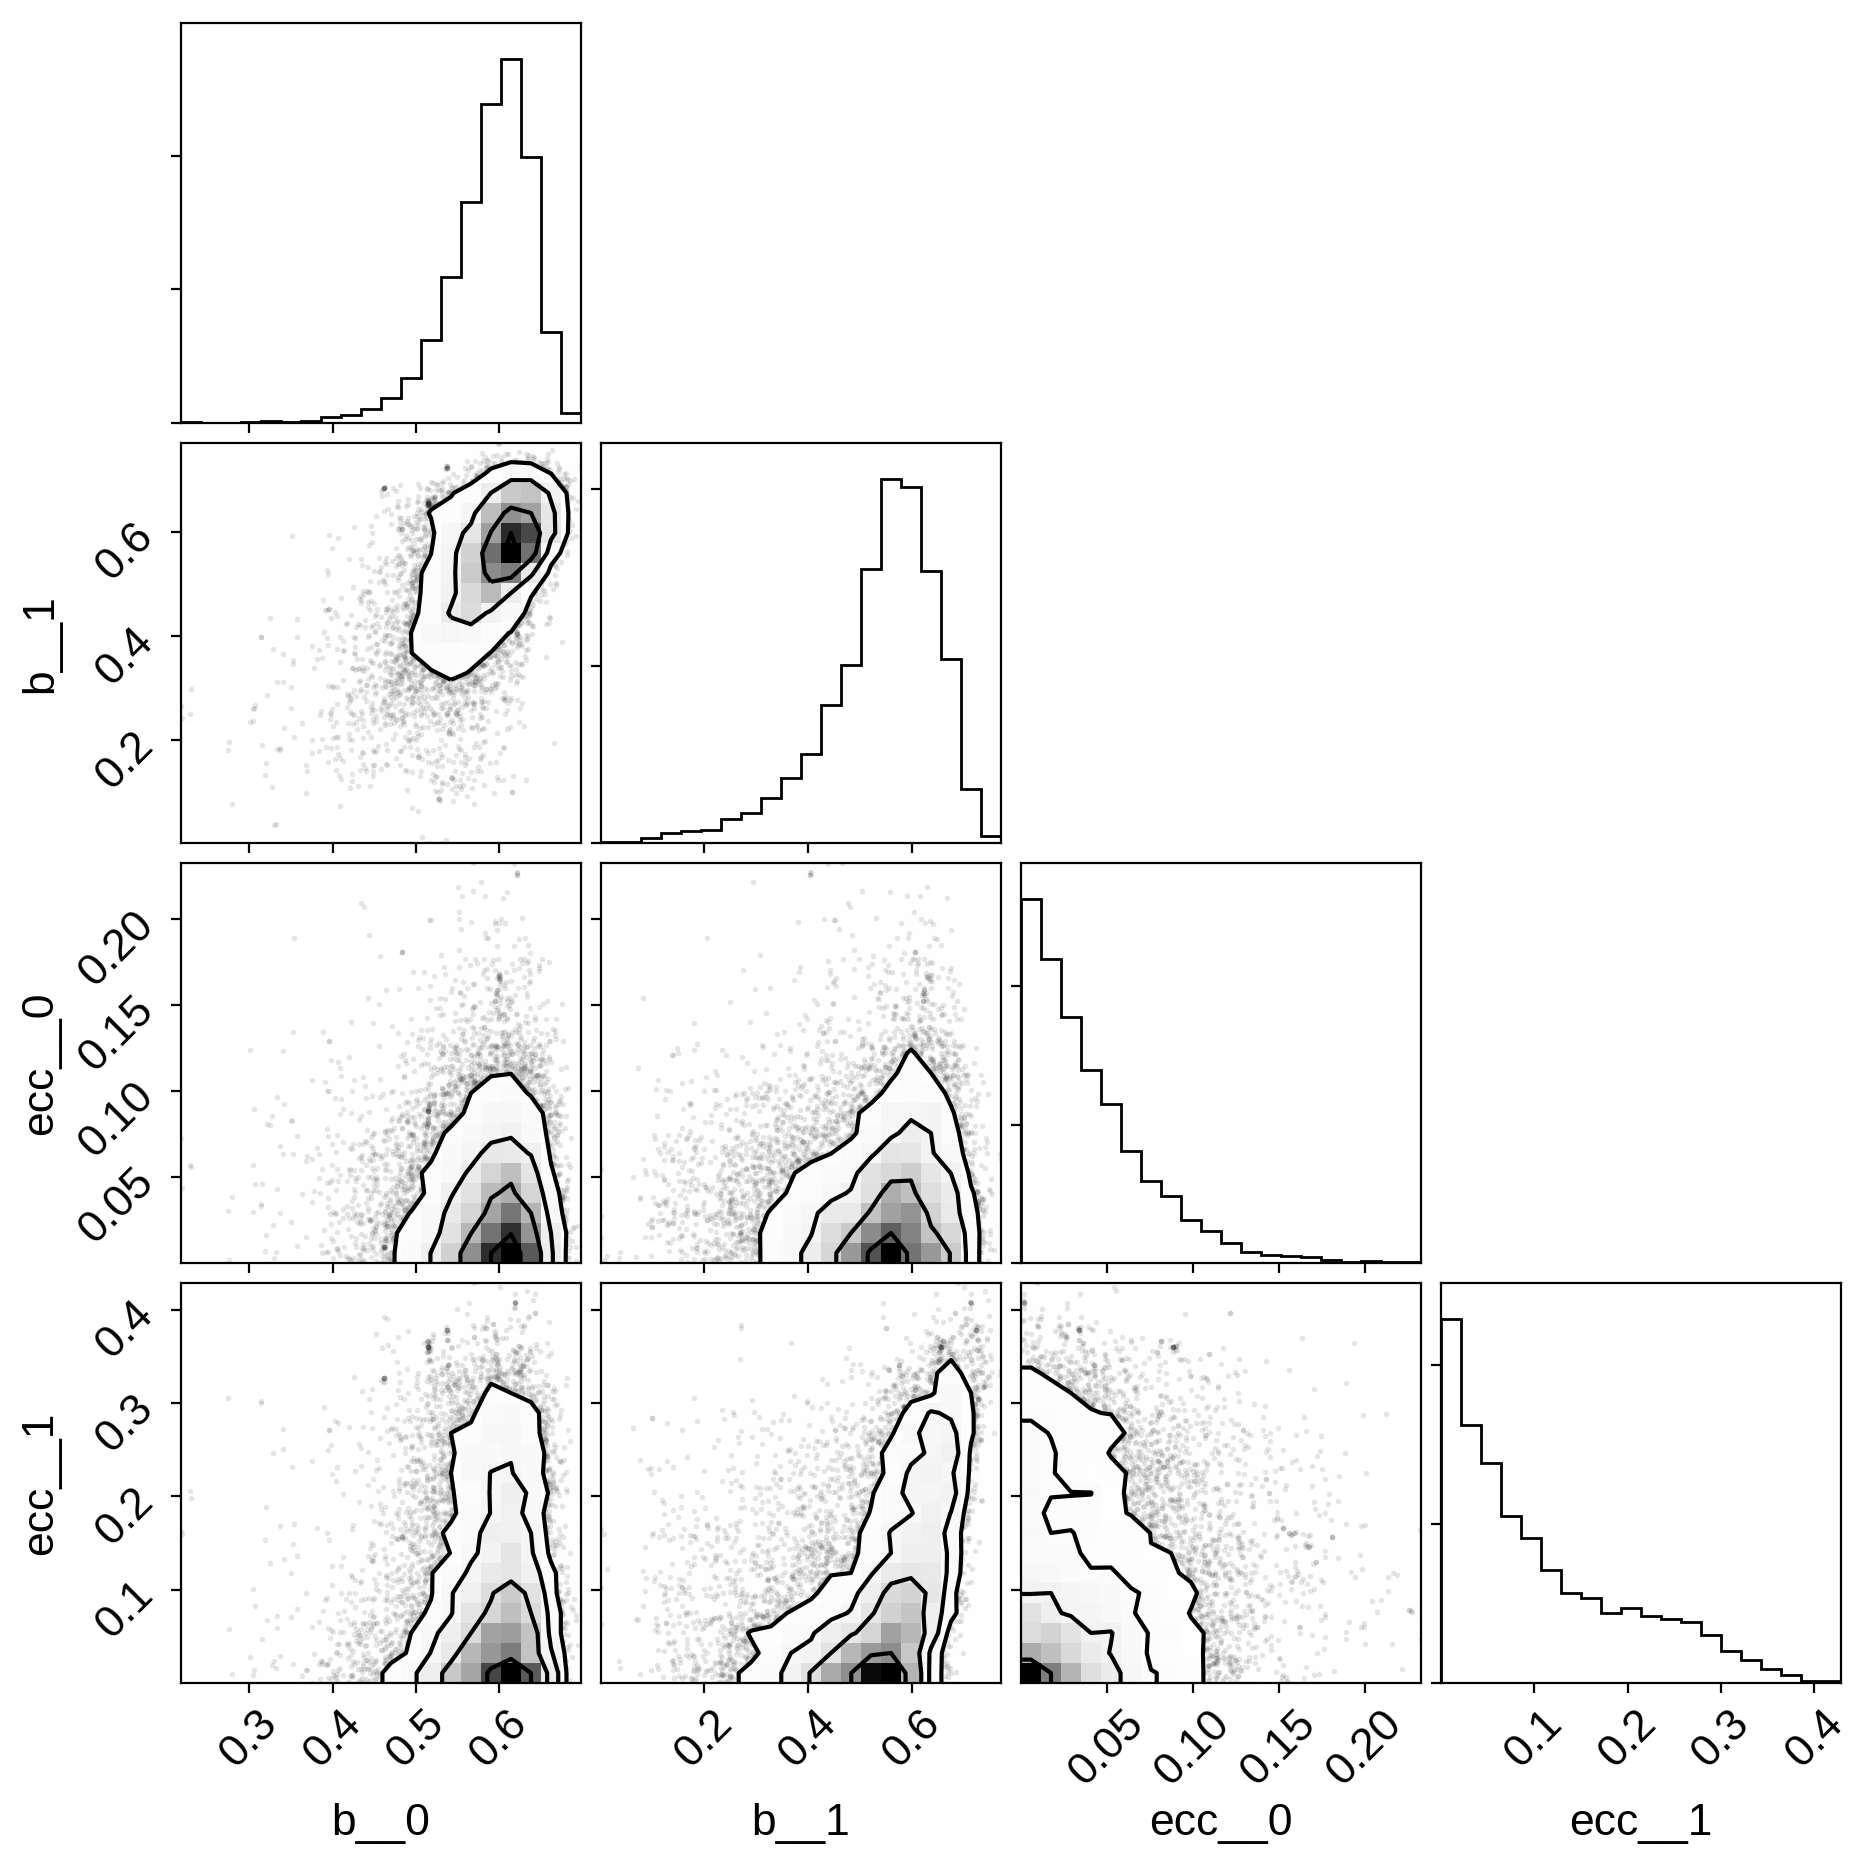

In [16]:
import corner

varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

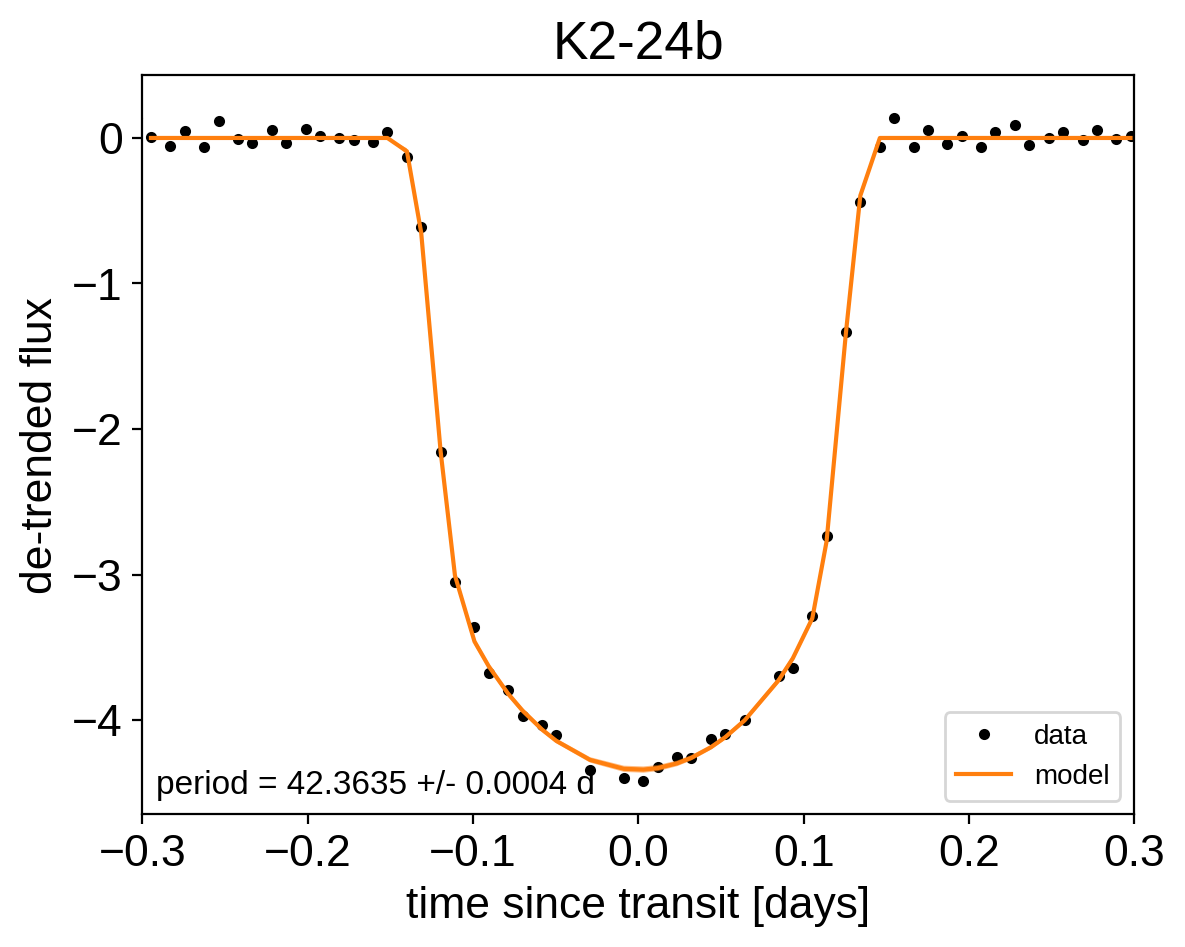

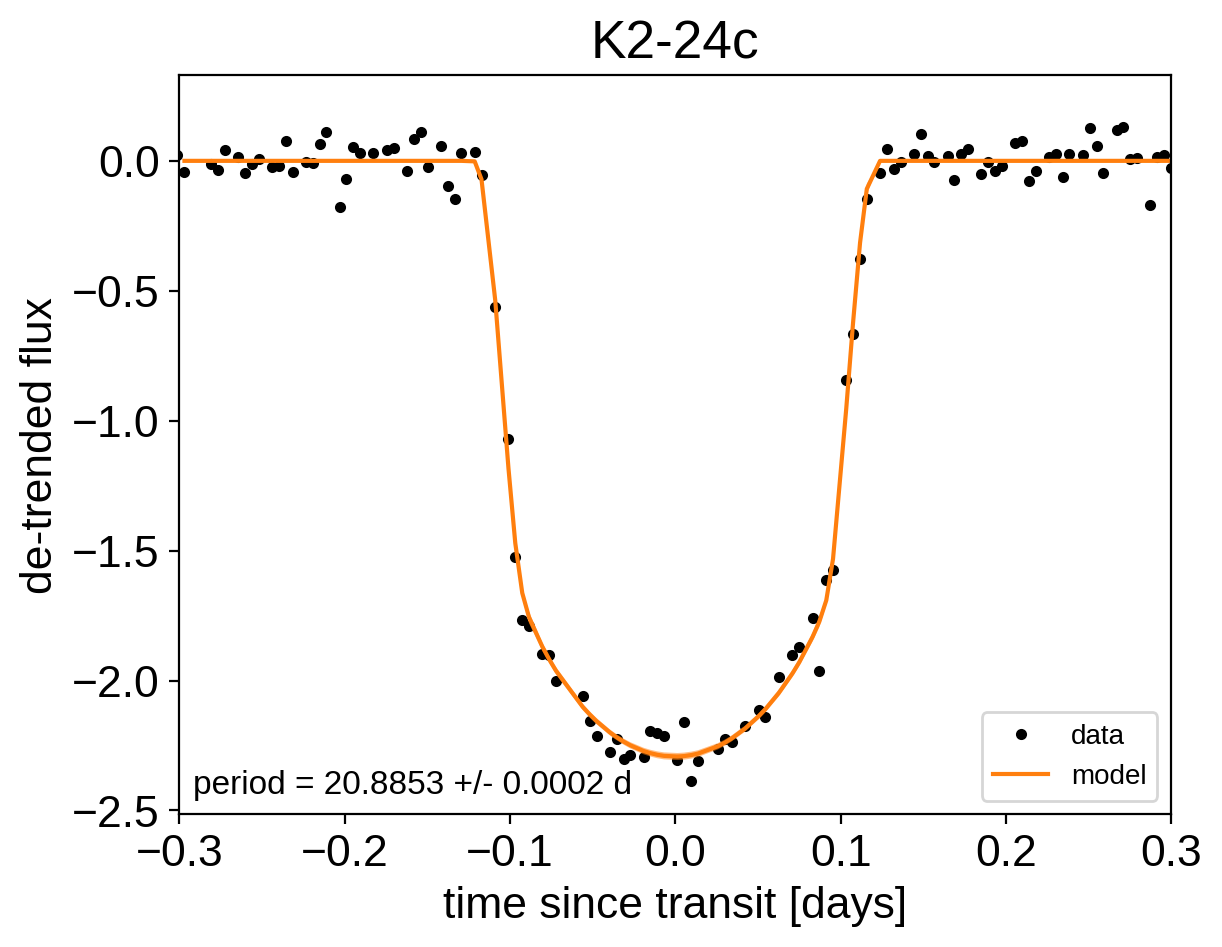

In [17]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(
        x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
    )
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter))
    plt.xlim(-0.3, 0.3)

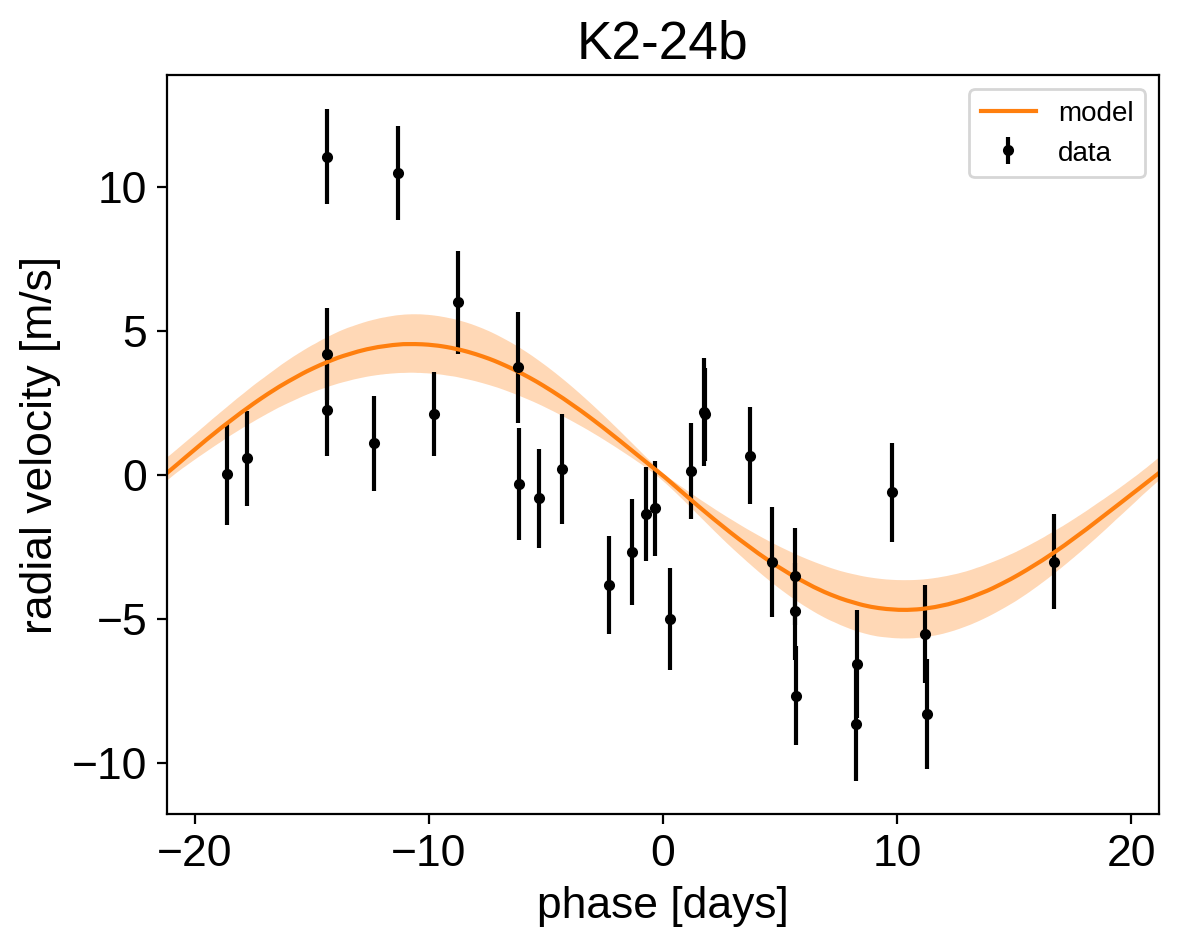

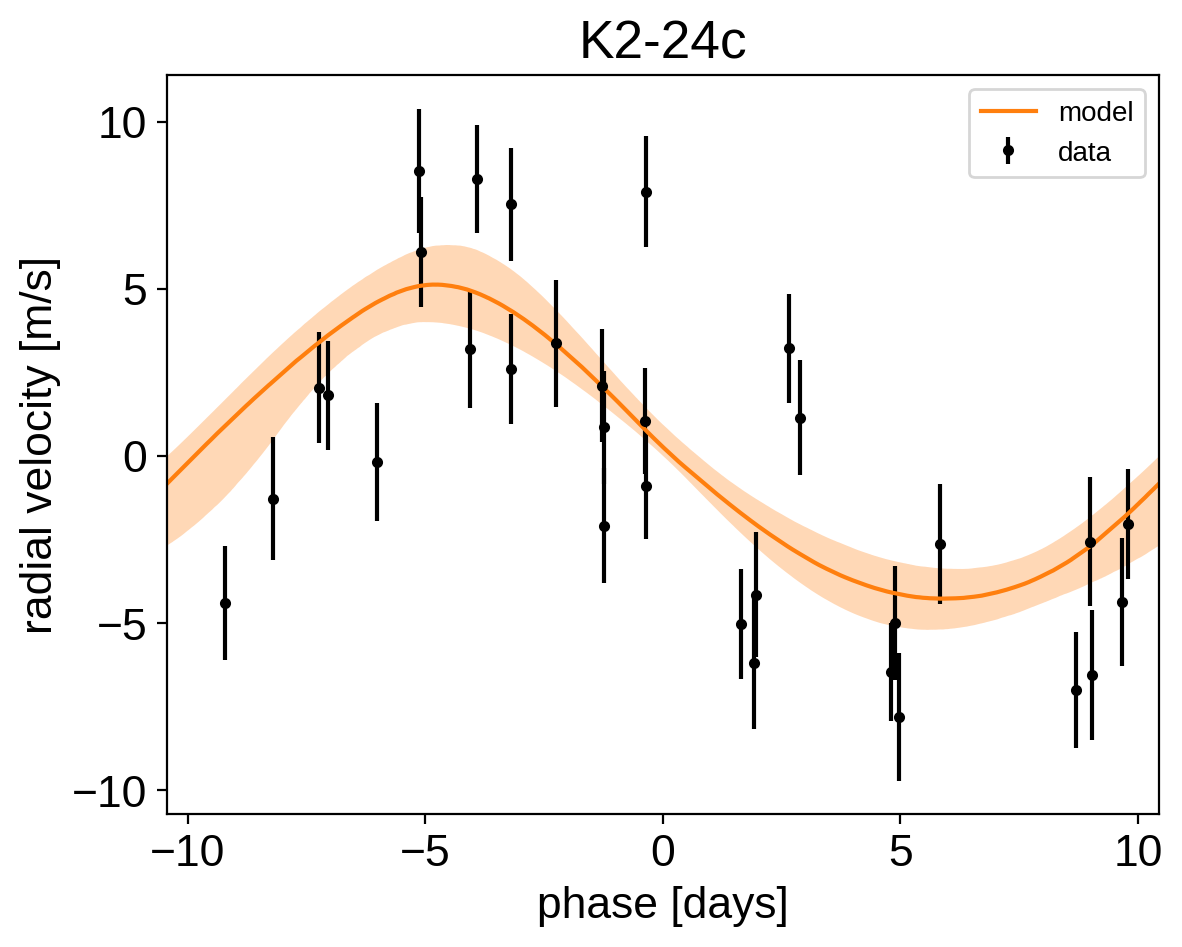

In [18]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

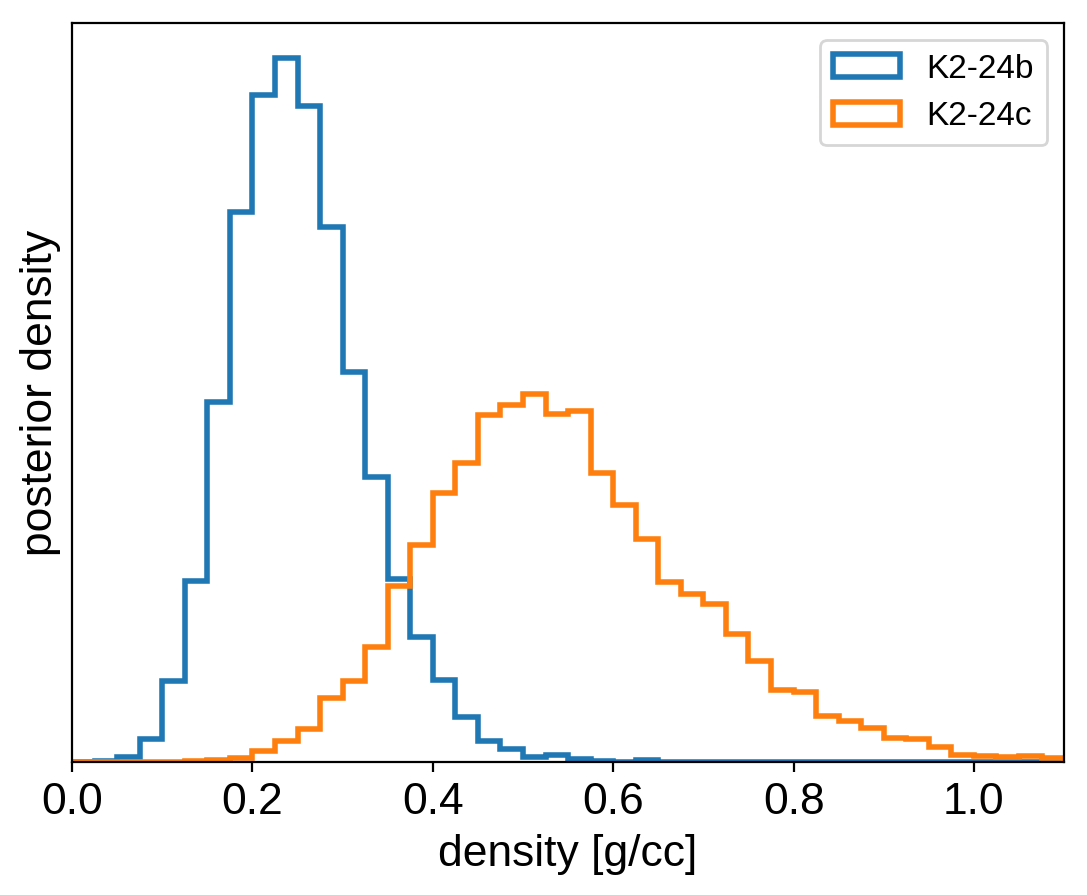

In [19]:
volume = 4 / 3 * np.pi * trace["r_pl"] ** 3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun ** 3)
density = density.to(u.g / u.cm ** 3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):
    plt.hist(
        density[:, n],
        bins,
        histtype="step",
        lw=2,
        label="K2-24{0}".format(letter),
        density=True,
    )
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [20]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano,
exoplanet:vaneylen19}.


In [21]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.1},
   month = sep,
    year = 2019,
     doi = {10.5281/zenodo.3462740},
     url = {https://doi.org/10.5281/zenodo.3462740}
}
...
